# Loading Data

In [32]:
# Importing Libraries
import pandas as pd
import numpy as np
import opendatasets as od
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import optuna

In [ ]:
dataset_path = "https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction"
od.download(dataset_path)

In [2]:
# Train and test Data
df = pd.read_csv("Churn_Modelling.csv")

df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


# EDA

In [4]:
# Fraud Percentage
labels = {0:'Customer Retained', 1:'Customer Churned'}
x = df.copy()
x['Exited'] = x['Exited'].map(labels)

fig = px.pie(x, names='Exited', title='Retention/Churn Rate')
fig.show()

In [5]:
df_categorical = df[['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']]

subplot_bar = make_subplots(rows=6, cols=3, 
                            subplot_titles=['Number of samples - Geography', 'Number of Churns - Geography', 'Churn Ratio (%) - Geography',
                                            'Number of samples - Gender', 'Number of Churns - Gender', 'Churn Ratio (%) - Gender',
                                            'Number of samples - Tenure', 'Number of Churns - Tenure', 'Churn Ratio (%) - Tenure',
                                            'Number of samples - NumOfProducts', 'Number of Churns - NumOfProducts', 'Churn Ratio (%) - NumOfProducts',
                                            'Number of samples - HasCrCard', 'Number of Churns - HasCrCard', 'Churn Ratio (%) - HasCrCard',
                                            'Number of samples - IsActiveMember', 'Number of Churns - IsActiveMember', 'Churn Ratio (%) - IsActiveMember'])

d = np.linspace(1, 11, 11)

for i in range(len(df_categorical.columns[:-1])):

    # Churn vs IsActiveMember
    data = df[[df_categorical.columns[i], 'Exited']]
    data = data.groupby([df_categorical.columns[i]]).agg(['count', 'sum', 'mean',])
    data.columns = ['count', 'Number of churns', 'Churn ratio']
    data.reset_index(inplace=True)
    data["Churn ratio"] = data["Churn ratio"].apply(lambda x: round(x*100, 2))

    subplot_bar.add_trace(
    go.Bar(x=data[df_categorical.columns[i]], y=data['count'], 
           marker_color=d, marker_colorscale='Turbo'), row=i+1, col=1
    )

    subplot_bar.add_trace(
    go.Bar(x=data[df_categorical.columns[i]], y=data['Number of churns'],
           marker_color=d, marker_colorscale='Turbo'), row=i+1, col=2
    )

    subplot_bar.add_trace(
    go.Bar(x=data[df_categorical.columns[i]], y=data['Churn ratio'],
           marker_color=d, marker_colorscale='Turbo'), row=i+1, col=3
    )

subplot_bar.update_layout(showlegend=False, height=1500, width=1100, title_text='Analysis of Categorical Variable')
subplot_bar.show()

In [6]:
df_continuos = df[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']]

In [7]:
fig = px.histogram(df_continuos, x="CreditScore", color="Exited",
                   marginal="box")
fig.update_layout(title_text="Credit Score Vs Churn")
fig.show()

In [8]:
fig = px.histogram(df_continuos, x="Age", color="Exited",
                   marginal="box")
fig.update_layout(title_text="Age Vs Churn")
fig.show()

In [9]:
fig = px.histogram(df_continuos, x="Balance", color="Exited",
                   marginal="box")
fig.update_layout(title_text="Balance Vs Churn")
fig.show()

In [10]:
fig = px.histogram(df_continuos, x="EstimatedSalary", color="Exited",
                   marginal="box")
fig.update_layout(title_text="Estimated Salary Vs Churn")
fig.show()

# Prepare Data for Model

In [11]:
# Drop Variables that are not useful and separate target variable
X = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
y = df['Exited']

In [12]:
# One Hot Encoder
X_encoded = pd.get_dummies(X, columns=['Geography',
                                       'Gender',
                                       'IsActiveMember',
                                       'HasCrCard',
                                       'NumOfProducts'])

In [13]:
# Stratified Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, 
                                                    y, 
                                                    random_state=42, 
                                                    stratify=y)

In [14]:
# First model
clf_xgb_v1 = xgb.XGBClassifier(objective='binary:logistic')

clf_xgb_v1.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='auc',
            eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.83916
[1]	validation_0-auc:0.85499
[2]	validation_0-auc:0.85691
[3]	validation_0-auc:0.86111
[4]	validation_0-auc:0.86243
[5]	validation_0-auc:0.86209
[6]	validation_0-auc:0.86461
[7]	validation_0-auc:0.86601
[8]	validation_0-auc:0.86614
[9]	validation_0-auc:0.86602
[10]	validation_0-auc:0.86581
[11]	validation_0-auc:0.86594
[12]	validation_0-auc:0.86592
[13]	validation_0-auc:0.86587
[14]	validation_0-auc:0.86640
[15]	validation_0-auc:0.86671
[16]	validation_0-auc:0.86696


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86704
[18]	validation_0-auc:0.86750
[19]	validation_0-auc:0.86726
[20]	validation_0-auc:0.86879
[21]	validation_0-auc:0.86699
[22]	validation_0-auc:0.86742
[23]	validation_0-auc:0.86658
[24]	validation_0-auc:0.86664
[25]	validation_0-auc:0.86668
[26]	validation_0-auc:0.86618
[27]	validation_0-auc:0.86606
[28]	validation_0-auc:0.86540
[29]	validation_0-auc:0.86490
[30]	validation_0-auc:0.86480


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

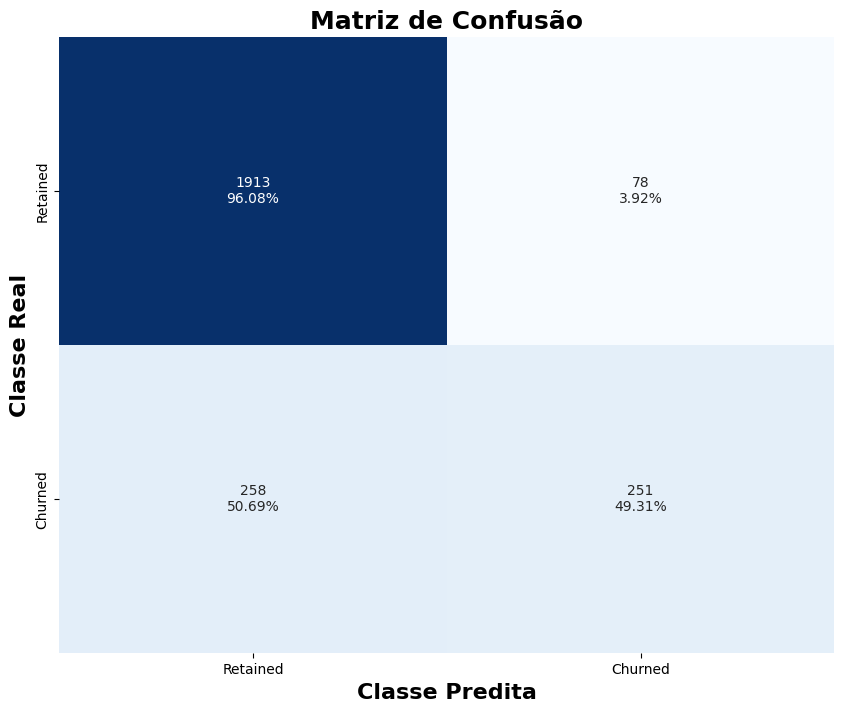

In [50]:
predictions_1 = clf_xgb_v1.predict(X_test)

cm = confusion_matrix(y_test, predictions_1)
cmn = confusion_matrix(y_test, predictions_1, normalize='true')

fig, ax = plt.subplots(figsize=(10,8))

labels = ['Retained', 'Churned']

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cmn.flatten()]
annot = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
annot = np.asarray(annot).reshape(2,2)

sns.heatmap(cm, 
            annot=annot, 
            cmap="Blues",
            cbar = False,
            fmt='',
            xticklabels=labels,
            yticklabels=labels)


plt.title('Matriz de Confusão', fontsize=18, fontweight="bold")
plt.ylabel('Classe Real', fontsize=16, fontweight="bold")
plt.xlabel('Classe Predita', fontsize=16, fontweight="bold")
#plt.savefig("matriz_confusao_experimental", dpi=600)
plt.show(block=False)

# Optuna

In [21]:
def objective(trial):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'reg_lambda': trial.suggest_int('reg_lambda', 1, 20),
        'gamma': trial.suggest_int('gamma', 1, 20),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 20)
    }
   
    model = XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5,
                                **param)  
    model.fit(X_train, y_train,
              early_stopping_rounds=10,
              eval_metric='auc',
              eval_set=[(X_test, y_test)],
              verbose=False)
    preds = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, preds)
    return roc_auc

In [23]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-03-20 15:57:20,024] A new study created in memory with name: no-name-64f55646-8b7b-417c-ae0e-3fa2df405add


[0]	validation_0-auc:0.76085
[1]	validation_0-auc:0.83121
[2]	validation_0-auc:0.84670
[3]	validation_0-auc:0.84929
[4]	validation_0-auc:0.84465
[5]	validation_0-auc:0.84137
[6]	validation_0-auc:0.84912
[7]	validation_0-auc:0.84661
[8]	validation_0-auc:0.85258
[9]	validation_0-auc:0.85529
[10]	validation_0-auc:0.85117
[11]	validation_0-auc:0.85354
[12]	validation_0-auc:0.85054
[13]	validation_0-auc:0.85440
[14]	validation_0-auc:0.85421
[15]	validation_0-auc:0.85825
[16]	validation_0-auc:0.85867
[17]	validation_0-auc:0.85973
[18]	validation_0-auc:0.86086
[19]	validation_0-auc:0.86112
[20]	validation_0-auc:0.86072
[21]	validation_0-auc:0.86148
[22]	validation_0-auc:0.86339
[23]	validation_0-auc:0.86492
[24]	validation_0-auc:0.86484
[25]	validation_0-auc:0.86522
[26]	validation_0-auc:0.86535
[27]	validation_0-auc:0.86580
[28]	validation_0-auc:0.86499
[29]	validation_0-auc:0.86524
[30]	validation_0-auc:0.86523
[31]	validation_0-auc:0.86577
[32]	validation_0-auc:0.86581
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[39]	validation_0-auc:0.86756
[40]	validation_0-auc:0.86755
[41]	validation_0-auc:0.86774
[42]	validation_0-auc:0.86783
[43]	validation_0-auc:0.86833
[44]	validation_0-auc:0.86842
[45]	validation_0-auc:0.86812
[46]	validation_0-auc:0.86817
[47]	validation_0-auc:0.86831
[48]	validation_0-auc:0.86864
[49]	validation_0-auc:0.86904
[50]	validation_0-auc:0.86934
[51]	validation_0-auc:0.86915
[52]	validation_0-auc:0.86959
[53]	validation_0-auc:0.86966
[54]	validation_0-auc:0.86946
[55]	validation_0-auc:0.86962
[56]	validation_0-auc:0.86993
[57]	validation_0-auc:0.86982
[58]	validation_0-auc:0.86990
[59]	validation_0-auc:0.87003
[60]	validation_0-auc:0.86990
[61]	validation_0-auc:0.86997
[62]	validation_0-auc:0.87033
[63]	validation_0-auc:0.87022
[64]	validation_0-auc:0.87019
[65]	validation_0-auc:0.87002
[66]	validation_0-auc:0.86995
[67]	validation_0-auc:0.86997
[68]	validation_0-auc:0.87006
[69]	validation_0-auc:0.87009
[70]	validation_0-auc:0.87002
[71]	validation_0-auc:0.87002
[72]	valid

[I 2024-03-20 15:57:20,312] Trial 0 finished with value: 0.6310829972597711 and parameters: {'max_depth': 6, 'learning_rate': 0.029371630451404257, 'reg_lambda': 9, 'gamma': 6, 'scale_pos_weight': 17}. Best is trial 0 with value: 0.6310829972597711.


[0]	validation_0-auc:0.75221
[1]	validation_0-auc:0.82491
[2]	validation_0-auc:0.83483
[3]	validation_0-auc:0.84213
[4]	validation_0-auc:0.83473
[5]	validation_0-auc:0.82769
[6]	validation_0-auc:0.83690
[7]	validation_0-auc:0.83328
[8]	validation_0-auc:0.83890
[9]	validation_0-auc:0.83971
[10]	validation_0-auc:0.83767
[11]	validation_0-auc:0.83782
[12]	validation_0-auc:0.83889
[13]	validation_0-auc:0.84012


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-03-20 15:57:20,381] Trial 1 finished with value: 0.5 and parameters: {'max_depth': 3, 'learning_rate': 0.00989680788154091, 'reg_lambda': 12, 'gamma': 12, 'scale_pos_weight': 20}. Best is trial 0 with value: 0.6310829972597711.


[0]	validation_0-auc:0.76211
[1]	validation_0-auc:0.83060
[2]	validation_0-auc:0.84399
[3]	validation_0-auc:0.85154
[4]	validation_0-auc:0.84484
[5]	validation_0-auc:0.83742
[6]	validation_0-auc:0.84585
[7]	validation_0-auc:0.84494
[8]	validation_0-auc:0.84979
[9]	validation_0-auc:0.85268
[10]	validation_0-auc:0.85052
[11]	validation_0-auc:0.85124
[12]	validation_0-auc:0.85099
[13]	validation_0-auc:0.85260
[14]	validation_0-auc:0.85158
[15]	validation_0-auc:0.85418
[16]	validation_0-auc:0.85404
[17]	validation_0-auc:0.85386
[18]	validation_0-auc:0.85448
[19]	validation_0-auc:0.85427
[20]	validation_0-auc:0.85267
[21]	validation_0-auc:0.85367
[22]	validation_0-auc:0.85469
[23]	validation_0-auc:0.85567
[24]	validation_0-auc:0.85551
[25]	validation_0-auc:0.85503
[26]	validation_0-auc:0.85462
[27]	validation_0-auc:0.85556
[28]	validation_0-auc:0.85543
[29]	validation_0-auc:0.85615
[30]	validation_0-auc:0.85604
[31]	validation_0-auc:0.85644
[32]	validation_0-auc:0.85626


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[33]	validation_0-auc:0.85626
[34]	validation_0-auc:0.85613
[35]	validation_0-auc:0.85601
[36]	validation_0-auc:0.85604
[37]	validation_0-auc:0.85672
[38]	validation_0-auc:0.85645
[39]	validation_0-auc:0.85642
[40]	validation_0-auc:0.85628
[41]	validation_0-auc:0.85625
[42]	validation_0-auc:0.85614
[43]	validation_0-auc:0.85718
[44]	validation_0-auc:0.85764
[45]	validation_0-auc:0.85714
[46]	validation_0-auc:0.85724
[47]	validation_0-auc:0.85715
[48]	validation_0-auc:0.85732
[49]	validation_0-auc:0.85769
[50]	validation_0-auc:0.85813
[51]	validation_0-auc:0.85790
[52]	validation_0-auc:0.85825
[53]	validation_0-auc:0.85856
[54]	validation_0-auc:0.85817
[55]	validation_0-auc:0.85849
[56]	validation_0-auc:0.85883
[57]	validation_0-auc:0.85884
[58]	validation_0-auc:0.85874
[59]	validation_0-auc:0.85860
[60]	validation_0-auc:0.85853
[61]	validation_0-auc:0.85818
[62]	validation_0-auc:0.85857
[63]	validation_0-auc:0.85851
[64]	validation_0-auc:0.85832
[65]	validation_0-auc:0.85787
[66]	valid

[I 2024-03-20 15:57:20,596] Trial 2 finished with value: 0.5 and parameters: {'max_depth': 4, 'learning_rate': 0.0010542327637666602, 'reg_lambda': 16, 'gamma': 15, 'scale_pos_weight': 11}. Best is trial 0 with value: 0.6310829972597711.


[0]	validation_0-auc:0.75111
[1]	validation_0-auc:0.82188
[2]	validation_0-auc:0.83458
[3]	validation_0-auc:0.84067
[4]	validation_0-auc:0.83275
[5]	validation_0-auc:0.82803
[6]	validation_0-auc:0.83380
[7]	validation_0-auc:0.83059
[8]	validation_0-auc:0.83827
[9]	validation_0-auc:0.83933
[10]	validation_0-auc:0.83824
[11]	validation_0-auc:0.83976
[12]	validation_0-auc:0.84176
[13]	validation_0-auc:0.84226
[14]	validation_0-auc:0.84127
[15]	validation_0-auc:0.84477
[16]	validation_0-auc:0.84364
[17]	validation_0-auc:0.84350
[18]	validation_0-auc:0.84247
[19]	validation_0-auc:0.84281
[20]	validation_0-auc:0.84186
[21]	validation_0-auc:0.84350
[22]	validation_0-auc:0.84496
[23]	validation_0-auc:0.84630
[24]	validation_0-auc:0.84557
[25]	validation_0-auc:0.84508
[26]	validation_0-auc:0.84510
[27]	validation_0-auc:0.84594
[28]	validation_0-auc:0.84612
[29]	validation_0-auc:0.84700
[30]	validation_0-auc:0.84780
[31]	validation_0-auc:0.84848
[32]	validation_0-auc:0.84855
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[44]	validation_0-auc:0.85127
[45]	validation_0-auc:0.85070
[46]	validation_0-auc:0.85055
[47]	validation_0-auc:0.85096
[48]	validation_0-auc:0.85066
[49]	validation_0-auc:0.85023
[50]	validation_0-auc:0.85128
[51]	validation_0-auc:0.85074
[52]	validation_0-auc:0.85080
[53]	validation_0-auc:0.85156
[54]	validation_0-auc:0.85118
[55]	validation_0-auc:0.85151
[56]	validation_0-auc:0.85204
[57]	validation_0-auc:0.85163
[58]	validation_0-auc:0.85153
[59]	validation_0-auc:0.85146
[60]	validation_0-auc:0.85116
[61]	validation_0-auc:0.85119
[62]	validation_0-auc:0.85145
[63]	validation_0-auc:0.85150
[64]	validation_0-auc:0.85124
[65]	validation_0-auc:0.85070
[66]	validation_0-auc:0.85091


[I 2024-03-20 15:57:20,845] Trial 3 finished with value: 0.5 and parameters: {'max_depth': 3, 'learning_rate': 0.0012501200106200875, 'reg_lambda': 13, 'gamma': 18, 'scale_pos_weight': 8}. Best is trial 0 with value: 0.6310829972597711.


[0]	validation_0-auc:0.75390
[1]	validation_0-auc:0.82929
[2]	validation_0-auc:0.83696
[3]	validation_0-auc:0.84380
[4]	validation_0-auc:0.84225
[5]	validation_0-auc:0.84187
[6]	validation_0-auc:0.84870
[7]	validation_0-auc:0.84896
[8]	validation_0-auc:0.85230
[9]	validation_0-auc:0.85389
[10]	validation_0-auc:0.85183
[11]	validation_0-auc:0.85273
[12]	validation_0-auc:0.85273
[13]	validation_0-auc:0.85466
[14]	validation_0-auc:0.85433
[15]	validation_0-auc:0.85727
[16]	validation_0-auc:0.85693
[17]	validation_0-auc:0.85732
[18]	validation_0-auc:0.85806
[19]	validation_0-auc:0.85848
[20]	validation_0-auc:0.85768
[21]	validation_0-auc:0.85888
[22]	validation_0-auc:0.86062
[23]	validation_0-auc:0.86191
[24]	validation_0-auc:0.86188
[25]	validation_0-auc:0.86156
[26]	validation_0-auc:0.86143
[27]	validation_0-auc:0.86078
[28]	validation_0-auc:0.86050
[29]	validation_0-auc:0.86071
[30]	validation_0-auc:0.86050
[31]	validation_0-auc:0.86071
[32]	validation_0-auc:0.86052
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-03-20 15:57:20,966] Trial 4 finished with value: 0.5 and parameters: {'max_depth': 10, 'learning_rate': 0.0013752932931862514, 'reg_lambda': 14, 'gamma': 14, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.6310829972597711.


[0]	validation_0-auc:0.76548
[1]	validation_0-auc:0.83218
[2]	validation_0-auc:0.84866
[3]	validation_0-auc:0.85041
[4]	validation_0-auc:0.84521
[5]	validation_0-auc:0.84238
[6]	validation_0-auc:0.85067


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.84715
[8]	validation_0-auc:0.85319
[9]	validation_0-auc:0.85667
[10]	validation_0-auc:0.85265
[11]	validation_0-auc:0.85452
[12]	validation_0-auc:0.85214
[13]	validation_0-auc:0.85594
[14]	validation_0-auc:0.85592
[15]	validation_0-auc:0.85935
[16]	validation_0-auc:0.85990
[17]	validation_0-auc:0.86004
[18]	validation_0-auc:0.86085
[19]	validation_0-auc:0.86100
[20]	validation_0-auc:0.86032
[21]	validation_0-auc:0.86106
[22]	validation_0-auc:0.86238
[23]	validation_0-auc:0.86388
[24]	validation_0-auc:0.86359
[25]	validation_0-auc:0.86370
[26]	validation_0-auc:0.86351
[27]	validation_0-auc:0.86407
[28]	validation_0-auc:0.86352
[29]	validation_0-auc:0.86404
[30]	validation_0-auc:0.86346
[31]	validation_0-auc:0.86399
[32]	validation_0-auc:0.86401
[33]	validation_0-auc:0.86414
[34]	validation_0-auc:0.86408
[35]	validation_0-auc:0.86464
[36]	validation_0-auc:0.86472
[37]	validation_0-auc:0.86516
[38]	validation_0-auc:0.86500
[39]	validation_0-auc:0.86505
[40]	validati

[I 2024-03-20 15:57:21,245] Trial 5 finished with value: 0.5995807262346571 and parameters: {'max_depth': 6, 'learning_rate': 0.020979424206985824, 'reg_lambda': 20, 'gamma': 4, 'scale_pos_weight': 15}. Best is trial 0 with value: 0.6310829972597711.


[0]	validation_0-auc:0.73548
[1]	validation_0-auc:0.80554
[2]	validation_0-auc:0.81839
[3]	validation_0-auc:0.82576
[4]	validation_0-auc:0.83379
[5]	validation_0-auc:0.81838
[6]	validation_0-auc:0.82885
[7]	validation_0-auc:0.82470
[8]	validation_0-auc:0.83028
[9]	validation_0-auc:0.83058
[10]	validation_0-auc:0.82702
[11]	validation_0-auc:0.82543
[12]	validation_0-auc:0.82867
[13]	validation_0-auc:0.82793
[14]	validation_0-auc:0.82725


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-03-20 15:57:21,314] Trial 6 finished with value: 0.5 and parameters: {'max_depth': 2, 'learning_rate': 0.00596715500349837, 'reg_lambda': 14, 'gamma': 17, 'scale_pos_weight': 14}. Best is trial 0 with value: 0.6310829972597711.


[0]	validation_0-auc:0.75724
[1]	validation_0-auc:0.83332
[2]	validation_0-auc:0.85102
[3]	validation_0-auc:0.85294
[4]	validation_0-auc:0.84680
[5]	validation_0-auc:0.84361
[6]	validation_0-auc:0.85181
[7]	validation_0-auc:0.84926
[8]	validation_0-auc:0.85541
[9]	validation_0-auc:0.85905
[10]	validation_0-auc:0.85485
[11]	validation_0-auc:0.85727
[12]	validation_0-auc:0.85519
[13]	validation_0-auc:0.85839
[14]	validation_0-auc:0.85835
[15]	validation_0-auc:0.86154
[16]	validation_0-auc:0.86209
[17]	validation_0-auc:0.86264
[18]	validation_0-auc:0.86311
[19]	validation_0-auc:0.86302
[20]	validation_0-auc:0.86188
[21]	validation_0-auc:0.86286
[22]	validation_0-auc:0.86462
[23]	validation_0-auc:0.86629


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[24]	validation_0-auc:0.86570
[25]	validation_0-auc:0.86577
[26]	validation_0-auc:0.86549
[27]	validation_0-auc:0.86650
[28]	validation_0-auc:0.86590
[29]	validation_0-auc:0.86647
[30]	validation_0-auc:0.86624
[31]	validation_0-auc:0.86628
[32]	validation_0-auc:0.86634
[33]	validation_0-auc:0.86660
[34]	validation_0-auc:0.86623
[35]	validation_0-auc:0.86642
[36]	validation_0-auc:0.86687
[37]	validation_0-auc:0.86748
[38]	validation_0-auc:0.86731
[39]	validation_0-auc:0.86738
[40]	validation_0-auc:0.86731
[41]	validation_0-auc:0.86737
[42]	validation_0-auc:0.86769
[43]	validation_0-auc:0.86809
[44]	validation_0-auc:0.86844
[45]	validation_0-auc:0.86841
[46]	validation_0-auc:0.86836
[47]	validation_0-auc:0.86805
[48]	validation_0-auc:0.86824
[49]	validation_0-auc:0.86855
[50]	validation_0-auc:0.86886
[51]	validation_0-auc:0.86884
[52]	validation_0-auc:0.86925
[53]	validation_0-auc:0.86931
[54]	validation_0-auc:0.86904
[55]	validation_0-auc:0.86927
[56]	validation_0-auc:0.86958
[57]	valid

[I 2024-03-20 15:57:21,582] Trial 7 finished with value: 0.6290961586471142 and parameters: {'max_depth': 7, 'learning_rate': 0.012992384056905884, 'reg_lambda': 9, 'gamma': 2, 'scale_pos_weight': 8}. Best is trial 0 with value: 0.6310829972597711.


[0]	validation_0-auc:0.76382
[1]	validation_0-auc:0.83328
[2]	validation_0-auc:0.84470
[3]	validation_0-auc:0.85081
[4]	validation_0-auc:0.84516
[5]	validation_0-auc:0.83697
[6]	validation_0-auc:0.84848
[7]	validation_0-auc:0.84912
[8]	validation_0-auc:0.85413
[9]	validation_0-auc:0.85606
[10]	validation_0-auc:0.85472
[11]	validation_0-auc:0.85691
[12]	validation_0-auc:0.85685
[13]	validation_0-auc:0.85690
[14]	validation_0-auc:0.85695
[15]	validation_0-auc:0.85966
[16]	validation_0-auc:0.85938
[17]	validation_0-auc:0.85981
[18]	validation_0-auc:0.86129
[19]	validation_0-auc:0.86016
[20]	validation_0-auc:0.85961
[21]	validation_0-auc:0.86059
[22]	validation_0-auc:0.86185
[23]	validation_0-auc:0.86267
[24]	validation_0-auc:0.86336
[25]	validation_0-auc:0.86275
[26]	validation_0-auc:0.86275
[27]	validation_0-auc:0.86361
[28]	validation_0-auc:0.86371
[29]	validation_0-auc:0.86376
[30]	validation_0-auc:0.86426
[31]	validation_0-auc:0.86440
[32]	validation_0-auc:0.86412
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[40]	validation_0-auc:0.86583
[41]	validation_0-auc:0.86581
[42]	validation_0-auc:0.86605
[43]	validation_0-auc:0.86660
[44]	validation_0-auc:0.86724
[45]	validation_0-auc:0.86735
[46]	validation_0-auc:0.86728
[47]	validation_0-auc:0.86745
[48]	validation_0-auc:0.86766
[49]	validation_0-auc:0.86800
[50]	validation_0-auc:0.86819
[51]	validation_0-auc:0.86846
[52]	validation_0-auc:0.86855
[53]	validation_0-auc:0.86907
[54]	validation_0-auc:0.86911
[55]	validation_0-auc:0.86914
[56]	validation_0-auc:0.86934
[57]	validation_0-auc:0.86948
[58]	validation_0-auc:0.86943
[59]	validation_0-auc:0.86968
[60]	validation_0-auc:0.86979
[61]	validation_0-auc:0.86987
[62]	validation_0-auc:0.87014
[63]	validation_0-auc:0.87017
[64]	validation_0-auc:0.87023
[65]	validation_0-auc:0.87023
[66]	validation_0-auc:0.87026
[67]	validation_0-auc:0.87020
[68]	validation_0-auc:0.87030
[69]	validation_0-auc:0.87013
[70]	validation_0-auc:0.87015
[71]	validation_0-auc:0.87030
[72]	validation_0-auc:0.87031
[73]	valid

[I 2024-03-20 15:57:21,929] Trial 8 finished with value: 0.7886555314238237 and parameters: {'max_depth': 4, 'learning_rate': 0.03608409213229804, 'reg_lambda': 1, 'gamma': 12, 'scale_pos_weight': 5}. Best is trial 8 with value: 0.7886555314238237.


[0]	validation_0-auc:0.75723
[1]	validation_0-auc:0.83128
[2]	validation_0-auc:0.84123
[3]	validation_0-auc:0.84730
[4]	validation_0-auc:0.84775
[5]	validation_0-auc:0.84476
[6]	validation_0-auc:0.85110
[7]	validation_0-auc:0.85185
[8]	validation_0-auc:0.85394
[9]	validation_0-auc:0.85456
[10]	validation_0-auc:0.85314
[11]	validation_0-auc:0.85363
[12]	validation_0-auc:0.85440
[13]	validation_0-auc:0.85554
[14]	validation_0-auc:0.85554
[15]	validation_0-auc:0.85834
[16]	validation_0-auc:0.85806
[17]	validation_0-auc:0.85786
[18]	validation_0-auc:0.85849
[19]	validation_0-auc:0.85898
[20]	validation_0-auc:0.85824
[21]	validation_0-auc:0.85924
[22]	validation_0-auc:0.86050
[23]	validation_0-auc:0.86188
[24]	validation_0-auc:0.86157
[25]	validation_0-auc:0.86110
[26]	validation_0-auc:0.86068
[27]	validation_0-auc:0.86076
[28]	validation_0-auc:0.86065
[29]	validation_0-auc:0.86135
[30]	validation_0-auc:0.86105
[31]	validation_0-auc:0.86126
[32]	validation_0-auc:0.86123
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-03-20 15:57:22,064] Trial 9 finished with value: 0.5 and parameters: {'max_depth': 6, 'learning_rate': 0.0064186130276649165, 'reg_lambda': 18, 'gamma': 16, 'scale_pos_weight': 2}. Best is trial 8 with value: 0.7886555314238237.


[0]	validation_0-auc:0.74777

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




[1]	validation_0-auc:0.83353
[2]	validation_0-auc:0.85119
[3]	validation_0-auc:0.85256
[4]	validation_0-auc:0.83914
[5]	validation_0-auc:0.83799
[6]	validation_0-auc:0.84758
[7]	validation_0-auc:0.84542
[8]	validation_0-auc:0.85089
[9]	validation_0-auc:0.85449
[10]	validation_0-auc:0.85363
[11]	validation_0-auc:0.85687
[12]	validation_0-auc:0.85404
[13]	validation_0-auc:0.85783
[14]	validation_0-auc:0.85764
[15]	validation_0-auc:0.85948
[16]	validation_0-auc:0.86018
[17]	validation_0-auc:0.86123
[18]	validation_0-auc:0.86178
[19]	validation_0-auc:0.86178
[20]	validation_0-auc:0.86122
[21]	validation_0-auc:0.86222
[22]	validation_0-auc:0.86386
[23]	validation_0-auc:0.86517
[24]	validation_0-auc:0.86531
[25]	validation_0-auc:0.86559
[26]	validation_0-auc:0.86612
[27]	validation_0-auc:0.86690
[28]	validation_0-auc:0.86698
[29]	validation_0-auc:0.86710
[30]	validation_0-auc:0.86723
[31]	validation_0-auc:0.86755
[32]	validation_0-auc:0.86740
[33]	validation_0-auc:0.86776
[34]	validation_0-

[I 2024-03-20 15:57:22,460] Trial 10 finished with value: 0.7940777703990156 and parameters: {'max_depth': 9, 'learning_rate': 0.0558301114176715, 'reg_lambda': 1, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 10 with value: 0.7940777703990156.


[0]	validation_0-auc:0.74674
[1]	validation_0-auc:0.83301
[2]	validation_0-auc:0.85125
[3]	validation_0-auc:0.85318
[4]	validation_0-auc:0.84277
[5]	validation_0-auc:0.84154
[6]	validation_0-auc:0.85295
[7]	validation_0-auc:0.85051
[8]	validation_0-auc:0.85496
[9]	validation_0-auc:0.85829
[10]	validation_0-auc:0.85693
[11]	validation_0-auc:0.85918
[12]	validation_0-auc:0.85660
[13]	validation_0-auc:0.85960
[14]	validation_0-auc:0.85891
[15]	validation_0-auc:0.86045
[16]	validation_0-auc:0.86212
[17]	validation_0-auc:0.86311
[18]	validation_0-auc:0.86378
[19]	validation_0-auc:0.86383
[20]	validation_0-auc:0.86357
[21]	validation_0-auc:0.86444
[22]	validation_0-auc:0.86569
[23]	validation_0-auc:0.86677
[24]	validation_0-auc:0.86699
[25]	validation_0-auc:0.86720
[26]	validation_0-auc:0.86763
[27]	validation_0-auc:0.86853
[28]	validation_0-auc:0.86896
[29]	validation_0-auc:0.86932


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[30]	validation_0-auc:0.86926
[31]	validation_0-auc:0.86942
[32]	validation_0-auc:0.86938
[33]	validation_0-auc:0.86958
[34]	validation_0-auc:0.86951
[35]	validation_0-auc:0.86977
[36]	validation_0-auc:0.86986
[37]	validation_0-auc:0.87029
[38]	validation_0-auc:0.87023
[39]	validation_0-auc:0.86985
[40]	validation_0-auc:0.86995
[41]	validation_0-auc:0.87011
[42]	validation_0-auc:0.87016
[43]	validation_0-auc:0.87035
[44]	validation_0-auc:0.87084
[45]	validation_0-auc:0.87108
[46]	validation_0-auc:0.87091
[47]	validation_0-auc:0.87088
[48]	validation_0-auc:0.87090
[49]	validation_0-auc:0.87096
[50]	validation_0-auc:0.87111
[51]	validation_0-auc:0.87134
[52]	validation_0-auc:0.87165
[53]	validation_0-auc:0.87177
[54]	validation_0-auc:0.87178
[55]	validation_0-auc:0.87195
[56]	validation_0-auc:0.87193
[57]	validation_0-auc:0.87160
[58]	validation_0-auc:0.87158
[59]	validation_0-auc:0.87154
[60]	validation_0-auc:0.87160
[61]	validation_0-auc:0.87162
[62]	validation_0-auc:0.87171
[63]	valid

[I 2024-03-20 15:57:22,787] Trial 11 finished with value: 0.8020251248496427 and parameters: {'max_depth': 10, 'learning_rate': 0.07692526689003933, 'reg_lambda': 1, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.74674
[1]	validation_0-auc:0.83305
[2]	validation_0-auc:0.85180
[3]	validation_0-auc:0.85402
[4]	validation_0-auc:0.84411
[5]	validation_0-auc:0.84335
[6]	validation_0-auc:0.85449
[7]	validation_0-auc:0.85267
[8]	validation_0-auc:0.85742
[9]	validation_0-auc:0.86080
[10]	validation_0-auc:0.85951
[11]	validation_0-auc:0.86173
[12]	validation_0-auc:0.86136
[13]	validation_0-auc:0.86378
[14]	validation_0-auc:0.86279
[15]	validation_0-auc:0.86453
[16]	validation_0-auc:0.86570
[17]	validation_0-auc:0.86639
[18]	validation_0-auc:0.86677
[19]	validation_0-auc:0.86630
[20]	validation_0-auc:0.86633
[21]	validation_0-auc:0.86684
[22]	validation_0-auc:0.86772
[23]	validation_0-auc:0.86846
[24]	validation_0-auc:0.86871
[25]	validation_0-auc:0.86884


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[26]	validation_0-auc:0.86922
[27]	validation_0-auc:0.86962
[28]	validation_0-auc:0.86963
[29]	validation_0-auc:0.86992
[30]	validation_0-auc:0.86936
[31]	validation_0-auc:0.86964
[32]	validation_0-auc:0.86984
[33]	validation_0-auc:0.87017
[34]	validation_0-auc:0.87020
[35]	validation_0-auc:0.87060
[36]	validation_0-auc:0.87101
[37]	validation_0-auc:0.87123
[38]	validation_0-auc:0.87145
[39]	validation_0-auc:0.87104
[40]	validation_0-auc:0.87131
[41]	validation_0-auc:0.87150
[42]	validation_0-auc:0.87187
[43]	validation_0-auc:0.87208
[44]	validation_0-auc:0.87210
[45]	validation_0-auc:0.87220
[46]	validation_0-auc:0.87220
[47]	validation_0-auc:0.87173
[48]	validation_0-auc:0.87180
[49]	validation_0-auc:0.87191
[50]	validation_0-auc:0.87201
[51]	validation_0-auc:0.87177
[52]	validation_0-auc:0.87189
[53]	validation_0-auc:0.87189
[54]	validation_0-auc:0.87189
[55]	validation_0-auc:0.87206
[56]	validation_0-auc:0.87200


[I 2024-03-20 15:57:23,133] Trial 12 finished with value: 0.7940111641877644 and parameters: {'max_depth': 10, 'learning_rate': 0.09801266391958026, 'reg_lambda': 1, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76015
[1]	validation_0-auc:0.84066
[2]	validation_0-auc:0.85557
[3]	validation_0-auc:0.85792
[4]	validation_0-auc:0.85198
[5]	validation_0-auc:0.84798
[6]	validation_0-auc:0.85509
[7]	validation_0-auc:0.85338
[8]	validation_0-auc:0.85726
[9]	validation_0-auc:0.85859
[10]	validation_0-auc:0.85696
[11]	validation_0-auc:0.85986
[12]	validation_0-auc:0.85934
[13]	validation_0-auc:0.86186
[14]	validation_0-auc:0.86157
[15]	validation_0-auc:0.86413
[16]	validation_0-auc:0.86518
[17]	validation_0-auc:0.86559
[18]	validation_0-auc:0.86636
[19]	validation_0-auc:0.86631
[20]	validation_0-auc:0.86614
[21]	validation_0-auc:0.86704
[22]	validation_0-auc:0.86807
[23]	validation_0-auc:0.86881
[24]	validation_0-auc:0.86904
[25]	validation_0-auc:0.86913
[26]	validation_0-auc:0.86947
[27]	validation_0-auc:0.86984
[28]	validation_0-auc:0.87013
[29]	validation_0-auc:0.87042
[30]	validation_0-auc:0.87070


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[31]	validation_0-auc:0.87090
[32]	validation_0-auc:0.87106
[33]	validation_0-auc:0.87106
[34]	validation_0-auc:0.87085
[35]	validation_0-auc:0.87114
[36]	validation_0-auc:0.87140
[37]	validation_0-auc:0.87161
[38]	validation_0-auc:0.87179
[39]	validation_0-auc:0.87150
[40]	validation_0-auc:0.87175
[41]	validation_0-auc:0.87197
[42]	validation_0-auc:0.87236
[43]	validation_0-auc:0.87263
[44]	validation_0-auc:0.87319
[45]	validation_0-auc:0.87335
[46]	validation_0-auc:0.87334
[47]	validation_0-auc:0.87328
[48]	validation_0-auc:0.87327
[49]	validation_0-auc:0.87320
[50]	validation_0-auc:0.87331
[51]	validation_0-auc:0.87317
[52]	validation_0-auc:0.87336
[53]	validation_0-auc:0.87343
[54]	validation_0-auc:0.87343
[55]	validation_0-auc:0.87352
[56]	validation_0-auc:0.87355
[57]	validation_0-auc:0.87359
[58]	validation_0-auc:0.87348
[59]	validation_0-auc:0.87348
[60]	validation_0-auc:0.87348
[61]	validation_0-auc:0.87350
[62]	validation_0-auc:0.87357
[63]	validation_0-auc:0.87355
[64]	valid

[I 2024-03-20 15:57:23,525] Trial 13 finished with value: 0.7921422432379894 and parameters: {'max_depth': 8, 'learning_rate': 0.09114362557771163, 'reg_lambda': 5, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.74994
[1]	validation_0-auc:0.83154
[2]	validation_0-auc:0.85093
[3]	validation_0-auc:0.85098
[4]	validation_0-auc:0.84116
[5]	validation_0-auc:0.83931
[6]	validation_0-auc:0.84807
[7]	validation_0-auc:0.84498
[8]	validation_0-auc:0.85025
[9]	validation_0-auc:0.85452
[10]	validation_0-auc:0.85115
[11]	validation_0-auc:0.85539
[12]	validation_0-auc:0.85329
[13]	validation_0-auc:0.85677
[14]	validation_0-auc:0.85696
[15]	validation_0-auc:0.85855
[16]	validation_0-auc:0.86034
[17]	validation_0-auc:0.86168
[18]	validation_0-auc:0.86252
[19]	validation_0-auc:0.86207
[20]	validation_0-auc:0.86118
[21]	validation_0-auc:0.86234
[22]	validation_0-auc:0.86345
[23]	validation_0-auc:0.86486
[24]	validation_0-auc:0.86477


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[25]	validation_0-auc:0.86504
[26]	validation_0-auc:0.86566
[27]	validation_0-auc:0.86631
[28]	validation_0-auc:0.86622
[29]	validation_0-auc:0.86684
[30]	validation_0-auc:0.86657
[31]	validation_0-auc:0.86683
[32]	validation_0-auc:0.86624
[33]	validation_0-auc:0.86668
[34]	validation_0-auc:0.86676
[35]	validation_0-auc:0.86697
[36]	validation_0-auc:0.86714
[37]	validation_0-auc:0.86769
[38]	validation_0-auc:0.86783
[39]	validation_0-auc:0.86767
[40]	validation_0-auc:0.86781
[41]	validation_0-auc:0.86787
[42]	validation_0-auc:0.86836
[43]	validation_0-auc:0.86867
[44]	validation_0-auc:0.86881
[45]	validation_0-auc:0.86891
[46]	validation_0-auc:0.86911
[47]	validation_0-auc:0.86876
[48]	validation_0-auc:0.86893
[49]	validation_0-auc:0.86934
[50]	validation_0-auc:0.86948
[51]	validation_0-auc:0.86990
[52]	validation_0-auc:0.87008
[53]	validation_0-auc:0.87017
[54]	validation_0-auc:0.87016
[55]	validation_0-auc:0.87047
[56]	validation_0-auc:0.87052
[57]	validation_0-auc:0.87017
[58]	valid

[I 2024-03-20 15:57:23,915] Trial 14 finished with value: 0.7672053711248752 and parameters: {'max_depth': 9, 'learning_rate': 0.05520122021797065, 'reg_lambda': 5, 'gamma': 6, 'scale_pos_weight': 9}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76243
[1]	validation_0-auc:0.83743
[2]	validation_0-auc:0.85315
[3]	validation_0-auc:0.85393
[4]	validation_0-auc:0.84733
[5]	validation_0-auc:0.84418
[6]	validation_0-auc:0.85282
[7]	validation_0-auc:0.85156
[8]	validation_0-auc:0.85704
[9]	validation_0-auc:0.86083
[10]	validation_0-auc:0.85770
[11]	validation_0-auc:0.85988
[12]	validation_0-auc:0.85845
[13]	validation_0-auc:0.86135
[14]	validation_0-auc:0.86158
[15]	validation_0-auc:0.86337
[16]	validation_0-auc:0.86402
[17]	validation_0-auc:0.86471
[18]	validation_0-auc:0.86546
[19]	validation_0-auc:0.86567
[20]	validation_0-auc:0.86512
[21]	validation_0-auc:0.86534
[22]	validation_0-auc:0.86694
[23]	validation_0-auc:0.86813
[24]	validation_0-auc:0.86812
[25]	validation_0-auc:0.86835
[26]	validation_0-auc:0.86857
[27]	validation_0-auc:0.86917
[28]	validation_0-auc:0.86895
[29]	validation_0-auc:0.86909
[30]	validation_0-auc:0.86859
[31]	validation_0-auc:0.86864


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[32]	validation_0-auc:0.86825
[33]	validation_0-auc:0.86868
[34]	validation_0-auc:0.86864
[35]	validation_0-auc:0.86873
[36]	validation_0-auc:0.86897
[37]	validation_0-auc:0.86951
[38]	validation_0-auc:0.86929
[39]	validation_0-auc:0.86907
[40]	validation_0-auc:0.86911
[41]	validation_0-auc:0.86917
[42]	validation_0-auc:0.86917
[43]	validation_0-auc:0.86930
[44]	validation_0-auc:0.86981
[45]	validation_0-auc:0.86961
[46]	validation_0-auc:0.86947
[47]	validation_0-auc:0.86905
[48]	validation_0-auc:0.86934
[49]	validation_0-auc:0.86936
[50]	validation_0-auc:0.86937
[51]	validation_0-auc:0.86954
[52]	validation_0-auc:0.86988
[53]	validation_0-auc:0.86988
[54]	validation_0-auc:0.86986
[55]	validation_0-auc:0.86958
[56]	validation_0-auc:0.86947
[57]	validation_0-auc:0.86921
[58]	validation_0-auc:0.86931
[59]	validation_0-auc:0.86917
[60]	validation_0-auc:0.86916
[61]	validation_0-auc:0.86909
[62]	validation_0-auc:0.86914
[63]	validation_0-auc:0.86892


[I 2024-03-20 15:57:24,252] Trial 15 finished with value: 0.776412816416507 and parameters: {'max_depth': 8, 'learning_rate': 0.05239291847468129, 'reg_lambda': 4, 'gamma': 1, 'scale_pos_weight': 3}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.74840
[1]	validation_0-auc:0.82834
[2]	validation_0-auc:0.84792
[3]	validation_0-auc:0.84820
[4]	validation_0-auc:0.84207
[5]	validation_0-auc:0.84063
[6]	validation_0-auc:0.84805
[7]	validation_0-auc:0.84509
[8]	validation_0-auc:0.85083
[9]	validation_0-auc:0.85579
[10]	validation_0-auc:0.85366
[11]	validation_0-auc:0.85664
[12]	validation_0-auc:0.85452
[13]	validation_0-auc:0.85860
[14]	validation_0-auc:0.85866
[15]	validation_0-auc:0.86084
[16]	validation_0-auc:0.86206
[17]	validation_0-auc:0.86310
[18]	validation_0-auc:0.86378


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86390
[20]	validation_0-auc:0.86406
[21]	validation_0-auc:0.86495
[22]	validation_0-auc:0.86596
[23]	validation_0-auc:0.86689
[24]	validation_0-auc:0.86700
[25]	validation_0-auc:0.86708
[26]	validation_0-auc:0.86763
[27]	validation_0-auc:0.86840
[28]	validation_0-auc:0.86835
[29]	validation_0-auc:0.86876
[30]	validation_0-auc:0.86897
[31]	validation_0-auc:0.86933
[32]	validation_0-auc:0.86901
[33]	validation_0-auc:0.86936
[34]	validation_0-auc:0.86936
[35]	validation_0-auc:0.86968
[36]	validation_0-auc:0.86960
[37]	validation_0-auc:0.87026
[38]	validation_0-auc:0.87024
[39]	validation_0-auc:0.87048
[40]	validation_0-auc:0.87037
[41]	validation_0-auc:0.87042
[42]	validation_0-auc:0.87087
[43]	validation_0-auc:0.87117
[44]	validation_0-auc:0.87090
[45]	validation_0-auc:0.87088
[46]	validation_0-auc:0.87100
[47]	validation_0-auc:0.87069
[48]	validation_0-auc:0.87075
[49]	validation_0-auc:0.87096
[50]	validation_0-auc:0.87137
[51]	validation_0-auc:0.87138
[52]	valid

[I 2024-03-20 15:57:24,668] Trial 16 finished with value: 0.7454083651480778 and parameters: {'max_depth': 9, 'learning_rate': 0.05410823059611717, 'reg_lambda': 3, 'gamma': 10, 'scale_pos_weight': 11}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75731
[1]	validation_0-auc:0.83897
[2]	validation_0-auc:0.85595
[3]	validation_0-auc:0.85562
[4]	validation_0-auc:0.84515
[5]	validation_0-auc:0.84177
[6]	validation_0-auc:0.84973
[7]	validation_0-auc:0.84536
[8]	validation_0-auc:0.85189
[9]	validation_0-auc:0.85747
[10]	validation_0-auc:0.85431
[11]	validation_0-auc:0.85639
[12]	validation_0-auc:0.85355
[13]	validation_0-auc:0.85734
[14]	validation_0-auc:0.85689
[15]	validation_0-auc:0.85991
[16]	validation_0-auc:0.86069
[17]	validation_0-auc:0.86164
[18]	validation_0-auc:0.86139
[19]	validation_0-auc:0.86081
[20]	validation_0-auc:0.85947
[21]	validation_0-auc:0.86057
[22]	validation_0-auc:0.86275
[23]	validation_0-auc:0.86423
[24]	validation_0-auc:0.86355
[25]	validation_0-auc:0.86369
[26]	validation_0-auc:0.86376
[27]	validation_0-auc:0.86517
[28]	validation_0-auc:0.86469
[29]	validation_0-auc:0.86515


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[30]	validation_0-auc:0.86485
[31]	validation_0-auc:0.86510
[32]	validation_0-auc:0.86554
[33]	validation_0-auc:0.86569
[34]	validation_0-auc:0.86541
[35]	validation_0-auc:0.86551
[36]	validation_0-auc:0.86598
[37]	validation_0-auc:0.86653
[38]	validation_0-auc:0.86643
[39]	validation_0-auc:0.86636
[40]	validation_0-auc:0.86633
[41]	validation_0-auc:0.86655
[42]	validation_0-auc:0.86693
[43]	validation_0-auc:0.86742
[44]	validation_0-auc:0.86766
[45]	validation_0-auc:0.86768
[46]	validation_0-auc:0.86750
[47]	validation_0-auc:0.86720
[48]	validation_0-auc:0.86742
[49]	validation_0-auc:0.86785
[50]	validation_0-auc:0.86814
[51]	validation_0-auc:0.86816
[52]	validation_0-auc:0.86874
[53]	validation_0-auc:0.86888
[54]	validation_0-auc:0.86841
[55]	validation_0-auc:0.86861
[56]	validation_0-auc:0.86896
[57]	validation_0-auc:0.86892
[58]	validation_0-auc:0.86872
[59]	validation_0-auc:0.86872
[60]	validation_0-auc:0.86869
[61]	validation_0-auc:0.86849
[62]	validation_0-auc:0.86879
[63]	valid

[I 2024-03-20 15:57:25,030] Trial 17 finished with value: 0.5 and parameters: {'max_depth': 10, 'learning_rate': 0.002440842173127191, 'reg_lambda': 7, 'gamma': 7, 'scale_pos_weight': 6}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.77071
[1]	validation_0-auc:0.83772
[2]	validation_0-auc:0.84813
[3]	validation_0-auc:0.85437
[4]	validation_0-auc:0.85429
[5]	validation_0-auc:0.85029
[6]	validation_0-auc:0.85535
[7]	validation_0-auc:0.85472
[8]	validation_0-auc:0.85865
[9]	validation_0-auc:0.85904
[10]	validation_0-auc:0.85807
[11]	validation_0-auc:0.85822
[12]	validation_0-auc:0.85844
[13]	validation_0-auc:0.86076
[14]	validation_0-auc:0.86010
[15]	validation_0-auc:0.86297
[16]	validation_0-auc:0.86263
[17]	validation_0-auc:0.86260
[18]	validation_0-auc:0.86356
[19]	validation_0-auc:0.86343
[20]	validation_0-auc:0.86278
[21]	validation_0-auc:0.86369
[22]	validation_0-auc:0.86482
[23]	validation_0-auc:0.86586
[24]	validation_0-auc:0.86565
[25]	validation_0-auc:0.86502
[26]	validation_0-auc:0.86457
[27]	validation_0-auc:0.86556
[28]	validation_0-auc:0.86581
[29]	validation_0-auc:0.86602
[30]	validation_0-auc:0.86579
[31]	validation_0-auc:0.86620
[32]	validation_0-auc:0.86600
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[40]	validation_0-auc:0.86598
[41]	validation_0-auc:0.86599
[42]	validation_0-auc:0.86616
[43]	validation_0-auc:0.86673
[44]	validation_0-auc:0.86758
[45]	validation_0-auc:0.86748
[46]	validation_0-auc:0.86758
[47]	validation_0-auc:0.86770
[48]	validation_0-auc:0.86766
[49]	validation_0-auc:0.86817
[50]	validation_0-auc:0.86836
[51]	validation_0-auc:0.86850
[52]	validation_0-auc:0.86860
[53]	validation_0-auc:0.86898
[54]	validation_0-auc:0.86888
[55]	validation_0-auc:0.86916
[56]	validation_0-auc:0.86925
[57]	validation_0-auc:0.86933
[58]	validation_0-auc:0.86914
[59]	validation_0-auc:0.86912
[60]	validation_0-auc:0.86911
[61]	validation_0-auc:0.86912
[62]	validation_0-auc:0.86928
[63]	validation_0-auc:0.86937
[64]	validation_0-auc:0.86942
[65]	validation_0-auc:0.86937
[66]	validation_0-auc:0.86934
[67]	validation_0-auc:0.86911
[68]	validation_0-auc:0.86901
[69]	validation_0-auc:0.86891
[70]	validation_0-auc:0.86886
[71]	validation_0-auc:0.86886
[72]	validation_0-auc:0.86902
[73]	valid

[I 2024-03-20 15:57:25,336] Trial 18 finished with value: 0.7775949533213804 and parameters: {'max_depth': 8, 'learning_rate': 0.019133897439026996, 'reg_lambda': 7, 'gamma': 20, 'scale_pos_weight': 3}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75307
[1]	validation_0-auc:0.82811
[2]	validation_0-auc:0.84610
[3]	validation_0-auc:0.84568
[4]	validation_0-auc:0.83694
[5]	validation_0-auc:0.83735
[6]	validation_0-auc:0.84795
[7]	validation_0-auc:0.84514
[8]	validation_0-auc:0.85060
[9]	validation_0-auc:0.85393
[10]	validation_0-auc:0.85180
[11]	validation_0-auc:0.85490
[12]	validation_0-auc:0.85261
[13]	validation_0-auc:0.85625
[14]	validation_0-auc:0.85667
[15]	validation_0-auc:0.85807
[16]	validation_0-auc:0.85825
[17]	validation_0-auc:0.85942
[18]	validation_0-auc:0.86020
[19]	validation_0-auc:0.86024
[20]	validation_0-auc:0.85899
[21]	validation_0-auc:0.85958
[22]	validation_0-auc:0.85997
[23]	validation_0-auc:0.86134
[24]	validation_0-auc:0.86166


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[25]	validation_0-auc:0.86204
[26]	validation_0-auc:0.86211
[27]	validation_0-auc:0.86270
[28]	validation_0-auc:0.86238
[29]	validation_0-auc:0.86301
[30]	validation_0-auc:0.86341
[31]	validation_0-auc:0.86360
[32]	validation_0-auc:0.86392
[33]	validation_0-auc:0.86431
[34]	validation_0-auc:0.86424
[35]	validation_0-auc:0.86452
[36]	validation_0-auc:0.86455
[37]	validation_0-auc:0.86508
[38]	validation_0-auc:0.86489
[39]	validation_0-auc:0.86436
[40]	validation_0-auc:0.86464
[41]	validation_0-auc:0.86485
[42]	validation_0-auc:0.86479
[43]	validation_0-auc:0.86499
[44]	validation_0-auc:0.86530
[45]	validation_0-auc:0.86523
[46]	validation_0-auc:0.86536
[47]	validation_0-auc:0.86575
[48]	validation_0-auc:0.86574
[49]	validation_0-auc:0.86565
[50]	validation_0-auc:0.86541
[51]	validation_0-auc:0.86541
[52]	validation_0-auc:0.86496
[53]	validation_0-auc:0.86543
[54]	validation_0-auc:0.86543
[55]	validation_0-auc:0.86551
[56]	validation_0-auc:0.86514


[I 2024-03-20 15:57:25,868] Trial 19 finished with value: 0.7762253322663183 and parameters: {'max_depth': 9, 'learning_rate': 0.07554986210676874, 'reg_lambda': 2, 'gamma': 4, 'scale_pos_weight': 7}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76388
[1]	validation_0-auc:0.83461
[2]	validation_0-auc:0.85069
[3]	validation_0-auc:0.85239
[4]	validation_0-auc:0.84759
[5]	validation_0-auc:0.84356
[6]	validation_0-auc:0.85234
[7]	validation_0-auc:0.84988
[8]	validation_0-auc:0.85580
[9]	validation_0-auc:0.85926
[10]	validation_0-auc:0.85657
[11]	validation_0-auc:0.85867
[12]	validation_0-auc:0.85691
[13]	validation_0-auc:0.85989
[14]	validation_0-auc:0.85918
[15]	validation_0-auc:0.86273
[16]	validation_0-auc:0.86380
[17]	validation_0-auc:0.86454
[18]	validation_0-auc:0.86486
[19]	validation_0-auc:0.86489
[20]	validation_0-auc:0.86430
[21]	validation_0-auc:0.86470
[22]	validation_0-auc:0.86684
[23]	validation_0-auc:0.86836
[24]	validation_0-auc:0.86782
[25]	validation_0-auc:0.86796
[26]	validation_0-auc:0.86806
[27]	validation_0-auc:0.86918
[28]	validation_0-auc:0.86878


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[29]	validation_0-auc:0.86896
[30]	validation_0-auc:0.86905
[31]	validation_0-auc:0.86947
[32]	validation_0-auc:0.86895
[33]	validation_0-auc:0.86906
[34]	validation_0-auc:0.86912
[35]	validation_0-auc:0.86932
[36]	validation_0-auc:0.86966
[37]	validation_0-auc:0.87016
[38]	validation_0-auc:0.87009
[39]	validation_0-auc:0.87026
[40]	validation_0-auc:0.87015
[41]	validation_0-auc:0.87023
[42]	validation_0-auc:0.87023
[43]	validation_0-auc:0.87066
[44]	validation_0-auc:0.87094
[45]	validation_0-auc:0.87084
[46]	validation_0-auc:0.87099
[47]	validation_0-auc:0.87087
[48]	validation_0-auc:0.87112
[49]	validation_0-auc:0.87153
[50]	validation_0-auc:0.87171
[51]	validation_0-auc:0.87169
[52]	validation_0-auc:0.87185
[53]	validation_0-auc:0.87187
[54]	validation_0-auc:0.87167
[55]	validation_0-auc:0.87162
[56]	validation_0-auc:0.87192
[57]	validation_0-auc:0.87179
[58]	validation_0-auc:0.87175
[59]	validation_0-auc:0.87194
[60]	validation_0-auc:0.87151
[61]	validation_0-auc:0.87155
[62]	valid

[I 2024-03-20 15:57:26,234] Trial 20 finished with value: 0.7077526669620364 and parameters: {'max_depth': 7, 'learning_rate': 0.032044672832176775, 'reg_lambda': 7, 'gamma': 11, 'scale_pos_weight': 10}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.74976
[1]	validation_0-auc:0.83736
[2]	validation_0-auc:0.85408
[3]	validation_0-auc:0.85663
[4]	validation_0-auc:0.84988
[5]	validation_0-auc:0.84767
[6]	validation_0-auc:0.85714
[7]	validation_0-auc:0.85467
[8]	validation_0-auc:0.85914
[9]	validation_0-auc:0.86174
[10]	validation_0-auc:0.85987
[11]	validation_0-auc:0.86255
[12]	validation_0-auc:0.86158
[13]	validation_0-auc:0.86444
[14]	validation_0-auc:0.86420
[15]	validation_0-auc:0.86552
[16]	validation_0-auc:0.86650
[17]	validation_0-auc:0.86714
[18]	validation_0-auc:0.86742
[19]	validation_0-auc:0.86707
[20]	validation_0-auc:0.86716
[21]	validation_0-auc:0.86812
[22]	validation_0-auc:0.86922
[23]	validation_0-auc:0.86947
[24]	validation_0-auc:0.86955
[25]	validation_0-auc:0.87005
[26]	validation_0-auc:0.87033


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[27]	validation_0-auc:0.87069
[28]	validation_0-auc:0.87110
[29]	validation_0-auc:0.87106
[30]	validation_0-auc:0.87043
[31]	validation_0-auc:0.87054
[32]	validation_0-auc:0.87029
[33]	validation_0-auc:0.87044
[34]	validation_0-auc:0.87041
[35]	validation_0-auc:0.87085
[36]	validation_0-auc:0.87104
[37]	validation_0-auc:0.87125
[38]	validation_0-auc:0.87134
[39]	validation_0-auc:0.87082
[40]	validation_0-auc:0.87108
[41]	validation_0-auc:0.87131
[42]	validation_0-auc:0.87155
[43]	validation_0-auc:0.87175
[44]	validation_0-auc:0.87187
[45]	validation_0-auc:0.87206
[46]	validation_0-auc:0.87208
[47]	validation_0-auc:0.87210
[48]	validation_0-auc:0.87210
[49]	validation_0-auc:0.87243
[50]	validation_0-auc:0.87244
[51]	validation_0-auc:0.87253
[52]	validation_0-auc:0.87261
[53]	validation_0-auc:0.87252
[54]	validation_0-auc:0.87257
[55]	validation_0-auc:0.87238
[56]	validation_0-auc:0.87236
[57]	validation_0-auc:0.87227
[58]	validation_0-auc:0.87228
[59]	validation_0-auc:0.87228
[60]	valid

[I 2024-03-20 15:57:26,561] Trial 21 finished with value: 0.7964420442087625 and parameters: {'max_depth': 10, 'learning_rate': 0.0872785305526333, 'reg_lambda': 1, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75238
[1]	validation_0-auc:0.83391
[2]	validation_0-auc:0.85350
[3]	validation_0-auc:0.85337
[4]	validation_0-auc:0.84440
[5]	validation_0-auc:0.84252
[6]	validation_0-auc:0.85192
[7]	validation_0-auc:0.84980
[8]	validation_0-auc:0.85603
[9]	validation_0-auc:0.86018
[10]	validation_0-auc:0.85699
[11]	validation_0-auc:0.85976
[12]	validation_0-auc:0.85748
[13]	validation_0-auc:0.86065
[14]	validation_0-auc:0.86009
[15]	validation_0-auc:0.86135
[16]	validation_0-auc:0.86214
[17]	validation_0-auc:0.86282
[18]	validation_0-auc:0.86285
[19]	validation_0-auc:0.86304
[20]	validation_0-auc:0.86209
[21]	validation_0-auc:0.86268
[22]	validation_0-auc:0.86372
[23]	validation_0-auc:0.86432
[24]	validation_0-auc:0.86416
[25]	validation_0-auc:0.86479


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[26]	validation_0-auc:0.86508
[27]	validation_0-auc:0.86551
[28]	validation_0-auc:0.86551
[29]	validation_0-auc:0.86534
[30]	validation_0-auc:0.86522
[31]	validation_0-auc:0.86552
[32]	validation_0-auc:0.86535
[33]	validation_0-auc:0.86576
[34]	validation_0-auc:0.86577
[35]	validation_0-auc:0.86626
[36]	validation_0-auc:0.86661
[37]	validation_0-auc:0.86709
[38]	validation_0-auc:0.86734
[39]	validation_0-auc:0.86713
[40]	validation_0-auc:0.86737
[41]	validation_0-auc:0.86732
[42]	validation_0-auc:0.86786
[43]	validation_0-auc:0.86806
[44]	validation_0-auc:0.86819
[45]	validation_0-auc:0.86833
[46]	validation_0-auc:0.86824
[47]	validation_0-auc:0.86817
[48]	validation_0-auc:0.86825
[49]	validation_0-auc:0.86840
[50]	validation_0-auc:0.86853
[51]	validation_0-auc:0.86858
[52]	validation_0-auc:0.86893
[53]	validation_0-auc:0.86905
[54]	validation_0-auc:0.86909
[55]	validation_0-auc:0.86913
[56]	validation_0-auc:0.86922
[57]	validation_0-auc:0.86895
[58]	validation_0-auc:0.86891
[59]	valid

[I 2024-03-20 15:57:26,935] Trial 22 finished with value: 0.7889456384772735 and parameters: {'max_depth': 10, 'learning_rate': 0.06457607490708239, 'reg_lambda': 3, 'gamma': 4, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.77403
[1]	validation_0-auc:0.84242
[2]	validation_0-auc:0.85509
[3]	validation_0-auc:0.85902
[4]	validation_0-auc:0.85753
[5]	validation_0-auc:0.85344
[6]	validation_0-auc:0.85820
[7]	validation_0-auc:0.85723
[8]	validation_0-auc:0.86186
[9]	validation_0-auc:0.86411
[10]	validation_0-auc:0.86261
[11]	validation_0-auc:0.86441
[12]	validation_0-auc:0.86357
[13]	validation_0-auc:0.86600
[14]	validation_0-auc:0.86598
[15]	validation_0-auc:0.86840
[16]	validation_0-auc:0.86909
[17]	validation_0-auc:0.86954
[18]	validation_0-auc:0.86971
[19]	validation_0-auc:0.86921
[20]	validation_0-auc:0.86906


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.87037
[22]	validation_0-auc:0.87134
[23]	validation_0-auc:0.87214
[24]	validation_0-auc:0.87184
[25]	validation_0-auc:0.87189
[26]	validation_0-auc:0.87196
[27]	validation_0-auc:0.87296
[28]	validation_0-auc:0.87307
[29]	validation_0-auc:0.87320
[30]	validation_0-auc:0.87301
[31]	validation_0-auc:0.87302
[32]	validation_0-auc:0.87275
[33]	validation_0-auc:0.87275
[34]	validation_0-auc:0.87258
[35]	validation_0-auc:0.87268
[36]	validation_0-auc:0.87275
[37]	validation_0-auc:0.87332
[38]	validation_0-auc:0.87334
[39]	validation_0-auc:0.87320
[40]	validation_0-auc:0.87302
[41]	validation_0-auc:0.87291
[42]	validation_0-auc:0.87296
[43]	validation_0-auc:0.87324
[44]	validation_0-auc:0.87357
[45]	validation_0-auc:0.87361
[46]	validation_0-auc:0.87388
[47]	validation_0-auc:0.87399
[48]	validation_0-auc:0.87404
[49]	validation_0-auc:0.87412
[50]	validation_0-auc:0.87424
[51]	validation_0-auc:0.87438
[52]	validation_0-auc:0.87462
[53]	validation_0-auc:0.87507
[54]	valid

[I 2024-03-20 15:57:27,295] Trial 23 finished with value: 0.7637842787632756 and parameters: {'max_depth': 9, 'learning_rate': 0.044041993904129065, 'reg_lambda': 1, 'gamma': 9, 'scale_pos_weight': 2}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76145
[1]	validation_0-auc:0.84185
[2]	validation_0-auc:0.85760
[3]	validation_0-auc:0.85885
[4]	validation_0-auc:0.85100
[5]	validation_0-auc:0.84656
[6]	validation_0-auc:0.85515
[7]	validation_0-auc:0.85302
[8]	validation_0-auc:0.85749
[9]	validation_0-auc:0.86035
[10]	validation_0-auc:0.85890
[11]	validation_0-auc:0.86103
[12]	validation_0-auc:0.86105
[13]	validation_0-auc:0.86340
[14]	validation_0-auc:0.86288
[15]	validation_0-auc:0.86506
[16]	validation_0-auc:0.86576
[17]	validation_0-auc:0.86606
[18]	validation_0-auc:0.86682
[19]	validation_0-auc:0.86683
[20]	validation_0-auc:0.86642
[21]	validation_0-auc:0.86713
[22]	validation_0-auc:0.86796
[23]	validation_0-auc:0.86845
[24]	validation_0-auc:0.86862
[25]	validation_0-auc:0.86847
[26]	validation_0-auc:0.86887
[27]	validation_0-auc:0.86959
[28]	validation_0-auc:0.86985
[29]	validation_0-auc:0.87033
[30]	validation_0-auc:0.87044
[31]	validation_0-auc:0.87062
[32]	validation_0-auc:0.87063
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[35]	validation_0-auc:0.87119
[36]	validation_0-auc:0.87171
[37]	validation_0-auc:0.87180
[38]	validation_0-auc:0.87177
[39]	validation_0-auc:0.87192
[40]	validation_0-auc:0.87217
[41]	validation_0-auc:0.87224
[42]	validation_0-auc:0.87241
[43]	validation_0-auc:0.87270
[44]	validation_0-auc:0.87274
[45]	validation_0-auc:0.87282
[46]	validation_0-auc:0.87282
[47]	validation_0-auc:0.87281
[48]	validation_0-auc:0.87272
[49]	validation_0-auc:0.87300
[50]	validation_0-auc:0.87316
[51]	validation_0-auc:0.87329
[52]	validation_0-auc:0.87346
[53]	validation_0-auc:0.87346
[54]	validation_0-auc:0.87339
[55]	validation_0-auc:0.87355
[56]	validation_0-auc:0.87355
[57]	validation_0-auc:0.87334
[58]	validation_0-auc:0.87334
[59]	validation_0-auc:0.87334
[60]	validation_0-auc:0.87334
[61]	validation_0-auc:0.87334
[62]	validation_0-auc:0.87342
[63]	validation_0-auc:0.87342
[64]	validation_0-auc:0.87342
[65]	validation_0-auc:0.87342


[I 2024-03-20 15:57:27,585] Trial 24 finished with value: 0.7727746371441624 and parameters: {'max_depth': 10, 'learning_rate': 0.09871955143521222, 'reg_lambda': 5, 'gamma': 13, 'scale_pos_weight': 7}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.77024
[1]	validation_0-auc:0.84111
[2]	validation_0-auc:0.84894
[3]	validation_0-auc:0.85378
[4]	validation_0-auc:0.85350
[5]	validation_0-auc:0.85175
[6]	validation_0-auc:0.85893
[7]	validation_0-auc:0.85789
[8]	validation_0-auc:0.86200
[9]	validation_0-auc:0.86328
[10]	validation_0-auc:0.86202
[11]	validation_0-auc:0.86344
[12]	validation_0-auc:0.86352
[13]	validation_0-auc:0.86547
[14]	validation_0-auc:0.86527
[15]	validation_0-auc:0.86746
[16]	validation_0-auc:0.86723
[17]	validation_0-auc:0.86733
[18]	validation_0-auc:0.86791
[19]	validation_0-auc:0.86776
[20]	validation_0-auc:0.86773
[21]	validation_0-auc:0.86802
[22]	validation_0-auc:0.86961
[23]	validation_0-auc:0.87020
[24]	validation_0-auc:0.87006
[25]	validation_0-auc:0.86954
[26]	validation_0-auc:0.86924
[27]	validation_0-auc:0.87021
[28]	validation_0-auc:0.86992
[29]	validation_0-auc:0.87009
[30]	validation_0-auc:0.87003
[31]	validation_0-auc:0.87004


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[32]	validation_0-auc:0.86985
[33]	validation_0-auc:0.86967
[34]	validation_0-auc:0.86916
[35]	validation_0-auc:0.86967
[36]	validation_0-auc:0.86956


[I 2024-03-20 15:57:27,795] Trial 25 finished with value: 0.5078585461689588 and parameters: {'max_depth': 9, 'learning_rate': 0.023135344653483433, 'reg_lambda': 3, 'gamma': 7, 'scale_pos_weight': 1}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.74925
[1]	validation_0-auc:0.82371
[2]	validation_0-auc:0.84347
[3]	validation_0-auc:0.84285
[4]	validation_0-auc:0.84044
[5]	validation_0-auc:0.83610
[6]	validation_0-auc:0.84387
[7]	validation_0-auc:0.84001
[8]	validation_0-auc:0.84711
[9]	validation_0-auc:0.85110
[10]	validation_0-auc:0.84813
[11]	validation_0-auc:0.85193
[12]	validation_0-auc:0.84814
[13]	validation_0-auc:0.85225
[14]	validation_0-auc:0.85253
[15]	validation_0-auc:0.85633
[16]	validation_0-auc:0.85781
[17]	validation_0-auc:0.85924
[18]	validation_0-auc:0.85994
[19]	validation_0-auc:0.86042
[20]	validation_0-auc:0.85973
[21]	validation_0-auc:0.86015
[22]	validation_0-auc:0.86162
[23]	validation_0-auc:0.86356
[24]	validation_0-auc:0.86349
[25]	validation_0-auc:0.86409
[26]	validation_0-auc:0.86446


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[27]	validation_0-auc:0.86509
[28]	validation_0-auc:0.86477
[29]	validation_0-auc:0.86521
[30]	validation_0-auc:0.86511
[31]	validation_0-auc:0.86536
[32]	validation_0-auc:0.86498
[33]	validation_0-auc:0.86546
[34]	validation_0-auc:0.86552
[35]	validation_0-auc:0.86583
[36]	validation_0-auc:0.86575
[37]	validation_0-auc:0.86644
[38]	validation_0-auc:0.86647
[39]	validation_0-auc:0.86647
[40]	validation_0-auc:0.86633
[41]	validation_0-auc:0.86616
[42]	validation_0-auc:0.86667
[43]	validation_0-auc:0.86704
[44]	validation_0-auc:0.86673
[45]	validation_0-auc:0.86682
[46]	validation_0-auc:0.86691
[47]	validation_0-auc:0.86661
[48]	validation_0-auc:0.86688
[49]	validation_0-auc:0.86724
[50]	validation_0-auc:0.86725
[51]	validation_0-auc:0.86746
[52]	validation_0-auc:0.86784
[53]	validation_0-auc:0.86768
[54]	validation_0-auc:0.86764
[55]	validation_0-auc:0.86766
[56]	validation_0-auc:0.86788
[57]	validation_0-auc:0.86773
[58]	validation_0-auc:0.86778
[59]	validation_0-auc:0.86794
[60]	valid

[I 2024-03-20 15:57:28,295] Trial 26 finished with value: 0.7411904651481765 and parameters: {'max_depth': 8, 'learning_rate': 0.04298115881080884, 'reg_lambda': 1, 'gamma': 10, 'scale_pos_weight': 13}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76174
[1]	validation_0-auc:0.84004
[2]	validation_0-auc:0.85414
[3]	validation_0-auc:0.85517
[4]	validation_0-auc:0.84978
[5]	validation_0-auc:0.84598
[6]	validation_0-auc:0.85404
[7]	validation_0-auc:0.85263
[8]	validation_0-auc:0.85783
[9]	validation_0-auc:0.86036
[10]	validation_0-auc:0.85756
[11]	validation_0-auc:0.86003
[12]	validation_0-auc:0.85910
[13]	validation_0-auc:0.86209
[14]	validation_0-auc:0.86186
[15]	validation_0-auc:0.86368
[16]	validation_0-auc:0.86501
[17]	validation_0-auc:0.86553
[18]	validation_0-auc:0.86599
[19]	validation_0-auc:0.86593
[20]	validation_0-auc:0.86578
[21]	validation_0-auc:0.86614
[22]	validation_0-auc:0.86758
[23]	validation_0-auc:0.86836
[24]	validation_0-auc:0.86851
[25]	validation_0-auc:0.86880
[26]	validation_0-auc:0.86863
[27]	validation_0-auc:0.86965
[28]	validation_0-auc:0.86965
[29]	validation_0-auc:0.86991
[30]	validation_0-auc:0.86989
[31]	validation_0-auc:0.87003
[32]	validation_0-auc:0.87015
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[35]	validation_0-auc:0.87045
[36]	validation_0-auc:0.87068
[37]	validation_0-auc:0.87125
[38]	validation_0-auc:0.87126
[39]	validation_0-auc:0.87117
[40]	validation_0-auc:0.87121
[41]	validation_0-auc:0.87138
[42]	validation_0-auc:0.87144
[43]	validation_0-auc:0.87165
[44]	validation_0-auc:0.87226
[45]	validation_0-auc:0.87233
[46]	validation_0-auc:0.87220
[47]	validation_0-auc:0.87210
[48]	validation_0-auc:0.87229
[49]	validation_0-auc:0.87234
[50]	validation_0-auc:0.87249
[51]	validation_0-auc:0.87228
[52]	validation_0-auc:0.87236
[53]	validation_0-auc:0.87268
[54]	validation_0-auc:0.87271
[55]	validation_0-auc:0.87286
[56]	validation_0-auc:0.87285
[57]	validation_0-auc:0.87269
[58]	validation_0-auc:0.87253
[59]	validation_0-auc:0.87246
[60]	validation_0-auc:0.87245
[61]	validation_0-auc:0.87253
[62]	validation_0-auc:0.87248
[63]	validation_0-auc:0.87250
[64]	validation_0-auc:0.87244
[65]	validation_0-auc:0.87245


[I 2024-03-20 15:57:28,601] Trial 27 finished with value: 0.7980889444543668 and parameters: {'max_depth': 7, 'learning_rate': 0.07089149023992827, 'reg_lambda': 4, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76643
[1]	validation_0-auc:0.84131
[2]	validation_0-auc:0.85286
[3]	validation_0-auc:0.85773
[4]	validation_0-auc:0.85503
[5]	validation_0-auc:0.85057
[6]	validation_0-auc:0.85905
[7]	validation_0-auc:0.85961
[8]	validation_0-auc:0.86202
[9]	validation_0-auc:0.86388
[10]	validation_0-auc:0.86338
[11]	validation_0-auc:0.86510
[12]	validation_0-auc:0.86420
[13]	validation_0-auc:0.86544
[14]	validation_0-auc:0.86466
[15]	validation_0-auc:0.86678
[16]	validation_0-auc:0.86681
[17]	validation_0-auc:0.86685
[18]	validation_0-auc:0.86713
[19]	validation_0-auc:0.86742
[20]	validation_0-auc:0.86736
[21]	validation_0-auc:0.86758
[22]	validation_0-auc:0.86851
[23]	validation_0-auc:0.86933
[24]	validation_0-auc:0.86962
[25]	validation_0-auc:0.86965
[26]	validation_0-auc:0.86989
[27]	validation_0-auc:0.87067
[28]	validation_0-auc:0.87042
[29]	validation_0-auc:0.87060
[30]	validation_0-auc:0.87071
[31]	validation_0-auc:0.87110
[32]	validation_0-auc:0.87074


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[33]	validation_0-auc:0.87081
[34]	validation_0-auc:0.87075
[35]	validation_0-auc:0.87101
[36]	validation_0-auc:0.87117
[37]	validation_0-auc:0.87174
[38]	validation_0-auc:0.87178
[39]	validation_0-auc:0.87190
[40]	validation_0-auc:0.87165
[41]	validation_0-auc:0.87174
[42]	validation_0-auc:0.87235
[43]	validation_0-auc:0.87263
[44]	validation_0-auc:0.87348
[45]	validation_0-auc:0.87346
[46]	validation_0-auc:0.87369
[47]	validation_0-auc:0.87360
[48]	validation_0-auc:0.87361
[49]	validation_0-auc:0.87375
[50]	validation_0-auc:0.87387
[51]	validation_0-auc:0.87402
[52]	validation_0-auc:0.87419
[53]	validation_0-auc:0.87453
[54]	validation_0-auc:0.87464
[55]	validation_0-auc:0.87475
[56]	validation_0-auc:0.87468
[57]	validation_0-auc:0.87466
[58]	validation_0-auc:0.87446
[59]	validation_0-auc:0.87460
[60]	validation_0-auc:0.87465
[61]	validation_0-auc:0.87478
[62]	validation_0-auc:0.87499
[63]	validation_0-auc:0.87496
[64]	validation_0-auc:0.87485
[65]	validation_0-auc:0.87469
[66]	valid

[I 2024-03-20 15:57:28,987] Trial 28 finished with value: 0.7877940910916412 and parameters: {'max_depth': 5, 'learning_rate': 0.07061553579577601, 'reg_lambda': 4, 'gamma': 5, 'scale_pos_weight': 3}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75470
[1]	validation_0-auc:0.83074
[2]	validation_0-auc:0.85036
[3]	validation_0-auc:0.85230
[4]	validation_0-auc:0.84644
[5]	validation_0-auc:0.84385
[6]	validation_0-auc:0.85011
[7]	validation_0-auc:0.84833
[8]	validation_0-auc:0.85451
[9]	validation_0-auc:0.85801
[10]	validation_0-auc:0.85448
[11]	validation_0-auc:0.85728
[12]	validation_0-auc:0.85566
[13]	validation_0-auc:0.85925
[14]	validation_0-auc:0.85902
[15]	validation_0-auc:0.86187
[16]	validation_0-auc:0.86282
[17]	validation_0-auc:0.86360
[18]	validation_0-auc:0.86418
[19]	validation_0-auc:0.86414
[20]	validation_0-auc:0.86280
[21]	validation_0-auc:0.86393
[22]	validation_0-auc:0.86586
[23]	validation_0-auc:0.86735
[24]	validation_0-auc:0.86693
[25]	validation_0-auc:0.86734
[26]	validation_0-auc:0.86727
[27]	validation_0-auc:0.86833


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[28]	validation_0-auc:0.86805
[29]	validation_0-auc:0.86821
[30]	validation_0-auc:0.86787
[31]	validation_0-auc:0.86806
[32]	validation_0-auc:0.86807
[33]	validation_0-auc:0.86842
[34]	validation_0-auc:0.86838
[35]	validation_0-auc:0.86859
[36]	validation_0-auc:0.86876
[37]	validation_0-auc:0.86938
[38]	validation_0-auc:0.86908
[39]	validation_0-auc:0.86910
[40]	validation_0-auc:0.86903
[41]	validation_0-auc:0.86910
[42]	validation_0-auc:0.86921
[43]	validation_0-auc:0.86955
[44]	validation_0-auc:0.87007
[45]	validation_0-auc:0.86998
[46]	validation_0-auc:0.87008
[47]	validation_0-auc:0.87005
[48]	validation_0-auc:0.87021
[49]	validation_0-auc:0.87040
[50]	validation_0-auc:0.87062
[51]	validation_0-auc:0.87055
[52]	validation_0-auc:0.87092
[53]	validation_0-auc:0.87098
[54]	validation_0-auc:0.87081
[55]	validation_0-auc:0.87100
[56]	validation_0-auc:0.87110
[57]	validation_0-auc:0.87088
[58]	validation_0-auc:0.87079
[59]	validation_0-auc:0.87089
[60]	validation_0-auc:0.87082
[61]	valid

[I 2024-03-20 15:57:29,415] Trial 29 finished with value: 0.7503865627149284 and parameters: {'max_depth': 7, 'learning_rate': 0.030359588374231753, 'reg_lambda': 10, 'gamma': 2, 'scale_pos_weight': 7}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76102
[1]	validation_0-auc:0.83904
[2]	validation_0-auc:0.85315
[3]	validation_0-auc:0.85543
[4]	validation_0-auc:0.84908
[5]	validation_0-auc:0.84471
[6]	validation_0-auc:0.85191
[7]	validation_0-auc:0.84963
[8]	validation_0-auc:0.85519
[9]	validation_0-auc:0.85921
[10]	validation_0-auc:0.85636
[11]	validation_0-auc:0.85825
[12]	validation_0-auc:0.85648
[13]	validation_0-auc:0.86017
[14]	validation_0-auc:0.86001
[15]	validation_0-auc:0.86264
[16]	validation_0-auc:0.86277
[17]	validation_0-auc:0.86350
[18]	validation_0-auc:0.86362
[19]	validation_0-auc:0.86346
[20]	validation_0-auc:0.86267
[21]	validation_0-auc:0.86359
[22]	validation_0-auc:0.86558
[23]	validation_0-auc:0.86724
[24]	validation_0-auc:0.86684
[25]	validation_0-auc:0.86719
[26]	validation_0-auc:0.86730
[27]	validation_0-auc:0.86815
[28]	validation_0-auc:0.86792
[29]	validation_0-auc:0.86799
[30]	validation_0-auc:0.86776


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[31]	validation_0-auc:0.86789
[32]	validation_0-auc:0.86763
[33]	validation_0-auc:0.86781
[34]	validation_0-auc:0.86751
[35]	validation_0-auc:0.86763
[36]	validation_0-auc:0.86782
[37]	validation_0-auc:0.86826
[38]	validation_0-auc:0.86835
[39]	validation_0-auc:0.86844
[40]	validation_0-auc:0.86833
[41]	validation_0-auc:0.86840
[42]	validation_0-auc:0.86867
[43]	validation_0-auc:0.86911
[44]	validation_0-auc:0.86948
[45]	validation_0-auc:0.86950
[46]	validation_0-auc:0.86946
[47]	validation_0-auc:0.86956
[48]	validation_0-auc:0.86977
[49]	validation_0-auc:0.86995
[50]	validation_0-auc:0.87041
[51]	validation_0-auc:0.87033
[52]	validation_0-auc:0.87079
[53]	validation_0-auc:0.87087
[54]	validation_0-auc:0.87057
[55]	validation_0-auc:0.87090
[56]	validation_0-auc:0.87117
[57]	validation_0-auc:0.87105
[58]	validation_0-auc:0.87094
[59]	validation_0-auc:0.87092
[60]	validation_0-auc:0.87091
[61]	validation_0-auc:0.87084
[62]	validation_0-auc:0.87096
[63]	validation_0-auc:0.87095
[64]	valid

[I 2024-03-20 15:57:29,766] Trial 30 finished with value: 0.7848456561402539 and parameters: {'max_depth': 7, 'learning_rate': 0.01604188924461964, 'reg_lambda': 6, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75461
[1]	validation_0-auc:0.83483
[2]	validation_0-auc:0.85182
[3]	validation_0-auc:0.85215
[4]	validation_0-auc:0.84195
[5]	validation_0-auc:0.84143
[6]	validation_0-auc:0.85115
[7]	validation_0-auc:0.84796
[8]	validation_0-auc:0.85289
[9]	validation_0-auc:0.85639
[10]	validation_0-auc:0.85549
[11]	validation_0-auc:0.85769
[12]	validation_0-auc:0.85516
[13]	validation_0-auc:0.85808
[14]	validation_0-auc:0.85754
[15]	validation_0-auc:0.85921
[16]	validation_0-auc:0.86038
[17]	validation_0-auc:0.86123
[18]	validation_0-auc:0.86192
[19]	validation_0-auc:0.86225
[20]	validation_0-auc:0.86179
[21]	validation_0-auc:0.86289
[22]	validation_0-auc:0.86428


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.86538
[24]	validation_0-auc:0.86560
[25]	validation_0-auc:0.86568
[26]	validation_0-auc:0.86595
[27]	validation_0-auc:0.86673
[28]	validation_0-auc:0.86665
[29]	validation_0-auc:0.86695
[30]	validation_0-auc:0.86710
[31]	validation_0-auc:0.86727
[32]	validation_0-auc:0.86720
[33]	validation_0-auc:0.86746
[34]	validation_0-auc:0.86752
[35]	validation_0-auc:0.86786
[36]	validation_0-auc:0.86803
[37]	validation_0-auc:0.86858
[38]	validation_0-auc:0.86875
[39]	validation_0-auc:0.86794
[40]	validation_0-auc:0.86813
[41]	validation_0-auc:0.86827
[42]	validation_0-auc:0.86857
[43]	validation_0-auc:0.86875
[44]	validation_0-auc:0.86870
[45]	validation_0-auc:0.86885
[46]	validation_0-auc:0.86893
[47]	validation_0-auc:0.86898
[48]	validation_0-auc:0.86889
[49]	validation_0-auc:0.86903
[50]	validation_0-auc:0.86922
[51]	validation_0-auc:0.86926
[52]	validation_0-auc:0.86951
[53]	validation_0-auc:0.86956
[54]	validation_0-auc:0.86956
[55]	validation_0-auc:0.86987
[56]	valid

[I 2024-03-20 15:57:30,158] Trial 31 finished with value: 0.7879243432380881 and parameters: {'max_depth': 9, 'learning_rate': 0.06876621967925263, 'reg_lambda': 2, 'gamma': 8, 'scale_pos_weight': 6}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.74297
[1]	validation_0-auc:0.81619
[2]	validation_0-auc:0.83461
[3]	validation_0-auc:0.83332
[4]	validation_0-auc:0.82485
[5]	validation_0-auc:0.82406
[6]	validation_0-auc:0.83449
[7]	validation_0-auc:0.83080
[8]	validation_0-auc:0.83788
[9]	validation_0-auc:0.84526
[10]	validation_0-auc:0.84189
[11]	validation_0-auc:0.84645
[12]	validation_0-auc:0.84342


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.84725
[14]	validation_0-auc:0.84743
[15]	validation_0-auc:0.85050
[16]	validation_0-auc:0.85256
[17]	validation_0-auc:0.85422
[18]	validation_0-auc:0.85559
[19]	validation_0-auc:0.85592
[20]	validation_0-auc:0.85491
[21]	validation_0-auc:0.85557
[22]	validation_0-auc:0.85771
[23]	validation_0-auc:0.85914
[24]	validation_0-auc:0.85934
[25]	validation_0-auc:0.86033
[26]	validation_0-auc:0.86068
[27]	validation_0-auc:0.86143
[28]	validation_0-auc:0.86164
[29]	validation_0-auc:0.86202
[30]	validation_0-auc:0.86159
[31]	validation_0-auc:0.86189
[32]	validation_0-auc:0.86099
[33]	validation_0-auc:0.86165
[34]	validation_0-auc:0.86187
[35]	validation_0-auc:0.86197
[36]	validation_0-auc:0.86196
[37]	validation_0-auc:0.86310
[38]	validation_0-auc:0.86312
[39]	validation_0-auc:0.86316
[40]	validation_0-auc:0.86308
[41]	validation_0-auc:0.86317
[42]	validation_0-auc:0.86340
[43]	validation_0-auc:0.86373
[44]	validation_0-auc:0.86337
[45]	validation_0-auc:0.86356
[46]	valid

[I 2024-03-20 15:57:30,698] Trial 32 finished with value: 0.7404370748920239 and parameters: {'max_depth': 10, 'learning_rate': 0.045506509325503215, 'reg_lambda': 2, 'gamma': 6, 'scale_pos_weight': 19}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76190
[1]	validation_0-auc:0.83999
[2]	validation_0-auc:0.85618
[3]	validation_0-auc:0.85697
[4]	validation_0-auc:0.85230
[5]	validation_0-auc:0.84860
[6]	validation_0-auc:0.85704
[7]	validation_0-auc:0.85569
[8]	validation_0-auc:0.85988
[9]	validation_0-auc:0.86220
[10]	validation_0-auc:0.86077
[11]	validation_0-auc:0.86289
[12]	validation_0-auc:0.86176
[13]	validation_0-auc:0.86474
[14]	validation_0-auc:0.86448
[15]	validation_0-auc:0.86660
[16]	validation_0-auc:0.86699
[17]	validation_0-auc:0.86735
[18]	validation_0-auc:0.86810
[19]	validation_0-auc:0.86784
[20]	validation_0-auc:0.86752


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86802
[22]	validation_0-auc:0.86926
[23]	validation_0-auc:0.87007
[24]	validation_0-auc:0.87026
[25]	validation_0-auc:0.87065
[26]	validation_0-auc:0.87075
[27]	validation_0-auc:0.87152
[28]	validation_0-auc:0.87167
[29]	validation_0-auc:0.87152
[30]	validation_0-auc:0.87123
[31]	validation_0-auc:0.87151
[32]	validation_0-auc:0.87126
[33]	validation_0-auc:0.87118
[34]	validation_0-auc:0.87115
[35]	validation_0-auc:0.87151
[36]	validation_0-auc:0.87155
[37]	validation_0-auc:0.87196
[38]	validation_0-auc:0.87202
[39]	validation_0-auc:0.87223
[40]	validation_0-auc:0.87222
[41]	validation_0-auc:0.87222
[42]	validation_0-auc:0.87229
[43]	validation_0-auc:0.87254
[44]	validation_0-auc:0.87313
[45]	validation_0-auc:0.87333
[46]	validation_0-auc:0.87335
[47]	validation_0-auc:0.87330
[48]	validation_0-auc:0.87332
[49]	validation_0-auc:0.87344
[50]	validation_0-auc:0.87357
[51]	validation_0-auc:0.87372
[52]	validation_0-auc:0.87388
[53]	validation_0-auc:0.87395
[54]	valid

[I 2024-03-20 15:57:31,179] Trial 33 finished with value: 0.8018336936647132 and parameters: {'max_depth': 8, 'learning_rate': 0.07210134777051012, 'reg_lambda': 4, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76759
[1]	validation_0-auc:0.84298
[2]	validation_0-auc:0.85219
[3]	validation_0-auc:0.85685
[4]	validation_0-auc:0.85453
[5]	validation_0-auc:0.85066
[6]	validation_0-auc:0.85804
[7]	validation_0-auc:0.85907
[8]	validation_0-auc:0.86220
[9]	validation_0-auc:0.86405
[10]	validation_0-auc:0.86324
[11]	validation_0-auc:0.86483
[12]	validation_0-auc:0.86485
[13]	validation_0-auc:0.86565
[14]	validation_0-auc:0.86487
[15]	validation_0-auc:0.86725
[16]	validation_0-auc:0.86729
[17]	validation_0-auc:0.86705
[18]	validation_0-auc:0.86796
[19]	validation_0-auc:0.86809
[20]	validation_0-auc:0.86792
[21]	validation_0-auc:0.86874
[22]	validation_0-auc:0.86997
[23]	validation_0-auc:0.87065
[24]	validation_0-auc:0.87103
[25]	validation_0-auc:0.87107
[26]	validation_0-auc:0.87125
[27]	validation_0-auc:0.87225
[28]	validation_0-auc:0.87228
[29]	validation_0-auc:0.87248
[30]	validation_0-auc:0.87251


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[31]	validation_0-auc:0.87263
[32]	validation_0-auc:0.87235
[33]	validation_0-auc:0.87235
[34]	validation_0-auc:0.87225
[35]	validation_0-auc:0.87253
[36]	validation_0-auc:0.87324
[37]	validation_0-auc:0.87349
[38]	validation_0-auc:0.87358
[39]	validation_0-auc:0.87378
[40]	validation_0-auc:0.87384
[41]	validation_0-auc:0.87379
[42]	validation_0-auc:0.87374
[43]	validation_0-auc:0.87396
[44]	validation_0-auc:0.87462
[45]	validation_0-auc:0.87495
[46]	validation_0-auc:0.87514
[47]	validation_0-auc:0.87523
[48]	validation_0-auc:0.87516
[49]	validation_0-auc:0.87535
[50]	validation_0-auc:0.87523
[51]	validation_0-auc:0.87535
[52]	validation_0-auc:0.87544
[53]	validation_0-auc:0.87563
[54]	validation_0-auc:0.87573
[55]	validation_0-auc:0.87573
[56]	validation_0-auc:0.87574
[57]	validation_0-auc:0.87553
[58]	validation_0-auc:0.87541
[59]	validation_0-auc:0.87541
[60]	validation_0-auc:0.87528
[61]	validation_0-auc:0.87529
[62]	validation_0-auc:0.87542
[63]	validation_0-auc:0.87541
[64]	valid

[I 2024-03-20 15:57:31,510] Trial 34 finished with value: 0.7918106923197611 and parameters: {'max_depth': 5, 'learning_rate': 0.08142799642641202, 'reg_lambda': 8, 'gamma': 11, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76350
[1]	validation_0-auc:0.83475
[2]	validation_0-auc:0.84997
[3]	validation_0-auc:0.85598
[4]	validation_0-auc:0.85471
[5]	validation_0-auc:0.85174
[6]	validation_0-auc:0.85628
[7]	validation_0-auc:0.85515
[8]	validation_0-auc:0.85958
[9]	validation_0-auc:0.86163
[10]	validation_0-auc:0.86079
[11]	validation_0-auc:0.86234
[12]	validation_0-auc:0.86146
[13]	validation_0-auc:0.86357
[14]	validation_0-auc:0.86325
[15]	validation_0-auc:0.86596
[16]	validation_0-auc:0.86650
[17]	validation_0-auc:0.86671
[18]	validation_0-auc:0.86714
[19]	validation_0-auc:0.86689
[20]	validation_0-auc:0.86671
[21]	validation_0-auc:0.86778
[22]	validation_0-auc:0.86905
[23]	validation_0-auc:0.87053
[24]	validation_0-auc:0.87021
[25]	validation_0-auc:0.87019


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[26]	validation_0-auc:0.87028
[27]	validation_0-auc:0.87115
[28]	validation_0-auc:0.87115
[29]	validation_0-auc:0.87131
[30]	validation_0-auc:0.87145
[31]	validation_0-auc:0.87162
[32]	validation_0-auc:0.87160
[33]	validation_0-auc:0.87149
[34]	validation_0-auc:0.87135
[35]	validation_0-auc:0.87157
[36]	validation_0-auc:0.87165
[37]	validation_0-auc:0.87190
[38]	validation_0-auc:0.87186
[39]	validation_0-auc:0.87185
[40]	validation_0-auc:0.87184
[41]	validation_0-auc:0.87185
[42]	validation_0-auc:0.87223
[43]	validation_0-auc:0.87264
[44]	validation_0-auc:0.87305
[45]	validation_0-auc:0.87316
[46]	validation_0-auc:0.87326
[47]	validation_0-auc:0.87341
[48]	validation_0-auc:0.87350
[49]	validation_0-auc:0.87375
[50]	validation_0-auc:0.87403
[51]	validation_0-auc:0.87426
[52]	validation_0-auc:0.87446
[53]	validation_0-auc:0.87466
[54]	validation_0-auc:0.87445
[55]	validation_0-auc:0.87465
[56]	validation_0-auc:0.87485
[57]	validation_0-auc:0.87476
[58]	validation_0-auc:0.87469
[59]	valid

[I 2024-03-20 15:57:31,907] Trial 35 finished with value: 0.7625508304067714 and parameters: {'max_depth': 8, 'learning_rate': 0.037714605477259, 'reg_lambda': 11, 'gamma': 5, 'scale_pos_weight': 2}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76291
[1]	validation_0-auc:0.83517
[2]	validation_0-auc:0.85152
[3]	validation_0-auc:0.85282
[4]	validation_0-auc:0.84793
[5]	validation_0-auc:0.84425
[6]	validation_0-auc:0.85250
[7]	validation_0-auc:0.84963
[8]	validation_0-auc:0.85496
[9]	validation_0-auc:0.85715
[10]	validation_0-auc:0.85428


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.85644
[12]	validation_0-auc:0.85486
[13]	validation_0-auc:0.85834
[14]	validation_0-auc:0.85799
[15]	validation_0-auc:0.86119
[16]	validation_0-auc:0.86244
[17]	validation_0-auc:0.86314
[18]	validation_0-auc:0.86353
[19]	validation_0-auc:0.86364
[20]	validation_0-auc:0.86290
[21]	validation_0-auc:0.86353
[22]	validation_0-auc:0.86536
[23]	validation_0-auc:0.86645
[24]	validation_0-auc:0.86620
[25]	validation_0-auc:0.86659
[26]	validation_0-auc:0.86661
[27]	validation_0-auc:0.86731
[28]	validation_0-auc:0.86663
[29]	validation_0-auc:0.86673
[30]	validation_0-auc:0.86697
[31]	validation_0-auc:0.86727
[32]	validation_0-auc:0.86735
[33]	validation_0-auc:0.86768
[34]	validation_0-auc:0.86762
[35]	validation_0-auc:0.86797
[36]	validation_0-auc:0.86817
[37]	validation_0-auc:0.86889
[38]	validation_0-auc:0.86883
[39]	validation_0-auc:0.86885
[40]	validation_0-auc:0.86875
[41]	validation_0-auc:0.86887
[42]	validation_0-auc:0.86895
[43]	validation_0-auc:0.86949
[44]	valid

[I 2024-03-20 15:57:32,335] Trial 36 finished with value: 0.7243272525973956 and parameters: {'max_depth': 6, 'learning_rate': 0.02460081039504782, 'reg_lambda': 4, 'gamma': 9, 'scale_pos_weight': 8}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76493
[1]	validation_0-auc:0.83856
[2]	validation_0-auc:0.84885
[3]	validation_0-auc:0.85545
[4]	validation_0-auc:0.85488
[5]	validation_0-auc:0.85125
[6]	validation_0-auc:0.85748
[7]	validation_0-auc:0.85649
[8]	validation_0-auc:0.86016
[9]	validation_0-auc:0.86311
[10]	validation_0-auc:0.86120
[11]	validation_0-auc:0.86317
[12]	validation_0-auc:0.86180
[13]	validation_0-auc:0.86486
[14]	validation_0-auc:0.86454
[15]	validation_0-auc:0.86770
[16]	validation_0-auc:0.86746
[17]	validation_0-auc:0.86791
[18]	validation_0-auc:0.86814
[19]	validation_0-auc:0.86801
[20]	validation_0-auc:0.86720
[21]	validation_0-auc:0.86801
[22]	validation_0-auc:0.86931
[23]	validation_0-auc:0.87047
[24]	validation_0-auc:0.87025
[25]	validation_0-auc:0.87021
[26]	validation_0-auc:0.86983
[27]	validation_0-auc:0.87123


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[28]	validation_0-auc:0.87143
[29]	validation_0-auc:0.87128
[30]	validation_0-auc:0.87123
[31]	validation_0-auc:0.87111
[32]	validation_0-auc:0.87102
[33]	validation_0-auc:0.87112
[34]	validation_0-auc:0.87045
[35]	validation_0-auc:0.87051
[36]	validation_0-auc:0.87052
[37]	validation_0-auc:0.87101
[38]	validation_0-auc:0.87069


[I 2024-03-20 15:57:32,574] Trial 37 finished with value: 0.5 and parameters: {'max_depth': 7, 'learning_rate': 0.007930077918658237, 'reg_lambda': 3, 'gamma': 3, 'scale_pos_weight': 1}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76744
[1]	validation_0-auc:0.83834
[2]	validation_0-auc:0.84936
[3]	validation_0-auc:0.85407
[4]	validation_0-auc:0.84865
[5]	validation_0-auc:0.84527
[6]	validation_0-auc:0.85175
[7]	validation_0-auc:0.84955
[8]	validation_0-auc:0.85442
[9]	validation_0-auc:0.85811
[10]	validation_0-auc:0.85471
[11]	validation_0-auc:0.85636
[12]	validation_0-auc:0.85437
[13]	validation_0-auc:0.85634
[14]	validation_0-auc:0.85509
[15]	validation_0-auc:0.85828
[16]	validation_0-auc:0.85932
[17]	validation_0-auc:0.85958
[18]	validation_0-auc:0.86017
[19]	validation_0-auc:0.85976
[20]	validation_0-auc:0.85870
[21]	validation_0-auc:0.85930
[22]	validation_0-auc:0.86086
[23]	validation_0-auc:0.86224
[24]	validation_0-auc:0.86201
[25]	validation_0-auc:0.86175
[26]	validation_0-auc:0.86150
[27]	validation_0-auc:0.86237
[28]	validation_0-auc:0.86233
[29]	validation_0-auc:0.86251
[30]	validation_0-auc:0.86241


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[31]	validation_0-auc:0.86278
[32]	validation_0-auc:0.86253
[33]	validation_0-auc:0.86265
[34]	validation_0-auc:0.86222
[35]	validation_0-auc:0.86243
[36]	validation_0-auc:0.86259
[37]	validation_0-auc:0.86316
[38]	validation_0-auc:0.86287
[39]	validation_0-auc:0.86308
[40]	validation_0-auc:0.86315
[41]	validation_0-auc:0.86331
[42]	validation_0-auc:0.86368
[43]	validation_0-auc:0.86435
[44]	validation_0-auc:0.86453
[45]	validation_0-auc:0.86436
[46]	validation_0-auc:0.86425
[47]	validation_0-auc:0.86419
[48]	validation_0-auc:0.86452
[49]	validation_0-auc:0.86500
[50]	validation_0-auc:0.86533
[51]	validation_0-auc:0.86506
[52]	validation_0-auc:0.86526
[53]	validation_0-auc:0.86539
[54]	validation_0-auc:0.86503
[55]	validation_0-auc:0.86528
[56]	validation_0-auc:0.86551
[57]	validation_0-auc:0.86541
[58]	validation_0-auc:0.86519
[59]	validation_0-auc:0.86522
[60]	validation_0-auc:0.86509
[61]	validation_0-auc:0.86497
[62]	validation_0-auc:0.86535
[63]	validation_0-auc:0.86516
[64]	valid

[I 2024-03-20 15:57:32,921] Trial 38 finished with value: 0.5 and parameters: {'max_depth': 5, 'learning_rate': 0.003378118231324605, 'reg_lambda': 6, 'gamma': 7, 'scale_pos_weight': 9}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76744
[1]	validation_0-auc:0.84102
[2]	validation_0-auc:0.85411
[3]	validation_0-auc:0.85912
[4]	validation_0-auc:0.85583
[5]	validation_0-auc:0.85123
[6]	validation_0-auc:0.85800
[7]	validation_0-auc:0.85696
[8]	validation_0-auc:0.86022
[9]	validation_0-auc:0.86270
[10]	validation_0-auc:0.86139
[11]	validation_0-auc:0.86309
[12]	validation_0-auc:0.86247
[13]	validation_0-auc:0.86418
[14]	validation_0-auc:0.86400
[15]	validation_0-auc:0.86634
[16]	validation_0-auc:0.86633
[17]	validation_0-auc:0.86639
[18]	validation_0-auc:0.86750
[19]	validation_0-auc:0.86738
[20]	validation_0-auc:0.86738
[21]	validation_0-auc:0.86811
[22]	validation_0-auc:0.86909
[23]	validation_0-auc:0.86958
[24]	validation_0-auc:0.86957
[25]	validation_0-auc:0.86984


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[26]	validation_0-auc:0.86987
[27]	validation_0-auc:0.87037
[28]	validation_0-auc:0.87058
[29]	validation_0-auc:0.87062
[30]	validation_0-auc:0.87048
[31]	validation_0-auc:0.87081
[32]	validation_0-auc:0.87054
[33]	validation_0-auc:0.87061
[34]	validation_0-auc:0.87062
[35]	validation_0-auc:0.87115
[36]	validation_0-auc:0.87131
[37]	validation_0-auc:0.87159
[38]	validation_0-auc:0.87162
[39]	validation_0-auc:0.87191
[40]	validation_0-auc:0.87192
[41]	validation_0-auc:0.87197
[42]	validation_0-auc:0.87217
[43]	validation_0-auc:0.87245
[44]	validation_0-auc:0.87255
[45]	validation_0-auc:0.87278
[46]	validation_0-auc:0.87282
[47]	validation_0-auc:0.87289
[48]	validation_0-auc:0.87289
[49]	validation_0-auc:0.87312
[50]	validation_0-auc:0.87325
[51]	validation_0-auc:0.87344
[52]	validation_0-auc:0.87353
[53]	validation_0-auc:0.87369
[54]	validation_0-auc:0.87376
[55]	validation_0-auc:0.87382
[56]	validation_0-auc:0.87383
[57]	validation_0-auc:0.87383
[58]	validation_0-auc:0.87377
[59]	valid

[I 2024-03-20 15:57:33,426] Trial 39 finished with value: 0.7836398370269355 and parameters: {'max_depth': 8, 'learning_rate': 0.06772451284446429, 'reg_lambda': 16, 'gamma': 12, 'scale_pos_weight': 6}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76339
[1]	validation_0-auc:0.83530
[2]	validation_0-auc:0.85089
[3]	validation_0-auc:0.85191
[4]	validation_0-auc:0.84203
[5]	validation_0-auc:0.83895
[6]	validation_0-auc:0.84760
[7]	validation_0-auc:0.84430
[8]	validation_0-auc:0.85094
[9]	validation_0-auc:0.85491
[10]	validation_0-auc:0.85100
[11]	validation_0-auc:0.85284
[12]	validation_0-auc:0.84988
[13]	validation_0-auc:0.85379
[14]	validation_0-auc:0.85406
[15]	validation_0-auc:0.85670
[16]	validation_0-auc:0.85732
[17]	validation_0-auc:0.85843
[18]	validation_0-auc:0.85879
[19]	validation_0-auc:0.85886
[20]	validation_0-auc:0.85728
[21]	validation_0-auc:0.85778


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.85947
[23]	validation_0-auc:0.86119
[24]	validation_0-auc:0.86095
[25]	validation_0-auc:0.86086
[26]	validation_0-auc:0.86067
[27]	validation_0-auc:0.86203
[28]	validation_0-auc:0.86175
[29]	validation_0-auc:0.86199
[30]	validation_0-auc:0.86222
[31]	validation_0-auc:0.86268
[32]	validation_0-auc:0.86263
[33]	validation_0-auc:0.86293
[34]	validation_0-auc:0.86282
[35]	validation_0-auc:0.86325
[36]	validation_0-auc:0.86383
[37]	validation_0-auc:0.86429
[38]	validation_0-auc:0.86413
[39]	validation_0-auc:0.86452
[40]	validation_0-auc:0.86461
[41]	validation_0-auc:0.86484
[42]	validation_0-auc:0.86506
[43]	validation_0-auc:0.86571
[44]	validation_0-auc:0.86599
[45]	validation_0-auc:0.86591
[46]	validation_0-auc:0.86604
[47]	validation_0-auc:0.86584
[48]	validation_0-auc:0.86588
[49]	validation_0-auc:0.86660
[50]	validation_0-auc:0.86689
[51]	validation_0-auc:0.86678
[52]	validation_0-auc:0.86733
[53]	validation_0-auc:0.86717
[54]	validation_0-auc:0.86669
[55]	valid

[I 2024-03-20 15:57:33,946] Trial 40 finished with value: 0.6076168889669525 and parameters: {'max_depth': 10, 'learning_rate': 0.012954174996143205, 'reg_lambda': 9, 'gamma': 13, 'scale_pos_weight': 16}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75531
[1]	validation_0-auc:0.83835
[2]	validation_0-auc:0.85465
[3]	validation_0-auc:0.85458
[4]	validation_0-auc:0.84244
[5]	validation_0-auc:0.84054
[6]	validation_0-auc:0.84969
[7]	validation_0-auc:0.84730
[8]	validation_0-auc:0.85293
[9]	validation_0-auc:0.85617
[10]	validation_0-auc:0.85486
[11]	validation_0-auc:0.85768
[12]	validation_0-auc:0.85581
[13]	validation_0-auc:0.85937
[14]	validation_0-auc:0.85924
[15]	validation_0-auc:0.86117
[16]	validation_0-auc:0.86180
[17]	validation_0-auc:0.86259
[18]	validation_0-auc:0.86288
[19]	validation_0-auc:0.86275
[20]	validation_0-auc:0.86235
[21]	validation_0-auc:0.86331
[22]	validation_0-auc:0.86490
[23]	validation_0-auc:0.86605
[24]	validation_0-auc:0.86621
[25]	validation_0-auc:0.86631


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[26]	validation_0-auc:0.86662
[27]	validation_0-auc:0.86743
[28]	validation_0-auc:0.86759
[29]	validation_0-auc:0.86769
[30]	validation_0-auc:0.86759
[31]	validation_0-auc:0.86790
[32]	validation_0-auc:0.86777
[33]	validation_0-auc:0.86799
[34]	validation_0-auc:0.86797
[35]	validation_0-auc:0.86847
[36]	validation_0-auc:0.86872
[37]	validation_0-auc:0.86925
[38]	validation_0-auc:0.86929
[39]	validation_0-auc:0.86936
[40]	validation_0-auc:0.86943
[41]	validation_0-auc:0.86939
[42]	validation_0-auc:0.86959
[43]	validation_0-auc:0.86990
[44]	validation_0-auc:0.86994
[45]	validation_0-auc:0.86999
[46]	validation_0-auc:0.87009
[47]	validation_0-auc:0.87038
[48]	validation_0-auc:0.87051
[49]	validation_0-auc:0.87058
[50]	validation_0-auc:0.87074
[51]	validation_0-auc:0.87098
[52]	validation_0-auc:0.87138
[53]	validation_0-auc:0.87155
[54]	validation_0-auc:0.87155
[55]	validation_0-auc:0.87197
[56]	validation_0-auc:0.87200
[57]	validation_0-auc:0.87196
[58]	validation_0-auc:0.87176
[59]	valid

[I 2024-03-20 15:57:34,319] Trial 41 finished with value: 0.7954069343479844 and parameters: {'max_depth': 9, 'learning_rate': 0.05548313107453087, 'reg_lambda': 2, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75440
[1]	validation_0-auc:0.83939
[2]	validation_0-auc:0.85387
[3]	validation_0-auc:0.85585
[4]	validation_0-auc:0.85028
[5]	validation_0-auc:0.84717
[6]	validation_0-auc:0.85525
[7]	validation_0-auc:0.85375
[8]	validation_0-auc:0.85761
[9]	validation_0-auc:0.85950
[10]	validation_0-auc:0.85793
[11]	validation_0-auc:0.86047
[12]	validation_0-auc:0.85965
[13]	validation_0-auc:0.86252
[14]	validation_0-auc:0.86281
[15]	validation_0-auc:0.86485
[16]	validation_0-auc:0.86584
[17]	validation_0-auc:0.86638


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.86651
[19]	validation_0-auc:0.86634
[20]	validation_0-auc:0.86556
[21]	validation_0-auc:0.86626
[22]	validation_0-auc:0.86684
[23]	validation_0-auc:0.86757
[24]	validation_0-auc:0.86770
[25]	validation_0-auc:0.86813
[26]	validation_0-auc:0.86850
[27]	validation_0-auc:0.86884
[28]	validation_0-auc:0.86921
[29]	validation_0-auc:0.86952
[30]	validation_0-auc:0.86919
[31]	validation_0-auc:0.86933
[32]	validation_0-auc:0.86929
[33]	validation_0-auc:0.86930
[34]	validation_0-auc:0.86930
[35]	validation_0-auc:0.86982
[36]	validation_0-auc:0.86971
[37]	validation_0-auc:0.87000
[38]	validation_0-auc:0.86996
[39]	validation_0-auc:0.86995
[40]	validation_0-auc:0.87018
[41]	validation_0-auc:0.87033
[42]	validation_0-auc:0.87041
[43]	validation_0-auc:0.87062
[44]	validation_0-auc:0.87063
[45]	validation_0-auc:0.87088
[46]	validation_0-auc:0.87047
[47]	validation_0-auc:0.87051
[48]	validation_0-auc:0.87062
[49]	validation_0-auc:0.87047
[50]	validation_0-auc:0.87062
[51]	valid

[I 2024-03-20 15:57:34,737] Trial 42 finished with value: 0.7949796678372915 and parameters: {'max_depth': 9, 'learning_rate': 0.08001958906613081, 'reg_lambda': 2, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76276
[1]	validation_0-auc:0.84284
[2]	validation_0-auc:0.85903
[3]	validation_0-auc:0.85995
[4]	validation_0-auc:0.85262
[5]	validation_0-auc:0.84813
[6]	validation_0-auc:0.85636
[7]	validation_0-auc:0.85447
[8]	validation_0-auc:0.86013
[9]	validation_0-auc:0.86312
[10]	validation_0-auc:0.86183
[11]	validation_0-auc:0.86386
[12]	validation_0-auc:0.86218
[13]	validation_0-auc:0.86520
[14]	validation_0-auc:0.86523
[15]	validation_0-auc:0.86703
[16]	validation_0-auc:0.86773
[17]	validation_0-auc:0.86802
[18]	validation_0-auc:0.86790
[19]	validation_0-auc:0.86761
[20]	validation_0-auc:0.86676
[21]	validation_0-auc:0.86743
[22]	validation_0-auc:0.86854
[23]	validation_0-auc:0.86938


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[24]	validation_0-auc:0.86924
[25]	validation_0-auc:0.86970
[26]	validation_0-auc:0.86972
[27]	validation_0-auc:0.87053
[28]	validation_0-auc:0.87028
[29]	validation_0-auc:0.87064
[30]	validation_0-auc:0.87053
[31]	validation_0-auc:0.87052
[32]	validation_0-auc:0.87052
[33]	validation_0-auc:0.87059
[34]	validation_0-auc:0.87045
[35]	validation_0-auc:0.87067
[36]	validation_0-auc:0.87081
[37]	validation_0-auc:0.87129
[38]	validation_0-auc:0.87142
[39]	validation_0-auc:0.87070
[40]	validation_0-auc:0.87070
[41]	validation_0-auc:0.87069
[42]	validation_0-auc:0.87062
[43]	validation_0-auc:0.87091
[44]	validation_0-auc:0.87083
[45]	validation_0-auc:0.87089
[46]	validation_0-auc:0.87087
[47]	validation_0-auc:0.87081


[I 2024-03-20 15:57:35,029] Trial 43 finished with value: 0.7854604068011355 and parameters: {'max_depth': 10, 'learning_rate': 0.0603174434891517, 'reg_lambda': 4, 'gamma': 5, 'scale_pos_weight': 3}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75736
[1]	validation_0-auc:0.83875
[2]	validation_0-auc:0.85691
[3]	validation_0-auc:0.85719
[4]	validation_0-auc:0.85044
[5]	validation_0-auc:0.84701
[6]	validation_0-auc:0.85484
[7]	validation_0-auc:0.85320
[8]	validation_0-auc:0.85671
[9]	validation_0-auc:0.85886
[10]	validation_0-auc:0.85775
[11]	validation_0-auc:0.86103
[12]	validation_0-auc:0.85977
[13]	validation_0-auc:0.86265
[14]	validation_0-auc:0.86206
[15]	validation_0-auc:0.86372
[16]	validation_0-auc:0.86455
[17]	validation_0-auc:0.86504
[18]	validation_0-auc:0.86582
[19]	validation_0-auc:0.86594
[20]	validation_0-auc:0.86526
[21]	validation_0-auc:0.86594
[22]	validation_0-auc:0.86725
[23]	validation_0-auc:0.86790
[24]	validation_0-auc:0.86792
[25]	validation_0-auc:0.86798
[26]	validation_0-auc:0.86881
[27]	validation_0-auc:0.86908
[28]	validation_0-auc:0.86907


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[29]	validation_0-auc:0.86926
[30]	validation_0-auc:0.86901
[31]	validation_0-auc:0.86928
[32]	validation_0-auc:0.86926
[33]	validation_0-auc:0.86945
[34]	validation_0-auc:0.86947
[35]	validation_0-auc:0.86993
[36]	validation_0-auc:0.87036
[37]	validation_0-auc:0.87050
[38]	validation_0-auc:0.87037
[39]	validation_0-auc:0.87018
[40]	validation_0-auc:0.87043
[41]	validation_0-auc:0.87059
[42]	validation_0-auc:0.87071
[43]	validation_0-auc:0.87096
[44]	validation_0-auc:0.87097
[45]	validation_0-auc:0.87102
[46]	validation_0-auc:0.87102
[47]	validation_0-auc:0.87104
[48]	validation_0-auc:0.87111
[49]	validation_0-auc:0.87105
[50]	validation_0-auc:0.87126
[51]	validation_0-auc:0.87168
[52]	validation_0-auc:0.87188
[53]	validation_0-auc:0.87188
[54]	validation_0-auc:0.87188
[55]	validation_0-auc:0.87209
[56]	validation_0-auc:0.87210
[57]	validation_0-auc:0.87187
[58]	validation_0-auc:0.87187
[59]	validation_0-auc:0.87187
[60]	validation_0-auc:0.87187
[61]	validation_0-auc:0.87186
[62]	valid

[I 2024-03-20 15:57:35,388] Trial 44 finished with value: 0.7840463816052394 and parameters: {'max_depth': 8, 'learning_rate': 0.09783632935647503, 'reg_lambda': 2, 'gamma': 10, 'scale_pos_weight': 6}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.74581
[1]	validation_0-auc:0.82399
[2]	validation_0-auc:0.84451
[3]	validation_0-auc:0.84169
[4]	validation_0-auc:0.83519
[5]	validation_0-auc:0.83405
[6]	validation_0-auc:0.84510
[7]	validation_0-auc:0.84176
[8]	validation_0-auc:0.84862
[9]	validation_0-auc:0.85404
[10]	validation_0-auc:0.85037
[11]	validation_0-auc:0.85366
[12]	validation_0-auc:0.85118
[13]	validation_0-auc:0.85501


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.85506
[15]	validation_0-auc:0.85882
[16]	validation_0-auc:0.86057
[17]	validation_0-auc:0.86225
[18]	validation_0-auc:0.86267
[19]	validation_0-auc:0.86261
[20]	validation_0-auc:0.86169
[21]	validation_0-auc:0.86259
[22]	validation_0-auc:0.86418
[23]	validation_0-auc:0.86521
[24]	validation_0-auc:0.86479
[25]	validation_0-auc:0.86524
[26]	validation_0-auc:0.86526
[27]	validation_0-auc:0.86603
[28]	validation_0-auc:0.86545
[29]	validation_0-auc:0.86564
[30]	validation_0-auc:0.86570
[31]	validation_0-auc:0.86601
[32]	validation_0-auc:0.86535
[33]	validation_0-auc:0.86588
[34]	validation_0-auc:0.86599
[35]	validation_0-auc:0.86619
[36]	validation_0-auc:0.86625
[37]	validation_0-auc:0.86684
[38]	validation_0-auc:0.86719
[39]	validation_0-auc:0.86712
[40]	validation_0-auc:0.86694
[41]	validation_0-auc:0.86704
[42]	validation_0-auc:0.86707
[43]	validation_0-auc:0.86749
[44]	validation_0-auc:0.86765
[45]	validation_0-auc:0.86770
[46]	validation_0-auc:0.86786
[47]	valid

[I 2024-03-20 15:57:35,966] Trial 45 finished with value: 0.7492710320213061 and parameters: {'max_depth': 9, 'learning_rate': 0.03749025744136433, 'reg_lambda': 3, 'gamma': 7, 'scale_pos_weight': 13}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75904
[1]	validation_0-auc:0.83930
[2]	validation_0-auc:0.85463
[3]	validation_0-auc:0.85637
[4]	validation_0-auc:0.85009
[5]	validation_0-auc:0.84585
[6]	validation_0-auc:0.85259
[7]	validation_0-auc:0.85082
[8]	validation_0-auc:0.85636
[9]	validation_0-auc:0.86017
[10]	validation_0-auc:0.85836
[11]	validation_0-auc:0.86025
[12]	validation_0-auc:0.85899
[13]	validation_0-auc:0.86168
[14]	validation_0-auc:0.86153
[15]	validation_0-auc:0.86392
[16]	validation_0-auc:0.86474
[17]	validation_0-auc:0.86515
[18]	validation_0-auc:0.86557
[19]	validation_0-auc:0.86542
[20]	validation_0-auc:0.86501
[21]	validation_0-auc:0.86611
[22]	validation_0-auc:0.86717
[23]	validation_0-auc:0.86813
[24]	validation_0-auc:0.86802
[25]	validation_0-auc:0.86826
[26]	validation_0-auc:0.86838
[27]	validation_0-auc:0.86951
[28]	validation_0-auc:0.86987
[29]	validation_0-auc:0.87003


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[30]	validation_0-auc:0.87004
[31]	validation_0-auc:0.87022
[32]	validation_0-auc:0.87015
[33]	validation_0-auc:0.87034
[34]	validation_0-auc:0.87015
[35]	validation_0-auc:0.87045
[36]	validation_0-auc:0.87061
[37]	validation_0-auc:0.87104
[38]	validation_0-auc:0.87118
[39]	validation_0-auc:0.87104
[40]	validation_0-auc:0.87085
[41]	validation_0-auc:0.87083
[42]	validation_0-auc:0.87102
[43]	validation_0-auc:0.87140
[44]	validation_0-auc:0.87134
[45]	validation_0-auc:0.87146
[46]	validation_0-auc:0.87157
[47]	validation_0-auc:0.87182
[48]	validation_0-auc:0.87205
[49]	validation_0-auc:0.87210
[50]	validation_0-auc:0.87241
[51]	validation_0-auc:0.87243
[52]	validation_0-auc:0.87265
[53]	validation_0-auc:0.87281
[54]	validation_0-auc:0.87283
[55]	validation_0-auc:0.87279
[56]	validation_0-auc:0.87295
[57]	validation_0-auc:0.87295
[58]	validation_0-auc:0.87291
[59]	validation_0-auc:0.87302
[60]	validation_0-auc:0.87284
[61]	validation_0-auc:0.87290
[62]	validation_0-auc:0.87307
[63]	valid

[I 2024-03-20 15:57:36,404] Trial 46 finished with value: 0.7930801573682751 and parameters: {'max_depth': 7, 'learning_rate': 0.04797975066785885, 'reg_lambda': 6, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.77403
[1]	validation_0-auc:0.84299
[2]	validation_0-auc:0.85541
[3]	validation_0-auc:0.85958
[4]	validation_0-auc:0.85837
[5]	validation_0-auc:0.85383
[6]	validation_0-auc:0.85960
[7]	validation_0-auc:0.85878
[8]	validation_0-auc:0.86177
[9]	validation_0-auc:0.86424
[10]	validation_0-auc:0.86339
[11]	validation_0-auc:0.86519
[12]	validation_0-auc:0.86496
[13]	validation_0-auc:0.86684
[14]	validation_0-auc:0.86692
[15]	validation_0-auc:0.86846
[16]	validation_0-auc:0.86868
[17]	validation_0-auc:0.86922
[18]	validation_0-auc:0.86956
[19]	validation_0-auc:0.86891
[20]	validation_0-auc:0.86829
[21]	validation_0-auc:0.86947
[22]	validation_0-auc:0.87029
[23]	validation_0-auc:0.87109
[24]	validation_0-auc:0.87094
[25]	validation_0-auc:0.87068
[26]	validation_0-auc:0.87112
[27]	validation_0-auc:0.87169
[28]	validation_0-auc:0.87189
[29]	validation_0-auc:0.87233
[30]	validation_0-auc:0.87269


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[31]	validation_0-auc:0.87273
[32]	validation_0-auc:0.87249
[33]	validation_0-auc:0.87242
[34]	validation_0-auc:0.87238
[35]	validation_0-auc:0.87295
[36]	validation_0-auc:0.87315
[37]	validation_0-auc:0.87329
[38]	validation_0-auc:0.87329
[39]	validation_0-auc:0.87352
[40]	validation_0-auc:0.87374
[41]	validation_0-auc:0.87359
[42]	validation_0-auc:0.87375
[43]	validation_0-auc:0.87405
[44]	validation_0-auc:0.87409
[45]	validation_0-auc:0.87445
[46]	validation_0-auc:0.87457
[47]	validation_0-auc:0.87467
[48]	validation_0-auc:0.87472
[49]	validation_0-auc:0.87493
[50]	validation_0-auc:0.87492
[51]	validation_0-auc:0.87487
[52]	validation_0-auc:0.87490
[53]	validation_0-auc:0.87526
[54]	validation_0-auc:0.87532
[55]	validation_0-auc:0.87540
[56]	validation_0-auc:0.87538
[57]	validation_0-auc:0.87530
[58]	validation_0-auc:0.87547
[59]	validation_0-auc:0.87547
[60]	validation_0-auc:0.87547
[61]	validation_0-auc:0.87548
[62]	validation_0-auc:0.87560
[63]	validation_0-auc:0.87559
[64]	valid

[I 2024-03-20 15:57:36,767] Trial 47 finished with value: 0.767078079254484 and parameters: {'max_depth': 10, 'learning_rate': 0.08115413172378161, 'reg_lambda': 1, 'gamma': 9, 'scale_pos_weight': 2}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75540
[1]	validation_0-auc:0.83508
[2]	validation_0-auc:0.85447
[3]	validation_0-auc:0.85385
[4]	validation_0-auc:0.84510
[5]	validation_0-auc:0.84276
[6]	validation_0-auc:0.85126
[7]	validation_0-auc:0.84886
[8]	validation_0-auc:0.85310
[9]	validation_0-auc:0.85729
[10]	validation_0-auc:0.85376
[11]	validation_0-auc:0.85646
[12]	validation_0-auc:0.85468
[13]	validation_0-auc:0.85786


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.85788
[15]	validation_0-auc:0.85949
[16]	validation_0-auc:0.86003
[17]	validation_0-auc:0.86103
[18]	validation_0-auc:0.86174
[19]	validation_0-auc:0.86142
[20]	validation_0-auc:0.86088
[21]	validation_0-auc:0.86097
[22]	validation_0-auc:0.86252
[23]	validation_0-auc:0.86410
[24]	validation_0-auc:0.86409
[25]	validation_0-auc:0.86479
[26]	validation_0-auc:0.86501
[27]	validation_0-auc:0.86592
[28]	validation_0-auc:0.86599
[29]	validation_0-auc:0.86582
[30]	validation_0-auc:0.86568
[31]	validation_0-auc:0.86576
[32]	validation_0-auc:0.86526
[33]	validation_0-auc:0.86587
[34]	validation_0-auc:0.86588
[35]	validation_0-auc:0.86606
[36]	validation_0-auc:0.86643
[37]	validation_0-auc:0.86688
[38]	validation_0-auc:0.86705
[39]	validation_0-auc:0.86692
[40]	validation_0-auc:0.86671
[41]	validation_0-auc:0.86674
[42]	validation_0-auc:0.86698
[43]	validation_0-auc:0.86721
[44]	validation_0-auc:0.86719
[45]	validation_0-auc:0.86749
[46]	validation_0-auc:0.86752
[47]	valid

[I 2024-03-20 15:57:37,199] Trial 48 finished with value: 0.7690520900042331 and parameters: {'max_depth': 8, 'learning_rate': 0.05857345846605175, 'reg_lambda': 5, 'gamma': 4, 'scale_pos_weight': 8}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75416
[1]	validation_0-auc:0.83005
[2]	validation_0-auc:0.83393
[3]	validation_0-auc:0.84135
[4]	validation_0-auc:0.83699
[5]	validation_0-auc:0.82572
[6]	validation_0-auc:0.83469
[7]	validation_0-auc:0.83246
[8]	validation_0-auc:0.83972
[9]	validation_0-auc:0.84150
[10]	validation_0-auc:0.84246
[11]	validation_0-auc:0.84397
[12]	validation_0-auc:0.84787
[13]	validation_0-auc:0.84854
[14]	validation_0-auc:0.84634
[15]	validation_0-auc:0.85147
[16]	validation_0-auc:0.85069
[17]	validation_0-auc:0.85141
[18]	validation_0-auc:0.85066
[19]	validation_0-auc:0.84942
[20]	validation_0-auc:0.85160
[21]	validation_0-auc:0.85340
[22]	validation_0-auc:0.85538


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.85660
[24]	validation_0-auc:0.85791
[25]	validation_0-auc:0.85736
[26]	validation_0-auc:0.85705
[27]	validation_0-auc:0.85828
[28]	validation_0-auc:0.85897
[29]	validation_0-auc:0.85994
[30]	validation_0-auc:0.86011
[31]	validation_0-auc:0.86077
[32]	validation_0-auc:0.86070
[33]	validation_0-auc:0.86072
[34]	validation_0-auc:0.86093
[35]	validation_0-auc:0.86067
[36]	validation_0-auc:0.86080
[37]	validation_0-auc:0.86123
[38]	validation_0-auc:0.86089
[39]	validation_0-auc:0.86100
[40]	validation_0-auc:0.86092
[41]	validation_0-auc:0.86086
[42]	validation_0-auc:0.86178
[43]	validation_0-auc:0.86235
[44]	validation_0-auc:0.86286
[45]	validation_0-auc:0.86315
[46]	validation_0-auc:0.86280
[47]	validation_0-auc:0.86330
[48]	validation_0-auc:0.86312
[49]	validation_0-auc:0.86316
[50]	validation_0-auc:0.86343
[51]	validation_0-auc:0.86371
[52]	validation_0-auc:0.86377
[53]	validation_0-auc:0.86434
[54]	validation_0-auc:0.86473
[55]	validation_0-auc:0.86493
[56]	valid

[I 2024-03-20 15:57:37,754] Trial 49 finished with value: 0.7870836248382949 and parameters: {'max_depth': 3, 'learning_rate': 0.03636341470431993, 'reg_lambda': 2, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76536
[1]	validation_0-auc:0.83941
[2]	validation_0-auc:0.85752
[3]	validation_0-auc:0.85845
[4]	validation_0-auc:0.85045
[5]	validation_0-auc:0.84547
[6]	validation_0-auc:0.85260
[7]	validation_0-auc:0.84980
[8]	validation_0-auc:0.85635
[9]	validation_0-auc:0.86023
[10]	validation_0-auc:0.85762
[11]	validation_0-auc:0.86097
[12]	validation_0-auc:0.85927
[13]	validation_0-auc:0.86227
[14]	validation_0-auc:0.86208
[15]	validation_0-auc:0.86467
[16]	validation_0-auc:0.86528


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86588
[18]	validation_0-auc:0.86587
[19]	validation_0-auc:0.86570
[20]	validation_0-auc:0.86513
[21]	validation_0-auc:0.86620
[22]	validation_0-auc:0.86776
[23]	validation_0-auc:0.86897
[24]	validation_0-auc:0.86847
[25]	validation_0-auc:0.86867
[26]	validation_0-auc:0.86877
[27]	validation_0-auc:0.86987
[28]	validation_0-auc:0.86946
[29]	validation_0-auc:0.86977
[30]	validation_0-auc:0.86957
[31]	validation_0-auc:0.86988
[32]	validation_0-auc:0.86994
[33]	validation_0-auc:0.87014
[34]	validation_0-auc:0.86985
[35]	validation_0-auc:0.87008
[36]	validation_0-auc:0.87021
[37]	validation_0-auc:0.87070
[38]	validation_0-auc:0.87063
[39]	validation_0-auc:0.87076
[40]	validation_0-auc:0.87058
[41]	validation_0-auc:0.87066
[42]	validation_0-auc:0.87089
[43]	validation_0-auc:0.87125
[44]	validation_0-auc:0.87147
[45]	validation_0-auc:0.87149
[46]	validation_0-auc:0.87160
[47]	validation_0-auc:0.87177
[48]	validation_0-auc:0.87200
[49]	validation_0-auc:0.87234
[50]	valid

[I 2024-03-20 15:57:38,342] Trial 50 finished with value: 0.7871265488411012 and parameters: {'max_depth': 9, 'learning_rate': 0.025756129275946674, 'reg_lambda': 4, 'gamma': 11, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.74918
[1]	validation_0-auc:0.83274
[2]	validation_0-auc:0.85126
[3]	validation_0-auc:0.85373
[4]	validation_0-auc:0.84774
[5]	validation_0-auc:0.84529
[6]	validation_0-auc:0.85409
[7]	validation_0-auc:0.85225
[8]	validation_0-auc:0.85636
[9]	validation_0-auc:0.85862
[10]	validation_0-auc:0.85717
[11]	validation_0-auc:0.85914
[12]	validation_0-auc:0.85785
[13]	validation_0-auc:0.86118
[14]	validation_0-auc:0.86088
[15]	validation_0-auc:0.86324
[16]	validation_0-auc:0.86443
[17]	validation_0-auc:0.86515
[18]	validation_0-auc:0.86543
[19]	validation_0-auc:0.86540
[20]	validation_0-auc:0.86535
[21]	validation_0-auc:0.86615
[22]	validation_0-auc:0.86739
[23]	validation_0-auc:0.86810
[24]	validation_0-auc:0.86823


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[25]	validation_0-auc:0.86835
[26]	validation_0-auc:0.86878
[27]	validation_0-auc:0.86898
[28]	validation_0-auc:0.86937
[29]	validation_0-auc:0.86932
[30]	validation_0-auc:0.86872
[31]	validation_0-auc:0.86892
[32]	validation_0-auc:0.86941
[33]	validation_0-auc:0.86949
[34]	validation_0-auc:0.86941
[35]	validation_0-auc:0.86987
[36]	validation_0-auc:0.86988
[37]	validation_0-auc:0.87020
[38]	validation_0-auc:0.87023
[39]	validation_0-auc:0.87043
[40]	validation_0-auc:0.87091
[41]	validation_0-auc:0.87101
[42]	validation_0-auc:0.87090
[43]	validation_0-auc:0.87104
[44]	validation_0-auc:0.87157
[45]	validation_0-auc:0.87189
[46]	validation_0-auc:0.87190
[47]	validation_0-auc:0.87177
[48]	validation_0-auc:0.87191
[49]	validation_0-auc:0.87209
[50]	validation_0-auc:0.87216
[51]	validation_0-auc:0.87228
[52]	validation_0-auc:0.87233
[53]	validation_0-auc:0.87268
[54]	validation_0-auc:0.87274
[55]	validation_0-auc:0.87279
[56]	validation_0-auc:0.87283
[57]	validation_0-auc:0.87228
[58]	valid

[I 2024-03-20 15:57:38,690] Trial 51 finished with value: 0.7974465645502995 and parameters: {'max_depth': 9, 'learning_rate': 0.08295483928957818, 'reg_lambda': 1, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75818
[1]	validation_0-auc:0.83682
[2]	validation_0-auc:0.85398
[3]	validation_0-auc:0.85653
[4]	validation_0-auc:0.85064
[5]	validation_0-auc:0.84600
[6]	validation_0-auc:0.85433
[7]	validation_0-auc:0.85219
[8]	validation_0-auc:0.85665
[9]	validation_0-auc:0.85932
[10]	validation_0-auc:0.85795
[11]	validation_0-auc:0.86110
[12]	validation_0-auc:0.86117
[13]	validation_0-auc:0.86326
[14]	validation_0-auc:0.86286
[15]	validation_0-auc:0.86483
[16]	validation_0-auc:0.86614
[17]	validation_0-auc:0.86678
[18]	validation_0-auc:0.86716
[19]	validation_0-auc:0.86703
[20]	validation_0-auc:0.86672
[21]	validation_0-auc:0.86779


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.86886
[23]	validation_0-auc:0.86952
[24]	validation_0-auc:0.86945
[25]	validation_0-auc:0.86976
[26]	validation_0-auc:0.87013
[27]	validation_0-auc:0.87037
[28]	validation_0-auc:0.87005
[29]	validation_0-auc:0.87033
[30]	validation_0-auc:0.87027
[31]	validation_0-auc:0.87030
[32]	validation_0-auc:0.87003
[33]	validation_0-auc:0.87009
[34]	validation_0-auc:0.87012
[35]	validation_0-auc:0.87049
[36]	validation_0-auc:0.87025
[37]	validation_0-auc:0.87050
[38]	validation_0-auc:0.87078
[39]	validation_0-auc:0.87054
[40]	validation_0-auc:0.87081
[41]	validation_0-auc:0.87090
[42]	validation_0-auc:0.87099
[43]	validation_0-auc:0.87118
[44]	validation_0-auc:0.87122
[45]	validation_0-auc:0.87148
[46]	validation_0-auc:0.87147
[47]	validation_0-auc:0.87128
[48]	validation_0-auc:0.87124
[49]	validation_0-auc:0.87135
[50]	validation_0-auc:0.87135
[51]	validation_0-auc:0.87142
[52]	validation_0-auc:0.87152
[53]	validation_0-auc:0.87151
[54]	validation_0-auc:0.87151
[55]	valid

[I 2024-03-20 15:57:39,020] Trial 52 finished with value: 0.7843892802483475 and parameters: {'max_depth': 10, 'learning_rate': 0.08394522387702148, 'reg_lambda': 1, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75908
[1]	validation_0-auc:0.84159
[2]	validation_0-auc:0.85605
[3]	validation_0-auc:0.85762
[4]	validation_0-auc:0.84968
[5]	validation_0-auc:0.84563
[6]	validation_0-auc:0.85351
[7]	validation_0-auc:0.85123
[8]	validation_0-auc:0.85632
[9]	validation_0-auc:0.85908
[10]	validation_0-auc:0.85762
[11]	validation_0-auc:0.86006
[12]	validation_0-auc:0.85847
[13]	validation_0-auc:0.86152
[14]	validation_0-auc:0.86105
[15]	validation_0-auc:0.86373
[16]	validation_0-auc:0.86451
[17]	validation_0-auc:0.86532
[18]	validation_0-auc:0.86532
[19]	validation_0-auc:0.86525
[20]	validation_0-auc:0.86503
[21]	validation_0-auc:0.86583
[22]	validation_0-auc:0.86703
[23]	validation_0-auc:0.86784


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[24]	validation_0-auc:0.86798
[25]	validation_0-auc:0.86815
[26]	validation_0-auc:0.86828
[27]	validation_0-auc:0.86928
[28]	validation_0-auc:0.86960
[29]	validation_0-auc:0.86999
[30]	validation_0-auc:0.86995
[31]	validation_0-auc:0.87034
[32]	validation_0-auc:0.87011
[33]	validation_0-auc:0.87033
[34]	validation_0-auc:0.87020
[35]	validation_0-auc:0.87042
[36]	validation_0-auc:0.87053
[37]	validation_0-auc:0.87101
[38]	validation_0-auc:0.87114
[39]	validation_0-auc:0.87101
[40]	validation_0-auc:0.87109
[41]	validation_0-auc:0.87095
[42]	validation_0-auc:0.87110
[43]	validation_0-auc:0.87137
[44]	validation_0-auc:0.87126
[45]	validation_0-auc:0.87134
[46]	validation_0-auc:0.87132
[47]	validation_0-auc:0.87137
[48]	validation_0-auc:0.87160
[49]	validation_0-auc:0.87172
[50]	validation_0-auc:0.87217
[51]	validation_0-auc:0.87247
[52]	validation_0-auc:0.87273
[53]	validation_0-auc:0.87268
[54]	validation_0-auc:0.87274
[55]	validation_0-auc:0.87320
[56]	validation_0-auc:0.87325
[57]	valid

[I 2024-03-20 15:57:39,363] Trial 53 finished with value: 0.7926000992679237 and parameters: {'max_depth': 9, 'learning_rate': 0.05741980636073439, 'reg_lambda': 3, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75232
[1]	validation_0-auc:0.82695
[2]	validation_0-auc:0.84087
[3]	validation_0-auc:0.84772
[4]	validation_0-auc:0.84957
[5]	validation_0-auc:0.84833
[6]	validation_0-auc:0.85401
[7]	validation_0-auc:0.85568
[8]	validation_0-auc:0.85774
[9]	validation_0-auc:0.85758
[10]	validation_0-auc:0.85701
[11]	validation_0-auc:0.85884


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.85932
[13]	validation_0-auc:0.86066
[14]	validation_0-auc:0.86141
[15]	validation_0-auc:0.86417
[16]	validation_0-auc:0.86449
[17]	validation_0-auc:0.86484
[18]	validation_0-auc:0.86591
[19]	validation_0-auc:0.86612
[20]	validation_0-auc:0.86637
[21]	validation_0-auc:0.86729
[22]	validation_0-auc:0.86852
[23]	validation_0-auc:0.86931
[24]	validation_0-auc:0.86941
[25]	validation_0-auc:0.86891
[26]	validation_0-auc:0.86900
[27]	validation_0-auc:0.86953
[28]	validation_0-auc:0.86968
[29]	validation_0-auc:0.87045
[30]	validation_0-auc:0.87077
[31]	validation_0-auc:0.87115
[32]	validation_0-auc:0.87068
[33]	validation_0-auc:0.87043
[34]	validation_0-auc:0.87030
[35]	validation_0-auc:0.87105
[36]	validation_0-auc:0.87134
[37]	validation_0-auc:0.87142
[38]	validation_0-auc:0.87134
[39]	validation_0-auc:0.87146
[40]	validation_0-auc:0.87184
[41]	validation_0-auc:0.87174
[42]	validation_0-auc:0.87195
[43]	validation_0-auc:0.87227
[44]	validation_0-auc:0.87287
[45]	valid

[I 2024-03-20 15:57:39,816] Trial 54 finished with value: 0.734167703585585 and parameters: {'max_depth': 8, 'learning_rate': 0.07170480280967849, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 1}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75498
[1]	validation_0-auc:0.83457
[2]	validation_0-auc:0.85400
[3]	validation_0-auc:0.85453
[4]	validation_0-auc:0.84377
[5]	validation_0-auc:0.84240
[6]	validation_0-auc:0.85219
[7]	validation_0-auc:0.85014
[8]	validation_0-auc:0.85423
[9]	validation_0-auc:0.85719
[10]	validation_0-auc:0.85610
[11]	validation_0-auc:0.85973
[12]	validation_0-auc:0.85925
[13]	validation_0-auc:0.86203
[14]	validation_0-auc:0.86168
[15]	validation_0-auc:0.86295
[16]	validation_0-auc:0.86432
[17]	validation_0-auc:0.86498
[18]	validation_0-auc:0.86569
[19]	validation_0-auc:0.86538
[20]	validation_0-auc:0.86435
[21]	validation_0-auc:0.86546
[22]	validation_0-auc:0.86667
[23]	validation_0-auc:0.86742


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[24]	validation_0-auc:0.86770
[25]	validation_0-auc:0.86768
[26]	validation_0-auc:0.86808
[27]	validation_0-auc:0.86833
[28]	validation_0-auc:0.86840
[29]	validation_0-auc:0.86860
[30]	validation_0-auc:0.86832
[31]	validation_0-auc:0.86864
[32]	validation_0-auc:0.86877
[33]	validation_0-auc:0.86902
[34]	validation_0-auc:0.86905
[35]	validation_0-auc:0.86940
[36]	validation_0-auc:0.86971
[37]	validation_0-auc:0.86986
[38]	validation_0-auc:0.87021
[39]	validation_0-auc:0.86984
[40]	validation_0-auc:0.87006
[41]	validation_0-auc:0.87027
[42]	validation_0-auc:0.87056
[43]	validation_0-auc:0.87069
[44]	validation_0-auc:0.87071
[45]	validation_0-auc:0.87076
[46]	validation_0-auc:0.87078
[47]	validation_0-auc:0.87077
[48]	validation_0-auc:0.87049
[49]	validation_0-auc:0.87066
[50]	validation_0-auc:0.87078
[51]	validation_0-auc:0.87137
[52]	validation_0-auc:0.87148
[53]	validation_0-auc:0.87148
[54]	validation_0-auc:0.87148
[55]	validation_0-auc:0.87148
[56]	validation_0-auc:0.87149
[57]	valid

[I 2024-03-20 15:57:40,194] Trial 55 finished with value: 0.782724124967067 and parameters: {'max_depth': 9, 'learning_rate': 0.09683299305584649, 'reg_lambda': 2, 'gamma': 10, 'scale_pos_weight': 7}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76532
[1]	validation_0-auc:0.84143
[2]	validation_0-auc:0.85486
[3]	validation_0-auc:0.85853
[4]	validation_0-auc:0.85676
[5]	validation_0-auc:0.85288
[6]	validation_0-auc:0.85936
[7]	validation_0-auc:0.85815
[8]	validation_0-auc:0.86230
[9]	validation_0-auc:0.86331
[10]	validation_0-auc:0.86200
[11]	validation_0-auc:0.86373
[12]	validation_0-auc:0.86266
[13]	validation_0-auc:0.86460
[14]	validation_0-auc:0.86453
[15]	validation_0-auc:0.86684
[16]	validation_0-auc:0.86709
[17]	validation_0-auc:0.86751
[18]	validation_0-auc:0.86778
[19]	validation_0-auc:0.86801
[20]	validation_0-auc:0.86748
[21]	validation_0-auc:0.86817
[22]	validation_0-auc:0.86980
[23]	validation_0-auc:0.87061
[24]	validation_0-auc:0.87075


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[25]	validation_0-auc:0.87093
[26]	validation_0-auc:0.87111
[27]	validation_0-auc:0.87219
[28]	validation_0-auc:0.87184
[29]	validation_0-auc:0.87188
[30]	validation_0-auc:0.87165
[31]	validation_0-auc:0.87167
[32]	validation_0-auc:0.87147
[33]	validation_0-auc:0.87160
[34]	validation_0-auc:0.87141
[35]	validation_0-auc:0.87170
[36]	validation_0-auc:0.87158
[37]	validation_0-auc:0.87204


[I 2024-03-20 15:57:40,436] Trial 56 finished with value: 0.742579821376943 and parameters: {'max_depth': 6, 'learning_rate': 0.05287225873190087, 'reg_lambda': 1, 'gamma': 5, 'scale_pos_weight': 2}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75993
[1]	validation_0-auc:0.83915
[2]	validation_0-auc:0.85576
[3]	validation_0-auc:0.85597
[4]	validation_0-auc:0.84212
[5]	validation_0-auc:0.83999
[6]	validation_0-auc:0.84846
[7]	validation_0-auc:0.84424
[8]	validation_0-auc:0.85150
[9]	validation_0-auc:0.85660
[10]	validation_0-auc:0.85373
[11]	validation_0-auc:0.85611
[12]	validation_0-auc:0.85321
[13]	validation_0-auc:0.85694
[14]	validation_0-auc:0.85690
[15]	validation_0-auc:0.85964
[16]	validation_0-auc:0.86058
[17]	validation_0-auc:0.86180
[18]	validation_0-auc:0.86157


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86108
[20]	validation_0-auc:0.85986
[21]	validation_0-auc:0.86105
[22]	validation_0-auc:0.86332
[23]	validation_0-auc:0.86438
[24]	validation_0-auc:0.86389
[25]	validation_0-auc:0.86423
[26]	validation_0-auc:0.86484
[27]	validation_0-auc:0.86623
[28]	validation_0-auc:0.86565
[29]	validation_0-auc:0.86613
[30]	validation_0-auc:0.86619
[31]	validation_0-auc:0.86644
[32]	validation_0-auc:0.86697
[33]	validation_0-auc:0.86728
[34]	validation_0-auc:0.86687
[35]	validation_0-auc:0.86705
[36]	validation_0-auc:0.86736
[37]	validation_0-auc:0.86783
[38]	validation_0-auc:0.86776
[39]	validation_0-auc:0.86753
[40]	validation_0-auc:0.86762
[41]	validation_0-auc:0.86784
[42]	validation_0-auc:0.86829
[43]	validation_0-auc:0.86871
[44]	validation_0-auc:0.86880
[45]	validation_0-auc:0.86906
[46]	validation_0-auc:0.86889
[47]	validation_0-auc:0.86861
[48]	validation_0-auc:0.86885
[49]	validation_0-auc:0.86930
[50]	validation_0-auc:0.86951
[51]	validation_0-auc:0.86948
[52]	valid

[I 2024-03-20 15:57:40,899] Trial 57 finished with value: 0.5 and parameters: {'max_depth': 10, 'learning_rate': 0.004257832246108957, 'reg_lambda': 3, 'gamma': 9, 'scale_pos_weight': 6}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75814
[1]	validation_0-auc:0.83940
[2]	validation_0-auc:0.85446
[3]	validation_0-auc:0.85619
[4]	validation_0-auc:0.84900
[5]	validation_0-auc:0.84499
[6]	validation_0-auc:0.85360
[7]	validation_0-auc:0.85096
[8]	validation_0-auc:0.85758
[9]	validation_0-auc:0.86150
[10]	validation_0-auc:0.85755
[11]	validation_0-auc:0.86034
[12]	validation_0-auc:0.85825
[13]	validation_0-auc:0.86172
[14]	validation_0-auc:0.86165
[15]	validation_0-auc:0.86402
[16]	validation_0-auc:0.86442
[17]	validation_0-auc:0.86489
[18]	validation_0-auc:0.86491
[19]	validation_0-auc:0.86441
[20]	validation_0-auc:0.86326
[21]	validation_0-auc:0.86448
[22]	validation_0-auc:0.86616


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.86770
[24]	validation_0-auc:0.86714
[25]	validation_0-auc:0.86756
[26]	validation_0-auc:0.86723
[27]	validation_0-auc:0.86869
[28]	validation_0-auc:0.86841
[29]	validation_0-auc:0.86848
[30]	validation_0-auc:0.86840
[31]	validation_0-auc:0.86850
[32]	validation_0-auc:0.86835
[33]	validation_0-auc:0.86843
[34]	validation_0-auc:0.86799
[35]	validation_0-auc:0.86801
[36]	validation_0-auc:0.86832
[37]	validation_0-auc:0.86887
[38]	validation_0-auc:0.86874
[39]	validation_0-auc:0.86853
[40]	validation_0-auc:0.86830
[41]	validation_0-auc:0.86840
[42]	validation_0-auc:0.86873
[43]	validation_0-auc:0.86914
[44]	validation_0-auc:0.86959
[45]	validation_0-auc:0.86954
[46]	validation_0-auc:0.86940
[47]	validation_0-auc:0.86939
[48]	validation_0-auc:0.86943
[49]	validation_0-auc:0.86991
[50]	validation_0-auc:0.87019
[51]	validation_0-auc:0.87019
[52]	validation_0-auc:0.87059
[53]	validation_0-auc:0.87079
[54]	validation_0-auc:0.87055
[55]	validation_0-auc:0.87077
[56]	valid

[I 2024-03-20 15:57:41,300] Trial 58 finished with value: 0.5 and parameters: {'max_depth': 8, 'learning_rate': 0.001006599955254301, 'reg_lambda': 5, 'gamma': 3, 'scale_pos_weight': 3}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.74582
[1]	validation_0-auc:0.83058
[2]	validation_0-auc:0.84837
[3]	validation_0-auc:0.84984
[4]	validation_0-auc:0.83743
[5]	validation_0-auc:0.83639
[6]	validation_0-auc:0.84579
[7]	validation_0-auc:0.84307
[8]	validation_0-auc:0.84888
[9]	validation_0-auc:0.85426
[10]	validation_0-auc:0.85125
[11]	validation_0-auc:0.85505
[12]	validation_0-auc:0.85286
[13]	validation_0-auc:0.85606
[14]	validation_0-auc:0.85617
[15]	validation_0-auc:0.85796
[16]	validation_0-auc:0.85881
[17]	validation_0-auc:0.85997
[18]	validation_0-auc:0.86047
[19]	validation_0-auc:0.86049
[20]	validation_0-auc:0.85972


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86073
[22]	validation_0-auc:0.86241
[23]	validation_0-auc:0.86386
[24]	validation_0-auc:0.86380
[25]	validation_0-auc:0.86435
[26]	validation_0-auc:0.86468
[27]	validation_0-auc:0.86539
[28]	validation_0-auc:0.86557
[29]	validation_0-auc:0.86579
[30]	validation_0-auc:0.86597
[31]	validation_0-auc:0.86616
[32]	validation_0-auc:0.86587
[33]	validation_0-auc:0.86629
[34]	validation_0-auc:0.86619
[35]	validation_0-auc:0.86641
[36]	validation_0-auc:0.86666
[37]	validation_0-auc:0.86707
[38]	validation_0-auc:0.86723
[39]	validation_0-auc:0.86732
[40]	validation_0-auc:0.86710
[41]	validation_0-auc:0.86718
[42]	validation_0-auc:0.86748
[43]	validation_0-auc:0.86781
[44]	validation_0-auc:0.86762
[45]	validation_0-auc:0.86772
[46]	validation_0-auc:0.86776
[47]	validation_0-auc:0.86735
[48]	validation_0-auc:0.86758
[49]	validation_0-auc:0.86764
[50]	validation_0-auc:0.86786
[51]	validation_0-auc:0.86783
[52]	validation_0-auc:0.86812
[53]	validation_0-auc:0.86814
[54]	valid

[I 2024-03-20 15:57:41,913] Trial 59 finished with value: 0.7899195692995691 and parameters: {'max_depth': 9, 'learning_rate': 0.04231324280358066, 'reg_lambda': 1, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75533
[1]	validation_0-auc:0.83823
[2]	validation_0-auc:0.85415
[3]	validation_0-auc:0.85710
[4]	validation_0-auc:0.84703
[5]	validation_0-auc:0.84337
[6]	validation_0-auc:0.85198
[7]	validation_0-auc:0.84774
[8]	validation_0-auc:0.85411
[9]	validation_0-auc:0.85954
[10]	validation_0-auc:0.85680
[11]	validation_0-auc:0.85945
[12]	validation_0-auc:0.85677
[13]	validation_0-auc:0.86014
[14]	validation_0-auc:0.85968
[15]	validation_0-auc:0.86182
[16]	validation_0-auc:0.86266
[17]	validation_0-auc:0.86375


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.86348
[19]	validation_0-auc:0.86285
[20]	validation_0-auc:0.86178
[21]	validation_0-auc:0.86335
[22]	validation_0-auc:0.86557
[23]	validation_0-auc:0.86664
[24]	validation_0-auc:0.86611
[25]	validation_0-auc:0.86635
[26]	validation_0-auc:0.86654
[27]	validation_0-auc:0.86806
[28]	validation_0-auc:0.86762
[29]	validation_0-auc:0.86787
[30]	validation_0-auc:0.86785
[31]	validation_0-auc:0.86804
[32]	validation_0-auc:0.86825
[33]	validation_0-auc:0.86836
[34]	validation_0-auc:0.86803
[35]	validation_0-auc:0.86821
[36]	validation_0-auc:0.86827
[37]	validation_0-auc:0.86886
[38]	validation_0-auc:0.86877
[39]	validation_0-auc:0.86846
[40]	validation_0-auc:0.86833
[41]	validation_0-auc:0.86844
[42]	validation_0-auc:0.86893
[43]	validation_0-auc:0.86936
[44]	validation_0-auc:0.86975
[45]	validation_0-auc:0.86973
[46]	validation_0-auc:0.86956
[47]	validation_0-auc:0.86955
[48]	validation_0-auc:0.86970
[49]	validation_0-auc:0.87010
[50]	validation_0-auc:0.87043
[51]	valid

[I 2024-03-20 15:57:42,350] Trial 60 finished with value: 0.7787060436009193 and parameters: {'max_depth': 10, 'learning_rate': 0.0015648004722327025, 'reg_lambda': 2, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75440
[1]	validation_0-auc:0.83941
[2]	validation_0-auc:0.85385
[3]	validation_0-auc:0.85584
[4]	validation_0-auc:0.85030
[5]	validation_0-auc:0.84720
[6]	validation_0-auc:0.85527
[7]	validation_0-auc:0.85377
[8]	validation_0-auc:0.85763
[9]	validation_0-auc:0.85952
[10]	validation_0-auc:0.85816
[11]	validation_0-auc:0.86067
[12]	validation_0-auc:0.85985
[13]	validation_0-auc:0.86269
[14]	validation_0-auc:0.86304
[15]	validation_0-auc:0.86504
[16]	validation_0-auc:0.86607
[17]	validation_0-auc:0.86651
[18]	validation_0-auc:0.86666
[19]	validation_0-auc:0.86646
[20]	validation_0-auc:0.86572


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86636
[22]	validation_0-auc:0.86701
[23]	validation_0-auc:0.86768
[24]	validation_0-auc:0.86783
[25]	validation_0-auc:0.86823
[26]	validation_0-auc:0.86860
[27]	validation_0-auc:0.86909
[28]	validation_0-auc:0.86950
[29]	validation_0-auc:0.86968
[30]	validation_0-auc:0.86931
[31]	validation_0-auc:0.86942
[32]	validation_0-auc:0.86951
[33]	validation_0-auc:0.86948
[34]	validation_0-auc:0.86946
[35]	validation_0-auc:0.86998
[36]	validation_0-auc:0.86995
[37]	validation_0-auc:0.87038
[38]	validation_0-auc:0.87044
[39]	validation_0-auc:0.87007
[40]	validation_0-auc:0.87026
[41]	validation_0-auc:0.87036
[42]	validation_0-auc:0.87042
[43]	validation_0-auc:0.87058
[44]	validation_0-auc:0.87064
[45]	validation_0-auc:0.87083
[46]	validation_0-auc:0.87040
[47]	validation_0-auc:0.87044
[48]	validation_0-auc:0.87054
[49]	validation_0-auc:0.87047
[50]	validation_0-auc:0.87050
[51]	validation_0-auc:0.87073
[52]	validation_0-auc:0.87096
[53]	validation_0-auc:0.87095
[54]	valid

[I 2024-03-20 15:57:42,766] Trial 61 finished with value: 0.7905481345820435 and parameters: {'max_depth': 9, 'learning_rate': 0.08098883999729217, 'reg_lambda': 2, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76185
[1]	validation_0-auc:0.84076
[2]	validation_0-auc:0.85285
[3]	validation_0-auc:0.85791
[4]	validation_0-auc:0.85512
[5]	validation_0-auc:0.85087
[6]	validation_0-auc:0.85744
[7]	validation_0-auc:0.85628
[8]	validation_0-auc:0.85958
[9]	validation_0-auc:0.86248
[10]	validation_0-auc:0.86155
[11]	validation_0-auc:0.86225
[12]	validation_0-auc:0.86180
[13]	validation_0-auc:0.86402
[14]	validation_0-auc:0.86370
[15]	validation_0-auc:0.86626
[16]	validation_0-auc:0.86640
[17]	validation_0-auc:0.86652
[18]	validation_0-auc:0.86730
[19]	validation_0-auc:0.86745
[20]	validation_0-auc:0.86700
[21]	validation_0-auc:0.86776
[22]	validation_0-auc:0.86862
[23]	validation_0-auc:0.86951
[24]	validation_0-auc:0.86966
[25]	validation_0-auc:0.86974
[26]	validation_0-auc:0.87008


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[27]	validation_0-auc:0.87068
[28]	validation_0-auc:0.87102
[29]	validation_0-auc:0.87117
[30]	validation_0-auc:0.87114
[31]	validation_0-auc:0.87131
[32]	validation_0-auc:0.87101
[33]	validation_0-auc:0.87118
[34]	validation_0-auc:0.87119
[35]	validation_0-auc:0.87167
[36]	validation_0-auc:0.87184
[37]	validation_0-auc:0.87227
[38]	validation_0-auc:0.87220
[39]	validation_0-auc:0.87236
[40]	validation_0-auc:0.87240
[41]	validation_0-auc:0.87238
[42]	validation_0-auc:0.87249
[43]	validation_0-auc:0.87277
[44]	validation_0-auc:0.87321
[45]	validation_0-auc:0.87329
[46]	validation_0-auc:0.87337
[47]	validation_0-auc:0.87334
[48]	validation_0-auc:0.87353
[49]	validation_0-auc:0.87381
[50]	validation_0-auc:0.87392
[51]	validation_0-auc:0.87406
[52]	validation_0-auc:0.87430
[53]	validation_0-auc:0.87444
[54]	validation_0-auc:0.87448
[55]	validation_0-auc:0.87473
[56]	validation_0-auc:0.87499
[57]	validation_0-auc:0.87518
[58]	validation_0-auc:0.87515
[59]	validation_0-auc:0.87538
[60]	valid

[I 2024-03-20 15:57:43,181] Trial 62 finished with value: 0.7935464008470337 and parameters: {'max_depth': 9, 'learning_rate': 0.0649914303473962, 'reg_lambda': 20, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.74813
[1]	validation_0-auc:0.83412
[2]	validation_0-auc:0.85233
[3]	validation_0-auc:0.85516
[4]	validation_0-auc:0.84830
[5]	validation_0-auc:0.84662
[6]	validation_0-auc:0.85545
[7]	validation_0-auc:0.85409
[8]	validation_0-auc:0.85836
[9]	validation_0-auc:0.86078
[10]	validation_0-auc:0.85942
[11]	validation_0-auc:0.86183
[12]	validation_0-auc:0.86098
[13]	validation_0-auc:0.86325
[14]	validation_0-auc:0.86344
[15]	validation_0-auc:0.86467
[16]	validation_0-auc:0.86646
[17]	validation_0-auc:0.86718
[18]	validation_0-auc:0.86720
[19]	validation_0-auc:0.86718
[20]	validation_0-auc:0.86609
[21]	validation_0-auc:0.86679
[22]	validation_0-auc:0.86822
[23]	validation_0-auc:0.86884
[24]	validation_0-auc:0.86896


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[25]	validation_0-auc:0.86931
[26]	validation_0-auc:0.86956
[27]	validation_0-auc:0.87006
[28]	validation_0-auc:0.87027
[29]	validation_0-auc:0.87054
[30]	validation_0-auc:0.87032
[31]	validation_0-auc:0.87042
[32]	validation_0-auc:0.87097
[33]	validation_0-auc:0.87102
[34]	validation_0-auc:0.87095
[35]	validation_0-auc:0.87132
[36]	validation_0-auc:0.87125
[37]	validation_0-auc:0.87149
[38]	validation_0-auc:0.87124
[39]	validation_0-auc:0.87061
[40]	validation_0-auc:0.87082
[41]	validation_0-auc:0.87092
[42]	validation_0-auc:0.87086
[43]	validation_0-auc:0.87104
[44]	validation_0-auc:0.87147
[45]	validation_0-auc:0.87175
[46]	validation_0-auc:0.87153
[47]	validation_0-auc:0.87141
[48]	validation_0-auc:0.87137
[49]	validation_0-auc:0.87151
[50]	validation_0-auc:0.87163
[51]	validation_0-auc:0.87188
[52]	validation_0-auc:0.87207
[53]	validation_0-auc:0.87199
[54]	validation_0-auc:0.87196
[55]	validation_0-auc:0.87213
[56]	validation_0-auc:0.87211
[57]	validation_0-auc:0.87183
[58]	valid

[I 2024-03-20 15:57:43,533] Trial 63 finished with value: 0.781464527505405 and parameters: {'max_depth': 9, 'learning_rate': 0.08316938463828866, 'reg_lambda': 1, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76570
[1]	validation_0-auc:0.84232
[2]	validation_0-auc:0.85826
[3]	validation_0-auc:0.85990
[4]	validation_0-auc:0.85069
[5]	validation_0-auc:0.84643
[6]	validation_0-auc:0.85403
[7]	validation_0-auc:0.85130
[8]	validation_0-auc:0.85625
[9]	validation_0-auc:0.86000
[10]	validation_0-auc:0.85839
[11]	validation_0-auc:0.86127
[12]	validation_0-auc:0.85951
[13]	validation_0-auc:0.86244
[14]	validation_0-auc:0.86180
[15]	validation_0-auc:0.86425
[16]	validation_0-auc:0.86512
[17]	validation_0-auc:0.86582
[18]	validation_0-auc:0.86626


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86591
[20]	validation_0-auc:0.86572
[21]	validation_0-auc:0.86679
[22]	validation_0-auc:0.86782
[23]	validation_0-auc:0.86917
[24]	validation_0-auc:0.86904
[25]	validation_0-auc:0.86913
[26]	validation_0-auc:0.86929
[27]	validation_0-auc:0.87035
[28]	validation_0-auc:0.87031
[29]	validation_0-auc:0.87066
[30]	validation_0-auc:0.87050
[31]	validation_0-auc:0.87079
[32]	validation_0-auc:0.87047
[33]	validation_0-auc:0.87075
[34]	validation_0-auc:0.87064
[35]	validation_0-auc:0.87072
[36]	validation_0-auc:0.87089
[37]	validation_0-auc:0.87138
[38]	validation_0-auc:0.87147
[39]	validation_0-auc:0.87169
[40]	validation_0-auc:0.87170
[41]	validation_0-auc:0.87166
[42]	validation_0-auc:0.87176
[43]	validation_0-auc:0.87207
[44]	validation_0-auc:0.87192
[45]	validation_0-auc:0.87195
[46]	validation_0-auc:0.87197
[47]	validation_0-auc:0.87207
[48]	validation_0-auc:0.87228
[49]	validation_0-auc:0.87249
[50]	validation_0-auc:0.87253
[51]	validation_0-auc:0.87258
[52]	valid

[I 2024-03-20 15:57:43,913] Trial 64 finished with value: 0.7787060436009193 and parameters: {'max_depth': 10, 'learning_rate': 0.05124018505133282, 'reg_lambda': 4, 'gamma': 10, 'scale_pos_weight': 6}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.77411
[1]	validation_0-auc:0.84421
[2]	validation_0-auc:0.85214
[3]	validation_0-auc:0.85759
[4]	validation_0-auc:0.85800
[5]	validation_0-auc:0.85418
[6]	validation_0-auc:0.86126
[7]	validation_0-auc:0.86030
[8]	validation_0-auc:0.86417
[9]	validation_0-auc:0.86470
[10]	validation_0-auc:0.86375
[11]	validation_0-auc:0.86511
[12]	validation_0-auc:0.86537
[13]	validation_0-auc:0.86724
[14]	validation_0-auc:0.86745
[15]	validation_0-auc:0.86940
[16]	validation_0-auc:0.86948
[17]	validation_0-auc:0.86964
[18]	validation_0-auc:0.87041
[19]	validation_0-auc:0.87034
[20]	validation_0-auc:0.87085
[21]	validation_0-auc:0.87174
[22]	validation_0-auc:0.87275
[23]	validation_0-auc:0.87347
[24]	validation_0-auc:0.87385
[25]	validation_0-auc:0.87336
[26]	validation_0-auc:0.87358
[27]	validation_0-auc:0.87380
[28]	validation_0-auc:0.87421
[29]	validation_0-auc:0.87468


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[30]	validation_0-auc:0.87462
[31]	validation_0-auc:0.87477
[32]	validation_0-auc:0.87448
[33]	validation_0-auc:0.87426
[34]	validation_0-auc:0.87413
[35]	validation_0-auc:0.87455
[36]	validation_0-auc:0.87486
[37]	validation_0-auc:0.87497
[38]	validation_0-auc:0.87531
[39]	validation_0-auc:0.87526
[40]	validation_0-auc:0.87556
[41]	validation_0-auc:0.87540
[42]	validation_0-auc:0.87548
[43]	validation_0-auc:0.87567
[44]	validation_0-auc:0.87598
[45]	validation_0-auc:0.87602
[46]	validation_0-auc:0.87605
[47]	validation_0-auc:0.87637
[48]	validation_0-auc:0.87640
[49]	validation_0-auc:0.87665
[50]	validation_0-auc:0.87644
[51]	validation_0-auc:0.87667
[52]	validation_0-auc:0.87684
[53]	validation_0-auc:0.87710
[54]	validation_0-auc:0.87710
[55]	validation_0-auc:0.87710
[56]	validation_0-auc:0.87710
[57]	validation_0-auc:0.87710
[58]	validation_0-auc:0.87710
[59]	validation_0-auc:0.87710
[60]	validation_0-auc:0.87710
[61]	validation_0-auc:0.87712
[62]	validation_0-auc:0.87712
[63]	valid

[I 2024-03-20 15:57:44,294] Trial 65 finished with value: 0.770549496309029 and parameters: {'max_depth': 7, 'learning_rate': 0.09040475022374397, 'reg_lambda': 2, 'gamma': 15, 'scale_pos_weight': 2}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75671
[1]	validation_0-auc:0.84317
[2]	validation_0-auc:0.85672
[3]	validation_0-auc:0.85693
[4]	validation_0-auc:0.85013
[5]	validation_0-auc:0.84763
[6]	validation_0-auc:0.85575
[7]	validation_0-auc:0.85399
[8]	validation_0-auc:0.85842
[9]	validation_0-auc:0.86019
[10]	validation_0-auc:0.85807
[11]	validation_0-auc:0.86100
[12]	validation_0-auc:0.85956
[13]	validation_0-auc:0.86198
[14]	validation_0-auc:0.86172
[15]	validation_0-auc:0.86381
[16]	validation_0-auc:0.86490
[17]	validation_0-auc:0.86554
[18]	validation_0-auc:0.86567
[19]	validation_0-auc:0.86565
[20]	validation_0-auc:0.86552


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86626
[22]	validation_0-auc:0.86754
[23]	validation_0-auc:0.86876
[24]	validation_0-auc:0.86883
[25]	validation_0-auc:0.86910
[26]	validation_0-auc:0.86928
[27]	validation_0-auc:0.87009
[28]	validation_0-auc:0.87025
[29]	validation_0-auc:0.87047
[30]	validation_0-auc:0.87040
[31]	validation_0-auc:0.87059
[32]	validation_0-auc:0.87031
[33]	validation_0-auc:0.87029
[34]	validation_0-auc:0.87018
[35]	validation_0-auc:0.87055
[36]	validation_0-auc:0.87077
[37]	validation_0-auc:0.87122
[38]	validation_0-auc:0.87128
[39]	validation_0-auc:0.87109
[40]	validation_0-auc:0.87102
[41]	validation_0-auc:0.87115
[42]	validation_0-auc:0.87128
[43]	validation_0-auc:0.87149
[44]	validation_0-auc:0.87160
[45]	validation_0-auc:0.87170
[46]	validation_0-auc:0.87177
[47]	validation_0-auc:0.87179
[48]	validation_0-auc:0.87169
[49]	validation_0-auc:0.87204
[50]	validation_0-auc:0.87217
[51]	validation_0-auc:0.87226
[52]	validation_0-auc:0.87237
[53]	validation_0-auc:0.87244
[54]	valid

[I 2024-03-20 15:57:44,665] Trial 66 finished with value: 0.7890107645504968 and parameters: {'max_depth': 8, 'learning_rate': 0.07343390424364743, 'reg_lambda': 3, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.74312
[1]	validation_0-auc:0.82625
[2]	validation_0-auc:0.84732
[3]	validation_0-auc:0.84970
[4]	validation_0-auc:0.83844
[5]	validation_0-auc:0.83755
[6]	validation_0-auc:0.84728
[7]	validation_0-auc:0.84533
[8]	validation_0-auc:0.85118
[9]	validation_0-auc:0.85466
[10]	validation_0-auc:0.85437
[11]	validation_0-auc:0.85672
[12]	validation_0-auc:0.85400
[13]	validation_0-auc:0.85630
[14]	validation_0-auc:0.85679
[15]	validation_0-auc:0.85848
[16]	validation_0-auc:0.85972
[17]	validation_0-auc:0.86069
[18]	validation_0-auc:0.86140
[19]	validation_0-auc:0.86160


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[20]	validation_0-auc:0.86206
[21]	validation_0-auc:0.86259
[22]	validation_0-auc:0.86331
[23]	validation_0-auc:0.86425
[24]	validation_0-auc:0.86449
[25]	validation_0-auc:0.86476
[26]	validation_0-auc:0.86485
[27]	validation_0-auc:0.86581
[28]	validation_0-auc:0.86566
[29]	validation_0-auc:0.86609
[30]	validation_0-auc:0.86626
[31]	validation_0-auc:0.86654
[32]	validation_0-auc:0.86665
[33]	validation_0-auc:0.86694
[34]	validation_0-auc:0.86698
[35]	validation_0-auc:0.86713
[36]	validation_0-auc:0.86745
[37]	validation_0-auc:0.86795
[38]	validation_0-auc:0.86783
[39]	validation_0-auc:0.86690
[40]	validation_0-auc:0.86693
[41]	validation_0-auc:0.86705
[42]	validation_0-auc:0.86739
[43]	validation_0-auc:0.86763
[44]	validation_0-auc:0.86766
[45]	validation_0-auc:0.86775
[46]	validation_0-auc:0.86781


[I 2024-03-20 15:57:44,993] Trial 67 finished with value: 0.7654627552868064 and parameters: {'max_depth': 10, 'learning_rate': 0.06304299002808338, 'reg_lambda': 1, 'gamma': 9, 'scale_pos_weight': 7}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.73548
[1]	validation_0-auc:0.80554
[2]	validation_0-auc:0.82849
[3]	validation_0-auc:0.83797
[4]	validation_0-auc:0.84321
[5]	validation_0-auc:0.83622
[6]	validation_0-auc:0.83647
[7]	validation_0-auc:0.83756
[8]	validation_0-auc:0.83608
[9]	validation_0-auc:0.83520
[10]	validation_0-auc:0.83508
[11]	validation_0-auc:0.83597
[12]	validation_0-auc:0.83856
[13]	validation_0-auc:0.83833
[14]	validation_0-auc:0.83790


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2024-03-20 15:57:45,140] Trial 68 finished with value: 0.5 and parameters: {'max_depth': 2, 'learning_rate': 0.03244479151248355, 'reg_lambda': 5, 'gamma': 6, 'scale_pos_weight': 9}. Best is trial 11 with value: 0.8020251248496427.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-pa

[0]	validation_0-auc:0.77366
[1]	validation_0-auc:0.84510
[2]	validation_0-auc:0.85558
[3]	validation_0-auc:0.85873
[4]	validation_0-auc:0.85493
[5]	validation_0-auc:0.85048
[6]	validation_0-auc:0.85752
[7]	validation_0-auc:0.85614
[8]	validation_0-auc:0.86014
[9]	validation_0-auc:0.86217
[10]	validation_0-auc:0.86136
[11]	validation_0-auc:0.86334
[12]	validation_0-auc:0.86267
[13]	validation_0-auc:0.86453
[14]	validation_0-auc:0.86367
[15]	validation_0-auc:0.86553
[16]	validation_0-auc:0.86601
[17]	validation_0-auc:0.86637
[18]	validation_0-auc:0.86675
[19]	validation_0-auc:0.86681
[20]	validation_0-auc:0.86637
[21]	validation_0-auc:0.86740
[22]	validation_0-auc:0.86845
[23]	validation_0-auc:0.86908
[24]	validation_0-auc:0.86924
[25]	validation_0-auc:0.86953
[26]	validation_0-auc:0.86975
[27]	validation_0-auc:0.87036
[28]	validation_0-auc:0.87049
[29]	validation_0-auc:0.87091
[30]	validation_0-auc:0.87080
[31]	validation_0-auc:0.87093
[32]	validation_0-auc:0.87070
[33]	validation_0-au

[I 2024-03-20 15:57:45,543] Trial 69 finished with value: 0.7913750383602438 and parameters: {'max_depth': 7, 'learning_rate': 0.0735838258236833, 'reg_lambda': 3, 'gamma': 11, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.77071
[1]	validation_0-auc:0.83778
[2]	validation_0-auc:0.84703
[3]	validation_0-auc:0.85478
[4]	validation_0-auc:0.85416
[5]	validation_0-auc:0.85127
[6]	validation_0-auc:0.85652
[7]	validation_0-auc:0.85694
[8]	validation_0-auc:0.85890
[9]	validation_0-auc:0.85932
[10]	validation_0-auc:0.85864
[11]	validation_0-auc:0.85944
[12]	validation_0-auc:0.85995
[13]	validation_0-auc:0.86242
[14]	validation_0-auc:0.86210
[15]	validation_0-auc:0.86461
[16]	validation_0-auc:0.86400
[17]	validation_0-auc:0.86393
[18]	validation_0-auc:0.86509
[19]	validation_0-auc:0.86534
[20]	validation_0-auc:0.86508
[21]	validation_0-auc:0.86537
[22]	validation_0-auc:0.86661
[23]	validation_0-auc:0.86760


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[24]	validation_0-auc:0.86747
[25]	validation_0-auc:0.86690
[26]	validation_0-auc:0.86712
[27]	validation_0-auc:0.86743
[28]	validation_0-auc:0.86756
[29]	validation_0-auc:0.86799
[30]	validation_0-auc:0.86794
[31]	validation_0-auc:0.86829
[32]	validation_0-auc:0.86802
[33]	validation_0-auc:0.86783
[34]	validation_0-auc:0.86789
[35]	validation_0-auc:0.86833
[36]	validation_0-auc:0.86840
[37]	validation_0-auc:0.86887
[38]	validation_0-auc:0.86909
[39]	validation_0-auc:0.86908
[40]	validation_0-auc:0.86902
[41]	validation_0-auc:0.86891
[42]	validation_0-auc:0.86903
[43]	validation_0-auc:0.86954
[44]	validation_0-auc:0.87021
[45]	validation_0-auc:0.87040
[46]	validation_0-auc:0.87044
[47]	validation_0-auc:0.87054
[48]	validation_0-auc:0.87057
[49]	validation_0-auc:0.87106
[50]	validation_0-auc:0.87099
[51]	validation_0-auc:0.87134
[52]	validation_0-auc:0.87145
[53]	validation_0-auc:0.87171
[54]	validation_0-auc:0.87188
[55]	validation_0-auc:0.87192
[56]	validation_0-auc:0.87210
[57]	valid

[I 2024-03-20 15:57:45,909] Trial 70 finished with value: 0.7893452757447809 and parameters: {'max_depth': 9, 'learning_rate': 0.045229167617433404, 'reg_lambda': 8, 'gamma': 20, 'scale_pos_weight': 3}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75539
[1]	validation_0-auc:0.83916
[2]	validation_0-auc:0.85510
[3]	validation_0-auc:0.85575
[4]	validation_0-auc:0.84828
[5]	validation_0-auc:0.84468
[6]	validation_0-auc:0.85291
[7]	validation_0-auc:0.85025
[8]	validation_0-auc:0.85531
[9]	validation_0-auc:0.85798
[10]	validation_0-auc:0.85688
[11]	validation_0-auc:0.85956
[12]	validation_0-auc:0.85776
[13]	validation_0-auc:0.86115
[14]	validation_0-auc:0.86098


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86279
[16]	validation_0-auc:0.86351
[17]	validation_0-auc:0.86397
[18]	validation_0-auc:0.86432
[19]	validation_0-auc:0.86419
[20]	validation_0-auc:0.86378
[21]	validation_0-auc:0.86470
[22]	validation_0-auc:0.86613
[23]	validation_0-auc:0.86720
[24]	validation_0-auc:0.86742
[25]	validation_0-auc:0.86773
[26]	validation_0-auc:0.86795
[27]	validation_0-auc:0.86875
[28]	validation_0-auc:0.86881
[29]	validation_0-auc:0.86891
[30]	validation_0-auc:0.86883
[31]	validation_0-auc:0.86922
[32]	validation_0-auc:0.86900
[33]	validation_0-auc:0.86932
[34]	validation_0-auc:0.86925
[35]	validation_0-auc:0.86960
[36]	validation_0-auc:0.86986
[37]	validation_0-auc:0.87033
[38]	validation_0-auc:0.87035
[39]	validation_0-auc:0.87053
[40]	validation_0-auc:0.87050
[41]	validation_0-auc:0.87040
[42]	validation_0-auc:0.87050
[43]	validation_0-auc:0.87088
[44]	validation_0-auc:0.87072
[45]	validation_0-auc:0.87077
[46]	validation_0-auc:0.87082
[47]	validation_0-auc:0.87108
[48]	valid

[I 2024-03-20 15:57:46,402] Trial 71 finished with value: 0.7967805024377874 and parameters: {'max_depth': 9, 'learning_rate': 0.05494964172983596, 'reg_lambda': 2, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75865
[1]	validation_0-auc:0.84121
[2]	validation_0-auc:0.85760
[3]	validation_0-auc:0.85882
[4]	validation_0-auc:0.85031
[5]	validation_0-auc:0.84633
[6]	validation_0-auc:0.85398
[7]	validation_0-auc:0.85071
[8]	validation_0-auc:0.85508
[9]	validation_0-auc:0.85885
[10]	validation_0-auc:0.85756
[11]	validation_0-auc:0.86064
[12]	validation_0-auc:0.85899
[13]	validation_0-auc:0.86075
[14]	validation_0-auc:0.86056
[15]	validation_0-auc:0.86308


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86433
[17]	validation_0-auc:0.86484
[18]	validation_0-auc:0.86547
[19]	validation_0-auc:0.86527
[20]	validation_0-auc:0.86505
[21]	validation_0-auc:0.86589
[22]	validation_0-auc:0.86722
[23]	validation_0-auc:0.86830
[24]	validation_0-auc:0.86832
[25]	validation_0-auc:0.86853
[26]	validation_0-auc:0.86861
[27]	validation_0-auc:0.86972
[28]	validation_0-auc:0.87001
[29]	validation_0-auc:0.87047
[30]	validation_0-auc:0.87044
[31]	validation_0-auc:0.87075
[32]	validation_0-auc:0.87052
[33]	validation_0-auc:0.87065
[34]	validation_0-auc:0.87065
[35]	validation_0-auc:0.87093
[36]	validation_0-auc:0.87101
[37]	validation_0-auc:0.87144
[38]	validation_0-auc:0.87147
[39]	validation_0-auc:0.87124
[40]	validation_0-auc:0.87131
[41]	validation_0-auc:0.87121
[42]	validation_0-auc:0.87131
[43]	validation_0-auc:0.87156
[44]	validation_0-auc:0.87150
[45]	validation_0-auc:0.87162
[46]	validation_0-auc:0.87157
[47]	validation_0-auc:0.87165
[48]	validation_0-auc:0.87181
[49]	valid

[I 2024-03-20 15:57:46,888] Trial 72 finished with value: 0.7913000447001683 and parameters: {'max_depth': 9, 'learning_rate': 0.05620515318870771, 'reg_lambda': 2, 'gamma': 10, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75201
[1]	validation_0-auc:0.83511
[2]	validation_0-auc:0.85077
[3]	validation_0-auc:0.85280
[4]	validation_0-auc:0.84554
[5]	validation_0-auc:0.84485
[6]	validation_0-auc:0.85240
[7]	validation_0-auc:0.84997
[8]	validation_0-auc:0.85394
[9]	validation_0-auc:0.85748
[10]	validation_0-auc:0.85554
[11]	validation_0-auc:0.85797
[12]	validation_0-auc:0.85641
[13]	validation_0-auc:0.85955
[14]	validation_0-auc:0.85925
[15]	validation_0-auc:0.86022
[16]	validation_0-auc:0.86105
[17]	validation_0-auc:0.86229


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.86283
[19]	validation_0-auc:0.86233
[20]	validation_0-auc:0.86230
[21]	validation_0-auc:0.86253
[22]	validation_0-auc:0.86352
[23]	validation_0-auc:0.86472
[24]	validation_0-auc:0.86492
[25]	validation_0-auc:0.86506
[26]	validation_0-auc:0.86545
[27]	validation_0-auc:0.86542
[28]	validation_0-auc:0.86538
[29]	validation_0-auc:0.86587
[30]	validation_0-auc:0.86565
[31]	validation_0-auc:0.86582
[32]	validation_0-auc:0.86577
[33]	validation_0-auc:0.86597
[34]	validation_0-auc:0.86593
[35]	validation_0-auc:0.86649
[36]	validation_0-auc:0.86689
[37]	validation_0-auc:0.86704
[38]	validation_0-auc:0.86731
[39]	validation_0-auc:0.86692
[40]	validation_0-auc:0.86734
[41]	validation_0-auc:0.86751
[42]	validation_0-auc:0.86785
[43]	validation_0-auc:0.86801
[44]	validation_0-auc:0.86847
[45]	validation_0-auc:0.86866
[46]	validation_0-auc:0.86868
[47]	validation_0-auc:0.86847
[48]	validation_0-auc:0.86810
[49]	validation_0-auc:0.86811
[50]	validation_0-auc:0.86818
[51]	valid

[I 2024-03-20 15:57:47,248] Trial 73 finished with value: 0.7859819087662654 and parameters: {'max_depth': 8, 'learning_rate': 0.088814128798144, 'reg_lambda': 1, 'gamma': 8, 'scale_pos_weight': 6}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76207
[1]	validation_0-auc:0.84292
[2]	validation_0-auc:0.85812
[3]	validation_0-auc:0.86015
[4]	validation_0-auc:0.85494
[5]	validation_0-auc:0.84955
[6]	validation_0-auc:0.85772
[7]	validation_0-auc:0.85537
[8]	validation_0-auc:0.85960
[9]	validation_0-auc:0.86167
[10]	validation_0-auc:0.86083
[11]	validation_0-auc:0.86293
[12]	validation_0-auc:0.86157
[13]	validation_0-auc:0.86417
[14]	validation_0-auc:0.86412
[15]	validation_0-auc:0.86624
[16]	validation_0-auc:0.86690
[17]	validation_0-auc:0.86729


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.86763
[19]	validation_0-auc:0.86771
[20]	validation_0-auc:0.86748
[21]	validation_0-auc:0.86830
[22]	validation_0-auc:0.86944
[23]	validation_0-auc:0.87022
[24]	validation_0-auc:0.87043
[25]	validation_0-auc:0.87067
[26]	validation_0-auc:0.87098
[27]	validation_0-auc:0.87177
[28]	validation_0-auc:0.87153
[29]	validation_0-auc:0.87166
[30]	validation_0-auc:0.87168
[31]	validation_0-auc:0.87193
[32]	validation_0-auc:0.87163
[33]	validation_0-auc:0.87153
[34]	validation_0-auc:0.87149
[35]	validation_0-auc:0.87184
[36]	validation_0-auc:0.87185
[37]	validation_0-auc:0.87217
[38]	validation_0-auc:0.87237
[39]	validation_0-auc:0.87250
[40]	validation_0-auc:0.87225
[41]	validation_0-auc:0.87221
[42]	validation_0-auc:0.87233
[43]	validation_0-auc:0.87268
[44]	validation_0-auc:0.87317
[45]	validation_0-auc:0.87327
[46]	validation_0-auc:0.87317
[47]	validation_0-auc:0.87317
[48]	validation_0-auc:0.87320
[49]	validation_0-auc:0.87336
[50]	validation_0-auc:0.87353
[51]	valid

[I 2024-03-20 15:57:47,738] Trial 74 finished with value: 0.7978600164393997 and parameters: {'max_depth': 10, 'learning_rate': 0.06675595847768961, 'reg_lambda': 4, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75997
[1]	validation_0-auc:0.84129
[2]	validation_0-auc:0.85596
[3]	validation_0-auc:0.85755
[4]	validation_0-auc:0.84978
[5]	validation_0-auc:0.84561
[6]	validation_0-auc:0.85342
[7]	validation_0-auc:0.85165
[8]	validation_0-auc:0.85550
[9]	validation_0-auc:0.85969
[10]	validation_0-auc:0.85809
[11]	validation_0-auc:0.86075
[12]	validation_0-auc:0.85937
[13]	validation_0-auc:0.86152
[14]	validation_0-auc:0.86119
[15]	validation_0-auc:0.86376
[16]	validation_0-auc:0.86395


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86467
[18]	validation_0-auc:0.86524
[19]	validation_0-auc:0.86508
[20]	validation_0-auc:0.86466
[21]	validation_0-auc:0.86568
[22]	validation_0-auc:0.86697
[23]	validation_0-auc:0.86810
[24]	validation_0-auc:0.86800
[25]	validation_0-auc:0.86827
[26]	validation_0-auc:0.86853
[27]	validation_0-auc:0.86972
[28]	validation_0-auc:0.87002
[29]	validation_0-auc:0.87026
[30]	validation_0-auc:0.87032
[31]	validation_0-auc:0.87060
[32]	validation_0-auc:0.87059
[33]	validation_0-auc:0.87061
[34]	validation_0-auc:0.87062
[35]	validation_0-auc:0.87085
[36]	validation_0-auc:0.87093
[37]	validation_0-auc:0.87136
[38]	validation_0-auc:0.87125
[39]	validation_0-auc:0.87091
[40]	validation_0-auc:0.87100
[41]	validation_0-auc:0.87089
[42]	validation_0-auc:0.87087
[43]	validation_0-auc:0.87121
[44]	validation_0-auc:0.87114
[45]	validation_0-auc:0.87135
[46]	validation_0-auc:0.87127


[I 2024-03-20 15:57:48,095] Trial 75 finished with value: 0.7601737287341168 and parameters: {'max_depth': 10, 'learning_rate': 0.06421346353132228, 'reg_lambda': 4, 'gamma': 12, 'scale_pos_weight': 7}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.77467
[1]	validation_0-auc:0.84368
[2]	validation_0-auc:0.85294
[3]	validation_0-auc:0.85810
[4]	validation_0-auc:0.85689
[5]	validation_0-auc:0.85287
[6]	validation_0-auc:0.85821
[7]	validation_0-auc:0.85812
[8]	validation_0-auc:0.86272
[9]	validation_0-auc:0.86391
[10]	validation_0-auc:0.86298
[11]	validation_0-auc:0.86436
[12]	validation_0-auc:0.86406
[13]	validation_0-auc:0.86622
[14]	validation_0-auc:0.86572
[15]	validation_0-auc:0.86808
[16]	validation_0-auc:0.86831
[17]	validation_0-auc:0.86872
[18]	validation_0-auc:0.86902
[19]	validation_0-auc:0.86864


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[20]	validation_0-auc:0.86828
[21]	validation_0-auc:0.86922
[22]	validation_0-auc:0.87070
[23]	validation_0-auc:0.87161
[24]	validation_0-auc:0.87146
[25]	validation_0-auc:0.87132
[26]	validation_0-auc:0.87155
[27]	validation_0-auc:0.87233
[28]	validation_0-auc:0.87245
[29]	validation_0-auc:0.87273
[30]	validation_0-auc:0.87253
[31]	validation_0-auc:0.87268
[32]	validation_0-auc:0.87242
[33]	validation_0-auc:0.87232
[34]	validation_0-auc:0.87212
[35]	validation_0-auc:0.87253
[36]	validation_0-auc:0.87254
[37]	validation_0-auc:0.87308
[38]	validation_0-auc:0.87300
[39]	validation_0-auc:0.87285
[40]	validation_0-auc:0.87265
[41]	validation_0-auc:0.87258
[42]	validation_0-auc:0.87278
[43]	validation_0-auc:0.87310
[44]	validation_0-auc:0.87355
[45]	validation_0-auc:0.87380
[46]	validation_0-auc:0.87378
[47]	validation_0-auc:0.87377
[48]	validation_0-auc:0.87375
[49]	validation_0-auc:0.87413
[50]	validation_0-auc:0.87412
[51]	validation_0-auc:0.87440
[52]	validation_0-auc:0.87446
[53]	valid

[I 2024-03-20 15:57:48,475] Trial 76 finished with value: 0.7676469456365038 and parameters: {'max_depth': 10, 'learning_rate': 0.04844627471652817, 'reg_lambda': 4, 'gamma': 9, 'scale_pos_weight': 2}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75978
[1]	validation_0-auc:0.83933
[2]	validation_0-auc:0.85440
[3]	validation_0-auc:0.85548
[4]	validation_0-auc:0.84609
[5]	validation_0-auc:0.84313
[6]	validation_0-auc:0.85068
[7]	validation_0-auc:0.84764
[8]	validation_0-auc:0.85409
[9]	validation_0-auc:0.85854
[10]	validation_0-auc:0.85628
[11]	validation_0-auc:0.85901
[12]	validation_0-auc:0.85719
[13]	validation_0-auc:0.86062
[14]	validation_0-auc:0.86024
[15]	validation_0-auc:0.86296


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86378
[17]	validation_0-auc:0.86471
[18]	validation_0-auc:0.86459
[19]	validation_0-auc:0.86422
[20]	validation_0-auc:0.86386
[21]	validation_0-auc:0.86482
[22]	validation_0-auc:0.86652
[23]	validation_0-auc:0.86768
[24]	validation_0-auc:0.86748
[25]	validation_0-auc:0.86786
[26]	validation_0-auc:0.86797
[27]	validation_0-auc:0.86874
[28]	validation_0-auc:0.86854
[29]	validation_0-auc:0.86873
[30]	validation_0-auc:0.86879
[31]	validation_0-auc:0.86913
[32]	validation_0-auc:0.86895
[33]	validation_0-auc:0.86925
[34]	validation_0-auc:0.86921
[35]	validation_0-auc:0.86935
[36]	validation_0-auc:0.86970
[37]	validation_0-auc:0.87006
[38]	validation_0-auc:0.87023
[39]	validation_0-auc:0.87053
[40]	validation_0-auc:0.87026
[41]	validation_0-auc:0.87034
[42]	validation_0-auc:0.87071
[43]	validation_0-auc:0.87110
[44]	validation_0-auc:0.87102
[45]	validation_0-auc:0.87113
[46]	validation_0-auc:0.87118
[47]	validation_0-auc:0.87119
[48]	validation_0-auc:0.87144
[49]	valid

[I 2024-03-20 15:57:49,036] Trial 77 finished with value: 0.7922088494492405 and parameters: {'max_depth': 10, 'learning_rate': 0.04021710586117598, 'reg_lambda': 6, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76769
[1]	validation_0-auc:0.83757
[2]	validation_0-auc:0.84942
[3]	validation_0-auc:0.85482
[4]	validation_0-auc:0.85509
[5]	validation_0-auc:0.85147
[6]	validation_0-auc:0.85790
[7]	validation_0-auc:0.85805
[8]	validation_0-auc:0.86076
[9]	validation_0-auc:0.86274
[10]	validation_0-auc:0.86222
[11]	validation_0-auc:0.86295


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86304
[13]	validation_0-auc:0.86498
[14]	validation_0-auc:0.86570
[15]	validation_0-auc:0.86778
[16]	validation_0-auc:0.86726
[17]	validation_0-auc:0.86757
[18]	validation_0-auc:0.86858
[19]	validation_0-auc:0.86827
[20]	validation_0-auc:0.86869
[21]	validation_0-auc:0.86983
[22]	validation_0-auc:0.87061
[23]	validation_0-auc:0.87132
[24]	validation_0-auc:0.87172
[25]	validation_0-auc:0.87187
[26]	validation_0-auc:0.87182
[27]	validation_0-auc:0.87227
[28]	validation_0-auc:0.87242
[29]	validation_0-auc:0.87282
[30]	validation_0-auc:0.87295
[31]	validation_0-auc:0.87321
[32]	validation_0-auc:0.87273
[33]	validation_0-auc:0.87292
[34]	validation_0-auc:0.87298
[35]	validation_0-auc:0.87328
[36]	validation_0-auc:0.87354
[37]	validation_0-auc:0.87366
[38]	validation_0-auc:0.87356
[39]	validation_0-auc:0.87373
[40]	validation_0-auc:0.87392
[41]	validation_0-auc:0.87400
[42]	validation_0-auc:0.87423
[43]	validation_0-auc:0.87445
[44]	validation_0-auc:0.87467
[45]	valid

[I 2024-03-20 15:57:49,577] Trial 78 finished with value: 0.7947147231303142 and parameters: {'max_depth': 10, 'learning_rate': 0.09812486549006043, 'reg_lambda': 19, 'gamma': 11, 'scale_pos_weight': 3}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75161
[1]	validation_0-auc:0.82710
[2]	validation_0-auc:0.84907
[3]	validation_0-auc:0.84887
[4]	validation_0-auc:0.84157
[5]	validation_0-auc:0.83987
[6]	validation_0-auc:0.84863
[7]	validation_0-auc:0.84634
[8]	validation_0-auc:0.85161
[9]	validation_0-auc:0.85563
[10]	validation_0-auc:0.85309
[11]	validation_0-auc:0.85549
[12]	validation_0-auc:0.85291
[13]	validation_0-auc:0.85635
[14]	validation_0-auc:0.85630


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.85857
[16]	validation_0-auc:0.85982
[17]	validation_0-auc:0.86092
[18]	validation_0-auc:0.86195
[19]	validation_0-auc:0.86210
[20]	validation_0-auc:0.86175
[21]	validation_0-auc:0.86207
[22]	validation_0-auc:0.86318
[23]	validation_0-auc:0.86453
[24]	validation_0-auc:0.86486
[25]	validation_0-auc:0.86462
[26]	validation_0-auc:0.86487
[27]	validation_0-auc:0.86574
[28]	validation_0-auc:0.86548
[29]	validation_0-auc:0.86574
[30]	validation_0-auc:0.86610
[31]	validation_0-auc:0.86638
[32]	validation_0-auc:0.86674
[33]	validation_0-auc:0.86691
[34]	validation_0-auc:0.86704
[35]	validation_0-auc:0.86742
[36]	validation_0-auc:0.86746
[37]	validation_0-auc:0.86789
[38]	validation_0-auc:0.86766
[39]	validation_0-auc:0.86717
[40]	validation_0-auc:0.86749
[41]	validation_0-auc:0.86739
[42]	validation_0-auc:0.86735
[43]	validation_0-auc:0.86761
[44]	validation_0-auc:0.86803
[45]	validation_0-auc:0.86829
[46]	validation_0-auc:0.86816
[47]	validation_0-auc:0.86806
[48]	valid

[I 2024-03-20 15:57:50,049] Trial 79 finished with value: 0.7466640155749991 and parameters: {'max_depth': 8, 'learning_rate': 0.07208028414958145, 'reg_lambda': 3, 'gamma': 9, 'scale_pos_weight': 12}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75988
[1]	validation_0-auc:0.83844
[2]	validation_0-auc:0.85351
[3]	validation_0-auc:0.85434
[4]	validation_0-auc:0.84451
[5]	validation_0-auc:0.84185
[6]	validation_0-auc:0.84884
[7]	validation_0-auc:0.84636
[8]	validation_0-auc:0.85307
[9]	validation_0-auc:0.85698
[10]	validation_0-auc:0.85463
[11]	validation_0-auc:0.85747
[12]	validation_0-auc:0.85529
[13]	validation_0-auc:0.85871
[14]	validation_0-auc:0.85836
[15]	validation_0-auc:0.86095


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86288
[17]	validation_0-auc:0.86382
[18]	validation_0-auc:0.86398
[19]	validation_0-auc:0.86381
[20]	validation_0-auc:0.86340
[21]	validation_0-auc:0.86410
[22]	validation_0-auc:0.86641
[23]	validation_0-auc:0.86762
[24]	validation_0-auc:0.86727
[25]	validation_0-auc:0.86767
[26]	validation_0-auc:0.86782
[27]	validation_0-auc:0.86865
[28]	validation_0-auc:0.86841
[29]	validation_0-auc:0.86869
[30]	validation_0-auc:0.86885
[31]	validation_0-auc:0.86925
[32]	validation_0-auc:0.86943
[33]	validation_0-auc:0.86971
[34]	validation_0-auc:0.86950
[35]	validation_0-auc:0.86953
[36]	validation_0-auc:0.86972
[37]	validation_0-auc:0.87023
[38]	validation_0-auc:0.87039
[39]	validation_0-auc:0.87041
[40]	validation_0-auc:0.87019
[41]	validation_0-auc:0.87034
[42]	validation_0-auc:0.87042
[43]	validation_0-auc:0.87086
[44]	validation_0-auc:0.87107
[45]	validation_0-auc:0.87116
[46]	validation_0-auc:0.87133
[47]	validation_0-auc:0.87138
[48]	validation_0-auc:0.87158
[49]	valid

[I 2024-03-20 15:57:50,479] Trial 80 finished with value: 0.7338854906016168 and parameters: {'max_depth': 9, 'learning_rate': 0.028378103619660942, 'reg_lambda': 2, 'gamma': 13, 'scale_pos_weight': 8}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76259
[1]	validation_0-auc:0.84144
[2]	validation_0-auc:0.85324
[3]	validation_0-auc:0.85781
[4]	validation_0-auc:0.85511
[5]	validation_0-auc:0.85084
[6]	validation_0-auc:0.85745
[7]	validation_0-auc:0.85662
[8]	validation_0-auc:0.86014
[9]	validation_0-auc:0.86328
[10]	validation_0-auc:0.86217
[11]	validation_0-auc:0.86361
[12]	validation_0-auc:0.86306
[13]	validation_0-auc:0.86559
[14]	validation_0-auc:0.86545
[15]	validation_0-auc:0.86754
[16]	validation_0-auc:0.86795
[17]	validation_0-auc:0.86811
[18]	validation_0-auc:0.86878
[19]	validation_0-auc:0.86876
[20]	validation_0-auc:0.86839
[21]	validation_0-auc:0.86948
[22]	validation_0-auc:0.87055


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.87148
[24]	validation_0-auc:0.87157
[25]	validation_0-auc:0.87173
[26]	validation_0-auc:0.87199
[27]	validation_0-auc:0.87261
[28]	validation_0-auc:0.87280
[29]	validation_0-auc:0.87320
[30]	validation_0-auc:0.87302
[31]	validation_0-auc:0.87336
[32]	validation_0-auc:0.87315
[33]	validation_0-auc:0.87311
[34]	validation_0-auc:0.87292
[35]	validation_0-auc:0.87342
[36]	validation_0-auc:0.87356
[37]	validation_0-auc:0.87392
[38]	validation_0-auc:0.87401
[39]	validation_0-auc:0.87417
[40]	validation_0-auc:0.87431
[41]	validation_0-auc:0.87433
[42]	validation_0-auc:0.87440
[43]	validation_0-auc:0.87471
[44]	validation_0-auc:0.87524
[45]	validation_0-auc:0.87535
[46]	validation_0-auc:0.87547
[47]	validation_0-auc:0.87547
[48]	validation_0-auc:0.87545
[49]	validation_0-auc:0.87564
[50]	validation_0-auc:0.87572
[51]	validation_0-auc:0.87586
[52]	validation_0-auc:0.87595
[53]	validation_0-auc:0.87614
[54]	validation_0-auc:0.87617
[55]	validation_0-auc:0.87623
[56]	valid

[I 2024-03-20 15:57:50,906] Trial 81 finished with value: 0.796264427645426 and parameters: {'max_depth': 9, 'learning_rate': 0.08027189516644684, 'reg_lambda': 16, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76332
[1]	validation_0-auc:0.84271
[2]	validation_0-auc:0.85383
[3]	validation_0-auc:0.85859
[4]	validation_0-auc:0.85537
[5]	validation_0-auc:0.85187
[6]	validation_0-auc:0.85820
[7]	validation_0-auc:0.85736
[8]	validation_0-auc:0.86009
[9]	validation_0-auc:0.86293
[10]	validation_0-auc:0.86174
[11]	validation_0-auc:0.86332
[12]	validation_0-auc:0.86280
[13]	validation_0-auc:0.86483
[14]	validation_0-auc:0.86434
[15]	validation_0-auc:0.86657
[16]	validation_0-auc:0.86683
[17]	validation_0-auc:0.86711
[18]	validation_0-auc:0.86791
[19]	validation_0-auc:0.86795
[20]	validation_0-auc:0.86748


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86847
[22]	validation_0-auc:0.86964
[23]	validation_0-auc:0.87060
[24]	validation_0-auc:0.87060
[25]	validation_0-auc:0.87079
[26]	validation_0-auc:0.87091
[27]	validation_0-auc:0.87167
[28]	validation_0-auc:0.87182
[29]	validation_0-auc:0.87189
[30]	validation_0-auc:0.87164
[31]	validation_0-auc:0.87203
[32]	validation_0-auc:0.87158
[33]	validation_0-auc:0.87182
[34]	validation_0-auc:0.87189
[35]	validation_0-auc:0.87224
[36]	validation_0-auc:0.87240
[37]	validation_0-auc:0.87272
[38]	validation_0-auc:0.87264
[39]	validation_0-auc:0.87280
[40]	validation_0-auc:0.87275
[41]	validation_0-auc:0.87268
[42]	validation_0-auc:0.87284
[43]	validation_0-auc:0.87305
[44]	validation_0-auc:0.87355
[45]	validation_0-auc:0.87359
[46]	validation_0-auc:0.87367
[47]	validation_0-auc:0.87374
[48]	validation_0-auc:0.87371
[49]	validation_0-auc:0.87397
[50]	validation_0-auc:0.87402
[51]	validation_0-auc:0.87424
[52]	validation_0-auc:0.87437
[53]	validation_0-auc:0.87457
[54]	valid

[I 2024-03-20 15:57:51,299] Trial 82 finished with value: 0.7957399654042404 and parameters: {'max_depth': 10, 'learning_rate': 0.06206527152399534, 'reg_lambda': 17, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76334
[1]	validation_0-auc:0.84134
[2]	validation_0-auc:0.85460
[3]	validation_0-auc:0.85948
[4]	validation_0-auc:0.85596
[5]	validation_0-auc:0.85237
[6]	validation_0-auc:0.85879
[7]	validation_0-auc:0.85767
[8]	validation_0-auc:0.86193
[9]	validation_0-auc:0.86473
[10]	validation_0-auc:0.86351
[11]	validation_0-auc:0.86466
[12]	validation_0-auc:0.86394
[13]	validation_0-auc:0.86613
[14]	validation_0-auc:0.86554
[15]	validation_0-auc:0.86807
[16]	validation_0-auc:0.86811
[17]	validation_0-auc:0.86822
[18]	validation_0-auc:0.86892


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86897
[20]	validation_0-auc:0.86884
[21]	validation_0-auc:0.86957
[22]	validation_0-auc:0.87058
[23]	validation_0-auc:0.87133
[24]	validation_0-auc:0.87130
[25]	validation_0-auc:0.87126
[26]	validation_0-auc:0.87153
[27]	validation_0-auc:0.87221
[28]	validation_0-auc:0.87249
[29]	validation_0-auc:0.87256
[30]	validation_0-auc:0.87254
[31]	validation_0-auc:0.87281
[32]	validation_0-auc:0.87254
[33]	validation_0-auc:0.87266
[34]	validation_0-auc:0.87263
[35]	validation_0-auc:0.87299
[36]	validation_0-auc:0.87309
[37]	validation_0-auc:0.87343
[38]	validation_0-auc:0.87319
[39]	validation_0-auc:0.87321
[40]	validation_0-auc:0.87319
[41]	validation_0-auc:0.87317
[42]	validation_0-auc:0.87329
[43]	validation_0-auc:0.87368
[44]	validation_0-auc:0.87404
[45]	validation_0-auc:0.87410
[46]	validation_0-auc:0.87400
[47]	validation_0-auc:0.87408
[48]	validation_0-auc:0.87408
[49]	validation_0-auc:0.87449
[50]	validation_0-auc:0.87462
[51]	validation_0-auc:0.87479
[52]	valid

[I 2024-03-20 15:57:51,720] Trial 83 finished with value: 0.7995069166850038 and parameters: {'max_depth': 10, 'learning_rate': 0.06261726424324554, 'reg_lambda': 16, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76284
[1]	validation_0-auc:0.83152
[2]	validation_0-auc:0.85036
[3]	validation_0-auc:0.85172


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.84268
[5]	validation_0-auc:0.83941
[6]	validation_0-auc:0.84951
[7]	validation_0-auc:0.84735
[8]	validation_0-auc:0.85327
[9]	validation_0-auc:0.85686
[10]	validation_0-auc:0.85427
[11]	validation_0-auc:0.85610
[12]	validation_0-auc:0.85368
[13]	validation_0-auc:0.85711
[14]	validation_0-auc:0.85806
[15]	validation_0-auc:0.85988
[16]	validation_0-auc:0.86160
[17]	validation_0-auc:0.86221
[18]	validation_0-auc:0.86366
[19]	validation_0-auc:0.86360
[20]	validation_0-auc:0.86264
[21]	validation_0-auc:0.86355
[22]	validation_0-auc:0.86484
[23]	validation_0-auc:0.86587
[24]	validation_0-auc:0.86612
[25]	validation_0-auc:0.86626
[26]	validation_0-auc:0.86744
[27]	validation_0-auc:0.86782
[28]	validation_0-auc:0.86715
[29]	validation_0-auc:0.86756
[30]	validation_0-auc:0.86758
[31]	validation_0-auc:0.86786
[32]	validation_0-auc:0.86828
[33]	validation_0-auc:0.86862
[34]	validation_0-auc:0.86876
[35]	validation_0-auc:0.86886
[36]	validation_0-auc:0.86907
[37]	validation_

[I 2024-03-20 15:57:52,325] Trial 84 finished with value: 0.7222224963218569 and parameters: {'max_depth': 10, 'learning_rate': 0.0876443213389116, 'reg_lambda': 16, 'gamma': 7, 'scale_pos_weight': 19}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76328
[1]	validation_0-auc:0.83935
[2]	validation_0-auc:0.85191
[3]	validation_0-auc:0.85709
[4]	validation_0-auc:0.85432
[5]	validation_0-auc:0.85079
[6]	validation_0-auc:0.85724
[7]	validation_0-auc:0.85716
[8]	validation_0-auc:0.86008
[9]	validation_0-auc:0.86161
[10]	validation_0-auc:0.86105
[11]	validation_0-auc:0.86229
[12]	validation_0-auc:0.86159
[13]	validation_0-auc:0.86399


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86355
[15]	validation_0-auc:0.86628
[16]	validation_0-auc:0.86659
[17]	validation_0-auc:0.86691
[18]	validation_0-auc:0.86747
[19]	validation_0-auc:0.86757
[20]	validation_0-auc:0.86728
[21]	validation_0-auc:0.86832
[22]	validation_0-auc:0.86984
[23]	validation_0-auc:0.87068
[24]	validation_0-auc:0.87069
[25]	validation_0-auc:0.87081
[26]	validation_0-auc:0.87103
[27]	validation_0-auc:0.87181
[28]	validation_0-auc:0.87190
[29]	validation_0-auc:0.87201
[30]	validation_0-auc:0.87201
[31]	validation_0-auc:0.87223
[32]	validation_0-auc:0.87193
[33]	validation_0-auc:0.87213
[34]	validation_0-auc:0.87211
[35]	validation_0-auc:0.87251
[36]	validation_0-auc:0.87258
[37]	validation_0-auc:0.87308
[38]	validation_0-auc:0.87309
[39]	validation_0-auc:0.87303
[40]	validation_0-auc:0.87297
[41]	validation_0-auc:0.87302
[42]	validation_0-auc:0.87340
[43]	validation_0-auc:0.87369
[44]	validation_0-auc:0.87406
[45]	validation_0-auc:0.87413
[46]	validation_0-auc:0.87404
[47]	valid

[I 2024-03-20 15:57:52,782] Trial 85 finished with value: 0.7934368706329762 and parameters: {'max_depth': 10, 'learning_rate': 0.0688099257848389, 'reg_lambda': 16, 'gamma': 5, 'scale_pos_weight': 3}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75912
[1]	validation_0-auc:0.83378
[2]	validation_0-auc:0.84891
[3]	validation_0-auc:0.85363
[4]	validation_0-auc:0.84790
[5]	validation_0-auc:0.84513
[6]	validation_0-auc:0.85260
[7]	validation_0-auc:0.85067
[8]	validation_0-auc:0.85518
[9]	validation_0-auc:0.85909
[10]	validation_0-auc:0.85682
[11]	validation_0-auc:0.85880
[12]	validation_0-auc:0.85780
[13]	validation_0-auc:0.86083
[14]	validation_0-auc:0.86042
[15]	validation_0-auc:0.86327
[16]	validation_0-auc:0.86370
[17]	validation_0-auc:0.86427
[18]	validation_0-auc:0.86441


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86426
[20]	validation_0-auc:0.86374
[21]	validation_0-auc:0.86471
[22]	validation_0-auc:0.86632
[23]	validation_0-auc:0.86731
[24]	validation_0-auc:0.86709
[25]	validation_0-auc:0.86733
[26]	validation_0-auc:0.86748
[27]	validation_0-auc:0.86819
[28]	validation_0-auc:0.86876
[29]	validation_0-auc:0.86914
[30]	validation_0-auc:0.86914
[31]	validation_0-auc:0.86940
[32]	validation_0-auc:0.86949
[33]	validation_0-auc:0.86959
[34]	validation_0-auc:0.86962
[35]	validation_0-auc:0.86986
[36]	validation_0-auc:0.87016
[37]	validation_0-auc:0.87083
[38]	validation_0-auc:0.87066
[39]	validation_0-auc:0.87064
[40]	validation_0-auc:0.87071
[41]	validation_0-auc:0.87069
[42]	validation_0-auc:0.87080
[43]	validation_0-auc:0.87124
[44]	validation_0-auc:0.87141
[45]	validation_0-auc:0.87143
[46]	validation_0-auc:0.87153
[47]	validation_0-auc:0.87151
[48]	validation_0-auc:0.87177
[49]	validation_0-auc:0.87211
[50]	validation_0-auc:0.87210
[51]	validation_0-auc:0.87190
[52]	valid

[I 2024-03-20 15:57:53,338] Trial 86 finished with value: 0.7856197683287959 and parameters: {'max_depth': 9, 'learning_rate': 0.05073063768713655, 'reg_lambda': 15, 'gamma': 6, 'scale_pos_weight': 6}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76851
[1]	validation_0-auc:0.84532
[2]	validation_0-auc:0.85622
[3]	validation_0-auc:0.86055
[4]	validation_0-auc:0.85773
[5]	validation_0-auc:0.85378
[6]	validation_0-auc:0.85858
[7]	validation_0-auc:0.85769
[8]	validation_0-auc:0.86121
[9]	validation_0-auc:0.86411
[10]	validation_0-auc:0.86305
[11]	validation_0-auc:0.86475
[12]	validation_0-auc:0.86426
[13]	validation_0-auc:0.86624
[14]	validation_0-auc:0.86588


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86812
[16]	validation_0-auc:0.86810
[17]	validation_0-auc:0.86825
[18]	validation_0-auc:0.86871
[19]	validation_0-auc:0.86883
[20]	validation_0-auc:0.86863
[21]	validation_0-auc:0.86957
[22]	validation_0-auc:0.87035
[23]	validation_0-auc:0.87128
[24]	validation_0-auc:0.87117
[25]	validation_0-auc:0.87140
[26]	validation_0-auc:0.87144
[27]	validation_0-auc:0.87203
[28]	validation_0-auc:0.87207
[29]	validation_0-auc:0.87228
[30]	validation_0-auc:0.87227
[31]	validation_0-auc:0.87241
[32]	validation_0-auc:0.87207
[33]	validation_0-auc:0.87212
[34]	validation_0-auc:0.87205
[35]	validation_0-auc:0.87241
[36]	validation_0-auc:0.87274
[37]	validation_0-auc:0.87301
[38]	validation_0-auc:0.87334
[39]	validation_0-auc:0.87339
[40]	validation_0-auc:0.87347
[41]	validation_0-auc:0.87342
[42]	validation_0-auc:0.87346
[43]	validation_0-auc:0.87376
[44]	validation_0-auc:0.87400
[45]	validation_0-auc:0.87423
[46]	validation_0-auc:0.87419
[47]	validation_0-auc:0.87423
[48]	valid

[I 2024-03-20 15:57:53,831] Trial 87 finished with value: 0.7955332394596903 and parameters: {'max_depth': 10, 'learning_rate': 0.07682107413829069, 'reg_lambda': 13, 'gamma': 10, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76881
[1]	validation_0-auc:0.84024
[2]	validation_0-auc:0.84998
[3]	validation_0-auc:0.85610
[4]	validation_0-auc:0.85684
[5]	validation_0-auc:0.85312
[6]	validation_0-auc:0.85860
[7]	validation_0-auc:0.85848
[8]	validation_0-auc:0.86090
[9]	validation_0-auc:0.86216
[10]	validation_0-auc:0.86225
[11]	validation_0-auc:0.86329
[12]	validation_0-auc:0.86318
[13]	validation_0-auc:0.86435
[14]	validation_0-auc:0.86503
[15]	validation_0-auc:0.86739
[16]	validation_0-auc:0.86703
[17]	validation_0-auc:0.86737
[18]	validation_0-auc:0.86830
[19]	validation_0-auc:0.86805
[20]	validation_0-auc:0.86828
[21]	validation_0-auc:0.86935
[22]	validation_0-auc:0.87046


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.87129
[24]	validation_0-auc:0.87168
[25]	validation_0-auc:0.87116
[26]	validation_0-auc:0.87136
[27]	validation_0-auc:0.87198
[28]	validation_0-auc:0.87190
[29]	validation_0-auc:0.87238
[30]	validation_0-auc:0.87254
[31]	validation_0-auc:0.87265
[32]	validation_0-auc:0.87241
[33]	validation_0-auc:0.87227
[34]	validation_0-auc:0.87218
[35]	validation_0-auc:0.87274
[36]	validation_0-auc:0.87285
[37]	validation_0-auc:0.87317
[38]	validation_0-auc:0.87333
[39]	validation_0-auc:0.87349
[40]	validation_0-auc:0.87370
[41]	validation_0-auc:0.87367
[42]	validation_0-auc:0.87397
[43]	validation_0-auc:0.87430
[44]	validation_0-auc:0.87455
[45]	validation_0-auc:0.87462
[46]	validation_0-auc:0.87467
[47]	validation_0-auc:0.87471
[48]	validation_0-auc:0.87472
[49]	validation_0-auc:0.87521
[50]	validation_0-auc:0.87518
[51]	validation_0-auc:0.87535
[52]	validation_0-auc:0.87548
[53]	validation_0-auc:0.87557
[54]	validation_0-auc:0.87549
[55]	validation_0-auc:0.87555
[56]	valid

[I 2024-03-20 15:57:54,220] Trial 88 finished with value: 0.7687027774296713 and parameters: {'max_depth': 10, 'learning_rate': 0.08756579059050731, 'reg_lambda': 12, 'gamma': 9, 'scale_pos_weight': 2}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75251
[1]	validation_0-auc:0.82660
[2]	validation_0-auc:0.83941
[3]	validation_0-auc:0.84610
[4]	validation_0-auc:0.84684
[5]	validation_0-auc:0.84477
[6]	validation_0-auc:0.85183
[7]	validation_0-auc:0.85225
[8]	validation_0-auc:0.85429
[9]	validation_0-auc:0.85652
[10]	validation_0-auc:0.85467
[11]	validation_0-auc:0.85591
[12]	validation_0-auc:0.85604
[13]	validation_0-auc:0.85718
[14]	validation_0-auc:0.85697
[15]	validation_0-auc:0.85998
[16]	validation_0-auc:0.85982
[17]	validation_0-auc:0.85994
[18]	validation_0-auc:0.86064
[19]	validation_0-auc:0.86093
[20]	validation_0-auc:0.86084
[21]	validation_0-auc:0.86157
[22]	validation_0-auc:0.86340
[23]	validation_0-auc:0.86454
[24]	validation_0-auc:0.86450
[25]	validation_0-auc:0.86376
[26]	validation_0-auc:0.86318
[27]	validation_0-auc:0.86384


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[28]	validation_0-auc:0.86364
[29]	validation_0-auc:0.86381
[30]	validation_0-auc:0.86348
[31]	validation_0-auc:0.86378
[32]	validation_0-auc:0.86315
[33]	validation_0-auc:0.86283


[I 2024-03-20 15:57:54,445] Trial 89 finished with value: 0.5 and parameters: {'max_depth': 7, 'learning_rate': 0.00851215210488292, 'reg_lambda': 17, 'gamma': 7, 'scale_pos_weight': 1}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76058
[1]	validation_0-auc:0.83452
[2]	validation_0-auc:0.84914
[3]	validation_0-auc:0.85439
[4]	validation_0-auc:0.84914
[5]	validation_0-auc:0.84624
[6]	validation_0-auc:0.85475
[7]	validation_0-auc:0.85380
[8]	validation_0-auc:0.85855
[9]	validation_0-auc:0.86080
[10]	validation_0-auc:0.85915
[11]	validation_0-auc:0.86092
[12]	validation_0-auc:0.85996


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86275
[14]	validation_0-auc:0.86230
[15]	validation_0-auc:0.86481
[16]	validation_0-auc:0.86543
[17]	validation_0-auc:0.86576
[18]	validation_0-auc:0.86642
[19]	validation_0-auc:0.86641
[20]	validation_0-auc:0.86620
[21]	validation_0-auc:0.86675
[22]	validation_0-auc:0.86792
[23]	validation_0-auc:0.86857
[24]	validation_0-auc:0.86851
[25]	validation_0-auc:0.86855
[26]	validation_0-auc:0.86855
[27]	validation_0-auc:0.86953
[28]	validation_0-auc:0.86971
[29]	validation_0-auc:0.86983
[30]	validation_0-auc:0.86982
[31]	validation_0-auc:0.87013
[32]	validation_0-auc:0.86984
[33]	validation_0-auc:0.87004
[34]	validation_0-auc:0.87002
[35]	validation_0-auc:0.87038
[36]	validation_0-auc:0.87066
[37]	validation_0-auc:0.87108
[38]	validation_0-auc:0.87109
[39]	validation_0-auc:0.87082
[40]	validation_0-auc:0.87083
[41]	validation_0-auc:0.87075
[42]	validation_0-auc:0.87113
[43]	validation_0-auc:0.87152
[44]	validation_0-auc:0.87167
[45]	validation_0-auc:0.87177
[46]	valid

[I 2024-03-20 15:57:54,928] Trial 90 finished with value: 0.7932646812424081 and parameters: {'max_depth': 9, 'learning_rate': 0.06115048154251759, 'reg_lambda': 15, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76392
[1]	validation_0-auc:0.84149
[2]	validation_0-auc:0.85354
[3]	validation_0-auc:0.85817
[4]	validation_0-auc:0.85482
[5]	validation_0-auc:0.85145
[6]	validation_0-auc:0.85792
[7]	validation_0-auc:0.85682
[8]	validation_0-auc:0.85978
[9]	validation_0-auc:0.86265
[10]	validation_0-auc:0.86146
[11]	validation_0-auc:0.86255
[12]	validation_0-auc:0.86214
[13]	validation_0-auc:0.86414
[14]	validation_0-auc:0.86372
[15]	validation_0-auc:0.86606


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86648
[17]	validation_0-auc:0.86650
[18]	validation_0-auc:0.86729
[19]	validation_0-auc:0.86753
[20]	validation_0-auc:0.86696
[21]	validation_0-auc:0.86779
[22]	validation_0-auc:0.86909
[23]	validation_0-auc:0.87000
[24]	validation_0-auc:0.87000
[25]	validation_0-auc:0.87007
[26]	validation_0-auc:0.87025
[27]	validation_0-auc:0.87107
[28]	validation_0-auc:0.87125
[29]	validation_0-auc:0.87138
[30]	validation_0-auc:0.87121
[31]	validation_0-auc:0.87144
[32]	validation_0-auc:0.87113
[33]	validation_0-auc:0.87126
[34]	validation_0-auc:0.87124
[35]	validation_0-auc:0.87174
[36]	validation_0-auc:0.87193
[37]	validation_0-auc:0.87220
[38]	validation_0-auc:0.87211
[39]	validation_0-auc:0.87181
[40]	validation_0-auc:0.87181
[41]	validation_0-auc:0.87189
[42]	validation_0-auc:0.87207
[43]	validation_0-auc:0.87237
[44]	validation_0-auc:0.87280
[45]	validation_0-auc:0.87288
[46]	validation_0-auc:0.87291
[47]	validation_0-auc:0.87305
[48]	validation_0-auc:0.87300
[49]	valid

[I 2024-03-20 15:57:55,430] Trial 91 finished with value: 0.7940486610178021 and parameters: {'max_depth': 10, 'learning_rate': 0.06139423476279726, 'reg_lambda': 18, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76516
[1]	validation_0-auc:0.84507
[2]	validation_0-auc:0.85553
[3]	validation_0-auc:0.85983
[4]	validation_0-auc:0.85703
[5]	validation_0-auc:0.85327
[6]	validation_0-auc:0.85911
[7]	validation_0-auc:0.85809
[8]	validation_0-auc:0.86167
[9]	validation_0-auc:0.86415
[10]	validation_0-auc:0.86358
[11]	validation_0-auc:0.86421
[12]	validation_0-auc:0.86380
[13]	validation_0-auc:0.86635
[14]	validation_0-auc:0.86567
[15]	validation_0-auc:0.86783
[16]	validation_0-auc:0.86812
[17]	validation_0-auc:0.86833
[18]	validation_0-auc:0.86882
[19]	validation_0-auc:0.86874
[20]	validation_0-auc:0.86862
[21]	validation_0-auc:0.86929


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.87018
[23]	validation_0-auc:0.87084
[24]	validation_0-auc:0.87100
[25]	validation_0-auc:0.87137
[26]	validation_0-auc:0.87133
[27]	validation_0-auc:0.87192
[28]	validation_0-auc:0.87203
[29]	validation_0-auc:0.87227
[30]	validation_0-auc:0.87220
[31]	validation_0-auc:0.87246
[32]	validation_0-auc:0.87215
[33]	validation_0-auc:0.87222
[34]	validation_0-auc:0.87221
[35]	validation_0-auc:0.87273
[36]	validation_0-auc:0.87293
[37]	validation_0-auc:0.87334
[38]	validation_0-auc:0.87351
[39]	validation_0-auc:0.87364
[40]	validation_0-auc:0.87370
[41]	validation_0-auc:0.87369
[42]	validation_0-auc:0.87383
[43]	validation_0-auc:0.87413
[44]	validation_0-auc:0.87451
[45]	validation_0-auc:0.87474
[46]	validation_0-auc:0.87474
[47]	validation_0-auc:0.87475
[48]	validation_0-auc:0.87479
[49]	validation_0-auc:0.87509
[50]	validation_0-auc:0.87516
[51]	validation_0-auc:0.87532
[52]	validation_0-auc:0.87533
[53]	validation_0-auc:0.87532
[54]	validation_0-auc:0.87538
[55]	valid

[I 2024-03-20 15:57:55,910] Trial 92 finished with value: 0.7945509211885706 and parameters: {'max_depth': 10, 'learning_rate': 0.07823019627817299, 'reg_lambda': 17, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76698
[1]	validation_0-auc:0.83960
[2]	validation_0-auc:0.84944
[3]	validation_0-auc:0.85572
[4]	validation_0-auc:0.85504
[5]	validation_0-auc:0.85235
[6]	validation_0-auc:0.85775
[7]	validation_0-auc:0.85777
[8]	validation_0-auc:0.86055
[9]	validation_0-auc:0.86089
[10]	validation_0-auc:0.86017


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86180
[12]	validation_0-auc:0.86182
[13]	validation_0-auc:0.86351
[14]	validation_0-auc:0.86346
[15]	validation_0-auc:0.86588
[16]	validation_0-auc:0.86606
[17]	validation_0-auc:0.86631
[18]	validation_0-auc:0.86716
[19]	validation_0-auc:0.86720
[20]	validation_0-auc:0.86695
[21]	validation_0-auc:0.86830
[22]	validation_0-auc:0.86945
[23]	validation_0-auc:0.87022
[24]	validation_0-auc:0.87031
[25]	validation_0-auc:0.87005
[26]	validation_0-auc:0.87034
[27]	validation_0-auc:0.87085
[28]	validation_0-auc:0.87106
[29]	validation_0-auc:0.87132
[30]	validation_0-auc:0.87118
[31]	validation_0-auc:0.87147
[32]	validation_0-auc:0.87118
[33]	validation_0-auc:0.87125
[34]	validation_0-auc:0.87117
[35]	validation_0-auc:0.87170
[36]	validation_0-auc:0.87189
[37]	validation_0-auc:0.87230
[38]	validation_0-auc:0.87235
[39]	validation_0-auc:0.87263
[40]	validation_0-auc:0.87273
[41]	validation_0-auc:0.87267
[42]	validation_0-auc:0.87287
[43]	validation_0-auc:0.87302
[44]	valid

[I 2024-03-20 15:57:56,406] Trial 93 finished with value: 0.7943747847632618 and parameters: {'max_depth': 10, 'learning_rate': 0.06863466631372893, 'reg_lambda': 17, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76653
[1]	validation_0-auc:0.83884
[2]	validation_0-auc:0.84961
[3]	validation_0-auc:0.85616
[4]	validation_0-auc:0.85511
[5]	validation_0-auc:0.85267
[6]	validation_0-auc:0.85738
[7]	validation_0-auc:0.85703
[8]	validation_0-auc:0.85918
[9]	validation_0-auc:0.86163
[10]	validation_0-auc:0.86074
[11]	validation_0-auc:0.86158
[12]	validation_0-auc:0.86158
[13]	validation_0-auc:0.86333
[14]	validation_0-auc:0.86337
[15]	validation_0-auc:0.86538
[16]	validation_0-auc:0.86558
[17]	validation_0-auc:0.86561
[18]	validation_0-auc:0.86653
[19]	validation_0-auc:0.86644
[20]	validation_0-auc:0.86633
[21]	validation_0-auc:0.86779


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.86897
[23]	validation_0-auc:0.86968
[24]	validation_0-auc:0.86965
[25]	validation_0-auc:0.86953
[26]	validation_0-auc:0.86966
[27]	validation_0-auc:0.87040
[28]	validation_0-auc:0.87055
[29]	validation_0-auc:0.87065
[30]	validation_0-auc:0.87070
[31]	validation_0-auc:0.87089
[32]	validation_0-auc:0.87068
[33]	validation_0-auc:0.87064
[34]	validation_0-auc:0.87060
[35]	validation_0-auc:0.87123
[36]	validation_0-auc:0.87127
[37]	validation_0-auc:0.87171
[38]	validation_0-auc:0.87159
[39]	validation_0-auc:0.87175
[40]	validation_0-auc:0.87172
[41]	validation_0-auc:0.87168
[42]	validation_0-auc:0.87173
[43]	validation_0-auc:0.87211
[44]	validation_0-auc:0.87242
[45]	validation_0-auc:0.87243
[46]	validation_0-auc:0.87255
[47]	validation_0-auc:0.87260
[48]	validation_0-auc:0.87267
[49]	validation_0-auc:0.87299
[50]	validation_0-auc:0.87308
[51]	validation_0-auc:0.87313
[52]	validation_0-auc:0.87331
[53]	validation_0-auc:0.87359
[54]	validation_0-auc:0.87366
[55]	valid

[I 2024-03-20 15:57:56,872] Trial 94 finished with value: 0.7941236546778776 and parameters: {'max_depth': 10, 'learning_rate': 0.05532273986835002, 'reg_lambda': 18, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76303
[1]	validation_0-auc:0.84271
[2]	validation_0-auc:0.85604
[3]	validation_0-auc:0.86011
[4]	validation_0-auc:0.85847
[5]	validation_0-auc:0.85359
[6]	validation_0-auc:0.86136
[7]	validation_0-auc:0.86079
[8]	validation_0-auc:0.86389
[9]	validation_0-auc:0.86619
[10]	validation_0-auc:0.86540
[11]	validation_0-auc:0.86645
[12]	validation_0-auc:0.86732
[13]	validation_0-auc:0.86975
[14]	validation_0-auc:0.86943
[15]	validation_0-auc:0.87175
[16]	validation_0-auc:0.87198
[17]	validation_0-auc:0.87196
[18]	validation_0-auc:0.87231
[19]	validation_0-auc:0.87216
[20]	validation_0-auc:0.87157
[21]	validation_0-auc:0.87193
[22]	validation_0-auc:0.87274
[23]	validation_0-auc:0.87326


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[24]	validation_0-auc:0.87345
[25]	validation_0-auc:0.87331
[26]	validation_0-auc:0.87350
[27]	validation_0-auc:0.87381
[28]	validation_0-auc:0.87389
[29]	validation_0-auc:0.87436
[30]	validation_0-auc:0.87426
[31]	validation_0-auc:0.87450
[32]	validation_0-auc:0.87454
[33]	validation_0-auc:0.87452
[34]	validation_0-auc:0.87433
[35]	validation_0-auc:0.87454
[36]	validation_0-auc:0.87522
[37]	validation_0-auc:0.87541
[38]	validation_0-auc:0.87569
[39]	validation_0-auc:0.87543
[40]	validation_0-auc:0.87573
[41]	validation_0-auc:0.87591
[42]	validation_0-auc:0.87619
[43]	validation_0-auc:0.87633
[44]	validation_0-auc:0.87590
[45]	validation_0-auc:0.87608
[46]	validation_0-auc:0.87612
[47]	validation_0-auc:0.87606
[48]	validation_0-auc:0.87612
[49]	validation_0-auc:0.87624
[50]	validation_0-auc:0.87623
[51]	validation_0-auc:0.87613
[52]	validation_0-auc:0.87611


[I 2024-03-20 15:57:57,238] Trial 95 finished with value: 0.796471153589976 and parameters: {'max_depth': 9, 'learning_rate': 0.09983501398995479, 'reg_lambda': 14, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.83649
[2]	validation_0-auc:0.84931
[3]	validation_0-auc:0.85552
[4]	validation_0-auc:0.85055
[5]	validation_0-auc:0.84730
[6]	validation_0-auc:0.85480
[7]	validation_0-auc:0.85372
[8]	validation_0-auc:0.85784
[9]	validation_0-auc:0.85996
[10]	validation_0-auc:0.85882
[11]	validation_0-auc:0.86051
[12]	validation_0-auc:0.85984
[13]	validation_0-auc:0.86319
[14]	validation_0-auc:0.86281
[15]	validation_0-auc:0.86510
[16]	validation_0-auc:0.86582
[17]	validation_0-auc:0.86635
[18]	validation_0-auc:0.86699
[19]	validation_0-auc:0.86710
[20]	validation_0-auc:0.86660
[21]	validation_0-auc:0.86749
[22]	validation_0-auc:0.86849


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.86918
[24]	validation_0-auc:0.86936
[25]	validation_0-auc:0.86937
[26]	validation_0-auc:0.86952
[27]	validation_0-auc:0.86995
[28]	validation_0-auc:0.87026
[29]	validation_0-auc:0.87061
[30]	validation_0-auc:0.87028
[31]	validation_0-auc:0.87057
[32]	validation_0-auc:0.87053
[33]	validation_0-auc:0.87057
[34]	validation_0-auc:0.87042
[35]	validation_0-auc:0.87084
[36]	validation_0-auc:0.87124
[37]	validation_0-auc:0.87152
[38]	validation_0-auc:0.87173
[39]	validation_0-auc:0.87126
[40]	validation_0-auc:0.87158
[41]	validation_0-auc:0.87181
[42]	validation_0-auc:0.87204
[43]	validation_0-auc:0.87226
[44]	validation_0-auc:0.87281
[45]	validation_0-auc:0.87306
[46]	validation_0-auc:0.87308
[47]	validation_0-auc:0.87294
[48]	validation_0-auc:0.87309
[49]	validation_0-auc:0.87316
[50]	validation_0-auc:0.87319
[51]	validation_0-auc:0.87302
[52]	validation_0-auc:0.87309
[53]	validation_0-auc:0.87320
[54]	validation_0-auc:0.87320
[55]	validation_0-auc:0.87328
[56]	valid

[I 2024-03-20 15:57:57,683] Trial 96 finished with value: 0.7934422978057448 and parameters: {'max_depth': 9, 'learning_rate': 0.09398517693406126, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76037
[1]	validation_0-auc:0.83632
[2]	validation_0-auc:0.85019
[3]	validation_0-auc:0.85360
[4]	validation_0-auc:0.84945
[5]	validation_0-auc:0.84657
[6]	validation_0-auc:0.85584
[7]	validation_0-auc:0.85480
[8]	validation_0-auc:0.85859
[9]	validation_0-auc:0.86046
[10]	validation_0-auc:0.85940
[11]	validation_0-auc:0.86085
[12]	validation_0-auc:0.85962
[13]	validation_0-auc:0.86279
[14]	validation_0-auc:0.86238
[15]	validation_0-auc:0.86444
[16]	validation_0-auc:0.86519
[17]	validation_0-auc:0.86553
[18]	validation_0-auc:0.86630
[19]	validation_0-auc:0.86635


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[20]	validation_0-auc:0.86595
[21]	validation_0-auc:0.86648
[22]	validation_0-auc:0.86766
[23]	validation_0-auc:0.86818
[24]	validation_0-auc:0.86833
[25]	validation_0-auc:0.86842
[26]	validation_0-auc:0.86876
[27]	validation_0-auc:0.86883
[28]	validation_0-auc:0.86861
[29]	validation_0-auc:0.86893
[30]	validation_0-auc:0.86892
[31]	validation_0-auc:0.86919
[32]	validation_0-auc:0.86920
[33]	validation_0-auc:0.86925
[34]	validation_0-auc:0.86925
[35]	validation_0-auc:0.86953
[36]	validation_0-auc:0.87000
[37]	validation_0-auc:0.87010
[38]	validation_0-auc:0.87001
[39]	validation_0-auc:0.86955
[40]	validation_0-auc:0.86971
[41]	validation_0-auc:0.86993
[42]	validation_0-auc:0.87054
[43]	validation_0-auc:0.87074
[44]	validation_0-auc:0.87061
[45]	validation_0-auc:0.87084
[46]	validation_0-auc:0.87098
[47]	validation_0-auc:0.87033
[48]	validation_0-auc:0.87031
[49]	validation_0-auc:0.87043
[50]	validation_0-auc:0.87047
[51]	validation_0-auc:0.87005
[52]	validation_0-auc:0.87028
[53]	valid

[I 2024-03-20 15:57:58,038] Trial 97 finished with value: 0.784408522042709 and parameters: {'max_depth': 8, 'learning_rate': 0.09888498681577612, 'reg_lambda': 14, 'gamma': 5, 'scale_pos_weight': 6}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76446
[1]	validation_0-auc:0.83742
[2]	validation_0-auc:0.85202
[3]	validation_0-auc:0.85751
[4]	validation_0-auc:0.85470
[5]	validation_0-auc:0.85094
[6]	validation_0-auc:0.85754
[7]	validation_0-auc:0.85706
[8]	validation_0-auc:0.86068
[9]	validation_0-auc:0.86324
[10]	validation_0-auc:0.86229
[11]	validation_0-auc:0.86402
[12]	validation_0-auc:0.86337
[13]	validation_0-auc:0.86525
[14]	validation_0-auc:0.86503
[15]	validation_0-auc:0.86716
[16]	validation_0-auc:0.86733
[17]	validation_0-auc:0.86743
[18]	validation_0-auc:0.86809
[19]	validation_0-auc:0.86806
[20]	validation_0-auc:0.86788


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86890
[22]	validation_0-auc:0.86975
[23]	validation_0-auc:0.87045
[24]	validation_0-auc:0.87057
[25]	validation_0-auc:0.87059
[26]	validation_0-auc:0.87073
[27]	validation_0-auc:0.87123
[28]	validation_0-auc:0.87140
[29]	validation_0-auc:0.87172
[30]	validation_0-auc:0.87152
[31]	validation_0-auc:0.87194
[32]	validation_0-auc:0.87164
[33]	validation_0-auc:0.87158
[34]	validation_0-auc:0.87168
[35]	validation_0-auc:0.87223
[36]	validation_0-auc:0.87231
[37]	validation_0-auc:0.87268
[38]	validation_0-auc:0.87255
[39]	validation_0-auc:0.87266
[40]	validation_0-auc:0.87265
[41]	validation_0-auc:0.87274
[42]	validation_0-auc:0.87263
[43]	validation_0-auc:0.87286
[44]	validation_0-auc:0.87342
[45]	validation_0-auc:0.87356
[46]	validation_0-auc:0.87363
[47]	validation_0-auc:0.87369
[48]	validation_0-auc:0.87354
[49]	validation_0-auc:0.87374
[50]	validation_0-auc:0.87388
[51]	validation_0-auc:0.87421
[52]	validation_0-auc:0.87443
[53]	validation_0-auc:0.87451
[54]	valid

[I 2024-03-20 15:57:58,563] Trial 98 finished with value: 0.7949559856288465 and parameters: {'max_depth': 9, 'learning_rate': 0.07738451017303222, 'reg_lambda': 14, 'gamma': 10, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76739
[1]	validation_0-auc:0.83879
[2]	validation_0-auc:0.85023
[3]	validation_0-auc:0.85702
[4]	validation_0-auc:0.85640
[5]	validation_0-auc:0.85338
[6]	validation_0-auc:0.85889
[7]	validation_0-auc:0.85901
[8]	validation_0-auc:0.86079
[9]	validation_0-auc:0.86236
[10]	validation_0-auc:0.86106
[11]	validation_0-auc:0.86270
[12]	validation_0-auc:0.86285
[13]	validation_0-auc:0.86414


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86467
[15]	validation_0-auc:0.86670
[16]	validation_0-auc:0.86666
[17]	validation_0-auc:0.86735
[18]	validation_0-auc:0.86807
[19]	validation_0-auc:0.86793
[20]	validation_0-auc:0.86800
[21]	validation_0-auc:0.86939
[22]	validation_0-auc:0.87021
[23]	validation_0-auc:0.87096
[24]	validation_0-auc:0.87106
[25]	validation_0-auc:0.87084
[26]	validation_0-auc:0.87130
[27]	validation_0-auc:0.87182
[28]	validation_0-auc:0.87189
[29]	validation_0-auc:0.87227
[30]	validation_0-auc:0.87242
[31]	validation_0-auc:0.87263
[32]	validation_0-auc:0.87231
[33]	validation_0-auc:0.87223
[34]	validation_0-auc:0.87229
[35]	validation_0-auc:0.87270
[36]	validation_0-auc:0.87294
[37]	validation_0-auc:0.87323
[38]	validation_0-auc:0.87332
[39]	validation_0-auc:0.87349
[40]	validation_0-auc:0.87404
[41]	validation_0-auc:0.87398
[42]	validation_0-auc:0.87407
[43]	validation_0-auc:0.87435
[44]	validation_0-auc:0.87526
[45]	validation_0-auc:0.87542
[46]	validation_0-auc:0.87557
[47]	valid

[I 2024-03-20 15:57:58,970] Trial 99 finished with value: 0.7733854407703034 and parameters: {'max_depth': 8, 'learning_rate': 0.08616816793026788, 'reg_lambda': 15, 'gamma': 7, 'scale_pos_weight': 2}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75944
[1]	validation_0-auc:0.83542
[2]	validation_0-auc:0.85031
[3]	validation_0-auc:0.85537
[4]	validation_0-auc:0.85297
[5]	validation_0-auc:0.84973
[6]	validation_0-auc:0.85594
[7]	validation_0-auc:0.85488
[8]	validation_0-auc:0.86028
[9]	validation_0-auc:0.86420
[10]	validation_0-auc:0.86253
[11]	validation_0-auc:0.86374
[12]	validation_0-auc:0.86301
[13]	validation_0-auc:0.86459
[14]	validation_0-auc:0.86390
[15]	validation_0-auc:0.86677
[16]	validation_0-auc:0.86689
[17]	validation_0-auc:0.86681
[18]	validation_0-auc:0.86760
[19]	validation_0-auc:0.86746
[20]	validation_0-auc:0.86732


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86832
[22]	validation_0-auc:0.86954
[23]	validation_0-auc:0.87059
[24]	validation_0-auc:0.87038
[25]	validation_0-auc:0.87021
[26]	validation_0-auc:0.87011
[27]	validation_0-auc:0.87099
[28]	validation_0-auc:0.87130
[29]	validation_0-auc:0.87149
[30]	validation_0-auc:0.87133
[31]	validation_0-auc:0.87157
[32]	validation_0-auc:0.87117
[33]	validation_0-auc:0.87121
[34]	validation_0-auc:0.87124
[35]	validation_0-auc:0.87145
[36]	validation_0-auc:0.87159
[37]	validation_0-auc:0.87197
[38]	validation_0-auc:0.87179
[39]	validation_0-auc:0.87192
[40]	validation_0-auc:0.87185
[41]	validation_0-auc:0.87194
[42]	validation_0-auc:0.87222
[43]	validation_0-auc:0.87265
[44]	validation_0-auc:0.87301
[45]	validation_0-auc:0.87324
[46]	validation_0-auc:0.87332
[47]	validation_0-auc:0.87335
[48]	validation_0-auc:0.87370
[49]	validation_0-auc:0.87383
[50]	validation_0-auc:0.87409
[51]	validation_0-auc:0.87421
[52]	validation_0-auc:0.87428
[53]	validation_0-auc:0.87453
[54]	valid

[I 2024-03-20 15:57:59,330] Trial 100 finished with value: 0.7905328398224231 and parameters: {'max_depth': 6, 'learning_rate': 0.04847792748291399, 'reg_lambda': 15, 'gamma': 4, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76884
[1]	validation_0-auc:0.83455
[2]	validation_0-auc:0.84608
[3]	validation_0-auc:0.85340
[4]	validation_0-auc:0.85313
[5]	validation_0-auc:0.84951
[6]	validation_0-auc:0.85441
[7]	validation_0-auc:0.85455
[8]	validation_0-auc:0.85774
[9]	validation_0-auc:0.86155
[10]	validation_0-auc:0.86096
[11]	validation_0-auc:0.86200
[12]	validation_0-auc:0.86178
[13]	validation_0-auc:0.86262


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86293
[15]	validation_0-auc:0.86516
[16]	validation_0-auc:0.86510
[17]	validation_0-auc:0.86545
[18]	validation_0-auc:0.86644
[19]	validation_0-auc:0.86619
[20]	validation_0-auc:0.86578
[21]	validation_0-auc:0.86745
[22]	validation_0-auc:0.86849
[23]	validation_0-auc:0.86925
[24]	validation_0-auc:0.86922
[25]	validation_0-auc:0.86886
[26]	validation_0-auc:0.86907
[27]	validation_0-auc:0.86983
[28]	validation_0-auc:0.86961
[29]	validation_0-auc:0.86975
[30]	validation_0-auc:0.87021
[31]	validation_0-auc:0.87056
[32]	validation_0-auc:0.87008
[33]	validation_0-auc:0.87013
[34]	validation_0-auc:0.87006
[35]	validation_0-auc:0.87062
[36]	validation_0-auc:0.87063
[37]	validation_0-auc:0.87101
[38]	validation_0-auc:0.87117
[39]	validation_0-auc:0.87128
[40]	validation_0-auc:0.87139
[41]	validation_0-auc:0.87141
[42]	validation_0-auc:0.87164
[43]	validation_0-auc:0.87196
[44]	validation_0-auc:0.87245
[45]	validation_0-auc:0.87260
[46]	validation_0-auc:0.87265
[47]	valid

[I 2024-03-20 15:57:59,821] Trial 101 finished with value: 0.7900083775812374 and parameters: {'max_depth': 9, 'learning_rate': 0.06606068272455673, 'reg_lambda': 16, 'gamma': 19, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76504
[1]	validation_0-auc:0.84192
[2]	validation_0-auc:0.85149
[3]	validation_0-auc:0.85799
[4]	validation_0-auc:0.85644
[5]	validation_0-auc:0.85314
[6]	validation_0-auc:0.85770
[7]	validation_0-auc:0.85690
[8]	validation_0-auc:0.86011
[9]	validation_0-auc:0.86280
[10]	validation_0-auc:0.86169
[11]	validation_0-auc:0.86293
[12]	validation_0-auc:0.86255
[13]	validation_0-auc:0.86484
[14]	validation_0-auc:0.86438
[15]	validation_0-auc:0.86675
[16]	validation_0-auc:0.86685
[17]	validation_0-auc:0.86699
[18]	validation_0-auc:0.86792
[19]	validation_0-auc:0.86810
[20]	validation_0-auc:0.86779


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86889
[22]	validation_0-auc:0.87000
[23]	validation_0-auc:0.87071
[24]	validation_0-auc:0.87066
[25]	validation_0-auc:0.87052
[26]	validation_0-auc:0.87050
[27]	validation_0-auc:0.87123
[28]	validation_0-auc:0.87149
[29]	validation_0-auc:0.87189
[30]	validation_0-auc:0.87181
[31]	validation_0-auc:0.87207
[32]	validation_0-auc:0.87172
[33]	validation_0-auc:0.87162
[34]	validation_0-auc:0.87157
[35]	validation_0-auc:0.87200
[36]	validation_0-auc:0.87220
[37]	validation_0-auc:0.87271
[38]	validation_0-auc:0.87265
[39]	validation_0-auc:0.87253
[40]	validation_0-auc:0.87249
[41]	validation_0-auc:0.87253
[42]	validation_0-auc:0.87269
[43]	validation_0-auc:0.87303
[44]	validation_0-auc:0.87331
[45]	validation_0-auc:0.87345
[46]	validation_0-auc:0.87355
[47]	validation_0-auc:0.87362
[48]	validation_0-auc:0.87367
[49]	validation_0-auc:0.87393
[50]	validation_0-auc:0.87405
[51]	validation_0-auc:0.87430
[52]	validation_0-auc:0.87463
[53]	validation_0-auc:0.87481
[54]	valid

[I 2024-03-20 15:58:00,280] Trial 102 finished with value: 0.7931635384771748 and parameters: {'max_depth': 10, 'learning_rate': 0.060268132150669534, 'reg_lambda': 13, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76332
[1]	validation_0-auc:0.84209
[2]	validation_0-auc:0.85358
[3]	validation_0-auc:0.85816
[4]	validation_0-auc:0.85533
[5]	validation_0-auc:0.85078
[6]	validation_0-auc:0.85730
[7]	validation_0-auc:0.85655
[8]	validation_0-auc:0.86009
[9]	validation_0-auc:0.86315
[10]	validation_0-auc:0.86222
[11]	validation_0-auc:0.86351
[12]	validation_0-auc:0.86300
[13]	validation_0-auc:0.86577
[14]	validation_0-auc:0.86541
[15]	validation_0-auc:0.86761
[16]	validation_0-auc:0.86776
[17]	validation_0-auc:0.86792
[18]	validation_0-auc:0.86829
[19]	validation_0-auc:0.86831
[20]	validation_0-auc:0.86799
[21]	validation_0-auc:0.86876
[22]	validation_0-auc:0.86990
[23]	validation_0-auc:0.87066


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[24]	validation_0-auc:0.87070
[25]	validation_0-auc:0.87073
[26]	validation_0-auc:0.87091
[27]	validation_0-auc:0.87147
[28]	validation_0-auc:0.87168
[29]	validation_0-auc:0.87189
[30]	validation_0-auc:0.87174
[31]	validation_0-auc:0.87208
[32]	validation_0-auc:0.87181
[33]	validation_0-auc:0.87194
[34]	validation_0-auc:0.87191
[35]	validation_0-auc:0.87239
[36]	validation_0-auc:0.87251
[37]	validation_0-auc:0.87295
[38]	validation_0-auc:0.87312
[39]	validation_0-auc:0.87344
[40]	validation_0-auc:0.87357
[41]	validation_0-auc:0.87353
[42]	validation_0-auc:0.87365
[43]	validation_0-auc:0.87396
[44]	validation_0-auc:0.87461
[45]	validation_0-auc:0.87462
[46]	validation_0-auc:0.87469
[47]	validation_0-auc:0.87470
[48]	validation_0-auc:0.87452
[49]	validation_0-auc:0.87476
[50]	validation_0-auc:0.87485
[51]	validation_0-auc:0.87502
[52]	validation_0-auc:0.87518
[53]	validation_0-auc:0.87528
[54]	validation_0-auc:0.87534
[55]	validation_0-auc:0.87542
[56]	validation_0-auc:0.87547
[57]	valid

[I 2024-03-20 15:58:00,706] Trial 103 finished with value: 0.7970400199719958 and parameters: {'max_depth': 9, 'learning_rate': 0.07372225591386117, 'reg_lambda': 17, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76274
[1]	validation_0-auc:0.83558
[2]	validation_0-auc:0.85312
[3]	validation_0-auc:0.85700
[4]	validation_0-auc:0.85263
[5]	validation_0-auc:0.84957
[6]	validation_0-auc:0.85431
[7]	validation_0-auc:0.85260
[8]	validation_0-auc:0.85741


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86045
[10]	validation_0-auc:0.85759
[11]	validation_0-auc:0.85898
[12]	validation_0-auc:0.85766
[13]	validation_0-auc:0.86064
[14]	validation_0-auc:0.86082
[15]	validation_0-auc:0.86382
[16]	validation_0-auc:0.86404
[17]	validation_0-auc:0.86462
[18]	validation_0-auc:0.86517
[19]	validation_0-auc:0.86503
[20]	validation_0-auc:0.86436
[21]	validation_0-auc:0.86509
[22]	validation_0-auc:0.86689
[23]	validation_0-auc:0.86829
[24]	validation_0-auc:0.86791
[25]	validation_0-auc:0.86797
[26]	validation_0-auc:0.86781
[27]	validation_0-auc:0.86843
[28]	validation_0-auc:0.86814
[29]	validation_0-auc:0.86842
[30]	validation_0-auc:0.86815
[31]	validation_0-auc:0.86837
[32]	validation_0-auc:0.86833
[33]	validation_0-auc:0.86816
[34]	validation_0-auc:0.86790
[35]	validation_0-auc:0.86821
[36]	validation_0-auc:0.86815
[37]	validation_0-auc:0.86866
[38]	validation_0-auc:0.86849
[39]	validation_0-auc:0.86835
[40]	validation_0-auc:0.86825
[41]	validation_0-auc:0.86834
[42]	valida

[I 2024-03-20 15:58:01,145] Trial 104 finished with value: 0.7745547498122692 and parameters: {'max_depth': 9, 'learning_rate': 0.019242120821341295, 'reg_lambda': 18, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.74436
[1]	validation_0-auc:0.82908
[2]	validation_0-auc:0.84997
[3]	validation_0-auc:0.85193
[4]	validation_0-auc:0.84299
[5]	validation_0-auc:0.84274
[6]	validation_0-auc:0.85270
[7]	validation_0-auc:0.85055
[8]	validation_0-auc:0.85559
[9]	validation_0-auc:0.85897
[10]	validation_0-auc:0.85645
[11]	validation_0-auc:0.85863


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.85598
[13]	validation_0-auc:0.85899
[14]	validation_0-auc:0.85961
[15]	validation_0-auc:0.86064
[16]	validation_0-auc:0.86193
[17]	validation_0-auc:0.86274
[18]	validation_0-auc:0.86326
[19]	validation_0-auc:0.86361
[20]	validation_0-auc:0.86297
[21]	validation_0-auc:0.86350
[22]	validation_0-auc:0.86436
[23]	validation_0-auc:0.86557
[24]	validation_0-auc:0.86575
[25]	validation_0-auc:0.86588
[26]	validation_0-auc:0.86623
[27]	validation_0-auc:0.86683
[28]	validation_0-auc:0.86665
[29]	validation_0-auc:0.86681
[30]	validation_0-auc:0.86683
[31]	validation_0-auc:0.86710
[32]	validation_0-auc:0.86720
[33]	validation_0-auc:0.86744
[34]	validation_0-auc:0.86745
[35]	validation_0-auc:0.86787
[36]	validation_0-auc:0.86809
[37]	validation_0-auc:0.86833
[38]	validation_0-auc:0.86822
[39]	validation_0-auc:0.86777
[40]	validation_0-auc:0.86771
[41]	validation_0-auc:0.86763
[42]	validation_0-auc:0.86802
[43]	validation_0-auc:0.86820
[44]	validation_0-auc:0.86824
[45]	valid

[I 2024-03-20 15:58:01,513] Trial 105 finished with value: 0.7932883634508531 and parameters: {'max_depth': 9, 'learning_rate': 0.07717212765528794, 'reg_lambda': 1, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75912
[1]	validation_0-auc:0.84208
[2]	validation_0-auc:0.85707
[3]	validation_0-auc:0.86005
[4]	validation_0-auc:0.85809
[5]	validation_0-auc:0.85266
[6]	validation_0-auc:0.85984
[7]	validation_0-auc:0.85921
[8]	validation_0-auc:0.86277
[9]	validation_0-auc:0.86530
[10]	validation_0-auc:0.86410
[11]	validation_0-auc:0.86579
[12]	validation_0-auc:0.86567
[13]	validation_0-auc:0.86804
[14]	validation_0-auc:0.86771
[15]	validation_0-auc:0.86989
[16]	validation_0-auc:0.87044
[17]	validation_0-auc:0.87056
[18]	validation_0-auc:0.87088
[19]	validation_0-auc:0.87081


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[20]	validation_0-auc:0.87031
[21]	validation_0-auc:0.87027
[22]	validation_0-auc:0.87133
[23]	validation_0-auc:0.87208
[24]	validation_0-auc:0.87218
[25]	validation_0-auc:0.87230
[26]	validation_0-auc:0.87250
[27]	validation_0-auc:0.87265
[28]	validation_0-auc:0.87281
[29]	validation_0-auc:0.87325
[30]	validation_0-auc:0.87332
[31]	validation_0-auc:0.87356
[32]	validation_0-auc:0.87360
[33]	validation_0-auc:0.87355
[34]	validation_0-auc:0.87337
[35]	validation_0-auc:0.87349
[36]	validation_0-auc:0.87385
[37]	validation_0-auc:0.87406
[38]	validation_0-auc:0.87428
[39]	validation_0-auc:0.87424
[40]	validation_0-auc:0.87462
[41]	validation_0-auc:0.87476
[42]	validation_0-auc:0.87501
[43]	validation_0-auc:0.87525
[44]	validation_0-auc:0.87575
[45]	validation_0-auc:0.87593
[46]	validation_0-auc:0.87596
[47]	validation_0-auc:0.87578
[48]	validation_0-auc:0.87586
[49]	validation_0-auc:0.87575
[50]	validation_0-auc:0.87576
[51]	validation_0-auc:0.87555
[52]	validation_0-auc:0.87559
[53]	valid

[I 2024-03-20 15:58:01,856] Trial 106 finished with value: 0.7990046565142355 and parameters: {'max_depth': 8, 'learning_rate': 0.09013892658934274, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76031
[1]	validation_0-auc:0.83203
[2]	validation_0-auc:0.85205
[3]	validation_0-auc:0.85433
[4]	validation_0-auc:0.84931
[5]	validation_0-auc:0.84573


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85275
[7]	validation_0-auc:0.84956
[8]	validation_0-auc:0.85546
[9]	validation_0-auc:0.85965
[10]	validation_0-auc:0.85642
[11]	validation_0-auc:0.85861
[12]	validation_0-auc:0.85680
[13]	validation_0-auc:0.86003
[14]	validation_0-auc:0.85977
[15]	validation_0-auc:0.86279
[16]	validation_0-auc:0.86287
[17]	validation_0-auc:0.86390
[18]	validation_0-auc:0.86383
[19]	validation_0-auc:0.86347
[20]	validation_0-auc:0.86272
[21]	validation_0-auc:0.86344
[22]	validation_0-auc:0.86527
[23]	validation_0-auc:0.86672
[24]	validation_0-auc:0.86590
[25]	validation_0-auc:0.86626
[26]	validation_0-auc:0.86651
[27]	validation_0-auc:0.86731
[28]	validation_0-auc:0.86678
[29]	validation_0-auc:0.86745
[30]	validation_0-auc:0.86701
[31]	validation_0-auc:0.86721
[32]	validation_0-auc:0.86721
[33]	validation_0-auc:0.86731
[34]	validation_0-auc:0.86704
[35]	validation_0-auc:0.86726
[36]	validation_0-auc:0.86756
[37]	validation_0-auc:0.86805
[38]	validation_0-auc:0.86786
[39]	validatio

[I 2024-03-20 15:58:02,320] Trial 107 finished with value: 0.7057505335897589 and parameters: {'max_depth': 7, 'learning_rate': 0.012168616323551821, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 6}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76204
[1]	validation_0-auc:0.83674
[2]	validation_0-auc:0.85403
[3]	validation_0-auc:0.85731
[4]	validation_0-auc:0.85595
[5]	validation_0-auc:0.85163
[6]	validation_0-auc:0.85851
[7]	validation_0-auc:0.85851
[8]	validation_0-auc:0.86240
[9]	validation_0-auc:0.86433
[10]	validation_0-auc:0.86328
[11]	validation_0-auc:0.86542
[12]	validation_0-auc:0.86557
[13]	validation_0-auc:0.86797
[14]	validation_0-auc:0.86762
[15]	validation_0-auc:0.86905
[16]	validation_0-auc:0.86971
[17]	validation_0-auc:0.86998
[18]	validation_0-auc:0.87052


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.87052
[20]	validation_0-auc:0.87002
[21]	validation_0-auc:0.87008
[22]	validation_0-auc:0.87106
[23]	validation_0-auc:0.87163
[24]	validation_0-auc:0.87167
[25]	validation_0-auc:0.87175
[26]	validation_0-auc:0.87189
[27]	validation_0-auc:0.87228
[28]	validation_0-auc:0.87242
[29]	validation_0-auc:0.87251
[30]	validation_0-auc:0.87259
[31]	validation_0-auc:0.87285
[32]	validation_0-auc:0.87264
[33]	validation_0-auc:0.87263
[34]	validation_0-auc:0.87259
[35]	validation_0-auc:0.87294
[36]	validation_0-auc:0.87307
[37]	validation_0-auc:0.87325
[38]	validation_0-auc:0.87339
[39]	validation_0-auc:0.87362
[40]	validation_0-auc:0.87373
[41]	validation_0-auc:0.87387
[42]	validation_0-auc:0.87401
[43]	validation_0-auc:0.87422
[44]	validation_0-auc:0.87490
[45]	validation_0-auc:0.87510
[46]	validation_0-auc:0.87511
[47]	validation_0-auc:0.87522
[48]	validation_0-auc:0.87526
[49]	validation_0-auc:0.87524
[50]	validation_0-auc:0.87535
[51]	validation_0-auc:0.87545
[52]	valid

[I 2024-03-20 15:58:02,697] Trial 108 finished with value: 0.7832959516251422 and parameters: {'max_depth': 8, 'learning_rate': 0.08884240667823969, 'reg_lambda': 8, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76051
[1]	validation_0-auc:0.84223
[2]	validation_0-auc:0.85637
[3]	validation_0-auc:0.85632
[4]	validation_0-auc:0.84668
[5]	validation_0-auc:0.84477
[6]	validation_0-auc:0.85298
[7]	validation_0-auc:0.85099
[8]	validation_0-auc:0.85579
[9]	validation_0-auc:0.85875
[10]	validation_0-auc:0.85587
[11]	validation_0-auc:0.85918
[12]	validation_0-auc:0.85754
[13]	validation_0-auc:0.86049
[14]	validation_0-auc:0.86040
[15]	validation_0-auc:0.86228
[16]	validation_0-auc:0.86266
[17]	validation_0-auc:0.86342
[18]	validation_0-auc:0.86384
[19]	validation_0-auc:0.86384
[20]	validation_0-auc:0.86341


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86375
[22]	validation_0-auc:0.86502
[23]	validation_0-auc:0.86619
[24]	validation_0-auc:0.86634
[25]	validation_0-auc:0.86651
[26]	validation_0-auc:0.86660
[27]	validation_0-auc:0.86720
[28]	validation_0-auc:0.86753
[29]	validation_0-auc:0.86767
[30]	validation_0-auc:0.86760
[31]	validation_0-auc:0.86766
[32]	validation_0-auc:0.86790
[33]	validation_0-auc:0.86808
[34]	validation_0-auc:0.86815
[35]	validation_0-auc:0.86829
[36]	validation_0-auc:0.86848
[37]	validation_0-auc:0.86887
[38]	validation_0-auc:0.86902
[39]	validation_0-auc:0.86899
[40]	validation_0-auc:0.86906
[41]	validation_0-auc:0.86916
[42]	validation_0-auc:0.86923
[43]	validation_0-auc:0.86947
[44]	validation_0-auc:0.86998
[45]	validation_0-auc:0.87000
[46]	validation_0-auc:0.86997
[47]	validation_0-auc:0.87005
[48]	validation_0-auc:0.87012
[49]	validation_0-auc:0.87015
[50]	validation_0-auc:0.87042
[51]	validation_0-auc:0.87029
[52]	validation_0-auc:0.87022
[53]	validation_0-auc:0.87040
[54]	valid

[I 2024-03-20 15:58:03,081] Trial 109 finished with value: 0.7887818365355297 and parameters: {'max_depth': 8, 'learning_rate': 0.069070885119038, 'reg_lambda': 5, 'gamma': 5, 'scale_pos_weight': 5}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.75077
[1]	validation_0-auc:0.82491
[2]	validation_0-auc:0.84666
[3]	validation_0-auc:0.84716
[4]	validation_0-auc:0.84385
[5]	validation_0-auc:0.83888
[6]	validation_0-auc:0.84975
[7]	validation_0-auc:0.84523


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85132
[9]	validation_0-auc:0.85500
[10]	validation_0-auc:0.85105
[11]	validation_0-auc:0.85412
[12]	validation_0-auc:0.85124
[13]	validation_0-auc:0.85461
[14]	validation_0-auc:0.85480
[15]	validation_0-auc:0.85680
[16]	validation_0-auc:0.85835
[17]	validation_0-auc:0.85982
[18]	validation_0-auc:0.85991
[19]	validation_0-auc:0.85958
[20]	validation_0-auc:0.85838
[21]	validation_0-auc:0.85948
[22]	validation_0-auc:0.86116
[23]	validation_0-auc:0.86284
[24]	validation_0-auc:0.86196
[25]	validation_0-auc:0.86264
[26]	validation_0-auc:0.86275
[27]	validation_0-auc:0.86385
[28]	validation_0-auc:0.86329
[29]	validation_0-auc:0.86367
[30]	validation_0-auc:0.86403
[31]	validation_0-auc:0.86433
[32]	validation_0-auc:0.86413
[33]	validation_0-auc:0.86484
[34]	validation_0-auc:0.86456
[35]	validation_0-auc:0.86469
[36]	validation_0-auc:0.86500
[37]	validation_0-auc:0.86568
[38]	validation_0-auc:0.86569
[39]	validation_0-auc:0.86558
[40]	validation_0-auc:0.86563
[41]	validat

[I 2024-03-20 15:58:03,578] Trial 110 finished with value: 0.5 and parameters: {'max_depth': 7, 'learning_rate': 0.005827628404354372, 'reg_lambda': 1, 'gamma': 7, 'scale_pos_weight': 10}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76163
[1]	validation_0-auc:0.84556
[2]	validation_0-auc:0.85959
[3]	validation_0-auc:0.86205
[4]	validation_0-auc:0.85944
[5]	validation_0-auc:0.85304
[6]	validation_0-auc:0.86068
[7]	validation_0-auc:0.86000
[8]	validation_0-auc:0.86363
[9]	validation_0-auc:0.86409
[10]	validation_0-auc:0.86280
[11]	validation_0-auc:0.86509
[12]	validation_0-auc:0.86456
[13]	validation_0-auc:0.86752
[14]	validation_0-auc:0.86732


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86939
[16]	validation_0-auc:0.87020
[17]	validation_0-auc:0.87045
[18]	validation_0-auc:0.87113
[19]	validation_0-auc:0.87099
[20]	validation_0-auc:0.86997
[21]	validation_0-auc:0.87060
[22]	validation_0-auc:0.87129
[23]	validation_0-auc:0.87172
[24]	validation_0-auc:0.87177
[25]	validation_0-auc:0.87178
[26]	validation_0-auc:0.87250
[27]	validation_0-auc:0.87275
[28]	validation_0-auc:0.87319
[29]	validation_0-auc:0.87348
[30]	validation_0-auc:0.87317
[31]	validation_0-auc:0.87342
[32]	validation_0-auc:0.87327
[33]	validation_0-auc:0.87323
[34]	validation_0-auc:0.87323
[35]	validation_0-auc:0.87351
[36]	validation_0-auc:0.87384
[37]	validation_0-auc:0.87397
[38]	validation_0-auc:0.87413
[39]	validation_0-auc:0.87423
[40]	validation_0-auc:0.87449
[41]	validation_0-auc:0.87465
[42]	validation_0-auc:0.87484
[43]	validation_0-auc:0.87510
[44]	validation_0-auc:0.87514
[45]	validation_0-auc:0.87528
[46]	validation_0-auc:0.87527
[47]	validation_0-auc:0.87536
[48]	valid

[I 2024-03-20 15:58:03,977] Trial 111 finished with value: 0.7997802488408052 and parameters: {'max_depth': 9, 'learning_rate': 0.09948954486531299, 'reg_lambda': 7, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 11 with value: 0.8020251248496427.


[0]	validation_0-auc:0.76163
[1]	validation_0-auc:0.84497
[2]	validation_0-auc:0.85907
[3]	validation_0-auc:0.86168
[4]	validation_0-auc:0.85902
[5]	validation_0-auc:0.85287
[6]	validation_0-auc:0.86076
[7]	validation_0-auc:0.85964
[8]	validation_0-auc:0.86353
[9]	validation_0-auc:0.86469
[10]	validation_0-auc:0.86340
[11]	validation_0-auc:0.86549
[12]	validation_0-auc:0.86497
[13]	validation_0-auc:0.86759
[14]	validation_0-auc:0.86754
[15]	validation_0-auc:0.86921
[16]	validation_0-auc:0.86997
[17]	validation_0-auc:0.87023
[18]	validation_0-auc:0.87072
[19]	validation_0-auc:0.87077


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[20]	validation_0-auc:0.86982
[21]	validation_0-auc:0.86989
[22]	validation_0-auc:0.87062
[23]	validation_0-auc:0.87120
[24]	validation_0-auc:0.87150
[25]	validation_0-auc:0.87177
[26]	validation_0-auc:0.87192
[27]	validation_0-auc:0.87215
[28]	validation_0-auc:0.87225
[29]	validation_0-auc:0.87252
[30]	validation_0-auc:0.87225
[31]	validation_0-auc:0.87246
[32]	validation_0-auc:0.87215
[33]	validation_0-auc:0.87219
[34]	validation_0-auc:0.87196
[35]	validation_0-auc:0.87228
[36]	validation_0-auc:0.87263
[37]	validation_0-auc:0.87275
[38]	validation_0-auc:0.87304
[39]	validation_0-auc:0.87316
[40]	validation_0-auc:0.87338
[41]	validation_0-auc:0.87357
[42]	validation_0-auc:0.87369
[43]	validation_0-auc:0.87388
[44]	validation_0-auc:0.87449
[45]	validation_0-auc:0.87467
[46]	validation_0-auc:0.87469
[47]	validation_0-auc:0.87465
[48]	validation_0-auc:0.87478
[49]	validation_0-auc:0.87480
[50]	validation_0-auc:0.87497
[51]	validation_0-auc:0.87529
[52]	validation_0-auc:0.87545
[53]	valid

[I 2024-03-20 15:58:04,421] Trial 112 finished with value: 0.8027050015837476 and parameters: {'max_depth': 9, 'learning_rate': 0.09125546980039119, 'reg_lambda': 7, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75367
[1]	validation_0-auc:0.83617
[2]	validation_0-auc:0.85330
[3]	validation_0-auc:0.85537
[4]	validation_0-auc:0.84845
[5]	validation_0-auc:0.84659
[6]	validation_0-auc:0.85636
[7]	validation_0-auc:0.85475
[8]	validation_0-auc:0.85986
[9]	validation_0-auc:0.86262
[10]	validation_0-auc:0.85977
[11]	validation_0-auc:0.86241
[12]	validation_0-auc:0.86067
[13]	validation_0-auc:0.86336


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86331
[15]	validation_0-auc:0.86441
[16]	validation_0-auc:0.86550
[17]	validation_0-auc:0.86628
[18]	validation_0-auc:0.86651
[19]	validation_0-auc:0.86637
[20]	validation_0-auc:0.86575
[21]	validation_0-auc:0.86663
[22]	validation_0-auc:0.86741
[23]	validation_0-auc:0.86781
[24]	validation_0-auc:0.86800
[25]	validation_0-auc:0.86805
[26]	validation_0-auc:0.86859
[27]	validation_0-auc:0.86907
[28]	validation_0-auc:0.86898
[29]	validation_0-auc:0.86906
[30]	validation_0-auc:0.86892
[31]	validation_0-auc:0.86899
[32]	validation_0-auc:0.86939
[33]	validation_0-auc:0.86954
[34]	validation_0-auc:0.86943
[35]	validation_0-auc:0.86981
[36]	validation_0-auc:0.87016
[37]	validation_0-auc:0.87020
[38]	validation_0-auc:0.87024
[39]	validation_0-auc:0.86999
[40]	validation_0-auc:0.87014
[41]	validation_0-auc:0.87033
[42]	validation_0-auc:0.87038
[43]	validation_0-auc:0.87047
[44]	validation_0-auc:0.87060
[45]	validation_0-auc:0.87084
[46]	validation_0-auc:0.87063
[47]	valid

[I 2024-03-20 15:58:04,812] Trial 113 finished with value: 0.7899057546779763 and parameters: {'max_depth': 9, 'learning_rate': 0.09990907276535065, 'reg_lambda': 7, 'gamma': 3, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76030
[1]	validation_0-auc:0.84161
[2]	validation_0-auc:0.85564
[3]	validation_0-auc:0.85939
[4]	validation_0-auc:0.85482
[5]	validation_0-auc:0.85019
[6]	validation_0-auc:0.85666
[7]	validation_0-auc:0.85569
[8]	validation_0-auc:0.85883
[9]	validation_0-auc:0.86037
[10]	validation_0-auc:0.85931
[11]	validation_0-auc:0.86186
[12]	validation_0-auc:0.86125
[13]	validation_0-auc:0.86390
[14]	validation_0-auc:0.86364
[15]	validation_0-auc:0.86582
[16]	validation_0-auc:0.86676
[17]	validation_0-auc:0.86711
[18]	validation_0-auc:0.86780
[19]	validation_0-auc:0.86771
[20]	validation_0-auc:0.86687


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86702
[22]	validation_0-auc:0.86813
[23]	validation_0-auc:0.86882
[24]	validation_0-auc:0.86915
[25]	validation_0-auc:0.86921
[26]	validation_0-auc:0.86941
[27]	validation_0-auc:0.86974
[28]	validation_0-auc:0.87000
[29]	validation_0-auc:0.87009
[30]	validation_0-auc:0.87017
[31]	validation_0-auc:0.87040
[32]	validation_0-auc:0.87036
[33]	validation_0-auc:0.87064
[34]	validation_0-auc:0.87053
[35]	validation_0-auc:0.87085
[36]	validation_0-auc:0.87110
[37]	validation_0-auc:0.87122
[38]	validation_0-auc:0.87141
[39]	validation_0-auc:0.87129
[40]	validation_0-auc:0.87166
[41]	validation_0-auc:0.87190
[42]	validation_0-auc:0.87224
[43]	validation_0-auc:0.87248
[44]	validation_0-auc:0.87252
[45]	validation_0-auc:0.87263
[46]	validation_0-auc:0.87266
[47]	validation_0-auc:0.87267
[48]	validation_0-auc:0.87277
[49]	validation_0-auc:0.87304
[50]	validation_0-auc:0.87310
[51]	validation_0-auc:0.87314
[52]	validation_0-auc:0.87330
[53]	validation_0-auc:0.87335
[54]	valid

[I 2024-03-20 15:58:05,185] Trial 114 finished with value: 0.7972605605381388 and parameters: {'max_depth': 9, 'learning_rate': 0.09194646686816373, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76014
[1]	validation_0-auc:0.84029
[2]	validation_0-auc:0.85426
[3]	validation_0-auc:0.85768
[4]	validation_0-auc:0.85245
[5]	validation_0-auc:0.84855
[6]	validation_0-auc:0.85617
[7]	validation_0-auc:0.85465
[8]	validation_0-auc:0.85807
[9]	validation_0-auc:0.86176
[10]	validation_0-auc:0.86011
[11]	validation_0-auc:0.86197
[12]	validation_0-auc:0.86104
[13]	validation_0-auc:0.86366
[14]	validation_0-auc:0.86341
[15]	validation_0-auc:0.86542
[16]	validation_0-auc:0.86581
[17]	validation_0-auc:0.86600
[18]	validation_0-auc:0.86640
[19]	validation_0-auc:0.86643
[20]	validation_0-auc:0.86593


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86665
[22]	validation_0-auc:0.86796
[23]	validation_0-auc:0.86876
[24]	validation_0-auc:0.86902
[25]	validation_0-auc:0.86907
[26]	validation_0-auc:0.86946
[27]	validation_0-auc:0.87005
[28]	validation_0-auc:0.87023
[29]	validation_0-auc:0.87053
[30]	validation_0-auc:0.87037
[31]	validation_0-auc:0.87080
[32]	validation_0-auc:0.87068
[33]	validation_0-auc:0.87069
[34]	validation_0-auc:0.87071
[35]	validation_0-auc:0.87119
[36]	validation_0-auc:0.87124
[37]	validation_0-auc:0.87155
[38]	validation_0-auc:0.87164
[39]	validation_0-auc:0.87183
[40]	validation_0-auc:0.87176
[41]	validation_0-auc:0.87179
[42]	validation_0-auc:0.87195
[43]	validation_0-auc:0.87227
[44]	validation_0-auc:0.87242
[45]	validation_0-auc:0.87250
[46]	validation_0-auc:0.87234
[47]	validation_0-auc:0.87231
[48]	validation_0-auc:0.87222
[49]	validation_0-auc:0.87262
[50]	validation_0-auc:0.87278
[51]	validation_0-auc:0.87295
[52]	validation_0-auc:0.87312
[53]	validation_0-auc:0.87330
[54]	valid

[I 2024-03-20 15:58:05,613] Trial 115 finished with value: 0.7810328205806285 and parameters: {'max_depth': 8, 'learning_rate': 0.07445327093506271, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 6}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76459
[1]	validation_0-auc:0.84084
[2]	validation_0-auc:0.85350
[3]	validation_0-auc:0.85768
[4]	validation_0-auc:0.85584
[5]	validation_0-auc:0.85208
[6]	validation_0-auc:0.85741
[7]	validation_0-auc:0.85712
[8]	validation_0-auc:0.86202
[9]	validation_0-auc:0.86265
[10]	validation_0-auc:0.86201
[11]	validation_0-auc:0.86385
[12]	validation_0-auc:0.86420
[13]	validation_0-auc:0.86702
[14]	validation_0-auc:0.86638
[15]	validation_0-auc:0.86819
[16]	validation_0-auc:0.86886
[17]	validation_0-auc:0.86890
[18]	validation_0-auc:0.86914
[19]	validation_0-auc:0.86903
[20]	validation_0-auc:0.86909
[21]	validation_0-auc:0.86954


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.87092
[23]	validation_0-auc:0.87144
[24]	validation_0-auc:0.87143
[25]	validation_0-auc:0.87172
[26]	validation_0-auc:0.87229
[27]	validation_0-auc:0.87248
[28]	validation_0-auc:0.87286
[29]	validation_0-auc:0.87295
[30]	validation_0-auc:0.87293
[31]	validation_0-auc:0.87316
[32]	validation_0-auc:0.87289
[33]	validation_0-auc:0.87277
[34]	validation_0-auc:0.87275
[35]	validation_0-auc:0.87319
[36]	validation_0-auc:0.87328
[37]	validation_0-auc:0.87351
[38]	validation_0-auc:0.87344
[39]	validation_0-auc:0.87351
[40]	validation_0-auc:0.87356
[41]	validation_0-auc:0.87362
[42]	validation_0-auc:0.87373
[43]	validation_0-auc:0.87398
[44]	validation_0-auc:0.87452
[45]	validation_0-auc:0.87482
[46]	validation_0-auc:0.87491
[47]	validation_0-auc:0.87494
[48]	validation_0-auc:0.87498
[49]	validation_0-auc:0.87516
[50]	validation_0-auc:0.87519
[51]	validation_0-auc:0.87538
[52]	validation_0-auc:0.87551
[53]	validation_0-auc:0.87563
[54]	validation_0-auc:0.87566
[55]	valid

[I 2024-03-20 15:58:05,964] Trial 116 finished with value: 0.7917011621057035 and parameters: {'max_depth': 9, 'learning_rate': 0.08442787696066388, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75865
[1]	validation_0-auc:0.83995
[2]	validation_0-auc:0.85591
[3]	validation_0-auc:0.85808
[4]	validation_0-auc:0.85175
[5]	validation_0-auc:0.84739
[6]	validation_0-auc:0.85397
[7]	validation_0-auc:0.85198
[8]	validation_0-auc:0.85644
[9]	validation_0-auc:0.85929
[10]	validation_0-auc:0.85769
[11]	validation_0-auc:0.86001
[12]	validation_0-auc:0.85877
[13]	validation_0-auc:0.86171
[14]	validation_0-auc:0.86179
[15]	validation_0-auc:0.86411
[16]	validation_0-auc:0.86514
[17]	validation_0-auc:0.86559
[18]	validation_0-auc:0.86573
[19]	validation_0-auc:0.86562
[20]	validation_0-auc:0.86525


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86610
[22]	validation_0-auc:0.86723
[23]	validation_0-auc:0.86810
[24]	validation_0-auc:0.86825
[25]	validation_0-auc:0.86846
[26]	validation_0-auc:0.86853
[27]	validation_0-auc:0.86960
[28]	validation_0-auc:0.86979
[29]	validation_0-auc:0.87004
[30]	validation_0-auc:0.87017
[31]	validation_0-auc:0.87037
[32]	validation_0-auc:0.87025
[33]	validation_0-auc:0.87035
[34]	validation_0-auc:0.87032
[35]	validation_0-auc:0.87066
[36]	validation_0-auc:0.87087
[37]	validation_0-auc:0.87122
[38]	validation_0-auc:0.87129
[39]	validation_0-auc:0.87130
[40]	validation_0-auc:0.87124
[41]	validation_0-auc:0.87119
[42]	validation_0-auc:0.87134
[43]	validation_0-auc:0.87165
[44]	validation_0-auc:0.87172
[45]	validation_0-auc:0.87173
[46]	validation_0-auc:0.87173
[47]	validation_0-auc:0.87181
[48]	validation_0-auc:0.87198
[49]	validation_0-auc:0.87231
[50]	validation_0-auc:0.87260
[51]	validation_0-auc:0.87283
[52]	validation_0-auc:0.87307
[53]	validation_0-auc:0.87336
[54]	valid

[I 2024-03-20 15:58:06,378] Trial 117 finished with value: 0.7901845140065462 and parameters: {'max_depth': 8, 'learning_rate': 0.054556552812436085, 'reg_lambda': 6, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76538
[1]	validation_0-auc:0.83366
[2]	validation_0-auc:0.84430
[3]	validation_0-auc:0.85152
[4]	validation_0-auc:0.84756
[5]	validation_0-auc:0.84195
[6]	validation_0-auc:0.85168
[7]	validation_0-auc:0.85266
[8]	validation_0-auc:0.85633
[9]	validation_0-auc:0.85821
[10]	validation_0-auc:0.85762
[11]	validation_0-auc:0.85988
[12]	validation_0-auc:0.85985
[13]	validation_0-auc:0.86092
[14]	validation_0-auc:0.86040
[15]	validation_0-auc:0.86276
[16]	validation_0-auc:0.86399
[17]	validation_0-auc:0.86394
[18]	validation_0-auc:0.86552


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86581
[20]	validation_0-auc:0.86559
[21]	validation_0-auc:0.86679
[22]	validation_0-auc:0.86831
[23]	validation_0-auc:0.86910
[24]	validation_0-auc:0.86950
[25]	validation_0-auc:0.86941
[26]	validation_0-auc:0.86939
[27]	validation_0-auc:0.87005
[28]	validation_0-auc:0.87008
[29]	validation_0-auc:0.87041
[30]	validation_0-auc:0.87062
[31]	validation_0-auc:0.87082
[32]	validation_0-auc:0.87068
[33]	validation_0-auc:0.87095
[34]	validation_0-auc:0.87108
[35]	validation_0-auc:0.87144
[36]	validation_0-auc:0.87168
[37]	validation_0-auc:0.87195
[38]	validation_0-auc:0.87251
[39]	validation_0-auc:0.87261
[40]	validation_0-auc:0.87258
[41]	validation_0-auc:0.87289
[42]	validation_0-auc:0.87307
[43]	validation_0-auc:0.87350
[44]	validation_0-auc:0.87395
[45]	validation_0-auc:0.87414
[46]	validation_0-auc:0.87425
[47]	validation_0-auc:0.87428
[48]	validation_0-auc:0.87447
[49]	validation_0-auc:0.87437
[50]	validation_0-auc:0.87464
[51]	validation_0-auc:0.87494
[52]	valid

[I 2024-03-20 15:58:06,972] Trial 118 finished with value: 0.7862330388516496 and parameters: {'max_depth': 4, 'learning_rate': 0.0905194586881027, 'reg_lambda': 9, 'gamma': 10, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.77233
[1]	validation_0-auc:0.84273
[2]	validation_0-auc:0.85468
[3]	validation_0-auc:0.85832
[4]	validation_0-auc:0.85540
[5]	validation_0-auc:0.85214
[6]	validation_0-auc:0.85774
[7]	validation_0-auc:0.85674
[8]	validation_0-auc:0.86100
[9]	validation_0-auc:0.86307
[10]	validation_0-auc:0.86262
[11]	validation_0-auc:0.86386
[12]	validation_0-auc:0.86380
[13]	validation_0-auc:0.86550
[14]	validation_0-auc:0.86516
[15]	validation_0-auc:0.86705
[16]	validation_0-auc:0.86780
[17]	validation_0-auc:0.86802
[18]	validation_0-auc:0.86853
[19]	validation_0-auc:0.86846
[20]	validation_0-auc:0.86847


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86939
[22]	validation_0-auc:0.87062
[23]	validation_0-auc:0.87154
[24]	validation_0-auc:0.87140
[25]	validation_0-auc:0.87161
[26]	validation_0-auc:0.87183
[27]	validation_0-auc:0.87256
[28]	validation_0-auc:0.87270
[29]	validation_0-auc:0.87279
[30]	validation_0-auc:0.87275
[31]	validation_0-auc:0.87287
[32]	validation_0-auc:0.87268
[33]	validation_0-auc:0.87246
[34]	validation_0-auc:0.87245
[35]	validation_0-auc:0.87286
[36]	validation_0-auc:0.87299
[37]	validation_0-auc:0.87337
[38]	validation_0-auc:0.87360
[39]	validation_0-auc:0.87384
[40]	validation_0-auc:0.87372
[41]	validation_0-auc:0.87364
[42]	validation_0-auc:0.87375
[43]	validation_0-auc:0.87393
[44]	validation_0-auc:0.87466
[45]	validation_0-auc:0.87482
[46]	validation_0-auc:0.87473
[47]	validation_0-auc:0.87482
[48]	validation_0-auc:0.87498
[49]	validation_0-auc:0.87516
[50]	validation_0-auc:0.87524
[51]	validation_0-auc:0.87547
[52]	validation_0-auc:0.87560
[53]	validation_0-auc:0.87587
[54]	valid

[I 2024-03-20 15:58:07,406] Trial 119 finished with value: 0.7909699739199679 and parameters: {'max_depth': 9, 'learning_rate': 0.070765793347467, 'reg_lambda': 7, 'gamma': 10, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.77155
[1]	validation_0-auc:0.84094
[2]	validation_0-auc:0.85069
[3]	validation_0-auc:0.85717
[4]	validation_0-auc:0.85634
[5]	validation_0-auc:0.85386
[6]	validation_0-auc:0.85897
[7]	validation_0-auc:0.85893
[8]	validation_0-auc:0.86141
[9]	validation_0-auc:0.86266
[10]	validation_0-auc:0.86244
[11]	validation_0-auc:0.86356
[12]	validation_0-auc:0.86353
[13]	validation_0-auc:0.86525
[14]	validation_0-auc:0.86548
[15]	validation_0-auc:0.86720
[16]	validation_0-auc:0.86814
[17]	validation_0-auc:0.86856
[18]	validation_0-auc:0.86918
[19]	validation_0-auc:0.86884
[20]	validation_0-auc:0.86891
[21]	validation_0-auc:0.87016


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.87152
[23]	validation_0-auc:0.87210
[24]	validation_0-auc:0.87227
[25]	validation_0-auc:0.87211
[26]	validation_0-auc:0.87205
[27]	validation_0-auc:0.87261
[28]	validation_0-auc:0.87257
[29]	validation_0-auc:0.87287
[30]	validation_0-auc:0.87308
[31]	validation_0-auc:0.87324
[32]	validation_0-auc:0.87294
[33]	validation_0-auc:0.87284
[34]	validation_0-auc:0.87275
[35]	validation_0-auc:0.87317
[36]	validation_0-auc:0.87336
[37]	validation_0-auc:0.87350
[38]	validation_0-auc:0.87365
[39]	validation_0-auc:0.87383
[40]	validation_0-auc:0.87434
[41]	validation_0-auc:0.87428
[42]	validation_0-auc:0.87439
[43]	validation_0-auc:0.87466
[44]	validation_0-auc:0.87478
[45]	validation_0-auc:0.87507
[46]	validation_0-auc:0.87517
[47]	validation_0-auc:0.87523
[48]	validation_0-auc:0.87525
[49]	validation_0-auc:0.87566
[50]	validation_0-auc:0.87567
[51]	validation_0-auc:0.87579
[52]	validation_0-auc:0.87589
[53]	validation_0-auc:0.87610
[54]	validation_0-auc:0.87610
[55]	valid

[I 2024-03-20 15:58:07,859] Trial 120 finished with value: 0.7701873558715595 and parameters: {'max_depth': 9, 'learning_rate': 0.08117684879997979, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 2}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76047
[1]	validation_0-auc:0.84407
[2]	validation_0-auc:0.85762
[3]	validation_0-auc:0.86075
[4]	validation_0-auc:0.85876
[5]	validation_0-auc:0.85267
[6]	validation_0-auc:0.86021
[7]	validation_0-auc:0.85963
[8]	validation_0-auc:0.86252
[9]	validation_0-auc:0.86534
[10]	validation_0-auc:0.86389
[11]	validation_0-auc:0.86575
[12]	validation_0-auc:0.86566
[13]	validation_0-auc:0.86827
[14]	validation_0-auc:0.86772
[15]	validation_0-auc:0.87030
[16]	validation_0-auc:0.87089
[17]	validation_0-auc:0.87107
[18]	validation_0-auc:0.87138
[19]	validation_0-auc:0.87104
[20]	validation_0-auc:0.87018
[21]	validation_0-auc:0.87007
[22]	validation_0-auc:0.87080


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.87132
[24]	validation_0-auc:0.87156
[25]	validation_0-auc:0.87152
[26]	validation_0-auc:0.87209
[27]	validation_0-auc:0.87242
[28]	validation_0-auc:0.87256
[29]	validation_0-auc:0.87299
[30]	validation_0-auc:0.87277
[31]	validation_0-auc:0.87299
[32]	validation_0-auc:0.87326
[33]	validation_0-auc:0.87327
[34]	validation_0-auc:0.87310
[35]	validation_0-auc:0.87320
[36]	validation_0-auc:0.87366
[37]	validation_0-auc:0.87384
[38]	validation_0-auc:0.87414
[39]	validation_0-auc:0.87425
[40]	validation_0-auc:0.87443
[41]	validation_0-auc:0.87437
[42]	validation_0-auc:0.87463
[43]	validation_0-auc:0.87489
[44]	validation_0-auc:0.87455
[45]	validation_0-auc:0.87472
[46]	validation_0-auc:0.87475
[47]	validation_0-auc:0.87487
[48]	validation_0-auc:0.87483
[49]	validation_0-auc:0.87486
[50]	validation_0-auc:0.87489
[51]	validation_0-auc:0.87480
[52]	validation_0-auc:0.87478
[53]	validation_0-auc:0.87478
[54]	validation_0-auc:0.87478
[55]	validation_0-auc:0.87491
[56]	valid

[I 2024-03-20 15:58:08,205] Trial 121 finished with value: 0.799529118755421 and parameters: {'max_depth': 9, 'learning_rate': 0.09984026146782264, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.83588
[2]	validation_0-auc:0.84938
[3]	validation_0-auc:0.85595
[4]	validation_0-auc:0.85190
[5]	validation_0-auc:0.84826
[6]	validation_0-auc:0.85573
[7]	validation_0-auc:0.85489
[8]	validation_0-auc:0.85909
[9]	validation_0-auc:0.86128
[10]	validation_0-auc:0.85965
[11]	validation_0-auc:0.86161
[12]	validation_0-auc:0.86056
[13]	validation_0-auc:0.86396
[14]	validation_0-auc:0.86390
[15]	validation_0-auc:0.86597
[16]	validation_0-auc:0.86645
[17]	validation_0-auc:0.86672
[18]	validation_0-auc:0.86740
[19]	validation_0-auc:0.86737
[20]	validation_0-auc:0.86713


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86776
[22]	validation_0-auc:0.86858
[23]	validation_0-auc:0.86935
[24]	validation_0-auc:0.86943
[25]	validation_0-auc:0.86956
[26]	validation_0-auc:0.86968
[27]	validation_0-auc:0.87050
[28]	validation_0-auc:0.87085
[29]	validation_0-auc:0.87082
[30]	validation_0-auc:0.87083
[31]	validation_0-auc:0.87109
[32]	validation_0-auc:0.87078
[33]	validation_0-auc:0.87083
[34]	validation_0-auc:0.87095
[35]	validation_0-auc:0.87125
[36]	validation_0-auc:0.87138
[37]	validation_0-auc:0.87172
[38]	validation_0-auc:0.87166
[39]	validation_0-auc:0.87170
[40]	validation_0-auc:0.87161
[41]	validation_0-auc:0.87167
[42]	validation_0-auc:0.87166
[43]	validation_0-auc:0.87200
[44]	validation_0-auc:0.87212
[45]	validation_0-auc:0.87220
[46]	validation_0-auc:0.87220
[47]	validation_0-auc:0.87244
[48]	validation_0-auc:0.87255
[49]	validation_0-auc:0.87284
[50]	validation_0-auc:0.87296
[51]	validation_0-auc:0.87316
[52]	validation_0-auc:0.87330
[53]	validation_0-auc:0.87336
[54]	valid

[I 2024-03-20 15:58:08,682] Trial 122 finished with value: 0.7968471086490385 and parameters: {'max_depth': 9, 'learning_rate': 0.0662519714341831, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76090
[1]	validation_0-auc:0.84298
[2]	validation_0-auc:0.85663
[3]	validation_0-auc:0.85992
[4]	validation_0-auc:0.85888
[5]	validation_0-auc:0.85278
[6]	validation_0-auc:0.85999
[7]	validation_0-auc:0.85924
[8]	validation_0-auc:0.86280
[9]	validation_0-auc:0.86550
[10]	validation_0-auc:0.86432
[11]	validation_0-auc:0.86601
[12]	validation_0-auc:0.86611
[13]	validation_0-auc:0.86848
[14]	validation_0-auc:0.86816
[15]	validation_0-auc:0.87018
[16]	validation_0-auc:0.87055
[17]	validation_0-auc:0.87079
[18]	validation_0-auc:0.87119
[19]	validation_0-auc:0.87104
[20]	validation_0-auc:0.87034
[21]	validation_0-auc:0.87053
[22]	validation_0-auc:0.87145
[23]	validation_0-auc:0.87204


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[24]	validation_0-auc:0.87221
[25]	validation_0-auc:0.87234
[26]	validation_0-auc:0.87249
[27]	validation_0-auc:0.87275
[28]	validation_0-auc:0.87315
[29]	validation_0-auc:0.87349
[30]	validation_0-auc:0.87351
[31]	validation_0-auc:0.87366
[32]	validation_0-auc:0.87338
[33]	validation_0-auc:0.87332
[34]	validation_0-auc:0.87316
[35]	validation_0-auc:0.87344
[36]	validation_0-auc:0.87373
[37]	validation_0-auc:0.87398
[38]	validation_0-auc:0.87424
[39]	validation_0-auc:0.87415
[40]	validation_0-auc:0.87440
[41]	validation_0-auc:0.87463
[42]	validation_0-auc:0.87470
[43]	validation_0-auc:0.87491
[44]	validation_0-auc:0.87497
[45]	validation_0-auc:0.87505
[46]	validation_0-auc:0.87508
[47]	validation_0-auc:0.87514
[48]	validation_0-auc:0.87512
[49]	validation_0-auc:0.87531
[50]	validation_0-auc:0.87527
[51]	validation_0-auc:0.87541
[52]	validation_0-auc:0.87561
[53]	validation_0-auc:0.87566
[54]	validation_0-auc:0.87571
[55]	validation_0-auc:0.87590
[56]	validation_0-auc:0.87593
[57]	valid

[I 2024-03-20 15:58:09,096] Trial 123 finished with value: 0.8014715532272436 and parameters: {'max_depth': 8, 'learning_rate': 0.09142391309345091, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76108
[1]	validation_0-auc:0.83268
[2]	validation_0-auc:0.85169
[3]	validation_0-auc:0.85306
[4]	validation_0-auc:0.84310
[5]	validation_0-auc:0.84184
[6]	validation_0-auc:0.85128
[7]	validation_0-auc:0.84795
[8]	validation_0-auc:0.85350
[9]	validation_0-auc:0.85722
[10]	validation_0-auc:0.85524
[11]	validation_0-auc:0.85701
[12]	validation_0-auc:0.85544
[13]	validation_0-auc:0.85894
[14]	validation_0-auc:0.85896
[15]	validation_0-auc:0.86142
[16]	validation_0-auc:0.86270


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86339
[18]	validation_0-auc:0.86469
[19]	validation_0-auc:0.86444
[20]	validation_0-auc:0.86381
[21]	validation_0-auc:0.86410
[22]	validation_0-auc:0.86498
[23]	validation_0-auc:0.86600
[24]	validation_0-auc:0.86621
[25]	validation_0-auc:0.86639
[26]	validation_0-auc:0.86739
[27]	validation_0-auc:0.86769
[28]	validation_0-auc:0.86768
[29]	validation_0-auc:0.86815
[30]	validation_0-auc:0.86842
[31]	validation_0-auc:0.86871
[32]	validation_0-auc:0.86901
[33]	validation_0-auc:0.86913
[34]	validation_0-auc:0.86918
[35]	validation_0-auc:0.86939
[36]	validation_0-auc:0.86971
[37]	validation_0-auc:0.87008
[38]	validation_0-auc:0.87005
[39]	validation_0-auc:0.86971
[40]	validation_0-auc:0.87008
[41]	validation_0-auc:0.87031
[42]	validation_0-auc:0.87054
[43]	validation_0-auc:0.87078
[44]	validation_0-auc:0.87107
[45]	validation_0-auc:0.87139
[46]	validation_0-auc:0.87118
[47]	validation_0-auc:0.87130
[48]	validation_0-auc:0.87124
[49]	validation_0-auc:0.87110
[50]	valid

[I 2024-03-20 15:58:09,512] Trial 124 finished with value: 0.7298452071650522 and parameters: {'max_depth': 8, 'learning_rate': 0.08616482338920732, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 15}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75976
[1]	validation_0-auc:0.84129
[2]	validation_0-auc:0.85651
[3]	validation_0-auc:0.85973
[4]	validation_0-auc:0.85728
[5]	validation_0-auc:0.85258
[6]	validation_0-auc:0.86108
[7]	validation_0-auc:0.86069
[8]	validation_0-auc:0.86395
[9]	validation_0-auc:0.86640
[10]	validation_0-auc:0.86522
[11]	validation_0-auc:0.86615
[12]	validation_0-auc:0.86633
[13]	validation_0-auc:0.86884
[14]	validation_0-auc:0.86812
[15]	validation_0-auc:0.87012
[16]	validation_0-auc:0.87067


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.87065
[18]	validation_0-auc:0.87098
[19]	validation_0-auc:0.87094
[20]	validation_0-auc:0.87034
[21]	validation_0-auc:0.87028
[22]	validation_0-auc:0.87103
[23]	validation_0-auc:0.87175
[24]	validation_0-auc:0.87190
[25]	validation_0-auc:0.87190
[26]	validation_0-auc:0.87201
[27]	validation_0-auc:0.87234
[28]	validation_0-auc:0.87247
[29]	validation_0-auc:0.87282
[30]	validation_0-auc:0.87253
[31]	validation_0-auc:0.87278
[32]	validation_0-auc:0.87273
[33]	validation_0-auc:0.87270
[34]	validation_0-auc:0.87252
[35]	validation_0-auc:0.87293
[36]	validation_0-auc:0.87298
[37]	validation_0-auc:0.87338
[38]	validation_0-auc:0.87348
[39]	validation_0-auc:0.87360
[40]	validation_0-auc:0.87387
[41]	validation_0-auc:0.87411
[42]	validation_0-auc:0.87418
[43]	validation_0-auc:0.87443
[44]	validation_0-auc:0.87446
[45]	validation_0-auc:0.87464
[46]	validation_0-auc:0.87467
[47]	validation_0-auc:0.87440
[48]	validation_0-auc:0.87440
[49]	validation_0-auc:0.87450
[50]	valid

[I 2024-03-20 15:58:09,891] Trial 125 finished with value: 0.7994847146145868 and parameters: {'max_depth': 8, 'learning_rate': 0.09008586807071951, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76179
[1]	validation_0-auc:0.83648
[2]	validation_0-auc:0.85150
[3]	validation_0-auc:0.85593
[4]	validation_0-auc:0.85418
[5]	validation_0-auc:0.85087
[6]	validation_0-auc:0.85638
[7]	validation_0-auc:0.85621
[8]	validation_0-auc:0.86107
[9]	validation_0-auc:0.86358
[10]	validation_0-auc:0.86284
[11]	validation_0-auc:0.86473
[12]	validation_0-auc:0.86502
[13]	validation_0-auc:0.86722
[14]	validation_0-auc:0.86692
[15]	validation_0-auc:0.86911
[16]	validation_0-auc:0.87028


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.87023
[18]	validation_0-auc:0.87067
[19]	validation_0-auc:0.87052
[20]	validation_0-auc:0.87007
[21]	validation_0-auc:0.87119
[22]	validation_0-auc:0.87204
[23]	validation_0-auc:0.87267
[24]	validation_0-auc:0.87263
[25]	validation_0-auc:0.87274
[26]	validation_0-auc:0.87299
[27]	validation_0-auc:0.87318
[28]	validation_0-auc:0.87331
[29]	validation_0-auc:0.87357
[30]	validation_0-auc:0.87353
[31]	validation_0-auc:0.87370
[32]	validation_0-auc:0.87344
[33]	validation_0-auc:0.87351
[34]	validation_0-auc:0.87328
[35]	validation_0-auc:0.87368
[36]	validation_0-auc:0.87385
[37]	validation_0-auc:0.87422
[38]	validation_0-auc:0.87447
[39]	validation_0-auc:0.87444
[40]	validation_0-auc:0.87460
[41]	validation_0-auc:0.87482
[42]	validation_0-auc:0.87512
[43]	validation_0-auc:0.87532
[44]	validation_0-auc:0.87598
[45]	validation_0-auc:0.87619
[46]	validation_0-auc:0.87622
[47]	validation_0-auc:0.87624
[48]	validation_0-auc:0.87618
[49]	validation_0-auc:0.87603
[50]	valid

[I 2024-03-20 15:58:10,326] Trial 126 finished with value: 0.7885252792773769 and parameters: {'max_depth': 8, 'learning_rate': 0.09255943048019455, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75980
[1]	validation_0-auc:0.84222
[2]	validation_0-auc:0.85658
[3]	validation_0-auc:0.86012
[4]	validation_0-auc:0.85839
[5]	validation_0-auc:0.85319
[6]	validation_0-auc:0.86046
[7]	validation_0-auc:0.85960
[8]	validation_0-auc:0.86312
[9]	validation_0-auc:0.86580
[10]	validation_0-auc:0.86455
[11]	validation_0-auc:0.86628
[12]	validation_0-auc:0.86602
[13]	validation_0-auc:0.86839
[14]	validation_0-auc:0.86787
[15]	validation_0-auc:0.87004


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.87057
[17]	validation_0-auc:0.87096
[18]	validation_0-auc:0.87152
[19]	validation_0-auc:0.87134
[20]	validation_0-auc:0.87072
[21]	validation_0-auc:0.87062
[22]	validation_0-auc:0.87188
[23]	validation_0-auc:0.87248
[24]	validation_0-auc:0.87267
[25]	validation_0-auc:0.87258
[26]	validation_0-auc:0.87278
[27]	validation_0-auc:0.87295
[28]	validation_0-auc:0.87310
[29]	validation_0-auc:0.87347
[30]	validation_0-auc:0.87330
[31]	validation_0-auc:0.87352
[32]	validation_0-auc:0.87371
[33]	validation_0-auc:0.87371
[34]	validation_0-auc:0.87353
[35]	validation_0-auc:0.87378
[36]	validation_0-auc:0.87412
[37]	validation_0-auc:0.87435
[38]	validation_0-auc:0.87445
[39]	validation_0-auc:0.87458
[40]	validation_0-auc:0.87486
[41]	validation_0-auc:0.87504
[42]	validation_0-auc:0.87525
[43]	validation_0-auc:0.87550
[44]	validation_0-auc:0.87554
[45]	validation_0-auc:0.87576
[46]	validation_0-auc:0.87579
[47]	validation_0-auc:0.87589
[48]	validation_0-auc:0.87588
[49]	valid

[I 2024-03-20 15:58:10,731] Trial 127 finished with value: 0.8019738133980121 and parameters: {'max_depth': 8, 'learning_rate': 0.09217691387898415, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75980
[1]	validation_0-auc:0.83929
[2]	validation_0-auc:0.85420
[3]	validation_0-auc:0.85826
[4]	validation_0-auc:0.85529
[5]	validation_0-auc:0.85097
[6]	validation_0-auc:0.85841


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85773
[8]	validation_0-auc:0.86099
[9]	validation_0-auc:0.86421
[10]	validation_0-auc:0.86301
[11]	validation_0-auc:0.86486
[12]	validation_0-auc:0.86385
[13]	validation_0-auc:0.86653
[14]	validation_0-auc:0.86589
[15]	validation_0-auc:0.86809
[16]	validation_0-auc:0.86853
[17]	validation_0-auc:0.86872
[18]	validation_0-auc:0.86924
[19]	validation_0-auc:0.86915
[20]	validation_0-auc:0.86853
[21]	validation_0-auc:0.86896
[22]	validation_0-auc:0.87037
[23]	validation_0-auc:0.87094
[24]	validation_0-auc:0.87114
[25]	validation_0-auc:0.87110
[26]	validation_0-auc:0.87123
[27]	validation_0-auc:0.87190
[28]	validation_0-auc:0.87187
[29]	validation_0-auc:0.87190
[30]	validation_0-auc:0.87180
[31]	validation_0-auc:0.87207
[32]	validation_0-auc:0.87186
[33]	validation_0-auc:0.87177
[34]	validation_0-auc:0.87161
[35]	validation_0-auc:0.87182
[36]	validation_0-auc:0.87194
[37]	validation_0-auc:0.87234
[38]	validation_0-auc:0.87232
[39]	validation_0-auc:0.87256
[40]	validati

[I 2024-03-20 15:58:11,473] Trial 128 finished with value: 0.7973577562686311 and parameters: {'max_depth': 8, 'learning_rate': 0.08141874576120468, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76177
[1]	validation_0-auc:0.83659
[2]	validation_0-auc:0.84936
[3]	validation_0-auc:0.85517
[4]	validation_0-auc:0.85413
[5]	validation_0-auc:0.85023
[6]	validation_0-auc:0.85637
[7]	validation_0-auc:0.85619
[8]	validation_0-auc:0.86017
[9]	validation_0-auc:0.86142
[10]	validation_0-auc:0.86063
[11]	validation_0-auc:0.86283
[12]	validation_0-auc:0.86206
[13]	validation_0-auc:0.86461
[14]	validation_0-auc:0.86432
[15]	validation_0-auc:0.86663
[16]	validation_0-auc:0.86715


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86743
[18]	validation_0-auc:0.86799
[19]	validation_0-auc:0.86796
[20]	validation_0-auc:0.86752
[21]	validation_0-auc:0.86838
[22]	validation_0-auc:0.86950
[23]	validation_0-auc:0.87025
[24]	validation_0-auc:0.87030
[25]	validation_0-auc:0.87032
[26]	validation_0-auc:0.87038
[27]	validation_0-auc:0.87091
[28]	validation_0-auc:0.87113
[29]	validation_0-auc:0.87119
[30]	validation_0-auc:0.87114
[31]	validation_0-auc:0.87151
[32]	validation_0-auc:0.87114
[33]	validation_0-auc:0.87130
[34]	validation_0-auc:0.87119
[35]	validation_0-auc:0.87170
[36]	validation_0-auc:0.87176
[37]	validation_0-auc:0.87235
[38]	validation_0-auc:0.87243
[39]	validation_0-auc:0.87262
[40]	validation_0-auc:0.87268
[41]	validation_0-auc:0.87272
[42]	validation_0-auc:0.87281
[43]	validation_0-auc:0.87310
[44]	validation_0-auc:0.87371
[45]	validation_0-auc:0.87375
[46]	validation_0-auc:0.87385
[47]	validation_0-auc:0.87384
[48]	validation_0-auc:0.87385
[49]	validation_0-auc:0.87428
[50]	valid

[I 2024-03-20 15:58:11,923] Trial 129 finished with value: 0.7885030772069599 and parameters: {'max_depth': 7, 'learning_rate': 0.07642090617956018, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75938
[1]	validation_0-auc:0.84168
[2]	validation_0-auc:0.85584
[3]	validation_0-auc:0.85938
[4]	validation_0-auc:0.85751
[5]	validation_0-auc:0.85230
[6]	validation_0-auc:0.86059
[7]	validation_0-auc:0.86049
[8]	validation_0-auc:0.86348
[9]	validation_0-auc:0.86600
[10]	validation_0-auc:0.86455


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86596
[12]	validation_0-auc:0.86619
[13]	validation_0-auc:0.86827
[14]	validation_0-auc:0.86770
[15]	validation_0-auc:0.86933
[16]	validation_0-auc:0.87010
[17]	validation_0-auc:0.87024
[18]	validation_0-auc:0.87066
[19]	validation_0-auc:0.87072
[20]	validation_0-auc:0.86990
[21]	validation_0-auc:0.86980
[22]	validation_0-auc:0.87084
[23]	validation_0-auc:0.87151
[24]	validation_0-auc:0.87155
[25]	validation_0-auc:0.87172
[26]	validation_0-auc:0.87171
[27]	validation_0-auc:0.87199
[28]	validation_0-auc:0.87217
[29]	validation_0-auc:0.87240
[30]	validation_0-auc:0.87214
[31]	validation_0-auc:0.87238
[32]	validation_0-auc:0.87245
[33]	validation_0-auc:0.87242
[34]	validation_0-auc:0.87231
[35]	validation_0-auc:0.87251
[36]	validation_0-auc:0.87291
[37]	validation_0-auc:0.87306
[38]	validation_0-auc:0.87341
[39]	validation_0-auc:0.87340
[40]	validation_0-auc:0.87373
[41]	validation_0-auc:0.87389
[42]	validation_0-auc:0.87386
[43]	validation_0-auc:0.87412
[44]	valid

[I 2024-03-20 15:58:12,341] Trial 130 finished with value: 0.7990490606550696 and parameters: {'max_depth': 7, 'learning_rate': 0.09160425705312675, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75938
[1]	validation_0-auc:0.84183
[2]	validation_0-auc:0.85579
[3]	validation_0-auc:0.85940
[4]	validation_0-auc:0.85773
[5]	validation_0-auc:0.85272
[6]	validation_0-auc:0.85953
[7]	validation_0-auc:0.85957
[8]	validation_0-auc:0.86304
[9]	validation_0-auc:0.86573
[10]	validation_0-auc:0.86424
[11]	validation_0-auc:0.86582
[12]	validation_0-auc:0.86643
[13]	validation_0-auc:0.86858
[14]	validation_0-auc:0.86797
[15]	validation_0-auc:0.87005
[16]	validation_0-auc:0.87054
[17]	validation_0-auc:0.87085
[18]	validation_0-auc:0.87126
[19]	validation_0-auc:0.87109
[20]	validation_0-auc:0.87029


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.87028
[22]	validation_0-auc:0.87164
[23]	validation_0-auc:0.87232
[24]	validation_0-auc:0.87249
[25]	validation_0-auc:0.87259
[26]	validation_0-auc:0.87264
[27]	validation_0-auc:0.87297
[28]	validation_0-auc:0.87303
[29]	validation_0-auc:0.87319
[30]	validation_0-auc:0.87294
[31]	validation_0-auc:0.87316
[32]	validation_0-auc:0.87334
[33]	validation_0-auc:0.87336
[34]	validation_0-auc:0.87318
[35]	validation_0-auc:0.87333
[36]	validation_0-auc:0.87367
[37]	validation_0-auc:0.87384
[38]	validation_0-auc:0.87427
[39]	validation_0-auc:0.87436
[40]	validation_0-auc:0.87470
[41]	validation_0-auc:0.87489
[42]	validation_0-auc:0.87482
[43]	validation_0-auc:0.87503
[44]	validation_0-auc:0.87493
[45]	validation_0-auc:0.87513
[46]	validation_0-auc:0.87517
[47]	validation_0-auc:0.87488
[48]	validation_0-auc:0.87475
[49]	validation_0-auc:0.87504
[50]	validation_0-auc:0.87507
[51]	validation_0-auc:0.87534
[52]	validation_0-auc:0.87545
[53]	validation_0-auc:0.87545
[54]	valid

[I 2024-03-20 15:58:12,676] Trial 131 finished with value: 0.8005336390969578 and parameters: {'max_depth': 7, 'learning_rate': 0.09967021277372157, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75905
[1]	validation_0-auc:0.84146
[2]	validation_0-auc:0.85556
[3]	validation_0-auc:0.85927
[4]	validation_0-auc:0.85710
[5]	validation_0-auc:0.85192
[6]	validation_0-auc:0.85919
[7]	validation_0-auc:0.85906
[8]	validation_0-auc:0.86285
[9]	validation_0-auc:0.86551
[10]	validation_0-auc:0.86427
[11]	validation_0-auc:0.86591
[12]	validation_0-auc:0.86563
[13]	validation_0-auc:0.86817
[14]	validation_0-auc:0.86750
[15]	validation_0-auc:0.86942
[16]	validation_0-auc:0.87034
[17]	validation_0-auc:0.87037
[18]	validation_0-auc:0.87086
[19]	validation_0-auc:0.87069
[20]	validation_0-auc:0.87028
[21]	validation_0-auc:0.87048
[22]	validation_0-auc:0.87176
[23]	validation_0-auc:0.87250
[24]	validation_0-auc:0.87237
[25]	validation_0-auc:0.87247
[26]	validation_0-auc:0.87273


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[27]	validation_0-auc:0.87301
[28]	validation_0-auc:0.87321
[29]	validation_0-auc:0.87329
[30]	validation_0-auc:0.87297
[31]	validation_0-auc:0.87318
[32]	validation_0-auc:0.87336
[33]	validation_0-auc:0.87331
[34]	validation_0-auc:0.87314
[35]	validation_0-auc:0.87353
[36]	validation_0-auc:0.87390
[37]	validation_0-auc:0.87406
[38]	validation_0-auc:0.87383
[39]	validation_0-auc:0.87382
[40]	validation_0-auc:0.87388
[41]	validation_0-auc:0.87395
[42]	validation_0-auc:0.87410
[43]	validation_0-auc:0.87428
[44]	validation_0-auc:0.87428
[45]	validation_0-auc:0.87445
[46]	validation_0-auc:0.87438
[47]	validation_0-auc:0.87417
[48]	validation_0-auc:0.87418
[49]	validation_0-auc:0.87430
[50]	validation_0-auc:0.87437
[51]	validation_0-auc:0.87442
[52]	validation_0-auc:0.87444
[53]	validation_0-auc:0.87454
[54]	validation_0-auc:0.87458
[55]	validation_0-auc:0.87467
[56]	validation_0-auc:0.87468
[57]	validation_0-auc:0.87434
[58]	validation_0-auc:0.87429
[59]	validation_0-auc:0.87430
[60]	valid

[I 2024-03-20 15:58:12,976] Trial 132 finished with value: 0.7985912046251353 and parameters: {'max_depth': 7, 'learning_rate': 0.09265213851463242, 'reg_lambda': 12, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75905
[1]	validation_0-auc:0.84146
[2]	validation_0-auc:0.85557
[3]	validation_0-auc:0.85928
[4]	validation_0-auc:0.85703
[5]	validation_0-auc:0.85186
[6]	validation_0-auc:0.85916
[7]	validation_0-auc:0.85904
[8]	validation_0-auc:0.86284
[9]	validation_0-auc:0.86550
[10]	validation_0-auc:0.86427
[11]	validation_0-auc:0.86593
[12]	validation_0-auc:0.86565
[13]	validation_0-auc:0.86817
[14]	validation_0-auc:0.86748
[15]	validation_0-auc:0.86941
[16]	validation_0-auc:0.87033
[17]	validation_0-auc:0.87037
[18]	validation_0-auc:0.87083
[19]	validation_0-auc:0.87070
[20]	validation_0-auc:0.87028
[21]	validation_0-auc:0.87048
[22]	validation_0-auc:0.87176
[23]	validation_0-auc:0.87239
[24]	validation_0-auc:0.87249
[25]	validation_0-auc:0.87264
[26]	validation_0-auc:0.87287


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[27]	validation_0-auc:0.87314
[28]	validation_0-auc:0.87327
[29]	validation_0-auc:0.87346
[30]	validation_0-auc:0.87318
[31]	validation_0-auc:0.87329
[32]	validation_0-auc:0.87348
[33]	validation_0-auc:0.87338
[34]	validation_0-auc:0.87321
[35]	validation_0-auc:0.87368
[36]	validation_0-auc:0.87400
[37]	validation_0-auc:0.87422
[38]	validation_0-auc:0.87404
[39]	validation_0-auc:0.87391
[40]	validation_0-auc:0.87414
[41]	validation_0-auc:0.87414
[42]	validation_0-auc:0.87430
[43]	validation_0-auc:0.87451
[44]	validation_0-auc:0.87439
[45]	validation_0-auc:0.87448
[46]	validation_0-auc:0.87442
[47]	validation_0-auc:0.87428
[48]	validation_0-auc:0.87434
[49]	validation_0-auc:0.87443
[50]	validation_0-auc:0.87449
[51]	validation_0-auc:0.87442
[52]	validation_0-auc:0.87444
[53]	validation_0-auc:0.87456
[54]	validation_0-auc:0.87456
[55]	validation_0-auc:0.87461
[56]	validation_0-auc:0.87461
[57]	validation_0-auc:0.87422
[58]	validation_0-auc:0.87427
[59]	validation_0-auc:0.87426
[60]	valid

[I 2024-03-20 15:58:13,310] Trial 133 finished with value: 0.7995957249666722 and parameters: {'max_depth': 7, 'learning_rate': 0.09162198417398836, 'reg_lambda': 12, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76072
[1]	validation_0-auc:0.83739
[2]	validation_0-auc:0.85117
[3]	validation_0-auc:0.85641
[4]	validation_0-auc:0.85505
[5]	validation_0-auc:0.85102


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85958
[7]	validation_0-auc:0.85994
[8]	validation_0-auc:0.86266
[9]	validation_0-auc:0.86428
[10]	validation_0-auc:0.86309
[11]	validation_0-auc:0.86507
[12]	validation_0-auc:0.86583
[13]	validation_0-auc:0.86784
[14]	validation_0-auc:0.86750
[15]	validation_0-auc:0.86912
[16]	validation_0-auc:0.87037
[17]	validation_0-auc:0.87063
[18]	validation_0-auc:0.87107
[19]	validation_0-auc:0.87119
[20]	validation_0-auc:0.87071
[21]	validation_0-auc:0.87080
[22]	validation_0-auc:0.87183
[23]	validation_0-auc:0.87228
[24]	validation_0-auc:0.87234
[25]	validation_0-auc:0.87239
[26]	validation_0-auc:0.87255
[27]	validation_0-auc:0.87291
[28]	validation_0-auc:0.87288
[29]	validation_0-auc:0.87314
[30]	validation_0-auc:0.87327
[31]	validation_0-auc:0.87348
[32]	validation_0-auc:0.87371
[33]	validation_0-auc:0.87363
[34]	validation_0-auc:0.87345
[35]	validation_0-auc:0.87365
[36]	validation_0-auc:0.87399
[37]	validation_0-auc:0.87410
[38]	validation_0-auc:0.87410
[39]	validatio

[I 2024-03-20 15:58:13,726] Trial 134 finished with value: 0.7858072524789845 and parameters: {'max_depth': 7, 'learning_rate': 0.09697035512701174, 'reg_lambda': 12, 'gamma': 5, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75882
[1]	validation_0-auc:0.84193
[2]	validation_0-auc:0.85600
[3]	validation_0-auc:0.85946
[4]	validation_0-auc:0.85757
[5]	validation_0-auc:0.85230
[6]	validation_0-auc:0.85948
[7]	validation_0-auc:0.85918
[8]	validation_0-auc:0.86305
[9]	validation_0-auc:0.86564
[10]	validation_0-auc:0.86413
[11]	validation_0-auc:0.86545
[12]	validation_0-auc:0.86557
[13]	validation_0-auc:0.86800
[14]	validation_0-auc:0.86741
[15]	validation_0-auc:0.86917
[16]	validation_0-auc:0.86987
[17]	validation_0-auc:0.87009
[18]	validation_0-auc:0.87060
[19]	validation_0-auc:0.87062
[20]	validation_0-auc:0.87001
[21]	validation_0-auc:0.87013
[22]	validation_0-auc:0.87124
[23]	validation_0-auc:0.87184


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[24]	validation_0-auc:0.87185
[25]	validation_0-auc:0.87184
[26]	validation_0-auc:0.87208
[27]	validation_0-auc:0.87222
[28]	validation_0-auc:0.87225
[29]	validation_0-auc:0.87262
[30]	validation_0-auc:0.87244
[31]	validation_0-auc:0.87265
[32]	validation_0-auc:0.87264
[33]	validation_0-auc:0.87265
[34]	validation_0-auc:0.87248
[35]	validation_0-auc:0.87278
[36]	validation_0-auc:0.87317
[37]	validation_0-auc:0.87320
[38]	validation_0-auc:0.87338
[39]	validation_0-auc:0.87335
[40]	validation_0-auc:0.87369
[41]	validation_0-auc:0.87382
[42]	validation_0-auc:0.87428
[43]	validation_0-auc:0.87456
[44]	validation_0-auc:0.87504
[45]	validation_0-auc:0.87529
[46]	validation_0-auc:0.87533
[47]	validation_0-auc:0.87517
[48]	validation_0-auc:0.87512
[49]	validation_0-auc:0.87529
[50]	validation_0-auc:0.87537
[51]	validation_0-auc:0.87540
[52]	validation_0-auc:0.87537
[53]	validation_0-auc:0.87545
[54]	validation_0-auc:0.87548
[55]	validation_0-auc:0.87558
[56]	validation_0-auc:0.87560
[57]	valid

[I 2024-03-20 15:58:14,058] Trial 135 finished with value: 0.7982956703989169 and parameters: {'max_depth': 7, 'learning_rate': 0.09078519666466113, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76103
[1]	validation_0-auc:0.83680
[2]	validation_0-auc:0.85193
[3]	validation_0-auc:0.85678
[4]	validation_0-auc:0.85530
[5]	validation_0-auc:0.85281
[6]	validation_0-auc:0.86121
[7]	validation_0-auc:0.86058
[8]	validation_0-auc:0.86370
[9]	validation_0-auc:0.86683
[10]	validation_0-auc:0.86545
[11]	validation_0-auc:0.86633
[12]	validation_0-auc:0.86590
[13]	validation_0-auc:0.86757
[14]	validation_0-auc:0.86689
[15]	validation_0-auc:0.86866
[16]	validation_0-auc:0.86936
[17]	validation_0-auc:0.86930
[18]	validation_0-auc:0.86961
[19]	validation_0-auc:0.86940
[20]	validation_0-auc:0.86900
[21]	validation_0-auc:0.86984


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.87083
[23]	validation_0-auc:0.87141
[24]	validation_0-auc:0.87152
[25]	validation_0-auc:0.87126
[26]	validation_0-auc:0.87140
[27]	validation_0-auc:0.87177
[28]	validation_0-auc:0.87201
[29]	validation_0-auc:0.87234
[30]	validation_0-auc:0.87205
[31]	validation_0-auc:0.87235
[32]	validation_0-auc:0.87229
[33]	validation_0-auc:0.87215
[34]	validation_0-auc:0.87208
[35]	validation_0-auc:0.87243
[36]	validation_0-auc:0.87259
[37]	validation_0-auc:0.87290
[38]	validation_0-auc:0.87307
[39]	validation_0-auc:0.87324
[40]	validation_0-auc:0.87319
[41]	validation_0-auc:0.87336
[42]	validation_0-auc:0.87341
[43]	validation_0-auc:0.87366
[44]	validation_0-auc:0.87403
[45]	validation_0-auc:0.87423
[46]	validation_0-auc:0.87436
[47]	validation_0-auc:0.87408
[48]	validation_0-auc:0.87418
[49]	validation_0-auc:0.87415
[50]	validation_0-auc:0.87429
[51]	validation_0-auc:0.87440
[52]	validation_0-auc:0.87458
[53]	validation_0-auc:0.87456
[54]	validation_0-auc:0.87477
[55]	valid

[I 2024-03-20 15:58:14,393] Trial 136 finished with value: 0.7968332940274457 and parameters: {'max_depth': 6, 'learning_rate': 0.08558324169689739, 'reg_lambda': 13, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76043
[1]	validation_0-auc:0.83784
[2]	validation_0-auc:0.85340
[3]	validation_0-auc:0.85732
[4]	validation_0-auc:0.85590
[5]	validation_0-auc:0.85217
[6]	validation_0-auc:0.86053
[7]	validation_0-auc:0.86067
[8]	validation_0-auc:0.86347
[9]	validation_0-auc:0.86433
[10]	validation_0-auc:0.86347
[11]	validation_0-auc:0.86493
[12]	validation_0-auc:0.86514
[13]	validation_0-auc:0.86752
[14]	validation_0-auc:0.86727
[15]	validation_0-auc:0.86874


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.87004
[17]	validation_0-auc:0.87018
[18]	validation_0-auc:0.87050
[19]	validation_0-auc:0.87040
[20]	validation_0-auc:0.87015
[21]	validation_0-auc:0.87039
[22]	validation_0-auc:0.87136
[23]	validation_0-auc:0.87207
[24]	validation_0-auc:0.87215
[25]	validation_0-auc:0.87210
[26]	validation_0-auc:0.87224
[27]	validation_0-auc:0.87234
[28]	validation_0-auc:0.87263
[29]	validation_0-auc:0.87280
[30]	validation_0-auc:0.87270
[31]	validation_0-auc:0.87295
[32]	validation_0-auc:0.87282
[33]	validation_0-auc:0.87285
[34]	validation_0-auc:0.87267
[35]	validation_0-auc:0.87326
[36]	validation_0-auc:0.87359
[37]	validation_0-auc:0.87402
[38]	validation_0-auc:0.87430
[39]	validation_0-auc:0.87429
[40]	validation_0-auc:0.87448
[41]	validation_0-auc:0.87460
[42]	validation_0-auc:0.87490
[43]	validation_0-auc:0.87511
[44]	validation_0-auc:0.87496
[45]	validation_0-auc:0.87528
[46]	validation_0-auc:0.87533
[47]	validation_0-auc:0.87491
[48]	validation_0-auc:0.87495
[49]	valid

[I 2024-03-20 15:58:14,742] Trial 137 finished with value: 0.7860805846347858 and parameters: {'max_depth': 7, 'learning_rate': 0.09806458896293709, 'reg_lambda': 12, 'gamma': 4, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76754
[1]	validation_0-auc:0.83994
[2]	validation_0-auc:0.85031
[3]	validation_0-auc:0.85643
[4]	validation_0-auc:0.85589
[5]	validation_0-auc:0.85280
[6]	validation_0-auc:0.85874
[7]	validation_0-auc:0.85931


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.86176
[9]	validation_0-auc:0.86312
[10]	validation_0-auc:0.86237
[11]	validation_0-auc:0.86376
[12]	validation_0-auc:0.86480
[13]	validation_0-auc:0.86637
[14]	validation_0-auc:0.86655
[15]	validation_0-auc:0.86802
[16]	validation_0-auc:0.86821
[17]	validation_0-auc:0.86890
[18]	validation_0-auc:0.86950
[19]	validation_0-auc:0.86949
[20]	validation_0-auc:0.86938
[21]	validation_0-auc:0.87036
[22]	validation_0-auc:0.87107
[23]	validation_0-auc:0.87158
[24]	validation_0-auc:0.87160
[25]	validation_0-auc:0.87169
[26]	validation_0-auc:0.87191
[27]	validation_0-auc:0.87240
[28]	validation_0-auc:0.87239
[29]	validation_0-auc:0.87261
[30]	validation_0-auc:0.87270
[31]	validation_0-auc:0.87287
[32]	validation_0-auc:0.87307
[33]	validation_0-auc:0.87288
[34]	validation_0-auc:0.87274
[35]	validation_0-auc:0.87315
[36]	validation_0-auc:0.87343
[37]	validation_0-auc:0.87368
[38]	validation_0-auc:0.87393
[39]	validation_0-auc:0.87410
[40]	validation_0-auc:0.87430
[41]	validat

[I 2024-03-20 15:58:15,166] Trial 138 finished with value: 0.7704384859569438 and parameters: {'max_depth': 7, 'learning_rate': 0.09991343434401441, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 2}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75892
[1]	validation_0-auc:0.83632
[2]	validation_0-auc:0.85173
[3]	validation_0-auc:0.85615
[4]	validation_0-auc:0.85520
[5]	validation_0-auc:0.85172
[6]	validation_0-auc:0.85959
[7]	validation_0-auc:0.85898
[8]	validation_0-auc:0.86250
[9]	validation_0-auc:0.86379
[10]	validation_0-auc:0.86239
[11]	validation_0-auc:0.86410
[12]	validation_0-auc:0.86346
[13]	validation_0-auc:0.86516
[14]	validation_0-auc:0.86482
[15]	validation_0-auc:0.86643
[16]	validation_0-auc:0.86705
[17]	validation_0-auc:0.86727
[18]	validation_0-auc:0.86783
[19]	validation_0-auc:0.86835
[20]	validation_0-auc:0.86772
[21]	validation_0-auc:0.86821
[22]	validation_0-auc:0.86918
[23]	validation_0-auc:0.87008
[24]	validation_0-auc:0.87040
[25]	validation_0-auc:0.87026
[26]	validation_0-auc:0.87041
[27]	validation_0-auc:0.87122
[28]	validation_0-auc:0.87141
[29]	validation_0-auc:0.87138


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[30]	validation_0-auc:0.87088
[31]	validation_0-auc:0.87114
[32]	validation_0-auc:0.87113
[33]	validation_0-auc:0.87102
[34]	validation_0-auc:0.87103
[35]	validation_0-auc:0.87135
[36]	validation_0-auc:0.87137
[37]	validation_0-auc:0.87165
[38]	validation_0-auc:0.87163
[39]	validation_0-auc:0.87159
[40]	validation_0-auc:0.87141
[41]	validation_0-auc:0.87153
[42]	validation_0-auc:0.87152
[43]	validation_0-auc:0.87176
[44]	validation_0-auc:0.87234
[45]	validation_0-auc:0.87236
[46]	validation_0-auc:0.87244
[47]	validation_0-auc:0.87223
[48]	validation_0-auc:0.87217
[49]	validation_0-auc:0.87230
[50]	validation_0-auc:0.87260
[51]	validation_0-auc:0.87302
[52]	validation_0-auc:0.87312
[53]	validation_0-auc:0.87303
[54]	validation_0-auc:0.87323
[55]	validation_0-auc:0.87330
[56]	validation_0-auc:0.87316
[57]	validation_0-auc:0.87295
[58]	validation_0-auc:0.87290
[59]	validation_0-auc:0.87324
[60]	validation_0-auc:0.87334
[61]	validation_0-auc:0.87343
[62]	validation_0-auc:0.87363
[63]	valid

[I 2024-03-20 15:58:15,597] Trial 139 finished with value: 0.7983844786805852 and parameters: {'max_depth': 6, 'learning_rate': 0.08170652177924713, 'reg_lambda': 11, 'gamma': 4, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76005
[1]	validation_0-auc:0.83563
[2]	validation_0-auc:0.84894
[3]	validation_0-auc:0.85533
[4]	validation_0-auc:0.85209
[5]	validation_0-auc:0.84827
[6]	validation_0-auc:0.85500
[7]	validation_0-auc:0.85480
[8]	validation_0-auc:0.85930
[9]	validation_0-auc:0.86127
[10]	validation_0-auc:0.86011
[11]	validation_0-auc:0.86216
[12]	validation_0-auc:0.86201
[13]	validation_0-auc:0.86437
[14]	validation_0-auc:0.86366
[15]	validation_0-auc:0.86608
[16]	validation_0-auc:0.86695
[17]	validation_0-auc:0.86719
[18]	validation_0-auc:0.86767
[19]	validation_0-auc:0.86769
[20]	validation_0-auc:0.86689
[21]	validation_0-auc:0.86732
[22]	validation_0-auc:0.86825
[23]	validation_0-auc:0.86896
[24]	validation_0-auc:0.86925


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[25]	validation_0-auc:0.86933
[26]	validation_0-auc:0.86940
[27]	validation_0-auc:0.86968
[28]	validation_0-auc:0.86982
[29]	validation_0-auc:0.87008
[30]	validation_0-auc:0.86992
[31]	validation_0-auc:0.87026
[32]	validation_0-auc:0.87024
[33]	validation_0-auc:0.87009
[34]	validation_0-auc:0.87000
[35]	validation_0-auc:0.87044
[36]	validation_0-auc:0.87078
[37]	validation_0-auc:0.87090
[38]	validation_0-auc:0.87123
[39]	validation_0-auc:0.87113
[40]	validation_0-auc:0.87139
[41]	validation_0-auc:0.87160
[42]	validation_0-auc:0.87214
[43]	validation_0-auc:0.87240
[44]	validation_0-auc:0.87228
[45]	validation_0-auc:0.87248
[46]	validation_0-auc:0.87255
[47]	validation_0-auc:0.87266
[48]	validation_0-auc:0.87246
[49]	validation_0-auc:0.87275
[50]	validation_0-auc:0.87285
[51]	validation_0-auc:0.87275
[52]	validation_0-auc:0.87290
[53]	validation_0-auc:0.87301
[54]	validation_0-auc:0.87309
[55]	validation_0-auc:0.87321
[56]	validation_0-auc:0.87319
[57]	validation_0-auc:0.87312
[58]	valid

[I 2024-03-20 15:58:15,993] Trial 140 finished with value: 0.7953403281367332 and parameters: {'max_depth': 8, 'learning_rate': 0.0907337080055757, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76418
[1]	validation_0-auc:0.84132
[2]	validation_0-auc:0.85151
[3]	validation_0-auc:0.85482
[4]	validation_0-auc:0.85234
[5]	validation_0-auc:0.85065
[6]	validation_0-auc:0.85854
[7]	validation_0-auc:0.85895
[8]	validation_0-auc:0.86263
[9]	validation_0-auc:0.86461
[10]	validation_0-auc:0.86271
[11]	validation_0-auc:0.86441
[12]	validation_0-auc:0.86395
[13]	validation_0-auc:0.86544
[14]	validation_0-auc:0.86470
[15]	validation_0-auc:0.86727
[16]	validation_0-auc:0.86741
[17]	validation_0-auc:0.86759
[18]	validation_0-auc:0.86806
[19]	validation_0-auc:0.86806
[20]	validation_0-auc:0.86784


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86848
[22]	validation_0-auc:0.86935
[23]	validation_0-auc:0.87020
[24]	validation_0-auc:0.87062
[25]	validation_0-auc:0.87031
[26]	validation_0-auc:0.87026
[27]	validation_0-auc:0.87110
[28]	validation_0-auc:0.87114
[29]	validation_0-auc:0.87116
[30]	validation_0-auc:0.87119
[31]	validation_0-auc:0.87161
[32]	validation_0-auc:0.87140
[33]	validation_0-auc:0.87121
[34]	validation_0-auc:0.87113
[35]	validation_0-auc:0.87155
[36]	validation_0-auc:0.87175
[37]	validation_0-auc:0.87220
[38]	validation_0-auc:0.87234
[39]	validation_0-auc:0.87244
[40]	validation_0-auc:0.87217
[41]	validation_0-auc:0.87237
[42]	validation_0-auc:0.87289
[43]	validation_0-auc:0.87314
[44]	validation_0-auc:0.87374
[45]	validation_0-auc:0.87407
[46]	validation_0-auc:0.87415
[47]	validation_0-auc:0.87394
[48]	validation_0-auc:0.87389
[49]	validation_0-auc:0.87402
[50]	validation_0-auc:0.87417
[51]	validation_0-auc:0.87428
[52]	validation_0-auc:0.87443
[53]	validation_0-auc:0.87460
[54]	valid

[I 2024-03-20 15:58:16,444] Trial 141 finished with value: 0.7995735228962552 and parameters: {'max_depth': 5, 'learning_rate': 0.0802468167408053, 'reg_lambda': 11, 'gamma': 4, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76489
[1]	validation_0-auc:0.84119
[2]	validation_0-auc:0.85150
[3]	validation_0-auc:0.85550
[4]	validation_0-auc:0.85259
[5]	validation_0-auc:0.85103
[6]	validation_0-auc:0.85850
[7]	validation_0-auc:0.85844
[8]	validation_0-auc:0.86271
[9]	validation_0-auc:0.86460
[10]	validation_0-auc:0.86341
[11]	validation_0-auc:0.86507
[12]	validation_0-auc:0.86442
[13]	validation_0-auc:0.86574


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86487
[15]	validation_0-auc:0.86742
[16]	validation_0-auc:0.86761
[17]	validation_0-auc:0.86782
[18]	validation_0-auc:0.86812
[19]	validation_0-auc:0.86807
[20]	validation_0-auc:0.86734
[21]	validation_0-auc:0.86802
[22]	validation_0-auc:0.86922
[23]	validation_0-auc:0.86994
[24]	validation_0-auc:0.87016
[25]	validation_0-auc:0.86995
[26]	validation_0-auc:0.86993
[27]	validation_0-auc:0.87066
[28]	validation_0-auc:0.87089
[29]	validation_0-auc:0.87096
[30]	validation_0-auc:0.87104
[31]	validation_0-auc:0.87141
[32]	validation_0-auc:0.87107
[33]	validation_0-auc:0.87118
[34]	validation_0-auc:0.87113
[35]	validation_0-auc:0.87168
[36]	validation_0-auc:0.87165
[37]	validation_0-auc:0.87214
[38]	validation_0-auc:0.87199
[39]	validation_0-auc:0.87224
[40]	validation_0-auc:0.87235
[41]	validation_0-auc:0.87247
[42]	validation_0-auc:0.87285
[43]	validation_0-auc:0.87303
[44]	validation_0-auc:0.87376
[45]	validation_0-auc:0.87386
[46]	validation_0-auc:0.87388
[47]	valid

[I 2024-03-20 15:58:16,893] Trial 142 finished with value: 0.8000535809966065 and parameters: {'max_depth': 5, 'learning_rate': 0.07649548231911552, 'reg_lambda': 10, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76195
[1]	validation_0-auc:0.83721
[2]	validation_0-auc:0.84686
[3]	validation_0-auc:0.85188
[4]	validation_0-auc:0.85066
[5]	validation_0-auc:0.84962
[6]	validation_0-auc:0.85668
[7]	validation_0-auc:0.85746
[8]	validation_0-auc:0.86074
[9]	validation_0-auc:0.86214
[10]	validation_0-auc:0.86113
[11]	validation_0-auc:0.86326
[12]	validation_0-auc:0.86302
[13]	validation_0-auc:0.86412
[14]	validation_0-auc:0.86328
[15]	validation_0-auc:0.86565
[16]	validation_0-auc:0.86574
[17]	validation_0-auc:0.86634
[18]	validation_0-auc:0.86671
[19]	validation_0-auc:0.86684
[20]	validation_0-auc:0.86651
[21]	validation_0-auc:0.86702
[22]	validation_0-auc:0.86792
[23]	validation_0-auc:0.86900
[24]	validation_0-auc:0.86931
[25]	validation_0-auc:0.86918
[26]	validation_0-auc:0.86918
[27]	validation_0-auc:0.86999


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[28]	validation_0-auc:0.87001
[29]	validation_0-auc:0.86990
[30]	validation_0-auc:0.86968
[31]	validation_0-auc:0.86981
[32]	validation_0-auc:0.86959
[33]	validation_0-auc:0.86960
[34]	validation_0-auc:0.86950
[35]	validation_0-auc:0.86987
[36]	validation_0-auc:0.87016
[37]	validation_0-auc:0.87069
[38]	validation_0-auc:0.87058
[39]	validation_0-auc:0.87063
[40]	validation_0-auc:0.87056
[41]	validation_0-auc:0.87063
[42]	validation_0-auc:0.87130
[43]	validation_0-auc:0.87160
[44]	validation_0-auc:0.87234
[45]	validation_0-auc:0.87248
[46]	validation_0-auc:0.87257
[47]	validation_0-auc:0.87245
[48]	validation_0-auc:0.87253
[49]	validation_0-auc:0.87251
[50]	validation_0-auc:0.87270
[51]	validation_0-auc:0.87283
[52]	validation_0-auc:0.87296
[53]	validation_0-auc:0.87314
[54]	validation_0-auc:0.87315
[55]	validation_0-auc:0.87354
[56]	validation_0-auc:0.87367
[57]	validation_0-auc:0.87373
[58]	validation_0-auc:0.87345
[59]	validation_0-auc:0.87367
[60]	validation_0-auc:0.87361
[61]	valid

[I 2024-03-20 15:58:17,286] Trial 143 finished with value: 0.7879786149657743 and parameters: {'max_depth': 5, 'learning_rate': 0.07526957064959598, 'reg_lambda': 10, 'gamma': 3, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76518
[1]	validation_0-auc:0.84010
[2]	validation_0-auc:0.84954
[3]	validation_0-auc:0.85413
[4]	validation_0-auc:0.85244
[5]	validation_0-auc:0.84944
[6]	validation_0-auc:0.85688
[7]	validation_0-auc:0.85719
[8]	validation_0-auc:0.86069
[9]	validation_0-auc:0.86305
[10]	validation_0-auc:0.86196
[11]	validation_0-auc:0.86371
[12]	validation_0-auc:0.86351
[13]	validation_0-auc:0.86483
[14]	validation_0-auc:0.86396
[15]	validation_0-auc:0.86661
[16]	validation_0-auc:0.86679
[17]	validation_0-auc:0.86723
[18]	validation_0-auc:0.86757
[19]	validation_0-auc:0.86762
[20]	validation_0-auc:0.86727
[21]	validation_0-auc:0.86781
[22]	validation_0-auc:0.86905
[23]	validation_0-auc:0.86965
[24]	validation_0-auc:0.87019
[25]	validation_0-auc:0.87015
[26]	validation_0-auc:0.87016


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[27]	validation_0-auc:0.87097
[28]	validation_0-auc:0.87119
[29]	validation_0-auc:0.87142
[30]	validation_0-auc:0.87132
[31]	validation_0-auc:0.87146
[32]	validation_0-auc:0.87128
[33]	validation_0-auc:0.87140
[34]	validation_0-auc:0.87126
[35]	validation_0-auc:0.87168
[36]	validation_0-auc:0.87190
[37]	validation_0-auc:0.87227
[38]	validation_0-auc:0.87232
[39]	validation_0-auc:0.87250
[40]	validation_0-auc:0.87280
[41]	validation_0-auc:0.87302
[42]	validation_0-auc:0.87350
[43]	validation_0-auc:0.87374
[44]	validation_0-auc:0.87449
[45]	validation_0-auc:0.87478
[46]	validation_0-auc:0.87477
[47]	validation_0-auc:0.87464
[48]	validation_0-auc:0.87466
[49]	validation_0-auc:0.87476
[50]	validation_0-auc:0.87493
[51]	validation_0-auc:0.87498
[52]	validation_0-auc:0.87507
[53]	validation_0-auc:0.87514
[54]	validation_0-auc:0.87518
[55]	validation_0-auc:0.87542
[56]	validation_0-auc:0.87551
[57]	validation_0-auc:0.87563
[58]	validation_0-auc:0.87549
[59]	validation_0-auc:0.87571
[60]	valid

[I 2024-03-20 15:58:17,705] Trial 144 finished with value: 0.7987757284992683 and parameters: {'max_depth': 5, 'learning_rate': 0.08152056619676368, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76494
[1]	validation_0-auc:0.83639
[2]	validation_0-auc:0.84796
[3]	validation_0-auc:0.85264
[4]	validation_0-auc:0.84965
[5]	validation_0-auc:0.84692
[6]	validation_0-auc:0.85158
[7]	validation_0-auc:0.85215
[8]	validation_0-auc:0.85635
[9]	validation_0-auc:0.85713
[10]	validation_0-auc:0.85546
[11]	validation_0-auc:0.85614
[12]	validation_0-auc:0.85595
[13]	validation_0-auc:0.85778
[14]	validation_0-auc:0.85684
[15]	validation_0-auc:0.86001
[16]	validation_0-auc:0.85945
[17]	validation_0-auc:0.85919
[18]	validation_0-auc:0.85967
[19]	validation_0-auc:0.85954
[20]	validation_0-auc:0.85928
[21]	validation_0-auc:0.85977
[22]	validation_0-auc:0.86145
[23]	validation_0-auc:0.86294
[24]	validation_0-auc:0.86247
[25]	validation_0-auc:0.86210
[26]	validation_0-auc:0.86171
[27]	validation_0-auc:0.86301
[28]	validation_0-auc:0.86254
[29]	validation_0-auc:0.86304
[30]	validation_0-auc:0.86292
[31]	validation_0-auc:0.86327


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[32]	validation_0-auc:0.86340
[33]	validation_0-auc:0.86306
[34]	validation_0-auc:0.86256
[35]	validation_0-auc:0.86282
[36]	validation_0-auc:0.86280
[37]	validation_0-auc:0.86339
[38]	validation_0-auc:0.86326
[39]	validation_0-auc:0.86286
[40]	validation_0-auc:0.86266
[41]	validation_0-auc:0.86263
[42]	validation_0-auc:0.86278


[I 2024-03-20 15:58:17,944] Trial 145 finished with value: 0.5 and parameters: {'max_depth': 5, 'learning_rate': 0.0022100926216297692, 'reg_lambda': 10, 'gamma': 4, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76138
[1]	validation_0-auc:0.82940
[2]	validation_0-auc:0.84499
[3]	validation_0-auc:0.85039
[4]	validation_0-auc:0.84796
[5]	validation_0-auc:0.84569
[6]	validation_0-auc:0.85338
[7]	validation_0-auc:0.85374
[8]	validation_0-auc:0.85816
[9]	validation_0-auc:0.85914
[10]	validation_0-auc:0.85781
[11]	validation_0-auc:0.85990
[12]	validation_0-auc:0.85914
[13]	validation_0-auc:0.86145
[14]	validation_0-auc:0.86058
[15]	validation_0-auc:0.86344
[16]	validation_0-auc:0.86413
[17]	validation_0-auc:0.86484
[18]	validation_0-auc:0.86526


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86528
[20]	validation_0-auc:0.86459
[21]	validation_0-auc:0.86538
[22]	validation_0-auc:0.86653
[23]	validation_0-auc:0.86752
[24]	validation_0-auc:0.86802
[25]	validation_0-auc:0.86776
[26]	validation_0-auc:0.86776
[27]	validation_0-auc:0.86854
[28]	validation_0-auc:0.86869
[29]	validation_0-auc:0.86876
[30]	validation_0-auc:0.86868
[31]	validation_0-auc:0.86898
[32]	validation_0-auc:0.86869
[33]	validation_0-auc:0.86878
[34]	validation_0-auc:0.86879
[35]	validation_0-auc:0.86917
[36]	validation_0-auc:0.86940
[37]	validation_0-auc:0.86987
[38]	validation_0-auc:0.86981
[39]	validation_0-auc:0.87003
[40]	validation_0-auc:0.86985
[41]	validation_0-auc:0.86990
[42]	validation_0-auc:0.87016
[43]	validation_0-auc:0.87056
[44]	validation_0-auc:0.87124
[45]	validation_0-auc:0.87142
[46]	validation_0-auc:0.87146
[47]	validation_0-auc:0.87145
[48]	validation_0-auc:0.87136
[49]	validation_0-auc:0.87146
[50]	validation_0-auc:0.87165
[51]	validation_0-auc:0.87155
[52]	valid

[I 2024-03-20 15:58:18,408] Trial 146 finished with value: 0.7909309969519024 and parameters: {'max_depth': 5, 'learning_rate': 0.07331228978274237, 'reg_lambda': 11, 'gamma': 2, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76524
[1]	validation_0-auc:0.84103
[2]	validation_0-auc:0.84598
[3]	validation_0-auc:0.85411
[4]	validation_0-auc:0.85033
[5]	validation_0-auc:0.84529
[6]	validation_0-auc:0.85439
[7]	validation_0-auc:0.85538
[8]	validation_0-auc:0.85887
[9]	validation_0-auc:0.86033
[10]	validation_0-auc:0.85975
[11]	validation_0-auc:0.86140


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86111
[13]	validation_0-auc:0.86214
[14]	validation_0-auc:0.86166
[15]	validation_0-auc:0.86399
[16]	validation_0-auc:0.86391
[17]	validation_0-auc:0.86398
[18]	validation_0-auc:0.86517
[19]	validation_0-auc:0.86548
[20]	validation_0-auc:0.86566
[21]	validation_0-auc:0.86694
[22]	validation_0-auc:0.86833
[23]	validation_0-auc:0.86870
[24]	validation_0-auc:0.86925
[25]	validation_0-auc:0.86902
[26]	validation_0-auc:0.86944
[27]	validation_0-auc:0.87015
[28]	validation_0-auc:0.87010
[29]	validation_0-auc:0.87069
[30]	validation_0-auc:0.87101
[31]	validation_0-auc:0.87120
[32]	validation_0-auc:0.87081
[33]	validation_0-auc:0.87058
[34]	validation_0-auc:0.87066
[35]	validation_0-auc:0.87084
[36]	validation_0-auc:0.87162
[37]	validation_0-auc:0.87210
[38]	validation_0-auc:0.87218
[39]	validation_0-auc:0.87229
[40]	validation_0-auc:0.87234
[41]	validation_0-auc:0.87231
[42]	validation_0-auc:0.87254
[43]	validation_0-auc:0.87288
[44]	validation_0-auc:0.87365
[45]	valid

[I 2024-03-20 15:58:18,877] Trial 147 finished with value: 0.7969956158311616 and parameters: {'max_depth': 4, 'learning_rate': 0.08496586756732931, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75877
[1]	validation_0-auc:0.83397
[2]	validation_0-auc:0.84889
[3]	validation_0-auc:0.85279
[4]	validation_0-auc:0.85142
[5]	validation_0-auc:0.84860
[6]	validation_0-auc:0.85684
[7]	validation_0-auc:0.85622
[8]	validation_0-auc:0.86134
[9]	validation_0-auc:0.86245
[10]	validation_0-auc:0.86086
[11]	validation_0-auc:0.86285
[12]	validation_0-auc:0.86331
[13]	validation_0-auc:0.86541
[14]	validation_0-auc:0.86540
[15]	validation_0-auc:0.86692
[16]	validation_0-auc:0.86745
[17]	validation_0-auc:0.86739


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.86798
[19]	validation_0-auc:0.86771
[20]	validation_0-auc:0.86704
[21]	validation_0-auc:0.86722
[22]	validation_0-auc:0.86836
[23]	validation_0-auc:0.86877
[24]	validation_0-auc:0.86918
[25]	validation_0-auc:0.86892
[26]	validation_0-auc:0.86967
[27]	validation_0-auc:0.86977
[28]	validation_0-auc:0.86972
[29]	validation_0-auc:0.87033
[30]	validation_0-auc:0.86997
[31]	validation_0-auc:0.87044
[32]	validation_0-auc:0.87040
[33]	validation_0-auc:0.87044
[34]	validation_0-auc:0.87019
[35]	validation_0-auc:0.87070
[36]	validation_0-auc:0.87118
[37]	validation_0-auc:0.87149
[38]	validation_0-auc:0.87189
[39]	validation_0-auc:0.87171
[40]	validation_0-auc:0.87197
[41]	validation_0-auc:0.87208
[42]	validation_0-auc:0.87241
[43]	validation_0-auc:0.87262
[44]	validation_0-auc:0.87252
[45]	validation_0-auc:0.87285
[46]	validation_0-auc:0.87260
[47]	validation_0-auc:0.87207
[48]	validation_0-auc:0.87210
[49]	validation_0-auc:0.87201
[50]	validation_0-auc:0.87223
[51]	valid

[I 2024-03-20 15:58:19,196] Trial 148 finished with value: 0.7901110004844984 and parameters: {'max_depth': 6, 'learning_rate': 0.0996950478889663, 'reg_lambda': 10, 'gamma': 5, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75976
[1]	validation_0-auc:0.83852
[2]	validation_0-auc:0.85386
[3]	validation_0-auc:0.85791
[4]	validation_0-auc:0.85419
[5]	validation_0-auc:0.85051
[6]	validation_0-auc:0.85747
[7]	validation_0-auc:0.85629
[8]	validation_0-auc:0.86101
[9]	validation_0-auc:0.86410
[10]	validation_0-auc:0.86294
[11]	validation_0-auc:0.86387
[12]	validation_0-auc:0.86327
[13]	validation_0-auc:0.86579
[14]	validation_0-auc:0.86517
[15]	validation_0-auc:0.86771
[16]	validation_0-auc:0.86814
[17]	validation_0-auc:0.86830
[18]	validation_0-auc:0.86869


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86872
[20]	validation_0-auc:0.86818
[21]	validation_0-auc:0.86866
[22]	validation_0-auc:0.86968
[23]	validation_0-auc:0.87048
[24]	validation_0-auc:0.87063
[25]	validation_0-auc:0.87072
[26]	validation_0-auc:0.87085
[27]	validation_0-auc:0.87162
[28]	validation_0-auc:0.87191
[29]	validation_0-auc:0.87201
[30]	validation_0-auc:0.87204
[31]	validation_0-auc:0.87218
[32]	validation_0-auc:0.87218
[33]	validation_0-auc:0.87225
[34]	validation_0-auc:0.87219
[35]	validation_0-auc:0.87266
[36]	validation_0-auc:0.87280
[37]	validation_0-auc:0.87311
[38]	validation_0-auc:0.87311
[39]	validation_0-auc:0.87290
[40]	validation_0-auc:0.87285
[41]	validation_0-auc:0.87287
[42]	validation_0-auc:0.87303
[43]	validation_0-auc:0.87343
[44]	validation_0-auc:0.87402
[45]	validation_0-auc:0.87407
[46]	validation_0-auc:0.87411
[47]	validation_0-auc:0.87433
[48]	validation_0-auc:0.87446
[49]	validation_0-auc:0.87465
[50]	validation_0-auc:0.87467
[51]	validation_0-auc:0.87473
[52]	valid

[I 2024-03-20 15:58:19,611] Trial 149 finished with value: 0.7992779886700367 and parameters: {'max_depth': 8, 'learning_rate': 0.06485979853775051, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76610
[1]	validation_0-auc:0.83657
[2]	validation_0-auc:0.84535
[3]	validation_0-auc:0.85234
[4]	validation_0-auc:0.85148
[5]	validation_0-auc:0.84897
[6]	validation_0-auc:0.85454
[7]	validation_0-auc:0.85617
[8]	validation_0-auc:0.85804
[9]	validation_0-auc:0.85903
[10]	validation_0-auc:0.85873
[11]	validation_0-auc:0.86044
[12]	validation_0-auc:0.86051
[13]	validation_0-auc:0.86210
[14]	validation_0-auc:0.86156
[15]	validation_0-auc:0.86407
[16]	validation_0-auc:0.86404
[17]	validation_0-auc:0.86442
[18]	validation_0-auc:0.86543
[19]	validation_0-auc:0.86556
[20]	validation_0-auc:0.86571
[21]	validation_0-auc:0.86665
[22]	validation_0-auc:0.86768
[23]	validation_0-auc:0.86873
[24]	validation_0-auc:0.86897


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[25]	validation_0-auc:0.86875
[26]	validation_0-auc:0.86888
[27]	validation_0-auc:0.86973
[28]	validation_0-auc:0.86977
[29]	validation_0-auc:0.87029
[30]	validation_0-auc:0.87068
[31]	validation_0-auc:0.87086
[32]	validation_0-auc:0.87054
[33]	validation_0-auc:0.87059
[34]	validation_0-auc:0.87053
[35]	validation_0-auc:0.87094
[36]	validation_0-auc:0.87119
[37]	validation_0-auc:0.87165
[38]	validation_0-auc:0.87159
[39]	validation_0-auc:0.87180
[40]	validation_0-auc:0.87160
[41]	validation_0-auc:0.87153
[42]	validation_0-auc:0.87178
[43]	validation_0-auc:0.87221
[44]	validation_0-auc:0.87274
[45]	validation_0-auc:0.87287
[46]	validation_0-auc:0.87288
[47]	validation_0-auc:0.87292
[48]	validation_0-auc:0.87304
[49]	validation_0-auc:0.87352
[50]	validation_0-auc:0.87358
[51]	validation_0-auc:0.87372
[52]	validation_0-auc:0.87381
[53]	validation_0-auc:0.87427
[54]	validation_0-auc:0.87431
[55]	validation_0-auc:0.87459
[56]	validation_0-auc:0.87473
[57]	validation_0-auc:0.87491
[58]	valid

[I 2024-03-20 15:58:19,993] Trial 150 finished with value: 0.7709407461277122 and parameters: {'max_depth': 5, 'learning_rate': 0.06435617072754175, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 2}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76229
[1]	validation_0-auc:0.83997
[2]	validation_0-auc:0.85435
[3]	validation_0-auc:0.85810
[4]	validation_0-auc:0.85548
[5]	validation_0-auc:0.85166
[6]	validation_0-auc:0.86054
[7]	validation_0-auc:0.85989
[8]	validation_0-auc:0.86294
[9]	validation_0-auc:0.86568
[10]	validation_0-auc:0.86474
[11]	validation_0-auc:0.86588
[12]	validation_0-auc:0.86561
[13]	validation_0-auc:0.86798
[14]	validation_0-auc:0.86756
[15]	validation_0-auc:0.86938
[16]	validation_0-auc:0.86983
[17]	validation_0-auc:0.87007


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.87028
[19]	validation_0-auc:0.87017
[20]	validation_0-auc:0.86966
[21]	validation_0-auc:0.87010
[22]	validation_0-auc:0.87134
[23]	validation_0-auc:0.87212
[24]	validation_0-auc:0.87219
[25]	validation_0-auc:0.87206
[26]	validation_0-auc:0.87207
[27]	validation_0-auc:0.87257
[28]	validation_0-auc:0.87265
[29]	validation_0-auc:0.87272
[30]	validation_0-auc:0.87255
[31]	validation_0-auc:0.87290
[32]	validation_0-auc:0.87261
[33]	validation_0-auc:0.87258
[34]	validation_0-auc:0.87255
[35]	validation_0-auc:0.87281
[36]	validation_0-auc:0.87294
[37]	validation_0-auc:0.87327
[38]	validation_0-auc:0.87338
[39]	validation_0-auc:0.87365
[40]	validation_0-auc:0.87372
[41]	validation_0-auc:0.87376
[42]	validation_0-auc:0.87381
[43]	validation_0-auc:0.87409
[44]	validation_0-auc:0.87467
[45]	validation_0-auc:0.87484
[46]	validation_0-auc:0.87469
[47]	validation_0-auc:0.87465
[48]	validation_0-auc:0.87475
[49]	validation_0-auc:0.87492
[50]	validation_0-auc:0.87512
[51]	valid

[I 2024-03-20 15:58:20,359] Trial 151 finished with value: 0.7943663973144375 and parameters: {'max_depth': 8, 'learning_rate': 0.0769509272296535, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76102
[1]	validation_0-auc:0.83818
[2]	validation_0-auc:0.85390
[3]	validation_0-auc:0.85816
[4]	validation_0-auc:0.85476
[5]	validation_0-auc:0.85106
[6]	validation_0-auc:0.85984
[7]	validation_0-auc:0.85988
[8]	validation_0-auc:0.86339
[9]	validation_0-auc:0.86588
[10]	validation_0-auc:0.86482
[11]	validation_0-auc:0.86610
[12]	validation_0-auc:0.86605
[13]	validation_0-auc:0.86885
[14]	validation_0-auc:0.86795
[15]	validation_0-auc:0.86998
[16]	validation_0-auc:0.87067


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.87063
[18]	validation_0-auc:0.87062
[19]	validation_0-auc:0.87078
[20]	validation_0-auc:0.87050
[21]	validation_0-auc:0.87089
[22]	validation_0-auc:0.87177
[23]	validation_0-auc:0.87231
[24]	validation_0-auc:0.87237
[25]	validation_0-auc:0.87229
[26]	validation_0-auc:0.87236
[27]	validation_0-auc:0.87254
[28]	validation_0-auc:0.87274
[29]	validation_0-auc:0.87284
[30]	validation_0-auc:0.87256
[31]	validation_0-auc:0.87267
[32]	validation_0-auc:0.87279
[33]	validation_0-auc:0.87273
[34]	validation_0-auc:0.87257
[35]	validation_0-auc:0.87275
[36]	validation_0-auc:0.87313
[37]	validation_0-auc:0.87335
[38]	validation_0-auc:0.87365
[39]	validation_0-auc:0.87398
[40]	validation_0-auc:0.87414
[41]	validation_0-auc:0.87436
[42]	validation_0-auc:0.87475
[43]	validation_0-auc:0.87496
[44]	validation_0-auc:0.87543
[45]	validation_0-auc:0.87551
[46]	validation_0-auc:0.87540
[47]	validation_0-auc:0.87517
[48]	validation_0-auc:0.87507
[49]	validation_0-auc:0.87503
[50]	valid

[I 2024-03-20 15:58:20,721] Trial 152 finished with value: 0.7990712627254867 and parameters: {'max_depth': 8, 'learning_rate': 0.08836173645217574, 'reg_lambda': 13, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76102
[1]	validation_0-auc:0.83808
[2]	validation_0-auc:0.85369
[3]	validation_0-auc:0.85798
[4]	validation_0-auc:0.85321
[5]	validation_0-auc:0.84932
[6]	validation_0-auc:0.85806
[7]	validation_0-auc:0.85798
[8]	validation_0-auc:0.86214
[9]	validation_0-auc:0.86509
[10]	validation_0-auc:0.86428
[11]	validation_0-auc:0.86518
[12]	validation_0-auc:0.86459
[13]	validation_0-auc:0.86688
[14]	validation_0-auc:0.86622
[15]	validation_0-auc:0.86862
[16]	validation_0-auc:0.86919
[17]	validation_0-auc:0.86927


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.86939
[19]	validation_0-auc:0.86960
[20]	validation_0-auc:0.86918
[21]	validation_0-auc:0.86986
[22]	validation_0-auc:0.87078
[23]	validation_0-auc:0.87162
[24]	validation_0-auc:0.87160
[25]	validation_0-auc:0.87163
[26]	validation_0-auc:0.87208
[27]	validation_0-auc:0.87276
[28]	validation_0-auc:0.87295
[29]	validation_0-auc:0.87299
[30]	validation_0-auc:0.87295
[31]	validation_0-auc:0.87316
[32]	validation_0-auc:0.87240
[33]	validation_0-auc:0.87247
[34]	validation_0-auc:0.87238
[35]	validation_0-auc:0.87268
[36]	validation_0-auc:0.87287
[37]	validation_0-auc:0.87322
[38]	validation_0-auc:0.87305
[39]	validation_0-auc:0.87278
[40]	validation_0-auc:0.87258
[41]	validation_0-auc:0.87250
[42]	validation_0-auc:0.87277
[43]	validation_0-auc:0.87305
[44]	validation_0-auc:0.87346
[45]	validation_0-auc:0.87349
[46]	validation_0-auc:0.87355
[47]	validation_0-auc:0.87344
[48]	validation_0-auc:0.87332
[49]	validation_0-auc:0.87341
[50]	validation_0-auc:0.87356
[51]	valid

[I 2024-03-20 15:58:21,077] Trial 153 finished with value: 0.7985690025547183 and parameters: {'max_depth': 8, 'learning_rate': 0.07259910113006446, 'reg_lambda': 13, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76112
[1]	validation_0-auc:0.83769
[2]	validation_0-auc:0.85438
[3]	validation_0-auc:0.85769
[4]	validation_0-auc:0.85385
[5]	validation_0-auc:0.85084
[6]	validation_0-auc:0.85791
[7]	validation_0-auc:0.85783
[8]	validation_0-auc:0.86160


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86406
[10]	validation_0-auc:0.86353
[11]	validation_0-auc:0.86461
[12]	validation_0-auc:0.86434
[13]	validation_0-auc:0.86705
[14]	validation_0-auc:0.86665
[15]	validation_0-auc:0.86899
[16]	validation_0-auc:0.86907
[17]	validation_0-auc:0.86925
[18]	validation_0-auc:0.86935
[19]	validation_0-auc:0.86950
[20]	validation_0-auc:0.86923
[21]	validation_0-auc:0.86964
[22]	validation_0-auc:0.87056
[23]	validation_0-auc:0.87106
[24]	validation_0-auc:0.87117
[25]	validation_0-auc:0.87121
[26]	validation_0-auc:0.87145
[27]	validation_0-auc:0.87190
[28]	validation_0-auc:0.87204
[29]	validation_0-auc:0.87233
[30]	validation_0-auc:0.87220
[31]	validation_0-auc:0.87241
[32]	validation_0-auc:0.87226
[33]	validation_0-auc:0.87230
[34]	validation_0-auc:0.87222
[35]	validation_0-auc:0.87252
[36]	validation_0-auc:0.87263
[37]	validation_0-auc:0.87300
[38]	validation_0-auc:0.87294
[39]	validation_0-auc:0.87286
[40]	validation_0-auc:0.87293
[41]	validation_0-auc:0.87306
[42]	valida

[I 2024-03-20 15:58:21,492] Trial 154 finished with value: 0.781900181464922 and parameters: {'max_depth': 8, 'learning_rate': 0.08238251609737873, 'reg_lambda': 12, 'gamma': 4, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75693
[1]	validation_0-auc:0.83738
[2]	validation_0-auc:0.85151
[3]	validation_0-auc:0.85435
[4]	validation_0-auc:0.84842
[5]	validation_0-auc:0.84528
[6]	validation_0-auc:0.85287
[7]	validation_0-auc:0.85131
[8]	validation_0-auc:0.85690
[9]	validation_0-auc:0.85917
[10]	validation_0-auc:0.85705
[11]	validation_0-auc:0.85878
[12]	validation_0-auc:0.85801
[13]	validation_0-auc:0.86119
[14]	validation_0-auc:0.86086
[15]	validation_0-auc:0.86353
[16]	validation_0-auc:0.86386
[17]	validation_0-auc:0.86453
[18]	validation_0-auc:0.86473
[19]	validation_0-auc:0.86468


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[20]	validation_0-auc:0.86423
[21]	validation_0-auc:0.86477
[22]	validation_0-auc:0.86603
[23]	validation_0-auc:0.86703
[24]	validation_0-auc:0.86705
[25]	validation_0-auc:0.86731
[26]	validation_0-auc:0.86725
[27]	validation_0-auc:0.86807
[28]	validation_0-auc:0.86839
[29]	validation_0-auc:0.86856
[30]	validation_0-auc:0.86837
[31]	validation_0-auc:0.86870
[32]	validation_0-auc:0.86867
[33]	validation_0-auc:0.86885
[34]	validation_0-auc:0.86892
[35]	validation_0-auc:0.86932
[36]	validation_0-auc:0.86959
[37]	validation_0-auc:0.87020
[38]	validation_0-auc:0.87018
[39]	validation_0-auc:0.86980
[40]	validation_0-auc:0.86961
[41]	validation_0-auc:0.86960
[42]	validation_0-auc:0.86992
[43]	validation_0-auc:0.87036
[44]	validation_0-auc:0.87033
[45]	validation_0-auc:0.87037
[46]	validation_0-auc:0.87042
[47]	validation_0-auc:0.87068
[48]	validation_0-auc:0.87074
[49]	validation_0-auc:0.87113
[50]	validation_0-auc:0.87120
[51]	validation_0-auc:0.87119
[52]	validation_0-auc:0.87152
[53]	valid

[I 2024-03-20 15:58:21,844] Trial 155 finished with value: 0.7908865928110684 and parameters: {'max_depth': 8, 'learning_rate': 0.06007593460579994, 'reg_lambda': 11, 'gamma': 5, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76115
[1]	validation_0-auc:0.83813
[2]	validation_0-auc:0.85370
[3]	validation_0-auc:0.85754
[4]	validation_0-auc:0.85386
[5]	validation_0-auc:0.85028
[6]	validation_0-auc:0.85850
[7]	validation_0-auc:0.85787
[8]	validation_0-auc:0.86170
[9]	validation_0-auc:0.86442
[10]	validation_0-auc:0.86348
[11]	validation_0-auc:0.86448
[12]	validation_0-auc:0.86393
[13]	validation_0-auc:0.86639
[14]	validation_0-auc:0.86569
[15]	validation_0-auc:0.86817
[16]	validation_0-auc:0.86864
[17]	validation_0-auc:0.86878
[18]	validation_0-auc:0.86908


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86920
[20]	validation_0-auc:0.86910
[21]	validation_0-auc:0.86929
[22]	validation_0-auc:0.87056
[23]	validation_0-auc:0.87138
[24]	validation_0-auc:0.87136
[25]	validation_0-auc:0.87153
[26]	validation_0-auc:0.87165
[27]	validation_0-auc:0.87242
[28]	validation_0-auc:0.87259
[29]	validation_0-auc:0.87265
[30]	validation_0-auc:0.87264
[31]	validation_0-auc:0.87284
[32]	validation_0-auc:0.87250
[33]	validation_0-auc:0.87266
[34]	validation_0-auc:0.87260
[35]	validation_0-auc:0.87292
[36]	validation_0-auc:0.87316
[37]	validation_0-auc:0.87342
[38]	validation_0-auc:0.87348
[39]	validation_0-auc:0.87356
[40]	validation_0-auc:0.87349
[41]	validation_0-auc:0.87354
[42]	validation_0-auc:0.87361
[43]	validation_0-auc:0.87387
[44]	validation_0-auc:0.87451
[45]	validation_0-auc:0.87465
[46]	validation_0-auc:0.87475
[47]	validation_0-auc:0.87496
[48]	validation_0-auc:0.87495
[49]	validation_0-auc:0.87511
[50]	validation_0-auc:0.87516
[51]	validation_0-auc:0.87525
[52]	valid

[I 2024-03-20 15:58:22,216] Trial 156 finished with value: 0.8024538714983634 and parameters: {'max_depth': 8, 'learning_rate': 0.06806743539367378, 'reg_lambda': 13, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76205


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83742
[2]	validation_0-auc:0.85164
[3]	validation_0-auc:0.85614
[4]	validation_0-auc:0.85426
[5]	validation_0-auc:0.85086
[6]	validation_0-auc:0.85656
[7]	validation_0-auc:0.85603
[8]	validation_0-auc:0.86043
[9]	validation_0-auc:0.86329
[10]	validation_0-auc:0.86202
[11]	validation_0-auc:0.86329
[12]	validation_0-auc:0.86262
[13]	validation_0-auc:0.86533
[14]	validation_0-auc:0.86464
[15]	validation_0-auc:0.86697
[16]	validation_0-auc:0.86770
[17]	validation_0-auc:0.86783
[18]	validation_0-auc:0.86842
[19]	validation_0-auc:0.86844
[20]	validation_0-auc:0.86818
[21]	validation_0-auc:0.86906
[22]	validation_0-auc:0.87042
[23]	validation_0-auc:0.87130
[24]	validation_0-auc:0.87125
[25]	validation_0-auc:0.87148
[26]	validation_0-auc:0.87165
[27]	validation_0-auc:0.87235
[28]	validation_0-auc:0.87256
[29]	validation_0-auc:0.87279
[30]	validation_0-auc:0.87275
[31]	validation_0-auc:0.87304
[32]	validation_0-auc:0.87265
[33]	validation_0-auc:0.87263
[34]	validation_0-a

[I 2024-03-20 15:58:22,801] Trial 157 finished with value: 0.7922256243468891 and parameters: {'max_depth': 8, 'learning_rate': 0.06940563324666335, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75820
[1]	validation_0-auc:0.83525
[2]	validation_0-auc:0.84886
[3]	validation_0-auc:0.85504
[4]	validation_0-auc:0.85078
[5]	validation_0-auc:0.84785
[6]	validation_0-auc:0.85529
[7]	validation_0-auc:0.85489
[8]	validation_0-auc:0.85957
[9]	validation_0-auc:0.86124
[10]	validation_0-auc:0.85960


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86108
[12]	validation_0-auc:0.86027
[13]	validation_0-auc:0.86372
[14]	validation_0-auc:0.86345
[15]	validation_0-auc:0.86557
[16]	validation_0-auc:0.86605
[17]	validation_0-auc:0.86632
[18]	validation_0-auc:0.86666
[19]	validation_0-auc:0.86664
[20]	validation_0-auc:0.86610
[21]	validation_0-auc:0.86657
[22]	validation_0-auc:0.86803
[23]	validation_0-auc:0.86883
[24]	validation_0-auc:0.86873
[25]	validation_0-auc:0.86890
[26]	validation_0-auc:0.86887
[27]	validation_0-auc:0.86965
[28]	validation_0-auc:0.86961
[29]	validation_0-auc:0.86988
[30]	validation_0-auc:0.86969
[31]	validation_0-auc:0.86987
[32]	validation_0-auc:0.86978
[33]	validation_0-auc:0.87000
[34]	validation_0-auc:0.87001
[35]	validation_0-auc:0.87027
[36]	validation_0-auc:0.87055
[37]	validation_0-auc:0.87093
[38]	validation_0-auc:0.87107
[39]	validation_0-auc:0.87095
[40]	validation_0-auc:0.87095
[41]	validation_0-auc:0.87098
[42]	validation_0-auc:0.87103
[43]	validation_0-auc:0.87134
[44]	valid

[I 2024-03-20 15:58:23,242] Trial 158 finished with value: 0.7903621305698827 and parameters: {'max_depth': 8, 'learning_rate': 0.06781026345858984, 'reg_lambda': 13, 'gamma': 5, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75904
[1]	validation_0-auc:0.83650
[2]	validation_0-auc:0.85284
[3]	validation_0-auc:0.85620
[4]	validation_0-auc:0.85130
[5]	validation_0-auc:0.84796
[6]	validation_0-auc:0.85615
[7]	validation_0-auc:0.85450
[8]	validation_0-auc:0.85945
[9]	validation_0-auc:0.86156
[10]	validation_0-auc:0.85960
[11]	validation_0-auc:0.86111


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86013
[13]	validation_0-auc:0.86321
[14]	validation_0-auc:0.86280
[15]	validation_0-auc:0.86572
[16]	validation_0-auc:0.86597
[17]	validation_0-auc:0.86640
[18]	validation_0-auc:0.86691
[19]	validation_0-auc:0.86691
[20]	validation_0-auc:0.86630
[21]	validation_0-auc:0.86709
[22]	validation_0-auc:0.86869
[23]	validation_0-auc:0.86956
[24]	validation_0-auc:0.86952
[25]	validation_0-auc:0.86964
[26]	validation_0-auc:0.86969
[27]	validation_0-auc:0.87038
[28]	validation_0-auc:0.87057
[29]	validation_0-auc:0.87059
[30]	validation_0-auc:0.87059
[31]	validation_0-auc:0.87082
[32]	validation_0-auc:0.87054
[33]	validation_0-auc:0.87063
[34]	validation_0-auc:0.87068
[35]	validation_0-auc:0.87102
[36]	validation_0-auc:0.87138
[37]	validation_0-auc:0.87189
[38]	validation_0-auc:0.87165
[39]	validation_0-auc:0.87164
[40]	validation_0-auc:0.87146
[41]	validation_0-auc:0.87139
[42]	validation_0-auc:0.87177
[43]	validation_0-auc:0.87211
[44]	validation_0-auc:0.87246
[45]	valid

[I 2024-03-20 15:58:23,726] Trial 159 finished with value: 0.7993001907404538 and parameters: {'max_depth': 8, 'learning_rate': 0.056987257297329334, 'reg_lambda': 14, 'gamma': 4, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75930
[1]	validation_0-auc:0.83419
[2]	validation_0-auc:0.84922
[3]	validation_0-auc:0.85420
[4]	validation_0-auc:0.84927
[5]	validation_0-auc:0.84649
[6]	validation_0-auc:0.85397
[7]	validation_0-auc:0.85213
[8]	validation_0-auc:0.85799
[9]	validation_0-auc:0.86050
[10]	validation_0-auc:0.85848


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.85957
[12]	validation_0-auc:0.85890
[13]	validation_0-auc:0.86178
[14]	validation_0-auc:0.86129
[15]	validation_0-auc:0.86379
[16]	validation_0-auc:0.86410
[17]	validation_0-auc:0.86488
[18]	validation_0-auc:0.86502
[19]	validation_0-auc:0.86498
[20]	validation_0-auc:0.86469
[21]	validation_0-auc:0.86538
[22]	validation_0-auc:0.86694
[23]	validation_0-auc:0.86774
[24]	validation_0-auc:0.86784
[25]	validation_0-auc:0.86803
[26]	validation_0-auc:0.86806
[27]	validation_0-auc:0.86880
[28]	validation_0-auc:0.86898
[29]	validation_0-auc:0.86907
[30]	validation_0-auc:0.86898
[31]	validation_0-auc:0.86920
[32]	validation_0-auc:0.86912
[33]	validation_0-auc:0.86935
[34]	validation_0-auc:0.86934
[35]	validation_0-auc:0.86962
[36]	validation_0-auc:0.86988
[37]	validation_0-auc:0.87050
[38]	validation_0-auc:0.87038
[39]	validation_0-auc:0.87019
[40]	validation_0-auc:0.87035
[41]	validation_0-auc:0.87035
[42]	validation_0-auc:0.87087
[43]	validation_0-auc:0.87121
[44]	valid

[I 2024-03-20 15:58:24,127] Trial 160 finished with value: 0.7923933733233737 and parameters: {'max_depth': 8, 'learning_rate': 0.06220379020329677, 'reg_lambda': 14, 'gamma': 4, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75906
[1]	validation_0-auc:0.83683
[2]	validation_0-auc:0.85310
[3]	validation_0-auc:0.85696
[4]	validation_0-auc:0.85226
[5]	validation_0-auc:0.84844
[6]	validation_0-auc:0.85810
[7]	validation_0-auc:0.85773
[8]	validation_0-auc:0.86145
[9]	validation_0-auc:0.86497
[10]	validation_0-auc:0.86355
[11]	validation_0-auc:0.86450
[12]	validation_0-auc:0.86397
[13]	validation_0-auc:0.86688


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86636
[15]	validation_0-auc:0.86822
[16]	validation_0-auc:0.86843
[17]	validation_0-auc:0.86864
[18]	validation_0-auc:0.86879
[19]	validation_0-auc:0.86884
[20]	validation_0-auc:0.86858
[21]	validation_0-auc:0.86886
[22]	validation_0-auc:0.86988
[23]	validation_0-auc:0.87083
[24]	validation_0-auc:0.87114
[25]	validation_0-auc:0.87112
[26]	validation_0-auc:0.87107
[27]	validation_0-auc:0.87188
[28]	validation_0-auc:0.87223
[29]	validation_0-auc:0.87254
[30]	validation_0-auc:0.87299
[31]	validation_0-auc:0.87319
[32]	validation_0-auc:0.87324
[33]	validation_0-auc:0.87331
[34]	validation_0-auc:0.87325
[35]	validation_0-auc:0.87357
[36]	validation_0-auc:0.87365
[37]	validation_0-auc:0.87400
[38]	validation_0-auc:0.87410
[39]	validation_0-auc:0.87360
[40]	validation_0-auc:0.87351
[41]	validation_0-auc:0.87362
[42]	validation_0-auc:0.87375
[43]	validation_0-auc:0.87407
[44]	validation_0-auc:0.87443
[45]	validation_0-auc:0.87433
[46]	validation_0-auc:0.87430
[47]	valid

[I 2024-03-20 15:58:24,493] Trial 161 finished with value: 0.7956886539526099 and parameters: {'max_depth': 8, 'learning_rate': 0.07810334483831738, 'reg_lambda': 13, 'gamma': 4, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75814
[1]	validation_0-auc:0.83475
[2]	validation_0-auc:0.85234
[3]	validation_0-auc:0.85613
[4]	validation_0-auc:0.85111
[5]	validation_0-auc:0.84784
[6]	validation_0-auc:0.85599
[7]	validation_0-auc:0.85438
[8]	validation_0-auc:0.85954
[9]	validation_0-auc:0.86145


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.85864
[11]	validation_0-auc:0.86005
[12]	validation_0-auc:0.85960
[13]	validation_0-auc:0.86292
[14]	validation_0-auc:0.86244
[15]	validation_0-auc:0.86489
[16]	validation_0-auc:0.86530
[17]	validation_0-auc:0.86582
[18]	validation_0-auc:0.86630
[19]	validation_0-auc:0.86645
[20]	validation_0-auc:0.86581
[21]	validation_0-auc:0.86662
[22]	validation_0-auc:0.86817
[23]	validation_0-auc:0.86908
[24]	validation_0-auc:0.86914
[25]	validation_0-auc:0.86924
[26]	validation_0-auc:0.86927
[27]	validation_0-auc:0.87004
[28]	validation_0-auc:0.86999
[29]	validation_0-auc:0.87002
[30]	validation_0-auc:0.86997
[31]	validation_0-auc:0.87020
[32]	validation_0-auc:0.87000
[33]	validation_0-auc:0.87020
[34]	validation_0-auc:0.87018
[35]	validation_0-auc:0.87046
[36]	validation_0-auc:0.87055
[37]	validation_0-auc:0.87090
[38]	validation_0-auc:0.87086
[39]	validation_0-auc:0.87102
[40]	validation_0-auc:0.87098
[41]	validation_0-auc:0.87097
[42]	validation_0-auc:0.87128
[43]	valid

[I 2024-03-20 15:58:24,904] Trial 162 finished with value: 0.7970844241128301 and parameters: {'max_depth': 8, 'learning_rate': 0.05777332081634074, 'reg_lambda': 13, 'gamma': 3, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76297
[1]	validation_0-auc:0.83728
[2]	validation_0-auc:0.85147
[3]	validation_0-auc:0.85626
[4]	validation_0-auc:0.85445
[5]	validation_0-auc:0.85059
[6]	validation_0-auc:0.85725
[7]	validation_0-auc:0.85769
[8]	validation_0-auc:0.86083
[9]	validation_0-auc:0.86402
[10]	validation_0-auc:0.86356
[11]	validation_0-auc:0.86528
[12]	validation_0-auc:0.86533
[13]	validation_0-auc:0.86789
[14]	validation_0-auc:0.86724
[15]	validation_0-auc:0.86980
[16]	validation_0-auc:0.87021
[17]	validation_0-auc:0.87042
[18]	validation_0-auc:0.87084
[19]	validation_0-auc:0.87068
[20]	validation_0-auc:0.87017
[21]	validation_0-auc:0.87107


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.87229
[23]	validation_0-auc:0.87297
[24]	validation_0-auc:0.87290
[25]	validation_0-auc:0.87296
[26]	validation_0-auc:0.87319
[27]	validation_0-auc:0.87331
[28]	validation_0-auc:0.87348
[29]	validation_0-auc:0.87381
[30]	validation_0-auc:0.87366
[31]	validation_0-auc:0.87391
[32]	validation_0-auc:0.87398
[33]	validation_0-auc:0.87394
[34]	validation_0-auc:0.87374
[35]	validation_0-auc:0.87406
[36]	validation_0-auc:0.87424
[37]	validation_0-auc:0.87464
[38]	validation_0-auc:0.87482
[39]	validation_0-auc:0.87461
[40]	validation_0-auc:0.87469
[41]	validation_0-auc:0.87471
[42]	validation_0-auc:0.87482
[43]	validation_0-auc:0.87508
[44]	validation_0-auc:0.87580
[45]	validation_0-auc:0.87594
[46]	validation_0-auc:0.87590
[47]	validation_0-auc:0.87562
[48]	validation_0-auc:0.87572
[49]	validation_0-auc:0.87581
[50]	validation_0-auc:0.87603
[51]	validation_0-auc:0.87603
[52]	validation_0-auc:0.87612
[53]	validation_0-auc:0.87615
[54]	validation_0-auc:0.87613
[55]	valid

[I 2024-03-20 15:58:25,225] Trial 163 finished with value: 0.7860361804939516 and parameters: {'max_depth': 8, 'learning_rate': 0.0861262018638653, 'reg_lambda': 14, 'gamma': 5, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75976
[1]	validation_0-auc:0.83853
[2]	validation_0-auc:0.85411
[3]	validation_0-auc:0.85804
[4]	validation_0-auc:0.85450
[5]	validation_0-auc:0.85066
[6]	validation_0-auc:0.85962
[7]	validation_0-auc:0.85928
[8]	validation_0-auc:0.86286
[9]	validation_0-auc:0.86539
[10]	validation_0-auc:0.86469
[11]	validation_0-auc:0.86584
[12]	validation_0-auc:0.86555
[13]	validation_0-auc:0.86819
[14]	validation_0-auc:0.86757
[15]	validation_0-auc:0.86956
[16]	validation_0-auc:0.86990
[17]	validation_0-auc:0.86991
[18]	validation_0-auc:0.87011
[19]	validation_0-auc:0.87016
[20]	validation_0-auc:0.86982


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.87021
[22]	validation_0-auc:0.87105
[23]	validation_0-auc:0.87183
[24]	validation_0-auc:0.87178
[25]	validation_0-auc:0.87181
[26]	validation_0-auc:0.87205
[27]	validation_0-auc:0.87290
[28]	validation_0-auc:0.87295
[29]	validation_0-auc:0.87310
[30]	validation_0-auc:0.87307
[31]	validation_0-auc:0.87337
[32]	validation_0-auc:0.87302
[33]	validation_0-auc:0.87303
[34]	validation_0-auc:0.87297
[35]	validation_0-auc:0.87330
[36]	validation_0-auc:0.87336
[37]	validation_0-auc:0.87367
[38]	validation_0-auc:0.87365
[39]	validation_0-auc:0.87363
[40]	validation_0-auc:0.87383
[41]	validation_0-auc:0.87387
[42]	validation_0-auc:0.87411
[43]	validation_0-auc:0.87436
[44]	validation_0-auc:0.87473
[45]	validation_0-auc:0.87483
[46]	validation_0-auc:0.87479
[47]	validation_0-auc:0.87465
[48]	validation_0-auc:0.87448
[49]	validation_0-auc:0.87469
[50]	validation_0-auc:0.87486
[51]	validation_0-auc:0.87498
[52]	validation_0-auc:0.87508
[53]	validation_0-auc:0.87521
[54]	valid

[I 2024-03-20 15:58:25,614] Trial 164 finished with value: 0.7918995006014294 and parameters: {'max_depth': 8, 'learning_rate': 0.07334069627029922, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75980
[1]	validation_0-auc:0.83914
[2]	validation_0-auc:0.85395
[3]	validation_0-auc:0.85792
[4]	validation_0-auc:0.85473
[5]	validation_0-auc:0.85071
[6]	validation_0-auc:0.85837
[7]	validation_0-auc:0.85733
[8]	validation_0-auc:0.86141
[9]	validation_0-auc:0.86334
[10]	validation_0-auc:0.86218
[11]	validation_0-auc:0.86379
[12]	validation_0-auc:0.86288
[13]	validation_0-auc:0.86517
[14]	validation_0-auc:0.86486
[15]	validation_0-auc:0.86718
[16]	validation_0-auc:0.86802


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86828
[18]	validation_0-auc:0.86858
[19]	validation_0-auc:0.86859
[20]	validation_0-auc:0.86854
[21]	validation_0-auc:0.86931
[22]	validation_0-auc:0.87034
[23]	validation_0-auc:0.87120
[24]	validation_0-auc:0.87123
[25]	validation_0-auc:0.87124
[26]	validation_0-auc:0.87141
[27]	validation_0-auc:0.87233
[28]	validation_0-auc:0.87253
[29]	validation_0-auc:0.87255
[30]	validation_0-auc:0.87255
[31]	validation_0-auc:0.87273
[32]	validation_0-auc:0.87250
[33]	validation_0-auc:0.87261
[34]	validation_0-auc:0.87256
[35]	validation_0-auc:0.87278
[36]	validation_0-auc:0.87295
[37]	validation_0-auc:0.87333
[38]	validation_0-auc:0.87329
[39]	validation_0-auc:0.87332
[40]	validation_0-auc:0.87331
[41]	validation_0-auc:0.87323
[42]	validation_0-auc:0.87333
[43]	validation_0-auc:0.87365
[44]	validation_0-auc:0.87417
[45]	validation_0-auc:0.87428
[46]	validation_0-auc:0.87430
[47]	validation_0-auc:0.87427
[48]	validation_0-auc:0.87435
[49]	validation_0-auc:0.87463
[50]	valid

[I 2024-03-20 15:58:25,982] Trial 165 finished with value: 0.7982956703989169 and parameters: {'max_depth': 8, 'learning_rate': 0.06597796402610344, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75781
[1]	validation_0-auc:0.83588
[2]	validation_0-auc:0.84891
[3]	validation_0-auc:0.85508
[4]	validation_0-auc:0.85082
[5]	validation_0-auc:0.84699
[6]	validation_0-auc:0.85461
[7]	validation_0-auc:0.85372
[8]	validation_0-auc:0.85813
[9]	validation_0-auc:0.86013
[10]	validation_0-auc:0.85934
[11]	validation_0-auc:0.86101
[12]	validation_0-auc:0.86013
[13]	validation_0-auc:0.86336
[14]	validation_0-auc:0.86275
[15]	validation_0-auc:0.86506
[16]	validation_0-auc:0.86586
[17]	validation_0-auc:0.86621
[18]	validation_0-auc:0.86668
[19]	validation_0-auc:0.86691
[20]	validation_0-auc:0.86666
[21]	validation_0-auc:0.86764
[22]	validation_0-auc:0.86906
[23]	validation_0-auc:0.86974


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[24]	validation_0-auc:0.86970
[25]	validation_0-auc:0.86962
[26]	validation_0-auc:0.86970
[27]	validation_0-auc:0.87070
[28]	validation_0-auc:0.87083
[29]	validation_0-auc:0.87107
[30]	validation_0-auc:0.87079
[31]	validation_0-auc:0.87105
[32]	validation_0-auc:0.87111
[33]	validation_0-auc:0.87118
[34]	validation_0-auc:0.87116
[35]	validation_0-auc:0.87142
[36]	validation_0-auc:0.87159
[37]	validation_0-auc:0.87195
[38]	validation_0-auc:0.87172
[39]	validation_0-auc:0.87192
[40]	validation_0-auc:0.87180
[41]	validation_0-auc:0.87196
[42]	validation_0-auc:0.87194
[43]	validation_0-auc:0.87216
[44]	validation_0-auc:0.87276
[45]	validation_0-auc:0.87279
[46]	validation_0-auc:0.87289
[47]	validation_0-auc:0.87263
[48]	validation_0-auc:0.87240
[49]	validation_0-auc:0.87221
[50]	validation_0-auc:0.87222
[51]	validation_0-auc:0.87236
[52]	validation_0-auc:0.87236
[53]	validation_0-auc:0.87229
[54]	validation_0-auc:0.87236
[55]	validation_0-auc:0.87256
[56]	validation_0-auc:0.87261


[I 2024-03-20 15:58:26,311] Trial 166 finished with value: 0.7928512293533081 and parameters: {'max_depth': 8, 'learning_rate': 0.08115298404490986, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76937
[1]	validation_0-auc:0.83846
[2]	validation_0-auc:0.84683
[3]	validation_0-auc:0.85422
[4]	validation_0-auc:0.85353
[5]	validation_0-auc:0.85070
[6]	validation_0-auc:0.85625
[7]	validation_0-auc:0.85704
[8]	validation_0-auc:0.85850
[9]	validation_0-auc:0.85983
[10]	validation_0-auc:0.85931
[11]	validation_0-auc:0.86043
[12]	validation_0-auc:0.86011
[13]	validation_0-auc:0.86065
[14]	validation_0-auc:0.86102
[15]	validation_0-auc:0.86338
[16]	validation_0-auc:0.86298
[17]	validation_0-auc:0.86310
[18]	validation_0-auc:0.86437
[19]	validation_0-auc:0.86469
[20]	validation_0-auc:0.86455


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86586
[22]	validation_0-auc:0.86665
[23]	validation_0-auc:0.86747
[24]	validation_0-auc:0.86733
[25]	validation_0-auc:0.86684
[26]	validation_0-auc:0.86717
[27]	validation_0-auc:0.86763
[28]	validation_0-auc:0.86779
[29]	validation_0-auc:0.86808
[30]	validation_0-auc:0.86886
[31]	validation_0-auc:0.86915
[32]	validation_0-auc:0.86882
[33]	validation_0-auc:0.86854
[34]	validation_0-auc:0.86856
[35]	validation_0-auc:0.86918
[36]	validation_0-auc:0.86908
[37]	validation_0-auc:0.86957
[38]	validation_0-auc:0.86954
[39]	validation_0-auc:0.86972
[40]	validation_0-auc:0.86975
[41]	validation_0-auc:0.86964
[42]	validation_0-auc:0.86998
[43]	validation_0-auc:0.87045
[44]	validation_0-auc:0.87088
[45]	validation_0-auc:0.87101
[46]	validation_0-auc:0.87102
[47]	validation_0-auc:0.87112
[48]	validation_0-auc:0.87119
[49]	validation_0-auc:0.87164
[50]	validation_0-auc:0.87169
[51]	validation_0-auc:0.87206
[52]	validation_0-auc:0.87209
[53]	validation_0-auc:0.87250
[54]	valid

[I 2024-03-20 15:58:26,759] Trial 167 finished with value: 0.7912877102166034 and parameters: {'max_depth': 6, 'learning_rate': 0.05072066460226563, 'reg_lambda': 13, 'gamma': 17, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76418
[1]	validation_0-auc:0.84016
[2]	validation_0-auc:0.84987
[3]	validation_0-auc:0.85416
[4]	validation_0-auc:0.85230
[5]	validation_0-auc:0.84940
[6]	validation_0-auc:0.85728
[7]	validation_0-auc:0.85760
[8]	validation_0-auc:0.86121
[9]	validation_0-auc:0.86333
[10]	validation_0-auc:0.86231
[11]	validation_0-auc:0.86417
[12]	validation_0-auc:0.86396
[13]	validation_0-auc:0.86513
[14]	validation_0-auc:0.86447
[15]	validation_0-auc:0.86677
[16]	validation_0-auc:0.86728
[17]	validation_0-auc:0.86782
[18]	validation_0-auc:0.86827
[19]	validation_0-auc:0.86841
[20]	validation_0-auc:0.86792
[21]	validation_0-auc:0.86858
[22]	validation_0-auc:0.86974
[23]	validation_0-auc:0.87086
[24]	validation_0-auc:0.87131
[25]	validation_0-auc:0.87098
[26]	validation_0-auc:0.87117
[27]	validation_0-auc:0.87183
[28]	validation_0-auc:0.87181
[29]	validation_0-auc:0.87204
[30]	validation_0-auc:0.87226


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[31]	validation_0-auc:0.87243
[32]	validation_0-auc:0.87232
[33]	validation_0-auc:0.87217
[34]	validation_0-auc:0.87214
[35]	validation_0-auc:0.87264
[36]	validation_0-auc:0.87273
[37]	validation_0-auc:0.87309
[38]	validation_0-auc:0.87316
[39]	validation_0-auc:0.87324
[40]	validation_0-auc:0.87328
[41]	validation_0-auc:0.87342
[42]	validation_0-auc:0.87425
[43]	validation_0-auc:0.87440
[44]	validation_0-auc:0.87519
[45]	validation_0-auc:0.87545
[46]	validation_0-auc:0.87553
[47]	validation_0-auc:0.87519
[48]	validation_0-auc:0.87511
[49]	validation_0-auc:0.87518
[50]	validation_0-auc:0.87523
[51]	validation_0-auc:0.87534
[52]	validation_0-auc:0.87554
[53]	validation_0-auc:0.87561
[54]	validation_0-auc:0.87563
[55]	validation_0-auc:0.87568
[56]	validation_0-auc:0.87563
[57]	validation_0-auc:0.87573
[58]	validation_0-auc:0.87546
[59]	validation_0-auc:0.87554
[60]	validation_0-auc:0.87569
[61]	validation_0-auc:0.87571
[62]	validation_0-auc:0.87585
[63]	validation_0-auc:0.87586
[64]	valid

[I 2024-03-20 15:58:27,142] Trial 168 finished with value: 0.8004670328857066 and parameters: {'max_depth': 5, 'learning_rate': 0.09019542174583635, 'reg_lambda': 12, 'gamma': 4, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76639
[1]	validation_0-auc:0.83466
[2]	validation_0-auc:0.84897
[3]	validation_0-auc:0.85482
[4]	validation_0-auc:0.85280
[5]	validation_0-auc:0.84873
[6]	validation_0-auc:0.85602
[7]	validation_0-auc:0.85647
[8]	validation_0-auc:0.85936
[9]	validation_0-auc:0.86194
[10]	validation_0-auc:0.86061
[11]	validation_0-auc:0.86232
[12]	validation_0-auc:0.86185
[13]	validation_0-auc:0.86342
[14]	validation_0-auc:0.86304
[15]	validation_0-auc:0.86523
[16]	validation_0-auc:0.86558
[17]	validation_0-auc:0.86585
[18]	validation_0-auc:0.86649
[19]	validation_0-auc:0.86701
[20]	validation_0-auc:0.86672
[21]	validation_0-auc:0.86731
[22]	validation_0-auc:0.86809
[23]	validation_0-auc:0.86877


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[24]	validation_0-auc:0.86937
[25]	validation_0-auc:0.86907
[26]	validation_0-auc:0.86933
[27]	validation_0-auc:0.87009
[28]	validation_0-auc:0.86993
[29]	validation_0-auc:0.87021
[30]	validation_0-auc:0.87045
[31]	validation_0-auc:0.87074
[32]	validation_0-auc:0.87059
[33]	validation_0-auc:0.87060
[34]	validation_0-auc:0.87056
[35]	validation_0-auc:0.87128
[36]	validation_0-auc:0.87174
[37]	validation_0-auc:0.87200
[38]	validation_0-auc:0.87239
[39]	validation_0-auc:0.87225
[40]	validation_0-auc:0.87260
[41]	validation_0-auc:0.87275
[42]	validation_0-auc:0.87272
[43]	validation_0-auc:0.87294
[44]	validation_0-auc:0.87305
[45]	validation_0-auc:0.87326
[46]	validation_0-auc:0.87311
[47]	validation_0-auc:0.87294
[48]	validation_0-auc:0.87269
[49]	validation_0-auc:0.87289
[50]	validation_0-auc:0.87315
[51]	validation_0-auc:0.87326
[52]	validation_0-auc:0.87315
[53]	validation_0-auc:0.87353
[54]	validation_0-auc:0.87341
[55]	validation_0-auc:0.87345
[56]	validation_0-auc:0.87361
[57]	valid

[I 2024-03-20 15:58:27,523] Trial 169 finished with value: 0.787037740559433 and parameters: {'max_depth': 5, 'learning_rate': 0.09887172309967805, 'reg_lambda': 11, 'gamma': 4, 'scale_pos_weight': 6}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76524
[1]	validation_0-auc:0.83916
[2]	validation_0-auc:0.84386
[3]	validation_0-auc:0.85109
[4]	validation_0-auc:0.84863
[5]	validation_0-auc:0.84401
[6]	validation_0-auc:0.85087
[7]	validation_0-auc:0.85182
[8]	validation_0-auc:0.85437
[9]	validation_0-auc:0.85619
[10]	validation_0-auc:0.85648


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.85812
[12]	validation_0-auc:0.85790
[13]	validation_0-auc:0.85927
[14]	validation_0-auc:0.85893
[15]	validation_0-auc:0.86140
[16]	validation_0-auc:0.86132
[17]	validation_0-auc:0.86135
[18]	validation_0-auc:0.86270
[19]	validation_0-auc:0.86299
[20]	validation_0-auc:0.86329
[21]	validation_0-auc:0.86505
[22]	validation_0-auc:0.86650
[23]	validation_0-auc:0.86713
[24]	validation_0-auc:0.86792
[25]	validation_0-auc:0.86799
[26]	validation_0-auc:0.86798
[27]	validation_0-auc:0.86871
[28]	validation_0-auc:0.86886
[29]	validation_0-auc:0.86937
[30]	validation_0-auc:0.86945
[31]	validation_0-auc:0.86969
[32]	validation_0-auc:0.86937
[33]	validation_0-auc:0.86919
[34]	validation_0-auc:0.86923
[35]	validation_0-auc:0.86965
[36]	validation_0-auc:0.86978
[37]	validation_0-auc:0.87035
[38]	validation_0-auc:0.87038
[39]	validation_0-auc:0.87078
[40]	validation_0-auc:0.87085
[41]	validation_0-auc:0.87087
[42]	validation_0-auc:0.87098
[43]	validation_0-auc:0.87130
[44]	valid

[I 2024-03-20 15:58:27,943] Trial 170 finished with value: 0.7924323502914392 and parameters: {'max_depth': 4, 'learning_rate': 0.07688577515479016, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76514
[1]	validation_0-auc:0.83987
[2]	validation_0-auc:0.84957
[3]	validation_0-auc:0.85412
[4]	validation_0-auc:0.85245
[5]	validation_0-auc:0.84944
[6]	validation_0-auc:0.85676
[7]	validation_0-auc:0.85712
[8]	validation_0-auc:0.86075
[9]	validation_0-auc:0.86338
[10]	validation_0-auc:0.86208
[11]	validation_0-auc:0.86358
[12]	validation_0-auc:0.86338
[13]	validation_0-auc:0.86461
[14]	validation_0-auc:0.86416
[15]	validation_0-auc:0.86660
[16]	validation_0-auc:0.86715
[17]	validation_0-auc:0.86752
[18]	validation_0-auc:0.86792
[19]	validation_0-auc:0.86822
[20]	validation_0-auc:0.86800


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86839
[22]	validation_0-auc:0.86956
[23]	validation_0-auc:0.87034
[24]	validation_0-auc:0.87054
[25]	validation_0-auc:0.87039
[26]	validation_0-auc:0.87041
[27]	validation_0-auc:0.87106
[28]	validation_0-auc:0.87125
[29]	validation_0-auc:0.87162
[30]	validation_0-auc:0.87179
[31]	validation_0-auc:0.87197
[32]	validation_0-auc:0.87166
[33]	validation_0-auc:0.87161
[34]	validation_0-auc:0.87152
[35]	validation_0-auc:0.87192
[36]	validation_0-auc:0.87215
[37]	validation_0-auc:0.87262
[38]	validation_0-auc:0.87303
[39]	validation_0-auc:0.87315
[40]	validation_0-auc:0.87329
[41]	validation_0-auc:0.87341
[42]	validation_0-auc:0.87417
[43]	validation_0-auc:0.87444
[44]	validation_0-auc:0.87532
[45]	validation_0-auc:0.87562
[46]	validation_0-auc:0.87563
[47]	validation_0-auc:0.87556
[48]	validation_0-auc:0.87551
[49]	validation_0-auc:0.87553
[50]	validation_0-auc:0.87574
[51]	validation_0-auc:0.87589
[52]	validation_0-auc:0.87605
[53]	validation_0-auc:0.87607
[54]	valid

[I 2024-03-20 15:58:28,344] Trial 171 finished with value: 0.7958287736859089 and parameters: {'max_depth': 5, 'learning_rate': 0.08788171973897546, 'reg_lambda': 14, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76223
[1]	validation_0-auc:0.83851
[2]	validation_0-auc:0.84870
[3]	validation_0-auc:0.85372
[4]	validation_0-auc:0.85181
[5]	validation_0-auc:0.84915
[6]	validation_0-auc:0.85689
[7]	validation_0-auc:0.85718
[8]	validation_0-auc:0.86093
[9]	validation_0-auc:0.86301
[10]	validation_0-auc:0.86194
[11]	validation_0-auc:0.86375
[12]	validation_0-auc:0.86355
[13]	validation_0-auc:0.86465
[14]	validation_0-auc:0.86398
[15]	validation_0-auc:0.86639
[16]	validation_0-auc:0.86692
[17]	validation_0-auc:0.86755
[18]	validation_0-auc:0.86802
[19]	validation_0-auc:0.86823
[20]	validation_0-auc:0.86753
[21]	validation_0-auc:0.86772
[22]	validation_0-auc:0.86888
[23]	validation_0-auc:0.86958
[24]	validation_0-auc:0.87006
[25]	validation_0-auc:0.86988


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[26]	validation_0-auc:0.87032
[27]	validation_0-auc:0.87103
[28]	validation_0-auc:0.87119
[29]	validation_0-auc:0.87113
[30]	validation_0-auc:0.87102
[31]	validation_0-auc:0.87131
[32]	validation_0-auc:0.87160
[33]	validation_0-auc:0.87160
[34]	validation_0-auc:0.87143
[35]	validation_0-auc:0.87200
[36]	validation_0-auc:0.87213
[37]	validation_0-auc:0.87248
[38]	validation_0-auc:0.87258
[39]	validation_0-auc:0.87281
[40]	validation_0-auc:0.87251
[41]	validation_0-auc:0.87273
[42]	validation_0-auc:0.87296
[43]	validation_0-auc:0.87316
[44]	validation_0-auc:0.87401
[45]	validation_0-auc:0.87425
[46]	validation_0-auc:0.87424
[47]	validation_0-auc:0.87413
[48]	validation_0-auc:0.87395
[49]	validation_0-auc:0.87392
[50]	validation_0-auc:0.87412
[51]	validation_0-auc:0.87439
[52]	validation_0-auc:0.87416
[53]	validation_0-auc:0.87425
[54]	validation_0-auc:0.87422
[55]	validation_0-auc:0.87429
[56]	validation_0-auc:0.87437
[57]	validation_0-auc:0.87418
[58]	validation_0-auc:0.87394
[59]	valid

[I 2024-03-20 15:58:28,726] Trial 172 finished with value: 0.7945731232589877 and parameters: {'max_depth': 5, 'learning_rate': 0.09019532180120449, 'reg_lambda': 13, 'gamma': 3, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75963
[1]	validation_0-auc:0.84090
[2]	validation_0-auc:0.85607
[3]	validation_0-auc:0.85986
[4]	validation_0-auc:0.85683
[5]	validation_0-auc:0.85198
[6]	validation_0-auc:0.85888
[7]	validation_0-auc:0.85779
[8]	validation_0-auc:0.86210
[9]	validation_0-auc:0.86517
[10]	validation_0-auc:0.86378
[11]	validation_0-auc:0.86557
[12]	validation_0-auc:0.86561
[13]	validation_0-auc:0.86848
[14]	validation_0-auc:0.86787
[15]	validation_0-auc:0.87017
[16]	validation_0-auc:0.87064
[17]	validation_0-auc:0.87095
[18]	validation_0-auc:0.87113
[19]	validation_0-auc:0.87089
[20]	validation_0-auc:0.87044
[21]	validation_0-auc:0.87041
[22]	validation_0-auc:0.87146


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.87205
[24]	validation_0-auc:0.87188
[25]	validation_0-auc:0.87175
[26]	validation_0-auc:0.87193
[27]	validation_0-auc:0.87209
[28]	validation_0-auc:0.87239
[29]	validation_0-auc:0.87253
[30]	validation_0-auc:0.87245
[31]	validation_0-auc:0.87266
[32]	validation_0-auc:0.87272
[33]	validation_0-auc:0.87270
[34]	validation_0-auc:0.87260
[35]	validation_0-auc:0.87289
[36]	validation_0-auc:0.87330
[37]	validation_0-auc:0.87340
[38]	validation_0-auc:0.87355
[39]	validation_0-auc:0.87315
[40]	validation_0-auc:0.87333
[41]	validation_0-auc:0.87352
[42]	validation_0-auc:0.87362
[43]	validation_0-auc:0.87375
[44]	validation_0-auc:0.87357
[45]	validation_0-auc:0.87379
[46]	validation_0-auc:0.87381
[47]	validation_0-auc:0.87342
[48]	validation_0-auc:0.87365
[49]	validation_0-auc:0.87364
[50]	validation_0-auc:0.87376
[51]	validation_0-auc:0.87350
[52]	validation_0-auc:0.87357
[53]	validation_0-auc:0.87365
[54]	validation_0-auc:0.87359
[55]	validation_0-auc:0.87369


[I 2024-03-20 15:58:29,030] Trial 173 finished with value: 0.7965821639420615 and parameters: {'max_depth': 8, 'learning_rate': 0.0995489331895669, 'reg_lambda': 12, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76360
[1]	validation_0-auc:0.83098
[2]	validation_0-auc:0.84546
[3]	validation_0-auc:0.85062
[4]	validation_0-auc:0.84790
[5]	validation_0-auc:0.84562
[6]	validation_0-auc:0.85351
[7]	validation_0-auc:0.85391
[8]	validation_0-auc:0.85831
[9]	validation_0-auc:0.85927
[10]	validation_0-auc:0.85789
[11]	validation_0-auc:0.86009
[12]	validation_0-auc:0.85924
[13]	validation_0-auc:0.86145
[14]	validation_0-auc:0.86056
[15]	validation_0-auc:0.86363
[16]	validation_0-auc:0.86405
[17]	validation_0-auc:0.86461
[18]	validation_0-auc:0.86507
[19]	validation_0-auc:0.86497
[20]	validation_0-auc:0.86473
[21]	validation_0-auc:0.86550
[22]	validation_0-auc:0.86678
[23]	validation_0-auc:0.86780
[24]	validation_0-auc:0.86808
[25]	validation_0-auc:0.86813


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[26]	validation_0-auc:0.86813
[27]	validation_0-auc:0.86922
[28]	validation_0-auc:0.86941
[29]	validation_0-auc:0.86938
[30]	validation_0-auc:0.86916
[31]	validation_0-auc:0.86952
[32]	validation_0-auc:0.86928
[33]	validation_0-auc:0.86931
[34]	validation_0-auc:0.86927
[35]	validation_0-auc:0.86970
[36]	validation_0-auc:0.86972
[37]	validation_0-auc:0.87020
[38]	validation_0-auc:0.87005
[39]	validation_0-auc:0.87021
[40]	validation_0-auc:0.87042
[41]	validation_0-auc:0.87050
[42]	validation_0-auc:0.87073
[43]	validation_0-auc:0.87117
[44]	validation_0-auc:0.87173
[45]	validation_0-auc:0.87186
[46]	validation_0-auc:0.87190
[47]	validation_0-auc:0.87203
[48]	validation_0-auc:0.87206
[49]	validation_0-auc:0.87213
[50]	validation_0-auc:0.87239
[51]	validation_0-auc:0.87250
[52]	validation_0-auc:0.87266
[53]	validation_0-auc:0.87278
[54]	validation_0-auc:0.87284
[55]	validation_0-auc:0.87299
[56]	validation_0-auc:0.87308
[57]	validation_0-auc:0.87318
[58]	validation_0-auc:0.87297
[59]	valid

[I 2024-03-20 15:58:29,392] Trial 174 finished with value: 0.7927846231420568 and parameters: {'max_depth': 5, 'learning_rate': 0.07043341473360011, 'reg_lambda': 11, 'gamma': 4, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76195
[1]	validation_0-auc:0.83709
[2]	validation_0-auc:0.85129
[3]	validation_0-auc:0.85550
[4]	validation_0-auc:0.85399
[5]	validation_0-auc:0.84964
[6]	validation_0-auc:0.85598
[7]	validation_0-auc:0.85538
[8]	validation_0-auc:0.86004
[9]	validation_0-auc:0.86196
[10]	validation_0-auc:0.86135
[11]	validation_0-auc:0.86318
[12]	validation_0-auc:0.86302
[13]	validation_0-auc:0.86541
[14]	validation_0-auc:0.86489
[15]	validation_0-auc:0.86727
[16]	validation_0-auc:0.86762
[17]	validation_0-auc:0.86793
[18]	validation_0-auc:0.86832
[19]	validation_0-auc:0.86823
[20]	validation_0-auc:0.86803


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86847
[22]	validation_0-auc:0.86975
[23]	validation_0-auc:0.87049
[24]	validation_0-auc:0.87039
[25]	validation_0-auc:0.87076
[26]	validation_0-auc:0.87102
[27]	validation_0-auc:0.87159
[28]	validation_0-auc:0.87162
[29]	validation_0-auc:0.87196
[30]	validation_0-auc:0.87198
[31]	validation_0-auc:0.87216
[32]	validation_0-auc:0.87197
[33]	validation_0-auc:0.87182
[34]	validation_0-auc:0.87171
[35]	validation_0-auc:0.87222
[36]	validation_0-auc:0.87234
[37]	validation_0-auc:0.87266
[38]	validation_0-auc:0.87284
[39]	validation_0-auc:0.87275
[40]	validation_0-auc:0.87312
[41]	validation_0-auc:0.87313
[42]	validation_0-auc:0.87320
[43]	validation_0-auc:0.87348
[44]	validation_0-auc:0.87396
[45]	validation_0-auc:0.87412
[46]	validation_0-auc:0.87420
[47]	validation_0-auc:0.87421
[48]	validation_0-auc:0.87417
[49]	validation_0-auc:0.87435
[50]	validation_0-auc:0.87448
[51]	validation_0-auc:0.87474
[52]	validation_0-auc:0.87491
[53]	validation_0-auc:0.87501
[54]	valid

[I 2024-03-20 15:58:29,784] Trial 175 finished with value: 0.793392466492142 and parameters: {'max_depth': 8, 'learning_rate': 0.08329306341100175, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76115
[1]	validation_0-auc:0.84082
[2]	validation_0-auc:0.85598
[3]	validation_0-auc:0.85935
[4]	validation_0-auc:0.85705
[5]	validation_0-auc:0.85186
[6]	validation_0-auc:0.86066
[7]	validation_0-auc:0.86027
[8]	validation_0-auc:0.86353
[9]	validation_0-auc:0.86601
[10]	validation_0-auc:0.86469
[11]	validation_0-auc:0.86581
[12]	validation_0-auc:0.86588
[13]	validation_0-auc:0.86839
[14]	validation_0-auc:0.86773
[15]	validation_0-auc:0.86963
[16]	validation_0-auc:0.87020
[17]	validation_0-auc:0.87023
[18]	validation_0-auc:0.87051
[19]	validation_0-auc:0.87037
[20]	validation_0-auc:0.86969
[21]	validation_0-auc:0.86967
[22]	validation_0-auc:0.87051
[23]	validation_0-auc:0.87117
[24]	validation_0-auc:0.87135
[25]	validation_0-auc:0.87135
[26]	validation_0-auc:0.87139
[27]	validation_0-auc:0.87175
[28]	validation_0-auc:0.87202


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[29]	validation_0-auc:0.87235
[30]	validation_0-auc:0.87201
[31]	validation_0-auc:0.87221
[32]	validation_0-auc:0.87220
[33]	validation_0-auc:0.87212
[34]	validation_0-auc:0.87192
[35]	validation_0-auc:0.87228
[36]	validation_0-auc:0.87223
[37]	validation_0-auc:0.87266
[38]	validation_0-auc:0.87288
[39]	validation_0-auc:0.87284
[40]	validation_0-auc:0.87310
[41]	validation_0-auc:0.87337
[42]	validation_0-auc:0.87347
[43]	validation_0-auc:0.87368
[44]	validation_0-auc:0.87367
[45]	validation_0-auc:0.87390
[46]	validation_0-auc:0.87384
[47]	validation_0-auc:0.87369
[48]	validation_0-auc:0.87372
[49]	validation_0-auc:0.87386
[50]	validation_0-auc:0.87402
[51]	validation_0-auc:0.87387
[52]	validation_0-auc:0.87401
[53]	validation_0-auc:0.87413
[54]	validation_0-auc:0.87410
[55]	validation_0-auc:0.87446
[56]	validation_0-auc:0.87445
[57]	validation_0-auc:0.87417
[58]	validation_0-auc:0.87403
[59]	validation_0-auc:0.87414
[60]	validation_0-auc:0.87416
[61]	validation_0-auc:0.87418
[62]	valid

[I 2024-03-20 15:58:30,103] Trial 176 finished with value: 0.7955998456709417 and parameters: {'max_depth': 8, 'learning_rate': 0.08932868962866564, 'reg_lambda': 13, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76441
[1]	validation_0-auc:0.83191
[2]	validation_0-auc:0.84128
[3]	validation_0-auc:0.84962
[4]	validation_0-auc:0.84575
[5]	validation_0-auc:0.83991
[6]	validation_0-auc:0.84900
[7]	validation_0-auc:0.85014
[8]	validation_0-auc:0.85402
[9]	validation_0-auc:0.85601
[10]	validation_0-auc:0.85546
[11]	validation_0-auc:0.85750
[12]	validation_0-auc:0.85671
[13]	validation_0-auc:0.85847


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.85802
[15]	validation_0-auc:0.86073
[16]	validation_0-auc:0.86034
[17]	validation_0-auc:0.86065
[18]	validation_0-auc:0.86221
[19]	validation_0-auc:0.86240
[20]	validation_0-auc:0.86235
[21]	validation_0-auc:0.86418
[22]	validation_0-auc:0.86570
[23]	validation_0-auc:0.86650
[24]	validation_0-auc:0.86697
[25]	validation_0-auc:0.86671
[26]	validation_0-auc:0.86694
[27]	validation_0-auc:0.86759
[28]	validation_0-auc:0.86777
[29]	validation_0-auc:0.86813
[30]	validation_0-auc:0.86832
[31]	validation_0-auc:0.86857
[32]	validation_0-auc:0.86833
[33]	validation_0-auc:0.86840
[34]	validation_0-auc:0.86850
[35]	validation_0-auc:0.86895
[36]	validation_0-auc:0.86891
[37]	validation_0-auc:0.86940
[38]	validation_0-auc:0.86948
[39]	validation_0-auc:0.86962
[40]	validation_0-auc:0.86977
[41]	validation_0-auc:0.86976
[42]	validation_0-auc:0.86997
[43]	validation_0-auc:0.87028
[44]	validation_0-auc:0.87119
[45]	validation_0-auc:0.87157
[46]	validation_0-auc:0.87161
[47]	valid

[I 2024-03-20 15:58:30,459] Trial 177 finished with value: 0.7897488600470288 and parameters: {'max_depth': 4, 'learning_rate': 0.07871337499670343, 'reg_lambda': 11, 'gamma': 5, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75808
[1]	validation_0-auc:0.83470
[2]	validation_0-auc:0.85244
[3]	validation_0-auc:0.85638
[4]	validation_0-auc:0.85113
[5]	validation_0-auc:0.84788
[6]	validation_0-auc:0.85582
[7]	validation_0-auc:0.85415
[8]	validation_0-auc:0.85913
[9]	validation_0-auc:0.86084
[10]	validation_0-auc:0.85881
[11]	validation_0-auc:0.86004
[12]	validation_0-auc:0.85951
[13]	validation_0-auc:0.86272
[14]	validation_0-auc:0.86216
[15]	validation_0-auc:0.86419


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86458
[17]	validation_0-auc:0.86531
[18]	validation_0-auc:0.86602
[19]	validation_0-auc:0.86612
[20]	validation_0-auc:0.86577
[21]	validation_0-auc:0.86620
[22]	validation_0-auc:0.86763
[23]	validation_0-auc:0.86852
[24]	validation_0-auc:0.86861
[25]	validation_0-auc:0.86878
[26]	validation_0-auc:0.86875
[27]	validation_0-auc:0.86954
[28]	validation_0-auc:0.86931
[29]	validation_0-auc:0.86934
[30]	validation_0-auc:0.86898
[31]	validation_0-auc:0.86916
[32]	validation_0-auc:0.86890
[33]	validation_0-auc:0.86917
[34]	validation_0-auc:0.86910
[35]	validation_0-auc:0.86946
[36]	validation_0-auc:0.86971
[37]	validation_0-auc:0.87011
[38]	validation_0-auc:0.86993
[39]	validation_0-auc:0.86942
[40]	validation_0-auc:0.86924
[41]	validation_0-auc:0.86919
[42]	validation_0-auc:0.86953
[43]	validation_0-auc:0.86986
[44]	validation_0-auc:0.87021
[45]	validation_0-auc:0.87019
[46]	validation_0-auc:0.87015
[47]	validation_0-auc:0.87007
[48]	validation_0-auc:0.87032
[49]	valid

[I 2024-03-20 15:58:30,848] Trial 178 finished with value: 0.797128828253664 and parameters: {'max_depth': 8, 'learning_rate': 0.06487937712393439, 'reg_lambda': 12, 'gamma': 3, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76224
[1]	validation_0-auc:0.83736
[2]	validation_0-auc:0.85193
[3]	validation_0-auc:0.85610
[4]	validation_0-auc:0.85457
[5]	validation_0-auc:0.85098
[6]	validation_0-auc:0.85665
[7]	validation_0-auc:0.85638
[8]	validation_0-auc:0.86139
[9]	validation_0-auc:0.86307
[10]	validation_0-auc:0.86223
[11]	validation_0-auc:0.86426
[12]	validation_0-auc:0.86450
[13]	validation_0-auc:0.86653
[14]	validation_0-auc:0.86633
[15]	validation_0-auc:0.86837
[16]	validation_0-auc:0.86946
[17]	validation_0-auc:0.86956
[18]	validation_0-auc:0.87028
[19]	validation_0-auc:0.87011
[20]	validation_0-auc:0.86959
[21]	validation_0-auc:0.87068
[22]	validation_0-auc:0.87143
[23]	validation_0-auc:0.87216
[24]	validation_0-auc:0.87216


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[25]	validation_0-auc:0.87231
[26]	validation_0-auc:0.87259
[27]	validation_0-auc:0.87286
[28]	validation_0-auc:0.87295
[29]	validation_0-auc:0.87310
[30]	validation_0-auc:0.87270
[31]	validation_0-auc:0.87314
[32]	validation_0-auc:0.87289
[33]	validation_0-auc:0.87283
[34]	validation_0-auc:0.87279
[35]	validation_0-auc:0.87320
[36]	validation_0-auc:0.87336
[37]	validation_0-auc:0.87350
[38]	validation_0-auc:0.87338
[39]	validation_0-auc:0.87339
[40]	validation_0-auc:0.87357
[41]	validation_0-auc:0.87372
[42]	validation_0-auc:0.87391
[43]	validation_0-auc:0.87403
[44]	validation_0-auc:0.87459
[45]	validation_0-auc:0.87483
[46]	validation_0-auc:0.87513
[47]	validation_0-auc:0.87511
[48]	validation_0-auc:0.87508
[49]	validation_0-auc:0.87534
[50]	validation_0-auc:0.87547
[51]	validation_0-auc:0.87571
[52]	validation_0-auc:0.87574
[53]	validation_0-auc:0.87577
[54]	validation_0-auc:0.87585
[55]	validation_0-auc:0.87601
[56]	validation_0-auc:0.87605
[57]	validation_0-auc:0.87580
[58]	valid

[I 2024-03-20 15:58:31,226] Trial 179 finished with value: 0.7867451666092703 and parameters: {'max_depth': 8, 'learning_rate': 0.09151968904534108, 'reg_lambda': 13, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75464
[1]	validation_0-auc:0.83723
[2]	validation_0-auc:0.85302
[3]	validation_0-auc:0.85451
[4]	validation_0-auc:0.84870
[5]	validation_0-auc:0.84443
[6]	validation_0-auc:0.85198
[7]	validation_0-auc:0.84986
[8]	validation_0-auc:0.85634
[9]	validation_0-auc:0.85853
[10]	validation_0-auc:0.85563
[11]	validation_0-auc:0.85788
[12]	validation_0-auc:0.85709
[13]	validation_0-auc:0.86023
[14]	validation_0-auc:0.86019
[15]	validation_0-auc:0.86223


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86337
[17]	validation_0-auc:0.86405
[18]	validation_0-auc:0.86486
[19]	validation_0-auc:0.86499
[20]	validation_0-auc:0.86463
[21]	validation_0-auc:0.86527
[22]	validation_0-auc:0.86676
[23]	validation_0-auc:0.86767
[24]	validation_0-auc:0.86762
[25]	validation_0-auc:0.86777
[26]	validation_0-auc:0.86778
[27]	validation_0-auc:0.86877
[28]	validation_0-auc:0.86919
[29]	validation_0-auc:0.86956
[30]	validation_0-auc:0.86934
[31]	validation_0-auc:0.86962
[32]	validation_0-auc:0.86869
[33]	validation_0-auc:0.86897
[34]	validation_0-auc:0.86894
[35]	validation_0-auc:0.86929
[36]	validation_0-auc:0.86947
[37]	validation_0-auc:0.86997
[38]	validation_0-auc:0.87003
[39]	validation_0-auc:0.86993
[40]	validation_0-auc:0.86994
[41]	validation_0-auc:0.86994
[42]	validation_0-auc:0.87045
[43]	validation_0-auc:0.87071
[44]	validation_0-auc:0.87130
[45]	validation_0-auc:0.87134
[46]	validation_0-auc:0.87129
[47]	validation_0-auc:0.87107
[48]	validation_0-auc:0.87138
[49]	valid

[I 2024-03-20 15:58:31,598] Trial 180 finished with value: 0.7891064801429616 and parameters: {'max_depth': 7, 'learning_rate': 0.057550724155084616, 'reg_lambda': 8, 'gamma': 4, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75938
[1]	validation_0-auc:0.84168
[2]	validation_0-auc:0.85583
[3]	validation_0-auc:0.85939
[4]	validation_0-auc:0.85751
[5]	validation_0-auc:0.85229
[6]	validation_0-auc:0.86057
[7]	validation_0-auc:0.86037
[8]	validation_0-auc:0.86338
[9]	validation_0-auc:0.86593
[10]	validation_0-auc:0.86448
[11]	validation_0-auc:0.86585
[12]	validation_0-auc:0.86607
[13]	validation_0-auc:0.86829
[14]	validation_0-auc:0.86773


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86941
[16]	validation_0-auc:0.87021
[17]	validation_0-auc:0.87028
[18]	validation_0-auc:0.87070
[19]	validation_0-auc:0.87079
[20]	validation_0-auc:0.87005
[21]	validation_0-auc:0.87024
[22]	validation_0-auc:0.87135
[23]	validation_0-auc:0.87190
[24]	validation_0-auc:0.87195
[25]	validation_0-auc:0.87201
[26]	validation_0-auc:0.87218
[27]	validation_0-auc:0.87233
[28]	validation_0-auc:0.87246
[29]	validation_0-auc:0.87275
[30]	validation_0-auc:0.87248
[31]	validation_0-auc:0.87273
[32]	validation_0-auc:0.87268
[33]	validation_0-auc:0.87264
[34]	validation_0-auc:0.87247
[35]	validation_0-auc:0.87283
[36]	validation_0-auc:0.87324
[37]	validation_0-auc:0.87333
[38]	validation_0-auc:0.87360
[39]	validation_0-auc:0.87371
[40]	validation_0-auc:0.87390
[41]	validation_0-auc:0.87403
[42]	validation_0-auc:0.87404
[43]	validation_0-auc:0.87433
[44]	validation_0-auc:0.87496
[45]	validation_0-auc:0.87513
[46]	validation_0-auc:0.87519
[47]	validation_0-auc:0.87516
[48]	valid

[I 2024-03-20 15:58:31,944] Trial 181 finished with value: 0.8005114370265408 and parameters: {'max_depth': 7, 'learning_rate': 0.09043380157386856, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76046
[1]	validation_0-auc:0.83782
[2]	validation_0-auc:0.85268
[3]	validation_0-auc:0.85724
[4]	validation_0-auc:0.85616
[5]	validation_0-auc:0.85221
[6]	validation_0-auc:0.85846
[7]	validation_0-auc:0.85816
[8]	validation_0-auc:0.86218
[9]	validation_0-auc:0.86487


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86387
[11]	validation_0-auc:0.86541
[12]	validation_0-auc:0.86463
[13]	validation_0-auc:0.86664
[14]	validation_0-auc:0.86658
[15]	validation_0-auc:0.86868
[16]	validation_0-auc:0.86903
[17]	validation_0-auc:0.86929
[18]	validation_0-auc:0.86970
[19]	validation_0-auc:0.86960
[20]	validation_0-auc:0.86905
[21]	validation_0-auc:0.86964
[22]	validation_0-auc:0.87066
[23]	validation_0-auc:0.87129
[24]	validation_0-auc:0.87133
[25]	validation_0-auc:0.87128
[26]	validation_0-auc:0.87150
[27]	validation_0-auc:0.87196
[28]	validation_0-auc:0.87220
[29]	validation_0-auc:0.87249
[30]	validation_0-auc:0.87249
[31]	validation_0-auc:0.87261
[32]	validation_0-auc:0.87235
[33]	validation_0-auc:0.87231
[34]	validation_0-auc:0.87220
[35]	validation_0-auc:0.87246
[36]	validation_0-auc:0.87249
[37]	validation_0-auc:0.87296
[38]	validation_0-auc:0.87319
[39]	validation_0-auc:0.87343
[40]	validation_0-auc:0.87369
[41]	validation_0-auc:0.87369
[42]	validation_0-auc:0.87364
[43]	valid

[I 2024-03-20 15:58:32,324] Trial 182 finished with value: 0.7985468004843012 and parameters: {'max_depth': 7, 'learning_rate': 0.08370262098500887, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76143
[1]	validation_0-auc:0.83888
[2]	validation_0-auc:0.85385
[3]	validation_0-auc:0.85535
[4]	validation_0-auc:0.85191
[5]	validation_0-auc:0.84817
[6]	validation_0-auc:0.85650
[7]	validation_0-auc:0.85514
[8]	validation_0-auc:0.85991
[9]	validation_0-auc:0.86207
[10]	validation_0-auc:0.86039
[11]	validation_0-auc:0.86228
[12]	validation_0-auc:0.86111
[13]	validation_0-auc:0.86358
[14]	validation_0-auc:0.86371
[15]	validation_0-auc:0.86577
[16]	validation_0-auc:0.86687
[17]	validation_0-auc:0.86715
[18]	validation_0-auc:0.86732
[19]	validation_0-auc:0.86725
[20]	validation_0-auc:0.86701
[21]	validation_0-auc:0.86764
[22]	validation_0-auc:0.86893
[23]	validation_0-auc:0.86959
[24]	validation_0-auc:0.86982


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[25]	validation_0-auc:0.86996
[26]	validation_0-auc:0.86996
[27]	validation_0-auc:0.87091
[28]	validation_0-auc:0.87117
[29]	validation_0-auc:0.87126
[30]	validation_0-auc:0.87099
[31]	validation_0-auc:0.87121
[32]	validation_0-auc:0.87103
[33]	validation_0-auc:0.87094
[34]	validation_0-auc:0.87094
[35]	validation_0-auc:0.87131
[36]	validation_0-auc:0.87130
[37]	validation_0-auc:0.87169
[38]	validation_0-auc:0.87186
[39]	validation_0-auc:0.87187
[40]	validation_0-auc:0.87175
[41]	validation_0-auc:0.87174
[42]	validation_0-auc:0.87204
[43]	validation_0-auc:0.87230
[44]	validation_0-auc:0.87291
[45]	validation_0-auc:0.87311
[46]	validation_0-auc:0.87302
[47]	validation_0-auc:0.87277
[48]	validation_0-auc:0.87269
[49]	validation_0-auc:0.87284
[50]	validation_0-auc:0.87301
[51]	validation_0-auc:0.87308
[52]	validation_0-auc:0.87323
[53]	validation_0-auc:0.87319
[54]	validation_0-auc:0.87322
[55]	validation_0-auc:0.87335
[56]	validation_0-auc:0.87351
[57]	validation_0-auc:0.87327
[58]	valid

[I 2024-03-20 15:58:32,659] Trial 183 finished with value: 0.7968554960978628 and parameters: {'max_depth': 7, 'learning_rate': 0.07276488021634714, 'reg_lambda': 6, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76514
[1]	validation_0-auc:0.83823
[2]	validation_0-auc:0.84810
[3]	validation_0-auc:0.85347
[4]	validation_0-auc:0.85205
[5]	validation_0-auc:0.84906
[6]	validation_0-auc:0.85598
[7]	validation_0-auc:0.85670
[8]	validation_0-auc:0.86130
[9]	validation_0-auc:0.86333
[10]	validation_0-auc:0.86261
[11]	validation_0-auc:0.86438
[12]	validation_0-auc:0.86499
[13]	validation_0-auc:0.86626
[14]	validation_0-auc:0.86544
[15]	validation_0-auc:0.86779
[16]	validation_0-auc:0.86833
[17]	validation_0-auc:0.86842
[18]	validation_0-auc:0.86917
[19]	validation_0-auc:0.86945
[20]	validation_0-auc:0.86897
[21]	validation_0-auc:0.87003
[22]	validation_0-auc:0.87125
[23]	validation_0-auc:0.87188


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[24]	validation_0-auc:0.87211
[25]	validation_0-auc:0.87217
[26]	validation_0-auc:0.87246
[27]	validation_0-auc:0.87308
[28]	validation_0-auc:0.87291
[29]	validation_0-auc:0.87327
[30]	validation_0-auc:0.87309
[31]	validation_0-auc:0.87322
[32]	validation_0-auc:0.87286
[33]	validation_0-auc:0.87276
[34]	validation_0-auc:0.87272
[35]	validation_0-auc:0.87308
[36]	validation_0-auc:0.87396
[37]	validation_0-auc:0.87420
[38]	validation_0-auc:0.87429
[39]	validation_0-auc:0.87448
[40]	validation_0-auc:0.87469
[41]	validation_0-auc:0.87489
[42]	validation_0-auc:0.87521
[43]	validation_0-auc:0.87551
[44]	validation_0-auc:0.87632
[45]	validation_0-auc:0.87650
[46]	validation_0-auc:0.87653
[47]	validation_0-auc:0.87645
[48]	validation_0-auc:0.87643
[49]	validation_0-auc:0.87648
[50]	validation_0-auc:0.87660
[51]	validation_0-auc:0.87677
[52]	validation_0-auc:0.87686
[53]	validation_0-auc:0.87693
[54]	validation_0-auc:0.87694
[55]	validation_0-auc:0.87717
[56]	validation_0-auc:0.87723
[57]	valid

[I 2024-03-20 15:58:32,974] Trial 184 finished with value: 0.7884586730661257 and parameters: {'max_depth': 5, 'learning_rate': 0.09291400958540458, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75848
[1]	validation_0-auc:0.83720
[2]	validation_0-auc:0.85205
[3]	validation_0-auc:0.85667
[4]	validation_0-auc:0.85274
[5]	validation_0-auc:0.84896
[6]	validation_0-auc:0.85642
[7]	validation_0-auc:0.85595
[8]	validation_0-auc:0.86038
[9]	validation_0-auc:0.86257
[10]	validation_0-auc:0.86171
[11]	validation_0-auc:0.86267
[12]	validation_0-auc:0.86267
[13]	validation_0-auc:0.86533
[14]	validation_0-auc:0.86512
[15]	validation_0-auc:0.86721


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86794
[17]	validation_0-auc:0.86791
[18]	validation_0-auc:0.86816
[19]	validation_0-auc:0.86829
[20]	validation_0-auc:0.86812
[21]	validation_0-auc:0.86838
[22]	validation_0-auc:0.86959
[23]	validation_0-auc:0.87028
[24]	validation_0-auc:0.87061
[25]	validation_0-auc:0.87052
[26]	validation_0-auc:0.87070
[27]	validation_0-auc:0.87139
[28]	validation_0-auc:0.87147
[29]	validation_0-auc:0.87165
[30]	validation_0-auc:0.87147
[31]	validation_0-auc:0.87163
[32]	validation_0-auc:0.87167
[33]	validation_0-auc:0.87171
[34]	validation_0-auc:0.87166
[35]	validation_0-auc:0.87189
[36]	validation_0-auc:0.87195
[37]	validation_0-auc:0.87227
[38]	validation_0-auc:0.87231
[39]	validation_0-auc:0.87219
[40]	validation_0-auc:0.87224
[41]	validation_0-auc:0.87226
[42]	validation_0-auc:0.87223
[43]	validation_0-auc:0.87254
[44]	validation_0-auc:0.87319
[45]	validation_0-auc:0.87330
[46]	validation_0-auc:0.87346
[47]	validation_0-auc:0.87313
[48]	validation_0-auc:0.87312
[49]	valid

[I 2024-03-20 15:58:33,449] Trial 185 finished with value: 0.7971732323944982 and parameters: {'max_depth': 7, 'learning_rate': 0.07808770171597505, 'reg_lambda': 11, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75956
[1]	validation_0-auc:0.83606
[2]	validation_0-auc:0.84884
[3]	validation_0-auc:0.85548
[4]	validation_0-auc:0.85200
[5]	validation_0-auc:0.84813
[6]	validation_0-auc:0.85529
[7]	validation_0-auc:0.85470
[8]	validation_0-auc:0.85867
[9]	validation_0-auc:0.86148
[10]	validation_0-auc:0.86016
[11]	validation_0-auc:0.86165
[12]	validation_0-auc:0.86140
[13]	validation_0-auc:0.86369
[14]	validation_0-auc:0.86326
[15]	validation_0-auc:0.86539
[16]	validation_0-auc:0.86642
[17]	validation_0-auc:0.86681
[18]	validation_0-auc:0.86744
[19]	validation_0-auc:0.86732


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[20]	validation_0-auc:0.86683
[21]	validation_0-auc:0.86776
[22]	validation_0-auc:0.86868
[23]	validation_0-auc:0.86966
[24]	validation_0-auc:0.86975
[25]	validation_0-auc:0.86965
[26]	validation_0-auc:0.86980
[27]	validation_0-auc:0.87019
[28]	validation_0-auc:0.87055
[29]	validation_0-auc:0.87083
[30]	validation_0-auc:0.87072
[31]	validation_0-auc:0.87101
[32]	validation_0-auc:0.87083
[33]	validation_0-auc:0.87075
[34]	validation_0-auc:0.87059
[35]	validation_0-auc:0.87091
[36]	validation_0-auc:0.87130
[37]	validation_0-auc:0.87150
[38]	validation_0-auc:0.87137
[39]	validation_0-auc:0.87133
[40]	validation_0-auc:0.87153
[41]	validation_0-auc:0.87167
[42]	validation_0-auc:0.87176
[43]	validation_0-auc:0.87202
[44]	validation_0-auc:0.87186
[45]	validation_0-auc:0.87194
[46]	validation_0-auc:0.87212
[47]	validation_0-auc:0.87223
[48]	validation_0-auc:0.87236
[49]	validation_0-auc:0.87235
[50]	validation_0-auc:0.87249
[51]	validation_0-auc:0.87261
[52]	validation_0-auc:0.87275
[53]	valid

[I 2024-03-20 15:58:33,793] Trial 186 finished with value: 0.7926223013383409 and parameters: {'max_depth': 8, 'learning_rate': 0.08574999587750198, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76115
[1]	validation_0-auc:0.84085
[2]	validation_0-auc:0.85621
[3]	validation_0-auc:0.85951
[4]	validation_0-auc:0.85719
[5]	validation_0-auc:0.85241
[6]	validation_0-auc:0.86102
[7]	validation_0-auc:0.86081
[8]	validation_0-auc:0.86409
[9]	validation_0-auc:0.86631
[10]	validation_0-auc:0.86500
[11]	validation_0-auc:0.86655


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86722
[13]	validation_0-auc:0.86957
[14]	validation_0-auc:0.86883
[15]	validation_0-auc:0.87097
[16]	validation_0-auc:0.87126
[17]	validation_0-auc:0.87130
[18]	validation_0-auc:0.87177
[19]	validation_0-auc:0.87171
[20]	validation_0-auc:0.87088
[21]	validation_0-auc:0.87096
[22]	validation_0-auc:0.87168
[23]	validation_0-auc:0.87236
[24]	validation_0-auc:0.87238
[25]	validation_0-auc:0.87244
[26]	validation_0-auc:0.87238
[27]	validation_0-auc:0.87272
[28]	validation_0-auc:0.87279
[29]	validation_0-auc:0.87304
[30]	validation_0-auc:0.87275
[31]	validation_0-auc:0.87290
[32]	validation_0-auc:0.87281
[33]	validation_0-auc:0.87282
[34]	validation_0-auc:0.87273
[35]	validation_0-auc:0.87302
[36]	validation_0-auc:0.87336
[37]	validation_0-auc:0.87360
[38]	validation_0-auc:0.87391
[39]	validation_0-auc:0.87373
[40]	validation_0-auc:0.87410
[41]	validation_0-auc:0.87431
[42]	validation_0-auc:0.87475
[43]	validation_0-auc:0.87493
[44]	validation_0-auc:0.87472
[45]	valid

[I 2024-03-20 15:58:34,216] Trial 187 finished with value: 0.8024760735687806 and parameters: {'max_depth': 8, 'learning_rate': 0.09942831926850475, 'reg_lambda': 13, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75831
[1]	validation_0-auc:0.84173
[2]	validation_0-auc:0.85479
[3]	validation_0-auc:0.85862
[4]	validation_0-auc:0.85698
[5]	validation_0-auc:0.85189
[6]	validation_0-auc:0.85908
[7]	validation_0-auc:0.85919
[8]	validation_0-auc:0.86331
[9]	validation_0-auc:0.86492
[10]	validation_0-auc:0.86331
[11]	validation_0-auc:0.86475
[12]	validation_0-auc:0.86466
[13]	validation_0-auc:0.86727
[14]	validation_0-auc:0.86672
[15]	validation_0-auc:0.86809
[16]	validation_0-auc:0.86880
[17]	validation_0-auc:0.86912
[18]	validation_0-auc:0.86959
[19]	validation_0-auc:0.86964
[20]	validation_0-auc:0.86887
[21]	validation_0-auc:0.86898
[22]	validation_0-auc:0.87005
[23]	validation_0-auc:0.87065
[24]	validation_0-auc:0.87083


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[25]	validation_0-auc:0.87087
[26]	validation_0-auc:0.87107
[27]	validation_0-auc:0.87148
[28]	validation_0-auc:0.87165
[29]	validation_0-auc:0.87168
[30]	validation_0-auc:0.87128
[31]	validation_0-auc:0.87146
[32]	validation_0-auc:0.87121
[33]	validation_0-auc:0.87117
[34]	validation_0-auc:0.87099
[35]	validation_0-auc:0.87144
[36]	validation_0-auc:0.87186
[37]	validation_0-auc:0.87205
[38]	validation_0-auc:0.87234
[39]	validation_0-auc:0.87228
[40]	validation_0-auc:0.87257
[41]	validation_0-auc:0.87280
[42]	validation_0-auc:0.87312
[43]	validation_0-auc:0.87328
[44]	validation_0-auc:0.87329
[45]	validation_0-auc:0.87356
[46]	validation_0-auc:0.87357
[47]	validation_0-auc:0.87337
[48]	validation_0-auc:0.87339
[49]	validation_0-auc:0.87346
[50]	validation_0-auc:0.87356
[51]	validation_0-auc:0.87352
[52]	validation_0-auc:0.87361
[53]	validation_0-auc:0.87348
[54]	validation_0-auc:0.87348
[55]	validation_0-auc:0.87368
[56]	validation_0-auc:0.87371
[57]	validation_0-auc:0.87379
[58]	valid

[I 2024-03-20 15:58:34,565] Trial 188 finished with value: 0.7980445403135328 and parameters: {'max_depth': 7, 'learning_rate': 0.09858818596669053, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76483
[1]	validation_0-auc:0.83692
[2]	validation_0-auc:0.85271
[3]	validation_0-auc:0.85702
[4]	validation_0-auc:0.85661
[5]	validation_0-auc:0.85371
[6]	validation_0-auc:0.86162
[7]	validation_0-auc:0.86139
[8]	validation_0-auc:0.86413
[9]	validation_0-auc:0.86497
[10]	validation_0-auc:0.86378
[11]	validation_0-auc:0.86580
[12]	validation_0-auc:0.86651
[13]	validation_0-auc:0.86776
[14]	validation_0-auc:0.86756
[15]	validation_0-auc:0.86887
[16]	validation_0-auc:0.86909
[17]	validation_0-auc:0.86929
[18]	validation_0-auc:0.86981
[19]	validation_0-auc:0.86993
[20]	validation_0-auc:0.86927


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.87000
[22]	validation_0-auc:0.87073
[23]	validation_0-auc:0.87135
[24]	validation_0-auc:0.87145
[25]	validation_0-auc:0.87151
[26]	validation_0-auc:0.87203
[27]	validation_0-auc:0.87245
[28]	validation_0-auc:0.87263
[29]	validation_0-auc:0.87277
[30]	validation_0-auc:0.87282
[31]	validation_0-auc:0.87295
[32]	validation_0-auc:0.87271
[33]	validation_0-auc:0.87271
[34]	validation_0-auc:0.87254
[35]	validation_0-auc:0.87283
[36]	validation_0-auc:0.87326
[37]	validation_0-auc:0.87342
[38]	validation_0-auc:0.87320
[39]	validation_0-auc:0.87317
[40]	validation_0-auc:0.87344
[41]	validation_0-auc:0.87365
[42]	validation_0-auc:0.87382
[43]	validation_0-auc:0.87401
[44]	validation_0-auc:0.87439
[45]	validation_0-auc:0.87470
[46]	validation_0-auc:0.87472
[47]	validation_0-auc:0.87480
[48]	validation_0-auc:0.87484
[49]	validation_0-auc:0.87501
[50]	validation_0-auc:0.87509
[51]	validation_0-auc:0.87562
[52]	validation_0-auc:0.87579
[53]	validation_0-auc:0.87588
[54]	valid

[I 2024-03-20 15:58:34,958] Trial 189 finished with value: 0.7885030772069599 and parameters: {'max_depth': 6, 'learning_rate': 0.09946901893694655, 'reg_lambda': 7, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76282
[1]	validation_0-auc:0.83489
[2]	validation_0-auc:0.85083
[3]	validation_0-auc:0.85653
[4]	validation_0-auc:0.85406
[5]	validation_0-auc:0.85107
[6]	validation_0-auc:0.85841
[7]	validation_0-auc:0.85788
[8]	validation_0-auc:0.86163
[9]	validation_0-auc:0.86249
[10]	validation_0-auc:0.86174
[11]	validation_0-auc:0.86278
[12]	validation_0-auc:0.86230
[13]	validation_0-auc:0.86465
[14]	validation_0-auc:0.86424
[15]	validation_0-auc:0.86631
[16]	validation_0-auc:0.86644
[17]	validation_0-auc:0.86651
[18]	validation_0-auc:0.86727
[19]	validation_0-auc:0.86748
[20]	validation_0-auc:0.86705
[21]	validation_0-auc:0.86758
[22]	validation_0-auc:0.86873


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.86937
[24]	validation_0-auc:0.86949
[25]	validation_0-auc:0.86927
[26]	validation_0-auc:0.86925
[27]	validation_0-auc:0.87027
[28]	validation_0-auc:0.87038
[29]	validation_0-auc:0.87066
[30]	validation_0-auc:0.87050
[31]	validation_0-auc:0.87092
[32]	validation_0-auc:0.87082
[33]	validation_0-auc:0.87091
[34]	validation_0-auc:0.87087
[35]	validation_0-auc:0.87134
[36]	validation_0-auc:0.87146
[37]	validation_0-auc:0.87180
[38]	validation_0-auc:0.87172
[39]	validation_0-auc:0.87193
[40]	validation_0-auc:0.87198
[41]	validation_0-auc:0.87189
[42]	validation_0-auc:0.87200
[43]	validation_0-auc:0.87230
[44]	validation_0-auc:0.87289
[45]	validation_0-auc:0.87296
[46]	validation_0-auc:0.87286
[47]	validation_0-auc:0.87302
[48]	validation_0-auc:0.87296
[49]	validation_0-auc:0.87341
[50]	validation_0-auc:0.87357
[51]	validation_0-auc:0.87374
[52]	validation_0-auc:0.87384
[53]	validation_0-auc:0.87389
[54]	validation_0-auc:0.87393
[55]	validation_0-auc:0.87421
[56]	valid

[I 2024-03-20 15:58:35,280] Trial 190 finished with value: 0.7920090308154868 and parameters: {'max_depth': 6, 'learning_rate': 0.0713994702529478, 'reg_lambda': 15, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76102
[1]	validation_0-auc:0.83818
[2]	validation_0-auc:0.85377
[3]	validation_0-auc:0.85808
[4]	validation_0-auc:0.85472
[5]	validation_0-auc:0.85107
[6]	validation_0-auc:0.85983
[7]	validation_0-auc:0.85993
[8]	validation_0-auc:0.86335
[9]	validation_0-auc:0.86590
[10]	validation_0-auc:0.86493
[11]	validation_0-auc:0.86619
[12]	validation_0-auc:0.86621
[13]	validation_0-auc:0.86899
[14]	validation_0-auc:0.86801
[15]	validation_0-auc:0.86999
[16]	validation_0-auc:0.87063
[17]	validation_0-auc:0.87070
[18]	validation_0-auc:0.87066
[19]	validation_0-auc:0.87093
[20]	validation_0-auc:0.87058
[21]	validation_0-auc:0.87093
[22]	validation_0-auc:0.87158
[23]	validation_0-auc:0.87217
[24]	validation_0-auc:0.87214


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[25]	validation_0-auc:0.87206
[26]	validation_0-auc:0.87217
[27]	validation_0-auc:0.87242
[28]	validation_0-auc:0.87267
[29]	validation_0-auc:0.87273
[30]	validation_0-auc:0.87240
[31]	validation_0-auc:0.87259
[32]	validation_0-auc:0.87266
[33]	validation_0-auc:0.87271
[34]	validation_0-auc:0.87252
[35]	validation_0-auc:0.87270
[36]	validation_0-auc:0.87292
[37]	validation_0-auc:0.87318
[38]	validation_0-auc:0.87344
[39]	validation_0-auc:0.87370
[40]	validation_0-auc:0.87402
[41]	validation_0-auc:0.87430
[42]	validation_0-auc:0.87439
[43]	validation_0-auc:0.87460
[44]	validation_0-auc:0.87476
[45]	validation_0-auc:0.87480
[46]	validation_0-auc:0.87465
[47]	validation_0-auc:0.87432
[48]	validation_0-auc:0.87440
[49]	validation_0-auc:0.87439
[50]	validation_0-auc:0.87450
[51]	validation_0-auc:0.87446
[52]	validation_0-auc:0.87464
[53]	validation_0-auc:0.87467
[54]	validation_0-auc:0.87473
[55]	validation_0-auc:0.87484
[56]	validation_0-auc:0.87492
[57]	validation_0-auc:0.87508
[58]	valid

[I 2024-03-20 15:58:35,651] Trial 191 finished with value: 0.8000979851374407 and parameters: {'max_depth': 8, 'learning_rate': 0.08923086592214882, 'reg_lambda': 13, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75904
[1]	validation_0-auc:0.83675
[2]	validation_0-auc:0.85307
[3]	validation_0-auc:0.85688
[4]	validation_0-auc:0.85216
[5]	validation_0-auc:0.84844
[6]	validation_0-auc:0.85802
[7]	validation_0-auc:0.85786
[8]	validation_0-auc:0.86133
[9]	validation_0-auc:0.86495


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86399
[11]	validation_0-auc:0.86508
[12]	validation_0-auc:0.86431
[13]	validation_0-auc:0.86707
[14]	validation_0-auc:0.86647
[15]	validation_0-auc:0.86850
[16]	validation_0-auc:0.86874
[17]	validation_0-auc:0.86900
[18]	validation_0-auc:0.86897
[19]	validation_0-auc:0.86913
[20]	validation_0-auc:0.86899
[21]	validation_0-auc:0.86910
[22]	validation_0-auc:0.87013
[23]	validation_0-auc:0.87081
[24]	validation_0-auc:0.87099
[25]	validation_0-auc:0.87093
[26]	validation_0-auc:0.87088
[27]	validation_0-auc:0.87152
[28]	validation_0-auc:0.87184
[29]	validation_0-auc:0.87202
[30]	validation_0-auc:0.87170
[31]	validation_0-auc:0.87199
[32]	validation_0-auc:0.87200
[33]	validation_0-auc:0.87203
[34]	validation_0-auc:0.87198
[35]	validation_0-auc:0.87220
[36]	validation_0-auc:0.87225
[37]	validation_0-auc:0.87261
[38]	validation_0-auc:0.87260
[39]	validation_0-auc:0.87212
[40]	validation_0-auc:0.87216
[41]	validation_0-auc:0.87218
[42]	validation_0-auc:0.87228
[43]	valid

[I 2024-03-20 15:58:36,126] Trial 192 finished with value: 0.7978822185098167 and parameters: {'max_depth': 8, 'learning_rate': 0.08154436422424495, 'reg_lambda': 14, 'gamma': 4, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76242
[1]	validation_0-auc:0.83899
[2]	validation_0-auc:0.85451
[3]	validation_0-auc:0.85901
[4]	validation_0-auc:0.85714
[5]	validation_0-auc:0.85267
[6]	validation_0-auc:0.85905
[7]	validation_0-auc:0.85824
[8]	validation_0-auc:0.86249
[9]	validation_0-auc:0.86535
[10]	validation_0-auc:0.86409
[11]	validation_0-auc:0.86550
[12]	validation_0-auc:0.86546
[13]	validation_0-auc:0.86818
[14]	validation_0-auc:0.86765
[15]	validation_0-auc:0.87005
[16]	validation_0-auc:0.87075
[17]	validation_0-auc:0.87093
[18]	validation_0-auc:0.87124
[19]	validation_0-auc:0.87119
[20]	validation_0-auc:0.87055


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.87067
[22]	validation_0-auc:0.87139
[23]	validation_0-auc:0.87213
[24]	validation_0-auc:0.87214
[25]	validation_0-auc:0.87226
[26]	validation_0-auc:0.87241
[27]	validation_0-auc:0.87264
[28]	validation_0-auc:0.87283
[29]	validation_0-auc:0.87330
[30]	validation_0-auc:0.87336
[31]	validation_0-auc:0.87357
[32]	validation_0-auc:0.87363
[33]	validation_0-auc:0.87359
[34]	validation_0-auc:0.87340
[35]	validation_0-auc:0.87367
[36]	validation_0-auc:0.87378
[37]	validation_0-auc:0.87403
[38]	validation_0-auc:0.87435
[39]	validation_0-auc:0.87424
[40]	validation_0-auc:0.87441
[41]	validation_0-auc:0.87448
[42]	validation_0-auc:0.87485
[43]	validation_0-auc:0.87511
[44]	validation_0-auc:0.87567
[45]	validation_0-auc:0.87578
[46]	validation_0-auc:0.87575
[47]	validation_0-auc:0.87582
[48]	validation_0-auc:0.87570
[49]	validation_0-auc:0.87579
[50]	validation_0-auc:0.87589
[51]	validation_0-auc:0.87581
[52]	validation_0-auc:0.87580
[53]	validation_0-auc:0.87582
[54]	valid

[I 2024-03-20 15:58:36,460] Trial 193 finished with value: 0.8017892895238791 and parameters: {'max_depth': 8, 'learning_rate': 0.09049976327654694, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76259
[1]	validation_0-auc:0.83927
[2]	validation_0-auc:0.85216
[3]	validation_0-auc:0.85584
[4]	validation_0-auc:0.85501
[5]	validation_0-auc:0.85118
[6]	validation_0-auc:0.85813
[7]	validation_0-auc:0.85841
[8]	validation_0-auc:0.86200
[9]	validation_0-auc:0.86423
[10]	validation_0-auc:0.86358
[11]	validation_0-auc:0.86511
[12]	validation_0-auc:0.86604
[13]	validation_0-auc:0.86796
[14]	validation_0-auc:0.86730
[15]	validation_0-auc:0.86946
[16]	validation_0-auc:0.87043
[17]	validation_0-auc:0.87046


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.87081
[19]	validation_0-auc:0.87073
[20]	validation_0-auc:0.87027
[21]	validation_0-auc:0.87119
[22]	validation_0-auc:0.87202
[23]	validation_0-auc:0.87257
[24]	validation_0-auc:0.87255
[25]	validation_0-auc:0.87281
[26]	validation_0-auc:0.87311
[27]	validation_0-auc:0.87341
[28]	validation_0-auc:0.87365
[29]	validation_0-auc:0.87396
[30]	validation_0-auc:0.87389
[31]	validation_0-auc:0.87412
[32]	validation_0-auc:0.87360
[33]	validation_0-auc:0.87347
[34]	validation_0-auc:0.87345
[35]	validation_0-auc:0.87381
[36]	validation_0-auc:0.87403
[37]	validation_0-auc:0.87414
[38]	validation_0-auc:0.87439
[39]	validation_0-auc:0.87430
[40]	validation_0-auc:0.87466
[41]	validation_0-auc:0.87487
[42]	validation_0-auc:0.87503
[43]	validation_0-auc:0.87523
[44]	validation_0-auc:0.87591
[45]	validation_0-auc:0.87613
[46]	validation_0-auc:0.87616
[47]	validation_0-auc:0.87630
[48]	validation_0-auc:0.87614
[49]	validation_0-auc:0.87639
[50]	validation_0-auc:0.87645
[51]	valid

[I 2024-03-20 15:58:36,843] Trial 194 finished with value: 0.7934146685625592 and parameters: {'max_depth': 8, 'learning_rate': 0.09175957545958706, 'reg_lambda': 14, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76311
[1]	validation_0-auc:0.83882
[2]	validation_0-auc:0.85287
[3]	validation_0-auc:0.85736
[4]	validation_0-auc:0.85620
[5]	validation_0-auc:0.85206
[6]	validation_0-auc:0.85972
[7]	validation_0-auc:0.85972
[8]	validation_0-auc:0.86401
[9]	validation_0-auc:0.86654
[10]	validation_0-auc:0.86559
[11]	validation_0-auc:0.86683
[12]	validation_0-auc:0.86718
[13]	validation_0-auc:0.86958
[14]	validation_0-auc:0.86918
[15]	validation_0-auc:0.87116
[16]	validation_0-auc:0.87147
[17]	validation_0-auc:0.87146
[18]	validation_0-auc:0.87180
[19]	validation_0-auc:0.87165
[20]	validation_0-auc:0.87126
[21]	validation_0-auc:0.87153
[22]	validation_0-auc:0.87254


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.87295
[24]	validation_0-auc:0.87305
[25]	validation_0-auc:0.87324
[26]	validation_0-auc:0.87356
[27]	validation_0-auc:0.87384
[28]	validation_0-auc:0.87395
[29]	validation_0-auc:0.87437
[30]	validation_0-auc:0.87458
[31]	validation_0-auc:0.87480
[32]	validation_0-auc:0.87460
[33]	validation_0-auc:0.87457
[34]	validation_0-auc:0.87439
[35]	validation_0-auc:0.87465
[36]	validation_0-auc:0.87488
[37]	validation_0-auc:0.87493
[38]	validation_0-auc:0.87512
[39]	validation_0-auc:0.87526
[40]	validation_0-auc:0.87543
[41]	validation_0-auc:0.87550
[42]	validation_0-auc:0.87554
[43]	validation_0-auc:0.87590
[44]	validation_0-auc:0.87596
[45]	validation_0-auc:0.87622
[46]	validation_0-auc:0.87624
[47]	validation_0-auc:0.87628
[48]	validation_0-auc:0.87626
[49]	validation_0-auc:0.87624
[50]	validation_0-auc:0.87623
[51]	validation_0-auc:0.87634
[52]	validation_0-auc:0.87649
[53]	validation_0-auc:0.87653
[54]	validation_0-auc:0.87653
[55]	validation_0-auc:0.87654
[56]	valid

[I 2024-03-20 15:58:37,198] Trial 195 finished with value: 0.7967888898866116 and parameters: {'max_depth': 8, 'learning_rate': 0.09997815223303719, 'reg_lambda': 13, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76005
[1]	validation_0-auc:0.83563
[2]	validation_0-auc:0.84891
[3]	validation_0-auc:0.85540
[4]	validation_0-auc:0.85202
[5]	validation_0-auc:0.84814
[6]	validation_0-auc:0.85498
[7]	validation_0-auc:0.85456
[8]	validation_0-auc:0.85894
[9]	validation_0-auc:0.86158
[10]	validation_0-auc:0.86034
[11]	validation_0-auc:0.86237


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86220
[13]	validation_0-auc:0.86453
[14]	validation_0-auc:0.86384
[15]	validation_0-auc:0.86608
[16]	validation_0-auc:0.86702
[17]	validation_0-auc:0.86737
[18]	validation_0-auc:0.86787
[19]	validation_0-auc:0.86796
[20]	validation_0-auc:0.86734
[21]	validation_0-auc:0.86823
[22]	validation_0-auc:0.86908
[23]	validation_0-auc:0.87002
[24]	validation_0-auc:0.87022
[25]	validation_0-auc:0.87014
[26]	validation_0-auc:0.87027
[27]	validation_0-auc:0.87061
[28]	validation_0-auc:0.87097
[29]	validation_0-auc:0.87123
[30]	validation_0-auc:0.87111
[31]	validation_0-auc:0.87148
[32]	validation_0-auc:0.87125
[33]	validation_0-auc:0.87117
[34]	validation_0-auc:0.87108
[35]	validation_0-auc:0.87151
[36]	validation_0-auc:0.87184
[37]	validation_0-auc:0.87202
[38]	validation_0-auc:0.87210
[39]	validation_0-auc:0.87225
[40]	validation_0-auc:0.87220
[41]	validation_0-auc:0.87223
[42]	validation_0-auc:0.87232
[43]	validation_0-auc:0.87269
[44]	validation_0-auc:0.87288
[45]	valid

[I 2024-03-20 15:58:37,659] Trial 196 finished with value: 0.7918911131526052 and parameters: {'max_depth': 8, 'learning_rate': 0.085229976553747, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76518
[1]	validation_0-auc:0.83985
[2]	validation_0-auc:0.84948
[3]	validation_0-auc:0.85427
[4]	validation_0-auc:0.85234
[5]	validation_0-auc:0.84911
[6]	validation_0-auc:0.85678
[7]	validation_0-auc:0.85694
[8]	validation_0-auc:0.86070
[9]	validation_0-auc:0.86312
[10]	validation_0-auc:0.86195
[11]	validation_0-auc:0.86360
[12]	validation_0-auc:0.86347
[13]	validation_0-auc:0.86467
[14]	validation_0-auc:0.86388
[15]	validation_0-auc:0.86627
[16]	validation_0-auc:0.86661
[17]	validation_0-auc:0.86680
[18]	validation_0-auc:0.86705
[19]	validation_0-auc:0.86698
[20]	validation_0-auc:0.86651
[21]	validation_0-auc:0.86747
[22]	validation_0-auc:0.86884
[23]	validation_0-auc:0.86943


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[24]	validation_0-auc:0.86966
[25]	validation_0-auc:0.86954
[26]	validation_0-auc:0.86964
[27]	validation_0-auc:0.87052
[28]	validation_0-auc:0.87048
[29]	validation_0-auc:0.87060
[30]	validation_0-auc:0.87062
[31]	validation_0-auc:0.87086
[32]	validation_0-auc:0.87064
[33]	validation_0-auc:0.87058
[34]	validation_0-auc:0.87056
[35]	validation_0-auc:0.87111
[36]	validation_0-auc:0.87132
[37]	validation_0-auc:0.87173
[38]	validation_0-auc:0.87186
[39]	validation_0-auc:0.87210
[40]	validation_0-auc:0.87206
[41]	validation_0-auc:0.87206
[42]	validation_0-auc:0.87215
[43]	validation_0-auc:0.87233
[44]	validation_0-auc:0.87322
[45]	validation_0-auc:0.87355
[46]	validation_0-auc:0.87356
[47]	validation_0-auc:0.87362
[48]	validation_0-auc:0.87361
[49]	validation_0-auc:0.87373
[50]	validation_0-auc:0.87392
[51]	validation_0-auc:0.87406
[52]	validation_0-auc:0.87422
[53]	validation_0-auc:0.87433
[54]	validation_0-auc:0.87432
[55]	validation_0-auc:0.87441
[56]	validation_0-auc:0.87453
[57]	valid

[I 2024-03-20 15:58:38,076] Trial 197 finished with value: 0.7965599618716444 and parameters: {'max_depth': 5, 'learning_rate': 0.07722670027510752, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75111
[1]	validation_0-auc:0.82600
[2]	validation_0-auc:0.83751
[3]	validation_0-auc:0.84314
[4]	validation_0-auc:0.83951
[5]	validation_0-auc:0.83163
[6]	validation_0-auc:0.84207
[7]	validation_0-auc:0.84405
[8]	validation_0-auc:0.84769
[9]	validation_0-auc:0.84902
[10]	validation_0-auc:0.84965
[11]	validation_0-auc:0.85117
[12]	validation_0-auc:0.85395
[13]	validation_0-auc:0.85452
[14]	validation_0-auc:0.85603
[15]	validation_0-auc:0.85876
[16]	validation_0-auc:0.86017
[17]	validation_0-auc:0.85976
[18]	validation_0-auc:0.85899
[19]	validation_0-auc:0.85834
[20]	validation_0-auc:0.85995
[21]	validation_0-auc:0.86044
[22]	validation_0-auc:0.86200
[23]	validation_0-auc:0.86293
[24]	validation_0-auc:0.86366
[25]	validation_0-auc:0.86402
[26]	validation_0-auc:0.86447
[27]	validation_0-auc:0.86494
[28]	validation_0-auc:0.86514


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[29]	validation_0-auc:0.86611
[30]	validation_0-auc:0.86619
[31]	validation_0-auc:0.86615
[32]	validation_0-auc:0.86648
[33]	validation_0-auc:0.86642
[34]	validation_0-auc:0.86638
[35]	validation_0-auc:0.86733
[36]	validation_0-auc:0.86782
[37]	validation_0-auc:0.86824
[38]	validation_0-auc:0.86844
[39]	validation_0-auc:0.86872
[40]	validation_0-auc:0.86884
[41]	validation_0-auc:0.86880
[42]	validation_0-auc:0.86895
[43]	validation_0-auc:0.86929
[44]	validation_0-auc:0.87023
[45]	validation_0-auc:0.87042
[46]	validation_0-auc:0.87056
[47]	validation_0-auc:0.87075
[48]	validation_0-auc:0.87066
[49]	validation_0-auc:0.87131
[50]	validation_0-auc:0.87175
[51]	validation_0-auc:0.87180
[52]	validation_0-auc:0.87195
[53]	validation_0-auc:0.87222
[54]	validation_0-auc:0.87225
[55]	validation_0-auc:0.87228
[56]	validation_0-auc:0.87234
[57]	validation_0-auc:0.87272
[58]	validation_0-auc:0.87251
[59]	validation_0-auc:0.87255
[60]	validation_0-auc:0.87284
[61]	validation_0-auc:0.87284
[62]	valid

[I 2024-03-20 15:58:38,506] Trial 198 finished with value: 0.7960660891497001 and parameters: {'max_depth': 3, 'learning_rate': 0.09159761858351016, 'reg_lambda': 13, 'gamma': 5, 'scale_pos_weight': 3}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.76306
[1]	validation_0-auc:0.83966
[2]	validation_0-auc:0.85304
[3]	validation_0-auc:0.85712
[4]	validation_0-auc:0.85587
[5]	validation_0-auc:0.85182
[6]	validation_0-auc:0.85977
[7]	validation_0-auc:0.85957
[8]	validation_0-auc:0.86388
[9]	validation_0-auc:0.86643
[10]	validation_0-auc:0.86557
[11]	validation_0-auc:0.86636
[12]	validation_0-auc:0.86671
[13]	validation_0-auc:0.86813
[14]	validation_0-auc:0.86814
[15]	validation_0-auc:0.87023


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.87157
[17]	validation_0-auc:0.87158
[18]	validation_0-auc:0.87222
[19]	validation_0-auc:0.87203
[20]	validation_0-auc:0.87129
[21]	validation_0-auc:0.87180
[22]	validation_0-auc:0.87260
[23]	validation_0-auc:0.87315
[24]	validation_0-auc:0.87339
[25]	validation_0-auc:0.87350
[26]	validation_0-auc:0.87386
[27]	validation_0-auc:0.87427
[28]	validation_0-auc:0.87429
[29]	validation_0-auc:0.87428
[30]	validation_0-auc:0.87448
[31]	validation_0-auc:0.87468
[32]	validation_0-auc:0.87431
[33]	validation_0-auc:0.87416
[34]	validation_0-auc:0.87414
[35]	validation_0-auc:0.87459
[36]	validation_0-auc:0.87520
[37]	validation_0-auc:0.87530
[38]	validation_0-auc:0.87541
[39]	validation_0-auc:0.87536
[40]	validation_0-auc:0.87551
[41]	validation_0-auc:0.87568
[42]	validation_0-auc:0.87576
[43]	validation_0-auc:0.87601
[44]	validation_0-auc:0.87583
[45]	validation_0-auc:0.87590
[46]	validation_0-auc:0.87594
[47]	validation_0-auc:0.87581
[48]	validation_0-auc:0.87589
[49]	valid

[I 2024-03-20 15:58:38,923] Trial 199 finished with value: 0.7980223382431157 and parameters: {'max_depth': 8, 'learning_rate': 0.09998728599831729, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75642
[1]	validation_0-auc:0.83725
[2]	validation_0-auc:0.85282
[3]	validation_0-auc:0.85423
[4]	validation_0-auc:0.84890
[5]	validation_0-auc:0.84572
[6]	validation_0-auc:0.85473
[7]	validation_0-auc:0.85374
[8]	validation_0-auc:0.85733
[9]	validation_0-auc:0.86162
[10]	validation_0-auc:0.85868
[11]	validation_0-auc:0.86055
[12]	validation_0-auc:0.85980
[13]	validation_0-auc:0.86255
[14]	validation_0-auc:0.86249
[15]	validation_0-auc:0.86495
[16]	validation_0-auc:0.86581
[17]	validation_0-auc:0.86634
[18]	validation_0-auc:0.86665
[19]	validation_0-auc:0.86674


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[20]	validation_0-auc:0.86584
[21]	validation_0-auc:0.86679
[22]	validation_0-auc:0.86819
[23]	validation_0-auc:0.86939
[24]	validation_0-auc:0.86954
[25]	validation_0-auc:0.86931
[26]	validation_0-auc:0.86982
[27]	validation_0-auc:0.87067
[28]	validation_0-auc:0.87032
[29]	validation_0-auc:0.87063
[30]	validation_0-auc:0.87053
[31]	validation_0-auc:0.87083
[32]	validation_0-auc:0.87127
[33]	validation_0-auc:0.87144
[34]	validation_0-auc:0.87137
[35]	validation_0-auc:0.87196
[36]	validation_0-auc:0.87200
[37]	validation_0-auc:0.87231
[38]	validation_0-auc:0.87268
[39]	validation_0-auc:0.87258
[40]	validation_0-auc:0.87288
[41]	validation_0-auc:0.87308
[42]	validation_0-auc:0.87302
[43]	validation_0-auc:0.87324
[44]	validation_0-auc:0.87304
[45]	validation_0-auc:0.87327
[46]	validation_0-auc:0.87332
[47]	validation_0-auc:0.87305
[48]	validation_0-auc:0.87266
[49]	validation_0-auc:0.87308
[50]	validation_0-auc:0.87334
[51]	validation_0-auc:0.87359
[52]	validation_0-auc:0.87373
[53]	valid

[I 2024-03-20 15:58:39,345] Trial 200 finished with value: 0.7440195022986544 and parameters: {'max_depth': 7, 'learning_rate': 0.08417056240822017, 'reg_lambda': 14, 'gamma': 6, 'scale_pos_weight': 11}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75976
[1]	validation_0-auc:0.83857
[2]	validation_0-auc:0.85419
[3]	validation_0-auc:0.85816
[4]	validation_0-auc:0.85455
[5]	validation_0-auc:0.85053
[6]	validation_0-auc:0.85940
[7]	validation_0-auc:0.85935
[8]	validation_0-auc:0.86275
[9]	validation_0-auc:0.86520
[10]	validation_0-auc:0.86458
[11]	validation_0-auc:0.86582
[12]	validation_0-auc:0.86542
[13]	validation_0-auc:0.86800


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86743
[15]	validation_0-auc:0.86933
[16]	validation_0-auc:0.86975
[17]	validation_0-auc:0.86979
[18]	validation_0-auc:0.87015
[19]	validation_0-auc:0.87039
[20]	validation_0-auc:0.87014
[21]	validation_0-auc:0.87033
[22]	validation_0-auc:0.87122
[23]	validation_0-auc:0.87179
[24]	validation_0-auc:0.87177
[25]	validation_0-auc:0.87194
[26]	validation_0-auc:0.87201
[27]	validation_0-auc:0.87282
[28]	validation_0-auc:0.87299
[29]	validation_0-auc:0.87303
[30]	validation_0-auc:0.87333
[31]	validation_0-auc:0.87365
[32]	validation_0-auc:0.87334
[33]	validation_0-auc:0.87329
[34]	validation_0-auc:0.87329
[35]	validation_0-auc:0.87353
[36]	validation_0-auc:0.87367
[37]	validation_0-auc:0.87407
[38]	validation_0-auc:0.87420
[39]	validation_0-auc:0.87420
[40]	validation_0-auc:0.87433
[41]	validation_0-auc:0.87435
[42]	validation_0-auc:0.87457
[43]	validation_0-auc:0.87487
[44]	validation_0-auc:0.87536
[45]	validation_0-auc:0.87549
[46]	validation_0-auc:0.87545
[47]	valid

[I 2024-03-20 15:58:39,776] Trial 201 finished with value: 0.7988423347105196 and parameters: {'max_depth': 8, 'learning_rate': 0.07676157523101099, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 112 with value: 0.8027050015837476.


[0]	validation_0-auc:0.75976
[1]	validation_0-auc:0.83852
[2]	validation_0-auc:0.85386
[3]	validation_0-auc:0.85790
[4]	validation_0-auc:0.85415
[5]	validation_0-auc:0.85054
[6]	validation_0-auc:0.85748
[7]	validation_0-auc:0.85636
[8]	validation_0-auc:0.86106
[9]	validation_0-auc:0.86413
[10]	validation_0-auc:0.86306
[11]	validation_0-auc:0.86393
[12]	validation_0-auc:0.86333
[13]	validation_0-auc:0.86580
[14]	validation_0-auc:0.86520
[15]	validation_0-auc:0.86747
[16]	validation_0-auc:0.86803
[17]	validation_0-auc:0.86828
[18]	validation_0-auc:0.86853
[19]	validation_0-auc:0.86846
[20]	validation_0-auc:0.86807
[21]	validation_0-auc:0.86834
[22]	validation_0-auc:0.86970
[23]	validation_0-auc:0.87067
[24]	validation_0-auc:0.87085


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[25]	validation_0-auc:0.87101
[26]	validation_0-auc:0.87098
[27]	validation_0-auc:0.87183
[28]	validation_0-auc:0.87197
[29]	validation_0-auc:0.87187
[30]	validation_0-auc:0.87197
[31]	validation_0-auc:0.87222
[32]	validation_0-auc:0.87200
[33]	validation_0-auc:0.87219
[34]	validation_0-auc:0.87215
[35]	validation_0-auc:0.87248
[36]	validation_0-auc:0.87272
[37]	validation_0-auc:0.87302
[38]	validation_0-auc:0.87313
[39]	validation_0-auc:0.87296
[40]	validation_0-auc:0.87289
[41]	validation_0-auc:0.87284
[42]	validation_0-auc:0.87300
[43]	validation_0-auc:0.87335
[44]	validation_0-auc:0.87405
[45]	validation_0-auc:0.87406
[46]	validation_0-auc:0.87400
[47]	validation_0-auc:0.87426
[48]	validation_0-auc:0.87432
[49]	validation_0-auc:0.87449
[50]	validation_0-auc:0.87464
[51]	validation_0-auc:0.87462
[52]	validation_0-auc:0.87474
[53]	validation_0-auc:0.87489
[54]	validation_0-auc:0.87492
[55]	validation_0-auc:0.87538
[56]	validation_0-auc:0.87550
[57]	validation_0-auc:0.87547
[58]	valid

[I 2024-03-20 15:58:40,176] Trial 202 finished with value: 0.8029783337395491 and parameters: {'max_depth': 8, 'learning_rate': 0.06709232136826014, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75980
[1]	validation_0-auc:0.83938
[2]	validation_0-auc:0.85434
[3]	validation_0-auc:0.85838
[4]	validation_0-auc:0.85615
[5]	validation_0-auc:0.85293
[6]	validation_0-auc:0.86160
[7]	validation_0-auc:0.86099
[8]	validation_0-auc:0.86348
[9]	validation_0-auc:0.86609
[10]	validation_0-auc:0.86513
[11]	validation_0-auc:0.86629
[12]	validation_0-auc:0.86616
[13]	validation_0-auc:0.86826
[14]	validation_0-auc:0.86773
[15]	validation_0-auc:0.86947
[16]	validation_0-auc:0.86994
[17]	validation_0-auc:0.87016
[18]	validation_0-auc:0.87069
[19]	validation_0-auc:0.87064
[20]	validation_0-auc:0.87017
[21]	validation_0-auc:0.87011


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.87112
[23]	validation_0-auc:0.87173
[24]	validation_0-auc:0.87195
[25]	validation_0-auc:0.87198
[26]	validation_0-auc:0.87218
[27]	validation_0-auc:0.87229
[28]	validation_0-auc:0.87258
[29]	validation_0-auc:0.87294
[30]	validation_0-auc:0.87268
[31]	validation_0-auc:0.87285
[32]	validation_0-auc:0.87274
[33]	validation_0-auc:0.87270
[34]	validation_0-auc:0.87252
[35]	validation_0-auc:0.87271
[36]	validation_0-auc:0.87304
[37]	validation_0-auc:0.87341
[38]	validation_0-auc:0.87316
[39]	validation_0-auc:0.87323
[40]	validation_0-auc:0.87361
[41]	validation_0-auc:0.87374
[42]	validation_0-auc:0.87410
[43]	validation_0-auc:0.87435
[44]	validation_0-auc:0.87460
[45]	validation_0-auc:0.87477
[46]	validation_0-auc:0.87480
[47]	validation_0-auc:0.87487
[48]	validation_0-auc:0.87497
[49]	validation_0-auc:0.87487
[50]	validation_0-auc:0.87499
[51]	validation_0-auc:0.87494
[52]	validation_0-auc:0.87499
[53]	validation_0-auc:0.87506
[54]	validation_0-auc:0.87518
[55]	valid

[I 2024-03-20 15:58:40,504] Trial 203 finished with value: 0.7988201326401024 and parameters: {'max_depth': 8, 'learning_rate': 0.0911902508817665, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75730
[1]	validation_0-auc:0.83413
[2]	validation_0-auc:0.84802
[3]	validation_0-auc:0.85373
[4]	validation_0-auc:0.84927
[5]	validation_0-auc:0.84662
[6]	validation_0-auc:0.85470
[7]	validation_0-auc:0.85450
[8]	validation_0-auc:0.85916
[9]	validation_0-auc:0.86096
[10]	validation_0-auc:0.85941
[11]	validation_0-auc:0.86094
[12]	validation_0-auc:0.86019
[13]	validation_0-auc:0.86352
[14]	validation_0-auc:0.86309
[15]	validation_0-auc:0.86517
[16]	validation_0-auc:0.86570
[17]	validation_0-auc:0.86596
[18]	validation_0-auc:0.86607
[19]	validation_0-auc:0.86622
[20]	validation_0-auc:0.86612


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86657
[22]	validation_0-auc:0.86801
[23]	validation_0-auc:0.86890
[24]	validation_0-auc:0.86916
[25]	validation_0-auc:0.86913
[26]	validation_0-auc:0.86910
[27]	validation_0-auc:0.86993
[28]	validation_0-auc:0.87022
[29]	validation_0-auc:0.87036
[30]	validation_0-auc:0.87047
[31]	validation_0-auc:0.87064
[32]	validation_0-auc:0.87061
[33]	validation_0-auc:0.87077
[34]	validation_0-auc:0.87079
[35]	validation_0-auc:0.87113
[36]	validation_0-auc:0.87132
[37]	validation_0-auc:0.87184
[38]	validation_0-auc:0.87180
[39]	validation_0-auc:0.87177
[40]	validation_0-auc:0.87176
[41]	validation_0-auc:0.87182
[42]	validation_0-auc:0.87193
[43]	validation_0-auc:0.87212
[44]	validation_0-auc:0.87257
[45]	validation_0-auc:0.87255
[46]	validation_0-auc:0.87252
[47]	validation_0-auc:0.87264
[48]	validation_0-auc:0.87252
[49]	validation_0-auc:0.87255
[50]	validation_0-auc:0.87261
[51]	validation_0-auc:0.87287
[52]	validation_0-auc:0.87316
[53]	validation_0-auc:0.87331
[54]	valid

[I 2024-03-20 15:58:40,915] Trial 204 finished with value: 0.7956358623629516 and parameters: {'max_depth': 8, 'learning_rate': 0.07108244732745994, 'reg_lambda': 12, 'gamma': 5, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75852
[1]	validation_0-auc:0.83417
[2]	validation_0-auc:0.85207
[3]	validation_0-auc:0.85253
[4]	validation_0-auc:0.84577
[5]	validation_0-auc:0.84311
[6]	validation_0-auc:0.85120
[7]	validation_0-auc:0.84865
[8]	validation_0-auc:0.85511
[9]	validation_0-auc:0.85859
[10]	validation_0-auc:0.85421
[11]	validation_0-auc:0.85552
[12]	validation_0-auc:0.85318
[13]	validation_0-auc:0.85648
[14]	validation_0-auc:0.85662
[15]	validation_0-auc:0.85964
[16]	validation_0-auc:0.86030
[17]	validation_0-auc:0.86112


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.86164
[19]	validation_0-auc:0.86123
[20]	validation_0-auc:0.85972
[21]	validation_0-auc:0.86054
[22]	validation_0-auc:0.86225
[23]	validation_0-auc:0.86389
[24]	validation_0-auc:0.86338
[25]	validation_0-auc:0.86352
[26]	validation_0-auc:0.86350
[27]	validation_0-auc:0.86494
[28]	validation_0-auc:0.86440
[29]	validation_0-auc:0.86485
[30]	validation_0-auc:0.86451
[31]	validation_0-auc:0.86459
[32]	validation_0-auc:0.86460
[33]	validation_0-auc:0.86494
[34]	validation_0-auc:0.86476
[35]	validation_0-auc:0.86495
[36]	validation_0-auc:0.86543
[37]	validation_0-auc:0.86608
[38]	validation_0-auc:0.86571
[39]	validation_0-auc:0.86562
[40]	validation_0-auc:0.86551
[41]	validation_0-auc:0.86574
[42]	validation_0-auc:0.86603
[43]	validation_0-auc:0.86650
[44]	validation_0-auc:0.86694
[45]	validation_0-auc:0.86703
[46]	validation_0-auc:0.86718
[47]	validation_0-auc:0.86711
[48]	validation_0-auc:0.86715
[49]	validation_0-auc:0.86764
[50]	validation_0-auc:0.86782
[51]	valid

[I 2024-03-20 15:58:41,345] Trial 205 finished with value: 0.5970916274512319 and parameters: {'max_depth': 8, 'learning_rate': 0.016692613641109483, 'reg_lambda': 13, 'gamma': 2, 'scale_pos_weight': 12}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75509
[1]	validation_0-auc:0.82829
[2]	validation_0-auc:0.84622
[3]	validation_0-auc:0.84542
[4]	validation_0-auc:0.83490
[5]	validation_0-auc:0.83224
[6]	validation_0-auc:0.84280
[7]	validation_0-auc:0.84116


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.84768
[9]	validation_0-auc:0.85176
[10]	validation_0-auc:0.84885
[11]	validation_0-auc:0.85118
[12]	validation_0-auc:0.84961
[13]	validation_0-auc:0.85367
[14]	validation_0-auc:0.85411
[15]	validation_0-auc:0.85669
[16]	validation_0-auc:0.85778
[17]	validation_0-auc:0.85916
[18]	validation_0-auc:0.86049
[19]	validation_0-auc:0.86038
[20]	validation_0-auc:0.85870
[21]	validation_0-auc:0.85944
[22]	validation_0-auc:0.86025
[23]	validation_0-auc:0.86118
[24]	validation_0-auc:0.86087
[25]	validation_0-auc:0.86149
[26]	validation_0-auc:0.86228
[27]	validation_0-auc:0.86286
[28]	validation_0-auc:0.86256
[29]	validation_0-auc:0.86257
[30]	validation_0-auc:0.86254
[31]	validation_0-auc:0.86293
[32]	validation_0-auc:0.86381
[33]	validation_0-auc:0.86427
[34]	validation_0-auc:0.86440
[35]	validation_0-auc:0.86449
[36]	validation_0-auc:0.86474
[37]	validation_0-auc:0.86517
[38]	validation_0-auc:0.86514
[39]	validation_0-auc:0.86483
[40]	validation_0-auc:0.86488
[41]	validat

[I 2024-03-20 15:58:41,871] Trial 206 finished with value: 0.7334276345716826 and parameters: {'max_depth': 9, 'learning_rate': 0.08175769553835205, 'reg_lambda': 11, 'gamma': 4, 'scale_pos_weight': 17}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76224
[1]	validation_0-auc:0.83730
[2]	validation_0-auc:0.85193
[3]	validation_0-auc:0.85609
[4]	validation_0-auc:0.85451
[5]	validation_0-auc:0.85089
[6]	validation_0-auc:0.85664
[7]	validation_0-auc:0.85639
[8]	validation_0-auc:0.86136
[9]	validation_0-auc:0.86304
[10]	validation_0-auc:0.86222
[11]	validation_0-auc:0.86391
[12]	validation_0-auc:0.86411
[13]	validation_0-auc:0.86646
[14]	validation_0-auc:0.86609
[15]	validation_0-auc:0.86823
[16]	validation_0-auc:0.86940
[17]	validation_0-auc:0.86953
[18]	validation_0-auc:0.87012
[19]	validation_0-auc:0.86986
[20]	validation_0-auc:0.86957
[21]	validation_0-auc:0.87072
[22]	validation_0-auc:0.87165
[23]	validation_0-auc:0.87239
[24]	validation_0-auc:0.87242


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[25]	validation_0-auc:0.87247
[26]	validation_0-auc:0.87268
[27]	validation_0-auc:0.87296
[28]	validation_0-auc:0.87312
[29]	validation_0-auc:0.87318
[30]	validation_0-auc:0.87295
[31]	validation_0-auc:0.87336
[32]	validation_0-auc:0.87307
[33]	validation_0-auc:0.87295
[34]	validation_0-auc:0.87294
[35]	validation_0-auc:0.87339
[36]	validation_0-auc:0.87349
[37]	validation_0-auc:0.87378
[38]	validation_0-auc:0.87368
[39]	validation_0-auc:0.87366
[40]	validation_0-auc:0.87406
[41]	validation_0-auc:0.87417
[42]	validation_0-auc:0.87412
[43]	validation_0-auc:0.87436
[44]	validation_0-auc:0.87479
[45]	validation_0-auc:0.87493
[46]	validation_0-auc:0.87512
[47]	validation_0-auc:0.87514
[48]	validation_0-auc:0.87511
[49]	validation_0-auc:0.87521
[50]	validation_0-auc:0.87532
[51]	validation_0-auc:0.87527
[52]	validation_0-auc:0.87531
[53]	validation_0-auc:0.87538
[54]	validation_0-auc:0.87544
[55]	validation_0-auc:0.87554
[56]	validation_0-auc:0.87556
[57]	validation_0-auc:0.87532
[58]	valid

[I 2024-03-20 15:58:42,215] Trial 207 finished with value: 0.7914500320203193 and parameters: {'max_depth': 8, 'learning_rate': 0.08994026672357693, 'reg_lambda': 13, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76089
[1]	validation_0-auc:0.83944
[2]	validation_0-auc:0.85154
[3]	validation_0-auc:0.85696
[4]	validation_0-auc:0.85463
[5]	validation_0-auc:0.85116
[6]	validation_0-auc:0.85693
[7]	validation_0-auc:0.85698
[8]	validation_0-auc:0.86083
[9]	validation_0-auc:0.86333
[10]	validation_0-auc:0.86242
[11]	validation_0-auc:0.86324
[12]	validation_0-auc:0.86281
[13]	validation_0-auc:0.86481
[14]	validation_0-auc:0.86452
[15]	validation_0-auc:0.86672
[16]	validation_0-auc:0.86717
[17]	validation_0-auc:0.86736
[18]	validation_0-auc:0.86824
[19]	validation_0-auc:0.86845
[20]	validation_0-auc:0.86775
[21]	validation_0-auc:0.86839
[22]	validation_0-auc:0.86944


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.87009
[24]	validation_0-auc:0.87012
[25]	validation_0-auc:0.87012
[26]	validation_0-auc:0.87016
[27]	validation_0-auc:0.87092
[28]	validation_0-auc:0.87114
[29]	validation_0-auc:0.87130
[30]	validation_0-auc:0.87155
[31]	validation_0-auc:0.87193
[32]	validation_0-auc:0.87171
[33]	validation_0-auc:0.87192
[34]	validation_0-auc:0.87185
[35]	validation_0-auc:0.87229
[36]	validation_0-auc:0.87257
[37]	validation_0-auc:0.87294
[38]	validation_0-auc:0.87307
[39]	validation_0-auc:0.87318
[40]	validation_0-auc:0.87326
[41]	validation_0-auc:0.87323
[42]	validation_0-auc:0.87340
[43]	validation_0-auc:0.87374
[44]	validation_0-auc:0.87454
[45]	validation_0-auc:0.87452
[46]	validation_0-auc:0.87477
[47]	validation_0-auc:0.87484
[48]	validation_0-auc:0.87479
[49]	validation_0-auc:0.87517
[50]	validation_0-auc:0.87536
[51]	validation_0-auc:0.87542
[52]	validation_0-auc:0.87549
[53]	validation_0-auc:0.87558
[54]	validation_0-auc:0.87562
[55]	validation_0-auc:0.87579
[56]	valid

[I 2024-03-20 15:58:42,708] Trial 208 finished with value: 0.8000313789261895 and parameters: {'max_depth': 7, 'learning_rate': 0.07661607764308669, 'reg_lambda': 19, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76185
[1]	validation_0-auc:0.84016
[2]	validation_0-auc:0.85229
[3]	validation_0-auc:0.85754
[4]	validation_0-auc:0.85537
[5]	validation_0-auc:0.85134
[6]	validation_0-auc:0.85728
[7]	validation_0-auc:0.85657
[8]	validation_0-auc:0.85947
[9]	validation_0-auc:0.86218
[10]	validation_0-auc:0.86135
[11]	validation_0-auc:0.86283
[12]	validation_0-auc:0.86236
[13]	validation_0-auc:0.86433
[14]	validation_0-auc:0.86406
[15]	validation_0-auc:0.86644
[16]	validation_0-auc:0.86678
[17]	validation_0-auc:0.86686
[18]	validation_0-auc:0.86763
[19]	validation_0-auc:0.86786
[20]	validation_0-auc:0.86717
[21]	validation_0-auc:0.86836
[22]	validation_0-auc:0.86963
[23]	validation_0-auc:0.87030


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[24]	validation_0-auc:0.87032
[25]	validation_0-auc:0.87039
[26]	validation_0-auc:0.87055
[27]	validation_0-auc:0.87126
[28]	validation_0-auc:0.87132
[29]	validation_0-auc:0.87138
[30]	validation_0-auc:0.87129
[31]	validation_0-auc:0.87164
[32]	validation_0-auc:0.87135
[33]	validation_0-auc:0.87146
[34]	validation_0-auc:0.87146
[35]	validation_0-auc:0.87185
[36]	validation_0-auc:0.87213
[37]	validation_0-auc:0.87249
[38]	validation_0-auc:0.87260
[39]	validation_0-auc:0.87296
[40]	validation_0-auc:0.87299
[41]	validation_0-auc:0.87299
[42]	validation_0-auc:0.87309
[43]	validation_0-auc:0.87348
[44]	validation_0-auc:0.87411
[45]	validation_0-auc:0.87423
[46]	validation_0-auc:0.87436
[47]	validation_0-auc:0.87443
[48]	validation_0-auc:0.87445
[49]	validation_0-auc:0.87481
[50]	validation_0-auc:0.87489
[51]	validation_0-auc:0.87504
[52]	validation_0-auc:0.87515
[53]	validation_0-auc:0.87511
[54]	validation_0-auc:0.87517
[55]	validation_0-auc:0.87536
[56]	validation_0-auc:0.87546
[57]	valid

[I 2024-03-20 15:58:43,140] Trial 209 finished with value: 0.796264427645426 and parameters: {'max_depth': 7, 'learning_rate': 0.07622765290612528, 'reg_lambda': 20, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76185
[1]	validation_0-auc:0.83645
[2]	validation_0-auc:0.85021
[3]	validation_0-auc:0.85612
[4]	validation_0-auc:0.85538
[5]	validation_0-auc:0.85136
[6]	validation_0-auc:0.85786
[7]	validation_0-auc:0.85702
[8]	validation_0-auc:0.86034
[9]	validation_0-auc:0.86294
[10]	validation_0-auc:0.86179
[11]	validation_0-auc:0.86366
[12]	validation_0-auc:0.86354
[13]	validation_0-auc:0.86570
[14]	validation_0-auc:0.86548
[15]	validation_0-auc:0.86776
[16]	validation_0-auc:0.86804
[17]	validation_0-auc:0.86805
[18]	validation_0-auc:0.86868
[19]	validation_0-auc:0.86850
[20]	validation_0-auc:0.86790


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86905
[22]	validation_0-auc:0.87015
[23]	validation_0-auc:0.87083
[24]	validation_0-auc:0.87106
[25]	validation_0-auc:0.87102
[26]	validation_0-auc:0.87119
[27]	validation_0-auc:0.87152
[28]	validation_0-auc:0.87175
[29]	validation_0-auc:0.87202
[30]	validation_0-auc:0.87190
[31]	validation_0-auc:0.87222
[32]	validation_0-auc:0.87188
[33]	validation_0-auc:0.87196
[34]	validation_0-auc:0.87188
[35]	validation_0-auc:0.87230
[36]	validation_0-auc:0.87271
[37]	validation_0-auc:0.87305
[38]	validation_0-auc:0.87315
[39]	validation_0-auc:0.87341
[40]	validation_0-auc:0.87343
[41]	validation_0-auc:0.87351
[42]	validation_0-auc:0.87362
[43]	validation_0-auc:0.87394
[44]	validation_0-auc:0.87449
[45]	validation_0-auc:0.87461
[46]	validation_0-auc:0.87469
[47]	validation_0-auc:0.87468
[48]	validation_0-auc:0.87454
[49]	validation_0-auc:0.87484
[50]	validation_0-auc:0.87487
[51]	validation_0-auc:0.87501
[52]	validation_0-auc:0.87505
[53]	validation_0-auc:0.87505
[54]	valid

[I 2024-03-20 15:58:43,627] Trial 210 finished with value: 0.7947936638251305 and parameters: {'max_depth': 7, 'learning_rate': 0.08467334327475169, 'reg_lambda': 18, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76194
[1]	validation_0-auc:0.83786
[2]	validation_0-auc:0.85251
[3]	validation_0-auc:0.85727
[4]	validation_0-auc:0.85520
[5]	validation_0-auc:0.85106
[6]	validation_0-auc:0.85791
[7]	validation_0-auc:0.85720
[8]	validation_0-auc:0.86136
[9]	validation_0-auc:0.86364
[10]	validation_0-auc:0.86219
[11]	validation_0-auc:0.86354


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86278
[13]	validation_0-auc:0.86515
[14]	validation_0-auc:0.86484
[15]	validation_0-auc:0.86708
[16]	validation_0-auc:0.86773
[17]	validation_0-auc:0.86792
[18]	validation_0-auc:0.86819
[19]	validation_0-auc:0.86809
[20]	validation_0-auc:0.86782
[21]	validation_0-auc:0.86854
[22]	validation_0-auc:0.86976
[23]	validation_0-auc:0.87045
[24]	validation_0-auc:0.87062
[25]	validation_0-auc:0.87059
[26]	validation_0-auc:0.87087
[27]	validation_0-auc:0.87173
[28]	validation_0-auc:0.87169
[29]	validation_0-auc:0.87181
[30]	validation_0-auc:0.87168
[31]	validation_0-auc:0.87199
[32]	validation_0-auc:0.87167
[33]	validation_0-auc:0.87180
[34]	validation_0-auc:0.87177
[35]	validation_0-auc:0.87201
[36]	validation_0-auc:0.87208
[37]	validation_0-auc:0.87239
[38]	validation_0-auc:0.87246
[39]	validation_0-auc:0.87264
[40]	validation_0-auc:0.87262
[41]	validation_0-auc:0.87259
[42]	validation_0-auc:0.87265
[43]	validation_0-auc:0.87292
[44]	validation_0-auc:0.87350
[45]	valid

[I 2024-03-20 15:58:44,107] Trial 211 finished with value: 0.8017448853830449 and parameters: {'max_depth': 7, 'learning_rate': 0.07040532773602566, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76194
[1]	validation_0-auc:0.83786
[2]	validation_0-auc:0.85250
[3]	validation_0-auc:0.85726
[4]	validation_0-auc:0.85520
[5]	validation_0-auc:0.85103
[6]	validation_0-auc:0.85790
[7]	validation_0-auc:0.85725
[8]	validation_0-auc:0.86147
[9]	validation_0-auc:0.86364
[10]	validation_0-auc:0.86214
[11]	validation_0-auc:0.86336
[12]	validation_0-auc:0.86319
[13]	validation_0-auc:0.86554
[14]	validation_0-auc:0.86520
[15]	validation_0-auc:0.86746
[16]	validation_0-auc:0.86789
[17]	validation_0-auc:0.86803
[18]	validation_0-auc:0.86836
[19]	validation_0-auc:0.86826
[20]	validation_0-auc:0.86789
[21]	validation_0-auc:0.86871
[22]	validation_0-auc:0.86984
[23]	validation_0-auc:0.87059
[24]	validation_0-auc:0.87074
[25]	validation_0-auc:0.87063
[26]	validation_0-auc:0.87101


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[27]	validation_0-auc:0.87185
[28]	validation_0-auc:0.87188
[29]	validation_0-auc:0.87197
[30]	validation_0-auc:0.87188
[31]	validation_0-auc:0.87208
[32]	validation_0-auc:0.87181
[33]	validation_0-auc:0.87190
[34]	validation_0-auc:0.87184
[35]	validation_0-auc:0.87220
[36]	validation_0-auc:0.87225
[37]	validation_0-auc:0.87263
[38]	validation_0-auc:0.87267
[39]	validation_0-auc:0.87293
[40]	validation_0-auc:0.87289
[41]	validation_0-auc:0.87285
[42]	validation_0-auc:0.87286
[43]	validation_0-auc:0.87317
[44]	validation_0-auc:0.87374
[45]	validation_0-auc:0.87386
[46]	validation_0-auc:0.87381
[47]	validation_0-auc:0.87386
[48]	validation_0-auc:0.87393
[49]	validation_0-auc:0.87408
[50]	validation_0-auc:0.87420
[51]	validation_0-auc:0.87429
[52]	validation_0-auc:0.87446
[53]	validation_0-auc:0.87441
[54]	validation_0-auc:0.87449
[55]	validation_0-auc:0.87448
[56]	validation_0-auc:0.87460
[57]	validation_0-auc:0.87458
[58]	validation_0-auc:0.87438
[59]	validation_0-auc:0.87456
[60]	valid

[I 2024-03-20 15:58:44,652] Trial 212 finished with value: 0.7958509757563259 and parameters: {'max_depth': 7, 'learning_rate': 0.06930167018987057, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76096
[1]	validation_0-auc:0.83867
[2]	validation_0-auc:0.85226
[3]	validation_0-auc:0.85712
[4]	validation_0-auc:0.85635
[5]	validation_0-auc:0.85213
[6]	validation_0-auc:0.85841
[7]	validation_0-auc:0.85819
[8]	validation_0-auc:0.86255
[9]	validation_0-auc:0.86513
[10]	validation_0-auc:0.86423
[11]	validation_0-auc:0.86589
[12]	validation_0-auc:0.86563
[13]	validation_0-auc:0.86744
[14]	validation_0-auc:0.86725
[15]	validation_0-auc:0.86921
[16]	validation_0-auc:0.86995
[17]	validation_0-auc:0.87023
[18]	validation_0-auc:0.87061
[19]	validation_0-auc:0.87045
[20]	validation_0-auc:0.86977


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86991
[22]	validation_0-auc:0.87112
[23]	validation_0-auc:0.87169
[24]	validation_0-auc:0.87197
[25]	validation_0-auc:0.87209
[26]	validation_0-auc:0.87228
[27]	validation_0-auc:0.87269
[28]	validation_0-auc:0.87278
[29]	validation_0-auc:0.87322
[30]	validation_0-auc:0.87320
[31]	validation_0-auc:0.87339
[32]	validation_0-auc:0.87337
[33]	validation_0-auc:0.87331
[34]	validation_0-auc:0.87321
[35]	validation_0-auc:0.87356
[36]	validation_0-auc:0.87359
[37]	validation_0-auc:0.87401
[38]	validation_0-auc:0.87411
[39]	validation_0-auc:0.87399
[40]	validation_0-auc:0.87420
[41]	validation_0-auc:0.87441
[42]	validation_0-auc:0.87453
[43]	validation_0-auc:0.87479
[44]	validation_0-auc:0.87530
[45]	validation_0-auc:0.87550
[46]	validation_0-auc:0.87553
[47]	validation_0-auc:0.87560
[48]	validation_0-auc:0.87575
[49]	validation_0-auc:0.87600
[50]	validation_0-auc:0.87602
[51]	validation_0-auc:0.87624
[52]	validation_0-auc:0.87632
[53]	validation_0-auc:0.87642
[54]	valid

[I 2024-03-20 15:58:45,020] Trial 213 finished with value: 0.7974978760019301 and parameters: {'max_depth': 7, 'learning_rate': 0.0914066329845513, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76413
[1]	validation_0-auc:0.83624
[2]	validation_0-auc:0.84728
[3]	validation_0-auc:0.85453
[4]	validation_0-auc:0.85370
[5]	validation_0-auc:0.85076
[6]	validation_0-auc:0.85668
[7]	validation_0-auc:0.85649
[8]	validation_0-auc:0.85990
[9]	validation_0-auc:0.86060
[10]	validation_0-auc:0.86022
[11]	validation_0-auc:0.86182
[12]	validation_0-auc:0.86149
[13]	validation_0-auc:0.86314
[14]	validation_0-auc:0.86277
[15]	validation_0-auc:0.86520


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86550
[17]	validation_0-auc:0.86597
[18]	validation_0-auc:0.86675
[19]	validation_0-auc:0.86695
[20]	validation_0-auc:0.86660
[21]	validation_0-auc:0.86761
[22]	validation_0-auc:0.86847
[23]	validation_0-auc:0.86923
[24]	validation_0-auc:0.86931
[25]	validation_0-auc:0.86961
[26]	validation_0-auc:0.87002
[27]	validation_0-auc:0.87065
[28]	validation_0-auc:0.87088
[29]	validation_0-auc:0.87131
[30]	validation_0-auc:0.87127
[31]	validation_0-auc:0.87145
[32]	validation_0-auc:0.87118
[33]	validation_0-auc:0.87113
[34]	validation_0-auc:0.87111
[35]	validation_0-auc:0.87156
[36]	validation_0-auc:0.87186
[37]	validation_0-auc:0.87231
[38]	validation_0-auc:0.87250
[39]	validation_0-auc:0.87284
[40]	validation_0-auc:0.87292
[41]	validation_0-auc:0.87291
[42]	validation_0-auc:0.87314
[43]	validation_0-auc:0.87344
[44]	validation_0-auc:0.87415
[45]	validation_0-auc:0.87432
[46]	validation_0-auc:0.87438
[47]	validation_0-auc:0.87442
[48]	validation_0-auc:0.87451
[49]	valid

[I 2024-03-20 15:58:45,540] Trial 214 finished with value: 0.790194381593398 and parameters: {'max_depth': 7, 'learning_rate': 0.07863125115267748, 'reg_lambda': 19, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75742
[1]	validation_0-auc:0.83558
[2]	validation_0-auc:0.85053
[3]	validation_0-auc:0.85591
[4]	validation_0-auc:0.85403
[5]	validation_0-auc:0.84908
[6]	validation_0-auc:0.85651
[7]	validation_0-auc:0.85587
[8]	validation_0-auc:0.86028
[9]	validation_0-auc:0.86154
[10]	validation_0-auc:0.86023
[11]	validation_0-auc:0.86236
[12]	validation_0-auc:0.86220
[13]	validation_0-auc:0.86469
[14]	validation_0-auc:0.86420
[15]	validation_0-auc:0.86622
[16]	validation_0-auc:0.86714
[17]	validation_0-auc:0.86766
[18]	validation_0-auc:0.86823
[19]	validation_0-auc:0.86817


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[20]	validation_0-auc:0.86727
[21]	validation_0-auc:0.86837
[22]	validation_0-auc:0.86931
[23]	validation_0-auc:0.87019
[24]	validation_0-auc:0.87027
[25]	validation_0-auc:0.87025
[26]	validation_0-auc:0.87028
[27]	validation_0-auc:0.87063
[28]	validation_0-auc:0.87063
[29]	validation_0-auc:0.87084
[30]	validation_0-auc:0.87078
[31]	validation_0-auc:0.87118
[32]	validation_0-auc:0.87129
[33]	validation_0-auc:0.87122
[34]	validation_0-auc:0.87115
[35]	validation_0-auc:0.87147
[36]	validation_0-auc:0.87170
[37]	validation_0-auc:0.87188
[38]	validation_0-auc:0.87197
[39]	validation_0-auc:0.87212
[40]	validation_0-auc:0.87229
[41]	validation_0-auc:0.87243
[42]	validation_0-auc:0.87246
[43]	validation_0-auc:0.87268
[44]	validation_0-auc:0.87253
[45]	validation_0-auc:0.87283
[46]	validation_0-auc:0.87285
[47]	validation_0-auc:0.87292
[48]	validation_0-auc:0.87289
[49]	validation_0-auc:0.87314
[50]	validation_0-auc:0.87322
[51]	validation_0-auc:0.87307
[52]	validation_0-auc:0.87308
[53]	valid

[I 2024-03-20 15:58:45,879] Trial 215 finished with value: 0.7911377228964525 and parameters: {'max_depth': 7, 'learning_rate': 0.09232008621684373, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76089
[1]	validation_0-auc:0.84251
[2]	validation_0-auc:0.85431
[3]	validation_0-auc:0.85863
[4]	validation_0-auc:0.85685
[5]	validation_0-auc:0.85227
[6]	validation_0-auc:0.85896
[7]	validation_0-auc:0.85807
[8]	validation_0-auc:0.86139
[9]	validation_0-auc:0.86304
[10]	validation_0-auc:0.86141
[11]	validation_0-auc:0.86255
[12]	validation_0-auc:0.86322
[13]	validation_0-auc:0.86574
[14]	validation_0-auc:0.86547
[15]	validation_0-auc:0.86768
[16]	validation_0-auc:0.86826
[17]	validation_0-auc:0.86836
[18]	validation_0-auc:0.86889


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86907
[20]	validation_0-auc:0.86843
[21]	validation_0-auc:0.86901
[22]	validation_0-auc:0.87038
[23]	validation_0-auc:0.87104
[24]	validation_0-auc:0.87113
[25]	validation_0-auc:0.87136
[26]	validation_0-auc:0.87164
[27]	validation_0-auc:0.87223
[28]	validation_0-auc:0.87239
[29]	validation_0-auc:0.87284
[30]	validation_0-auc:0.87284
[31]	validation_0-auc:0.87314
[32]	validation_0-auc:0.87295
[33]	validation_0-auc:0.87292
[34]	validation_0-auc:0.87287
[35]	validation_0-auc:0.87337
[36]	validation_0-auc:0.87364
[37]	validation_0-auc:0.87383
[38]	validation_0-auc:0.87405
[39]	validation_0-auc:0.87413
[40]	validation_0-auc:0.87443
[41]	validation_0-auc:0.87464
[42]	validation_0-auc:0.87465
[43]	validation_0-auc:0.87481
[44]	validation_0-auc:0.87547
[45]	validation_0-auc:0.87566
[46]	validation_0-auc:0.87570
[47]	validation_0-auc:0.87571
[48]	validation_0-auc:0.87580
[49]	validation_0-auc:0.87613
[50]	validation_0-auc:0.87612
[51]	validation_0-auc:0.87641
[52]	valid

[I 2024-03-20 15:58:46,263] Trial 216 finished with value: 0.7979779341022815 and parameters: {'max_depth': 7, 'learning_rate': 0.0999373506437253, 'reg_lambda': 19, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.73548
[1]	validation_0-auc:0.80964
[2]	validation_0-auc:0.82741
[3]	validation_0-auc:0.83715
[4]	validation_0-auc:0.84069
[5]	validation_0-auc:0.83760
[6]	validation_0-auc:0.83535
[7]	validation_0-auc:0.83769
[8]	validation_0-auc:0.83895
[9]	validation_0-auc:0.83821
[10]	validation_0-auc:0.84104
[11]	validation_0-auc:0.84393
[12]	validation_0-auc:0.84710
[13]	validation_0-auc:0.84631
[14]	validation_0-auc:0.84410
[15]	validation_0-auc:0.84683
[16]	validation_0-auc:0.84809
[17]	validation_0-auc:0.84806
[18]	validation_0-auc:0.84816


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.84813
[20]	validation_0-auc:0.84882
[21]	validation_0-auc:0.84967
[22]	validation_0-auc:0.85203
[23]	validation_0-auc:0.85380
[24]	validation_0-auc:0.85315
[25]	validation_0-auc:0.85356
[26]	validation_0-auc:0.85313
[27]	validation_0-auc:0.85351
[28]	validation_0-auc:0.85401
[29]	validation_0-auc:0.85435
[30]	validation_0-auc:0.85566
[31]	validation_0-auc:0.85665
[32]	validation_0-auc:0.85664
[33]	validation_0-auc:0.85619
[34]	validation_0-auc:0.85637
[35]	validation_0-auc:0.85661
[36]	validation_0-auc:0.85700
[37]	validation_0-auc:0.85740
[38]	validation_0-auc:0.85789
[39]	validation_0-auc:0.85805
[40]	validation_0-auc:0.85841
[41]	validation_0-auc:0.85846
[42]	validation_0-auc:0.85883
[43]	validation_0-auc:0.85941
[44]	validation_0-auc:0.86008
[45]	validation_0-auc:0.86057
[46]	validation_0-auc:0.86085
[47]	validation_0-auc:0.86110
[48]	validation_0-auc:0.86113
[49]	validation_0-auc:0.86199
[50]	validation_0-auc:0.86260
[51]	validation_0-auc:0.86302
[52]	valid

[I 2024-03-20 15:58:47,027] Trial 217 finished with value: 0.786263628370891 and parameters: {'max_depth': 2, 'learning_rate': 0.07211423723527358, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76757
[1]	validation_0-auc:0.84204
[2]	validation_0-auc:0.85286
[3]	validation_0-auc:0.85681


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85445
[5]	validation_0-auc:0.84940
[6]	validation_0-auc:0.85801
[7]	validation_0-auc:0.85925
[8]	validation_0-auc:0.86285
[9]	validation_0-auc:0.86364
[10]	validation_0-auc:0.86284
[11]	validation_0-auc:0.86486
[12]	validation_0-auc:0.86459
[13]	validation_0-auc:0.86565
[14]	validation_0-auc:0.86497
[15]	validation_0-auc:0.86731
[16]	validation_0-auc:0.86754
[17]	validation_0-auc:0.86772
[18]	validation_0-auc:0.86834
[19]	validation_0-auc:0.86825
[20]	validation_0-auc:0.86817
[21]	validation_0-auc:0.86904
[22]	validation_0-auc:0.86980
[23]	validation_0-auc:0.87061
[24]	validation_0-auc:0.87080
[25]	validation_0-auc:0.87121
[26]	validation_0-auc:0.87140
[27]	validation_0-auc:0.87213
[28]	validation_0-auc:0.87210
[29]	validation_0-auc:0.87245
[30]	validation_0-auc:0.87239
[31]	validation_0-auc:0.87250
[32]	validation_0-auc:0.87202
[33]	validation_0-auc:0.87202
[34]	validation_0-auc:0.87193
[35]	validation_0-auc:0.87239
[36]	validation_0-auc:0.87257
[37]	validation_

[I 2024-03-20 15:58:47,533] Trial 218 finished with value: 0.7916567579648695 and parameters: {'max_depth': 5, 'learning_rate': 0.08284172880126948, 'reg_lambda': 5, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75882
[1]	validation_0-auc:0.83732
[2]	validation_0-auc:0.85192
[3]	validation_0-auc:0.85650
[4]	validation_0-auc:0.85284
[5]	validation_0-auc:0.84911
[6]	validation_0-auc:0.85595
[7]	validation_0-auc:0.85491
[8]	validation_0-auc:0.86024
[9]	validation_0-auc:0.86377
[10]	validation_0-auc:0.86196
[11]	validation_0-auc:0.86330
[12]	validation_0-auc:0.86244
[13]	validation_0-auc:0.86521
[14]	validation_0-auc:0.86455
[15]	validation_0-auc:0.86715


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86808
[17]	validation_0-auc:0.86822
[18]	validation_0-auc:0.86848
[19]	validation_0-auc:0.86855
[20]	validation_0-auc:0.86818
[21]	validation_0-auc:0.86884
[22]	validation_0-auc:0.86989
[23]	validation_0-auc:0.87075
[24]	validation_0-auc:0.87070
[25]	validation_0-auc:0.87088
[26]	validation_0-auc:0.87116
[27]	validation_0-auc:0.87198
[28]	validation_0-auc:0.87218
[29]	validation_0-auc:0.87225
[30]	validation_0-auc:0.87227
[31]	validation_0-auc:0.87245
[32]	validation_0-auc:0.87222
[33]	validation_0-auc:0.87212
[34]	validation_0-auc:0.87214
[35]	validation_0-auc:0.87242
[36]	validation_0-auc:0.87252
[37]	validation_0-auc:0.87287
[38]	validation_0-auc:0.87293
[39]	validation_0-auc:0.87302
[40]	validation_0-auc:0.87296
[41]	validation_0-auc:0.87296
[42]	validation_0-auc:0.87319
[43]	validation_0-auc:0.87350
[44]	validation_0-auc:0.87405
[45]	validation_0-auc:0.87401
[46]	validation_0-auc:0.87411
[47]	validation_0-auc:0.87427
[48]	validation_0-auc:0.87439
[49]	valid

[I 2024-03-20 15:58:47,942] Trial 219 finished with value: 0.8012204231418595 and parameters: {'max_depth': 7, 'learning_rate': 0.06299504433282356, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75695
[1]	validation_0-auc:0.83675
[2]	validation_0-auc:0.85261
[3]	validation_0-auc:0.85504
[4]	validation_0-auc:0.84941
[5]	validation_0-auc:0.84673
[6]	validation_0-auc:0.85449
[7]	validation_0-auc:0.85357
[8]	validation_0-auc:0.85853
[9]	validation_0-auc:0.86070
[10]	validation_0-auc:0.85908
[11]	validation_0-auc:0.86091
[12]	validation_0-auc:0.86017
[13]	validation_0-auc:0.86276
[14]	validation_0-auc:0.86236
[15]	validation_0-auc:0.86462


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86539
[17]	validation_0-auc:0.86567
[18]	validation_0-auc:0.86583
[19]	validation_0-auc:0.86572
[20]	validation_0-auc:0.86559
[21]	validation_0-auc:0.86588
[22]	validation_0-auc:0.86735
[23]	validation_0-auc:0.86839
[24]	validation_0-auc:0.86857
[25]	validation_0-auc:0.86871
[26]	validation_0-auc:0.86865
[27]	validation_0-auc:0.86975
[28]	validation_0-auc:0.87003
[29]	validation_0-auc:0.86995
[30]	validation_0-auc:0.87003
[31]	validation_0-auc:0.87012
[32]	validation_0-auc:0.86999
[33]	validation_0-auc:0.87013
[34]	validation_0-auc:0.87007
[35]	validation_0-auc:0.87036
[36]	validation_0-auc:0.87047
[37]	validation_0-auc:0.87090
[38]	validation_0-auc:0.87081
[39]	validation_0-auc:0.87100
[40]	validation_0-auc:0.87092
[41]	validation_0-auc:0.87092
[42]	validation_0-auc:0.87105
[43]	validation_0-auc:0.87130
[44]	validation_0-auc:0.87196
[45]	validation_0-auc:0.87193
[46]	validation_0-auc:0.87192
[47]	validation_0-auc:0.87227
[48]	validation_0-auc:0.87243
[49]	valid

[I 2024-03-20 15:58:48,376] Trial 220 finished with value: 0.7878952338568747 and parameters: {'max_depth': 7, 'learning_rate': 0.06447095960518522, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75882
[1]	validation_0-auc:0.83737
[2]	validation_0-auc:0.85213
[3]	validation_0-auc:0.85666
[4]	validation_0-auc:0.85369
[5]	validation_0-auc:0.84978
[6]	validation_0-auc:0.85708
[7]	validation_0-auc:0.85655
[8]	validation_0-auc:0.86099
[9]	validation_0-auc:0.86385
[10]	validation_0-auc:0.86257
[11]	validation_0-auc:0.86385
[12]	validation_0-auc:0.86330
[13]	validation_0-auc:0.86559
[14]	validation_0-auc:0.86523
[15]	validation_0-auc:0.86739
[16]	validation_0-auc:0.86832
[17]	validation_0-auc:0.86844
[18]	validation_0-auc:0.86868
[19]	validation_0-auc:0.86874


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[20]	validation_0-auc:0.86879
[21]	validation_0-auc:0.86902
[22]	validation_0-auc:0.87035
[23]	validation_0-auc:0.87107
[24]	validation_0-auc:0.87121
[25]	validation_0-auc:0.87119
[26]	validation_0-auc:0.87122
[27]	validation_0-auc:0.87204
[28]	validation_0-auc:0.87234
[29]	validation_0-auc:0.87245
[30]	validation_0-auc:0.87219
[31]	validation_0-auc:0.87257
[32]	validation_0-auc:0.87243
[33]	validation_0-auc:0.87239
[34]	validation_0-auc:0.87231
[35]	validation_0-auc:0.87258
[36]	validation_0-auc:0.87269
[37]	validation_0-auc:0.87311
[38]	validation_0-auc:0.87310
[39]	validation_0-auc:0.87315
[40]	validation_0-auc:0.87295
[41]	validation_0-auc:0.87292
[42]	validation_0-auc:0.87331
[43]	validation_0-auc:0.87363
[44]	validation_0-auc:0.87423
[45]	validation_0-auc:0.87437
[46]	validation_0-auc:0.87456
[47]	validation_0-auc:0.87463
[48]	validation_0-auc:0.87452
[49]	validation_0-auc:0.87463
[50]	validation_0-auc:0.87486
[51]	validation_0-auc:0.87515
[52]	validation_0-auc:0.87526
[53]	valid

[I 2024-03-20 15:58:48,817] Trial 221 finished with value: 0.7990934647959038 and parameters: {'max_depth': 7, 'learning_rate': 0.07548904313739131, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75938
[1]	validation_0-auc:0.83724
[2]	validation_0-auc:0.85211
[3]	validation_0-auc:0.85664
[4]	validation_0-auc:0.85395
[5]	validation_0-auc:0.84965
[6]	validation_0-auc:0.85652
[7]	validation_0-auc:0.85539
[8]	validation_0-auc:0.86081
[9]	validation_0-auc:0.86271
[10]	validation_0-auc:0.86131
[11]	validation_0-auc:0.86272
[12]	validation_0-auc:0.86200
[13]	validation_0-auc:0.86472
[14]	validation_0-auc:0.86412
[15]	validation_0-auc:0.86675
[16]	validation_0-auc:0.86720


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86755
[18]	validation_0-auc:0.86805
[19]	validation_0-auc:0.86806
[20]	validation_0-auc:0.86760
[21]	validation_0-auc:0.86840
[22]	validation_0-auc:0.86966
[23]	validation_0-auc:0.87058
[24]	validation_0-auc:0.87075
[25]	validation_0-auc:0.87083
[26]	validation_0-auc:0.87106
[27]	validation_0-auc:0.87190
[28]	validation_0-auc:0.87219
[29]	validation_0-auc:0.87231
[30]	validation_0-auc:0.87234
[31]	validation_0-auc:0.87245
[32]	validation_0-auc:0.87222
[33]	validation_0-auc:0.87227
[34]	validation_0-auc:0.87218
[35]	validation_0-auc:0.87246
[36]	validation_0-auc:0.87258
[37]	validation_0-auc:0.87291
[38]	validation_0-auc:0.87308
[39]	validation_0-auc:0.87327
[40]	validation_0-auc:0.87315
[41]	validation_0-auc:0.87316
[42]	validation_0-auc:0.87391
[43]	validation_0-auc:0.87424
[44]	validation_0-auc:0.87482
[45]	validation_0-auc:0.87495
[46]	validation_0-auc:0.87494
[47]	validation_0-auc:0.87513
[48]	validation_0-auc:0.87530
[49]	validation_0-auc:0.87544
[50]	valid

[I 2024-03-20 15:58:49,176] Trial 222 finished with value: 0.7985245984138841 and parameters: {'max_depth': 7, 'learning_rate': 0.06202133213104644, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75848
[1]	validation_0-auc:0.83716
[2]	validation_0-auc:0.85201
[3]	validation_0-auc:0.85679
[4]	validation_0-auc:0.85478
[5]	validation_0-auc:0.85062
[6]	validation_0-auc:0.85787
[7]	validation_0-auc:0.85787
[8]	validation_0-auc:0.86190
[9]	validation_0-auc:0.86380
[10]	validation_0-auc:0.86280
[11]	validation_0-auc:0.86374
[12]	validation_0-auc:0.86380
[13]	validation_0-auc:0.86647
[14]	validation_0-auc:0.86601
[15]	validation_0-auc:0.86758
[16]	validation_0-auc:0.86839
[17]	validation_0-auc:0.86876
[18]	validation_0-auc:0.86917
[19]	validation_0-auc:0.86918
[20]	validation_0-auc:0.86881
[21]	validation_0-auc:0.86930
[22]	validation_0-auc:0.87077


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.87145
[24]	validation_0-auc:0.87166
[25]	validation_0-auc:0.87155
[26]	validation_0-auc:0.87175
[27]	validation_0-auc:0.87199
[28]	validation_0-auc:0.87198
[29]	validation_0-auc:0.87220
[30]	validation_0-auc:0.87207
[31]	validation_0-auc:0.87237
[32]	validation_0-auc:0.87254
[33]	validation_0-auc:0.87232
[34]	validation_0-auc:0.87224
[35]	validation_0-auc:0.87269
[36]	validation_0-auc:0.87277
[37]	validation_0-auc:0.87302
[38]	validation_0-auc:0.87298
[39]	validation_0-auc:0.87314
[40]	validation_0-auc:0.87330
[41]	validation_0-auc:0.87346
[42]	validation_0-auc:0.87388
[43]	validation_0-auc:0.87403
[44]	validation_0-auc:0.87472
[45]	validation_0-auc:0.87484
[46]	validation_0-auc:0.87495
[47]	validation_0-auc:0.87496
[48]	validation_0-auc:0.87489
[49]	validation_0-auc:0.87494
[50]	validation_0-auc:0.87497
[51]	validation_0-auc:0.87503
[52]	validation_0-auc:0.87505
[53]	validation_0-auc:0.87496
[54]	validation_0-auc:0.87494
[55]	validation_0-auc:0.87491
[56]	valid

[I 2024-03-20 15:58:49,502] Trial 223 finished with value: 0.7922172368980649 and parameters: {'max_depth': 7, 'learning_rate': 0.08608229394929512, 'reg_lambda': 11, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76306
[1]	validation_0-auc:0.84090
[2]	validation_0-auc:0.85424
[3]	validation_0-auc:0.85893
[4]	validation_0-auc:0.85513
[5]	validation_0-auc:0.85017
[6]	validation_0-auc:0.85688
[7]	validation_0-auc:0.85561
[8]	validation_0-auc:0.85951
[9]	validation_0-auc:0.86252
[10]	validation_0-auc:0.86164
[11]	validation_0-auc:0.86259
[12]	validation_0-auc:0.86222
[13]	validation_0-auc:0.86497
[14]	validation_0-auc:0.86489
[15]	validation_0-auc:0.86722
[16]	validation_0-auc:0.86794
[17]	validation_0-auc:0.86811


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.86854
[19]	validation_0-auc:0.86847
[20]	validation_0-auc:0.86815
[21]	validation_0-auc:0.86896
[22]	validation_0-auc:0.86985
[23]	validation_0-auc:0.87101
[24]	validation_0-auc:0.87105
[25]	validation_0-auc:0.87137
[26]	validation_0-auc:0.87150
[27]	validation_0-auc:0.87206
[28]	validation_0-auc:0.87211
[29]	validation_0-auc:0.87218
[30]	validation_0-auc:0.87210
[31]	validation_0-auc:0.87248
[32]	validation_0-auc:0.87214
[33]	validation_0-auc:0.87209
[34]	validation_0-auc:0.87212
[35]	validation_0-auc:0.87270
[36]	validation_0-auc:0.87271
[37]	validation_0-auc:0.87301
[38]	validation_0-auc:0.87329
[39]	validation_0-auc:0.87338
[40]	validation_0-auc:0.87345
[41]	validation_0-auc:0.87341
[42]	validation_0-auc:0.87345
[43]	validation_0-auc:0.87372
[44]	validation_0-auc:0.87429
[45]	validation_0-auc:0.87437
[46]	validation_0-auc:0.87412
[47]	validation_0-auc:0.87420
[48]	validation_0-auc:0.87421
[49]	validation_0-auc:0.87451
[50]	validation_0-auc:0.87458
[51]	valid

[I 2024-03-20 15:58:49,925] Trial 224 finished with value: 0.8022471455538134 and parameters: {'max_depth': 10, 'learning_rate': 0.0705858295098827, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76333
[1]	validation_0-auc:0.83963
[2]	validation_0-auc:0.85198
[3]	validation_0-auc:0.85622
[4]	validation_0-auc:0.85230
[5]	validation_0-auc:0.84988
[6]	validation_0-auc:0.85462
[7]	validation_0-auc:0.85177
[8]	validation_0-auc:0.85702
[9]	validation_0-auc:0.86042
[10]	validation_0-auc:0.85840
[11]	validation_0-auc:0.85974
[12]	validation_0-auc:0.85851
[13]	validation_0-auc:0.86168
[14]	validation_0-auc:0.86146
[15]	validation_0-auc:0.86445
[16]	validation_0-auc:0.86416
[17]	validation_0-auc:0.86398


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.86425
[19]	validation_0-auc:0.86395
[20]	validation_0-auc:0.86328
[21]	validation_0-auc:0.86400
[22]	validation_0-auc:0.86529
[23]	validation_0-auc:0.86677
[24]	validation_0-auc:0.86649
[25]	validation_0-auc:0.86623
[26]	validation_0-auc:0.86558
[27]	validation_0-auc:0.86665
[28]	validation_0-auc:0.86669
[29]	validation_0-auc:0.86710
[30]	validation_0-auc:0.86725
[31]	validation_0-auc:0.86739
[32]	validation_0-auc:0.86745
[33]	validation_0-auc:0.86702
[34]	validation_0-auc:0.86647
[35]	validation_0-auc:0.86642
[36]	validation_0-auc:0.86616
[37]	validation_0-auc:0.86705
[38]	validation_0-auc:0.86668
[39]	validation_0-auc:0.86656
[40]	validation_0-auc:0.86626
[41]	validation_0-auc:0.86600
[42]	validation_0-auc:0.86631


[I 2024-03-20 15:58:50,208] Trial 225 finished with value: 0.5 and parameters: {'max_depth': 10, 'learning_rate': 0.0011315910289677643, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76313
[1]	validation_0-auc:0.83730
[2]	validation_0-auc:0.85125
[3]	validation_0-auc:0.85639
[4]	validation_0-auc:0.85437
[5]	validation_0-auc:0.85160
[6]	validation_0-auc:0.85877
[7]	validation_0-auc:0.85756
[8]	validation_0-auc:0.86136
[9]	validation_0-auc:0.86304
[10]	validation_0-auc:0.86184
[11]	validation_0-auc:0.86296
[12]	validation_0-auc:0.86284
[13]	validation_0-auc:0.86420
[14]	validation_0-auc:0.86373
[15]	validation_0-auc:0.86638
[16]	validation_0-auc:0.86689
[17]	validation_0-auc:0.86697
[18]	validation_0-auc:0.86767
[19]	validation_0-auc:0.86780
[20]	validation_0-auc:0.86746
[21]	validation_0-auc:0.86843


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.86963
[23]	validation_0-auc:0.87026
[24]	validation_0-auc:0.87013
[25]	validation_0-auc:0.87029
[26]	validation_0-auc:0.87034
[27]	validation_0-auc:0.87137
[28]	validation_0-auc:0.87171
[29]	validation_0-auc:0.87178
[30]	validation_0-auc:0.87160
[31]	validation_0-auc:0.87186
[32]	validation_0-auc:0.87159
[33]	validation_0-auc:0.87161
[34]	validation_0-auc:0.87155
[35]	validation_0-auc:0.87179
[36]	validation_0-auc:0.87198
[37]	validation_0-auc:0.87234
[38]	validation_0-auc:0.87250
[39]	validation_0-auc:0.87282
[40]	validation_0-auc:0.87290
[41]	validation_0-auc:0.87295
[42]	validation_0-auc:0.87304
[43]	validation_0-auc:0.87327
[44]	validation_0-auc:0.87367
[45]	validation_0-auc:0.87385
[46]	validation_0-auc:0.87366
[47]	validation_0-auc:0.87383
[48]	validation_0-auc:0.87378
[49]	validation_0-auc:0.87411
[50]	validation_0-auc:0.87430
[51]	validation_0-auc:0.87448
[52]	validation_0-auc:0.87467
[53]	validation_0-auc:0.87491
[54]	validation_0-auc:0.87492
[55]	valid

[I 2024-03-20 15:58:50,561] Trial 226 finished with value: 0.801722683312628 and parameters: {'max_depth': 6, 'learning_rate': 0.0668669870952619, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76313
[1]	validation_0-auc:0.83733
[2]	validation_0-auc:0.85123
[3]	validation_0-auc:0.85642
[4]	validation_0-auc:0.85437
[5]	validation_0-auc:0.85172
[6]	validation_0-auc:0.85881
[7]	validation_0-auc:0.85761
[8]	validation_0-auc:0.86098
[9]	validation_0-auc:0.86312
[10]	validation_0-auc:0.86225
[11]	validation_0-auc:0.86363
[12]	validation_0-auc:0.86339
[13]	validation_0-auc:0.86473
[14]	validation_0-auc:0.86413
[15]	validation_0-auc:0.86674
[16]	validation_0-auc:0.86731
[17]	validation_0-auc:0.86747
[18]	validation_0-auc:0.86813


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86798
[20]	validation_0-auc:0.86785
[21]	validation_0-auc:0.86847
[22]	validation_0-auc:0.86990
[23]	validation_0-auc:0.87057
[24]	validation_0-auc:0.87053
[25]	validation_0-auc:0.87063
[26]	validation_0-auc:0.87073
[27]	validation_0-auc:0.87148
[28]	validation_0-auc:0.87159
[29]	validation_0-auc:0.87173
[30]	validation_0-auc:0.87155
[31]	validation_0-auc:0.87189
[32]	validation_0-auc:0.87166
[33]	validation_0-auc:0.87162
[34]	validation_0-auc:0.87165
[35]	validation_0-auc:0.87206
[36]	validation_0-auc:0.87215
[37]	validation_0-auc:0.87268
[38]	validation_0-auc:0.87242
[39]	validation_0-auc:0.87267
[40]	validation_0-auc:0.87273
[41]	validation_0-auc:0.87275
[42]	validation_0-auc:0.87278
[43]	validation_0-auc:0.87309
[44]	validation_0-auc:0.87357
[45]	validation_0-auc:0.87367
[46]	validation_0-auc:0.87383
[47]	validation_0-auc:0.87390
[48]	validation_0-auc:0.87385
[49]	validation_0-auc:0.87418
[50]	validation_0-auc:0.87429
[51]	validation_0-auc:0.87441
[52]	valid

[I 2024-03-20 15:58:51,024] Trial 227 finished with value: 0.7975644822131813 and parameters: {'max_depth': 6, 'learning_rate': 0.06933905924079843, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76851
[1]	validation_0-auc:0.83587
[2]	validation_0-auc:0.84983
[3]	validation_0-auc:0.85258
[4]	validation_0-auc:0.85035
[5]	validation_0-auc:0.84530
[6]	validation_0-auc:0.85286
[7]	validation_0-auc:0.85367
[8]	validation_0-auc:0.85813
[9]	validation_0-auc:0.85991
[10]	validation_0-auc:0.85879
[11]	validation_0-auc:0.86109
[12]	validation_0-auc:0.86059
[13]	validation_0-auc:0.86226
[14]	validation_0-auc:0.86150
[15]	validation_0-auc:0.86417
[16]	validation_0-auc:0.86474
[17]	validation_0-auc:0.86531
[18]	validation_0-auc:0.86581
[19]	validation_0-auc:0.86604
[20]	validation_0-auc:0.86540
[21]	validation_0-auc:0.86603
[22]	validation_0-auc:0.86748
[23]	validation_0-auc:0.86795
[24]	validation_0-auc:0.86837
[25]	validation_0-auc:0.86824
[26]	validation_0-auc:0.86854
[27]	validation_0-auc:0.86946
[28]	validation_0-auc:0.86958


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[29]	validation_0-auc:0.86963
[30]	validation_0-auc:0.86957
[31]	validation_0-auc:0.86977
[32]	validation_0-auc:0.86948
[33]	validation_0-auc:0.86944
[34]	validation_0-auc:0.86950
[35]	validation_0-auc:0.87007
[36]	validation_0-auc:0.87040
[37]	validation_0-auc:0.87082
[38]	validation_0-auc:0.87085
[39]	validation_0-auc:0.87100
[40]	validation_0-auc:0.87125
[41]	validation_0-auc:0.87146
[42]	validation_0-auc:0.87173
[43]	validation_0-auc:0.87192
[44]	validation_0-auc:0.87260
[45]	validation_0-auc:0.87301
[46]	validation_0-auc:0.87307
[47]	validation_0-auc:0.87297
[48]	validation_0-auc:0.87273
[49]	validation_0-auc:0.87294
[50]	validation_0-auc:0.87314
[51]	validation_0-auc:0.87318
[52]	validation_0-auc:0.87339
[53]	validation_0-auc:0.87351
[54]	validation_0-auc:0.87359
[55]	validation_0-auc:0.87369
[56]	validation_0-auc:0.87375
[57]	validation_0-auc:0.87377
[58]	validation_0-auc:0.87374
[59]	validation_0-auc:0.87399
[60]	validation_0-auc:0.87402
[61]	validation_0-auc:0.87404
[62]	valid

[I 2024-03-20 15:58:51,393] Trial 228 finished with value: 0.7870974394598876 and parameters: {'max_depth': 5, 'learning_rate': 0.07860318324125448, 'reg_lambda': 7, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76313
[1]	validation_0-auc:0.83735
[2]	validation_0-auc:0.85126
[3]	validation_0-auc:0.85641
[4]	validation_0-auc:0.85435
[5]	validation_0-auc:0.85156
[6]	validation_0-auc:0.85875
[7]	validation_0-auc:0.85754
[8]	validation_0-auc:0.86135
[9]	validation_0-auc:0.86301
[10]	validation_0-auc:0.86183
[11]	validation_0-auc:0.86295
[12]	validation_0-auc:0.86283
[13]	validation_0-auc:0.86417
[14]	validation_0-auc:0.86370
[15]	validation_0-auc:0.86631
[16]	validation_0-auc:0.86683
[17]	validation_0-auc:0.86696
[18]	validation_0-auc:0.86788
[19]	validation_0-auc:0.86795


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[20]	validation_0-auc:0.86763
[21]	validation_0-auc:0.86850
[22]	validation_0-auc:0.86989
[23]	validation_0-auc:0.87050
[24]	validation_0-auc:0.87048
[25]	validation_0-auc:0.87049
[26]	validation_0-auc:0.87054
[27]	validation_0-auc:0.87160
[28]	validation_0-auc:0.87189
[29]	validation_0-auc:0.87193
[30]	validation_0-auc:0.87187
[31]	validation_0-auc:0.87209
[32]	validation_0-auc:0.87181
[33]	validation_0-auc:0.87182
[34]	validation_0-auc:0.87180
[35]	validation_0-auc:0.87216
[36]	validation_0-auc:0.87225
[37]	validation_0-auc:0.87259
[38]	validation_0-auc:0.87234
[39]	validation_0-auc:0.87262
[40]	validation_0-auc:0.87269
[41]	validation_0-auc:0.87269
[42]	validation_0-auc:0.87278
[43]	validation_0-auc:0.87308
[44]	validation_0-auc:0.87356
[45]	validation_0-auc:0.87364
[46]	validation_0-auc:0.87363
[47]	validation_0-auc:0.87377
[48]	validation_0-auc:0.87371
[49]	validation_0-auc:0.87409
[50]	validation_0-auc:0.87420
[51]	validation_0-auc:0.87434
[52]	validation_0-auc:0.87453
[53]	valid

[I 2024-03-20 15:58:51,812] Trial 229 finished with value: 0.7955776436005245 and parameters: {'max_depth': 6, 'learning_rate': 0.06604874248457529, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76518
[1]	validation_0-auc:0.83778
[2]	validation_0-auc:0.84793
[3]	validation_0-auc:0.85321
[4]	validation_0-auc:0.85134
[5]	validation_0-auc:0.85067
[6]	validation_0-auc:0.85576
[7]	validation_0-auc:0.85649
[8]	validation_0-auc:0.86029
[9]	validation_0-auc:0.86085
[10]	validation_0-auc:0.86047
[11]	validation_0-auc:0.86251
[12]	validation_0-auc:0.86255
[13]	validation_0-auc:0.86369
[14]	validation_0-auc:0.86277
[15]	validation_0-auc:0.86539
[16]	validation_0-auc:0.86553
[17]	validation_0-auc:0.86595
[18]	validation_0-auc:0.86636
[19]	validation_0-auc:0.86624
[20]	validation_0-auc:0.86597
[21]	validation_0-auc:0.86687


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.86800
[23]	validation_0-auc:0.86893
[24]	validation_0-auc:0.86897
[25]	validation_0-auc:0.86909
[26]	validation_0-auc:0.86943
[27]	validation_0-auc:0.87026
[28]	validation_0-auc:0.87049
[29]	validation_0-auc:0.87081
[30]	validation_0-auc:0.87071
[31]	validation_0-auc:0.87090
[32]	validation_0-auc:0.87068
[33]	validation_0-auc:0.87063
[34]	validation_0-auc:0.87057
[35]	validation_0-auc:0.87099
[36]	validation_0-auc:0.87124
[37]	validation_0-auc:0.87167
[38]	validation_0-auc:0.87180
[39]	validation_0-auc:0.87192
[40]	validation_0-auc:0.87212
[41]	validation_0-auc:0.87204
[42]	validation_0-auc:0.87214
[43]	validation_0-auc:0.87251
[44]	validation_0-auc:0.87327
[45]	validation_0-auc:0.87333
[46]	validation_0-auc:0.87355
[47]	validation_0-auc:0.87362
[48]	validation_0-auc:0.87379
[49]	validation_0-auc:0.87401
[50]	validation_0-auc:0.87432
[51]	validation_0-auc:0.87456
[52]	validation_0-auc:0.87479
[53]	validation_0-auc:0.87480
[54]	validation_0-auc:0.87489
[55]	valid

[I 2024-03-20 15:58:52,277] Trial 230 finished with value: 0.7926834803768235 and parameters: {'max_depth': 5, 'learning_rate': 0.07252826438625017, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76306
[1]	validation_0-auc:0.84044
[2]	validation_0-auc:0.85371
[3]	validation_0-auc:0.85779
[4]	validation_0-auc:0.85390
[5]	validation_0-auc:0.85100
[6]	validation_0-auc:0.85708
[7]	validation_0-auc:0.85554
[8]	validation_0-auc:0.86025
[9]	validation_0-auc:0.86215
[10]	validation_0-auc:0.86113
[11]	validation_0-auc:0.86299
[12]	validation_0-auc:0.86201
[13]	validation_0-auc:0.86465
[14]	validation_0-auc:0.86411
[15]	validation_0-auc:0.86665
[16]	validation_0-auc:0.86742


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86767
[18]	validation_0-auc:0.86824
[19]	validation_0-auc:0.86826
[20]	validation_0-auc:0.86815
[21]	validation_0-auc:0.86908
[22]	validation_0-auc:0.87050
[23]	validation_0-auc:0.87134
[24]	validation_0-auc:0.87138
[25]	validation_0-auc:0.87138
[26]	validation_0-auc:0.87124
[27]	validation_0-auc:0.87215
[28]	validation_0-auc:0.87242
[29]	validation_0-auc:0.87248
[30]	validation_0-auc:0.87249
[31]	validation_0-auc:0.87273
[32]	validation_0-auc:0.87246
[33]	validation_0-auc:0.87252
[34]	validation_0-auc:0.87243
[35]	validation_0-auc:0.87276
[36]	validation_0-auc:0.87291
[37]	validation_0-auc:0.87320
[38]	validation_0-auc:0.87312
[39]	validation_0-auc:0.87303
[40]	validation_0-auc:0.87309
[41]	validation_0-auc:0.87304
[42]	validation_0-auc:0.87330
[43]	validation_0-auc:0.87357
[44]	validation_0-auc:0.87388
[45]	validation_0-auc:0.87394
[46]	validation_0-auc:0.87396
[47]	validation_0-auc:0.87395
[48]	validation_0-auc:0.87404
[49]	validation_0-auc:0.87428
[50]	valid

[I 2024-03-20 15:58:52,738] Trial 231 finished with value: 0.7985468004843012 and parameters: {'max_depth': 10, 'learning_rate': 0.05985388139091895, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76303
[1]	validation_0-auc:0.84031
[2]	validation_0-auc:0.85455
[3]	validation_0-auc:0.85901
[4]	validation_0-auc:0.85529
[5]	validation_0-auc:0.85050
[6]	validation_0-auc:0.85556
[7]	validation_0-auc:0.85439
[8]	validation_0-auc:0.85946
[9]	validation_0-auc:0.86286
[10]	validation_0-auc:0.86143
[11]	validation_0-auc:0.86326
[12]	validation_0-auc:0.86199
[13]	validation_0-auc:0.86491
[14]	validation_0-auc:0.86446


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86678
[16]	validation_0-auc:0.86700
[17]	validation_0-auc:0.86727
[18]	validation_0-auc:0.86779
[19]	validation_0-auc:0.86782
[20]	validation_0-auc:0.86742
[21]	validation_0-auc:0.86835
[22]	validation_0-auc:0.86960
[23]	validation_0-auc:0.87064
[24]	validation_0-auc:0.87057
[25]	validation_0-auc:0.87053
[26]	validation_0-auc:0.87069
[27]	validation_0-auc:0.87149
[28]	validation_0-auc:0.87180
[29]	validation_0-auc:0.87199
[30]	validation_0-auc:0.87186
[31]	validation_0-auc:0.87207
[32]	validation_0-auc:0.87187
[33]	validation_0-auc:0.87194
[34]	validation_0-auc:0.87189
[35]	validation_0-auc:0.87221
[36]	validation_0-auc:0.87220
[37]	validation_0-auc:0.87256
[38]	validation_0-auc:0.87252
[39]	validation_0-auc:0.87240
[40]	validation_0-auc:0.87239
[41]	validation_0-auc:0.87244
[42]	validation_0-auc:0.87266
[43]	validation_0-auc:0.87314
[44]	validation_0-auc:0.87340
[45]	validation_0-auc:0.87333
[46]	validation_0-auc:0.87338
[47]	validation_0-auc:0.87348
[48]	valid

[I 2024-03-20 15:58:53,130] Trial 232 finished with value: 0.7953043114447232 and parameters: {'max_depth': 10, 'learning_rate': 0.053215712892725704, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75968
[1]	validation_0-auc:0.83934
[2]	validation_0-auc:0.85212
[3]	validation_0-auc:0.85697
[4]	validation_0-auc:0.85268
[5]	validation_0-auc:0.84889
[6]	validation_0-auc:0.85638
[7]	validation_0-auc:0.85549
[8]	validation_0-auc:0.85916
[9]	validation_0-auc:0.86067
[10]	validation_0-auc:0.85961
[11]	validation_0-auc:0.86158
[12]	validation_0-auc:0.86102


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86424
[14]	validation_0-auc:0.86382
[15]	validation_0-auc:0.86586
[16]	validation_0-auc:0.86674
[17]	validation_0-auc:0.86682
[18]	validation_0-auc:0.86746
[19]	validation_0-auc:0.86739
[20]	validation_0-auc:0.86692
[21]	validation_0-auc:0.86796
[22]	validation_0-auc:0.86892
[23]	validation_0-auc:0.86975
[24]	validation_0-auc:0.86979
[25]	validation_0-auc:0.86985
[26]	validation_0-auc:0.87006
[27]	validation_0-auc:0.87045
[28]	validation_0-auc:0.87045
[29]	validation_0-auc:0.87067
[30]	validation_0-auc:0.87049
[31]	validation_0-auc:0.87086
[32]	validation_0-auc:0.87052
[33]	validation_0-auc:0.87039
[34]	validation_0-auc:0.87034
[35]	validation_0-auc:0.87059
[36]	validation_0-auc:0.87078
[37]	validation_0-auc:0.87094
[38]	validation_0-auc:0.87096
[39]	validation_0-auc:0.87095
[40]	validation_0-auc:0.87108
[41]	validation_0-auc:0.87115
[42]	validation_0-auc:0.87118
[43]	validation_0-auc:0.87147
[44]	validation_0-auc:0.87191
[45]	validation_0-auc:0.87216
[46]	valid

[I 2024-03-20 15:58:53,524] Trial 233 finished with value: 0.7930801573682751 and parameters: {'max_depth': 10, 'learning_rate': 0.08288952638759566, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76047
[1]	validation_0-auc:0.84077
[2]	validation_0-auc:0.85538
[3]	validation_0-auc:0.85886
[4]	validation_0-auc:0.85512
[5]	validation_0-auc:0.85110
[6]	validation_0-auc:0.85819
[7]	validation_0-auc:0.85709
[8]	validation_0-auc:0.86136
[9]	validation_0-auc:0.86443
[10]	validation_0-auc:0.86307
[11]	validation_0-auc:0.86476
[12]	validation_0-auc:0.86374
[13]	validation_0-auc:0.86585
[14]	validation_0-auc:0.86548
[15]	validation_0-auc:0.86780
[16]	validation_0-auc:0.86859
[17]	validation_0-auc:0.86885
[18]	validation_0-auc:0.86908
[19]	validation_0-auc:0.86899
[20]	validation_0-auc:0.86890
[21]	validation_0-auc:0.86938
[22]	validation_0-auc:0.87026
[23]	validation_0-auc:0.87124
[24]	validation_0-auc:0.87130
[25]	validation_0-auc:0.87137


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[26]	validation_0-auc:0.87145
[27]	validation_0-auc:0.87224
[28]	validation_0-auc:0.87240
[29]	validation_0-auc:0.87242
[30]	validation_0-auc:0.87245
[31]	validation_0-auc:0.87272
[32]	validation_0-auc:0.87237
[33]	validation_0-auc:0.87228
[34]	validation_0-auc:0.87224
[35]	validation_0-auc:0.87273
[36]	validation_0-auc:0.87289
[37]	validation_0-auc:0.87323
[38]	validation_0-auc:0.87320
[39]	validation_0-auc:0.87313
[40]	validation_0-auc:0.87312
[41]	validation_0-auc:0.87305
[42]	validation_0-auc:0.87316
[43]	validation_0-auc:0.87350
[44]	validation_0-auc:0.87361
[45]	validation_0-auc:0.87382
[46]	validation_0-auc:0.87386
[47]	validation_0-auc:0.87384
[48]	validation_0-auc:0.87390
[49]	validation_0-auc:0.87414
[50]	validation_0-auc:0.87418
[51]	validation_0-auc:0.87428
[52]	validation_0-auc:0.87444
[53]	validation_0-auc:0.87458
[54]	validation_0-auc:0.87473
[55]	validation_0-auc:0.87520
[56]	validation_0-auc:0.87528
[57]	validation_0-auc:0.87556
[58]	validation_0-auc:0.87538
[59]	valid

[I 2024-03-20 15:58:53,896] Trial 234 finished with value: 0.7975644822131813 and parameters: {'max_depth': 10, 'learning_rate': 0.0649715408900719, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76194
[1]	validation_0-auc:0.83930
[2]	validation_0-auc:0.85294
[3]	validation_0-auc:0.85747
[4]	validation_0-auc:0.85664
[5]	validation_0-auc:0.85334
[6]	validation_0-auc:0.86090
[7]	validation_0-auc:0.86047
[8]	validation_0-auc:0.86436
[9]	validation_0-auc:0.86664
[10]	validation_0-auc:0.86564
[11]	validation_0-auc:0.86721
[12]	validation_0-auc:0.86677
[13]	validation_0-auc:0.86846


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86823
[15]	validation_0-auc:0.87028
[16]	validation_0-auc:0.87081
[17]	validation_0-auc:0.87081
[18]	validation_0-auc:0.87124
[19]	validation_0-auc:0.87110
[20]	validation_0-auc:0.87044
[21]	validation_0-auc:0.87058
[22]	validation_0-auc:0.87205
[23]	validation_0-auc:0.87269
[24]	validation_0-auc:0.87272
[25]	validation_0-auc:0.87291
[26]	validation_0-auc:0.87294
[27]	validation_0-auc:0.87339
[28]	validation_0-auc:0.87339
[29]	validation_0-auc:0.87371
[30]	validation_0-auc:0.87361
[31]	validation_0-auc:0.87392
[32]	validation_0-auc:0.87378
[33]	validation_0-auc:0.87375
[34]	validation_0-auc:0.87369
[35]	validation_0-auc:0.87389
[36]	validation_0-auc:0.87426
[37]	validation_0-auc:0.87443
[38]	validation_0-auc:0.87420
[39]	validation_0-auc:0.87435
[40]	validation_0-auc:0.87463
[41]	validation_0-auc:0.87476
[42]	validation_0-auc:0.87497
[43]	validation_0-auc:0.87521
[44]	validation_0-auc:0.87576
[45]	validation_0-auc:0.87600
[46]	validation_0-auc:0.87604
[47]	valid

[I 2024-03-20 15:58:54,293] Trial 235 finished with value: 0.7990934647959038 and parameters: {'max_depth': 7, 'learning_rate': 0.09229734625517526, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76735
[1]	validation_0-auc:0.84126
[2]	validation_0-auc:0.85315
[3]	validation_0-auc:0.85791
[4]	validation_0-auc:0.85649
[5]	validation_0-auc:0.85233
[6]	validation_0-auc:0.85770
[7]	validation_0-auc:0.85709
[8]	validation_0-auc:0.86110
[9]	validation_0-auc:0.86193
[10]	validation_0-auc:0.86127
[11]	validation_0-auc:0.86299
[12]	validation_0-auc:0.86330
[13]	validation_0-auc:0.86524
[14]	validation_0-auc:0.86483
[15]	validation_0-auc:0.86718
[16]	validation_0-auc:0.86726
[17]	validation_0-auc:0.86776
[18]	validation_0-auc:0.86827
[19]	validation_0-auc:0.86819
[20]	validation_0-auc:0.86818
[21]	validation_0-auc:0.86928


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.87032
[23]	validation_0-auc:0.87127
[24]	validation_0-auc:0.87127
[25]	validation_0-auc:0.87142
[26]	validation_0-auc:0.87172
[27]	validation_0-auc:0.87234
[28]	validation_0-auc:0.87245
[29]	validation_0-auc:0.87284
[30]	validation_0-auc:0.87297
[31]	validation_0-auc:0.87306
[32]	validation_0-auc:0.87281
[33]	validation_0-auc:0.87273
[34]	validation_0-auc:0.87263
[35]	validation_0-auc:0.87304
[36]	validation_0-auc:0.87317
[37]	validation_0-auc:0.87361
[38]	validation_0-auc:0.87376
[39]	validation_0-auc:0.87411
[40]	validation_0-auc:0.87403
[41]	validation_0-auc:0.87406
[42]	validation_0-auc:0.87410
[43]	validation_0-auc:0.87441
[44]	validation_0-auc:0.87508
[45]	validation_0-auc:0.87527
[46]	validation_0-auc:0.87525
[47]	validation_0-auc:0.87529
[48]	validation_0-auc:0.87536
[49]	validation_0-auc:0.87560
[50]	validation_0-auc:0.87574
[51]	validation_0-auc:0.87603
[52]	validation_0-auc:0.87620
[53]	validation_0-auc:0.87622
[54]	validation_0-auc:0.87631
[55]	valid

[I 2024-03-20 15:58:54,744] Trial 236 finished with value: 0.7896921214226297 and parameters: {'max_depth': 7, 'learning_rate': 0.07505337484537977, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76100
[1]	validation_0-auc:0.84181
[2]	validation_0-auc:0.85597
[3]	validation_0-auc:0.85906
[4]	validation_0-auc:0.85361
[5]	validation_0-auc:0.84952
[6]	validation_0-auc:0.85678
[7]	validation_0-auc:0.85507
[8]	validation_0-auc:0.85896
[9]	validation_0-auc:0.86097
[10]	validation_0-auc:0.85978
[11]	validation_0-auc:0.86206
[12]	validation_0-auc:0.86105
[13]	validation_0-auc:0.86414


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86411
[15]	validation_0-auc:0.86585
[16]	validation_0-auc:0.86648
[17]	validation_0-auc:0.86692
[18]	validation_0-auc:0.86748
[19]	validation_0-auc:0.86776
[20]	validation_0-auc:0.86705
[21]	validation_0-auc:0.86765
[22]	validation_0-auc:0.86896
[23]	validation_0-auc:0.86991
[24]	validation_0-auc:0.87005
[25]	validation_0-auc:0.87000
[26]	validation_0-auc:0.87005
[27]	validation_0-auc:0.87098
[28]	validation_0-auc:0.87113
[29]	validation_0-auc:0.87103
[30]	validation_0-auc:0.87104
[31]	validation_0-auc:0.87143
[32]	validation_0-auc:0.87110
[33]	validation_0-auc:0.87113
[34]	validation_0-auc:0.87114
[35]	validation_0-auc:0.87169
[36]	validation_0-auc:0.87167
[37]	validation_0-auc:0.87195
[38]	validation_0-auc:0.87187
[39]	validation_0-auc:0.87202
[40]	validation_0-auc:0.87215
[41]	validation_0-auc:0.87214
[42]	validation_0-auc:0.87221
[43]	validation_0-auc:0.87248
[44]	validation_0-auc:0.87310
[45]	validation_0-auc:0.87311
[46]	validation_0-auc:0.87312
[47]	valid

[I 2024-03-20 15:58:55,208] Trial 237 finished with value: 0.7938113455540107 and parameters: {'max_depth': 9, 'learning_rate': 0.06894423517964943, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76518
[1]	validation_0-auc:0.83993
[2]	validation_0-auc:0.84958
[3]	validation_0-auc:0.85420
[4]	validation_0-auc:0.85259
[5]	validation_0-auc:0.84918
[6]	validation_0-auc:0.85773
[7]	validation_0-auc:0.85783
[8]	validation_0-auc:0.86150
[9]	validation_0-auc:0.86344
[10]	validation_0-auc:0.86250
[11]	validation_0-auc:0.86418
[12]	validation_0-auc:0.86485
[13]	validation_0-auc:0.86605
[14]	validation_0-auc:0.86539


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86783
[16]	validation_0-auc:0.86807
[17]	validation_0-auc:0.86872
[18]	validation_0-auc:0.86903
[19]	validation_0-auc:0.86914
[20]	validation_0-auc:0.86856
[21]	validation_0-auc:0.86925
[22]	validation_0-auc:0.87048
[23]	validation_0-auc:0.87127
[24]	validation_0-auc:0.87156
[25]	validation_0-auc:0.87127
[26]	validation_0-auc:0.87177
[27]	validation_0-auc:0.87241
[28]	validation_0-auc:0.87235
[29]	validation_0-auc:0.87285
[30]	validation_0-auc:0.87302
[31]	validation_0-auc:0.87310
[32]	validation_0-auc:0.87301
[33]	validation_0-auc:0.87284
[34]	validation_0-auc:0.87286
[35]	validation_0-auc:0.87341
[36]	validation_0-auc:0.87383
[37]	validation_0-auc:0.87407
[38]	validation_0-auc:0.87436
[39]	validation_0-auc:0.87460
[40]	validation_0-auc:0.87467
[41]	validation_0-auc:0.87487
[42]	validation_0-auc:0.87508
[43]	validation_0-auc:0.87523
[44]	validation_0-auc:0.87606
[45]	validation_0-auc:0.87622
[46]	validation_0-auc:0.87624
[47]	validation_0-auc:0.87614
[48]	valid

[I 2024-03-20 15:58:55,560] Trial 238 finished with value: 0.7940708630882193 and parameters: {'max_depth': 5, 'learning_rate': 0.09980103879128399, 'reg_lambda': 13, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75908
[1]	validation_0-auc:0.84064
[2]	validation_0-auc:0.85581
[3]	validation_0-auc:0.85904
[4]	validation_0-auc:0.85454
[5]	validation_0-auc:0.85073
[6]	validation_0-auc:0.85842
[7]	validation_0-auc:0.85790
[8]	validation_0-auc:0.86201
[9]	validation_0-auc:0.86415
[10]	validation_0-auc:0.86307
[11]	validation_0-auc:0.86453
[12]	validation_0-auc:0.86365
[13]	validation_0-auc:0.86636
[14]	validation_0-auc:0.86583
[15]	validation_0-auc:0.86795
[16]	validation_0-auc:0.86870


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86893
[18]	validation_0-auc:0.86907
[19]	validation_0-auc:0.86906
[20]	validation_0-auc:0.86855
[21]	validation_0-auc:0.86887
[22]	validation_0-auc:0.86994
[23]	validation_0-auc:0.87049
[24]	validation_0-auc:0.87069
[25]	validation_0-auc:0.87092
[26]	validation_0-auc:0.87097
[27]	validation_0-auc:0.87108
[28]	validation_0-auc:0.87102
[29]	validation_0-auc:0.87121
[30]	validation_0-auc:0.87099
[31]	validation_0-auc:0.87130
[32]	validation_0-auc:0.87101
[33]	validation_0-auc:0.87119
[34]	validation_0-auc:0.87107
[35]	validation_0-auc:0.87130
[36]	validation_0-auc:0.87160
[37]	validation_0-auc:0.87185
[38]	validation_0-auc:0.87181
[39]	validation_0-auc:0.87206
[40]	validation_0-auc:0.87210
[41]	validation_0-auc:0.87232
[42]	validation_0-auc:0.87215
[43]	validation_0-auc:0.87246
[44]	validation_0-auc:0.87278
[45]	validation_0-auc:0.87287
[46]	validation_0-auc:0.87288
[47]	validation_0-auc:0.87235
[48]	validation_0-auc:0.87233
[49]	validation_0-auc:0.87240
[50]	valid

[I 2024-03-20 15:58:55,929] Trial 239 finished with value: 0.7947063356814901 and parameters: {'max_depth': 10, 'learning_rate': 0.08563471898788874, 'reg_lambda': 11, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75969
[1]	validation_0-auc:0.83672
[2]	validation_0-auc:0.84940
[3]	validation_0-auc:0.85575
[4]	validation_0-auc:0.85293
[5]	validation_0-auc:0.84825
[6]	validation_0-auc:0.85668
[7]	validation_0-auc:0.85657
[8]	validation_0-auc:0.86077
[9]	validation_0-auc:0.86246
[10]	validation_0-auc:0.86108
[11]	validation_0-auc:0.86211
[12]	validation_0-auc:0.86161
[13]	validation_0-auc:0.86398
[14]	validation_0-auc:0.86379


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86601
[16]	validation_0-auc:0.86687
[17]	validation_0-auc:0.86713
[18]	validation_0-auc:0.86768
[19]	validation_0-auc:0.86784
[20]	validation_0-auc:0.86741
[21]	validation_0-auc:0.86777
[22]	validation_0-auc:0.86859
[23]	validation_0-auc:0.86938
[24]	validation_0-auc:0.86945
[25]	validation_0-auc:0.86940
[26]	validation_0-auc:0.86949
[27]	validation_0-auc:0.87008
[28]	validation_0-auc:0.87037
[29]	validation_0-auc:0.87052
[30]	validation_0-auc:0.87056
[31]	validation_0-auc:0.87088
[32]	validation_0-auc:0.87041
[33]	validation_0-auc:0.87039
[34]	validation_0-auc:0.87036
[35]	validation_0-auc:0.87071
[36]	validation_0-auc:0.87088
[37]	validation_0-auc:0.87116
[38]	validation_0-auc:0.87128
[39]	validation_0-auc:0.87138
[40]	validation_0-auc:0.87154
[41]	validation_0-auc:0.87173
[42]	validation_0-auc:0.87190
[43]	validation_0-auc:0.87219
[44]	validation_0-auc:0.87282
[45]	validation_0-auc:0.87299
[46]	validation_0-auc:0.87312
[47]	validation_0-auc:0.87296
[48]	valid

[I 2024-03-20 15:58:56,507] Trial 240 finished with value: 0.7965737764932374 and parameters: {'max_depth': 7, 'learning_rate': 0.07931642000313267, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75976
[1]	validation_0-auc:0.84129
[2]	validation_0-auc:0.85647
[3]	validation_0-auc:0.85977
[4]	validation_0-auc:0.85730
[5]	validation_0-auc:0.85263
[6]	validation_0-auc:0.86110
[7]	validation_0-auc:0.86072
[8]	validation_0-auc:0.86402
[9]	validation_0-auc:0.86641
[10]	validation_0-auc:0.86523


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86621
[12]	validation_0-auc:0.86638
[13]	validation_0-auc:0.86886
[14]	validation_0-auc:0.86821
[15]	validation_0-auc:0.87016
[16]	validation_0-auc:0.87047
[17]	validation_0-auc:0.87049
[18]	validation_0-auc:0.87084
[19]	validation_0-auc:0.87086
[20]	validation_0-auc:0.87003
[21]	validation_0-auc:0.86997
[22]	validation_0-auc:0.87078
[23]	validation_0-auc:0.87148
[24]	validation_0-auc:0.87141
[25]	validation_0-auc:0.87146
[26]	validation_0-auc:0.87155
[27]	validation_0-auc:0.87176
[28]	validation_0-auc:0.87193
[29]	validation_0-auc:0.87228
[30]	validation_0-auc:0.87237
[31]	validation_0-auc:0.87262
[32]	validation_0-auc:0.87289
[33]	validation_0-auc:0.87286
[34]	validation_0-auc:0.87271
[35]	validation_0-auc:0.87304
[36]	validation_0-auc:0.87346
[37]	validation_0-auc:0.87374
[38]	validation_0-auc:0.87341
[39]	validation_0-auc:0.87342
[40]	validation_0-auc:0.87351
[41]	validation_0-auc:0.87367
[42]	validation_0-auc:0.87354
[43]	validation_0-auc:0.87379
[44]	valid

[I 2024-03-20 15:58:56,993] Trial 241 finished with value: 0.7993223928108709 and parameters: {'max_depth': 8, 'learning_rate': 0.0916425979173465, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75868
[1]	validation_0-auc:0.83893
[2]	validation_0-auc:0.85406
[3]	validation_0-auc:0.85529
[4]	validation_0-auc:0.84768
[5]	validation_0-auc:0.84398
[6]	validation_0-auc:0.85115
[7]	validation_0-auc:0.84827
[8]	validation_0-auc:0.85415
[9]	validation_0-auc:0.85878
[10]	validation_0-auc:0.85577
[11]	validation_0-auc:0.85806
[12]	validation_0-auc:0.85636
[13]	validation_0-auc:0.86009
[14]	validation_0-auc:0.85989
[15]	validation_0-auc:0.86246
[16]	validation_0-auc:0.86331
[17]	validation_0-auc:0.86424
[18]	validation_0-auc:0.86422
[19]	validation_0-auc:0.86372


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[20]	validation_0-auc:0.86271
[21]	validation_0-auc:0.86399
[22]	validation_0-auc:0.86606
[23]	validation_0-auc:0.86740
[24]	validation_0-auc:0.86680
[25]	validation_0-auc:0.86713
[26]	validation_0-auc:0.86691
[27]	validation_0-auc:0.86808
[28]	validation_0-auc:0.86773
[29]	validation_0-auc:0.86787
[30]	validation_0-auc:0.86763
[31]	validation_0-auc:0.86775
[32]	validation_0-auc:0.86759
[33]	validation_0-auc:0.86766
[34]	validation_0-auc:0.86728
[35]	validation_0-auc:0.86745
[36]	validation_0-auc:0.86757
[37]	validation_0-auc:0.86807


[I 2024-03-20 15:58:57,269] Trial 242 finished with value: 0.785997203525886 and parameters: {'max_depth': 8, 'learning_rate': 0.010523616985405057, 'reg_lambda': 6, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75963
[1]	validation_0-auc:0.83754
[2]	validation_0-auc:0.85418
[3]	validation_0-auc:0.85666
[4]	validation_0-auc:0.85116
[5]	validation_0-auc:0.84749
[6]	validation_0-auc:0.85408
[7]	validation_0-auc:0.85134
[8]	validation_0-auc:0.85620
[9]	validation_0-auc:0.85990
[10]	validation_0-auc:0.85704
[11]	validation_0-auc:0.85874
[12]	validation_0-auc:0.85697
[13]	validation_0-auc:0.86004
[14]	validation_0-auc:0.85989


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86261
[16]	validation_0-auc:0.86297
[17]	validation_0-auc:0.86314
[18]	validation_0-auc:0.86342
[19]	validation_0-auc:0.86297
[20]	validation_0-auc:0.86190
[21]	validation_0-auc:0.86311
[22]	validation_0-auc:0.86502
[23]	validation_0-auc:0.86641
[24]	validation_0-auc:0.86586
[25]	validation_0-auc:0.86566
[26]	validation_0-auc:0.86533
[27]	validation_0-auc:0.86663
[28]	validation_0-auc:0.86646
[29]	validation_0-auc:0.86671
[30]	validation_0-auc:0.86649
[31]	validation_0-auc:0.86687
[32]	validation_0-auc:0.86670
[33]	validation_0-auc:0.86678
[34]	validation_0-auc:0.86642
[35]	validation_0-auc:0.86667
[36]	validation_0-auc:0.86690
[37]	validation_0-auc:0.86764
[38]	validation_0-auc:0.86723
[39]	validation_0-auc:0.86710
[40]	validation_0-auc:0.86692
[41]	validation_0-auc:0.86677
[42]	validation_0-auc:0.86704
[43]	validation_0-auc:0.86755
[44]	validation_0-auc:0.86804
[45]	validation_0-auc:0.86787
[46]	validation_0-auc:0.86779
[47]	validation_0-auc:0.86780
[48]	valid

[I 2024-03-20 15:58:57,691] Trial 243 finished with value: 0.7890398739317105 and parameters: {'max_depth': 8, 'learning_rate': 0.00365205412267806, 'reg_lambda': 12, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76195
[1]	validation_0-auc:0.83890
[2]	validation_0-auc:0.85289
[3]	validation_0-auc:0.85654
[4]	validation_0-auc:0.85448
[5]	validation_0-auc:0.85043
[6]	validation_0-auc:0.85635
[7]	validation_0-auc:0.85600
[8]	validation_0-auc:0.86131
[9]	validation_0-auc:0.86319
[10]	validation_0-auc:0.86248
[11]	validation_0-auc:0.86440
[12]	validation_0-auc:0.86456
[13]	validation_0-auc:0.86671
[14]	validation_0-auc:0.86606
[15]	validation_0-auc:0.86828
[16]	validation_0-auc:0.86863
[17]	validation_0-auc:0.86879
[18]	validation_0-auc:0.86945


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86917
[20]	validation_0-auc:0.86891
[21]	validation_0-auc:0.86938
[22]	validation_0-auc:0.87050
[23]	validation_0-auc:0.87117
[24]	validation_0-auc:0.87113
[25]	validation_0-auc:0.87131
[26]	validation_0-auc:0.87176
[27]	validation_0-auc:0.87225
[28]	validation_0-auc:0.87248
[29]	validation_0-auc:0.87270
[30]	validation_0-auc:0.87259
[31]	validation_0-auc:0.87283
[32]	validation_0-auc:0.87232
[33]	validation_0-auc:0.87232
[34]	validation_0-auc:0.87230
[35]	validation_0-auc:0.87267
[36]	validation_0-auc:0.87310
[37]	validation_0-auc:0.87342
[38]	validation_0-auc:0.87328
[39]	validation_0-auc:0.87329
[40]	validation_0-auc:0.87348
[41]	validation_0-auc:0.87353
[42]	validation_0-auc:0.87372
[43]	validation_0-auc:0.87393
[44]	validation_0-auc:0.87457
[45]	validation_0-auc:0.87483
[46]	validation_0-auc:0.87491
[47]	validation_0-auc:0.87496
[48]	validation_0-auc:0.87481
[49]	validation_0-auc:0.87501
[50]	validation_0-auc:0.87514
[51]	validation_0-auc:0.87521
[52]	valid

[I 2024-03-20 15:58:58,043] Trial 244 finished with value: 0.7936880007183603 and parameters: {'max_depth': 9, 'learning_rate': 0.08563301020540898, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75919
[1]	validation_0-auc:0.84169
[2]	validation_0-auc:0.85681
[3]	validation_0-auc:0.85987
[4]	validation_0-auc:0.85746
[5]	validation_0-auc:0.85272
[6]	validation_0-auc:0.85998
[7]	validation_0-auc:0.85923
[8]	validation_0-auc:0.86322
[9]	validation_0-auc:0.86591
[10]	validation_0-auc:0.86440
[11]	validation_0-auc:0.86556
[12]	validation_0-auc:0.86574
[13]	validation_0-auc:0.86835
[14]	validation_0-auc:0.86760
[15]	validation_0-auc:0.86961
[16]	validation_0-auc:0.87010
[17]	validation_0-auc:0.87045


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.87069
[19]	validation_0-auc:0.87075
[20]	validation_0-auc:0.87020
[21]	validation_0-auc:0.87025
[22]	validation_0-auc:0.87097
[23]	validation_0-auc:0.87161
[24]	validation_0-auc:0.87171
[25]	validation_0-auc:0.87194
[26]	validation_0-auc:0.87199
[27]	validation_0-auc:0.87221
[28]	validation_0-auc:0.87230
[29]	validation_0-auc:0.87258
[30]	validation_0-auc:0.87230
[31]	validation_0-auc:0.87248
[32]	validation_0-auc:0.87262
[33]	validation_0-auc:0.87256
[34]	validation_0-auc:0.87240
[35]	validation_0-auc:0.87260
[36]	validation_0-auc:0.87294
[37]	validation_0-auc:0.87311
[38]	validation_0-auc:0.87335
[39]	validation_0-auc:0.87337
[40]	validation_0-auc:0.87370
[41]	validation_0-auc:0.87390
[42]	validation_0-auc:0.87404
[43]	validation_0-auc:0.87428
[44]	validation_0-auc:0.87432
[45]	validation_0-auc:0.87450
[46]	validation_0-auc:0.87453
[47]	validation_0-auc:0.87430
[48]	validation_0-auc:0.87430
[49]	validation_0-auc:0.87444
[50]	validation_0-auc:0.87455
[51]	valid

[I 2024-03-20 15:58:58,487] Trial 245 finished with value: 0.8005336390969578 and parameters: {'max_depth': 8, 'learning_rate': 0.092331251300409, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75912
[1]	validation_0-auc:0.84208
[2]	validation_0-auc:0.85707
[3]	validation_0-auc:0.86005
[4]	validation_0-auc:0.85809
[5]	validation_0-auc:0.85266
[6]	validation_0-auc:0.85984
[7]	validation_0-auc:0.85921
[8]	validation_0-auc:0.86277
[9]	validation_0-auc:0.86530
[10]	validation_0-auc:0.86411
[11]	validation_0-auc:0.86579
[12]	validation_0-auc:0.86567
[13]	validation_0-auc:0.86804
[14]	validation_0-auc:0.86770


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86990
[16]	validation_0-auc:0.87044
[17]	validation_0-auc:0.87056
[18]	validation_0-auc:0.87088
[19]	validation_0-auc:0.87082
[20]	validation_0-auc:0.87031
[21]	validation_0-auc:0.87027
[22]	validation_0-auc:0.87134
[23]	validation_0-auc:0.87208
[24]	validation_0-auc:0.87218
[25]	validation_0-auc:0.87230
[26]	validation_0-auc:0.87251
[27]	validation_0-auc:0.87264
[28]	validation_0-auc:0.87281
[29]	validation_0-auc:0.87326
[30]	validation_0-auc:0.87331
[31]	validation_0-auc:0.87356
[32]	validation_0-auc:0.87360
[33]	validation_0-auc:0.87355
[34]	validation_0-auc:0.87337
[35]	validation_0-auc:0.87349
[36]	validation_0-auc:0.87386
[37]	validation_0-auc:0.87406
[38]	validation_0-auc:0.87428
[39]	validation_0-auc:0.87423
[40]	validation_0-auc:0.87462
[41]	validation_0-auc:0.87476
[42]	validation_0-auc:0.87502
[43]	validation_0-auc:0.87525
[44]	validation_0-auc:0.87575
[45]	validation_0-auc:0.87593
[46]	validation_0-auc:0.87596
[47]	validation_0-auc:0.87578
[48]	valid

[I 2024-03-20 15:58:58,819] Trial 246 finished with value: 0.7990046565142355 and parameters: {'max_depth': 8, 'learning_rate': 0.09021245131532696, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76096
[1]	validation_0-auc:0.83771
[2]	validation_0-auc:0.85161
[3]	validation_0-auc:0.85665
[4]	validation_0-auc:0.85465
[5]	validation_0-auc:0.85018
[6]	validation_0-auc:0.85710
[7]	validation_0-auc:0.85667
[8]	validation_0-auc:0.86095
[9]	validation_0-auc:0.86396
[10]	validation_0-auc:0.86290
[11]	validation_0-auc:0.86469
[12]	validation_0-auc:0.86391
[13]	validation_0-auc:0.86584
[14]	validation_0-auc:0.86567


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86791
[16]	validation_0-auc:0.86837
[17]	validation_0-auc:0.86867
[18]	validation_0-auc:0.86904
[19]	validation_0-auc:0.86902
[20]	validation_0-auc:0.86864
[21]	validation_0-auc:0.86910
[22]	validation_0-auc:0.87025
[23]	validation_0-auc:0.87101
[24]	validation_0-auc:0.87135
[25]	validation_0-auc:0.87120
[26]	validation_0-auc:0.87146
[27]	validation_0-auc:0.87202
[28]	validation_0-auc:0.87222
[29]	validation_0-auc:0.87250
[30]	validation_0-auc:0.87226
[31]	validation_0-auc:0.87257
[32]	validation_0-auc:0.87243
[33]	validation_0-auc:0.87228
[34]	validation_0-auc:0.87225
[35]	validation_0-auc:0.87259
[36]	validation_0-auc:0.87260
[37]	validation_0-auc:0.87282
[38]	validation_0-auc:0.87292
[39]	validation_0-auc:0.87323
[40]	validation_0-auc:0.87338
[41]	validation_0-auc:0.87338
[42]	validation_0-auc:0.87350
[43]	validation_0-auc:0.87375
[44]	validation_0-auc:0.87425
[45]	validation_0-auc:0.87438
[46]	validation_0-auc:0.87449
[47]	validation_0-auc:0.87451
[48]	valid

[I 2024-03-20 15:58:59,241] Trial 247 finished with value: 0.7992557865996197 and parameters: {'max_depth': 7, 'learning_rate': 0.07809421976260475, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75953
[1]	validation_0-auc:0.83047
[2]	validation_0-auc:0.84840
[3]	validation_0-auc:0.84889
[4]	validation_0-auc:0.83967
[5]	validation_0-auc:0.83845
[6]	validation_0-auc:0.84832
[7]	validation_0-auc:0.84638
[8]	validation_0-auc:0.85249
[9]	validation_0-auc:0.85626


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.85386
[11]	validation_0-auc:0.85556
[12]	validation_0-auc:0.85356
[13]	validation_0-auc:0.85773
[14]	validation_0-auc:0.85806
[15]	validation_0-auc:0.86076
[16]	validation_0-auc:0.86254
[17]	validation_0-auc:0.86334
[18]	validation_0-auc:0.86442
[19]	validation_0-auc:0.86436
[20]	validation_0-auc:0.86299
[21]	validation_0-auc:0.86381
[22]	validation_0-auc:0.86478
[23]	validation_0-auc:0.86552
[24]	validation_0-auc:0.86594
[25]	validation_0-auc:0.86611
[26]	validation_0-auc:0.86766
[27]	validation_0-auc:0.86793
[28]	validation_0-auc:0.86802
[29]	validation_0-auc:0.86850
[30]	validation_0-auc:0.86843
[31]	validation_0-auc:0.86887
[32]	validation_0-auc:0.86867
[33]	validation_0-auc:0.86884
[34]	validation_0-auc:0.86886
[35]	validation_0-auc:0.86924
[36]	validation_0-auc:0.86964
[37]	validation_0-auc:0.86996
[38]	validation_0-auc:0.87019
[39]	validation_0-auc:0.86965
[40]	validation_0-auc:0.86991
[41]	validation_0-auc:0.87012
[42]	validation_0-auc:0.87046
[43]	valid

[I 2024-03-20 15:58:59,665] Trial 248 finished with value: 0.7179601921811216 and parameters: {'max_depth': 10, 'learning_rate': 0.0996728692349612, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 20}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76077
[1]	validation_0-auc:0.83734
[2]	validation_0-auc:0.85156
[3]	validation_0-auc:0.85593
[4]	validation_0-auc:0.85358
[5]	validation_0-auc:0.85014
[6]	validation_0-auc:0.85621
[7]	validation_0-auc:0.85538
[8]	validation_0-auc:0.86006
[9]	validation_0-auc:0.86253
[10]	validation_0-auc:0.86139
[11]	validation_0-auc:0.86309
[12]	validation_0-auc:0.86233
[13]	validation_0-auc:0.86484
[14]	validation_0-auc:0.86417
[15]	validation_0-auc:0.86657
[16]	validation_0-auc:0.86682
[17]	validation_0-auc:0.86697
[18]	validation_0-auc:0.86752
[19]	validation_0-auc:0.86765


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[20]	validation_0-auc:0.86732
[21]	validation_0-auc:0.86850
[22]	validation_0-auc:0.86953
[23]	validation_0-auc:0.87060
[24]	validation_0-auc:0.87061
[25]	validation_0-auc:0.87075
[26]	validation_0-auc:0.87098
[27]	validation_0-auc:0.87190
[28]	validation_0-auc:0.87196
[29]	validation_0-auc:0.87201
[30]	validation_0-auc:0.87168
[31]	validation_0-auc:0.87194
[32]	validation_0-auc:0.87165
[33]	validation_0-auc:0.87175
[34]	validation_0-auc:0.87170
[35]	validation_0-auc:0.87201
[36]	validation_0-auc:0.87207
[37]	validation_0-auc:0.87240
[38]	validation_0-auc:0.87215
[39]	validation_0-auc:0.87158
[40]	validation_0-auc:0.87153
[41]	validation_0-auc:0.87152
[42]	validation_0-auc:0.87213
[43]	validation_0-auc:0.87247
[44]	validation_0-auc:0.87267
[45]	validation_0-auc:0.87260
[46]	validation_0-auc:0.87263
[47]	validation_0-auc:0.87284
[48]	validation_0-auc:0.87308
[49]	validation_0-auc:0.87337
[50]	validation_0-auc:0.87358
[51]	validation_0-auc:0.87355
[52]	validation_0-auc:0.87380
[53]	valid

[I 2024-03-20 15:59:00,094] Trial 249 finished with value: 0.7924323502914392 and parameters: {'max_depth': 8, 'learning_rate': 0.059679844521564544, 'reg_lambda': 9, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75848
[1]	validation_0-auc:0.83707
[2]	validation_0-auc:0.85175
[3]	validation_0-auc:0.85666
[4]	validation_0-auc:0.85243
[5]	validation_0-auc:0.84904
[6]	validation_0-auc:0.85615
[7]	validation_0-auc:0.85520
[8]	validation_0-auc:0.86010
[9]	validation_0-auc:0.86348
[10]	validation_0-auc:0.86211
[11]	validation_0-auc:0.86319


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86271
[13]	validation_0-auc:0.86523
[14]	validation_0-auc:0.86477
[15]	validation_0-auc:0.86701
[16]	validation_0-auc:0.86742
[17]	validation_0-auc:0.86769
[18]	validation_0-auc:0.86778
[19]	validation_0-auc:0.86791
[20]	validation_0-auc:0.86744
[21]	validation_0-auc:0.86817
[22]	validation_0-auc:0.86969
[23]	validation_0-auc:0.87046
[24]	validation_0-auc:0.87058
[25]	validation_0-auc:0.87074
[26]	validation_0-auc:0.87075
[27]	validation_0-auc:0.87156
[28]	validation_0-auc:0.87172
[29]	validation_0-auc:0.87182
[30]	validation_0-auc:0.87179
[31]	validation_0-auc:0.87194
[32]	validation_0-auc:0.87179
[33]	validation_0-auc:0.87191
[34]	validation_0-auc:0.87188
[35]	validation_0-auc:0.87212
[36]	validation_0-auc:0.87227
[37]	validation_0-auc:0.87263
[38]	validation_0-auc:0.87263
[39]	validation_0-auc:0.87274
[40]	validation_0-auc:0.87262
[41]	validation_0-auc:0.87257
[42]	validation_0-auc:0.87256
[43]	validation_0-auc:0.87282
[44]	validation_0-auc:0.87351
[45]	valid

[I 2024-03-20 15:59:00,593] Trial 250 finished with value: 0.798111146524784 and parameters: {'max_depth': 7, 'learning_rate': 0.07122143796758626, 'reg_lambda': 11, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75937
[1]	validation_0-auc:0.83389
[2]	validation_0-auc:0.84924
[3]	validation_0-auc:0.85298
[4]	validation_0-auc:0.85156


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.84837
[6]	validation_0-auc:0.85674
[7]	validation_0-auc:0.85590
[8]	validation_0-auc:0.86054
[9]	validation_0-auc:0.86182
[10]	validation_0-auc:0.86053
[11]	validation_0-auc:0.86201
[12]	validation_0-auc:0.86121
[13]	validation_0-auc:0.86345
[14]	validation_0-auc:0.86295
[15]	validation_0-auc:0.86538
[16]	validation_0-auc:0.86581
[17]	validation_0-auc:0.86606
[18]	validation_0-auc:0.86665
[19]	validation_0-auc:0.86694
[20]	validation_0-auc:0.86617
[21]	validation_0-auc:0.86681
[22]	validation_0-auc:0.86815
[23]	validation_0-auc:0.86889
[24]	validation_0-auc:0.86895
[25]	validation_0-auc:0.86883
[26]	validation_0-auc:0.86884
[27]	validation_0-auc:0.86929
[28]	validation_0-auc:0.86951
[29]	validation_0-auc:0.86992
[30]	validation_0-auc:0.86985
[31]	validation_0-auc:0.87010
[32]	validation_0-auc:0.86997
[33]	validation_0-auc:0.87004
[34]	validation_0-auc:0.86986
[35]	validation_0-auc:0.87014
[36]	validation_0-auc:0.87053
[37]	validation_0-auc:0.87088
[38]	validation

[I 2024-03-20 15:59:01,013] Trial 251 finished with value: 0.7948158658955478 and parameters: {'max_depth': 6, 'learning_rate': 0.08362157777074149, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76385
[1]	validation_0-auc:0.83805
[2]	validation_0-auc:0.84720
[3]	validation_0-auc:0.85339
[4]	validation_0-auc:0.85221
[5]	validation_0-auc:0.84886
[6]	validation_0-auc:0.85563
[7]	validation_0-auc:0.85611
[8]	validation_0-auc:0.85999
[9]	validation_0-auc:0.86215
[10]	validation_0-auc:0.86124
[11]	validation_0-auc:0.86165
[12]	validation_0-auc:0.86227
[13]	validation_0-auc:0.86360
[14]	validation_0-auc:0.86312
[15]	validation_0-auc:0.86529
[16]	validation_0-auc:0.86559
[17]	validation_0-auc:0.86611
[18]	validation_0-auc:0.86672
[19]	validation_0-auc:0.86698
[20]	validation_0-auc:0.86646
[21]	validation_0-auc:0.86714
[22]	validation_0-auc:0.86840
[23]	validation_0-auc:0.86908
[24]	validation_0-auc:0.86906
[25]	validation_0-auc:0.86922


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[26]	validation_0-auc:0.86978
[27]	validation_0-auc:0.87049
[28]	validation_0-auc:0.87059
[29]	validation_0-auc:0.87099
[30]	validation_0-auc:0.87090
[31]	validation_0-auc:0.87106
[32]	validation_0-auc:0.87102
[33]	validation_0-auc:0.87104
[34]	validation_0-auc:0.87101
[35]	validation_0-auc:0.87159
[36]	validation_0-auc:0.87226
[37]	validation_0-auc:0.87257
[38]	validation_0-auc:0.87272
[39]	validation_0-auc:0.87276
[40]	validation_0-auc:0.87296
[41]	validation_0-auc:0.87305
[42]	validation_0-auc:0.87340
[43]	validation_0-auc:0.87377
[44]	validation_0-auc:0.87450
[45]	validation_0-auc:0.87470
[46]	validation_0-auc:0.87490
[47]	validation_0-auc:0.87493
[48]	validation_0-auc:0.87489
[49]	validation_0-auc:0.87497
[50]	validation_0-auc:0.87508
[51]	validation_0-auc:0.87527
[52]	validation_0-auc:0.87536
[53]	validation_0-auc:0.87555
[54]	validation_0-auc:0.87559
[55]	validation_0-auc:0.87579
[56]	validation_0-auc:0.87578
[57]	validation_0-auc:0.87562
[58]	validation_0-auc:0.87551
[59]	valid

[I 2024-03-20 15:59:01,327] Trial 252 finished with value: 0.7942331848919352 and parameters: {'max_depth': 5, 'learning_rate': 0.09223247126188917, 'reg_lambda': 20, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76180
[1]	validation_0-auc:0.83938
[2]	validation_0-auc:0.85520
[3]	validation_0-auc:0.85798
[4]	validation_0-auc:0.85382
[5]	validation_0-auc:0.84982
[6]	validation_0-auc:0.85875
[7]	validation_0-auc:0.85832
[8]	validation_0-auc:0.86191
[9]	validation_0-auc:0.86462


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86367
[11]	validation_0-auc:0.86504
[12]	validation_0-auc:0.86445
[13]	validation_0-auc:0.86717
[14]	validation_0-auc:0.86650
[15]	validation_0-auc:0.86849
[16]	validation_0-auc:0.86888
[17]	validation_0-auc:0.86899
[18]	validation_0-auc:0.86922
[19]	validation_0-auc:0.86947
[20]	validation_0-auc:0.86924
[21]	validation_0-auc:0.86955
[22]	validation_0-auc:0.87029
[23]	validation_0-auc:0.87106
[24]	validation_0-auc:0.87117
[25]	validation_0-auc:0.87121
[26]	validation_0-auc:0.87132
[27]	validation_0-auc:0.87187
[28]	validation_0-auc:0.87207
[29]	validation_0-auc:0.87210
[30]	validation_0-auc:0.87204
[31]	validation_0-auc:0.87236
[32]	validation_0-auc:0.87227
[33]	validation_0-auc:0.87232
[34]	validation_0-auc:0.87222
[35]	validation_0-auc:0.87255
[36]	validation_0-auc:0.87268
[37]	validation_0-auc:0.87317
[38]	validation_0-auc:0.87319
[39]	validation_0-auc:0.87343
[40]	validation_0-auc:0.87329
[41]	validation_0-auc:0.87334
[42]	validation_0-auc:0.87360
[43]	valid

[I 2024-03-20 15:59:01,752] Trial 253 finished with value: 0.7961243079121271 and parameters: {'max_depth': 9, 'learning_rate': 0.07703092218367424, 'reg_lambda': 13, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76333
[1]	validation_0-auc:0.83690
[2]	validation_0-auc:0.84999
[3]	validation_0-auc:0.85493
[4]	validation_0-auc:0.85218
[5]	validation_0-auc:0.84946
[6]	validation_0-auc:0.85443
[7]	validation_0-auc:0.85220
[8]	validation_0-auc:0.85707
[9]	validation_0-auc:0.85979
[10]	validation_0-auc:0.85808
[11]	validation_0-auc:0.85964
[12]	validation_0-auc:0.85839
[13]	validation_0-auc:0.86126
[14]	validation_0-auc:0.86092
[15]	validation_0-auc:0.86413
[16]	validation_0-auc:0.86378
[17]	validation_0-auc:0.86406
[18]	validation_0-auc:0.86419
[19]	validation_0-auc:0.86396
[20]	validation_0-auc:0.86327
[21]	validation_0-auc:0.86423


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.86608
[23]	validation_0-auc:0.86741
[24]	validation_0-auc:0.86716
[25]	validation_0-auc:0.86688
[26]	validation_0-auc:0.86642
[27]	validation_0-auc:0.86757
[28]	validation_0-auc:0.86747
[29]	validation_0-auc:0.86771
[30]	validation_0-auc:0.86773
[31]	validation_0-auc:0.86778
[32]	validation_0-auc:0.86789
[33]	validation_0-auc:0.86759
[34]	validation_0-auc:0.86689
[35]	validation_0-auc:0.86710
[36]	validation_0-auc:0.86685
[37]	validation_0-auc:0.86756
[38]	validation_0-auc:0.86743
[39]	validation_0-auc:0.86745
[40]	validation_0-auc:0.86727
[41]	validation_0-auc:0.86715
[42]	validation_0-auc:0.86733


[I 2024-03-20 15:59:02,025] Trial 254 finished with value: 0.5216110019646365 and parameters: {'max_depth': 8, 'learning_rate': 0.0056102291631170975, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75921
[1]	validation_0-auc:0.83522
[2]	validation_0-auc:0.85052
[3]	validation_0-auc:0.85592
[4]	validation_0-auc:0.85257
[5]	validation_0-auc:0.84850
[6]	validation_0-auc:0.85556
[7]	validation_0-auc:0.85499
[8]	validation_0-auc:0.85987
[9]	validation_0-auc:0.86185
[10]	validation_0-auc:0.86031
[11]	validation_0-auc:0.86173


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86103
[13]	validation_0-auc:0.86343
[14]	validation_0-auc:0.86329
[15]	validation_0-auc:0.86551
[16]	validation_0-auc:0.86650
[17]	validation_0-auc:0.86674
[18]	validation_0-auc:0.86742
[19]	validation_0-auc:0.86740
[20]	validation_0-auc:0.86684
[21]	validation_0-auc:0.86752
[22]	validation_0-auc:0.86858
[23]	validation_0-auc:0.86936
[24]	validation_0-auc:0.86943
[25]	validation_0-auc:0.86927
[26]	validation_0-auc:0.86933
[27]	validation_0-auc:0.87040
[28]	validation_0-auc:0.87050
[29]	validation_0-auc:0.87076
[30]	validation_0-auc:0.87067
[31]	validation_0-auc:0.87089
[32]	validation_0-auc:0.87070
[33]	validation_0-auc:0.87065
[34]	validation_0-auc:0.87057
[35]	validation_0-auc:0.87091
[36]	validation_0-auc:0.87103
[37]	validation_0-auc:0.87139
[38]	validation_0-auc:0.87147
[39]	validation_0-auc:0.87148
[40]	validation_0-auc:0.87144
[41]	validation_0-auc:0.87141
[42]	validation_0-auc:0.87164
[43]	validation_0-auc:0.87194
[44]	validation_0-auc:0.87248
[45]	valid

[I 2024-03-20 15:59:02,426] Trial 255 finished with value: 0.7898598703991144 and parameters: {'max_depth': 7, 'learning_rate': 0.06820935713550905, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76205
[1]	validation_0-auc:0.83754
[2]	validation_0-auc:0.85248
[3]	validation_0-auc:0.85616
[4]	validation_0-auc:0.85516
[5]	validation_0-auc:0.85058
[6]	validation_0-auc:0.85731
[7]	validation_0-auc:0.85749
[8]	validation_0-auc:0.86162
[9]	validation_0-auc:0.86279
[10]	validation_0-auc:0.86198
[11]	validation_0-auc:0.86433
[12]	validation_0-auc:0.86449
[13]	validation_0-auc:0.86632
[14]	validation_0-auc:0.86573
[15]	validation_0-auc:0.86789
[16]	validation_0-auc:0.86837
[17]	validation_0-auc:0.86891


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.86930
[19]	validation_0-auc:0.86920
[20]	validation_0-auc:0.86890
[21]	validation_0-auc:0.86925
[22]	validation_0-auc:0.87028
[23]	validation_0-auc:0.87100
[24]	validation_0-auc:0.87106
[25]	validation_0-auc:0.87143
[26]	validation_0-auc:0.87181
[27]	validation_0-auc:0.87180
[28]	validation_0-auc:0.87198
[29]	validation_0-auc:0.87233
[30]	validation_0-auc:0.87246
[31]	validation_0-auc:0.87267
[32]	validation_0-auc:0.87268
[33]	validation_0-auc:0.87258
[34]	validation_0-auc:0.87241
[35]	validation_0-auc:0.87273
[36]	validation_0-auc:0.87310
[37]	validation_0-auc:0.87334
[38]	validation_0-auc:0.87335
[39]	validation_0-auc:0.87330
[40]	validation_0-auc:0.87353
[41]	validation_0-auc:0.87375
[42]	validation_0-auc:0.87399
[43]	validation_0-auc:0.87421
[44]	validation_0-auc:0.87467
[45]	validation_0-auc:0.87494
[46]	validation_0-auc:0.87497
[47]	validation_0-auc:0.87484
[48]	validation_0-auc:0.87478
[49]	validation_0-auc:0.87482
[50]	validation_0-auc:0.87495
[51]	valid

[I 2024-03-20 15:59:02,815] Trial 256 finished with value: 0.7850538622228318 and parameters: {'max_depth': 8, 'learning_rate': 0.09298921607085077, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75963
[1]	validation_0-auc:0.83805
[2]	validation_0-auc:0.85345
[3]	validation_0-auc:0.85780
[4]	validation_0-auc:0.85299
[5]	validation_0-auc:0.84957
[6]	validation_0-auc:0.85822
[7]	validation_0-auc:0.85845
[8]	validation_0-auc:0.86203
[9]	validation_0-auc:0.86514
[10]	validation_0-auc:0.86402
[11]	validation_0-auc:0.86537
[12]	validation_0-auc:0.86465
[13]	validation_0-auc:0.86743
[14]	validation_0-auc:0.86691
[15]	validation_0-auc:0.86868
[16]	validation_0-auc:0.86919
[17]	validation_0-auc:0.86931
[18]	validation_0-auc:0.86936
[19]	validation_0-auc:0.86924
[20]	validation_0-auc:0.86893
[21]	validation_0-auc:0.86916


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.87055
[23]	validation_0-auc:0.87122
[24]	validation_0-auc:0.87144
[25]	validation_0-auc:0.87148
[26]	validation_0-auc:0.87151
[27]	validation_0-auc:0.87190
[28]	validation_0-auc:0.87202
[29]	validation_0-auc:0.87220
[30]	validation_0-auc:0.87203
[31]	validation_0-auc:0.87218
[32]	validation_0-auc:0.87207
[33]	validation_0-auc:0.87192
[34]	validation_0-auc:0.87175
[35]	validation_0-auc:0.87205
[36]	validation_0-auc:0.87225
[37]	validation_0-auc:0.87264
[38]	validation_0-auc:0.87256
[39]	validation_0-auc:0.87271
[40]	validation_0-auc:0.87273
[41]	validation_0-auc:0.87280
[42]	validation_0-auc:0.87319
[43]	validation_0-auc:0.87333
[44]	validation_0-auc:0.87382
[45]	validation_0-auc:0.87415
[46]	validation_0-auc:0.87430
[47]	validation_0-auc:0.87387
[48]	validation_0-auc:0.87377
[49]	validation_0-auc:0.87364
[50]	validation_0-auc:0.87389
[51]	validation_0-auc:0.87382
[52]	validation_0-auc:0.87383
[53]	validation_0-auc:0.87392
[54]	validation_0-auc:0.87393
[55]	valid

[I 2024-03-20 15:59:03,208] Trial 257 finished with value: 0.7948908595556232 and parameters: {'max_depth': 8, 'learning_rate': 0.0835541434727546, 'reg_lambda': 12, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76303
[1]	validation_0-auc:0.84426
[2]	validation_0-auc:0.85726
[3]	validation_0-auc:0.86086
[4]	validation_0-auc:0.85933
[5]	validation_0-auc:0.85440
[6]	validation_0-auc:0.86212
[7]	validation_0-auc:0.86152
[8]	validation_0-auc:0.86460
[9]	validation_0-auc:0.86703
[10]	validation_0-auc:0.86609
[11]	validation_0-auc:0.86722
[12]	validation_0-auc:0.86820
[13]	validation_0-auc:0.87036
[14]	validation_0-auc:0.86982


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.87214
[16]	validation_0-auc:0.87236
[17]	validation_0-auc:0.87233
[18]	validation_0-auc:0.87247
[19]	validation_0-auc:0.87244
[20]	validation_0-auc:0.87180
[21]	validation_0-auc:0.87219
[22]	validation_0-auc:0.87294
[23]	validation_0-auc:0.87333
[24]	validation_0-auc:0.87349
[25]	validation_0-auc:0.87372
[26]	validation_0-auc:0.87412
[27]	validation_0-auc:0.87433
[28]	validation_0-auc:0.87443
[29]	validation_0-auc:0.87487
[30]	validation_0-auc:0.87498
[31]	validation_0-auc:0.87512
[32]	validation_0-auc:0.87502
[33]	validation_0-auc:0.87511
[34]	validation_0-auc:0.87492
[35]	validation_0-auc:0.87527
[36]	validation_0-auc:0.87560
[37]	validation_0-auc:0.87575
[38]	validation_0-auc:0.87593
[39]	validation_0-auc:0.87615
[40]	validation_0-auc:0.87649
[41]	validation_0-auc:0.87666
[42]	validation_0-auc:0.87694
[43]	validation_0-auc:0.87711
[44]	validation_0-auc:0.87671
[45]	validation_0-auc:0.87692
[46]	validation_0-auc:0.87695
[47]	validation_0-auc:0.87702
[48]	valid

[I 2024-03-20 15:59:03,625] Trial 258 finished with value: 0.8017448853830449 and parameters: {'max_depth': 10, 'learning_rate': 0.0998314562148247, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76155
[1]	validation_0-auc:0.84350
[2]	validation_0-auc:0.85778
[3]	validation_0-auc:0.85855
[4]	validation_0-auc:0.85487
[5]	validation_0-auc:0.85111
[6]	validation_0-auc:0.85821
[7]	validation_0-auc:0.85657
[8]	validation_0-auc:0.86140
[9]	validation_0-auc:0.86308
[10]	validation_0-auc:0.86143
[11]	validation_0-auc:0.86356
[12]	validation_0-auc:0.86325
[13]	validation_0-auc:0.86514


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86512
[15]	validation_0-auc:0.86681
[16]	validation_0-auc:0.86780
[17]	validation_0-auc:0.86821
[18]	validation_0-auc:0.86870
[19]	validation_0-auc:0.86851
[20]	validation_0-auc:0.86834
[21]	validation_0-auc:0.86902
[22]	validation_0-auc:0.87016
[23]	validation_0-auc:0.87067
[24]	validation_0-auc:0.87094
[25]	validation_0-auc:0.87073
[26]	validation_0-auc:0.87092
[27]	validation_0-auc:0.87124
[28]	validation_0-auc:0.87175
[29]	validation_0-auc:0.87201
[30]	validation_0-auc:0.87230
[31]	validation_0-auc:0.87253
[32]	validation_0-auc:0.87264
[33]	validation_0-auc:0.87270
[34]	validation_0-auc:0.87261
[35]	validation_0-auc:0.87286
[36]	validation_0-auc:0.87329
[37]	validation_0-auc:0.87349
[38]	validation_0-auc:0.87366
[39]	validation_0-auc:0.87294
[40]	validation_0-auc:0.87325
[41]	validation_0-auc:0.87346
[42]	validation_0-auc:0.87359
[43]	validation_0-auc:0.87384
[44]	validation_0-auc:0.87354
[45]	validation_0-auc:0.87370
[46]	validation_0-auc:0.87370
[47]	valid

[I 2024-03-20 15:59:04,077] Trial 259 finished with value: 0.7936490237502948 and parameters: {'max_depth': 7, 'learning_rate': 0.09580221740464918, 'reg_lambda': 5, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76696
[1]	validation_0-auc:0.84001
[2]	validation_0-auc:0.84990
[3]	validation_0-auc:0.85642
[4]	validation_0-auc:0.85674
[5]	validation_0-auc:0.85325
[6]	validation_0-auc:0.85847
[7]	validation_0-auc:0.85790
[8]	validation_0-auc:0.86219
[9]	validation_0-auc:0.86428
[10]	validation_0-auc:0.86399
[11]	validation_0-auc:0.86515
[12]	validation_0-auc:0.86590
[13]	validation_0-auc:0.86755
[14]	validation_0-auc:0.86704
[15]	validation_0-auc:0.86932


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86981
[17]	validation_0-auc:0.86983
[18]	validation_0-auc:0.87035
[19]	validation_0-auc:0.87016
[20]	validation_0-auc:0.87005
[21]	validation_0-auc:0.87124
[22]	validation_0-auc:0.87210
[23]	validation_0-auc:0.87273
[24]	validation_0-auc:0.87286
[25]	validation_0-auc:0.87296
[26]	validation_0-auc:0.87298
[27]	validation_0-auc:0.87344
[28]	validation_0-auc:0.87343
[29]	validation_0-auc:0.87346
[30]	validation_0-auc:0.87385
[31]	validation_0-auc:0.87395
[32]	validation_0-auc:0.87394
[33]	validation_0-auc:0.87404
[34]	validation_0-auc:0.87400
[35]	validation_0-auc:0.87448
[36]	validation_0-auc:0.87489
[37]	validation_0-auc:0.87491
[38]	validation_0-auc:0.87508
[39]	validation_0-auc:0.87522
[40]	validation_0-auc:0.87542
[41]	validation_0-auc:0.87546
[42]	validation_0-auc:0.87567
[43]	validation_0-auc:0.87592
[44]	validation_0-auc:0.87604
[45]	validation_0-auc:0.87606
[46]	validation_0-auc:0.87610
[47]	validation_0-auc:0.87624
[48]	validation_0-auc:0.87621
[49]	valid

[I 2024-03-20 15:59:04,471] Trial 260 finished with value: 0.7968860856171041 and parameters: {'max_depth': 9, 'learning_rate': 0.09928178552831293, 'reg_lambda': 13, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76494
[1]	validation_0-auc:0.83970
[2]	validation_0-auc:0.84939
[3]	validation_0-auc:0.85412
[4]	validation_0-auc:0.85244
[5]	validation_0-auc:0.84951
[6]	validation_0-auc:0.85684
[7]	validation_0-auc:0.85713
[8]	validation_0-auc:0.86070
[9]	validation_0-auc:0.86318
[10]	validation_0-auc:0.86190
[11]	validation_0-auc:0.86358
[12]	validation_0-auc:0.86334
[13]	validation_0-auc:0.86468
[14]	validation_0-auc:0.86386
[15]	validation_0-auc:0.86653
[16]	validation_0-auc:0.86676
[17]	validation_0-auc:0.86720
[18]	validation_0-auc:0.86751
[19]	validation_0-auc:0.86769
[20]	validation_0-auc:0.86720
[21]	validation_0-auc:0.86777
[22]	validation_0-auc:0.86913
[23]	validation_0-auc:0.86964
[24]	validation_0-auc:0.87005
[25]	validation_0-auc:0.86985
[26]	validation_0-auc:0.86998


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[27]	validation_0-auc:0.87061
[28]	validation_0-auc:0.87065
[29]	validation_0-auc:0.87101
[30]	validation_0-auc:0.87089
[31]	validation_0-auc:0.87117
[32]	validation_0-auc:0.87101
[33]	validation_0-auc:0.87108
[34]	validation_0-auc:0.87093
[35]	validation_0-auc:0.87142
[36]	validation_0-auc:0.87155
[37]	validation_0-auc:0.87197
[38]	validation_0-auc:0.87239
[39]	validation_0-auc:0.87278
[40]	validation_0-auc:0.87291
[41]	validation_0-auc:0.87306
[42]	validation_0-auc:0.87376
[43]	validation_0-auc:0.87403
[44]	validation_0-auc:0.87476
[45]	validation_0-auc:0.87511
[46]	validation_0-auc:0.87510
[47]	validation_0-auc:0.87504
[48]	validation_0-auc:0.87505
[49]	validation_0-auc:0.87507
[50]	validation_0-auc:0.87516
[51]	validation_0-auc:0.87541
[52]	validation_0-auc:0.87555
[53]	validation_0-auc:0.87552
[54]	validation_0-auc:0.87561
[55]	validation_0-auc:0.87574
[56]	validation_0-auc:0.87584
[57]	validation_0-auc:0.87574
[58]	validation_0-auc:0.87564
[59]	validation_0-auc:0.87588
[60]	valid

[I 2024-03-20 15:59:04,870] Trial 261 finished with value: 0.7925862846463309 and parameters: {'max_depth': 5, 'learning_rate': 0.08701516486764739, 'reg_lambda': 13, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76297
[1]	validation_0-auc:0.84151
[2]	validation_0-auc:0.85591
[3]	validation_0-auc:0.85928
[4]	validation_0-auc:0.85645
[5]	validation_0-auc:0.85111
[6]	validation_0-auc:0.85853
[7]	validation_0-auc:0.85767
[8]	validation_0-auc:0.86138
[9]	validation_0-auc:0.86252
[10]	validation_0-auc:0.86162
[11]	validation_0-auc:0.86358
[12]	validation_0-auc:0.86264
[13]	validation_0-auc:0.86554
[14]	validation_0-auc:0.86537
[15]	validation_0-auc:0.86754
[16]	validation_0-auc:0.86819
[17]	validation_0-auc:0.86844
[18]	validation_0-auc:0.86902
[19]	validation_0-auc:0.86910
[20]	validation_0-auc:0.86852
[21]	validation_0-auc:0.86916
[22]	validation_0-auc:0.87005


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.87072
[24]	validation_0-auc:0.87087
[25]	validation_0-auc:0.87092
[26]	validation_0-auc:0.87112
[27]	validation_0-auc:0.87163
[28]	validation_0-auc:0.87175
[29]	validation_0-auc:0.87206
[30]	validation_0-auc:0.87188
[31]	validation_0-auc:0.87220
[32]	validation_0-auc:0.87195
[33]	validation_0-auc:0.87182
[34]	validation_0-auc:0.87174
[35]	validation_0-auc:0.87192
[36]	validation_0-auc:0.87216
[37]	validation_0-auc:0.87250
[38]	validation_0-auc:0.87262
[39]	validation_0-auc:0.87304
[40]	validation_0-auc:0.87312
[41]	validation_0-auc:0.87314
[42]	validation_0-auc:0.87311
[43]	validation_0-auc:0.87337
[44]	validation_0-auc:0.87378
[45]	validation_0-auc:0.87402
[46]	validation_0-auc:0.87415
[47]	validation_0-auc:0.87417
[48]	validation_0-auc:0.87432
[49]	validation_0-auc:0.87453
[50]	validation_0-auc:0.87469
[51]	validation_0-auc:0.87473
[52]	validation_0-auc:0.87482
[53]	validation_0-auc:0.87491
[54]	validation_0-auc:0.87503
[55]	validation_0-auc:0.87517
[56]	valid

[I 2024-03-20 15:59:05,278] Trial 262 finished with value: 0.7941374692994705 and parameters: {'max_depth': 10, 'learning_rate': 0.08125243114285555, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75671
[1]	validation_0-auc:0.84305
[2]	validation_0-auc:0.85644
[3]	validation_0-auc:0.85624
[4]	validation_0-auc:0.84979
[5]	validation_0-auc:0.84698
[6]	validation_0-auc:0.85485
[7]	validation_0-auc:0.85341
[8]	validation_0-auc:0.85787
[9]	validation_0-auc:0.85991
[10]	validation_0-auc:0.85823
[11]	validation_0-auc:0.86084
[12]	validation_0-auc:0.85916
[13]	validation_0-auc:0.86190


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86174
[15]	validation_0-auc:0.86327
[16]	validation_0-auc:0.86423
[17]	validation_0-auc:0.86499
[18]	validation_0-auc:0.86506
[19]	validation_0-auc:0.86498
[20]	validation_0-auc:0.86503
[21]	validation_0-auc:0.86631
[22]	validation_0-auc:0.86738
[23]	validation_0-auc:0.86817
[24]	validation_0-auc:0.86839
[25]	validation_0-auc:0.86874
[26]	validation_0-auc:0.86911
[27]	validation_0-auc:0.86912
[28]	validation_0-auc:0.86931
[29]	validation_0-auc:0.86956
[30]	validation_0-auc:0.86948
[31]	validation_0-auc:0.86976
[32]	validation_0-auc:0.86987
[33]	validation_0-auc:0.86995
[34]	validation_0-auc:0.86996
[35]	validation_0-auc:0.87045
[36]	validation_0-auc:0.87032
[37]	validation_0-auc:0.87056
[38]	validation_0-auc:0.87039
[39]	validation_0-auc:0.86987
[40]	validation_0-auc:0.87012
[41]	validation_0-auc:0.87037
[42]	validation_0-auc:0.87034
[43]	validation_0-auc:0.87050
[44]	validation_0-auc:0.87072
[45]	validation_0-auc:0.87092
[46]	validation_0-auc:0.87092
[47]	valid

[I 2024-03-20 15:59:05,661] Trial 263 finished with value: 0.7912265311781209 and parameters: {'max_depth': 8, 'learning_rate': 0.08771815910371002, 'reg_lambda': 3, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76007
[1]	validation_0-auc:0.83278
[2]	validation_0-auc:0.85027
[3]	validation_0-auc:0.85139
[4]	validation_0-auc:0.84634
[5]	validation_0-auc:0.84228
[6]	validation_0-auc:0.85063
[7]	validation_0-auc:0.84721
[8]	validation_0-auc:0.85340
[9]	validation_0-auc:0.85771
[10]	validation_0-auc:0.85309
[11]	validation_0-auc:0.85554
[12]	validation_0-auc:0.85291
[13]	validation_0-auc:0.85685


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.85653
[15]	validation_0-auc:0.85940
[16]	validation_0-auc:0.86022
[17]	validation_0-auc:0.86109
[18]	validation_0-auc:0.86125
[19]	validation_0-auc:0.86107
[20]	validation_0-auc:0.85992
[21]	validation_0-auc:0.86072
[22]	validation_0-auc:0.86267
[23]	validation_0-auc:0.86441
[24]	validation_0-auc:0.86384
[25]	validation_0-auc:0.86452
[26]	validation_0-auc:0.86423
[27]	validation_0-auc:0.86537
[28]	validation_0-auc:0.86494
[29]	validation_0-auc:0.86524
[30]	validation_0-auc:0.86518
[31]	validation_0-auc:0.86544
[32]	validation_0-auc:0.86517
[33]	validation_0-auc:0.86555
[34]	validation_0-auc:0.86517
[35]	validation_0-auc:0.86541
[36]	validation_0-auc:0.86583
[37]	validation_0-auc:0.86624
[38]	validation_0-auc:0.86594
[39]	validation_0-auc:0.86615
[40]	validation_0-auc:0.86617
[41]	validation_0-auc:0.86618
[42]	validation_0-auc:0.86657
[43]	validation_0-auc:0.86718
[44]	validation_0-auc:0.86732
[45]	validation_0-auc:0.86711
[46]	validation_0-auc:0.86687
[47]	valid

[I 2024-03-20 15:59:06,158] Trial 264 finished with value: 0.5 and parameters: {'max_depth': 6, 'learning_rate': 0.0017650163107505723, 'reg_lambda': 4, 'gamma': 4, 'scale_pos_weight': 9}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76242
[1]	validation_0-auc:0.84302
[2]	validation_0-auc:0.85676
[3]	validation_0-auc:0.86040
[4]	validation_0-auc:0.85920
[5]	validation_0-auc:0.85416
[6]	validation_0-auc:0.86195
[7]	validation_0-auc:0.86145
[8]	validation_0-auc:0.86428
[9]	validation_0-auc:0.86670
[10]	validation_0-auc:0.86577
[11]	validation_0-auc:0.86703
[12]	validation_0-auc:0.86797
[13]	validation_0-auc:0.87005
[14]	validation_0-auc:0.86947


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.87193
[16]	validation_0-auc:0.87212
[17]	validation_0-auc:0.87212
[18]	validation_0-auc:0.87226
[19]	validation_0-auc:0.87224
[20]	validation_0-auc:0.87149
[21]	validation_0-auc:0.87183
[22]	validation_0-auc:0.87272
[23]	validation_0-auc:0.87310
[24]	validation_0-auc:0.87324
[25]	validation_0-auc:0.87325
[26]	validation_0-auc:0.87339
[27]	validation_0-auc:0.87364
[28]	validation_0-auc:0.87375
[29]	validation_0-auc:0.87400
[30]	validation_0-auc:0.87441
[31]	validation_0-auc:0.87455
[32]	validation_0-auc:0.87470
[33]	validation_0-auc:0.87490
[34]	validation_0-auc:0.87469
[35]	validation_0-auc:0.87496
[36]	validation_0-auc:0.87518
[37]	validation_0-auc:0.87556
[38]	validation_0-auc:0.87583
[39]	validation_0-auc:0.87570
[40]	validation_0-auc:0.87598
[41]	validation_0-auc:0.87621
[42]	validation_0-auc:0.87627
[43]	validation_0-auc:0.87653
[44]	validation_0-auc:0.87640
[45]	validation_0-auc:0.87662
[46]	validation_0-auc:0.87663
[47]	validation_0-auc:0.87661
[48]	valid

[I 2024-03-20 15:59:06,620] Trial 265 finished with value: 0.7994625125441698 and parameters: {'max_depth': 8, 'learning_rate': 0.09942475131694357, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75831
[1]	validation_0-auc:0.83627
[2]	validation_0-auc:0.85090
[3]	validation_0-auc:0.85576
[4]	validation_0-auc:0.85223
[5]	validation_0-auc:0.84909
[6]	validation_0-auc:0.85661
[7]	validation_0-auc:0.85604
[8]	validation_0-auc:0.86089
[9]	validation_0-auc:0.86372
[10]	validation_0-auc:0.86248
[11]	validation_0-auc:0.86356
[12]	validation_0-auc:0.86301
[13]	validation_0-auc:0.86517


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86491
[15]	validation_0-auc:0.86703
[16]	validation_0-auc:0.86793
[17]	validation_0-auc:0.86811
[18]	validation_0-auc:0.86851
[19]	validation_0-auc:0.86836
[20]	validation_0-auc:0.86822
[21]	validation_0-auc:0.86855
[22]	validation_0-auc:0.86942
[23]	validation_0-auc:0.87024
[24]	validation_0-auc:0.87049
[25]	validation_0-auc:0.87058
[26]	validation_0-auc:0.87111
[27]	validation_0-auc:0.87193
[28]	validation_0-auc:0.87209
[29]	validation_0-auc:0.87234
[30]	validation_0-auc:0.87221
[31]	validation_0-auc:0.87243
[32]	validation_0-auc:0.87235
[33]	validation_0-auc:0.87230
[34]	validation_0-auc:0.87229
[35]	validation_0-auc:0.87248
[36]	validation_0-auc:0.87251
[37]	validation_0-auc:0.87287
[38]	validation_0-auc:0.87287
[39]	validation_0-auc:0.87286
[40]	validation_0-auc:0.87292
[41]	validation_0-auc:0.87293
[42]	validation_0-auc:0.87311
[43]	validation_0-auc:0.87337
[44]	validation_0-auc:0.87400
[45]	validation_0-auc:0.87424
[46]	validation_0-auc:0.87413
[47]	valid

[I 2024-03-20 15:59:07,027] Trial 266 finished with value: 0.7961243079121271 and parameters: {'max_depth': 7, 'learning_rate': 0.07602043776173631, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76067
[1]	validation_0-auc:0.83732
[2]	validation_0-auc:0.85086
[3]	validation_0-auc:0.85604
[4]	validation_0-auc:0.85560
[5]	validation_0-auc:0.85160
[6]	validation_0-auc:0.85994
[7]	validation_0-auc:0.86012
[8]	validation_0-auc:0.86371
[9]	validation_0-auc:0.86479
[10]	validation_0-auc:0.86375
[11]	validation_0-auc:0.86504
[12]	validation_0-auc:0.86498
[13]	validation_0-auc:0.86720


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86682
[15]	validation_0-auc:0.86835
[16]	validation_0-auc:0.86894
[17]	validation_0-auc:0.86919
[18]	validation_0-auc:0.86972
[19]	validation_0-auc:0.86976
[20]	validation_0-auc:0.86953
[21]	validation_0-auc:0.86992
[22]	validation_0-auc:0.87065
[23]	validation_0-auc:0.87119
[24]	validation_0-auc:0.87130
[25]	validation_0-auc:0.87129
[26]	validation_0-auc:0.87179
[27]	validation_0-auc:0.87203
[28]	validation_0-auc:0.87233
[29]	validation_0-auc:0.87259
[30]	validation_0-auc:0.87262
[31]	validation_0-auc:0.87288
[32]	validation_0-auc:0.87268
[33]	validation_0-auc:0.87284
[34]	validation_0-auc:0.87278
[35]	validation_0-auc:0.87307
[36]	validation_0-auc:0.87344
[37]	validation_0-auc:0.87373
[38]	validation_0-auc:0.87352
[39]	validation_0-auc:0.87380
[40]	validation_0-auc:0.87393
[41]	validation_0-auc:0.87396
[42]	validation_0-auc:0.87384
[43]	validation_0-auc:0.87406
[44]	validation_0-auc:0.87473
[45]	validation_0-auc:0.87490
[46]	validation_0-auc:0.87513
[47]	valid

[I 2024-03-20 15:59:07,492] Trial 267 finished with value: 0.7833403557659764 and parameters: {'max_depth': 7, 'learning_rate': 0.08868647753159467, 'reg_lambda': 11, 'gamma': 5, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76066
[1]	validation_0-auc:0.83495
[2]	validation_0-auc:0.84876
[3]	validation_0-auc:0.85441
[4]	validation_0-auc:0.85250
[5]	validation_0-auc:0.84915
[6]	validation_0-auc:0.85749
[7]	validation_0-auc:0.85692
[8]	validation_0-auc:0.86060
[9]	validation_0-auc:0.86263


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86141
[11]	validation_0-auc:0.86265
[12]	validation_0-auc:0.86226
[13]	validation_0-auc:0.86489
[14]	validation_0-auc:0.86444
[15]	validation_0-auc:0.86700
[16]	validation_0-auc:0.86761
[17]	validation_0-auc:0.86804
[18]	validation_0-auc:0.86831
[19]	validation_0-auc:0.86828
[20]	validation_0-auc:0.86777
[21]	validation_0-auc:0.86825
[22]	validation_0-auc:0.86930
[23]	validation_0-auc:0.87014
[24]	validation_0-auc:0.87023
[25]	validation_0-auc:0.87023
[26]	validation_0-auc:0.87032
[27]	validation_0-auc:0.87051
[28]	validation_0-auc:0.87061
[29]	validation_0-auc:0.87056
[30]	validation_0-auc:0.87029
[31]	validation_0-auc:0.87064
[32]	validation_0-auc:0.87080
[33]	validation_0-auc:0.87076
[34]	validation_0-auc:0.87066
[35]	validation_0-auc:0.87101
[36]	validation_0-auc:0.87127
[37]	validation_0-auc:0.87146
[38]	validation_0-auc:0.87163
[39]	validation_0-auc:0.87168
[40]	validation_0-auc:0.87200
[41]	validation_0-auc:0.87221
[42]	validation_0-auc:0.87250
[43]	valid

[I 2024-03-20 15:59:07,875] Trial 268 finished with value: 0.7963448484782701 and parameters: {'max_depth': 9, 'learning_rate': 0.09273703064704372, 'reg_lambda': 14, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.77004
[1]	validation_0-auc:0.84205
[2]	validation_0-auc:0.85248
[3]	validation_0-auc:0.85807
[4]	validation_0-auc:0.85674
[5]	validation_0-auc:0.85174
[6]	validation_0-auc:0.85806
[7]	validation_0-auc:0.85695
[8]	validation_0-auc:0.86122
[9]	validation_0-auc:0.86457
[10]	validation_0-auc:0.86381
[11]	validation_0-auc:0.86460
[12]	validation_0-auc:0.86399
[13]	validation_0-auc:0.86563
[14]	validation_0-auc:0.86582


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86738
[16]	validation_0-auc:0.86728
[17]	validation_0-auc:0.86769
[18]	validation_0-auc:0.86830
[19]	validation_0-auc:0.86808
[20]	validation_0-auc:0.86793
[21]	validation_0-auc:0.86930
[22]	validation_0-auc:0.87031
[23]	validation_0-auc:0.87117
[24]	validation_0-auc:0.87100
[25]	validation_0-auc:0.87056
[26]	validation_0-auc:0.87085
[27]	validation_0-auc:0.87148
[28]	validation_0-auc:0.87173
[29]	validation_0-auc:0.87217
[30]	validation_0-auc:0.87238
[31]	validation_0-auc:0.87264
[32]	validation_0-auc:0.87233
[33]	validation_0-auc:0.87226
[34]	validation_0-auc:0.87221
[35]	validation_0-auc:0.87276
[36]	validation_0-auc:0.87279
[37]	validation_0-auc:0.87305
[38]	validation_0-auc:0.87296
[39]	validation_0-auc:0.87301
[40]	validation_0-auc:0.87310
[41]	validation_0-auc:0.87319
[42]	validation_0-auc:0.87313
[43]	validation_0-auc:0.87340
[44]	validation_0-auc:0.87365
[45]	validation_0-auc:0.87380
[46]	validation_0-auc:0.87394
[47]	validation_0-auc:0.87400
[48]	valid

[I 2024-03-20 15:59:08,390] Trial 269 finished with value: 0.7905328398224231 and parameters: {'max_depth': 8, 'learning_rate': 0.07471215895292035, 'reg_lambda': 12, 'gamma': 14, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76303
[1]	validation_0-auc:0.84050
[2]	validation_0-auc:0.85469
[3]	validation_0-auc:0.85936
[4]	validation_0-auc:0.85639
[5]	validation_0-auc:0.85102
[6]	validation_0-auc:0.85761
[7]	validation_0-auc:0.85666
[8]	validation_0-auc:0.86092
[9]	validation_0-auc:0.86301
[10]	validation_0-auc:0.86199
[11]	validation_0-auc:0.86385
[12]	validation_0-auc:0.86384


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86623
[14]	validation_0-auc:0.86619
[15]	validation_0-auc:0.86811
[16]	validation_0-auc:0.86844
[17]	validation_0-auc:0.86877
[18]	validation_0-auc:0.86940
[19]	validation_0-auc:0.86936
[20]	validation_0-auc:0.86905
[21]	validation_0-auc:0.87006
[22]	validation_0-auc:0.87079
[23]	validation_0-auc:0.87145
[24]	validation_0-auc:0.87169
[25]	validation_0-auc:0.87174
[26]	validation_0-auc:0.87183
[27]	validation_0-auc:0.87206
[28]	validation_0-auc:0.87217
[29]	validation_0-auc:0.87252
[30]	validation_0-auc:0.87239
[31]	validation_0-auc:0.87268
[32]	validation_0-auc:0.87257
[33]	validation_0-auc:0.87246
[34]	validation_0-auc:0.87232
[35]	validation_0-auc:0.87266
[36]	validation_0-auc:0.87279
[37]	validation_0-auc:0.87313
[38]	validation_0-auc:0.87330
[39]	validation_0-auc:0.87329
[40]	validation_0-auc:0.87313
[41]	validation_0-auc:0.87335
[42]	validation_0-auc:0.87346
[43]	validation_0-auc:0.87371
[44]	validation_0-auc:0.87413
[45]	validation_0-auc:0.87434
[46]	valid

[I 2024-03-20 15:59:08,793] Trial 270 finished with value: 0.7982734683284999 and parameters: {'max_depth': 10, 'learning_rate': 0.0818509408253882, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76518
[1]	validation_0-auc:0.84017
[2]	validation_0-auc:0.84953
[3]	validation_0-auc:0.85432


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85237
[5]	validation_0-auc:0.84930
[6]	validation_0-auc:0.85729
[7]	validation_0-auc:0.85727
[8]	validation_0-auc:0.86085
[9]	validation_0-auc:0.86302
[10]	validation_0-auc:0.86224
[11]	validation_0-auc:0.86420
[12]	validation_0-auc:0.86396
[13]	validation_0-auc:0.86515
[14]	validation_0-auc:0.86435
[15]	validation_0-auc:0.86668
[16]	validation_0-auc:0.86700
[17]	validation_0-auc:0.86755
[18]	validation_0-auc:0.86809
[19]	validation_0-auc:0.86817
[20]	validation_0-auc:0.86752
[21]	validation_0-auc:0.86814
[22]	validation_0-auc:0.86937
[23]	validation_0-auc:0.87026
[24]	validation_0-auc:0.87040
[25]	validation_0-auc:0.87062
[26]	validation_0-auc:0.87111
[27]	validation_0-auc:0.87195
[28]	validation_0-auc:0.87191
[29]	validation_0-auc:0.87221
[30]	validation_0-auc:0.87250
[31]	validation_0-auc:0.87256
[32]	validation_0-auc:0.87236
[33]	validation_0-auc:0.87226
[34]	validation_0-auc:0.87221
[35]	validation_0-auc:0.87268
[36]	validation_0-auc:0.87317
[37]	validation_

[I 2024-03-20 15:59:09,193] Trial 271 finished with value: 0.7960132975600418 and parameters: {'max_depth': 5, 'learning_rate': 0.0903248119941696, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76207
[1]	validation_0-auc:0.83671
[2]	validation_0-auc:0.85130
[3]	validation_0-auc:0.85725
[4]	validation_0-auc:0.85439
[5]	validation_0-auc:0.84997
[6]	validation_0-auc:0.85632
[7]	validation_0-auc:0.85553
[8]	validation_0-auc:0.85953
[9]	validation_0-auc:0.86132
[10]	validation_0-auc:0.86007
[11]	validation_0-auc:0.86234
[12]	validation_0-auc:0.86143
[13]	validation_0-auc:0.86434


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86417
[15]	validation_0-auc:0.86647
[16]	validation_0-auc:0.86648
[17]	validation_0-auc:0.86657
[18]	validation_0-auc:0.86719
[19]	validation_0-auc:0.86726
[20]	validation_0-auc:0.86705
[21]	validation_0-auc:0.86783
[22]	validation_0-auc:0.86887
[23]	validation_0-auc:0.86953
[24]	validation_0-auc:0.86957
[25]	validation_0-auc:0.86962
[26]	validation_0-auc:0.86963
[27]	validation_0-auc:0.87053
[28]	validation_0-auc:0.87077
[29]	validation_0-auc:0.87091
[30]	validation_0-auc:0.87080
[31]	validation_0-auc:0.87112
[32]	validation_0-auc:0.87088
[33]	validation_0-auc:0.87085
[34]	validation_0-auc:0.87097
[35]	validation_0-auc:0.87141
[36]	validation_0-auc:0.87156
[37]	validation_0-auc:0.87185
[38]	validation_0-auc:0.87191
[39]	validation_0-auc:0.87214
[40]	validation_0-auc:0.87223
[41]	validation_0-auc:0.87221
[42]	validation_0-auc:0.87226
[43]	validation_0-auc:0.87262
[44]	validation_0-auc:0.87327
[45]	validation_0-auc:0.87338
[46]	validation_0-auc:0.87338
[47]	valid

[I 2024-03-20 15:59:09,730] Trial 272 finished with value: 0.7900887984140814 and parameters: {'max_depth': 8, 'learning_rate': 0.0688058373992555, 'reg_lambda': 12, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76325
[1]	validation_0-auc:0.83999
[2]	validation_0-auc:0.85292
[3]	validation_0-auc:0.85696
[4]	validation_0-auc:0.85463
[5]	validation_0-auc:0.85095
[6]	validation_0-auc:0.85656
[7]	validation_0-auc:0.85607
[8]	validation_0-auc:0.86075
[9]	validation_0-auc:0.86171
[10]	validation_0-auc:0.86118
[11]	validation_0-auc:0.86288
[12]	validation_0-auc:0.86298
[13]	validation_0-auc:0.86552
[14]	validation_0-auc:0.86494


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86725
[16]	validation_0-auc:0.86772
[17]	validation_0-auc:0.86806
[18]	validation_0-auc:0.86854
[19]	validation_0-auc:0.86860
[20]	validation_0-auc:0.86817
[21]	validation_0-auc:0.86862
[22]	validation_0-auc:0.87002
[23]	validation_0-auc:0.87071
[24]	validation_0-auc:0.87083
[25]	validation_0-auc:0.87101
[26]	validation_0-auc:0.87115
[27]	validation_0-auc:0.87185
[28]	validation_0-auc:0.87204
[29]	validation_0-auc:0.87230
[30]	validation_0-auc:0.87258
[31]	validation_0-auc:0.87288
[32]	validation_0-auc:0.87253
[33]	validation_0-auc:0.87266
[34]	validation_0-auc:0.87249
[35]	validation_0-auc:0.87286
[36]	validation_0-auc:0.87298
[37]	validation_0-auc:0.87339
[38]	validation_0-auc:0.87334
[39]	validation_0-auc:0.87346
[40]	validation_0-auc:0.87367
[41]	validation_0-auc:0.87366
[42]	validation_0-auc:0.87384
[43]	validation_0-auc:0.87412
[44]	validation_0-auc:0.87467
[45]	validation_0-auc:0.87488
[46]	validation_0-auc:0.87493
[47]	validation_0-auc:0.87492
[48]	valid

[I 2024-03-20 15:59:10,207] Trial 273 finished with value: 0.7906522376233326 and parameters: {'max_depth': 9, 'learning_rate': 0.08092569777656863, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75882
[1]	validation_0-auc:0.84193
[2]	validation_0-auc:0.85600


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85949
[4]	validation_0-auc:0.85759
[5]	validation_0-auc:0.85237
[6]	validation_0-auc:0.85949
[7]	validation_0-auc:0.85910
[8]	validation_0-auc:0.86285
[9]	validation_0-auc:0.86542
[10]	validation_0-auc:0.86395
[11]	validation_0-auc:0.86537
[12]	validation_0-auc:0.86600
[13]	validation_0-auc:0.86839
[14]	validation_0-auc:0.86780
[15]	validation_0-auc:0.86985
[16]	validation_0-auc:0.87048
[17]	validation_0-auc:0.87061
[18]	validation_0-auc:0.87094
[19]	validation_0-auc:0.87091
[20]	validation_0-auc:0.87024
[21]	validation_0-auc:0.87053
[22]	validation_0-auc:0.87181
[23]	validation_0-auc:0.87229
[24]	validation_0-auc:0.87221
[25]	validation_0-auc:0.87235
[26]	validation_0-auc:0.87253
[27]	validation_0-auc:0.87282
[28]	validation_0-auc:0.87272
[29]	validation_0-auc:0.87297
[30]	validation_0-auc:0.87267
[31]	validation_0-auc:0.87291
[32]	validation_0-auc:0.87295
[33]	validation_0-auc:0.87290
[34]	validation_0-auc:0.87277
[35]	validation_0-auc:0.87312
[36]	validation_0

[I 2024-03-20 15:59:10,602] Trial 274 finished with value: 0.7956220477413587 and parameters: {'max_depth': 7, 'learning_rate': 0.0924675046612111, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76702
[1]	validation_0-auc:0.84173
[2]	validation_0-auc:0.85358
[3]	validation_0-auc:0.85787
[4]	validation_0-auc:0.85675
[5]	validation_0-auc:0.85229
[6]	validation_0-auc:0.85773
[7]	validation_0-auc:0.85702
[8]	validation_0-auc:0.86114
[9]	validation_0-auc:0.86186
[10]	validation_0-auc:0.86119
[11]	validation_0-auc:0.86314
[12]	validation_0-auc:0.86313
[13]	validation_0-auc:0.86502
[14]	validation_0-auc:0.86459
[15]	validation_0-auc:0.86708
[16]	validation_0-auc:0.86765
[17]	validation_0-auc:0.86797
[18]	validation_0-auc:0.86849
[19]	validation_0-auc:0.86837
[20]	validation_0-auc:0.86814
[21]	validation_0-auc:0.86923
[22]	validation_0-auc:0.87072


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.87152
[24]	validation_0-auc:0.87149
[25]	validation_0-auc:0.87152
[26]	validation_0-auc:0.87172
[27]	validation_0-auc:0.87244
[28]	validation_0-auc:0.87264
[29]	validation_0-auc:0.87304
[30]	validation_0-auc:0.87290
[31]	validation_0-auc:0.87302
[32]	validation_0-auc:0.87259
[33]	validation_0-auc:0.87241
[34]	validation_0-auc:0.87231
[35]	validation_0-auc:0.87285
[36]	validation_0-auc:0.87299
[37]	validation_0-auc:0.87326
[38]	validation_0-auc:0.87364
[39]	validation_0-auc:0.87384
[40]	validation_0-auc:0.87381
[41]	validation_0-auc:0.87377
[42]	validation_0-auc:0.87384
[43]	validation_0-auc:0.87410
[44]	validation_0-auc:0.87483
[45]	validation_0-auc:0.87495
[46]	validation_0-auc:0.87522
[47]	validation_0-auc:0.87523
[48]	validation_0-auc:0.87530
[49]	validation_0-auc:0.87553
[50]	validation_0-auc:0.87560
[51]	validation_0-auc:0.87576
[52]	validation_0-auc:0.87583
[53]	validation_0-auc:0.87600
[54]	validation_0-auc:0.87610
[55]	validation_0-auc:0.87599
[56]	valid

[I 2024-03-20 15:59:11,003] Trial 275 finished with value: 0.791154497794101 and parameters: {'max_depth': 8, 'learning_rate': 0.07335465655521187, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75956
[1]	validation_0-auc:0.83627
[2]	validation_0-auc:0.84887
[3]	validation_0-auc:0.85545
[4]	validation_0-auc:0.85225
[5]	validation_0-auc:0.84804
[6]	validation_0-auc:0.85484
[7]	validation_0-auc:0.85431
[8]	validation_0-auc:0.85822
[9]	validation_0-auc:0.86027
[10]	validation_0-auc:0.85893
[11]	validation_0-auc:0.86125
[12]	validation_0-auc:0.86103


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86341
[14]	validation_0-auc:0.86316
[15]	validation_0-auc:0.86559
[16]	validation_0-auc:0.86631
[17]	validation_0-auc:0.86659
[18]	validation_0-auc:0.86723
[19]	validation_0-auc:0.86729
[20]	validation_0-auc:0.86665
[21]	validation_0-auc:0.86679
[22]	validation_0-auc:0.86753
[23]	validation_0-auc:0.86813
[24]	validation_0-auc:0.86843
[25]	validation_0-auc:0.86851
[26]	validation_0-auc:0.86873
[27]	validation_0-auc:0.86923
[28]	validation_0-auc:0.86958
[29]	validation_0-auc:0.86969
[30]	validation_0-auc:0.86944
[31]	validation_0-auc:0.86971
[32]	validation_0-auc:0.86988
[33]	validation_0-auc:0.86993
[34]	validation_0-auc:0.86989
[35]	validation_0-auc:0.87022
[36]	validation_0-auc:0.87059
[37]	validation_0-auc:0.87083
[38]	validation_0-auc:0.87115
[39]	validation_0-auc:0.87101
[40]	validation_0-auc:0.87152
[41]	validation_0-auc:0.87170
[42]	validation_0-auc:0.87184
[43]	validation_0-auc:0.87205
[44]	validation_0-auc:0.87188
[45]	validation_0-auc:0.87207
[46]	valid

[I 2024-03-20 15:59:11,395] Trial 276 finished with value: 0.7876663058419076 and parameters: {'max_depth': 8, 'learning_rate': 0.09932035288233836, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75723
[1]	validation_0-auc:0.84101
[2]	validation_0-auc:0.85719
[3]	validation_0-auc:0.85900
[4]	validation_0-auc:0.85022
[5]	validation_0-auc:0.84910
[6]	validation_0-auc:0.85761
[7]	validation_0-auc:0.85612
[8]	validation_0-auc:0.86194
[9]	validation_0-auc:0.86497
[10]	validation_0-auc:0.86198


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86403
[12]	validation_0-auc:0.86216
[13]	validation_0-auc:0.86527
[14]	validation_0-auc:0.86516
[15]	validation_0-auc:0.86611
[16]	validation_0-auc:0.86691
[17]	validation_0-auc:0.86737
[18]	validation_0-auc:0.86745
[19]	validation_0-auc:0.86719
[20]	validation_0-auc:0.86619
[21]	validation_0-auc:0.86689
[22]	validation_0-auc:0.86696
[23]	validation_0-auc:0.86727
[24]	validation_0-auc:0.86748
[25]	validation_0-auc:0.86793
[26]	validation_0-auc:0.86839
[27]	validation_0-auc:0.86882
[28]	validation_0-auc:0.86857
[29]	validation_0-auc:0.86840
[30]	validation_0-auc:0.86817
[31]	validation_0-auc:0.86834
[32]	validation_0-auc:0.86876
[33]	validation_0-auc:0.86896
[34]	validation_0-auc:0.86894
[35]	validation_0-auc:0.86908
[36]	validation_0-auc:0.86897
[37]	validation_0-auc:0.86912
[38]	validation_0-auc:0.86868
[39]	validation_0-auc:0.86875
[40]	validation_0-auc:0.86882
[41]	validation_0-auc:0.86890
[42]	validation_0-auc:0.86905
[43]	validation_0-auc:0.86917
[44]	valid

[I 2024-03-20 15:59:11,804] Trial 277 finished with value: 0.7970553147316165 and parameters: {'max_depth': 10, 'learning_rate': 0.08407362658138892, 'reg_lambda': 6, 'gamma': 3, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76019
[1]	validation_0-auc:0.83638
[2]	validation_0-auc:0.85033
[3]	validation_0-auc:0.85561
[4]	validation_0-auc:0.85385
[5]	validation_0-auc:0.85087
[6]	validation_0-auc:0.85741
[7]	validation_0-auc:0.85676
[8]	validation_0-auc:0.86127


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86323
[10]	validation_0-auc:0.86190
[11]	validation_0-auc:0.86325
[12]	validation_0-auc:0.86286
[13]	validation_0-auc:0.86453
[14]	validation_0-auc:0.86416
[15]	validation_0-auc:0.86673
[16]	validation_0-auc:0.86700
[17]	validation_0-auc:0.86706
[18]	validation_0-auc:0.86732
[19]	validation_0-auc:0.86740
[20]	validation_0-auc:0.86713
[21]	validation_0-auc:0.86805
[22]	validation_0-auc:0.86952
[23]	validation_0-auc:0.87029
[24]	validation_0-auc:0.87056
[25]	validation_0-auc:0.87046
[26]	validation_0-auc:0.87064
[27]	validation_0-auc:0.87187
[28]	validation_0-auc:0.87153
[29]	validation_0-auc:0.87140
[30]	validation_0-auc:0.87142
[31]	validation_0-auc:0.87157
[32]	validation_0-auc:0.87118
[33]	validation_0-auc:0.87134
[34]	validation_0-auc:0.87126
[35]	validation_0-auc:0.87158
[36]	validation_0-auc:0.87158
[37]	validation_0-auc:0.87206
[38]	validation_0-auc:0.87201
[39]	validation_0-auc:0.87217
[40]	validation_0-auc:0.87215
[41]	validation_0-auc:0.87212
[42]	valida

[I 2024-03-20 15:59:12,208] Trial 278 finished with value: 0.784115948092546 and parameters: {'max_depth': 6, 'learning_rate': 0.06577705963081616, 'reg_lambda': 10, 'gamma': 4, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76067
[1]	validation_0-auc:0.83742
[2]	validation_0-auc:0.85210
[3]	validation_0-auc:0.85656
[4]	validation_0-auc:0.85391
[5]	validation_0-auc:0.84962
[6]	validation_0-auc:0.85823
[7]	validation_0-auc:0.85778
[8]	validation_0-auc:0.86162
[9]	validation_0-auc:0.86418
[10]	validation_0-auc:0.86336
[11]	validation_0-auc:0.86451
[12]	validation_0-auc:0.86426
[13]	validation_0-auc:0.86639
[14]	validation_0-auc:0.86604
[15]	validation_0-auc:0.86806
[16]	validation_0-auc:0.86870


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86866
[18]	validation_0-auc:0.86907
[19]	validation_0-auc:0.86931
[20]	validation_0-auc:0.86903
[21]	validation_0-auc:0.86955
[22]	validation_0-auc:0.87064
[23]	validation_0-auc:0.87132
[24]	validation_0-auc:0.87143
[25]	validation_0-auc:0.87143
[26]	validation_0-auc:0.87146
[27]	validation_0-auc:0.87229
[28]	validation_0-auc:0.87236
[29]	validation_0-auc:0.87253
[30]	validation_0-auc:0.87284
[31]	validation_0-auc:0.87316
[32]	validation_0-auc:0.87318
[33]	validation_0-auc:0.87304
[34]	validation_0-auc:0.87301
[35]	validation_0-auc:0.87332
[36]	validation_0-auc:0.87346
[37]	validation_0-auc:0.87372
[38]	validation_0-auc:0.87379
[39]	validation_0-auc:0.87391
[40]	validation_0-auc:0.87396
[41]	validation_0-auc:0.87394
[42]	validation_0-auc:0.87407
[43]	validation_0-auc:0.87433
[44]	validation_0-auc:0.87501
[45]	validation_0-auc:0.87509
[46]	validation_0-auc:0.87508
[47]	validation_0-auc:0.87493
[48]	validation_0-auc:0.87465
[49]	validation_0-auc:0.87483
[50]	valid

[I 2024-03-20 15:59:12,710] Trial 279 finished with value: 0.7951419896410074 and parameters: {'max_depth': 7, 'learning_rate': 0.07674111210266309, 'reg_lambda': 13, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75693
[1]	validation_0-auc:0.83595
[2]	validation_0-auc:0.84986
[3]	validation_0-auc:0.85294
[4]	validation_0-auc:0.84861
[5]	validation_0-auc:0.84691
[6]	validation_0-auc:0.85581
[7]	validation_0-auc:0.85438
[8]	validation_0-auc:0.85872
[9]	validation_0-auc:0.86010
[10]	validation_0-auc:0.85884
[11]	validation_0-auc:0.86105
[12]	validation_0-auc:0.85982


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86328
[14]	validation_0-auc:0.86296
[15]	validation_0-auc:0.86529
[16]	validation_0-auc:0.86595
[17]	validation_0-auc:0.86653
[18]	validation_0-auc:0.86682
[19]	validation_0-auc:0.86662
[20]	validation_0-auc:0.86606
[21]	validation_0-auc:0.86660
[22]	validation_0-auc:0.86797
[23]	validation_0-auc:0.86891
[24]	validation_0-auc:0.86904
[25]	validation_0-auc:0.86937
[26]	validation_0-auc:0.86953
[27]	validation_0-auc:0.87024
[28]	validation_0-auc:0.86983
[29]	validation_0-auc:0.87023
[30]	validation_0-auc:0.87002
[31]	validation_0-auc:0.87020
[32]	validation_0-auc:0.87033
[33]	validation_0-auc:0.87038
[34]	validation_0-auc:0.87029
[35]	validation_0-auc:0.87071
[36]	validation_0-auc:0.87108
[37]	validation_0-auc:0.87130
[38]	validation_0-auc:0.87161
[39]	validation_0-auc:0.87154
[40]	validation_0-auc:0.87162
[41]	validation_0-auc:0.87181
[42]	validation_0-auc:0.87201
[43]	validation_0-auc:0.87223
[44]	validation_0-auc:0.87196
[45]	validation_0-auc:0.87221
[46]	valid

[I 2024-03-20 15:59:13,042] Trial 280 finished with value: 0.7934644998761617 and parameters: {'max_depth': 8, 'learning_rate': 0.0996127968801295, 'reg_lambda': 11, 'gamma': 5, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76518
[1]	validation_0-auc:0.84002
[2]	validation_0-auc:0.84943
[3]	validation_0-auc:0.85418
[4]	validation_0-auc:0.85249
[5]	validation_0-auc:0.84934
[6]	validation_0-auc:0.85685
[7]	validation_0-auc:0.85726
[8]	validation_0-auc:0.86080
[9]	validation_0-auc:0.86317
[10]	validation_0-auc:0.86214
[11]	validation_0-auc:0.86410
[12]	validation_0-auc:0.86393
[13]	validation_0-auc:0.86510
[14]	validation_0-auc:0.86435
[15]	validation_0-auc:0.86683
[16]	validation_0-auc:0.86717
[17]	validation_0-auc:0.86764


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.86807
[19]	validation_0-auc:0.86802
[20]	validation_0-auc:0.86747
[21]	validation_0-auc:0.86801
[22]	validation_0-auc:0.86951
[23]	validation_0-auc:0.86992
[24]	validation_0-auc:0.87026
[25]	validation_0-auc:0.87018
[26]	validation_0-auc:0.87038
[27]	validation_0-auc:0.87110
[28]	validation_0-auc:0.87119
[29]	validation_0-auc:0.87145
[30]	validation_0-auc:0.87152
[31]	validation_0-auc:0.87163
[32]	validation_0-auc:0.87125
[33]	validation_0-auc:0.87120
[34]	validation_0-auc:0.87118
[35]	validation_0-auc:0.87154
[36]	validation_0-auc:0.87191
[37]	validation_0-auc:0.87220
[38]	validation_0-auc:0.87230
[39]	validation_0-auc:0.87271
[40]	validation_0-auc:0.87286
[41]	validation_0-auc:0.87306
[42]	validation_0-auc:0.87360
[43]	validation_0-auc:0.87387
[44]	validation_0-auc:0.87459
[45]	validation_0-auc:0.87484
[46]	validation_0-auc:0.87484
[47]	validation_0-auc:0.87478
[48]	validation_0-auc:0.87481
[49]	validation_0-auc:0.87491
[50]	validation_0-auc:0.87502
[51]	valid

[I 2024-03-20 15:59:13,451] Trial 281 finished with value: 0.7935464008470337 and parameters: {'max_depth': 5, 'learning_rate': 0.08593092977144276, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76448
[1]	validation_0-auc:0.83009
[2]	validation_0-auc:0.84525
[3]	validation_0-auc:0.85297
[4]	validation_0-auc:0.84840
[5]	validation_0-auc:0.84113
[6]	validation_0-auc:0.85106
[7]	validation_0-auc:0.85142
[8]	validation_0-auc:0.85676
[9]	validation_0-auc:0.85816
[10]	validation_0-auc:0.85721
[11]	validation_0-auc:0.85824
[12]	validation_0-auc:0.85872
[13]	validation_0-auc:0.85999
[14]	validation_0-auc:0.86060
[15]	validation_0-auc:0.86280
[16]	validation_0-auc:0.86291
[17]	validation_0-auc:0.86272
[18]	validation_0-auc:0.86417
[19]	validation_0-auc:0.86516
[20]	validation_0-auc:0.86505
[21]	validation_0-auc:0.86598


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.86748
[23]	validation_0-auc:0.86839
[24]	validation_0-auc:0.86885
[25]	validation_0-auc:0.86841
[26]	validation_0-auc:0.86921
[27]	validation_0-auc:0.86933
[28]	validation_0-auc:0.86927
[29]	validation_0-auc:0.86960
[30]	validation_0-auc:0.86984
[31]	validation_0-auc:0.87013
[32]	validation_0-auc:0.86982
[33]	validation_0-auc:0.87004
[34]	validation_0-auc:0.87008
[35]	validation_0-auc:0.87038
[36]	validation_0-auc:0.87081
[37]	validation_0-auc:0.87105
[38]	validation_0-auc:0.87115
[39]	validation_0-auc:0.87137
[40]	validation_0-auc:0.87138
[41]	validation_0-auc:0.87162
[42]	validation_0-auc:0.87171
[43]	validation_0-auc:0.87199
[44]	validation_0-auc:0.87264
[45]	validation_0-auc:0.87301
[46]	validation_0-auc:0.87304
[47]	validation_0-auc:0.87302
[48]	validation_0-auc:0.87282
[49]	validation_0-auc:0.87304
[50]	validation_0-auc:0.87333
[51]	validation_0-auc:0.87364
[52]	validation_0-auc:0.87380
[53]	validation_0-auc:0.87366
[54]	validation_0-auc:0.87354
[55]	valid

[I 2024-03-20 15:59:13,810] Trial 282 finished with value: 0.7007723360229086 and parameters: {'max_depth': 4, 'learning_rate': 0.09133364110241474, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 14}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76033
[1]	validation_0-auc:0.83925
[2]	validation_0-auc:0.85164
[3]	validation_0-auc:0.85633
[4]	validation_0-auc:0.85124
[5]	validation_0-auc:0.84825
[6]	validation_0-auc:0.85502
[7]	validation_0-auc:0.85316
[8]	validation_0-auc:0.85774
[9]	validation_0-auc:0.86001
[10]	validation_0-auc:0.85838
[11]	validation_0-auc:0.86006
[12]	validation_0-auc:0.85888
[13]	validation_0-auc:0.86162
[14]	validation_0-auc:0.86142
[15]	validation_0-auc:0.86406
[16]	validation_0-auc:0.86474
[17]	validation_0-auc:0.86531
[18]	validation_0-auc:0.86577


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86580
[20]	validation_0-auc:0.86549
[21]	validation_0-auc:0.86625
[22]	validation_0-auc:0.86733
[23]	validation_0-auc:0.86821
[24]	validation_0-auc:0.86831
[25]	validation_0-auc:0.86856
[26]	validation_0-auc:0.86857
[27]	validation_0-auc:0.86945
[28]	validation_0-auc:0.86976
[29]	validation_0-auc:0.86989
[30]	validation_0-auc:0.86996
[31]	validation_0-auc:0.87021
[32]	validation_0-auc:0.86996
[33]	validation_0-auc:0.87007
[34]	validation_0-auc:0.87007
[35]	validation_0-auc:0.87045
[36]	validation_0-auc:0.87060
[37]	validation_0-auc:0.87102
[38]	validation_0-auc:0.87107
[39]	validation_0-auc:0.87093
[40]	validation_0-auc:0.87088
[41]	validation_0-auc:0.87087
[42]	validation_0-auc:0.87106
[43]	validation_0-auc:0.87144
[44]	validation_0-auc:0.87153
[45]	validation_0-auc:0.87154
[46]	validation_0-auc:0.87148
[47]	validation_0-auc:0.87162
[48]	validation_0-auc:0.87165
[49]	validation_0-auc:0.87201
[50]	validation_0-auc:0.87216
[51]	validation_0-auc:0.87230
[52]	valid

[I 2024-03-20 15:59:14,257] Trial 283 finished with value: 0.7900221922028303 and parameters: {'max_depth': 8, 'learning_rate': 0.061472554456855254, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75905
[1]	validation_0-auc:0.83723
[2]	validation_0-auc:0.85166
[3]	validation_0-auc:0.85680
[4]	validation_0-auc:0.85307


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.84908
[6]	validation_0-auc:0.85618
[7]	validation_0-auc:0.85534
[8]	validation_0-auc:0.86023
[9]	validation_0-auc:0.86355
[10]	validation_0-auc:0.86202
[11]	validation_0-auc:0.86294
[12]	validation_0-auc:0.86266
[13]	validation_0-auc:0.86525
[14]	validation_0-auc:0.86480
[15]	validation_0-auc:0.86703
[16]	validation_0-auc:0.86775
[17]	validation_0-auc:0.86788
[18]	validation_0-auc:0.86813
[19]	validation_0-auc:0.86817
[20]	validation_0-auc:0.86805
[21]	validation_0-auc:0.86838
[22]	validation_0-auc:0.86981
[23]	validation_0-auc:0.87063
[24]	validation_0-auc:0.87069
[25]	validation_0-auc:0.87080
[26]	validation_0-auc:0.87083
[27]	validation_0-auc:0.87176
[28]	validation_0-auc:0.87193
[29]	validation_0-auc:0.87202
[30]	validation_0-auc:0.87182
[31]	validation_0-auc:0.87210
[32]	validation_0-auc:0.87182
[33]	validation_0-auc:0.87199
[34]	validation_0-auc:0.87188
[35]	validation_0-auc:0.87221
[36]	validation_0-auc:0.87226
[37]	validation_0-auc:0.87262
[38]	validation

[I 2024-03-20 15:59:14,728] Trial 284 finished with value: 0.7973799583390482 and parameters: {'max_depth': 7, 'learning_rate': 0.07219130159210918, 'reg_lambda': 12, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76644
[1]	validation_0-auc:0.83963
[2]	validation_0-auc:0.84946
[3]	validation_0-auc:0.85594
[4]	validation_0-auc:0.85561
[5]	validation_0-auc:0.85290
[6]	validation_0-auc:0.85876
[7]	validation_0-auc:0.85821
[8]	validation_0-auc:0.86124
[9]	validation_0-auc:0.86265
[10]	validation_0-auc:0.86190


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86331
[12]	validation_0-auc:0.86305
[13]	validation_0-auc:0.86431
[14]	validation_0-auc:0.86400
[15]	validation_0-auc:0.86638
[16]	validation_0-auc:0.86675
[17]	validation_0-auc:0.86696
[18]	validation_0-auc:0.86763
[19]	validation_0-auc:0.86755
[20]	validation_0-auc:0.86740
[21]	validation_0-auc:0.86850
[22]	validation_0-auc:0.86959
[23]	validation_0-auc:0.87050
[24]	validation_0-auc:0.87069
[25]	validation_0-auc:0.87087
[26]	validation_0-auc:0.87114
[27]	validation_0-auc:0.87158
[28]	validation_0-auc:0.87177
[29]	validation_0-auc:0.87215
[30]	validation_0-auc:0.87237
[31]	validation_0-auc:0.87253
[32]	validation_0-auc:0.87227
[33]	validation_0-auc:0.87228
[34]	validation_0-auc:0.87214
[35]	validation_0-auc:0.87260
[36]	validation_0-auc:0.87288
[37]	validation_0-auc:0.87318
[38]	validation_0-auc:0.87343
[39]	validation_0-auc:0.87368
[40]	validation_0-auc:0.87370
[41]	validation_0-auc:0.87374
[42]	validation_0-auc:0.87379
[43]	validation_0-auc:0.87396
[44]	valid

[I 2024-03-20 15:59:15,178] Trial 285 finished with value: 0.7890053373777283 and parameters: {'max_depth': 10, 'learning_rate': 0.07985783448608577, 'reg_lambda': 14, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.84317
[2]	validation_0-auc:0.85747
[3]	validation_0-auc:0.86039
[4]	validation_0-auc:0.85785
[5]	validation_0-auc:0.85294
[6]	validation_0-auc:0.86029
[7]	validation_0-auc:0.85928
[8]	validation_0-auc:0.86298
[9]	validation_0-auc:0.86545
[10]	validation_0-auc:0.86426
[11]	validation_0-auc:0.86574
[12]	validation_0-auc:0.86540
[13]	validation_0-auc:0.86803


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86765
[15]	validation_0-auc:0.86983
[16]	validation_0-auc:0.87033
[17]	validation_0-auc:0.87043
[18]	validation_0-auc:0.87085
[19]	validation_0-auc:0.87079
[20]	validation_0-auc:0.86996
[21]	validation_0-auc:0.87076
[22]	validation_0-auc:0.87142
[23]	validation_0-auc:0.87214
[24]	validation_0-auc:0.87227
[25]	validation_0-auc:0.87241
[26]	validation_0-auc:0.87251
[27]	validation_0-auc:0.87265
[28]	validation_0-auc:0.87279
[29]	validation_0-auc:0.87304
[30]	validation_0-auc:0.87292
[31]	validation_0-auc:0.87313
[32]	validation_0-auc:0.87316
[33]	validation_0-auc:0.87313
[34]	validation_0-auc:0.87300
[35]	validation_0-auc:0.87320
[36]	validation_0-auc:0.87360
[37]	validation_0-auc:0.87393
[38]	validation_0-auc:0.87399
[39]	validation_0-auc:0.87393
[40]	validation_0-auc:0.87425
[41]	validation_0-auc:0.87435
[42]	validation_0-auc:0.87434
[43]	validation_0-auc:0.87454
[44]	validation_0-auc:0.87512
[45]	validation_0-auc:0.87542
[46]	validation_0-auc:0.87524
[47]	valid

[I 2024-03-20 15:59:15,543] Trial 286 finished with value: 0.8020182175388462 and parameters: {'max_depth': 9, 'learning_rate': 0.08716664070940501, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76046
[1]	validation_0-auc:0.83735
[2]	validation_0-auc:0.85178
[3]	validation_0-auc:0.85690
[4]	validation_0-auc:0.85494
[5]	validation_0-auc:0.85058
[6]	validation_0-auc:0.85752


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85696
[8]	validation_0-auc:0.86084
[9]	validation_0-auc:0.86372
[10]	validation_0-auc:0.86261
[11]	validation_0-auc:0.86412
[12]	validation_0-auc:0.86331
[13]	validation_0-auc:0.86514
[14]	validation_0-auc:0.86500
[15]	validation_0-auc:0.86712
[16]	validation_0-auc:0.86781
[17]	validation_0-auc:0.86820
[18]	validation_0-auc:0.86853
[19]	validation_0-auc:0.86847
[20]	validation_0-auc:0.86829
[21]	validation_0-auc:0.86880
[22]	validation_0-auc:0.86990
[23]	validation_0-auc:0.87059
[24]	validation_0-auc:0.87074
[25]	validation_0-auc:0.87077
[26]	validation_0-auc:0.87108
[27]	validation_0-auc:0.87179
[28]	validation_0-auc:0.87185
[29]	validation_0-auc:0.87208
[30]	validation_0-auc:0.87189
[31]	validation_0-auc:0.87221
[32]	validation_0-auc:0.87196
[33]	validation_0-auc:0.87206
[34]	validation_0-auc:0.87202
[35]	validation_0-auc:0.87229
[36]	validation_0-auc:0.87228
[37]	validation_0-auc:0.87264
[38]	validation_0-auc:0.87263
[39]	validation_0-auc:0.87272
[40]	validati

[I 2024-03-20 15:59:16,042] Trial 287 finished with value: 0.7977934102281484 and parameters: {'max_depth': 7, 'learning_rate': 0.06950309680003092, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75920
[1]	validation_0-auc:0.83775
[2]	validation_0-auc:0.85393
[3]	validation_0-auc:0.85459
[4]	validation_0-auc:0.84913
[5]	validation_0-auc:0.84679
[6]	validation_0-auc:0.85428
[7]	validation_0-auc:0.85273
[8]	validation_0-auc:0.85726
[9]	validation_0-auc:0.86060
[10]	validation_0-auc:0.85844
[11]	validation_0-auc:0.86101
[12]	validation_0-auc:0.85994
[13]	validation_0-auc:0.86287
[14]	validation_0-auc:0.86278
[15]	validation_0-auc:0.86421
[16]	validation_0-auc:0.86498


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86555
[18]	validation_0-auc:0.86594
[19]	validation_0-auc:0.86587
[20]	validation_0-auc:0.86531
[21]	validation_0-auc:0.86586
[22]	validation_0-auc:0.86698
[23]	validation_0-auc:0.86777
[24]	validation_0-auc:0.86825
[25]	validation_0-auc:0.86847
[26]	validation_0-auc:0.86865
[27]	validation_0-auc:0.86926
[28]	validation_0-auc:0.86974
[29]	validation_0-auc:0.86997
[30]	validation_0-auc:0.86972
[31]	validation_0-auc:0.86989
[32]	validation_0-auc:0.86975
[33]	validation_0-auc:0.86991
[34]	validation_0-auc:0.86982
[35]	validation_0-auc:0.87016
[36]	validation_0-auc:0.87035
[37]	validation_0-auc:0.87060
[38]	validation_0-auc:0.87077
[39]	validation_0-auc:0.87039
[40]	validation_0-auc:0.87054
[41]	validation_0-auc:0.87068
[42]	validation_0-auc:0.87083
[43]	validation_0-auc:0.87107
[44]	validation_0-auc:0.87150
[45]	validation_0-auc:0.87159
[46]	validation_0-auc:0.87154
[47]	validation_0-auc:0.87143
[48]	validation_0-auc:0.87141
[49]	validation_0-auc:0.87174
[50]	valid

[I 2024-03-20 15:59:16,530] Trial 288 finished with value: 0.79449960973694 and parameters: {'max_depth': 8, 'learning_rate': 0.0804760539147335, 'reg_lambda': 3, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76096
[1]	validation_0-auc:0.83169
[2]	validation_0-auc:0.84754
[3]	validation_0-auc:0.84894
[4]	validation_0-auc:0.84056
[5]	validation_0-auc:0.83835
[6]	validation_0-auc:0.84693
[7]	validation_0-auc:0.84429
[8]	validation_0-auc:0.84958
[9]	validation_0-auc:0.85404
[10]	validation_0-auc:0.84999


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.85250
[12]	validation_0-auc:0.84953
[13]	validation_0-auc:0.85317
[14]	validation_0-auc:0.85303
[15]	validation_0-auc:0.85642
[16]	validation_0-auc:0.85735
[17]	validation_0-auc:0.85848
[18]	validation_0-auc:0.85916
[19]	validation_0-auc:0.85947
[20]	validation_0-auc:0.85818
[21]	validation_0-auc:0.85881
[22]	validation_0-auc:0.86024
[23]	validation_0-auc:0.86189
[24]	validation_0-auc:0.86157
[25]	validation_0-auc:0.86161
[26]	validation_0-auc:0.86161
[27]	validation_0-auc:0.86282
[28]	validation_0-auc:0.86249
[29]	validation_0-auc:0.86301
[30]	validation_0-auc:0.86254
[31]	validation_0-auc:0.86309
[32]	validation_0-auc:0.86308
[33]	validation_0-auc:0.86367
[34]	validation_0-auc:0.86370
[35]	validation_0-auc:0.86397
[36]	validation_0-auc:0.86420
[37]	validation_0-auc:0.86492
[38]	validation_0-auc:0.86481
[39]	validation_0-auc:0.86499
[40]	validation_0-auc:0.86492
[41]	validation_0-auc:0.86520
[42]	validation_0-auc:0.86562
[43]	validation_0-auc:0.86607
[44]	valid

[I 2024-03-20 15:59:17,198] Trial 289 finished with value: 0.6674011440480196 and parameters: {'max_depth': 9, 'learning_rate': 0.02405292448573164, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 19}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76325
[1]	validation_0-auc:0.84199
[2]	validation_0-auc:0.85755
[3]	validation_0-auc:0.85872
[4]	validation_0-auc:0.85362
[5]	validation_0-auc:0.84840
[6]	validation_0-auc:0.85592
[7]	validation_0-auc:0.85554
[8]	validation_0-auc:0.86002
[9]	validation_0-auc:0.86155
[10]	validation_0-auc:0.86039
[11]	validation_0-auc:0.86275
[12]	validation_0-auc:0.86220
[13]	validation_0-auc:0.86455
[14]	validation_0-auc:0.86449


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86637
[16]	validation_0-auc:0.86699
[17]	validation_0-auc:0.86730
[18]	validation_0-auc:0.86768
[19]	validation_0-auc:0.86782
[20]	validation_0-auc:0.86778
[21]	validation_0-auc:0.86849
[22]	validation_0-auc:0.86947
[23]	validation_0-auc:0.87009
[24]	validation_0-auc:0.87022
[25]	validation_0-auc:0.87040
[26]	validation_0-auc:0.87040
[27]	validation_0-auc:0.87058
[28]	validation_0-auc:0.87091
[29]	validation_0-auc:0.87118
[30]	validation_0-auc:0.87087
[31]	validation_0-auc:0.87092
[32]	validation_0-auc:0.87089
[33]	validation_0-auc:0.87089
[34]	validation_0-auc:0.87065
[35]	validation_0-auc:0.87120
[36]	validation_0-auc:0.87167
[37]	validation_0-auc:0.87190
[38]	validation_0-auc:0.87160
[39]	validation_0-auc:0.87150
[40]	validation_0-auc:0.87166
[41]	validation_0-auc:0.87192
[42]	validation_0-auc:0.87224
[43]	validation_0-auc:0.87245
[44]	validation_0-auc:0.87314
[45]	validation_0-auc:0.87334
[46]	validation_0-auc:0.87345
[47]	validation_0-auc:0.87343
[48]	valid

[I 2024-03-20 15:59:17,574] Trial 290 finished with value: 0.7848471362782817 and parameters: {'max_depth': 8, 'learning_rate': 0.08665597701402125, 'reg_lambda': 5, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76394
[1]	validation_0-auc:0.83293
[2]	validation_0-auc:0.84660
[3]	validation_0-auc:0.85052
[4]	validation_0-auc:0.84729
[5]	validation_0-auc:0.84300
[6]	validation_0-auc:0.85112
[7]	validation_0-auc:0.85128
[8]	validation_0-auc:0.85615
[9]	validation_0-auc:0.85765
[10]	validation_0-auc:0.85662
[11]	validation_0-auc:0.85892
[12]	validation_0-auc:0.85794
[13]	validation_0-auc:0.86004
[14]	validation_0-auc:0.85909


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86193
[16]	validation_0-auc:0.86303
[17]	validation_0-auc:0.86354
[18]	validation_0-auc:0.86394
[19]	validation_0-auc:0.86406
[20]	validation_0-auc:0.86368
[21]	validation_0-auc:0.86412
[22]	validation_0-auc:0.86550
[23]	validation_0-auc:0.86646
[24]	validation_0-auc:0.86685
[25]	validation_0-auc:0.86713
[26]	validation_0-auc:0.86709
[27]	validation_0-auc:0.86759
[28]	validation_0-auc:0.86777
[29]	validation_0-auc:0.86776
[30]	validation_0-auc:0.86762
[31]	validation_0-auc:0.86805
[32]	validation_0-auc:0.86774
[33]	validation_0-auc:0.86791
[34]	validation_0-auc:0.86797
[35]	validation_0-auc:0.86853
[36]	validation_0-auc:0.86866
[37]	validation_0-auc:0.86911
[38]	validation_0-auc:0.86892
[39]	validation_0-auc:0.86913
[40]	validation_0-auc:0.86903
[41]	validation_0-auc:0.86901
[42]	validation_0-auc:0.86918
[43]	validation_0-auc:0.86959
[44]	validation_0-auc:0.87031
[45]	validation_0-auc:0.87032
[46]	validation_0-auc:0.87039
[47]	validation_0-auc:0.87051
[48]	valid

[I 2024-03-20 15:59:18,042] Trial 291 finished with value: 0.7905022503031816 and parameters: {'max_depth': 5, 'learning_rate': 0.06421148043274466, 'reg_lambda': 10, 'gamma': 5, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76482
[1]	validation_0-auc:0.83962
[2]	validation_0-auc:0.85496
[3]	validation_0-auc:0.85820
[4]	validation_0-auc:0.85575
[5]	validation_0-auc:0.85169
[6]	validation_0-auc:0.85961
[7]	validation_0-auc:0.85893
[8]	validation_0-auc:0.86256
[9]	validation_0-auc:0.86392
[10]	validation_0-auc:0.86290
[11]	validation_0-auc:0.86433
[12]	validation_0-auc:0.86405
[13]	validation_0-auc:0.86548
[14]	validation_0-auc:0.86486
[15]	validation_0-auc:0.86717
[16]	validation_0-auc:0.86768
[17]	validation_0-auc:0.86783
[18]	validation_0-auc:0.86833


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86836
[20]	validation_0-auc:0.86791
[21]	validation_0-auc:0.86859
[22]	validation_0-auc:0.87007
[23]	validation_0-auc:0.87106
[24]	validation_0-auc:0.87107
[25]	validation_0-auc:0.87111
[26]	validation_0-auc:0.87124
[27]	validation_0-auc:0.87219
[28]	validation_0-auc:0.87223
[29]	validation_0-auc:0.87230
[30]	validation_0-auc:0.87248
[31]	validation_0-auc:0.87277
[32]	validation_0-auc:0.87240
[33]	validation_0-auc:0.87228
[34]	validation_0-auc:0.87220
[35]	validation_0-auc:0.87266
[36]	validation_0-auc:0.87269
[37]	validation_0-auc:0.87307
[38]	validation_0-auc:0.87315
[39]	validation_0-auc:0.87328
[40]	validation_0-auc:0.87328
[41]	validation_0-auc:0.87331
[42]	validation_0-auc:0.87355
[43]	validation_0-auc:0.87384
[44]	validation_0-auc:0.87412
[45]	validation_0-auc:0.87435
[46]	validation_0-auc:0.87438
[47]	validation_0-auc:0.87444
[48]	validation_0-auc:0.87450
[49]	validation_0-auc:0.87476
[50]	validation_0-auc:0.87500
[51]	validation_0-auc:0.87521
[52]	valid

[I 2024-03-20 15:59:18,394] Trial 292 finished with value: 0.7958065716154917 and parameters: {'max_depth': 6, 'learning_rate': 0.07276779983104796, 'reg_lambda': 7, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76195
[1]	validation_0-auc:0.83709
[2]	validation_0-auc:0.85126
[3]	validation_0-auc:0.85556
[4]	validation_0-auc:0.85467
[5]	validation_0-auc:0.84995
[6]	validation_0-auc:0.85617
[7]	validation_0-auc:0.85630
[8]	validation_0-auc:0.86151
[9]	validation_0-auc:0.86318
[10]	validation_0-auc:0.86254


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86427
[12]	validation_0-auc:0.86459
[13]	validation_0-auc:0.86676
[14]	validation_0-auc:0.86630
[15]	validation_0-auc:0.86847
[16]	validation_0-auc:0.86879
[17]	validation_0-auc:0.86898
[18]	validation_0-auc:0.86932
[19]	validation_0-auc:0.86918
[20]	validation_0-auc:0.86883
[21]	validation_0-auc:0.86927
[22]	validation_0-auc:0.87042
[23]	validation_0-auc:0.87106
[24]	validation_0-auc:0.87095
[25]	validation_0-auc:0.87126
[26]	validation_0-auc:0.87170
[27]	validation_0-auc:0.87206
[28]	validation_0-auc:0.87230
[29]	validation_0-auc:0.87264
[30]	validation_0-auc:0.87262
[31]	validation_0-auc:0.87276
[32]	validation_0-auc:0.87257
[33]	validation_0-auc:0.87243
[34]	validation_0-auc:0.87230
[35]	validation_0-auc:0.87267
[36]	validation_0-auc:0.87292
[37]	validation_0-auc:0.87334
[38]	validation_0-auc:0.87335
[39]	validation_0-auc:0.87333
[40]	validation_0-auc:0.87350
[41]	validation_0-auc:0.87349
[42]	validation_0-auc:0.87350
[43]	validation_0-auc:0.87374
[44]	valid

[I 2024-03-20 15:59:18,761] Trial 293 finished with value: 0.7912211040053522 and parameters: {'max_depth': 8, 'learning_rate': 0.08630465732868518, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75259
[1]	validation_0-auc:0.83699
[2]	validation_0-auc:0.85204
[3]	validation_0-auc:0.85399
[4]	validation_0-auc:0.85010
[5]	validation_0-auc:0.84711
[6]	validation_0-auc:0.85524
[7]	validation_0-auc:0.85431
[8]	validation_0-auc:0.85988
[9]	validation_0-auc:0.86176
[10]	validation_0-auc:0.85965
[11]	validation_0-auc:0.86174
[12]	validation_0-auc:0.86109
[13]	validation_0-auc:0.86340
[14]	validation_0-auc:0.86339
[15]	validation_0-auc:0.86466
[16]	validation_0-auc:0.86575
[17]	validation_0-auc:0.86626
[18]	validation_0-auc:0.86678


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86713
[20]	validation_0-auc:0.86689
[21]	validation_0-auc:0.86726
[22]	validation_0-auc:0.86845
[23]	validation_0-auc:0.86934
[24]	validation_0-auc:0.86965
[25]	validation_0-auc:0.86978
[26]	validation_0-auc:0.87002
[27]	validation_0-auc:0.87098
[28]	validation_0-auc:0.87086
[29]	validation_0-auc:0.87097
[30]	validation_0-auc:0.87071
[31]	validation_0-auc:0.87075
[32]	validation_0-auc:0.87087
[33]	validation_0-auc:0.87089
[34]	validation_0-auc:0.87093
[35]	validation_0-auc:0.87135
[36]	validation_0-auc:0.87159
[37]	validation_0-auc:0.87178
[38]	validation_0-auc:0.87145
[39]	validation_0-auc:0.87128
[40]	validation_0-auc:0.87123
[41]	validation_0-auc:0.87130
[42]	validation_0-auc:0.87128
[43]	validation_0-auc:0.87146
[44]	validation_0-auc:0.87220
[45]	validation_0-auc:0.87231
[46]	validation_0-auc:0.87235
[47]	validation_0-auc:0.87201
[48]	validation_0-auc:0.87200
[49]	validation_0-auc:0.87208
[50]	validation_0-auc:0.87214
[51]	validation_0-auc:0.87226
[52]	valid

[I 2024-03-20 15:59:19,224] Trial 294 finished with value: 0.7973799583390482 and parameters: {'max_depth': 7, 'learning_rate': 0.07718126826256612, 'reg_lambda': 8, 'gamma': 4, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76318
[1]	validation_0-auc:0.84127
[2]	validation_0-auc:0.85329
[3]	validation_0-auc:0.85793
[4]	validation_0-auc:0.85316
[5]	validation_0-auc:0.85022
[6]	validation_0-auc:0.85577
[7]	validation_0-auc:0.85364
[8]	validation_0-auc:0.85891
[9]	validation_0-auc:0.86159
[10]	validation_0-auc:0.85937
[11]	validation_0-auc:0.86109
[12]	validation_0-auc:0.85986


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86272
[14]	validation_0-auc:0.86268
[15]	validation_0-auc:0.86564
[16]	validation_0-auc:0.86555
[17]	validation_0-auc:0.86547
[18]	validation_0-auc:0.86595
[19]	validation_0-auc:0.86591
[20]	validation_0-auc:0.86530
[21]	validation_0-auc:0.86576
[22]	validation_0-auc:0.86716
[23]	validation_0-auc:0.86862
[24]	validation_0-auc:0.86809
[25]	validation_0-auc:0.86819
[26]	validation_0-auc:0.86792
[27]	validation_0-auc:0.86901
[28]	validation_0-auc:0.86889
[29]	validation_0-auc:0.86904
[30]	validation_0-auc:0.86894
[31]	validation_0-auc:0.86915
[32]	validation_0-auc:0.86919
[33]	validation_0-auc:0.86899
[34]	validation_0-auc:0.86864
[35]	validation_0-auc:0.86895
[36]	validation_0-auc:0.86896
[37]	validation_0-auc:0.86951
[38]	validation_0-auc:0.86927
[39]	validation_0-auc:0.86922
[40]	validation_0-auc:0.86908
[41]	validation_0-auc:0.86909
[42]	validation_0-auc:0.86926
[43]	validation_0-auc:0.86977
[44]	validation_0-auc:0.87026
[45]	validation_0-auc:0.87034
[46]	valid

[I 2024-03-20 15:59:19,690] Trial 295 finished with value: 0.7901706993849534 and parameters: {'max_depth': 10, 'learning_rate': 0.021572138929410185, 'reg_lambda': 14, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75842
[1]	validation_0-auc:0.83475
[2]	validation_0-auc:0.84826
[3]	validation_0-auc:0.85427
[4]	validation_0-auc:0.85051
[5]	validation_0-auc:0.84694
[6]	validation_0-auc:0.85607
[7]	validation_0-auc:0.85544


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85922
[9]	validation_0-auc:0.86117
[10]	validation_0-auc:0.85996
[11]	validation_0-auc:0.86146
[12]	validation_0-auc:0.86093
[13]	validation_0-auc:0.86359
[14]	validation_0-auc:0.86298
[15]	validation_0-auc:0.86566
[16]	validation_0-auc:0.86676
[17]	validation_0-auc:0.86712
[18]	validation_0-auc:0.86767
[19]	validation_0-auc:0.86756
[20]	validation_0-auc:0.86717
[21]	validation_0-auc:0.86801
[22]	validation_0-auc:0.86883
[23]	validation_0-auc:0.86950
[24]	validation_0-auc:0.86967
[25]	validation_0-auc:0.86972
[26]	validation_0-auc:0.86969
[27]	validation_0-auc:0.87007
[28]	validation_0-auc:0.87027
[29]	validation_0-auc:0.87077
[30]	validation_0-auc:0.87059
[31]	validation_0-auc:0.87095
[32]	validation_0-auc:0.87081
[33]	validation_0-auc:0.87079
[34]	validation_0-auc:0.87068
[35]	validation_0-auc:0.87115
[36]	validation_0-auc:0.87133
[37]	validation_0-auc:0.87172
[38]	validation_0-auc:0.87175
[39]	validation_0-auc:0.87176
[40]	validation_0-auc:0.87173
[41]	validat

[I 2024-03-20 15:59:20,254] Trial 296 finished with value: 0.7946757461622487 and parameters: {'max_depth': 8, 'learning_rate': 0.09141729652521648, 'reg_lambda': 13, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75950
[1]	validation_0-auc:0.83841
[2]	validation_0-auc:0.85418
[3]	validation_0-auc:0.85753
[4]	validation_0-auc:0.85165
[5]	validation_0-auc:0.84831
[6]	validation_0-auc:0.85540
[7]	validation_0-auc:0.85404
[8]	validation_0-auc:0.85913
[9]	validation_0-auc:0.86111
[10]	validation_0-auc:0.85982
[11]	validation_0-auc:0.86167
[12]	validation_0-auc:0.86061
[13]	validation_0-auc:0.86364
[14]	validation_0-auc:0.86297


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86560
[16]	validation_0-auc:0.86639
[17]	validation_0-auc:0.86665
[18]	validation_0-auc:0.86719
[19]	validation_0-auc:0.86721
[20]	validation_0-auc:0.86696
[21]	validation_0-auc:0.86783
[22]	validation_0-auc:0.86899
[23]	validation_0-auc:0.86976
[24]	validation_0-auc:0.86986
[25]	validation_0-auc:0.87003
[26]	validation_0-auc:0.87021
[27]	validation_0-auc:0.87102
[28]	validation_0-auc:0.87109
[29]	validation_0-auc:0.87127
[30]	validation_0-auc:0.87103
[31]	validation_0-auc:0.87127
[32]	validation_0-auc:0.87103
[33]	validation_0-auc:0.87111
[34]	validation_0-auc:0.87120
[35]	validation_0-auc:0.87146
[36]	validation_0-auc:0.87159
[37]	validation_0-auc:0.87194
[38]	validation_0-auc:0.87197
[39]	validation_0-auc:0.87174
[40]	validation_0-auc:0.87163
[41]	validation_0-auc:0.87158
[42]	validation_0-auc:0.87180
[43]	validation_0-auc:0.87215
[44]	validation_0-auc:0.87230
[45]	validation_0-auc:0.87234
[46]	validation_0-auc:0.87239
[47]	validation_0-auc:0.87241
[48]	valid

[I 2024-03-20 15:59:20,637] Trial 297 finished with value: 0.8022471455538134 and parameters: {'max_depth': 9, 'learning_rate': 0.05776620425584687, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75920
[1]	validation_0-auc:0.83810
[2]	validation_0-auc:0.85192
[3]	validation_0-auc:0.85455
[4]	validation_0-auc:0.84695
[5]	validation_0-auc:0.84358
[6]	validation_0-auc:0.85075
[7]	validation_0-auc:0.84842
[8]	validation_0-auc:0.85445
[9]	validation_0-auc:0.85854
[10]	validation_0-auc:0.85681
[11]	validation_0-auc:0.85894
[12]	validation_0-auc:0.85765
[13]	validation_0-auc:0.86076
[14]	validation_0-auc:0.86070
[15]	validation_0-auc:0.86349
[16]	validation_0-auc:0.86439


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86523
[18]	validation_0-auc:0.86532
[19]	validation_0-auc:0.86522
[20]	validation_0-auc:0.86485
[21]	validation_0-auc:0.86554
[22]	validation_0-auc:0.86690
[23]	validation_0-auc:0.86776
[24]	validation_0-auc:0.86779
[25]	validation_0-auc:0.86796
[26]	validation_0-auc:0.86816
[27]	validation_0-auc:0.86908
[28]	validation_0-auc:0.86936
[29]	validation_0-auc:0.86985
[30]	validation_0-auc:0.86977
[31]	validation_0-auc:0.87007
[32]	validation_0-auc:0.86984
[33]	validation_0-auc:0.86991
[34]	validation_0-auc:0.86997
[35]	validation_0-auc:0.87039
[36]	validation_0-auc:0.87051
[37]	validation_0-auc:0.87093
[38]	validation_0-auc:0.87095
[39]	validation_0-auc:0.87089
[40]	validation_0-auc:0.87086
[41]	validation_0-auc:0.87086
[42]	validation_0-auc:0.87103
[43]	validation_0-auc:0.87142
[44]	validation_0-auc:0.87149
[45]	validation_0-auc:0.87147
[46]	validation_0-auc:0.87150
[47]	validation_0-auc:0.87167
[48]	validation_0-auc:0.87180
[49]	validation_0-auc:0.87193
[50]	valid

[I 2024-03-20 15:59:21,073] Trial 298 finished with value: 0.7789571736863035 and parameters: {'max_depth': 9, 'learning_rate': 0.05343508997063529, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 6}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76199
[1]	validation_0-auc:0.84149
[2]	validation_0-auc:0.85684
[3]	validation_0-auc:0.85734
[4]	validation_0-auc:0.85167
[5]	validation_0-auc:0.84742
[6]	validation_0-auc:0.85484
[7]	validation_0-auc:0.85337
[8]	validation_0-auc:0.85885
[9]	validation_0-auc:0.86220
[10]	validation_0-auc:0.86110
[11]	validation_0-auc:0.86314
[12]	validation_0-auc:0.86211
[13]	validation_0-auc:0.86464
[14]	validation_0-auc:0.86481
[15]	validation_0-auc:0.86704
[16]	validation_0-auc:0.86752
[17]	validation_0-auc:0.86796
[18]	validation_0-auc:0.86839
[19]	validation_0-auc:0.86859
[20]	validation_0-auc:0.86805
[21]	validation_0-auc:0.86844
[22]	validation_0-auc:0.86971
[23]	validation_0-auc:0.87052


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[24]	validation_0-auc:0.87053
[25]	validation_0-auc:0.87082
[26]	validation_0-auc:0.87110
[27]	validation_0-auc:0.87190
[28]	validation_0-auc:0.87218
[29]	validation_0-auc:0.87233
[30]	validation_0-auc:0.87242
[31]	validation_0-auc:0.87253
[32]	validation_0-auc:0.87227
[33]	validation_0-auc:0.87239
[34]	validation_0-auc:0.87224
[35]	validation_0-auc:0.87226
[36]	validation_0-auc:0.87239
[37]	validation_0-auc:0.87280
[38]	validation_0-auc:0.87273
[39]	validation_0-auc:0.87269
[40]	validation_0-auc:0.87282
[41]	validation_0-auc:0.87282
[42]	validation_0-auc:0.87301
[43]	validation_0-auc:0.87331
[44]	validation_0-auc:0.87325
[45]	validation_0-auc:0.87335
[46]	validation_0-auc:0.87340
[47]	validation_0-auc:0.87350
[48]	validation_0-auc:0.87370
[49]	validation_0-auc:0.87385
[50]	validation_0-auc:0.87409
[51]	validation_0-auc:0.87408
[52]	validation_0-auc:0.87422
[53]	validation_0-auc:0.87448
[54]	validation_0-auc:0.87452
[55]	validation_0-auc:0.87460
[56]	validation_0-auc:0.87468
[57]	valid

[I 2024-03-20 15:59:21,428] Trial 299 finished with value: 0.7890275394481453 and parameters: {'max_depth': 9, 'learning_rate': 0.05646089124797729, 'reg_lambda': 4, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75968
[1]	validation_0-auc:0.83833
[2]	validation_0-auc:0.85169
[3]	validation_0-auc:0.85650
[4]	validation_0-auc:0.85037
[5]	validation_0-auc:0.84749
[6]	validation_0-auc:0.85452
[7]	validation_0-auc:0.85252
[8]	validation_0-auc:0.85759
[9]	validation_0-auc:0.86006
[10]	validation_0-auc:0.85848
[11]	validation_0-auc:0.86039
[12]	validation_0-auc:0.85925
[13]	validation_0-auc:0.86214
[14]	validation_0-auc:0.86189


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86460
[16]	validation_0-auc:0.86540
[17]	validation_0-auc:0.86597
[18]	validation_0-auc:0.86652
[19]	validation_0-auc:0.86649
[20]	validation_0-auc:0.86619
[21]	validation_0-auc:0.86699
[22]	validation_0-auc:0.86800
[23]	validation_0-auc:0.86876
[24]	validation_0-auc:0.86885
[25]	validation_0-auc:0.86888
[26]	validation_0-auc:0.86889
[27]	validation_0-auc:0.86979
[28]	validation_0-auc:0.87009
[29]	validation_0-auc:0.87022
[30]	validation_0-auc:0.87025
[31]	validation_0-auc:0.87058
[32]	validation_0-auc:0.87025
[33]	validation_0-auc:0.87026
[34]	validation_0-auc:0.87029
[35]	validation_0-auc:0.87069
[36]	validation_0-auc:0.87078
[37]	validation_0-auc:0.87124
[38]	validation_0-auc:0.87120
[39]	validation_0-auc:0.87129
[40]	validation_0-auc:0.87128
[41]	validation_0-auc:0.87121
[42]	validation_0-auc:0.87137
[43]	validation_0-auc:0.87178
[44]	validation_0-auc:0.87190
[45]	validation_0-auc:0.87194
[46]	validation_0-auc:0.87195
[47]	validation_0-auc:0.87197
[48]	valid

[I 2024-03-20 15:59:21,838] Trial 300 finished with value: 0.794246999513528 and parameters: {'max_depth': 9, 'learning_rate': 0.059474680564800333, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75950
[1]	validation_0-auc:0.83847
[2]	validation_0-auc:0.85464
[3]	validation_0-auc:0.85769
[4]	validation_0-auc:0.85294
[5]	validation_0-auc:0.84929
[6]	validation_0-auc:0.85645
[7]	validation_0-auc:0.85514
[8]	validation_0-auc:0.85978


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86306
[10]	validation_0-auc:0.86188
[11]	validation_0-auc:0.86345
[12]	validation_0-auc:0.86238
[13]	validation_0-auc:0.86497
[14]	validation_0-auc:0.86443
[15]	validation_0-auc:0.86695
[16]	validation_0-auc:0.86777
[17]	validation_0-auc:0.86811
[18]	validation_0-auc:0.86838
[19]	validation_0-auc:0.86845
[20]	validation_0-auc:0.86814
[21]	validation_0-auc:0.86874
[22]	validation_0-auc:0.86986
[23]	validation_0-auc:0.87065
[24]	validation_0-auc:0.87073
[25]	validation_0-auc:0.87074
[26]	validation_0-auc:0.87074
[27]	validation_0-auc:0.87155
[28]	validation_0-auc:0.87158
[29]	validation_0-auc:0.87151
[30]	validation_0-auc:0.87160
[31]	validation_0-auc:0.87190
[32]	validation_0-auc:0.87172
[33]	validation_0-auc:0.87185
[34]	validation_0-auc:0.87181
[35]	validation_0-auc:0.87218
[36]	validation_0-auc:0.87217
[37]	validation_0-auc:0.87254
[38]	validation_0-auc:0.87267
[39]	validation_0-auc:0.87270
[40]	validation_0-auc:0.87260
[41]	validation_0-auc:0.87257
[42]	valida

[I 2024-03-20 15:59:22,357] Trial 301 finished with value: 0.795917581967577 and parameters: {'max_depth': 9, 'learning_rate': 0.06603084783221444, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75929
[1]	validation_0-auc:0.84284
[2]	validation_0-auc:0.85673
[3]	validation_0-auc:0.85884
[4]	validation_0-auc:0.85191
[5]	validation_0-auc:0.84755
[6]	validation_0-auc:0.85623
[7]	validation_0-auc:0.85471
[8]	validation_0-auc:0.85999
[9]	validation_0-auc:0.86184
[10]	validation_0-auc:0.86050
[11]	validation_0-auc:0.86240


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86154
[13]	validation_0-auc:0.86446
[14]	validation_0-auc:0.86443
[15]	validation_0-auc:0.86630
[16]	validation_0-auc:0.86712
[17]	validation_0-auc:0.86747
[18]	validation_0-auc:0.86769
[19]	validation_0-auc:0.86802
[20]	validation_0-auc:0.86771
[21]	validation_0-auc:0.86805
[22]	validation_0-auc:0.86895
[23]	validation_0-auc:0.86968
[24]	validation_0-auc:0.86973
[25]	validation_0-auc:0.86975
[26]	validation_0-auc:0.86979
[27]	validation_0-auc:0.87055
[28]	validation_0-auc:0.87089
[29]	validation_0-auc:0.87090
[30]	validation_0-auc:0.87082
[31]	validation_0-auc:0.87116
[32]	validation_0-auc:0.87075
[33]	validation_0-auc:0.87089
[34]	validation_0-auc:0.87087
[35]	validation_0-auc:0.87119
[36]	validation_0-auc:0.87129
[37]	validation_0-auc:0.87150
[38]	validation_0-auc:0.87162
[39]	validation_0-auc:0.87174
[40]	validation_0-auc:0.87165
[41]	validation_0-auc:0.87162
[42]	validation_0-auc:0.87181
[43]	validation_0-auc:0.87204
[44]	validation_0-auc:0.87251
[45]	valid

[I 2024-03-20 15:59:22,907] Trial 302 finished with value: 0.8020848237500975 and parameters: {'max_depth': 9, 'learning_rate': 0.07123434663841056, 'reg_lambda': 8, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76385
[1]	validation_0-auc:0.83700
[2]	validation_0-auc:0.84909
[3]	validation_0-auc:0.85552
[4]	validation_0-auc:0.85486
[5]	validation_0-auc:0.85175
[6]	validation_0-auc:0.85716
[7]	validation_0-auc:0.85652
[8]	validation_0-auc:0.86033
[9]	validation_0-auc:0.86251
[10]	validation_0-auc:0.86182
[11]	validation_0-auc:0.86334
[12]	validation_0-auc:0.86329


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86520
[14]	validation_0-auc:0.86492
[15]	validation_0-auc:0.86682
[16]	validation_0-auc:0.86710
[17]	validation_0-auc:0.86722
[18]	validation_0-auc:0.86789
[19]	validation_0-auc:0.86814
[20]	validation_0-auc:0.86808
[21]	validation_0-auc:0.86919
[22]	validation_0-auc:0.87038
[23]	validation_0-auc:0.87134
[24]	validation_0-auc:0.87128
[25]	validation_0-auc:0.87112
[26]	validation_0-auc:0.87120
[27]	validation_0-auc:0.87214
[28]	validation_0-auc:0.87230
[29]	validation_0-auc:0.87246
[30]	validation_0-auc:0.87282
[31]	validation_0-auc:0.87300
[32]	validation_0-auc:0.87269
[33]	validation_0-auc:0.87251
[34]	validation_0-auc:0.87235
[35]	validation_0-auc:0.87279
[36]	validation_0-auc:0.87286
[37]	validation_0-auc:0.87322
[38]	validation_0-auc:0.87326
[39]	validation_0-auc:0.87312
[40]	validation_0-auc:0.87305
[41]	validation_0-auc:0.87297
[42]	validation_0-auc:0.87313
[43]	validation_0-auc:0.87346
[44]	validation_0-auc:0.87392
[45]	validation_0-auc:0.87406
[46]	valid

[I 2024-03-20 15:59:23,354] Trial 303 finished with value: 0.7697072977712083 and parameters: {'max_depth': 9, 'learning_rate': 0.0618844048378755, 'reg_lambda': 9, 'gamma': 6, 'scale_pos_weight': 2}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75929
[1]	validation_0-auc:0.84281
[2]	validation_0-auc:0.85673
[3]	validation_0-auc:0.85878
[4]	validation_0-auc:0.85188
[5]	validation_0-auc:0.84820
[6]	validation_0-auc:0.85688
[7]	validation_0-auc:0.85533
[8]	validation_0-auc:0.86070
[9]	validation_0-auc:0.86252
[10]	validation_0-auc:0.86097
[11]	validation_0-auc:0.86281
[12]	validation_0-auc:0.86188
[13]	validation_0-auc:0.86460
[14]	validation_0-auc:0.86445
[15]	validation_0-auc:0.86651
[16]	validation_0-auc:0.86731
[17]	validation_0-auc:0.86758


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.86782
[19]	validation_0-auc:0.86821
[20]	validation_0-auc:0.86788
[21]	validation_0-auc:0.86833
[22]	validation_0-auc:0.86922
[23]	validation_0-auc:0.86986
[24]	validation_0-auc:0.87001
[25]	validation_0-auc:0.87009
[26]	validation_0-auc:0.86993
[27]	validation_0-auc:0.87058
[28]	validation_0-auc:0.87081
[29]	validation_0-auc:0.87083
[30]	validation_0-auc:0.87075
[31]	validation_0-auc:0.87101
[32]	validation_0-auc:0.87078
[33]	validation_0-auc:0.87084
[34]	validation_0-auc:0.87095
[35]	validation_0-auc:0.87125
[36]	validation_0-auc:0.87138
[37]	validation_0-auc:0.87175
[38]	validation_0-auc:0.87179
[39]	validation_0-auc:0.87180
[40]	validation_0-auc:0.87171
[41]	validation_0-auc:0.87169
[42]	validation_0-auc:0.87177
[43]	validation_0-auc:0.87209
[44]	validation_0-auc:0.87258
[45]	validation_0-auc:0.87266
[46]	validation_0-auc:0.87269
[47]	validation_0-auc:0.87269
[48]	validation_0-auc:0.87284
[49]	validation_0-auc:0.87294
[50]	validation_0-auc:0.87324
[51]	valid

[I 2024-03-20 15:59:23,895] Trial 304 finished with value: 0.795710856023027 and parameters: {'max_depth': 9, 'learning_rate': 0.06865061754320564, 'reg_lambda': 8, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75950
[1]	validation_0-auc:0.83854
[2]	validation_0-auc:0.85468
[3]	validation_0-auc:0.85774
[4]	validation_0-auc:0.85288
[5]	validation_0-auc:0.84970
[6]	validation_0-auc:0.85780
[7]	validation_0-auc:0.85660
[8]	validation_0-auc:0.86081


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86412
[10]	validation_0-auc:0.86265
[11]	validation_0-auc:0.86420
[12]	validation_0-auc:0.86320
[13]	validation_0-auc:0.86580
[14]	validation_0-auc:0.86524
[15]	validation_0-auc:0.86744
[16]	validation_0-auc:0.86798
[17]	validation_0-auc:0.86825
[18]	validation_0-auc:0.86877
[19]	validation_0-auc:0.86884
[20]	validation_0-auc:0.86844
[21]	validation_0-auc:0.86893
[22]	validation_0-auc:0.86982
[23]	validation_0-auc:0.87053
[24]	validation_0-auc:0.87063
[25]	validation_0-auc:0.87078
[26]	validation_0-auc:0.87085
[27]	validation_0-auc:0.87158
[28]	validation_0-auc:0.87152
[29]	validation_0-auc:0.87167
[30]	validation_0-auc:0.87161
[31]	validation_0-auc:0.87202
[32]	validation_0-auc:0.87172
[33]	validation_0-auc:0.87181
[34]	validation_0-auc:0.87177
[35]	validation_0-auc:0.87198
[36]	validation_0-auc:0.87214
[37]	validation_0-auc:0.87252
[38]	validation_0-auc:0.87263
[39]	validation_0-auc:0.87277
[40]	validation_0-auc:0.87268
[41]	validation_0-auc:0.87266
[42]	valida

[I 2024-03-20 15:59:24,427] Trial 305 finished with value: 0.7998468550520565 and parameters: {'max_depth': 9, 'learning_rate': 0.07327074653960287, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76115
[1]	validation_0-auc:0.83848
[2]	validation_0-auc:0.85365
[3]	validation_0-auc:0.85659
[4]	validation_0-auc:0.85365
[5]	validation_0-auc:0.85029
[6]	validation_0-auc:0.85566
[7]	validation_0-auc:0.85479
[8]	validation_0-auc:0.85952
[9]	validation_0-auc:0.86215


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86121
[11]	validation_0-auc:0.86281
[12]	validation_0-auc:0.86208
[13]	validation_0-auc:0.86451
[14]	validation_0-auc:0.86411
[15]	validation_0-auc:0.86655
[16]	validation_0-auc:0.86708
[17]	validation_0-auc:0.86740
[18]	validation_0-auc:0.86805
[19]	validation_0-auc:0.86838
[20]	validation_0-auc:0.86807
[21]	validation_0-auc:0.86864
[22]	validation_0-auc:0.86983
[23]	validation_0-auc:0.87066
[24]	validation_0-auc:0.87076
[25]	validation_0-auc:0.87101
[26]	validation_0-auc:0.87113
[27]	validation_0-auc:0.87203
[28]	validation_0-auc:0.87222
[29]	validation_0-auc:0.87230
[30]	validation_0-auc:0.87260
[31]	validation_0-auc:0.87284
[32]	validation_0-auc:0.87243
[33]	validation_0-auc:0.87249
[34]	validation_0-auc:0.87244
[35]	validation_0-auc:0.87279
[36]	validation_0-auc:0.87291
[37]	validation_0-auc:0.87329
[38]	validation_0-auc:0.87313
[39]	validation_0-auc:0.87280
[40]	validation_0-auc:0.87268
[41]	validation_0-auc:0.87268
[42]	validation_0-auc:0.87291
[43]	valid

[I 2024-03-20 15:59:25,073] Trial 306 finished with value: 0.7934146685625592 and parameters: {'max_depth': 9, 'learning_rate': 0.05816213024965278, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75773
[1]	validation_0-auc:0.83864
[2]	validation_0-auc:0.85323
[3]	validation_0-auc:0.85499
[4]	validation_0-auc:0.84702
[5]	validation_0-auc:0.84381
[6]	validation_0-auc:0.85116
[7]	validation_0-auc:0.84796
[8]	validation_0-auc:0.85457
[9]	validation_0-auc:0.85882
[10]	validation_0-auc:0.85659
[11]	validation_0-auc:0.85882
[12]	validation_0-auc:0.85772
[13]	validation_0-auc:0.86073
[14]	validation_0-auc:0.86032
[15]	validation_0-auc:0.86291


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86364
[17]	validation_0-auc:0.86444
[18]	validation_0-auc:0.86432
[19]	validation_0-auc:0.86447
[20]	validation_0-auc:0.86420
[21]	validation_0-auc:0.86517
[22]	validation_0-auc:0.86652
[23]	validation_0-auc:0.86743
[24]	validation_0-auc:0.86724
[25]	validation_0-auc:0.86744
[26]	validation_0-auc:0.86754
[27]	validation_0-auc:0.86845
[28]	validation_0-auc:0.86914
[29]	validation_0-auc:0.86918
[30]	validation_0-auc:0.86904
[31]	validation_0-auc:0.86949
[32]	validation_0-auc:0.86944
[33]	validation_0-auc:0.86952
[34]	validation_0-auc:0.86959
[35]	validation_0-auc:0.86980
[36]	validation_0-auc:0.86997
[37]	validation_0-auc:0.87058
[38]	validation_0-auc:0.87073
[39]	validation_0-auc:0.87069
[40]	validation_0-auc:0.87040
[41]	validation_0-auc:0.87043
[42]	validation_0-auc:0.87056
[43]	validation_0-auc:0.87087
[44]	validation_0-auc:0.87111
[45]	validation_0-auc:0.87119
[46]	validation_0-auc:0.87119
[47]	validation_0-auc:0.87124
[48]	validation_0-auc:0.87138
[49]	valid

[I 2024-03-20 15:59:25,467] Trial 307 finished with value: 0.7912556405593343 and parameters: {'max_depth': 9, 'learning_rate': 0.04771324745983093, 'reg_lambda': 8, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75869
[1]	validation_0-auc:0.84152
[2]	validation_0-auc:0.85576
[3]	validation_0-auc:0.85830
[4]	validation_0-auc:0.85248
[5]	validation_0-auc:0.84752
[6]	validation_0-auc:0.85512
[7]	validation_0-auc:0.85337
[8]	validation_0-auc:0.85836
[9]	validation_0-auc:0.86061
[10]	validation_0-auc:0.85908
[11]	validation_0-auc:0.86109
[12]	validation_0-auc:0.85999


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86307
[14]	validation_0-auc:0.86286
[15]	validation_0-auc:0.86536
[16]	validation_0-auc:0.86626
[17]	validation_0-auc:0.86666
[18]	validation_0-auc:0.86704
[19]	validation_0-auc:0.86723
[20]	validation_0-auc:0.86692
[21]	validation_0-auc:0.86741
[22]	validation_0-auc:0.86824
[23]	validation_0-auc:0.86915
[24]	validation_0-auc:0.86933
[25]	validation_0-auc:0.86939
[26]	validation_0-auc:0.86966
[27]	validation_0-auc:0.87040
[28]	validation_0-auc:0.87079
[29]	validation_0-auc:0.87089
[30]	validation_0-auc:0.87087
[31]	validation_0-auc:0.87121
[32]	validation_0-auc:0.87103
[33]	validation_0-auc:0.87104
[34]	validation_0-auc:0.87104
[35]	validation_0-auc:0.87130
[36]	validation_0-auc:0.87139
[37]	validation_0-auc:0.87181
[38]	validation_0-auc:0.87195
[39]	validation_0-auc:0.87198
[40]	validation_0-auc:0.87194
[41]	validation_0-auc:0.87187
[42]	validation_0-auc:0.87208
[43]	validation_0-auc:0.87227
[44]	validation_0-auc:0.87293
[45]	validation_0-auc:0.87301
[46]	valid

[I 2024-03-20 15:59:25,901] Trial 308 finished with value: 0.7963976400679285 and parameters: {'max_depth': 9, 'learning_rate': 0.06528142480797396, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75950
[1]	validation_0-auc:0.84047
[2]	validation_0-auc:0.85555
[3]	validation_0-auc:0.85860
[4]	validation_0-auc:0.85436
[5]	validation_0-auc:0.85007
[6]	validation_0-auc:0.85799
[7]	validation_0-auc:0.85687
[8]	validation_0-auc:0.86069
[9]	validation_0-auc:0.86397
[10]	validation_0-auc:0.86247
[11]	validation_0-auc:0.86434
[12]	validation_0-auc:0.86354
[13]	validation_0-auc:0.86609
[14]	validation_0-auc:0.86561
[15]	validation_0-auc:0.86769
[16]	validation_0-auc:0.86818
[17]	validation_0-auc:0.86851
[18]	validation_0-auc:0.86912
[19]	validation_0-auc:0.86919


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[20]	validation_0-auc:0.86884
[21]	validation_0-auc:0.86934
[22]	validation_0-auc:0.87019
[23]	validation_0-auc:0.87096
[24]	validation_0-auc:0.87097
[25]	validation_0-auc:0.87117
[26]	validation_0-auc:0.87109
[27]	validation_0-auc:0.87185
[28]	validation_0-auc:0.87186
[29]	validation_0-auc:0.87221
[30]	validation_0-auc:0.87220
[31]	validation_0-auc:0.87249
[32]	validation_0-auc:0.87222
[33]	validation_0-auc:0.87218
[34]	validation_0-auc:0.87219
[35]	validation_0-auc:0.87252
[36]	validation_0-auc:0.87250
[37]	validation_0-auc:0.87291
[38]	validation_0-auc:0.87289
[39]	validation_0-auc:0.87317
[40]	validation_0-auc:0.87323
[41]	validation_0-auc:0.87315
[42]	validation_0-auc:0.87326
[43]	validation_0-auc:0.87354
[44]	validation_0-auc:0.87414
[45]	validation_0-auc:0.87427
[46]	validation_0-auc:0.87416
[47]	validation_0-auc:0.87413
[48]	validation_0-auc:0.87420
[49]	validation_0-auc:0.87422
[50]	validation_0-auc:0.87463
[51]	validation_0-auc:0.87471
[52]	validation_0-auc:0.87483
[53]	valid

[I 2024-03-20 15:59:26,340] Trial 309 finished with value: 0.795917581967577 and parameters: {'max_depth': 10, 'learning_rate': 0.07538023535892825, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76115
[1]	validation_0-auc:0.83854
[2]	validation_0-auc:0.85385
[3]	validation_0-auc:0.85685
[4]	validation_0-auc:0.85400
[5]	validation_0-auc:0.85063
[6]	validation_0-auc:0.85620
[7]	validation_0-auc:0.85573
[8]	validation_0-auc:0.86008
[9]	validation_0-auc:0.86260
[10]	validation_0-auc:0.86182
[11]	validation_0-auc:0.86382
[12]	validation_0-auc:0.86293
[13]	validation_0-auc:0.86528
[14]	validation_0-auc:0.86512
[15]	validation_0-auc:0.86724
[16]	validation_0-auc:0.86789
[17]	validation_0-auc:0.86807
[18]	validation_0-auc:0.86868
[19]	validation_0-auc:0.86896


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[20]	validation_0-auc:0.86855
[21]	validation_0-auc:0.86908
[22]	validation_0-auc:0.87035
[23]	validation_0-auc:0.87107
[24]	validation_0-auc:0.87100
[25]	validation_0-auc:0.87137
[26]	validation_0-auc:0.87159
[27]	validation_0-auc:0.87245
[28]	validation_0-auc:0.87261
[29]	validation_0-auc:0.87283
[30]	validation_0-auc:0.87262
[31]	validation_0-auc:0.87291
[32]	validation_0-auc:0.87257
[33]	validation_0-auc:0.87246
[34]	validation_0-auc:0.87230
[35]	validation_0-auc:0.87267
[36]	validation_0-auc:0.87264
[37]	validation_0-auc:0.87297
[38]	validation_0-auc:0.87269
[39]	validation_0-auc:0.87299
[40]	validation_0-auc:0.87304
[41]	validation_0-auc:0.87300
[42]	validation_0-auc:0.87298
[43]	validation_0-auc:0.87326
[44]	validation_0-auc:0.87395
[45]	validation_0-auc:0.87412
[46]	validation_0-auc:0.87423
[47]	validation_0-auc:0.87420
[48]	validation_0-auc:0.87412
[49]	validation_0-auc:0.87421
[50]	validation_0-auc:0.87442
[51]	validation_0-auc:0.87453
[52]	validation_0-auc:0.87466
[53]	valid

[I 2024-03-20 15:59:26,859] Trial 310 finished with value: 0.7916567579648695 and parameters: {'max_depth': 9, 'learning_rate': 0.0720074509193899, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75846
[1]	validation_0-auc:0.83694
[2]	validation_0-auc:0.85207
[3]	validation_0-auc:0.85586
[4]	validation_0-auc:0.85095
[5]	validation_0-auc:0.84703
[6]	validation_0-auc:0.85518
[7]	validation_0-auc:0.85356
[8]	validation_0-auc:0.85868
[9]	validation_0-auc:0.86086
[10]	validation_0-auc:0.85940
[11]	validation_0-auc:0.86115
[12]	validation_0-auc:0.86043
[13]	validation_0-auc:0.86315
[14]	validation_0-auc:0.86273
[15]	validation_0-auc:0.86518


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86629
[17]	validation_0-auc:0.86657
[18]	validation_0-auc:0.86691
[19]	validation_0-auc:0.86695
[20]	validation_0-auc:0.86646
[21]	validation_0-auc:0.86702
[22]	validation_0-auc:0.86823
[23]	validation_0-auc:0.86923
[24]	validation_0-auc:0.86941
[25]	validation_0-auc:0.86959
[26]	validation_0-auc:0.86993
[27]	validation_0-auc:0.87088
[28]	validation_0-auc:0.87115
[29]	validation_0-auc:0.87130
[30]	validation_0-auc:0.87127
[31]	validation_0-auc:0.87137
[32]	validation_0-auc:0.87114
[33]	validation_0-auc:0.87138
[34]	validation_0-auc:0.87138
[35]	validation_0-auc:0.87167
[36]	validation_0-auc:0.87183
[37]	validation_0-auc:0.87216
[38]	validation_0-auc:0.87223
[39]	validation_0-auc:0.87225
[40]	validation_0-auc:0.87222
[41]	validation_0-auc:0.87219
[42]	validation_0-auc:0.87227
[43]	validation_0-auc:0.87259
[44]	validation_0-auc:0.87315
[45]	validation_0-auc:0.87311
[46]	validation_0-auc:0.87311
[47]	validation_0-auc:0.87323
[48]	validation_0-auc:0.87337
[49]	valid

[I 2024-03-20 15:59:27,259] Trial 311 finished with value: 0.7976310884244325 and parameters: {'max_depth': 8, 'learning_rate': 0.06666006266185313, 'reg_lambda': 9, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75897
[1]	validation_0-auc:0.83853
[2]	validation_0-auc:0.85197
[3]	validation_0-auc:0.85599
[4]	validation_0-auc:0.84949
[5]	validation_0-auc:0.84650
[6]	validation_0-auc:0.85455
[7]	validation_0-auc:0.85330
[8]	validation_0-auc:0.85812
[9]	validation_0-auc:0.86008
[10]	validation_0-auc:0.85894
[11]	validation_0-auc:0.86095
[12]	validation_0-auc:0.86011
[13]	validation_0-auc:0.86344


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86321
[15]	validation_0-auc:0.86520
[16]	validation_0-auc:0.86589
[17]	validation_0-auc:0.86614
[18]	validation_0-auc:0.86648
[19]	validation_0-auc:0.86684
[20]	validation_0-auc:0.86691
[21]	validation_0-auc:0.86745
[22]	validation_0-auc:0.86848
[23]	validation_0-auc:0.86953
[24]	validation_0-auc:0.86958
[25]	validation_0-auc:0.86962
[26]	validation_0-auc:0.86966
[27]	validation_0-auc:0.87051
[28]	validation_0-auc:0.87056
[29]	validation_0-auc:0.87071
[30]	validation_0-auc:0.87070
[31]	validation_0-auc:0.87097
[32]	validation_0-auc:0.87062
[33]	validation_0-auc:0.87068
[34]	validation_0-auc:0.87069
[35]	validation_0-auc:0.87101
[36]	validation_0-auc:0.87098
[37]	validation_0-auc:0.87138
[38]	validation_0-auc:0.87143
[39]	validation_0-auc:0.87156
[40]	validation_0-auc:0.87169
[41]	validation_0-auc:0.87168
[42]	validation_0-auc:0.87183
[43]	validation_0-auc:0.87211
[44]	validation_0-auc:0.87223
[45]	validation_0-auc:0.87234
[46]	validation_0-auc:0.87235
[47]	valid

[I 2024-03-20 15:59:27,814] Trial 312 finished with value: 0.7936268216798777 and parameters: {'max_depth': 10, 'learning_rate': 0.07302003912082759, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75929
[1]	validation_0-auc:0.84308
[2]	validation_0-auc:0.85668


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85868
[4]	validation_0-auc:0.85245
[5]	validation_0-auc:0.84790
[6]	validation_0-auc:0.85703
[7]	validation_0-auc:0.85573
[8]	validation_0-auc:0.86063
[9]	validation_0-auc:0.86279
[10]	validation_0-auc:0.86146
[11]	validation_0-auc:0.86299
[12]	validation_0-auc:0.86215
[13]	validation_0-auc:0.86537
[14]	validation_0-auc:0.86521
[15]	validation_0-auc:0.86718
[16]	validation_0-auc:0.86758
[17]	validation_0-auc:0.86792
[18]	validation_0-auc:0.86814
[19]	validation_0-auc:0.86823
[20]	validation_0-auc:0.86798
[21]	validation_0-auc:0.86821
[22]	validation_0-auc:0.86924
[23]	validation_0-auc:0.87010
[24]	validation_0-auc:0.87004
[25]	validation_0-auc:0.87016
[26]	validation_0-auc:0.87023
[27]	validation_0-auc:0.87073
[28]	validation_0-auc:0.87102
[29]	validation_0-auc:0.87101
[30]	validation_0-auc:0.87085
[31]	validation_0-auc:0.87110
[32]	validation_0-auc:0.87103
[33]	validation_0-auc:0.87120
[34]	validation_0-auc:0.87123
[35]	validation_0-auc:0.87139
[36]	validation_0

[I 2024-03-20 15:59:28,375] Trial 313 finished with value: 0.7971732323944982 and parameters: {'max_depth': 9, 'learning_rate': 0.07757746033018272, 'reg_lambda': 8, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76077
[1]	validation_0-auc:0.83720
[2]	validation_0-auc:0.85128
[3]	validation_0-auc:0.85562
[4]	validation_0-auc:0.85298
[5]	validation_0-auc:0.84947
[6]	validation_0-auc:0.85502
[7]	validation_0-auc:0.85424
[8]	validation_0-auc:0.85919
[9]	validation_0-auc:0.86189


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86096
[11]	validation_0-auc:0.86256
[12]	validation_0-auc:0.86181
[13]	validation_0-auc:0.86428
[14]	validation_0-auc:0.86378
[15]	validation_0-auc:0.86615
[16]	validation_0-auc:0.86645
[17]	validation_0-auc:0.86667
[18]	validation_0-auc:0.86721
[19]	validation_0-auc:0.86723
[20]	validation_0-auc:0.86713
[21]	validation_0-auc:0.86816
[22]	validation_0-auc:0.86979
[23]	validation_0-auc:0.87095
[24]	validation_0-auc:0.87100
[25]	validation_0-auc:0.87101
[26]	validation_0-auc:0.87110
[27]	validation_0-auc:0.87190
[28]	validation_0-auc:0.87208
[29]	validation_0-auc:0.87219
[30]	validation_0-auc:0.87194
[31]	validation_0-auc:0.87213
[32]	validation_0-auc:0.87177
[33]	validation_0-auc:0.87194
[34]	validation_0-auc:0.87186
[35]	validation_0-auc:0.87209
[36]	validation_0-auc:0.87223
[37]	validation_0-auc:0.87254
[38]	validation_0-auc:0.87245
[39]	validation_0-auc:0.87261
[40]	validation_0-auc:0.87260
[41]	validation_0-auc:0.87266
[42]	validation_0-auc:0.87286
[43]	valid

[I 2024-03-20 15:59:28,930] Trial 314 finished with value: 0.789987655648848 and parameters: {'max_depth': 8, 'learning_rate': 0.054396577524369875, 'reg_lambda': 9, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75920
[1]	validation_0-auc:0.83963
[2]	validation_0-auc:0.85276
[3]	validation_0-auc:0.85513
[4]	validation_0-auc:0.84822
[5]	validation_0-auc:0.84638
[6]	validation_0-auc:0.85426
[7]	validation_0-auc:0.85232
[8]	validation_0-auc:0.85797
[9]	validation_0-auc:0.86164
[10]	validation_0-auc:0.86026
[11]	validation_0-auc:0.86194
[12]	validation_0-auc:0.86093


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86358
[14]	validation_0-auc:0.86324
[15]	validation_0-auc:0.86562
[16]	validation_0-auc:0.86646
[17]	validation_0-auc:0.86690
[18]	validation_0-auc:0.86690
[19]	validation_0-auc:0.86696
[20]	validation_0-auc:0.86626
[21]	validation_0-auc:0.86707
[22]	validation_0-auc:0.86844
[23]	validation_0-auc:0.86909
[24]	validation_0-auc:0.86903
[25]	validation_0-auc:0.86913
[26]	validation_0-auc:0.86926
[27]	validation_0-auc:0.87014
[28]	validation_0-auc:0.87043
[29]	validation_0-auc:0.87078
[30]	validation_0-auc:0.87071
[31]	validation_0-auc:0.87101
[32]	validation_0-auc:0.87086
[33]	validation_0-auc:0.87102
[34]	validation_0-auc:0.87099
[35]	validation_0-auc:0.87134
[36]	validation_0-auc:0.87143
[37]	validation_0-auc:0.87181
[38]	validation_0-auc:0.87175
[39]	validation_0-auc:0.87160
[40]	validation_0-auc:0.87162
[41]	validation_0-auc:0.87167
[42]	validation_0-auc:0.87192
[43]	validation_0-auc:0.87218
[44]	validation_0-auc:0.87271
[45]	validation_0-auc:0.87278
[46]	valid

[I 2024-03-20 15:59:29,384] Trial 315 finished with value: 0.7857820901325118 and parameters: {'max_depth': 9, 'learning_rate': 0.061619975379275396, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 6}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76120
[1]	validation_0-auc:0.84021
[2]	validation_0-auc:0.85499
[3]	validation_0-auc:0.85768
[4]	validation_0-auc:0.85429
[5]	validation_0-auc:0.84895
[6]	validation_0-auc:0.85714
[7]	validation_0-auc:0.85609
[8]	validation_0-auc:0.85958
[9]	validation_0-auc:0.86332
[10]	validation_0-auc:0.86167
[11]	validation_0-auc:0.86412
[12]	validation_0-auc:0.86313
[13]	validation_0-auc:0.86560


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86525
[15]	validation_0-auc:0.86679
[16]	validation_0-auc:0.86766
[17]	validation_0-auc:0.86789
[18]	validation_0-auc:0.86833
[19]	validation_0-auc:0.86818
[20]	validation_0-auc:0.86759
[21]	validation_0-auc:0.86851
[22]	validation_0-auc:0.86979
[23]	validation_0-auc:0.87052
[24]	validation_0-auc:0.87062
[25]	validation_0-auc:0.87100
[26]	validation_0-auc:0.87118
[27]	validation_0-auc:0.87172
[28]	validation_0-auc:0.87187
[29]	validation_0-auc:0.87222
[30]	validation_0-auc:0.87200
[31]	validation_0-auc:0.87224
[32]	validation_0-auc:0.87228
[33]	validation_0-auc:0.87230
[34]	validation_0-auc:0.87212
[35]	validation_0-auc:0.87238
[36]	validation_0-auc:0.87240
[37]	validation_0-auc:0.87280
[38]	validation_0-auc:0.87314
[39]	validation_0-auc:0.87342
[40]	validation_0-auc:0.87338
[41]	validation_0-auc:0.87355
[42]	validation_0-auc:0.87359
[43]	validation_0-auc:0.87386
[44]	validation_0-auc:0.87436
[45]	validation_0-auc:0.87451
[46]	validation_0-auc:0.87456
[47]	valid

[I 2024-03-20 15:59:29,925] Trial 316 finished with value: 0.7990268585846526 and parameters: {'max_depth': 8, 'learning_rate': 0.08184632550529991, 'reg_lambda': 7, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75789
[1]	validation_0-auc:0.83820
[2]	validation_0-auc:0.85146
[3]	validation_0-auc:0.85602
[4]	validation_0-auc:0.85028
[5]	validation_0-auc:0.84763
[6]	validation_0-auc:0.85569
[7]	validation_0-auc:0.85420


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85896
[9]	validation_0-auc:0.86079
[10]	validation_0-auc:0.85963
[11]	validation_0-auc:0.86142
[12]	validation_0-auc:0.86063
[13]	validation_0-auc:0.86388
[14]	validation_0-auc:0.86323
[15]	validation_0-auc:0.86555
[16]	validation_0-auc:0.86612
[17]	validation_0-auc:0.86658
[18]	validation_0-auc:0.86689
[19]	validation_0-auc:0.86688
[20]	validation_0-auc:0.86654
[21]	validation_0-auc:0.86697
[22]	validation_0-auc:0.86839
[23]	validation_0-auc:0.86930
[24]	validation_0-auc:0.86934
[25]	validation_0-auc:0.86925
[26]	validation_0-auc:0.86912
[27]	validation_0-auc:0.86989
[28]	validation_0-auc:0.87013
[29]	validation_0-auc:0.87019
[30]	validation_0-auc:0.87021
[31]	validation_0-auc:0.87055
[32]	validation_0-auc:0.87024
[33]	validation_0-auc:0.87027
[34]	validation_0-auc:0.87026
[35]	validation_0-auc:0.87063
[36]	validation_0-auc:0.87056
[37]	validation_0-auc:0.87095
[38]	validation_0-auc:0.87091
[39]	validation_0-auc:0.87092
[40]	validation_0-auc:0.87106
[41]	validat

[I 2024-03-20 15:59:30,510] Trial 317 finished with value: 0.7953403281367332 and parameters: {'max_depth': 8, 'learning_rate': 0.07008673934560418, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76311
[1]	validation_0-auc:0.83867
[2]	validation_0-auc:0.85273
[3]	validation_0-auc:0.85724


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85584
[5]	validation_0-auc:0.85144
[6]	validation_0-auc:0.85790
[7]	validation_0-auc:0.85711
[8]	validation_0-auc:0.86199
[9]	validation_0-auc:0.86466
[10]	validation_0-auc:0.86381
[11]	validation_0-auc:0.86488
[12]	validation_0-auc:0.86463
[13]	validation_0-auc:0.86715
[14]	validation_0-auc:0.86674
[15]	validation_0-auc:0.86905
[16]	validation_0-auc:0.86950
[17]	validation_0-auc:0.86948
[18]	validation_0-auc:0.86992
[19]	validation_0-auc:0.87001
[20]	validation_0-auc:0.86956
[21]	validation_0-auc:0.87068
[22]	validation_0-auc:0.87143
[23]	validation_0-auc:0.87225
[24]	validation_0-auc:0.87221
[25]	validation_0-auc:0.87246
[26]	validation_0-auc:0.87261
[27]	validation_0-auc:0.87322
[28]	validation_0-auc:0.87325
[29]	validation_0-auc:0.87351
[30]	validation_0-auc:0.87337
[31]	validation_0-auc:0.87358
[32]	validation_0-auc:0.87343
[33]	validation_0-auc:0.87334
[34]	validation_0-auc:0.87332
[35]	validation_0-auc:0.87374
[36]	validation_0-auc:0.87408
[37]	validation_

[I 2024-03-20 15:59:31,041] Trial 318 finished with value: 0.7987757284992683 and parameters: {'max_depth': 8, 'learning_rate': 0.08269877275864009, 'reg_lambda': 13, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76180
[1]	validation_0-auc:0.83647
[2]	validation_0-auc:0.85218
[3]	validation_0-auc:0.85620
[4]	validation_0-auc:0.85050
[5]	validation_0-auc:0.84669
[6]	validation_0-auc:0.85290
[7]	validation_0-auc:0.85112
[8]	validation_0-auc:0.85614
[9]	validation_0-auc:0.86020
[10]	validation_0-auc:0.85763
[11]	validation_0-auc:0.85935
[12]	validation_0-auc:0.85770
[13]	validation_0-auc:0.86052
[14]	validation_0-auc:0.86026
[15]	validation_0-auc:0.86306
[16]	validation_0-auc:0.86351
[17]	validation_0-auc:0.86365
[18]	validation_0-auc:0.86404


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86370
[20]	validation_0-auc:0.86286
[21]	validation_0-auc:0.86384
[22]	validation_0-auc:0.86595
[23]	validation_0-auc:0.86728
[24]	validation_0-auc:0.86693
[25]	validation_0-auc:0.86667
[26]	validation_0-auc:0.86637
[27]	validation_0-auc:0.86751
[28]	validation_0-auc:0.86734
[29]	validation_0-auc:0.86770
[30]	validation_0-auc:0.86732
[31]	validation_0-auc:0.86762
[32]	validation_0-auc:0.86757
[33]	validation_0-auc:0.86743
[34]	validation_0-auc:0.86690
[35]	validation_0-auc:0.86705
[36]	validation_0-auc:0.86704
[37]	validation_0-auc:0.86775
[38]	validation_0-auc:0.86762
[39]	validation_0-auc:0.86768
[40]	validation_0-auc:0.86753
[41]	validation_0-auc:0.86741
[42]	validation_0-auc:0.86775
[43]	validation_0-auc:0.86810
[44]	validation_0-auc:0.86861
[45]	validation_0-auc:0.86860
[46]	validation_0-auc:0.86853
[47]	validation_0-auc:0.86855
[48]	validation_0-auc:0.86873
[49]	validation_0-auc:0.86912
[50]	validation_0-auc:0.86938
[51]	validation_0-auc:0.86918
[52]	valid

[I 2024-03-20 15:59:31,436] Trial 319 finished with value: 0.7893062987767152 and parameters: {'max_depth': 9, 'learning_rate': 0.007175302320044588, 'reg_lambda': 13, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76179
[1]	validation_0-auc:0.83863
[2]	validation_0-auc:0.85225
[3]	validation_0-auc:0.85699
[4]	validation_0-auc:0.85424
[5]	validation_0-auc:0.85131
[6]	validation_0-auc:0.85678
[7]	validation_0-auc:0.85630
[8]	validation_0-auc:0.86051
[9]	validation_0-auc:0.86298
[10]	validation_0-auc:0.86208
[11]	validation_0-auc:0.86344
[12]	validation_0-auc:0.86312
[13]	validation_0-auc:0.86508
[14]	validation_0-auc:0.86471
[15]	validation_0-auc:0.86716
[16]	validation_0-auc:0.86774
[17]	validation_0-auc:0.86791
[18]	validation_0-auc:0.86841
[19]	validation_0-auc:0.86850


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[20]	validation_0-auc:0.86827
[21]	validation_0-auc:0.86885
[22]	validation_0-auc:0.86974
[23]	validation_0-auc:0.87040
[24]	validation_0-auc:0.87052
[25]	validation_0-auc:0.87056
[26]	validation_0-auc:0.87079
[27]	validation_0-auc:0.87150
[28]	validation_0-auc:0.87176
[29]	validation_0-auc:0.87179
[30]	validation_0-auc:0.87199
[31]	validation_0-auc:0.87221
[32]	validation_0-auc:0.87179
[33]	validation_0-auc:0.87188
[34]	validation_0-auc:0.87180
[35]	validation_0-auc:0.87220
[36]	validation_0-auc:0.87228
[37]	validation_0-auc:0.87271
[38]	validation_0-auc:0.87284
[39]	validation_0-auc:0.87277
[40]	validation_0-auc:0.87273
[41]	validation_0-auc:0.87275
[42]	validation_0-auc:0.87295
[43]	validation_0-auc:0.87326
[44]	validation_0-auc:0.87371
[45]	validation_0-auc:0.87375
[46]	validation_0-auc:0.87374
[47]	validation_0-auc:0.87385
[48]	validation_0-auc:0.87385
[49]	validation_0-auc:0.87421
[50]	validation_0-auc:0.87438
[51]	validation_0-auc:0.87447
[52]	validation_0-auc:0.87464
[53]	valid

[I 2024-03-20 15:59:31,869] Trial 320 finished with value: 0.7939169287333275 and parameters: {'max_depth': 10, 'learning_rate': 0.06451639109636328, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75980
[1]	validation_0-auc:0.83715
[2]	validation_0-auc:0.85211
[3]	validation_0-auc:0.85606
[4]	validation_0-auc:0.85093
[5]	validation_0-auc:0.84717
[6]	validation_0-auc:0.85386
[7]	validation_0-auc:0.85167
[8]	validation_0-auc:0.85634
[9]	validation_0-auc:0.86030
[10]	validation_0-auc:0.85784
[11]	validation_0-auc:0.85961
[12]	validation_0-auc:0.85791
[13]	validation_0-auc:0.86081
[14]	validation_0-auc:0.86047
[15]	validation_0-auc:0.86347
[16]	validation_0-auc:0.86371
[17]	validation_0-auc:0.86371
[18]	validation_0-auc:0.86410
[19]	validation_0-auc:0.86371
[20]	validation_0-auc:0.86292
[21]	validation_0-auc:0.86392
[22]	validation_0-auc:0.86591


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.86719
[24]	validation_0-auc:0.86668
[25]	validation_0-auc:0.86657
[26]	validation_0-auc:0.86621
[27]	validation_0-auc:0.86740
[28]	validation_0-auc:0.86701
[29]	validation_0-auc:0.86741
[30]	validation_0-auc:0.86714
[31]	validation_0-auc:0.86744
[32]	validation_0-auc:0.86734
[33]	validation_0-auc:0.86735
[34]	validation_0-auc:0.86672
[35]	validation_0-auc:0.86685
[36]	validation_0-auc:0.86708
[37]	validation_0-auc:0.86773
[38]	validation_0-auc:0.86762
[39]	validation_0-auc:0.86745
[40]	validation_0-auc:0.86737
[41]	validation_0-auc:0.86727
[42]	validation_0-auc:0.86764
[43]	validation_0-auc:0.86814
[44]	validation_0-auc:0.86858
[45]	validation_0-auc:0.86848
[46]	validation_0-auc:0.86841
[47]	validation_0-auc:0.86823
[48]	validation_0-auc:0.86854
[49]	validation_0-auc:0.86889
[50]	validation_0-auc:0.86906
[51]	validation_0-auc:0.86897
[52]	validation_0-auc:0.86930
[53]	validation_0-auc:0.86948
[54]	validation_0-auc:0.86912
[55]	validation_0-auc:0.86935
[56]	valid

[I 2024-03-20 15:59:32,207] Trial 321 finished with value: 0.7911377228964525 and parameters: {'max_depth': 8, 'learning_rate': 0.004875559113388188, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76951
[1]	validation_0-auc:0.84520
[2]	validation_0-auc:0.85468
[3]	validation_0-auc:0.85909
[4]	validation_0-auc:0.85781
[5]	validation_0-auc:0.85367
[6]	validation_0-auc:0.85881
[7]	validation_0-auc:0.85741
[8]	validation_0-auc:0.86203
[9]	validation_0-auc:0.86474
[10]	validation_0-auc:0.86424
[11]	validation_0-auc:0.86544
[12]	validation_0-auc:0.86556


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86668
[14]	validation_0-auc:0.86665
[15]	validation_0-auc:0.86859
[16]	validation_0-auc:0.86806
[17]	validation_0-auc:0.86836
[18]	validation_0-auc:0.86893
[19]	validation_0-auc:0.86892
[20]	validation_0-auc:0.86863
[21]	validation_0-auc:0.86988
[22]	validation_0-auc:0.87077
[23]	validation_0-auc:0.87141
[24]	validation_0-auc:0.87151
[25]	validation_0-auc:0.87135
[26]	validation_0-auc:0.87157
[27]	validation_0-auc:0.87193
[28]	validation_0-auc:0.87214
[29]	validation_0-auc:0.87241
[30]	validation_0-auc:0.87262
[31]	validation_0-auc:0.87283
[32]	validation_0-auc:0.87240
[33]	validation_0-auc:0.87242
[34]	validation_0-auc:0.87228
[35]	validation_0-auc:0.87260
[36]	validation_0-auc:0.87272
[37]	validation_0-auc:0.87295
[38]	validation_0-auc:0.87293
[39]	validation_0-auc:0.87314
[40]	validation_0-auc:0.87335
[41]	validation_0-auc:0.87348
[42]	validation_0-auc:0.87350
[43]	validation_0-auc:0.87377
[44]	validation_0-auc:0.87414
[45]	validation_0-auc:0.87432
[46]	valid

[I 2024-03-20 15:59:32,640] Trial 322 finished with value: 0.7868976208261341 and parameters: {'max_depth': 8, 'learning_rate': 0.07550621560342799, 'reg_lambda': 9, 'gamma': 19, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76459
[1]	validation_0-auc:0.84085
[2]	validation_0-auc:0.85363
[3]	validation_0-auc:0.85766
[4]	validation_0-auc:0.85588
[5]	validation_0-auc:0.85216
[6]	validation_0-auc:0.85745
[7]	validation_0-auc:0.85714
[8]	validation_0-auc:0.86220
[9]	validation_0-auc:0.86278
[10]	validation_0-auc:0.86207


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86390
[12]	validation_0-auc:0.86421
[13]	validation_0-auc:0.86690
[14]	validation_0-auc:0.86626
[15]	validation_0-auc:0.86824
[16]	validation_0-auc:0.86885
[17]	validation_0-auc:0.86888
[18]	validation_0-auc:0.86920
[19]	validation_0-auc:0.86913
[20]	validation_0-auc:0.86890
[21]	validation_0-auc:0.86966
[22]	validation_0-auc:0.87097
[23]	validation_0-auc:0.87144
[24]	validation_0-auc:0.87156
[25]	validation_0-auc:0.87177
[26]	validation_0-auc:0.87221
[27]	validation_0-auc:0.87252
[28]	validation_0-auc:0.87266
[29]	validation_0-auc:0.87296
[30]	validation_0-auc:0.87292
[31]	validation_0-auc:0.87314
[32]	validation_0-auc:0.87289
[33]	validation_0-auc:0.87279
[34]	validation_0-auc:0.87276
[35]	validation_0-auc:0.87317
[36]	validation_0-auc:0.87319
[37]	validation_0-auc:0.87338
[38]	validation_0-auc:0.87349
[39]	validation_0-auc:0.87356
[40]	validation_0-auc:0.87380
[41]	validation_0-auc:0.87386
[42]	validation_0-auc:0.87396
[43]	validation_0-auc:0.87422
[44]	valid

[I 2024-03-20 15:59:33,042] Trial 323 finished with value: 0.7906744396937496 and parameters: {'max_depth': 9, 'learning_rate': 0.08718363404931294, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76188
[1]	validation_0-auc:0.83345
[2]	validation_0-auc:0.84906
[3]	validation_0-auc:0.85382
[4]	validation_0-auc:0.85114
[5]	validation_0-auc:0.84769
[6]	validation_0-auc:0.85377
[7]	validation_0-auc:0.85210
[8]	validation_0-auc:0.85711
[9]	validation_0-auc:0.85955
[10]	validation_0-auc:0.85712
[11]	validation_0-auc:0.85893
[12]	validation_0-auc:0.85765
[13]	validation_0-auc:0.86067


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86044
[15]	validation_0-auc:0.86343
[16]	validation_0-auc:0.86341
[17]	validation_0-auc:0.86326
[18]	validation_0-auc:0.86349
[19]	validation_0-auc:0.86359
[20]	validation_0-auc:0.86310
[21]	validation_0-auc:0.86384
[22]	validation_0-auc:0.86561
[23]	validation_0-auc:0.86704
[24]	validation_0-auc:0.86666
[25]	validation_0-auc:0.86654
[26]	validation_0-auc:0.86637
[27]	validation_0-auc:0.86690
[28]	validation_0-auc:0.86664
[29]	validation_0-auc:0.86698
[30]	validation_0-auc:0.86685
[31]	validation_0-auc:0.86706
[32]	validation_0-auc:0.86726
[33]	validation_0-auc:0.86737
[34]	validation_0-auc:0.86701
[35]	validation_0-auc:0.86713
[36]	validation_0-auc:0.86721
[37]	validation_0-auc:0.86779
[38]	validation_0-auc:0.86749
[39]	validation_0-auc:0.86753
[40]	validation_0-auc:0.86732
[41]	validation_0-auc:0.86737
[42]	validation_0-auc:0.86753
[43]	validation_0-auc:0.86802
[44]	validation_0-auc:0.86849
[45]	validation_0-auc:0.86850
[46]	validation_0-auc:0.86846
[47]	valid

[I 2024-03-20 15:59:33,507] Trial 324 finished with value: 0.7861970221596397 and parameters: {'max_depth': 6, 'learning_rate': 0.014292388364569145, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75111
[1]	validation_0-auc:0.82750
[2]	validation_0-auc:0.83283
[3]	validation_0-auc:0.83837
[4]	validation_0-auc:0.83273
[5]	validation_0-auc:0.82717
[6]	validation_0-auc:0.83708
[7]	validation_0-auc:0.83882
[8]	validation_0-auc:0.84375
[9]	validation_0-auc:0.84416
[10]	validation_0-auc:0.84550
[11]	validation_0-auc:0.84720


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.85153
[13]	validation_0-auc:0.85173
[14]	validation_0-auc:0.84981
[15]	validation_0-auc:0.85432
[16]	validation_0-auc:0.85566
[17]	validation_0-auc:0.85519
[18]	validation_0-auc:0.85514
[19]	validation_0-auc:0.85472
[20]	validation_0-auc:0.85583
[21]	validation_0-auc:0.85743
[22]	validation_0-auc:0.85923
[23]	validation_0-auc:0.86082
[24]	validation_0-auc:0.86209
[25]	validation_0-auc:0.86151
[26]	validation_0-auc:0.86193
[27]	validation_0-auc:0.86253
[28]	validation_0-auc:0.86276
[29]	validation_0-auc:0.86357
[30]	validation_0-auc:0.86416
[31]	validation_0-auc:0.86455
[32]	validation_0-auc:0.86460
[33]	validation_0-auc:0.86452
[34]	validation_0-auc:0.86469
[35]	validation_0-auc:0.86542
[36]	validation_0-auc:0.86604
[37]	validation_0-auc:0.86641
[38]	validation_0-auc:0.86668
[39]	validation_0-auc:0.86692
[40]	validation_0-auc:0.86693
[41]	validation_0-auc:0.86674
[42]	validation_0-auc:0.86718
[43]	validation_0-auc:0.86754
[44]	validation_0-auc:0.86855
[45]	valid

[I 2024-03-20 15:59:33,979] Trial 325 finished with value: 0.7941887807511011 and parameters: {'max_depth': 3, 'learning_rate': 0.0722723064617569, 'reg_lambda': 14, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76951
[1]	validation_0-auc:0.84198
[2]	validation_0-auc:0.85365
[3]	validation_0-auc:0.85821
[4]	validation_0-auc:0.85535
[5]	validation_0-auc:0.85185
[6]	validation_0-auc:0.85891
[7]	validation_0-auc:0.85784
[8]	validation_0-auc:0.86166
[9]	validation_0-auc:0.86243
[10]	validation_0-auc:0.86144
[11]	validation_0-auc:0.86347
[12]	validation_0-auc:0.86411
[13]	validation_0-auc:0.86591
[14]	validation_0-auc:0.86540
[15]	validation_0-auc:0.86763


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86850
[17]	validation_0-auc:0.86865
[18]	validation_0-auc:0.86920
[19]	validation_0-auc:0.86911
[20]	validation_0-auc:0.86889
[21]	validation_0-auc:0.86967
[22]	validation_0-auc:0.87074
[23]	validation_0-auc:0.87123
[24]	validation_0-auc:0.87114
[25]	validation_0-auc:0.87128
[26]	validation_0-auc:0.87149
[27]	validation_0-auc:0.87211
[28]	validation_0-auc:0.87216
[29]	validation_0-auc:0.87238
[30]	validation_0-auc:0.87271
[31]	validation_0-auc:0.87300
[32]	validation_0-auc:0.87272
[33]	validation_0-auc:0.87258
[34]	validation_0-auc:0.87237
[35]	validation_0-auc:0.87282
[36]	validation_0-auc:0.87307
[37]	validation_0-auc:0.87319
[38]	validation_0-auc:0.87340
[39]	validation_0-auc:0.87351
[40]	validation_0-auc:0.87374
[41]	validation_0-auc:0.87384
[42]	validation_0-auc:0.87395
[43]	validation_0-auc:0.87421
[44]	validation_0-auc:0.87425
[45]	validation_0-auc:0.87429
[46]	validation_0-auc:0.87437
[47]	validation_0-auc:0.87443
[48]	validation_0-auc:0.87449
[49]	valid

[I 2024-03-20 15:59:34,426] Trial 326 finished with value: 0.7892688019466776 and parameters: {'max_depth': 9, 'learning_rate': 0.09227639285972257, 'reg_lambda': 13, 'gamma': 12, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75906
[1]	validation_0-auc:0.84077
[2]	validation_0-auc:0.85375
[3]	validation_0-auc:0.85699
[4]	validation_0-auc:0.85091
[5]	validation_0-auc:0.84742
[6]	validation_0-auc:0.85549
[7]	validation_0-auc:0.85438
[8]	validation_0-auc:0.85871
[9]	validation_0-auc:0.86020
[10]	validation_0-auc:0.85859
[11]	validation_0-auc:0.86053
[12]	validation_0-auc:0.85965
[13]	validation_0-auc:0.86271
[14]	validation_0-auc:0.86241
[15]	validation_0-auc:0.86458


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86564
[17]	validation_0-auc:0.86597
[18]	validation_0-auc:0.86633
[19]	validation_0-auc:0.86654
[20]	validation_0-auc:0.86639
[21]	validation_0-auc:0.86721
[22]	validation_0-auc:0.86853
[23]	validation_0-auc:0.86953
[24]	validation_0-auc:0.86963
[25]	validation_0-auc:0.86979
[26]	validation_0-auc:0.86992
[27]	validation_0-auc:0.87083
[28]	validation_0-auc:0.87119
[29]	validation_0-auc:0.87140
[30]	validation_0-auc:0.87116
[31]	validation_0-auc:0.87139
[32]	validation_0-auc:0.87131
[33]	validation_0-auc:0.87119
[34]	validation_0-auc:0.87106
[35]	validation_0-auc:0.87154
[36]	validation_0-auc:0.87161
[37]	validation_0-auc:0.87177
[38]	validation_0-auc:0.87192
[39]	validation_0-auc:0.87196
[40]	validation_0-auc:0.87189
[41]	validation_0-auc:0.87198
[42]	validation_0-auc:0.87215
[43]	validation_0-auc:0.87245
[44]	validation_0-auc:0.87253
[45]	validation_0-auc:0.87258
[46]	validation_0-auc:0.87265
[47]	validation_0-auc:0.87266
[48]	validation_0-auc:0.87237
[49]	valid

[I 2024-03-20 15:59:34,782] Trial 327 finished with value: 0.7945869378805805 and parameters: {'max_depth': 8, 'learning_rate': 0.08037148704661365, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76333
[1]	validation_0-auc:0.83876
[2]	validation_0-auc:0.85192
[3]	validation_0-auc:0.85648
[4]	validation_0-auc:0.85471
[5]	validation_0-auc:0.85094
[6]	validation_0-auc:0.85600
[7]	validation_0-auc:0.85576
[8]	validation_0-auc:0.85906
[9]	validation_0-auc:0.86184
[10]	validation_0-auc:0.86088


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86237
[12]	validation_0-auc:0.86224
[13]	validation_0-auc:0.86472
[14]	validation_0-auc:0.86436
[15]	validation_0-auc:0.86676
[16]	validation_0-auc:0.86702
[17]	validation_0-auc:0.86715
[18]	validation_0-auc:0.86800
[19]	validation_0-auc:0.86830
[20]	validation_0-auc:0.86797
[21]	validation_0-auc:0.86910
[22]	validation_0-auc:0.87007
[23]	validation_0-auc:0.87071
[24]	validation_0-auc:0.87074
[25]	validation_0-auc:0.87084
[26]	validation_0-auc:0.87072
[27]	validation_0-auc:0.87159
[28]	validation_0-auc:0.87179
[29]	validation_0-auc:0.87191
[30]	validation_0-auc:0.87211
[31]	validation_0-auc:0.87236
[32]	validation_0-auc:0.87196
[33]	validation_0-auc:0.87212
[34]	validation_0-auc:0.87200
[35]	validation_0-auc:0.87244
[36]	validation_0-auc:0.87253
[37]	validation_0-auc:0.87300
[38]	validation_0-auc:0.87306
[39]	validation_0-auc:0.87312
[40]	validation_0-auc:0.87297
[41]	validation_0-auc:0.87301
[42]	validation_0-auc:0.87308
[43]	validation_0-auc:0.87344
[44]	valid

[I 2024-03-20 15:59:35,272] Trial 328 finished with value: 0.7919300901206707 and parameters: {'max_depth': 8, 'learning_rate': 0.058005870553568914, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75071
[1]	validation_0-auc:0.83398
[2]	validation_0-auc:0.85176
[3]	validation_0-auc:0.85260
[4]	validation_0-auc:0.84265
[5]	validation_0-auc:0.84227
[6]	validation_0-auc:0.85209
[7]	validation_0-auc:0.84960
[8]	validation_0-auc:0.85455
[9]	validation_0-auc:0.85786
[10]	validation_0-auc:0.85631
[11]	validation_0-auc:0.85855
[12]	validation_0-auc:0.85592


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.85870
[14]	validation_0-auc:0.85914
[15]	validation_0-auc:0.85994
[16]	validation_0-auc:0.86057
[17]	validation_0-auc:0.86151
[18]	validation_0-auc:0.86208
[19]	validation_0-auc:0.86218
[20]	validation_0-auc:0.86108
[21]	validation_0-auc:0.86119
[22]	validation_0-auc:0.86206
[23]	validation_0-auc:0.86321
[24]	validation_0-auc:0.86363
[25]	validation_0-auc:0.86408
[26]	validation_0-auc:0.86456
[27]	validation_0-auc:0.86528
[28]	validation_0-auc:0.86523
[29]	validation_0-auc:0.86591
[30]	validation_0-auc:0.86623
[31]	validation_0-auc:0.86648
[32]	validation_0-auc:0.86723
[33]	validation_0-auc:0.86739
[34]	validation_0-auc:0.86740
[35]	validation_0-auc:0.86775
[36]	validation_0-auc:0.86798
[37]	validation_0-auc:0.86819
[38]	validation_0-auc:0.86757
[39]	validation_0-auc:0.86720
[40]	validation_0-auc:0.86722
[41]	validation_0-auc:0.86727
[42]	validation_0-auc:0.86730
[43]	validation_0-auc:0.86752
[44]	validation_0-auc:0.86783
[45]	validation_0-auc:0.86782
[46]	valid

[I 2024-03-20 15:59:35,590] Trial 329 finished with value: 0.7842407730662244 and parameters: {'max_depth': 10, 'learning_rate': 0.08306089035707821, 'reg_lambda': 2, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75938
[1]	validation_0-auc:0.83703
[2]	validation_0-auc:0.85186
[3]	validation_0-auc:0.85646
[4]	validation_0-auc:0.85254
[5]	validation_0-auc:0.84859
[6]	validation_0-auc:0.85525
[7]	validation_0-auc:0.85390
[8]	validation_0-auc:0.85898
[9]	validation_0-auc:0.86143
[10]	validation_0-auc:0.85876
[11]	validation_0-auc:0.86115
[12]	validation_0-auc:0.86003
[13]	validation_0-auc:0.86290
[14]	validation_0-auc:0.86233


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86531
[16]	validation_0-auc:0.86555
[17]	validation_0-auc:0.86542
[18]	validation_0-auc:0.86600
[19]	validation_0-auc:0.86614
[20]	validation_0-auc:0.86570
[21]	validation_0-auc:0.86628
[22]	validation_0-auc:0.86808
[23]	validation_0-auc:0.86947
[24]	validation_0-auc:0.86926
[25]	validation_0-auc:0.86948
[26]	validation_0-auc:0.86938
[27]	validation_0-auc:0.87047
[28]	validation_0-auc:0.87007
[29]	validation_0-auc:0.87010
[30]	validation_0-auc:0.86988
[31]	validation_0-auc:0.86999
[32]	validation_0-auc:0.87005
[33]	validation_0-auc:0.87022
[34]	validation_0-auc:0.87017
[35]	validation_0-auc:0.87052
[36]	validation_0-auc:0.87043
[37]	validation_0-auc:0.87093
[38]	validation_0-auc:0.87101
[39]	validation_0-auc:0.87106
[40]	validation_0-auc:0.87091
[41]	validation_0-auc:0.87103
[42]	validation_0-auc:0.87123
[43]	validation_0-auc:0.87160
[44]	validation_0-auc:0.87212
[45]	validation_0-auc:0.87249
[46]	validation_0-auc:0.87255
[47]	validation_0-auc:0.87268
[48]	valid

[I 2024-03-20 15:59:36,094] Trial 330 finished with value: 0.7892327852546677 and parameters: {'max_depth': 7, 'learning_rate': 0.030916468606012826, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76205
[1]	validation_0-auc:0.83742
[2]	validation_0-auc:0.85164
[3]	validation_0-auc:0.85614
[4]	validation_0-auc:0.85426
[5]	validation_0-auc:0.85087
[6]	validation_0-auc:0.85619
[7]	validation_0-auc:0.85582
[8]	validation_0-auc:0.86041
[9]	validation_0-auc:0.86339
[10]	validation_0-auc:0.86200
[11]	validation_0-auc:0.86352
[12]	validation_0-auc:0.86267
[13]	validation_0-auc:0.86542
[14]	validation_0-auc:0.86475
[15]	validation_0-auc:0.86708
[16]	validation_0-auc:0.86777
[17]	validation_0-auc:0.86791


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.86849
[19]	validation_0-auc:0.86849
[20]	validation_0-auc:0.86842
[21]	validation_0-auc:0.86927
[22]	validation_0-auc:0.87032
[23]	validation_0-auc:0.87116
[24]	validation_0-auc:0.87103
[25]	validation_0-auc:0.87106
[26]	validation_0-auc:0.87119
[27]	validation_0-auc:0.87186
[28]	validation_0-auc:0.87202
[29]	validation_0-auc:0.87203
[30]	validation_0-auc:0.87190
[31]	validation_0-auc:0.87234
[32]	validation_0-auc:0.87203
[33]	validation_0-auc:0.87214
[34]	validation_0-auc:0.87209
[35]	validation_0-auc:0.87247
[36]	validation_0-auc:0.87253
[37]	validation_0-auc:0.87283
[38]	validation_0-auc:0.87294
[39]	validation_0-auc:0.87297
[40]	validation_0-auc:0.87310
[41]	validation_0-auc:0.87307
[42]	validation_0-auc:0.87321
[43]	validation_0-auc:0.87350
[44]	validation_0-auc:0.87429
[45]	validation_0-auc:0.87445
[46]	validation_0-auc:0.87442
[47]	validation_0-auc:0.87453
[48]	validation_0-auc:0.87445
[49]	validation_0-auc:0.87469
[50]	validation_0-auc:0.87485
[51]	valid

[I 2024-03-20 15:59:36,532] Trial 331 finished with value: 0.790992175990385 and parameters: {'max_depth': 8, 'learning_rate': 0.06956533822633058, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76303
[1]	validation_0-auc:0.84426
[2]	validation_0-auc:0.85726
[3]	validation_0-auc:0.86086
[4]	validation_0-auc:0.85933
[5]	validation_0-auc:0.85441
[6]	validation_0-auc:0.86212
[7]	validation_0-auc:0.86152
[8]	validation_0-auc:0.86460
[9]	validation_0-auc:0.86703
[10]	validation_0-auc:0.86609
[11]	validation_0-auc:0.86722
[12]	validation_0-auc:0.86820
[13]	validation_0-auc:0.87036
[14]	validation_0-auc:0.86982
[15]	validation_0-auc:0.87215
[16]	validation_0-auc:0.87236


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.87232
[18]	validation_0-auc:0.87247
[19]	validation_0-auc:0.87244
[20]	validation_0-auc:0.87180
[21]	validation_0-auc:0.87219
[22]	validation_0-auc:0.87294
[23]	validation_0-auc:0.87333
[24]	validation_0-auc:0.87350
[25]	validation_0-auc:0.87373
[26]	validation_0-auc:0.87413
[27]	validation_0-auc:0.87433
[28]	validation_0-auc:0.87443
[29]	validation_0-auc:0.87487
[30]	validation_0-auc:0.87498
[31]	validation_0-auc:0.87512
[32]	validation_0-auc:0.87501
[33]	validation_0-auc:0.87511
[34]	validation_0-auc:0.87492
[35]	validation_0-auc:0.87527
[36]	validation_0-auc:0.87560
[37]	validation_0-auc:0.87575
[38]	validation_0-auc:0.87593
[39]	validation_0-auc:0.87616
[40]	validation_0-auc:0.87650
[41]	validation_0-auc:0.87666
[42]	validation_0-auc:0.87694
[43]	validation_0-auc:0.87711
[44]	validation_0-auc:0.87670
[45]	validation_0-auc:0.87692
[46]	validation_0-auc:0.87694
[47]	validation_0-auc:0.87702
[48]	validation_0-auc:0.87703
[49]	validation_0-auc:0.87703
[50]	valid

[I 2024-03-20 15:59:37,023] Trial 332 finished with value: 0.8019960154684291 and parameters: {'max_depth': 10, 'learning_rate': 0.09987779374069873, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76179
[1]	validation_0-auc:0.83661
[2]	validation_0-auc:0.85050
[3]	validation_0-auc:0.85601
[4]	validation_0-auc:0.85498
[5]	validation_0-auc:0.85064
[6]	validation_0-auc:0.85834
[7]	validation_0-auc:0.85807
[8]	validation_0-auc:0.86110
[9]	validation_0-auc:0.86229
[10]	validation_0-auc:0.86108
[11]	validation_0-auc:0.86314
[12]	validation_0-auc:0.86280
[13]	validation_0-auc:0.86534
[14]	validation_0-auc:0.86516
[15]	validation_0-auc:0.86720
[16]	validation_0-auc:0.86797


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86808
[18]	validation_0-auc:0.86866
[19]	validation_0-auc:0.86857
[20]	validation_0-auc:0.86785
[21]	validation_0-auc:0.86798
[22]	validation_0-auc:0.86903
[23]	validation_0-auc:0.86970
[24]	validation_0-auc:0.86983
[25]	validation_0-auc:0.86984
[26]	validation_0-auc:0.86998
[27]	validation_0-auc:0.87000
[28]	validation_0-auc:0.87023
[29]	validation_0-auc:0.87058
[30]	validation_0-auc:0.87065
[31]	validation_0-auc:0.87097
[32]	validation_0-auc:0.87102
[33]	validation_0-auc:0.87103
[34]	validation_0-auc:0.87089
[35]	validation_0-auc:0.87130
[36]	validation_0-auc:0.87167
[37]	validation_0-auc:0.87183
[38]	validation_0-auc:0.87205
[39]	validation_0-auc:0.87193
[40]	validation_0-auc:0.87221
[41]	validation_0-auc:0.87242
[42]	validation_0-auc:0.87273
[43]	validation_0-auc:0.87295
[44]	validation_0-auc:0.87297
[45]	validation_0-auc:0.87312
[46]	validation_0-auc:0.87315
[47]	validation_0-auc:0.87326
[48]	validation_0-auc:0.87330
[49]	validation_0-auc:0.87340
[50]	valid

[I 2024-03-20 15:59:37,365] Trial 333 finished with value: 0.7930801573682751 and parameters: {'max_depth': 10, 'learning_rate': 0.09320352654165441, 'reg_lambda': 13, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.84157
[2]	validation_0-auc:0.85660
[3]	validation_0-auc:0.86049
[4]	validation_0-auc:0.85750
[5]	validation_0-auc:0.85297
[6]	validation_0-auc:0.86102
[7]	validation_0-auc:0.86073
[8]	validation_0-auc:0.86450
[9]	validation_0-auc:0.86695
[10]	validation_0-auc:0.86567
[11]	validation_0-auc:0.86706
[12]	validation_0-auc:0.86775


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.87026
[14]	validation_0-auc:0.86945
[15]	validation_0-auc:0.87118
[16]	validation_0-auc:0.87155
[17]	validation_0-auc:0.87163
[18]	validation_0-auc:0.87170
[19]	validation_0-auc:0.87158
[20]	validation_0-auc:0.87094
[21]	validation_0-auc:0.87127
[22]	validation_0-auc:0.87215
[23]	validation_0-auc:0.87278
[24]	validation_0-auc:0.87292
[25]	validation_0-auc:0.87305
[26]	validation_0-auc:0.87312
[27]	validation_0-auc:0.87326
[28]	validation_0-auc:0.87335
[29]	validation_0-auc:0.87369
[30]	validation_0-auc:0.87331
[31]	validation_0-auc:0.87356
[32]	validation_0-auc:0.87309
[33]	validation_0-auc:0.87310
[34]	validation_0-auc:0.87299
[35]	validation_0-auc:0.87308
[36]	validation_0-auc:0.87351
[37]	validation_0-auc:0.87382
[38]	validation_0-auc:0.87413
[39]	validation_0-auc:0.87418
[40]	validation_0-auc:0.87412
[41]	validation_0-auc:0.87425
[42]	validation_0-auc:0.87457
[43]	validation_0-auc:0.87483
[44]	validation_0-auc:0.87457
[45]	validation_0-auc:0.87468
[46]	valid

[I 2024-03-20 15:59:37,744] Trial 334 finished with value: 0.798317872469334 and parameters: {'max_depth': 10, 'learning_rate': 0.09388414271707547, 'reg_lambda': 13, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76739
[1]	validation_0-auc:0.83977
[2]	validation_0-auc:0.85030
[3]	validation_0-auc:0.85650
[4]	validation_0-auc:0.85667
[5]	validation_0-auc:0.85326
[6]	validation_0-auc:0.85918
[7]	validation_0-auc:0.85917
[8]	validation_0-auc:0.86247
[9]	validation_0-auc:0.86271
[10]	validation_0-auc:0.86223
[11]	validation_0-auc:0.86336
[12]	validation_0-auc:0.86361
[13]	validation_0-auc:0.86557
[14]	validation_0-auc:0.86588
[15]	validation_0-auc:0.86816


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86894
[17]	validation_0-auc:0.86976
[18]	validation_0-auc:0.87029
[19]	validation_0-auc:0.87004
[20]	validation_0-auc:0.86990
[21]	validation_0-auc:0.87118
[22]	validation_0-auc:0.87218
[23]	validation_0-auc:0.87264
[24]	validation_0-auc:0.87288
[25]	validation_0-auc:0.87272
[26]	validation_0-auc:0.87253
[27]	validation_0-auc:0.87281
[28]	validation_0-auc:0.87343
[29]	validation_0-auc:0.87369
[30]	validation_0-auc:0.87367
[31]	validation_0-auc:0.87389
[32]	validation_0-auc:0.87389
[33]	validation_0-auc:0.87398
[34]	validation_0-auc:0.87380
[35]	validation_0-auc:0.87430
[36]	validation_0-auc:0.87471
[37]	validation_0-auc:0.87503
[38]	validation_0-auc:0.87504
[39]	validation_0-auc:0.87518
[40]	validation_0-auc:0.87538
[41]	validation_0-auc:0.87537
[42]	validation_0-auc:0.87557
[43]	validation_0-auc:0.87580
[44]	validation_0-auc:0.87602
[45]	validation_0-auc:0.87612
[46]	validation_0-auc:0.87615
[47]	validation_0-auc:0.87621
[48]	validation_0-auc:0.87645
[49]	valid

[I 2024-03-20 15:59:38,173] Trial 335 finished with value: 0.7723809204287665 and parameters: {'max_depth': 10, 'learning_rate': 0.09798668874062659, 'reg_lambda': 15, 'gamma': 7, 'scale_pos_weight': 2}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76180
[1]	validation_0-auc:0.84151
[2]	validation_0-auc:0.85668
[3]	validation_0-auc:0.85993
[4]	validation_0-auc:0.85709
[5]	validation_0-auc:0.85212
[6]	validation_0-auc:0.86087
[7]	validation_0-auc:0.86040
[8]	validation_0-auc:0.86376
[9]	validation_0-auc:0.86621
[10]	validation_0-auc:0.86488
[11]	validation_0-auc:0.86621
[12]	validation_0-auc:0.86611
[13]	validation_0-auc:0.86877


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86802
[15]	validation_0-auc:0.86980
[16]	validation_0-auc:0.87064
[17]	validation_0-auc:0.87066
[18]	validation_0-auc:0.87085
[19]	validation_0-auc:0.87077
[20]	validation_0-auc:0.87028
[21]	validation_0-auc:0.87058
[22]	validation_0-auc:0.87140
[23]	validation_0-auc:0.87219
[24]	validation_0-auc:0.87221
[25]	validation_0-auc:0.87241
[26]	validation_0-auc:0.87247
[27]	validation_0-auc:0.87271
[28]	validation_0-auc:0.87305
[29]	validation_0-auc:0.87328
[30]	validation_0-auc:0.87304
[31]	validation_0-auc:0.87327
[32]	validation_0-auc:0.87310
[33]	validation_0-auc:0.87301
[34]	validation_0-auc:0.87285
[35]	validation_0-auc:0.87310
[36]	validation_0-auc:0.87353
[37]	validation_0-auc:0.87382
[38]	validation_0-auc:0.87380
[39]	validation_0-auc:0.87416
[40]	validation_0-auc:0.87409
[41]	validation_0-auc:0.87422
[42]	validation_0-auc:0.87426
[43]	validation_0-auc:0.87456
[44]	validation_0-auc:0.87468
[45]	validation_0-auc:0.87484
[46]	validation_0-auc:0.87462
[47]	valid

[I 2024-03-20 15:59:38,526] Trial 336 finished with value: 0.798317872469334 and parameters: {'max_depth': 10, 'learning_rate': 0.08682380546709557, 'reg_lambda': 13, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76644
[1]	validation_0-auc:0.83982
[2]	validation_0-auc:0.84907
[3]	validation_0-auc:0.85609
[4]	validation_0-auc:0.85618
[5]	validation_0-auc:0.85280
[6]	validation_0-auc:0.85882
[7]	validation_0-auc:0.85860
[8]	validation_0-auc:0.86233
[9]	validation_0-auc:0.86423
[10]	validation_0-auc:0.86415
[11]	validation_0-auc:0.86517
[12]	validation_0-auc:0.86581
[13]	validation_0-auc:0.86758
[14]	validation_0-auc:0.86724
[15]	validation_0-auc:0.86934


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.87013
[17]	validation_0-auc:0.87018
[18]	validation_0-auc:0.87056
[19]	validation_0-auc:0.87040
[20]	validation_0-auc:0.87027
[21]	validation_0-auc:0.87119
[22]	validation_0-auc:0.87208
[23]	validation_0-auc:0.87266
[24]	validation_0-auc:0.87276
[25]	validation_0-auc:0.87278
[26]	validation_0-auc:0.87360
[27]	validation_0-auc:0.87405
[28]	validation_0-auc:0.87408
[29]	validation_0-auc:0.87456
[30]	validation_0-auc:0.87489
[31]	validation_0-auc:0.87496
[32]	validation_0-auc:0.87469
[33]	validation_0-auc:0.87457
[34]	validation_0-auc:0.87443
[35]	validation_0-auc:0.87484
[36]	validation_0-auc:0.87521
[37]	validation_0-auc:0.87525
[38]	validation_0-auc:0.87524
[39]	validation_0-auc:0.87529
[40]	validation_0-auc:0.87557
[41]	validation_0-auc:0.87559
[42]	validation_0-auc:0.87569
[43]	validation_0-auc:0.87596
[44]	validation_0-auc:0.87621
[45]	validation_0-auc:0.87643
[46]	validation_0-auc:0.87647
[47]	validation_0-auc:0.87647
[48]	validation_0-auc:0.87657
[49]	valid

[I 2024-03-20 15:59:38,967] Trial 337 finished with value: 0.7946481169190631 and parameters: {'max_depth': 10, 'learning_rate': 0.09944738645766651, 'reg_lambda': 14, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76306
[1]	validation_0-auc:0.84184
[2]	validation_0-auc:0.85468
[3]	validation_0-auc:0.85862
[4]	validation_0-auc:0.85645
[5]	validation_0-auc:0.85229
[6]	validation_0-auc:0.85905
[7]	validation_0-auc:0.85832
[8]	validation_0-auc:0.86133
[9]	validation_0-auc:0.86432
[10]	validation_0-auc:0.86336
[11]	validation_0-auc:0.86526
[12]	validation_0-auc:0.86531
[13]	validation_0-auc:0.86754
[14]	validation_0-auc:0.86743


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86974
[16]	validation_0-auc:0.87043
[17]	validation_0-auc:0.87047
[18]	validation_0-auc:0.87085
[19]	validation_0-auc:0.87072
[20]	validation_0-auc:0.87038
[21]	validation_0-auc:0.87065
[22]	validation_0-auc:0.87144
[23]	validation_0-auc:0.87219
[24]	validation_0-auc:0.87205
[25]	validation_0-auc:0.87238
[26]	validation_0-auc:0.87258
[27]	validation_0-auc:0.87324
[28]	validation_0-auc:0.87343
[29]	validation_0-auc:0.87375
[30]	validation_0-auc:0.87370
[31]	validation_0-auc:0.87389
[32]	validation_0-auc:0.87359
[33]	validation_0-auc:0.87355
[34]	validation_0-auc:0.87350
[35]	validation_0-auc:0.87381
[36]	validation_0-auc:0.87390
[37]	validation_0-auc:0.87411
[38]	validation_0-auc:0.87421
[39]	validation_0-auc:0.87441
[40]	validation_0-auc:0.87463
[41]	validation_0-auc:0.87466
[42]	validation_0-auc:0.87485
[43]	validation_0-auc:0.87508
[44]	validation_0-auc:0.87554
[45]	validation_0-auc:0.87572
[46]	validation_0-auc:0.87576
[47]	validation_0-auc:0.87584
[48]	valid

[I 2024-03-20 15:59:39,323] Trial 338 finished with value: 0.7994847146145868 and parameters: {'max_depth': 10, 'learning_rate': 0.08550238392540893, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75969
[1]	validation_0-auc:0.83672
[2]	validation_0-auc:0.84943
[3]	validation_0-auc:0.85587
[4]	validation_0-auc:0.85470
[5]	validation_0-auc:0.85032
[6]	validation_0-auc:0.85797
[7]	validation_0-auc:0.85789
[8]	validation_0-auc:0.86133
[9]	validation_0-auc:0.86285
[10]	validation_0-auc:0.86152
[11]	validation_0-auc:0.86285
[12]	validation_0-auc:0.86258
[13]	validation_0-auc:0.86482
[14]	validation_0-auc:0.86456
[15]	validation_0-auc:0.86686
[16]	validation_0-auc:0.86807
[17]	validation_0-auc:0.86816
[18]	validation_0-auc:0.86869


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86862
[20]	validation_0-auc:0.86787
[21]	validation_0-auc:0.86874
[22]	validation_0-auc:0.86950
[23]	validation_0-auc:0.87015
[24]	validation_0-auc:0.87024
[25]	validation_0-auc:0.87011
[26]	validation_0-auc:0.87026
[27]	validation_0-auc:0.87049
[28]	validation_0-auc:0.87082
[29]	validation_0-auc:0.87106
[30]	validation_0-auc:0.87085
[31]	validation_0-auc:0.87118
[32]	validation_0-auc:0.87080
[33]	validation_0-auc:0.87075
[34]	validation_0-auc:0.87063
[35]	validation_0-auc:0.87095
[36]	validation_0-auc:0.87121
[37]	validation_0-auc:0.87159
[38]	validation_0-auc:0.87186
[39]	validation_0-auc:0.87187
[40]	validation_0-auc:0.87217
[41]	validation_0-auc:0.87236
[42]	validation_0-auc:0.87269
[43]	validation_0-auc:0.87291
[44]	validation_0-auc:0.87343
[45]	validation_0-auc:0.87369
[46]	validation_0-auc:0.87375
[47]	validation_0-auc:0.87375
[48]	validation_0-auc:0.87385
[49]	validation_0-auc:0.87407
[50]	validation_0-auc:0.87413
[51]	validation_0-auc:0.87405
[52]	valid

[I 2024-03-20 15:59:39,740] Trial 339 finished with value: 0.7926000992679237 and parameters: {'max_depth': 7, 'learning_rate': 0.08980951982304727, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75976
[1]	validation_0-auc:0.83840
[2]	validation_0-auc:0.85349
[3]	validation_0-auc:0.85760
[4]	validation_0-auc:0.85280
[5]	validation_0-auc:0.84882
[6]	validation_0-auc:0.85621
[7]	validation_0-auc:0.85505
[8]	validation_0-auc:0.86005
[9]	validation_0-auc:0.86250
[10]	validation_0-auc:0.86072
[11]	validation_0-auc:0.86226
[12]	validation_0-auc:0.86133
[13]	validation_0-auc:0.86403
[14]	validation_0-auc:0.86367


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86639
[16]	validation_0-auc:0.86639
[17]	validation_0-auc:0.86648
[18]	validation_0-auc:0.86683
[19]	validation_0-auc:0.86690
[20]	validation_0-auc:0.86646
[21]	validation_0-auc:0.86753
[22]	validation_0-auc:0.86888
[23]	validation_0-auc:0.87004
[24]	validation_0-auc:0.86979
[25]	validation_0-auc:0.86991
[26]	validation_0-auc:0.86980
[27]	validation_0-auc:0.87066
[28]	validation_0-auc:0.87067
[29]	validation_0-auc:0.87064
[30]	validation_0-auc:0.87073
[31]	validation_0-auc:0.87087
[32]	validation_0-auc:0.87095
[33]	validation_0-auc:0.87096
[34]	validation_0-auc:0.87095
[35]	validation_0-auc:0.87109
[36]	validation_0-auc:0.87127
[37]	validation_0-auc:0.87163
[38]	validation_0-auc:0.87172
[39]	validation_0-auc:0.87192
[40]	validation_0-auc:0.87160
[41]	validation_0-auc:0.87164
[42]	validation_0-auc:0.87197
[43]	validation_0-auc:0.87242
[44]	validation_0-auc:0.87262
[45]	validation_0-auc:0.87278
[46]	validation_0-auc:0.87285
[47]	validation_0-auc:0.87314
[48]	valid

[I 2024-03-20 15:59:40,123] Trial 340 finished with value: 0.7917884902493442 and parameters: {'max_depth': 8, 'learning_rate': 0.042672926654860985, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76324
[1]	validation_0-auc:0.83760
[2]	validation_0-auc:0.85053
[3]	validation_0-auc:0.85612
[4]	validation_0-auc:0.85458
[5]	validation_0-auc:0.85089
[6]	validation_0-auc:0.85770
[7]	validation_0-auc:0.85773
[8]	validation_0-auc:0.86136
[9]	validation_0-auc:0.86256
[10]	validation_0-auc:0.86184
[11]	validation_0-auc:0.86330
[12]	validation_0-auc:0.86349
[13]	validation_0-auc:0.86546
[14]	validation_0-auc:0.86491
[15]	validation_0-auc:0.86708
[16]	validation_0-auc:0.86716
[17]	validation_0-auc:0.86731
[18]	validation_0-auc:0.86798


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86801
[20]	validation_0-auc:0.86759
[21]	validation_0-auc:0.86905
[22]	validation_0-auc:0.87016
[23]	validation_0-auc:0.87091
[24]	validation_0-auc:0.87087
[25]	validation_0-auc:0.87108
[26]	validation_0-auc:0.87137
[27]	validation_0-auc:0.87199
[28]	validation_0-auc:0.87232
[29]	validation_0-auc:0.87272
[30]	validation_0-auc:0.87252
[31]	validation_0-auc:0.87263
[32]	validation_0-auc:0.87239
[33]	validation_0-auc:0.87231
[34]	validation_0-auc:0.87225
[35]	validation_0-auc:0.87257
[36]	validation_0-auc:0.87289
[37]	validation_0-auc:0.87329
[38]	validation_0-auc:0.87356
[39]	validation_0-auc:0.87386
[40]	validation_0-auc:0.87377
[41]	validation_0-auc:0.87383
[42]	validation_0-auc:0.87406
[43]	validation_0-auc:0.87429
[44]	validation_0-auc:0.87502
[45]	validation_0-auc:0.87509
[46]	validation_0-auc:0.87511
[47]	validation_0-auc:0.87511
[48]	validation_0-auc:0.87501
[49]	validation_0-auc:0.87542
[50]	validation_0-auc:0.87562
[51]	validation_0-auc:0.87575
[52]	valid

[I 2024-03-20 15:59:40,578] Trial 341 finished with value: 0.7958815652755671 and parameters: {'max_depth': 7, 'learning_rate': 0.07897064299426199, 'reg_lambda': 14, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.77122
[1]	validation_0-auc:0.84275
[2]	validation_0-auc:0.85256
[3]	validation_0-auc:0.85704
[4]	validation_0-auc:0.85668
[5]	validation_0-auc:0.85290
[6]	validation_0-auc:0.85831
[7]	validation_0-auc:0.85753
[8]	validation_0-auc:0.86170
[9]	validation_0-auc:0.86425
[10]	validation_0-auc:0.86342
[11]	validation_0-auc:0.86500
[12]	validation_0-auc:0.86540
[13]	validation_0-auc:0.86643
[14]	validation_0-auc:0.86644


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86847
[16]	validation_0-auc:0.86839
[17]	validation_0-auc:0.86884
[18]	validation_0-auc:0.86923
[19]	validation_0-auc:0.86914
[20]	validation_0-auc:0.86879
[21]	validation_0-auc:0.87017
[22]	validation_0-auc:0.87116
[23]	validation_0-auc:0.87169
[24]	validation_0-auc:0.87178
[25]	validation_0-auc:0.87178
[26]	validation_0-auc:0.87211
[27]	validation_0-auc:0.87286
[28]	validation_0-auc:0.87303
[29]	validation_0-auc:0.87325
[30]	validation_0-auc:0.87370
[31]	validation_0-auc:0.87371
[32]	validation_0-auc:0.87369
[33]	validation_0-auc:0.87376
[34]	validation_0-auc:0.87374
[35]	validation_0-auc:0.87426
[36]	validation_0-auc:0.87447
[37]	validation_0-auc:0.87462
[38]	validation_0-auc:0.87476
[39]	validation_0-auc:0.87484
[40]	validation_0-auc:0.87508
[41]	validation_0-auc:0.87510
[42]	validation_0-auc:0.87541
[43]	validation_0-auc:0.87583
[44]	validation_0-auc:0.87589
[45]	validation_0-auc:0.87598
[46]	validation_0-auc:0.87603
[47]	validation_0-auc:0.87625
[48]	valid

[I 2024-03-20 15:59:40,923] Trial 342 finished with value: 0.7896600517653607 and parameters: {'max_depth': 10, 'learning_rate': 0.09084512940671371, 'reg_lambda': 12, 'gamma': 16, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76152
[1]	validation_0-auc:0.83740
[2]	validation_0-auc:0.85087
[3]	validation_0-auc:0.85453
[4]	validation_0-auc:0.84882
[5]	validation_0-auc:0.84624
[6]	validation_0-auc:0.85445
[7]	validation_0-auc:0.85253
[8]	validation_0-auc:0.85692
[9]	validation_0-auc:0.86047
[10]	validation_0-auc:0.85855
[11]	validation_0-auc:0.86071
[12]	validation_0-auc:0.85933
[13]	validation_0-auc:0.86207
[14]	validation_0-auc:0.86206
[15]	validation_0-auc:0.86428


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86526
[17]	validation_0-auc:0.86560
[18]	validation_0-auc:0.86617
[19]	validation_0-auc:0.86617
[20]	validation_0-auc:0.86606
[21]	validation_0-auc:0.86701
[22]	validation_0-auc:0.86851
[23]	validation_0-auc:0.86946
[24]	validation_0-auc:0.86980
[25]	validation_0-auc:0.86965
[26]	validation_0-auc:0.86990
[27]	validation_0-auc:0.87044
[28]	validation_0-auc:0.87073
[29]	validation_0-auc:0.87099
[30]	validation_0-auc:0.87107
[31]	validation_0-auc:0.87149
[32]	validation_0-auc:0.87176
[33]	validation_0-auc:0.87180
[34]	validation_0-auc:0.87168
[35]	validation_0-auc:0.87205
[36]	validation_0-auc:0.87228
[37]	validation_0-auc:0.87260
[38]	validation_0-auc:0.87244
[39]	validation_0-auc:0.87246
[40]	validation_0-auc:0.87260
[41]	validation_0-auc:0.87275
[42]	validation_0-auc:0.87282
[43]	validation_0-auc:0.87313
[44]	validation_0-auc:0.87319
[45]	validation_0-auc:0.87339
[46]	validation_0-auc:0.87341
[47]	validation_0-auc:0.87333
[48]	validation_0-auc:0.87363
[49]	valid

[I 2024-03-20 15:59:41,333] Trial 343 finished with value: 0.7649007962155832 and parameters: {'max_depth': 8, 'learning_rate': 0.08035207015821677, 'reg_lambda': 11, 'gamma': 9, 'scale_pos_weight': 8}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76524
[1]	validation_0-auc:0.84096
[2]	validation_0-auc:0.84603
[3]	validation_0-auc:0.85418
[4]	validation_0-auc:0.85094
[5]	validation_0-auc:0.84595
[6]	validation_0-auc:0.85494
[7]	validation_0-auc:0.85595
[8]	validation_0-auc:0.85973
[9]	validation_0-auc:0.86093
[10]	validation_0-auc:0.86038
[11]	validation_0-auc:0.86181
[12]	validation_0-auc:0.86212
[13]	validation_0-auc:0.86303
[14]	validation_0-auc:0.86325
[15]	validation_0-auc:0.86555
[16]	validation_0-auc:0.86629
[17]	validation_0-auc:0.86609
[18]	validation_0-auc:0.86687
[19]	validation_0-auc:0.86723
[20]	validation_0-auc:0.86775
[21]	validation_0-auc:0.86869
[22]	validation_0-auc:0.86975
[23]	validation_0-auc:0.87024
[24]	validation_0-auc:0.87071


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[25]	validation_0-auc:0.87056
[26]	validation_0-auc:0.87108
[27]	validation_0-auc:0.87157
[28]	validation_0-auc:0.87124
[29]	validation_0-auc:0.87156
[30]	validation_0-auc:0.87167
[31]	validation_0-auc:0.87185
[32]	validation_0-auc:0.87195
[33]	validation_0-auc:0.87179
[34]	validation_0-auc:0.87189
[35]	validation_0-auc:0.87205
[36]	validation_0-auc:0.87258
[37]	validation_0-auc:0.87284
[38]	validation_0-auc:0.87294
[39]	validation_0-auc:0.87302
[40]	validation_0-auc:0.87297
[41]	validation_0-auc:0.87308
[42]	validation_0-auc:0.87316
[43]	validation_0-auc:0.87341
[44]	validation_0-auc:0.87407
[45]	validation_0-auc:0.87431
[46]	validation_0-auc:0.87441
[47]	validation_0-auc:0.87429
[48]	validation_0-auc:0.87430
[49]	validation_0-auc:0.87427
[50]	validation_0-auc:0.87467
[51]	validation_0-auc:0.87480
[52]	validation_0-auc:0.87498
[53]	validation_0-auc:0.87544
[54]	validation_0-auc:0.87549
[55]	validation_0-auc:0.87570
[56]	validation_0-auc:0.87580
[57]	validation_0-auc:0.87587
[58]	valid

[I 2024-03-20 15:59:41,673] Trial 344 finished with value: 0.798502396343467 and parameters: {'max_depth': 4, 'learning_rate': 0.09888097484801359, 'reg_lambda': 13, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76755
[1]	validation_0-auc:0.83940
[2]	validation_0-auc:0.85164
[3]	validation_0-auc:0.85729
[4]	validation_0-auc:0.85573
[5]	validation_0-auc:0.85255
[6]	validation_0-auc:0.85770
[7]	validation_0-auc:0.85704
[8]	validation_0-auc:0.86000
[9]	validation_0-auc:0.86235
[10]	validation_0-auc:0.86123
[11]	validation_0-auc:0.86240
[12]	validation_0-auc:0.86190
[13]	validation_0-auc:0.86406


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86366
[15]	validation_0-auc:0.86624
[16]	validation_0-auc:0.86641
[17]	validation_0-auc:0.86685
[18]	validation_0-auc:0.86768
[19]	validation_0-auc:0.86787
[20]	validation_0-auc:0.86780
[21]	validation_0-auc:0.86896
[22]	validation_0-auc:0.87000
[23]	validation_0-auc:0.87083
[24]	validation_0-auc:0.87079
[25]	validation_0-auc:0.87046
[26]	validation_0-auc:0.87041
[27]	validation_0-auc:0.87134
[28]	validation_0-auc:0.87161
[29]	validation_0-auc:0.87166
[30]	validation_0-auc:0.87188
[31]	validation_0-auc:0.87204
[32]	validation_0-auc:0.87169
[33]	validation_0-auc:0.87154
[34]	validation_0-auc:0.87141
[35]	validation_0-auc:0.87190
[36]	validation_0-auc:0.87191
[37]	validation_0-auc:0.87247
[38]	validation_0-auc:0.87238
[39]	validation_0-auc:0.87223
[40]	validation_0-auc:0.87214
[41]	validation_0-auc:0.87222
[42]	validation_0-auc:0.87237
[43]	validation_0-auc:0.87276
[44]	validation_0-auc:0.87303
[45]	validation_0-auc:0.87301
[46]	validation_0-auc:0.87313
[47]	valid

[I 2024-03-20 15:59:42,090] Trial 345 finished with value: 0.7949658532156985 and parameters: {'max_depth': 6, 'learning_rate': 0.051000630684501495, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75868
[1]	validation_0-auc:0.83824
[2]	validation_0-auc:0.85507
[3]	validation_0-auc:0.85620
[4]	validation_0-auc:0.84859
[5]	validation_0-auc:0.84415
[6]	validation_0-auc:0.85198
[7]	validation_0-auc:0.84982
[8]	validation_0-auc:0.85521
[9]	validation_0-auc:0.85977
[10]	validation_0-auc:0.85716
[11]	validation_0-auc:0.85954
[12]	validation_0-auc:0.85770
[13]	validation_0-auc:0.86116
[14]	validation_0-auc:0.86112
[15]	validation_0-auc:0.86378
[16]	validation_0-auc:0.86391
[17]	validation_0-auc:0.86455
[18]	validation_0-auc:0.86458


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.86462
[20]	validation_0-auc:0.86412
[21]	validation_0-auc:0.86503
[22]	validation_0-auc:0.86637
[23]	validation_0-auc:0.86750
[24]	validation_0-auc:0.86747
[25]	validation_0-auc:0.86786
[26]	validation_0-auc:0.86799
[27]	validation_0-auc:0.86921
[28]	validation_0-auc:0.86893
[29]	validation_0-auc:0.86904
[30]	validation_0-auc:0.86890
[31]	validation_0-auc:0.86896
[32]	validation_0-auc:0.86924
[33]	validation_0-auc:0.86943
[34]	validation_0-auc:0.86938
[35]	validation_0-auc:0.86956
[36]	validation_0-auc:0.86982
[37]	validation_0-auc:0.87023
[38]	validation_0-auc:0.87030
[39]	validation_0-auc:0.87048
[40]	validation_0-auc:0.87032
[41]	validation_0-auc:0.87039
[42]	validation_0-auc:0.87063
[43]	validation_0-auc:0.87100
[44]	validation_0-auc:0.87142
[45]	validation_0-auc:0.87156
[46]	validation_0-auc:0.87164
[47]	validation_0-auc:0.87162
[48]	validation_0-auc:0.87184
[49]	validation_0-auc:0.87212
[50]	validation_0-auc:0.87228
[51]	validation_0-auc:0.87226
[52]	valid

[I 2024-03-20 15:59:42,590] Trial 346 finished with value: 0.7990490606550696 and parameters: {'max_depth': 8, 'learning_rate': 0.03453648530522712, 'reg_lambda': 6, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75945
[1]	validation_0-auc:0.83760
[2]	validation_0-auc:0.85204
[3]	validation_0-auc:0.85690
[4]	validation_0-auc:0.85464
[5]	validation_0-auc:0.85024
[6]	validation_0-auc:0.85681
[7]	validation_0-auc:0.85580
[8]	validation_0-auc:0.86064
[9]	validation_0-auc:0.86260
[10]	validation_0-auc:0.86132
[11]	validation_0-auc:0.86281
[12]	validation_0-auc:0.86193
[13]	validation_0-auc:0.86438
[14]	validation_0-auc:0.86425
[15]	validation_0-auc:0.86660
[16]	validation_0-auc:0.86710
[17]	validation_0-auc:0.86739
[18]	validation_0-auc:0.86810
[19]	validation_0-auc:0.86826
[20]	validation_0-auc:0.86804
[21]	validation_0-auc:0.86846
[22]	validation_0-auc:0.86943
[23]	validation_0-auc:0.87019
[24]	validation_0-auc:0.87029


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[25]	validation_0-auc:0.87021
[26]	validation_0-auc:0.87031
[27]	validation_0-auc:0.87119
[28]	validation_0-auc:0.87139
[29]	validation_0-auc:0.87149
[30]	validation_0-auc:0.87154
[31]	validation_0-auc:0.87184
[32]	validation_0-auc:0.87150
[33]	validation_0-auc:0.87171
[34]	validation_0-auc:0.87167
[35]	validation_0-auc:0.87210
[36]	validation_0-auc:0.87222
[37]	validation_0-auc:0.87252
[38]	validation_0-auc:0.87228
[39]	validation_0-auc:0.87252
[40]	validation_0-auc:0.87256
[41]	validation_0-auc:0.87255
[42]	validation_0-auc:0.87304
[43]	validation_0-auc:0.87335
[44]	validation_0-auc:0.87405
[45]	validation_0-auc:0.87409
[46]	validation_0-auc:0.87409
[47]	validation_0-auc:0.87424
[48]	validation_0-auc:0.87427
[49]	validation_0-auc:0.87451
[50]	validation_0-auc:0.87465
[51]	validation_0-auc:0.87471
[52]	validation_0-auc:0.87485
[53]	validation_0-auc:0.87511
[54]	validation_0-auc:0.87520
[55]	validation_0-auc:0.87556
[56]	validation_0-auc:0.87568
[57]	validation_0-auc:0.87571
[58]	valid

[I 2024-03-20 15:59:42,940] Trial 347 finished with value: 0.7982956703989169 and parameters: {'max_depth': 7, 'learning_rate': 0.061849317439793196, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75677
[1]	validation_0-auc:0.83730
[2]	validation_0-auc:0.85227
[3]	validation_0-auc:0.85443
[4]	validation_0-auc:0.84871
[5]	validation_0-auc:0.84769
[6]	validation_0-auc:0.85595
[7]	validation_0-auc:0.85364
[8]	validation_0-auc:0.85831


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86191
[10]	validation_0-auc:0.85993
[11]	validation_0-auc:0.86246
[12]	validation_0-auc:0.86081
[13]	validation_0-auc:0.86370
[14]	validation_0-auc:0.86323
[15]	validation_0-auc:0.86586
[16]	validation_0-auc:0.86647
[17]	validation_0-auc:0.86686
[18]	validation_0-auc:0.86718
[19]	validation_0-auc:0.86716
[20]	validation_0-auc:0.86658
[21]	validation_0-auc:0.86776
[22]	validation_0-auc:0.86891
[23]	validation_0-auc:0.86974
[24]	validation_0-auc:0.87005
[25]	validation_0-auc:0.86983
[26]	validation_0-auc:0.87054
[27]	validation_0-auc:0.87120
[28]	validation_0-auc:0.87112
[29]	validation_0-auc:0.87151
[30]	validation_0-auc:0.87148
[31]	validation_0-auc:0.87155
[32]	validation_0-auc:0.87216
[33]	validation_0-auc:0.87244
[34]	validation_0-auc:0.87245
[35]	validation_0-auc:0.87278
[36]	validation_0-auc:0.87298
[37]	validation_0-auc:0.87337
[38]	validation_0-auc:0.87343
[39]	validation_0-auc:0.87312
[40]	validation_0-auc:0.87318
[41]	validation_0-auc:0.87345
[42]	valida

[I 2024-03-20 15:59:43,340] Trial 348 finished with value: 0.7557713048600826 and parameters: {'max_depth': 8, 'learning_rate': 0.08525915699684408, 'reg_lambda': 13, 'gamma': 6, 'scale_pos_weight': 10}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75409
[1]	validation_0-auc:0.83450
[2]	validation_0-auc:0.85026
[3]	validation_0-auc:0.85148
[4]	validation_0-auc:0.84454
[5]	validation_0-auc:0.84314
[6]	validation_0-auc:0.85251
[7]	validation_0-auc:0.85033
[8]	validation_0-auc:0.85751
[9]	validation_0-auc:0.86098
[10]	validation_0-auc:0.85742


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.85993
[12]	validation_0-auc:0.85914
[13]	validation_0-auc:0.86176
[14]	validation_0-auc:0.86190
[15]	validation_0-auc:0.86436
[16]	validation_0-auc:0.86520
[17]	validation_0-auc:0.86596
[18]	validation_0-auc:0.86648
[19]	validation_0-auc:0.86628
[20]	validation_0-auc:0.86544
[21]	validation_0-auc:0.86624
[22]	validation_0-auc:0.86748
[23]	validation_0-auc:0.86838
[24]	validation_0-auc:0.86840
[25]	validation_0-auc:0.86860
[26]	validation_0-auc:0.86892
[27]	validation_0-auc:0.86936
[28]	validation_0-auc:0.86916
[29]	validation_0-auc:0.86940
[30]	validation_0-auc:0.86932
[31]	validation_0-auc:0.86941
[32]	validation_0-auc:0.86908
[33]	validation_0-auc:0.86965
[34]	validation_0-auc:0.86967
[35]	validation_0-auc:0.86992
[36]	validation_0-auc:0.87003
[37]	validation_0-auc:0.87070
[38]	validation_0-auc:0.87045
[39]	validation_0-auc:0.87011
[40]	validation_0-auc:0.87018
[41]	validation_0-auc:0.87044
[42]	validation_0-auc:0.87070
[43]	validation_0-auc:0.87086
[44]	valid

[I 2024-03-20 15:59:43,890] Trial 349 finished with value: 0.7895727236217202 and parameters: {'max_depth': 10, 'learning_rate': 0.06699538524693949, 'reg_lambda': 10, 'gamma': 1, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75963
[1]	validation_0-auc:0.83788
[2]	validation_0-auc:0.85342
[3]	validation_0-auc:0.85776
[4]	validation_0-auc:0.85286
[5]	validation_0-auc:0.84922
[6]	validation_0-auc:0.85793
[7]	validation_0-auc:0.85791
[8]	validation_0-auc:0.86208
[9]	validation_0-auc:0.86520
[10]	validation_0-auc:0.86423
[11]	validation_0-auc:0.86543
[12]	validation_0-auc:0.86478


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86767
[14]	validation_0-auc:0.86702
[15]	validation_0-auc:0.86898
[16]	validation_0-auc:0.86984
[17]	validation_0-auc:0.86985
[18]	validation_0-auc:0.86984
[19]	validation_0-auc:0.86985
[20]	validation_0-auc:0.86944
[21]	validation_0-auc:0.86944
[22]	validation_0-auc:0.87021
[23]	validation_0-auc:0.87132
[24]	validation_0-auc:0.87144
[25]	validation_0-auc:0.87145
[26]	validation_0-auc:0.87153
[27]	validation_0-auc:0.87225
[28]	validation_0-auc:0.87240
[29]	validation_0-auc:0.87252
[30]	validation_0-auc:0.87241
[31]	validation_0-auc:0.87261
[32]	validation_0-auc:0.87261
[33]	validation_0-auc:0.87278
[34]	validation_0-auc:0.87271
[35]	validation_0-auc:0.87297
[36]	validation_0-auc:0.87305
[37]	validation_0-auc:0.87343
[38]	validation_0-auc:0.87337
[39]	validation_0-auc:0.87330
[40]	validation_0-auc:0.87319
[41]	validation_0-auc:0.87325
[42]	validation_0-auc:0.87320
[43]	validation_0-auc:0.87346
[44]	validation_0-auc:0.87406
[45]	validation_0-auc:0.87417
[46]	valid

[I 2024-03-20 15:59:44,270] Trial 350 finished with value: 0.7941596713698874 and parameters: {'max_depth': 8, 'learning_rate': 0.07654959498699002, 'reg_lambda': 12, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76556
[1]	validation_0-auc:0.83682
[2]	validation_0-auc:0.84873
[3]	validation_0-auc:0.85494
[4]	validation_0-auc:0.85449
[5]	validation_0-auc:0.85186
[6]	validation_0-auc:0.85726
[7]	validation_0-auc:0.85645
[8]	validation_0-auc:0.85979
[9]	validation_0-auc:0.86078
[10]	validation_0-auc:0.86029
[11]	validation_0-auc:0.86178
[12]	validation_0-auc:0.86228
[13]	validation_0-auc:0.86406
[14]	validation_0-auc:0.86442
[15]	validation_0-auc:0.86693
[16]	validation_0-auc:0.86812
[17]	validation_0-auc:0.86819
[18]	validation_0-auc:0.86879
[19]	validation_0-auc:0.86878
[20]	validation_0-auc:0.86860


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[21]	validation_0-auc:0.86992
[22]	validation_0-auc:0.87119
[23]	validation_0-auc:0.87156
[24]	validation_0-auc:0.87155
[25]	validation_0-auc:0.87157
[26]	validation_0-auc:0.87181
[27]	validation_0-auc:0.87224
[28]	validation_0-auc:0.87223
[29]	validation_0-auc:0.87263
[30]	validation_0-auc:0.87288
[31]	validation_0-auc:0.87305
[32]	validation_0-auc:0.87281
[33]	validation_0-auc:0.87280
[34]	validation_0-auc:0.87261
[35]	validation_0-auc:0.87303
[36]	validation_0-auc:0.87347
[37]	validation_0-auc:0.87360
[38]	validation_0-auc:0.87378
[39]	validation_0-auc:0.87396
[40]	validation_0-auc:0.87415
[41]	validation_0-auc:0.87422
[42]	validation_0-auc:0.87437
[43]	validation_0-auc:0.87466
[44]	validation_0-auc:0.87485
[45]	validation_0-auc:0.87499
[46]	validation_0-auc:0.87503
[47]	validation_0-auc:0.87509
[48]	validation_0-auc:0.87502
[49]	validation_0-auc:0.87539
[50]	validation_0-auc:0.87538
[51]	validation_0-auc:0.87558
[52]	validation_0-auc:0.87571
[53]	validation_0-auc:0.87589
[54]	valid

[I 2024-03-20 15:59:44,663] Trial 351 finished with value: 0.7904011075379482 and parameters: {'max_depth': 8, 'learning_rate': 0.09919880706306138, 'reg_lambda': 19, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76198
[1]	validation_0-auc:0.83759
[2]	validation_0-auc:0.85179
[3]	validation_0-auc:0.85739
[4]	validation_0-auc:0.85594
[5]	validation_0-auc:0.85240
[6]	validation_0-auc:0.85974
[7]	validation_0-auc:0.85972
[8]	validation_0-auc:0.86354
[9]	validation_0-auc:0.86571
[10]	validation_0-auc:0.86495
[11]	validation_0-auc:0.86608


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86638
[13]	validation_0-auc:0.86848
[14]	validation_0-auc:0.86830
[15]	validation_0-auc:0.87036
[16]	validation_0-auc:0.87102
[17]	validation_0-auc:0.87107
[18]	validation_0-auc:0.87148
[19]	validation_0-auc:0.87131
[20]	validation_0-auc:0.87050
[21]	validation_0-auc:0.87134
[22]	validation_0-auc:0.87262
[23]	validation_0-auc:0.87330
[24]	validation_0-auc:0.87334
[25]	validation_0-auc:0.87328
[26]	validation_0-auc:0.87343
[27]	validation_0-auc:0.87398
[28]	validation_0-auc:0.87406
[29]	validation_0-auc:0.87452
[30]	validation_0-auc:0.87422
[31]	validation_0-auc:0.87448
[32]	validation_0-auc:0.87415
[33]	validation_0-auc:0.87412
[34]	validation_0-auc:0.87407
[35]	validation_0-auc:0.87423
[36]	validation_0-auc:0.87447
[37]	validation_0-auc:0.87484
[38]	validation_0-auc:0.87514
[39]	validation_0-auc:0.87523
[40]	validation_0-auc:0.87553
[41]	validation_0-auc:0.87561
[42]	validation_0-auc:0.87556
[43]	validation_0-auc:0.87580
[44]	validation_0-auc:0.87634
[45]	valid

[I 2024-03-20 15:59:45,077] Trial 352 finished with value: 0.7992779886700367 and parameters: {'max_depth': 7, 'learning_rate': 0.08824886612111978, 'reg_lambda': 14, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75992
[1]	validation_0-auc:0.84074
[2]	validation_0-auc:0.85605
[3]	validation_0-auc:0.85907
[4]	validation_0-auc:0.85450
[5]	validation_0-auc:0.85026
[6]	validation_0-auc:0.85787
[7]	validation_0-auc:0.85752
[8]	validation_0-auc:0.86162
[9]	validation_0-auc:0.86461
[10]	validation_0-auc:0.86345
[11]	validation_0-auc:0.86481
[12]	validation_0-auc:0.86415
[13]	validation_0-auc:0.86690
[14]	validation_0-auc:0.86628
[15]	validation_0-auc:0.86858
[16]	validation_0-auc:0.86920


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86925
[18]	validation_0-auc:0.86945
[19]	validation_0-auc:0.86956
[20]	validation_0-auc:0.86909
[21]	validation_0-auc:0.86960
[22]	validation_0-auc:0.87065
[23]	validation_0-auc:0.87126
[24]	validation_0-auc:0.87140
[25]	validation_0-auc:0.87146
[26]	validation_0-auc:0.87167
[27]	validation_0-auc:0.87217
[28]	validation_0-auc:0.87242
[29]	validation_0-auc:0.87255
[30]	validation_0-auc:0.87237
[31]	validation_0-auc:0.87262
[32]	validation_0-auc:0.87234
[33]	validation_0-auc:0.87245
[34]	validation_0-auc:0.87243
[35]	validation_0-auc:0.87274
[36]	validation_0-auc:0.87290
[37]	validation_0-auc:0.87315
[38]	validation_0-auc:0.87321
[39]	validation_0-auc:0.87346
[40]	validation_0-auc:0.87335
[41]	validation_0-auc:0.87340
[42]	validation_0-auc:0.87364
[43]	validation_0-auc:0.87387
[44]	validation_0-auc:0.87399
[45]	validation_0-auc:0.87397
[46]	validation_0-auc:0.87397
[47]	validation_0-auc:0.87401
[48]	validation_0-auc:0.87391
[49]	validation_0-auc:0.87415
[50]	valid

[I 2024-03-20 15:59:45,506] Trial 353 finished with value: 0.8008513753935934 and parameters: {'max_depth': 10, 'learning_rate': 0.07736688862014786, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75908
[1]	validation_0-auc:0.84065
[2]	validation_0-auc:0.85584
[3]	validation_0-auc:0.85899
[4]	validation_0-auc:0.85453
[5]	validation_0-auc:0.85153
[6]	validation_0-auc:0.85927
[7]	validation_0-auc:0.85868
[8]	validation_0-auc:0.86275
[9]	validation_0-auc:0.86482
[10]	validation_0-auc:0.86365
[11]	validation_0-auc:0.86462
[12]	validation_0-auc:0.86402
[13]	validation_0-auc:0.86657


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86615
[15]	validation_0-auc:0.86823
[16]	validation_0-auc:0.86867
[17]	validation_0-auc:0.86880
[18]	validation_0-auc:0.86910
[19]	validation_0-auc:0.86951
[20]	validation_0-auc:0.86914
[21]	validation_0-auc:0.86951
[22]	validation_0-auc:0.87053
[23]	validation_0-auc:0.87093
[24]	validation_0-auc:0.87107
[25]	validation_0-auc:0.87122
[26]	validation_0-auc:0.87127
[27]	validation_0-auc:0.87173
[28]	validation_0-auc:0.87200
[29]	validation_0-auc:0.87205
[30]	validation_0-auc:0.87196
[31]	validation_0-auc:0.87223
[32]	validation_0-auc:0.87213
[33]	validation_0-auc:0.87214
[34]	validation_0-auc:0.87197
[35]	validation_0-auc:0.87228
[36]	validation_0-auc:0.87259
[37]	validation_0-auc:0.87283
[38]	validation_0-auc:0.87287
[39]	validation_0-auc:0.87311
[40]	validation_0-auc:0.87322
[41]	validation_0-auc:0.87333
[42]	validation_0-auc:0.87367
[43]	validation_0-auc:0.87390
[44]	validation_0-auc:0.87428
[45]	validation_0-auc:0.87432
[46]	validation_0-auc:0.87419
[47]	valid

[I 2024-03-20 15:59:45,923] Trial 354 finished with value: 0.7936796132695361 and parameters: {'max_depth': 10, 'learning_rate': 0.08286384007029637, 'reg_lambda': 11, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75915
[1]	validation_0-auc:0.83614
[2]	validation_0-auc:0.84918
[3]	validation_0-auc:0.85532
[4]	validation_0-auc:0.84984
[5]	validation_0-auc:0.84713
[6]	validation_0-auc:0.85444
[7]	validation_0-auc:0.85413
[8]	validation_0-auc:0.85894
[9]	validation_0-auc:0.86091
[10]	validation_0-auc:0.86000
[11]	validation_0-auc:0.86167


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86071
[13]	validation_0-auc:0.86389
[14]	validation_0-auc:0.86328
[15]	validation_0-auc:0.86561
[16]	validation_0-auc:0.86603
[17]	validation_0-auc:0.86620
[18]	validation_0-auc:0.86632
[19]	validation_0-auc:0.86674
[20]	validation_0-auc:0.86669
[21]	validation_0-auc:0.86711
[22]	validation_0-auc:0.86815
[23]	validation_0-auc:0.86899
[24]	validation_0-auc:0.86900
[25]	validation_0-auc:0.86914
[26]	validation_0-auc:0.86930
[27]	validation_0-auc:0.87017
[28]	validation_0-auc:0.87034
[29]	validation_0-auc:0.87028
[30]	validation_0-auc:0.87052
[31]	validation_0-auc:0.87079
[32]	validation_0-auc:0.87058
[33]	validation_0-auc:0.87086
[34]	validation_0-auc:0.87088
[35]	validation_0-auc:0.87127
[36]	validation_0-auc:0.87129
[37]	validation_0-auc:0.87166
[38]	validation_0-auc:0.87181
[39]	validation_0-auc:0.87140
[40]	validation_0-auc:0.87128
[41]	validation_0-auc:0.87133
[42]	validation_0-auc:0.87160
[43]	validation_0-auc:0.87195
[44]	validation_0-auc:0.87233
[45]	valid

[I 2024-03-20 15:59:46,340] Trial 355 finished with value: 0.7916177809968039 and parameters: {'max_depth': 10, 'learning_rate': 0.06815968366346821, 'reg_lambda': 13, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75800
[1]	validation_0-auc:0.83579
[2]	validation_0-auc:0.84919
[3]	validation_0-auc:0.85427
[4]	validation_0-auc:0.84882
[5]	validation_0-auc:0.84619
[6]	validation_0-auc:0.85424
[7]	validation_0-auc:0.85284
[8]	validation_0-auc:0.85743
[9]	validation_0-auc:0.86029
[10]	validation_0-auc:0.85887
[11]	validation_0-auc:0.86064
[12]	validation_0-auc:0.86017
[13]	validation_0-auc:0.86354


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86287
[15]	validation_0-auc:0.86557
[16]	validation_0-auc:0.86643
[17]	validation_0-auc:0.86693
[18]	validation_0-auc:0.86730
[19]	validation_0-auc:0.86731
[20]	validation_0-auc:0.86704
[21]	validation_0-auc:0.86756
[22]	validation_0-auc:0.86828
[23]	validation_0-auc:0.86915
[24]	validation_0-auc:0.86939
[25]	validation_0-auc:0.86954
[26]	validation_0-auc:0.86954
[27]	validation_0-auc:0.86951
[28]	validation_0-auc:0.86998
[29]	validation_0-auc:0.87016
[30]	validation_0-auc:0.86991
[31]	validation_0-auc:0.87021
[32]	validation_0-auc:0.87034
[33]	validation_0-auc:0.87033
[34]	validation_0-auc:0.87026
[35]	validation_0-auc:0.87053
[36]	validation_0-auc:0.87098
[37]	validation_0-auc:0.87123
[38]	validation_0-auc:0.87138
[39]	validation_0-auc:0.87066
[40]	validation_0-auc:0.87094
[41]	validation_0-auc:0.87119
[42]	validation_0-auc:0.87116
[43]	validation_0-auc:0.87146
[44]	validation_0-auc:0.87169
[45]	validation_0-auc:0.87174
[46]	validation_0-auc:0.87179
[47]	valid

[I 2024-03-20 15:59:46,796] Trial 356 finished with value: 0.797142642875257 and parameters: {'max_depth': 10, 'learning_rate': 0.09146317373854432, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76749
[1]	validation_0-auc:0.83880
[2]	validation_0-auc:0.84900
[3]	validation_0-auc:0.85576
[4]	validation_0-auc:0.85562
[5]	validation_0-auc:0.85258
[6]	validation_0-auc:0.85839
[7]	validation_0-auc:0.85831
[8]	validation_0-auc:0.86215
[9]	validation_0-auc:0.86417
[10]	validation_0-auc:0.86352
[11]	validation_0-auc:0.86440
[12]	validation_0-auc:0.86483
[13]	validation_0-auc:0.86615
[14]	validation_0-auc:0.86639
[15]	validation_0-auc:0.86845
[16]	validation_0-auc:0.86930
[17]	validation_0-auc:0.86946
[18]	validation_0-auc:0.87023
[19]	validation_0-auc:0.86981
[20]	validation_0-auc:0.86997
[21]	validation_0-auc:0.87101


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.87212
[23]	validation_0-auc:0.87273
[24]	validation_0-auc:0.87275
[25]	validation_0-auc:0.87299
[26]	validation_0-auc:0.87282
[27]	validation_0-auc:0.87317
[28]	validation_0-auc:0.87324
[29]	validation_0-auc:0.87348
[30]	validation_0-auc:0.87345
[31]	validation_0-auc:0.87358
[32]	validation_0-auc:0.87400
[33]	validation_0-auc:0.87385
[34]	validation_0-auc:0.87383
[35]	validation_0-auc:0.87416
[36]	validation_0-auc:0.87439
[37]	validation_0-auc:0.87448
[38]	validation_0-auc:0.87459
[39]	validation_0-auc:0.87480
[40]	validation_0-auc:0.87498
[41]	validation_0-auc:0.87494
[42]	validation_0-auc:0.87530
[43]	validation_0-auc:0.87554
[44]	validation_0-auc:0.87581
[45]	validation_0-auc:0.87590
[46]	validation_0-auc:0.87596
[47]	validation_0-auc:0.87610
[48]	validation_0-auc:0.87605
[49]	validation_0-auc:0.87646
[50]	validation_0-auc:0.87645
[51]	validation_0-auc:0.87663
[52]	validation_0-auc:0.87675
[53]	validation_0-auc:0.87683
[54]	validation_0-auc:0.87683
[55]	valid

[I 2024-03-20 15:59:47,140] Trial 357 finished with value: 0.7929346104622077 and parameters: {'max_depth': 10, 'learning_rate': 0.09941749082104662, 'reg_lambda': 12, 'gamma': 11, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76167
[1]	validation_0-auc:0.84092
[2]	validation_0-auc:0.85585
[3]	validation_0-auc:0.85924
[4]	validation_0-auc:0.85400
[5]	validation_0-auc:0.85049
[6]	validation_0-auc:0.85956
[7]	validation_0-auc:0.85895
[8]	validation_0-auc:0.86300
[9]	validation_0-auc:0.86571
[10]	validation_0-auc:0.86492
[11]	validation_0-auc:0.86575
[12]	validation_0-auc:0.86493


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86775
[14]	validation_0-auc:0.86702
[15]	validation_0-auc:0.86933
[16]	validation_0-auc:0.86967
[17]	validation_0-auc:0.86971
[18]	validation_0-auc:0.86978
[19]	validation_0-auc:0.86991
[20]	validation_0-auc:0.86972
[21]	validation_0-auc:0.87016
[22]	validation_0-auc:0.87113
[23]	validation_0-auc:0.87186
[24]	validation_0-auc:0.87189
[25]	validation_0-auc:0.87200
[26]	validation_0-auc:0.87214
[27]	validation_0-auc:0.87304
[28]	validation_0-auc:0.87309
[29]	validation_0-auc:0.87312
[30]	validation_0-auc:0.87312
[31]	validation_0-auc:0.87348
[32]	validation_0-auc:0.87309
[33]	validation_0-auc:0.87323
[34]	validation_0-auc:0.87316
[35]	validation_0-auc:0.87350
[36]	validation_0-auc:0.87358
[37]	validation_0-auc:0.87389
[38]	validation_0-auc:0.87384
[39]	validation_0-auc:0.87373
[40]	validation_0-auc:0.87352
[41]	validation_0-auc:0.87348
[42]	validation_0-auc:0.87402
[43]	validation_0-auc:0.87431
[44]	validation_0-auc:0.87471
[45]	validation_0-auc:0.87473
[46]	valid

[I 2024-03-20 15:59:47,578] Trial 358 finished with value: 0.7991156668663209 and parameters: {'max_depth': 10, 'learning_rate': 0.07542000270120654, 'reg_lambda': 13, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76049
[1]	validation_0-auc:0.83659
[2]	validation_0-auc:0.85261
[3]	validation_0-auc:0.85632
[4]	validation_0-auc:0.85051
[5]	validation_0-auc:0.84678
[6]	validation_0-auc:0.85302
[7]	validation_0-auc:0.85030
[8]	validation_0-auc:0.85534
[9]	validation_0-auc:0.85928
[10]	validation_0-auc:0.85683
[11]	validation_0-auc:0.85862
[12]	validation_0-auc:0.85673
[13]	validation_0-auc:0.85972
[14]	validation_0-auc:0.85951
[15]	validation_0-auc:0.86236
[16]	validation_0-auc:0.86281


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86297
[18]	validation_0-auc:0.86326
[19]	validation_0-auc:0.86299
[20]	validation_0-auc:0.86209
[21]	validation_0-auc:0.86309
[22]	validation_0-auc:0.86484
[23]	validation_0-auc:0.86630
[24]	validation_0-auc:0.86573
[25]	validation_0-auc:0.86564
[26]	validation_0-auc:0.86539
[27]	validation_0-auc:0.86668
[28]	validation_0-auc:0.86652
[29]	validation_0-auc:0.86690
[30]	validation_0-auc:0.86657
[31]	validation_0-auc:0.86687
[32]	validation_0-auc:0.86679
[33]	validation_0-auc:0.86675
[34]	validation_0-auc:0.86625
[35]	validation_0-auc:0.86641
[36]	validation_0-auc:0.86661
[37]	validation_0-auc:0.86726
[38]	validation_0-auc:0.86688
[39]	validation_0-auc:0.86679
[40]	validation_0-auc:0.86663
[41]	validation_0-auc:0.86656
[42]	validation_0-auc:0.86690
[43]	validation_0-auc:0.86741
[44]	validation_0-auc:0.86789
[45]	validation_0-auc:0.86781
[46]	validation_0-auc:0.86765
[47]	validation_0-auc:0.86773
[48]	validation_0-auc:0.86802
[49]	validation_0-auc:0.86840
[50]	valid

[I 2024-03-20 15:59:47,973] Trial 359 finished with value: 0.7817126973147336 and parameters: {'max_depth': 10, 'learning_rate': 0.002805934420598327, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75645
[1]	validation_0-auc:0.83092
[2]	validation_0-auc:0.84984
[3]	validation_0-auc:0.85132
[4]	validation_0-auc:0.84212
[5]	validation_0-auc:0.84021
[6]	validation_0-auc:0.84942
[7]	validation_0-auc:0.84673
[8]	validation_0-auc:0.85250
[9]	validation_0-auc:0.85753
[10]	validation_0-auc:0.85538


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.85767
[12]	validation_0-auc:0.85502
[13]	validation_0-auc:0.85839
[14]	validation_0-auc:0.85876
[15]	validation_0-auc:0.86107
[16]	validation_0-auc:0.86198
[17]	validation_0-auc:0.86323
[18]	validation_0-auc:0.86385
[19]	validation_0-auc:0.86384
[20]	validation_0-auc:0.86355
[21]	validation_0-auc:0.86420
[22]	validation_0-auc:0.86555
[23]	validation_0-auc:0.86651
[24]	validation_0-auc:0.86662
[25]	validation_0-auc:0.86680
[26]	validation_0-auc:0.86724
[27]	validation_0-auc:0.86807
[28]	validation_0-auc:0.86756
[29]	validation_0-auc:0.86787
[30]	validation_0-auc:0.86808
[31]	validation_0-auc:0.86828
[32]	validation_0-auc:0.86804
[33]	validation_0-auc:0.86826
[34]	validation_0-auc:0.86842
[35]	validation_0-auc:0.86878
[36]	validation_0-auc:0.86866
[37]	validation_0-auc:0.86903
[38]	validation_0-auc:0.86909
[39]	validation_0-auc:0.86930
[40]	validation_0-auc:0.86926
[41]	validation_0-auc:0.86945
[42]	validation_0-auc:0.86952
[43]	validation_0-auc:0.86998
[44]	valid

[I 2024-03-20 15:59:48,389] Trial 360 finished with value: 0.7409615371332096 and parameters: {'max_depth': 10, 'learning_rate': 0.061597606607638127, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 12}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76302
[1]	validation_0-auc:0.83742
[2]	validation_0-auc:0.85283
[3]	validation_0-auc:0.85628
[4]	validation_0-auc:0.85179
[5]	validation_0-auc:0.84871
[6]	validation_0-auc:0.85489
[7]	validation_0-auc:0.85218
[8]	validation_0-auc:0.85720
[9]	validation_0-auc:0.86062
[10]	validation_0-auc:0.85847
[11]	validation_0-auc:0.85972
[12]	validation_0-auc:0.85824


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86135
[14]	validation_0-auc:0.86126
[15]	validation_0-auc:0.86427
[16]	validation_0-auc:0.86426
[17]	validation_0-auc:0.86450
[18]	validation_0-auc:0.86486
[19]	validation_0-auc:0.86434
[20]	validation_0-auc:0.86350
[21]	validation_0-auc:0.86435
[22]	validation_0-auc:0.86622
[23]	validation_0-auc:0.86756
[24]	validation_0-auc:0.86718
[25]	validation_0-auc:0.86707
[26]	validation_0-auc:0.86665
[27]	validation_0-auc:0.86783
[28]	validation_0-auc:0.86771
[29]	validation_0-auc:0.86814
[30]	validation_0-auc:0.86798
[31]	validation_0-auc:0.86813
[32]	validation_0-auc:0.86798
[33]	validation_0-auc:0.86781
[34]	validation_0-auc:0.86731
[35]	validation_0-auc:0.86722
[36]	validation_0-auc:0.86741
[37]	validation_0-auc:0.86804
[38]	validation_0-auc:0.86784


[I 2024-03-20 15:59:48,705] Trial 361 finished with value: 0.7821636460338715 and parameters: {'max_depth': 8, 'learning_rate': 0.009645763695466825, 'reg_lambda': 13, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76179
[1]	validation_0-auc:0.83728
[2]	validation_0-auc:0.85162
[3]	validation_0-auc:0.85646
[4]	validation_0-auc:0.85471
[5]	validation_0-auc:0.85110
[6]	validation_0-auc:0.85687
[7]	validation_0-auc:0.85630
[8]	validation_0-auc:0.86143
[9]	validation_0-auc:0.86308
[10]	validation_0-auc:0.86226
[11]	validation_0-auc:0.86394
[12]	validation_0-auc:0.86401
[13]	validation_0-auc:0.86616
[14]	validation_0-auc:0.86580


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86806
[16]	validation_0-auc:0.86835
[17]	validation_0-auc:0.86873
[18]	validation_0-auc:0.86924
[19]	validation_0-auc:0.86906
[20]	validation_0-auc:0.86884
[21]	validation_0-auc:0.86998
[22]	validation_0-auc:0.87083
[23]	validation_0-auc:0.87156
[24]	validation_0-auc:0.87158
[25]	validation_0-auc:0.87179
[26]	validation_0-auc:0.87197
[27]	validation_0-auc:0.87244
[28]	validation_0-auc:0.87261
[29]	validation_0-auc:0.87302
[30]	validation_0-auc:0.87290
[31]	validation_0-auc:0.87309
[32]	validation_0-auc:0.87309
[33]	validation_0-auc:0.87296
[34]	validation_0-auc:0.87280
[35]	validation_0-auc:0.87324
[36]	validation_0-auc:0.87344
[37]	validation_0-auc:0.87390
[38]	validation_0-auc:0.87397
[39]	validation_0-auc:0.87417
[40]	validation_0-auc:0.87439
[41]	validation_0-auc:0.87443
[42]	validation_0-auc:0.87447
[43]	validation_0-auc:0.87468
[44]	validation_0-auc:0.87505
[45]	validation_0-auc:0.87521
[46]	validation_0-auc:0.87534
[47]	validation_0-auc:0.87527
[48]	valid

[I 2024-03-20 15:59:49,123] Trial 362 finished with value: 0.7843226740370962 and parameters: {'max_depth': 8, 'learning_rate': 0.08496416269105161, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75781
[1]	validation_0-auc:0.83730
[2]	validation_0-auc:0.85199
[3]	validation_0-auc:0.85387
[4]	validation_0-auc:0.84711
[5]	validation_0-auc:0.84608
[6]	validation_0-auc:0.85397
[7]	validation_0-auc:0.85253
[8]	validation_0-auc:0.85778
[9]	validation_0-auc:0.86012
[10]	validation_0-auc:0.85792
[11]	validation_0-auc:0.86062
[12]	validation_0-auc:0.85977


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86289
[14]	validation_0-auc:0.86258
[15]	validation_0-auc:0.86494
[16]	validation_0-auc:0.86587
[17]	validation_0-auc:0.86642
[18]	validation_0-auc:0.86648
[19]	validation_0-auc:0.86657
[20]	validation_0-auc:0.86634
[21]	validation_0-auc:0.86669
[22]	validation_0-auc:0.86783
[23]	validation_0-auc:0.86887
[24]	validation_0-auc:0.86888
[25]	validation_0-auc:0.86899
[26]	validation_0-auc:0.86892
[27]	validation_0-auc:0.86979
[28]	validation_0-auc:0.87009
[29]	validation_0-auc:0.87042
[30]	validation_0-auc:0.87010
[31]	validation_0-auc:0.87016
[32]	validation_0-auc:0.87014
[33]	validation_0-auc:0.87028
[34]	validation_0-auc:0.87033
[35]	validation_0-auc:0.87052
[36]	validation_0-auc:0.87079
[37]	validation_0-auc:0.87119
[38]	validation_0-auc:0.87122
[39]	validation_0-auc:0.87085
[40]	validation_0-auc:0.87097
[41]	validation_0-auc:0.87114
[42]	validation_0-auc:0.87126
[43]	validation_0-auc:0.87150
[44]	validation_0-auc:0.87183
[45]	validation_0-auc:0.87185
[46]	valid

[I 2024-03-20 15:59:49,827] Trial 363 finished with value: 0.7954735405592356 and parameters: {'max_depth': 10, 'learning_rate': 0.07146666989792959, 'reg_lambda': 10, 'gamma': 5, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76078
[1]	validation_0-auc:0.83789
[2]	validation_0-auc:0.85309
[3]	validation_0-auc:0.85671
[4]	validation_0-auc:0.85554
[5]	validation_0-auc:0.85259
[6]	validation_0-auc:0.85941


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85855
[8]	validation_0-auc:0.86351
[9]	validation_0-auc:0.86662
[10]	validation_0-auc:0.86519
[11]	validation_0-auc:0.86691
[12]	validation_0-auc:0.86700
[13]	validation_0-auc:0.86841
[14]	validation_0-auc:0.86767
[15]	validation_0-auc:0.86978
[16]	validation_0-auc:0.87037
[17]	validation_0-auc:0.87060
[18]	validation_0-auc:0.87089
[19]	validation_0-auc:0.87085
[20]	validation_0-auc:0.87013
[21]	validation_0-auc:0.87117
[22]	validation_0-auc:0.87247
[23]	validation_0-auc:0.87289
[24]	validation_0-auc:0.87299
[25]	validation_0-auc:0.87279
[26]	validation_0-auc:0.87304
[27]	validation_0-auc:0.87355
[28]	validation_0-auc:0.87363
[29]	validation_0-auc:0.87395
[30]	validation_0-auc:0.87374
[31]	validation_0-auc:0.87398
[32]	validation_0-auc:0.87374
[33]	validation_0-auc:0.87383
[34]	validation_0-auc:0.87363
[35]	validation_0-auc:0.87391
[36]	validation_0-auc:0.87432
[37]	validation_0-auc:0.87454
[38]	validation_0-auc:0.87419
[39]	validation_0-auc:0.87432
[40]	validati

[I 2024-03-20 15:59:50,306] Trial 364 finished with value: 0.794868657485206 and parameters: {'max_depth': 6, 'learning_rate': 0.09187021138760526, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76297
[1]	validation_0-auc:0.84052
[2]	validation_0-auc:0.85442
[3]	validation_0-auc:0.85766
[4]	validation_0-auc:0.85416
[5]	validation_0-auc:0.85000
[6]	validation_0-auc:0.85661
[7]	validation_0-auc:0.85528


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85987
[9]	validation_0-auc:0.86226
[10]	validation_0-auc:0.86097
[11]	validation_0-auc:0.86277
[12]	validation_0-auc:0.86161
[13]	validation_0-auc:0.86430
[14]	validation_0-auc:0.86408
[15]	validation_0-auc:0.86659
[16]	validation_0-auc:0.86713
[17]	validation_0-auc:0.86728
[18]	validation_0-auc:0.86785
[19]	validation_0-auc:0.86797
[20]	validation_0-auc:0.86771
[21]	validation_0-auc:0.86853
[22]	validation_0-auc:0.86946
[23]	validation_0-auc:0.87057
[24]	validation_0-auc:0.87057
[25]	validation_0-auc:0.87053
[26]	validation_0-auc:0.87069
[27]	validation_0-auc:0.87157
[28]	validation_0-auc:0.87202
[29]	validation_0-auc:0.87191
[30]	validation_0-auc:0.87181
[31]	validation_0-auc:0.87199
[32]	validation_0-auc:0.87178
[33]	validation_0-auc:0.87198
[34]	validation_0-auc:0.87183
[35]	validation_0-auc:0.87224
[36]	validation_0-auc:0.87230
[37]	validation_0-auc:0.87260
[38]	validation_0-auc:0.87263
[39]	validation_0-auc:0.87215
[40]	validation_0-auc:0.87219
[41]	validat

[I 2024-03-20 15:59:50,760] Trial 365 finished with value: 0.7940708630882193 and parameters: {'max_depth': 9, 'learning_rate': 0.055822168816289854, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76128
[1]	validation_0-auc:0.83743
[2]	validation_0-auc:0.84985
[3]	validation_0-auc:0.85554
[4]	validation_0-auc:0.85250
[5]	validation_0-auc:0.84826
[6]	validation_0-auc:0.85555
[7]	validation_0-auc:0.85486
[8]	validation_0-auc:0.85866
[9]	validation_0-auc:0.86201
[10]	validation_0-auc:0.86084


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86252
[12]	validation_0-auc:0.86155
[13]	validation_0-auc:0.86436
[14]	validation_0-auc:0.86385
[15]	validation_0-auc:0.86661
[16]	validation_0-auc:0.86713
[17]	validation_0-auc:0.86734
[18]	validation_0-auc:0.86786
[19]	validation_0-auc:0.86797
[20]	validation_0-auc:0.86752
[21]	validation_0-auc:0.86798
[22]	validation_0-auc:0.86875
[23]	validation_0-auc:0.86950
[24]	validation_0-auc:0.86965
[25]	validation_0-auc:0.86953
[26]	validation_0-auc:0.86971
[27]	validation_0-auc:0.87027
[28]	validation_0-auc:0.87044
[29]	validation_0-auc:0.87057
[30]	validation_0-auc:0.87055
[31]	validation_0-auc:0.87091
[32]	validation_0-auc:0.87069
[33]	validation_0-auc:0.87084
[34]	validation_0-auc:0.87076
[35]	validation_0-auc:0.87109
[36]	validation_0-auc:0.87110
[37]	validation_0-auc:0.87151
[38]	validation_0-auc:0.87148
[39]	validation_0-auc:0.87128
[40]	validation_0-auc:0.87129
[41]	validation_0-auc:0.87141
[42]	validation_0-auc:0.87165
[43]	validation_0-auc:0.87191
[44]	valid

[I 2024-03-20 15:59:51,283] Trial 366 finished with value: 0.7847331656501406 and parameters: {'max_depth': 8, 'learning_rate': 0.07812076689268144, 'reg_lambda': 13, 'gamma': 8, 'scale_pos_weight': 6}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76383
[1]	validation_0-auc:0.84428
[2]	validation_0-auc:0.85742
[3]	validation_0-auc:0.85670
[4]	validation_0-auc:0.84699
[5]	validation_0-auc:0.84441
[6]	validation_0-auc:0.85398
[7]	validation_0-auc:0.85272


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85776
[9]	validation_0-auc:0.85948
[10]	validation_0-auc:0.85779
[11]	validation_0-auc:0.86068
[12]	validation_0-auc:0.85941
[13]	validation_0-auc:0.86225
[14]	validation_0-auc:0.86206
[15]	validation_0-auc:0.86353
[16]	validation_0-auc:0.86465
[17]	validation_0-auc:0.86549
[18]	validation_0-auc:0.86618
[19]	validation_0-auc:0.86618
[20]	validation_0-auc:0.86667
[21]	validation_0-auc:0.86737
[22]	validation_0-auc:0.86873
[23]	validation_0-auc:0.86903
[24]	validation_0-auc:0.86920
[25]	validation_0-auc:0.86953
[26]	validation_0-auc:0.86963
[27]	validation_0-auc:0.87074
[28]	validation_0-auc:0.87108
[29]	validation_0-auc:0.87116
[30]	validation_0-auc:0.87121
[31]	validation_0-auc:0.87141
[32]	validation_0-auc:0.87143
[33]	validation_0-auc:0.87143
[34]	validation_0-auc:0.87135
[35]	validation_0-auc:0.87167
[36]	validation_0-auc:0.87161
[37]	validation_0-auc:0.87181
[38]	validation_0-auc:0.87197
[39]	validation_0-auc:0.87134
[40]	validation_0-auc:0.87160
[41]	validat

[I 2024-03-20 15:59:51,765] Trial 367 finished with value: 0.800245012181536 and parameters: {'max_depth': 10, 'learning_rate': 0.0839989454242478, 'reg_lambda': 4, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.74112
[1]	validation_0-auc:0.82777
[2]	validation_0-auc:0.84697
[3]	validation_0-auc:0.84891
[4]	validation_0-auc:0.83922
[5]	validation_0-auc:0.83837
[6]	validation_0-auc:0.84759


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.84616
[8]	validation_0-auc:0.85181
[9]	validation_0-auc:0.85595
[10]	validation_0-auc:0.85398
[11]	validation_0-auc:0.85615
[12]	validation_0-auc:0.85488
[13]	validation_0-auc:0.85754
[14]	validation_0-auc:0.85773
[15]	validation_0-auc:0.85839
[16]	validation_0-auc:0.85917
[17]	validation_0-auc:0.86029
[18]	validation_0-auc:0.86059
[19]	validation_0-auc:0.86083
[20]	validation_0-auc:0.86051
[21]	validation_0-auc:0.86117
[22]	validation_0-auc:0.86237
[23]	validation_0-auc:0.86347
[24]	validation_0-auc:0.86385
[25]	validation_0-auc:0.86434
[26]	validation_0-auc:0.86486
[27]	validation_0-auc:0.86576
[28]	validation_0-auc:0.86623
[29]	validation_0-auc:0.86650
[30]	validation_0-auc:0.86629
[31]	validation_0-auc:0.86655
[32]	validation_0-auc:0.86730
[33]	validation_0-auc:0.86749
[34]	validation_0-auc:0.86757
[35]	validation_0-auc:0.86800
[36]	validation_0-auc:0.86843
[37]	validation_0-auc:0.86856
[38]	validation_0-auc:0.86913
[39]	validation_0-auc:0.86877
[40]	validati

[I 2024-03-20 15:59:52,244] Trial 368 finished with value: 0.7916552778268415 and parameters: {'max_depth': 10, 'learning_rate': 0.09957952851202127, 'reg_lambda': 1, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75889
[1]	validation_0-auc:0.83953
[2]	validation_0-auc:0.85569
[3]	validation_0-auc:0.85452
[4]	validation_0-auc:0.84242
[5]	validation_0-auc:0.84020
[6]	validation_0-auc:0.85007
[7]	validation_0-auc:0.84803
[8]	validation_0-auc:0.85372


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.85711
[10]	validation_0-auc:0.85524
[11]	validation_0-auc:0.85843
[12]	validation_0-auc:0.85625
[13]	validation_0-auc:0.85908
[14]	validation_0-auc:0.85959
[15]	validation_0-auc:0.86138
[16]	validation_0-auc:0.86306
[17]	validation_0-auc:0.86396
[18]	validation_0-auc:0.86481
[19]	validation_0-auc:0.86478
[20]	validation_0-auc:0.86460
[21]	validation_0-auc:0.86541
[22]	validation_0-auc:0.86643
[23]	validation_0-auc:0.86734
[24]	validation_0-auc:0.86754
[25]	validation_0-auc:0.86729
[26]	validation_0-auc:0.86777
[27]	validation_0-auc:0.86826
[28]	validation_0-auc:0.86825
[29]	validation_0-auc:0.86845
[30]	validation_0-auc:0.86851
[31]	validation_0-auc:0.86859
[32]	validation_0-auc:0.86891
[33]	validation_0-auc:0.86897
[34]	validation_0-auc:0.86894
[35]	validation_0-auc:0.86915
[36]	validation_0-auc:0.86943
[37]	validation_0-auc:0.86960
[38]	validation_0-auc:0.86987
[39]	validation_0-auc:0.86924
[40]	validation_0-auc:0.86966
[41]	validation_0-auc:0.87001
[42]	valida

[I 2024-03-20 15:59:52,673] Trial 369 finished with value: 0.7855906589475824 and parameters: {'max_depth': 10, 'learning_rate': 0.08633891104738453, 'reg_lambda': 3, 'gamma': 7, 'scale_pos_weight': 6}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76179
[1]	validation_0-auc:0.83655
[2]	validation_0-auc:0.85048
[3]	validation_0-auc:0.85602
[4]	validation_0-auc:0.85497
[5]	validation_0-auc:0.85062
[6]	validation_0-auc:0.85826
[7]	validation_0-auc:0.85802
[8]	validation_0-auc:0.86107
[9]	validation_0-auc:0.86223
[10]	validation_0-auc:0.86100


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86318
[12]	validation_0-auc:0.86278
[13]	validation_0-auc:0.86546
[14]	validation_0-auc:0.86530
[15]	validation_0-auc:0.86730
[16]	validation_0-auc:0.86816
[17]	validation_0-auc:0.86820
[18]	validation_0-auc:0.86878
[19]	validation_0-auc:0.86873
[20]	validation_0-auc:0.86784
[21]	validation_0-auc:0.86798
[22]	validation_0-auc:0.86901
[23]	validation_0-auc:0.86967
[24]	validation_0-auc:0.86979
[25]	validation_0-auc:0.86973
[26]	validation_0-auc:0.86982
[27]	validation_0-auc:0.87008
[28]	validation_0-auc:0.87032
[29]	validation_0-auc:0.87068
[30]	validation_0-auc:0.87061
[31]	validation_0-auc:0.87098
[32]	validation_0-auc:0.87100
[33]	validation_0-auc:0.87100
[34]	validation_0-auc:0.87089
[35]	validation_0-auc:0.87122
[36]	validation_0-auc:0.87159
[37]	validation_0-auc:0.87166
[38]	validation_0-auc:0.87161
[39]	validation_0-auc:0.87153
[40]	validation_0-auc:0.87184
[41]	validation_0-auc:0.87194
[42]	validation_0-auc:0.87236
[43]	validation_0-auc:0.87251
[44]	valid

[I 2024-03-20 15:59:53,049] Trial 370 finished with value: 0.793057955297858 and parameters: {'max_depth': 10, 'learning_rate': 0.09115432662655075, 'reg_lambda': 13, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76023
[1]	validation_0-auc:0.83658
[2]	validation_0-auc:0.84924
[3]	validation_0-auc:0.85557


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85147
[5]	validation_0-auc:0.84793
[6]	validation_0-auc:0.85553
[7]	validation_0-auc:0.85476
[8]	validation_0-auc:0.85897
[9]	validation_0-auc:0.86161
[10]	validation_0-auc:0.86058
[11]	validation_0-auc:0.86235
[12]	validation_0-auc:0.86127
[13]	validation_0-auc:0.86376
[14]	validation_0-auc:0.86321
[15]	validation_0-auc:0.86522
[16]	validation_0-auc:0.86599
[17]	validation_0-auc:0.86621
[18]	validation_0-auc:0.86655
[19]	validation_0-auc:0.86674
[20]	validation_0-auc:0.86661
[21]	validation_0-auc:0.86760
[22]	validation_0-auc:0.86862
[23]	validation_0-auc:0.86961
[24]	validation_0-auc:0.86978
[25]	validation_0-auc:0.86970
[26]	validation_0-auc:0.86989
[27]	validation_0-auc:0.87051
[28]	validation_0-auc:0.87049
[29]	validation_0-auc:0.87082
[30]	validation_0-auc:0.87069
[31]	validation_0-auc:0.87113
[32]	validation_0-auc:0.87062
[33]	validation_0-auc:0.87065
[34]	validation_0-auc:0.87055
[35]	validation_0-auc:0.87089
[36]	validation_0-auc:0.87101
[37]	validation_

[I 2024-03-20 15:59:53,610] Trial 371 finished with value: 0.791433257122671 and parameters: {'max_depth': 10, 'learning_rate': 0.0817406947483906, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76134
[1]	validation_0-auc:0.83751
[2]	validation_0-auc:0.85120
[3]	validation_0-auc:0.85540
[4]	validation_0-auc:0.85193
[5]	validation_0-auc:0.84822
[6]	validation_0-auc:0.85704
[7]	validation_0-auc:0.85564


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85876
[9]	validation_0-auc:0.86123
[10]	validation_0-auc:0.86021
[11]	validation_0-auc:0.86175
[12]	validation_0-auc:0.86101
[13]	validation_0-auc:0.86353
[14]	validation_0-auc:0.86330
[15]	validation_0-auc:0.86556
[16]	validation_0-auc:0.86634
[17]	validation_0-auc:0.86665
[18]	validation_0-auc:0.86716
[19]	validation_0-auc:0.86716
[20]	validation_0-auc:0.86638
[21]	validation_0-auc:0.86677
[22]	validation_0-auc:0.86821
[23]	validation_0-auc:0.86887
[24]	validation_0-auc:0.86912
[25]	validation_0-auc:0.86928
[26]	validation_0-auc:0.86959
[27]	validation_0-auc:0.87005
[28]	validation_0-auc:0.86977
[29]	validation_0-auc:0.87006
[30]	validation_0-auc:0.87000
[31]	validation_0-auc:0.87033
[32]	validation_0-auc:0.87105
[33]	validation_0-auc:0.87109
[34]	validation_0-auc:0.87105
[35]	validation_0-auc:0.87131
[36]	validation_0-auc:0.87169
[37]	validation_0-auc:0.87185
[38]	validation_0-auc:0.87203
[39]	validation_0-auc:0.87207
[40]	validation_0-auc:0.87225
[41]	validat

[I 2024-03-20 15:59:54,005] Trial 372 finished with value: 0.7833151934195036 and parameters: {'max_depth': 10, 'learning_rate': 0.09995852778374992, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 6}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76747
[1]	validation_0-auc:0.83962
[2]	validation_0-auc:0.84979
[3]	validation_0-auc:0.85688
[4]	validation_0-auc:0.85606
[5]	validation_0-auc:0.85289
[6]	validation_0-auc:0.85731
[7]	validation_0-auc:0.85700
[8]	validation_0-auc:0.86009
[9]	validation_0-auc:0.86066
[10]	validation_0-auc:0.85944
[11]	validation_0-auc:0.86093
[12]	validation_0-auc:0.86061
[13]	validation_0-auc:0.86260
[14]	validation_0-auc:0.86314
[15]	validation_0-auc:0.86557
[16]	validation_0-auc:0.86532


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86560
[18]	validation_0-auc:0.86660
[19]	validation_0-auc:0.86690
[20]	validation_0-auc:0.86678
[21]	validation_0-auc:0.86777
[22]	validation_0-auc:0.86906
[23]	validation_0-auc:0.86975
[24]	validation_0-auc:0.86997
[25]	validation_0-auc:0.86982
[26]	validation_0-auc:0.86970
[27]	validation_0-auc:0.87072
[28]	validation_0-auc:0.87085
[29]	validation_0-auc:0.87123
[30]	validation_0-auc:0.87156
[31]	validation_0-auc:0.87175
[32]	validation_0-auc:0.87148
[33]	validation_0-auc:0.87152
[34]	validation_0-auc:0.87141
[35]	validation_0-auc:0.87189
[36]	validation_0-auc:0.87206
[37]	validation_0-auc:0.87244
[38]	validation_0-auc:0.87244
[39]	validation_0-auc:0.87250
[40]	validation_0-auc:0.87256
[41]	validation_0-auc:0.87248
[42]	validation_0-auc:0.87270
[43]	validation_0-auc:0.87315
[44]	validation_0-auc:0.87357
[45]	validation_0-auc:0.87366
[46]	validation_0-auc:0.87369
[47]	validation_0-auc:0.87381
[48]	validation_0-auc:0.87384
[49]	validation_0-auc:0.87426
[50]	valid

[I 2024-03-20 15:59:54,469] Trial 373 finished with value: 0.7713986021576464 and parameters: {'max_depth': 10, 'learning_rate': 0.06592181326281056, 'reg_lambda': 14, 'gamma': 7, 'scale_pos_weight': 2}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75626
[1]	validation_0-auc:0.83112
[2]	validation_0-auc:0.85020
[3]	validation_0-auc:0.85163
[4]	validation_0-auc:0.84349


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.84276
[6]	validation_0-auc:0.85244
[7]	validation_0-auc:0.85008
[8]	validation_0-auc:0.85534
[9]	validation_0-auc:0.85839
[10]	validation_0-auc:0.85568
[11]	validation_0-auc:0.85717
[12]	validation_0-auc:0.85556
[13]	validation_0-auc:0.85879
[14]	validation_0-auc:0.85902
[15]	validation_0-auc:0.86096
[16]	validation_0-auc:0.86160
[17]	validation_0-auc:0.86264
[18]	validation_0-auc:0.86422
[19]	validation_0-auc:0.86419
[20]	validation_0-auc:0.86352
[21]	validation_0-auc:0.86429
[22]	validation_0-auc:0.86525
[23]	validation_0-auc:0.86641
[24]	validation_0-auc:0.86652
[25]	validation_0-auc:0.86656
[26]	validation_0-auc:0.86723
[27]	validation_0-auc:0.86775
[28]	validation_0-auc:0.86782
[29]	validation_0-auc:0.86818
[30]	validation_0-auc:0.86850
[31]	validation_0-auc:0.86875
[32]	validation_0-auc:0.86892
[33]	validation_0-auc:0.86918
[34]	validation_0-auc:0.86927
[35]	validation_0-auc:0.86956
[36]	validation_0-auc:0.86991
[37]	validation_0-auc:0.87013
[38]	validation

[I 2024-03-20 15:59:55,089] Trial 374 finished with value: 0.7494930527254768 and parameters: {'max_depth': 10, 'learning_rate': 0.0870040244640067, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 13}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75659
[1]	validation_0-auc:0.83265
[2]	validation_0-auc:0.84952
[3]	validation_0-auc:0.85090
[4]	validation_0-auc:0.84163
[5]	validation_0-auc:0.84124
[6]	validation_0-auc:0.84951
[7]	validation_0-auc:0.84754
[8]	validation_0-auc:0.85227
[9]	validation_0-auc:0.85654
[10]	validation_0-auc:0.85548
[11]	validation_0-auc:0.85807


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.85543
[13]	validation_0-auc:0.85812
[14]	validation_0-auc:0.85838
[15]	validation_0-auc:0.85923
[16]	validation_0-auc:0.86043
[17]	validation_0-auc:0.86145
[18]	validation_0-auc:0.86225
[19]	validation_0-auc:0.86235
[20]	validation_0-auc:0.86179
[21]	validation_0-auc:0.86228
[22]	validation_0-auc:0.86334
[23]	validation_0-auc:0.86449
[24]	validation_0-auc:0.86484
[25]	validation_0-auc:0.86526
[26]	validation_0-auc:0.86538
[27]	validation_0-auc:0.86618
[28]	validation_0-auc:0.86604
[29]	validation_0-auc:0.86640
[30]	validation_0-auc:0.86634
[31]	validation_0-auc:0.86682
[32]	validation_0-auc:0.86690
[33]	validation_0-auc:0.86709
[34]	validation_0-auc:0.86709
[35]	validation_0-auc:0.86736
[36]	validation_0-auc:0.86789
[37]	validation_0-auc:0.86830
[38]	validation_0-auc:0.86827
[39]	validation_0-auc:0.86763
[40]	validation_0-auc:0.86776
[41]	validation_0-auc:0.86798
[42]	validation_0-auc:0.86820
[43]	validation_0-auc:0.86843
[44]	validation_0-auc:0.86880
[45]	valid

[I 2024-03-20 15:59:55,541] Trial 375 finished with value: 0.7802794303244759 and parameters: {'max_depth': 9, 'learning_rate': 0.07282514436576482, 'reg_lambda': 2, 'gamma': 8, 'scale_pos_weight': 7}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76325
[1]	validation_0-auc:0.83842
[2]	validation_0-auc:0.85224
[3]	validation_0-auc:0.85618
[4]	validation_0-auc:0.85432
[5]	validation_0-auc:0.85075
[6]	validation_0-auc:0.85638
[7]	validation_0-auc:0.85606
[8]	validation_0-auc:0.86082
[9]	validation_0-auc:0.86152
[10]	validation_0-auc:0.86097
[11]	validation_0-auc:0.86264
[12]	validation_0-auc:0.86282
[13]	validation_0-auc:0.86548


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86484
[15]	validation_0-auc:0.86734
[16]	validation_0-auc:0.86786
[17]	validation_0-auc:0.86801
[18]	validation_0-auc:0.86845
[19]	validation_0-auc:0.86845
[20]	validation_0-auc:0.86820
[21]	validation_0-auc:0.86857
[22]	validation_0-auc:0.86987
[23]	validation_0-auc:0.87047
[24]	validation_0-auc:0.87054
[25]	validation_0-auc:0.87083
[26]	validation_0-auc:0.87094
[27]	validation_0-auc:0.87160
[28]	validation_0-auc:0.87187
[29]	validation_0-auc:0.87211
[30]	validation_0-auc:0.87204
[31]	validation_0-auc:0.87221
[32]	validation_0-auc:0.87196
[33]	validation_0-auc:0.87190
[34]	validation_0-auc:0.87176
[35]	validation_0-auc:0.87223
[36]	validation_0-auc:0.87230
[37]	validation_0-auc:0.87270
[38]	validation_0-auc:0.87280
[39]	validation_0-auc:0.87284
[40]	validation_0-auc:0.87332
[41]	validation_0-auc:0.87340
[42]	validation_0-auc:0.87355
[43]	validation_0-auc:0.87374
[44]	validation_0-auc:0.87433
[45]	validation_0-auc:0.87455
[46]	validation_0-auc:0.87468
[47]	valid

[I 2024-03-20 15:59:55,989] Trial 376 finished with value: 0.7882519471215756 and parameters: {'max_depth': 8, 'learning_rate': 0.0800076832555132, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76171
[1]	validation_0-auc:0.84287
[2]	validation_0-auc:0.85665
[3]	validation_0-auc:0.85620
[4]	validation_0-auc:0.84628
[5]	validation_0-auc:0.84370
[6]	validation_0-auc:0.85391
[7]	validation_0-auc:0.85210
[8]	validation_0-auc:0.85752
[9]	validation_0-auc:0.86030
[10]	validation_0-auc:0.85807
[11]	validation_0-auc:0.86126
[12]	validation_0-auc:0.85870


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86135
[14]	validation_0-auc:0.86166
[15]	validation_0-auc:0.86276
[16]	validation_0-auc:0.86403
[17]	validation_0-auc:0.86498
[18]	validation_0-auc:0.86548
[19]	validation_0-auc:0.86544
[20]	validation_0-auc:0.86470
[21]	validation_0-auc:0.86569
[22]	validation_0-auc:0.86695
[23]	validation_0-auc:0.86780
[24]	validation_0-auc:0.86810
[25]	validation_0-auc:0.86829
[26]	validation_0-auc:0.86861
[27]	validation_0-auc:0.86882
[28]	validation_0-auc:0.86906
[29]	validation_0-auc:0.86948
[30]	validation_0-auc:0.86948
[31]	validation_0-auc:0.86958
[32]	validation_0-auc:0.86951
[33]	validation_0-auc:0.86968
[34]	validation_0-auc:0.86960
[35]	validation_0-auc:0.86988
[36]	validation_0-auc:0.87038
[37]	validation_0-auc:0.87067
[38]	validation_0-auc:0.87083
[39]	validation_0-auc:0.87047
[40]	validation_0-auc:0.87085
[41]	validation_0-auc:0.87115
[42]	validation_0-auc:0.87121
[43]	validation_0-auc:0.87137
[44]	validation_0-auc:0.87133
[45]	validation_0-auc:0.87152
[46]	valid

[I 2024-03-20 15:59:56,335] Trial 377 finished with value: 0.7950822907405525 and parameters: {'max_depth': 10, 'learning_rate': 0.0919895583639709, 'reg_lambda': 4, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75980
[1]	validation_0-auc:0.83914
[2]	validation_0-auc:0.85397
[3]	validation_0-auc:0.85797
[4]	validation_0-auc:0.85499
[5]	validation_0-auc:0.85132
[6]	validation_0-auc:0.85863
[7]	validation_0-auc:0.85783
[8]	validation_0-auc:0.86192
[9]	validation_0-auc:0.86485
[10]	validation_0-auc:0.86362
[11]	validation_0-auc:0.86500
[12]	validation_0-auc:0.86399
[13]	validation_0-auc:0.86617


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86564
[15]	validation_0-auc:0.86786
[16]	validation_0-auc:0.86870
[17]	validation_0-auc:0.86892
[18]	validation_0-auc:0.86909
[19]	validation_0-auc:0.86902
[20]	validation_0-auc:0.86890
[21]	validation_0-auc:0.86945
[22]	validation_0-auc:0.87037
[23]	validation_0-auc:0.87138
[24]	validation_0-auc:0.87134
[25]	validation_0-auc:0.87137
[26]	validation_0-auc:0.87165
[27]	validation_0-auc:0.87250
[28]	validation_0-auc:0.87259
[29]	validation_0-auc:0.87259
[30]	validation_0-auc:0.87258
[31]	validation_0-auc:0.87283
[32]	validation_0-auc:0.87266
[33]	validation_0-auc:0.87251
[34]	validation_0-auc:0.87256
[35]	validation_0-auc:0.87290
[36]	validation_0-auc:0.87311
[37]	validation_0-auc:0.87341
[38]	validation_0-auc:0.87347
[39]	validation_0-auc:0.87317
[40]	validation_0-auc:0.87316
[41]	validation_0-auc:0.87311
[42]	validation_0-auc:0.87318
[43]	validation_0-auc:0.87348
[44]	validation_0-auc:0.87414
[45]	validation_0-auc:0.87439
[46]	validation_0-auc:0.87438
[47]	valid

[I 2024-03-20 15:59:56,823] Trial 378 finished with value: 0.8000091768557724 and parameters: {'max_depth': 8, 'learning_rate': 0.06802637998384957, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76438
[1]	validation_0-auc:0.83979
[2]	validation_0-auc:0.85353
[3]	validation_0-auc:0.85820
[4]	validation_0-auc:0.85551
[5]	validation_0-auc:0.85042
[6]	validation_0-auc:0.85718
[7]	validation_0-auc:0.85615
[8]	validation_0-auc:0.86121
[9]	validation_0-auc:0.86302


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86218
[11]	validation_0-auc:0.86377
[12]	validation_0-auc:0.86319
[13]	validation_0-auc:0.86542
[14]	validation_0-auc:0.86485
[15]	validation_0-auc:0.86704
[16]	validation_0-auc:0.86745
[17]	validation_0-auc:0.86792
[18]	validation_0-auc:0.86833
[19]	validation_0-auc:0.86839
[20]	validation_0-auc:0.86846
[21]	validation_0-auc:0.86883
[22]	validation_0-auc:0.87010
[23]	validation_0-auc:0.87073
[24]	validation_0-auc:0.87091
[25]	validation_0-auc:0.87108
[26]	validation_0-auc:0.87141
[27]	validation_0-auc:0.87198
[28]	validation_0-auc:0.87198
[29]	validation_0-auc:0.87233
[30]	validation_0-auc:0.87221
[31]	validation_0-auc:0.87244
[32]	validation_0-auc:0.87222
[33]	validation_0-auc:0.87214
[34]	validation_0-auc:0.87212
[35]	validation_0-auc:0.87254
[36]	validation_0-auc:0.87270
[37]	validation_0-auc:0.87309
[38]	validation_0-auc:0.87304
[39]	validation_0-auc:0.87299
[40]	validation_0-auc:0.87295
[41]	validation_0-auc:0.87305
[42]	validation_0-auc:0.87313
[43]	valid

[I 2024-03-20 15:59:57,223] Trial 379 finished with value: 0.7948020512739548 and parameters: {'max_depth': 8, 'learning_rate': 0.08157727704913031, 'reg_lambda': 12, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76359
[1]	validation_0-auc:0.84035
[2]	validation_0-auc:0.85521
[3]	validation_0-auc:0.85801
[4]	validation_0-auc:0.85557
[5]	validation_0-auc:0.85085
[6]	validation_0-auc:0.85823
[7]	validation_0-auc:0.85745
[8]	validation_0-auc:0.86091


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86282
[10]	validation_0-auc:0.86220
[11]	validation_0-auc:0.86426
[12]	validation_0-auc:0.86386
[13]	validation_0-auc:0.86640
[14]	validation_0-auc:0.86632
[15]	validation_0-auc:0.86804
[16]	validation_0-auc:0.86839
[17]	validation_0-auc:0.86871
[18]	validation_0-auc:0.86898
[19]	validation_0-auc:0.86878
[20]	validation_0-auc:0.86865
[21]	validation_0-auc:0.86961
[22]	validation_0-auc:0.87045
[23]	validation_0-auc:0.87113
[24]	validation_0-auc:0.87115
[25]	validation_0-auc:0.87152
[26]	validation_0-auc:0.87181
[27]	validation_0-auc:0.87214
[28]	validation_0-auc:0.87239
[29]	validation_0-auc:0.87278
[30]	validation_0-auc:0.87279
[31]	validation_0-auc:0.87295
[32]	validation_0-auc:0.87270
[33]	validation_0-auc:0.87264
[34]	validation_0-auc:0.87238
[35]	validation_0-auc:0.87283
[36]	validation_0-auc:0.87283
[37]	validation_0-auc:0.87299
[38]	validation_0-auc:0.87314
[39]	validation_0-auc:0.87331
[40]	validation_0-auc:0.87355
[41]	validation_0-auc:0.87354
[42]	valida

[I 2024-03-20 15:59:57,595] Trial 380 finished with value: 0.7857406462677334 and parameters: {'max_depth': 9, 'learning_rate': 0.08813382302998701, 'reg_lambda': 7, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76851
[1]	validation_0-auc:0.84434
[2]	validation_0-auc:0.85541
[3]	validation_0-auc:0.85948
[4]	validation_0-auc:0.85652
[5]	validation_0-auc:0.85327
[6]	validation_0-auc:0.85812
[7]	validation_0-auc:0.85699
[8]	validation_0-auc:0.86103
[9]	validation_0-auc:0.86427
[10]	validation_0-auc:0.86297
[11]	validation_0-auc:0.86445
[12]	validation_0-auc:0.86398
[13]	validation_0-auc:0.86581
[14]	validation_0-auc:0.86525
[15]	validation_0-auc:0.86749
[16]	validation_0-auc:0.86783
[17]	validation_0-auc:0.86799
[18]	validation_0-auc:0.86838
[19]	validation_0-auc:0.86838
[20]	validation_0-auc:0.86817
[21]	validation_0-auc:0.86911
[22]	validation_0-auc:0.87032
[23]	validation_0-auc:0.87115
[24]	validation_0-auc:0.87121
[25]	validation_0-auc:0.87117
[26]	validation_0-auc:0.87137
[27]	validation_0-auc:0.87224
[28]	validation_0-auc:0.87226
[29]	validation_0-auc:0.87243
[30]	validation_0-auc:0.87237
[31]	validation_0-auc:0.87263
[32]	validation_0-auc:0.87223
[33]	validation_0-au

[I 2024-03-20 15:59:58,093] Trial 381 finished with value: 0.791559562234377 and parameters: {'max_depth': 10, 'learning_rate': 0.05960831446371188, 'reg_lambda': 13, 'gamma': 10, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76195
[1]	validation_0-auc:0.83707
[2]	validation_0-auc:0.85126
[3]	validation_0-auc:0.85540
[4]	validation_0-auc:0.85353
[5]	validation_0-auc:0.84992
[6]	validation_0-auc:0.85528
[7]	validation_0-auc:0.85509
[8]	validation_0-auc:0.85944
[9]	validation_0-auc:0.86075
[10]	validation_0-auc:0.86005
[11]	validation_0-auc:0.86191
[12]	validation_0-auc:0.86145
[13]	validation_0-auc:0.86413


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86383
[15]	validation_0-auc:0.86601
[16]	validation_0-auc:0.86654
[17]	validation_0-auc:0.86685
[18]	validation_0-auc:0.86757
[19]	validation_0-auc:0.86773
[20]	validation_0-auc:0.86723
[21]	validation_0-auc:0.86832
[22]	validation_0-auc:0.86937
[23]	validation_0-auc:0.87003
[24]	validation_0-auc:0.87023
[25]	validation_0-auc:0.87051
[26]	validation_0-auc:0.87068
[27]	validation_0-auc:0.87114
[28]	validation_0-auc:0.87134
[29]	validation_0-auc:0.87161
[30]	validation_0-auc:0.87150
[31]	validation_0-auc:0.87189
[32]	validation_0-auc:0.87150
[33]	validation_0-auc:0.87158
[34]	validation_0-auc:0.87148
[35]	validation_0-auc:0.87194
[36]	validation_0-auc:0.87214
[37]	validation_0-auc:0.87256
[38]	validation_0-auc:0.87268
[39]	validation_0-auc:0.87286
[40]	validation_0-auc:0.87291
[41]	validation_0-auc:0.87288
[42]	validation_0-auc:0.87301
[43]	validation_0-auc:0.87331
[44]	validation_0-auc:0.87393
[45]	validation_0-auc:0.87402
[46]	validation_0-auc:0.87406
[47]	valid

[I 2024-03-20 15:59:58,539] Trial 382 finished with value: 0.7924767544322734 and parameters: {'max_depth': 8, 'learning_rate': 0.0746076799329925, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76024
[1]	validation_0-auc:0.83072
[2]	validation_0-auc:0.84735
[3]	validation_0-auc:0.84974
[4]	validation_0-auc:0.84046
[5]	validation_0-auc:0.83941


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.84956
[7]	validation_0-auc:0.84769
[8]	validation_0-auc:0.85359
[9]	validation_0-auc:0.85616
[10]	validation_0-auc:0.85376
[11]	validation_0-auc:0.85619
[12]	validation_0-auc:0.85450
[13]	validation_0-auc:0.85824
[14]	validation_0-auc:0.85884
[15]	validation_0-auc:0.86088
[16]	validation_0-auc:0.86200
[17]	validation_0-auc:0.86264
[18]	validation_0-auc:0.86380
[19]	validation_0-auc:0.86371
[20]	validation_0-auc:0.86287
[21]	validation_0-auc:0.86345
[22]	validation_0-auc:0.86411
[23]	validation_0-auc:0.86508
[24]	validation_0-auc:0.86516
[25]	validation_0-auc:0.86536
[26]	validation_0-auc:0.86647
[27]	validation_0-auc:0.86688
[28]	validation_0-auc:0.86636
[29]	validation_0-auc:0.86691
[30]	validation_0-auc:0.86675
[31]	validation_0-auc:0.86717
[32]	validation_0-auc:0.86692
[33]	validation_0-auc:0.86710
[34]	validation_0-auc:0.86711
[35]	validation_0-auc:0.86723
[36]	validation_0-auc:0.86766
[37]	validation_0-auc:0.86792
[38]	validation_0-auc:0.86791
[39]	validatio

[I 2024-03-20 15:59:59,090] Trial 383 finished with value: 0.7293651490647008 and parameters: {'max_depth': 9, 'learning_rate': 0.09267474868782077, 'reg_lambda': 14, 'gamma': 6, 'scale_pos_weight': 16}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76047
[1]	validation_0-auc:0.84099
[2]	validation_0-auc:0.85568
[3]	validation_0-auc:0.85920
[4]	validation_0-auc:0.85626
[5]	validation_0-auc:0.85138
[6]	validation_0-auc:0.85874
[7]	validation_0-auc:0.85800
[8]	validation_0-auc:0.86173
[9]	validation_0-auc:0.86469
[10]	validation_0-auc:0.86350
[11]	validation_0-auc:0.86522
[12]	validation_0-auc:0.86431


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86678
[14]	validation_0-auc:0.86637
[15]	validation_0-auc:0.86828
[16]	validation_0-auc:0.86885
[17]	validation_0-auc:0.86903
[18]	validation_0-auc:0.86961
[19]	validation_0-auc:0.86964
[20]	validation_0-auc:0.86908
[21]	validation_0-auc:0.86940
[22]	validation_0-auc:0.87043
[23]	validation_0-auc:0.87131
[24]	validation_0-auc:0.87150
[25]	validation_0-auc:0.87157
[26]	validation_0-auc:0.87181
[27]	validation_0-auc:0.87230
[28]	validation_0-auc:0.87245
[29]	validation_0-auc:0.87271
[30]	validation_0-auc:0.87264
[31]	validation_0-auc:0.87301
[32]	validation_0-auc:0.87271
[33]	validation_0-auc:0.87259
[34]	validation_0-auc:0.87246
[35]	validation_0-auc:0.87270
[36]	validation_0-auc:0.87277
[37]	validation_0-auc:0.87323
[38]	validation_0-auc:0.87323
[39]	validation_0-auc:0.87342
[40]	validation_0-auc:0.87330
[41]	validation_0-auc:0.87336
[42]	validation_0-auc:0.87352
[43]	validation_0-auc:0.87376
[44]	validation_0-auc:0.87418
[45]	validation_0-auc:0.87435
[46]	valid

[I 2024-03-20 15:59:59,490] Trial 384 finished with value: 0.7973355541982141 and parameters: {'max_depth': 10, 'learning_rate': 0.07989277745340242, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75911
[1]	validation_0-auc:0.84161
[2]	validation_0-auc:0.85554
[3]	validation_0-auc:0.85572
[4]	validation_0-auc:0.84673


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.84533
[6]	validation_0-auc:0.85331
[7]	validation_0-auc:0.85196
[8]	validation_0-auc:0.85755
[9]	validation_0-auc:0.85982
[10]	validation_0-auc:0.85703
[11]	validation_0-auc:0.85931
[12]	validation_0-auc:0.85789
[13]	validation_0-auc:0.86109
[14]	validation_0-auc:0.86031
[15]	validation_0-auc:0.86223
[16]	validation_0-auc:0.86294
[17]	validation_0-auc:0.86342
[18]	validation_0-auc:0.86367
[19]	validation_0-auc:0.86367
[20]	validation_0-auc:0.86329
[21]	validation_0-auc:0.86379
[22]	validation_0-auc:0.86471
[23]	validation_0-auc:0.86599
[24]	validation_0-auc:0.86612
[25]	validation_0-auc:0.86654
[26]	validation_0-auc:0.86650
[27]	validation_0-auc:0.86742
[28]	validation_0-auc:0.86796
[29]	validation_0-auc:0.86800
[30]	validation_0-auc:0.86807
[31]	validation_0-auc:0.86824
[32]	validation_0-auc:0.86834
[33]	validation_0-auc:0.86862
[34]	validation_0-auc:0.86857
[35]	validation_0-auc:0.86884
[36]	validation_0-auc:0.86904
[37]	validation_0-auc:0.86962
[38]	validation

[I 2024-03-20 15:59:59,939] Trial 385 finished with value: 0.7933978936649106 and parameters: {'max_depth': 8, 'learning_rate': 0.06388011870101303, 'reg_lambda': 5, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76163
[1]	validation_0-auc:0.84511
[2]	validation_0-auc:0.85903
[3]	validation_0-auc:0.86175
[4]	validation_0-auc:0.85706
[5]	validation_0-auc:0.85179
[6]	validation_0-auc:0.85971
[7]	validation_0-auc:0.85852
[8]	validation_0-auc:0.86238
[9]	validation_0-auc:0.86421


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86280
[11]	validation_0-auc:0.86507
[12]	validation_0-auc:0.86393
[13]	validation_0-auc:0.86668
[14]	validation_0-auc:0.86666
[15]	validation_0-auc:0.86834
[16]	validation_0-auc:0.86929
[17]	validation_0-auc:0.86972
[18]	validation_0-auc:0.87010
[19]	validation_0-auc:0.87002
[20]	validation_0-auc:0.86952
[21]	validation_0-auc:0.86954
[22]	validation_0-auc:0.87036
[23]	validation_0-auc:0.87096
[24]	validation_0-auc:0.87111
[25]	validation_0-auc:0.87137
[26]	validation_0-auc:0.87162
[27]	validation_0-auc:0.87201
[28]	validation_0-auc:0.87217
[29]	validation_0-auc:0.87249
[30]	validation_0-auc:0.87251
[31]	validation_0-auc:0.87284
[32]	validation_0-auc:0.87263
[33]	validation_0-auc:0.87259
[34]	validation_0-auc:0.87242
[35]	validation_0-auc:0.87273
[36]	validation_0-auc:0.87312
[37]	validation_0-auc:0.87315
[38]	validation_0-auc:0.87324
[39]	validation_0-auc:0.87306
[40]	validation_0-auc:0.87338
[41]	validation_0-auc:0.87363
[42]	validation_0-auc:0.87369
[43]	valid

[I 2024-03-20 16:00:00,434] Trial 386 finished with value: 0.8003047110819907 and parameters: {'max_depth': 10, 'learning_rate': 0.08769317851438417, 'reg_lambda': 7, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76163
[1]	validation_0-auc:0.84450
[2]	validation_0-auc:0.85827
[3]	validation_0-auc:0.86040
[4]	validation_0-auc:0.85628
[5]	validation_0-auc:0.85035
[6]	validation_0-auc:0.85825
[7]	validation_0-auc:0.85690
[8]	validation_0-auc:0.86139
[9]	validation_0-auc:0.86317
[10]	validation_0-auc:0.86174


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86376
[12]	validation_0-auc:0.86267
[13]	validation_0-auc:0.86554
[14]	validation_0-auc:0.86532
[15]	validation_0-auc:0.86756
[16]	validation_0-auc:0.86803
[17]	validation_0-auc:0.86820
[18]	validation_0-auc:0.86884
[19]	validation_0-auc:0.86867
[20]	validation_0-auc:0.86862
[21]	validation_0-auc:0.86929
[22]	validation_0-auc:0.87024
[23]	validation_0-auc:0.87090
[24]	validation_0-auc:0.87101
[25]	validation_0-auc:0.87112
[26]	validation_0-auc:0.87120
[27]	validation_0-auc:0.87203
[28]	validation_0-auc:0.87213
[29]	validation_0-auc:0.87219
[30]	validation_0-auc:0.87202
[31]	validation_0-auc:0.87231
[32]	validation_0-auc:0.87215
[33]	validation_0-auc:0.87206
[34]	validation_0-auc:0.87207
[35]	validation_0-auc:0.87238
[36]	validation_0-auc:0.87238
[37]	validation_0-auc:0.87273
[38]	validation_0-auc:0.87279
[39]	validation_0-auc:0.87290
[40]	validation_0-auc:0.87262
[41]	validation_0-auc:0.87256
[42]	validation_0-auc:0.87267
[43]	validation_0-auc:0.87298
[44]	valid

[I 2024-03-20 16:00:00,939] Trial 387 finished with value: 0.7988423347105196 and parameters: {'max_depth': 10, 'learning_rate': 0.07213200169372927, 'reg_lambda': 7, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75751
[1]	validation_0-auc:0.83996
[2]	validation_0-auc:0.85387
[3]	validation_0-auc:0.85703
[4]	validation_0-auc:0.85094
[5]	validation_0-auc:0.84801
[6]	validation_0-auc:0.85606
[7]	validation_0-auc:0.85442
[8]	validation_0-auc:0.85884
[9]	validation_0-auc:0.86028


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.85911
[11]	validation_0-auc:0.86154
[12]	validation_0-auc:0.86209
[13]	validation_0-auc:0.86509
[14]	validation_0-auc:0.86498
[15]	validation_0-auc:0.86723
[16]	validation_0-auc:0.86840
[17]	validation_0-auc:0.86865
[18]	validation_0-auc:0.86912
[19]	validation_0-auc:0.86910
[20]	validation_0-auc:0.86870
[21]	validation_0-auc:0.86925
[22]	validation_0-auc:0.87019
[23]	validation_0-auc:0.87053
[24]	validation_0-auc:0.87102
[25]	validation_0-auc:0.87103
[26]	validation_0-auc:0.87166
[27]	validation_0-auc:0.87207
[28]	validation_0-auc:0.87189
[29]	validation_0-auc:0.87218
[30]	validation_0-auc:0.87211
[31]	validation_0-auc:0.87233
[32]	validation_0-auc:0.87228
[33]	validation_0-auc:0.87234
[34]	validation_0-auc:0.87224
[35]	validation_0-auc:0.87262
[36]	validation_0-auc:0.87289
[37]	validation_0-auc:0.87299
[38]	validation_0-auc:0.87314
[39]	validation_0-auc:0.87298
[40]	validation_0-auc:0.87321
[41]	validation_0-auc:0.87344
[42]	validation_0-auc:0.87360
[43]	valid

[I 2024-03-20 16:00:01,373] Trial 388 finished with value: 0.7993806115732979 and parameters: {'max_depth': 10, 'learning_rate': 0.09945523914170987, 'reg_lambda': 7, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75989
[1]	validation_0-auc:0.84455
[2]	validation_0-auc:0.85711
[3]	validation_0-auc:0.85950
[4]	validation_0-auc:0.85596
[5]	validation_0-auc:0.85095
[6]	validation_0-auc:0.85902
[7]	validation_0-auc:0.85819
[8]	validation_0-auc:0.86188
[9]	validation_0-auc:0.86529
[10]	validation_0-auc:0.86384


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86608
[12]	validation_0-auc:0.86559
[13]	validation_0-auc:0.86751
[14]	validation_0-auc:0.86738
[15]	validation_0-auc:0.86958
[16]	validation_0-auc:0.87033
[17]	validation_0-auc:0.87042
[18]	validation_0-auc:0.87076
[19]	validation_0-auc:0.87059
[20]	validation_0-auc:0.87005
[21]	validation_0-auc:0.87033
[22]	validation_0-auc:0.87133
[23]	validation_0-auc:0.87193
[24]	validation_0-auc:0.87204
[25]	validation_0-auc:0.87228
[26]	validation_0-auc:0.87258
[27]	validation_0-auc:0.87317
[28]	validation_0-auc:0.87331
[29]	validation_0-auc:0.87370
[30]	validation_0-auc:0.87354
[31]	validation_0-auc:0.87385
[32]	validation_0-auc:0.87340
[33]	validation_0-auc:0.87333
[34]	validation_0-auc:0.87313
[35]	validation_0-auc:0.87361
[36]	validation_0-auc:0.87399
[37]	validation_0-auc:0.87424
[38]	validation_0-auc:0.87416
[39]	validation_0-auc:0.87421
[40]	validation_0-auc:0.87452
[41]	validation_0-auc:0.87458
[42]	validation_0-auc:0.87462
[43]	validation_0-auc:0.87484
[44]	valid

[I 2024-03-20 16:00:01,757] Trial 389 finished with value: 0.801722683312628 and parameters: {'max_depth': 10, 'learning_rate': 0.08448622616494293, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.77227
[1]	validation_0-auc:0.84345
[2]	validation_0-auc:0.85641
[3]	validation_0-auc:0.85975
[4]	validation_0-auc:0.85718


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85302
[6]	validation_0-auc:0.85875
[7]	validation_0-auc:0.85845
[8]	validation_0-auc:0.86309
[9]	validation_0-auc:0.86358
[10]	validation_0-auc:0.86267
[11]	validation_0-auc:0.86454
[12]	validation_0-auc:0.86427
[13]	validation_0-auc:0.86664
[14]	validation_0-auc:0.86590
[15]	validation_0-auc:0.86811
[16]	validation_0-auc:0.86837
[17]	validation_0-auc:0.86883
[18]	validation_0-auc:0.86906
[19]	validation_0-auc:0.86877
[20]	validation_0-auc:0.86885
[21]	validation_0-auc:0.87019
[22]	validation_0-auc:0.87152
[23]	validation_0-auc:0.87236
[24]	validation_0-auc:0.87210
[25]	validation_0-auc:0.87234
[26]	validation_0-auc:0.87280
[27]	validation_0-auc:0.87337
[28]	validation_0-auc:0.87346
[29]	validation_0-auc:0.87382
[30]	validation_0-auc:0.87385
[31]	validation_0-auc:0.87399
[32]	validation_0-auc:0.87373
[33]	validation_0-auc:0.87360
[34]	validation_0-auc:0.87349
[35]	validation_0-auc:0.87375
[36]	validation_0-auc:0.87380
[37]	validation_0-auc:0.87412
[38]	validation

[I 2024-03-20 16:00:02,151] Trial 390 finished with value: 0.7882741491919927 and parameters: {'max_depth': 10, 'learning_rate': 0.07712534655413977, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76237
[1]	validation_0-auc:0.84456
[2]	validation_0-auc:0.85814
[3]	validation_0-auc:0.86055
[4]	validation_0-auc:0.85645
[5]	validation_0-auc:0.85110


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85762
[7]	validation_0-auc:0.85577
[8]	validation_0-auc:0.86047
[9]	validation_0-auc:0.86255
[10]	validation_0-auc:0.86106
[11]	validation_0-auc:0.86333
[12]	validation_0-auc:0.86199
[13]	validation_0-auc:0.86477
[14]	validation_0-auc:0.86443
[15]	validation_0-auc:0.86660
[16]	validation_0-auc:0.86695
[17]	validation_0-auc:0.86737
[18]	validation_0-auc:0.86773
[19]	validation_0-auc:0.86769
[20]	validation_0-auc:0.86765
[21]	validation_0-auc:0.86853
[22]	validation_0-auc:0.86966
[23]	validation_0-auc:0.87021
[24]	validation_0-auc:0.87035
[25]	validation_0-auc:0.87047
[26]	validation_0-auc:0.87052
[27]	validation_0-auc:0.87147
[28]	validation_0-auc:0.87160
[29]	validation_0-auc:0.87149
[30]	validation_0-auc:0.87140
[31]	validation_0-auc:0.87170
[32]	validation_0-auc:0.87150
[33]	validation_0-auc:0.87148
[34]	validation_0-auc:0.87140
[35]	validation_0-auc:0.87178
[36]	validation_0-auc:0.87182
[37]	validation_0-auc:0.87225
[38]	validation_0-auc:0.87217
[39]	validatio

[I 2024-03-20 16:00:02,756] Trial 391 finished with value: 0.7921284286163967 and parameters: {'max_depth': 10, 'learning_rate': 0.0535206442353766, 'reg_lambda': 6, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76303
[1]	validation_0-auc:0.84592
[2]	validation_0-auc:0.86007
[3]	validation_0-auc:0.86278
[4]	validation_0-auc:0.85702
[5]	validation_0-auc:0.85133
[6]	validation_0-auc:0.86004
[7]	validation_0-auc:0.85933


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.86284
[9]	validation_0-auc:0.86403
[10]	validation_0-auc:0.86273
[11]	validation_0-auc:0.86507
[12]	validation_0-auc:0.86566
[13]	validation_0-auc:0.86817
[14]	validation_0-auc:0.86759
[15]	validation_0-auc:0.86897
[16]	validation_0-auc:0.86979
[17]	validation_0-auc:0.87017
[18]	validation_0-auc:0.87056
[19]	validation_0-auc:0.87054
[20]	validation_0-auc:0.86962
[21]	validation_0-auc:0.86967
[22]	validation_0-auc:0.87041
[23]	validation_0-auc:0.87097
[24]	validation_0-auc:0.87124
[25]	validation_0-auc:0.87137
[26]	validation_0-auc:0.87155
[27]	validation_0-auc:0.87179
[28]	validation_0-auc:0.87202
[29]	validation_0-auc:0.87243
[30]	validation_0-auc:0.87256
[31]	validation_0-auc:0.87275
[32]	validation_0-auc:0.87309
[33]	validation_0-auc:0.87309
[34]	validation_0-auc:0.87306
[35]	validation_0-auc:0.87338
[36]	validation_0-auc:0.87361
[37]	validation_0-auc:0.87369
[38]	validation_0-auc:0.87403
[39]	validation_0-auc:0.87417
[40]	validation_0-auc:0.87447
[41]	validat

[I 2024-03-20 16:00:03,147] Trial 392 finished with value: 0.8000535809966065 and parameters: {'max_depth': 10, 'learning_rate': 0.09270662589701606, 'reg_lambda': 6, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76538
[1]	validation_0-auc:0.84123
[2]	validation_0-auc:0.84564
[3]	validation_0-auc:0.85391
[4]	validation_0-auc:0.84952
[5]	validation_0-auc:0.84404
[6]	validation_0-auc:0.85258
[7]	validation_0-auc:0.85372
[8]	validation_0-auc:0.85774
[9]	validation_0-auc:0.85886
[10]	validation_0-auc:0.85858
[11]	validation_0-auc:0.85986
[12]	validation_0-auc:0.85989
[13]	validation_0-auc:0.86081
[14]	validation_0-auc:0.86048


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86272
[16]	validation_0-auc:0.86184
[17]	validation_0-auc:0.86174
[18]	validation_0-auc:0.86325
[19]	validation_0-auc:0.86345
[20]	validation_0-auc:0.86356
[21]	validation_0-auc:0.86486
[22]	validation_0-auc:0.86646
[23]	validation_0-auc:0.86727
[24]	validation_0-auc:0.86784
[25]	validation_0-auc:0.86752
[26]	validation_0-auc:0.86739
[27]	validation_0-auc:0.86809
[28]	validation_0-auc:0.86824
[29]	validation_0-auc:0.86873
[30]	validation_0-auc:0.86901
[31]	validation_0-auc:0.86929
[32]	validation_0-auc:0.86876
[33]	validation_0-auc:0.86879
[34]	validation_0-auc:0.86878
[35]	validation_0-auc:0.86914
[36]	validation_0-auc:0.86922
[37]	validation_0-auc:0.86962
[38]	validation_0-auc:0.86961
[39]	validation_0-auc:0.87010
[40]	validation_0-auc:0.87035
[41]	validation_0-auc:0.87040
[42]	validation_0-auc:0.87052
[43]	validation_0-auc:0.87078
[44]	validation_0-auc:0.87164
[45]	validation_0-auc:0.87179
[46]	validation_0-auc:0.87167
[47]	validation_0-auc:0.87174
[48]	valid

[I 2024-03-20 16:00:03,675] Trial 393 finished with value: 0.792793010590881 and parameters: {'max_depth': 4, 'learning_rate': 0.0683737829109574, 'reg_lambda': 8, 'gamma': 10, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75815
[1]	validation_0-auc:0.83550
[2]	validation_0-auc:0.85334
[3]	validation_0-auc:0.85513
[4]	validation_0-auc:0.84977
[5]	validation_0-auc:0.84825
[6]	validation_0-auc:0.85644
[7]	validation_0-auc:0.85584
[8]	validation_0-auc:0.86181
[9]	validation_0-auc:0.86354
[10]	validation_0-auc:0.86214
[11]	validation_0-auc:0.86345


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86236
[13]	validation_0-auc:0.86485
[14]	validation_0-auc:0.86463
[15]	validation_0-auc:0.86656
[16]	validation_0-auc:0.86708
[17]	validation_0-auc:0.86752
[18]	validation_0-auc:0.86783
[19]	validation_0-auc:0.86801
[20]	validation_0-auc:0.86766
[21]	validation_0-auc:0.86808
[22]	validation_0-auc:0.86884
[23]	validation_0-auc:0.86964
[24]	validation_0-auc:0.86978
[25]	validation_0-auc:0.86986
[26]	validation_0-auc:0.87015
[27]	validation_0-auc:0.87086
[28]	validation_0-auc:0.87084
[29]	validation_0-auc:0.87071
[30]	validation_0-auc:0.87042
[31]	validation_0-auc:0.87059
[32]	validation_0-auc:0.87034
[33]	validation_0-auc:0.87053
[34]	validation_0-auc:0.87038
[35]	validation_0-auc:0.87055
[36]	validation_0-auc:0.87085
[37]	validation_0-auc:0.87109
[38]	validation_0-auc:0.87086
[39]	validation_0-auc:0.87022
[40]	validation_0-auc:0.87010
[41]	validation_0-auc:0.87020
[42]	validation_0-auc:0.87017
[43]	validation_0-auc:0.87029
[44]	validation_0-auc:0.86989
[45]	valid

[I 2024-03-20 16:00:04,075] Trial 394 finished with value: 0.7837469003442801 and parameters: {'max_depth': 10, 'learning_rate': 0.08429100227823773, 'reg_lambda': 11, 'gamma': 2, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75989
[1]	validation_0-auc:0.84318
[2]	validation_0-auc:0.85638
[3]	validation_0-auc:0.85830
[4]	validation_0-auc:0.85391
[5]	validation_0-auc:0.84915
[6]	validation_0-auc:0.85478
[7]	validation_0-auc:0.85308
[8]	validation_0-auc:0.85905
[9]	validation_0-auc:0.86222
[10]	validation_0-auc:0.85966


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86133
[12]	validation_0-auc:0.85985
[13]	validation_0-auc:0.86300
[14]	validation_0-auc:0.86277
[15]	validation_0-auc:0.86558
[16]	validation_0-auc:0.86596
[17]	validation_0-auc:0.86607
[18]	validation_0-auc:0.86625
[19]	validation_0-auc:0.86562
[20]	validation_0-auc:0.86482
[21]	validation_0-auc:0.86567
[22]	validation_0-auc:0.86746
[23]	validation_0-auc:0.86891
[24]	validation_0-auc:0.86840
[25]	validation_0-auc:0.86854
[26]	validation_0-auc:0.86862
[27]	validation_0-auc:0.86931
[28]	validation_0-auc:0.86919
[29]	validation_0-auc:0.86925
[30]	validation_0-auc:0.86908
[31]	validation_0-auc:0.86927
[32]	validation_0-auc:0.86941
[33]	validation_0-auc:0.86939
[34]	validation_0-auc:0.86897
[35]	validation_0-auc:0.86923
[36]	validation_0-auc:0.86925
[37]	validation_0-auc:0.86979
[38]	validation_0-auc:0.86975
[39]	validation_0-auc:0.86977
[40]	validation_0-auc:0.86962
[41]	validation_0-auc:0.86972
[42]	validation_0-auc:0.86972
[43]	validation_0-auc:0.87023
[44]	valid

[I 2024-03-20 16:00:04,556] Trial 395 finished with value: 0.7857613682001225 and parameters: {'max_depth': 9, 'learning_rate': 0.018133937228465017, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76163
[1]	validation_0-auc:0.84452
[2]	validation_0-auc:0.85828
[3]	validation_0-auc:0.86046
[4]	validation_0-auc:0.85633
[5]	validation_0-auc:0.85095
[6]	validation_0-auc:0.85861
[7]	validation_0-auc:0.85739
[8]	validation_0-auc:0.86170
[9]	validation_0-auc:0.86352
[10]	validation_0-auc:0.86217
[11]	validation_0-auc:0.86408
[12]	validation_0-auc:0.86301
[13]	validation_0-auc:0.86597
[14]	validation_0-auc:0.86577


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86747
[16]	validation_0-auc:0.86807
[17]	validation_0-auc:0.86832
[18]	validation_0-auc:0.86891
[19]	validation_0-auc:0.86898
[20]	validation_0-auc:0.86852
[21]	validation_0-auc:0.86916
[22]	validation_0-auc:0.87008
[23]	validation_0-auc:0.87078
[24]	validation_0-auc:0.87093
[25]	validation_0-auc:0.87090
[26]	validation_0-auc:0.87105
[27]	validation_0-auc:0.87164
[28]	validation_0-auc:0.87166
[29]	validation_0-auc:0.87198
[30]	validation_0-auc:0.87174
[31]	validation_0-auc:0.87211
[32]	validation_0-auc:0.87175
[33]	validation_0-auc:0.87168
[34]	validation_0-auc:0.87163
[35]	validation_0-auc:0.87203
[36]	validation_0-auc:0.87199
[37]	validation_0-auc:0.87245
[38]	validation_0-auc:0.87245
[39]	validation_0-auc:0.87261
[40]	validation_0-auc:0.87256
[41]	validation_0-auc:0.87252
[42]	validation_0-auc:0.87262
[43]	validation_0-auc:0.87287
[44]	validation_0-auc:0.87356
[45]	validation_0-auc:0.87356
[46]	validation_0-auc:0.87358
[47]	validation_0-auc:0.87360
[48]	valid

[I 2024-03-20 16:00:04,996] Trial 396 finished with value: 0.796899900238697 and parameters: {'max_depth': 10, 'learning_rate': 0.0748322245670909, 'reg_lambda': 7, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.77259
[1]	validation_0-auc:0.84176
[2]	validation_0-auc:0.85352
[3]	validation_0-auc:0.85789
[4]	validation_0-auc:0.85621
[5]	validation_0-auc:0.85284
[6]	validation_0-auc:0.85823
[7]	validation_0-auc:0.85789
[8]	validation_0-auc:0.86116
[9]	validation_0-auc:0.86338
[10]	validation_0-auc:0.86247
[11]	validation_0-auc:0.86402
[12]	validation_0-auc:0.86397
[13]	validation_0-auc:0.86541


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86479
[15]	validation_0-auc:0.86734
[16]	validation_0-auc:0.86760
[17]	validation_0-auc:0.86775
[18]	validation_0-auc:0.86832
[19]	validation_0-auc:0.86841
[20]	validation_0-auc:0.86799
[21]	validation_0-auc:0.86882
[22]	validation_0-auc:0.86986
[23]	validation_0-auc:0.87064
[24]	validation_0-auc:0.87052
[25]	validation_0-auc:0.87069
[26]	validation_0-auc:0.87079
[27]	validation_0-auc:0.87198
[28]	validation_0-auc:0.87197
[29]	validation_0-auc:0.87208
[30]	validation_0-auc:0.87190
[31]	validation_0-auc:0.87216
[32]	validation_0-auc:0.87182
[33]	validation_0-auc:0.87161
[34]	validation_0-auc:0.87158
[35]	validation_0-auc:0.87211
[36]	validation_0-auc:0.87217
[37]	validation_0-auc:0.87261
[38]	validation_0-auc:0.87266
[39]	validation_0-auc:0.87297
[40]	validation_0-auc:0.87295
[41]	validation_0-auc:0.87292
[42]	validation_0-auc:0.87300
[43]	validation_0-auc:0.87328
[44]	validation_0-auc:0.87371
[45]	validation_0-auc:0.87386
[46]	validation_0-auc:0.87376
[47]	valid

[I 2024-03-20 16:00:05,531] Trial 397 finished with value: 0.791176699864518 and parameters: {'max_depth': 6, 'learning_rate': 0.06201737832425934, 'reg_lambda': 7, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84441
[2]	validation_0-auc:0.85724
[3]	validation_0-auc:0.86076
[4]	validation_0-auc:0.85956
[5]	validation_0-auc:0.85331
[6]	validation_0-auc:0.86049
[7]	validation_0-auc:0.85986


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.86326
[9]	validation_0-auc:0.86576
[10]	validation_0-auc:0.86451
[11]	validation_0-auc:0.86631
[12]	validation_0-auc:0.86663
[13]	validation_0-auc:0.86890
[14]	validation_0-auc:0.86847
[15]	validation_0-auc:0.87014
[16]	validation_0-auc:0.87062
[17]	validation_0-auc:0.87081
[18]	validation_0-auc:0.87136
[19]	validation_0-auc:0.87115
[20]	validation_0-auc:0.87039
[21]	validation_0-auc:0.87067
[22]	validation_0-auc:0.87119
[23]	validation_0-auc:0.87166
[24]	validation_0-auc:0.87177
[25]	validation_0-auc:0.87200
[26]	validation_0-auc:0.87210
[27]	validation_0-auc:0.87252
[28]	validation_0-auc:0.87270
[29]	validation_0-auc:0.87294
[30]	validation_0-auc:0.87321
[31]	validation_0-auc:0.87335
[32]	validation_0-auc:0.87324
[33]	validation_0-auc:0.87324
[34]	validation_0-auc:0.87319
[35]	validation_0-auc:0.87365
[36]	validation_0-auc:0.87402
[37]	validation_0-auc:0.87413
[38]	validation_0-auc:0.87442
[39]	validation_0-auc:0.87449
[40]	validation_0-auc:0.87471
[41]	validat

[I 2024-03-20 16:00:05,912] Trial 398 finished with value: 0.7989824544438184 and parameters: {'max_depth': 10, 'learning_rate': 0.09956430849521798, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76306
[1]	validation_0-auc:0.84123
[2]	validation_0-auc:0.85418
[3]	validation_0-auc:0.85826
[4]	validation_0-auc:0.85598
[5]	validation_0-auc:0.85186
[6]	validation_0-auc:0.85890
[7]	validation_0-auc:0.85831
[8]	validation_0-auc:0.86132
[9]	validation_0-auc:0.86459


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86358
[11]	validation_0-auc:0.86544
[12]	validation_0-auc:0.86524
[13]	validation_0-auc:0.86753
[14]	validation_0-auc:0.86729
[15]	validation_0-auc:0.86959
[16]	validation_0-auc:0.87026
[17]	validation_0-auc:0.87048
[18]	validation_0-auc:0.87089
[19]	validation_0-auc:0.87094
[20]	validation_0-auc:0.87016
[21]	validation_0-auc:0.87044
[22]	validation_0-auc:0.87133
[23]	validation_0-auc:0.87198
[24]	validation_0-auc:0.87203
[25]	validation_0-auc:0.87219
[26]	validation_0-auc:0.87259
[27]	validation_0-auc:0.87273
[28]	validation_0-auc:0.87289
[29]	validation_0-auc:0.87326
[30]	validation_0-auc:0.87331
[31]	validation_0-auc:0.87345
[32]	validation_0-auc:0.87332
[33]	validation_0-auc:0.87331
[34]	validation_0-auc:0.87311
[35]	validation_0-auc:0.87346
[36]	validation_0-auc:0.87356
[37]	validation_0-auc:0.87396
[38]	validation_0-auc:0.87404
[39]	validation_0-auc:0.87392
[40]	validation_0-auc:0.87417
[41]	validation_0-auc:0.87441
[42]	validation_0-auc:0.87456
[43]	valid

[I 2024-03-20 16:00:06,347] Trial 399 finished with value: 0.7955110373892733 and parameters: {'max_depth': 9, 'learning_rate': 0.09004018582193937, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.77227
[1]	validation_0-auc:0.84342
[2]	validation_0-auc:0.85635
[3]	validation_0-auc:0.85981
[4]	validation_0-auc:0.85723
[5]	validation_0-auc:0.85319
[6]	validation_0-auc:0.85937
[7]	validation_0-auc:0.85924
[8]	validation_0-auc:0.86378
[9]	validation_0-auc:0.86398
[10]	validation_0-auc:0.86315
[11]	validation_0-auc:0.86518
[12]	validation_0-auc:0.86498
[13]	validation_0-auc:0.86689
[14]	validation_0-auc:0.86628


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86850
[16]	validation_0-auc:0.86875
[17]	validation_0-auc:0.86896
[18]	validation_0-auc:0.86936
[19]	validation_0-auc:0.86905
[20]	validation_0-auc:0.86895
[21]	validation_0-auc:0.86997
[22]	validation_0-auc:0.87091
[23]	validation_0-auc:0.87178
[24]	validation_0-auc:0.87187
[25]	validation_0-auc:0.87214
[26]	validation_0-auc:0.87256
[27]	validation_0-auc:0.87288
[28]	validation_0-auc:0.87296
[29]	validation_0-auc:0.87312
[30]	validation_0-auc:0.87310
[31]	validation_0-auc:0.87327
[32]	validation_0-auc:0.87301
[33]	validation_0-auc:0.87292
[34]	validation_0-auc:0.87282
[35]	validation_0-auc:0.87328
[36]	validation_0-auc:0.87346
[37]	validation_0-auc:0.87369
[38]	validation_0-auc:0.87384
[39]	validation_0-auc:0.87393
[40]	validation_0-auc:0.87395
[41]	validation_0-auc:0.87401
[42]	validation_0-auc:0.87410
[43]	validation_0-auc:0.87436
[44]	validation_0-auc:0.87495
[45]	validation_0-auc:0.87522
[46]	validation_0-auc:0.87538
[47]	validation_0-auc:0.87541
[48]	valid

[I 2024-03-20 16:00:06,697] Trial 400 finished with value: 0.791198901934935 and parameters: {'max_depth': 10, 'learning_rate': 0.08153708091692292, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76163
[1]	validation_0-auc:0.84335
[2]	validation_0-auc:0.85778
[3]	validation_0-auc:0.85968
[4]	validation_0-auc:0.85531
[5]	validation_0-auc:0.84972
[6]	validation_0-auc:0.85763
[7]	validation_0-auc:0.85610
[8]	validation_0-auc:0.86068
[9]	validation_0-auc:0.86242


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86151
[11]	validation_0-auc:0.86356
[12]	validation_0-auc:0.86242
[13]	validation_0-auc:0.86553
[14]	validation_0-auc:0.86527
[15]	validation_0-auc:0.86748
[16]	validation_0-auc:0.86798
[17]	validation_0-auc:0.86825
[18]	validation_0-auc:0.86877
[19]	validation_0-auc:0.86863
[20]	validation_0-auc:0.86848
[21]	validation_0-auc:0.86910
[22]	validation_0-auc:0.87015
[23]	validation_0-auc:0.87089
[24]	validation_0-auc:0.87099
[25]	validation_0-auc:0.87110
[26]	validation_0-auc:0.87117
[27]	validation_0-auc:0.87222
[28]	validation_0-auc:0.87232
[29]	validation_0-auc:0.87243
[30]	validation_0-auc:0.87241
[31]	validation_0-auc:0.87273
[32]	validation_0-auc:0.87236
[33]	validation_0-auc:0.87244
[34]	validation_0-auc:0.87240
[35]	validation_0-auc:0.87277
[36]	validation_0-auc:0.87270
[37]	validation_0-auc:0.87304
[38]	validation_0-auc:0.87299
[39]	validation_0-auc:0.87298
[40]	validation_0-auc:0.87311
[41]	validation_0-auc:0.87305
[42]	validation_0-auc:0.87323
[43]	valid

[I 2024-03-20 16:00:07,151] Trial 401 finished with value: 0.7966265680828956 and parameters: {'max_depth': 9, 'learning_rate': 0.06815125365342932, 'reg_lambda': 7, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76402
[1]	validation_0-auc:0.84029
[2]	validation_0-auc:0.85484
[3]	validation_0-auc:0.85827
[4]	validation_0-auc:0.85505
[5]	validation_0-auc:0.85064
[6]	validation_0-auc:0.85765
[7]	validation_0-auc:0.85749
[8]	validation_0-auc:0.86203
[9]	validation_0-auc:0.86305
[10]	validation_0-auc:0.86226
[11]	validation_0-auc:0.86481


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86443
[13]	validation_0-auc:0.86712
[14]	validation_0-auc:0.86697
[15]	validation_0-auc:0.86872
[16]	validation_0-auc:0.86918
[17]	validation_0-auc:0.86929
[18]	validation_0-auc:0.86985
[19]	validation_0-auc:0.86955
[20]	validation_0-auc:0.86878
[21]	validation_0-auc:0.86896
[22]	validation_0-auc:0.87042
[23]	validation_0-auc:0.87086
[24]	validation_0-auc:0.87089
[25]	validation_0-auc:0.87120
[26]	validation_0-auc:0.87143
[27]	validation_0-auc:0.87167
[28]	validation_0-auc:0.87192
[29]	validation_0-auc:0.87225
[30]	validation_0-auc:0.87237
[31]	validation_0-auc:0.87263
[32]	validation_0-auc:0.87239
[33]	validation_0-auc:0.87238
[34]	validation_0-auc:0.87220
[35]	validation_0-auc:0.87267
[36]	validation_0-auc:0.87304
[37]	validation_0-auc:0.87309
[38]	validation_0-auc:0.87345
[39]	validation_0-auc:0.87358
[40]	validation_0-auc:0.87373
[41]	validation_0-auc:0.87392
[42]	validation_0-auc:0.87397
[43]	validation_0-auc:0.87416
[44]	validation_0-auc:0.87466
[45]	valid

[I 2024-03-20 16:00:07,600] Trial 402 finished with value: 0.7870184987650715 and parameters: {'max_depth': 10, 'learning_rate': 0.09107059022700872, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76096
[1]	validation_0-auc:0.84338
[2]	validation_0-auc:0.85636
[3]	validation_0-auc:0.86000
[4]	validation_0-auc:0.85909
[5]	validation_0-auc:0.85297
[6]	validation_0-auc:0.85960
[7]	validation_0-auc:0.85898


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.86240
[9]	validation_0-auc:0.86432
[10]	validation_0-auc:0.86326
[11]	validation_0-auc:0.86510
[12]	validation_0-auc:0.86550
[13]	validation_0-auc:0.86767
[14]	validation_0-auc:0.86753
[15]	validation_0-auc:0.86947
[16]	validation_0-auc:0.86995
[17]	validation_0-auc:0.87005
[18]	validation_0-auc:0.87065
[19]	validation_0-auc:0.87065
[20]	validation_0-auc:0.86989
[21]	validation_0-auc:0.87042
[22]	validation_0-auc:0.87165
[23]	validation_0-auc:0.87207
[24]	validation_0-auc:0.87209
[25]	validation_0-auc:0.87232
[26]	validation_0-auc:0.87244
[27]	validation_0-auc:0.87286
[28]	validation_0-auc:0.87312
[29]	validation_0-auc:0.87343
[30]	validation_0-auc:0.87369
[31]	validation_0-auc:0.87384
[32]	validation_0-auc:0.87385
[33]	validation_0-auc:0.87383
[34]	validation_0-auc:0.87361
[35]	validation_0-auc:0.87391
[36]	validation_0-auc:0.87412
[37]	validation_0-auc:0.87423
[38]	validation_0-auc:0.87446
[39]	validation_0-auc:0.87475
[40]	validation_0-auc:0.87495
[41]	validat

[I 2024-03-20 16:00:07,966] Trial 403 finished with value: 0.8022027414129792 and parameters: {'max_depth': 7, 'learning_rate': 0.09987781129317219, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75896
[1]	validation_0-auc:0.83250
[2]	validation_0-auc:0.84885
[3]	validation_0-auc:0.85321
[4]	validation_0-auc:0.84883
[5]	validation_0-auc:0.84525
[6]	validation_0-auc:0.85190
[7]	validation_0-auc:0.84885
[8]	validation_0-auc:0.85529
[9]	validation_0-auc:0.85937


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.85642
[11]	validation_0-auc:0.85792
[12]	validation_0-auc:0.85616
[13]	validation_0-auc:0.85943
[14]	validation_0-auc:0.85931
[15]	validation_0-auc:0.86216
[16]	validation_0-auc:0.86259
[17]	validation_0-auc:0.86313
[18]	validation_0-auc:0.86358
[19]	validation_0-auc:0.86322
[20]	validation_0-auc:0.86215
[21]	validation_0-auc:0.86303
[22]	validation_0-auc:0.86484
[23]	validation_0-auc:0.86628
[24]	validation_0-auc:0.86558
[25]	validation_0-auc:0.86555
[26]	validation_0-auc:0.86545
[27]	validation_0-auc:0.86645
[28]	validation_0-auc:0.86612
[29]	validation_0-auc:0.86685
[30]	validation_0-auc:0.86642
[31]	validation_0-auc:0.86668
[32]	validation_0-auc:0.86670
[33]	validation_0-auc:0.86665
[34]	validation_0-auc:0.86620
[35]	validation_0-auc:0.86637
[36]	validation_0-auc:0.86641
[37]	validation_0-auc:0.86709
[38]	validation_0-auc:0.86672
[39]	validation_0-auc:0.86654
[40]	validation_0-auc:0.86647
[41]	validation_0-auc:0.86649
[42]	validation_0-auc:0.86675
[43]	valid

[I 2024-03-20 16:00:08,456] Trial 404 finished with value: 0.5 and parameters: {'max_depth': 7, 'learning_rate': 0.0014029643828887735, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76413
[1]	validation_0-auc:0.83843
[2]	validation_0-auc:0.85113
[3]	validation_0-auc:0.85663
[4]	validation_0-auc:0.85341
[5]	validation_0-auc:0.84963
[6]	validation_0-auc:0.85549
[7]	validation_0-auc:0.85401
[8]	validation_0-auc:0.85919
[9]	validation_0-auc:0.86189
[10]	validation_0-auc:0.85945


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86214
[12]	validation_0-auc:0.86101
[13]	validation_0-auc:0.86382
[14]	validation_0-auc:0.86379
[15]	validation_0-auc:0.86622
[16]	validation_0-auc:0.86578
[17]	validation_0-auc:0.86564
[18]	validation_0-auc:0.86619
[19]	validation_0-auc:0.86617
[20]	validation_0-auc:0.86563
[21]	validation_0-auc:0.86644
[22]	validation_0-auc:0.86789
[23]	validation_0-auc:0.86920
[24]	validation_0-auc:0.86880
[25]	validation_0-auc:0.86898
[26]	validation_0-auc:0.86871
[27]	validation_0-auc:0.86972
[28]	validation_0-auc:0.86960
[29]	validation_0-auc:0.86982
[30]	validation_0-auc:0.86963
[31]	validation_0-auc:0.86981
[32]	validation_0-auc:0.86970
[33]	validation_0-auc:0.86975
[34]	validation_0-auc:0.86939
[35]	validation_0-auc:0.86971
[36]	validation_0-auc:0.86983
[37]	validation_0-auc:0.87033
[38]	validation_0-auc:0.87017
[39]	validation_0-auc:0.87037
[40]	validation_0-auc:0.87012
[41]	validation_0-auc:0.87021
[42]	validation_0-auc:0.87028
[43]	validation_0-auc:0.87080
[44]	valid

[I 2024-03-20 16:00:08,931] Trial 405 finished with value: 0.7865147584562754 and parameters: {'max_depth': 7, 'learning_rate': 0.02681592095453164, 'reg_lambda': 11, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76231
[1]	validation_0-auc:0.83294
[2]	validation_0-auc:0.84737
[3]	validation_0-auc:0.84888
[4]	validation_0-auc:0.84358
[5]	validation_0-auc:0.84137
[6]	validation_0-auc:0.85034
[7]	validation_0-auc:0.84805
[8]	validation_0-auc:0.85321
[9]	validation_0-auc:0.85689
[10]	validation_0-auc:0.85470
[11]	validation_0-auc:0.85708
[12]	validation_0-auc:0.85572
[13]	validation_0-auc:0.85875
[14]	validation_0-auc:0.85892


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86139
[16]	validation_0-auc:0.86248
[17]	validation_0-auc:0.86278
[18]	validation_0-auc:0.86392
[19]	validation_0-auc:0.86408
[20]	validation_0-auc:0.86237
[21]	validation_0-auc:0.86300
[22]	validation_0-auc:0.86366
[23]	validation_0-auc:0.86436
[24]	validation_0-auc:0.86463
[25]	validation_0-auc:0.86454
[26]	validation_0-auc:0.86533
[27]	validation_0-auc:0.86579
[28]	validation_0-auc:0.86546
[29]	validation_0-auc:0.86597
[30]	validation_0-auc:0.86637
[31]	validation_0-auc:0.86674
[32]	validation_0-auc:0.86662
[33]	validation_0-auc:0.86678
[34]	validation_0-auc:0.86680
[35]	validation_0-auc:0.86710
[36]	validation_0-auc:0.86739
[37]	validation_0-auc:0.86776
[38]	validation_0-auc:0.86790
[39]	validation_0-auc:0.86721
[40]	validation_0-auc:0.86733
[41]	validation_0-auc:0.86760
[42]	validation_0-auc:0.86791
[43]	validation_0-auc:0.86817
[44]	validation_0-auc:0.86796
[45]	validation_0-auc:0.86805
[46]	validation_0-auc:0.86809
[47]	validation_0-auc:0.86798
[48]	valid

[I 2024-03-20 16:00:09,290] Trial 406 finished with value: 0.7077970711028706 and parameters: {'max_depth': 7, 'learning_rate': 0.09956636746722022, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 18}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75896
[1]	validation_0-auc:0.83545
[2]	validation_0-auc:0.85070
[3]	validation_0-auc:0.85606
[4]	validation_0-auc:0.85451
[5]	validation_0-auc:0.85059
[6]	validation_0-auc:0.85706
[7]	validation_0-auc:0.85600
[8]	validation_0-auc:0.86038
[9]	validation_0-auc:0.86161
[10]	validation_0-auc:0.86021
[11]	validation_0-auc:0.86246


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86228
[13]	validation_0-auc:0.86471
[14]	validation_0-auc:0.86428
[15]	validation_0-auc:0.86655
[16]	validation_0-auc:0.86746
[17]	validation_0-auc:0.86785
[18]	validation_0-auc:0.86851
[19]	validation_0-auc:0.86846
[20]	validation_0-auc:0.86757
[21]	validation_0-auc:0.86850
[22]	validation_0-auc:0.86981
[23]	validation_0-auc:0.87047
[24]	validation_0-auc:0.87052
[25]	validation_0-auc:0.87044
[26]	validation_0-auc:0.87046
[27]	validation_0-auc:0.87074
[28]	validation_0-auc:0.87098
[29]	validation_0-auc:0.87123
[30]	validation_0-auc:0.87084
[31]	validation_0-auc:0.87112
[32]	validation_0-auc:0.87120
[33]	validation_0-auc:0.87122
[34]	validation_0-auc:0.87100
[35]	validation_0-auc:0.87138
[36]	validation_0-auc:0.87177
[37]	validation_0-auc:0.87183
[38]	validation_0-auc:0.87184
[39]	validation_0-auc:0.87197
[40]	validation_0-auc:0.87228
[41]	validation_0-auc:0.87251
[42]	validation_0-auc:0.87282
[43]	validation_0-auc:0.87315
[44]	validation_0-auc:0.87299
[45]	valid

[I 2024-03-20 16:00:09,860] Trial 407 finished with value: 0.7936268216798777 and parameters: {'max_depth': 7, 'learning_rate': 0.09273765279866272, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.75938
[1]	validation_0-auc:0.83756
[2]	validation_0-auc:0.85211
[3]	validation_0-auc:0.85666
[4]	validation_0-auc:0.85384


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.84967
[6]	validation_0-auc:0.85812
[7]	validation_0-auc:0.85787
[8]	validation_0-auc:0.86158
[9]	validation_0-auc:0.86419
[10]	validation_0-auc:0.86325
[11]	validation_0-auc:0.86442
[12]	validation_0-auc:0.86407
[13]	validation_0-auc:0.86634
[14]	validation_0-auc:0.86585
[15]	validation_0-auc:0.86800
[16]	validation_0-auc:0.86883
[17]	validation_0-auc:0.86883
[18]	validation_0-auc:0.86917
[19]	validation_0-auc:0.86934
[20]	validation_0-auc:0.86903
[21]	validation_0-auc:0.86934
[22]	validation_0-auc:0.87046
[23]	validation_0-auc:0.87099
[24]	validation_0-auc:0.87115
[25]	validation_0-auc:0.87128
[26]	validation_0-auc:0.87122
[27]	validation_0-auc:0.87212
[28]	validation_0-auc:0.87232
[29]	validation_0-auc:0.87241
[30]	validation_0-auc:0.87220
[31]	validation_0-auc:0.87258
[32]	validation_0-auc:0.87255
[33]	validation_0-auc:0.87243
[34]	validation_0-auc:0.87240
[35]	validation_0-auc:0.87267
[36]	validation_0-auc:0.87279
[37]	validation_0-auc:0.87308
[38]	validation

[I 2024-03-20 16:00:10,338] Trial 408 finished with value: 0.7973133521277971 and parameters: {'max_depth': 7, 'learning_rate': 0.07800838646072872, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 202 with value: 0.8029783337395491.


[0]	validation_0-auc:0.76096
[1]	validation_0-auc:0.84338
[2]	validation_0-auc:0.85636
[3]	validation_0-auc:0.86000
[4]	validation_0-auc:0.85909
[5]	validation_0-auc:0.85297
[6]	validation_0-auc:0.85961
[7]	validation_0-auc:0.85898
[8]	validation_0-auc:0.86239
[9]	validation_0-auc:0.86433
[10]	validation_0-auc:0.86326
[11]	validation_0-auc:0.86510


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86550
[13]	validation_0-auc:0.86768
[14]	validation_0-auc:0.86752
[15]	validation_0-auc:0.86950
[16]	validation_0-auc:0.86996
[17]	validation_0-auc:0.87005
[18]	validation_0-auc:0.87063
[19]	validation_0-auc:0.87064
[20]	validation_0-auc:0.86992
[21]	validation_0-auc:0.87042
[22]	validation_0-auc:0.87165
[23]	validation_0-auc:0.87207
[24]	validation_0-auc:0.87210
[25]	validation_0-auc:0.87233
[26]	validation_0-auc:0.87243
[27]	validation_0-auc:0.87288
[28]	validation_0-auc:0.87313
[29]	validation_0-auc:0.87345
[30]	validation_0-auc:0.87373
[31]	validation_0-auc:0.87387
[32]	validation_0-auc:0.87386
[33]	validation_0-auc:0.87387
[34]	validation_0-auc:0.87364
[35]	validation_0-auc:0.87392
[36]	validation_0-auc:0.87414
[37]	validation_0-auc:0.87425
[38]	validation_0-auc:0.87448
[39]	validation_0-auc:0.87476
[40]	validation_0-auc:0.87496
[41]	validation_0-auc:0.87501
[42]	validation_0-auc:0.87529
[43]	validation_0-auc:0.87554
[44]	validation_0-auc:0.87555
[45]	valid

[I 2024-03-20 16:00:10,873] Trial 409 finished with value: 0.8032072617545161 and parameters: {'max_depth': 7, 'learning_rate': 0.09978928054348016, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76345
[1]	validation_0-auc:0.83914
[2]	validation_0-auc:0.85081
[3]	validation_0-auc:0.85645
[4]	validation_0-auc:0.85623
[5]	validation_0-auc:0.85184
[6]	validation_0-auc:0.85794
[7]	validation_0-auc:0.85816
[8]	validation_0-auc:0.86227
[9]	validation_0-auc:0.86360
[10]	validation_0-auc:0.86291
[11]	validation_0-auc:0.86482
[12]	validation_0-auc:0.86558


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86737
[14]	validation_0-auc:0.86739
[15]	validation_0-auc:0.86929
[16]	validation_0-auc:0.87018
[17]	validation_0-auc:0.87024
[18]	validation_0-auc:0.87056
[19]	validation_0-auc:0.87041
[20]	validation_0-auc:0.87028
[21]	validation_0-auc:0.87123
[22]	validation_0-auc:0.87206
[23]	validation_0-auc:0.87233
[24]	validation_0-auc:0.87231
[25]	validation_0-auc:0.87254
[26]	validation_0-auc:0.87283
[27]	validation_0-auc:0.87319
[28]	validation_0-auc:0.87315
[29]	validation_0-auc:0.87355
[30]	validation_0-auc:0.87394
[31]	validation_0-auc:0.87412
[32]	validation_0-auc:0.87384
[33]	validation_0-auc:0.87382
[34]	validation_0-auc:0.87352
[35]	validation_0-auc:0.87391
[36]	validation_0-auc:0.87417
[37]	validation_0-auc:0.87430
[38]	validation_0-auc:0.87445
[39]	validation_0-auc:0.87428
[40]	validation_0-auc:0.87451
[41]	validation_0-auc:0.87469
[42]	validation_0-auc:0.87485
[43]	validation_0-auc:0.87509
[44]	validation_0-auc:0.87514
[45]	validation_0-auc:0.87522
[46]	valid

[I 2024-03-20 16:00:11,261] Trial 410 finished with value: 0.7874763547950058 and parameters: {'max_depth': 7, 'learning_rate': 0.09898567914101779, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76046
[1]	validation_0-auc:0.84336
[2]	validation_0-auc:0.85637
[3]	validation_0-auc:0.85998
[4]	validation_0-auc:0.85905
[5]	validation_0-auc:0.85291
[6]	validation_0-auc:0.85964
[7]	validation_0-auc:0.85895
[8]	validation_0-auc:0.86311
[9]	validation_0-auc:0.86498
[10]	validation_0-auc:0.86392
[11]	validation_0-auc:0.86583
[12]	validation_0-auc:0.86607
[13]	validation_0-auc:0.86815
[14]	validation_0-auc:0.86779
[15]	validation_0-auc:0.86942
[16]	validation_0-auc:0.86995
[17]	validation_0-auc:0.87011
[18]	validation_0-auc:0.87068


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[19]	validation_0-auc:0.87049
[20]	validation_0-auc:0.86969
[21]	validation_0-auc:0.87030
[22]	validation_0-auc:0.87123
[23]	validation_0-auc:0.87182
[24]	validation_0-auc:0.87214
[25]	validation_0-auc:0.87245
[26]	validation_0-auc:0.87284
[27]	validation_0-auc:0.87327
[28]	validation_0-auc:0.87344
[29]	validation_0-auc:0.87381
[30]	validation_0-auc:0.87372
[31]	validation_0-auc:0.87390
[32]	validation_0-auc:0.87391
[33]	validation_0-auc:0.87387
[34]	validation_0-auc:0.87372
[35]	validation_0-auc:0.87396
[36]	validation_0-auc:0.87424
[37]	validation_0-auc:0.87438
[38]	validation_0-auc:0.87465
[39]	validation_0-auc:0.87473
[40]	validation_0-auc:0.87493
[41]	validation_0-auc:0.87508
[42]	validation_0-auc:0.87529
[43]	validation_0-auc:0.87558
[44]	validation_0-auc:0.87591
[45]	validation_0-auc:0.87603
[46]	validation_0-auc:0.87605
[47]	validation_0-auc:0.87612
[48]	validation_0-auc:0.87616
[49]	validation_0-auc:0.87612
[50]	validation_0-auc:0.87616
[51]	validation_0-auc:0.87603
[52]	valid

[I 2024-03-20 16:00:11,672] Trial 411 finished with value: 0.8029561316691319 and parameters: {'max_depth': 7, 'learning_rate': 0.09953399203827233, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76467
[1]	validation_0-auc:0.83912
[2]	validation_0-auc:0.85068
[3]	validation_0-auc:0.85629
[4]	validation_0-auc:0.85543
[5]	validation_0-auc:0.85122
[6]	validation_0-auc:0.85655


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85675
[8]	validation_0-auc:0.86118
[9]	validation_0-auc:0.86317
[10]	validation_0-auc:0.86243
[11]	validation_0-auc:0.86419
[12]	validation_0-auc:0.86478
[13]	validation_0-auc:0.86695
[14]	validation_0-auc:0.86641
[15]	validation_0-auc:0.86817
[16]	validation_0-auc:0.86890
[17]	validation_0-auc:0.86910
[18]	validation_0-auc:0.86953
[19]	validation_0-auc:0.86938
[20]	validation_0-auc:0.86927
[21]	validation_0-auc:0.86997
[22]	validation_0-auc:0.87099
[23]	validation_0-auc:0.87131
[24]	validation_0-auc:0.87143
[25]	validation_0-auc:0.87177
[26]	validation_0-auc:0.87206
[27]	validation_0-auc:0.87264
[28]	validation_0-auc:0.87275
[29]	validation_0-auc:0.87303
[30]	validation_0-auc:0.87293
[31]	validation_0-auc:0.87311
[32]	validation_0-auc:0.87280
[33]	validation_0-auc:0.87260
[34]	validation_0-auc:0.87239
[35]	validation_0-auc:0.87278
[36]	validation_0-auc:0.87320
[37]	validation_0-auc:0.87349
[38]	validation_0-auc:0.87370
[39]	validation_0-auc:0.87382
[40]	validati

[I 2024-03-20 16:00:12,111] Trial 412 finished with value: 0.791198901934935 and parameters: {'max_depth': 7, 'learning_rate': 0.09304627917202372, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76718
[1]	validation_0-auc:0.84012
[2]	validation_0-auc:0.84940


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85596
[4]	validation_0-auc:0.85541
[5]	validation_0-auc:0.85298
[6]	validation_0-auc:0.85856
[7]	validation_0-auc:0.85792
[8]	validation_0-auc:0.86117
[9]	validation_0-auc:0.86263
[10]	validation_0-auc:0.86197
[11]	validation_0-auc:0.86337
[12]	validation_0-auc:0.86347
[13]	validation_0-auc:0.86501
[14]	validation_0-auc:0.86525
[15]	validation_0-auc:0.86718
[16]	validation_0-auc:0.86706
[17]	validation_0-auc:0.86735
[18]	validation_0-auc:0.86791
[19]	validation_0-auc:0.86808
[20]	validation_0-auc:0.86817
[21]	validation_0-auc:0.86907
[22]	validation_0-auc:0.87017
[23]	validation_0-auc:0.87099
[24]	validation_0-auc:0.87111
[25]	validation_0-auc:0.87076
[26]	validation_0-auc:0.87067
[27]	validation_0-auc:0.87140
[28]	validation_0-auc:0.87146
[29]	validation_0-auc:0.87168
[30]	validation_0-auc:0.87194
[31]	validation_0-auc:0.87204
[32]	validation_0-auc:0.87190
[33]	validation_0-auc:0.87172
[34]	validation_0-auc:0.87160
[35]	validation_0-auc:0.87208
[36]	validation_0

[I 2024-03-20 16:00:13,308] Trial 413 finished with value: 0.77557900532751 and parameters: {'max_depth': 7, 'learning_rate': 0.08562982683658416, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 2}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76046
[1]	validation_0-auc:0.83693
[2]	validation_0-auc:0.85112
[3]	validation_0-auc:0.85625
[4]	validation_0-auc:0.85378
[5]	validation_0-auc:0.84983
[6]	validation_0-auc:0.85632


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85496
[8]	validation_0-auc:0.86038
[9]	validation_0-auc:0.86229
[10]	validation_0-auc:0.86041
[11]	validation_0-auc:0.86250
[12]	validation_0-auc:0.86123
[13]	validation_0-auc:0.86429
[14]	validation_0-auc:0.86401
[15]	validation_0-auc:0.86652
[16]	validation_0-auc:0.86688
[17]	validation_0-auc:0.86693
[18]	validation_0-auc:0.86745
[19]	validation_0-auc:0.86757
[20]	validation_0-auc:0.86745
[21]	validation_0-auc:0.86815
[22]	validation_0-auc:0.86967
[23]	validation_0-auc:0.87085
[24]	validation_0-auc:0.87086
[25]	validation_0-auc:0.87096
[26]	validation_0-auc:0.87084
[27]	validation_0-auc:0.87190
[28]	validation_0-auc:0.87228
[29]	validation_0-auc:0.87203
[30]	validation_0-auc:0.87213
[31]	validation_0-auc:0.87230
[32]	validation_0-auc:0.87202
[33]	validation_0-auc:0.87178
[34]	validation_0-auc:0.87167
[35]	validation_0-auc:0.87191
[36]	validation_0-auc:0.87187
[37]	validation_0-auc:0.87217
[38]	validation_0-auc:0.87222
[39]	validation_0-auc:0.87234
[40]	validati

[I 2024-03-20 16:00:13,874] Trial 414 finished with value: 0.800718162971091 and parameters: {'max_depth': 7, 'learning_rate': 0.046697351707129846, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76224


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83820
[2]	validation_0-auc:0.85174
[3]	validation_0-auc:0.85662
[4]	validation_0-auc:0.85427
[5]	validation_0-auc:0.84969
[6]	validation_0-auc:0.85646
[7]	validation_0-auc:0.85536
[8]	validation_0-auc:0.85965
[9]	validation_0-auc:0.86182
[10]	validation_0-auc:0.86048
[11]	validation_0-auc:0.86212
[12]	validation_0-auc:0.86122
[13]	validation_0-auc:0.86388
[14]	validation_0-auc:0.86344
[15]	validation_0-auc:0.86601
[16]	validation_0-auc:0.86636
[17]	validation_0-auc:0.86676
[18]	validation_0-auc:0.86748
[19]	validation_0-auc:0.86742
[20]	validation_0-auc:0.86722
[21]	validation_0-auc:0.86831
[22]	validation_0-auc:0.86963
[23]	validation_0-auc:0.87044
[24]	validation_0-auc:0.87047
[25]	validation_0-auc:0.87049
[26]	validation_0-auc:0.87049
[27]	validation_0-auc:0.87148
[28]	validation_0-auc:0.87183
[29]	validation_0-auc:0.87174
[30]	validation_0-auc:0.87166
[31]	validation_0-auc:0.87201
[32]	validation_0-auc:0.87174
[33]	validation_0-auc:0.87172
[34]	validation_0-a

[I 2024-03-20 16:00:14,340] Trial 415 finished with value: 0.7913528362898268 and parameters: {'max_depth': 7, 'learning_rate': 0.058335683711762225, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.75861
[1]	validation_0-auc:0.83692
[2]	validation_0-auc:0.85163
[3]	validation_0-auc:0.85544
[4]	validation_0-auc:0.85079
[5]	validation_0-auc:0.84665


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85312
[7]	validation_0-auc:0.85146
[8]	validation_0-auc:0.85671
[9]	validation_0-auc:0.86050
[10]	validation_0-auc:0.85863
[11]	validation_0-auc:0.86057
[12]	validation_0-auc:0.85901
[13]	validation_0-auc:0.86162
[14]	validation_0-auc:0.86121
[15]	validation_0-auc:0.86403
[16]	validation_0-auc:0.86461
[17]	validation_0-auc:0.86506
[18]	validation_0-auc:0.86544
[19]	validation_0-auc:0.86532
[20]	validation_0-auc:0.86490
[21]	validation_0-auc:0.86595
[22]	validation_0-auc:0.86759
[23]	validation_0-auc:0.86857
[24]	validation_0-auc:0.86860
[25]	validation_0-auc:0.86868
[26]	validation_0-auc:0.86869
[27]	validation_0-auc:0.86963
[28]	validation_0-auc:0.86928
[29]	validation_0-auc:0.86942
[30]	validation_0-auc:0.86952
[31]	validation_0-auc:0.86975
[32]	validation_0-auc:0.86979
[33]	validation_0-auc:0.86985
[34]	validation_0-auc:0.86987
[35]	validation_0-auc:0.87007
[36]	validation_0-auc:0.87023
[37]	validation_0-auc:0.87050
[38]	validation_0-auc:0.87058
[39]	validatio

[I 2024-03-20 16:00:15,309] Trial 416 finished with value: 0.7867797031632523 and parameters: {'max_depth': 7, 'learning_rate': 0.03888732934434534, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76193
[1]	validation_0-auc:0.83845


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-auc:0.85202
[3]	validation_0-auc:0.85581
[4]	validation_0-auc:0.85332
[5]	validation_0-auc:0.84909
[6]	validation_0-auc:0.85586
[7]	validation_0-auc:0.85468
[8]	validation_0-auc:0.85908
[9]	validation_0-auc:0.86104
[10]	validation_0-auc:0.85973
[11]	validation_0-auc:0.86157
[12]	validation_0-auc:0.86086
[13]	validation_0-auc:0.86340
[14]	validation_0-auc:0.86271
[15]	validation_0-auc:0.86550
[16]	validation_0-auc:0.86590
[17]	validation_0-auc:0.86618
[18]	validation_0-auc:0.86684
[19]	validation_0-auc:0.86703
[20]	validation_0-auc:0.86672
[21]	validation_0-auc:0.86738
[22]	validation_0-auc:0.86874
[23]	validation_0-auc:0.86976
[24]	validation_0-auc:0.86947
[25]	validation_0-auc:0.86951
[26]	validation_0-auc:0.86972
[27]	validation_0-auc:0.87088
[28]	validation_0-auc:0.87107
[29]	validation_0-auc:0.87115
[30]	validation_0-auc:0.87126
[31]	validation_0-auc:0.87141
[32]	validation_0-auc:0.87130
[33]	validation_0-auc:0.87123
[34]	validation_0-auc:0.87110
[35]	validation_0-

[I 2024-03-20 16:00:16,103] Trial 417 finished with value: 0.7913528362898268 and parameters: {'max_depth': 7, 'learning_rate': 0.052704686595368026, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.75861
[1]	validation_0-auc:0.83719
[2]	validation_0-auc:0.85167
[3]	validation_0-auc:0.85545
[4]	validation_0-auc:0.85122
[5]	validation_0-auc:0.84669
[6]	validation_0-auc:0.85344
[7]	validation_0-auc:0.85186
[8]	validation_0-auc:0.85668
[9]	validation_0-auc:0.85962


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.85794
[11]	validation_0-auc:0.85977
[12]	validation_0-auc:0.85839
[13]	validation_0-auc:0.86121
[14]	validation_0-auc:0.86084
[15]	validation_0-auc:0.86374
[16]	validation_0-auc:0.86442
[17]	validation_0-auc:0.86485
[18]	validation_0-auc:0.86551
[19]	validation_0-auc:0.86530
[20]	validation_0-auc:0.86511
[21]	validation_0-auc:0.86596
[22]	validation_0-auc:0.86741
[23]	validation_0-auc:0.86857
[24]	validation_0-auc:0.86856
[25]	validation_0-auc:0.86873
[26]	validation_0-auc:0.86871
[27]	validation_0-auc:0.86985
[28]	validation_0-auc:0.87025
[29]	validation_0-auc:0.87015
[30]	validation_0-auc:0.87008
[31]	validation_0-auc:0.87031
[32]	validation_0-auc:0.87014
[33]	validation_0-auc:0.87031
[34]	validation_0-auc:0.87017
[35]	validation_0-auc:0.87057
[36]	validation_0-auc:0.87062
[37]	validation_0-auc:0.87095
[38]	validation_0-auc:0.87102
[39]	validation_0-auc:0.87099
[40]	validation_0-auc:0.87100
[41]	validation_0-auc:0.87098
[42]	validation_0-auc:0.87116
[43]	valid

[I 2024-03-20 16:00:16,688] Trial 418 finished with value: 0.7912778426297514 and parameters: {'max_depth': 7, 'learning_rate': 0.04944586190609922, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.83759
[2]	validation_0-auc:0.85179
[3]	validation_0-auc:0.85680
[4]	validation_0-auc:0.85414


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85005
[6]	validation_0-auc:0.85680
[7]	validation_0-auc:0.85582
[8]	validation_0-auc:0.86066
[9]	validation_0-auc:0.86220
[10]	validation_0-auc:0.86091
[11]	validation_0-auc:0.86280
[12]	validation_0-auc:0.86191
[13]	validation_0-auc:0.86426
[14]	validation_0-auc:0.86415
[15]	validation_0-auc:0.86656
[16]	validation_0-auc:0.86728
[17]	validation_0-auc:0.86755
[18]	validation_0-auc:0.86813
[19]	validation_0-auc:0.86821
[20]	validation_0-auc:0.86811
[21]	validation_0-auc:0.86852
[22]	validation_0-auc:0.86955
[23]	validation_0-auc:0.87038
[24]	validation_0-auc:0.87051
[25]	validation_0-auc:0.87043
[26]	validation_0-auc:0.87058
[27]	validation_0-auc:0.87140
[28]	validation_0-auc:0.87151
[29]	validation_0-auc:0.87169
[30]	validation_0-auc:0.87164
[31]	validation_0-auc:0.87204
[32]	validation_0-auc:0.87161
[33]	validation_0-auc:0.87165
[34]	validation_0-auc:0.87169
[35]	validation_0-auc:0.87213
[36]	validation_0-auc:0.87219
[37]	validation_0-auc:0.87257
[38]	validation

[I 2024-03-20 16:00:17,190] Trial 419 finished with value: 0.7933618769729006 and parameters: {'max_depth': 7, 'learning_rate': 0.05923131784799349, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76957
[1]	validation_0-auc:0.84162
[2]	validation_0-auc:0.85341
[3]	validation_0-auc:0.85790
[4]	validation_0-auc:0.85620
[5]	validation_0-auc:0.85230
[6]	validation_0-auc:0.85717
[7]	validation_0-auc:0.85677


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85977
[9]	validation_0-auc:0.86176
[10]	validation_0-auc:0.86094
[11]	validation_0-auc:0.86231
[12]	validation_0-auc:0.86235
[13]	validation_0-auc:0.86461
[14]	validation_0-auc:0.86432
[15]	validation_0-auc:0.86689
[16]	validation_0-auc:0.86702
[17]	validation_0-auc:0.86733
[18]	validation_0-auc:0.86787
[19]	validation_0-auc:0.86801
[20]	validation_0-auc:0.86781
[21]	validation_0-auc:0.86878
[22]	validation_0-auc:0.86993
[23]	validation_0-auc:0.87056
[24]	validation_0-auc:0.87055
[25]	validation_0-auc:0.87036
[26]	validation_0-auc:0.87059
[27]	validation_0-auc:0.87113
[28]	validation_0-auc:0.87145
[29]	validation_0-auc:0.87149
[30]	validation_0-auc:0.87154
[31]	validation_0-auc:0.87171
[32]	validation_0-auc:0.87138
[33]	validation_0-auc:0.87148
[34]	validation_0-auc:0.87140
[35]	validation_0-auc:0.87188
[36]	validation_0-auc:0.87193
[37]	validation_0-auc:0.87237
[38]	validation_0-auc:0.87237
[39]	validation_0-auc:0.87262
[40]	validation_0-auc:0.87257
[41]	validat

[I 2024-03-20 16:00:17,755] Trial 420 finished with value: 0.7926390762359893 and parameters: {'max_depth': 7, 'learning_rate': 0.0640580657711361, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76760
[1]	validation_0-auc:0.84357
[2]	validation_0-auc:0.85499
[3]	validation_0-auc:0.85929
[4]	validation_0-auc:0.85720
[5]	validation_0-auc:0.85254
[6]	validation_0-auc:0.85959
[7]	validation_0-auc:0.85883


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.86203
[9]	validation_0-auc:0.86502
[10]	validation_0-auc:0.86388
[11]	validation_0-auc:0.86526
[12]	validation_0-auc:0.86525
[13]	validation_0-auc:0.86659
[14]	validation_0-auc:0.86603
[15]	validation_0-auc:0.86826
[16]	validation_0-auc:0.86853
[17]	validation_0-auc:0.86872
[18]	validation_0-auc:0.86908
[19]	validation_0-auc:0.86902
[20]	validation_0-auc:0.86898
[21]	validation_0-auc:0.86992
[22]	validation_0-auc:0.87090
[23]	validation_0-auc:0.87139
[24]	validation_0-auc:0.87155
[25]	validation_0-auc:0.87147
[26]	validation_0-auc:0.87159
[27]	validation_0-auc:0.87222
[28]	validation_0-auc:0.87239
[29]	validation_0-auc:0.87258
[30]	validation_0-auc:0.87247
[31]	validation_0-auc:0.87270
[32]	validation_0-auc:0.87238
[33]	validation_0-auc:0.87246
[34]	validation_0-auc:0.87238
[35]	validation_0-auc:0.87291
[36]	validation_0-auc:0.87286
[37]	validation_0-auc:0.87323
[38]	validation_0-auc:0.87333
[39]	validation_0-auc:0.87353
[40]	validation_0-auc:0.87329
[41]	validat

[I 2024-03-20 16:00:18,246] Trial 421 finished with value: 0.7962866297158431 and parameters: {'max_depth': 7, 'learning_rate': 0.07100884353810039, 'reg_lambda': 10, 'gamma': 10, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76467
[1]	validation_0-auc:0.83846
[2]	validation_0-auc:0.84957
[3]	validation_0-auc:0.85513
[4]	validation_0-auc:0.85323
[5]	validation_0-auc:0.84958
[6]	validation_0-auc:0.85517
[7]	validation_0-auc:0.85467
[8]	validation_0-auc:0.85845
[9]	validation_0-auc:0.86122
[10]	validation_0-auc:0.86019
[11]	validation_0-auc:0.86178


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86078
[13]	validation_0-auc:0.86334
[14]	validation_0-auc:0.86305
[15]	validation_0-auc:0.86555
[16]	validation_0-auc:0.86577
[17]	validation_0-auc:0.86588
[18]	validation_0-auc:0.86661
[19]	validation_0-auc:0.86678
[20]	validation_0-auc:0.86688
[21]	validation_0-auc:0.86783
[22]	validation_0-auc:0.86906
[23]	validation_0-auc:0.86997
[24]	validation_0-auc:0.87005
[25]	validation_0-auc:0.86994
[26]	validation_0-auc:0.87009
[27]	validation_0-auc:0.87091
[28]	validation_0-auc:0.87118
[29]	validation_0-auc:0.87108
[30]	validation_0-auc:0.87092
[31]	validation_0-auc:0.87100
[32]	validation_0-auc:0.87080
[33]	validation_0-auc:0.87071
[34]	validation_0-auc:0.87066
[35]	validation_0-auc:0.87079
[36]	validation_0-auc:0.87094
[37]	validation_0-auc:0.87137
[38]	validation_0-auc:0.87126
[39]	validation_0-auc:0.87119
[40]	validation_0-auc:0.87116
[41]	validation_0-auc:0.87122
[42]	validation_0-auc:0.87138
[43]	validation_0-auc:0.87183
[44]	validation_0-auc:0.87219
[45]	valid

[I 2024-03-20 16:00:18,728] Trial 422 finished with value: 0.7919966963319219 and parameters: {'max_depth': 7, 'learning_rate': 0.046804207449685754, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76096
[1]	validation_0-auc:0.84338


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-auc:0.85635
[3]	validation_0-auc:0.86000
[4]	validation_0-auc:0.85909
[5]	validation_0-auc:0.85297
[6]	validation_0-auc:0.85960
[7]	validation_0-auc:0.85898
[8]	validation_0-auc:0.86239
[9]	validation_0-auc:0.86432
[10]	validation_0-auc:0.86325
[11]	validation_0-auc:0.86510
[12]	validation_0-auc:0.86550
[13]	validation_0-auc:0.86768
[14]	validation_0-auc:0.86751
[15]	validation_0-auc:0.86949
[16]	validation_0-auc:0.86995
[17]	validation_0-auc:0.87005
[18]	validation_0-auc:0.87063
[19]	validation_0-auc:0.87064
[20]	validation_0-auc:0.86991
[21]	validation_0-auc:0.87042
[22]	validation_0-auc:0.87165
[23]	validation_0-auc:0.87208
[24]	validation_0-auc:0.87210
[25]	validation_0-auc:0.87233
[26]	validation_0-auc:0.87243
[27]	validation_0-auc:0.87288
[28]	validation_0-auc:0.87314
[29]	validation_0-auc:0.87345
[30]	validation_0-auc:0.87373
[31]	validation_0-auc:0.87388
[32]	validation_0-auc:0.87386
[33]	validation_0-auc:0.87386
[34]	validation_0-auc:0.87364
[35]	validation_0-

[I 2024-03-20 16:00:19,243] Trial 423 finished with value: 0.8032072617545161 and parameters: {'max_depth': 7, 'learning_rate': 0.09972062334271885, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76090
[1]	validation_0-auc:0.83779
[2]	validation_0-auc:0.85175
[3]	validation_0-auc:0.85660
[4]	validation_0-auc:0.85511
[5]	validation_0-auc:0.85221
[6]	validation_0-auc:0.85895
[7]	validation_0-auc:0.85801
[8]	validation_0-auc:0.86176
[9]	validation_0-auc:0.86520
[10]	validation_0-auc:0.86360
[11]	validation_0-auc:0.86482


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86438
[13]	validation_0-auc:0.86579
[14]	validation_0-auc:0.86524
[15]	validation_0-auc:0.86767
[16]	validation_0-auc:0.86785
[17]	validation_0-auc:0.86785
[18]	validation_0-auc:0.86829
[19]	validation_0-auc:0.86838
[20]	validation_0-auc:0.86799
[21]	validation_0-auc:0.86870
[22]	validation_0-auc:0.87001
[23]	validation_0-auc:0.87085
[24]	validation_0-auc:0.87078
[25]	validation_0-auc:0.87089
[26]	validation_0-auc:0.87084
[27]	validation_0-auc:0.87170
[28]	validation_0-auc:0.87198
[29]	validation_0-auc:0.87223
[30]	validation_0-auc:0.87205
[31]	validation_0-auc:0.87231
[32]	validation_0-auc:0.87199
[33]	validation_0-auc:0.87192
[34]	validation_0-auc:0.87187
[35]	validation_0-auc:0.87222
[36]	validation_0-auc:0.87231
[37]	validation_0-auc:0.87261
[38]	validation_0-auc:0.87271
[39]	validation_0-auc:0.87298
[40]	validation_0-auc:0.87288
[41]	validation_0-auc:0.87289
[42]	validation_0-auc:0.87298
[43]	validation_0-auc:0.87330
[44]	validation_0-auc:0.87352
[45]	valid

[I 2024-03-20 16:00:19,671] Trial 424 finished with value: 0.7955554415301075 and parameters: {'max_depth': 6, 'learning_rate': 0.06334497448525235, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76533
[1]	validation_0-auc:0.83178
[2]	validation_0-auc:0.84533
[3]	validation_0-auc:0.85076
[4]	validation_0-auc:0.85115
[5]	validation_0-auc:0.84932
[6]	validation_0-auc:0.85628
[7]	validation_0-auc:0.85648
[8]	validation_0-auc:0.85933
[9]	validation_0-auc:0.85927


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.85881
[11]	validation_0-auc:0.86005
[12]	validation_0-auc:0.86049
[13]	validation_0-auc:0.86158
[14]	validation_0-auc:0.86169
[15]	validation_0-auc:0.86384
[16]	validation_0-auc:0.86464
[17]	validation_0-auc:0.86467
[18]	validation_0-auc:0.86612
[19]	validation_0-auc:0.86616
[20]	validation_0-auc:0.86643
[21]	validation_0-auc:0.86752
[22]	validation_0-auc:0.86915
[23]	validation_0-auc:0.86972
[24]	validation_0-auc:0.86974
[25]	validation_0-auc:0.86957
[26]	validation_0-auc:0.86953
[27]	validation_0-auc:0.86972
[28]	validation_0-auc:0.86992
[29]	validation_0-auc:0.87045
[30]	validation_0-auc:0.87069
[31]	validation_0-auc:0.87089
[32]	validation_0-auc:0.87058
[33]	validation_0-auc:0.87056
[34]	validation_0-auc:0.87045
[35]	validation_0-auc:0.87090
[36]	validation_0-auc:0.87091
[37]	validation_0-auc:0.87111
[38]	validation_0-auc:0.87151
[39]	validation_0-auc:0.87173
[40]	validation_0-auc:0.87148
[41]	validation_0-auc:0.87136
[42]	validation_0-auc:0.87147
[43]	valid

[I 2024-03-20 16:00:20,162] Trial 425 finished with value: 0.7290271842150187 and parameters: {'max_depth': 6, 'learning_rate': 0.06884300660777416, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 1}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76051
[1]	validation_0-auc:0.83368
[2]	validation_0-auc:0.85047
[3]	validation_0-auc:0.85444
[4]	validation_0-auc:0.85238
[5]	validation_0-auc:0.84879
[6]	validation_0-auc:0.85549
[7]	validation_0-auc:0.85365


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85888
[9]	validation_0-auc:0.86031
[10]	validation_0-auc:0.85870
[11]	validation_0-auc:0.86033
[12]	validation_0-auc:0.85957
[13]	validation_0-auc:0.86143
[14]	validation_0-auc:0.86092
[15]	validation_0-auc:0.86403
[16]	validation_0-auc:0.86462
[17]	validation_0-auc:0.86516
[18]	validation_0-auc:0.86587
[19]	validation_0-auc:0.86595
[20]	validation_0-auc:0.86544
[21]	validation_0-auc:0.86639
[22]	validation_0-auc:0.86765
[23]	validation_0-auc:0.86875
[24]	validation_0-auc:0.86887
[25]	validation_0-auc:0.86885
[26]	validation_0-auc:0.86881
[27]	validation_0-auc:0.86983
[28]	validation_0-auc:0.87012
[29]	validation_0-auc:0.87022
[30]	validation_0-auc:0.87026
[31]	validation_0-auc:0.87045
[32]	validation_0-auc:0.87011
[33]	validation_0-auc:0.87036
[34]	validation_0-auc:0.87031
[35]	validation_0-auc:0.87069
[36]	validation_0-auc:0.87080
[37]	validation_0-auc:0.87115
[38]	validation_0-auc:0.87114
[39]	validation_0-auc:0.87158
[40]	validation_0-auc:0.87144
[41]	validat

[I 2024-03-20 16:00:20,639] Trial 426 finished with value: 0.7919424246042358 and parameters: {'max_depth': 6, 'learning_rate': 0.05810369848482026, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76096
[1]	validation_0-auc:0.83757
[2]	validation_0-auc:0.85125
[3]	validation_0-auc:0.85632
[4]	validation_0-auc:0.85409
[5]	validation_0-auc:0.84978
[6]	validation_0-auc:0.85645
[7]	validation_0-auc:0.85523
[8]	validation_0-auc:0.86054


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86242
[10]	validation_0-auc:0.86105
[11]	validation_0-auc:0.86288
[12]	validation_0-auc:0.86173
[13]	validation_0-auc:0.86425
[14]	validation_0-auc:0.86375
[15]	validation_0-auc:0.86630
[16]	validation_0-auc:0.86668
[17]	validation_0-auc:0.86698
[18]	validation_0-auc:0.86765
[19]	validation_0-auc:0.86776
[20]	validation_0-auc:0.86754
[21]	validation_0-auc:0.86809
[22]	validation_0-auc:0.86930
[23]	validation_0-auc:0.86995
[24]	validation_0-auc:0.87000
[25]	validation_0-auc:0.87008
[26]	validation_0-auc:0.87033
[27]	validation_0-auc:0.87115
[28]	validation_0-auc:0.87156
[29]	validation_0-auc:0.87153
[30]	validation_0-auc:0.87158
[31]	validation_0-auc:0.87191
[32]	validation_0-auc:0.87164
[33]	validation_0-auc:0.87174
[34]	validation_0-auc:0.87158
[35]	validation_0-auc:0.87195
[36]	validation_0-auc:0.87208
[37]	validation_0-auc:0.87249
[38]	validation_0-auc:0.87248
[39]	validation_0-auc:0.87257
[40]	validation_0-auc:0.87256
[41]	validation_0-auc:0.87256
[42]	valida

[I 2024-03-20 16:00:21,078] Trial 427 finished with value: 0.7927708085204639 and parameters: {'max_depth': 7, 'learning_rate': 0.0539015546464092, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.75896
[1]	validation_0-auc:0.83531
[2]	validation_0-auc:0.85048
[3]	validation_0-auc:0.85587
[4]	validation_0-auc:0.85347
[5]	validation_0-auc:0.84936
[6]	validation_0-auc:0.85649
[7]	validation_0-auc:0.85576


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85953
[9]	validation_0-auc:0.86160
[10]	validation_0-auc:0.86016
[11]	validation_0-auc:0.86211
[12]	validation_0-auc:0.86106
[13]	validation_0-auc:0.86337
[14]	validation_0-auc:0.86324
[15]	validation_0-auc:0.86506
[16]	validation_0-auc:0.86579
[17]	validation_0-auc:0.86636
[18]	validation_0-auc:0.86697
[19]	validation_0-auc:0.86729
[20]	validation_0-auc:0.86672
[21]	validation_0-auc:0.86726
[22]	validation_0-auc:0.86819
[23]	validation_0-auc:0.86893
[24]	validation_0-auc:0.86911
[25]	validation_0-auc:0.86914
[26]	validation_0-auc:0.86920
[27]	validation_0-auc:0.86982
[28]	validation_0-auc:0.87001
[29]	validation_0-auc:0.87027
[30]	validation_0-auc:0.87024
[31]	validation_0-auc:0.87042
[32]	validation_0-auc:0.87033
[33]	validation_0-auc:0.87043
[34]	validation_0-auc:0.87027
[35]	validation_0-auc:0.87061
[36]	validation_0-auc:0.87059
[37]	validation_0-auc:0.87101
[38]	validation_0-auc:0.87108
[39]	validation_0-auc:0.87112
[40]	validation_0-auc:0.87117
[41]	validat

[I 2024-03-20 16:00:21,542] Trial 428 finished with value: 0.7950891980513489 and parameters: {'max_depth': 7, 'learning_rate': 0.07527517176202266, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76214
[1]	validation_0-auc:0.83869
[2]	validation_0-auc:0.85237
[3]	validation_0-auc:0.85728
[4]	validation_0-auc:0.85586
[5]	validation_0-auc:0.85190
[6]	validation_0-auc:0.85925
[7]	validation_0-auc:0.85847
[8]	validation_0-auc:0.86251
[9]	validation_0-auc:0.86600
[10]	validation_0-auc:0.86499
[11]	validation_0-auc:0.86615
[12]	validation_0-auc:0.86582
[13]	validation_0-auc:0.86705
[14]	validation_0-auc:0.86646
[15]	validation_0-auc:0.86916
[16]	validation_0-auc:0.86973


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86985
[18]	validation_0-auc:0.87020
[19]	validation_0-auc:0.87023
[20]	validation_0-auc:0.86968
[21]	validation_0-auc:0.87018
[22]	validation_0-auc:0.87154
[23]	validation_0-auc:0.87210
[24]	validation_0-auc:0.87234
[25]	validation_0-auc:0.87259
[26]	validation_0-auc:0.87276
[27]	validation_0-auc:0.87326
[28]	validation_0-auc:0.87315
[29]	validation_0-auc:0.87355
[30]	validation_0-auc:0.87342
[31]	validation_0-auc:0.87363
[32]	validation_0-auc:0.87330
[33]	validation_0-auc:0.87324
[34]	validation_0-auc:0.87317
[35]	validation_0-auc:0.87358
[36]	validation_0-auc:0.87367
[37]	validation_0-auc:0.87407
[38]	validation_0-auc:0.87400
[39]	validation_0-auc:0.87420
[40]	validation_0-auc:0.87395
[41]	validation_0-auc:0.87398
[42]	validation_0-auc:0.87404
[43]	validation_0-auc:0.87429
[44]	validation_0-auc:0.87475
[45]	validation_0-auc:0.87483
[46]	validation_0-auc:0.87500
[47]	validation_0-auc:0.87506
[48]	validation_0-auc:0.87503
[49]	validation_0-auc:0.87517
[50]	valid

[I 2024-03-20 16:00:21,990] Trial 429 finished with value: 0.7967888898866116 and parameters: {'max_depth': 6, 'learning_rate': 0.08127772880161678, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.75830
[1]	validation_0-auc:0.83829
[2]	validation_0-auc:0.85378
[3]	validation_0-auc:0.85576
[4]	validation_0-auc:0.85022
[5]	validation_0-auc:0.84738
[6]	validation_0-auc:0.85571
[7]	validation_0-auc:0.85424
[8]	validation_0-auc:0.85918
[9]	validation_0-auc:0.86153
[10]	validation_0-auc:0.85988
[11]	validation_0-auc:0.86210


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86059
[13]	validation_0-auc:0.86326
[14]	validation_0-auc:0.86348
[15]	validation_0-auc:0.86579
[16]	validation_0-auc:0.86635
[17]	validation_0-auc:0.86674
[18]	validation_0-auc:0.86773
[19]	validation_0-auc:0.86784
[20]	validation_0-auc:0.86713
[21]	validation_0-auc:0.86796
[22]	validation_0-auc:0.86912
[23]	validation_0-auc:0.86954
[24]	validation_0-auc:0.86970
[25]	validation_0-auc:0.86983
[26]	validation_0-auc:0.87082
[27]	validation_0-auc:0.87105
[28]	validation_0-auc:0.87101
[29]	validation_0-auc:0.87129
[30]	validation_0-auc:0.87110
[31]	validation_0-auc:0.87144
[32]	validation_0-auc:0.87154
[33]	validation_0-auc:0.87159
[34]	validation_0-auc:0.87150
[35]	validation_0-auc:0.87202
[36]	validation_0-auc:0.87241
[37]	validation_0-auc:0.87252
[38]	validation_0-auc:0.87253
[39]	validation_0-auc:0.87226
[40]	validation_0-auc:0.87234
[41]	validation_0-auc:0.87253
[42]	validation_0-auc:0.87283
[43]	validation_0-auc:0.87302
[44]	validation_0-auc:0.87284
[45]	valid

[I 2024-03-20 16:00:22,339] Trial 430 finished with value: 0.7683278091292941 and parameters: {'max_depth': 9, 'learning_rate': 0.0999680891273938, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 9}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76150
[1]	validation_0-auc:0.83599
[2]	validation_0-auc:0.84896
[3]	validation_0-auc:0.85451
[4]	validation_0-auc:0.85240
[5]	validation_0-auc:0.84902
[6]	validation_0-auc:0.85480
[7]	validation_0-auc:0.85442
[8]	validation_0-auc:0.85844
[9]	validation_0-auc:0.86100
[10]	validation_0-auc:0.86020
[11]	validation_0-auc:0.86156
[12]	validation_0-auc:0.86059


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86318
[14]	validation_0-auc:0.86279
[15]	validation_0-auc:0.86540
[16]	validation_0-auc:0.86575
[17]	validation_0-auc:0.86573
[18]	validation_0-auc:0.86645
[19]	validation_0-auc:0.86663
[20]	validation_0-auc:0.86647
[21]	validation_0-auc:0.86754
[22]	validation_0-auc:0.86861
[23]	validation_0-auc:0.86980
[24]	validation_0-auc:0.86979
[25]	validation_0-auc:0.86997
[26]	validation_0-auc:0.87006
[27]	validation_0-auc:0.87096
[28]	validation_0-auc:0.87126
[29]	validation_0-auc:0.87144
[30]	validation_0-auc:0.87151
[31]	validation_0-auc:0.87165
[32]	validation_0-auc:0.87141
[33]	validation_0-auc:0.87134
[34]	validation_0-auc:0.87118
[35]	validation_0-auc:0.87142
[36]	validation_0-auc:0.87148
[37]	validation_0-auc:0.87185
[38]	validation_0-auc:0.87187
[39]	validation_0-auc:0.87204
[40]	validation_0-auc:0.87205
[41]	validation_0-auc:0.87212
[42]	validation_0-auc:0.87209
[43]	validation_0-auc:0.87250
[44]	validation_0-auc:0.87307
[45]	validation_0-auc:0.87325
[46]	valid

[I 2024-03-20 16:00:22,737] Trial 431 finished with value: 0.7910365801312191 and parameters: {'max_depth': 7, 'learning_rate': 0.04420172547934257, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76154
[1]	validation_0-auc:0.83839
[2]	validation_0-auc:0.85152
[3]	validation_0-auc:0.85360
[4]	validation_0-auc:0.84785
[5]	validation_0-auc:0.84512
[6]	validation_0-auc:0.85312
[7]	validation_0-auc:0.85067
[8]	validation_0-auc:0.85545
[9]	validation_0-auc:0.85951
[10]	validation_0-auc:0.85710
[11]	validation_0-auc:0.85932
[12]	validation_0-auc:0.85820
[13]	validation_0-auc:0.86079
[14]	validation_0-auc:0.86052


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86274
[16]	validation_0-auc:0.86373
[17]	validation_0-auc:0.86449
[18]	validation_0-auc:0.86520
[19]	validation_0-auc:0.86522
[20]	validation_0-auc:0.86460
[21]	validation_0-auc:0.86519
[22]	validation_0-auc:0.86681
[23]	validation_0-auc:0.86774
[24]	validation_0-auc:0.86796
[25]	validation_0-auc:0.86789
[26]	validation_0-auc:0.86830
[27]	validation_0-auc:0.86894
[28]	validation_0-auc:0.86914
[29]	validation_0-auc:0.86962
[30]	validation_0-auc:0.86984
[31]	validation_0-auc:0.87012
[32]	validation_0-auc:0.87008
[33]	validation_0-auc:0.87021
[34]	validation_0-auc:0.87014
[35]	validation_0-auc:0.87054
[36]	validation_0-auc:0.87062
[37]	validation_0-auc:0.87083
[38]	validation_0-auc:0.87095
[39]	validation_0-auc:0.87070
[40]	validation_0-auc:0.87090
[41]	validation_0-auc:0.87115
[42]	validation_0-auc:0.87122
[43]	validation_0-auc:0.87154
[44]	validation_0-auc:0.87208
[45]	validation_0-auc:0.87229
[46]	validation_0-auc:0.87237
[47]	validation_0-auc:0.87212
[48]	valid

[I 2024-03-20 16:00:23,110] Trial 432 finished with value: 0.7481041898760532 and parameters: {'max_depth': 7, 'learning_rate': 0.08602495036105023, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 10}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76047
[1]	validation_0-auc:0.84020
[2]	validation_0-auc:0.85513
[3]	validation_0-auc:0.85823
[4]	validation_0-auc:0.85442
[5]	validation_0-auc:0.85091
[6]	validation_0-auc:0.85833
[7]	validation_0-auc:0.85745
[8]	validation_0-auc:0.86178
[9]	validation_0-auc:0.86480
[10]	validation_0-auc:0.86345
[11]	validation_0-auc:0.86500


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86392
[13]	validation_0-auc:0.86599
[14]	validation_0-auc:0.86568
[15]	validation_0-auc:0.86787
[16]	validation_0-auc:0.86819
[17]	validation_0-auc:0.86852
[18]	validation_0-auc:0.86879
[19]	validation_0-auc:0.86879
[20]	validation_0-auc:0.86868
[21]	validation_0-auc:0.86932
[22]	validation_0-auc:0.87017
[23]	validation_0-auc:0.87088
[24]	validation_0-auc:0.87093
[25]	validation_0-auc:0.87096
[26]	validation_0-auc:0.87121
[27]	validation_0-auc:0.87172
[28]	validation_0-auc:0.87188
[29]	validation_0-auc:0.87187
[30]	validation_0-auc:0.87174
[31]	validation_0-auc:0.87213
[32]	validation_0-auc:0.87168
[33]	validation_0-auc:0.87180
[34]	validation_0-auc:0.87181
[35]	validation_0-auc:0.87220
[36]	validation_0-auc:0.87233
[37]	validation_0-auc:0.87263
[38]	validation_0-auc:0.87273
[39]	validation_0-auc:0.87259
[40]	validation_0-auc:0.87255
[41]	validation_0-auc:0.87248
[42]	validation_0-auc:0.87264
[43]	validation_0-auc:0.87296
[44]	validation_0-auc:0.87359
[45]	valid

[I 2024-03-20 16:00:23,590] Trial 433 finished with value: 0.7978156122985656 and parameters: {'max_depth': 9, 'learning_rate': 0.06700362298827305, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76364
[1]	validation_0-auc:0.84203
[2]	validation_0-auc:0.85549
[3]	validation_0-auc:0.85868
[4]	validation_0-auc:0.85678
[5]	validation_0-auc:0.85213
[6]	validation_0-auc:0.85945
[7]	validation_0-auc:0.85880
[8]	validation_0-auc:0.86201
[9]	validation_0-auc:0.86495
[10]	validation_0-auc:0.86417
[11]	validation_0-auc:0.86573
[12]	validation_0-auc:0.86603
[13]	validation_0-auc:0.86798
[14]	validation_0-auc:0.86747


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86934
[16]	validation_0-auc:0.86983
[17]	validation_0-auc:0.86999
[18]	validation_0-auc:0.87013
[19]	validation_0-auc:0.86997
[20]	validation_0-auc:0.86981
[21]	validation_0-auc:0.87032
[22]	validation_0-auc:0.87131
[23]	validation_0-auc:0.87180
[24]	validation_0-auc:0.87185
[25]	validation_0-auc:0.87214
[26]	validation_0-auc:0.87263
[27]	validation_0-auc:0.87309
[28]	validation_0-auc:0.87337
[29]	validation_0-auc:0.87347
[30]	validation_0-auc:0.87342
[31]	validation_0-auc:0.87358
[32]	validation_0-auc:0.87324
[33]	validation_0-auc:0.87311
[34]	validation_0-auc:0.87304
[35]	validation_0-auc:0.87348
[36]	validation_0-auc:0.87372
[37]	validation_0-auc:0.87381
[38]	validation_0-auc:0.87405
[39]	validation_0-auc:0.87418
[40]	validation_0-auc:0.87443
[41]	validation_0-auc:0.87450
[42]	validation_0-auc:0.87466
[43]	validation_0-auc:0.87492
[44]	validation_0-auc:0.87510
[45]	validation_0-auc:0.87536
[46]	validation_0-auc:0.87538
[47]	validation_0-auc:0.87544
[48]	valid

[I 2024-03-20 16:00:23,982] Trial 434 finished with value: 0.7992335845292026 and parameters: {'max_depth': 9, 'learning_rate': 0.09935561596194697, 'reg_lambda': 11, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76040
[1]	validation_0-auc:0.83738
[2]	validation_0-auc:0.85090
[3]	validation_0-auc:0.85547
[4]	validation_0-auc:0.85510
[5]	validation_0-auc:0.85246
[6]	validation_0-auc:0.86036
[7]	validation_0-auc:0.86006
[8]	validation_0-auc:0.86390
[9]	validation_0-auc:0.86487


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86396
[11]	validation_0-auc:0.86587
[12]	validation_0-auc:0.86596
[13]	validation_0-auc:0.86738
[14]	validation_0-auc:0.86687
[15]	validation_0-auc:0.86927
[16]	validation_0-auc:0.86970
[17]	validation_0-auc:0.87040
[18]	validation_0-auc:0.87090
[19]	validation_0-auc:0.87067
[20]	validation_0-auc:0.87060
[21]	validation_0-auc:0.87148
[22]	validation_0-auc:0.87233
[23]	validation_0-auc:0.87285
[24]	validation_0-auc:0.87302
[25]	validation_0-auc:0.87310
[26]	validation_0-auc:0.87335
[27]	validation_0-auc:0.87388
[28]	validation_0-auc:0.87393
[29]	validation_0-auc:0.87413
[30]	validation_0-auc:0.87431
[31]	validation_0-auc:0.87455
[32]	validation_0-auc:0.87429
[33]	validation_0-auc:0.87412
[34]	validation_0-auc:0.87403
[35]	validation_0-auc:0.87440
[36]	validation_0-auc:0.87470
[37]	validation_0-auc:0.87487
[38]	validation_0-auc:0.87500
[39]	validation_0-auc:0.87520
[40]	validation_0-auc:0.87532
[41]	validation_0-auc:0.87556
[42]	validation_0-auc:0.87576
[43]	valid

[I 2024-03-20 16:00:24,355] Trial 435 finished with value: 0.7963394213055015 and parameters: {'max_depth': 6, 'learning_rate': 0.09996898035599144, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.75781
[1]	validation_0-auc:0.83793
[2]	validation_0-auc:0.85270
[3]	validation_0-auc:0.85544
[4]	validation_0-auc:0.85007
[5]	validation_0-auc:0.84686
[6]	validation_0-auc:0.85505
[7]	validation_0-auc:0.85384
[8]	validation_0-auc:0.85846
[9]	validation_0-auc:0.86064
[10]	validation_0-auc:0.85909
[11]	validation_0-auc:0.86089


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86000
[13]	validation_0-auc:0.86258
[14]	validation_0-auc:0.86226
[15]	validation_0-auc:0.86444
[16]	validation_0-auc:0.86566
[17]	validation_0-auc:0.86605
[18]	validation_0-auc:0.86659
[19]	validation_0-auc:0.86663
[20]	validation_0-auc:0.86654
[21]	validation_0-auc:0.86714
[22]	validation_0-auc:0.86852
[23]	validation_0-auc:0.86935
[24]	validation_0-auc:0.86946
[25]	validation_0-auc:0.86947
[26]	validation_0-auc:0.86934
[27]	validation_0-auc:0.87028
[28]	validation_0-auc:0.87051
[29]	validation_0-auc:0.87081
[30]	validation_0-auc:0.87076
[31]	validation_0-auc:0.87105
[32]	validation_0-auc:0.87097
[33]	validation_0-auc:0.87105
[34]	validation_0-auc:0.87095
[35]	validation_0-auc:0.87129
[36]	validation_0-auc:0.87135
[37]	validation_0-auc:0.87173
[38]	validation_0-auc:0.87173
[39]	validation_0-auc:0.87176
[40]	validation_0-auc:0.87168
[41]	validation_0-auc:0.87162
[42]	validation_0-auc:0.87187
[43]	validation_0-auc:0.87218
[44]	validation_0-auc:0.87212
[45]	valid

[I 2024-03-20 16:00:24,905] Trial 436 finished with value: 0.7951336021921831 and parameters: {'max_depth': 7, 'learning_rate': 0.07459978685609713, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.75945
[1]	validation_0-auc:0.83761
[2]	validation_0-auc:0.85235
[3]	validation_0-auc:0.85718
[4]	validation_0-auc:0.85519
[5]	validation_0-auc:0.85139
[6]	validation_0-auc:0.85940
[7]	validation_0-auc:0.85900
[8]	validation_0-auc:0.86248
[9]	validation_0-auc:0.86515
[10]	validation_0-auc:0.86403
[11]	validation_0-auc:0.86529


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86461
[13]	validation_0-auc:0.86640
[14]	validation_0-auc:0.86601
[15]	validation_0-auc:0.86776
[16]	validation_0-auc:0.86833
[17]	validation_0-auc:0.86859
[18]	validation_0-auc:0.86918
[19]	validation_0-auc:0.86912
[20]	validation_0-auc:0.86884
[21]	validation_0-auc:0.86916
[22]	validation_0-auc:0.87012
[23]	validation_0-auc:0.87088
[24]	validation_0-auc:0.87104
[25]	validation_0-auc:0.87112
[26]	validation_0-auc:0.87112
[27]	validation_0-auc:0.87160
[28]	validation_0-auc:0.87166
[29]	validation_0-auc:0.87190
[30]	validation_0-auc:0.87190
[31]	validation_0-auc:0.87214
[32]	validation_0-auc:0.87206
[33]	validation_0-auc:0.87197
[34]	validation_0-auc:0.87183
[35]	validation_0-auc:0.87206
[36]	validation_0-auc:0.87215
[37]	validation_0-auc:0.87262
[38]	validation_0-auc:0.87253
[39]	validation_0-auc:0.87278
[40]	validation_0-auc:0.87294
[41]	validation_0-auc:0.87313
[42]	validation_0-auc:0.87334
[43]	validation_0-auc:0.87356
[44]	validation_0-auc:0.87410
[45]	valid

[I 2024-03-20 16:00:25,289] Trial 437 finished with value: 0.7970844241128301 and parameters: {'max_depth': 7, 'learning_rate': 0.08139356705299634, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76183
[1]	validation_0-auc:0.84095
[2]	validation_0-auc:0.85464
[3]	validation_0-auc:0.85829
[4]	validation_0-auc:0.85616
[5]	validation_0-auc:0.85099
[6]	validation_0-auc:0.85807
[7]	validation_0-auc:0.85739
[8]	validation_0-auc:0.86074
[9]	validation_0-auc:0.86389
[10]	validation_0-auc:0.86301
[11]	validation_0-auc:0.86471


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86477
[13]	validation_0-auc:0.86697
[14]	validation_0-auc:0.86695
[15]	validation_0-auc:0.86905
[16]	validation_0-auc:0.86977
[17]	validation_0-auc:0.86998
[18]	validation_0-auc:0.87022
[19]	validation_0-auc:0.87001
[20]	validation_0-auc:0.86974
[21]	validation_0-auc:0.87013
[22]	validation_0-auc:0.87101
[23]	validation_0-auc:0.87160
[24]	validation_0-auc:0.87182
[25]	validation_0-auc:0.87202
[26]	validation_0-auc:0.87236
[27]	validation_0-auc:0.87261
[28]	validation_0-auc:0.87269
[29]	validation_0-auc:0.87306
[30]	validation_0-auc:0.87305
[31]	validation_0-auc:0.87330
[32]	validation_0-auc:0.87312
[33]	validation_0-auc:0.87305
[34]	validation_0-auc:0.87301
[35]	validation_0-auc:0.87336
[36]	validation_0-auc:0.87350
[37]	validation_0-auc:0.87364
[38]	validation_0-auc:0.87392
[39]	validation_0-auc:0.87415
[40]	validation_0-auc:0.87434
[41]	validation_0-auc:0.87453
[42]	validation_0-auc:0.87466
[43]	validation_0-auc:0.87494
[44]	validation_0-auc:0.87548
[45]	valid

[I 2024-03-20 16:00:25,722] Trial 438 finished with value: 0.7972245438461287 and parameters: {'max_depth': 9, 'learning_rate': 0.08972377901955281, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76333
[1]	validation_0-auc:0.83877
[2]	validation_0-auc:0.85201
[3]	validation_0-auc:0.85651
[4]	validation_0-auc:0.85470
[5]	validation_0-auc:0.85091
[6]	validation_0-auc:0.85603
[7]	validation_0-auc:0.85578
[8]	validation_0-auc:0.85914
[9]	validation_0-auc:0.86184
[10]	validation_0-auc:0.86108
[11]	validation_0-auc:0.86261
[12]	validation_0-auc:0.86228
[13]	validation_0-auc:0.86465


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86429
[15]	validation_0-auc:0.86666
[16]	validation_0-auc:0.86697
[17]	validation_0-auc:0.86713
[18]	validation_0-auc:0.86797
[19]	validation_0-auc:0.86812
[20]	validation_0-auc:0.86791
[21]	validation_0-auc:0.86893
[22]	validation_0-auc:0.86998
[23]	validation_0-auc:0.87065
[24]	validation_0-auc:0.87073
[25]	validation_0-auc:0.87084
[26]	validation_0-auc:0.87092
[27]	validation_0-auc:0.87196
[28]	validation_0-auc:0.87227
[29]	validation_0-auc:0.87222
[30]	validation_0-auc:0.87219
[31]	validation_0-auc:0.87247
[32]	validation_0-auc:0.87201
[33]	validation_0-auc:0.87206
[34]	validation_0-auc:0.87199
[35]	validation_0-auc:0.87242
[36]	validation_0-auc:0.87251
[37]	validation_0-auc:0.87293
[38]	validation_0-auc:0.87305
[39]	validation_0-auc:0.87284
[40]	validation_0-auc:0.87284
[41]	validation_0-auc:0.87279
[42]	validation_0-auc:0.87297
[43]	validation_0-auc:0.87323
[44]	validation_0-auc:0.87368
[45]	validation_0-auc:0.87379
[46]	validation_0-auc:0.87382
[47]	valid

[I 2024-03-20 16:00:26,170] Trial 439 finished with value: 0.791198901934935 and parameters: {'max_depth': 8, 'learning_rate': 0.06222593980751507, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.75201
[1]	validation_0-auc:0.83692
[2]	validation_0-auc:0.85306
[3]	validation_0-auc:0.85377
[4]	validation_0-auc:0.84985
[5]	validation_0-auc:0.84682
[6]	validation_0-auc:0.85402
[7]	validation_0-auc:0.85253
[8]	validation_0-auc:0.85622
[9]	validation_0-auc:0.85943


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.85781
[11]	validation_0-auc:0.85983
[12]	validation_0-auc:0.85814
[13]	validation_0-auc:0.86077
[14]	validation_0-auc:0.86054
[15]	validation_0-auc:0.86257
[16]	validation_0-auc:0.86380
[17]	validation_0-auc:0.86438
[18]	validation_0-auc:0.86508
[19]	validation_0-auc:0.86518
[20]	validation_0-auc:0.86504
[21]	validation_0-auc:0.86531
[22]	validation_0-auc:0.86653
[23]	validation_0-auc:0.86726
[24]	validation_0-auc:0.86763
[25]	validation_0-auc:0.86778
[26]	validation_0-auc:0.86825
[27]	validation_0-auc:0.86911
[28]	validation_0-auc:0.86904
[29]	validation_0-auc:0.86951
[30]	validation_0-auc:0.86935
[31]	validation_0-auc:0.86954
[32]	validation_0-auc:0.86951
[33]	validation_0-auc:0.86952
[34]	validation_0-auc:0.86941
[35]	validation_0-auc:0.86980
[36]	validation_0-auc:0.87012
[37]	validation_0-auc:0.87058
[38]	validation_0-auc:0.87017
[39]	validation_0-auc:0.86977
[40]	validation_0-auc:0.86975
[41]	validation_0-auc:0.86988
[42]	validation_0-auc:0.87013
[43]	valid

[I 2024-03-20 16:00:26,625] Trial 440 finished with value: 0.791433257122671 and parameters: {'max_depth': 7, 'learning_rate': 0.0715602751549188, 'reg_lambda': 1, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76195
[1]	validation_0-auc:0.83920
[2]	validation_0-auc:0.85438
[3]	validation_0-auc:0.85581
[4]	validation_0-auc:0.85085
[5]	validation_0-auc:0.84736
[6]	validation_0-auc:0.85527
[7]	validation_0-auc:0.85404
[8]	validation_0-auc:0.85820
[9]	validation_0-auc:0.86068


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.85941
[11]	validation_0-auc:0.86141
[12]	validation_0-auc:0.86012
[13]	validation_0-auc:0.86290
[14]	validation_0-auc:0.86247
[15]	validation_0-auc:0.86458
[16]	validation_0-auc:0.86557
[17]	validation_0-auc:0.86623
[18]	validation_0-auc:0.86601
[19]	validation_0-auc:0.86600
[20]	validation_0-auc:0.86561
[21]	validation_0-auc:0.86616
[22]	validation_0-auc:0.86748
[23]	validation_0-auc:0.86811
[24]	validation_0-auc:0.86841
[25]	validation_0-auc:0.86869
[26]	validation_0-auc:0.86876
[27]	validation_0-auc:0.86929
[28]	validation_0-auc:0.86972
[29]	validation_0-auc:0.86996
[30]	validation_0-auc:0.86997
[31]	validation_0-auc:0.87015
[32]	validation_0-auc:0.86989
[33]	validation_0-auc:0.86989
[34]	validation_0-auc:0.86996
[35]	validation_0-auc:0.87021
[36]	validation_0-auc:0.87013
[37]	validation_0-auc:0.87044
[38]	validation_0-auc:0.87050
[39]	validation_0-auc:0.87022
[40]	validation_0-auc:0.87036
[41]	validation_0-auc:0.87080
[42]	validation_0-auc:0.87089
[43]	valid

[I 2024-03-20 16:00:27,039] Trial 441 finished with value: 0.796922102309114 and parameters: {'max_depth': 8, 'learning_rate': 0.08278056320599327, 'reg_lambda': 3, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76851
[1]	validation_0-auc:0.84376
[2]	validation_0-auc:0.85497
[3]	validation_0-auc:0.85917
[4]	validation_0-auc:0.85607
[5]	validation_0-auc:0.85295
[6]	validation_0-auc:0.85781
[7]	validation_0-auc:0.85633
[8]	validation_0-auc:0.85933


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86311
[10]	validation_0-auc:0.86203
[11]	validation_0-auc:0.86345
[12]	validation_0-auc:0.86311
[13]	validation_0-auc:0.86453
[14]	validation_0-auc:0.86425
[15]	validation_0-auc:0.86650
[16]	validation_0-auc:0.86691
[17]	validation_0-auc:0.86706
[18]	validation_0-auc:0.86755
[19]	validation_0-auc:0.86754
[20]	validation_0-auc:0.86715
[21]	validation_0-auc:0.86852
[22]	validation_0-auc:0.86966
[23]	validation_0-auc:0.87058
[24]	validation_0-auc:0.87038
[25]	validation_0-auc:0.87041
[26]	validation_0-auc:0.87058
[27]	validation_0-auc:0.87157
[28]	validation_0-auc:0.87164
[29]	validation_0-auc:0.87173
[30]	validation_0-auc:0.87150
[31]	validation_0-auc:0.87184
[32]	validation_0-auc:0.87157
[33]	validation_0-auc:0.87165
[34]	validation_0-auc:0.87162
[35]	validation_0-auc:0.87198
[36]	validation_0-auc:0.87214
[37]	validation_0-auc:0.87258
[38]	validation_0-auc:0.87250
[39]	validation_0-auc:0.87229
[40]	validation_0-auc:0.87221
[41]	validation_0-auc:0.87220
[42]	valida

[I 2024-03-20 16:00:27,635] Trial 442 finished with value: 0.7969734137607446 and parameters: {'max_depth': 9, 'learning_rate': 0.05645065314835093, 'reg_lambda': 14, 'gamma': 11, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76064
[1]	validation_0-auc:0.83168
[2]	validation_0-auc:0.84798
[3]	validation_0-auc:0.85416
[4]	validation_0-auc:0.85390
[5]	validation_0-auc:0.85073
[6]	validation_0-auc:0.85801
[7]	validation_0-auc:0.85715
[8]	validation_0-auc:0.86132
[9]	validation_0-auc:0.86246
[10]	validation_0-auc:0.86130
[11]	validation_0-auc:0.86294
[12]	validation_0-auc:0.86267


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86384
[14]	validation_0-auc:0.86372
[15]	validation_0-auc:0.86622
[16]	validation_0-auc:0.86646
[17]	validation_0-auc:0.86679
[18]	validation_0-auc:0.86744
[19]	validation_0-auc:0.86732
[20]	validation_0-auc:0.86624
[21]	validation_0-auc:0.86648
[22]	validation_0-auc:0.86774
[23]	validation_0-auc:0.86817
[24]	validation_0-auc:0.86845
[25]	validation_0-auc:0.86847
[26]	validation_0-auc:0.86884
[27]	validation_0-auc:0.86944
[28]	validation_0-auc:0.86945
[29]	validation_0-auc:0.86991
[30]	validation_0-auc:0.86982
[31]	validation_0-auc:0.87009
[32]	validation_0-auc:0.87066
[33]	validation_0-auc:0.87067
[34]	validation_0-auc:0.87047
[35]	validation_0-auc:0.87099
[36]	validation_0-auc:0.87145
[37]	validation_0-auc:0.87161
[38]	validation_0-auc:0.87182
[39]	validation_0-auc:0.87206
[40]	validation_0-auc:0.87244
[41]	validation_0-auc:0.87270
[42]	validation_0-auc:0.87304
[43]	validation_0-auc:0.87324
[44]	validation_0-auc:0.87372
[45]	validation_0-auc:0.87398
[46]	valid

[I 2024-03-20 16:00:28,002] Trial 443 finished with value: 0.7910489146147842 and parameters: {'max_depth': 6, 'learning_rate': 0.09163949566072391, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 409 with value: 0.8032072617545161.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75833
[1]	validation_0-auc:0.83692
[2]	validation_0-auc:0.85145
[3]	validation_0-auc:0.85641
[4]	validation_0-auc:0.85356
[5]	validation_0-auc:0.85019
[6]	validation_0-auc:0.85711
[7]	validation_0-auc:0.85606
[8]	validation_0-auc:0.85999
[9]	validation_0-auc:0.86309
[10]	validation_0-auc:0.86187
[11]	validation_0-auc:0.86347
[12]	validation_0-auc:0.86256
[13]	validation_0-auc:0.86479
[14]	validation_0-auc:0.86441
[15]	validation_0-auc:0.86630
[16]	validation_0-auc:0.86723
[17]	validation_0-auc:0.86745
[18]	validation_0-auc:0.86783
[19]	validation_0-auc:0.86793
[20]	validation_0-auc:0.86758
[21]	validation_0-auc:0.86815
[22]	validation_0-auc:0.86966
[23]	validation_0-auc:0.87053
[24]	validation_0-auc:0.87057
[25]	validation_0-auc:0.87062
[26]	validation_0-auc:0.87054
[27]	validation_0-auc:0.87144
[28]	validation_0-auc:0.87159
[29]	validation_0-auc:0.87159
[30]	validation_0-auc:0.87146
[31]	validation_0-auc:0.87184
[32]	validation_0-auc:0.87157
[33]	validation_0-au

[I 2024-03-20 16:00:28,524] Trial 444 finished with value: 0.7987979305696854 and parameters: {'max_depth': 7, 'learning_rate': 0.0755405736960781, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76333
[1]	validation_0-auc:0.83876
[2]	validation_0-auc:0.85202
[3]	validation_0-auc:0.85652
[4]	validation_0-auc:0.85484
[5]	validation_0-auc:0.85074
[6]	validation_0-auc:0.85609
[7]	validation_0-auc:0.85565
[8]	validation_0-auc:0.85860


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86146
[10]	validation_0-auc:0.86077
[11]	validation_0-auc:0.86235
[12]	validation_0-auc:0.86228
[13]	validation_0-auc:0.86494
[14]	validation_0-auc:0.86463
[15]	validation_0-auc:0.86692
[16]	validation_0-auc:0.86735
[17]	validation_0-auc:0.86744
[18]	validation_0-auc:0.86813
[19]	validation_0-auc:0.86847
[20]	validation_0-auc:0.86821
[21]	validation_0-auc:0.86921
[22]	validation_0-auc:0.87018
[23]	validation_0-auc:0.87080
[24]	validation_0-auc:0.87092
[25]	validation_0-auc:0.87097
[26]	validation_0-auc:0.87104
[27]	validation_0-auc:0.87180
[28]	validation_0-auc:0.87192
[29]	validation_0-auc:0.87210
[30]	validation_0-auc:0.87214
[31]	validation_0-auc:0.87237
[32]	validation_0-auc:0.87204
[33]	validation_0-auc:0.87202
[34]	validation_0-auc:0.87196
[35]	validation_0-auc:0.87240
[36]	validation_0-auc:0.87259
[37]	validation_0-auc:0.87303
[38]	validation_0-auc:0.87308
[39]	validation_0-auc:0.87337
[40]	validation_0-auc:0.87324
[41]	validation_0-auc:0.87325
[42]	valida

[I 2024-03-20 16:00:29,131] Trial 445 finished with value: 0.7906966417641665 and parameters: {'max_depth': 8, 'learning_rate': 0.066506114618377, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76008
[1]	validation_0-auc:0.83934
[2]	validation_0-auc:0.85370
[3]	validation_0-auc:0.85835
[4]	validation_0-auc:0.85368
[5]	validation_0-auc:0.84913
[6]	validation_0-auc:0.85603
[7]	validation_0-auc:0.85521
[8]	validation_0-auc:0.85865
[9]	validation_0-auc:0.86041
[10]	validation_0-auc:0.85913


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86205
[12]	validation_0-auc:0.86128
[13]	validation_0-auc:0.86417
[14]	validation_0-auc:0.86388
[15]	validation_0-auc:0.86598
[16]	validation_0-auc:0.86694
[17]	validation_0-auc:0.86716
[18]	validation_0-auc:0.86773
[19]	validation_0-auc:0.86775
[20]	validation_0-auc:0.86723
[21]	validation_0-auc:0.86770
[22]	validation_0-auc:0.86893
[23]	validation_0-auc:0.86964
[24]	validation_0-auc:0.86988
[25]	validation_0-auc:0.87008
[26]	validation_0-auc:0.87022
[27]	validation_0-auc:0.87064
[28]	validation_0-auc:0.87075
[29]	validation_0-auc:0.87117
[30]	validation_0-auc:0.87106
[31]	validation_0-auc:0.87139
[32]	validation_0-auc:0.87131
[33]	validation_0-auc:0.87135
[34]	validation_0-auc:0.87119
[35]	validation_0-auc:0.87168
[36]	validation_0-auc:0.87187
[37]	validation_0-auc:0.87203
[38]	validation_0-auc:0.87196
[39]	validation_0-auc:0.87209
[40]	validation_0-auc:0.87247
[41]	validation_0-auc:0.87259
[42]	validation_0-auc:0.87289
[43]	validation_0-auc:0.87313
[44]	valid

[I 2024-03-20 16:00:29,537] Trial 446 finished with value: 0.7927624210716396 and parameters: {'max_depth': 10, 'learning_rate': 0.08505046024572477, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76303
[1]	validation_0-auc:0.84048
[2]	validation_0-auc:0.85462
[3]	validation_0-auc:0.85939
[4]	validation_0-auc:0.85636


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85150
[6]	validation_0-auc:0.85789
[7]	validation_0-auc:0.85683
[8]	validation_0-auc:0.86135
[9]	validation_0-auc:0.86270
[10]	validation_0-auc:0.86210
[11]	validation_0-auc:0.86386
[12]	validation_0-auc:0.86357
[13]	validation_0-auc:0.86630
[14]	validation_0-auc:0.86607
[15]	validation_0-auc:0.86848
[16]	validation_0-auc:0.86922
[17]	validation_0-auc:0.86930
[18]	validation_0-auc:0.86987
[19]	validation_0-auc:0.86968
[20]	validation_0-auc:0.86923
[21]	validation_0-auc:0.87032
[22]	validation_0-auc:0.87135
[23]	validation_0-auc:0.87221
[24]	validation_0-auc:0.87218
[25]	validation_0-auc:0.87224
[26]	validation_0-auc:0.87221
[27]	validation_0-auc:0.87268
[28]	validation_0-auc:0.87293
[29]	validation_0-auc:0.87300
[30]	validation_0-auc:0.87286
[31]	validation_0-auc:0.87312
[32]	validation_0-auc:0.87285
[33]	validation_0-auc:0.87309
[34]	validation_0-auc:0.87303
[35]	validation_0-auc:0.87332
[36]	validation_0-auc:0.87339
[37]	validation_0-auc:0.87375
[38]	validation

[I 2024-03-20 16:00:30,154] Trial 447 finished with value: 0.799529118755421 and parameters: {'max_depth': 10, 'learning_rate': 0.07820196872646269, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76467
[1]	validation_0-auc:0.83912
[2]	validation_0-auc:0.85068
[3]	validation_0-auc:0.85631
[4]	validation_0-auc:0.85541
[5]	validation_0-auc:0.85089
[6]	validation_0-auc:0.85634
[7]	validation_0-auc:0.85649
[8]	validation_0-auc:0.86108
[9]	validation_0-auc:0.86221
[10]	validation_0-auc:0.86167
[11]	validation_0-auc:0.86345
[12]	validation_0-auc:0.86415


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86640
[14]	validation_0-auc:0.86572
[15]	validation_0-auc:0.86755
[16]	validation_0-auc:0.86887
[17]	validation_0-auc:0.86916
[18]	validation_0-auc:0.86949
[19]	validation_0-auc:0.86934
[20]	validation_0-auc:0.86929
[21]	validation_0-auc:0.86989
[22]	validation_0-auc:0.87106
[23]	validation_0-auc:0.87135
[24]	validation_0-auc:0.87152
[25]	validation_0-auc:0.87188
[26]	validation_0-auc:0.87222
[27]	validation_0-auc:0.87272
[28]	validation_0-auc:0.87285
[29]	validation_0-auc:0.87311
[30]	validation_0-auc:0.87315
[31]	validation_0-auc:0.87330
[32]	validation_0-auc:0.87298
[33]	validation_0-auc:0.87284
[34]	validation_0-auc:0.87261
[35]	validation_0-auc:0.87305
[36]	validation_0-auc:0.87328
[37]	validation_0-auc:0.87357
[38]	validation_0-auc:0.87393
[39]	validation_0-auc:0.87392
[40]	validation_0-auc:0.87436
[41]	validation_0-auc:0.87459
[42]	validation_0-auc:0.87454
[43]	validation_0-auc:0.87478
[44]	validation_0-auc:0.87550
[45]	validation_0-auc:0.87570
[46]	valid

[I 2024-03-20 16:00:30,526] Trial 448 finished with value: 0.7886876010810928 and parameters: {'max_depth': 7, 'learning_rate': 0.09158938251532629, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76729
[1]	validation_0-auc:0.84437
[2]	validation_0-auc:0.85557
[3]	validation_0-auc:0.86027
[4]	validation_0-auc:0.85695
[5]	validation_0-auc:0.85265


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85853
[7]	validation_0-auc:0.85774
[8]	validation_0-auc:0.86141
[9]	validation_0-auc:0.86419
[10]	validation_0-auc:0.86333
[11]	validation_0-auc:0.86497
[12]	validation_0-auc:0.86440
[13]	validation_0-auc:0.86669
[14]	validation_0-auc:0.86632
[15]	validation_0-auc:0.86859
[16]	validation_0-auc:0.86865
[17]	validation_0-auc:0.86871
[18]	validation_0-auc:0.86918
[19]	validation_0-auc:0.86930
[20]	validation_0-auc:0.86921
[21]	validation_0-auc:0.86988
[22]	validation_0-auc:0.87079
[23]	validation_0-auc:0.87144
[24]	validation_0-auc:0.87152
[25]	validation_0-auc:0.87151
[26]	validation_0-auc:0.87148
[27]	validation_0-auc:0.87200
[28]	validation_0-auc:0.87204
[29]	validation_0-auc:0.87240
[30]	validation_0-auc:0.87224
[31]	validation_0-auc:0.87251
[32]	validation_0-auc:0.87203
[33]	validation_0-auc:0.87211
[34]	validation_0-auc:0.87216
[35]	validation_0-auc:0.87256
[36]	validation_0-auc:0.87259
[37]	validation_0-auc:0.87294
[38]	validation_0-auc:0.87310
[39]	validatio

[I 2024-03-20 16:00:31,046] Trial 449 finished with value: 0.7962422255750089 and parameters: {'max_depth': 9, 'learning_rate': 0.07128118895683677, 'reg_lambda': 12, 'gamma': 10, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.75760
[1]	validation_0-auc:0.83901
[2]	validation_0-auc:0.85397
[3]	validation_0-auc:0.85670
[4]	validation_0-auc:0.85230
[5]	validation_0-auc:0.84745
[6]	validation_0-auc:0.85564
[7]	validation_0-auc:0.85477
[8]	validation_0-auc:0.85887
[9]	validation_0-auc:0.86156
[10]	validation_0-auc:0.86016
[11]	validation_0-auc:0.86213
[12]	validation_0-auc:0.86122


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86418
[14]	validation_0-auc:0.86395
[15]	validation_0-auc:0.86582
[16]	validation_0-auc:0.86639
[17]	validation_0-auc:0.86674
[18]	validation_0-auc:0.86737
[19]	validation_0-auc:0.86737
[20]	validation_0-auc:0.86691
[21]	validation_0-auc:0.86731
[22]	validation_0-auc:0.86850
[23]	validation_0-auc:0.86900
[24]	validation_0-auc:0.86925
[25]	validation_0-auc:0.86950
[26]	validation_0-auc:0.86972
[27]	validation_0-auc:0.87002
[28]	validation_0-auc:0.87038
[29]	validation_0-auc:0.87069
[30]	validation_0-auc:0.87065
[31]	validation_0-auc:0.87090
[32]	validation_0-auc:0.87075
[33]	validation_0-auc:0.87074
[34]	validation_0-auc:0.87063
[35]	validation_0-auc:0.87092
[36]	validation_0-auc:0.87109
[37]	validation_0-auc:0.87136
[38]	validation_0-auc:0.87161
[39]	validation_0-auc:0.87181
[40]	validation_0-auc:0.87196
[41]	validation_0-auc:0.87217
[42]	validation_0-auc:0.87226
[43]	validation_0-auc:0.87255
[44]	validation_0-auc:0.87290
[45]	validation_0-auc:0.87310
[46]	valid

[I 2024-03-20 16:00:31,589] Trial 450 finished with value: 0.7993001907404538 and parameters: {'max_depth': 8, 'learning_rate': 0.08434502269043695, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.75896
[1]	validation_0-auc:0.83571
[2]	validation_0-auc:0.85195
[3]	validation_0-auc:0.85489
[4]	validation_0-auc:0.85400
[5]	validation_0-auc:0.84922
[6]	validation_0-auc:0.85609
[7]	validation_0-auc:0.85571


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85967
[9]	validation_0-auc:0.86161
[10]	validation_0-auc:0.86023
[11]	validation_0-auc:0.86242
[12]	validation_0-auc:0.86242
[13]	validation_0-auc:0.86454
[14]	validation_0-auc:0.86421
[15]	validation_0-auc:0.86679
[16]	validation_0-auc:0.86778
[17]	validation_0-auc:0.86822
[18]	validation_0-auc:0.86865
[19]	validation_0-auc:0.86842
[20]	validation_0-auc:0.86747
[21]	validation_0-auc:0.86778
[22]	validation_0-auc:0.86927
[23]	validation_0-auc:0.86998
[24]	validation_0-auc:0.87015
[25]	validation_0-auc:0.87038
[26]	validation_0-auc:0.87084
[27]	validation_0-auc:0.87107
[28]	validation_0-auc:0.87132
[29]	validation_0-auc:0.87163
[30]	validation_0-auc:0.87145
[31]	validation_0-auc:0.87173
[32]	validation_0-auc:0.87150
[33]	validation_0-auc:0.87155
[34]	validation_0-auc:0.87136
[35]	validation_0-auc:0.87155
[36]	validation_0-auc:0.87189
[37]	validation_0-auc:0.87210
[38]	validation_0-auc:0.87243
[39]	validation_0-auc:0.87241
[40]	validation_0-auc:0.87266
[41]	validat

[I 2024-03-20 16:00:32,102] Trial 451 finished with value: 0.7936268216798777 and parameters: {'max_depth': 7, 'learning_rate': 0.09903326827254819, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76325
[1]	validation_0-auc:0.83987
[2]	validation_0-auc:0.85248
[3]	validation_0-auc:0.85597
[4]	validation_0-auc:0.85511
[5]	validation_0-auc:0.85079
[6]	validation_0-auc:0.85791
[7]	validation_0-auc:0.85829
[8]	validation_0-auc:0.86168
[9]	validation_0-auc:0.86427
[10]	validation_0-auc:0.86362
[11]	validation_0-auc:0.86519
[12]	validation_0-auc:0.86616
[13]	validation_0-auc:0.86813
[14]	validation_0-auc:0.86761
[15]	validation_0-auc:0.86979


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.87065
[17]	validation_0-auc:0.87079
[18]	validation_0-auc:0.87109
[19]	validation_0-auc:0.87108
[20]	validation_0-auc:0.87052
[21]	validation_0-auc:0.87142
[22]	validation_0-auc:0.87230
[23]	validation_0-auc:0.87278
[24]	validation_0-auc:0.87264
[25]	validation_0-auc:0.87288
[26]	validation_0-auc:0.87319
[27]	validation_0-auc:0.87342
[28]	validation_0-auc:0.87367
[29]	validation_0-auc:0.87399
[30]	validation_0-auc:0.87385
[31]	validation_0-auc:0.87405
[32]	validation_0-auc:0.87348
[33]	validation_0-auc:0.87341
[34]	validation_0-auc:0.87336
[35]	validation_0-auc:0.87382
[36]	validation_0-auc:0.87400
[37]	validation_0-auc:0.87409
[38]	validation_0-auc:0.87432
[39]	validation_0-auc:0.87426
[40]	validation_0-auc:0.87463
[41]	validation_0-auc:0.87485
[42]	validation_0-auc:0.87497
[43]	validation_0-auc:0.87513
[44]	validation_0-auc:0.87580
[45]	validation_0-auc:0.87602
[46]	validation_0-auc:0.87603
[47]	validation_0-auc:0.87611
[48]	validation_0-auc:0.87613
[49]	valid

[I 2024-03-20 16:00:32,496] Trial 452 finished with value: 0.790194381593398 and parameters: {'max_depth': 8, 'learning_rate': 0.09206377527164072, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84052


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-auc:0.85519
[3]	validation_0-auc:0.85859
[4]	validation_0-auc:0.85572
[5]	validation_0-auc:0.85133
[6]	validation_0-auc:0.85824
[7]	validation_0-auc:0.85730
[8]	validation_0-auc:0.86143
[9]	validation_0-auc:0.86298
[10]	validation_0-auc:0.86165
[11]	validation_0-auc:0.86373
[12]	validation_0-auc:0.86291
[13]	validation_0-auc:0.86530
[14]	validation_0-auc:0.86479
[15]	validation_0-auc:0.86733
[16]	validation_0-auc:0.86781
[17]	validation_0-auc:0.86802
[18]	validation_0-auc:0.86845
[19]	validation_0-auc:0.86844
[20]	validation_0-auc:0.86835
[21]	validation_0-auc:0.86930
[22]	validation_0-auc:0.87031
[23]	validation_0-auc:0.87118
[24]	validation_0-auc:0.87118
[25]	validation_0-auc:0.87121
[26]	validation_0-auc:0.87137
[27]	validation_0-auc:0.87233
[28]	validation_0-auc:0.87244
[29]	validation_0-auc:0.87232
[30]	validation_0-auc:0.87207
[31]	validation_0-auc:0.87249
[32]	validation_0-auc:0.87203
[33]	validation_0-auc:0.87195
[34]	validation_0-auc:0.87196
[35]	validation_0-

[I 2024-03-20 16:00:32,951] Trial 453 finished with value: 0.7938419350732521 and parameters: {'max_depth': 10, 'learning_rate': 0.06334665589842513, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.75699
[1]	validation_0-auc:0.83901
[2]	validation_0-auc:0.85518
[3]	validation_0-auc:0.85664
[4]	validation_0-auc:0.85218
[5]	validation_0-auc:0.84757
[6]	validation_0-auc:0.85529
[7]	validation_0-auc:0.85394
[8]	validation_0-auc:0.85664
[9]	validation_0-auc:0.85829
[10]	validation_0-auc:0.85711
[11]	validation_0-auc:0.85979


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.85836
[13]	validation_0-auc:0.86152
[14]	validation_0-auc:0.86101
[15]	validation_0-auc:0.86346
[16]	validation_0-auc:0.86452
[17]	validation_0-auc:0.86502
[18]	validation_0-auc:0.86548
[19]	validation_0-auc:0.86559
[20]	validation_0-auc:0.86524
[21]	validation_0-auc:0.86582
[22]	validation_0-auc:0.86710
[23]	validation_0-auc:0.86772
[24]	validation_0-auc:0.86785
[25]	validation_0-auc:0.86854
[26]	validation_0-auc:0.86892
[27]	validation_0-auc:0.86923
[28]	validation_0-auc:0.86945
[29]	validation_0-auc:0.86978
[30]	validation_0-auc:0.86972
[31]	validation_0-auc:0.86992
[32]	validation_0-auc:0.86963
[33]	validation_0-auc:0.86969
[34]	validation_0-auc:0.86958
[35]	validation_0-auc:0.86999
[36]	validation_0-auc:0.86983
[37]	validation_0-auc:0.87030
[38]	validation_0-auc:0.87029
[39]	validation_0-auc:0.87047
[40]	validation_0-auc:0.87089
[41]	validation_0-auc:0.87096
[42]	validation_0-auc:0.87110
[43]	validation_0-auc:0.87131
[44]	validation_0-auc:0.87179
[45]	valid

[I 2024-03-20 16:00:33,422] Trial 454 finished with value: 0.8003047110819907 and parameters: {'max_depth': 8, 'learning_rate': 0.07830662457089207, 'reg_lambda': 2, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.83659
[2]	validation_0-auc:0.84945
[3]	validation_0-auc:0.85558
[4]	validation_0-auc:0.85314
[5]	validation_0-auc:0.84974
[6]	validation_0-auc:0.85645
[7]	validation_0-auc:0.85582
[8]	validation_0-auc:0.86020
[9]	validation_0-auc:0.86211


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86071
[11]	validation_0-auc:0.86288
[12]	validation_0-auc:0.86249
[13]	validation_0-auc:0.86505
[14]	validation_0-auc:0.86495
[15]	validation_0-auc:0.86725
[16]	validation_0-auc:0.86813
[17]	validation_0-auc:0.86843
[18]	validation_0-auc:0.86889
[19]	validation_0-auc:0.86881
[20]	validation_0-auc:0.86801
[21]	validation_0-auc:0.86816
[22]	validation_0-auc:0.86923
[23]	validation_0-auc:0.86966
[24]	validation_0-auc:0.86991
[25]	validation_0-auc:0.87013
[26]	validation_0-auc:0.87063
[27]	validation_0-auc:0.87091
[28]	validation_0-auc:0.87081
[29]	validation_0-auc:0.87103
[30]	validation_0-auc:0.87094
[31]	validation_0-auc:0.87128
[32]	validation_0-auc:0.87122
[33]	validation_0-auc:0.87126
[34]	validation_0-auc:0.87121
[35]	validation_0-auc:0.87151
[36]	validation_0-auc:0.87192
[37]	validation_0-auc:0.87218
[38]	validation_0-auc:0.87243
[39]	validation_0-auc:0.87237
[40]	validation_0-auc:0.87256
[41]	validation_0-auc:0.87272
[42]	validation_0-auc:0.87318
[43]	valid

[I 2024-03-20 16:00:33,909] Trial 455 finished with value: 0.7934200957353276 and parameters: {'max_depth': 9, 'learning_rate': 0.09998138940033338, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76335
[1]	validation_0-auc:0.83780
[2]	validation_0-auc:0.85158
[3]	validation_0-auc:0.85691
[4]	validation_0-auc:0.85397
[5]	validation_0-auc:0.85007
[6]	validation_0-auc:0.85558
[7]	validation_0-auc:0.85408
[8]	validation_0-auc:0.85910
[9]	validation_0-auc:0.86258
[10]	validation_0-auc:0.86138
[11]	validation_0-auc:0.86284
[12]	validation_0-auc:0.86215
[13]	validation_0-auc:0.86483


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86415
[15]	validation_0-auc:0.86670
[16]	validation_0-auc:0.86683
[17]	validation_0-auc:0.86699
[18]	validation_0-auc:0.86772
[19]	validation_0-auc:0.86784
[20]	validation_0-auc:0.86765
[21]	validation_0-auc:0.86856
[22]	validation_0-auc:0.86968
[23]	validation_0-auc:0.87045
[24]	validation_0-auc:0.87050
[25]	validation_0-auc:0.87041
[26]	validation_0-auc:0.87063
[27]	validation_0-auc:0.87144
[28]	validation_0-auc:0.87193
[29]	validation_0-auc:0.87202
[30]	validation_0-auc:0.87211
[31]	validation_0-auc:0.87223
[32]	validation_0-auc:0.87202
[33]	validation_0-auc:0.87205
[34]	validation_0-auc:0.87190
[35]	validation_0-auc:0.87219
[36]	validation_0-auc:0.87219
[37]	validation_0-auc:0.87258
[38]	validation_0-auc:0.87261
[39]	validation_0-auc:0.87252
[40]	validation_0-auc:0.87250
[41]	validation_0-auc:0.87246
[42]	validation_0-auc:0.87260
[43]	validation_0-auc:0.87308
[44]	validation_0-auc:0.87356
[45]	validation_0-auc:0.87381
[46]	validation_0-auc:0.87392
[47]	valid

[I 2024-03-20 16:00:34,281] Trial 456 finished with value: 0.791766288178927 and parameters: {'max_depth': 7, 'learning_rate': 0.05077130982603892, 'reg_lambda': 14, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76919
[1]	validation_0-auc:0.84180
[2]	validation_0-auc:0.85401
[3]	validation_0-auc:0.85743
[4]	validation_0-auc:0.85698
[5]	validation_0-auc:0.85339
[6]	validation_0-auc:0.86114
[7]	validation_0-auc:0.86020
[8]	validation_0-auc:0.86263
[9]	validation_0-auc:0.86427
[10]	validation_0-auc:0.86348
[11]	validation_0-auc:0.86570


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86565
[13]	validation_0-auc:0.86693
[14]	validation_0-auc:0.86659
[15]	validation_0-auc:0.86814
[16]	validation_0-auc:0.86835
[17]	validation_0-auc:0.86875
[18]	validation_0-auc:0.86927
[19]	validation_0-auc:0.86939
[20]	validation_0-auc:0.86915
[21]	validation_0-auc:0.86984
[22]	validation_0-auc:0.87051
[23]	validation_0-auc:0.87108
[24]	validation_0-auc:0.87110
[25]	validation_0-auc:0.87137
[26]	validation_0-auc:0.87173
[27]	validation_0-auc:0.87261
[28]	validation_0-auc:0.87259
[29]	validation_0-auc:0.87268
[30]	validation_0-auc:0.87279
[31]	validation_0-auc:0.87303
[32]	validation_0-auc:0.87265
[33]	validation_0-auc:0.87259
[34]	validation_0-auc:0.87244
[35]	validation_0-auc:0.87291
[36]	validation_0-auc:0.87327
[37]	validation_0-auc:0.87346
[38]	validation_0-auc:0.87331
[39]	validation_0-auc:0.87344
[40]	validation_0-auc:0.87379
[41]	validation_0-auc:0.87393
[42]	validation_0-auc:0.87405
[43]	validation_0-auc:0.87421
[44]	validation_0-auc:0.87468
[45]	valid

[I 2024-03-20 16:00:34,749] Trial 457 finished with value: 0.7892564674631125 and parameters: {'max_depth': 6, 'learning_rate': 0.08627040965447588, 'reg_lambda': 5, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.75950
[1]	validation_0-auc:0.83981
[2]	validation_0-auc:0.85534
[3]	validation_0-auc:0.85822
[4]	validation_0-auc:0.85359
[5]	validation_0-auc:0.85016
[6]	validation_0-auc:0.85774
[7]	validation_0-auc:0.85666
[8]	validation_0-auc:0.86094


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86393
[10]	validation_0-auc:0.86266
[11]	validation_0-auc:0.86414
[12]	validation_0-auc:0.86319
[13]	validation_0-auc:0.86547
[14]	validation_0-auc:0.86491
[15]	validation_0-auc:0.86726
[16]	validation_0-auc:0.86789
[17]	validation_0-auc:0.86810
[18]	validation_0-auc:0.86875
[19]	validation_0-auc:0.86884
[20]	validation_0-auc:0.86850
[21]	validation_0-auc:0.86890
[22]	validation_0-auc:0.86979
[23]	validation_0-auc:0.87053
[24]	validation_0-auc:0.87065
[25]	validation_0-auc:0.87077
[26]	validation_0-auc:0.87102
[27]	validation_0-auc:0.87176
[28]	validation_0-auc:0.87182
[29]	validation_0-auc:0.87178
[30]	validation_0-auc:0.87160
[31]	validation_0-auc:0.87191
[32]	validation_0-auc:0.87172
[33]	validation_0-auc:0.87178
[34]	validation_0-auc:0.87177
[35]	validation_0-auc:0.87215
[36]	validation_0-auc:0.87220
[37]	validation_0-auc:0.87248
[38]	validation_0-auc:0.87252
[39]	validation_0-auc:0.87288
[40]	validation_0-auc:0.87278
[41]	validation_0-auc:0.87273
[42]	valida

[I 2024-03-20 16:00:35,138] Trial 458 finished with value: 0.7953487155855574 and parameters: {'max_depth': 10, 'learning_rate': 0.07077487041206346, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76229
[1]	validation_0-auc:0.83976
[2]	validation_0-auc:0.85364
[3]	validation_0-auc:0.85726
[4]	validation_0-auc:0.85473
[5]	validation_0-auc:0.85022
[6]	validation_0-auc:0.85687
[7]	validation_0-auc:0.85547
[8]	validation_0-auc:0.86012
[9]	validation_0-auc:0.86248
[10]	validation_0-auc:0.86119
[11]	validation_0-auc:0.86284
[12]	validation_0-auc:0.86204
[13]	validation_0-auc:0.86469
[14]	validation_0-auc:0.86435


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86702
[16]	validation_0-auc:0.86774
[17]	validation_0-auc:0.86796
[18]	validation_0-auc:0.86833
[19]	validation_0-auc:0.86827
[20]	validation_0-auc:0.86778
[21]	validation_0-auc:0.86877
[22]	validation_0-auc:0.86999
[23]	validation_0-auc:0.87084
[24]	validation_0-auc:0.87089
[25]	validation_0-auc:0.87082
[26]	validation_0-auc:0.87082
[27]	validation_0-auc:0.87181
[28]	validation_0-auc:0.87228
[29]	validation_0-auc:0.87238
[30]	validation_0-auc:0.87243
[31]	validation_0-auc:0.87254
[32]	validation_0-auc:0.87232
[33]	validation_0-auc:0.87244
[34]	validation_0-auc:0.87244
[35]	validation_0-auc:0.87274
[36]	validation_0-auc:0.87286
[37]	validation_0-auc:0.87317
[38]	validation_0-auc:0.87311
[39]	validation_0-auc:0.87264
[40]	validation_0-auc:0.87267
[41]	validation_0-auc:0.87271
[42]	validation_0-auc:0.87286
[43]	validation_0-auc:0.87322
[44]	validation_0-auc:0.87348
[45]	validation_0-auc:0.87348
[46]	validation_0-auc:0.87348
[47]	validation_0-auc:0.87355
[48]	valid

[I 2024-03-20 16:00:35,505] Trial 459 finished with value: 0.7987535264288512 and parameters: {'max_depth': 8, 'learning_rate': 0.05796003755965451, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76286
[1]	validation_0-auc:0.83628
[2]	validation_0-auc:0.85172
[3]	validation_0-auc:0.85689
[4]	validation_0-auc:0.85409
[5]	validation_0-auc:0.84956
[6]	validation_0-auc:0.85749
[7]	validation_0-auc:0.85702
[8]	validation_0-auc:0.86041
[9]	validation_0-auc:0.86209
[10]	validation_0-auc:0.86099
[11]	validation_0-auc:0.86299


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86215
[13]	validation_0-auc:0.86495
[14]	validation_0-auc:0.86453
[15]	validation_0-auc:0.86689
[16]	validation_0-auc:0.86734
[17]	validation_0-auc:0.86769
[18]	validation_0-auc:0.86835
[19]	validation_0-auc:0.86837
[20]	validation_0-auc:0.86778
[21]	validation_0-auc:0.86836
[22]	validation_0-auc:0.86921
[23]	validation_0-auc:0.87031
[24]	validation_0-auc:0.87048
[25]	validation_0-auc:0.87058
[26]	validation_0-auc:0.87080
[27]	validation_0-auc:0.87153
[28]	validation_0-auc:0.87189
[29]	validation_0-auc:0.87212
[30]	validation_0-auc:0.87207
[31]	validation_0-auc:0.87240
[32]	validation_0-auc:0.87205
[33]	validation_0-auc:0.87207
[34]	validation_0-auc:0.87196
[35]	validation_0-auc:0.87240
[36]	validation_0-auc:0.87248
[37]	validation_0-auc:0.87274
[38]	validation_0-auc:0.87266
[39]	validation_0-auc:0.87301
[40]	validation_0-auc:0.87301
[41]	validation_0-auc:0.87302
[42]	validation_0-auc:0.87303
[43]	validation_0-auc:0.87333
[44]	validation_0-auc:0.87370
[45]	valid

[I 2024-03-20 16:00:35,871] Trial 460 finished with value: 0.7937225372723424 and parameters: {'max_depth': 10, 'learning_rate': 0.07868220435371384, 'reg_lambda': 13, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.75817
[1]	validation_0-auc:0.83833
[2]	validation_0-auc:0.85126
[3]	validation_0-auc:0.85406
[4]	validation_0-auc:0.84592
[5]	validation_0-auc:0.84401
[6]	validation_0-auc:0.85230
[7]	validation_0-auc:0.85002
[8]	validation_0-auc:0.85570
[9]	validation_0-auc:0.85980
[10]	validation_0-auc:0.85760
[11]	validation_0-auc:0.85980
[12]	validation_0-auc:0.85828
[13]	validation_0-auc:0.86195


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86218
[15]	validation_0-auc:0.86437
[16]	validation_0-auc:0.86537
[17]	validation_0-auc:0.86602
[18]	validation_0-auc:0.86655
[19]	validation_0-auc:0.86642
[20]	validation_0-auc:0.86580
[21]	validation_0-auc:0.86650
[22]	validation_0-auc:0.86743
[23]	validation_0-auc:0.86849
[24]	validation_0-auc:0.86846
[25]	validation_0-auc:0.86855
[26]	validation_0-auc:0.86886
[27]	validation_0-auc:0.86950
[28]	validation_0-auc:0.86941
[29]	validation_0-auc:0.86972
[30]	validation_0-auc:0.86967
[31]	validation_0-auc:0.87009
[32]	validation_0-auc:0.87024
[33]	validation_0-auc:0.87032
[34]	validation_0-auc:0.87032
[35]	validation_0-auc:0.87074
[36]	validation_0-auc:0.87091
[37]	validation_0-auc:0.87106
[38]	validation_0-auc:0.87112
[39]	validation_0-auc:0.87067
[40]	validation_0-auc:0.87099
[41]	validation_0-auc:0.87124
[42]	validation_0-auc:0.87154
[43]	validation_0-auc:0.87179
[44]	validation_0-auc:0.87172
[45]	validation_0-auc:0.87190
[46]	validation_0-auc:0.87196
[47]	valid

[I 2024-03-20 16:00:36,261] Trial 461 finished with value: 0.7689632817225649 and parameters: {'max_depth': 9, 'learning_rate': 0.0909284053626948, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 8}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76384
[1]	validation_0-auc:0.83798
[2]	validation_0-auc:0.85075
[3]	validation_0-auc:0.85548
[4]	validation_0-auc:0.85428
[5]	validation_0-auc:0.85015
[6]	validation_0-auc:0.85607
[7]	validation_0-auc:0.85569
[8]	validation_0-auc:0.86001
[9]	validation_0-auc:0.86232
[10]	validation_0-auc:0.86146
[11]	validation_0-auc:0.86330
[12]	validation_0-auc:0.86259
[13]	validation_0-auc:0.86497
[14]	validation_0-auc:0.86435
[15]	validation_0-auc:0.86683
[16]	validation_0-auc:0.86759


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86785
[18]	validation_0-auc:0.86827
[19]	validation_0-auc:0.86854
[20]	validation_0-auc:0.86807
[21]	validation_0-auc:0.86904
[22]	validation_0-auc:0.87000
[23]	validation_0-auc:0.87078
[24]	validation_0-auc:0.87070
[25]	validation_0-auc:0.87093
[26]	validation_0-auc:0.87114
[27]	validation_0-auc:0.87200
[28]	validation_0-auc:0.87217
[29]	validation_0-auc:0.87218
[30]	validation_0-auc:0.87210
[31]	validation_0-auc:0.87241
[32]	validation_0-auc:0.87207
[33]	validation_0-auc:0.87201
[34]	validation_0-auc:0.87192
[35]	validation_0-auc:0.87232
[36]	validation_0-auc:0.87233
[37]	validation_0-auc:0.87268
[38]	validation_0-auc:0.87279
[39]	validation_0-auc:0.87318
[40]	validation_0-auc:0.87310
[41]	validation_0-auc:0.87308
[42]	validation_0-auc:0.87319
[43]	validation_0-auc:0.87343
[44]	validation_0-auc:0.87378
[45]	validation_0-auc:0.87390
[46]	validation_0-auc:0.87392
[47]	validation_0-auc:0.87399
[48]	validation_0-auc:0.87392
[49]	validation_0-auc:0.87419
[50]	valid

[I 2024-03-20 16:00:36,705] Trial 462 finished with value: 0.7931635384771748 and parameters: {'max_depth': 7, 'learning_rate': 0.06515529803960549, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76718
[1]	validation_0-auc:0.83951
[2]	validation_0-auc:0.84909
[3]	validation_0-auc:0.85540
[4]	validation_0-auc:0.85565
[5]	validation_0-auc:0.85347
[6]	validation_0-auc:0.85848
[7]	validation_0-auc:0.85832
[8]	validation_0-auc:0.86075
[9]	validation_0-auc:0.86258
[10]	validation_0-auc:0.86170
[11]	validation_0-auc:0.86297
[12]	validation_0-auc:0.86306
[13]	validation_0-auc:0.86476
[14]	validation_0-auc:0.86552


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.86745
[16]	validation_0-auc:0.86731
[17]	validation_0-auc:0.86769
[18]	validation_0-auc:0.86839
[19]	validation_0-auc:0.86831
[20]	validation_0-auc:0.86844
[21]	validation_0-auc:0.86947
[22]	validation_0-auc:0.87026
[23]	validation_0-auc:0.87109
[24]	validation_0-auc:0.87129
[25]	validation_0-auc:0.87095
[26]	validation_0-auc:0.87076
[27]	validation_0-auc:0.87134
[28]	validation_0-auc:0.87156
[29]	validation_0-auc:0.87195
[30]	validation_0-auc:0.87207
[31]	validation_0-auc:0.87232
[32]	validation_0-auc:0.87237
[33]	validation_0-auc:0.87226
[34]	validation_0-auc:0.87200
[35]	validation_0-auc:0.87250
[36]	validation_0-auc:0.87301
[37]	validation_0-auc:0.87344
[38]	validation_0-auc:0.87362
[39]	validation_0-auc:0.87381
[40]	validation_0-auc:0.87410
[41]	validation_0-auc:0.87400
[42]	validation_0-auc:0.87416
[43]	validation_0-auc:0.87451
[44]	validation_0-auc:0.87464
[45]	validation_0-auc:0.87487
[46]	validation_0-auc:0.87498
[47]	validation_0-auc:0.87522
[48]	valid

[I 2024-03-20 16:00:37,089] Trial 463 finished with value: 0.7701873558715595 and parameters: {'max_depth': 8, 'learning_rate': 0.08459097479427563, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 2}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76347
[1]	validation_0-auc:0.83790
[2]	validation_0-auc:0.85172
[3]	validation_0-auc:0.85703
[4]	validation_0-auc:0.85474
[5]	validation_0-auc:0.85031
[6]	validation_0-auc:0.85718
[7]	validation_0-auc:0.85624
[8]	validation_0-auc:0.86100
[9]	validation_0-auc:0.86256
[10]	validation_0-auc:0.86182
[11]	validation_0-auc:0.86347
[12]	validation_0-auc:0.86327
[13]	validation_0-auc:0.86556


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86508
[15]	validation_0-auc:0.86744
[16]	validation_0-auc:0.86804
[17]	validation_0-auc:0.86843
[18]	validation_0-auc:0.86883
[19]	validation_0-auc:0.86885
[20]	validation_0-auc:0.86843
[21]	validation_0-auc:0.86919
[22]	validation_0-auc:0.87025
[23]	validation_0-auc:0.87103
[24]	validation_0-auc:0.87115
[25]	validation_0-auc:0.87134
[26]	validation_0-auc:0.87134
[27]	validation_0-auc:0.87206
[28]	validation_0-auc:0.87221
[29]	validation_0-auc:0.87241
[30]	validation_0-auc:0.87232
[31]	validation_0-auc:0.87263
[32]	validation_0-auc:0.87228
[33]	validation_0-auc:0.87234
[34]	validation_0-auc:0.87230
[35]	validation_0-auc:0.87266
[36]	validation_0-auc:0.87274
[37]	validation_0-auc:0.87324
[38]	validation_0-auc:0.87329
[39]	validation_0-auc:0.87345
[40]	validation_0-auc:0.87360
[41]	validation_0-auc:0.87349
[42]	validation_0-auc:0.87353
[43]	validation_0-auc:0.87384
[44]	validation_0-auc:0.87445
[45]	validation_0-auc:0.87453
[46]	validation_0-auc:0.87479
[47]	valid

[I 2024-03-20 16:00:37,572] Trial 464 finished with value: 0.8015159573680777 and parameters: {'max_depth': 7, 'learning_rate': 0.07271947420230487, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76023
[1]	validation_0-auc:0.83620
[2]	validation_0-auc:0.84877
[3]	validation_0-auc:0.85526
[4]	validation_0-auc:0.85046
[5]	validation_0-auc:0.84745
[6]	validation_0-auc:0.85503
[7]	validation_0-auc:0.85468
[8]	validation_0-auc:0.85907
[9]	validation_0-auc:0.86116
[10]	validation_0-auc:0.86003
[11]	validation_0-auc:0.86157
[12]	validation_0-auc:0.86078
[13]	validation_0-auc:0.86390
[14]	validation_0-auc:0.86346
[15]	validation_0-auc:0.86546


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86642
[17]	validation_0-auc:0.86671
[18]	validation_0-auc:0.86707
[19]	validation_0-auc:0.86737
[20]	validation_0-auc:0.86723
[21]	validation_0-auc:0.86781
[22]	validation_0-auc:0.86867
[23]	validation_0-auc:0.86986
[24]	validation_0-auc:0.86996
[25]	validation_0-auc:0.87001
[26]	validation_0-auc:0.87010
[27]	validation_0-auc:0.87106
[28]	validation_0-auc:0.87131
[29]	validation_0-auc:0.87140
[30]	validation_0-auc:0.87148
[31]	validation_0-auc:0.87187
[32]	validation_0-auc:0.87157
[33]	validation_0-auc:0.87166
[34]	validation_0-auc:0.87163
[35]	validation_0-auc:0.87204
[36]	validation_0-auc:0.87199
[37]	validation_0-auc:0.87230
[38]	validation_0-auc:0.87232
[39]	validation_0-auc:0.87238
[40]	validation_0-auc:0.87233
[41]	validation_0-auc:0.87234
[42]	validation_0-auc:0.87250
[43]	validation_0-auc:0.87276
[44]	validation_0-auc:0.87298
[45]	validation_0-auc:0.87310
[46]	validation_0-auc:0.87308
[47]	validation_0-auc:0.87319
[48]	validation_0-auc:0.87313
[49]	valid

[I 2024-03-20 16:00:37,988] Trial 465 finished with value: 0.7901110004844984 and parameters: {'max_depth': 10, 'learning_rate': 0.07305625190416785, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76702
[1]	validation_0-auc:0.84304
[2]	validation_0-auc:0.85487
[3]	validation_0-auc:0.85852
[4]	validation_0-auc:0.85720
[5]	validation_0-auc:0.85329
[6]	validation_0-auc:0.85842
[7]	validation_0-auc:0.85759
[8]	validation_0-auc:0.86131
[9]	validation_0-auc:0.86202
[10]	validation_0-auc:0.86132
[11]	validation_0-auc:0.86321
[12]	validation_0-auc:0.86336
[13]	validation_0-auc:0.86598


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86557
[15]	validation_0-auc:0.86777
[16]	validation_0-auc:0.86827
[17]	validation_0-auc:0.86845
[18]	validation_0-auc:0.86900
[19]	validation_0-auc:0.86881
[20]	validation_0-auc:0.86872
[21]	validation_0-auc:0.86991
[22]	validation_0-auc:0.87097
[23]	validation_0-auc:0.87170
[24]	validation_0-auc:0.87176
[25]	validation_0-auc:0.87188
[26]	validation_0-auc:0.87223
[27]	validation_0-auc:0.87272
[28]	validation_0-auc:0.87288
[29]	validation_0-auc:0.87325
[30]	validation_0-auc:0.87316
[31]	validation_0-auc:0.87339
[32]	validation_0-auc:0.87312
[33]	validation_0-auc:0.87301
[34]	validation_0-auc:0.87288
[35]	validation_0-auc:0.87328
[36]	validation_0-auc:0.87345
[37]	validation_0-auc:0.87371
[38]	validation_0-auc:0.87377
[39]	validation_0-auc:0.87395
[40]	validation_0-auc:0.87401
[41]	validation_0-auc:0.87395
[42]	validation_0-auc:0.87410
[43]	validation_0-auc:0.87434
[44]	validation_0-auc:0.87452
[45]	validation_0-auc:0.87470
[46]	validation_0-auc:0.87476
[47]	valid

[I 2024-03-20 16:00:38,512] Trial 466 finished with value: 0.7917011621057035 and parameters: {'max_depth': 9, 'learning_rate': 0.0791916226649241, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76194
[1]	validation_0-auc:0.83854
[2]	validation_0-auc:0.85294
[3]	validation_0-auc:0.85747
[4]	validation_0-auc:0.85666
[5]	validation_0-auc:0.85332
[6]	validation_0-auc:0.86090
[7]	validation_0-auc:0.86046
[8]	validation_0-auc:0.86434
[9]	validation_0-auc:0.86666
[10]	validation_0-auc:0.86565
[11]	validation_0-auc:0.86720
[12]	validation_0-auc:0.86677
[13]	validation_0-auc:0.86846


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[14]	validation_0-auc:0.86822
[15]	validation_0-auc:0.87027
[16]	validation_0-auc:0.87080
[17]	validation_0-auc:0.87079
[18]	validation_0-auc:0.87122
[19]	validation_0-auc:0.87109
[20]	validation_0-auc:0.87042
[21]	validation_0-auc:0.87058
[22]	validation_0-auc:0.87206
[23]	validation_0-auc:0.87270
[24]	validation_0-auc:0.87270
[25]	validation_0-auc:0.87289
[26]	validation_0-auc:0.87293
[27]	validation_0-auc:0.87335
[28]	validation_0-auc:0.87336
[29]	validation_0-auc:0.87352
[30]	validation_0-auc:0.87349
[31]	validation_0-auc:0.87376
[32]	validation_0-auc:0.87311
[33]	validation_0-auc:0.87301
[34]	validation_0-auc:0.87297
[35]	validation_0-auc:0.87313
[36]	validation_0-auc:0.87354
[37]	validation_0-auc:0.87373
[38]	validation_0-auc:0.87405
[39]	validation_0-auc:0.87412
[40]	validation_0-auc:0.87441
[41]	validation_0-auc:0.87456
[42]	validation_0-auc:0.87486
[43]	validation_0-auc:0.87519
[44]	validation_0-auc:0.87498
[45]	validation_0-auc:0.87520
[46]	validation_0-auc:0.87523
[47]	valid

[I 2024-03-20 16:00:38,955] Trial 467 finished with value: 0.797106626183247 and parameters: {'max_depth': 7, 'learning_rate': 0.09183064246199707, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76242
[1]	validation_0-auc:0.83634
[2]	validation_0-auc:0.85182
[3]	validation_0-auc:0.85574
[4]	validation_0-auc:0.85140
[5]	validation_0-auc:0.84746
[6]	validation_0-auc:0.85304
[7]	validation_0-auc:0.85062
[8]	validation_0-auc:0.85570
[9]	validation_0-auc:0.85964
[10]	validation_0-auc:0.85717
[11]	validation_0-auc:0.85874


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.85712
[13]	validation_0-auc:0.86017
[14]	validation_0-auc:0.85966
[15]	validation_0-auc:0.86257
[16]	validation_0-auc:0.86280
[17]	validation_0-auc:0.86289
[18]	validation_0-auc:0.86320
[19]	validation_0-auc:0.86295
[20]	validation_0-auc:0.86222
[21]	validation_0-auc:0.86305
[22]	validation_0-auc:0.86484
[23]	validation_0-auc:0.86587
[24]	validation_0-auc:0.86551
[25]	validation_0-auc:0.86542
[26]	validation_0-auc:0.86510
[27]	validation_0-auc:0.86627
[28]	validation_0-auc:0.86602
[29]	validation_0-auc:0.86643
[30]	validation_0-auc:0.86634
[31]	validation_0-auc:0.86648
[32]	validation_0-auc:0.86643
[33]	validation_0-auc:0.86618
[34]	validation_0-auc:0.86569
[35]	validation_0-auc:0.86585
[36]	validation_0-auc:0.86596
[37]	validation_0-auc:0.86662
[38]	validation_0-auc:0.86658
[39]	validation_0-auc:0.86636
[40]	validation_0-auc:0.86631
[41]	validation_0-auc:0.86623
[42]	validation_0-auc:0.86656
[43]	validation_0-auc:0.86706
[44]	validation_0-auc:0.86753
[45]	valid

[I 2024-03-20 16:00:39,359] Trial 468 finished with value: 0.7788170539530046 and parameters: {'max_depth': 8, 'learning_rate': 0.0020584741850520408, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76487
[1]	validation_0-auc:0.83897
[2]	validation_0-auc:0.85238
[3]	validation_0-auc:0.85802
[4]	validation_0-auc:0.85535
[5]	validation_0-auc:0.85072
[6]	validation_0-auc:0.85772
[7]	validation_0-auc:0.85679
[8]	validation_0-auc:0.86053
[9]	validation_0-auc:0.86370
[10]	validation_0-auc:0.86249
[11]	validation_0-auc:0.86366


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86321
[13]	validation_0-auc:0.86508
[14]	validation_0-auc:0.86457
[15]	validation_0-auc:0.86702
[16]	validation_0-auc:0.86746
[17]	validation_0-auc:0.86749
[18]	validation_0-auc:0.86800
[19]	validation_0-auc:0.86806
[20]	validation_0-auc:0.86784
[21]	validation_0-auc:0.86848
[22]	validation_0-auc:0.86953
[23]	validation_0-auc:0.87003
[24]	validation_0-auc:0.87032
[25]	validation_0-auc:0.87041
[26]	validation_0-auc:0.87050
[27]	validation_0-auc:0.87124
[28]	validation_0-auc:0.87124
[29]	validation_0-auc:0.87150
[30]	validation_0-auc:0.87140
[31]	validation_0-auc:0.87175
[32]	validation_0-auc:0.87136
[33]	validation_0-auc:0.87145
[34]	validation_0-auc:0.87147
[35]	validation_0-auc:0.87197
[36]	validation_0-auc:0.87217
[37]	validation_0-auc:0.87248
[38]	validation_0-auc:0.87260
[39]	validation_0-auc:0.87294
[40]	validation_0-auc:0.87299
[41]	validation_0-auc:0.87307
[42]	validation_0-auc:0.87310
[43]	validation_0-auc:0.87338
[44]	validation_0-auc:0.87412
[45]	valid

[I 2024-03-20 16:00:39,915] Trial 469 finished with value: 0.796079903771293 and parameters: {'max_depth': 7, 'learning_rate': 0.07163453251378842, 'reg_lambda': 12, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76179
[1]	validation_0-auc:0.83654
[2]	validation_0-auc:0.85032
[3]	validation_0-auc:0.85593
[4]	validation_0-auc:0.85347
[5]	validation_0-auc:0.84924
[6]	validation_0-auc:0.85717
[7]	validation_0-auc:0.85678


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.86033
[9]	validation_0-auc:0.86149
[10]	validation_0-auc:0.86034
[11]	validation_0-auc:0.86224
[12]	validation_0-auc:0.86151
[13]	validation_0-auc:0.86439
[14]	validation_0-auc:0.86402
[15]	validation_0-auc:0.86617
[16]	validation_0-auc:0.86680
[17]	validation_0-auc:0.86713
[18]	validation_0-auc:0.86786
[19]	validation_0-auc:0.86807
[20]	validation_0-auc:0.86729
[21]	validation_0-auc:0.86780
[22]	validation_0-auc:0.86902
[23]	validation_0-auc:0.87012
[24]	validation_0-auc:0.87013
[25]	validation_0-auc:0.87014
[26]	validation_0-auc:0.87036
[27]	validation_0-auc:0.87099
[28]	validation_0-auc:0.87120
[29]	validation_0-auc:0.87128
[30]	validation_0-auc:0.87116
[31]	validation_0-auc:0.87152
[32]	validation_0-auc:0.87137
[33]	validation_0-auc:0.87122
[34]	validation_0-auc:0.87111
[35]	validation_0-auc:0.87150
[36]	validation_0-auc:0.87145
[37]	validation_0-auc:0.87159
[38]	validation_0-auc:0.87168
[39]	validation_0-auc:0.87169
[40]	validation_0-auc:0.87166
[41]	validat

[I 2024-03-20 16:00:40,420] Trial 470 finished with value: 0.7920756370267381 and parameters: {'max_depth': 10, 'learning_rate': 0.08169340132221477, 'reg_lambda': 13, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 409 with value: 0.8032072617545161.


[0]	validation_0-auc:0.76229
[1]	validation_0-auc:0.84006
[2]	validation_0-auc:0.85467
[3]	validation_0-auc:0.85843
[4]	validation_0-auc:0.85661
[5]	validation_0-auc:0.85366
[6]	validation_0-auc:0.86210
[7]	validation_0-auc:0.86147
[8]	validation_0-auc:0.86420
[9]	validation_0-auc:0.86691
[10]	validation_0-auc:0.86575
[11]	validation_0-auc:0.86718
[12]	validation_0-auc:0.86714
[13]	validation_0-auc:0.86949
[14]	validation_0-auc:0.86889


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.87069
[16]	validation_0-auc:0.87133
[17]	validation_0-auc:0.87149
[18]	validation_0-auc:0.87185
[19]	validation_0-auc:0.87163
[20]	validation_0-auc:0.87099
[21]	validation_0-auc:0.87100
[22]	validation_0-auc:0.87203
[23]	validation_0-auc:0.87256
[24]	validation_0-auc:0.87252
[25]	validation_0-auc:0.87257
[26]	validation_0-auc:0.87272
[27]	validation_0-auc:0.87289
[28]	validation_0-auc:0.87298
[29]	validation_0-auc:0.87340
[30]	validation_0-auc:0.87341
[31]	validation_0-auc:0.87360
[32]	validation_0-auc:0.87383
[33]	validation_0-auc:0.87381
[34]	validation_0-auc:0.87370
[35]	validation_0-auc:0.87394
[36]	validation_0-auc:0.87395
[37]	validation_0-auc:0.87434
[38]	validation_0-auc:0.87450
[39]	validation_0-auc:0.87437
[40]	validation_0-auc:0.87470
[41]	validation_0-auc:0.87488
[42]	validation_0-auc:0.87497
[43]	validation_0-auc:0.87519
[44]	validation_0-auc:0.87539
[45]	validation_0-auc:0.87554
[46]	validation_0-auc:0.87559
[47]	validation_0-auc:0.87561
[48]	valid

[I 2024-03-20 16:00:40,788] Trial 471 finished with value: 0.8032294638249333 and parameters: {'max_depth': 8, 'learning_rate': 0.09262454118941779, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76702
[1]	validation_0-auc:0.84290
[2]	validation_0-auc:0.85434
[3]	validation_0-auc:0.85774
[4]	validation_0-auc:0.85724
[5]	validation_0-auc:0.85349
[6]	validation_0-auc:0.85864
[7]	validation_0-auc:0.85807
[8]	validation_0-auc:0.86250
[9]	validation_0-auc:0.86363
[10]	validation_0-auc:0.86223
[11]	validation_0-auc:0.86409
[12]	validation_0-auc:0.86447
[13]	validation_0-auc:0.86654
[14]	validation_0-auc:0.86670
[15]	validation_0-auc:0.86873
[16]	validation_0-auc:0.86992
[17]	validation_0-auc:0.87003
[18]	validation_0-auc:0.87063
[19]	validation_0-auc:0.87051
[20]	validation_0-auc:0.87023
[21]	validation_0-auc:0.87103
[22]	validation_0-auc:0.87182
[23]	validation_0-auc:0.87193
[24]	validation_0-auc:0.87197
[25]	validation_0-auc:0.87232
[26]	validation_0-auc:0.87253
[27]	validation_0-auc:0.87299
[28]	validation_0-auc:0.87306
[29]	validation_0-auc:0.87323
[30]	validation_0-auc:0.87329
[31]	validation_0-auc:0.87352
[32]	validation_0-auc:0.87320
[33]	validation_0-au

[I 2024-03-20 16:00:41,211] Trial 472 finished with value: 0.7902165836638153 and parameters: {'max_depth': 8, 'learning_rate': 0.09983647556008575, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76229
[1]	validation_0-auc:0.84005
[2]	validation_0-auc:0.85466
[3]	validation_0-auc:0.85843
[4]	validation_0-auc:0.85652
[5]	validation_0-auc:0.85358
[6]	validation_0-auc:0.86205
[7]	validation_0-auc:0.86141
[8]	validation_0-auc:0.86408
[9]	validation_0-auc:0.86677
[10]	validation_0-auc:0.86567
[11]	validation_0-auc:0.86710
[12]	validation_0-auc:0.86702
[13]	validation_0-auc:0.86936
[14]	validation_0-auc:0.86877
[15]	validation_0-auc:0.87062
[16]	validation_0-auc:0.87122
[17]	validation_0-auc:0.87119


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[18]	validation_0-auc:0.87148
[19]	validation_0-auc:0.87140
[20]	validation_0-auc:0.87075
[21]	validation_0-auc:0.87077
[22]	validation_0-auc:0.87201
[23]	validation_0-auc:0.87266
[24]	validation_0-auc:0.87265
[25]	validation_0-auc:0.87259
[26]	validation_0-auc:0.87272
[27]	validation_0-auc:0.87285
[28]	validation_0-auc:0.87296
[29]	validation_0-auc:0.87341
[30]	validation_0-auc:0.87309
[31]	validation_0-auc:0.87326
[32]	validation_0-auc:0.87264
[33]	validation_0-auc:0.87268
[34]	validation_0-auc:0.87260
[35]	validation_0-auc:0.87279
[36]	validation_0-auc:0.87305
[37]	validation_0-auc:0.87325
[38]	validation_0-auc:0.87365
[39]	validation_0-auc:0.87366
[40]	validation_0-auc:0.87390
[41]	validation_0-auc:0.87413
[42]	validation_0-auc:0.87436
[43]	validation_0-auc:0.87459
[44]	validation_0-auc:0.87485
[45]	validation_0-auc:0.87504
[46]	validation_0-auc:0.87509
[47]	validation_0-auc:0.87511
[48]	validation_0-auc:0.87520
[49]	validation_0-auc:0.87525
[50]	validation_0-auc:0.87534
[51]	valid

[I 2024-03-20 16:00:41,661] Trial 473 finished with value: 0.7975866842835985 and parameters: {'max_depth': 8, 'learning_rate': 0.09012616457859023, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76937
[1]	validation_0-auc:0.83945
[2]	validation_0-auc:0.84915
[3]	validation_0-auc:0.85497
[4]	validation_0-auc:0.85564
[5]	validation_0-auc:0.85194
[6]	validation_0-auc:0.85779
[7]	validation_0-auc:0.85795
[8]	validation_0-auc:0.86144


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86376
[10]	validation_0-auc:0.86299
[11]	validation_0-auc:0.86385
[12]	validation_0-auc:0.86414
[13]	validation_0-auc:0.86580
[14]	validation_0-auc:0.86638
[15]	validation_0-auc:0.86808
[16]	validation_0-auc:0.86781
[17]	validation_0-auc:0.86825
[18]	validation_0-auc:0.86892
[19]	validation_0-auc:0.86876
[20]	validation_0-auc:0.86872
[21]	validation_0-auc:0.86999
[22]	validation_0-auc:0.87109
[23]	validation_0-auc:0.87178
[24]	validation_0-auc:0.87208
[25]	validation_0-auc:0.87160
[26]	validation_0-auc:0.87178
[27]	validation_0-auc:0.87216
[28]	validation_0-auc:0.87220
[29]	validation_0-auc:0.87247
[30]	validation_0-auc:0.87289
[31]	validation_0-auc:0.87307
[32]	validation_0-auc:0.87286
[33]	validation_0-auc:0.87291
[34]	validation_0-auc:0.87276
[35]	validation_0-auc:0.87324
[36]	validation_0-auc:0.87361
[37]	validation_0-auc:0.87368
[38]	validation_0-auc:0.87382
[39]	validation_0-auc:0.87406
[40]	validation_0-auc:0.87432
[41]	validation_0-auc:0.87425
[42]	valida

[I 2024-03-20 16:00:42,073] Trial 474 finished with value: 0.7954237092456329 and parameters: {'max_depth': 8, 'learning_rate': 0.09278429914236468, 'reg_lambda': 13, 'gamma': 13, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75956
[1]	validation_0-auc:0.83616
[2]	validation_0-auc:0.85128
[3]	validation_0-auc:0.85601
[4]	validation_0-auc:0.85239
[5]	validation_0-auc:0.84817
[6]	validation_0-auc:0.85631
[7]	validation_0-auc:0.85573
[8]	validation_0-auc:0.85959
[9]	validation_0-auc:0.86159
[10]	validation_0-auc:0.86036
[11]	validation_0-auc:0.86179
[12]	validation_0-auc:0.86231
[13]	validation_0-auc:0.86438
[14]	validation_0-auc:0.86386
[15]	validation_0-auc:0.86636
[16]	validation_0-auc:0.86723


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86753
[18]	validation_0-auc:0.86810
[19]	validation_0-auc:0.86790
[20]	validation_0-auc:0.86710
[21]	validation_0-auc:0.86787
[22]	validation_0-auc:0.86922
[23]	validation_0-auc:0.86993
[24]	validation_0-auc:0.87028
[25]	validation_0-auc:0.87037
[26]	validation_0-auc:0.87067
[27]	validation_0-auc:0.87090
[28]	validation_0-auc:0.87111
[29]	validation_0-auc:0.87132
[30]	validation_0-auc:0.87125
[31]	validation_0-auc:0.87157
[32]	validation_0-auc:0.87169
[33]	validation_0-auc:0.87171
[34]	validation_0-auc:0.87158
[35]	validation_0-auc:0.87198
[36]	validation_0-auc:0.87265
[37]	validation_0-auc:0.87269
[38]	validation_0-auc:0.87264
[39]	validation_0-auc:0.87271
[40]	validation_0-auc:0.87299
[41]	validation_0-auc:0.87319
[42]	validation_0-auc:0.87331
[43]	validation_0-auc:0.87352
[44]	validation_0-auc:0.87339
[45]	validation_0-auc:0.87354
[46]	validation_0-auc:0.87356
[47]	validation_0-auc:0.87343
[48]	validation_0-auc:0.87349
[49]	validation_0-auc:0.87360
[50]	valid

[I 2024-03-20 16:00:42,492] Trial 475 finished with value: 0.7913222467705856 and parameters: {'max_depth': 8, 'learning_rate': 0.09955839280753509, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.73548
[1]	validation_0-auc:0.80964
[2]	validation_0-auc:0.82741
[3]	validation_0-auc:0.83735
[4]	validation_0-auc:0.84486
[5]	validation_0-auc:0.83798
[6]	validation_0-auc:0.83643
[7]	validation_0-auc:0.83785
[8]	validation_0-auc:0.83997
[9]	validation_0-auc:0.83829
[10]	validation_0-auc:0.84187
[11]	validation_0-auc:0.84441
[12]	validation_0-auc:0.84756
[13]	validation_0-auc:0.84690
[14]	validation_0-auc:0.84586


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[15]	validation_0-auc:0.84857
[16]	validation_0-auc:0.85029
[17]	validation_0-auc:0.85008
[18]	validation_0-auc:0.84945
[19]	validation_0-auc:0.84932
[20]	validation_0-auc:0.84976
[21]	validation_0-auc:0.85108
[22]	validation_0-auc:0.85275
[23]	validation_0-auc:0.85446
[24]	validation_0-auc:0.85381
[25]	validation_0-auc:0.85422
[26]	validation_0-auc:0.85358
[27]	validation_0-auc:0.85516
[28]	validation_0-auc:0.85566
[29]	validation_0-auc:0.85630
[30]	validation_0-auc:0.85709
[31]	validation_0-auc:0.85859
[32]	validation_0-auc:0.85832
[33]	validation_0-auc:0.85801
[34]	validation_0-auc:0.85776
[35]	validation_0-auc:0.85863
[36]	validation_0-auc:0.85919
[37]	validation_0-auc:0.85959
[38]	validation_0-auc:0.85958
[39]	validation_0-auc:0.85976
[40]	validation_0-auc:0.86053
[41]	validation_0-auc:0.86060
[42]	validation_0-auc:0.86072
[43]	validation_0-auc:0.86133
[44]	validation_0-auc:0.86214
[45]	validation_0-auc:0.86235
[46]	validation_0-auc:0.86249
[47]	validation_0-auc:0.86284
[48]	valid

[I 2024-03-20 16:00:42,896] Trial 476 finished with value: 0.7854880360443213 and parameters: {'max_depth': 2, 'learning_rate': 0.08394099205749578, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76313
[1]	validation_0-auc:0.83897
[2]	validation_0-auc:0.85437


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85743
[4]	validation_0-auc:0.85311
[5]	validation_0-auc:0.85024
[6]	validation_0-auc:0.85784
[7]	validation_0-auc:0.85535
[8]	validation_0-auc:0.85874
[9]	validation_0-auc:0.86099
[10]	validation_0-auc:0.85956
[11]	validation_0-auc:0.86128
[12]	validation_0-auc:0.86060
[13]	validation_0-auc:0.86315
[14]	validation_0-auc:0.86284
[15]	validation_0-auc:0.86554
[16]	validation_0-auc:0.86619
[17]	validation_0-auc:0.86678
[18]	validation_0-auc:0.86739
[19]	validation_0-auc:0.86741
[20]	validation_0-auc:0.86649
[21]	validation_0-auc:0.86773
[22]	validation_0-auc:0.86879
[23]	validation_0-auc:0.86976
[24]	validation_0-auc:0.87001
[25]	validation_0-auc:0.86975
[26]	validation_0-auc:0.87028
[27]	validation_0-auc:0.87088
[28]	validation_0-auc:0.87099
[29]	validation_0-auc:0.87123
[30]	validation_0-auc:0.87148
[31]	validation_0-auc:0.87171
[32]	validation_0-auc:0.87197
[33]	validation_0-auc:0.87209
[34]	validation_0-auc:0.87195
[35]	validation_0-auc:0.87245
[36]	validation_0

[I 2024-03-20 16:00:43,372] Trial 477 finished with value: 0.7748058798976535 and parameters: {'max_depth': 8, 'learning_rate': 0.0911280421520155, 'reg_lambda': 12, 'gamma': 10, 'scale_pos_weight': 7}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76242
[1]	validation_0-auc:0.83896
[2]	validation_0-auc:0.85395
[3]	validation_0-auc:0.85868
[4]	validation_0-auc:0.85639
[5]	validation_0-auc:0.85056
[6]	validation_0-auc:0.85731
[7]	validation_0-auc:0.85637
[8]	validation_0-auc:0.86022
[9]	validation_0-auc:0.86305
[10]	validation_0-auc:0.86237
[11]	validation_0-auc:0.86357
[12]	validation_0-auc:0.86332
[13]	validation_0-auc:0.86631
[14]	validation_0-auc:0.86595
[15]	validation_0-auc:0.86828


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.86896
[17]	validation_0-auc:0.86913
[18]	validation_0-auc:0.86963
[19]	validation_0-auc:0.86961
[20]	validation_0-auc:0.86933
[21]	validation_0-auc:0.87016
[22]	validation_0-auc:0.87151
[23]	validation_0-auc:0.87207
[24]	validation_0-auc:0.87204
[25]	validation_0-auc:0.87210
[26]	validation_0-auc:0.87224
[27]	validation_0-auc:0.87259
[28]	validation_0-auc:0.87272
[29]	validation_0-auc:0.87311
[30]	validation_0-auc:0.87295
[31]	validation_0-auc:0.87328
[32]	validation_0-auc:0.87304
[33]	validation_0-auc:0.87294
[34]	validation_0-auc:0.87284
[35]	validation_0-auc:0.87304
[36]	validation_0-auc:0.87333
[37]	validation_0-auc:0.87352
[38]	validation_0-auc:0.87349
[39]	validation_0-auc:0.87366
[40]	validation_0-auc:0.87401
[41]	validation_0-auc:0.87406
[42]	validation_0-auc:0.87426
[43]	validation_0-auc:0.87456
[44]	validation_0-auc:0.87512
[45]	validation_0-auc:0.87538
[46]	validation_0-auc:0.87548
[47]	validation_0-auc:0.87550
[48]	validation_0-auc:0.87567
[49]	valid

[I 2024-03-20 16:00:43,838] Trial 478 finished with value: 0.8024982756391975 and parameters: {'max_depth': 8, 'learning_rate': 0.08573267565117365, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76747
[1]	validation_0-auc:0.83889
[2]	validation_0-auc:0.84977
[3]	validation_0-auc:0.85642
[4]	validation_0-auc:0.85570
[5]	validation_0-auc:0.85269
[6]	validation_0-auc:0.85869
[7]	validation_0-auc:0.85880
[8]	validation_0-auc:0.86027
[9]	validation_0-auc:0.86204
[10]	validation_0-auc:0.86141
[11]	validation_0-auc:0.86274
[12]	validation_0-auc:0.86304
[13]	validation_0-auc:0.86440
[14]	validation_0-auc:0.86490
[15]	validation_0-auc:0.86675
[16]	validation_0-auc:0.86679


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[17]	validation_0-auc:0.86736
[18]	validation_0-auc:0.86806
[19]	validation_0-auc:0.86794
[20]	validation_0-auc:0.86802
[21]	validation_0-auc:0.86928
[22]	validation_0-auc:0.87015
[23]	validation_0-auc:0.87096
[24]	validation_0-auc:0.87126
[25]	validation_0-auc:0.87104
[26]	validation_0-auc:0.87136
[27]	validation_0-auc:0.87184
[28]	validation_0-auc:0.87177
[29]	validation_0-auc:0.87198
[30]	validation_0-auc:0.87219
[31]	validation_0-auc:0.87234
[32]	validation_0-auc:0.87208
[33]	validation_0-auc:0.87208
[34]	validation_0-auc:0.87209
[35]	validation_0-auc:0.87262
[36]	validation_0-auc:0.87277
[37]	validation_0-auc:0.87297
[38]	validation_0-auc:0.87317
[39]	validation_0-auc:0.87325
[40]	validation_0-auc:0.87375
[41]	validation_0-auc:0.87378
[42]	validation_0-auc:0.87385
[43]	validation_0-auc:0.87415
[44]	validation_0-auc:0.87493
[45]	validation_0-auc:0.87514
[46]	validation_0-auc:0.87538
[47]	validation_0-auc:0.87544
[48]	validation_0-auc:0.87543
[49]	validation_0-auc:0.87566
[50]	valid

[I 2024-03-20 16:00:44,265] Trial 479 finished with value: 0.773112108614502 and parameters: {'max_depth': 8, 'learning_rate': 0.08557247396204087, 'reg_lambda': 14, 'gamma': 7, 'scale_pos_weight': 2}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76504


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84014
[2]	validation_0-auc:0.85290
[3]	validation_0-auc:0.85795
[4]	validation_0-auc:0.85729
[5]	validation_0-auc:0.85402
[6]	validation_0-auc:0.85954
[7]	validation_0-auc:0.85928
[8]	validation_0-auc:0.86226
[9]	validation_0-auc:0.86463
[10]	validation_0-auc:0.86413
[11]	validation_0-auc:0.86569
[12]	validation_0-auc:0.86568
[13]	validation_0-auc:0.86747
[14]	validation_0-auc:0.86695
[15]	validation_0-auc:0.86949
[16]	validation_0-auc:0.87052
[17]	validation_0-auc:0.87042
[18]	validation_0-auc:0.87100
[19]	validation_0-auc:0.87101
[20]	validation_0-auc:0.87081
[21]	validation_0-auc:0.87182
[22]	validation_0-auc:0.87283
[23]	validation_0-auc:0.87336
[24]	validation_0-auc:0.87325
[25]	validation_0-auc:0.87341
[26]	validation_0-auc:0.87367
[27]	validation_0-auc:0.87393
[28]	validation_0-auc:0.87395
[29]	validation_0-auc:0.87439
[30]	validation_0-auc:0.87432
[31]	validation_0-auc:0.87457
[32]	validation_0-auc:0.87425
[33]	validation_0-auc:0.87406
[34]	validation_0-a

[I 2024-03-20 16:00:44,705] Trial 480 finished with value: 0.7906966417641665 and parameters: {'max_depth': 8, 'learning_rate': 0.09175802391008396, 'reg_lambda': 13, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76005
[1]	validation_0-auc:0.83564
[2]	validation_0-auc:0.84891
[3]	validation_0-auc:0.85539
[4]	validation_0-auc:0.85214
[5]	validation_0-auc:0.84826
[6]	validation_0-auc:0.85502
[7]	validation_0-auc:0.85469
[8]	validation_0-auc:0.85904
[9]	validation_0-auc:0.86171
[10]	validation_0-auc:0.86044
[11]	validation_0-auc:0.86201
[12]	validation_0-auc:0.86171


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86410
[14]	validation_0-auc:0.86345
[15]	validation_0-auc:0.86582
[16]	validation_0-auc:0.86668
[17]	validation_0-auc:0.86686
[18]	validation_0-auc:0.86747
[19]	validation_0-auc:0.86733
[20]	validation_0-auc:0.86684
[21]	validation_0-auc:0.86770
[22]	validation_0-auc:0.86862
[23]	validation_0-auc:0.86948
[24]	validation_0-auc:0.86966
[25]	validation_0-auc:0.86951
[26]	validation_0-auc:0.86958
[27]	validation_0-auc:0.87016
[28]	validation_0-auc:0.87036
[29]	validation_0-auc:0.87053
[30]	validation_0-auc:0.87036
[31]	validation_0-auc:0.87069
[32]	validation_0-auc:0.87066
[33]	validation_0-auc:0.87065
[34]	validation_0-auc:0.87056
[35]	validation_0-auc:0.87098
[36]	validation_0-auc:0.87111
[37]	validation_0-auc:0.87149
[38]	validation_0-auc:0.87160
[39]	validation_0-auc:0.87144
[40]	validation_0-auc:0.87155
[41]	validation_0-auc:0.87164
[42]	validation_0-auc:0.87189
[43]	validation_0-auc:0.87216
[44]	validation_0-auc:0.87247
[45]	validation_0-auc:0.87251
[46]	valid

[I 2024-03-20 16:00:45,218] Trial 481 finished with value: 0.7906354627256841 and parameters: {'max_depth': 8, 'learning_rate': 0.0837093543326069, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76311
[1]	validation_0-auc:0.83880
[2]	validation_0-auc:0.85286
[3]	validation_0-auc:0.85729
[4]	validation_0-auc:0.85615
[5]	validation_0-auc:0.85180
[6]	validation_0-auc:0.85928
[7]	validation_0-auc:0.85896
[8]	validation_0-auc:0.86290
[9]	validation_0-auc:0.86547


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86477
[11]	validation_0-auc:0.86585
[12]	validation_0-auc:0.86598
[13]	validation_0-auc:0.86834
[14]	validation_0-auc:0.86791
[15]	validation_0-auc:0.87021
[16]	validation_0-auc:0.87070
[17]	validation_0-auc:0.87086
[18]	validation_0-auc:0.87123
[19]	validation_0-auc:0.87111
[20]	validation_0-auc:0.87056
[21]	validation_0-auc:0.87078
[22]	validation_0-auc:0.87187
[23]	validation_0-auc:0.87246
[24]	validation_0-auc:0.87252
[25]	validation_0-auc:0.87251
[26]	validation_0-auc:0.87282
[27]	validation_0-auc:0.87337
[28]	validation_0-auc:0.87354
[29]	validation_0-auc:0.87393
[30]	validation_0-auc:0.87399
[31]	validation_0-auc:0.87417
[32]	validation_0-auc:0.87406
[33]	validation_0-auc:0.87395
[34]	validation_0-auc:0.87386
[35]	validation_0-auc:0.87421
[36]	validation_0-auc:0.87453
[37]	validation_0-auc:0.87462
[38]	validation_0-auc:0.87496
[39]	validation_0-auc:0.87513
[40]	validation_0-auc:0.87532
[41]	validation_0-auc:0.87551
[42]	validation_0-auc:0.87563
[43]	valid

[I 2024-03-20 16:00:45,608] Trial 482 finished with value: 0.7989602523734014 and parameters: {'max_depth': 8, 'learning_rate': 0.0929845189946237, 'reg_lambda': 13, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76242
[1]	validation_0-auc:0.83890
[2]	validation_0-auc:0.85308
[3]	validation_0-auc:0.85825
[4]	validation_0-auc:0.85563
[5]	validation_0-auc:0.84988
[6]	validation_0-auc:0.85686
[7]	validation_0-auc:0.85587
[8]	validation_0-auc:0.86067
[9]	validation_0-auc:0.86292
[10]	validation_0-auc:0.86181


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86348
[12]	validation_0-auc:0.86321
[13]	validation_0-auc:0.86586
[14]	validation_0-auc:0.86565
[15]	validation_0-auc:0.86785
[16]	validation_0-auc:0.86845
[17]	validation_0-auc:0.86863
[18]	validation_0-auc:0.86916
[19]	validation_0-auc:0.86909
[20]	validation_0-auc:0.86871
[21]	validation_0-auc:0.86950
[22]	validation_0-auc:0.87045
[23]	validation_0-auc:0.87139
[24]	validation_0-auc:0.87140
[25]	validation_0-auc:0.87139
[26]	validation_0-auc:0.87140
[27]	validation_0-auc:0.87204
[28]	validation_0-auc:0.87216
[29]	validation_0-auc:0.87223
[30]	validation_0-auc:0.87204
[31]	validation_0-auc:0.87237
[32]	validation_0-auc:0.87215
[33]	validation_0-auc:0.87222
[34]	validation_0-auc:0.87225
[35]	validation_0-auc:0.87262
[36]	validation_0-auc:0.87268
[37]	validation_0-auc:0.87293
[38]	validation_0-auc:0.87312
[39]	validation_0-auc:0.87333
[40]	validation_0-auc:0.87348
[41]	validation_0-auc:0.87356
[42]	validation_0-auc:0.87365
[43]	validation_0-auc:0.87394
[44]	valid

[I 2024-03-20 16:00:46,075] Trial 483 finished with value: 0.8000535809966065 and parameters: {'max_depth': 8, 'learning_rate': 0.0774538906920414, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76336
[1]	validation_0-auc:0.83732
[2]	validation_0-auc:0.85060
[3]	validation_0-auc:0.85518
[4]	validation_0-auc:0.85000
[5]	validation_0-auc:0.84693
[6]	validation_0-auc:0.85290
[7]	validation_0-auc:0.85052
[8]	validation_0-auc:0.85697
[9]	validation_0-auc:0.86019


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.85742
[11]	validation_0-auc:0.85869
[12]	validation_0-auc:0.85711
[13]	validation_0-auc:0.86020
[14]	validation_0-auc:0.86025
[15]	validation_0-auc:0.86299
[16]	validation_0-auc:0.86342
[17]	validation_0-auc:0.86352
[18]	validation_0-auc:0.86402
[19]	validation_0-auc:0.86372
[20]	validation_0-auc:0.86305
[21]	validation_0-auc:0.86363
[22]	validation_0-auc:0.86587
[23]	validation_0-auc:0.86747
[24]	validation_0-auc:0.86687
[25]	validation_0-auc:0.86677
[26]	validation_0-auc:0.86653
[27]	validation_0-auc:0.86755
[28]	validation_0-auc:0.86727
[29]	validation_0-auc:0.86751
[30]	validation_0-auc:0.86734
[31]	validation_0-auc:0.86748
[32]	validation_0-auc:0.86750
[33]	validation_0-auc:0.86752
[34]	validation_0-auc:0.86720
[35]	validation_0-auc:0.86733
[36]	validation_0-auc:0.86739
[37]	validation_0-auc:0.86789
[38]	validation_0-auc:0.86772
[39]	validation_0-auc:0.86781
[40]	validation_0-auc:0.86764
[41]	validation_0-auc:0.86760
[42]	validation_0-auc:0.86780
[43]	valid

[I 2024-03-20 16:00:46,526] Trial 484 finished with value: 0.7580536776989577 and parameters: {'max_depth': 8, 'learning_rate': 0.012193449965812442, 'reg_lambda': 14, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76242
[1]	validation_0-auc:0.84302
[2]	validation_0-auc:0.85676
[3]	validation_0-auc:0.86040
[4]	validation_0-auc:0.85920
[5]	validation_0-auc:0.85416
[6]	validation_0-auc:0.86195
[7]	validation_0-auc:0.86145
[8]	validation_0-auc:0.86428
[9]	validation_0-auc:0.86670


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86577
[11]	validation_0-auc:0.86704
[12]	validation_0-auc:0.86798
[13]	validation_0-auc:0.87005
[14]	validation_0-auc:0.86947
[15]	validation_0-auc:0.87193
[16]	validation_0-auc:0.87212
[17]	validation_0-auc:0.87212
[18]	validation_0-auc:0.87226
[19]	validation_0-auc:0.87224
[20]	validation_0-auc:0.87157
[21]	validation_0-auc:0.87196
[22]	validation_0-auc:0.87279
[23]	validation_0-auc:0.87317
[24]	validation_0-auc:0.87330
[25]	validation_0-auc:0.87327
[26]	validation_0-auc:0.87344
[27]	validation_0-auc:0.87376
[28]	validation_0-auc:0.87381
[29]	validation_0-auc:0.87407
[30]	validation_0-auc:0.87447
[31]	validation_0-auc:0.87468
[32]	validation_0-auc:0.87475
[33]	validation_0-auc:0.87496
[34]	validation_0-auc:0.87474
[35]	validation_0-auc:0.87509
[36]	validation_0-auc:0.87526
[37]	validation_0-auc:0.87562
[38]	validation_0-auc:0.87588
[39]	validation_0-auc:0.87585
[40]	validation_0-auc:0.87610
[41]	validation_0-auc:0.87628
[42]	validation_0-auc:0.87652
[43]	valid

[I 2024-03-20 16:00:47,042] Trial 485 finished with value: 0.7987535264288512 and parameters: {'max_depth': 8, 'learning_rate': 0.09938584312469072, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75805
[1]	validation_0-auc:0.83700
[2]	validation_0-auc:0.85347
[3]	validation_0-auc:0.85607
[4]	validation_0-auc:0.85182
[5]	validation_0-auc:0.84719
[6]	validation_0-auc:0.85494
[7]	validation_0-auc:0.85349


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85651
[9]	validation_0-auc:0.85926
[10]	validation_0-auc:0.85798
[11]	validation_0-auc:0.86124
[12]	validation_0-auc:0.86133
[13]	validation_0-auc:0.86378
[14]	validation_0-auc:0.86338
[15]	validation_0-auc:0.86573
[16]	validation_0-auc:0.86689
[17]	validation_0-auc:0.86724
[18]	validation_0-auc:0.86751
[19]	validation_0-auc:0.86733
[20]	validation_0-auc:0.86751
[21]	validation_0-auc:0.86807
[22]	validation_0-auc:0.86935
[23]	validation_0-auc:0.87004
[24]	validation_0-auc:0.86999
[25]	validation_0-auc:0.87049
[26]	validation_0-auc:0.87050
[27]	validation_0-auc:0.87079
[28]	validation_0-auc:0.87114
[29]	validation_0-auc:0.87124
[30]	validation_0-auc:0.87126
[31]	validation_0-auc:0.87132
[32]	validation_0-auc:0.87129
[33]	validation_0-auc:0.87127
[34]	validation_0-auc:0.87123
[35]	validation_0-auc:0.87175
[36]	validation_0-auc:0.87189
[37]	validation_0-auc:0.87209
[38]	validation_0-auc:0.87227
[39]	validation_0-auc:0.87233
[40]	validation_0-auc:0.87265
[41]	validat

[I 2024-03-20 16:00:47,555] Trial 486 finished with value: 0.7828602976656249 and parameters: {'max_depth': 8, 'learning_rate': 0.08571486002976278, 'reg_lambda': 1, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76229
[1]	validation_0-auc:0.83669
[2]	validation_0-auc:0.85197
[3]	validation_0-auc:0.85571
[4]	validation_0-auc:0.85141


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.84753
[6]	validation_0-auc:0.85328
[7]	validation_0-auc:0.85111
[8]	validation_0-auc:0.85602
[9]	validation_0-auc:0.85979
[10]	validation_0-auc:0.85737
[11]	validation_0-auc:0.85923
[12]	validation_0-auc:0.85752
[13]	validation_0-auc:0.86056
[14]	validation_0-auc:0.86023
[15]	validation_0-auc:0.86317
[16]	validation_0-auc:0.86335
[17]	validation_0-auc:0.86344
[18]	validation_0-auc:0.86381
[19]	validation_0-auc:0.86349
[20]	validation_0-auc:0.86273
[21]	validation_0-auc:0.86364
[22]	validation_0-auc:0.86556
[23]	validation_0-auc:0.86692
[24]	validation_0-auc:0.86640
[25]	validation_0-auc:0.86628
[26]	validation_0-auc:0.86588
[27]	validation_0-auc:0.86703
[28]	validation_0-auc:0.86678
[29]	validation_0-auc:0.86708
[30]	validation_0-auc:0.86697
[31]	validation_0-auc:0.86724
[32]	validation_0-auc:0.86711
[33]	validation_0-auc:0.86699
[34]	validation_0-auc:0.86645
[35]	validation_0-auc:0.86657
[36]	validation_0-auc:0.86678
[37]	validation_0-auc:0.86755
[38]	validation

[I 2024-03-20 16:00:48,170] Trial 487 finished with value: 0.7860485149775167 and parameters: {'max_depth': 8, 'learning_rate': 0.003841469910628859, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76429
[1]	validation_0-auc:0.83809
[2]	validation_0-auc:0.85164
[3]	validation_0-auc:0.85700
[4]	validation_0-auc:0.85351
[5]	validation_0-auc:0.84936


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85705
[7]	validation_0-auc:0.85634
[8]	validation_0-auc:0.85968
[9]	validation_0-auc:0.86268
[10]	validation_0-auc:0.86154
[11]	validation_0-auc:0.86323
[12]	validation_0-auc:0.86240
[13]	validation_0-auc:0.86478
[14]	validation_0-auc:0.86441
[15]	validation_0-auc:0.86685
[16]	validation_0-auc:0.86738
[17]	validation_0-auc:0.86734
[18]	validation_0-auc:0.86795
[19]	validation_0-auc:0.86795
[20]	validation_0-auc:0.86726
[21]	validation_0-auc:0.86833
[22]	validation_0-auc:0.86921
[23]	validation_0-auc:0.86992
[24]	validation_0-auc:0.87007
[25]	validation_0-auc:0.86991
[26]	validation_0-auc:0.87006
[27]	validation_0-auc:0.87066
[28]	validation_0-auc:0.87091
[29]	validation_0-auc:0.87101
[30]	validation_0-auc:0.87093
[31]	validation_0-auc:0.87137
[32]	validation_0-auc:0.87110
[33]	validation_0-auc:0.87114
[34]	validation_0-auc:0.87101
[35]	validation_0-auc:0.87130
[36]	validation_0-auc:0.87145
[37]	validation_0-auc:0.87179
[38]	validation_0-auc:0.87180
[39]	validatio

[I 2024-03-20 16:00:48,747] Trial 488 finished with value: 0.7825173990225169 and parameters: {'max_depth': 8, 'learning_rate': 0.0777585589513356, 'reg_lambda': 14, 'gamma': 9, 'scale_pos_weight': 6}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76311
[1]	validation_0-auc:0.84042
[2]	validation_0-auc:0.85409
[3]	validation_0-auc:0.85867
[4]	validation_0-auc:0.85648
[5]	validation_0-auc:0.85263
[6]	validation_0-auc:0.86014
[7]	validation_0-auc:0.85962
[8]	validation_0-auc:0.86407
[9]	validation_0-auc:0.86644
[10]	validation_0-auc:0.86509
[11]	validation_0-auc:0.86636
[12]	validation_0-auc:0.86697


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86949
[14]	validation_0-auc:0.86911
[15]	validation_0-auc:0.87099
[16]	validation_0-auc:0.87132
[17]	validation_0-auc:0.87134
[18]	validation_0-auc:0.87192
[19]	validation_0-auc:0.87177
[20]	validation_0-auc:0.87147
[21]	validation_0-auc:0.87178
[22]	validation_0-auc:0.87287
[23]	validation_0-auc:0.87341
[24]	validation_0-auc:0.87332
[25]	validation_0-auc:0.87327
[26]	validation_0-auc:0.87357
[27]	validation_0-auc:0.87400
[28]	validation_0-auc:0.87415
[29]	validation_0-auc:0.87444
[30]	validation_0-auc:0.87459
[31]	validation_0-auc:0.87472
[32]	validation_0-auc:0.87442
[33]	validation_0-auc:0.87433
[34]	validation_0-auc:0.87426
[35]	validation_0-auc:0.87471
[36]	validation_0-auc:0.87489
[37]	validation_0-auc:0.87502
[38]	validation_0-auc:0.87525
[39]	validation_0-auc:0.87550
[40]	validation_0-auc:0.87589
[41]	validation_0-auc:0.87600
[42]	validation_0-auc:0.87607
[43]	validation_0-auc:0.87622
[44]	validation_0-auc:0.87672
[45]	validation_0-auc:0.87678
[46]	valid

[I 2024-03-20 16:00:49,207] Trial 489 finished with value: 0.795030979288922 and parameters: {'max_depth': 9, 'learning_rate': 0.09972113023445245, 'reg_lambda': 13, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75956
[1]	validation_0-auc:0.83606
[2]	validation_0-auc:0.84886
[3]	validation_0-auc:0.85548
[4]	validation_0-auc:0.85199
[5]	validation_0-auc:0.84814
[6]	validation_0-auc:0.85532
[7]	validation_0-auc:0.85471
[8]	validation_0-auc:0.85859


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86142
[10]	validation_0-auc:0.86011
[11]	validation_0-auc:0.86160
[12]	validation_0-auc:0.86134
[13]	validation_0-auc:0.86364
[14]	validation_0-auc:0.86309
[15]	validation_0-auc:0.86520
[16]	validation_0-auc:0.86635
[17]	validation_0-auc:0.86681
[18]	validation_0-auc:0.86741
[19]	validation_0-auc:0.86735
[20]	validation_0-auc:0.86686
[21]	validation_0-auc:0.86719
[22]	validation_0-auc:0.86804
[23]	validation_0-auc:0.86899
[24]	validation_0-auc:0.86904
[25]	validation_0-auc:0.86906
[26]	validation_0-auc:0.86923
[27]	validation_0-auc:0.86949
[28]	validation_0-auc:0.86995
[29]	validation_0-auc:0.87028
[30]	validation_0-auc:0.87015
[31]	validation_0-auc:0.87047
[32]	validation_0-auc:0.87083
[33]	validation_0-auc:0.87076
[34]	validation_0-auc:0.87068
[35]	validation_0-auc:0.87098
[36]	validation_0-auc:0.87107
[37]	validation_0-auc:0.87150
[38]	validation_0-auc:0.87150
[39]	validation_0-auc:0.87151
[40]	validation_0-auc:0.87178
[41]	validation_0-auc:0.87193
[42]	valida

[I 2024-03-20 16:00:49,640] Trial 490 finished with value: 0.7978072248497413 and parameters: {'max_depth': 8, 'learning_rate': 0.0864440385530655, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76325


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83829
[2]	validation_0-auc:0.85155
[3]	validation_0-auc:0.85590
[4]	validation_0-auc:0.85444
[5]	validation_0-auc:0.85034
[6]	validation_0-auc:0.85573
[7]	validation_0-auc:0.85527
[8]	validation_0-auc:0.85984
[9]	validation_0-auc:0.86102
[10]	validation_0-auc:0.86052
[11]	validation_0-auc:0.86224
[12]	validation_0-auc:0.86252
[13]	validation_0-auc:0.86477
[14]	validation_0-auc:0.86427
[15]	validation_0-auc:0.86686
[16]	validation_0-auc:0.86760
[17]	validation_0-auc:0.86762
[18]	validation_0-auc:0.86817
[19]	validation_0-auc:0.86829
[20]	validation_0-auc:0.86805
[21]	validation_0-auc:0.86886
[22]	validation_0-auc:0.87007
[23]	validation_0-auc:0.87079
[24]	validation_0-auc:0.87090
[25]	validation_0-auc:0.87104
[26]	validation_0-auc:0.87115
[27]	validation_0-auc:0.87176
[28]	validation_0-auc:0.87202
[29]	validation_0-auc:0.87233
[30]	validation_0-auc:0.87227
[31]	validation_0-auc:0.87250
[32]	validation_0-auc:0.87209
[33]	validation_0-auc:0.87222
[34]	validation_0-a

[I 2024-03-20 16:00:50,136] Trial 491 finished with value: 0.7943969868336789 and parameters: {'max_depth': 8, 'learning_rate': 0.07313636087320005, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76306
[1]	validation_0-auc:0.84123
[2]	validation_0-auc:0.85418
[3]	validation_0-auc:0.85826
[4]	validation_0-auc:0.85603
[5]	validation_0-auc:0.85191
[6]	validation_0-auc:0.85889
[7]	validation_0-auc:0.85833
[8]	validation_0-auc:0.86136
[9]	validation_0-auc:0.86460
[10]	validation_0-auc:0.86362
[11]	validation_0-auc:0.86547
[12]	validation_0-auc:0.86528
[13]	validation_0-auc:0.86756
[14]	validation_0-auc:0.86732
[15]	validation_0-auc:0.86960


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[16]	validation_0-auc:0.87028
[17]	validation_0-auc:0.87050
[18]	validation_0-auc:0.87109
[19]	validation_0-auc:0.87113
[20]	validation_0-auc:0.87035
[21]	validation_0-auc:0.87059
[22]	validation_0-auc:0.87152
[23]	validation_0-auc:0.87212
[24]	validation_0-auc:0.87205
[25]	validation_0-auc:0.87216
[26]	validation_0-auc:0.87258
[27]	validation_0-auc:0.87279
[28]	validation_0-auc:0.87280
[29]	validation_0-auc:0.87328
[30]	validation_0-auc:0.87324
[31]	validation_0-auc:0.87340
[32]	validation_0-auc:0.87336
[33]	validation_0-auc:0.87327
[34]	validation_0-auc:0.87322
[35]	validation_0-auc:0.87359
[36]	validation_0-auc:0.87390
[37]	validation_0-auc:0.87415
[38]	validation_0-auc:0.87441
[39]	validation_0-auc:0.87437
[40]	validation_0-auc:0.87466
[41]	validation_0-auc:0.87479
[42]	validation_0-auc:0.87500
[43]	validation_0-auc:0.87510
[44]	validation_0-auc:0.87570
[45]	validation_0-auc:0.87592
[46]	validation_0-auc:0.87594
[47]	validation_0-auc:0.87603
[48]	validation_0-auc:0.87611
[49]	valid

[I 2024-03-20 16:00:50,555] Trial 492 finished with value: 0.8006959609006737 and parameters: {'max_depth': 9, 'learning_rate': 0.09081978526917527, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76318
[1]	validation_0-auc:0.84096
[2]	validation_0-auc:0.85232
[3]	validation_0-auc:0.85776
[4]	validation_0-auc:0.85536
[5]	validation_0-auc:0.85094
[6]	validation_0-auc:0.85761
[7]	validation_0-auc:0.85700
[8]	validation_0-auc:0.85996


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86312
[10]	validation_0-auc:0.86251
[11]	validation_0-auc:0.86377
[12]	validation_0-auc:0.86344
[13]	validation_0-auc:0.86556
[14]	validation_0-auc:0.86525
[15]	validation_0-auc:0.86752
[16]	validation_0-auc:0.86778
[17]	validation_0-auc:0.86784
[18]	validation_0-auc:0.86849
[19]	validation_0-auc:0.86841
[20]	validation_0-auc:0.86824
[21]	validation_0-auc:0.86934
[22]	validation_0-auc:0.87052
[23]	validation_0-auc:0.87113
[24]	validation_0-auc:0.87118
[25]	validation_0-auc:0.87109
[26]	validation_0-auc:0.87142
[27]	validation_0-auc:0.87199
[28]	validation_0-auc:0.87212
[29]	validation_0-auc:0.87245
[30]	validation_0-auc:0.87243
[31]	validation_0-auc:0.87269
[32]	validation_0-auc:0.87220
[33]	validation_0-auc:0.87210
[34]	validation_0-auc:0.87208
[35]	validation_0-auc:0.87261
[36]	validation_0-auc:0.87276
[37]	validation_0-auc:0.87304
[38]	validation_0-auc:0.87302
[39]	validation_0-auc:0.87309
[40]	validation_0-auc:0.87331
[41]	validation_0-auc:0.87344
[42]	valida

[I 2024-03-20 16:00:50,990] Trial 493 finished with value: 0.7937531267915838 and parameters: {'max_depth': 8, 'learning_rate': 0.0821727306848032, 'reg_lambda': 14, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76071
[1]	validation_0-auc:0.83593
[2]	validation_0-auc:0.84935
[3]	validation_0-auc:0.85540
[4]	validation_0-auc:0.85172
[5]	validation_0-auc:0.84818
[6]	validation_0-auc:0.85617
[7]	validation_0-auc:0.85633
[8]	validation_0-auc:0.86012
[9]	validation_0-auc:0.86206
[10]	validation_0-auc:0.86106
[11]	validation_0-auc:0.86255
[12]	validation_0-auc:0.86213
[13]	validation_0-auc:0.86466
[14]	validation_0-auc:0.86408
[15]	validation_0-auc:0.86616
[16]	validation_0-auc:0.86693
[17]	validation_0-auc:0.86732
[18]	validation_0-auc:0.86772
[19]	validation_0-auc:0.86772
[20]	validation_0-auc:0.86704
[21]	validation_0-auc:0.86801
[22]	validation_0-auc:0.86895
[23]	validation_0-auc:0.86951
[24]	validation_0-auc:0.86977
[25]	validation_0-auc:0.86980
[26]	validation_0-auc:0.86978
[27]	validation_0-auc:0.86991
[28]	validation_0-auc:0.87020
[29]	validation_0-auc:0.87050
[30]	validation_0-auc:0.87059
[31]	validation_0-auc:0.87099
[32]	validation_0-auc:0.87070
[33]	validation_0-au

[I 2024-03-20 16:00:51,438] Trial 494 finished with value: 0.7928734314237249 and parameters: {'max_depth': 9, 'learning_rate': 0.09184003956853364, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76702
[1]	validation_0-auc:0.84173
[2]	validation_0-auc:0.85351
[3]	validation_0-auc:0.85787


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85669
[5]	validation_0-auc:0.85276
[6]	validation_0-auc:0.85782
[7]	validation_0-auc:0.85780
[8]	validation_0-auc:0.86172
[9]	validation_0-auc:0.86220
[10]	validation_0-auc:0.86154
[11]	validation_0-auc:0.86327
[12]	validation_0-auc:0.86343
[13]	validation_0-auc:0.86533
[14]	validation_0-auc:0.86481
[15]	validation_0-auc:0.86738
[16]	validation_0-auc:0.86795
[17]	validation_0-auc:0.86821
[18]	validation_0-auc:0.86877
[19]	validation_0-auc:0.86853
[20]	validation_0-auc:0.86842
[21]	validation_0-auc:0.86947
[22]	validation_0-auc:0.87090
[23]	validation_0-auc:0.87154
[24]	validation_0-auc:0.87156
[25]	validation_0-auc:0.87166
[26]	validation_0-auc:0.87190
[27]	validation_0-auc:0.87248
[28]	validation_0-auc:0.87276
[29]	validation_0-auc:0.87312
[30]	validation_0-auc:0.87287
[31]	validation_0-auc:0.87301
[32]	validation_0-auc:0.87262
[33]	validation_0-auc:0.87266
[34]	validation_0-auc:0.87262
[35]	validation_0-auc:0.87292
[36]	validation_0-auc:0.87304
[37]	validation_

[I 2024-03-20 16:00:52,108] Trial 495 finished with value: 0.7891898612518612 and parameters: {'max_depth': 8, 'learning_rate': 0.07077840105724406, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75760
[1]	validation_0-auc:0.83946
[2]	validation_0-auc:0.85409
[3]	validation_0-auc:0.85694
[4]	validation_0-auc:0.85213
[5]	validation_0-auc:0.84718
[6]	validation_0-auc:0.85633
[7]	validation_0-auc:0.85474
[8]	validation_0-auc:0.85907


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86155
[10]	validation_0-auc:0.86029
[11]	validation_0-auc:0.86234
[12]	validation_0-auc:0.86144
[13]	validation_0-auc:0.86448
[14]	validation_0-auc:0.86436
[15]	validation_0-auc:0.86609
[16]	validation_0-auc:0.86666
[17]	validation_0-auc:0.86686
[18]	validation_0-auc:0.86756
[19]	validation_0-auc:0.86748
[20]	validation_0-auc:0.86723
[21]	validation_0-auc:0.86768
[22]	validation_0-auc:0.86888
[23]	validation_0-auc:0.86949
[24]	validation_0-auc:0.86973
[25]	validation_0-auc:0.86989
[26]	validation_0-auc:0.87004
[27]	validation_0-auc:0.87060
[28]	validation_0-auc:0.87095
[29]	validation_0-auc:0.87090
[30]	validation_0-auc:0.87091
[31]	validation_0-auc:0.87106
[32]	validation_0-auc:0.87097
[33]	validation_0-auc:0.87106
[34]	validation_0-auc:0.87090
[35]	validation_0-auc:0.87126
[36]	validation_0-auc:0.87144
[37]	validation_0-auc:0.87189
[38]	validation_0-auc:0.87193
[39]	validation_0-auc:0.87210
[40]	validation_0-auc:0.87210
[41]	validation_0-auc:0.87205
[42]	valida

[I 2024-03-20 16:00:52,588] Trial 496 finished with value: 0.7958509757563259 and parameters: {'max_depth': 8, 'learning_rate': 0.07834383760783878, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76377
[1]	validation_0-auc:0.83605


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-auc:0.85165
[3]	validation_0-auc:0.85382
[4]	validation_0-auc:0.84512
[5]	validation_0-auc:0.84264
[6]	validation_0-auc:0.85130
[7]	validation_0-auc:0.84919
[8]	validation_0-auc:0.85405
[9]	validation_0-auc:0.85880
[10]	validation_0-auc:0.85675
[11]	validation_0-auc:0.85873
[12]	validation_0-auc:0.85685
[13]	validation_0-auc:0.85988
[14]	validation_0-auc:0.85999
[15]	validation_0-auc:0.86228
[16]	validation_0-auc:0.86334
[17]	validation_0-auc:0.86380
[18]	validation_0-auc:0.86512
[19]	validation_0-auc:0.86515
[20]	validation_0-auc:0.86405
[21]	validation_0-auc:0.86492
[22]	validation_0-auc:0.86632
[23]	validation_0-auc:0.86692
[24]	validation_0-auc:0.86704
[25]	validation_0-auc:0.86702
[26]	validation_0-auc:0.86803
[27]	validation_0-auc:0.86817
[28]	validation_0-auc:0.86803
[29]	validation_0-auc:0.86844
[30]	validation_0-auc:0.86860
[31]	validation_0-auc:0.86890
[32]	validation_0-auc:0.86876
[33]	validation_0-auc:0.86881
[34]	validation_0-auc:0.86891
[35]	validation_0-

[I 2024-03-20 16:00:53,072] Trial 497 finished with value: 0.7255315915726861 and parameters: {'max_depth': 8, 'learning_rate': 0.09950221428842639, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 15}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76311
[1]	validation_0-auc:0.84033
[2]	validation_0-auc:0.85399
[3]	validation_0-auc:0.85846
[4]	validation_0-auc:0.85624
[5]	validation_0-auc:0.85190
[6]	validation_0-auc:0.85826
[7]	validation_0-auc:0.85741
[8]	validation_0-auc:0.86217


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86496
[10]	validation_0-auc:0.86399
[11]	validation_0-auc:0.86503
[12]	validation_0-auc:0.86485
[13]	validation_0-auc:0.86727
[14]	validation_0-auc:0.86684
[15]	validation_0-auc:0.86927
[16]	validation_0-auc:0.86981
[17]	validation_0-auc:0.86989
[18]	validation_0-auc:0.87033
[19]	validation_0-auc:0.87022
[20]	validation_0-auc:0.86982
[21]	validation_0-auc:0.87015
[22]	validation_0-auc:0.87129
[23]	validation_0-auc:0.87204
[24]	validation_0-auc:0.87204
[25]	validation_0-auc:0.87198
[26]	validation_0-auc:0.87233
[27]	validation_0-auc:0.87258
[28]	validation_0-auc:0.87284
[29]	validation_0-auc:0.87318
[30]	validation_0-auc:0.87304
[31]	validation_0-auc:0.87321
[32]	validation_0-auc:0.87308
[33]	validation_0-auc:0.87300
[34]	validation_0-auc:0.87297
[35]	validation_0-auc:0.87341
[36]	validation_0-auc:0.87386
[37]	validation_0-auc:0.87404
[38]	validation_0-auc:0.87393
[39]	validation_0-auc:0.87407
[40]	validation_0-auc:0.87438
[41]	validation_0-auc:0.87438
[42]	valida

[I 2024-03-20 16:00:53,616] Trial 498 finished with value: 0.7997802488408052 and parameters: {'max_depth': 9, 'learning_rate': 0.08569267245822602, 'reg_lambda': 13, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76438
[1]	validation_0-auc:0.83946
[2]	validation_0-auc:0.85332
[3]	validation_0-auc:0.85795
[4]	validation_0-auc:0.85656
[5]	validation_0-auc:0.85132
[6]	validation_0-auc:0.85874
[7]	validation_0-auc:0.85764
[8]	validation_0-auc:0.86247


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86499
[10]	validation_0-auc:0.86414
[11]	validation_0-auc:0.86561
[12]	validation_0-auc:0.86540
[13]	validation_0-auc:0.86800
[14]	validation_0-auc:0.86753
[15]	validation_0-auc:0.86966
[16]	validation_0-auc:0.87001
[17]	validation_0-auc:0.87007
[18]	validation_0-auc:0.87030
[19]	validation_0-auc:0.87025
[20]	validation_0-auc:0.87004
[21]	validation_0-auc:0.87064
[22]	validation_0-auc:0.87184
[23]	validation_0-auc:0.87225
[24]	validation_0-auc:0.87234
[25]	validation_0-auc:0.87238
[26]	validation_0-auc:0.87268
[27]	validation_0-auc:0.87320
[28]	validation_0-auc:0.87329
[29]	validation_0-auc:0.87378
[30]	validation_0-auc:0.87376
[31]	validation_0-auc:0.87403
[32]	validation_0-auc:0.87390
[33]	validation_0-auc:0.87377
[34]	validation_0-auc:0.87365
[35]	validation_0-auc:0.87407
[36]	validation_0-auc:0.87426
[37]	validation_0-auc:0.87437
[38]	validation_0-auc:0.87460
[39]	validation_0-auc:0.87487
[40]	validation_0-auc:0.87513
[41]	validation_0-auc:0.87519
[42]	valida

[I 2024-03-20 16:00:54,190] Trial 499 finished with value: 0.8016782791717937 and parameters: {'max_depth': 8, 'learning_rate': 0.0912304326144546, 'reg_lambda': 12, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76403
[1]	validation_0-auc:0.83551
[2]	validation_0-auc:0.85168


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85493
[4]	validation_0-auc:0.85020
[5]	validation_0-auc:0.84708
[6]	validation_0-auc:0.85274
[7]	validation_0-auc:0.84978
[8]	validation_0-auc:0.85568
[9]	validation_0-auc:0.85922
[10]	validation_0-auc:0.85652
[11]	validation_0-auc:0.85836
[12]	validation_0-auc:0.85679
[13]	validation_0-auc:0.85991
[14]	validation_0-auc:0.85997
[15]	validation_0-auc:0.86278
[16]	validation_0-auc:0.86284
[17]	validation_0-auc:0.86326
[18]	validation_0-auc:0.86354
[19]	validation_0-auc:0.86339
[20]	validation_0-auc:0.86248
[21]	validation_0-auc:0.86320
[22]	validation_0-auc:0.86485
[23]	validation_0-auc:0.86602
[24]	validation_0-auc:0.86556
[25]	validation_0-auc:0.86545
[26]	validation_0-auc:0.86524
[27]	validation_0-auc:0.86631
[28]	validation_0-auc:0.86605
[29]	validation_0-auc:0.86665
[30]	validation_0-auc:0.86655
[31]	validation_0-auc:0.86665
[32]	validation_0-auc:0.86680
[33]	validation_0-auc:0.86672
[34]	validation_0-auc:0.86621
[35]	validation_0-auc:0.86652
[36]	validation_0

[I 2024-03-20 16:00:54,773] Trial 500 finished with value: 0.5 and parameters: {'max_depth': 8, 'learning_rate': 0.0027243628249766253, 'reg_lambda': 12, 'gamma': 10, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76696
[1]	validation_0-auc:0.84019
[2]	validation_0-auc:0.85155
[3]	validation_0-auc:0.85679
[4]	validation_0-auc:0.85722
[5]	validation_0-auc:0.85398
[6]	validation_0-auc:0.85916
[7]	validation_0-auc:0.85820
[8]	validation_0-auc:0.86235


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86418
[10]	validation_0-auc:0.86371
[11]	validation_0-auc:0.86498
[12]	validation_0-auc:0.86575
[13]	validation_0-auc:0.86743
[14]	validation_0-auc:0.86711
[15]	validation_0-auc:0.86942
[16]	validation_0-auc:0.86989
[17]	validation_0-auc:0.86988
[18]	validation_0-auc:0.87043
[19]	validation_0-auc:0.87033
[20]	validation_0-auc:0.87024
[21]	validation_0-auc:0.87141
[22]	validation_0-auc:0.87227
[23]	validation_0-auc:0.87284
[24]	validation_0-auc:0.87304
[25]	validation_0-auc:0.87309
[26]	validation_0-auc:0.87313
[27]	validation_0-auc:0.87350
[28]	validation_0-auc:0.87361
[29]	validation_0-auc:0.87362
[30]	validation_0-auc:0.87392
[31]	validation_0-auc:0.87401
[32]	validation_0-auc:0.87395
[33]	validation_0-auc:0.87420
[34]	validation_0-auc:0.87419
[35]	validation_0-auc:0.87466
[36]	validation_0-auc:0.87503
[37]	validation_0-auc:0.87504
[38]	validation_0-auc:0.87510
[39]	validation_0-auc:0.87522
[40]	validation_0-auc:0.87543
[41]	validation_0-auc:0.87548
[42]	valida

[I 2024-03-20 16:00:55,252] Trial 501 finished with value: 0.7943747847632618 and parameters: {'max_depth': 9, 'learning_rate': 0.09974328020161381, 'reg_lambda': 12, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76302
[1]	validation_0-auc:0.83969
[2]	validation_0-auc:0.85349
[3]	validation_0-auc:0.85816
[4]	validation_0-auc:0.85533
[5]	validation_0-auc:0.85053
[6]	validation_0-auc:0.85634
[7]	validation_0-auc:0.85517
[8]	validation_0-auc:0.85938


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86294
[10]	validation_0-auc:0.86178
[11]	validation_0-auc:0.86384
[12]	validation_0-auc:0.86367
[13]	validation_0-auc:0.86631
[14]	validation_0-auc:0.86585
[15]	validation_0-auc:0.86812
[16]	validation_0-auc:0.86821
[17]	validation_0-auc:0.86823
[18]	validation_0-auc:0.86858
[19]	validation_0-auc:0.86857
[20]	validation_0-auc:0.86836
[21]	validation_0-auc:0.86900
[22]	validation_0-auc:0.87007
[23]	validation_0-auc:0.87088
[24]	validation_0-auc:0.87102
[25]	validation_0-auc:0.87107
[26]	validation_0-auc:0.87116
[27]	validation_0-auc:0.87171
[28]	validation_0-auc:0.87178
[29]	validation_0-auc:0.87209
[30]	validation_0-auc:0.87199
[31]	validation_0-auc:0.87230
[32]	validation_0-auc:0.87196
[33]	validation_0-auc:0.87196
[34]	validation_0-auc:0.87186
[35]	validation_0-auc:0.87235
[36]	validation_0-auc:0.87248
[37]	validation_0-auc:0.87287
[38]	validation_0-auc:0.87294
[39]	validation_0-auc:0.87324
[40]	validation_0-auc:0.87333
[41]	validation_0-auc:0.87341
[42]	valida

[I 2024-03-20 16:00:55,735] Trial 502 finished with value: 0.7992335845292026 and parameters: {'max_depth': 8, 'learning_rate': 0.07483890923400548, 'reg_lambda': 13, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75956
[1]	validation_0-auc:0.83606
[2]	validation_0-auc:0.84884
[3]	validation_0-auc:0.85548
[4]	validation_0-auc:0.85196
[5]	validation_0-auc:0.84809
[6]	validation_0-auc:0.85525


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85468
[8]	validation_0-auc:0.85866
[9]	validation_0-auc:0.86146
[10]	validation_0-auc:0.86013
[11]	validation_0-auc:0.86168
[12]	validation_0-auc:0.86138
[13]	validation_0-auc:0.86380
[14]	validation_0-auc:0.86333
[15]	validation_0-auc:0.86539
[16]	validation_0-auc:0.86655
[17]	validation_0-auc:0.86682
[18]	validation_0-auc:0.86745
[19]	validation_0-auc:0.86739
[20]	validation_0-auc:0.86706
[21]	validation_0-auc:0.86808
[22]	validation_0-auc:0.86886
[23]	validation_0-auc:0.86973
[24]	validation_0-auc:0.86984
[25]	validation_0-auc:0.86971
[26]	validation_0-auc:0.86976
[27]	validation_0-auc:0.87049
[28]	validation_0-auc:0.87053
[29]	validation_0-auc:0.87083
[30]	validation_0-auc:0.87069
[31]	validation_0-auc:0.87104
[32]	validation_0-auc:0.87084
[33]	validation_0-auc:0.87078
[34]	validation_0-auc:0.87068
[35]	validation_0-auc:0.87100
[36]	validation_0-auc:0.87097
[37]	validation_0-auc:0.87138
[38]	validation_0-auc:0.87149
[39]	validation_0-auc:0.87156
[40]	validati

[I 2024-03-20 16:00:56,157] Trial 503 finished with value: 0.7918911131526052 and parameters: {'max_depth': 8, 'learning_rate': 0.08449766578626465, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76237
[1]	validation_0-auc:0.84632
[2]	validation_0-auc:0.86019
[3]	validation_0-auc:0.86257
[4]	validation_0-auc:0.86022
[5]	validation_0-auc:0.85368
[6]	validation_0-auc:0.86103
[7]	validation_0-auc:0.86007


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.86357
[9]	validation_0-auc:0.86454
[10]	validation_0-auc:0.86339
[11]	validation_0-auc:0.86567
[12]	validation_0-auc:0.86625
[13]	validation_0-auc:0.86850
[14]	validation_0-auc:0.86830
[15]	validation_0-auc:0.87001
[16]	validation_0-auc:0.87057
[17]	validation_0-auc:0.87076
[18]	validation_0-auc:0.87107
[19]	validation_0-auc:0.87103
[20]	validation_0-auc:0.87021
[21]	validation_0-auc:0.87063
[22]	validation_0-auc:0.87170
[23]	validation_0-auc:0.87211
[24]	validation_0-auc:0.87248
[25]	validation_0-auc:0.87246
[26]	validation_0-auc:0.87258
[27]	validation_0-auc:0.87286
[28]	validation_0-auc:0.87289
[29]	validation_0-auc:0.87332
[30]	validation_0-auc:0.87352
[31]	validation_0-auc:0.87361
[32]	validation_0-auc:0.87364
[33]	validation_0-auc:0.87353
[34]	validation_0-auc:0.87344
[35]	validation_0-auc:0.87371
[36]	validation_0-auc:0.87396
[37]	validation_0-auc:0.87406
[38]	validation_0-auc:0.87430
[39]	validation_0-auc:0.87446
[40]	validation_0-auc:0.87481
[41]	validat

[I 2024-03-20 16:00:56,607] Trial 504 finished with value: 0.800740365041508 and parameters: {'max_depth': 9, 'learning_rate': 0.09144077817453208, 'reg_lambda': 6, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75743
[1]	validation_0-auc:0.83718
[2]	validation_0-auc:0.85162
[3]	validation_0-auc:0.85371
[4]	validation_0-auc:0.84934
[5]	validation_0-auc:0.84653
[6]	validation_0-auc:0.85361
[7]	validation_0-auc:0.85224


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85640
[9]	validation_0-auc:0.85876
[10]	validation_0-auc:0.85709
[11]	validation_0-auc:0.85945
[12]	validation_0-auc:0.85798
[13]	validation_0-auc:0.86083
[14]	validation_0-auc:0.86016
[15]	validation_0-auc:0.86223
[16]	validation_0-auc:0.86272
[17]	validation_0-auc:0.86359
[18]	validation_0-auc:0.86361
[19]	validation_0-auc:0.86372
[20]	validation_0-auc:0.86352
[21]	validation_0-auc:0.86403
[22]	validation_0-auc:0.86537
[23]	validation_0-auc:0.86621
[24]	validation_0-auc:0.86657
[25]	validation_0-auc:0.86670
[26]	validation_0-auc:0.86689
[27]	validation_0-auc:0.86810
[28]	validation_0-auc:0.86856
[29]	validation_0-auc:0.86881
[30]	validation_0-auc:0.86881
[31]	validation_0-auc:0.86901
[32]	validation_0-auc:0.86898
[33]	validation_0-auc:0.86920
[34]	validation_0-auc:0.86910
[35]	validation_0-auc:0.86947
[36]	validation_0-auc:0.86964
[37]	validation_0-auc:0.87024
[38]	validation_0-auc:0.87020
[39]	validation_0-auc:0.87014
[40]	validation_0-auc:0.87024
[41]	validat

[I 2024-03-20 16:00:57,079] Trial 505 finished with value: 0.7941596713698874 and parameters: {'max_depth': 7, 'learning_rate': 0.06913999872043433, 'reg_lambda': 2, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76696
[1]	validation_0-auc:0.83887
[2]	validation_0-auc:0.84888
[3]	validation_0-auc:0.85553
[4]	validation_0-auc:0.85502
[5]	validation_0-auc:0.85233
[6]	validation_0-auc:0.85752
[7]	validation_0-auc:0.85721
[8]	validation_0-auc:0.86024
[9]	validation_0-auc:0.86173
[10]	validation_0-auc:0.86159


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86306
[12]	validation_0-auc:0.86274
[13]	validation_0-auc:0.86340
[14]	validation_0-auc:0.86347
[15]	validation_0-auc:0.86594
[16]	validation_0-auc:0.86601
[17]	validation_0-auc:0.86646
[18]	validation_0-auc:0.86716
[19]	validation_0-auc:0.86696
[20]	validation_0-auc:0.86697
[21]	validation_0-auc:0.86843
[22]	validation_0-auc:0.86969
[23]	validation_0-auc:0.87062
[24]	validation_0-auc:0.87074
[25]	validation_0-auc:0.87071
[26]	validation_0-auc:0.87114
[27]	validation_0-auc:0.87156
[28]	validation_0-auc:0.87185
[29]	validation_0-auc:0.87205
[30]	validation_0-auc:0.87232
[31]	validation_0-auc:0.87237
[32]	validation_0-auc:0.87221
[33]	validation_0-auc:0.87220
[34]	validation_0-auc:0.87209
[35]	validation_0-auc:0.87250
[36]	validation_0-auc:0.87275
[37]	validation_0-auc:0.87316
[38]	validation_0-auc:0.87330
[39]	validation_0-auc:0.87344
[40]	validation_0-auc:0.87392
[41]	validation_0-auc:0.87403
[42]	validation_0-auc:0.87401
[43]	validation_0-auc:0.87423
[44]	valid

[I 2024-03-20 16:00:57,517] Trial 506 finished with value: 0.791176699864518 and parameters: {'max_depth': 8, 'learning_rate': 0.08016244604196349, 'reg_lambda': 13, 'gamma': 10, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76275
[1]	validation_0-auc:0.83999
[2]	validation_0-auc:0.85495
[3]	validation_0-auc:0.85564
[4]	validation_0-auc:0.84928
[5]	validation_0-auc:0.84552
[6]	validation_0-auc:0.85226
[7]	validation_0-auc:0.84952
[8]	validation_0-auc:0.85431
[9]	validation_0-auc:0.85896
[10]	validation_0-auc:0.85545
[11]	validation_0-auc:0.85759
[12]	validation_0-auc:0.85577


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.85950
[14]	validation_0-auc:0.85904
[15]	validation_0-auc:0.86222
[16]	validation_0-auc:0.86299
[17]	validation_0-auc:0.86378
[18]	validation_0-auc:0.86394
[19]	validation_0-auc:0.86351
[20]	validation_0-auc:0.86251
[21]	validation_0-auc:0.86373
[22]	validation_0-auc:0.86580
[23]	validation_0-auc:0.86700
[24]	validation_0-auc:0.86649
[25]	validation_0-auc:0.86649
[26]	validation_0-auc:0.86647
[27]	validation_0-auc:0.86755
[28]	validation_0-auc:0.86707
[29]	validation_0-auc:0.86741
[30]	validation_0-auc:0.86734
[31]	validation_0-auc:0.86738
[32]	validation_0-auc:0.86747
[33]	validation_0-auc:0.86749
[34]	validation_0-auc:0.86718
[35]	validation_0-auc:0.86739
[36]	validation_0-auc:0.86748
[37]	validation_0-auc:0.86788
[38]	validation_0-auc:0.86785
[39]	validation_0-auc:0.86780
[40]	validation_0-auc:0.86765
[41]	validation_0-auc:0.86769
[42]	validation_0-auc:0.86803
[43]	validation_0-auc:0.86848
[44]	validation_0-auc:0.86891
[45]	validation_0-auc:0.86893
[46]	valid

[I 2024-03-20 16:00:57,922] Trial 507 finished with value: 0.7932577739316117 and parameters: {'max_depth': 7, 'learning_rate': 0.006421733122784871, 'reg_lambda': 5, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75861
[1]	validation_0-auc:0.84070
[2]	validation_0-auc:0.85420
[3]	validation_0-auc:0.85707
[4]	validation_0-auc:0.85004
[5]	validation_0-auc:0.84747


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85545
[7]	validation_0-auc:0.85412
[8]	validation_0-auc:0.85824
[9]	validation_0-auc:0.86114
[10]	validation_0-auc:0.86003
[11]	validation_0-auc:0.86145
[12]	validation_0-auc:0.86070
[13]	validation_0-auc:0.86373
[14]	validation_0-auc:0.86371
[15]	validation_0-auc:0.86599
[16]	validation_0-auc:0.86657
[17]	validation_0-auc:0.86720
[18]	validation_0-auc:0.86745
[19]	validation_0-auc:0.86738
[20]	validation_0-auc:0.86733
[21]	validation_0-auc:0.86846
[22]	validation_0-auc:0.86974
[23]	validation_0-auc:0.87047
[24]	validation_0-auc:0.87045
[25]	validation_0-auc:0.87060
[26]	validation_0-auc:0.87085
[27]	validation_0-auc:0.87109
[28]	validation_0-auc:0.87128
[29]	validation_0-auc:0.87147
[30]	validation_0-auc:0.87102
[31]	validation_0-auc:0.87131
[32]	validation_0-auc:0.87147
[33]	validation_0-auc:0.87144
[34]	validation_0-auc:0.87136
[35]	validation_0-auc:0.87167
[36]	validation_0-auc:0.87202
[37]	validation_0-auc:0.87213
[38]	validation_0-auc:0.87196
[39]	validatio

[I 2024-03-20 16:00:58,341] Trial 508 finished with value: 0.7956580644333686 and parameters: {'max_depth': 9, 'learning_rate': 0.09187851569664542, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76347
[1]	validation_0-auc:0.83779
[2]	validation_0-auc:0.85172
[3]	validation_0-auc:0.85684
[4]	validation_0-auc:0.85455
[5]	validation_0-auc:0.85012
[6]	validation_0-auc:0.85683
[7]	validation_0-auc:0.85559
[8]	validation_0-auc:0.86018
[9]	validation_0-auc:0.86186
[10]	validation_0-auc:0.86047
[11]	validation_0-auc:0.86210


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86148
[13]	validation_0-auc:0.86402
[14]	validation_0-auc:0.86360
[15]	validation_0-auc:0.86628
[16]	validation_0-auc:0.86685
[17]	validation_0-auc:0.86708
[18]	validation_0-auc:0.86752
[19]	validation_0-auc:0.86754
[20]	validation_0-auc:0.86739
[21]	validation_0-auc:0.86838
[22]	validation_0-auc:0.86978
[23]	validation_0-auc:0.87058
[24]	validation_0-auc:0.87059
[25]	validation_0-auc:0.87079
[26]	validation_0-auc:0.87073
[27]	validation_0-auc:0.87177
[28]	validation_0-auc:0.87192
[29]	validation_0-auc:0.87205
[30]	validation_0-auc:0.87195
[31]	validation_0-auc:0.87225
[32]	validation_0-auc:0.87195
[33]	validation_0-auc:0.87193
[34]	validation_0-auc:0.87191
[35]	validation_0-auc:0.87229
[36]	validation_0-auc:0.87234
[37]	validation_0-auc:0.87263
[38]	validation_0-auc:0.87244
[39]	validation_0-auc:0.87274
[40]	validation_0-auc:0.87284
[41]	validation_0-auc:0.87290
[42]	validation_0-auc:0.87306
[43]	validation_0-auc:0.87334
[44]	validation_0-auc:0.87360
[45]	valid

[I 2024-03-20 16:00:58,805] Trial 509 finished with value: 0.7980445403135328 and parameters: {'max_depth': 7, 'learning_rate': 0.06621881902781811, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76957
[1]	validation_0-auc:0.84175
[2]	validation_0-auc:0.85456
[3]	validation_0-auc:0.85756
[4]	validation_0-auc:0.85704
[5]	validation_0-auc:0.85325
[6]	validation_0-auc:0.85883
[7]	validation_0-auc:0.85877


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.86354
[9]	validation_0-auc:0.86441
[10]	validation_0-auc:0.86370
[11]	validation_0-auc:0.86549
[12]	validation_0-auc:0.86599
[13]	validation_0-auc:0.86759
[14]	validation_0-auc:0.86715
[15]	validation_0-auc:0.86905
[16]	validation_0-auc:0.87019
[17]	validation_0-auc:0.87042
[18]	validation_0-auc:0.87099
[19]	validation_0-auc:0.87057
[20]	validation_0-auc:0.87049
[21]	validation_0-auc:0.87153
[22]	validation_0-auc:0.87234
[23]	validation_0-auc:0.87273
[24]	validation_0-auc:0.87272
[25]	validation_0-auc:0.87285
[26]	validation_0-auc:0.87365
[27]	validation_0-auc:0.87403
[28]	validation_0-auc:0.87427
[29]	validation_0-auc:0.87466
[30]	validation_0-auc:0.87505
[31]	validation_0-auc:0.87520
[32]	validation_0-auc:0.87489
[33]	validation_0-auc:0.87483
[34]	validation_0-auc:0.87471
[35]	validation_0-auc:0.87505
[36]	validation_0-auc:0.87543
[37]	validation_0-auc:0.87563
[38]	validation_0-auc:0.87571
[39]	validation_0-auc:0.87584
[40]	validation_0-auc:0.87607
[41]	validat

[I 2024-03-20 16:00:59,257] Trial 510 finished with value: 0.7912211040053522 and parameters: {'max_depth': 8, 'learning_rate': 0.09995248719673076, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76128
[1]	validation_0-auc:0.83744
[2]	validation_0-auc:0.84985
[3]	validation_0-auc:0.85553
[4]	validation_0-auc:0.85241
[5]	validation_0-auc:0.84841
[6]	validation_0-auc:0.85566
[7]	validation_0-auc:0.85513


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85911
[9]	validation_0-auc:0.86233
[10]	validation_0-auc:0.86115
[11]	validation_0-auc:0.86271
[12]	validation_0-auc:0.86172
[13]	validation_0-auc:0.86449
[14]	validation_0-auc:0.86413
[15]	validation_0-auc:0.86650
[16]	validation_0-auc:0.86715
[17]	validation_0-auc:0.86744
[18]	validation_0-auc:0.86795
[19]	validation_0-auc:0.86813
[20]	validation_0-auc:0.86789
[21]	validation_0-auc:0.86832
[22]	validation_0-auc:0.86894
[23]	validation_0-auc:0.86966
[24]	validation_0-auc:0.86989
[25]	validation_0-auc:0.86974
[26]	validation_0-auc:0.86991
[27]	validation_0-auc:0.87026
[28]	validation_0-auc:0.87055
[29]	validation_0-auc:0.87076
[30]	validation_0-auc:0.87074
[31]	validation_0-auc:0.87105
[32]	validation_0-auc:0.87078
[33]	validation_0-auc:0.87086
[34]	validation_0-auc:0.87081
[35]	validation_0-auc:0.87125
[36]	validation_0-auc:0.87129
[37]	validation_0-auc:0.87175
[38]	validation_0-auc:0.87175
[39]	validation_0-auc:0.87185
[40]	validation_0-auc:0.87195
[41]	validat

[I 2024-03-20 16:00:59,724] Trial 511 finished with value: 0.7865132783182474 and parameters: {'max_depth': 8, 'learning_rate': 0.07626850530131943, 'reg_lambda': 13, 'gamma': 8, 'scale_pos_weight': 6}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76297
[1]	validation_0-auc:0.84091
[2]	validation_0-auc:0.85583


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85865
[4]	validation_0-auc:0.85670
[5]	validation_0-auc:0.85380
[6]	validation_0-auc:0.86242
[7]	validation_0-auc:0.86148
[8]	validation_0-auc:0.86419
[9]	validation_0-auc:0.86690
[10]	validation_0-auc:0.86558
[11]	validation_0-auc:0.86719
[12]	validation_0-auc:0.86635
[13]	validation_0-auc:0.86854
[14]	validation_0-auc:0.86826
[15]	validation_0-auc:0.86993
[16]	validation_0-auc:0.87068
[17]	validation_0-auc:0.87072
[18]	validation_0-auc:0.87121
[19]	validation_0-auc:0.87111
[20]	validation_0-auc:0.87045
[21]	validation_0-auc:0.87120
[22]	validation_0-auc:0.87244
[23]	validation_0-auc:0.87310
[24]	validation_0-auc:0.87302
[25]	validation_0-auc:0.87298
[26]	validation_0-auc:0.87324
[27]	validation_0-auc:0.87337
[28]	validation_0-auc:0.87353
[29]	validation_0-auc:0.87382
[30]	validation_0-auc:0.87357
[31]	validation_0-auc:0.87378
[32]	validation_0-auc:0.87358
[33]	validation_0-auc:0.87344
[34]	validation_0-auc:0.87336
[35]	validation_0-auc:0.87361
[36]	validation_0

[I 2024-03-20 16:01:00,206] Trial 512 finished with value: 0.8010136971973093 and parameters: {'max_depth': 9, 'learning_rate': 0.08579347448617923, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76851
[1]	validation_0-auc:0.84655
[2]	validation_0-auc:0.85669
[3]	validation_0-auc:0.86053
[4]	validation_0-auc:0.85834
[5]	validation_0-auc:0.85385
[6]	validation_0-auc:0.85972
[7]	validation_0-auc:0.85834
[8]	validation_0-auc:0.86206
[9]	validation_0-auc:0.86425


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86355
[11]	validation_0-auc:0.86463
[12]	validation_0-auc:0.86444
[13]	validation_0-auc:0.86585
[14]	validation_0-auc:0.86546
[15]	validation_0-auc:0.86764
[16]	validation_0-auc:0.86820
[17]	validation_0-auc:0.86855
[18]	validation_0-auc:0.86902
[19]	validation_0-auc:0.86907
[20]	validation_0-auc:0.86864
[21]	validation_0-auc:0.86990
[22]	validation_0-auc:0.87096
[23]	validation_0-auc:0.87158
[24]	validation_0-auc:0.87153
[25]	validation_0-auc:0.87161
[26]	validation_0-auc:0.87199
[27]	validation_0-auc:0.87245
[28]	validation_0-auc:0.87253
[29]	validation_0-auc:0.87287
[30]	validation_0-auc:0.87279
[31]	validation_0-auc:0.87306
[32]	validation_0-auc:0.87299
[33]	validation_0-auc:0.87288
[34]	validation_0-auc:0.87286
[35]	validation_0-auc:0.87331
[36]	validation_0-auc:0.87361
[37]	validation_0-auc:0.87366
[38]	validation_0-auc:0.87389
[39]	validation_0-auc:0.87405
[40]	validation_0-auc:0.87399
[41]	validation_0-auc:0.87406
[42]	validation_0-auc:0.87421
[43]	valid

[I 2024-03-20 16:01:00,772] Trial 513 finished with value: 0.7979557320318644 and parameters: {'max_depth': 7, 'learning_rate': 0.0804625812950143, 'reg_lambda': 13, 'gamma': 11, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.77396
[1]	validation_0-auc:0.84760
[2]	validation_0-auc:0.85920
[3]	validation_0-auc:0.86121
[4]	validation_0-auc:0.85627
[5]	validation_0-auc:0.85244
[6]	validation_0-auc:0.85936
[7]	validation_0-auc:0.85815
[8]	validation_0-auc:0.86127


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86334
[10]	validation_0-auc:0.86228
[11]	validation_0-auc:0.86479
[12]	validation_0-auc:0.86512
[13]	validation_0-auc:0.86638
[14]	validation_0-auc:0.86620
[15]	validation_0-auc:0.86839
[16]	validation_0-auc:0.86886
[17]	validation_0-auc:0.86906
[18]	validation_0-auc:0.86942
[19]	validation_0-auc:0.86929
[20]	validation_0-auc:0.86909
[21]	validation_0-auc:0.87025
[22]	validation_0-auc:0.87144
[23]	validation_0-auc:0.87218
[24]	validation_0-auc:0.87205
[25]	validation_0-auc:0.87209
[26]	validation_0-auc:0.87252
[27]	validation_0-auc:0.87301
[28]	validation_0-auc:0.87331
[29]	validation_0-auc:0.87355
[30]	validation_0-auc:0.87366
[31]	validation_0-auc:0.87388
[32]	validation_0-auc:0.87409
[33]	validation_0-auc:0.87414
[34]	validation_0-auc:0.87405
[35]	validation_0-auc:0.87432
[36]	validation_0-auc:0.87433
[37]	validation_0-auc:0.87447
[38]	validation_0-auc:0.87453
[39]	validation_0-auc:0.87456
[40]	validation_0-auc:0.87494
[41]	validation_0-auc:0.87494
[42]	valida

[I 2024-03-20 16:01:01,223] Trial 514 finished with value: 0.7881976753938893 and parameters: {'max_depth': 8, 'learning_rate': 0.09211892628255598, 'reg_lambda': 4, 'gamma': 15, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76538
[1]	validation_0-auc:0.84258
[2]	validation_0-auc:0.85621
[3]	validation_0-auc:0.85818
[4]	validation_0-auc:0.85534
[5]	validation_0-auc:0.85002


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85734
[7]	validation_0-auc:0.85539
[8]	validation_0-auc:0.85940
[9]	validation_0-auc:0.86225
[10]	validation_0-auc:0.86147
[11]	validation_0-auc:0.86381
[12]	validation_0-auc:0.86339
[13]	validation_0-auc:0.86540
[14]	validation_0-auc:0.86515
[15]	validation_0-auc:0.86700
[16]	validation_0-auc:0.86731
[17]	validation_0-auc:0.86757
[18]	validation_0-auc:0.86801
[19]	validation_0-auc:0.86780
[20]	validation_0-auc:0.86738
[21]	validation_0-auc:0.86833
[22]	validation_0-auc:0.86964
[23]	validation_0-auc:0.87036
[24]	validation_0-auc:0.87038
[25]	validation_0-auc:0.87068
[26]	validation_0-auc:0.87087
[27]	validation_0-auc:0.87164
[28]	validation_0-auc:0.87144
[29]	validation_0-auc:0.87160
[30]	validation_0-auc:0.87153
[31]	validation_0-auc:0.87168
[32]	validation_0-auc:0.87145
[33]	validation_0-auc:0.87131
[34]	validation_0-auc:0.87122
[35]	validation_0-auc:0.87159
[36]	validation_0-auc:0.87144
[37]	validation_0-auc:0.87192
[38]	validation_0-auc:0.87170
[39]	validatio

[I 2024-03-20 16:01:01,722] Trial 515 finished with value: 0.7865606427351373 and parameters: {'max_depth': 10, 'learning_rate': 0.06870541640080795, 'reg_lambda': 3, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75976
[1]	validation_0-auc:0.83880
[2]	validation_0-auc:0.85422


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85834
[4]	validation_0-auc:0.85550
[5]	validation_0-auc:0.85145
[6]	validation_0-auc:0.86026
[7]	validation_0-auc:0.86011
[8]	validation_0-auc:0.86310
[9]	validation_0-auc:0.86574
[10]	validation_0-auc:0.86462
[11]	validation_0-auc:0.86556
[12]	validation_0-auc:0.86514
[13]	validation_0-auc:0.86738
[14]	validation_0-auc:0.86703
[15]	validation_0-auc:0.86895
[16]	validation_0-auc:0.86972
[17]	validation_0-auc:0.86969
[18]	validation_0-auc:0.86992
[19]	validation_0-auc:0.86983
[20]	validation_0-auc:0.86935
[21]	validation_0-auc:0.86960
[22]	validation_0-auc:0.87089
[23]	validation_0-auc:0.87180
[24]	validation_0-auc:0.87171
[25]	validation_0-auc:0.87176
[26]	validation_0-auc:0.87186
[27]	validation_0-auc:0.87218
[28]	validation_0-auc:0.87231
[29]	validation_0-auc:0.87265
[30]	validation_0-auc:0.87240
[31]	validation_0-auc:0.87264
[32]	validation_0-auc:0.87250
[33]	validation_0-auc:0.87236
[34]	validation_0-auc:0.87224
[35]	validation_0-auc:0.87245
[36]	validation_0

[I 2024-03-20 16:01:02,410] Trial 516 finished with value: 0.7978600164393997 and parameters: {'max_depth': 8, 'learning_rate': 0.08695869915897703, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76349
[1]	validation_0-auc:0.83754
[2]	validation_0-auc:0.85005
[3]	validation_0-auc:0.85604
[4]	validation_0-auc:0.85376
[5]	validation_0-auc:0.84907
[6]	validation_0-auc:0.85713
[7]	validation_0-auc:0.85630
[8]	validation_0-auc:0.85994
[9]	validation_0-auc:0.86185
[10]	validation_0-auc:0.86074
[11]	validation_0-auc:0.86198


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86133
[13]	validation_0-auc:0.86360
[14]	validation_0-auc:0.86332
[15]	validation_0-auc:0.86567
[16]	validation_0-auc:0.86612
[17]	validation_0-auc:0.86660
[18]	validation_0-auc:0.86714
[19]	validation_0-auc:0.86723
[20]	validation_0-auc:0.86673
[21]	validation_0-auc:0.86755
[22]	validation_0-auc:0.86907
[23]	validation_0-auc:0.86984
[24]	validation_0-auc:0.86986
[25]	validation_0-auc:0.86983
[26]	validation_0-auc:0.86996
[27]	validation_0-auc:0.87065
[28]	validation_0-auc:0.87085
[29]	validation_0-auc:0.87098
[30]	validation_0-auc:0.87078
[31]	validation_0-auc:0.87119
[32]	validation_0-auc:0.87104
[33]	validation_0-auc:0.87106
[34]	validation_0-auc:0.87109
[35]	validation_0-auc:0.87140
[36]	validation_0-auc:0.87158
[37]	validation_0-auc:0.87188
[38]	validation_0-auc:0.87169
[39]	validation_0-auc:0.87203
[40]	validation_0-auc:0.87205
[41]	validation_0-auc:0.87200
[42]	validation_0-auc:0.87204
[43]	validation_0-auc:0.87236
[44]	validation_0-auc:0.87298
[45]	valid

[I 2024-03-20 16:01:02,921] Trial 517 finished with value: 0.7977850227793242 and parameters: {'max_depth': 7, 'learning_rate': 0.07496619868415279, 'reg_lambda': 14, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76297
[1]	validation_0-auc:0.83760
[2]	validation_0-auc:0.85260
[3]	validation_0-auc:0.85632
[4]	validation_0-auc:0.85149
[5]	validation_0-auc:0.84801
[6]	validation_0-auc:0.85395
[7]	validation_0-auc:0.85207
[8]	validation_0-auc:0.85767
[9]	validation_0-auc:0.86064


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.85808
[11]	validation_0-auc:0.85976
[12]	validation_0-auc:0.85814
[13]	validation_0-auc:0.86133
[14]	validation_0-auc:0.86091
[15]	validation_0-auc:0.86400
[16]	validation_0-auc:0.86421
[17]	validation_0-auc:0.86425
[18]	validation_0-auc:0.86466
[19]	validation_0-auc:0.86440
[20]	validation_0-auc:0.86381
[21]	validation_0-auc:0.86465
[22]	validation_0-auc:0.86657
[23]	validation_0-auc:0.86815
[24]	validation_0-auc:0.86771
[25]	validation_0-auc:0.86789
[26]	validation_0-auc:0.86746
[27]	validation_0-auc:0.86820
[28]	validation_0-auc:0.86804
[29]	validation_0-auc:0.86824
[30]	validation_0-auc:0.86802
[31]	validation_0-auc:0.86828
[32]	validation_0-auc:0.86843
[33]	validation_0-auc:0.86845
[34]	validation_0-auc:0.86823
[35]	validation_0-auc:0.86845
[36]	validation_0-auc:0.86847
[37]	validation_0-auc:0.86885
[38]	validation_0-auc:0.86869
[39]	validation_0-auc:0.86865
[40]	validation_0-auc:0.86857
[41]	validation_0-auc:0.86864
[42]	validation_0-auc:0.86877
[43]	valid

[I 2024-03-20 16:01:03,354] Trial 518 finished with value: 0.7914041477414573 and parameters: {'max_depth': 9, 'learning_rate': 0.014497856910561515, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76325
[1]	validation_0-auc:0.83987
[2]	validation_0-auc:0.85248
[3]	validation_0-auc:0.85598
[4]	validation_0-auc:0.85511
[5]	validation_0-auc:0.85079
[6]	validation_0-auc:0.85791
[7]	validation_0-auc:0.85830
[8]	validation_0-auc:0.86169
[9]	validation_0-auc:0.86427
[10]	validation_0-auc:0.86361
[11]	validation_0-auc:0.86519
[12]	validation_0-auc:0.86616
[13]	validation_0-auc:0.86813
[14]	validation_0-auc:0.86762
[15]	validation_0-auc:0.86980
[16]	validation_0-auc:0.87066
[17]	validation_0-auc:0.87079
[18]	validation_0-auc:0.87109
[19]	validation_0-auc:0.87108
[20]	validation_0-auc:0.87052
[21]	validation_0-auc:0.87142
[22]	validation_0-auc:0.87231
[23]	validation_0-auc:0.87278
[24]	validation_0-auc:0.87264
[25]	validation_0-auc:0.87288
[26]	validation_0-auc:0.87320
[27]	validation_0-auc:0.87342
[28]	validation_0-auc:0.87367
[29]	validation_0-auc:0.87399
[30]	validation_0-auc:0.87385
[31]	validation_0-auc:0.87407
[32]	validation_0-auc:0.87347
[33]	validation_0-au

[I 2024-03-20 16:01:03,926] Trial 519 finished with value: 0.7899432515080139 and parameters: {'max_depth': 8, 'learning_rate': 0.09219930461905958, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76347
[1]	validation_0-auc:0.83928
[2]	validation_0-auc:0.85188
[3]	validation_0-auc:0.85685
[4]	validation_0-auc:0.85579


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85202
[6]	validation_0-auc:0.85842
[7]	validation_0-auc:0.85810
[8]	validation_0-auc:0.86246
[9]	validation_0-auc:0.86506
[10]	validation_0-auc:0.86419
[11]	validation_0-auc:0.86565
[12]	validation_0-auc:0.86509
[13]	validation_0-auc:0.86689
[14]	validation_0-auc:0.86662
[15]	validation_0-auc:0.86913
[16]	validation_0-auc:0.86964
[17]	validation_0-auc:0.86982
[18]	validation_0-auc:0.87024
[19]	validation_0-auc:0.87009
[20]	validation_0-auc:0.86980
[21]	validation_0-auc:0.87007
[22]	validation_0-auc:0.87103
[23]	validation_0-auc:0.87165
[24]	validation_0-auc:0.87177
[25]	validation_0-auc:0.87174
[26]	validation_0-auc:0.87189
[27]	validation_0-auc:0.87264
[28]	validation_0-auc:0.87283
[29]	validation_0-auc:0.87304
[30]	validation_0-auc:0.87291
[31]	validation_0-auc:0.87315
[32]	validation_0-auc:0.87299
[33]	validation_0-auc:0.87289
[34]	validation_0-auc:0.87280
[35]	validation_0-auc:0.87296
[36]	validation_0-auc:0.87317
[37]	validation_0-auc:0.87347
[38]	validation

[I 2024-03-20 16:01:04,422] Trial 520 finished with value: 0.7977490060873142 and parameters: {'max_depth': 7, 'learning_rate': 0.08204778587973155, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76071
[1]	validation_0-auc:0.83602
[2]	validation_0-auc:0.84938
[3]	validation_0-auc:0.85536
[4]	validation_0-auc:0.85355
[5]	validation_0-auc:0.84975
[6]	validation_0-auc:0.85758
[7]	validation_0-auc:0.85758
[8]	validation_0-auc:0.86066


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86152
[10]	validation_0-auc:0.86041
[11]	validation_0-auc:0.86233
[12]	validation_0-auc:0.86186
[13]	validation_0-auc:0.86450
[14]	validation_0-auc:0.86426
[15]	validation_0-auc:0.86677
[16]	validation_0-auc:0.86747
[17]	validation_0-auc:0.86777
[18]	validation_0-auc:0.86833
[19]	validation_0-auc:0.86838
[20]	validation_0-auc:0.86776
[21]	validation_0-auc:0.86784
[22]	validation_0-auc:0.86869
[23]	validation_0-auc:0.86928
[24]	validation_0-auc:0.86962
[25]	validation_0-auc:0.86955
[26]	validation_0-auc:0.87013
[27]	validation_0-auc:0.87060
[28]	validation_0-auc:0.87078
[29]	validation_0-auc:0.87094
[30]	validation_0-auc:0.87043
[31]	validation_0-auc:0.87072
[32]	validation_0-auc:0.87086
[33]	validation_0-auc:0.87096
[34]	validation_0-auc:0.87077
[35]	validation_0-auc:0.87108
[36]	validation_0-auc:0.87148
[37]	validation_0-auc:0.87151
[38]	validation_0-auc:0.87178
[39]	validation_0-auc:0.87187
[40]	validation_0-auc:0.87220
[41]	validation_0-auc:0.87235
[42]	valida

[I 2024-03-20 16:01:04,983] Trial 521 finished with value: 0.7956358623629516 and parameters: {'max_depth': 9, 'learning_rate': 0.09971564537043008, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75507
[1]	validation_0-auc:0.83325
[2]	validation_0-auc:0.85141
[3]	validation_0-auc:0.85222
[4]	validation_0-auc:0.84221
[5]	validation_0-auc:0.84054
[6]	validation_0-auc:0.84899
[7]	validation_0-auc:0.84654


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85252
[9]	validation_0-auc:0.85766
[10]	validation_0-auc:0.85508
[11]	validation_0-auc:0.85737
[12]	validation_0-auc:0.85541
[13]	validation_0-auc:0.85865
[14]	validation_0-auc:0.85892
[15]	validation_0-auc:0.86105
[16]	validation_0-auc:0.86192
[17]	validation_0-auc:0.86295
[18]	validation_0-auc:0.86363
[19]	validation_0-auc:0.86359
[20]	validation_0-auc:0.86316
[21]	validation_0-auc:0.86393
[22]	validation_0-auc:0.86508
[23]	validation_0-auc:0.86598
[24]	validation_0-auc:0.86630
[25]	validation_0-auc:0.86637
[26]	validation_0-auc:0.86683
[27]	validation_0-auc:0.86781
[28]	validation_0-auc:0.86734
[29]	validation_0-auc:0.86767
[30]	validation_0-auc:0.86775
[31]	validation_0-auc:0.86808
[32]	validation_0-auc:0.86752
[33]	validation_0-auc:0.86794
[34]	validation_0-auc:0.86802
[35]	validation_0-auc:0.86845
[36]	validation_0-auc:0.86841
[37]	validation_0-auc:0.86857
[38]	validation_0-auc:0.86877
[39]	validation_0-auc:0.86875
[40]	validation_0-auc:0.86859
[41]	validat

[I 2024-03-20 16:01:05,547] Trial 522 finished with value: 0.7558892225229643 and parameters: {'max_depth': 10, 'learning_rate': 0.06373607067771178, 'reg_lambda': 9, 'gamma': 6, 'scale_pos_weight': 11}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76644
[1]	validation_0-auc:0.83893
[2]	validation_0-auc:0.85053
[3]	validation_0-auc:0.85601
[4]	validation_0-auc:0.85564
[5]	validation_0-auc:0.85266
[6]	validation_0-auc:0.85846
[7]	validation_0-auc:0.85826
[8]	validation_0-auc:0.86095
[9]	validation_0-auc:0.86149
[10]	validation_0-auc:0.86102


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86228
[12]	validation_0-auc:0.86226
[13]	validation_0-auc:0.86401
[14]	validation_0-auc:0.86386
[15]	validation_0-auc:0.86633
[16]	validation_0-auc:0.86680
[17]	validation_0-auc:0.86726
[18]	validation_0-auc:0.86774
[19]	validation_0-auc:0.86770
[20]	validation_0-auc:0.86748
[21]	validation_0-auc:0.86853
[22]	validation_0-auc:0.86944
[23]	validation_0-auc:0.87043
[24]	validation_0-auc:0.87060
[25]	validation_0-auc:0.87054
[26]	validation_0-auc:0.87087
[27]	validation_0-auc:0.87150
[28]	validation_0-auc:0.87173
[29]	validation_0-auc:0.87210
[30]	validation_0-auc:0.87199
[31]	validation_0-auc:0.87226
[32]	validation_0-auc:0.87192
[33]	validation_0-auc:0.87195
[34]	validation_0-auc:0.87190
[35]	validation_0-auc:0.87238
[36]	validation_0-auc:0.87257
[37]	validation_0-auc:0.87296
[38]	validation_0-auc:0.87325
[39]	validation_0-auc:0.87347
[40]	validation_0-auc:0.87348
[41]	validation_0-auc:0.87341
[42]	validation_0-auc:0.87358
[43]	validation_0-auc:0.87384
[44]	valid

[I 2024-03-20 16:01:06,004] Trial 523 finished with value: 0.7926834803768235 and parameters: {'max_depth': 8, 'learning_rate': 0.07455493783059866, 'reg_lambda': 14, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76251
[1]	validation_0-auc:0.84222
[2]	validation_0-auc:0.85388


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85891
[4]	validation_0-auc:0.85629
[5]	validation_0-auc:0.85176
[6]	validation_0-auc:0.85870
[7]	validation_0-auc:0.85775
[8]	validation_0-auc:0.86088
[9]	validation_0-auc:0.86375
[10]	validation_0-auc:0.86286
[11]	validation_0-auc:0.86457
[12]	validation_0-auc:0.86419
[13]	validation_0-auc:0.86650
[14]	validation_0-auc:0.86623
[15]	validation_0-auc:0.86831
[16]	validation_0-auc:0.86882
[17]	validation_0-auc:0.86898
[18]	validation_0-auc:0.86956
[19]	validation_0-auc:0.86955
[20]	validation_0-auc:0.86904
[21]	validation_0-auc:0.86944
[22]	validation_0-auc:0.87047
[23]	validation_0-auc:0.87122
[24]	validation_0-auc:0.87117
[25]	validation_0-auc:0.87111
[26]	validation_0-auc:0.87157
[27]	validation_0-auc:0.87176
[28]	validation_0-auc:0.87195
[29]	validation_0-auc:0.87229
[30]	validation_0-auc:0.87204
[31]	validation_0-auc:0.87246
[32]	validation_0-auc:0.87208
[33]	validation_0-auc:0.87211
[34]	validation_0-auc:0.87200
[35]	validation_0-auc:0.87240
[36]	validation_0

[I 2024-03-20 16:01:06,523] Trial 524 finished with value: 0.7960354996304588 and parameters: {'max_depth': 10, 'learning_rate': 0.08553333108963995, 'reg_lambda': 15, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75976
[1]	validation_0-auc:0.83852
[2]	validation_0-auc:0.85385
[3]	validation_0-auc:0.85789
[4]	validation_0-auc:0.85415
[5]	validation_0-auc:0.85056


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85748
[7]	validation_0-auc:0.85637
[8]	validation_0-auc:0.86107
[9]	validation_0-auc:0.86415
[10]	validation_0-auc:0.86308
[11]	validation_0-auc:0.86393
[12]	validation_0-auc:0.86336
[13]	validation_0-auc:0.86581
[14]	validation_0-auc:0.86513
[15]	validation_0-auc:0.86736
[16]	validation_0-auc:0.86794
[17]	validation_0-auc:0.86820
[18]	validation_0-auc:0.86842
[19]	validation_0-auc:0.86829
[20]	validation_0-auc:0.86802
[21]	validation_0-auc:0.86847
[22]	validation_0-auc:0.86947
[23]	validation_0-auc:0.87037
[24]	validation_0-auc:0.87058
[25]	validation_0-auc:0.87078
[26]	validation_0-auc:0.87083
[27]	validation_0-auc:0.87153
[28]	validation_0-auc:0.87178
[29]	validation_0-auc:0.87179
[30]	validation_0-auc:0.87176
[31]	validation_0-auc:0.87195
[32]	validation_0-auc:0.87182
[33]	validation_0-auc:0.87207
[34]	validation_0-auc:0.87196
[35]	validation_0-auc:0.87233
[36]	validation_0-auc:0.87251
[37]	validation_0-auc:0.87291
[38]	validation_0-auc:0.87299
[39]	validatio

[I 2024-03-20 16:01:07,100] Trial 525 finished with value: 0.8002825090115737 and parameters: {'max_depth': 8, 'learning_rate': 0.06751366408465675, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76466
[1]	validation_0-auc:0.83745
[2]	validation_0-auc:0.85283
[3]	validation_0-auc:0.85707
[4]	validation_0-auc:0.85371
[5]	validation_0-auc:0.84939
[6]	validation_0-auc:0.85755


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85680
[8]	validation_0-auc:0.86129
[9]	validation_0-auc:0.86311
[10]	validation_0-auc:0.86191
[11]	validation_0-auc:0.86321
[12]	validation_0-auc:0.86307
[13]	validation_0-auc:0.86526
[14]	validation_0-auc:0.86487
[15]	validation_0-auc:0.86678
[16]	validation_0-auc:0.86723
[17]	validation_0-auc:0.86739
[18]	validation_0-auc:0.86798
[19]	validation_0-auc:0.86795
[20]	validation_0-auc:0.86748
[21]	validation_0-auc:0.86846
[22]	validation_0-auc:0.86948
[23]	validation_0-auc:0.86999
[24]	validation_0-auc:0.87004
[25]	validation_0-auc:0.87025
[26]	validation_0-auc:0.87066
[27]	validation_0-auc:0.87115
[28]	validation_0-auc:0.87141
[29]	validation_0-auc:0.87144
[30]	validation_0-auc:0.87147
[31]	validation_0-auc:0.87176
[32]	validation_0-auc:0.87199
[33]	validation_0-auc:0.87209
[34]	validation_0-auc:0.87193
[35]	validation_0-auc:0.87229
[36]	validation_0-auc:0.87255
[37]	validation_0-auc:0.87275
[38]	validation_0-auc:0.87287
[39]	validation_0-auc:0.87278
[40]	validati

[I 2024-03-20 16:01:07,656] Trial 526 finished with value: 0.788353089886809 and parameters: {'max_depth': 9, 'learning_rate': 0.09227948595778063, 'reg_lambda': 13, 'gamma': 10, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75945
[1]	validation_0-auc:0.83464
[2]	validation_0-auc:0.85067
[3]	validation_0-auc:0.85491


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85013
[5]	validation_0-auc:0.84632
[6]	validation_0-auc:0.85297
[7]	validation_0-auc:0.85084
[8]	validation_0-auc:0.85667
[9]	validation_0-auc:0.86022
[10]	validation_0-auc:0.85785
[11]	validation_0-auc:0.85962
[12]	validation_0-auc:0.85789
[13]	validation_0-auc:0.86111
[14]	validation_0-auc:0.86084
[15]	validation_0-auc:0.86361
[16]	validation_0-auc:0.86402
[17]	validation_0-auc:0.86426
[18]	validation_0-auc:0.86474
[19]	validation_0-auc:0.86436
[20]	validation_0-auc:0.86354
[21]	validation_0-auc:0.86433
[22]	validation_0-auc:0.86632
[23]	validation_0-auc:0.86752
[24]	validation_0-auc:0.86707
[25]	validation_0-auc:0.86688
[26]	validation_0-auc:0.86652
[27]	validation_0-auc:0.86762
[28]	validation_0-auc:0.86732
[29]	validation_0-auc:0.86759
[30]	validation_0-auc:0.86742
[31]	validation_0-auc:0.86752
[32]	validation_0-auc:0.86748
[33]	validation_0-auc:0.86754
[34]	validation_0-auc:0.86702
[35]	validation_0-auc:0.86714
[36]	validation_0-auc:0.86714
[37]	validation_

[I 2024-03-20 16:01:08,206] Trial 527 finished with value: 0.7910642093744048 and parameters: {'max_depth': 7, 'learning_rate': 0.008611978666373565, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76306
[1]	validation_0-auc:0.83949
[2]	validation_0-auc:0.85279
[3]	validation_0-auc:0.85692
[4]	validation_0-auc:0.85445
[5]	validation_0-auc:0.84942
[6]	validation_0-auc:0.85666
[7]	validation_0-auc:0.85562
[8]	validation_0-auc:0.85924


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86265
[10]	validation_0-auc:0.86174
[11]	validation_0-auc:0.86376
[12]	validation_0-auc:0.86299
[13]	validation_0-auc:0.86573
[14]	validation_0-auc:0.86543
[15]	validation_0-auc:0.86753
[16]	validation_0-auc:0.86803
[17]	validation_0-auc:0.86825
[18]	validation_0-auc:0.86861
[19]	validation_0-auc:0.86851
[20]	validation_0-auc:0.86813
[21]	validation_0-auc:0.86849
[22]	validation_0-auc:0.86961
[23]	validation_0-auc:0.87039
[24]	validation_0-auc:0.87067
[25]	validation_0-auc:0.87093
[26]	validation_0-auc:0.87107
[27]	validation_0-auc:0.87171
[28]	validation_0-auc:0.87178
[29]	validation_0-auc:0.87208
[30]	validation_0-auc:0.87190
[31]	validation_0-auc:0.87232
[32]	validation_0-auc:0.87207
[33]	validation_0-auc:0.87198
[34]	validation_0-auc:0.87200
[35]	validation_0-auc:0.87245
[36]	validation_0-auc:0.87262
[37]	validation_0-auc:0.87279
[38]	validation_0-auc:0.87281
[39]	validation_0-auc:0.87309
[40]	validation_0-auc:0.87328
[41]	validation_0-auc:0.87334
[42]	valida

[I 2024-03-20 16:01:08,665] Trial 528 finished with value: 0.7968110919570287 and parameters: {'max_depth': 8, 'learning_rate': 0.08009546828965952, 'reg_lambda': 12, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.77227
[1]	validation_0-auc:0.84065
[2]	validation_0-auc:0.85462
[3]	validation_0-auc:0.85812
[4]	validation_0-auc:0.85591
[5]	validation_0-auc:0.85195
[6]	validation_0-auc:0.85716
[7]	validation_0-auc:0.85672
[8]	validation_0-auc:0.86064


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86307
[10]	validation_0-auc:0.86236
[11]	validation_0-auc:0.86412
[12]	validation_0-auc:0.86395
[13]	validation_0-auc:0.86591
[14]	validation_0-auc:0.86540
[15]	validation_0-auc:0.86751
[16]	validation_0-auc:0.86804
[17]	validation_0-auc:0.86836
[18]	validation_0-auc:0.86852
[19]	validation_0-auc:0.86846
[20]	validation_0-auc:0.86841
[21]	validation_0-auc:0.86926
[22]	validation_0-auc:0.87039
[23]	validation_0-auc:0.87132
[24]	validation_0-auc:0.87120
[25]	validation_0-auc:0.87154
[26]	validation_0-auc:0.87155
[27]	validation_0-auc:0.87234
[28]	validation_0-auc:0.87253
[29]	validation_0-auc:0.87283
[30]	validation_0-auc:0.87274
[31]	validation_0-auc:0.87293
[32]	validation_0-auc:0.87268
[33]	validation_0-auc:0.87257
[34]	validation_0-auc:0.87247
[35]	validation_0-auc:0.87289
[36]	validation_0-auc:0.87308
[37]	validation_0-auc:0.87345
[38]	validation_0-auc:0.87359
[39]	validation_0-auc:0.87375
[40]	validation_0-auc:0.87373
[41]	validation_0-auc:0.87360
[42]	valida

[I 2024-03-20 16:01:09,239] Trial 529 finished with value: 0.7951725791602486 and parameters: {'max_depth': 8, 'learning_rate': 0.07136294498193338, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75111
[1]	validation_0-auc:0.82596
[2]	validation_0-auc:0.83754
[3]	validation_0-auc:0.84300
[4]	validation_0-auc:0.83980
[5]	validation_0-auc:0.83183
[6]	validation_0-auc:0.84213
[7]	validation_0-auc:0.84436
[8]	validation_0-auc:0.84766
[9]	validation_0-auc:0.84897
[10]	validation_0-auc:0.84974
[11]	validation_0-auc:0.85215


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.85565
[13]	validation_0-auc:0.85582
[14]	validation_0-auc:0.85745
[15]	validation_0-auc:0.85998
[16]	validation_0-auc:0.86089
[17]	validation_0-auc:0.86024
[18]	validation_0-auc:0.86017
[19]	validation_0-auc:0.85912
[20]	validation_0-auc:0.86027
[21]	validation_0-auc:0.86199
[22]	validation_0-auc:0.86273
[23]	validation_0-auc:0.86371
[24]	validation_0-auc:0.86517
[25]	validation_0-auc:0.86450
[26]	validation_0-auc:0.86469
[27]	validation_0-auc:0.86582
[28]	validation_0-auc:0.86618
[29]	validation_0-auc:0.86673
[30]	validation_0-auc:0.86691
[31]	validation_0-auc:0.86725
[32]	validation_0-auc:0.86751
[33]	validation_0-auc:0.86757
[34]	validation_0-auc:0.86746
[35]	validation_0-auc:0.86856
[36]	validation_0-auc:0.86902
[37]	validation_0-auc:0.86937
[38]	validation_0-auc:0.86964
[39]	validation_0-auc:0.86969
[40]	validation_0-auc:0.86960
[41]	validation_0-auc:0.86957
[42]	validation_0-auc:0.86975
[43]	validation_0-auc:0.87008
[44]	validation_0-auc:0.87062
[45]	valid

[I 2024-03-20 16:01:09,803] Trial 530 finished with value: 0.7896921214226297 and parameters: {'max_depth': 3, 'learning_rate': 0.09164883382328166, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76754
[1]	validation_0-auc:0.83944
[2]	validation_0-auc:0.85073


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85685
[4]	validation_0-auc:0.85605
[5]	validation_0-auc:0.85258
[6]	validation_0-auc:0.85782
[7]	validation_0-auc:0.85734
[8]	validation_0-auc:0.86027
[9]	validation_0-auc:0.86148
[10]	validation_0-auc:0.86049
[11]	validation_0-auc:0.86191
[12]	validation_0-auc:0.86202
[13]	validation_0-auc:0.86423
[14]	validation_0-auc:0.86394
[15]	validation_0-auc:0.86644
[16]	validation_0-auc:0.86664
[17]	validation_0-auc:0.86668
[18]	validation_0-auc:0.86761
[19]	validation_0-auc:0.86771
[20]	validation_0-auc:0.86749
[21]	validation_0-auc:0.86818
[22]	validation_0-auc:0.86928
[23]	validation_0-auc:0.87005
[24]	validation_0-auc:0.87010
[25]	validation_0-auc:0.87008
[26]	validation_0-auc:0.87017
[27]	validation_0-auc:0.87108
[28]	validation_0-auc:0.87130
[29]	validation_0-auc:0.87164
[30]	validation_0-auc:0.87188
[31]	validation_0-auc:0.87218
[32]	validation_0-auc:0.87185
[33]	validation_0-auc:0.87168
[34]	validation_0-auc:0.87154
[35]	validation_0-auc:0.87184
[36]	validation_0

[I 2024-03-20 16:01:10,330] Trial 531 finished with value: 0.7663246889983313 and parameters: {'max_depth': 7, 'learning_rate': 0.06042735972838852, 'reg_lambda': 12, 'gamma': 6, 'scale_pos_weight': 2}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76204
[1]	validation_0-auc:0.84578
[2]	validation_0-auc:0.86027
[3]	validation_0-auc:0.86207
[4]	validation_0-auc:0.85792
[5]	validation_0-auc:0.85183
[6]	validation_0-auc:0.85988
[7]	validation_0-auc:0.85938


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.86300
[9]	validation_0-auc:0.86339
[10]	validation_0-auc:0.86209
[11]	validation_0-auc:0.86453
[12]	validation_0-auc:0.86385
[13]	validation_0-auc:0.86679
[14]	validation_0-auc:0.86640
[15]	validation_0-auc:0.86825
[16]	validation_0-auc:0.86893
[17]	validation_0-auc:0.86927
[18]	validation_0-auc:0.86970
[19]	validation_0-auc:0.86951
[20]	validation_0-auc:0.86862
[21]	validation_0-auc:0.86902
[22]	validation_0-auc:0.87007
[23]	validation_0-auc:0.87045
[24]	validation_0-auc:0.87058
[25]	validation_0-auc:0.87039
[26]	validation_0-auc:0.87105
[27]	validation_0-auc:0.87132
[28]	validation_0-auc:0.87140
[29]	validation_0-auc:0.87177
[30]	validation_0-auc:0.87166
[31]	validation_0-auc:0.87185
[32]	validation_0-auc:0.87194
[33]	validation_0-auc:0.87193
[34]	validation_0-auc:0.87177
[35]	validation_0-auc:0.87198
[36]	validation_0-auc:0.87240
[37]	validation_0-auc:0.87255
[38]	validation_0-auc:0.87295
[39]	validation_0-auc:0.87304
[40]	validation_0-auc:0.87306
[41]	validat

[I 2024-03-20 16:01:10,804] Trial 532 finished with value: 0.797106626183247 and parameters: {'max_depth': 10, 'learning_rate': 0.09980008678858218, 'reg_lambda': 7, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76937
[1]	validation_0-auc:0.83613
[2]	validation_0-auc:0.84592
[3]	validation_0-auc:0.85320
[4]	validation_0-auc:0.85380
[5]	validation_0-auc:0.84849
[6]	validation_0-auc:0.85531
[7]	validation_0-auc:0.85595
[8]	validation_0-auc:0.85911
[9]	validation_0-auc:0.86269
[10]	validation_0-auc:0.86188


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86236
[12]	validation_0-auc:0.86291
[13]	validation_0-auc:0.86407
[14]	validation_0-auc:0.86409
[15]	validation_0-auc:0.86645
[16]	validation_0-auc:0.86731
[17]	validation_0-auc:0.86780
[18]	validation_0-auc:0.86822
[19]	validation_0-auc:0.86814
[20]	validation_0-auc:0.86822
[21]	validation_0-auc:0.86944
[22]	validation_0-auc:0.87057
[23]	validation_0-auc:0.87141
[24]	validation_0-auc:0.87160
[25]	validation_0-auc:0.87160
[26]	validation_0-auc:0.87205
[27]	validation_0-auc:0.87232
[28]	validation_0-auc:0.87239
[29]	validation_0-auc:0.87242
[30]	validation_0-auc:0.87254
[31]	validation_0-auc:0.87269
[32]	validation_0-auc:0.87221
[33]	validation_0-auc:0.87215
[34]	validation_0-auc:0.87212
[35]	validation_0-auc:0.87285
[36]	validation_0-auc:0.87282
[37]	validation_0-auc:0.87285
[38]	validation_0-auc:0.87303
[39]	validation_0-auc:0.87318
[40]	validation_0-auc:0.87342
[41]	validation_0-auc:0.87335
[42]	validation_0-auc:0.87348
[43]	validation_0-auc:0.87372
[44]	valid

[I 2024-03-20 16:01:11,208] Trial 533 finished with value: 0.7836788139950011 and parameters: {'max_depth': 8, 'learning_rate': 0.08350714809140099, 'reg_lambda': 13, 'gamma': 19, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75998


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83607
[2]	validation_0-auc:0.84980
[3]	validation_0-auc:0.85587
[4]	validation_0-auc:0.85281
[5]	validation_0-auc:0.84924
[6]	validation_0-auc:0.85647
[7]	validation_0-auc:0.85569
[8]	validation_0-auc:0.85934
[9]	validation_0-auc:0.86138
[10]	validation_0-auc:0.86005
[11]	validation_0-auc:0.86211
[12]	validation_0-auc:0.86117
[13]	validation_0-auc:0.86447
[14]	validation_0-auc:0.86428
[15]	validation_0-auc:0.86627
[16]	validation_0-auc:0.86684
[17]	validation_0-auc:0.86718
[18]	validation_0-auc:0.86789
[19]	validation_0-auc:0.86804
[20]	validation_0-auc:0.86738
[21]	validation_0-auc:0.86776
[22]	validation_0-auc:0.86877
[23]	validation_0-auc:0.86990
[24]	validation_0-auc:0.86999
[25]	validation_0-auc:0.86982
[26]	validation_0-auc:0.86997
[27]	validation_0-auc:0.87071
[28]	validation_0-auc:0.87092
[29]	validation_0-auc:0.87106
[30]	validation_0-auc:0.87103
[31]	validation_0-auc:0.87149
[32]	validation_0-auc:0.87128
[33]	validation_0-auc:0.87132
[34]	validation_0-a

[I 2024-03-20 16:01:11,693] Trial 534 finished with value: 0.7978072248497413 and parameters: {'max_depth': 10, 'learning_rate': 0.07455412098847206, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76399


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84013
[2]	validation_0-auc:0.85191
[3]	validation_0-auc:0.85819
[4]	validation_0-auc:0.85564
[5]	validation_0-auc:0.85218
[6]	validation_0-auc:0.85856
[7]	validation_0-auc:0.85805
[8]	validation_0-auc:0.86242
[9]	validation_0-auc:0.86481
[10]	validation_0-auc:0.86399
[11]	validation_0-auc:0.86472
[12]	validation_0-auc:0.86476
[13]	validation_0-auc:0.86666
[14]	validation_0-auc:0.86644
[15]	validation_0-auc:0.86871
[16]	validation_0-auc:0.86911
[17]	validation_0-auc:0.86912
[18]	validation_0-auc:0.86968
[19]	validation_0-auc:0.86959
[20]	validation_0-auc:0.86949
[21]	validation_0-auc:0.87017
[22]	validation_0-auc:0.87130
[23]	validation_0-auc:0.87201
[24]	validation_0-auc:0.87208
[25]	validation_0-auc:0.87215
[26]	validation_0-auc:0.87235
[27]	validation_0-auc:0.87280
[28]	validation_0-auc:0.87289
[29]	validation_0-auc:0.87328
[30]	validation_0-auc:0.87325
[31]	validation_0-auc:0.87357
[32]	validation_0-auc:0.87310
[33]	validation_0-auc:0.87298
[34]	validation_0-a

[I 2024-03-20 16:01:12,202] Trial 535 finished with value: 0.8019516113275951 and parameters: {'max_depth': 7, 'learning_rate': 0.08837258074172728, 'reg_lambda': 14, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76851
[1]	validation_0-auc:0.84785
[2]	validation_0-auc:0.85727
[3]	validation_0-auc:0.86116
[4]	validation_0-auc:0.86029
[5]	validation_0-auc:0.85561
[6]	validation_0-auc:0.86141


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.86002
[8]	validation_0-auc:0.86316
[9]	validation_0-auc:0.86528
[10]	validation_0-auc:0.86448
[11]	validation_0-auc:0.86520
[12]	validation_0-auc:0.86545
[13]	validation_0-auc:0.86725
[14]	validation_0-auc:0.86692
[15]	validation_0-auc:0.86933
[16]	validation_0-auc:0.86984
[17]	validation_0-auc:0.86992
[18]	validation_0-auc:0.87042
[19]	validation_0-auc:0.87050
[20]	validation_0-auc:0.87023
[21]	validation_0-auc:0.87136
[22]	validation_0-auc:0.87217
[23]	validation_0-auc:0.87280
[24]	validation_0-auc:0.87267
[25]	validation_0-auc:0.87295
[26]	validation_0-auc:0.87316
[27]	validation_0-auc:0.87385
[28]	validation_0-auc:0.87399
[29]	validation_0-auc:0.87431
[30]	validation_0-auc:0.87458
[31]	validation_0-auc:0.87477
[32]	validation_0-auc:0.87425
[33]	validation_0-auc:0.87418
[34]	validation_0-auc:0.87401
[35]	validation_0-auc:0.87425
[36]	validation_0-auc:0.87459
[37]	validation_0-auc:0.87475
[38]	validation_0-auc:0.87498
[39]	validation_0-auc:0.87516
[40]	validati

[I 2024-03-20 16:01:12,687] Trial 536 finished with value: 0.7935241987766166 and parameters: {'max_depth': 9, 'learning_rate': 0.09021611205917988, 'reg_lambda': 15, 'gamma': 10, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76388
[1]	validation_0-auc:0.83736
[2]	validation_0-auc:0.85246
[3]	validation_0-auc:0.85763
[4]	validation_0-auc:0.85528
[5]	validation_0-auc:0.85118
[6]	validation_0-auc:0.85792
[7]	validation_0-auc:0.85733
[8]	validation_0-auc:0.86050
[9]	validation_0-auc:0.86321
[10]	validation_0-auc:0.86210


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86376
[12]	validation_0-auc:0.86344
[13]	validation_0-auc:0.86559
[14]	validation_0-auc:0.86527
[15]	validation_0-auc:0.86769
[16]	validation_0-auc:0.86811
[17]	validation_0-auc:0.86810
[18]	validation_0-auc:0.86871
[19]	validation_0-auc:0.86881
[20]	validation_0-auc:0.86825
[21]	validation_0-auc:0.86919
[22]	validation_0-auc:0.86993
[23]	validation_0-auc:0.87041
[24]	validation_0-auc:0.87063
[25]	validation_0-auc:0.87039
[26]	validation_0-auc:0.87062
[27]	validation_0-auc:0.87092
[28]	validation_0-auc:0.87108
[29]	validation_0-auc:0.87150
[30]	validation_0-auc:0.87133
[31]	validation_0-auc:0.87183
[32]	validation_0-auc:0.87178
[33]	validation_0-auc:0.87177
[34]	validation_0-auc:0.87165
[35]	validation_0-auc:0.87206
[36]	validation_0-auc:0.87234
[37]	validation_0-auc:0.87260
[38]	validation_0-auc:0.87262
[39]	validation_0-auc:0.87280
[40]	validation_0-auc:0.87285
[41]	validation_0-auc:0.87290
[42]	validation_0-auc:0.87303
[43]	validation_0-auc:0.87335
[44]	valid

[I 2024-03-20 16:01:13,242] Trial 537 finished with value: 0.7923045650417053 and parameters: {'max_depth': 8, 'learning_rate': 0.08626307569850407, 'reg_lambda': 15, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76399
[1]	validation_0-auc:0.84015
[2]	validation_0-auc:0.85200
[3]	validation_0-auc:0.85834
[4]	validation_0-auc:0.85692
[5]	validation_0-auc:0.85325
[6]	validation_0-auc:0.85946
[7]	validation_0-auc:0.85907
[8]	validation_0-auc:0.86333


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86556
[10]	validation_0-auc:0.86486
[11]	validation_0-auc:0.86555
[12]	validation_0-auc:0.86553
[13]	validation_0-auc:0.86744
[14]	validation_0-auc:0.86701
[15]	validation_0-auc:0.86931
[16]	validation_0-auc:0.86973
[17]	validation_0-auc:0.86990
[18]	validation_0-auc:0.87046
[19]	validation_0-auc:0.87030
[20]	validation_0-auc:0.87010
[21]	validation_0-auc:0.87095
[22]	validation_0-auc:0.87202
[23]	validation_0-auc:0.87262
[24]	validation_0-auc:0.87272
[25]	validation_0-auc:0.87290
[26]	validation_0-auc:0.87319
[27]	validation_0-auc:0.87351
[28]	validation_0-auc:0.87356
[29]	validation_0-auc:0.87384
[30]	validation_0-auc:0.87381
[31]	validation_0-auc:0.87400
[32]	validation_0-auc:0.87378
[33]	validation_0-auc:0.87367
[34]	validation_0-auc:0.87353
[35]	validation_0-auc:0.87412
[36]	validation_0-auc:0.87444
[37]	validation_0-auc:0.87448
[38]	validation_0-auc:0.87457
[39]	validation_0-auc:0.87482
[40]	validation_0-auc:0.87500
[41]	validation_0-auc:0.87522
[42]	valida

[I 2024-03-20 16:01:13,738] Trial 538 finished with value: 0.7972467459165459 and parameters: {'max_depth': 7, 'learning_rate': 0.09268353484343493, 'reg_lambda': 14, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76126
[1]	validation_0-auc:0.83673


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-auc:0.85086
[3]	validation_0-auc:0.85322
[4]	validation_0-auc:0.84662
[5]	validation_0-auc:0.84443
[6]	validation_0-auc:0.85402
[7]	validation_0-auc:0.85241
[8]	validation_0-auc:0.85693
[9]	validation_0-auc:0.86017
[10]	validation_0-auc:0.85791
[11]	validation_0-auc:0.85917
[12]	validation_0-auc:0.85766
[13]	validation_0-auc:0.86070
[14]	validation_0-auc:0.86115
[15]	validation_0-auc:0.86344
[16]	validation_0-auc:0.86406
[17]	validation_0-auc:0.86447
[18]	validation_0-auc:0.86517
[19]	validation_0-auc:0.86531
[20]	validation_0-auc:0.86474
[21]	validation_0-auc:0.86579
[22]	validation_0-auc:0.86697
[23]	validation_0-auc:0.86822
[24]	validation_0-auc:0.86858
[25]	validation_0-auc:0.86843
[26]	validation_0-auc:0.86905
[27]	validation_0-auc:0.86933
[28]	validation_0-auc:0.86970
[29]	validation_0-auc:0.86994
[30]	validation_0-auc:0.87053
[31]	validation_0-auc:0.87077
[32]	validation_0-auc:0.87068
[33]	validation_0-auc:0.87085
[34]	validation_0-auc:0.87086
[35]	validation_0-

[I 2024-03-20 16:01:14,254] Trial 539 finished with value: 0.7293207449238667 and parameters: {'max_depth': 10, 'learning_rate': 0.08274607484947394, 'reg_lambda': 14, 'gamma': 9, 'scale_pos_weight': 12}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76265
[1]	validation_0-auc:0.83932
[2]	validation_0-auc:0.85245
[3]	validation_0-auc:0.85586
[4]	validation_0-auc:0.85491
[5]	validation_0-auc:0.85108
[6]	validation_0-auc:0.85774
[7]	validation_0-auc:0.85804
[8]	validation_0-auc:0.86231
[9]	validation_0-auc:0.86380
[10]	validation_0-auc:0.86317


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86489
[12]	validation_0-auc:0.86501
[13]	validation_0-auc:0.86717
[14]	validation_0-auc:0.86705
[15]	validation_0-auc:0.86920
[16]	validation_0-auc:0.87048
[17]	validation_0-auc:0.87044
[18]	validation_0-auc:0.87126
[19]	validation_0-auc:0.87090
[20]	validation_0-auc:0.87030
[21]	validation_0-auc:0.87097
[22]	validation_0-auc:0.87223
[23]	validation_0-auc:0.87307
[24]	validation_0-auc:0.87306
[25]	validation_0-auc:0.87325
[26]	validation_0-auc:0.87345
[27]	validation_0-auc:0.87365
[28]	validation_0-auc:0.87378
[29]	validation_0-auc:0.87410
[30]	validation_0-auc:0.87409
[31]	validation_0-auc:0.87432
[32]	validation_0-auc:0.87407
[33]	validation_0-auc:0.87407
[34]	validation_0-auc:0.87380
[35]	validation_0-auc:0.87423
[36]	validation_0-auc:0.87453
[37]	validation_0-auc:0.87460
[38]	validation_0-auc:0.87479
[39]	validation_0-auc:0.87463
[40]	validation_0-auc:0.87487
[41]	validation_0-auc:0.87509
[42]	validation_0-auc:0.87513
[43]	validation_0-auc:0.87531
[44]	valid

[I 2024-03-20 16:01:14,654] Trial 540 finished with value: 0.791198901934935 and parameters: {'max_depth': 9, 'learning_rate': 0.09896296525023303, 'reg_lambda': 14, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76405
[1]	validation_0-auc:0.83779
[2]	validation_0-auc:0.85068
[3]	validation_0-auc:0.85296
[4]	validation_0-auc:0.84708
[5]	validation_0-auc:0.84480
[6]	validation_0-auc:0.85398
[7]	validation_0-auc:0.85177
[8]	validation_0-auc:0.85583
[9]	validation_0-auc:0.85975
[10]	validation_0-auc:0.85801
[11]	validation_0-auc:0.86036
[12]	validation_0-auc:0.85869
[13]	validation_0-auc:0.86178
[14]	validation_0-auc:0.86201
[15]	validation_0-auc:0.86415
[16]	validation_0-auc:0.86501
[17]	validation_0-auc:0.86500
[18]	validation_0-auc:0.86614
[19]	validation_0-auc:0.86646
[20]	validation_0-auc:0.86489
[21]	validation_0-auc:0.86600
[22]	validation_0-auc:0.86730
[23]	validation_0-auc:0.86815
[24]	validation_0-auc:0.86859
[25]	validation_0-auc:0.86838
[26]	validation_0-auc:0.86911
[27]	validation_0-auc:0.86943
[28]	validation_0-auc:0.86932
[29]	validation_0-auc:0.86971
[30]	validation_0-auc:0.87012
[31]	validation_0-auc:0.87034
[32]	validation_0-auc:0.87039
[33]	validation_0-au

[I 2024-03-20 16:01:15,071] Trial 541 finished with value: 0.7183889388298423 and parameters: {'max_depth': 8, 'learning_rate': 0.09223716265855203, 'reg_lambda': 14, 'gamma': 9, 'scale_pos_weight': 14}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76188
[1]	validation_0-auc:0.83617
[2]	validation_0-auc:0.84984
[3]	validation_0-auc:0.85585
[4]	validation_0-auc:0.85213
[5]	validation_0-auc:0.84827


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85655
[7]	validation_0-auc:0.85623
[8]	validation_0-auc:0.86032
[9]	validation_0-auc:0.86195
[10]	validation_0-auc:0.86080
[11]	validation_0-auc:0.86244
[12]	validation_0-auc:0.86206
[13]	validation_0-auc:0.86492
[14]	validation_0-auc:0.86469
[15]	validation_0-auc:0.86704
[16]	validation_0-auc:0.86752
[17]	validation_0-auc:0.86770
[18]	validation_0-auc:0.86831
[19]	validation_0-auc:0.86861
[20]	validation_0-auc:0.86809
[21]	validation_0-auc:0.86846
[22]	validation_0-auc:0.86953
[23]	validation_0-auc:0.87038
[24]	validation_0-auc:0.87045
[25]	validation_0-auc:0.87041
[26]	validation_0-auc:0.87056
[27]	validation_0-auc:0.87120
[28]	validation_0-auc:0.87134
[29]	validation_0-auc:0.87149
[30]	validation_0-auc:0.87151
[31]	validation_0-auc:0.87183
[32]	validation_0-auc:0.87183
[33]	validation_0-auc:0.87178
[34]	validation_0-auc:0.87169
[35]	validation_0-auc:0.87207
[36]	validation_0-auc:0.87211
[37]	validation_0-auc:0.87228
[38]	validation_0-auc:0.87227
[39]	validatio

[I 2024-03-20 16:01:15,560] Trial 542 finished with value: 0.7926000992679237 and parameters: {'max_depth': 10, 'learning_rate': 0.08028312199683313, 'reg_lambda': 15, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76371
[1]	validation_0-auc:0.84089
[2]	validation_0-auc:0.85277
[3]	validation_0-auc:0.85788
[4]	validation_0-auc:0.85694
[5]	validation_0-auc:0.85295
[6]	validation_0-auc:0.85991
[7]	validation_0-auc:0.85965
[8]	validation_0-auc:0.86362
[9]	validation_0-auc:0.86594
[10]	validation_0-auc:0.86491


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86606
[12]	validation_0-auc:0.86589
[13]	validation_0-auc:0.86745
[14]	validation_0-auc:0.86743
[15]	validation_0-auc:0.86938
[16]	validation_0-auc:0.87047
[17]	validation_0-auc:0.87066
[18]	validation_0-auc:0.87121
[19]	validation_0-auc:0.87086
[20]	validation_0-auc:0.87076
[21]	validation_0-auc:0.87169
[22]	validation_0-auc:0.87236
[23]	validation_0-auc:0.87296
[24]	validation_0-auc:0.87295
[25]	validation_0-auc:0.87294
[26]	validation_0-auc:0.87357
[27]	validation_0-auc:0.87424
[28]	validation_0-auc:0.87441
[29]	validation_0-auc:0.87449
[30]	validation_0-auc:0.87469
[31]	validation_0-auc:0.87490
[32]	validation_0-auc:0.87481
[33]	validation_0-auc:0.87472
[34]	validation_0-auc:0.87460
[35]	validation_0-auc:0.87502
[36]	validation_0-auc:0.87525
[37]	validation_0-auc:0.87526
[38]	validation_0-auc:0.87544
[39]	validation_0-auc:0.87547
[40]	validation_0-auc:0.87570
[41]	validation_0-auc:0.87574
[42]	validation_0-auc:0.87577
[43]	validation_0-auc:0.87595
[44]	valid

[I 2024-03-20 16:01:15,954] Trial 543 finished with value: 0.7928596168021321 and parameters: {'max_depth': 7, 'learning_rate': 0.09949974303769774, 'reg_lambda': 9, 'gamma': 10, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76005
[1]	validation_0-auc:0.83584
[2]	validation_0-auc:0.85083
[3]	validation_0-auc:0.85590
[4]	validation_0-auc:0.85228
[5]	validation_0-auc:0.84801
[6]	validation_0-auc:0.85628
[7]	validation_0-auc:0.85609
[8]	validation_0-auc:0.86003
[9]	validation_0-auc:0.86119


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.85973
[11]	validation_0-auc:0.86164
[12]	validation_0-auc:0.86114
[13]	validation_0-auc:0.86357
[14]	validation_0-auc:0.86339
[15]	validation_0-auc:0.86595
[16]	validation_0-auc:0.86710
[17]	validation_0-auc:0.86756
[18]	validation_0-auc:0.86826
[19]	validation_0-auc:0.86817
[20]	validation_0-auc:0.86734
[21]	validation_0-auc:0.86739
[22]	validation_0-auc:0.86895
[23]	validation_0-auc:0.86962
[24]	validation_0-auc:0.86994
[25]	validation_0-auc:0.87014
[26]	validation_0-auc:0.87060
[27]	validation_0-auc:0.87104
[28]	validation_0-auc:0.87095
[29]	validation_0-auc:0.87092
[30]	validation_0-auc:0.87081
[31]	validation_0-auc:0.87112
[32]	validation_0-auc:0.87140
[33]	validation_0-auc:0.87141
[34]	validation_0-auc:0.87128
[35]	validation_0-auc:0.87170
[36]	validation_0-auc:0.87205
[37]	validation_0-auc:0.87221
[38]	validation_0-auc:0.87226
[39]	validation_0-auc:0.87221
[40]	validation_0-auc:0.87264
[41]	validation_0-auc:0.87283
[42]	validation_0-auc:0.87323
[43]	valid

[I 2024-03-20 16:01:16,440] Trial 544 finished with value: 0.7950891980513489 and parameters: {'max_depth': 8, 'learning_rate': 0.09996786372961373, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76319
[1]	validation_0-auc:0.83346
[2]	validation_0-auc:0.84824
[3]	validation_0-auc:0.85159
[4]	validation_0-auc:0.84276
[5]	validation_0-auc:0.84049
[6]	validation_0-auc:0.84972


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.84709
[8]	validation_0-auc:0.85158
[9]	validation_0-auc:0.85607
[10]	validation_0-auc:0.85357
[11]	validation_0-auc:0.85550
[12]	validation_0-auc:0.85381
[13]	validation_0-auc:0.85736
[14]	validation_0-auc:0.85831
[15]	validation_0-auc:0.86069
[16]	validation_0-auc:0.86262
[17]	validation_0-auc:0.86320
[18]	validation_0-auc:0.86447
[19]	validation_0-auc:0.86458
[20]	validation_0-auc:0.86389
[21]	validation_0-auc:0.86520
[22]	validation_0-auc:0.86626
[23]	validation_0-auc:0.86733
[24]	validation_0-auc:0.86694
[25]	validation_0-auc:0.86712
[26]	validation_0-auc:0.86806
[27]	validation_0-auc:0.86909
[28]	validation_0-auc:0.86879
[29]	validation_0-auc:0.86945
[30]	validation_0-auc:0.86945
[31]	validation_0-auc:0.86977
[32]	validation_0-auc:0.87040
[33]	validation_0-auc:0.87049
[34]	validation_0-auc:0.87063
[35]	validation_0-auc:0.87081
[36]	validation_0-auc:0.87103
[37]	validation_0-auc:0.87132
[38]	validation_0-auc:0.87125
[39]	validation_0-auc:0.87094
[40]	validati

[I 2024-03-20 16:01:16,826] Trial 545 finished with value: 0.6874402394271273 and parameters: {'max_depth': 8, 'learning_rate': 0.08549108240115036, 'reg_lambda': 14, 'gamma': 9, 'scale_pos_weight': 20}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76298
[1]	validation_0-auc:0.83513
[2]	validation_0-auc:0.85029
[3]	validation_0-auc:0.85431
[4]	validation_0-auc:0.85182
[5]	validation_0-auc:0.84774
[6]	validation_0-auc:0.85380
[7]	validation_0-auc:0.85165
[8]	validation_0-auc:0.85790
[9]	validation_0-auc:0.86020


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.85813
[11]	validation_0-auc:0.85987
[12]	validation_0-auc:0.85884
[13]	validation_0-auc:0.86186
[14]	validation_0-auc:0.86150
[15]	validation_0-auc:0.86468
[16]	validation_0-auc:0.86446
[17]	validation_0-auc:0.86461
[18]	validation_0-auc:0.86489
[19]	validation_0-auc:0.86477
[20]	validation_0-auc:0.86430
[21]	validation_0-auc:0.86530
[22]	validation_0-auc:0.86676
[23]	validation_0-auc:0.86822
[24]	validation_0-auc:0.86786
[25]	validation_0-auc:0.86806
[26]	validation_0-auc:0.86848
[27]	validation_0-auc:0.86962
[28]	validation_0-auc:0.86952
[29]	validation_0-auc:0.86969
[30]	validation_0-auc:0.86957
[31]	validation_0-auc:0.86958
[32]	validation_0-auc:0.86932
[33]	validation_0-auc:0.86955
[34]	validation_0-auc:0.86914
[35]	validation_0-auc:0.86934
[36]	validation_0-auc:0.86941
[37]	validation_0-auc:0.86995
[38]	validation_0-auc:0.86989
[39]	validation_0-auc:0.87000
[40]	validation_0-auc:0.86992
[41]	validation_0-auc:0.86996
[42]	validation_0-auc:0.87008
[43]	valid

[I 2024-03-20 16:01:17,387] Trial 546 finished with value: 0.7807042299384559 and parameters: {'max_depth': 7, 'learning_rate': 0.02063240341717485, 'reg_lambda': 8, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84002
[2]	validation_0-auc:0.85393
[3]	validation_0-auc:0.85815
[4]	validation_0-auc:0.85555


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85073
[6]	validation_0-auc:0.85747
[7]	validation_0-auc:0.85630
[8]	validation_0-auc:0.86086
[9]	validation_0-auc:0.86400
[10]	validation_0-auc:0.86301
[11]	validation_0-auc:0.86457
[12]	validation_0-auc:0.86378
[13]	validation_0-auc:0.86657
[14]	validation_0-auc:0.86607
[15]	validation_0-auc:0.86823
[16]	validation_0-auc:0.86882
[17]	validation_0-auc:0.86907
[18]	validation_0-auc:0.86948
[19]	validation_0-auc:0.86922
[20]	validation_0-auc:0.86867
[21]	validation_0-auc:0.86922
[22]	validation_0-auc:0.87049
[23]	validation_0-auc:0.87116
[24]	validation_0-auc:0.87136
[25]	validation_0-auc:0.87146
[26]	validation_0-auc:0.87175
[27]	validation_0-auc:0.87230
[28]	validation_0-auc:0.87237
[29]	validation_0-auc:0.87264
[30]	validation_0-auc:0.87256
[31]	validation_0-auc:0.87283
[32]	validation_0-auc:0.87241
[33]	validation_0-auc:0.87235
[34]	validation_0-auc:0.87226
[35]	validation_0-auc:0.87263
[36]	validation_0-auc:0.87271
[37]	validation_0-auc:0.87305
[38]	validation

[I 2024-03-20 16:01:17,873] Trial 547 finished with value: 0.801767087453462 and parameters: {'max_depth': 8, 'learning_rate': 0.07939097200721326, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84003
[2]	validation_0-auc:0.85497
[3]	validation_0-auc:0.85820
[4]	validation_0-auc:0.85519
[5]	validation_0-auc:0.85031
[6]	validation_0-auc:0.85711
[7]	validation_0-auc:0.85624
[8]	validation_0-auc:0.85997
[9]	validation_0-auc:0.86312
[10]	validation_0-auc:0.86188
[11]	validation_0-auc:0.86388
[12]	validation_0-auc:0.86297
[13]	validation_0-auc:0.86546
[14]	validation_0-auc:0.86544
[15]	validation_0-auc:0.86714
[16]	validation_0-auc:0.86788
[17]	validation_0-auc:0.86817
[18]	validation_0-auc:0.86877
[19]	validation_0-auc:0.86884
[20]	validation_0-auc:0.86821
[21]	validation_0-auc:0.86891
[22]	validation_0-auc:0.87014
[23]	validation_0-auc:0.87081
[24]	validation_0-auc:0.87089
[25]	validation_0-auc:0.87115
[26]	validation_0-auc:0.87125
[27]	validation_0-auc:0.87186
[28]	validation_0-auc:0.87200
[29]	validation_0-auc:0.87230
[30]	validation_0-auc:0.87212
[31]	validation_0-auc:0.87242
[32]	validation_0-auc:0.87224


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[33]	validation_0-auc:0.87207
[34]	validation_0-auc:0.87200
[35]	validation_0-auc:0.87237
[36]	validation_0-auc:0.87249
[37]	validation_0-auc:0.87284
[38]	validation_0-auc:0.87293
[39]	validation_0-auc:0.87319
[40]	validation_0-auc:0.87322
[41]	validation_0-auc:0.87323
[42]	validation_0-auc:0.87321
[43]	validation_0-auc:0.87345
[44]	validation_0-auc:0.87401
[45]	validation_0-auc:0.87406
[46]	validation_0-auc:0.87395
[47]	validation_0-auc:0.87396
[48]	validation_0-auc:0.87392
[49]	validation_0-auc:0.87409
[50]	validation_0-auc:0.87423
[51]	validation_0-auc:0.87448
[52]	validation_0-auc:0.87473
[53]	validation_0-auc:0.87472
[54]	validation_0-auc:0.87484
[55]	validation_0-auc:0.87499
[56]	validation_0-auc:0.87506
[57]	validation_0-auc:0.87494
[58]	validation_0-auc:0.87489
[59]	validation_0-auc:0.87490
[60]	validation_0-auc:0.87493
[61]	validation_0-auc:0.87488
[62]	validation_0-auc:0.87485
[63]	validation_0-auc:0.87487
[64]	validation_0-auc:0.87489
[65]	validation_0-auc:0.87488


[I 2024-03-20 16:01:18,405] Trial 548 finished with value: 0.7975644822131813 and parameters: {'max_depth': 9, 'learning_rate': 0.07712781211022607, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76042
[1]	validation_0-auc:0.83977
[2]	validation_0-auc:0.85437
[3]	validation_0-auc:0.85755
[4]	validation_0-auc:0.85479
[5]	validation_0-auc:0.85120
[6]	validation_0-auc:0.85694
[7]	validation_0-auc:0.85628
[8]	validation_0-auc:0.86026
[9]	validation_0-auc:0.86290
[10]	validation_0-auc:0.86206
[11]	validation_0-auc:0.86381
[12]	validation_0-auc:0.86321
[13]	validation_0-auc:0.86554
[14]	validation_0-auc:0.86507
[15]	validation_0-auc:0.86730
[16]	validation_0-auc:0.86791
[17]	validation_0-auc:0.86822
[18]	validation_0-auc:0.86868
[19]	validation_0-auc:0.86899
[20]	validation_0-auc:0.86860
[21]	validation_0-auc:0.86934
[22]	validation_0-auc:0.87044
[23]	validation_0-auc:0.87127
[24]	validation_0-auc:0.87137
[25]	validation_0-auc:0.87161
[26]	validation_0-auc:0.87179
[27]	validation_0-auc:0.87273
[28]	validation_0-auc:0.87300
[29]	validation_0-auc:0.87308
[30]	validation_0-auc:0.87292
[31]	validation_0-auc:0.87319
[32]	validation_0-auc:0.87279
[33]	validation_0-au

[I 2024-03-20 16:01:18,954] Trial 549 finished with value: 0.794625914848646 and parameters: {'max_depth': 10, 'learning_rate': 0.06649062297986698, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75978
[1]	validation_0-auc:0.83986
[2]	validation_0-auc:0.85282
[3]	validation_0-auc:0.85695
[4]	validation_0-auc:0.85545
[5]	validation_0-auc:0.85189
[6]	validation_0-auc:0.86001
[7]	validation_0-auc:0.85906
[8]	validation_0-auc:0.86307
[9]	validation_0-auc:0.86411
[10]	validation_0-auc:0.86282


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86432
[12]	validation_0-auc:0.86380
[13]	validation_0-auc:0.86537
[14]	validation_0-auc:0.86487
[15]	validation_0-auc:0.86691
[16]	validation_0-auc:0.86767
[17]	validation_0-auc:0.86775
[18]	validation_0-auc:0.86839
[19]	validation_0-auc:0.86864
[20]	validation_0-auc:0.86834
[21]	validation_0-auc:0.86887
[22]	validation_0-auc:0.86985
[23]	validation_0-auc:0.87053
[24]	validation_0-auc:0.87051
[25]	validation_0-auc:0.87060
[26]	validation_0-auc:0.87058
[27]	validation_0-auc:0.87108
[28]	validation_0-auc:0.87115
[29]	validation_0-auc:0.87138
[30]	validation_0-auc:0.87126
[31]	validation_0-auc:0.87150
[32]	validation_0-auc:0.87137
[33]	validation_0-auc:0.87127
[34]	validation_0-auc:0.87119
[35]	validation_0-auc:0.87156
[36]	validation_0-auc:0.87152
[37]	validation_0-auc:0.87206
[38]	validation_0-auc:0.87209
[39]	validation_0-auc:0.87227
[40]	validation_0-auc:0.87229
[41]	validation_0-auc:0.87236
[42]	validation_0-auc:0.87264
[43]	validation_0-auc:0.87292
[44]	valid

[I 2024-03-20 16:01:19,439] Trial 550 finished with value: 0.7961021058417102 and parameters: {'max_depth': 6, 'learning_rate': 0.0778907320052159, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75844
[1]	validation_0-auc:0.84194
[2]	validation_0-auc:0.85587
[3]	validation_0-auc:0.85877
[4]	validation_0-auc:0.85582
[5]	validation_0-auc:0.85053


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85787
[7]	validation_0-auc:0.85665
[8]	validation_0-auc:0.86139
[9]	validation_0-auc:0.86363
[10]	validation_0-auc:0.86228
[11]	validation_0-auc:0.86448
[12]	validation_0-auc:0.86385
[13]	validation_0-auc:0.86652
[14]	validation_0-auc:0.86612
[15]	validation_0-auc:0.86801
[16]	validation_0-auc:0.86839
[17]	validation_0-auc:0.86874
[18]	validation_0-auc:0.86907
[19]	validation_0-auc:0.86875
[20]	validation_0-auc:0.86824
[21]	validation_0-auc:0.86920
[22]	validation_0-auc:0.87035
[23]	validation_0-auc:0.87098
[24]	validation_0-auc:0.87122
[25]	validation_0-auc:0.87140
[26]	validation_0-auc:0.87167
[27]	validation_0-auc:0.87193
[28]	validation_0-auc:0.87197
[29]	validation_0-auc:0.87226
[30]	validation_0-auc:0.87216
[31]	validation_0-auc:0.87239
[32]	validation_0-auc:0.87228
[33]	validation_0-auc:0.87228
[34]	validation_0-auc:0.87220
[35]	validation_0-auc:0.87248
[36]	validation_0-auc:0.87286
[37]	validation_0-auc:0.87304
[38]	validation_0-auc:0.87294
[39]	validatio

[I 2024-03-20 16:01:19,972] Trial 551 finished with value: 0.800740365041508 and parameters: {'max_depth': 8, 'learning_rate': 0.08465150760303738, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76740
[1]	validation_0-auc:0.83609
[2]	validation_0-auc:0.84526
[3]	validation_0-auc:0.85129
[4]	validation_0-auc:0.85200
[5]	validation_0-auc:0.85073
[6]	validation_0-auc:0.85681
[7]	validation_0-auc:0.85761


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85991
[9]	validation_0-auc:0.86037
[10]	validation_0-auc:0.85960
[11]	validation_0-auc:0.86139
[12]	validation_0-auc:0.86194
[13]	validation_0-auc:0.86314
[14]	validation_0-auc:0.86337
[15]	validation_0-auc:0.86550
[16]	validation_0-auc:0.86590
[17]	validation_0-auc:0.86611
[18]	validation_0-auc:0.86704
[19]	validation_0-auc:0.86730
[20]	validation_0-auc:0.86735
[21]	validation_0-auc:0.86835
[22]	validation_0-auc:0.86976
[23]	validation_0-auc:0.87034
[24]	validation_0-auc:0.87080
[25]	validation_0-auc:0.87059
[26]	validation_0-auc:0.87053
[27]	validation_0-auc:0.87100
[28]	validation_0-auc:0.87125
[29]	validation_0-auc:0.87186
[30]	validation_0-auc:0.87194
[31]	validation_0-auc:0.87210
[32]	validation_0-auc:0.87171
[33]	validation_0-auc:0.87134
[34]	validation_0-auc:0.87120
[35]	validation_0-auc:0.87192
[36]	validation_0-auc:0.87195
[37]	validation_0-auc:0.87216
[38]	validation_0-auc:0.87220
[39]	validation_0-auc:0.87238
[40]	validation_0-auc:0.87230
[41]	validat

[I 2024-03-20 16:01:20,487] Trial 552 finished with value: 0.7312207487722255 and parameters: {'max_depth': 9, 'learning_rate': 0.0711320107287266, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 1}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75821
[1]	validation_0-auc:0.83739
[2]	validation_0-auc:0.85124
[3]	validation_0-auc:0.85443
[4]	validation_0-auc:0.84756
[5]	validation_0-auc:0.84512


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85326
[7]	validation_0-auc:0.85135
[8]	validation_0-auc:0.85695
[9]	validation_0-auc:0.85932
[10]	validation_0-auc:0.85807
[11]	validation_0-auc:0.86006
[12]	validation_0-auc:0.85944
[13]	validation_0-auc:0.86208
[14]	validation_0-auc:0.86174
[15]	validation_0-auc:0.86392
[16]	validation_0-auc:0.86497
[17]	validation_0-auc:0.86551
[18]	validation_0-auc:0.86583
[19]	validation_0-auc:0.86586
[20]	validation_0-auc:0.86572
[21]	validation_0-auc:0.86625
[22]	validation_0-auc:0.86733
[23]	validation_0-auc:0.86823
[24]	validation_0-auc:0.86830
[25]	validation_0-auc:0.86836
[26]	validation_0-auc:0.86855
[27]	validation_0-auc:0.86944
[28]	validation_0-auc:0.86973
[29]	validation_0-auc:0.86983
[30]	validation_0-auc:0.86991
[31]	validation_0-auc:0.87019
[32]	validation_0-auc:0.86998
[33]	validation_0-auc:0.87029
[34]	validation_0-auc:0.87019
[35]	validation_0-auc:0.87047
[36]	validation_0-auc:0.87054
[37]	validation_0-auc:0.87102
[38]	validation_0-auc:0.87119
[39]	validatio

[I 2024-03-20 16:01:21,016] Trial 553 finished with value: 0.7916177809968039 and parameters: {'max_depth': 10, 'learning_rate': 0.06428913885569736, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76718
[1]	validation_0-auc:0.84008
[2]	validation_0-auc:0.84945
[3]	validation_0-auc:0.85604
[4]	validation_0-auc:0.85520
[5]	validation_0-auc:0.85254
[6]	validation_0-auc:0.85784
[7]	validation_0-auc:0.85756
[8]	validation_0-auc:0.86006
[9]	validation_0-auc:0.86183


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86115
[11]	validation_0-auc:0.86251
[12]	validation_0-auc:0.86246
[13]	validation_0-auc:0.86415
[14]	validation_0-auc:0.86451
[15]	validation_0-auc:0.86651
[16]	validation_0-auc:0.86730
[17]	validation_0-auc:0.86762
[18]	validation_0-auc:0.86830
[19]	validation_0-auc:0.86810
[20]	validation_0-auc:0.86819
[21]	validation_0-auc:0.86958
[22]	validation_0-auc:0.87100
[23]	validation_0-auc:0.87166
[24]	validation_0-auc:0.87182
[25]	validation_0-auc:0.87153
[26]	validation_0-auc:0.87155
[27]	validation_0-auc:0.87218
[28]	validation_0-auc:0.87222
[29]	validation_0-auc:0.87254
[30]	validation_0-auc:0.87258
[31]	validation_0-auc:0.87275
[32]	validation_0-auc:0.87257
[33]	validation_0-auc:0.87238
[34]	validation_0-auc:0.87223
[35]	validation_0-auc:0.87284
[36]	validation_0-auc:0.87287
[37]	validation_0-auc:0.87311
[38]	validation_0-auc:0.87297
[39]	validation_0-auc:0.87315
[40]	validation_0-auc:0.87368
[41]	validation_0-auc:0.87365
[42]	validation_0-auc:0.87388
[43]	valid

[I 2024-03-20 16:01:21,386] Trial 554 finished with value: 0.7665536170132986 and parameters: {'max_depth': 7, 'learning_rate': 0.07711103461166055, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 2}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76325
[1]	validation_0-auc:0.84199
[2]	validation_0-auc:0.85777
[3]	validation_0-auc:0.85872
[4]	validation_0-auc:0.85365
[5]	validation_0-auc:0.84841
[6]	validation_0-auc:0.85597
[7]	validation_0-auc:0.85559
[8]	validation_0-auc:0.85999
[9]	validation_0-auc:0.86184


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86043
[11]	validation_0-auc:0.86283
[12]	validation_0-auc:0.86226
[13]	validation_0-auc:0.86491
[14]	validation_0-auc:0.86465
[15]	validation_0-auc:0.86661
[16]	validation_0-auc:0.86717
[17]	validation_0-auc:0.86762
[18]	validation_0-auc:0.86804
[19]	validation_0-auc:0.86805
[20]	validation_0-auc:0.86791
[21]	validation_0-auc:0.86862
[22]	validation_0-auc:0.86972
[23]	validation_0-auc:0.87038
[24]	validation_0-auc:0.87043
[25]	validation_0-auc:0.87059
[26]	validation_0-auc:0.87075
[27]	validation_0-auc:0.87069
[28]	validation_0-auc:0.87095
[29]	validation_0-auc:0.87124
[30]	validation_0-auc:0.87098
[31]	validation_0-auc:0.87108
[32]	validation_0-auc:0.87105
[33]	validation_0-auc:0.87104
[34]	validation_0-auc:0.87086
[35]	validation_0-auc:0.87129
[36]	validation_0-auc:0.87124
[37]	validation_0-auc:0.87152
[38]	validation_0-auc:0.87187
[39]	validation_0-auc:0.87194
[40]	validation_0-auc:0.87197
[41]	validation_0-auc:0.87226
[42]	validation_0-auc:0.87210
[43]	valid

[I 2024-03-20 16:01:21,843] Trial 555 finished with value: 0.785120468434083 and parameters: {'max_depth': 8, 'learning_rate': 0.08838601258604956, 'reg_lambda': 5, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.77019
[1]	validation_0-auc:0.83696
[2]	validation_0-auc:0.84667
[3]	validation_0-auc:0.85380
[4]	validation_0-auc:0.85371
[5]	validation_0-auc:0.84942
[6]	validation_0-auc:0.85554
[7]	validation_0-auc:0.85580
[8]	validation_0-auc:0.85923
[9]	validation_0-auc:0.86262


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86193
[11]	validation_0-auc:0.86281
[12]	validation_0-auc:0.86321
[13]	validation_0-auc:0.86435
[14]	validation_0-auc:0.86456
[15]	validation_0-auc:0.86688
[16]	validation_0-auc:0.86739
[17]	validation_0-auc:0.86776
[18]	validation_0-auc:0.86842
[19]	validation_0-auc:0.86825
[20]	validation_0-auc:0.86810
[21]	validation_0-auc:0.86944
[22]	validation_0-auc:0.87064
[23]	validation_0-auc:0.87125
[24]	validation_0-auc:0.87121
[25]	validation_0-auc:0.87093
[26]	validation_0-auc:0.87078
[27]	validation_0-auc:0.87148
[28]	validation_0-auc:0.87146
[29]	validation_0-auc:0.87178
[30]	validation_0-auc:0.87201
[31]	validation_0-auc:0.87203
[32]	validation_0-auc:0.87202
[33]	validation_0-auc:0.87198
[34]	validation_0-auc:0.87191
[35]	validation_0-auc:0.87234
[36]	validation_0-auc:0.87280
[37]	validation_0-auc:0.87292
[38]	validation_0-auc:0.87300
[39]	validation_0-auc:0.87309
[40]	validation_0-auc:0.87323
[41]	validation_0-auc:0.87324
[42]	validation_0-auc:0.87340
[43]	valid

[I 2024-03-20 16:01:22,270] Trial 556 finished with value: 0.7868546968233278 and parameters: {'max_depth': 7, 'learning_rate': 0.0809225740375128, 'reg_lambda': 10, 'gamma': 18, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76014
[1]	validation_0-auc:0.84029
[2]	validation_0-auc:0.85347
[3]	validation_0-auc:0.85660
[4]	validation_0-auc:0.85032
[5]	validation_0-auc:0.84793
[6]	validation_0-auc:0.85559
[7]	validation_0-auc:0.85382
[8]	validation_0-auc:0.85835


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86185
[10]	validation_0-auc:0.85971
[11]	validation_0-auc:0.86138
[12]	validation_0-auc:0.86018
[13]	validation_0-auc:0.86320
[14]	validation_0-auc:0.86290
[15]	validation_0-auc:0.86501
[16]	validation_0-auc:0.86594
[17]	validation_0-auc:0.86659
[18]	validation_0-auc:0.86697
[19]	validation_0-auc:0.86705
[20]	validation_0-auc:0.86674
[21]	validation_0-auc:0.86720
[22]	validation_0-auc:0.86865
[23]	validation_0-auc:0.86946
[24]	validation_0-auc:0.86958
[25]	validation_0-auc:0.86963
[26]	validation_0-auc:0.86992
[27]	validation_0-auc:0.87075
[28]	validation_0-auc:0.87113
[29]	validation_0-auc:0.87130
[30]	validation_0-auc:0.87189
[31]	validation_0-auc:0.87231
[32]	validation_0-auc:0.87225
[33]	validation_0-auc:0.87239
[34]	validation_0-auc:0.87238
[35]	validation_0-auc:0.87271
[36]	validation_0-auc:0.87258
[37]	validation_0-auc:0.87296
[38]	validation_0-auc:0.87276
[39]	validation_0-auc:0.87278
[40]	validation_0-auc:0.87281
[41]	validation_0-auc:0.87283
[42]	valida

[I 2024-03-20 16:01:22,700] Trial 557 finished with value: 0.7840685836756563 and parameters: {'max_depth': 8, 'learning_rate': 0.07137875660597601, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 6}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76402
[1]	validation_0-auc:0.83910
[2]	validation_0-auc:0.85191
[3]	validation_0-auc:0.85606
[4]	validation_0-auc:0.85216
[5]	validation_0-auc:0.84887
[6]	validation_0-auc:0.85488
[7]	validation_0-auc:0.85266
[8]	validation_0-auc:0.85783


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86116
[10]	validation_0-auc:0.85878
[11]	validation_0-auc:0.86082
[12]	validation_0-auc:0.85955
[13]	validation_0-auc:0.86262
[14]	validation_0-auc:0.86220
[15]	validation_0-auc:0.86531
[16]	validation_0-auc:0.86502
[17]	validation_0-auc:0.86520
[18]	validation_0-auc:0.86532
[19]	validation_0-auc:0.86499
[20]	validation_0-auc:0.86433
[21]	validation_0-auc:0.86533
[22]	validation_0-auc:0.86757
[23]	validation_0-auc:0.86886
[24]	validation_0-auc:0.86832
[25]	validation_0-auc:0.86813
[26]	validation_0-auc:0.86775
[27]	validation_0-auc:0.86900
[28]	validation_0-auc:0.86881
[29]	validation_0-auc:0.86893
[30]	validation_0-auc:0.86901
[31]	validation_0-auc:0.86900
[32]	validation_0-auc:0.86887
[33]	validation_0-auc:0.86879
[34]	validation_0-auc:0.86826
[35]	validation_0-auc:0.86845
[36]	validation_0-auc:0.86850
[37]	validation_0-auc:0.86914
[38]	validation_0-auc:0.86899
[39]	validation_0-auc:0.86894
[40]	validation_0-auc:0.86885
[41]	validation_0-auc:0.86898
[42]	valida

[I 2024-03-20 16:01:23,187] Trial 558 finished with value: 0.7580970950811066 and parameters: {'max_depth': 10, 'learning_rate': 0.01076911179004936, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76086
[1]	validation_0-auc:0.84183
[2]	validation_0-auc:0.85660
[3]	validation_0-auc:0.85697
[4]	validation_0-auc:0.85108
[5]	validation_0-auc:0.84742
[6]	validation_0-auc:0.85568
[7]	validation_0-auc:0.85383
[8]	validation_0-auc:0.85823
[9]	validation_0-auc:0.86078


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.85926
[11]	validation_0-auc:0.86186
[12]	validation_0-auc:0.86056
[13]	validation_0-auc:0.86350
[14]	validation_0-auc:0.86347
[15]	validation_0-auc:0.86582
[16]	validation_0-auc:0.86597
[17]	validation_0-auc:0.86638
[18]	validation_0-auc:0.86703
[19]	validation_0-auc:0.86664
[20]	validation_0-auc:0.86607
[21]	validation_0-auc:0.86670
[22]	validation_0-auc:0.86757
[23]	validation_0-auc:0.86858
[24]	validation_0-auc:0.86857
[25]	validation_0-auc:0.86891
[26]	validation_0-auc:0.86898
[27]	validation_0-auc:0.86990
[28]	validation_0-auc:0.87022
[29]	validation_0-auc:0.87023
[30]	validation_0-auc:0.87017
[31]	validation_0-auc:0.87049
[32]	validation_0-auc:0.87019
[33]	validation_0-auc:0.87014
[34]	validation_0-auc:0.87016
[35]	validation_0-auc:0.87038
[36]	validation_0-auc:0.87057
[37]	validation_0-auc:0.87098
[38]	validation_0-auc:0.87102
[39]	validation_0-auc:0.87085
[40]	validation_0-auc:0.87088
[41]	validation_0-auc:0.87098
[42]	validation_0-auc:0.87119
[43]	valid

[I 2024-03-20 16:01:23,681] Trial 559 finished with value: 0.792423962842615 and parameters: {'max_depth': 9, 'learning_rate': 0.05978479855372351, 'reg_lambda': 3, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75939
[1]	validation_0-auc:0.84006
[2]	validation_0-auc:0.85546
[3]	validation_0-auc:0.85747
[4]	validation_0-auc:0.85218
[5]	validation_0-auc:0.84971
[6]	validation_0-auc:0.85731
[7]	validation_0-auc:0.85561
[8]	validation_0-auc:0.85938
[9]	validation_0-auc:0.86089
[10]	validation_0-auc:0.85897


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86140
[12]	validation_0-auc:0.86091
[13]	validation_0-auc:0.86334
[14]	validation_0-auc:0.86361
[15]	validation_0-auc:0.86544
[16]	validation_0-auc:0.86657
[17]	validation_0-auc:0.86723
[18]	validation_0-auc:0.86771
[19]	validation_0-auc:0.86752
[20]	validation_0-auc:0.86746
[21]	validation_0-auc:0.86815
[22]	validation_0-auc:0.86900
[23]	validation_0-auc:0.86965
[24]	validation_0-auc:0.86977
[25]	validation_0-auc:0.86985
[26]	validation_0-auc:0.87004
[27]	validation_0-auc:0.87003
[28]	validation_0-auc:0.87022
[29]	validation_0-auc:0.87068
[30]	validation_0-auc:0.87044
[31]	validation_0-auc:0.87065
[32]	validation_0-auc:0.87082
[33]	validation_0-auc:0.87074
[34]	validation_0-auc:0.87065
[35]	validation_0-auc:0.87122
[36]	validation_0-auc:0.87126
[37]	validation_0-auc:0.87152
[38]	validation_0-auc:0.87178
[39]	validation_0-auc:0.87174
[40]	validation_0-auc:0.87204
[41]	validation_0-auc:0.87222
[42]	validation_0-auc:0.87266
[43]	validation_0-auc:0.87287
[44]	valid

[I 2024-03-20 16:01:24,120] Trial 560 finished with value: 0.7931689656499434 and parameters: {'max_depth': 7, 'learning_rate': 0.09144332551131455, 'reg_lambda': 7, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75868
[1]	validation_0-auc:0.83848
[2]	validation_0-auc:0.85543
[3]	validation_0-auc:0.85665
[4]	validation_0-auc:0.85080


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.84690
[6]	validation_0-auc:0.85594
[7]	validation_0-auc:0.85521
[8]	validation_0-auc:0.85987
[9]	validation_0-auc:0.86268
[10]	validation_0-auc:0.86092
[11]	validation_0-auc:0.86239
[12]	validation_0-auc:0.86166
[13]	validation_0-auc:0.86476
[14]	validation_0-auc:0.86480
[15]	validation_0-auc:0.86686
[16]	validation_0-auc:0.86760
[17]	validation_0-auc:0.86798
[18]	validation_0-auc:0.86797
[19]	validation_0-auc:0.86766
[20]	validation_0-auc:0.86768
[21]	validation_0-auc:0.86811
[22]	validation_0-auc:0.86918
[23]	validation_0-auc:0.87003
[24]	validation_0-auc:0.87020
[25]	validation_0-auc:0.87045
[26]	validation_0-auc:0.87036
[27]	validation_0-auc:0.87068
[28]	validation_0-auc:0.87066
[29]	validation_0-auc:0.87086
[30]	validation_0-auc:0.87055
[31]	validation_0-auc:0.87075
[32]	validation_0-auc:0.87080
[33]	validation_0-auc:0.87090
[34]	validation_0-auc:0.87088
[35]	validation_0-auc:0.87116
[36]	validation_0-auc:0.87134
[37]	validation_0-auc:0.87167
[38]	validation

[I 2024-03-20 16:01:24,521] Trial 561 finished with value: 0.7988645367809366 and parameters: {'max_depth': 8, 'learning_rate': 0.08572892982927245, 'reg_lambda': 6, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.77562
[1]	validation_0-auc:0.84146
[2]	validation_0-auc:0.85408
[3]	validation_0-auc:0.85681
[4]	validation_0-auc:0.85476
[5]	validation_0-auc:0.85145
[6]	validation_0-auc:0.85757
[7]	validation_0-auc:0.85756
[8]	validation_0-auc:0.86223
[9]	validation_0-auc:0.86333
[10]	validation_0-auc:0.86253
[11]	validation_0-auc:0.86483
[12]	validation_0-auc:0.86443


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86621
[14]	validation_0-auc:0.86593
[15]	validation_0-auc:0.86817
[16]	validation_0-auc:0.86810
[17]	validation_0-auc:0.86872
[18]	validation_0-auc:0.86886
[19]	validation_0-auc:0.86857
[20]	validation_0-auc:0.86839
[21]	validation_0-auc:0.86987
[22]	validation_0-auc:0.87100
[23]	validation_0-auc:0.87176
[24]	validation_0-auc:0.87170
[25]	validation_0-auc:0.87186
[26]	validation_0-auc:0.87216
[27]	validation_0-auc:0.87289
[28]	validation_0-auc:0.87306
[29]	validation_0-auc:0.87355
[30]	validation_0-auc:0.87372
[31]	validation_0-auc:0.87374
[32]	validation_0-auc:0.87341
[33]	validation_0-auc:0.87326
[34]	validation_0-auc:0.87320
[35]	validation_0-auc:0.87356
[36]	validation_0-auc:0.87353
[37]	validation_0-auc:0.87376
[38]	validation_0-auc:0.87382
[39]	validation_0-auc:0.87389
[40]	validation_0-auc:0.87385
[41]	validation_0-auc:0.87398
[42]	validation_0-auc:0.87422
[43]	validation_0-auc:0.87447
[44]	validation_0-auc:0.87460
[45]	validation_0-auc:0.87489
[46]	valid

[I 2024-03-20 16:01:24,996] Trial 562 finished with value: 0.7880230191066084 and parameters: {'max_depth': 8, 'learning_rate': 0.07815905065943607, 'reg_lambda': 4, 'gamma': 12, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76095
[1]	validation_0-auc:0.83665
[2]	validation_0-auc:0.84958
[3]	validation_0-auc:0.85575
[4]	validation_0-auc:0.85272
[5]	validation_0-auc:0.84889
[6]	validation_0-auc:0.85706
[7]	validation_0-auc:0.85634
[8]	validation_0-auc:0.86104
[9]	validation_0-auc:0.86270
[10]	validation_0-auc:0.86157


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86261
[12]	validation_0-auc:0.86180
[13]	validation_0-auc:0.86440
[14]	validation_0-auc:0.86427
[15]	validation_0-auc:0.86676
[16]	validation_0-auc:0.86732
[17]	validation_0-auc:0.86748
[18]	validation_0-auc:0.86779
[19]	validation_0-auc:0.86788
[20]	validation_0-auc:0.86753
[21]	validation_0-auc:0.86808
[22]	validation_0-auc:0.86954
[23]	validation_0-auc:0.87013
[24]	validation_0-auc:0.87016
[25]	validation_0-auc:0.87012
[26]	validation_0-auc:0.87003
[27]	validation_0-auc:0.87089
[28]	validation_0-auc:0.87116
[29]	validation_0-auc:0.87127
[30]	validation_0-auc:0.87127
[31]	validation_0-auc:0.87162
[32]	validation_0-auc:0.87127
[33]	validation_0-auc:0.87144
[34]	validation_0-auc:0.87138
[35]	validation_0-auc:0.87178
[36]	validation_0-auc:0.87191
[37]	validation_0-auc:0.87220
[38]	validation_0-auc:0.87233
[39]	validation_0-auc:0.87230
[40]	validation_0-auc:0.87228
[41]	validation_0-auc:0.87231
[42]	validation_0-auc:0.87237
[43]	validation_0-auc:0.87263
[44]	valid

[I 2024-03-20 16:01:25,470] Trial 563 finished with value: 0.794453725458078 and parameters: {'max_depth': 7, 'learning_rate': 0.06776211931610593, 'reg_lambda': 14, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76311
[1]	validation_0-auc:0.84103
[2]	validation_0-auc:0.85454
[3]	validation_0-auc:0.85914
[4]	validation_0-auc:0.85702
[5]	validation_0-auc:0.85348
[6]	validation_0-auc:0.86048
[7]	validation_0-auc:0.86002
[8]	validation_0-auc:0.86435


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86600
[10]	validation_0-auc:0.86501
[11]	validation_0-auc:0.86626
[12]	validation_0-auc:0.86627
[13]	validation_0-auc:0.86886
[14]	validation_0-auc:0.86861
[15]	validation_0-auc:0.87084
[16]	validation_0-auc:0.87141
[17]	validation_0-auc:0.87144
[18]	validation_0-auc:0.87189
[19]	validation_0-auc:0.87167
[20]	validation_0-auc:0.87132
[21]	validation_0-auc:0.87184
[22]	validation_0-auc:0.87261
[23]	validation_0-auc:0.87297
[24]	validation_0-auc:0.87317
[25]	validation_0-auc:0.87331
[26]	validation_0-auc:0.87362
[27]	validation_0-auc:0.87388
[28]	validation_0-auc:0.87387
[29]	validation_0-auc:0.87415
[30]	validation_0-auc:0.87417
[31]	validation_0-auc:0.87438
[32]	validation_0-auc:0.87409
[33]	validation_0-auc:0.87401
[34]	validation_0-auc:0.87390
[35]	validation_0-auc:0.87431
[36]	validation_0-auc:0.87452
[37]	validation_0-auc:0.87471
[38]	validation_0-auc:0.87503
[39]	validation_0-auc:0.87517
[40]	validation_0-auc:0.87537
[41]	validation_0-auc:0.87545
[42]	valida

[I 2024-03-20 16:01:25,973] Trial 564 finished with value: 0.8012426252122764 and parameters: {'max_depth': 10, 'learning_rate': 0.0996578970033238, 'reg_lambda': 13, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.74436
[1]	validation_0-auc:0.83174
[2]	validation_0-auc:0.84960
[3]	validation_0-auc:0.84988
[4]	validation_0-auc:0.84366
[5]	validation_0-auc:0.84156


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85099
[7]	validation_0-auc:0.84690
[8]	validation_0-auc:0.85341
[9]	validation_0-auc:0.85845
[10]	validation_0-auc:0.85431
[11]	validation_0-auc:0.85713
[12]	validation_0-auc:0.85414
[13]	validation_0-auc:0.85784
[14]	validation_0-auc:0.85789
[15]	validation_0-auc:0.86019
[16]	validation_0-auc:0.86092
[17]	validation_0-auc:0.86239
[18]	validation_0-auc:0.86248
[19]	validation_0-auc:0.86198
[20]	validation_0-auc:0.86129
[21]	validation_0-auc:0.86272
[22]	validation_0-auc:0.86532
[23]	validation_0-auc:0.86666
[24]	validation_0-auc:0.86641
[25]	validation_0-auc:0.86623
[26]	validation_0-auc:0.86667
[27]	validation_0-auc:0.86787
[28]	validation_0-auc:0.86721
[29]	validation_0-auc:0.86742
[30]	validation_0-auc:0.86756
[31]	validation_0-auc:0.86779
[32]	validation_0-auc:0.86765
[33]	validation_0-auc:0.86796
[34]	validation_0-auc:0.86758
[35]	validation_0-auc:0.86745
[36]	validation_0-auc:0.86790
[37]	validation_0-auc:0.86856
[38]	validation_0-auc:0.86870
[39]	validatio

[I 2024-03-20 16:01:26,520] Trial 565 finished with value: 0.7914485518822915 and parameters: {'max_depth': 9, 'learning_rate': 0.004669694726774907, 'reg_lambda': 1, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75980
[1]	validation_0-auc:0.83933
[2]	validation_0-auc:0.85420
[3]	validation_0-auc:0.85838
[4]	validation_0-auc:0.85543
[5]	validation_0-auc:0.85108


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85854
[7]	validation_0-auc:0.85790
[8]	validation_0-auc:0.86107
[9]	validation_0-auc:0.86424
[10]	validation_0-auc:0.86309
[11]	validation_0-auc:0.86498
[12]	validation_0-auc:0.86397
[13]	validation_0-auc:0.86661
[14]	validation_0-auc:0.86604
[15]	validation_0-auc:0.86821
[16]	validation_0-auc:0.86855
[17]	validation_0-auc:0.86886
[18]	validation_0-auc:0.86944
[19]	validation_0-auc:0.86947
[20]	validation_0-auc:0.86880
[21]	validation_0-auc:0.86917
[22]	validation_0-auc:0.87007
[23]	validation_0-auc:0.87067
[24]	validation_0-auc:0.87080
[25]	validation_0-auc:0.87098
[26]	validation_0-auc:0.87113
[27]	validation_0-auc:0.87127
[28]	validation_0-auc:0.87138
[29]	validation_0-auc:0.87156
[30]	validation_0-auc:0.87154
[31]	validation_0-auc:0.87170
[32]	validation_0-auc:0.87181
[33]	validation_0-auc:0.87176
[34]	validation_0-auc:0.87161
[35]	validation_0-auc:0.87180
[36]	validation_0-auc:0.87226
[37]	validation_0-auc:0.87235
[38]	validation_0-auc:0.87241
[39]	validatio

[I 2024-03-20 16:01:27,031] Trial 566 finished with value: 0.8000313789261895 and parameters: {'max_depth': 8, 'learning_rate': 0.08589977938116186, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76044
[1]	validation_0-auc:0.83843
[2]	validation_0-auc:0.85232
[3]	validation_0-auc:0.85455
[4]	validation_0-auc:0.85088
[5]	validation_0-auc:0.84867
[6]	validation_0-auc:0.85631
[7]	validation_0-auc:0.85429


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85842
[9]	validation_0-auc:0.86229
[10]	validation_0-auc:0.86042
[11]	validation_0-auc:0.86212
[12]	validation_0-auc:0.86154
[13]	validation_0-auc:0.86412
[14]	validation_0-auc:0.86429
[15]	validation_0-auc:0.86631
[16]	validation_0-auc:0.86734
[17]	validation_0-auc:0.86771
[18]	validation_0-auc:0.86828
[19]	validation_0-auc:0.86821
[20]	validation_0-auc:0.86720
[21]	validation_0-auc:0.86818
[22]	validation_0-auc:0.86953
[23]	validation_0-auc:0.87016
[24]	validation_0-auc:0.87054
[25]	validation_0-auc:0.87029
[26]	validation_0-auc:0.87097
[27]	validation_0-auc:0.87171
[28]	validation_0-auc:0.87174
[29]	validation_0-auc:0.87215
[30]	validation_0-auc:0.87227
[31]	validation_0-auc:0.87266
[32]	validation_0-auc:0.87249
[33]	validation_0-auc:0.87251
[34]	validation_0-auc:0.87243
[35]	validation_0-auc:0.87274
[36]	validation_0-auc:0.87284
[37]	validation_0-auc:0.87293
[38]	validation_0-auc:0.87298
[39]	validation_0-auc:0.87276
[40]	validation_0-auc:0.87294
[41]	validat

[I 2024-03-20 16:01:27,524] Trial 567 finished with value: 0.7574626092465209 and parameters: {'max_depth': 7, 'learning_rate': 0.0914182094946949, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 9}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76385
[1]	validation_0-auc:0.83680
[2]	validation_0-auc:0.85031
[3]	validation_0-auc:0.85606
[4]	validation_0-auc:0.85379
[5]	validation_0-auc:0.84937


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85742
[7]	validation_0-auc:0.85682
[8]	validation_0-auc:0.86044
[9]	validation_0-auc:0.86179
[10]	validation_0-auc:0.86086
[11]	validation_0-auc:0.86256
[12]	validation_0-auc:0.86144
[13]	validation_0-auc:0.86443
[14]	validation_0-auc:0.86401
[15]	validation_0-auc:0.86634
[16]	validation_0-auc:0.86660
[17]	validation_0-auc:0.86681
[18]	validation_0-auc:0.86744
[19]	validation_0-auc:0.86753
[20]	validation_0-auc:0.86715
[21]	validation_0-auc:0.86776
[22]	validation_0-auc:0.86887
[23]	validation_0-auc:0.86984
[24]	validation_0-auc:0.87003
[25]	validation_0-auc:0.87003
[26]	validation_0-auc:0.87021
[27]	validation_0-auc:0.87085
[28]	validation_0-auc:0.87101
[29]	validation_0-auc:0.87114
[30]	validation_0-auc:0.87105
[31]	validation_0-auc:0.87138
[32]	validation_0-auc:0.87108
[33]	validation_0-auc:0.87118
[34]	validation_0-auc:0.87120
[35]	validation_0-auc:0.87163
[36]	validation_0-auc:0.87182
[37]	validation_0-auc:0.87211
[38]	validation_0-auc:0.87212
[39]	validatio

[I 2024-03-20 16:01:28,073] Trial 568 finished with value: 0.7907977845294001 and parameters: {'max_depth': 10, 'learning_rate': 0.07390620979261392, 'reg_lambda': 15, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75980
[1]	validation_0-auc:0.83931
[2]	validation_0-auc:0.85426
[3]	validation_0-auc:0.85825
[4]	validation_0-auc:0.85527
[5]	validation_0-auc:0.85093
[6]	validation_0-auc:0.85841
[7]	validation_0-auc:0.85781
[8]	validation_0-auc:0.86101
[9]	validation_0-auc:0.86418
[10]	validation_0-auc:0.86304


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86487
[12]	validation_0-auc:0.86384
[13]	validation_0-auc:0.86655
[14]	validation_0-auc:0.86589
[15]	validation_0-auc:0.86808
[16]	validation_0-auc:0.86853
[17]	validation_0-auc:0.86872
[18]	validation_0-auc:0.86922
[19]	validation_0-auc:0.86915
[20]	validation_0-auc:0.86873
[21]	validation_0-auc:0.86911
[22]	validation_0-auc:0.87045
[23]	validation_0-auc:0.87109
[24]	validation_0-auc:0.87128
[25]	validation_0-auc:0.87127
[26]	validation_0-auc:0.87135
[27]	validation_0-auc:0.87181
[28]	validation_0-auc:0.87174
[29]	validation_0-auc:0.87207
[30]	validation_0-auc:0.87205
[31]	validation_0-auc:0.87222
[32]	validation_0-auc:0.87199
[33]	validation_0-auc:0.87187
[34]	validation_0-auc:0.87171
[35]	validation_0-auc:0.87193
[36]	validation_0-auc:0.87203
[37]	validation_0-auc:0.87250
[38]	validation_0-auc:0.87256
[39]	validation_0-auc:0.87281
[40]	validation_0-auc:0.87287
[41]	validation_0-auc:0.87289
[42]	validation_0-auc:0.87297
[43]	validation_0-auc:0.87324
[44]	valid

[I 2024-03-20 16:01:28,453] Trial 569 finished with value: 0.7985690025547183 and parameters: {'max_depth': 8, 'learning_rate': 0.08067090449642937, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76189
[1]	validation_0-auc:0.83725
[2]	validation_0-auc:0.84989
[3]	validation_0-auc:0.85536
[4]	validation_0-auc:0.85505
[5]	validation_0-auc:0.85294
[6]	validation_0-auc:0.85874
[7]	validation_0-auc:0.85863
[8]	validation_0-auc:0.86254
[9]	validation_0-auc:0.86552
[10]	validation_0-auc:0.86469
[11]	validation_0-auc:0.86623
[12]	validation_0-auc:0.86661
[13]	validation_0-auc:0.86842
[14]	validation_0-auc:0.86769
[15]	validation_0-auc:0.86988
[16]	validation_0-auc:0.87098
[17]	validation_0-auc:0.87102
[18]	validation_0-auc:0.87169
[19]	validation_0-auc:0.87148
[20]	validation_0-auc:0.87093
[21]	validation_0-auc:0.87198
[22]	validation_0-auc:0.87285
[23]	validation_0-auc:0.87329
[24]	validation_0-auc:0.87332
[25]	validation_0-auc:0.87345
[26]	validation_0-auc:0.87356
[27]	validation_0-auc:0.87407
[28]	validation_0-auc:0.87402
[29]	validation_0-auc:0.87430
[30]	validation_0-auc:0.87400
[31]	validation_0-auc:0.87425
[32]	validation_0-auc:0.87395
[33]	validation_0-au

[I 2024-03-20 16:01:28,898] Trial 570 finished with value: 0.7917011621057035 and parameters: {'max_depth': 6, 'learning_rate': 0.09191377474167688, 'reg_lambda': 13, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76303
[1]	validation_0-auc:0.84014
[2]	validation_0-auc:0.85424
[3]	validation_0-auc:0.85893
[4]	validation_0-auc:0.85563
[5]	validation_0-auc:0.85192


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85704
[7]	validation_0-auc:0.85566
[8]	validation_0-auc:0.86065
[9]	validation_0-auc:0.86359
[10]	validation_0-auc:0.86221
[11]	validation_0-auc:0.86385
[12]	validation_0-auc:0.86330
[13]	validation_0-auc:0.86570
[14]	validation_0-auc:0.86523
[15]	validation_0-auc:0.86776
[16]	validation_0-auc:0.86797
[17]	validation_0-auc:0.86828
[18]	validation_0-auc:0.86902
[19]	validation_0-auc:0.86902
[20]	validation_0-auc:0.86871
[21]	validation_0-auc:0.86972
[22]	validation_0-auc:0.87072
[23]	validation_0-auc:0.87138
[24]	validation_0-auc:0.87141
[25]	validation_0-auc:0.87136
[26]	validation_0-auc:0.87146
[27]	validation_0-auc:0.87240
[28]	validation_0-auc:0.87265
[29]	validation_0-auc:0.87269
[30]	validation_0-auc:0.87272
[31]	validation_0-auc:0.87301
[32]	validation_0-auc:0.87266
[33]	validation_0-auc:0.87260
[34]	validation_0-auc:0.87264
[35]	validation_0-auc:0.87302
[36]	validation_0-auc:0.87310
[37]	validation_0-auc:0.87346
[38]	validation_0-auc:0.87345
[39]	validatio

[I 2024-03-20 16:01:29,371] Trial 571 finished with value: 0.7970400199719958 and parameters: {'max_depth': 9, 'learning_rate': 0.06208885807387604, 'reg_lambda': 14, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76120
[1]	validation_0-auc:0.84073
[2]	validation_0-auc:0.85589
[3]	validation_0-auc:0.85831
[4]	validation_0-auc:0.85521
[5]	validation_0-auc:0.84926
[6]	validation_0-auc:0.85734


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85599
[8]	validation_0-auc:0.85994
[9]	validation_0-auc:0.86205
[10]	validation_0-auc:0.86087
[11]	validation_0-auc:0.86293
[12]	validation_0-auc:0.86194
[13]	validation_0-auc:0.86504
[14]	validation_0-auc:0.86442
[15]	validation_0-auc:0.86675
[16]	validation_0-auc:0.86759
[17]	validation_0-auc:0.86773
[18]	validation_0-auc:0.86829
[19]	validation_0-auc:0.86810
[20]	validation_0-auc:0.86771
[21]	validation_0-auc:0.86839
[22]	validation_0-auc:0.86962
[23]	validation_0-auc:0.87048
[24]	validation_0-auc:0.87067
[25]	validation_0-auc:0.87071
[26]	validation_0-auc:0.87077
[27]	validation_0-auc:0.87156
[28]	validation_0-auc:0.87164
[29]	validation_0-auc:0.87154
[30]	validation_0-auc:0.87140
[31]	validation_0-auc:0.87173
[32]	validation_0-auc:0.87139
[33]	validation_0-auc:0.87138
[34]	validation_0-auc:0.87142
[35]	validation_0-auc:0.87176
[36]	validation_0-auc:0.87180
[37]	validation_0-auc:0.87227
[38]	validation_0-auc:0.87223
[39]	validation_0-auc:0.87247
[40]	validati

[I 2024-03-20 16:01:29,941] Trial 572 finished with value: 0.7995957249666722 and parameters: {'max_depth': 8, 'learning_rate': 0.07189648545336956, 'reg_lambda': 7, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76565
[1]	validation_0-auc:0.84060
[2]	validation_0-auc:0.85234
[3]	validation_0-auc:0.85736
[4]	validation_0-auc:0.85701


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85283
[6]	validation_0-auc:0.85921
[7]	validation_0-auc:0.85933
[8]	validation_0-auc:0.86237
[9]	validation_0-auc:0.86355
[10]	validation_0-auc:0.86312
[11]	validation_0-auc:0.86423
[12]	validation_0-auc:0.86508
[13]	validation_0-auc:0.86678
[14]	validation_0-auc:0.86706
[15]	validation_0-auc:0.86949
[16]	validation_0-auc:0.87041
[17]	validation_0-auc:0.87054
[18]	validation_0-auc:0.87097
[19]	validation_0-auc:0.87068
[20]	validation_0-auc:0.87044
[21]	validation_0-auc:0.87129
[22]	validation_0-auc:0.87236
[23]	validation_0-auc:0.87307
[24]	validation_0-auc:0.87307
[25]	validation_0-auc:0.87320
[26]	validation_0-auc:0.87378
[27]	validation_0-auc:0.87425
[28]	validation_0-auc:0.87432
[29]	validation_0-auc:0.87453
[30]	validation_0-auc:0.87479
[31]	validation_0-auc:0.87498
[32]	validation_0-auc:0.87446
[33]	validation_0-auc:0.87433
[34]	validation_0-auc:0.87430
[35]	validation_0-auc:0.87473
[36]	validation_0-auc:0.87517
[37]	validation_0-auc:0.87526
[38]	validation

[I 2024-03-20 16:01:30,450] Trial 573 finished with value: 0.7924101482210222 and parameters: {'max_depth': 7, 'learning_rate': 0.09973380262908739, 'reg_lambda': 13, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75878
[1]	validation_0-auc:0.84107
[2]	validation_0-auc:0.85457


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85597
[4]	validation_0-auc:0.84732
[5]	validation_0-auc:0.84413
[6]	validation_0-auc:0.85201
[7]	validation_0-auc:0.84899
[8]	validation_0-auc:0.85410
[9]	validation_0-auc:0.85933
[10]	validation_0-auc:0.85750
[11]	validation_0-auc:0.86020
[12]	validation_0-auc:0.85857
[13]	validation_0-auc:0.86171
[14]	validation_0-auc:0.86138
[15]	validation_0-auc:0.86389
[16]	validation_0-auc:0.86467
[17]	validation_0-auc:0.86526
[18]	validation_0-auc:0.86533
[19]	validation_0-auc:0.86529
[20]	validation_0-auc:0.86460
[21]	validation_0-auc:0.86556
[22]	validation_0-auc:0.86710
[23]	validation_0-auc:0.86805
[24]	validation_0-auc:0.86795
[25]	validation_0-auc:0.86826
[26]	validation_0-auc:0.86847
[27]	validation_0-auc:0.86926
[28]	validation_0-auc:0.86962
[29]	validation_0-auc:0.87000
[30]	validation_0-auc:0.87010
[31]	validation_0-auc:0.87033
[32]	validation_0-auc:0.86982
[33]	validation_0-auc:0.87011
[34]	validation_0-auc:0.87012
[35]	validation_0-auc:0.87032
[36]	validation_0

[I 2024-03-20 16:01:30,994] Trial 574 finished with value: 0.768823161989266 and parameters: {'max_depth': 9, 'learning_rate': 0.05505268112294763, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 7}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75794
[1]	validation_0-auc:0.83745
[2]	validation_0-auc:0.85167
[3]	validation_0-auc:0.85481
[4]	validation_0-auc:0.84796


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.84507
[6]	validation_0-auc:0.85336
[7]	validation_0-auc:0.85187
[8]	validation_0-auc:0.85677
[9]	validation_0-auc:0.85892
[10]	validation_0-auc:0.85769
[11]	validation_0-auc:0.86022
[12]	validation_0-auc:0.85961
[13]	validation_0-auc:0.86328
[14]	validation_0-auc:0.86239
[15]	validation_0-auc:0.86475
[16]	validation_0-auc:0.86549
[17]	validation_0-auc:0.86576
[18]	validation_0-auc:0.86629
[19]	validation_0-auc:0.86643
[20]	validation_0-auc:0.86640
[21]	validation_0-auc:0.86735
[22]	validation_0-auc:0.86856
[23]	validation_0-auc:0.86925
[24]	validation_0-auc:0.86948
[25]	validation_0-auc:0.86959
[26]	validation_0-auc:0.86967
[27]	validation_0-auc:0.87017
[28]	validation_0-auc:0.87054
[29]	validation_0-auc:0.87074
[30]	validation_0-auc:0.87063
[31]	validation_0-auc:0.87092
[32]	validation_0-auc:0.87076
[33]	validation_0-auc:0.87069
[34]	validation_0-auc:0.87061
[35]	validation_0-auc:0.87087
[36]	validation_0-auc:0.87108
[37]	validation_0-auc:0.87126
[38]	validation

[I 2024-03-20 16:01:31,503] Trial 575 finished with value: 0.8001340018294506 and parameters: {'max_depth': 10, 'learning_rate': 0.08483267850068019, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76334
[1]	validation_0-auc:0.84065
[2]	validation_0-auc:0.85246
[3]	validation_0-auc:0.85818
[4]	validation_0-auc:0.85558
[5]	validation_0-auc:0.85117
[6]	validation_0-auc:0.85759
[7]	validation_0-auc:0.85717
[8]	validation_0-auc:0.86110
[9]	validation_0-auc:0.86374


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86294
[11]	validation_0-auc:0.86359
[12]	validation_0-auc:0.86323
[13]	validation_0-auc:0.86570
[14]	validation_0-auc:0.86534
[15]	validation_0-auc:0.86761
[16]	validation_0-auc:0.86801
[17]	validation_0-auc:0.86821
[18]	validation_0-auc:0.86866
[19]	validation_0-auc:0.86876
[20]	validation_0-auc:0.86834
[21]	validation_0-auc:0.86907
[22]	validation_0-auc:0.87029
[23]	validation_0-auc:0.87077
[24]	validation_0-auc:0.87080
[25]	validation_0-auc:0.87097
[26]	validation_0-auc:0.87124
[27]	validation_0-auc:0.87196
[28]	validation_0-auc:0.87209
[29]	validation_0-auc:0.87237
[30]	validation_0-auc:0.87214
[31]	validation_0-auc:0.87262
[32]	validation_0-auc:0.87232
[33]	validation_0-auc:0.87242
[34]	validation_0-auc:0.87248
[35]	validation_0-auc:0.87289
[36]	validation_0-auc:0.87305
[37]	validation_0-auc:0.87332
[38]	validation_0-auc:0.87335
[39]	validation_0-auc:0.87331
[40]	validation_0-auc:0.87350
[41]	validation_0-auc:0.87351
[42]	validation_0-auc:0.87360
[43]	valid

[I 2024-03-20 16:01:31,956] Trial 576 finished with value: 0.798317872469334 and parameters: {'max_depth': 8, 'learning_rate': 0.07873509317549558, 'reg_lambda': 16, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76224
[1]	validation_0-auc:0.83601
[2]	validation_0-auc:0.85205
[3]	validation_0-auc:0.85554
[4]	validation_0-auc:0.85412
[5]	validation_0-auc:0.84953
[6]	validation_0-auc:0.85588
[7]	validation_0-auc:0.85556
[8]	validation_0-auc:0.85969
[9]	validation_0-auc:0.86175


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86044
[11]	validation_0-auc:0.86257
[12]	validation_0-auc:0.86230
[13]	validation_0-auc:0.86443
[14]	validation_0-auc:0.86415
[15]	validation_0-auc:0.86638
[16]	validation_0-auc:0.86712
[17]	validation_0-auc:0.86746
[18]	validation_0-auc:0.86793
[19]	validation_0-auc:0.86794
[20]	validation_0-auc:0.86713
[21]	validation_0-auc:0.86748
[22]	validation_0-auc:0.86872
[23]	validation_0-auc:0.86920
[24]	validation_0-auc:0.86936
[25]	validation_0-auc:0.86947
[26]	validation_0-auc:0.86992
[27]	validation_0-auc:0.87028
[28]	validation_0-auc:0.87037
[29]	validation_0-auc:0.87065
[30]	validation_0-auc:0.87068
[31]	validation_0-auc:0.87087
[32]	validation_0-auc:0.87081
[33]	validation_0-auc:0.87080
[34]	validation_0-auc:0.87075
[35]	validation_0-auc:0.87113
[36]	validation_0-auc:0.87142
[37]	validation_0-auc:0.87160
[38]	validation_0-auc:0.87190
[39]	validation_0-auc:0.87213
[40]	validation_0-auc:0.87239
[41]	validation_0-auc:0.87263
[42]	validation_0-auc:0.87277
[43]	valid

[I 2024-03-20 16:01:32,340] Trial 577 finished with value: 0.7920090308154868 and parameters: {'max_depth': 7, 'learning_rate': 0.09198827669736902, 'reg_lambda': 11, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76333
[1]	validation_0-auc:0.83877
[2]	validation_0-auc:0.85202
[3]	validation_0-auc:0.85653
[4]	validation_0-auc:0.85484
[5]	validation_0-auc:0.85074
[6]	validation_0-auc:0.85609
[7]	validation_0-auc:0.85565
[8]	validation_0-auc:0.85912
[9]	validation_0-auc:0.86183
[10]	validation_0-auc:0.86115


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86262
[12]	validation_0-auc:0.86257
[13]	validation_0-auc:0.86519
[14]	validation_0-auc:0.86491
[15]	validation_0-auc:0.86713
[16]	validation_0-auc:0.86739
[17]	validation_0-auc:0.86741
[18]	validation_0-auc:0.86818
[19]	validation_0-auc:0.86813
[20]	validation_0-auc:0.86801
[21]	validation_0-auc:0.86897
[22]	validation_0-auc:0.87006
[23]	validation_0-auc:0.87064
[24]	validation_0-auc:0.87093
[25]	validation_0-auc:0.87104
[26]	validation_0-auc:0.87117
[27]	validation_0-auc:0.87180
[28]	validation_0-auc:0.87202
[29]	validation_0-auc:0.87225
[30]	validation_0-auc:0.87204
[31]	validation_0-auc:0.87237
[32]	validation_0-auc:0.87202
[33]	validation_0-auc:0.87212
[34]	validation_0-auc:0.87199
[35]	validation_0-auc:0.87248
[36]	validation_0-auc:0.87257
[37]	validation_0-auc:0.87300
[38]	validation_0-auc:0.87302
[39]	validation_0-auc:0.87328
[40]	validation_0-auc:0.87324
[41]	validation_0-auc:0.87315
[42]	validation_0-auc:0.87329
[43]	validation_0-auc:0.87352
[44]	valid

[I 2024-03-20 16:01:32,887] Trial 578 finished with value: 0.7914056278794852 and parameters: {'max_depth': 8, 'learning_rate': 0.06632585365381363, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75824
[1]	validation_0-auc:0.84333
[2]	validation_0-auc:0.85687
[3]	validation_0-auc:0.85897
[4]	validation_0-auc:0.85477
[5]	validation_0-auc:0.84994
[6]	validation_0-auc:0.85846
[7]	validation_0-auc:0.85822
[8]	validation_0-auc:0.86213
[9]	validation_0-auc:0.86472


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.86345
[11]	validation_0-auc:0.86546
[12]	validation_0-auc:0.86490
[13]	validation_0-auc:0.86764
[14]	validation_0-auc:0.86718
[15]	validation_0-auc:0.86893
[16]	validation_0-auc:0.86973
[17]	validation_0-auc:0.86999
[18]	validation_0-auc:0.87049
[19]	validation_0-auc:0.87041
[20]	validation_0-auc:0.86951
[21]	validation_0-auc:0.86949
[22]	validation_0-auc:0.87076
[23]	validation_0-auc:0.87135
[24]	validation_0-auc:0.87176
[25]	validation_0-auc:0.87194
[26]	validation_0-auc:0.87210
[27]	validation_0-auc:0.87238
[28]	validation_0-auc:0.87247
[29]	validation_0-auc:0.87262
[30]	validation_0-auc:0.87235
[31]	validation_0-auc:0.87258
[32]	validation_0-auc:0.87278
[33]	validation_0-auc:0.87283
[34]	validation_0-auc:0.87261
[35]	validation_0-auc:0.87297
[36]	validation_0-auc:0.87337
[37]	validation_0-auc:0.87358
[38]	validation_0-auc:0.87383
[39]	validation_0-auc:0.87365
[40]	validation_0-auc:0.87386
[41]	validation_0-auc:0.87404
[42]	validation_0-auc:0.87406
[43]	valid

[I 2024-03-20 16:01:33,347] Trial 579 finished with value: 0.799551320825838 and parameters: {'max_depth': 10, 'learning_rate': 0.09970490332920784, 'reg_lambda': 8, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76242
[1]	validation_0-auc:0.83896
[2]	validation_0-auc:0.85317
[3]	validation_0-auc:0.85825
[4]	validation_0-auc:0.85579
[5]	validation_0-auc:0.85006
[6]	validation_0-auc:0.85698
[7]	validation_0-auc:0.85588
[8]	validation_0-auc:0.85997


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86292
[10]	validation_0-auc:0.86210
[11]	validation_0-auc:0.86333
[12]	validation_0-auc:0.86317
[13]	validation_0-auc:0.86617
[14]	validation_0-auc:0.86587
[15]	validation_0-auc:0.86808
[16]	validation_0-auc:0.86872
[17]	validation_0-auc:0.86892
[18]	validation_0-auc:0.86950
[19]	validation_0-auc:0.86953
[20]	validation_0-auc:0.86920
[21]	validation_0-auc:0.87007
[22]	validation_0-auc:0.87154
[23]	validation_0-auc:0.87210
[24]	validation_0-auc:0.87206
[25]	validation_0-auc:0.87216
[26]	validation_0-auc:0.87224
[27]	validation_0-auc:0.87289
[28]	validation_0-auc:0.87295
[29]	validation_0-auc:0.87331
[30]	validation_0-auc:0.87317
[31]	validation_0-auc:0.87353
[32]	validation_0-auc:0.87331
[33]	validation_0-auc:0.87313
[34]	validation_0-auc:0.87308
[35]	validation_0-auc:0.87334
[36]	validation_0-auc:0.87349
[37]	validation_0-auc:0.87368
[38]	validation_0-auc:0.87408
[39]	validation_0-auc:0.87435
[40]	validation_0-auc:0.87455
[41]	validation_0-auc:0.87453
[42]	valida

[I 2024-03-20 16:01:33,813] Trial 580 finished with value: 0.8007625671119252 and parameters: {'max_depth': 8, 'learning_rate': 0.08383618861643582, 'reg_lambda': 13, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76295
[1]	validation_0-auc:0.83540
[2]	validation_0-auc:0.85127
[3]	validation_0-auc:0.85455


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85190
[5]	validation_0-auc:0.84774
[6]	validation_0-auc:0.85565
[7]	validation_0-auc:0.85494
[8]	validation_0-auc:0.85941
[9]	validation_0-auc:0.86136
[10]	validation_0-auc:0.85999
[11]	validation_0-auc:0.86168
[12]	validation_0-auc:0.86103
[13]	validation_0-auc:0.86276
[14]	validation_0-auc:0.86240
[15]	validation_0-auc:0.86510
[16]	validation_0-auc:0.86612
[17]	validation_0-auc:0.86639
[18]	validation_0-auc:0.86673
[19]	validation_0-auc:0.86714
[20]	validation_0-auc:0.86687
[21]	validation_0-auc:0.86747
[22]	validation_0-auc:0.86874
[23]	validation_0-auc:0.86948
[24]	validation_0-auc:0.86957
[25]	validation_0-auc:0.86929
[26]	validation_0-auc:0.86954
[27]	validation_0-auc:0.87025
[28]	validation_0-auc:0.87041
[29]	validation_0-auc:0.87063
[30]	validation_0-auc:0.87053
[31]	validation_0-auc:0.87079
[32]	validation_0-auc:0.87080
[33]	validation_0-auc:0.87074
[34]	validation_0-auc:0.87077
[35]	validation_0-auc:0.87120
[36]	validation_0-auc:0.87127
[37]	validation_

[I 2024-03-20 16:01:34,256] Trial 581 finished with value: 0.7900443942732472 and parameters: {'max_depth': 6, 'learning_rate': 0.07488046670624778, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.84319
[2]	validation_0-auc:0.85765
[3]	validation_0-auc:0.86055
[4]	validation_0-auc:0.85792
[5]	validation_0-auc:0.85258
[6]	validation_0-auc:0.85988


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85914
[8]	validation_0-auc:0.86280
[9]	validation_0-auc:0.86534
[10]	validation_0-auc:0.86403
[11]	validation_0-auc:0.86582
[12]	validation_0-auc:0.86568
[13]	validation_0-auc:0.86822
[14]	validation_0-auc:0.86779
[15]	validation_0-auc:0.86995
[16]	validation_0-auc:0.87039
[17]	validation_0-auc:0.87044
[18]	validation_0-auc:0.87091
[19]	validation_0-auc:0.87071
[20]	validation_0-auc:0.87004
[21]	validation_0-auc:0.87009
[22]	validation_0-auc:0.87103
[23]	validation_0-auc:0.87162
[24]	validation_0-auc:0.87197
[25]	validation_0-auc:0.87214
[26]	validation_0-auc:0.87244
[27]	validation_0-auc:0.87263
[28]	validation_0-auc:0.87291
[29]	validation_0-auc:0.87312
[30]	validation_0-auc:0.87296
[31]	validation_0-auc:0.87320
[32]	validation_0-auc:0.87332
[33]	validation_0-auc:0.87327
[34]	validation_0-auc:0.87308
[35]	validation_0-auc:0.87311
[36]	validation_0-auc:0.87352
[37]	validation_0-auc:0.87364
[38]	validation_0-auc:0.87396
[39]	validation_0-auc:0.87387
[40]	validati

[I 2024-03-20 16:01:34,813] Trial 582 finished with value: 0.8014937552976606 and parameters: {'max_depth': 9, 'learning_rate': 0.09134835400570719, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75950
[1]	validation_0-auc:0.84109
[2]	validation_0-auc:0.85742
[3]	validation_0-auc:0.85971
[4]	validation_0-auc:0.85389


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85005
[6]	validation_0-auc:0.85698
[7]	validation_0-auc:0.85548
[8]	validation_0-auc:0.86025
[9]	validation_0-auc:0.86316
[10]	validation_0-auc:0.86178
[11]	validation_0-auc:0.86418
[12]	validation_0-auc:0.86284
[13]	validation_0-auc:0.86533
[14]	validation_0-auc:0.86479
[15]	validation_0-auc:0.86698
[16]	validation_0-auc:0.86796
[17]	validation_0-auc:0.86815
[18]	validation_0-auc:0.86844
[19]	validation_0-auc:0.86822
[20]	validation_0-auc:0.86760
[21]	validation_0-auc:0.86851
[22]	validation_0-auc:0.86959
[23]	validation_0-auc:0.87031
[24]	validation_0-auc:0.87051
[25]	validation_0-auc:0.87082
[26]	validation_0-auc:0.87086
[27]	validation_0-auc:0.87169
[28]	validation_0-auc:0.87186
[29]	validation_0-auc:0.87207
[30]	validation_0-auc:0.87195
[31]	validation_0-auc:0.87211
[32]	validation_0-auc:0.87194
[33]	validation_0-auc:0.87182
[34]	validation_0-auc:0.87168
[35]	validation_0-auc:0.87222
[36]	validation_0-auc:0.87201
[37]	validation_0-auc:0.87249
[38]	validation

[I 2024-03-20 16:01:35,408] Trial 583 finished with value: 0.7877718890212243 and parameters: {'max_depth': 10, 'learning_rate': 0.06887152834935616, 'reg_lambda': 2, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76067
[1]	validation_0-auc:0.84123
[2]	validation_0-auc:0.85565
[3]	validation_0-auc:0.85898
[4]	validation_0-auc:0.85717
[5]	validation_0-auc:0.85194
[6]	validation_0-auc:0.85989
[7]	validation_0-auc:0.85948
[8]	validation_0-auc:0.86307


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86556
[10]	validation_0-auc:0.86406
[11]	validation_0-auc:0.86531
[12]	validation_0-auc:0.86539
[13]	validation_0-auc:0.86735
[14]	validation_0-auc:0.86673
[15]	validation_0-auc:0.86876
[16]	validation_0-auc:0.86964
[17]	validation_0-auc:0.86978
[18]	validation_0-auc:0.87018
[19]	validation_0-auc:0.87027
[20]	validation_0-auc:0.87000
[21]	validation_0-auc:0.87025
[22]	validation_0-auc:0.87146
[23]	validation_0-auc:0.87217
[24]	validation_0-auc:0.87216
[25]	validation_0-auc:0.87230
[26]	validation_0-auc:0.87222
[27]	validation_0-auc:0.87292
[28]	validation_0-auc:0.87308
[29]	validation_0-auc:0.87331
[30]	validation_0-auc:0.87319
[31]	validation_0-auc:0.87335
[32]	validation_0-auc:0.87326
[33]	validation_0-auc:0.87321
[34]	validation_0-auc:0.87302
[35]	validation_0-auc:0.87326
[36]	validation_0-auc:0.87326
[37]	validation_0-auc:0.87371
[38]	validation_0-auc:0.87364
[39]	validation_0-auc:0.87389
[40]	validation_0-auc:0.87416
[41]	validation_0-auc:0.87432
[42]	valida

[I 2024-03-20 16:01:36,021] Trial 584 finished with value: 0.7975644822131813 and parameters: {'max_depth': 7, 'learning_rate': 0.08460037495095471, 'reg_lambda': 13, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75980
[1]	validation_0-auc:0.83922
[2]	validation_0-auc:0.85421
[3]	validation_0-auc:0.85808
[4]	validation_0-auc:0.85535
[5]	validation_0-auc:0.85180
[6]	validation_0-auc:0.85921
[7]	validation_0-auc:0.85869
[8]	validation_0-auc:0.86219
[9]	validation_0-auc:0.86509
[10]	validation_0-auc:0.86399
[11]	validation_0-auc:0.86555
[12]	validation_0-auc:0.86464
[13]	validation_0-auc:0.86724
[14]	validation_0-auc:0.86656
[15]	validation_0-auc:0.86884
[16]	validation_0-auc:0.86912
[17]	validation_0-auc:0.86927
[18]	validation_0-auc:0.86975
[19]	validation_0-auc:0.86975
[20]	validation_0-auc:0.86929
[21]	validation_0-auc:0.86957
[22]	validation_0-auc:0.87072
[23]	validation_0-auc:0.87135
[24]	validation_0-auc:0.87144
[25]	validation_0-auc:0.87149
[26]	validation_0-auc:0.87152
[27]	validation_0-auc:0.87202
[28]	validation_0-auc:0.87200
[29]	validation_0-auc:0.87241
[30]	validation_0-auc:0.87223
[31]	validation_0-auc:0.87258
[32]	validation_0-auc:0.87234
[33]	validation_0-au

[I 2024-03-20 16:01:36,556] Trial 585 finished with value: 0.7963754379975114 and parameters: {'max_depth': 8, 'learning_rate': 0.07739561146728487, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76367
[1]	validation_0-auc:0.83607
[2]	validation_0-auc:0.85095
[3]	validation_0-auc:0.85574
[4]	validation_0-auc:0.85293
[5]	validation_0-auc:0.84851
[6]	validation_0-auc:0.85665
[7]	validation_0-auc:0.85596


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.86044
[9]	validation_0-auc:0.86171
[10]	validation_0-auc:0.86052
[11]	validation_0-auc:0.86237
[12]	validation_0-auc:0.86223
[13]	validation_0-auc:0.86488
[14]	validation_0-auc:0.86443
[15]	validation_0-auc:0.86695
[16]	validation_0-auc:0.86721
[17]	validation_0-auc:0.86740
[18]	validation_0-auc:0.86788
[19]	validation_0-auc:0.86793
[20]	validation_0-auc:0.86724
[21]	validation_0-auc:0.86773
[22]	validation_0-auc:0.86887
[23]	validation_0-auc:0.86954
[24]	validation_0-auc:0.86976
[25]	validation_0-auc:0.86994
[26]	validation_0-auc:0.87025
[27]	validation_0-auc:0.87062
[28]	validation_0-auc:0.87082
[29]	validation_0-auc:0.87091
[30]	validation_0-auc:0.87098
[31]	validation_0-auc:0.87133
[32]	validation_0-auc:0.87157
[33]	validation_0-auc:0.87159
[34]	validation_0-auc:0.87159
[35]	validation_0-auc:0.87203
[36]	validation_0-auc:0.87211
[37]	validation_0-auc:0.87222
[38]	validation_0-auc:0.87260
[39]	validation_0-auc:0.87271
[40]	validation_0-auc:0.87308
[41]	validat

[I 2024-03-20 16:01:37,103] Trial 586 finished with value: 0.7922601609008711 and parameters: {'max_depth': 9, 'learning_rate': 0.09128841101174334, 'reg_lambda': 14, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76019
[1]	validation_0-auc:0.83966
[2]	validation_0-auc:0.85541
[3]	validation_0-auc:0.85618
[4]	validation_0-auc:0.85149
[5]	validation_0-auc:0.84755
[6]	validation_0-auc:0.85532
[7]	validation_0-auc:0.85381


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85785
[9]	validation_0-auc:0.86036
[10]	validation_0-auc:0.85866
[11]	validation_0-auc:0.86097
[12]	validation_0-auc:0.85929
[13]	validation_0-auc:0.86271
[14]	validation_0-auc:0.86260
[15]	validation_0-auc:0.86491
[16]	validation_0-auc:0.86569
[17]	validation_0-auc:0.86616
[18]	validation_0-auc:0.86666
[19]	validation_0-auc:0.86644
[20]	validation_0-auc:0.86581
[21]	validation_0-auc:0.86657
[22]	validation_0-auc:0.86768
[23]	validation_0-auc:0.86868
[24]	validation_0-auc:0.86882
[25]	validation_0-auc:0.86884
[26]	validation_0-auc:0.86937
[27]	validation_0-auc:0.87038
[28]	validation_0-auc:0.87058
[29]	validation_0-auc:0.87085
[30]	validation_0-auc:0.87070
[31]	validation_0-auc:0.87100
[32]	validation_0-auc:0.87081
[33]	validation_0-auc:0.87105
[34]	validation_0-auc:0.87085
[35]	validation_0-auc:0.87117
[36]	validation_0-auc:0.87121
[37]	validation_0-auc:0.87164
[38]	validation_0-auc:0.87171
[39]	validation_0-auc:0.87177
[40]	validation_0-auc:0.87188
[41]	validat

[I 2024-03-20 16:01:37,678] Trial 587 finished with value: 0.7966043660124786 and parameters: {'max_depth': 8, 'learning_rate': 0.06081535961387737, 'reg_lambda': 3, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76198
[1]	validation_0-auc:0.83644


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-auc:0.84945
[3]	validation_0-auc:0.85562
[4]	validation_0-auc:0.85279
[5]	validation_0-auc:0.84916
[6]	validation_0-auc:0.85466
[7]	validation_0-auc:0.85170
[8]	validation_0-auc:0.85693
[9]	validation_0-auc:0.86057
[10]	validation_0-auc:0.85812
[11]	validation_0-auc:0.85950
[12]	validation_0-auc:0.85860
[13]	validation_0-auc:0.86160
[14]	validation_0-auc:0.86127
[15]	validation_0-auc:0.86415
[16]	validation_0-auc:0.86367
[17]	validation_0-auc:0.86344
[18]	validation_0-auc:0.86385
[19]	validation_0-auc:0.86368
[20]	validation_0-auc:0.86299
[21]	validation_0-auc:0.86363
[22]	validation_0-auc:0.86493
[23]	validation_0-auc:0.86633
[24]	validation_0-auc:0.86596
[25]	validation_0-auc:0.86567
[26]	validation_0-auc:0.86519
[27]	validation_0-auc:0.86630
[28]	validation_0-auc:0.86614
[29]	validation_0-auc:0.86662
[30]	validation_0-auc:0.86693
[31]	validation_0-auc:0.86705
[32]	validation_0-auc:0.86706
[33]	validation_0-auc:0.86676
[34]	validation_0-auc:0.86622
[35]	validation_0-

[I 2024-03-20 16:01:38,139] Trial 588 finished with value: 0.5 and parameters: {'max_depth': 7, 'learning_rate': 0.0011188785489283162, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75915
[1]	validation_0-auc:0.83470
[2]	validation_0-auc:0.84844
[3]	validation_0-auc:0.85440
[4]	validation_0-auc:0.84955
[5]	validation_0-auc:0.84652
[6]	validation_0-auc:0.85435
[7]	validation_0-auc:0.85396
[8]	validation_0-auc:0.85899
[9]	validation_0-auc:0.86084


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.85983
[11]	validation_0-auc:0.86183
[12]	validation_0-auc:0.86101
[13]	validation_0-auc:0.86431
[14]	validation_0-auc:0.86379
[15]	validation_0-auc:0.86581
[16]	validation_0-auc:0.86618
[17]	validation_0-auc:0.86661
[18]	validation_0-auc:0.86685
[19]	validation_0-auc:0.86708
[20]	validation_0-auc:0.86689
[21]	validation_0-auc:0.86774
[22]	validation_0-auc:0.86860
[23]	validation_0-auc:0.86952
[24]	validation_0-auc:0.86974
[25]	validation_0-auc:0.86975
[26]	validation_0-auc:0.86985
[27]	validation_0-auc:0.87042
[28]	validation_0-auc:0.87063
[29]	validation_0-auc:0.87096
[30]	validation_0-auc:0.87072
[31]	validation_0-auc:0.87108
[32]	validation_0-auc:0.87081
[33]	validation_0-auc:0.87078
[34]	validation_0-auc:0.87078
[35]	validation_0-auc:0.87104
[36]	validation_0-auc:0.87132
[37]	validation_0-auc:0.87158
[38]	validation_0-auc:0.87156
[39]	validation_0-auc:0.87178
[40]	validation_0-auc:0.87212
[41]	validation_0-auc:0.87224
[42]	validation_0-auc:0.87246
[43]	valid

[I 2024-03-20 16:01:38,647] Trial 589 finished with value: 0.8008429879447692 and parameters: {'max_depth': 10, 'learning_rate': 0.08506317373719506, 'reg_lambda': 13, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75760
[1]	validation_0-auc:0.83924
[2]	validation_0-auc:0.85408
[3]	validation_0-auc:0.85710
[4]	validation_0-auc:0.85229
[5]	validation_0-auc:0.84725


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85574
[7]	validation_0-auc:0.85416
[8]	validation_0-auc:0.85901
[9]	validation_0-auc:0.86218
[10]	validation_0-auc:0.86083
[11]	validation_0-auc:0.86253
[12]	validation_0-auc:0.86175
[13]	validation_0-auc:0.86398
[14]	validation_0-auc:0.86389
[15]	validation_0-auc:0.86588
[16]	validation_0-auc:0.86675
[17]	validation_0-auc:0.86721
[18]	validation_0-auc:0.86762
[19]	validation_0-auc:0.86776
[20]	validation_0-auc:0.86750
[21]	validation_0-auc:0.86799
[22]	validation_0-auc:0.86903
[23]	validation_0-auc:0.87007
[24]	validation_0-auc:0.87012
[25]	validation_0-auc:0.87018
[26]	validation_0-auc:0.87027
[27]	validation_0-auc:0.87120
[28]	validation_0-auc:0.87149
[29]	validation_0-auc:0.87169
[30]	validation_0-auc:0.87161
[31]	validation_0-auc:0.87187
[32]	validation_0-auc:0.87184
[33]	validation_0-auc:0.87190
[34]	validation_0-auc:0.87176
[35]	validation_0-auc:0.87203
[36]	validation_0-auc:0.87207
[37]	validation_0-auc:0.87246
[38]	validation_0-auc:0.87252
[39]	validatio

[I 2024-03-20 16:01:39,070] Trial 590 finished with value: 0.798111146524784 and parameters: {'max_depth': 8, 'learning_rate': 0.07398901738093795, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84375
[2]	validation_0-auc:0.85690
[3]	validation_0-auc:0.86040
[4]	validation_0-auc:0.85860
[5]	validation_0-auc:0.85278
[6]	validation_0-auc:0.85994
[7]	validation_0-auc:0.85928
[8]	validation_0-auc:0.86276


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86538
[10]	validation_0-auc:0.86419
[11]	validation_0-auc:0.86583
[12]	validation_0-auc:0.86602
[13]	validation_0-auc:0.86836
[14]	validation_0-auc:0.86810
[15]	validation_0-auc:0.86978
[16]	validation_0-auc:0.87069
[17]	validation_0-auc:0.87078
[18]	validation_0-auc:0.87114
[19]	validation_0-auc:0.87106
[20]	validation_0-auc:0.87020
[21]	validation_0-auc:0.87023
[22]	validation_0-auc:0.87112
[23]	validation_0-auc:0.87167
[24]	validation_0-auc:0.87195
[25]	validation_0-auc:0.87213
[26]	validation_0-auc:0.87228
[27]	validation_0-auc:0.87249
[28]	validation_0-auc:0.87250
[29]	validation_0-auc:0.87279
[30]	validation_0-auc:0.87287
[31]	validation_0-auc:0.87314
[32]	validation_0-auc:0.87326
[33]	validation_0-auc:0.87313
[34]	validation_0-auc:0.87295
[35]	validation_0-auc:0.87316
[36]	validation_0-auc:0.87351
[37]	validation_0-auc:0.87372
[38]	validation_0-auc:0.87370
[39]	validation_0-auc:0.87363
[40]	validation_0-auc:0.87397
[41]	validation_0-auc:0.87413
[42]	valida

[I 2024-03-20 16:01:39,610] Trial 591 finished with value: 0.8017004812422107 and parameters: {'max_depth': 9, 'learning_rate': 0.09214573736396744, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76019
[1]	validation_0-auc:0.83743
[2]	validation_0-auc:0.85061
[3]	validation_0-auc:0.85584
[4]	validation_0-auc:0.85453
[5]	validation_0-auc:0.85020
[6]	validation_0-auc:0.85620
[7]	validation_0-auc:0.85586
[8]	validation_0-auc:0.85989
[9]	validation_0-auc:0.86184
[10]	validation_0-auc:0.86107
[11]	validation_0-auc:0.86291
[12]	validation_0-auc:0.86236
[13]	validation_0-auc:0.86473
[14]	validation_0-auc:0.86434
[15]	validation_0-auc:0.86680
[16]	validation_0-auc:0.86758
[17]	validation_0-auc:0.86776
[18]	validation_0-auc:0.86839
[19]	validation_0-auc:0.86849
[20]	validation_0-auc:0.86807
[21]	validation_0-auc:0.86901
[22]	validation_0-auc:0.86986
[23]	validation_0-auc:0.87055
[24]	validation_0-auc:0.87058
[25]	validation_0-auc:0.87080
[26]	validation_0-auc:0.87084
[27]	validation_0-auc:0.87183
[28]	validation_0-auc:0.87189
[29]	validation_0-auc:0.87237
[30]	validation_0-auc:0.87212
[31]	validation_0-auc:0.87237
[32]	validation_0-auc:0.87207
[33]	validation_0-au

[I 2024-03-20 16:01:40,170] Trial 592 finished with value: 0.7914500320203193 and parameters: {'max_depth': 7, 'learning_rate': 0.06753319670168015, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76318
[1]	validation_0-auc:0.84313
[2]	validation_0-auc:0.85383
[3]	validation_0-auc:0.85944
[4]	validation_0-auc:0.85635
[5]	validation_0-auc:0.85182
[6]	validation_0-auc:0.85841
[7]	validation_0-auc:0.85747
[8]	validation_0-auc:0.86070
[9]	validation_0-auc:0.86356
[10]	validation_0-auc:0.86264
[11]	validation_0-auc:0.86409
[12]	validation_0-auc:0.86363
[13]	validation_0-auc:0.86579
[14]	validation_0-auc:0.86548
[15]	validation_0-auc:0.86770
[16]	validation_0-auc:0.86780
[17]	validation_0-auc:0.86783
[18]	validation_0-auc:0.86849
[19]	validation_0-auc:0.86852
[20]	validation_0-auc:0.86815
[21]	validation_0-auc:0.86935
[22]	validation_0-auc:0.87021
[23]	validation_0-auc:0.87088
[24]	validation_0-auc:0.87085
[25]	validation_0-auc:0.87091
[26]	validation_0-auc:0.87118
[27]	validation_0-auc:0.87157
[28]	validation_0-auc:0.87167
[29]	validation_0-auc:0.87200
[30]	validation_0-auc:0.87190
[31]	validation_0-auc:0.87217
[32]	validation_0-auc:0.87178
[33]	validation_0-au

[I 2024-03-20 16:01:40,720] Trial 593 finished with value: 0.7967444857457774 and parameters: {'max_depth': 10, 'learning_rate': 0.08195978939438125, 'reg_lambda': 14, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76220
[1]	validation_0-auc:0.83724
[2]	validation_0-auc:0.85217
[3]	validation_0-auc:0.85622
[4]	validation_0-auc:0.85603
[5]	validation_0-auc:0.85115
[6]	validation_0-auc:0.85667
[7]	validation_0-auc:0.85681
[8]	validation_0-auc:0.86157
[9]	validation_0-auc:0.86338
[10]	validation_0-auc:0.86273


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86476
[12]	validation_0-auc:0.86555
[13]	validation_0-auc:0.86799
[14]	validation_0-auc:0.86780
[15]	validation_0-auc:0.86987
[16]	validation_0-auc:0.87102
[17]	validation_0-auc:0.87086
[18]	validation_0-auc:0.87150
[19]	validation_0-auc:0.87132
[20]	validation_0-auc:0.87085
[21]	validation_0-auc:0.87146
[22]	validation_0-auc:0.87242
[23]	validation_0-auc:0.87286
[24]	validation_0-auc:0.87288
[25]	validation_0-auc:0.87301
[26]	validation_0-auc:0.87321
[27]	validation_0-auc:0.87365
[28]	validation_0-auc:0.87355
[29]	validation_0-auc:0.87393
[30]	validation_0-auc:0.87390
[31]	validation_0-auc:0.87408
[32]	validation_0-auc:0.87387
[33]	validation_0-auc:0.87371
[34]	validation_0-auc:0.87349
[35]	validation_0-auc:0.87375
[36]	validation_0-auc:0.87417
[37]	validation_0-auc:0.87428
[38]	validation_0-auc:0.87445
[39]	validation_0-auc:0.87418
[40]	validation_0-auc:0.87450
[41]	validation_0-auc:0.87469
[42]	validation_0-auc:0.87468
[43]	validation_0-auc:0.87494
[44]	valid

[I 2024-03-20 16:01:41,303] Trial 594 finished with value: 0.7879564128953572 and parameters: {'max_depth': 8, 'learning_rate': 0.09971498084265885, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76194
[1]	validation_0-auc:0.83798


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-auc:0.85250
[3]	validation_0-auc:0.85735
[4]	validation_0-auc:0.85537
[5]	validation_0-auc:0.85123
[6]	validation_0-auc:0.85915
[7]	validation_0-auc:0.85878
[8]	validation_0-auc:0.86179
[9]	validation_0-auc:0.86435
[10]	validation_0-auc:0.86344
[11]	validation_0-auc:0.86449
[12]	validation_0-auc:0.86381
[13]	validation_0-auc:0.86571
[14]	validation_0-auc:0.86556
[15]	validation_0-auc:0.86729
[16]	validation_0-auc:0.86817
[17]	validation_0-auc:0.86831
[18]	validation_0-auc:0.86880
[19]	validation_0-auc:0.86871
[20]	validation_0-auc:0.86833
[21]	validation_0-auc:0.86872
[22]	validation_0-auc:0.86999
[23]	validation_0-auc:0.87074
[24]	validation_0-auc:0.87103
[25]	validation_0-auc:0.87102
[26]	validation_0-auc:0.87106
[27]	validation_0-auc:0.87155
[28]	validation_0-auc:0.87162
[29]	validation_0-auc:0.87174
[30]	validation_0-auc:0.87193
[31]	validation_0-auc:0.87228
[32]	validation_0-auc:0.87204
[33]	validation_0-auc:0.87191
[34]	validation_0-auc:0.87189
[35]	validation_0-

[I 2024-03-20 16:01:41,921] Trial 595 finished with value: 0.7980667423839498 and parameters: {'max_depth': 7, 'learning_rate': 0.07663483958367463, 'reg_lambda': 12, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.76107
[1]	validation_0-auc:0.83613
[2]	validation_0-auc:0.85017
[3]	validation_0-auc:0.85549
[4]	validation_0-auc:0.85152
[5]	validation_0-auc:0.84834
[6]	validation_0-auc:0.85421
[7]	validation_0-auc:0.85250
[8]	validation_0-auc:0.85777
[9]	validation_0-auc:0.86136
[10]	validation_0-auc:0.85953
[11]	validation_0-auc:0.86103
[12]	validation_0-auc:0.85971


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[13]	validation_0-auc:0.86251
[14]	validation_0-auc:0.86245
[15]	validation_0-auc:0.86508
[16]	validation_0-auc:0.86528
[17]	validation_0-auc:0.86530
[18]	validation_0-auc:0.86587
[19]	validation_0-auc:0.86569
[20]	validation_0-auc:0.86529
[21]	validation_0-auc:0.86587
[22]	validation_0-auc:0.86757
[23]	validation_0-auc:0.86885
[24]	validation_0-auc:0.86863
[25]	validation_0-auc:0.86882
[26]	validation_0-auc:0.86852
[27]	validation_0-auc:0.86955
[28]	validation_0-auc:0.86934
[29]	validation_0-auc:0.86957
[30]	validation_0-auc:0.86944
[31]	validation_0-auc:0.86969
[32]	validation_0-auc:0.86964
[33]	validation_0-auc:0.86957
[34]	validation_0-auc:0.86963
[35]	validation_0-auc:0.86983
[36]	validation_0-auc:0.86997
[37]	validation_0-auc:0.87024
[38]	validation_0-auc:0.87020
[39]	validation_0-auc:0.87039
[40]	validation_0-auc:0.87005
[41]	validation_0-auc:0.87014
[42]	validation_0-auc:0.87037
[43]	validation_0-auc:0.87093
[44]	validation_0-auc:0.87149
[45]	validation_0-auc:0.87153
[46]	valid

[I 2024-03-20 16:01:42,505] Trial 596 finished with value: 0.7885223190013213 and parameters: {'max_depth': 8, 'learning_rate': 0.03370666583837839, 'reg_lambda': 13, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75748
[1]	validation_0-auc:0.83546
[2]	validation_0-auc:0.84863
[3]	validation_0-auc:0.85433


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.84954
[5]	validation_0-auc:0.84637
[6]	validation_0-auc:0.85432
[7]	validation_0-auc:0.85272
[8]	validation_0-auc:0.85697
[9]	validation_0-auc:0.85886
[10]	validation_0-auc:0.85760
[11]	validation_0-auc:0.85937
[12]	validation_0-auc:0.85903
[13]	validation_0-auc:0.86235
[14]	validation_0-auc:0.86186
[15]	validation_0-auc:0.86419
[16]	validation_0-auc:0.86550
[17]	validation_0-auc:0.86587
[18]	validation_0-auc:0.86657
[19]	validation_0-auc:0.86650
[20]	validation_0-auc:0.86622
[21]	validation_0-auc:0.86673
[22]	validation_0-auc:0.86837
[23]	validation_0-auc:0.86914
[24]	validation_0-auc:0.86921
[25]	validation_0-auc:0.86935
[26]	validation_0-auc:0.86943
[27]	validation_0-auc:0.86949
[28]	validation_0-auc:0.86973
[29]	validation_0-auc:0.87009
[30]	validation_0-auc:0.86991
[31]	validation_0-auc:0.87019
[32]	validation_0-auc:0.87017
[33]	validation_0-auc:0.87018
[34]	validation_0-auc:0.87003
[35]	validation_0-auc:0.87038
[36]	validation_0-auc:0.87069
[37]	validation_

[I 2024-03-20 16:01:43,003] Trial 597 finished with value: 0.7974159750310583 and parameters: {'max_depth': 8, 'learning_rate': 0.0877717839834274, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 471 with value: 0.8032294638249333.


[0]	validation_0-auc:0.75989
[1]	validation_0-auc:0.84392
[2]	validation_0-auc:0.85622
[3]	validation_0-auc:0.86028
[4]	validation_0-auc:0.85858
[5]	validation_0-auc:0.85260
[6]	validation_0-auc:0.86001
[7]	validation_0-auc:0.85923
[8]	validation_0-auc:0.86286


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86538
[10]	validation_0-auc:0.86422
[11]	validation_0-auc:0.86632
[12]	validation_0-auc:0.86677
[13]	validation_0-auc:0.86906
[14]	validation_0-auc:0.86876
[15]	validation_0-auc:0.87057
[16]	validation_0-auc:0.87108
[17]	validation_0-auc:0.87117
[18]	validation_0-auc:0.87172
[19]	validation_0-auc:0.87152
[20]	validation_0-auc:0.87110
[21]	validation_0-auc:0.87165
[22]	validation_0-auc:0.87255
[23]	validation_0-auc:0.87295
[24]	validation_0-auc:0.87305
[25]	validation_0-auc:0.87326
[26]	validation_0-auc:0.87338
[27]	validation_0-auc:0.87373
[28]	validation_0-auc:0.87406
[29]	validation_0-auc:0.87414
[30]	validation_0-auc:0.87438
[31]	validation_0-auc:0.87456
[32]	validation_0-auc:0.87443
[33]	validation_0-auc:0.87439
[34]	validation_0-auc:0.87432
[35]	validation_0-auc:0.87457
[36]	validation_0-auc:0.87509
[37]	validation_0-auc:0.87524
[38]	validation_0-auc:0.87549
[39]	validation_0-auc:0.87569
[40]	validation_0-auc:0.87585
[41]	validation_0-auc:0.87609
[42]	valida

[I 2024-03-20 16:01:43,387] Trial 598 finished with value: 0.8039162478698347 and parameters: {'max_depth': 10, 'learning_rate': 0.0997833540520065, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 598 with value: 0.8039162478698347.


[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84377
[2]	validation_0-auc:0.85690
[3]	validation_0-auc:0.86041
[4]	validation_0-auc:0.85867
[5]	validation_0-auc:0.85281
[6]	validation_0-auc:0.85997


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85928
[8]	validation_0-auc:0.86280
[9]	validation_0-auc:0.86541
[10]	validation_0-auc:0.86422
[11]	validation_0-auc:0.86588
[12]	validation_0-auc:0.86612
[13]	validation_0-auc:0.86842
[14]	validation_0-auc:0.86820
[15]	validation_0-auc:0.86985
[16]	validation_0-auc:0.87060
[17]	validation_0-auc:0.87071
[18]	validation_0-auc:0.87109
[19]	validation_0-auc:0.87100
[20]	validation_0-auc:0.87014
[21]	validation_0-auc:0.87016
[22]	validation_0-auc:0.87111
[23]	validation_0-auc:0.87160
[24]	validation_0-auc:0.87193
[25]	validation_0-auc:0.87218
[26]	validation_0-auc:0.87225
[27]	validation_0-auc:0.87245
[28]	validation_0-auc:0.87259
[29]	validation_0-auc:0.87275
[30]	validation_0-auc:0.87277
[31]	validation_0-auc:0.87295
[32]	validation_0-auc:0.87300
[33]	validation_0-auc:0.87297
[34]	validation_0-auc:0.87276
[35]	validation_0-auc:0.87319
[36]	validation_0-auc:0.87349
[37]	validation_0-auc:0.87368
[38]	validation_0-auc:0.87357
[39]	validation_0-auc:0.87356
[40]	validati

[I 2024-03-20 16:01:43,870] Trial 599 finished with value: 0.8046696381259874 and parameters: {'max_depth': 9, 'learning_rate': 0.0930962110339426, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.84322
[2]	validation_0-auc:0.85752
[3]	validation_0-auc:0.86049
[4]	validation_0-auc:0.85784


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85243
[6]	validation_0-auc:0.85982
[7]	validation_0-auc:0.85902
[8]	validation_0-auc:0.86264
[9]	validation_0-auc:0.86522
[10]	validation_0-auc:0.86391
[11]	validation_0-auc:0.86574
[12]	validation_0-auc:0.86560
[13]	validation_0-auc:0.86826
[14]	validation_0-auc:0.86780
[15]	validation_0-auc:0.87018
[16]	validation_0-auc:0.87071
[17]	validation_0-auc:0.87064
[18]	validation_0-auc:0.87112
[19]	validation_0-auc:0.87099
[20]	validation_0-auc:0.87022
[21]	validation_0-auc:0.87026
[22]	validation_0-auc:0.87123
[23]	validation_0-auc:0.87183
[24]	validation_0-auc:0.87201
[25]	validation_0-auc:0.87225
[26]	validation_0-auc:0.87239
[27]	validation_0-auc:0.87259
[28]	validation_0-auc:0.87281
[29]	validation_0-auc:0.87313
[30]	validation_0-auc:0.87284
[31]	validation_0-auc:0.87312
[32]	validation_0-auc:0.87318
[33]	validation_0-auc:0.87314
[34]	validation_0-auc:0.87298
[35]	validation_0-auc:0.87304
[36]	validation_0-auc:0.87337
[37]	validation_0-auc:0.87356
[38]	validation

[I 2024-03-20 16:01:44,364] Trial 600 finished with value: 0.7997802488408052 and parameters: {'max_depth': 9, 'learning_rate': 0.09316970119011574, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76039
[1]	validation_0-auc:0.83486
[2]	validation_0-auc:0.85128
[3]	validation_0-auc:0.85239
[4]	validation_0-auc:0.84384
[5]	validation_0-auc:0.84253
[6]	validation_0-auc:0.85167
[7]	validation_0-auc:0.84905


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85489
[9]	validation_0-auc:0.85932
[10]	validation_0-auc:0.85777
[11]	validation_0-auc:0.85894
[12]	validation_0-auc:0.85729
[13]	validation_0-auc:0.86039
[14]	validation_0-auc:0.86097
[15]	validation_0-auc:0.86261
[16]	validation_0-auc:0.86403
[17]	validation_0-auc:0.86479
[18]	validation_0-auc:0.86630
[19]	validation_0-auc:0.86596
[20]	validation_0-auc:0.86527
[21]	validation_0-auc:0.86637
[22]	validation_0-auc:0.86771
[23]	validation_0-auc:0.86848
[24]	validation_0-auc:0.86864
[25]	validation_0-auc:0.86857
[26]	validation_0-auc:0.86963
[27]	validation_0-auc:0.87001
[28]	validation_0-auc:0.86978
[29]	validation_0-auc:0.87018
[30]	validation_0-auc:0.87026
[31]	validation_0-auc:0.87059
[32]	validation_0-auc:0.87028
[33]	validation_0-auc:0.87040
[34]	validation_0-auc:0.87044
[35]	validation_0-auc:0.87031
[36]	validation_0-auc:0.87064
[37]	validation_0-auc:0.87083
[38]	validation_0-auc:0.87123
[39]	validation_0-auc:0.87065
[40]	validation_0-auc:0.87080
[41]	validat

[I 2024-03-20 16:01:45,010] Trial 601 finished with value: 0.7417815336006134 and parameters: {'max_depth': 9, 'learning_rate': 0.09890695625453151, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 13}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75920


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83969
[2]	validation_0-auc:0.85296
[3]	validation_0-auc:0.85560
[4]	validation_0-auc:0.84848
[5]	validation_0-auc:0.84598
[6]	validation_0-auc:0.85404
[7]	validation_0-auc:0.85238
[8]	validation_0-auc:0.85681
[9]	validation_0-auc:0.85922
[10]	validation_0-auc:0.85794
[11]	validation_0-auc:0.86057
[12]	validation_0-auc:0.85958
[13]	validation_0-auc:0.86266
[14]	validation_0-auc:0.86241
[15]	validation_0-auc:0.86455
[16]	validation_0-auc:0.86528
[17]	validation_0-auc:0.86594
[18]	validation_0-auc:0.86624
[19]	validation_0-auc:0.86612
[20]	validation_0-auc:0.86606
[21]	validation_0-auc:0.86660
[22]	validation_0-auc:0.86798
[23]	validation_0-auc:0.86893
[24]	validation_0-auc:0.86911
[25]	validation_0-auc:0.86918
[26]	validation_0-auc:0.86950
[27]	validation_0-auc:0.87013
[28]	validation_0-auc:0.87047
[29]	validation_0-auc:0.87076
[30]	validation_0-auc:0.87051
[31]	validation_0-auc:0.87073
[32]	validation_0-auc:0.87070
[33]	validation_0-auc:0.87069
[34]	validation_0-a

[I 2024-03-20 16:01:45,603] Trial 602 finished with value: 0.7884488054792735 and parameters: {'max_depth': 9, 'learning_rate': 0.09212010924287944, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 6}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76397


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83972
[2]	validation_0-auc:0.85024
[3]	validation_0-auc:0.85704
[4]	validation_0-auc:0.85632
[5]	validation_0-auc:0.85289
[6]	validation_0-auc:0.85991
[7]	validation_0-auc:0.86028
[8]	validation_0-auc:0.86240
[9]	validation_0-auc:0.86377
[10]	validation_0-auc:0.86329
[11]	validation_0-auc:0.86478
[12]	validation_0-auc:0.86566
[13]	validation_0-auc:0.86720
[14]	validation_0-auc:0.86776
[15]	validation_0-auc:0.86939
[16]	validation_0-auc:0.86944
[17]	validation_0-auc:0.86996
[18]	validation_0-auc:0.87076
[19]	validation_0-auc:0.87058
[20]	validation_0-auc:0.87048
[21]	validation_0-auc:0.87121
[22]	validation_0-auc:0.87211
[23]	validation_0-auc:0.87244
[24]	validation_0-auc:0.87245
[25]	validation_0-auc:0.87285
[26]	validation_0-auc:0.87277
[27]	validation_0-auc:0.87303
[28]	validation_0-auc:0.87311
[29]	validation_0-auc:0.87352
[30]	validation_0-auc:0.87366
[31]	validation_0-auc:0.87385
[32]	validation_0-auc:0.87383
[33]	validation_0-auc:0.87367
[34]	validation_0-a

[I 2024-03-20 16:01:46,040] Trial 603 finished with value: 0.7728831805995349 and parameters: {'max_depth': 9, 'learning_rate': 0.09912918615580561, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 2}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76042
[1]	validation_0-auc:0.83940
[2]	validation_0-auc:0.85412
[3]	validation_0-auc:0.85755
[4]	validation_0-auc:0.85521
[5]	validation_0-auc:0.85171
[6]	validation_0-auc:0.85734


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85737
[8]	validation_0-auc:0.86202
[9]	validation_0-auc:0.86283
[10]	validation_0-auc:0.86243
[11]	validation_0-auc:0.86429
[12]	validation_0-auc:0.86448
[13]	validation_0-auc:0.86697
[14]	validation_0-auc:0.86661
[15]	validation_0-auc:0.86836
[16]	validation_0-auc:0.86974
[17]	validation_0-auc:0.86973
[18]	validation_0-auc:0.87020
[19]	validation_0-auc:0.87013
[20]	validation_0-auc:0.87001
[21]	validation_0-auc:0.87063
[22]	validation_0-auc:0.87157
[23]	validation_0-auc:0.87194
[24]	validation_0-auc:0.87209
[25]	validation_0-auc:0.87239
[26]	validation_0-auc:0.87275
[27]	validation_0-auc:0.87313
[28]	validation_0-auc:0.87311
[29]	validation_0-auc:0.87332
[30]	validation_0-auc:0.87344
[31]	validation_0-auc:0.87359
[32]	validation_0-auc:0.87327
[33]	validation_0-auc:0.87309
[34]	validation_0-auc:0.87292
[35]	validation_0-auc:0.87337
[36]	validation_0-auc:0.87363
[37]	validation_0-auc:0.87380
[38]	validation_0-auc:0.87357
[39]	validation_0-auc:0.87362
[40]	validati

[I 2024-03-20 16:01:46,571] Trial 604 finished with value: 0.7902165836638153 and parameters: {'max_depth': 9, 'learning_rate': 0.09160620127633956, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75942


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84154
[2]	validation_0-auc:0.85578
[3]	validation_0-auc:0.85950
[4]	validation_0-auc:0.85599
[5]	validation_0-auc:0.85183
[6]	validation_0-auc:0.85930
[7]	validation_0-auc:0.85866
[8]	validation_0-auc:0.86327
[9]	validation_0-auc:0.86581
[10]	validation_0-auc:0.86452
[11]	validation_0-auc:0.86559
[12]	validation_0-auc:0.86526
[13]	validation_0-auc:0.86798
[14]	validation_0-auc:0.86740
[15]	validation_0-auc:0.86976
[16]	validation_0-auc:0.87023
[17]	validation_0-auc:0.87036
[18]	validation_0-auc:0.87052
[19]	validation_0-auc:0.87060
[20]	validation_0-auc:0.87016
[21]	validation_0-auc:0.87104
[22]	validation_0-auc:0.87189
[23]	validation_0-auc:0.87234
[24]	validation_0-auc:0.87247
[25]	validation_0-auc:0.87262
[26]	validation_0-auc:0.87286
[27]	validation_0-auc:0.87307
[28]	validation_0-auc:0.87332
[29]	validation_0-auc:0.87367
[30]	validation_0-auc:0.87339
[31]	validation_0-auc:0.87362
[32]	validation_0-auc:0.87331
[33]	validation_0-auc:0.87319
[34]	validation_0-a

[I 2024-03-20 16:01:47,036] Trial 605 finished with value: 0.8017892895238791 and parameters: {'max_depth': 9, 'learning_rate': 0.09192165299429048, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75854
[1]	validation_0-auc:0.83787
[2]	validation_0-auc:0.85196
[3]	validation_0-auc:0.85504
[4]	validation_0-auc:0.84873
[5]	validation_0-auc:0.84567
[6]	validation_0-auc:0.85371
[7]	validation_0-auc:0.85243
[8]	validation_0-auc:0.85725
[9]	validation_0-auc:0.85910
[10]	validation_0-auc:0.85773
[11]	validation_0-auc:0.86030
[12]	validation_0-auc:0.85970
[13]	validation_0-auc:0.86311
[14]	validation_0-auc:0.86275
[15]	validation_0-auc:0.86487
[16]	validation_0-auc:0.86569
[17]	validation_0-auc:0.86604
[18]	validation_0-auc:0.86644
[19]	validation_0-auc:0.86678
[20]	validation_0-auc:0.86663
[21]	validation_0-auc:0.86706
[22]	validation_0-auc:0.86844
[23]	validation_0-auc:0.86944
[24]	validation_0-auc:0.86966
[25]	validation_0-auc:0.86969
[26]	validation_0-auc:0.86993
[27]	validation_0-auc:0.87004
[28]	validation_0-auc:0.87033
[29]	validation_0-auc:0.87056
[30]	validation_0-auc:0.87041
[31]	validation_0-auc:0.87070
[32]	validation_0-auc:0.87078
[33]	validation_0-au

[I 2024-03-20 16:01:47,503] Trial 606 finished with value: 0.7995207313065968 and parameters: {'max_depth': 9, 'learning_rate': 0.08648912508851032, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75975
[1]	validation_0-auc:0.84034
[2]	validation_0-auc:0.85530
[3]	validation_0-auc:0.85790
[4]	validation_0-auc:0.85159
[5]	validation_0-auc:0.84761
[6]	validation_0-auc:0.85521


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85314
[8]	validation_0-auc:0.85892
[9]	validation_0-auc:0.86175
[10]	validation_0-auc:0.85924
[11]	validation_0-auc:0.86157
[12]	validation_0-auc:0.86046
[13]	validation_0-auc:0.86364
[14]	validation_0-auc:0.86289
[15]	validation_0-auc:0.86578
[16]	validation_0-auc:0.86578
[17]	validation_0-auc:0.86581
[18]	validation_0-auc:0.86604
[19]	validation_0-auc:0.86615
[20]	validation_0-auc:0.86526
[21]	validation_0-auc:0.86613
[22]	validation_0-auc:0.86788
[23]	validation_0-auc:0.86927
[24]	validation_0-auc:0.86897
[25]	validation_0-auc:0.86932
[26]	validation_0-auc:0.86920
[27]	validation_0-auc:0.87011
[28]	validation_0-auc:0.86980
[29]	validation_0-auc:0.86952
[30]	validation_0-auc:0.86918
[31]	validation_0-auc:0.86933
[32]	validation_0-auc:0.86928
[33]	validation_0-auc:0.86958
[34]	validation_0-auc:0.86941
[35]	validation_0-auc:0.86961
[36]	validation_0-auc:0.86983
[37]	validation_0-auc:0.87028
[38]	validation_0-auc:0.87022
[39]	validation_0-auc:0.87034
[40]	validati

[I 2024-03-20 16:01:48,146] Trial 607 finished with value: 0.8005336390969578 and parameters: {'max_depth': 9, 'learning_rate': 0.028592235982802847, 'reg_lambda': 10, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76121
[1]	validation_0-auc:0.84032
[2]	validation_0-auc:0.85628
[3]	validation_0-auc:0.85894
[4]	validation_0-auc:0.85590
[5]	validation_0-auc:0.85168


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85857
[7]	validation_0-auc:0.85813
[8]	validation_0-auc:0.86265
[9]	validation_0-auc:0.86500
[10]	validation_0-auc:0.86368
[11]	validation_0-auc:0.86516
[12]	validation_0-auc:0.86538
[13]	validation_0-auc:0.86841
[14]	validation_0-auc:0.86785
[15]	validation_0-auc:0.86994
[16]	validation_0-auc:0.87018
[17]	validation_0-auc:0.87018
[18]	validation_0-auc:0.87074
[19]	validation_0-auc:0.87075
[20]	validation_0-auc:0.87051
[21]	validation_0-auc:0.87089
[22]	validation_0-auc:0.87176
[23]	validation_0-auc:0.87215
[24]	validation_0-auc:0.87229
[25]	validation_0-auc:0.87239
[26]	validation_0-auc:0.87248
[27]	validation_0-auc:0.87267
[28]	validation_0-auc:0.87259
[29]	validation_0-auc:0.87278
[30]	validation_0-auc:0.87263
[31]	validation_0-auc:0.87271
[32]	validation_0-auc:0.87260
[33]	validation_0-auc:0.87266
[34]	validation_0-auc:0.87260
[35]	validation_0-auc:0.87298
[36]	validation_0-auc:0.87308
[37]	validation_0-auc:0.87343
[38]	validation_0-auc:0.87335
[39]	validatio

[I 2024-03-20 16:01:48,622] Trial 608 finished with value: 0.7863095126497529 and parameters: {'max_depth': 9, 'learning_rate': 0.08242050575308281, 'reg_lambda': 9, 'gamma': 5, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75942
[1]	validation_0-auc:0.84154
[2]	validation_0-auc:0.85579
[3]	validation_0-auc:0.85951
[4]	validation_0-auc:0.85524
[5]	validation_0-auc:0.85116
[6]	validation_0-auc:0.85887
[7]	validation_0-auc:0.85827
[8]	validation_0-auc:0.86290


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86555
[10]	validation_0-auc:0.86421
[11]	validation_0-auc:0.86540
[12]	validation_0-auc:0.86507
[13]	validation_0-auc:0.86801
[14]	validation_0-auc:0.86724
[15]	validation_0-auc:0.86941
[16]	validation_0-auc:0.86997
[17]	validation_0-auc:0.87017
[18]	validation_0-auc:0.87045
[19]	validation_0-auc:0.87048
[20]	validation_0-auc:0.86985
[21]	validation_0-auc:0.87076
[22]	validation_0-auc:0.87148
[23]	validation_0-auc:0.87205
[24]	validation_0-auc:0.87218
[25]	validation_0-auc:0.87252
[26]	validation_0-auc:0.87267
[27]	validation_0-auc:0.87274
[28]	validation_0-auc:0.87303
[29]	validation_0-auc:0.87328
[30]	validation_0-auc:0.87304
[31]	validation_0-auc:0.87315
[32]	validation_0-auc:0.87288
[33]	validation_0-auc:0.87274
[34]	validation_0-auc:0.87264
[35]	validation_0-auc:0.87281
[36]	validation_0-auc:0.87314
[37]	validation_0-auc:0.87330
[38]	validation_0-auc:0.87344
[39]	validation_0-auc:0.87381
[40]	validation_0-auc:0.87406
[41]	validation_0-auc:0.87427
[42]	valida

[I 2024-03-20 16:01:49,113] Trial 609 finished with value: 0.7988645367809366 and parameters: {'max_depth': 9, 'learning_rate': 0.09068842880785721, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75942
[1]	validation_0-auc:0.84154
[2]	validation_0-auc:0.85578
[3]	validation_0-auc:0.85950
[4]	validation_0-auc:0.85599
[5]	validation_0-auc:0.85182


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85930
[7]	validation_0-auc:0.85866
[8]	validation_0-auc:0.86328
[9]	validation_0-auc:0.86581
[10]	validation_0-auc:0.86452
[11]	validation_0-auc:0.86559
[12]	validation_0-auc:0.86526
[13]	validation_0-auc:0.86798
[14]	validation_0-auc:0.86741
[15]	validation_0-auc:0.86976
[16]	validation_0-auc:0.87023
[17]	validation_0-auc:0.87037
[18]	validation_0-auc:0.87052
[19]	validation_0-auc:0.87060
[20]	validation_0-auc:0.87016
[21]	validation_0-auc:0.87104
[22]	validation_0-auc:0.87189
[23]	validation_0-auc:0.87234
[24]	validation_0-auc:0.87247
[25]	validation_0-auc:0.87262
[26]	validation_0-auc:0.87286
[27]	validation_0-auc:0.87307
[28]	validation_0-auc:0.87332
[29]	validation_0-auc:0.87367
[30]	validation_0-auc:0.87339
[31]	validation_0-auc:0.87362
[32]	validation_0-auc:0.87331
[33]	validation_0-auc:0.87320
[34]	validation_0-auc:0.87307
[35]	validation_0-auc:0.87306
[36]	validation_0-auc:0.87347
[37]	validation_0-auc:0.87365
[38]	validation_0-auc:0.87376
[39]	validatio

[I 2024-03-20 16:01:49,688] Trial 610 finished with value: 0.8020404196092633 and parameters: {'max_depth': 9, 'learning_rate': 0.09197612514334298, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75975
[1]	validation_0-auc:0.84160
[2]	validation_0-auc:0.85695
[3]	validation_0-auc:0.85950
[4]	validation_0-auc:0.85508
[5]	validation_0-auc:0.85105
[6]	validation_0-auc:0.85833
[7]	validation_0-auc:0.85730
[8]	validation_0-auc:0.86187


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86417
[10]	validation_0-auc:0.86282
[11]	validation_0-auc:0.86388
[12]	validation_0-auc:0.86415
[13]	validation_0-auc:0.86690
[14]	validation_0-auc:0.86640
[15]	validation_0-auc:0.86834
[16]	validation_0-auc:0.86875
[17]	validation_0-auc:0.86904
[18]	validation_0-auc:0.86918
[19]	validation_0-auc:0.86896
[20]	validation_0-auc:0.86856
[21]	validation_0-auc:0.86948
[22]	validation_0-auc:0.87039
[23]	validation_0-auc:0.87105
[24]	validation_0-auc:0.87124
[25]	validation_0-auc:0.87159
[26]	validation_0-auc:0.87166
[27]	validation_0-auc:0.87168
[28]	validation_0-auc:0.87197
[29]	validation_0-auc:0.87239
[30]	validation_0-auc:0.87216
[31]	validation_0-auc:0.87235
[32]	validation_0-auc:0.87247
[33]	validation_0-auc:0.87245
[34]	validation_0-auc:0.87232
[35]	validation_0-auc:0.87263
[36]	validation_0-auc:0.87296
[37]	validation_0-auc:0.87314
[38]	validation_0-auc:0.87325
[39]	validation_0-auc:0.87356
[40]	validation_0-auc:0.87349
[41]	validation_0-auc:0.87365
[42]	valida

[I 2024-03-20 16:01:50,125] Trial 611 finished with value: 0.7991156668663209 and parameters: {'max_depth': 9, 'learning_rate': 0.09153296509034795, 'reg_lambda': 10, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75975
[1]	validation_0-auc:0.84169
[2]	validation_0-auc:0.85695
[3]	validation_0-auc:0.85941
[4]	validation_0-auc:0.85529
[5]	validation_0-auc:0.85122
[6]	validation_0-auc:0.85852


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85741
[8]	validation_0-auc:0.86060
[9]	validation_0-auc:0.86381
[10]	validation_0-auc:0.86236
[11]	validation_0-auc:0.86421
[12]	validation_0-auc:0.86358
[13]	validation_0-auc:0.86658
[14]	validation_0-auc:0.86609
[15]	validation_0-auc:0.86796
[16]	validation_0-auc:0.86856
[17]	validation_0-auc:0.86899
[18]	validation_0-auc:0.86909
[19]	validation_0-auc:0.86901
[20]	validation_0-auc:0.86863
[21]	validation_0-auc:0.86877
[22]	validation_0-auc:0.86963
[23]	validation_0-auc:0.86986
[24]	validation_0-auc:0.86993
[25]	validation_0-auc:0.87032
[26]	validation_0-auc:0.87060
[27]	validation_0-auc:0.87065
[28]	validation_0-auc:0.87064
[29]	validation_0-auc:0.87092
[30]	validation_0-auc:0.87069
[31]	validation_0-auc:0.87083
[32]	validation_0-auc:0.87088
[33]	validation_0-auc:0.87086
[34]	validation_0-auc:0.87083
[35]	validation_0-auc:0.87126
[36]	validation_0-auc:0.87157
[37]	validation_0-auc:0.87198
[38]	validation_0-auc:0.87220
[39]	validation_0-auc:0.87186
[40]	validati

[I 2024-03-20 16:01:50,553] Trial 612 finished with value: 0.7929706271542175 and parameters: {'max_depth': 9, 'learning_rate': 0.09886919054733767, 'reg_lambda': 10, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75570
[1]	validation_0-auc:0.83140
[2]	validation_0-auc:0.84991
[3]	validation_0-auc:0.85032
[4]	validation_0-auc:0.84097
[5]	validation_0-auc:0.83923
[6]	validation_0-auc:0.84851


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.84535
[8]	validation_0-auc:0.85126
[9]	validation_0-auc:0.85599
[10]	validation_0-auc:0.85317
[11]	validation_0-auc:0.85536
[12]	validation_0-auc:0.85371
[13]	validation_0-auc:0.85715
[14]	validation_0-auc:0.85676
[15]	validation_0-auc:0.85859
[16]	validation_0-auc:0.86045
[17]	validation_0-auc:0.86117
[18]	validation_0-auc:0.86166
[19]	validation_0-auc:0.86184
[20]	validation_0-auc:0.86078
[21]	validation_0-auc:0.86151
[22]	validation_0-auc:0.86270
[23]	validation_0-auc:0.86364
[24]	validation_0-auc:0.86391
[25]	validation_0-auc:0.86450
[26]	validation_0-auc:0.86527
[27]	validation_0-auc:0.86585
[28]	validation_0-auc:0.86538
[29]	validation_0-auc:0.86532
[30]	validation_0-auc:0.86589
[31]	validation_0-auc:0.86627
[32]	validation_0-auc:0.86661
[33]	validation_0-auc:0.86699
[34]	validation_0-auc:0.86708
[35]	validation_0-auc:0.86734
[36]	validation_0-auc:0.86790
[37]	validation_0-auc:0.86823
[38]	validation_0-auc:0.86848
[39]	validation_0-auc:0.86816
[40]	validati

[I 2024-03-20 16:01:51,065] Trial 613 finished with value: 0.7313075835365234 and parameters: {'max_depth': 9, 'learning_rate': 0.08667629471444398, 'reg_lambda': 9, 'gamma': 6, 'scale_pos_weight': 18}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75854
[1]	validation_0-auc:0.83910
[2]	validation_0-auc:0.85287


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85490
[4]	validation_0-auc:0.85104
[5]	validation_0-auc:0.84802
[6]	validation_0-auc:0.85595
[7]	validation_0-auc:0.85438
[8]	validation_0-auc:0.85903
[9]	validation_0-auc:0.86136
[10]	validation_0-auc:0.85998
[11]	validation_0-auc:0.86151
[12]	validation_0-auc:0.86029
[13]	validation_0-auc:0.86340
[14]	validation_0-auc:0.86289
[15]	validation_0-auc:0.86553
[16]	validation_0-auc:0.86660
[17]	validation_0-auc:0.86698
[18]	validation_0-auc:0.86747
[19]	validation_0-auc:0.86732
[20]	validation_0-auc:0.86708
[21]	validation_0-auc:0.86732
[22]	validation_0-auc:0.86858
[23]	validation_0-auc:0.86907
[24]	validation_0-auc:0.86919
[25]	validation_0-auc:0.86928
[26]	validation_0-auc:0.86942
[27]	validation_0-auc:0.87004
[28]	validation_0-auc:0.86990
[29]	validation_0-auc:0.87051
[30]	validation_0-auc:0.87079
[31]	validation_0-auc:0.87091
[32]	validation_0-auc:0.87096
[33]	validation_0-auc:0.87106
[34]	validation_0-auc:0.87103
[35]	validation_0-auc:0.87130
[36]	validation_0

[I 2024-03-20 16:01:51,486] Trial 614 finished with value: 0.7971204408048399 and parameters: {'max_depth': 9, 'learning_rate': 0.09980223495380063, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76275
[1]	validation_0-auc:0.83945
[2]	validation_0-auc:0.85366
[3]	validation_0-auc:0.85717
[4]	validation_0-auc:0.85598


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85186
[6]	validation_0-auc:0.85898
[7]	validation_0-auc:0.85829
[8]	validation_0-auc:0.86291
[9]	validation_0-auc:0.86415
[10]	validation_0-auc:0.86339
[11]	validation_0-auc:0.86516
[12]	validation_0-auc:0.86520
[13]	validation_0-auc:0.86742
[14]	validation_0-auc:0.86717
[15]	validation_0-auc:0.86921
[16]	validation_0-auc:0.86951
[17]	validation_0-auc:0.86995
[18]	validation_0-auc:0.87042
[19]	validation_0-auc:0.87006
[20]	validation_0-auc:0.86955
[21]	validation_0-auc:0.87059
[22]	validation_0-auc:0.87180
[23]	validation_0-auc:0.87258
[24]	validation_0-auc:0.87254
[25]	validation_0-auc:0.87269
[26]	validation_0-auc:0.87290
[27]	validation_0-auc:0.87309
[28]	validation_0-auc:0.87332
[29]	validation_0-auc:0.87362
[30]	validation_0-auc:0.87345
[31]	validation_0-auc:0.87364
[32]	validation_0-auc:0.87366
[33]	validation_0-auc:0.87358
[34]	validation_0-auc:0.87337
[35]	validation_0-auc:0.87364
[36]	validation_0-auc:0.87398
[37]	validation_0-auc:0.87427
[38]	validation

[I 2024-03-20 16:01:51,898] Trial 615 finished with value: 0.7867895707501045 and parameters: {'max_depth': 9, 'learning_rate': 0.09089867764091988, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75938
[1]	validation_0-auc:0.84006
[2]	validation_0-auc:0.85464
[3]	validation_0-auc:0.85718
[4]	validation_0-auc:0.85213
[5]	validation_0-auc:0.84882
[6]	validation_0-auc:0.85681
[7]	validation_0-auc:0.85570
[8]	validation_0-auc:0.86063


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86295
[10]	validation_0-auc:0.86163
[11]	validation_0-auc:0.86306
[12]	validation_0-auc:0.86227
[13]	validation_0-auc:0.86555
[14]	validation_0-auc:0.86526
[15]	validation_0-auc:0.86710
[16]	validation_0-auc:0.86746
[17]	validation_0-auc:0.86765
[18]	validation_0-auc:0.86795
[19]	validation_0-auc:0.86820
[20]	validation_0-auc:0.86781
[21]	validation_0-auc:0.86823
[22]	validation_0-auc:0.86916
[23]	validation_0-auc:0.86984
[24]	validation_0-auc:0.87001
[25]	validation_0-auc:0.87052
[26]	validation_0-auc:0.87098
[27]	validation_0-auc:0.87111
[28]	validation_0-auc:0.87133
[29]	validation_0-auc:0.87148
[30]	validation_0-auc:0.87124
[31]	validation_0-auc:0.87143
[32]	validation_0-auc:0.87120
[33]	validation_0-auc:0.87120
[34]	validation_0-auc:0.87112
[35]	validation_0-auc:0.87151
[36]	validation_0-auc:0.87163
[37]	validation_0-auc:0.87202
[38]	validation_0-auc:0.87213
[39]	validation_0-auc:0.87232
[40]	validation_0-auc:0.87234
[41]	validation_0-auc:0.87245
[42]	valida

[I 2024-03-20 16:01:52,402] Trial 616 finished with value: 0.7996179270370893 and parameters: {'max_depth': 9, 'learning_rate': 0.0819344894535121, 'reg_lambda': 9, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76028
[1]	validation_0-auc:0.83949
[2]	validation_0-auc:0.85605
[3]	validation_0-auc:0.85839
[4]	validation_0-auc:0.85609


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85209
[6]	validation_0-auc:0.85926
[7]	validation_0-auc:0.85829
[8]	validation_0-auc:0.86298
[9]	validation_0-auc:0.86521
[10]	validation_0-auc:0.86416
[11]	validation_0-auc:0.86564
[12]	validation_0-auc:0.86564
[13]	validation_0-auc:0.86873
[14]	validation_0-auc:0.86809
[15]	validation_0-auc:0.86988
[16]	validation_0-auc:0.87042
[17]	validation_0-auc:0.87073
[18]	validation_0-auc:0.87103
[19]	validation_0-auc:0.87116
[20]	validation_0-auc:0.87034
[21]	validation_0-auc:0.87068
[22]	validation_0-auc:0.87139
[23]	validation_0-auc:0.87196
[24]	validation_0-auc:0.87205
[25]	validation_0-auc:0.87214
[26]	validation_0-auc:0.87232
[27]	validation_0-auc:0.87254
[28]	validation_0-auc:0.87285
[29]	validation_0-auc:0.87304
[30]	validation_0-auc:0.87278
[31]	validation_0-auc:0.87286
[32]	validation_0-auc:0.87267
[33]	validation_0-auc:0.87269
[34]	validation_0-auc:0.87254
[35]	validation_0-auc:0.87279
[36]	validation_0-auc:0.87285
[37]	validation_0-auc:0.87320
[38]	validation

[I 2024-03-20 16:01:52,860] Trial 617 finished with value: 0.7865828448055543 and parameters: {'max_depth': 9, 'learning_rate': 0.09038885788884121, 'reg_lambda': 10, 'gamma': 5, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76837
[1]	validation_0-auc:0.84656
[2]	validation_0-auc:0.85661
[3]	validation_0-auc:0.86146
[4]	validation_0-auc:0.86089
[5]	validation_0-auc:0.85573


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.86169
[7]	validation_0-auc:0.86078
[8]	validation_0-auc:0.86459
[9]	validation_0-auc:0.86591
[10]	validation_0-auc:0.86503
[11]	validation_0-auc:0.86612
[12]	validation_0-auc:0.86650
[13]	validation_0-auc:0.86783
[14]	validation_0-auc:0.86797
[15]	validation_0-auc:0.86950
[16]	validation_0-auc:0.86949
[17]	validation_0-auc:0.86999
[18]	validation_0-auc:0.87064
[19]	validation_0-auc:0.87047
[20]	validation_0-auc:0.87048
[21]	validation_0-auc:0.87167
[22]	validation_0-auc:0.87261
[23]	validation_0-auc:0.87316
[24]	validation_0-auc:0.87327
[25]	validation_0-auc:0.87315
[26]	validation_0-auc:0.87351
[27]	validation_0-auc:0.87402
[28]	validation_0-auc:0.87400
[29]	validation_0-auc:0.87424
[30]	validation_0-auc:0.87413
[31]	validation_0-auc:0.87426
[32]	validation_0-auc:0.87431
[33]	validation_0-auc:0.87463
[34]	validation_0-auc:0.87448
[35]	validation_0-auc:0.87474
[36]	validation_0-auc:0.87489
[37]	validation_0-auc:0.87485
[38]	validation_0-auc:0.87511
[39]	validatio

[I 2024-03-20 16:01:53,350] Trial 618 finished with value: 0.7937531267915838 and parameters: {'max_depth': 9, 'learning_rate': 0.09986619443572935, 'reg_lambda': 10, 'gamma': 14, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75855
[1]	validation_0-auc:0.83773
[2]	validation_0-auc:0.85246
[3]	validation_0-auc:0.85500
[4]	validation_0-auc:0.84848


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.84648
[6]	validation_0-auc:0.85483
[7]	validation_0-auc:0.85300
[8]	validation_0-auc:0.85808
[9]	validation_0-auc:0.86003
[10]	validation_0-auc:0.85884
[11]	validation_0-auc:0.86082
[12]	validation_0-auc:0.86002
[13]	validation_0-auc:0.86358
[14]	validation_0-auc:0.86322
[15]	validation_0-auc:0.86532
[16]	validation_0-auc:0.86622
[17]	validation_0-auc:0.86663
[18]	validation_0-auc:0.86681
[19]	validation_0-auc:0.86710
[20]	validation_0-auc:0.86689
[21]	validation_0-auc:0.86746
[22]	validation_0-auc:0.86880
[23]	validation_0-auc:0.86973
[24]	validation_0-auc:0.86971
[25]	validation_0-auc:0.86982
[26]	validation_0-auc:0.87003
[27]	validation_0-auc:0.87072
[28]	validation_0-auc:0.87110
[29]	validation_0-auc:0.87121
[30]	validation_0-auc:0.87107
[31]	validation_0-auc:0.87127
[32]	validation_0-auc:0.87130
[33]	validation_0-auc:0.87127
[34]	validation_0-auc:0.87131
[35]	validation_0-auc:0.87173
[36]	validation_0-auc:0.87169
[37]	validation_0-auc:0.87204
[38]	validation

[I 2024-03-20 16:01:53,924] Trial 619 finished with value: 0.7971648449456741 and parameters: {'max_depth': 9, 'learning_rate': 0.08121633946545254, 'reg_lambda': 9, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76183
[1]	validation_0-auc:0.84095
[2]	validation_0-auc:0.85460
[3]	validation_0-auc:0.85818
[4]	validation_0-auc:0.85616
[5]	validation_0-auc:0.85097


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85848
[7]	validation_0-auc:0.85782
[8]	validation_0-auc:0.86117
[9]	validation_0-auc:0.86410
[10]	validation_0-auc:0.86326
[11]	validation_0-auc:0.86499
[12]	validation_0-auc:0.86513
[13]	validation_0-auc:0.86729
[14]	validation_0-auc:0.86720
[15]	validation_0-auc:0.86934
[16]	validation_0-auc:0.87010
[17]	validation_0-auc:0.87023
[18]	validation_0-auc:0.87041
[19]	validation_0-auc:0.87029
[20]	validation_0-auc:0.87007
[21]	validation_0-auc:0.87023
[22]	validation_0-auc:0.87140
[23]	validation_0-auc:0.87175
[24]	validation_0-auc:0.87197
[25]	validation_0-auc:0.87207
[26]	validation_0-auc:0.87234
[27]	validation_0-auc:0.87270
[28]	validation_0-auc:0.87278
[29]	validation_0-auc:0.87314
[30]	validation_0-auc:0.87302
[31]	validation_0-auc:0.87328
[32]	validation_0-auc:0.87317
[33]	validation_0-auc:0.87302
[34]	validation_0-auc:0.87301
[35]	validation_0-auc:0.87346
[36]	validation_0-auc:0.87380
[37]	validation_0-auc:0.87393
[38]	validation_0-auc:0.87402
[39]	validatio

[I 2024-03-20 16:01:54,390] Trial 620 finished with value: 0.7979557320318644 and parameters: {'max_depth': 9, 'learning_rate': 0.08631409734020332, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76951
[1]	validation_0-auc:0.84323
[2]	validation_0-auc:0.85312
[3]	validation_0-auc:0.85698


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85661
[5]	validation_0-auc:0.85257
[6]	validation_0-auc:0.85797
[7]	validation_0-auc:0.85719
[8]	validation_0-auc:0.86185
[9]	validation_0-auc:0.86450
[10]	validation_0-auc:0.86387
[11]	validation_0-auc:0.86487
[12]	validation_0-auc:0.86559
[13]	validation_0-auc:0.86726
[14]	validation_0-auc:0.86731
[15]	validation_0-auc:0.86915
[16]	validation_0-auc:0.86929
[17]	validation_0-auc:0.86943
[18]	validation_0-auc:0.87011
[19]	validation_0-auc:0.87021
[20]	validation_0-auc:0.87011
[21]	validation_0-auc:0.87113
[22]	validation_0-auc:0.87216
[23]	validation_0-auc:0.87250
[24]	validation_0-auc:0.87272
[25]	validation_0-auc:0.87270
[26]	validation_0-auc:0.87258
[27]	validation_0-auc:0.87299
[28]	validation_0-auc:0.87294
[29]	validation_0-auc:0.87320
[30]	validation_0-auc:0.87340
[31]	validation_0-auc:0.87343
[32]	validation_0-auc:0.87326
[33]	validation_0-auc:0.87335
[34]	validation_0-auc:0.87332
[35]	validation_0-auc:0.87359
[36]	validation_0-auc:0.87395
[37]	validation_

[I 2024-03-20 16:01:54,820] Trial 621 finished with value: 0.7805458551694807 and parameters: {'max_depth': 9, 'learning_rate': 0.090992641673491, 'reg_lambda': 9, 'gamma': 20, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75942
[1]	validation_0-auc:0.84162
[2]	validation_0-auc:0.85590
[3]	validation_0-auc:0.85936
[4]	validation_0-auc:0.85617
[5]	validation_0-auc:0.85188
[6]	validation_0-auc:0.85937
[7]	validation_0-auc:0.85883
[8]	validation_0-auc:0.86314
[9]	validation_0-auc:0.86517
[10]	validation_0-auc:0.86381
[11]	validation_0-auc:0.86565
[12]	validation_0-auc:0.86524
[13]	validation_0-auc:0.86797
[14]	validation_0-auc:0.86765
[15]	validation_0-auc:0.86924
[16]	validation_0-auc:0.86979
[17]	validation_0-auc:0.87023
[18]	validation_0-auc:0.87078
[19]	validation_0-auc:0.87078
[20]	validation_0-auc:0.87015
[21]	validation_0-auc:0.87007
[22]	validation_0-auc:0.87083
[23]	validation_0-auc:0.87111
[24]	validation_0-auc:0.87119
[25]	validation_0-auc:0.87144
[26]	validation_0-auc:0.87162
[27]	validation_0-auc:0.87199
[28]	validation_0-auc:0.87188
[29]	validation_0-auc:0.87214
[30]	validation_0-auc:0.87178
[31]	validation_0-auc:0.87199
[32]	validation_0-auc:0.87253
[33]	validation_0-au

[I 2024-03-20 16:01:55,337] Trial 622 finished with value: 0.7983400745397511 and parameters: {'max_depth': 9, 'learning_rate': 0.09972579590187622, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76209
[1]	validation_0-auc:0.83957
[2]	validation_0-auc:0.85394
[3]	validation_0-auc:0.85787
[4]	validation_0-auc:0.85495
[5]	validation_0-auc:0.85191
[6]	validation_0-auc:0.85828
[7]	validation_0-auc:0.85765
[8]	validation_0-auc:0.86144


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86430
[10]	validation_0-auc:0.86334
[11]	validation_0-auc:0.86479
[12]	validation_0-auc:0.86462
[13]	validation_0-auc:0.86767
[14]	validation_0-auc:0.86709
[15]	validation_0-auc:0.86930
[16]	validation_0-auc:0.86953
[17]	validation_0-auc:0.86974
[18]	validation_0-auc:0.87008
[19]	validation_0-auc:0.87036
[20]	validation_0-auc:0.87005
[21]	validation_0-auc:0.87062
[22]	validation_0-auc:0.87149
[23]	validation_0-auc:0.87212
[24]	validation_0-auc:0.87206
[25]	validation_0-auc:0.87196
[26]	validation_0-auc:0.87223
[27]	validation_0-auc:0.87280
[28]	validation_0-auc:0.87292
[29]	validation_0-auc:0.87317
[30]	validation_0-auc:0.87305
[31]	validation_0-auc:0.87319
[32]	validation_0-auc:0.87298
[33]	validation_0-auc:0.87305
[34]	validation_0-auc:0.87305
[35]	validation_0-auc:0.87324
[36]	validation_0-auc:0.87335
[37]	validation_0-auc:0.87367
[38]	validation_0-auc:0.87371
[39]	validation_0-auc:0.87395
[40]	validation_0-auc:0.87407
[41]	validation_0-auc:0.87411
[42]	valida

[I 2024-03-20 16:01:55,907] Trial 623 finished with value: 0.7882741491919927 and parameters: {'max_depth': 9, 'learning_rate': 0.08040154308008947, 'reg_lambda': 11, 'gamma': 5, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.77003
[1]	validation_0-auc:0.84965
[2]	validation_0-auc:0.85836
[3]	validation_0-auc:0.86171
[4]	validation_0-auc:0.86057
[5]	validation_0-auc:0.85554
[6]	validation_0-auc:0.86176


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.86042
[8]	validation_0-auc:0.86384
[9]	validation_0-auc:0.86625
[10]	validation_0-auc:0.86516
[11]	validation_0-auc:0.86670
[12]	validation_0-auc:0.86715
[13]	validation_0-auc:0.86909
[14]	validation_0-auc:0.86856
[15]	validation_0-auc:0.87021
[16]	validation_0-auc:0.87066
[17]	validation_0-auc:0.87061
[18]	validation_0-auc:0.87091
[19]	validation_0-auc:0.87073
[20]	validation_0-auc:0.87048
[21]	validation_0-auc:0.87160
[22]	validation_0-auc:0.87269
[23]	validation_0-auc:0.87293
[24]	validation_0-auc:0.87286
[25]	validation_0-auc:0.87284
[26]	validation_0-auc:0.87303
[27]	validation_0-auc:0.87362
[28]	validation_0-auc:0.87371
[29]	validation_0-auc:0.87405
[30]	validation_0-auc:0.87430
[31]	validation_0-auc:0.87448
[32]	validation_0-auc:0.87394
[33]	validation_0-auc:0.87394
[34]	validation_0-auc:0.87380
[35]	validation_0-auc:0.87417
[36]	validation_0-auc:0.87443
[37]	validation_0-auc:0.87455
[38]	validation_0-auc:0.87483
[39]	validation_0-auc:0.87506
[40]	validati

[I 2024-03-20 16:01:56,392] Trial 624 finished with value: 0.7925196784350795 and parameters: {'max_depth': 9, 'learning_rate': 0.09091193218623742, 'reg_lambda': 10, 'gamma': 11, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76030
[1]	validation_0-auc:0.84165
[2]	validation_0-auc:0.85565
[3]	validation_0-auc:0.85949
[4]	validation_0-auc:0.85697
[5]	validation_0-auc:0.85251


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85829
[7]	validation_0-auc:0.85712
[8]	validation_0-auc:0.86162
[9]	validation_0-auc:0.86303
[10]	validation_0-auc:0.86185
[11]	validation_0-auc:0.86399
[12]	validation_0-auc:0.86419
[13]	validation_0-auc:0.86635
[14]	validation_0-auc:0.86588
[15]	validation_0-auc:0.86773
[16]	validation_0-auc:0.86815
[17]	validation_0-auc:0.86857
[18]	validation_0-auc:0.86903
[19]	validation_0-auc:0.86893
[20]	validation_0-auc:0.86801
[21]	validation_0-auc:0.86833
[22]	validation_0-auc:0.86949
[23]	validation_0-auc:0.87024
[24]	validation_0-auc:0.87040
[25]	validation_0-auc:0.87037
[26]	validation_0-auc:0.87083
[27]	validation_0-auc:0.87135
[28]	validation_0-auc:0.87128
[29]	validation_0-auc:0.87133
[30]	validation_0-auc:0.87192
[31]	validation_0-auc:0.87204
[32]	validation_0-auc:0.87191
[33]	validation_0-auc:0.87196
[34]	validation_0-auc:0.87198
[35]	validation_0-auc:0.87232
[36]	validation_0-auc:0.87258
[37]	validation_0-auc:0.87272
[38]	validation_0-auc:0.87305
[39]	validatio

[I 2024-03-20 16:01:56,872] Trial 625 finished with value: 0.7947936638251305 and parameters: {'max_depth': 9, 'learning_rate': 0.09996238624124915, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76166
[1]	validation_0-auc:0.84007
[2]	validation_0-auc:0.85604
[3]	validation_0-auc:0.85796
[4]	validation_0-auc:0.85472


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.84957
[6]	validation_0-auc:0.85706
[7]	validation_0-auc:0.85657
[8]	validation_0-auc:0.86106
[9]	validation_0-auc:0.86340
[10]	validation_0-auc:0.86238
[11]	validation_0-auc:0.86403
[12]	validation_0-auc:0.86315
[13]	validation_0-auc:0.86601
[14]	validation_0-auc:0.86582
[15]	validation_0-auc:0.86774
[16]	validation_0-auc:0.86851
[17]	validation_0-auc:0.86866
[18]	validation_0-auc:0.86922
[19]	validation_0-auc:0.86922
[20]	validation_0-auc:0.86872
[21]	validation_0-auc:0.86948
[22]	validation_0-auc:0.87036
[23]	validation_0-auc:0.87083
[24]	validation_0-auc:0.87088
[25]	validation_0-auc:0.87099
[26]	validation_0-auc:0.87116
[27]	validation_0-auc:0.87146
[28]	validation_0-auc:0.87180
[29]	validation_0-auc:0.87200
[30]	validation_0-auc:0.87176
[31]	validation_0-auc:0.87199
[32]	validation_0-auc:0.87176
[33]	validation_0-auc:0.87160
[34]	validation_0-auc:0.87145
[35]	validation_0-auc:0.87195
[36]	validation_0-auc:0.87196
[37]	validation_0-auc:0.87227
[38]	validation

[I 2024-03-20 16:01:57,314] Trial 626 finished with value: 0.7875651630766741 and parameters: {'max_depth': 9, 'learning_rate': 0.08039008107037911, 'reg_lambda': 7, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75953
[1]	validation_0-auc:0.84121
[2]	validation_0-auc:0.85676
[3]	validation_0-auc:0.85785
[4]	validation_0-auc:0.85064
[5]	validation_0-auc:0.84730
[6]	validation_0-auc:0.85570
[7]	validation_0-auc:0.85496


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85998
[9]	validation_0-auc:0.86266
[10]	validation_0-auc:0.86101
[11]	validation_0-auc:0.86226
[12]	validation_0-auc:0.86181
[13]	validation_0-auc:0.86480
[14]	validation_0-auc:0.86503
[15]	validation_0-auc:0.86667
[16]	validation_0-auc:0.86774
[17]	validation_0-auc:0.86819
[18]	validation_0-auc:0.86827
[19]	validation_0-auc:0.86811
[20]	validation_0-auc:0.86798
[21]	validation_0-auc:0.86835
[22]	validation_0-auc:0.86942
[23]	validation_0-auc:0.87002
[24]	validation_0-auc:0.87002
[25]	validation_0-auc:0.87020
[26]	validation_0-auc:0.87043
[27]	validation_0-auc:0.87085
[28]	validation_0-auc:0.87111
[29]	validation_0-auc:0.87125
[30]	validation_0-auc:0.87100
[31]	validation_0-auc:0.87114
[32]	validation_0-auc:0.87115
[33]	validation_0-auc:0.87116
[34]	validation_0-auc:0.87105
[35]	validation_0-auc:0.87157
[36]	validation_0-auc:0.87178
[37]	validation_0-auc:0.87213
[38]	validation_0-auc:0.87176
[39]	validation_0-auc:0.87171
[40]	validation_0-auc:0.87198
[41]	validat

[I 2024-03-20 16:01:57,787] Trial 627 finished with value: 0.7952085958522586 and parameters: {'max_depth': 9, 'learning_rate': 0.08587207146466681, 'reg_lambda': 6, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76090
[1]	validation_0-auc:0.83964
[2]	validation_0-auc:0.85371
[3]	validation_0-auc:0.85761


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85466
[5]	validation_0-auc:0.84958
[6]	validation_0-auc:0.85635
[7]	validation_0-auc:0.85549
[8]	validation_0-auc:0.85924
[9]	validation_0-auc:0.86270
[10]	validation_0-auc:0.86156
[11]	validation_0-auc:0.86335
[12]	validation_0-auc:0.86249
[13]	validation_0-auc:0.86527
[14]	validation_0-auc:0.86536
[15]	validation_0-auc:0.86747
[16]	validation_0-auc:0.86828
[17]	validation_0-auc:0.86851
[18]	validation_0-auc:0.86885
[19]	validation_0-auc:0.86863
[20]	validation_0-auc:0.86842
[21]	validation_0-auc:0.86890
[22]	validation_0-auc:0.87012
[23]	validation_0-auc:0.87106
[24]	validation_0-auc:0.87115
[25]	validation_0-auc:0.87119
[26]	validation_0-auc:0.87126
[27]	validation_0-auc:0.87192
[28]	validation_0-auc:0.87206
[29]	validation_0-auc:0.87221
[30]	validation_0-auc:0.87206
[31]	validation_0-auc:0.87244
[32]	validation_0-auc:0.87213
[33]	validation_0-auc:0.87212
[34]	validation_0-auc:0.87204
[35]	validation_0-auc:0.87247
[36]	validation_0-auc:0.87257
[37]	validation_

[I 2024-03-20 16:01:58,285] Trial 628 finished with value: 0.7973133521277971 and parameters: {'max_depth': 9, 'learning_rate': 0.07722987777591242, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84382
[2]	validation_0-auc:0.85696
[3]	validation_0-auc:0.86044
[4]	validation_0-auc:0.85898
[5]	validation_0-auc:0.85302
[6]	validation_0-auc:0.85977
[7]	validation_0-auc:0.85894
[8]	validation_0-auc:0.86215
[9]	validation_0-auc:0.86495
[10]	validation_0-auc:0.86367
[11]	validation_0-auc:0.86549
[12]	validation_0-auc:0.86580
[13]	validation_0-auc:0.86840
[14]	validation_0-auc:0.86788
[15]	validation_0-auc:0.86972
[16]	validation_0-auc:0.87033
[17]	validation_0-auc:0.87052
[18]	validation_0-auc:0.87106
[19]	validation_0-auc:0.87097
[20]	validation_0-auc:0.87011
[21]	validation_0-auc:0.87061
[22]	validation_0-auc:0.87139
[23]	validation_0-auc:0.87177
[24]	validation_0-auc:0.87198
[25]	validation_0-auc:0.87226
[26]	validation_0-auc:0.87240
[27]	validation_0-auc:0.87265
[28]	validation_0-auc:0.87291
[29]	validation_0-auc:0.87316
[30]	validation_0-auc:0.87312
[31]	validation_0-auc:0.87325
[32]	validation_0-auc:0.87322
[33]	validation_0-au

[I 2024-03-20 16:01:58,890] Trial 629 finished with value: 0.8019738133980121 and parameters: {'max_depth': 9, 'learning_rate': 0.09986887458389145, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76008
[1]	validation_0-auc:0.84068
[2]	validation_0-auc:0.85447
[3]	validation_0-auc:0.85891
[4]	validation_0-auc:0.85602


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85145
[6]	validation_0-auc:0.85746
[7]	validation_0-auc:0.85662
[8]	validation_0-auc:0.86153
[9]	validation_0-auc:0.86323
[10]	validation_0-auc:0.86186
[11]	validation_0-auc:0.86424
[12]	validation_0-auc:0.86463
[13]	validation_0-auc:0.86688
[14]	validation_0-auc:0.86641
[15]	validation_0-auc:0.86848
[16]	validation_0-auc:0.86891
[17]	validation_0-auc:0.86907
[18]	validation_0-auc:0.86963
[19]	validation_0-auc:0.86949
[20]	validation_0-auc:0.86867
[21]	validation_0-auc:0.86913
[22]	validation_0-auc:0.87030
[23]	validation_0-auc:0.87107
[24]	validation_0-auc:0.87123
[25]	validation_0-auc:0.87131
[26]	validation_0-auc:0.87193
[27]	validation_0-auc:0.87234
[28]	validation_0-auc:0.87222
[29]	validation_0-auc:0.87229
[30]	validation_0-auc:0.87263
[31]	validation_0-auc:0.87275
[32]	validation_0-auc:0.87294
[33]	validation_0-auc:0.87301
[34]	validation_0-auc:0.87285
[35]	validation_0-auc:0.87314
[36]	validation_0-auc:0.87335
[37]	validation_0-auc:0.87356
[38]	validation

[I 2024-03-20 16:01:59,487] Trial 630 finished with value: 0.7977628207089072 and parameters: {'max_depth': 9, 'learning_rate': 0.0995555484199869, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76854
[1]	validation_0-auc:0.84140
[2]	validation_0-auc:0.85186
[3]	validation_0-auc:0.85784
[4]	validation_0-auc:0.85703


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85367
[6]	validation_0-auc:0.85879
[7]	validation_0-auc:0.85804
[8]	validation_0-auc:0.86232
[9]	validation_0-auc:0.86457
[10]	validation_0-auc:0.86420
[11]	validation_0-auc:0.86489
[12]	validation_0-auc:0.86558
[13]	validation_0-auc:0.86755
[14]	validation_0-auc:0.86737
[15]	validation_0-auc:0.86971
[16]	validation_0-auc:0.87061
[17]	validation_0-auc:0.87081
[18]	validation_0-auc:0.87128
[19]	validation_0-auc:0.87125
[20]	validation_0-auc:0.87095
[21]	validation_0-auc:0.87200
[22]	validation_0-auc:0.87271
[23]	validation_0-auc:0.87332
[24]	validation_0-auc:0.87348
[25]	validation_0-auc:0.87363
[26]	validation_0-auc:0.87383
[27]	validation_0-auc:0.87427
[28]	validation_0-auc:0.87413
[29]	validation_0-auc:0.87422
[30]	validation_0-auc:0.87437
[31]	validation_0-auc:0.87455
[32]	validation_0-auc:0.87419
[33]	validation_0-auc:0.87397
[34]	validation_0-auc:0.87388
[35]	validation_0-auc:0.87441
[36]	validation_0-auc:0.87449
[37]	validation_0-auc:0.87472
[38]	validation

[I 2024-03-20 16:01:59,992] Trial 631 finished with value: 0.7926612783064063 and parameters: {'max_depth': 9, 'learning_rate': 0.09226321997249146, 'reg_lambda': 10, 'gamma': 10, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75992
[1]	validation_0-auc:0.84196
[2]	validation_0-auc:0.85728
[3]	validation_0-auc:0.86018
[4]	validation_0-auc:0.85725


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85256
[6]	validation_0-auc:0.85993
[7]	validation_0-auc:0.85939
[8]	validation_0-auc:0.86374
[9]	validation_0-auc:0.86627
[10]	validation_0-auc:0.86494
[11]	validation_0-auc:0.86646
[12]	validation_0-auc:0.86687
[13]	validation_0-auc:0.86937
[14]	validation_0-auc:0.86853
[15]	validation_0-auc:0.87078
[16]	validation_0-auc:0.87119
[17]	validation_0-auc:0.87151
[18]	validation_0-auc:0.87192
[19]	validation_0-auc:0.87184
[20]	validation_0-auc:0.87098
[21]	validation_0-auc:0.87113
[22]	validation_0-auc:0.87195
[23]	validation_0-auc:0.87239
[24]	validation_0-auc:0.87244
[25]	validation_0-auc:0.87254
[26]	validation_0-auc:0.87266
[27]	validation_0-auc:0.87301
[28]	validation_0-auc:0.87326
[29]	validation_0-auc:0.87348
[30]	validation_0-auc:0.87327
[31]	validation_0-auc:0.87343
[32]	validation_0-auc:0.87374
[33]	validation_0-auc:0.87384
[34]	validation_0-auc:0.87365
[35]	validation_0-auc:0.87373
[36]	validation_0-auc:0.87408
[37]	validation_0-auc:0.87433
[38]	validation

[I 2024-03-20 16:02:00,507] Trial 632 finished with value: 0.8035249980511515 and parameters: {'max_depth': 9, 'learning_rate': 0.09977695381125554, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75817
[1]	validation_0-auc:0.83832
[2]	validation_0-auc:0.85131
[3]	validation_0-auc:0.85429
[4]	validation_0-auc:0.84661
[5]	validation_0-auc:0.84472
[6]	validation_0-auc:0.85270


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85037
[8]	validation_0-auc:0.85567
[9]	validation_0-auc:0.85974
[10]	validation_0-auc:0.85799
[11]	validation_0-auc:0.86057
[12]	validation_0-auc:0.85946
[13]	validation_0-auc:0.86250
[14]	validation_0-auc:0.86263
[15]	validation_0-auc:0.86476
[16]	validation_0-auc:0.86603
[17]	validation_0-auc:0.86645
[18]	validation_0-auc:0.86686
[19]	validation_0-auc:0.86697
[20]	validation_0-auc:0.86644
[21]	validation_0-auc:0.86724
[22]	validation_0-auc:0.86854
[23]	validation_0-auc:0.86909
[24]	validation_0-auc:0.86917
[25]	validation_0-auc:0.86936
[26]	validation_0-auc:0.86999
[27]	validation_0-auc:0.87049
[28]	validation_0-auc:0.87033
[29]	validation_0-auc:0.87070
[30]	validation_0-auc:0.87077
[31]	validation_0-auc:0.87105
[32]	validation_0-auc:0.87061
[33]	validation_0-auc:0.87066
[34]	validation_0-auc:0.87057
[35]	validation_0-auc:0.87095
[36]	validation_0-auc:0.87134
[37]	validation_0-auc:0.87144
[38]	validation_0-auc:0.87136
[39]	validation_0-auc:0.87124
[40]	validati

[I 2024-03-20 16:02:00,921] Trial 633 finished with value: 0.7727746371441624 and parameters: {'max_depth': 9, 'learning_rate': 0.09958436530492683, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 8}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.83636
[2]	validation_0-auc:0.84989


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85617
[4]	validation_0-auc:0.85299
[5]	validation_0-auc:0.84893
[6]	validation_0-auc:0.85562
[7]	validation_0-auc:0.85475
[8]	validation_0-auc:0.85863
[9]	validation_0-auc:0.86072
[10]	validation_0-auc:0.85929
[11]	validation_0-auc:0.86189
[12]	validation_0-auc:0.86131
[13]	validation_0-auc:0.86411
[14]	validation_0-auc:0.86381
[15]	validation_0-auc:0.86599
[16]	validation_0-auc:0.86691
[17]	validation_0-auc:0.86724
[18]	validation_0-auc:0.86783
[19]	validation_0-auc:0.86781
[20]	validation_0-auc:0.86695
[21]	validation_0-auc:0.86701
[22]	validation_0-auc:0.86793
[23]	validation_0-auc:0.86870
[24]	validation_0-auc:0.86898
[25]	validation_0-auc:0.86893
[26]	validation_0-auc:0.86906
[27]	validation_0-auc:0.86934
[28]	validation_0-auc:0.86966
[29]	validation_0-auc:0.86989
[30]	validation_0-auc:0.86973
[31]	validation_0-auc:0.87011
[32]	validation_0-auc:0.87043
[33]	validation_0-auc:0.87054
[34]	validation_0-auc:0.87038
[35]	validation_0-auc:0.87064
[36]	validation_0

[I 2024-03-20 16:02:01,444] Trial 634 finished with value: 0.7921422432379894 and parameters: {'max_depth': 9, 'learning_rate': 0.09278455669306894, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.84162


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-auc:0.85702
[3]	validation_0-auc:0.86025
[4]	validation_0-auc:0.85613
[5]	validation_0-auc:0.85199
[6]	validation_0-auc:0.85900
[7]	validation_0-auc:0.85810
[8]	validation_0-auc:0.86300
[9]	validation_0-auc:0.86591
[10]	validation_0-auc:0.86464
[11]	validation_0-auc:0.86647
[12]	validation_0-auc:0.86688
[13]	validation_0-auc:0.86950
[14]	validation_0-auc:0.86873
[15]	validation_0-auc:0.86995
[16]	validation_0-auc:0.87072
[17]	validation_0-auc:0.87125
[18]	validation_0-auc:0.87147
[19]	validation_0-auc:0.87122
[20]	validation_0-auc:0.87107
[21]	validation_0-auc:0.87134
[22]	validation_0-auc:0.87262
[23]	validation_0-auc:0.87316
[24]	validation_0-auc:0.87337
[25]	validation_0-auc:0.87353
[26]	validation_0-auc:0.87362
[27]	validation_0-auc:0.87367
[28]	validation_0-auc:0.87400
[29]	validation_0-auc:0.87400
[30]	validation_0-auc:0.87384
[31]	validation_0-auc:0.87398
[32]	validation_0-auc:0.87400
[33]	validation_0-auc:0.87394
[34]	validation_0-auc:0.87380
[35]	validation_0-

[I 2024-03-20 16:02:01,886] Trial 635 finished with value: 0.7953931197263915 and parameters: {'max_depth': 9, 'learning_rate': 0.09269406957868713, 'reg_lambda': 11, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76333
[1]	validation_0-auc:0.84074
[2]	validation_0-auc:0.85376


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85783
[4]	validation_0-auc:0.85678
[5]	validation_0-auc:0.85298
[6]	validation_0-auc:0.85866
[7]	validation_0-auc:0.85801
[8]	validation_0-auc:0.86283
[9]	validation_0-auc:0.86393
[10]	validation_0-auc:0.86293
[11]	validation_0-auc:0.86464
[12]	validation_0-auc:0.86511
[13]	validation_0-auc:0.86738
[14]	validation_0-auc:0.86733
[15]	validation_0-auc:0.86949
[16]	validation_0-auc:0.87068
[17]	validation_0-auc:0.87067
[18]	validation_0-auc:0.87112
[19]	validation_0-auc:0.87082
[20]	validation_0-auc:0.87055
[21]	validation_0-auc:0.87134
[22]	validation_0-auc:0.87219
[23]	validation_0-auc:0.87252
[24]	validation_0-auc:0.87256
[25]	validation_0-auc:0.87290
[26]	validation_0-auc:0.87333
[27]	validation_0-auc:0.87367
[28]	validation_0-auc:0.87361
[29]	validation_0-auc:0.87394
[30]	validation_0-auc:0.87403
[31]	validation_0-auc:0.87425
[32]	validation_0-auc:0.87424
[33]	validation_0-auc:0.87417
[34]	validation_0-auc:0.87399
[35]	validation_0-auc:0.87425
[36]	validation_0

[I 2024-03-20 16:02:02,356] Trial 636 finished with value: 0.7931635384771748 and parameters: {'max_depth': 9, 'learning_rate': 0.09942972218392308, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75992
[1]	validation_0-auc:0.84194
[2]	validation_0-auc:0.85701
[3]	validation_0-auc:0.86013
[4]	validation_0-auc:0.85707


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85225
[6]	validation_0-auc:0.85979
[7]	validation_0-auc:0.85892
[8]	validation_0-auc:0.86326
[9]	validation_0-auc:0.86595
[10]	validation_0-auc:0.86437
[11]	validation_0-auc:0.86562
[12]	validation_0-auc:0.86568
[13]	validation_0-auc:0.86843
[14]	validation_0-auc:0.86772
[15]	validation_0-auc:0.86940
[16]	validation_0-auc:0.87019
[17]	validation_0-auc:0.87036
[18]	validation_0-auc:0.87055
[19]	validation_0-auc:0.87047
[20]	validation_0-auc:0.86981
[21]	validation_0-auc:0.87012
[22]	validation_0-auc:0.87151
[23]	validation_0-auc:0.87224
[24]	validation_0-auc:0.87238
[25]	validation_0-auc:0.87225
[26]	validation_0-auc:0.87246
[27]	validation_0-auc:0.87264
[28]	validation_0-auc:0.87279
[29]	validation_0-auc:0.87327
[30]	validation_0-auc:0.87309
[31]	validation_0-auc:0.87325
[32]	validation_0-auc:0.87350
[33]	validation_0-auc:0.87335
[34]	validation_0-auc:0.87318
[35]	validation_0-auc:0.87327
[36]	validation_0-auc:0.87330
[37]	validation_0-auc:0.87363
[38]	validation

[I 2024-03-20 16:02:02,873] Trial 637 finished with value: 0.7990712627254867 and parameters: {'max_depth': 9, 'learning_rate': 0.08665738594104086, 'reg_lambda': 11, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76364
[1]	validation_0-auc:0.84187
[2]	validation_0-auc:0.85494
[3]	validation_0-auc:0.85855
[4]	validation_0-auc:0.85660
[5]	validation_0-auc:0.85136


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85825
[7]	validation_0-auc:0.85764
[8]	validation_0-auc:0.86147
[9]	validation_0-auc:0.86449
[10]	validation_0-auc:0.86362
[11]	validation_0-auc:0.86492
[12]	validation_0-auc:0.86516
[13]	validation_0-auc:0.86725
[14]	validation_0-auc:0.86680
[15]	validation_0-auc:0.86914
[16]	validation_0-auc:0.86979
[17]	validation_0-auc:0.86987
[18]	validation_0-auc:0.87008
[19]	validation_0-auc:0.86992
[20]	validation_0-auc:0.86992
[21]	validation_0-auc:0.87036
[22]	validation_0-auc:0.87130
[23]	validation_0-auc:0.87196
[24]	validation_0-auc:0.87190
[25]	validation_0-auc:0.87205
[26]	validation_0-auc:0.87236
[27]	validation_0-auc:0.87276
[28]	validation_0-auc:0.87282
[29]	validation_0-auc:0.87321
[30]	validation_0-auc:0.87312
[31]	validation_0-auc:0.87334
[32]	validation_0-auc:0.87318
[33]	validation_0-auc:0.87313
[34]	validation_0-auc:0.87306
[35]	validation_0-auc:0.87342
[36]	validation_0-auc:0.87353
[37]	validation_0-auc:0.87391
[38]	validation_0-auc:0.87420
[39]	validatio

[I 2024-03-20 16:02:03,356] Trial 638 finished with value: 0.7925418805054967 and parameters: {'max_depth': 9, 'learning_rate': 0.08660414681112527, 'reg_lambda': 11, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.74582
[1]	validation_0-auc:0.83035
[2]	validation_0-auc:0.84859
[3]	validation_0-auc:0.85022
[4]	validation_0-auc:0.83876
[5]	validation_0-auc:0.83956
[6]	validation_0-auc:0.84991


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.84873
[8]	validation_0-auc:0.85406
[9]	validation_0-auc:0.85761
[10]	validation_0-auc:0.85507
[11]	validation_0-auc:0.85737
[12]	validation_0-auc:0.85702
[13]	validation_0-auc:0.85945
[14]	validation_0-auc:0.85912
[15]	validation_0-auc:0.86043
[16]	validation_0-auc:0.86144
[17]	validation_0-auc:0.86261
[18]	validation_0-auc:0.86290
[19]	validation_0-auc:0.86285
[20]	validation_0-auc:0.86241
[21]	validation_0-auc:0.86328
[22]	validation_0-auc:0.86434
[23]	validation_0-auc:0.86489
[24]	validation_0-auc:0.86542
[25]	validation_0-auc:0.86554
[26]	validation_0-auc:0.86596
[27]	validation_0-auc:0.86634
[28]	validation_0-auc:0.86688
[29]	validation_0-auc:0.86725
[30]	validation_0-auc:0.86771
[31]	validation_0-auc:0.86779
[32]	validation_0-auc:0.86799
[33]	validation_0-auc:0.86818
[34]	validation_0-auc:0.86816
[35]	validation_0-auc:0.86871
[36]	validation_0-auc:0.86922
[37]	validation_0-auc:0.86947
[38]	validation_0-auc:0.86974
[39]	validation_0-auc:0.86931
[40]	validati

[I 2024-03-20 16:02:03,953] Trial 639 finished with value: 0.7916774798972588 and parameters: {'max_depth': 9, 'learning_rate': 0.09328851351636973, 'reg_lambda': 1, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76220
[1]	validation_0-auc:0.83907
[2]	validation_0-auc:0.85362
[3]	validation_0-auc:0.85733
[4]	validation_0-auc:0.85654
[5]	validation_0-auc:0.85186
[6]	validation_0-auc:0.85741
[7]	validation_0-auc:0.85711
[8]	validation_0-auc:0.86191


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86362
[10]	validation_0-auc:0.86308
[11]	validation_0-auc:0.86489
[12]	validation_0-auc:0.86542
[13]	validation_0-auc:0.86809
[14]	validation_0-auc:0.86773
[15]	validation_0-auc:0.86968
[16]	validation_0-auc:0.87112
[17]	validation_0-auc:0.87118
[18]	validation_0-auc:0.87177
[19]	validation_0-auc:0.87145
[20]	validation_0-auc:0.87102
[21]	validation_0-auc:0.87162
[22]	validation_0-auc:0.87212
[23]	validation_0-auc:0.87277
[24]	validation_0-auc:0.87276
[25]	validation_0-auc:0.87285
[26]	validation_0-auc:0.87348
[27]	validation_0-auc:0.87377
[28]	validation_0-auc:0.87373
[29]	validation_0-auc:0.87417
[30]	validation_0-auc:0.87403
[31]	validation_0-auc:0.87437
[32]	validation_0-auc:0.87393
[33]	validation_0-auc:0.87380
[34]	validation_0-auc:0.87360
[35]	validation_0-auc:0.87393
[36]	validation_0-auc:0.87416
[37]	validation_0-auc:0.87425
[38]	validation_0-auc:0.87441
[39]	validation_0-auc:0.87461
[40]	validation_0-auc:0.87488
[41]	validation_0-auc:0.87510
[42]	valida

[I 2024-03-20 16:02:04,463] Trial 640 finished with value: 0.7928902063213735 and parameters: {'max_depth': 9, 'learning_rate': 0.09982854824795726, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76090
[1]	validation_0-auc:0.83972
[2]	validation_0-auc:0.85482
[3]	validation_0-auc:0.85798
[4]	validation_0-auc:0.85635
[5]	validation_0-auc:0.85120
[6]	validation_0-auc:0.85861


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85789
[8]	validation_0-auc:0.86111
[9]	validation_0-auc:0.86427
[10]	validation_0-auc:0.86314
[11]	validation_0-auc:0.86525
[12]	validation_0-auc:0.86427
[13]	validation_0-auc:0.86674
[14]	validation_0-auc:0.86676
[15]	validation_0-auc:0.86900
[16]	validation_0-auc:0.86964
[17]	validation_0-auc:0.86974
[18]	validation_0-auc:0.87034
[19]	validation_0-auc:0.87039
[20]	validation_0-auc:0.86990
[21]	validation_0-auc:0.87016
[22]	validation_0-auc:0.87111
[23]	validation_0-auc:0.87174
[24]	validation_0-auc:0.87168
[25]	validation_0-auc:0.87183
[26]	validation_0-auc:0.87207
[27]	validation_0-auc:0.87232
[28]	validation_0-auc:0.87243
[29]	validation_0-auc:0.87293
[30]	validation_0-auc:0.87288
[31]	validation_0-auc:0.87304
[32]	validation_0-auc:0.87282
[33]	validation_0-auc:0.87280
[34]	validation_0-auc:0.87265
[35]	validation_0-auc:0.87297
[36]	validation_0-auc:0.87332
[37]	validation_0-auc:0.87365
[38]	validation_0-auc:0.87348
[39]	validation_0-auc:0.87344
[40]	validati

[I 2024-03-20 16:02:04,976] Trial 641 finished with value: 0.8019516113275951 and parameters: {'max_depth': 9, 'learning_rate': 0.08684903903006402, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76253
[1]	validation_0-auc:0.83712
[2]	validation_0-auc:0.85155
[3]	validation_0-auc:0.85386
[4]	validation_0-auc:0.84716


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.84503
[6]	validation_0-auc:0.85406
[7]	validation_0-auc:0.85208
[8]	validation_0-auc:0.85686
[9]	validation_0-auc:0.86097
[10]	validation_0-auc:0.85858
[11]	validation_0-auc:0.86050
[12]	validation_0-auc:0.85873
[13]	validation_0-auc:0.86201
[14]	validation_0-auc:0.86256
[15]	validation_0-auc:0.86490
[16]	validation_0-auc:0.86560
[17]	validation_0-auc:0.86606
[18]	validation_0-auc:0.86680
[19]	validation_0-auc:0.86672
[20]	validation_0-auc:0.86595
[21]	validation_0-auc:0.86699
[22]	validation_0-auc:0.86790
[23]	validation_0-auc:0.86881
[24]	validation_0-auc:0.86889
[25]	validation_0-auc:0.86903
[26]	validation_0-auc:0.86974
[27]	validation_0-auc:0.87008
[28]	validation_0-auc:0.87022
[29]	validation_0-auc:0.87062
[30]	validation_0-auc:0.87077
[31]	validation_0-auc:0.87107
[32]	validation_0-auc:0.87119
[33]	validation_0-auc:0.87130
[34]	validation_0-auc:0.87129
[35]	validation_0-auc:0.87178
[36]	validation_0-auc:0.87185
[37]	validation_0-auc:0.87217
[38]	validation

[I 2024-03-20 16:02:05,459] Trial 642 finished with value: 0.738036784390267 and parameters: {'max_depth': 9, 'learning_rate': 0.08599245086230227, 'reg_lambda': 11, 'gamma': 9, 'scale_pos_weight': 11}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76090
[1]	validation_0-auc:0.83738
[2]	validation_0-auc:0.85241
[3]	validation_0-auc:0.85564
[4]	validation_0-auc:0.85081


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.84732
[6]	validation_0-auc:0.85307
[7]	validation_0-auc:0.85103
[8]	validation_0-auc:0.85586
[9]	validation_0-auc:0.85977
[10]	validation_0-auc:0.85752
[11]	validation_0-auc:0.85934
[12]	validation_0-auc:0.85756
[13]	validation_0-auc:0.86054
[14]	validation_0-auc:0.86027
[15]	validation_0-auc:0.86332
[16]	validation_0-auc:0.86337
[17]	validation_0-auc:0.86355
[18]	validation_0-auc:0.86374
[19]	validation_0-auc:0.86341
[20]	validation_0-auc:0.86269
[21]	validation_0-auc:0.86357
[22]	validation_0-auc:0.86528
[23]	validation_0-auc:0.86683
[24]	validation_0-auc:0.86625
[25]	validation_0-auc:0.86614
[26]	validation_0-auc:0.86585
[27]	validation_0-auc:0.86687
[28]	validation_0-auc:0.86667
[29]	validation_0-auc:0.86706
[30]	validation_0-auc:0.86692
[31]	validation_0-auc:0.86720
[32]	validation_0-auc:0.86707
[33]	validation_0-auc:0.86680
[34]	validation_0-auc:0.86638
[35]	validation_0-auc:0.86654
[36]	validation_0-auc:0.86663
[37]	validation_0-auc:0.86722
[38]	validation

[I 2024-03-20 16:02:05,996] Trial 643 finished with value: 0.7869642270373853 and parameters: {'max_depth': 9, 'learning_rate': 0.003248809798059589, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76665
[1]	validation_0-auc:0.83962
[2]	validation_0-auc:0.84961
[3]	validation_0-auc:0.85589
[4]	validation_0-auc:0.85686
[5]	validation_0-auc:0.85326


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85893
[7]	validation_0-auc:0.85880
[8]	validation_0-auc:0.86206
[9]	validation_0-auc:0.86267
[10]	validation_0-auc:0.86244
[11]	validation_0-auc:0.86366
[12]	validation_0-auc:0.86359
[13]	validation_0-auc:0.86504
[14]	validation_0-auc:0.86603
[15]	validation_0-auc:0.86811
[16]	validation_0-auc:0.86842
[17]	validation_0-auc:0.86881
[18]	validation_0-auc:0.86956
[19]	validation_0-auc:0.86973
[20]	validation_0-auc:0.87020
[21]	validation_0-auc:0.87088
[22]	validation_0-auc:0.87167
[23]	validation_0-auc:0.87216
[24]	validation_0-auc:0.87264
[25]	validation_0-auc:0.87249
[26]	validation_0-auc:0.87223
[27]	validation_0-auc:0.87262
[28]	validation_0-auc:0.87288
[29]	validation_0-auc:0.87321
[30]	validation_0-auc:0.87340
[31]	validation_0-auc:0.87368
[32]	validation_0-auc:0.87366
[33]	validation_0-auc:0.87365
[34]	validation_0-auc:0.87360
[35]	validation_0-auc:0.87406
[36]	validation_0-auc:0.87439
[37]	validation_0-auc:0.87436
[38]	validation_0-auc:0.87455
[39]	validatio

[I 2024-03-20 16:02:06,555] Trial 644 finished with value: 0.7689539075150555 and parameters: {'max_depth': 9, 'learning_rate': 0.09960723361638145, 'reg_lambda': 11, 'gamma': 9, 'scale_pos_weight': 2}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76090
[1]	validation_0-auc:0.83970
[2]	validation_0-auc:0.85386
[3]	validation_0-auc:0.85766
[4]	validation_0-auc:0.85596


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85070
[6]	validation_0-auc:0.85815
[7]	validation_0-auc:0.85749
[8]	validation_0-auc:0.86085
[9]	validation_0-auc:0.86401
[10]	validation_0-auc:0.86292
[11]	validation_0-auc:0.86499
[12]	validation_0-auc:0.86407
[13]	validation_0-auc:0.86646
[14]	validation_0-auc:0.86651
[15]	validation_0-auc:0.86883
[16]	validation_0-auc:0.86942
[17]	validation_0-auc:0.86950
[18]	validation_0-auc:0.87002
[19]	validation_0-auc:0.87000
[20]	validation_0-auc:0.86955
[21]	validation_0-auc:0.86980
[22]	validation_0-auc:0.87077
[23]	validation_0-auc:0.87142
[24]	validation_0-auc:0.87146
[25]	validation_0-auc:0.87172
[26]	validation_0-auc:0.87193
[27]	validation_0-auc:0.87249
[28]	validation_0-auc:0.87269
[29]	validation_0-auc:0.87306
[30]	validation_0-auc:0.87294
[31]	validation_0-auc:0.87319
[32]	validation_0-auc:0.87298
[33]	validation_0-auc:0.87300
[34]	validation_0-auc:0.87281
[35]	validation_0-auc:0.87307
[36]	validation_0-auc:0.87317
[37]	validation_0-auc:0.87337
[38]	validation

[I 2024-03-20 16:02:07,136] Trial 645 finished with value: 0.798502396343467 and parameters: {'max_depth': 9, 'learning_rate': 0.08414863211017513, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75968
[1]	validation_0-auc:0.83918
[2]	validation_0-auc:0.85207
[3]	validation_0-auc:0.85684
[4]	validation_0-auc:0.85253
[5]	validation_0-auc:0.84873
[6]	validation_0-auc:0.85624


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85515
[8]	validation_0-auc:0.85888
[9]	validation_0-auc:0.86109
[10]	validation_0-auc:0.85994
[11]	validation_0-auc:0.86197
[12]	validation_0-auc:0.86101
[13]	validation_0-auc:0.86440
[14]	validation_0-auc:0.86409
[15]	validation_0-auc:0.86594
[16]	validation_0-auc:0.86655
[17]	validation_0-auc:0.86689
[18]	validation_0-auc:0.86747
[19]	validation_0-auc:0.86769
[20]	validation_0-auc:0.86728
[21]	validation_0-auc:0.86770
[22]	validation_0-auc:0.86872
[23]	validation_0-auc:0.86972
[24]	validation_0-auc:0.86985
[25]	validation_0-auc:0.86978
[26]	validation_0-auc:0.87011
[27]	validation_0-auc:0.87070
[28]	validation_0-auc:0.87058
[29]	validation_0-auc:0.87087
[30]	validation_0-auc:0.87075
[31]	validation_0-auc:0.87115
[32]	validation_0-auc:0.87081
[33]	validation_0-auc:0.87080
[34]	validation_0-auc:0.87075
[35]	validation_0-auc:0.87109
[36]	validation_0-auc:0.87113
[37]	validation_0-auc:0.87150
[38]	validation_0-auc:0.87153
[39]	validation_0-auc:0.87147
[40]	validati

[I 2024-03-20 16:02:07,769] Trial 646 finished with value: 0.7983538891613439 and parameters: {'max_depth': 9, 'learning_rate': 0.07690991559045951, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76333
[1]	validation_0-auc:0.84052
[2]	validation_0-auc:0.85362
[3]	validation_0-auc:0.85770
[4]	validation_0-auc:0.85581


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85214
[6]	validation_0-auc:0.85739
[7]	validation_0-auc:0.85718
[8]	validation_0-auc:0.86221
[9]	validation_0-auc:0.86285
[10]	validation_0-auc:0.86228
[11]	validation_0-auc:0.86415
[12]	validation_0-auc:0.86466
[13]	validation_0-auc:0.86734
[14]	validation_0-auc:0.86676
[15]	validation_0-auc:0.86856
[16]	validation_0-auc:0.86977
[17]	validation_0-auc:0.86985
[18]	validation_0-auc:0.87018
[19]	validation_0-auc:0.86996
[20]	validation_0-auc:0.86988
[21]	validation_0-auc:0.87065
[22]	validation_0-auc:0.87168
[23]	validation_0-auc:0.87217
[24]	validation_0-auc:0.87225
[25]	validation_0-auc:0.87257
[26]	validation_0-auc:0.87289
[27]	validation_0-auc:0.87323
[28]	validation_0-auc:0.87337
[29]	validation_0-auc:0.87341
[30]	validation_0-auc:0.87336
[31]	validation_0-auc:0.87352
[32]	validation_0-auc:0.87336
[33]	validation_0-auc:0.87318
[34]	validation_0-auc:0.87300
[35]	validation_0-auc:0.87339
[36]	validation_0-auc:0.87369
[37]	validation_0-auc:0.87392
[38]	validation

[I 2024-03-20 16:02:08,295] Trial 647 finished with value: 0.7894853954780796 and parameters: {'max_depth': 9, 'learning_rate': 0.08970569861104805, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76183
[1]	validation_0-auc:0.84077
[2]	validation_0-auc:0.85436
[3]	validation_0-auc:0.85828
[4]	validation_0-auc:0.85484
[5]	validation_0-auc:0.84999
[6]	validation_0-auc:0.85689
[7]	validation_0-auc:0.85588
[8]	validation_0-auc:0.85980


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86312
[10]	validation_0-auc:0.86218
[11]	validation_0-auc:0.86414
[12]	validation_0-auc:0.86329
[13]	validation_0-auc:0.86590
[14]	validation_0-auc:0.86605
[15]	validation_0-auc:0.86821
[16]	validation_0-auc:0.86883
[17]	validation_0-auc:0.86903
[18]	validation_0-auc:0.86951
[19]	validation_0-auc:0.86943
[20]	validation_0-auc:0.86951
[21]	validation_0-auc:0.86976
[22]	validation_0-auc:0.87096
[23]	validation_0-auc:0.87158
[24]	validation_0-auc:0.87164
[25]	validation_0-auc:0.87182
[26]	validation_0-auc:0.87194
[27]	validation_0-auc:0.87258
[28]	validation_0-auc:0.87260
[29]	validation_0-auc:0.87271
[30]	validation_0-auc:0.87259
[31]	validation_0-auc:0.87295
[32]	validation_0-auc:0.87267
[33]	validation_0-auc:0.87257
[34]	validation_0-auc:0.87247
[35]	validation_0-auc:0.87296
[36]	validation_0-auc:0.87303
[37]	validation_0-auc:0.87336
[38]	validation_0-auc:0.87349
[39]	validation_0-auc:0.87361
[40]	validation_0-auc:0.87358
[41]	validation_0-auc:0.87365
[42]	valida

[I 2024-03-20 16:02:08,788] Trial 648 finished with value: 0.7964933556603931 and parameters: {'max_depth': 9, 'learning_rate': 0.08222119482998155, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.83641
[2]	validation_0-auc:0.85125
[3]	validation_0-auc:0.85504
[4]	validation_0-auc:0.84849
[5]	validation_0-auc:0.84520
[6]	validation_0-auc:0.85115
[7]	validation_0-auc:0.84887


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85524
[9]	validation_0-auc:0.85961
[10]	validation_0-auc:0.85678
[11]	validation_0-auc:0.85777
[12]	validation_0-auc:0.85611
[13]	validation_0-auc:0.85970
[14]	validation_0-auc:0.85921
[15]	validation_0-auc:0.86243
[16]	validation_0-auc:0.86288
[17]	validation_0-auc:0.86348
[18]	validation_0-auc:0.86386
[19]	validation_0-auc:0.86349
[20]	validation_0-auc:0.86247
[21]	validation_0-auc:0.86312
[22]	validation_0-auc:0.86498
[23]	validation_0-auc:0.86650
[24]	validation_0-auc:0.86590
[25]	validation_0-auc:0.86578
[26]	validation_0-auc:0.86562
[27]	validation_0-auc:0.86681
[28]	validation_0-auc:0.86646
[29]	validation_0-auc:0.86718
[30]	validation_0-auc:0.86678
[31]	validation_0-auc:0.86692
[32]	validation_0-auc:0.86694
[33]	validation_0-auc:0.86697
[34]	validation_0-auc:0.86651
[35]	validation_0-auc:0.86659
[36]	validation_0-auc:0.86663
[37]	validation_0-auc:0.86739
[38]	validation_0-auc:0.86712
[39]	validation_0-auc:0.86687
[40]	validation_0-auc:0.86681
[41]	validat

[I 2024-03-20 16:02:09,291] Trial 649 finished with value: 0.5 and parameters: {'max_depth': 9, 'learning_rate': 0.0016519470339689776, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84376
[2]	validation_0-auc:0.85690
[3]	validation_0-auc:0.86040
[4]	validation_0-auc:0.85859
[5]	validation_0-auc:0.85278
[6]	validation_0-auc:0.85993
[7]	validation_0-auc:0.85926
[8]	validation_0-auc:0.86275
[9]	validation_0-auc:0.86537
[10]	validation_0-auc:0.86418
[11]	validation_0-auc:0.86583


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86601
[13]	validation_0-auc:0.86834
[14]	validation_0-auc:0.86809
[15]	validation_0-auc:0.86978
[16]	validation_0-auc:0.87067
[17]	validation_0-auc:0.87078
[18]	validation_0-auc:0.87114
[19]	validation_0-auc:0.87104
[20]	validation_0-auc:0.87026
[21]	validation_0-auc:0.87032
[22]	validation_0-auc:0.87114
[23]	validation_0-auc:0.87168
[24]	validation_0-auc:0.87185
[25]	validation_0-auc:0.87207
[26]	validation_0-auc:0.87223
[27]	validation_0-auc:0.87251
[28]	validation_0-auc:0.87252
[29]	validation_0-auc:0.87284
[30]	validation_0-auc:0.87287
[31]	validation_0-auc:0.87306
[32]	validation_0-auc:0.87324
[33]	validation_0-auc:0.87317
[34]	validation_0-auc:0.87296
[35]	validation_0-auc:0.87337
[36]	validation_0-auc:0.87369
[37]	validation_0-auc:0.87378
[38]	validation_0-auc:0.87397
[39]	validation_0-auc:0.87390
[40]	validation_0-auc:0.87427
[41]	validation_0-auc:0.87447
[42]	validation_0-auc:0.87460
[43]	validation_0-auc:0.87479
[44]	validation_0-auc:0.87523
[45]	valid

[I 2024-03-20 16:02:09,786] Trial 650 finished with value: 0.8029339295987149 and parameters: {'max_depth': 9, 'learning_rate': 0.0918370710996388, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84375
[2]	validation_0-auc:0.85690
[3]	validation_0-auc:0.86040
[4]	validation_0-auc:0.85864
[5]	validation_0-auc:0.85279
[6]	validation_0-auc:0.85996
[7]	validation_0-auc:0.85928
[8]	validation_0-auc:0.86275


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86539
[10]	validation_0-auc:0.86420
[11]	validation_0-auc:0.86585
[12]	validation_0-auc:0.86611
[13]	validation_0-auc:0.86842
[14]	validation_0-auc:0.86819
[15]	validation_0-auc:0.86983
[16]	validation_0-auc:0.87074
[17]	validation_0-auc:0.87084
[18]	validation_0-auc:0.87120
[19]	validation_0-auc:0.87113
[20]	validation_0-auc:0.87026
[21]	validation_0-auc:0.87027
[22]	validation_0-auc:0.87117
[23]	validation_0-auc:0.87172
[24]	validation_0-auc:0.87199
[25]	validation_0-auc:0.87216
[26]	validation_0-auc:0.87232
[27]	validation_0-auc:0.87254
[28]	validation_0-auc:0.87255
[29]	validation_0-auc:0.87285
[30]	validation_0-auc:0.87291
[31]	validation_0-auc:0.87318
[32]	validation_0-auc:0.87326
[33]	validation_0-auc:0.87312
[34]	validation_0-auc:0.87295
[35]	validation_0-auc:0.87318
[36]	validation_0-auc:0.87349
[37]	validation_0-auc:0.87373
[38]	validation_0-auc:0.87364
[39]	validation_0-auc:0.87364
[40]	validation_0-auc:0.87396
[41]	validation_0-auc:0.87416
[42]	valida

[I 2024-03-20 16:02:10,322] Trial 651 finished with value: 0.8001937007299054 and parameters: {'max_depth': 9, 'learning_rate': 0.09243776097042031, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76854
[1]	validation_0-auc:0.84140
[2]	validation_0-auc:0.85186
[3]	validation_0-auc:0.85785
[4]	validation_0-auc:0.85704
[5]	validation_0-auc:0.85369
[6]	validation_0-auc:0.85882
[7]	validation_0-auc:0.85804
[8]	validation_0-auc:0.86232
[9]	validation_0-auc:0.86456
[10]	validation_0-auc:0.86421
[11]	validation_0-auc:0.86489


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12]	validation_0-auc:0.86561
[13]	validation_0-auc:0.86756
[14]	validation_0-auc:0.86739
[15]	validation_0-auc:0.86970
[16]	validation_0-auc:0.87060
[17]	validation_0-auc:0.87082
[18]	validation_0-auc:0.87129
[19]	validation_0-auc:0.87118
[20]	validation_0-auc:0.87090
[21]	validation_0-auc:0.87194
[22]	validation_0-auc:0.87265
[23]	validation_0-auc:0.87321
[24]	validation_0-auc:0.87339
[25]	validation_0-auc:0.87355
[26]	validation_0-auc:0.87378
[27]	validation_0-auc:0.87420
[28]	validation_0-auc:0.87407
[29]	validation_0-auc:0.87417
[30]	validation_0-auc:0.87433
[31]	validation_0-auc:0.87450
[32]	validation_0-auc:0.87414
[33]	validation_0-auc:0.87390
[34]	validation_0-auc:0.87385
[35]	validation_0-auc:0.87437
[36]	validation_0-auc:0.87453
[37]	validation_0-auc:0.87462
[38]	validation_0-auc:0.87470
[39]	validation_0-auc:0.87488
[40]	validation_0-auc:0.87511
[41]	validation_0-auc:0.87515
[42]	validation_0-auc:0.87524
[43]	validation_0-auc:0.87543
[44]	validation_0-auc:0.87640
[45]	valid

[I 2024-03-20 16:02:10,919] Trial 652 finished with value: 0.7929346104622077 and parameters: {'max_depth': 9, 'learning_rate': 0.09273842646041801, 'reg_lambda': 10, 'gamma': 10, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75194
[1]	validation_0-auc:0.82929
[2]	validation_0-auc:0.84759
[3]	validation_0-auc:0.84734
[4]	validation_0-auc:0.83741
[5]	validation_0-auc:0.83443


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.84347
[7]	validation_0-auc:0.84035
[8]	validation_0-auc:0.84662
[9]	validation_0-auc:0.85112
[10]	validation_0-auc:0.84814
[11]	validation_0-auc:0.85094
[12]	validation_0-auc:0.84986
[13]	validation_0-auc:0.85406
[14]	validation_0-auc:0.85437
[15]	validation_0-auc:0.85641
[16]	validation_0-auc:0.85731
[17]	validation_0-auc:0.85879
[18]	validation_0-auc:0.86046
[19]	validation_0-auc:0.86084
[20]	validation_0-auc:0.85936
[21]	validation_0-auc:0.86007
[22]	validation_0-auc:0.86144
[23]	validation_0-auc:0.86248
[24]	validation_0-auc:0.86278
[25]	validation_0-auc:0.86365
[26]	validation_0-auc:0.86398
[27]	validation_0-auc:0.86448
[28]	validation_0-auc:0.86435
[29]	validation_0-auc:0.86436
[30]	validation_0-auc:0.86469
[31]	validation_0-auc:0.86483
[32]	validation_0-auc:0.86549
[33]	validation_0-auc:0.86604
[34]	validation_0-auc:0.86612
[35]	validation_0-auc:0.86621
[36]	validation_0-auc:0.86641
[37]	validation_0-auc:0.86693
[38]	validation_0-auc:0.86681
[39]	validatio

[I 2024-03-20 16:02:11,452] Trial 653 finished with value: 0.7486508541876559 and parameters: {'max_depth': 9, 'learning_rate': 0.09292890381023439, 'reg_lambda': 10, 'gamma': 1, 'scale_pos_weight': 16}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76183
[1]	validation_0-auc:0.84113
[2]	validation_0-auc:0.85447
[3]	validation_0-auc:0.85822
[4]	validation_0-auc:0.85622
[5]	validation_0-auc:0.85106


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85849
[7]	validation_0-auc:0.85786
[8]	validation_0-auc:0.86147
[9]	validation_0-auc:0.86435
[10]	validation_0-auc:0.86346
[11]	validation_0-auc:0.86518
[12]	validation_0-auc:0.86441
[13]	validation_0-auc:0.86659
[14]	validation_0-auc:0.86653
[15]	validation_0-auc:0.86871
[16]	validation_0-auc:0.86949
[17]	validation_0-auc:0.86965
[18]	validation_0-auc:0.86999
[19]	validation_0-auc:0.86981
[20]	validation_0-auc:0.86963
[21]	validation_0-auc:0.87006
[22]	validation_0-auc:0.87107
[23]	validation_0-auc:0.87158
[24]	validation_0-auc:0.87160
[25]	validation_0-auc:0.87176
[26]	validation_0-auc:0.87201
[27]	validation_0-auc:0.87239
[28]	validation_0-auc:0.87245
[29]	validation_0-auc:0.87279
[30]	validation_0-auc:0.87277
[31]	validation_0-auc:0.87299
[32]	validation_0-auc:0.87277
[33]	validation_0-auc:0.87267
[34]	validation_0-auc:0.87262
[35]	validation_0-auc:0.87308
[36]	validation_0-auc:0.87337
[37]	validation_0-auc:0.87358
[38]	validation_0-auc:0.87353
[39]	validatio

[I 2024-03-20 16:02:11,938] Trial 654 finished with value: 0.7967222836753604 and parameters: {'max_depth': 9, 'learning_rate': 0.08571354937828177, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.83636
[2]	validation_0-auc:0.84988
[3]	validation_0-auc:0.85620
[4]	validation_0-auc:0.85297
[5]	validation_0-auc:0.84893
[6]	validation_0-auc:0.85562
[7]	validation_0-auc:0.85475
[8]	validation_0-auc:0.85861
[9]	validation_0-auc:0.86070


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[10]	validation_0-auc:0.85926
[11]	validation_0-auc:0.86196
[12]	validation_0-auc:0.86139
[13]	validation_0-auc:0.86421
[14]	validation_0-auc:0.86385
[15]	validation_0-auc:0.86599
[16]	validation_0-auc:0.86690
[17]	validation_0-auc:0.86698
[18]	validation_0-auc:0.86764
[19]	validation_0-auc:0.86761
[20]	validation_0-auc:0.86669
[21]	validation_0-auc:0.86681
[22]	validation_0-auc:0.86812
[23]	validation_0-auc:0.86878
[24]	validation_0-auc:0.86911
[25]	validation_0-auc:0.86916
[26]	validation_0-auc:0.86922
[27]	validation_0-auc:0.86967
[28]	validation_0-auc:0.86989
[29]	validation_0-auc:0.87029
[30]	validation_0-auc:0.87017
[31]	validation_0-auc:0.87048
[32]	validation_0-auc:0.87081
[33]	validation_0-auc:0.87087
[34]	validation_0-auc:0.87090
[35]	validation_0-auc:0.87118
[36]	validation_0-auc:0.87157
[37]	validation_0-auc:0.87186
[38]	validation_0-auc:0.87197
[39]	validation_0-auc:0.87185
[40]	validation_0-auc:0.87215
[41]	validation_0-auc:0.87235
[42]	validation_0-auc:0.87262
[43]	valid

[I 2024-03-20 16:02:12,502] Trial 655 finished with value: 0.7926445034087579 and parameters: {'max_depth': 9, 'learning_rate': 0.09198287792016945, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84382
[2]	validation_0-auc:0.85696
[3]	validation_0-auc:0.86044
[4]	validation_0-auc:0.85898
[5]	validation_0-auc:0.85302


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85977
[7]	validation_0-auc:0.85894
[8]	validation_0-auc:0.86215
[9]	validation_0-auc:0.86495
[10]	validation_0-auc:0.86367
[11]	validation_0-auc:0.86549
[12]	validation_0-auc:0.86580
[13]	validation_0-auc:0.86840
[14]	validation_0-auc:0.86788
[15]	validation_0-auc:0.86972
[16]	validation_0-auc:0.87033
[17]	validation_0-auc:0.87052
[18]	validation_0-auc:0.87106
[19]	validation_0-auc:0.87097
[20]	validation_0-auc:0.87011
[21]	validation_0-auc:0.87061
[22]	validation_0-auc:0.87139
[23]	validation_0-auc:0.87177
[24]	validation_0-auc:0.87198
[25]	validation_0-auc:0.87226
[26]	validation_0-auc:0.87240
[27]	validation_0-auc:0.87265
[28]	validation_0-auc:0.87291
[29]	validation_0-auc:0.87316
[30]	validation_0-auc:0.87312
[31]	validation_0-auc:0.87326
[32]	validation_0-auc:0.87322
[33]	validation_0-auc:0.87321
[34]	validation_0-auc:0.87319
[35]	validation_0-auc:0.87337
[36]	validation_0-auc:0.87367
[37]	validation_0-auc:0.87380
[38]	validation_0-auc:0.87410
[39]	validatio

[I 2024-03-20 16:02:13,025] Trial 656 finished with value: 0.8019738133980121 and parameters: {'max_depth': 9, 'learning_rate': 0.0998661061696663, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75975
[1]	validation_0-auc:0.84169
[2]	validation_0-auc:0.85696
[3]	validation_0-auc:0.85936
[4]	validation_0-auc:0.85529
[5]	validation_0-auc:0.85121
[6]	validation_0-auc:0.85851
[7]	validation_0-auc:0.85740


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.86135
[9]	validation_0-auc:0.86439
[10]	validation_0-auc:0.86290
[11]	validation_0-auc:0.86529
[12]	validation_0-auc:0.86475
[13]	validation_0-auc:0.86775
[14]	validation_0-auc:0.86716
[15]	validation_0-auc:0.86892
[16]	validation_0-auc:0.86949
[17]	validation_0-auc:0.86986
[18]	validation_0-auc:0.87006
[19]	validation_0-auc:0.86993
[20]	validation_0-auc:0.86954
[21]	validation_0-auc:0.87003
[22]	validation_0-auc:0.87087
[23]	validation_0-auc:0.87122
[24]	validation_0-auc:0.87130
[25]	validation_0-auc:0.87140
[26]	validation_0-auc:0.87147
[27]	validation_0-auc:0.87153
[28]	validation_0-auc:0.87156
[29]	validation_0-auc:0.87185
[30]	validation_0-auc:0.87161
[31]	validation_0-auc:0.87189
[32]	validation_0-auc:0.87193
[33]	validation_0-auc:0.87189
[34]	validation_0-auc:0.87180
[35]	validation_0-auc:0.87222
[36]	validation_0-auc:0.87257
[37]	validation_0-auc:0.87272
[38]	validation_0-auc:0.87299
[39]	validation_0-auc:0.87283
[40]	validation_0-auc:0.87310
[41]	validat

[I 2024-03-20 16:02:13,502] Trial 657 finished with value: 0.7939751474957545 and parameters: {'max_depth': 9, 'learning_rate': 0.0983365408869173, 'reg_lambda': 10, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76183


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84099
[2]	validation_0-auc:0.85465
[3]	validation_0-auc:0.85835
[4]	validation_0-auc:0.85650
[5]	validation_0-auc:0.85123
[6]	validation_0-auc:0.85830
[7]	validation_0-auc:0.85769
[8]	validation_0-auc:0.86092
[9]	validation_0-auc:0.86398
[10]	validation_0-auc:0.86311
[11]	validation_0-auc:0.86484
[12]	validation_0-auc:0.86475
[13]	validation_0-auc:0.86687
[14]	validation_0-auc:0.86671
[15]	validation_0-auc:0.86868
[16]	validation_0-auc:0.86942
[17]	validation_0-auc:0.86966
[18]	validation_0-auc:0.87001
[19]	validation_0-auc:0.86989
[20]	validation_0-auc:0.86951
[21]	validation_0-auc:0.87014
[22]	validation_0-auc:0.87109
[23]	validation_0-auc:0.87162
[24]	validation_0-auc:0.87177
[25]	validation_0-auc:0.87185
[26]	validation_0-auc:0.87219
[27]	validation_0-auc:0.87262
[28]	validation_0-auc:0.87267
[29]	validation_0-auc:0.87311
[30]	validation_0-auc:0.87339
[31]	validation_0-auc:0.87357
[32]	validation_0-auc:0.87338
[33]	validation_0-auc:0.87342
[34]	validation_0-a

[I 2024-03-20 16:02:13,933] Trial 658 finished with value: 0.8004004266744555 and parameters: {'max_depth': 9, 'learning_rate': 0.09235753552906624, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76275
[1]	validation_0-auc:0.83956
[2]	validation_0-auc:0.85359
[3]	validation_0-auc:0.85717
[4]	validation_0-auc:0.85572
[5]	validation_0-auc:0.85143
[6]	validation_0-auc:0.85868
[7]	validation_0-auc:0.85861
[8]	validation_0-auc:0.86308
[9]	validation_0-auc:0.86450
[10]	validation_0-auc:0.86373
[11]	validation_0-auc:0.86602
[12]	validation_0-auc:0.86660
[13]	validation_0-auc:0.86881
[14]	validation_0-auc:0.86819
[15]	validation_0-auc:0.87021
[16]	validation_0-auc:0.87127
[17]	validation_0-auc:0.87142
[18]	validation_0-auc:0.87184
[19]	validation_0-auc:0.87157
[20]	validation_0-auc:0.87064
[21]	validation_0-auc:0.87098
[22]	validation_0-auc:0.87163
[23]	validation_0-auc:0.87237
[24]	validation_0-auc:0.87241
[25]	validation_0-auc:0.87255
[26]	validation_0-auc:0.87272
[27]	validation_0-auc:0.87288
[28]	validation_0-auc:0.87301
[29]	validation_0-auc:0.87320
[30]	validation_0-auc:0.87344
[31]	validation_0-auc:0.87362
[32]	validation_0-auc:0.87370
[33]	validation_0-au

[I 2024-03-20 16:02:14,390] Trial 659 finished with value: 0.7833181536955593 and parameters: {'max_depth': 9, 'learning_rate': 0.09972480339239245, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76042
[1]	validation_0-auc:0.83936
[2]	validation_0-auc:0.85421
[3]	validation_0-auc:0.85751
[4]	validation_0-auc:0.85636
[5]	validation_0-auc:0.85253


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85962
[7]	validation_0-auc:0.85906
[8]	validation_0-auc:0.86398
[9]	validation_0-auc:0.86511
[10]	validation_0-auc:0.86430
[11]	validation_0-auc:0.86591
[12]	validation_0-auc:0.86594
[13]	validation_0-auc:0.86791
[14]	validation_0-auc:0.86738
[15]	validation_0-auc:0.86959
[16]	validation_0-auc:0.87016
[17]	validation_0-auc:0.87071
[18]	validation_0-auc:0.87111
[19]	validation_0-auc:0.87082
[20]	validation_0-auc:0.87075
[21]	validation_0-auc:0.87157
[22]	validation_0-auc:0.87265
[23]	validation_0-auc:0.87339
[24]	validation_0-auc:0.87338
[25]	validation_0-auc:0.87334
[26]	validation_0-auc:0.87361
[27]	validation_0-auc:0.87407
[28]	validation_0-auc:0.87416
[29]	validation_0-auc:0.87467
[30]	validation_0-auc:0.87463
[31]	validation_0-auc:0.87488
[32]	validation_0-auc:0.87457
[33]	validation_0-auc:0.87452
[34]	validation_0-auc:0.87428
[35]	validation_0-auc:0.87470
[36]	validation_0-auc:0.87504
[37]	validation_0-auc:0.87517
[38]	validation_0-auc:0.87530
[39]	validatio

[I 2024-03-20 16:02:15,024] Trial 660 finished with value: 0.7926390762359893 and parameters: {'max_depth': 9, 'learning_rate': 0.09961658628207003, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75920
[1]	validation_0-auc:0.83971


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-auc:0.85252
[3]	validation_0-auc:0.85562
[4]	validation_0-auc:0.84855
[5]	validation_0-auc:0.84576
[6]	validation_0-auc:0.85419
[7]	validation_0-auc:0.85245
[8]	validation_0-auc:0.85656
[9]	validation_0-auc:0.86019
[10]	validation_0-auc:0.85869
[11]	validation_0-auc:0.86093
[12]	validation_0-auc:0.86018
[13]	validation_0-auc:0.86298
[14]	validation_0-auc:0.86320
[15]	validation_0-auc:0.86517
[16]	validation_0-auc:0.86635
[17]	validation_0-auc:0.86684
[18]	validation_0-auc:0.86716
[19]	validation_0-auc:0.86717
[20]	validation_0-auc:0.86699
[21]	validation_0-auc:0.86740
[22]	validation_0-auc:0.86865
[23]	validation_0-auc:0.86949
[24]	validation_0-auc:0.86977
[25]	validation_0-auc:0.86997
[26]	validation_0-auc:0.87006
[27]	validation_0-auc:0.87058
[28]	validation_0-auc:0.87088
[29]	validation_0-auc:0.87117
[30]	validation_0-auc:0.87114
[31]	validation_0-auc:0.87146
[32]	validation_0-auc:0.87138
[33]	validation_0-auc:0.87133
[34]	validation_0-auc:0.87122
[35]	validation_0-

[I 2024-03-20 16:02:15,622] Trial 661 finished with value: 0.7868532166853 and parameters: {'max_depth': 9, 'learning_rate': 0.08488035311015776, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 6}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76030
[1]	validation_0-auc:0.84165
[2]	validation_0-auc:0.85564
[3]	validation_0-auc:0.85946
[4]	validation_0-auc:0.85697
[5]	validation_0-auc:0.85251
[6]	validation_0-auc:0.85828


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85711
[8]	validation_0-auc:0.86159
[9]	validation_0-auc:0.86300
[10]	validation_0-auc:0.86186
[11]	validation_0-auc:0.86398
[12]	validation_0-auc:0.86419
[13]	validation_0-auc:0.86633
[14]	validation_0-auc:0.86588
[15]	validation_0-auc:0.86771
[16]	validation_0-auc:0.86814
[17]	validation_0-auc:0.86855
[18]	validation_0-auc:0.86900
[19]	validation_0-auc:0.86891
[20]	validation_0-auc:0.86798
[21]	validation_0-auc:0.86830
[22]	validation_0-auc:0.86946
[23]	validation_0-auc:0.87014
[24]	validation_0-auc:0.87036
[25]	validation_0-auc:0.87038
[26]	validation_0-auc:0.87087
[27]	validation_0-auc:0.87145
[28]	validation_0-auc:0.87127
[29]	validation_0-auc:0.87135
[30]	validation_0-auc:0.87156
[31]	validation_0-auc:0.87168
[32]	validation_0-auc:0.87183
[33]	validation_0-auc:0.87180
[34]	validation_0-auc:0.87172
[35]	validation_0-auc:0.87202
[36]	validation_0-auc:0.87233
[37]	validation_0-auc:0.87254
[38]	validation_0-auc:0.87289
[39]	validation_0-auc:0.87295
[40]	validati

[I 2024-03-20 16:02:16,172] Trial 662 finished with value: 0.7945869378805805 and parameters: {'max_depth': 9, 'learning_rate': 0.0991541071170339, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76240
[1]	validation_0-auc:0.84272
[2]	validation_0-auc:0.85727
[3]	validation_0-auc:0.86082
[4]	validation_0-auc:0.85818
[5]	validation_0-auc:0.85324
[6]	validation_0-auc:0.86187


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.86131
[8]	validation_0-auc:0.86409
[9]	validation_0-auc:0.86650
[10]	validation_0-auc:0.86525
[11]	validation_0-auc:0.86686
[12]	validation_0-auc:0.86681
[13]	validation_0-auc:0.86957
[14]	validation_0-auc:0.86905
[15]	validation_0-auc:0.87143
[16]	validation_0-auc:0.87207
[17]	validation_0-auc:0.87213
[18]	validation_0-auc:0.87241
[19]	validation_0-auc:0.87226
[20]	validation_0-auc:0.87172
[21]	validation_0-auc:0.87184
[22]	validation_0-auc:0.87277
[23]	validation_0-auc:0.87334
[24]	validation_0-auc:0.87353
[25]	validation_0-auc:0.87355
[26]	validation_0-auc:0.87374
[27]	validation_0-auc:0.87396
[28]	validation_0-auc:0.87413
[29]	validation_0-auc:0.87433
[30]	validation_0-auc:0.87405
[31]	validation_0-auc:0.87430
[32]	validation_0-auc:0.87418
[33]	validation_0-auc:0.87411
[34]	validation_0-auc:0.87396
[35]	validation_0-auc:0.87412
[36]	validation_0-auc:0.87455
[37]	validation_0-auc:0.87478
[38]	validation_0-auc:0.87483
[39]	validation_0-auc:0.87521
[40]	validati

[I 2024-03-20 16:02:16,669] Trial 663 finished with value: 0.8010358992677263 and parameters: {'max_depth': 9, 'learning_rate': 0.09172045690096328, 'reg_lambda': 15, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84382
[2]	validation_0-auc:0.85696
[3]	validation_0-auc:0.86044


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85897
[5]	validation_0-auc:0.85301
[6]	validation_0-auc:0.85975
[7]	validation_0-auc:0.85892
[8]	validation_0-auc:0.86213
[9]	validation_0-auc:0.86495
[10]	validation_0-auc:0.86366
[11]	validation_0-auc:0.86548
[12]	validation_0-auc:0.86579
[13]	validation_0-auc:0.86840
[14]	validation_0-auc:0.86787
[15]	validation_0-auc:0.86944
[16]	validation_0-auc:0.87012
[17]	validation_0-auc:0.87022
[18]	validation_0-auc:0.87086
[19]	validation_0-auc:0.87081
[20]	validation_0-auc:0.86993
[21]	validation_0-auc:0.87042
[22]	validation_0-auc:0.87113
[23]	validation_0-auc:0.87173
[24]	validation_0-auc:0.87179
[25]	validation_0-auc:0.87201
[26]	validation_0-auc:0.87212
[27]	validation_0-auc:0.87250
[28]	validation_0-auc:0.87284
[29]	validation_0-auc:0.87310
[30]	validation_0-auc:0.87308
[31]	validation_0-auc:0.87326
[32]	validation_0-auc:0.87313
[33]	validation_0-auc:0.87302
[34]	validation_0-auc:0.87304
[35]	validation_0-auc:0.87334
[36]	validation_0-auc:0.87373
[37]	validation_

[I 2024-03-20 16:02:17,153] Trial 664 finished with value: 0.8034139876990662 and parameters: {'max_depth': 9, 'learning_rate': 0.09953641779817406, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84382
[2]	validation_0-auc:0.85696
[3]	validation_0-auc:0.86044
[4]	validation_0-auc:0.85898
[5]	validation_0-auc:0.85302
[6]	validation_0-auc:0.85977
[7]	validation_0-auc:0.85895
[8]	validation_0-auc:0.86215
[9]	validation_0-auc:0.86494
[10]	validation_0-auc:0.86366


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86549
[12]	validation_0-auc:0.86580
[13]	validation_0-auc:0.86839
[14]	validation_0-auc:0.86788
[15]	validation_0-auc:0.86972
[16]	validation_0-auc:0.87033
[17]	validation_0-auc:0.87051
[18]	validation_0-auc:0.87106
[19]	validation_0-auc:0.87097
[20]	validation_0-auc:0.87012
[21]	validation_0-auc:0.87086
[22]	validation_0-auc:0.87158
[23]	validation_0-auc:0.87213
[24]	validation_0-auc:0.87214
[25]	validation_0-auc:0.87243
[26]	validation_0-auc:0.87288
[27]	validation_0-auc:0.87325
[28]	validation_0-auc:0.87365
[29]	validation_0-auc:0.87388
[30]	validation_0-auc:0.87389
[31]	validation_0-auc:0.87408
[32]	validation_0-auc:0.87397
[33]	validation_0-auc:0.87383
[34]	validation_0-auc:0.87362
[35]	validation_0-auc:0.87395
[36]	validation_0-auc:0.87429
[37]	validation_0-auc:0.87439
[38]	validation_0-auc:0.87470
[39]	validation_0-auc:0.87491
[40]	validation_0-auc:0.87513
[41]	validation_0-auc:0.87521
[42]	validation_0-auc:0.87543
[43]	validation_0-auc:0.87567
[44]	valid

[I 2024-03-20 16:02:17,674] Trial 665 finished with value: 0.7994625125441698 and parameters: {'max_depth': 9, 'learning_rate': 0.09994240193829611, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75968


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83941
[2]	validation_0-auc:0.85214
[3]	validation_0-auc:0.85701
[4]	validation_0-auc:0.85345
[5]	validation_0-auc:0.84959
[6]	validation_0-auc:0.85661
[7]	validation_0-auc:0.85589
[8]	validation_0-auc:0.85931
[9]	validation_0-auc:0.86123
[10]	validation_0-auc:0.85987
[11]	validation_0-auc:0.86233
[12]	validation_0-auc:0.86142
[13]	validation_0-auc:0.86467
[14]	validation_0-auc:0.86429
[15]	validation_0-auc:0.86659
[16]	validation_0-auc:0.86739
[17]	validation_0-auc:0.86771
[18]	validation_0-auc:0.86825
[19]	validation_0-auc:0.86815
[20]	validation_0-auc:0.86732
[21]	validation_0-auc:0.86806
[22]	validation_0-auc:0.86908
[23]	validation_0-auc:0.86969
[24]	validation_0-auc:0.86998
[25]	validation_0-auc:0.86992
[26]	validation_0-auc:0.87010
[27]	validation_0-auc:0.87033
[28]	validation_0-auc:0.87060
[29]	validation_0-auc:0.87096
[30]	validation_0-auc:0.87048
[31]	validation_0-auc:0.87080
[32]	validation_0-auc:0.87069
[33]	validation_0-auc:0.87067
[34]	validation_0-a

[I 2024-03-20 16:02:18,428] Trial 666 finished with value: 0.7948824721067989 and parameters: {'max_depth': 9, 'learning_rate': 0.09180696083224249, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76115
[1]	validation_0-auc:0.83854
[2]	validation_0-auc:0.85382
[3]	validation_0-auc:0.85697
[4]	validation_0-auc:0.85428
[5]	validation_0-auc:0.85008
[6]	validation_0-auc:0.85736
[7]	validation_0-auc:0.85694
[8]	validation_0-auc:0.86052
[9]	validation_0-auc:0.86309
[10]	validation_0-auc:0.86215
[11]	validation_0-auc:0.86429
[12]	validation_0-auc:0.86339
[13]	validation_0-auc:0.86591
[14]	validation_0-auc:0.86565
[15]	validation_0-auc:0.86740
[16]	validation_0-auc:0.86795
[17]	validation_0-auc:0.86836
[18]	validation_0-auc:0.86879
[19]	validation_0-auc:0.86882
[20]	validation_0-auc:0.86839
[21]	validation_0-auc:0.86933
[22]	validation_0-auc:0.87051


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.87121
[24]	validation_0-auc:0.87116
[25]	validation_0-auc:0.87135
[26]	validation_0-auc:0.87164
[27]	validation_0-auc:0.87226
[28]	validation_0-auc:0.87242
[29]	validation_0-auc:0.87267
[30]	validation_0-auc:0.87255
[31]	validation_0-auc:0.87270
[32]	validation_0-auc:0.87244
[33]	validation_0-auc:0.87237
[34]	validation_0-auc:0.87228
[35]	validation_0-auc:0.87255
[36]	validation_0-auc:0.87263
[37]	validation_0-auc:0.87310
[38]	validation_0-auc:0.87325
[39]	validation_0-auc:0.87337
[40]	validation_0-auc:0.87361
[41]	validation_0-auc:0.87362
[42]	validation_0-auc:0.87397
[43]	validation_0-auc:0.87409
[44]	validation_0-auc:0.87463
[45]	validation_0-auc:0.87476
[46]	validation_0-auc:0.87479
[47]	validation_0-auc:0.87473
[48]	validation_0-auc:0.87477
[49]	validation_0-auc:0.87483
[50]	validation_0-auc:0.87501
[51]	validation_0-auc:0.87516
[52]	validation_0-auc:0.87533
[53]	validation_0-auc:0.87531
[54]	validation_0-auc:0.87538
[55]	validation_0-auc:0.87550
[56]	valid

[I 2024-03-20 16:02:19,122] Trial 667 finished with value: 0.789987655648848 and parameters: {'max_depth': 9, 'learning_rate': 0.08090692308348538, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77082
[1]	validation_0-auc:0.84270
[2]	validation_0-auc:0.85577
[3]	validation_0-auc:0.86083
[4]	validation_0-auc:0.85794
[5]	validation_0-auc:0.85471
[6]	validation_0-auc:0.86066
[7]	validation_0-auc:0.85952
[8]	validation_0-auc:0.86217
[9]	validation_0-auc:0.86356
[10]	validation_0-auc:0.86218
[11]	validation_0-auc:0.86347
[12]	validation_0-auc:0.86390
[13]	validation_0-auc:0.86584
[14]	validation_0-auc:0.86580
[15]	validation_0-auc:0.86766
[16]	validation_0-auc:0.86796
[17]	validation_0-auc:0.86813
[18]	validation_0-auc:0.86911
[19]	validation_0-auc:0.86924
[20]	validation_0-auc:0.86892
[21]	validation_0-auc:0.86950
[22]	validation_0-auc:0.87044
[23]	validation_0-auc:0.87120
[24]	validation_0-auc:0.87141
[25]	validation_0-auc:0.87146
[26]	validation_0-auc:0.87183
[27]	validation_0-auc:0.87219
[28]	validation_0-auc:0.87239
[29]	validation_0-auc:0.87243
[30]	validation_0-auc:0.87281
[31]	validation_0-auc:0.87301
[32]	validation_0-auc:0.87302
[33]	validation_0-au

[I 2024-03-20 16:02:19,619] Trial 668 finished with value: 0.7814462724697288 and parameters: {'max_depth': 9, 'learning_rate': 0.09924994324469416, 'reg_lambda': 10, 'gamma': 16, 'scale_pos_weight': 6}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84393
[2]	validation_0-auc:0.85695
[3]	validation_0-auc:0.86044
[4]	validation_0-auc:0.85892
[5]	validation_0-auc:0.85287
[6]	validation_0-auc:0.86029


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85970
[8]	validation_0-auc:0.86364
[9]	validation_0-auc:0.86608
[10]	validation_0-auc:0.86491
[11]	validation_0-auc:0.86648
[12]	validation_0-auc:0.86731
[13]	validation_0-auc:0.86941
[14]	validation_0-auc:0.86904
[15]	validation_0-auc:0.87068
[16]	validation_0-auc:0.87126
[17]	validation_0-auc:0.87137
[18]	validation_0-auc:0.87196
[19]	validation_0-auc:0.87192
[20]	validation_0-auc:0.87102
[21]	validation_0-auc:0.87102
[22]	validation_0-auc:0.87192
[23]	validation_0-auc:0.87236
[24]	validation_0-auc:0.87241
[25]	validation_0-auc:0.87245
[26]	validation_0-auc:0.87248
[27]	validation_0-auc:0.87275
[28]	validation_0-auc:0.87292
[29]	validation_0-auc:0.87316
[30]	validation_0-auc:0.87316
[31]	validation_0-auc:0.87331
[32]	validation_0-auc:0.87360
[33]	validation_0-auc:0.87353
[34]	validation_0-auc:0.87331
[35]	validation_0-auc:0.87356
[36]	validation_0-auc:0.87380
[37]	validation_0-auc:0.87398
[38]	validation_0-auc:0.87390
[39]	validation_0-auc:0.87394
[40]	validati

[I 2024-03-20 16:02:20,156] Trial 669 finished with value: 0.8032072617545161 and parameters: {'max_depth': 9, 'learning_rate': 0.09223729357343761, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75950
[1]	validation_0-auc:0.84161
[2]	validation_0-auc:0.85668
[3]	validation_0-auc:0.85970
[4]	validation_0-auc:0.85655
[5]	validation_0-auc:0.85144
[6]	validation_0-auc:0.85915


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85796
[8]	validation_0-auc:0.86227
[9]	validation_0-auc:0.86514
[10]	validation_0-auc:0.86363
[11]	validation_0-auc:0.86557
[12]	validation_0-auc:0.86477
[13]	validation_0-auc:0.86724
[14]	validation_0-auc:0.86681
[15]	validation_0-auc:0.86879
[16]	validation_0-auc:0.86966
[17]	validation_0-auc:0.86988
[18]	validation_0-auc:0.87028
[19]	validation_0-auc:0.87006
[20]	validation_0-auc:0.86958
[21]	validation_0-auc:0.86997
[22]	validation_0-auc:0.87081
[23]	validation_0-auc:0.87147
[24]	validation_0-auc:0.87147
[25]	validation_0-auc:0.87151
[26]	validation_0-auc:0.87166
[27]	validation_0-auc:0.87182
[28]	validation_0-auc:0.87191
[29]	validation_0-auc:0.87228
[30]	validation_0-auc:0.87220
[31]	validation_0-auc:0.87238
[32]	validation_0-auc:0.87223
[33]	validation_0-auc:0.87226
[34]	validation_0-auc:0.87212
[35]	validation_0-auc:0.87220
[36]	validation_0-auc:0.87269
[37]	validation_0-auc:0.87283
[38]	validation_0-auc:0.87276
[39]	validation_0-auc:0.87283
[40]	validati

[I 2024-03-20 16:02:20,700] Trial 670 finished with value: 0.8030227378803831 and parameters: {'max_depth': 9, 'learning_rate': 0.0849502314882662, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76115
[1]	validation_0-auc:0.83854
[2]	validation_0-auc:0.85382
[3]	validation_0-auc:0.85690
[4]	validation_0-auc:0.85419
[5]	validation_0-auc:0.85007
[6]	validation_0-auc:0.85645
[7]	validation_0-auc:0.85625
[8]	validation_0-auc:0.86034


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86298
[10]	validation_0-auc:0.86196
[11]	validation_0-auc:0.86394
[12]	validation_0-auc:0.86302
[13]	validation_0-auc:0.86550
[14]	validation_0-auc:0.86508
[15]	validation_0-auc:0.86725
[16]	validation_0-auc:0.86791
[17]	validation_0-auc:0.86828
[18]	validation_0-auc:0.86851
[19]	validation_0-auc:0.86860
[20]	validation_0-auc:0.86809
[21]	validation_0-auc:0.86894
[22]	validation_0-auc:0.87014
[23]	validation_0-auc:0.87092
[24]	validation_0-auc:0.87111
[25]	validation_0-auc:0.87133
[26]	validation_0-auc:0.87154
[27]	validation_0-auc:0.87217
[28]	validation_0-auc:0.87237
[29]	validation_0-auc:0.87255
[30]	validation_0-auc:0.87236
[31]	validation_0-auc:0.87252
[32]	validation_0-auc:0.87225
[33]	validation_0-auc:0.87212
[34]	validation_0-auc:0.87201
[35]	validation_0-auc:0.87240
[36]	validation_0-auc:0.87248
[37]	validation_0-auc:0.87295
[38]	validation_0-auc:0.87309
[39]	validation_0-auc:0.87329
[40]	validation_0-auc:0.87337
[41]	validation_0-auc:0.87328
[42]	valida

[I 2024-03-20 16:02:21,202] Trial 671 finished with value: 0.7910143780608022 and parameters: {'max_depth': 9, 'learning_rate': 0.07828723590257898, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75861
[1]	validation_0-auc:0.84064
[2]	validation_0-auc:0.85429


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85681
[4]	validation_0-auc:0.84953
[5]	validation_0-auc:0.84741
[6]	validation_0-auc:0.85540
[7]	validation_0-auc:0.85356
[8]	validation_0-auc:0.85842
[9]	validation_0-auc:0.86044
[10]	validation_0-auc:0.85885
[11]	validation_0-auc:0.86086
[12]	validation_0-auc:0.85983
[13]	validation_0-auc:0.86279
[14]	validation_0-auc:0.86267
[15]	validation_0-auc:0.86475
[16]	validation_0-auc:0.86584
[17]	validation_0-auc:0.86642
[18]	validation_0-auc:0.86650
[19]	validation_0-auc:0.86676
[20]	validation_0-auc:0.86662
[21]	validation_0-auc:0.86703
[22]	validation_0-auc:0.86795
[23]	validation_0-auc:0.86877
[24]	validation_0-auc:0.86874
[25]	validation_0-auc:0.86881
[26]	validation_0-auc:0.86901
[27]	validation_0-auc:0.86992
[28]	validation_0-auc:0.87028
[29]	validation_0-auc:0.87062
[30]	validation_0-auc:0.87049
[31]	validation_0-auc:0.87076
[32]	validation_0-auc:0.87077
[33]	validation_0-auc:0.87076
[34]	validation_0-auc:0.87078
[35]	validation_0-auc:0.87104
[36]	validation_0

[I 2024-03-20 16:02:21,969] Trial 672 finished with value: 0.7979404372722437 and parameters: {'max_depth': 9, 'learning_rate': 0.0761182188313515, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75938
[1]	validation_0-auc:0.84007
[2]	validation_0-auc:0.85463
[3]	validation_0-auc:0.85720
[4]	validation_0-auc:0.85327
[5]	validation_0-auc:0.85068
[6]	validation_0-auc:0.85861
[7]	validation_0-auc:0.85756
[8]	validation_0-auc:0.86224
[9]	validation_0-auc:0.86433
[10]	validation_0-auc:0.86328
[11]	validation_0-auc:0.86443
[12]	validation_0-auc:0.86397
[13]	validation_0-auc:0.86712
[14]	validation_0-auc:0.86682
[15]	validation_0-auc:0.86846
[16]	validation_0-auc:0.86878
[17]	validation_0-auc:0.86895
[18]	validation_0-auc:0.86930
[19]	validation_0-auc:0.86934
[20]	validation_0-auc:0.86900
[21]	validation_0-auc:0.86983
[22]	validation_0-auc:0.87053
[23]	validation_0-auc:0.87124
[24]	validation_0-auc:0.87124
[25]	validation_0-auc:0.87133
[26]	validation_0-auc:0.87152
[27]	validation_0-auc:0.87164
[28]	validation_0-auc:0.87184
[29]	validation_0-auc:0.87202
[30]	validation_0-auc:0.87168
[31]	validation_0-auc:0.87194
[32]	validation_0-auc:0.87172
[33]	validation_0-au

[I 2024-03-20 16:02:22,719] Trial 673 finished with value: 0.7954597259376427 and parameters: {'max_depth': 9, 'learning_rate': 0.08474485014829791, 'reg_lambda': 9, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75950
[1]	validation_0-auc:0.84161
[2]	validation_0-auc:0.85667


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85982
[4]	validation_0-auc:0.85473
[5]	validation_0-auc:0.85061
[6]	validation_0-auc:0.85843
[7]	validation_0-auc:0.85688
[8]	validation_0-auc:0.86134
[9]	validation_0-auc:0.86442
[10]	validation_0-auc:0.86309
[11]	validation_0-auc:0.86495
[12]	validation_0-auc:0.86412
[13]	validation_0-auc:0.86662
[14]	validation_0-auc:0.86618
[15]	validation_0-auc:0.86801
[16]	validation_0-auc:0.86885
[17]	validation_0-auc:0.86924
[18]	validation_0-auc:0.86974
[19]	validation_0-auc:0.86992
[20]	validation_0-auc:0.86951
[21]	validation_0-auc:0.86988
[22]	validation_0-auc:0.87060
[23]	validation_0-auc:0.87139
[24]	validation_0-auc:0.87164
[25]	validation_0-auc:0.87172
[26]	validation_0-auc:0.87189
[27]	validation_0-auc:0.87248
[28]	validation_0-auc:0.87258
[29]	validation_0-auc:0.87268
[30]	validation_0-auc:0.87258
[31]	validation_0-auc:0.87289
[32]	validation_0-auc:0.87260
[33]	validation_0-auc:0.87255
[34]	validation_0-auc:0.87242
[35]	validation_0-auc:0.87254
[36]	validation_0

[I 2024-03-20 16:02:23,312] Trial 674 finished with value: 0.7993001907404538 and parameters: {'max_depth': 9, 'learning_rate': 0.08129978595089725, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75861
[1]	validation_0-auc:0.83705
[2]	validation_0-auc:0.85386
[3]	validation_0-auc:0.85573
[4]	validation_0-auc:0.84727
[5]	validation_0-auc:0.84398
[6]	validation_0-auc:0.85077
[7]	validation_0-auc:0.84812
[8]	validation_0-auc:0.85419
[9]	validation_0-auc:0.85838
[10]	validation_0-auc:0.85550
[11]	validation_0-auc:0.85793
[12]	validation_0-auc:0.85578
[13]	validation_0-auc:0.85948
[14]	validation_0-auc:0.85938
[15]	validation_0-auc:0.86230
[16]	validation_0-auc:0.86307
[17]	validation_0-auc:0.86388
[18]	validation_0-auc:0.86406
[19]	validation_0-auc:0.86368
[20]	validation_0-auc:0.86301
[21]	validation_0-auc:0.86376
[22]	validation_0-auc:0.86566
[23]	validation_0-auc:0.86699
[24]	validation_0-auc:0.86644
[25]	validation_0-auc:0.86688
[26]	validation_0-auc:0.86645
[27]	validation_0-auc:0.86737
[28]	validation_0-auc:0.86715
[29]	validation_0-auc:0.86722
[30]	validation_0-auc:0.86704
[31]	validation_0-auc:0.86730
[32]	validation_0-auc:0.86733
[33]	validation_0-au

[I 2024-03-20 16:02:23,838] Trial 675 finished with value: 0.7695543501750017 and parameters: {'max_depth': 9, 'learning_rate': 0.016609440899393202, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76172
[1]	validation_0-auc:0.83904
[2]	validation_0-auc:0.85289
[3]	validation_0-auc:0.85696
[4]	validation_0-auc:0.85407
[5]	validation_0-auc:0.84989
[6]	validation_0-auc:0.85711
[7]	validation_0-auc:0.85649
[8]	validation_0-auc:0.86083
[9]	validation_0-auc:0.86299
[10]	validation_0-auc:0.86218
[11]	validation_0-auc:0.86407
[12]	validation_0-auc:0.86381
[13]	validation_0-auc:0.86659
[14]	validation_0-auc:0.86637
[15]	validation_0-auc:0.86825
[16]	validation_0-auc:0.86898
[17]	validation_0-auc:0.86914
[18]	validation_0-auc:0.86960
[19]	validation_0-auc:0.86963
[20]	validation_0-auc:0.86927
[21]	validation_0-auc:0.86980
[22]	validation_0-auc:0.87083
[23]	validation_0-auc:0.87141
[24]	validation_0-auc:0.87150
[25]	validation_0-auc:0.87156
[26]	validation_0-auc:0.87179
[27]	validation_0-auc:0.87210
[28]	validation_0-auc:0.87233
[29]	validation_0-auc:0.87257
[30]	validation_0-auc:0.87238
[31]	validation_0-auc:0.87272
[32]	validation_0-auc:0.87250
[33]	validation_0-au

[I 2024-03-20 16:02:24,485] Trial 676 finished with value: 0.7885252792773769 and parameters: {'max_depth': 9, 'learning_rate': 0.08447700679473545, 'reg_lambda': 9, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75950
[1]	validation_0-auc:0.83854
[2]	validation_0-auc:0.85470


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85774
[4]	validation_0-auc:0.85289
[5]	validation_0-auc:0.84968
[6]	validation_0-auc:0.85779
[7]	validation_0-auc:0.85659
[8]	validation_0-auc:0.86081
[9]	validation_0-auc:0.86412
[10]	validation_0-auc:0.86264
[11]	validation_0-auc:0.86420
[12]	validation_0-auc:0.86314
[13]	validation_0-auc:0.86573
[14]	validation_0-auc:0.86511
[15]	validation_0-auc:0.86735
[16]	validation_0-auc:0.86790
[17]	validation_0-auc:0.86817
[18]	validation_0-auc:0.86868
[19]	validation_0-auc:0.86875
[20]	validation_0-auc:0.86837
[21]	validation_0-auc:0.86888
[22]	validation_0-auc:0.86972
[23]	validation_0-auc:0.87046
[24]	validation_0-auc:0.87055
[25]	validation_0-auc:0.87073
[26]	validation_0-auc:0.87077
[27]	validation_0-auc:0.87153
[28]	validation_0-auc:0.87147
[29]	validation_0-auc:0.87160
[30]	validation_0-auc:0.87156
[31]	validation_0-auc:0.87195
[32]	validation_0-auc:0.87165
[33]	validation_0-auc:0.87174
[34]	validation_0-auc:0.87169
[35]	validation_0-auc:0.87205
[36]	validation_0

[I 2024-03-20 16:02:25,060] Trial 677 finished with value: 0.7963976400679285 and parameters: {'max_depth': 9, 'learning_rate': 0.07299158696915822, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75929
[1]	validation_0-auc:0.84358
[2]	validation_0-auc:0.85728
[3]	validation_0-auc:0.85902
[4]	validation_0-auc:0.85462
[5]	validation_0-auc:0.85074
[6]	validation_0-auc:0.85879
[7]	validation_0-auc:0.85774
[8]	validation_0-auc:0.86270
[9]	validation_0-auc:0.86528
[10]	validation_0-auc:0.86377
[11]	validation_0-auc:0.86536
[12]	validation_0-auc:0.86487
[13]	validation_0-auc:0.86720
[14]	validation_0-auc:0.86695
[15]	validation_0-auc:0.86895
[16]	validation_0-auc:0.86982
[17]	validation_0-auc:0.87016
[18]	validation_0-auc:0.87043
[19]	validation_0-auc:0.87044
[20]	validation_0-auc:0.86996
[21]	validation_0-auc:0.87058
[22]	validation_0-auc:0.87191
[23]	validation_0-auc:0.87236
[24]	validation_0-auc:0.87235
[25]	validation_0-auc:0.87235
[26]	validation_0-auc:0.87236
[27]	validation_0-auc:0.87249
[28]	validation_0-auc:0.87265
[29]	validation_0-auc:0.87267
[30]	validation_0-auc:0.87254
[31]	validation_0-auc:0.87271
[32]	validation_0-auc:0.87241
[33]	validation_0-au

[I 2024-03-20 16:02:25,552] Trial 678 finished with value: 0.7993667969517051 and parameters: {'max_depth': 9, 'learning_rate': 0.08663402025567096, 'reg_lambda': 8, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75821
[1]	validation_0-auc:0.83237
[2]	validation_0-auc:0.85160
[3]	validation_0-auc:0.85452
[4]	validation_0-auc:0.84669
[5]	validation_0-auc:0.84360
[6]	validation_0-auc:0.85063
[7]	validation_0-auc:0.84803
[8]	validation_0-auc:0.85404
[9]	validation_0-auc:0.85815
[10]	validation_0-auc:0.85497
[11]	validation_0-auc:0.85812
[12]	validation_0-auc:0.85622
[13]	validation_0-auc:0.85983
[14]	validation_0-auc:0.85957
[15]	validation_0-auc:0.86278
[16]	validation_0-auc:0.86353
[17]	validation_0-auc:0.86410
[18]	validation_0-auc:0.86426
[19]	validation_0-auc:0.86412
[20]	validation_0-auc:0.86334
[21]	validation_0-auc:0.86426
[22]	validation_0-auc:0.86596
[23]	validation_0-auc:0.86730
[24]	validation_0-auc:0.86674
[25]	validation_0-auc:0.86708
[26]	validation_0-auc:0.86729
[27]	validation_0-auc:0.86816
[28]	validation_0-auc:0.86782
[29]	validation_0-auc:0.86802
[30]	validation_0-auc:0.86763
[31]	validation_0-auc:0.86805
[32]	validation_0-auc:0.86798
[33]	validation_0-au

[I 2024-03-20 16:02:26,311] Trial 679 finished with value: 0.7842017960981589 and parameters: {'max_depth': 10, 'learning_rate': 0.023508795170145345, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75950
[1]	validation_0-auc:0.83946
[2]	validation_0-auc:0.85517
[3]	validation_0-auc:0.85796
[4]	validation_0-auc:0.85354
[5]	validation_0-auc:0.84966
[6]	validation_0-auc:0.85764
[7]	validation_0-auc:0.85655
[8]	validation_0-auc:0.86044
[9]	validation_0-auc:0.86384
[10]	validation_0-auc:0.86237
[11]	validation_0-auc:0.86401
[12]	validation_0-auc:0.86313
[13]	validation_0-auc:0.86573
[14]	validation_0-auc:0.86532
[15]	validation_0-auc:0.86737
[16]	validation_0-auc:0.86782
[17]	validation_0-auc:0.86821
[18]	validation_0-auc:0.86879
[19]	validation_0-auc:0.86895
[20]	validation_0-auc:0.86858
[21]	validation_0-auc:0.86900
[22]	validation_0-auc:0.87005
[23]	validation_0-auc:0.87077
[24]	validation_0-auc:0.87076
[25]	validation_0-auc:0.87100
[26]	validation_0-auc:0.87096
[27]	validation_0-auc:0.87170
[28]	validation_0-auc:0.87185
[29]	validation_0-auc:0.87183
[30]	validation_0-auc:0.87174
[31]	validation_0-auc:0.87204
[32]	validation_0-auc:0.87183
[33]	validation_0-au

[I 2024-03-20 16:02:26,924] Trial 680 finished with value: 0.7991156668663209 and parameters: {'max_depth': 9, 'learning_rate': 0.07625848736736873, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76250


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83910
[2]	validation_0-auc:0.85530
[3]	validation_0-auc:0.85821
[4]	validation_0-auc:0.85537
[5]	validation_0-auc:0.85056
[6]	validation_0-auc:0.85767
[7]	validation_0-auc:0.85711
[8]	validation_0-auc:0.86133
[9]	validation_0-auc:0.86348
[10]	validation_0-auc:0.86265
[11]	validation_0-auc:0.86453
[12]	validation_0-auc:0.86425
[13]	validation_0-auc:0.86722
[14]	validation_0-auc:0.86698
[15]	validation_0-auc:0.86884
[16]	validation_0-auc:0.86930
[17]	validation_0-auc:0.86951
[18]	validation_0-auc:0.86997
[19]	validation_0-auc:0.86997
[20]	validation_0-auc:0.86965
[21]	validation_0-auc:0.87014
[22]	validation_0-auc:0.87112
[23]	validation_0-auc:0.87160
[24]	validation_0-auc:0.87170
[25]	validation_0-auc:0.87189
[26]	validation_0-auc:0.87194
[27]	validation_0-auc:0.87211
[28]	validation_0-auc:0.87228
[29]	validation_0-auc:0.87265
[30]	validation_0-auc:0.87287
[31]	validation_0-auc:0.87308
[32]	validation_0-auc:0.87279
[33]	validation_0-auc:0.87269
[34]	validation_0-a

[I 2024-03-20 16:02:27,424] Trial 681 finished with value: 0.785304992308216 and parameters: {'max_depth': 9, 'learning_rate': 0.08724786528063597, 'reg_lambda': 8, 'gamma': 6, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75779
[1]	validation_0-auc:0.83687
[2]	validation_0-auc:0.85164
[3]	validation_0-auc:0.85374
[4]	validation_0-auc:0.84663
[5]	validation_0-auc:0.84506
[6]	validation_0-auc:0.85413
[7]	validation_0-auc:0.85254


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85819
[9]	validation_0-auc:0.86061
[10]	validation_0-auc:0.85864
[11]	validation_0-auc:0.86120
[12]	validation_0-auc:0.85984
[13]	validation_0-auc:0.86321
[14]	validation_0-auc:0.86283
[15]	validation_0-auc:0.86506
[16]	validation_0-auc:0.86581
[17]	validation_0-auc:0.86637
[18]	validation_0-auc:0.86640
[19]	validation_0-auc:0.86640
[20]	validation_0-auc:0.86603
[21]	validation_0-auc:0.86645
[22]	validation_0-auc:0.86749
[23]	validation_0-auc:0.86860
[24]	validation_0-auc:0.86856
[25]	validation_0-auc:0.86887
[26]	validation_0-auc:0.86922
[27]	validation_0-auc:0.87008
[28]	validation_0-auc:0.87042
[29]	validation_0-auc:0.87060
[30]	validation_0-auc:0.87044
[31]	validation_0-auc:0.87073
[32]	validation_0-auc:0.87061
[33]	validation_0-auc:0.87081
[34]	validation_0-auc:0.87084
[35]	validation_0-auc:0.87105
[36]	validation_0-auc:0.87128
[37]	validation_0-auc:0.87162
[38]	validation_0-auc:0.87173
[39]	validation_0-auc:0.87135
[40]	validation_0-auc:0.87149
[41]	validat

[I 2024-03-20 16:02:27,961] Trial 682 finished with value: 0.7950378865997184 and parameters: {'max_depth': 10, 'learning_rate': 0.07941266739714205, 'reg_lambda': 9, 'gamma': 5, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75869


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84256
[2]	validation_0-auc:0.85676
[3]	validation_0-auc:0.85902
[4]	validation_0-auc:0.85596
[5]	validation_0-auc:0.85078
[6]	validation_0-auc:0.85897
[7]	validation_0-auc:0.85824
[8]	validation_0-auc:0.86220
[9]	validation_0-auc:0.86308
[10]	validation_0-auc:0.86178
[11]	validation_0-auc:0.86390
[12]	validation_0-auc:0.86362
[13]	validation_0-auc:0.86619
[14]	validation_0-auc:0.86613
[15]	validation_0-auc:0.86814
[16]	validation_0-auc:0.86864
[17]	validation_0-auc:0.86890
[18]	validation_0-auc:0.86951
[19]	validation_0-auc:0.86938
[20]	validation_0-auc:0.86867
[21]	validation_0-auc:0.86880
[22]	validation_0-auc:0.86987
[23]	validation_0-auc:0.87047
[24]	validation_0-auc:0.87071
[25]	validation_0-auc:0.87056
[26]	validation_0-auc:0.87078
[27]	validation_0-auc:0.87086
[28]	validation_0-auc:0.87112
[29]	validation_0-auc:0.87137
[30]	validation_0-auc:0.87108
[31]	validation_0-auc:0.87129
[32]	validation_0-auc:0.87136
[33]	validation_0-auc:0.87133
[34]	validation_0-a

[I 2024-03-20 16:02:28,435] Trial 683 finished with value: 0.7985690025547183 and parameters: {'max_depth': 9, 'learning_rate': 0.08971736611217171, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76811
[1]	validation_0-auc:0.84118
[2]	validation_0-auc:0.85034
[3]	validation_0-auc:0.85701
[4]	validation_0-auc:0.85594
[5]	validation_0-auc:0.85233
[6]	validation_0-auc:0.85747
[7]	validation_0-auc:0.85751
[8]	validation_0-auc:0.86045
[9]	validation_0-auc:0.86067
[10]	validation_0-auc:0.86065
[11]	validation_0-auc:0.86201
[12]	validation_0-auc:0.86222
[13]	validation_0-auc:0.86424
[14]	validation_0-auc:0.86438
[15]	validation_0-auc:0.86615
[16]	validation_0-auc:0.86641
[17]	validation_0-auc:0.86670
[18]	validation_0-auc:0.86728
[19]	validation_0-auc:0.86739
[20]	validation_0-auc:0.86722
[21]	validation_0-auc:0.86830
[22]	validation_0-auc:0.86928
[23]	validation_0-auc:0.87009
[24]	validation_0-auc:0.87017
[25]	validation_0-auc:0.87013
[26]	validation_0-auc:0.87043
[27]	validation_0-auc:0.87114
[28]	validation_0-auc:0.87116
[29]	validation_0-auc:0.87162
[30]	validation_0-auc:0.87171
[31]	validation_0-auc:0.87187
[32]	validation_0-auc:0.87163
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[39]	validation_0-auc:0.87288
[40]	validation_0-auc:0.87291
[41]	validation_0-auc:0.87295
[42]	validation_0-auc:0.87312
[43]	validation_0-auc:0.87336
[44]	validation_0-auc:0.87408
[45]	validation_0-auc:0.87429
[46]	validation_0-auc:0.87451
[47]	validation_0-auc:0.87456
[48]	validation_0-auc:0.87469
[49]	validation_0-auc:0.87500
[50]	validation_0-auc:0.87521
[51]	validation_0-auc:0.87545
[52]	validation_0-auc:0.87556
[53]	validation_0-auc:0.87592
[54]	validation_0-auc:0.87597
[55]	validation_0-auc:0.87587
[56]	validation_0-auc:0.87599
[57]	validation_0-auc:0.87591
[58]	validation_0-auc:0.87573
[59]	validation_0-auc:0.87580
[60]	validation_0-auc:0.87578
[61]	validation_0-auc:0.87570
[62]	validation_0-auc:0.87591
[63]	validation_0-auc:0.87586
[64]	validation_0-auc:0.87587
[65]	validation_0-auc:0.87588
[66]	validation_0-auc:0.87596


[I 2024-03-20 16:02:28,937] Trial 684 finished with value: 0.7665536170132986 and parameters: {'max_depth': 9, 'learning_rate': 0.07304963258687619, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 2}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75862
[1]	validation_0-auc:0.84137
[2]	validation_0-auc:0.85560
[3]	validation_0-auc:0.85899
[4]	validation_0-auc:0.85510
[5]	validation_0-auc:0.85063
[6]	validation_0-auc:0.85895
[7]	validation_0-auc:0.85828
[8]	validation_0-auc:0.86249
[9]	validation_0-auc:0.86391
[10]	validation_0-auc:0.86271
[11]	validation_0-auc:0.86426
[12]	validation_0-auc:0.86393
[13]	validation_0-auc:0.86687
[14]	validation_0-auc:0.86655
[15]	validation_0-auc:0.86834
[16]	validation_0-auc:0.86882
[17]	validation_0-auc:0.86912
[18]	validation_0-auc:0.86960
[19]	validation_0-auc:0.86972
[20]	validation_0-auc:0.86919
[21]	validation_0-auc:0.86942
[22]	validation_0-auc:0.87047
[23]	validation_0-auc:0.87100
[24]	validation_0-auc:0.87139
[25]	validation_0-auc:0.87136
[26]	validation_0-auc:0.87154
[27]	validation_0-auc:0.87177
[28]	validation_0-auc:0.87209
[29]	validation_0-auc:0.87242
[30]	validation_0-auc:0.87214
[31]	validation_0-auc:0.87233
[32]	validation_0-auc:0.87223
[33]	validation_0-au

[I 2024-03-20 16:02:29,364] Trial 685 finished with value: 0.7990046565142355 and parameters: {'max_depth': 10, 'learning_rate': 0.09135303413110032, 'reg_lambda': 9, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76459
[1]	validation_0-auc:0.84084
[2]	validation_0-auc:0.85356


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85777
[4]	validation_0-auc:0.85574
[5]	validation_0-auc:0.85174
[6]	validation_0-auc:0.85719
[7]	validation_0-auc:0.85696
[8]	validation_0-auc:0.86102
[9]	validation_0-auc:0.86369
[10]	validation_0-auc:0.86288
[11]	validation_0-auc:0.86455
[12]	validation_0-auc:0.86476
[13]	validation_0-auc:0.86665
[14]	validation_0-auc:0.86615
[15]	validation_0-auc:0.86899
[16]	validation_0-auc:0.86945
[17]	validation_0-auc:0.86960
[18]	validation_0-auc:0.86984
[19]	validation_0-auc:0.86982
[20]	validation_0-auc:0.86966
[21]	validation_0-auc:0.87015
[22]	validation_0-auc:0.87115
[23]	validation_0-auc:0.87169
[24]	validation_0-auc:0.87165
[25]	validation_0-auc:0.87178
[26]	validation_0-auc:0.87209
[27]	validation_0-auc:0.87267
[28]	validation_0-auc:0.87286
[29]	validation_0-auc:0.87342
[30]	validation_0-auc:0.87334
[31]	validation_0-auc:0.87343
[32]	validation_0-auc:0.87313
[33]	validation_0-auc:0.87308
[34]	validation_0-auc:0.87293
[35]	validation_0-auc:0.87320
[36]	validation_0

[I 2024-03-20 16:02:29,942] Trial 686 finished with value: 0.7934368706329762 and parameters: {'max_depth': 9, 'learning_rate': 0.08161479558439341, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76047
[1]	validation_0-auc:0.84326
[2]	validation_0-auc:0.85705
[3]	validation_0-auc:0.86057
[4]	validation_0-auc:0.85832
[5]	validation_0-auc:0.85313
[6]	validation_0-auc:0.86053
[7]	validation_0-auc:0.85946
[8]	validation_0-auc:0.86306
[9]	validation_0-auc:0.86569
[10]	validation_0-auc:0.86438
[11]	validation_0-auc:0.86622
[12]	validation_0-auc:0.86582
[13]	validation_0-auc:0.86825
[14]	validation_0-auc:0.86779
[15]	validation_0-auc:0.86997
[16]	validation_0-auc:0.87047
[17]	validation_0-auc:0.87055
[18]	validation_0-auc:0.87113
[19]	validation_0-auc:0.87093
[20]	validation_0-auc:0.87018
[21]	validation_0-auc:0.87026
[22]	validation_0-auc:0.87128
[23]	validation_0-auc:0.87194
[24]	validation_0-auc:0.87191
[25]	validation_0-auc:0.87191
[26]	validation_0-auc:0.87214
[27]	validation_0-auc:0.87232
[28]	validation_0-auc:0.87253
[29]	validation_0-auc:0.87281
[30]	validation_0-auc:0.87288
[31]	validation_0-auc:0.87304
[32]	validation_0-auc:0.87307
[33]	validation_0-au

[I 2024-03-20 16:02:30,411] Trial 687 finished with value: 0.8019960154684291 and parameters: {'max_depth': 9, 'learning_rate': 0.09059574711448327, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76038
[1]	validation_0-auc:0.84274
[2]	validation_0-auc:0.85767
[3]	validation_0-auc:0.86024
[4]	validation_0-auc:0.85568
[5]	validation_0-auc:0.85085
[6]	validation_0-auc:0.85854
[7]	validation_0-auc:0.85750
[8]	validation_0-auc:0.86156
[9]	validation_0-auc:0.86355
[10]	validation_0-auc:0.86212
[11]	validation_0-auc:0.86411
[12]	validation_0-auc:0.86366
[13]	validation_0-auc:0.86665
[14]	validation_0-auc:0.86662
[15]	validation_0-auc:0.86840
[16]	validation_0-auc:0.86874
[17]	validation_0-auc:0.86901
[18]	validation_0-auc:0.86958
[19]	validation_0-auc:0.86947
[20]	validation_0-auc:0.86897
[21]	validation_0-auc:0.86933
[22]	validation_0-auc:0.87039
[23]	validation_0-auc:0.87117
[24]	validation_0-auc:0.87149
[25]	validation_0-auc:0.87134
[26]	validation_0-auc:0.87152
[27]	validation_0-auc:0.87194
[28]	validation_0-auc:0.87203
[29]	validation_0-auc:0.87237
[30]	validation_0-auc:0.87198
[31]	validation_0-auc:0.87221
[32]	validation_0-auc:0.87208
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[40]	validation_0-auc:0.87310
[41]	validation_0-auc:0.87339
[42]	validation_0-auc:0.87341
[43]	validation_0-auc:0.87360
[44]	validation_0-auc:0.87408
[45]	validation_0-auc:0.87435
[46]	validation_0-auc:0.87419
[47]	validation_0-auc:0.87425
[48]	validation_0-auc:0.87433
[49]	validation_0-auc:0.87428
[50]	validation_0-auc:0.87439
[51]	validation_0-auc:0.87416
[52]	validation_0-auc:0.87435
[53]	validation_0-auc:0.87443
[54]	validation_0-auc:0.87454
[55]	validation_0-auc:0.87466
[56]	validation_0-auc:0.87465
[57]	validation_0-auc:0.87437
[58]	validation_0-auc:0.87441
[59]	validation_0-auc:0.87442
[60]	validation_0-auc:0.87443
[61]	validation_0-auc:0.87445
[62]	validation_0-auc:0.87430
[63]	validation_0-auc:0.87428
[64]	validation_0-auc:0.87419


[I 2024-03-20 16:02:30,906] Trial 688 finished with value: 0.7917149767272964 and parameters: {'max_depth': 9, 'learning_rate': 0.08617268159573854, 'reg_lambda': 7, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76333
[1]	validation_0-auc:0.84052
[2]	validation_0-auc:0.85338
[3]	validation_0-auc:0.85750
[4]	validation_0-auc:0.85544
[5]	validation_0-auc:0.85134
[6]	validation_0-auc:0.85707
[7]	validation_0-auc:0.85673
[8]	validation_0-auc:0.86123
[9]	validation_0-auc:0.86185
[10]	validation_0-auc:0.86119
[11]	validation_0-auc:0.86272
[12]	validation_0-auc:0.86265
[13]	validation_0-auc:0.86505
[14]	validation_0-auc:0.86450
[15]	validation_0-auc:0.86709
[16]	validation_0-auc:0.86774
[17]	validation_0-auc:0.86796
[18]	validation_0-auc:0.86825
[19]	validation_0-auc:0.86813
[20]	validation_0-auc:0.86809
[21]	validation_0-auc:0.86916
[22]	validation_0-auc:0.87023
[23]	validation_0-auc:0.87103
[24]	validation_0-auc:0.87092
[25]	validation_0-auc:0.87116
[26]	validation_0-auc:0.87135
[27]	validation_0-auc:0.87205
[28]	validation_0-auc:0.87235
[29]	validation_0-auc:0.87284
[30]	validation_0-auc:0.87262
[31]	validation_0-auc:0.87290
[32]	validation_0-auc:0.87235
[33]	validation_0-au

[I 2024-03-20 16:02:31,510] Trial 689 finished with value: 0.794625914848646 and parameters: {'max_depth': 9, 'learning_rate': 0.07239995070321259, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75773


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83995
[2]	validation_0-auc:0.85471
[3]	validation_0-auc:0.85608
[4]	validation_0-auc:0.84892
[5]	validation_0-auc:0.84644
[6]	validation_0-auc:0.85504
[7]	validation_0-auc:0.85348
[8]	validation_0-auc:0.85808
[9]	validation_0-auc:0.86003
[10]	validation_0-auc:0.85899
[11]	validation_0-auc:0.86126
[12]	validation_0-auc:0.86020
[13]	validation_0-auc:0.86314
[14]	validation_0-auc:0.86307
[15]	validation_0-auc:0.86571
[16]	validation_0-auc:0.86637
[17]	validation_0-auc:0.86713
[18]	validation_0-auc:0.86730
[19]	validation_0-auc:0.86725
[20]	validation_0-auc:0.86703
[21]	validation_0-auc:0.86780
[22]	validation_0-auc:0.86908
[23]	validation_0-auc:0.87001
[24]	validation_0-auc:0.86984
[25]	validation_0-auc:0.87023
[26]	validation_0-auc:0.87069
[27]	validation_0-auc:0.87093
[28]	validation_0-auc:0.87130
[29]	validation_0-auc:0.87158
[30]	validation_0-auc:0.87134
[31]	validation_0-auc:0.87143
[32]	validation_0-auc:0.87133
[33]	validation_0-auc:0.87141
[34]	validation_0-a

[I 2024-03-20 16:02:32,092] Trial 690 finished with value: 0.7979848414130779 and parameters: {'max_depth': 9, 'learning_rate': 0.09116740133596303, 'reg_lambda': 8, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75938
[1]	validation_0-auc:0.84008
[2]	validation_0-auc:0.85463
[3]	validation_0-auc:0.85717
[4]	validation_0-auc:0.85199


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.84939
[6]	validation_0-auc:0.85727
[7]	validation_0-auc:0.85620
[8]	validation_0-auc:0.86116
[9]	validation_0-auc:0.86340
[10]	validation_0-auc:0.86216
[11]	validation_0-auc:0.86355
[12]	validation_0-auc:0.86284
[13]	validation_0-auc:0.86587
[14]	validation_0-auc:0.86559
[15]	validation_0-auc:0.86745
[16]	validation_0-auc:0.86779
[17]	validation_0-auc:0.86804
[18]	validation_0-auc:0.86832
[19]	validation_0-auc:0.86864
[20]	validation_0-auc:0.86833
[21]	validation_0-auc:0.86863
[22]	validation_0-auc:0.86955
[23]	validation_0-auc:0.87026
[24]	validation_0-auc:0.87023
[25]	validation_0-auc:0.87030
[26]	validation_0-auc:0.87085
[27]	validation_0-auc:0.87128
[28]	validation_0-auc:0.87146
[29]	validation_0-auc:0.87153
[30]	validation_0-auc:0.87131
[31]	validation_0-auc:0.87157
[32]	validation_0-auc:0.87150
[33]	validation_0-auc:0.87155
[34]	validation_0-auc:0.87149
[35]	validation_0-auc:0.87171
[36]	validation_0-auc:0.87188
[37]	validation_0-auc:0.87220
[38]	validation

[I 2024-03-20 16:02:32,652] Trial 691 finished with value: 0.7990934647959038 and parameters: {'max_depth': 9, 'learning_rate': 0.0783747588829853, 'reg_lambda': 9, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75998

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




[1]	validation_0-auc:0.84321
[2]	validation_0-auc:0.85753
[3]	validation_0-auc:0.86048
[4]	validation_0-auc:0.85781
[5]	validation_0-auc:0.85241
[6]	validation_0-auc:0.85980
[7]	validation_0-auc:0.85898
[8]	validation_0-auc:0.86264
[9]	validation_0-auc:0.86522
[10]	validation_0-auc:0.86390
[11]	validation_0-auc:0.86571
[12]	validation_0-auc:0.86560
[13]	validation_0-auc:0.86825
[14]	validation_0-auc:0.86778
[15]	validation_0-auc:0.87017
[16]	validation_0-auc:0.87069
[17]	validation_0-auc:0.87062
[18]	validation_0-auc:0.87111
[19]	validation_0-auc:0.87098
[20]	validation_0-auc:0.87020
[21]	validation_0-auc:0.87023
[22]	validation_0-auc:0.87122
[23]	validation_0-auc:0.87181
[24]	validation_0-auc:0.87198
[25]	validation_0-auc:0.87223
[26]	validation_0-auc:0.87237
[27]	validation_0-auc:0.87260
[28]	validation_0-auc:0.87278
[29]	validation_0-auc:0.87313
[30]	validation_0-auc:0.87283
[31]	validation_0-auc:0.87309
[32]	validation_0-auc:0.87312
[33]	validation_0-auc:0.87311
[34]	validation_0-

[I 2024-03-20 16:02:33,129] Trial 692 finished with value: 0.8027272036541648 and parameters: {'max_depth': 9, 'learning_rate': 0.0924427202806932, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75968
[1]	validation_0-auc:0.84071
[2]	validation_0-auc:0.85281
[3]	validation_0-auc:0.85751
[4]	validation_0-auc:0.85563
[5]	validation_0-auc:0.85125
[6]	validation_0-auc:0.85770
[7]	validation_0-auc:0.85696
[8]	validation_0-auc:0.86009
[9]	validation_0-auc:0.86179
[10]	validation_0-auc:0.86049
[11]	validation_0-auc:0.86312
[12]	validation_0-auc:0.86273
[13]	validation_0-auc:0.86516
[14]	validation_0-auc:0.86503
[15]	validation_0-auc:0.86742
[16]	validation_0-auc:0.86803
[17]	validation_0-auc:0.86836
[18]	validation_0-auc:0.86882
[19]	validation_0-auc:0.86869
[20]	validation_0-auc:0.86795
[21]	validation_0-auc:0.86832
[22]	validation_0-auc:0.86950
[23]	validation_0-auc:0.87007
[24]	validation_0-auc:0.87040
[25]	validation_0-auc:0.87045
[26]	validation_0-auc:0.87091
[27]	validation_0-auc:0.87133
[28]	validation_0-auc:0.87167
[29]	validation_0-auc:0.87179
[30]	validation_0-auc:0.87183
[31]	validation_0-auc:0.87215
[32]	validation_0-auc:0.87208
[33]	validation_0-au

[I 2024-03-20 16:02:33,689] Trial 693 finished with value: 0.7920978390971553 and parameters: {'max_depth': 9, 'learning_rate': 0.0996487149420035, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76028


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83950
[2]	validation_0-auc:0.85606
[3]	validation_0-auc:0.85838
[4]	validation_0-auc:0.85504
[5]	validation_0-auc:0.85107
[6]	validation_0-auc:0.85753
[7]	validation_0-auc:0.85692
[8]	validation_0-auc:0.86149
[9]	validation_0-auc:0.86391
[10]	validation_0-auc:0.86269
[11]	validation_0-auc:0.86428
[12]	validation_0-auc:0.86390
[13]	validation_0-auc:0.86688
[14]	validation_0-auc:0.86657
[15]	validation_0-auc:0.86878
[16]	validation_0-auc:0.86904
[17]	validation_0-auc:0.86946
[18]	validation_0-auc:0.86988
[19]	validation_0-auc:0.86988
[20]	validation_0-auc:0.86976
[21]	validation_0-auc:0.87035
[22]	validation_0-auc:0.87129
[23]	validation_0-auc:0.87190
[24]	validation_0-auc:0.87190
[25]	validation_0-auc:0.87202
[26]	validation_0-auc:0.87224
[27]	validation_0-auc:0.87241
[28]	validation_0-auc:0.87259
[29]	validation_0-auc:0.87280
[30]	validation_0-auc:0.87276
[31]	validation_0-auc:0.87286
[32]	validation_0-auc:0.87255
[33]	validation_0-auc:0.87248
[34]	validation_0-a

[I 2024-03-20 16:02:34,235] Trial 694 finished with value: 0.7912211040053522 and parameters: {'max_depth': 9, 'learning_rate': 0.08222033673428822, 'reg_lambda': 10, 'gamma': 5, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75950


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84256
[2]	validation_0-auc:0.85715
[3]	validation_0-auc:0.86000
[4]	validation_0-auc:0.85781
[5]	validation_0-auc:0.85256
[6]	validation_0-auc:0.86005
[7]	validation_0-auc:0.85973
[8]	validation_0-auc:0.86285
[9]	validation_0-auc:0.86553
[10]	validation_0-auc:0.86406
[11]	validation_0-auc:0.86629
[12]	validation_0-auc:0.86624
[13]	validation_0-auc:0.86841
[14]	validation_0-auc:0.86829
[15]	validation_0-auc:0.87026
[16]	validation_0-auc:0.87097
[17]	validation_0-auc:0.87101
[18]	validation_0-auc:0.87150
[19]	validation_0-auc:0.87136
[20]	validation_0-auc:0.87058
[21]	validation_0-auc:0.87087
[22]	validation_0-auc:0.87147
[23]	validation_0-auc:0.87176
[24]	validation_0-auc:0.87174
[25]	validation_0-auc:0.87203
[26]	validation_0-auc:0.87222
[27]	validation_0-auc:0.87248
[28]	validation_0-auc:0.87268
[29]	validation_0-auc:0.87292
[30]	validation_0-auc:0.87271
[31]	validation_0-auc:0.87297
[32]	validation_0-auc:0.87343
[33]	validation_0-auc:0.87343
[34]	validation_0-a

[I 2024-03-20 16:02:34,702] Trial 695 finished with value: 0.7975422801427643 and parameters: {'max_depth': 9, 'learning_rate': 0.09967663699817973, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84376
[2]	validation_0-auc:0.85690
[3]	validation_0-auc:0.86041
[4]	validation_0-auc:0.85858
[5]	validation_0-auc:0.85277
[6]	validation_0-auc:0.85996
[7]	validation_0-auc:0.85924
[8]	validation_0-auc:0.86274
[9]	validation_0-auc:0.86537
[10]	validation_0-auc:0.86422
[11]	validation_0-auc:0.86585
[12]	validation_0-auc:0.86600
[13]	validation_0-auc:0.86835
[14]	validation_0-auc:0.86813
[15]	validation_0-auc:0.86978
[16]	validation_0-auc:0.87070
[17]	validation_0-auc:0.87080
[18]	validation_0-auc:0.87118
[19]	validation_0-auc:0.87108
[20]	validation_0-auc:0.87032
[21]	validation_0-auc:0.87034
[22]	validation_0-auc:0.87118
[23]	validation_0-auc:0.87172
[24]	validation_0-auc:0.87185
[25]	validation_0-auc:0.87209
[26]	validation_0-auc:0.87226
[27]	validation_0-auc:0.87254
[28]	validation_0-auc:0.87254
[29]	validation_0-auc:0.87288
[30]	validation_0-auc:0.87290
[31]	validation_0-auc:0.87309
[32]	validation_0-auc:0.87327
[33]	validation_0-au

[I 2024-03-20 16:02:35,228] Trial 696 finished with value: 0.8034361897694833 and parameters: {'max_depth': 9, 'learning_rate': 0.09143929764951152, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.83993
[2]	validation_0-auc:0.85486
[3]	validation_0-auc:0.85815


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85517
[5]	validation_0-auc:0.85103
[6]	validation_0-auc:0.85860
[7]	validation_0-auc:0.85786
[8]	validation_0-auc:0.86204
[9]	validation_0-auc:0.86468
[10]	validation_0-auc:0.86354
[11]	validation_0-auc:0.86506
[12]	validation_0-auc:0.86435
[13]	validation_0-auc:0.86678
[14]	validation_0-auc:0.86657
[15]	validation_0-auc:0.86867
[16]	validation_0-auc:0.86894
[17]	validation_0-auc:0.86905
[18]	validation_0-auc:0.86947
[19]	validation_0-auc:0.86948
[20]	validation_0-auc:0.86917
[21]	validation_0-auc:0.87000
[22]	validation_0-auc:0.87079
[23]	validation_0-auc:0.87150
[24]	validation_0-auc:0.87153
[25]	validation_0-auc:0.87154
[26]	validation_0-auc:0.87180
[27]	validation_0-auc:0.87232
[28]	validation_0-auc:0.87244
[29]	validation_0-auc:0.87255
[30]	validation_0-auc:0.87235
[31]	validation_0-auc:0.87268
[32]	validation_0-auc:0.87239
[33]	validation_0-auc:0.87232
[34]	validation_0-auc:0.87232
[35]	validation_0-auc:0.87267
[36]	validation_0-auc:0.87278
[37]	validation_

[I 2024-03-20 16:02:35,746] Trial 697 finished with value: 0.7963532359270943 and parameters: {'max_depth': 9, 'learning_rate': 0.07317734984855623, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.75232


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.82677
[2]	validation_0-auc:0.84186
[3]	validation_0-auc:0.84737
[4]	validation_0-auc:0.84955
[5]	validation_0-auc:0.84831
[6]	validation_0-auc:0.85591
[7]	validation_0-auc:0.85610
[8]	validation_0-auc:0.85910
[9]	validation_0-auc:0.85955
[10]	validation_0-auc:0.85863
[11]	validation_0-auc:0.86064
[12]	validation_0-auc:0.86102
[13]	validation_0-auc:0.86286
[14]	validation_0-auc:0.86361
[15]	validation_0-auc:0.86602
[16]	validation_0-auc:0.86619
[17]	validation_0-auc:0.86663
[18]	validation_0-auc:0.86731
[19]	validation_0-auc:0.86774
[20]	validation_0-auc:0.86801
[21]	validation_0-auc:0.86908
[22]	validation_0-auc:0.87042
[23]	validation_0-auc:0.87099
[24]	validation_0-auc:0.87147
[25]	validation_0-auc:0.87116
[26]	validation_0-auc:0.87079
[27]	validation_0-auc:0.87085
[28]	validation_0-auc:0.87163
[29]	validation_0-auc:0.87200
[30]	validation_0-auc:0.87194
[31]	validation_0-auc:0.87230
[32]	validation_0-auc:0.87179
[33]	validation_0-auc:0.87140
[34]	validation_0-a

[I 2024-03-20 16:02:36,199] Trial 698 finished with value: 0.7341899056560022 and parameters: {'max_depth': 9, 'learning_rate': 0.08165274300148287, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 1}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75968
[1]	validation_0-auc:0.83918
[2]	validation_0-auc:0.85207
[3]	validation_0-auc:0.85684
[4]	validation_0-auc:0.85248
[5]	validation_0-auc:0.84870
[6]	validation_0-auc:0.85623
[7]	validation_0-auc:0.85514
[8]	validation_0-auc:0.85887
[9]	validation_0-auc:0.86108
[10]	validation_0-auc:0.85992
[11]	validation_0-auc:0.86195
[12]	validation_0-auc:0.86099
[13]	validation_0-auc:0.86439
[14]	validation_0-auc:0.86408
[15]	validation_0-auc:0.86593
[16]	validation_0-auc:0.86653
[17]	validation_0-auc:0.86688
[18]	validation_0-auc:0.86746
[19]	validation_0-auc:0.86768
[20]	validation_0-auc:0.86710
[21]	validation_0-auc:0.86750
[22]	validation_0-auc:0.86852
[23]	validation_0-auc:0.86956
[24]	validation_0-auc:0.86962
[25]	validation_0-auc:0.86960
[26]	validation_0-auc:0.86981
[27]	validation_0-auc:0.87049
[28]	validation_0-auc:0.87075
[29]	validation_0-auc:0.87100
[30]	validation_0-auc:0.87090
[31]	validation_0-auc:0.87127
[32]	validation_0-auc:0.87104
[33]	validation_0-au

[I 2024-03-20 16:02:36,648] Trial 699 finished with value: 0.7938557496948448 and parameters: {'max_depth': 9, 'learning_rate': 0.07638739405657127, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76459
[1]	validation_0-auc:0.84084
[2]	validation_0-auc:0.85362
[3]	validation_0-auc:0.85767
[4]	validation_0-auc:0.85582


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85209
[6]	validation_0-auc:0.85741
[7]	validation_0-auc:0.85708
[8]	validation_0-auc:0.86205
[9]	validation_0-auc:0.86274
[10]	validation_0-auc:0.86204
[11]	validation_0-auc:0.86390
[12]	validation_0-auc:0.86418
[13]	validation_0-auc:0.86689
[14]	validation_0-auc:0.86627
[15]	validation_0-auc:0.86824
[16]	validation_0-auc:0.86888
[17]	validation_0-auc:0.86886
[18]	validation_0-auc:0.86918
[19]	validation_0-auc:0.86905
[20]	validation_0-auc:0.86886
[21]	validation_0-auc:0.86924
[22]	validation_0-auc:0.87061
[23]	validation_0-auc:0.87111
[24]	validation_0-auc:0.87109
[25]	validation_0-auc:0.87138
[26]	validation_0-auc:0.87202
[27]	validation_0-auc:0.87223
[28]	validation_0-auc:0.87248
[29]	validation_0-auc:0.87271
[30]	validation_0-auc:0.87265
[31]	validation_0-auc:0.87287
[32]	validation_0-auc:0.87264
[33]	validation_0-auc:0.87252
[34]	validation_0-auc:0.87251
[35]	validation_0-auc:0.87289
[36]	validation_0-auc:0.87302
[37]	validation_0-auc:0.87325
[38]	validation

[I 2024-03-20 16:02:37,151] Trial 700 finished with value: 0.7909477718495508 and parameters: {'max_depth': 9, 'learning_rate': 0.08513277964336927, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 599 with value: 0.8046696381259874.


[0]	validation_0-auc:0.76157
[1]	validation_0-auc:0.84075
[2]	validation_0-auc:0.85432
[3]	validation_0-auc:0.85813
[4]	validation_0-auc:0.85461
[5]	validation_0-auc:0.85053
[6]	validation_0-auc:0.85755
[7]	validation_0-auc:0.85656


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.86048
[9]	validation_0-auc:0.86380
[10]	validation_0-auc:0.86253
[11]	validation_0-auc:0.86406
[12]	validation_0-auc:0.86334
[13]	validation_0-auc:0.86575
[14]	validation_0-auc:0.86573
[15]	validation_0-auc:0.86783
[16]	validation_0-auc:0.86849
[17]	validation_0-auc:0.86865
[18]	validation_0-auc:0.86911
[19]	validation_0-auc:0.86898
[20]	validation_0-auc:0.86878
[21]	validation_0-auc:0.86927
[22]	validation_0-auc:0.87043
[23]	validation_0-auc:0.87137
[24]	validation_0-auc:0.87148
[25]	validation_0-auc:0.87166
[26]	validation_0-auc:0.87177
[27]	validation_0-auc:0.87242
[28]	validation_0-auc:0.87261
[29]	validation_0-auc:0.87293
[30]	validation_0-auc:0.87275
[31]	validation_0-auc:0.87309
[32]	validation_0-auc:0.87268
[33]	validation_0-auc:0.87252
[34]	validation_0-auc:0.87254
[35]	validation_0-auc:0.87310
[36]	validation_0-auc:0.87310
[37]	validation_0-auc:0.87336
[38]	validation_0-auc:0.87333
[39]	validation_0-auc:0.87355
[40]	validation_0-auc:0.87343
[41]	validat

[I 2024-03-20 16:02:37,770] Trial 701 finished with value: 0.7982956703989169 and parameters: {'max_depth': 9, 'learning_rate': 0.07100133038997382, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 599 with value: 0.8046696381259874.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84368
[2]	validation_0-auc:0.85692
[3]	validation_0-auc:0.86037
[4]	validation_0-auc:0.85858
[5]	validation_0-auc:0.85275
[6]	validation_0-auc:0.86015
[7]	validation_0-auc:0.85945
[8]	validation_0-auc:0.86298
[9]	validation_0-auc:0.86548
[10]	validation_0-auc:0.86433
[11]	validation_0-auc:0.86600
[12]	validation_0-auc:0.86575
[13]	validation_0-auc:0.86798
[14]	validation_0-auc:0.86763
[15]	validation_0-auc:0.86956
[16]	validation_0-auc:0.87031
[17]	validation_0-auc:0.87054
[18]	validation_0-auc:0.87098
[19]	validation_0-auc:0.87078
[20]	validation_0-auc:0.87000
[21]	validation_0-auc:0.87006
[22]	validation_0-auc:0.87075
[23]	validation_0-auc:0.87135
[24]	validation_0-auc:0.87142
[25]	validation_0-auc:0.87166
[26]	validation_0-auc:0.87180
[27]	validation_0-auc:0.87210
[28]	validation_0-auc:0.87220
[29]	validation_0-auc:0.87254
[30]	validation_0-auc:0.87259
[31]	validation_0-auc:0.87279
[32]	validation_0-auc:0.87281
[33]	validation_0-au

[I 2024-03-20 16:02:38,197] Trial 702 finished with value: 0.8048985661409546 and parameters: {'max_depth': 9, 'learning_rate': 0.09055446780596615, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76042
[1]	validation_0-auc:0.83940
[2]	validation_0-auc:0.85414
[3]	validation_0-auc:0.85755
[4]	validation_0-auc:0.85522
[5]	validation_0-auc:0.85175
[6]	validation_0-auc:0.85734
[7]	validation_0-auc:0.85737
[8]	validation_0-auc:0.86202
[9]	validation_0-auc:0.86284
[10]	validation_0-auc:0.86243
[11]	validation_0-auc:0.86430
[12]	validation_0-auc:0.86450
[13]	validation_0-auc:0.86712
[14]	validation_0-auc:0.86675
[15]	validation_0-auc:0.86839
[16]	validation_0-auc:0.86983
[17]	validation_0-auc:0.86978
[18]	validation_0-auc:0.87030
[19]	validation_0-auc:0.87023
[20]	validation_0-auc:0.87020
[21]	validation_0-auc:0.87075
[22]	validation_0-auc:0.87169
[23]	validation_0-auc:0.87205
[24]	validation_0-auc:0.87221
[25]	validation_0-auc:0.87251
[26]	validation_0-auc:0.87286
[27]	validation_0-auc:0.87324
[28]	validation_0-auc:0.87326
[29]	validation_0-auc:0.87342
[30]	validation_0-auc:0.87351
[31]	validation_0-auc:0.87365
[32]	validation_0-auc:0.87338
[33]	validation_0-au

[I 2024-03-20 16:02:38,670] Trial 703 finished with value: 0.7914500320203193 and parameters: {'max_depth': 9, 'learning_rate': 0.09204232224469616, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84109
[2]	validation_0-auc:0.85557


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85853
[4]	validation_0-auc:0.85665
[5]	validation_0-auc:0.85172
[6]	validation_0-auc:0.85924
[7]	validation_0-auc:0.85864
[8]	validation_0-auc:0.86155
[9]	validation_0-auc:0.86445
[10]	validation_0-auc:0.86334
[11]	validation_0-auc:0.86518
[12]	validation_0-auc:0.86476
[13]	validation_0-auc:0.86721
[14]	validation_0-auc:0.86707
[15]	validation_0-auc:0.86918
[16]	validation_0-auc:0.86987
[17]	validation_0-auc:0.87015
[18]	validation_0-auc:0.87041
[19]	validation_0-auc:0.87021
[20]	validation_0-auc:0.86959
[21]	validation_0-auc:0.86975
[22]	validation_0-auc:0.87079
[23]	validation_0-auc:0.87140
[24]	validation_0-auc:0.87140
[25]	validation_0-auc:0.87169
[26]	validation_0-auc:0.87176
[27]	validation_0-auc:0.87210
[28]	validation_0-auc:0.87231
[29]	validation_0-auc:0.87275
[30]	validation_0-auc:0.87283
[31]	validation_0-auc:0.87304
[32]	validation_0-auc:0.87299
[33]	validation_0-auc:0.87293
[34]	validation_0-auc:0.87277
[35]	validation_0-auc:0.87321
[36]	validation_0

[I 2024-03-20 16:02:39,177] Trial 704 finished with value: 0.7987535264288512 and parameters: {'max_depth': 9, 'learning_rate': 0.08946868091565792, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76008


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83935
[2]	validation_0-auc:0.85368
[3]	validation_0-auc:0.85828
[4]	validation_0-auc:0.85381
[5]	validation_0-auc:0.84917
[6]	validation_0-auc:0.85603
[7]	validation_0-auc:0.85547
[8]	validation_0-auc:0.85901
[9]	validation_0-auc:0.86087
[10]	validation_0-auc:0.85972
[11]	validation_0-auc:0.86201
[12]	validation_0-auc:0.86112
[13]	validation_0-auc:0.86413
[14]	validation_0-auc:0.86405
[15]	validation_0-auc:0.86621
[16]	validation_0-auc:0.86710
[17]	validation_0-auc:0.86749
[18]	validation_0-auc:0.86820
[19]	validation_0-auc:0.86821
[20]	validation_0-auc:0.86770
[21]	validation_0-auc:0.86812
[22]	validation_0-auc:0.86905
[23]	validation_0-auc:0.86976
[24]	validation_0-auc:0.87004
[25]	validation_0-auc:0.87008
[26]	validation_0-auc:0.87043
[27]	validation_0-auc:0.87102
[28]	validation_0-auc:0.87156
[29]	validation_0-auc:0.87183
[30]	validation_0-auc:0.87171
[31]	validation_0-auc:0.87196
[32]	validation_0-auc:0.87167
[33]	validation_0-auc:0.87165
[34]	validation_0-a

[I 2024-03-20 16:02:39,707] Trial 705 finished with value: 0.7915733768559697 and parameters: {'max_depth': 9, 'learning_rate': 0.0799179528833362, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.83997
[2]	validation_0-auc:0.85415
[3]	validation_0-auc:0.85693
[4]	validation_0-auc:0.85051


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.84729
[6]	validation_0-auc:0.85315
[7]	validation_0-auc:0.85105
[8]	validation_0-auc:0.85675
[9]	validation_0-auc:0.86057
[10]	validation_0-auc:0.85792
[11]	validation_0-auc:0.85969
[12]	validation_0-auc:0.85789
[13]	validation_0-auc:0.86093
[14]	validation_0-auc:0.86060
[15]	validation_0-auc:0.86359
[16]	validation_0-auc:0.86376
[17]	validation_0-auc:0.86398
[18]	validation_0-auc:0.86429
[19]	validation_0-auc:0.86391
[20]	validation_0-auc:0.86327
[21]	validation_0-auc:0.86399
[22]	validation_0-auc:0.86590
[23]	validation_0-auc:0.86723
[24]	validation_0-auc:0.86673
[25]	validation_0-auc:0.86669
[26]	validation_0-auc:0.86634
[27]	validation_0-auc:0.86751
[28]	validation_0-auc:0.86711
[29]	validation_0-auc:0.86737
[30]	validation_0-auc:0.86716
[31]	validation_0-auc:0.86731
[32]	validation_0-auc:0.86733
[33]	validation_0-auc:0.86718
[34]	validation_0-auc:0.86680
[35]	validation_0-auc:0.86696
[36]	validation_0-auc:0.86717
[37]	validation_0-auc:0.86782
[38]	validation

[I 2024-03-20 16:02:40,235] Trial 706 finished with value: 0.78821297015351 and parameters: {'max_depth': 9, 'learning_rate': 0.005326551300417873, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75968


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83793
[2]	validation_0-auc:0.85177
[3]	validation_0-auc:0.85630
[4]	validation_0-auc:0.85022
[5]	validation_0-auc:0.84768
[6]	validation_0-auc:0.85559
[7]	validation_0-auc:0.85404
[8]	validation_0-auc:0.85866
[9]	validation_0-auc:0.86089
[10]	validation_0-auc:0.85964
[11]	validation_0-auc:0.86180
[12]	validation_0-auc:0.86098
[13]	validation_0-auc:0.86345
[14]	validation_0-auc:0.86358
[15]	validation_0-auc:0.86544
[16]	validation_0-auc:0.86622
[17]	validation_0-auc:0.86669
[18]	validation_0-auc:0.86728
[19]	validation_0-auc:0.86737
[20]	validation_0-auc:0.86686
[21]	validation_0-auc:0.86716
[22]	validation_0-auc:0.86827
[23]	validation_0-auc:0.86897
[24]	validation_0-auc:0.86940
[25]	validation_0-auc:0.86946
[26]	validation_0-auc:0.86971
[27]	validation_0-auc:0.86991
[28]	validation_0-auc:0.87005
[29]	validation_0-auc:0.87014
[30]	validation_0-auc:0.86987
[31]	validation_0-auc:0.87010
[32]	validation_0-auc:0.87024
[33]	validation_0-auc:0.87026
[34]	validation_0-a

[I 2024-03-20 16:02:40,785] Trial 707 finished with value: 0.7830862654045365 and parameters: {'max_depth': 9, 'learning_rate': 0.09161407181430757, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 6}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76157
[1]	validation_0-auc:0.84125
[2]	validation_0-auc:0.85454
[3]	validation_0-auc:0.85835
[4]	validation_0-auc:0.85619
[5]	validation_0-auc:0.85099
[6]	validation_0-auc:0.85790
[7]	validation_0-auc:0.85680
[8]	validation_0-auc:0.86155
[9]	validation_0-auc:0.86451
[10]	validation_0-auc:0.86363
[11]	validation_0-auc:0.86511
[12]	validation_0-auc:0.86433
[13]	validation_0-auc:0.86671
[14]	validation_0-auc:0.86661
[15]	validation_0-auc:0.86888
[16]	validation_0-auc:0.86964
[17]	validation_0-auc:0.86982
[18]	validation_0-auc:0.87003
[19]	validation_0-auc:0.86991
[20]	validation_0-auc:0.86973
[21]	validation_0-auc:0.87026
[22]	validation_0-auc:0.87164
[23]	validation_0-auc:0.87220
[24]	validation_0-auc:0.87219
[25]	validation_0-auc:0.87242
[26]	validation_0-auc:0.87261
[27]	validation_0-auc:0.87292
[28]	validation_0-auc:0.87304
[29]	validation_0-auc:0.87333
[30]	validation_0-auc:0.87315
[31]	validation_0-auc:0.87349
[32]	validation_0-auc:0.87330
[33]	validation_0-au

[I 2024-03-20 16:02:41,245] Trial 708 finished with value: 0.8011538169306082 and parameters: {'max_depth': 9, 'learning_rate': 0.08487621880265352, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75968
[1]	validation_0-auc:0.83943
[2]	validation_0-auc:0.85213
[3]	validation_0-auc:0.85700
[4]	validation_0-auc:0.85348
[5]	validation_0-auc:0.84962
[6]	validation_0-auc:0.85665
[7]	validation_0-auc:0.85590
[8]	validation_0-auc:0.85932
[9]	validation_0-auc:0.86124
[10]	validation_0-auc:0.85991
[11]	validation_0-auc:0.86214
[12]	validation_0-auc:0.86089
[13]	validation_0-auc:0.86376
[14]	validation_0-auc:0.86359
[15]	validation_0-auc:0.86566
[16]	validation_0-auc:0.86662
[17]	validation_0-auc:0.86704
[18]	validation_0-auc:0.86761
[19]	validation_0-auc:0.86755
[20]	validation_0-auc:0.86677
[21]	validation_0-auc:0.86682
[22]	validation_0-auc:0.86784
[23]	validation_0-auc:0.86857
[24]	validation_0-auc:0.86888
[25]	validation_0-auc:0.86898
[26]	validation_0-auc:0.86905
[27]	validation_0-auc:0.86936
[28]	validation_0-auc:0.86956
[29]	validation_0-auc:0.86973
[30]	validation_0-auc:0.86990
[31]	validation_0-auc:0.87015
[32]	validation_0-auc:0.87035
[33]	validation_0-au

[I 2024-03-20 16:02:41,704] Trial 709 finished with value: 0.7955248520108662 and parameters: {'max_depth': 9, 'learning_rate': 0.09255134066370739, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76380
[1]	validation_0-auc:0.84004
[2]	validation_0-auc:0.85525
[3]	validation_0-auc:0.85771
[4]	validation_0-auc:0.85527
[5]	validation_0-auc:0.85144
[6]	validation_0-auc:0.85680
[7]	validation_0-auc:0.85657
[8]	validation_0-auc:0.86081
[9]	validation_0-auc:0.86337
[10]	validation_0-auc:0.86245
[11]	validation_0-auc:0.86416
[12]	validation_0-auc:0.86323
[13]	validation_0-auc:0.86577
[14]	validation_0-auc:0.86541
[15]	validation_0-auc:0.86719
[16]	validation_0-auc:0.86786
[17]	validation_0-auc:0.86816
[18]	validation_0-auc:0.86859
[19]	validation_0-auc:0.86855
[20]	validation_0-auc:0.86822
[21]	validation_0-auc:0.86895
[22]	validation_0-auc:0.87005
[23]	validation_0-auc:0.87088
[24]	validation_0-auc:0.87088
[25]	validation_0-auc:0.87123
[26]	validation_0-auc:0.87129
[27]	validation_0-auc:0.87209
[28]	validation_0-auc:0.87225
[29]	validation_0-auc:0.87249
[30]	validation_0-auc:0.87237
[31]	validation_0-auc:0.87259
[32]	validation_0-auc:0.87219
[33]	validation_0-au

[I 2024-03-20 16:02:42,290] Trial 710 finished with value: 0.7936657986479434 and parameters: {'max_depth': 9, 'learning_rate': 0.0683365785377773, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76332


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84207
[2]	validation_0-auc:0.85356
[3]	validation_0-auc:0.85816
[4]	validation_0-auc:0.85534
[5]	validation_0-auc:0.85086
[6]	validation_0-auc:0.85739
[7]	validation_0-auc:0.85665
[8]	validation_0-auc:0.86017
[9]	validation_0-auc:0.86323
[10]	validation_0-auc:0.86230
[11]	validation_0-auc:0.86361
[12]	validation_0-auc:0.86310
[13]	validation_0-auc:0.86582
[14]	validation_0-auc:0.86549
[15]	validation_0-auc:0.86766
[16]	validation_0-auc:0.86805
[17]	validation_0-auc:0.86806
[18]	validation_0-auc:0.86861
[19]	validation_0-auc:0.86859
[20]	validation_0-auc:0.86825
[21]	validation_0-auc:0.86933
[22]	validation_0-auc:0.87038
[23]	validation_0-auc:0.87133
[24]	validation_0-auc:0.87134
[25]	validation_0-auc:0.87142
[26]	validation_0-auc:0.87149
[27]	validation_0-auc:0.87206
[28]	validation_0-auc:0.87223
[29]	validation_0-auc:0.87264
[30]	validation_0-auc:0.87242
[31]	validation_0-auc:0.87278
[32]	validation_0-auc:0.87238
[33]	validation_0-auc:0.87239
[34]	validation_0-a

[I 2024-03-20 16:02:42,835] Trial 711 finished with value: 0.79729115005738 and parameters: {'max_depth': 9, 'learning_rate': 0.07637100305423819, 'reg_lambda': 17, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76183
[1]	validation_0-auc:0.84105
[2]	validation_0-auc:0.85510
[3]	validation_0-auc:0.85844
[4]	validation_0-auc:0.85663
[5]	validation_0-auc:0.85178


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85859
[7]	validation_0-auc:0.85785
[8]	validation_0-auc:0.86128
[9]	validation_0-auc:0.86423
[10]	validation_0-auc:0.86345
[11]	validation_0-auc:0.86513
[12]	validation_0-auc:0.86563
[13]	validation_0-auc:0.86763
[14]	validation_0-auc:0.86733
[15]	validation_0-auc:0.86920
[16]	validation_0-auc:0.86987
[17]	validation_0-auc:0.86991
[18]	validation_0-auc:0.87042
[19]	validation_0-auc:0.87016
[20]	validation_0-auc:0.86996
[21]	validation_0-auc:0.87047
[22]	validation_0-auc:0.87154
[23]	validation_0-auc:0.87189
[24]	validation_0-auc:0.87206
[25]	validation_0-auc:0.87220
[26]	validation_0-auc:0.87260
[27]	validation_0-auc:0.87306
[28]	validation_0-auc:0.87335
[29]	validation_0-auc:0.87347
[30]	validation_0-auc:0.87367
[31]	validation_0-auc:0.87383
[32]	validation_0-auc:0.87361
[33]	validation_0-auc:0.87355
[34]	validation_0-auc:0.87354
[35]	validation_0-auc:0.87389
[36]	validation_0-auc:0.87428
[37]	validation_0-auc:0.87434
[38]	validation_0-auc:0.87459
[39]	validatio

[I 2024-03-20 16:02:43,418] Trial 712 finished with value: 0.8004670328857066 and parameters: {'max_depth': 9, 'learning_rate': 0.09984419929407744, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76090


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83970
[2]	validation_0-auc:0.85481
[3]	validation_0-auc:0.85794
[4]	validation_0-auc:0.85630
[5]	validation_0-auc:0.85111
[6]	validation_0-auc:0.85855
[7]	validation_0-auc:0.85780
[8]	validation_0-auc:0.86106
[9]	validation_0-auc:0.86419
[10]	validation_0-auc:0.86308
[11]	validation_0-auc:0.86525
[12]	validation_0-auc:0.86424
[13]	validation_0-auc:0.86661
[14]	validation_0-auc:0.86664
[15]	validation_0-auc:0.86895
[16]	validation_0-auc:0.86957
[17]	validation_0-auc:0.86963
[18]	validation_0-auc:0.87018
[19]	validation_0-auc:0.87011
[20]	validation_0-auc:0.86964
[21]	validation_0-auc:0.86993
[22]	validation_0-auc:0.87086
[23]	validation_0-auc:0.87152
[24]	validation_0-auc:0.87166
[25]	validation_0-auc:0.87182
[26]	validation_0-auc:0.87207
[27]	validation_0-auc:0.87269
[28]	validation_0-auc:0.87277
[29]	validation_0-auc:0.87322
[30]	validation_0-auc:0.87299
[31]	validation_0-auc:0.87333
[32]	validation_0-auc:0.87307
[33]	validation_0-auc:0.87312
[34]	validation_0-a

[I 2024-03-20 16:02:43,952] Trial 713 finished with value: 0.8019738133980121 and parameters: {'max_depth': 9, 'learning_rate': 0.08433162527762869, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76042


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83877
[2]	validation_0-auc:0.85149
[3]	validation_0-auc:0.85558
[4]	validation_0-auc:0.85240
[5]	validation_0-auc:0.84929
[6]	validation_0-auc:0.85518
[7]	validation_0-auc:0.85297
[8]	validation_0-auc:0.85807
[9]	validation_0-auc:0.86074
[10]	validation_0-auc:0.85875
[11]	validation_0-auc:0.86025
[12]	validation_0-auc:0.85916
[13]	validation_0-auc:0.86230
[14]	validation_0-auc:0.86194
[15]	validation_0-auc:0.86504
[16]	validation_0-auc:0.86462
[17]	validation_0-auc:0.86462
[18]	validation_0-auc:0.86502
[19]	validation_0-auc:0.86483
[20]	validation_0-auc:0.86397
[21]	validation_0-auc:0.86502
[22]	validation_0-auc:0.86709
[23]	validation_0-auc:0.86853
[24]	validation_0-auc:0.86824
[25]	validation_0-auc:0.86817
[26]	validation_0-auc:0.86793
[27]	validation_0-auc:0.86867
[28]	validation_0-auc:0.86891
[29]	validation_0-auc:0.86891
[30]	validation_0-auc:0.86900
[31]	validation_0-auc:0.86907
[32]	validation_0-auc:0.86895
[33]	validation_0-auc:0.86882
[34]	validation_0-a

[I 2024-03-20 16:02:44,443] Trial 714 finished with value: 0.769478369756241 and parameters: {'max_depth': 9, 'learning_rate': 0.014044922784317845, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76008
[1]	validation_0-auc:0.83933
[2]	validation_0-auc:0.85377
[3]	validation_0-auc:0.85839
[4]	validation_0-auc:0.85374
[5]	validation_0-auc:0.84917
[6]	validation_0-auc:0.85577
[7]	validation_0-auc:0.85500
[8]	validation_0-auc:0.85860
[9]	validation_0-auc:0.86033
[10]	validation_0-auc:0.85901
[11]	validation_0-auc:0.86196
[12]	validation_0-auc:0.86129
[13]	validation_0-auc:0.86440
[14]	validation_0-auc:0.86420
[15]	validation_0-auc:0.86617
[16]	validation_0-auc:0.86716
[17]	validation_0-auc:0.86746
[18]	validation_0-auc:0.86804
[19]	validation_0-auc:0.86804
[20]	validation_0-auc:0.86722
[21]	validation_0-auc:0.86736
[22]	validation_0-auc:0.86838
[23]	validation_0-auc:0.86898
[24]	validation_0-auc:0.86935
[25]	validation_0-auc:0.86958
[26]	validation_0-auc:0.86990
[27]	validation_0-auc:0.87034
[28]	validation_0-auc:0.87064
[29]	validation_0-auc:0.87073
[30]	validation_0-auc:0.87080
[31]	validation_0-auc:0.87105
[32]	validation_0-auc:0.87131
[33]	validation_0-au

[I 2024-03-20 16:02:44,901] Trial 715 finished with value: 0.7913000447001683 and parameters: {'max_depth': 9, 'learning_rate': 0.09104549121751723, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76090


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83965
[2]	validation_0-auc:0.85385
[3]	validation_0-auc:0.85763
[4]	validation_0-auc:0.85465
[5]	validation_0-auc:0.84966
[6]	validation_0-auc:0.85636
[7]	validation_0-auc:0.85561
[8]	validation_0-auc:0.85928
[9]	validation_0-auc:0.86273
[10]	validation_0-auc:0.86163
[11]	validation_0-auc:0.86354
[12]	validation_0-auc:0.86273
[13]	validation_0-auc:0.86550
[14]	validation_0-auc:0.86559
[15]	validation_0-auc:0.86766
[16]	validation_0-auc:0.86848
[17]	validation_0-auc:0.86870
[18]	validation_0-auc:0.86906
[19]	validation_0-auc:0.86878
[20]	validation_0-auc:0.86851
[21]	validation_0-auc:0.86904
[22]	validation_0-auc:0.87002
[23]	validation_0-auc:0.87090
[24]	validation_0-auc:0.87107
[25]	validation_0-auc:0.87104
[26]	validation_0-auc:0.87140
[27]	validation_0-auc:0.87202
[28]	validation_0-auc:0.87212
[29]	validation_0-auc:0.87237
[30]	validation_0-auc:0.87229
[31]	validation_0-auc:0.87260
[32]	validation_0-auc:0.87230
[33]	validation_0-auc:0.87222
[34]	validation_0-a

[I 2024-03-20 16:02:45,435] Trial 716 finished with value: 0.7982956703989169 and parameters: {'max_depth': 9, 'learning_rate': 0.0796123706368902, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76008
[1]	validation_0-auc:0.83934
[2]	validation_0-auc:0.85377
[3]	validation_0-auc:0.85841
[4]	validation_0-auc:0.85374
[5]	validation_0-auc:0.84920
[6]	validation_0-auc:0.85576
[7]	validation_0-auc:0.85483
[8]	validation_0-auc:0.85845
[9]	validation_0-auc:0.86026
[10]	validation_0-auc:0.85889
[11]	validation_0-auc:0.86182
[12]	validation_0-auc:0.86122
[13]	validation_0-auc:0.86419
[14]	validation_0-auc:0.86392
[15]	validation_0-auc:0.86607
[16]	validation_0-auc:0.86704
[17]	validation_0-auc:0.86736
[18]	validation_0-auc:0.86796
[19]	validation_0-auc:0.86791
[20]	validation_0-auc:0.86716
[21]	validation_0-auc:0.86723
[22]	validation_0-auc:0.86823
[23]	validation_0-auc:0.86891
[24]	validation_0-auc:0.86928
[25]	validation_0-auc:0.86941
[26]	validation_0-auc:0.86959
[27]	validation_0-auc:0.86993
[28]	validation_0-auc:0.87027
[29]	validation_0-auc:0.87043
[30]	validation_0-auc:0.87071
[31]	validation_0-auc:0.87096
[32]	validation_0-auc:0.87100
[33]	validation_0-au

[I 2024-03-20 16:02:46,006] Trial 717 finished with value: 0.7947936638251305 and parameters: {'max_depth': 9, 'learning_rate': 0.09194775458835791, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76059
[1]	validation_0-auc:0.83905
[2]	validation_0-auc:0.85472
[3]	validation_0-auc:0.85638
[4]	validation_0-auc:0.85001
[5]	validation_0-auc:0.84759
[6]	validation_0-auc:0.85590
[7]	validation_0-auc:0.85486
[8]	validation_0-auc:0.86012
[9]	validation_0-auc:0.86175
[10]	validation_0-auc:0.86050
[11]	validation_0-auc:0.86198
[12]	validation_0-auc:0.86115
[13]	validation_0-auc:0.86409
[14]	validation_0-auc:0.86389
[15]	validation_0-auc:0.86600
[16]	validation_0-auc:0.86661
[17]	validation_0-auc:0.86686
[18]	validation_0-auc:0.86716
[19]	validation_0-auc:0.86745
[20]	validation_0-auc:0.86712
[21]	validation_0-auc:0.86760
[22]	validation_0-auc:0.86870
[23]	validation_0-auc:0.86960
[24]	validation_0-auc:0.86960
[25]	validation_0-auc:0.86982
[26]	validation_0-auc:0.86981
[27]	validation_0-auc:0.87049
[28]	validation_0-auc:0.87077
[29]	validation_0-auc:0.87094
[30]	validation_0-auc:0.87091
[31]	validation_0-auc:0.87106
[32]	validation_0-auc:0.87094
[33]	validation_0-au

[I 2024-03-20 16:02:46,718] Trial 718 finished with value: 0.7940195516365887 and parameters: {'max_depth': 9, 'learning_rate': 0.07148587435392376, 'reg_lambda': 9, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76459
[1]	validation_0-auc:0.84080
[2]	validation_0-auc:0.85377


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85774
[4]	validation_0-auc:0.85696
[5]	validation_0-auc:0.85310
[6]	validation_0-auc:0.85839
[7]	validation_0-auc:0.85775
[8]	validation_0-auc:0.86251
[9]	validation_0-auc:0.86380
[10]	validation_0-auc:0.86328
[11]	validation_0-auc:0.86505
[12]	validation_0-auc:0.86563
[13]	validation_0-auc:0.86786
[14]	validation_0-auc:0.86789
[15]	validation_0-auc:0.86967
[16]	validation_0-auc:0.87040
[17]	validation_0-auc:0.87066
[18]	validation_0-auc:0.87105
[19]	validation_0-auc:0.87080
[20]	validation_0-auc:0.87077
[21]	validation_0-auc:0.87160
[22]	validation_0-auc:0.87244
[23]	validation_0-auc:0.87277
[24]	validation_0-auc:0.87276
[25]	validation_0-auc:0.87313
[26]	validation_0-auc:0.87361
[27]	validation_0-auc:0.87387
[28]	validation_0-auc:0.87402
[29]	validation_0-auc:0.87455
[30]	validation_0-auc:0.87466
[31]	validation_0-auc:0.87481
[32]	validation_0-auc:0.87448
[33]	validation_0-auc:0.87445
[34]	validation_0-auc:0.87430
[35]	validation_0-auc:0.87461
[36]	validation_0

[I 2024-03-20 16:02:47,211] Trial 719 finished with value: 0.7948992470044473 and parameters: {'max_depth': 9, 'learning_rate': 0.0997287128669457, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76090
[1]	validation_0-auc:0.83970
[2]	validation_0-auc:0.85383
[3]	validation_0-auc:0.85765
[4]	validation_0-auc:0.85595
[5]	validation_0-auc:0.85069


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85814
[7]	validation_0-auc:0.85747
[8]	validation_0-auc:0.86084
[9]	validation_0-auc:0.86400
[10]	validation_0-auc:0.86292
[11]	validation_0-auc:0.86498
[12]	validation_0-auc:0.86406
[13]	validation_0-auc:0.86646
[14]	validation_0-auc:0.86650
[15]	validation_0-auc:0.86881
[16]	validation_0-auc:0.86941
[17]	validation_0-auc:0.86950
[18]	validation_0-auc:0.87002
[19]	validation_0-auc:0.87000
[20]	validation_0-auc:0.86955
[21]	validation_0-auc:0.86980
[22]	validation_0-auc:0.87076
[23]	validation_0-auc:0.87141
[24]	validation_0-auc:0.87144
[25]	validation_0-auc:0.87171
[26]	validation_0-auc:0.87194
[27]	validation_0-auc:0.87249
[28]	validation_0-auc:0.87268
[29]	validation_0-auc:0.87305
[30]	validation_0-auc:0.87294
[31]	validation_0-auc:0.87319
[32]	validation_0-auc:0.87298
[33]	validation_0-auc:0.87299
[34]	validation_0-auc:0.87280
[35]	validation_0-auc:0.87307
[36]	validation_0-auc:0.87316
[37]	validation_0-auc:0.87336
[38]	validation_0-auc:0.87343
[39]	validatio

[I 2024-03-20 16:02:47,801] Trial 720 finished with value: 0.7980223382431157 and parameters: {'max_depth': 9, 'learning_rate': 0.08388458394533194, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75936
[1]	validation_0-auc:0.84082
[2]	validation_0-auc:0.85446
[3]	validation_0-auc:0.85756


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85161
[5]	validation_0-auc:0.84793
[6]	validation_0-auc:0.85560
[7]	validation_0-auc:0.85384
[8]	validation_0-auc:0.85828
[9]	validation_0-auc:0.86023
[10]	validation_0-auc:0.85928
[11]	validation_0-auc:0.86160
[12]	validation_0-auc:0.86104
[13]	validation_0-auc:0.86363
[14]	validation_0-auc:0.86370
[15]	validation_0-auc:0.86593
[16]	validation_0-auc:0.86682
[17]	validation_0-auc:0.86714
[18]	validation_0-auc:0.86794
[19]	validation_0-auc:0.86792
[20]	validation_0-auc:0.86704
[21]	validation_0-auc:0.86783
[22]	validation_0-auc:0.86885
[23]	validation_0-auc:0.86936
[24]	validation_0-auc:0.86969
[25]	validation_0-auc:0.86987
[26]	validation_0-auc:0.87046
[27]	validation_0-auc:0.87048
[28]	validation_0-auc:0.87079
[29]	validation_0-auc:0.87090
[30]	validation_0-auc:0.87109
[31]	validation_0-auc:0.87146
[32]	validation_0-auc:0.87188
[33]	validation_0-auc:0.87188
[34]	validation_0-auc:0.87184
[35]	validation_0-auc:0.87216
[36]	validation_0-auc:0.87245
[37]	validation_

[I 2024-03-20 16:02:48,334] Trial 721 finished with value: 0.7901554046253326 and parameters: {'max_depth': 9, 'learning_rate': 0.09986982591453751, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76157
[1]	validation_0-auc:0.84084
[2]	validation_0-auc:0.85441
[3]	validation_0-auc:0.85811
[4]	validation_0-auc:0.85469
[5]	validation_0-auc:0.84985
[6]	validation_0-auc:0.85716
[7]	validation_0-auc:0.85601
[8]	validation_0-auc:0.85970
[9]	validation_0-auc:0.86312
[10]	validation_0-auc:0.86205
[11]	validation_0-auc:0.86376
[12]	validation_0-auc:0.86278
[13]	validation_0-auc:0.86555
[14]	validation_0-auc:0.86566
[15]	validation_0-auc:0.86776
[16]	validation_0-auc:0.86844
[17]	validation_0-auc:0.86867
[18]	validation_0-auc:0.86913
[19]	validation_0-auc:0.86897
[20]	validation_0-auc:0.86881
[21]	validation_0-auc:0.86934
[22]	validation_0-auc:0.87059
[23]	validation_0-auc:0.87126
[24]	validation_0-auc:0.87145
[25]	validation_0-auc:0.87153
[26]	validation_0-auc:0.87175
[27]	validation_0-auc:0.87231
[28]	validation_0-auc:0.87238
[29]	validation_0-auc:0.87253
[30]	validation_0-auc:0.87248
[31]	validation_0-auc:0.87279
[32]	validation_0-auc:0.87252
[33]	validation_0-au

[I 2024-03-20 16:02:48,851] Trial 722 finished with value: 0.796057701700876 and parameters: {'max_depth': 9, 'learning_rate': 0.07757921342000704, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76180
[1]	validation_0-auc:0.83868
[2]	validation_0-auc:0.85386
[3]	validation_0-auc:0.85685
[4]	validation_0-auc:0.85432
[5]	validation_0-auc:0.85034
[6]	validation_0-auc:0.85649
[7]	validation_0-auc:0.85601
[8]	validation_0-auc:0.86105
[9]	validation_0-auc:0.86265
[10]	validation_0-auc:0.86203
[11]	validation_0-auc:0.86404
[12]	validation_0-auc:0.86428
[13]	validation_0-auc:0.86642
[14]	validation_0-auc:0.86604
[15]	validation_0-auc:0.86807
[16]	validation_0-auc:0.86837
[17]	validation_0-auc:0.86869
[18]	validation_0-auc:0.86897
[19]	validation_0-auc:0.86887
[20]	validation_0-auc:0.86853
[21]	validation_0-auc:0.86969
[22]	validation_0-auc:0.87052
[23]	validation_0-auc:0.87132
[24]	validation_0-auc:0.87140
[25]	validation_0-auc:0.87175
[26]	validation_0-auc:0.87207
[27]	validation_0-auc:0.87255
[28]	validation_0-auc:0.87272
[29]	validation_0-auc:0.87310
[30]	validation_0-auc:0.87282
[31]	validation_0-auc:0.87310
[32]	validation_0-auc:0.87281
[33]	validation_0-au

[I 2024-03-20 16:02:49,401] Trial 723 finished with value: 0.7889831353073111 and parameters: {'max_depth': 9, 'learning_rate': 0.08624087731735142, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76020
[1]	validation_0-auc:0.84003
[2]	validation_0-auc:0.85557
[3]	validation_0-auc:0.85812


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.84997
[5]	validation_0-auc:0.84604
[6]	validation_0-auc:0.85277
[7]	validation_0-auc:0.84958
[8]	validation_0-auc:0.85514
[9]	validation_0-auc:0.86006
[10]	validation_0-auc:0.85678
[11]	validation_0-auc:0.85888
[12]	validation_0-auc:0.85677
[13]	validation_0-auc:0.86059
[14]	validation_0-auc:0.86031
[15]	validation_0-auc:0.86307
[16]	validation_0-auc:0.86385
[17]	validation_0-auc:0.86458
[18]	validation_0-auc:0.86453
[19]	validation_0-auc:0.86389
[20]	validation_0-auc:0.86281
[21]	validation_0-auc:0.86393
[22]	validation_0-auc:0.86614
[23]	validation_0-auc:0.86752
[24]	validation_0-auc:0.86682
[25]	validation_0-auc:0.86704
[26]	validation_0-auc:0.86675
[27]	validation_0-auc:0.86798
[28]	validation_0-auc:0.86758
[29]	validation_0-auc:0.86777
[30]	validation_0-auc:0.86763
[31]	validation_0-auc:0.86782
[32]	validation_0-auc:0.86780
[33]	validation_0-auc:0.86781
[34]	validation_0-auc:0.86750
[35]	validation_0-auc:0.86774
[36]	validation_0-auc:0.86780
[37]	validation_

[I 2024-03-20 16:02:50,001] Trial 724 finished with value: 0.7884571929280979 and parameters: {'max_depth': 9, 'learning_rate': 0.007796364323753601, 'reg_lambda': 7, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75998


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83589
[2]	validation_0-auc:0.84938
[3]	validation_0-auc:0.85595
[4]	validation_0-auc:0.85190
[5]	validation_0-auc:0.84830
[6]	validation_0-auc:0.85574
[7]	validation_0-auc:0.85491
[8]	validation_0-auc:0.85910
[9]	validation_0-auc:0.86127
[10]	validation_0-auc:0.85965
[11]	validation_0-auc:0.86162
[12]	validation_0-auc:0.86059
[13]	validation_0-auc:0.86398
[14]	validation_0-auc:0.86392
[15]	validation_0-auc:0.86588
[16]	validation_0-auc:0.86654
[17]	validation_0-auc:0.86678
[18]	validation_0-auc:0.86756
[19]	validation_0-auc:0.86761
[20]	validation_0-auc:0.86730
[21]	validation_0-auc:0.86797
[22]	validation_0-auc:0.86889
[23]	validation_0-auc:0.86975
[24]	validation_0-auc:0.86981
[25]	validation_0-auc:0.86988
[26]	validation_0-auc:0.87009
[27]	validation_0-auc:0.87090
[28]	validation_0-auc:0.87120
[29]	validation_0-auc:0.87142
[30]	validation_0-auc:0.87138
[31]	validation_0-auc:0.87169
[32]	validation_0-auc:0.87151
[33]	validation_0-auc:0.87148
[34]	validation_0-a

[I 2024-03-20 16:02:50,651] Trial 725 finished with value: 0.7943802119360304 and parameters: {'max_depth': 9, 'learning_rate': 0.0667369910941932, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76459
[1]	validation_0-auc:0.84080
[2]	validation_0-auc:0.85369
[3]	validation_0-auc:0.85772
[4]	validation_0-auc:0.85599
[5]	validation_0-auc:0.85238
[6]	validation_0-auc:0.85739
[7]	validation_0-auc:0.85699
[8]	validation_0-auc:0.86179
[9]	validation_0-auc:0.86331
[10]	validation_0-auc:0.86270
[11]	validation_0-auc:0.86454
[12]	validation_0-auc:0.86510
[13]	validation_0-auc:0.86732
[14]	validation_0-auc:0.86681
[15]	validation_0-auc:0.86859
[16]	validation_0-auc:0.87006
[17]	validation_0-auc:0.87003
[18]	validation_0-auc:0.87043
[19]	validation_0-auc:0.87036
[20]	validation_0-auc:0.87022
[21]	validation_0-auc:0.87091
[22]	validation_0-auc:0.87161
[23]	validation_0-auc:0.87222
[24]	validation_0-auc:0.87225
[25]	validation_0-auc:0.87242
[26]	validation_0-auc:0.87270
[27]	validation_0-auc:0.87319
[28]	validation_0-auc:0.87332
[29]	validation_0-auc:0.87362
[30]	validation_0-auc:0.87358
[31]	validation_0-auc:0.87374
[32]	validation_0-auc:0.87335
[33]	validation_0-au

[I 2024-03-20 16:02:51,218] Trial 726 finished with value: 0.7914278299499024 and parameters: {'max_depth': 9, 'learning_rate': 0.09236951774159292, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76059


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84154
[2]	validation_0-auc:0.85613
[3]	validation_0-auc:0.85832
[4]	validation_0-auc:0.85380
[5]	validation_0-auc:0.85109
[6]	validation_0-auc:0.85910
[7]	validation_0-auc:0.85753
[8]	validation_0-auc:0.86240
[9]	validation_0-auc:0.86365
[10]	validation_0-auc:0.86228
[11]	validation_0-auc:0.86455
[12]	validation_0-auc:0.86369
[13]	validation_0-auc:0.86674
[14]	validation_0-auc:0.86652
[15]	validation_0-auc:0.86845
[16]	validation_0-auc:0.86942
[17]	validation_0-auc:0.86937
[18]	validation_0-auc:0.86955
[19]	validation_0-auc:0.86955
[20]	validation_0-auc:0.86919
[21]	validation_0-auc:0.86959
[22]	validation_0-auc:0.87061
[23]	validation_0-auc:0.87117
[24]	validation_0-auc:0.87121
[25]	validation_0-auc:0.87121
[26]	validation_0-auc:0.87140
[27]	validation_0-auc:0.87193
[28]	validation_0-auc:0.87182
[29]	validation_0-auc:0.87207
[30]	validation_0-auc:0.87191
[31]	validation_0-auc:0.87206
[32]	validation_0-auc:0.87194
[33]	validation_0-auc:0.87187
[34]	validation_0-a

[I 2024-03-20 16:02:51,738] Trial 727 finished with value: 0.7966265680828956 and parameters: {'max_depth': 9, 'learning_rate': 0.08462913569475791, 'reg_lambda': 9, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76047
[1]	validation_0-auc:0.83719
[2]	validation_0-auc:0.85258
[3]	validation_0-auc:0.85597


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85040
[5]	validation_0-auc:0.84709
[6]	validation_0-auc:0.85351
[7]	validation_0-auc:0.85169
[8]	validation_0-auc:0.85647
[9]	validation_0-auc:0.86045
[10]	validation_0-auc:0.85784
[11]	validation_0-auc:0.85962
[12]	validation_0-auc:0.85767
[13]	validation_0-auc:0.86052
[14]	validation_0-auc:0.86005
[15]	validation_0-auc:0.86302
[16]	validation_0-auc:0.86343
[17]	validation_0-auc:0.86330
[18]	validation_0-auc:0.86380
[19]	validation_0-auc:0.86336
[20]	validation_0-auc:0.86243
[21]	validation_0-auc:0.86344
[22]	validation_0-auc:0.86535
[23]	validation_0-auc:0.86652
[24]	validation_0-auc:0.86618
[25]	validation_0-auc:0.86596
[26]	validation_0-auc:0.86570
[27]	validation_0-auc:0.86685
[28]	validation_0-auc:0.86666
[29]	validation_0-auc:0.86686
[30]	validation_0-auc:0.86670
[31]	validation_0-auc:0.86704
[32]	validation_0-auc:0.86697
[33]	validation_0-auc:0.86675
[34]	validation_0-auc:0.86630
[35]	validation_0-auc:0.86637
[36]	validation_0-auc:0.86657
[37]	validation_

[I 2024-03-20 16:02:52,424] Trial 728 finished with value: 0.7777681294706337 and parameters: {'max_depth': 9, 'learning_rate': 0.001997322905822618, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75854
[1]	validation_0-auc:0.83769


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-auc:0.85169
[3]	validation_0-auc:0.85484
[4]	validation_0-auc:0.84817
[5]	validation_0-auc:0.84598
[6]	validation_0-auc:0.85405
[7]	validation_0-auc:0.85205
[8]	validation_0-auc:0.85715
[9]	validation_0-auc:0.85924
[10]	validation_0-auc:0.85784
[11]	validation_0-auc:0.86013
[12]	validation_0-auc:0.85934
[13]	validation_0-auc:0.86263
[14]	validation_0-auc:0.86201
[15]	validation_0-auc:0.86417
[16]	validation_0-auc:0.86508
[17]	validation_0-auc:0.86554
[18]	validation_0-auc:0.86588
[19]	validation_0-auc:0.86586
[20]	validation_0-auc:0.86567
[21]	validation_0-auc:0.86652
[22]	validation_0-auc:0.86788
[23]	validation_0-auc:0.86875
[24]	validation_0-auc:0.86890
[25]	validation_0-auc:0.86904
[26]	validation_0-auc:0.86913
[27]	validation_0-auc:0.86981
[28]	validation_0-auc:0.87013
[29]	validation_0-auc:0.87034
[30]	validation_0-auc:0.87025
[31]	validation_0-auc:0.87059
[32]	validation_0-auc:0.87054
[33]	validation_0-auc:0.87069
[34]	validation_0-auc:0.87077
[35]	validation_0-

[I 2024-03-20 16:02:52,956] Trial 729 finished with value: 0.7903843326402998 and parameters: {'max_depth': 9, 'learning_rate': 0.07564626437694798, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.77227
[1]	validation_0-auc:0.84301
[2]	validation_0-auc:0.85614


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85945
[4]	validation_0-auc:0.85798
[5]	validation_0-auc:0.85393
[6]	validation_0-auc:0.86001
[7]	validation_0-auc:0.85947
[8]	validation_0-auc:0.86412
[9]	validation_0-auc:0.86520
[10]	validation_0-auc:0.86460
[11]	validation_0-auc:0.86639
[12]	validation_0-auc:0.86682
[13]	validation_0-auc:0.86881
[14]	validation_0-auc:0.86816
[15]	validation_0-auc:0.87013
[16]	validation_0-auc:0.87128
[17]	validation_0-auc:0.87118
[18]	validation_0-auc:0.87159
[19]	validation_0-auc:0.87145
[20]	validation_0-auc:0.87118
[21]	validation_0-auc:0.87234
[22]	validation_0-auc:0.87319
[23]	validation_0-auc:0.87364
[24]	validation_0-auc:0.87378
[25]	validation_0-auc:0.87389
[26]	validation_0-auc:0.87409
[27]	validation_0-auc:0.87446
[28]	validation_0-auc:0.87444
[29]	validation_0-auc:0.87455
[30]	validation_0-auc:0.87468
[31]	validation_0-auc:0.87484
[32]	validation_0-auc:0.87478
[33]	validation_0-auc:0.87471
[34]	validation_0-auc:0.87457
[35]	validation_0-auc:0.87505
[36]	validation_0

[I 2024-03-20 16:02:53,551] Trial 730 finished with value: 0.7931413364067578 and parameters: {'max_depth': 9, 'learning_rate': 0.09173864575156496, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.84010
[2]	validation_0-auc:0.85578
[3]	validation_0-auc:0.85848


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85390
[5]	validation_0-auc:0.84991
[6]	validation_0-auc:0.85806
[7]	validation_0-auc:0.85714
[8]	validation_0-auc:0.86101
[9]	validation_0-auc:0.86418
[10]	validation_0-auc:0.86274
[11]	validation_0-auc:0.86455
[12]	validation_0-auc:0.86376
[13]	validation_0-auc:0.86620
[14]	validation_0-auc:0.86562
[15]	validation_0-auc:0.86786
[16]	validation_0-auc:0.86850
[17]	validation_0-auc:0.86872
[18]	validation_0-auc:0.86926
[19]	validation_0-auc:0.86931
[20]	validation_0-auc:0.86868
[21]	validation_0-auc:0.86908
[22]	validation_0-auc:0.87005
[23]	validation_0-auc:0.87078
[24]	validation_0-auc:0.87094
[25]	validation_0-auc:0.87102
[26]	validation_0-auc:0.87110
[27]	validation_0-auc:0.87175
[28]	validation_0-auc:0.87189
[29]	validation_0-auc:0.87205
[30]	validation_0-auc:0.87197
[31]	validation_0-auc:0.87222
[32]	validation_0-auc:0.87204
[33]	validation_0-auc:0.87191
[34]	validation_0-auc:0.87179
[35]	validation_0-auc:0.87206
[36]	validation_0-auc:0.87216
[37]	validation_

[I 2024-03-20 16:02:54,112] Trial 731 finished with value: 0.7936574111991189 and parameters: {'max_depth': 9, 'learning_rate': 0.08071157990859222, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76811
[1]	validation_0-auc:0.84064
[2]	validation_0-auc:0.84974
[3]	validation_0-auc:0.85640


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85555
[5]	validation_0-auc:0.85312
[6]	validation_0-auc:0.85924
[7]	validation_0-auc:0.85948
[8]	validation_0-auc:0.86146
[9]	validation_0-auc:0.86330
[10]	validation_0-auc:0.86293
[11]	validation_0-auc:0.86408
[12]	validation_0-auc:0.86421
[13]	validation_0-auc:0.86582
[14]	validation_0-auc:0.86628
[15]	validation_0-auc:0.86818
[16]	validation_0-auc:0.86793
[17]	validation_0-auc:0.86810
[18]	validation_0-auc:0.86876
[19]	validation_0-auc:0.86874
[20]	validation_0-auc:0.86876
[21]	validation_0-auc:0.86960
[22]	validation_0-auc:0.87059
[23]	validation_0-auc:0.87116
[24]	validation_0-auc:0.87134
[25]	validation_0-auc:0.87128
[26]	validation_0-auc:0.87176
[27]	validation_0-auc:0.87241
[28]	validation_0-auc:0.87265
[29]	validation_0-auc:0.87291
[30]	validation_0-auc:0.87302
[31]	validation_0-auc:0.87309
[32]	validation_0-auc:0.87331
[33]	validation_0-auc:0.87315
[34]	validation_0-auc:0.87296
[35]	validation_0-auc:0.87343
[36]	validation_0-auc:0.87354
[37]	validation_

[I 2024-03-20 16:02:54,721] Trial 732 finished with value: 0.7699584278565924 and parameters: {'max_depth': 9, 'learning_rate': 0.09132433474724523, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 2}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75864


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83664
[2]	validation_0-auc:0.85158
[3]	validation_0-auc:0.85401
[4]	validation_0-auc:0.84654
[5]	validation_0-auc:0.84587
[6]	validation_0-auc:0.85373
[7]	validation_0-auc:0.85151
[8]	validation_0-auc:0.85669
[9]	validation_0-auc:0.86137
[10]	validation_0-auc:0.85888
[11]	validation_0-auc:0.86069
[12]	validation_0-auc:0.85817
[13]	validation_0-auc:0.86068
[14]	validation_0-auc:0.86049
[15]	validation_0-auc:0.86271
[16]	validation_0-auc:0.86347
[17]	validation_0-auc:0.86410
[18]	validation_0-auc:0.86442
[19]	validation_0-auc:0.86439
[20]	validation_0-auc:0.86386
[21]	validation_0-auc:0.86469
[22]	validation_0-auc:0.86580
[23]	validation_0-auc:0.86676
[24]	validation_0-auc:0.86692
[25]	validation_0-auc:0.86708
[26]	validation_0-auc:0.86751
[27]	validation_0-auc:0.86860
[28]	validation_0-auc:0.86900
[29]	validation_0-auc:0.86944
[30]	validation_0-auc:0.86944
[31]	validation_0-auc:0.86983
[32]	validation_0-auc:0.87001
[33]	validation_0-auc:0.87029
[34]	validation_0-a

[I 2024-03-20 16:02:55,350] Trial 733 finished with value: 0.7553356509005653 and parameters: {'max_depth': 9, 'learning_rate': 0.07170402306216964, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 10}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.84021
[2]	validation_0-auc:0.85401
[3]	validation_0-auc:0.85673


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85055
[5]	validation_0-auc:0.84663
[6]	validation_0-auc:0.85280
[7]	validation_0-auc:0.85046
[8]	validation_0-auc:0.85612
[9]	validation_0-auc:0.86011
[10]	validation_0-auc:0.85756
[11]	validation_0-auc:0.85917
[12]	validation_0-auc:0.85732
[13]	validation_0-auc:0.86031
[14]	validation_0-auc:0.85984
[15]	validation_0-auc:0.86288
[16]	validation_0-auc:0.86333
[17]	validation_0-auc:0.86352
[18]	validation_0-auc:0.86379
[19]	validation_0-auc:0.86321
[20]	validation_0-auc:0.86230
[21]	validation_0-auc:0.86328
[22]	validation_0-auc:0.86539
[23]	validation_0-auc:0.86684
[24]	validation_0-auc:0.86622
[25]	validation_0-auc:0.86625
[26]	validation_0-auc:0.86616
[27]	validation_0-auc:0.86722
[28]	validation_0-auc:0.86696
[29]	validation_0-auc:0.86738
[30]	validation_0-auc:0.86703
[31]	validation_0-auc:0.86732
[32]	validation_0-auc:0.86745
[33]	validation_0-auc:0.86745
[34]	validation_0-auc:0.86695
[35]	validation_0-auc:0.86702
[36]	validation_0-auc:0.86729
[37]	validation_

[I 2024-03-20 16:02:55,904] Trial 734 finished with value: 0.7680919738035306 and parameters: {'max_depth': 9, 'learning_rate': 0.0014077316859972655, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75855
[1]	validation_0-auc:0.83949
[2]	validation_0-auc:0.85431
[3]	validation_0-auc:0.85586
[4]	validation_0-auc:0.84962
[5]	validation_0-auc:0.84717
[6]	validation_0-auc:0.85498
[7]	validation_0-auc:0.85330


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85800
[9]	validation_0-auc:0.86057
[10]	validation_0-auc:0.85959
[11]	validation_0-auc:0.86137
[12]	validation_0-auc:0.86040
[13]	validation_0-auc:0.86362
[14]	validation_0-auc:0.86335
[15]	validation_0-auc:0.86575
[16]	validation_0-auc:0.86668
[17]	validation_0-auc:0.86692
[18]	validation_0-auc:0.86736
[19]	validation_0-auc:0.86719
[20]	validation_0-auc:0.86672
[21]	validation_0-auc:0.86745
[22]	validation_0-auc:0.86860
[23]	validation_0-auc:0.86943
[24]	validation_0-auc:0.86974
[25]	validation_0-auc:0.86999
[26]	validation_0-auc:0.87000
[27]	validation_0-auc:0.87031
[28]	validation_0-auc:0.87030
[29]	validation_0-auc:0.87054
[30]	validation_0-auc:0.87030
[31]	validation_0-auc:0.87052
[32]	validation_0-auc:0.87070
[33]	validation_0-auc:0.87082
[34]	validation_0-auc:0.87071
[35]	validation_0-auc:0.87089
[36]	validation_0-auc:0.87128
[37]	validation_0-auc:0.87150
[38]	validation_0-auc:0.87170
[39]	validation_0-auc:0.87128
[40]	validation_0-auc:0.87167
[41]	validat

[I 2024-03-20 16:02:56,322] Trial 735 finished with value: 0.7944690202176987 and parameters: {'max_depth': 9, 'learning_rate': 0.09981289150541298, 'reg_lambda': 9, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76364
[1]	validation_0-auc:0.84218
[2]	validation_0-auc:0.85515
[3]	validation_0-auc:0.85882


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85524
[5]	validation_0-auc:0.85083
[6]	validation_0-auc:0.85763
[7]	validation_0-auc:0.85612
[8]	validation_0-auc:0.86037
[9]	validation_0-auc:0.86384
[10]	validation_0-auc:0.86261
[11]	validation_0-auc:0.86411
[12]	validation_0-auc:0.86307
[13]	validation_0-auc:0.86568
[14]	validation_0-auc:0.86500
[15]	validation_0-auc:0.86702
[16]	validation_0-auc:0.86728
[17]	validation_0-auc:0.86753
[18]	validation_0-auc:0.86808
[19]	validation_0-auc:0.86828
[20]	validation_0-auc:0.86802
[21]	validation_0-auc:0.86902
[22]	validation_0-auc:0.86992
[23]	validation_0-auc:0.87087
[24]	validation_0-auc:0.87075
[25]	validation_0-auc:0.87086
[26]	validation_0-auc:0.87107
[27]	validation_0-auc:0.87187
[28]	validation_0-auc:0.87194
[29]	validation_0-auc:0.87209
[30]	validation_0-auc:0.87198
[31]	validation_0-auc:0.87230
[32]	validation_0-auc:0.87195
[33]	validation_0-auc:0.87183
[34]	validation_0-auc:0.87186
[35]	validation_0-auc:0.87222
[36]	validation_0-auc:0.87233
[37]	validation_

[I 2024-03-20 16:02:56,960] Trial 736 finished with value: 0.7977934102281484 and parameters: {'max_depth': 10, 'learning_rate': 0.06188280891981254, 'reg_lambda': 11, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76518
[1]	validation_0-auc:0.83808
[2]	validation_0-auc:0.84857
[3]	validation_0-auc:0.85569


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85472
[5]	validation_0-auc:0.85180
[6]	validation_0-auc:0.85764
[7]	validation_0-auc:0.85753
[8]	validation_0-auc:0.86082
[9]	validation_0-auc:0.86205
[10]	validation_0-auc:0.86140
[11]	validation_0-auc:0.86307
[12]	validation_0-auc:0.86273
[13]	validation_0-auc:0.86432
[14]	validation_0-auc:0.86405
[15]	validation_0-auc:0.86644
[16]	validation_0-auc:0.86660
[17]	validation_0-auc:0.86680
[18]	validation_0-auc:0.86770
[19]	validation_0-auc:0.86742
[20]	validation_0-auc:0.86693
[21]	validation_0-auc:0.86818
[22]	validation_0-auc:0.86942
[23]	validation_0-auc:0.87009
[24]	validation_0-auc:0.87025
[25]	validation_0-auc:0.87025
[26]	validation_0-auc:0.87059
[27]	validation_0-auc:0.87128
[28]	validation_0-auc:0.87147
[29]	validation_0-auc:0.87184
[30]	validation_0-auc:0.87179
[31]	validation_0-auc:0.87201
[32]	validation_0-auc:0.87183
[33]	validation_0-auc:0.87179
[34]	validation_0-auc:0.87170
[35]	validation_0-auc:0.87227
[36]	validation_0-auc:0.87248
[37]	validation_

[I 2024-03-20 16:02:57,518] Trial 737 finished with value: 0.7894631934076626 and parameters: {'max_depth': 9, 'learning_rate': 0.08356793795888347, 'reg_lambda': 18, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76090
[1]	validation_0-auc:0.83972
[2]	validation_0-auc:0.85482
[3]	validation_0-auc:0.85800
[4]	validation_0-auc:0.85636
[5]	validation_0-auc:0.85120
[6]	validation_0-auc:0.85861
[7]	validation_0-auc:0.85789
[8]	validation_0-auc:0.86111
[9]	validation_0-auc:0.86427
[10]	validation_0-auc:0.86315
[11]	validation_0-auc:0.86525
[12]	validation_0-auc:0.86427
[13]	validation_0-auc:0.86674
[14]	validation_0-auc:0.86676
[15]	validation_0-auc:0.86901
[16]	validation_0-auc:0.86964
[17]	validation_0-auc:0.86974
[18]	validation_0-auc:0.87035
[19]	validation_0-auc:0.87039
[20]	validation_0-auc:0.86990
[21]	validation_0-auc:0.87017
[22]	validation_0-auc:0.87111
[23]	validation_0-auc:0.87174
[24]	validation_0-auc:0.87168
[25]	validation_0-auc:0.87183
[26]	validation_0-auc:0.87207
[27]	validation_0-auc:0.87233
[28]	validation_0-auc:0.87244
[29]	validation_0-auc:0.87294
[30]	validation_0-auc:0.87289
[31]	validation_0-auc:0.87305
[32]	validation_0-auc:0.87283
[33]	validation_0-au

[I 2024-03-20 16:02:58,128] Trial 738 finished with value: 0.8017004812422107 and parameters: {'max_depth': 9, 'learning_rate': 0.0869458239030212, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75897
[1]	validation_0-auc:0.83886
[2]	validation_0-auc:0.85191
[3]	validation_0-auc:0.85576
[4]	validation_0-auc:0.84966
[5]	validation_0-auc:0.84663


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85460
[7]	validation_0-auc:0.85324
[8]	validation_0-auc:0.85768
[9]	validation_0-auc:0.86049
[10]	validation_0-auc:0.85923
[11]	validation_0-auc:0.86084
[12]	validation_0-auc:0.86021
[13]	validation_0-auc:0.86328
[14]	validation_0-auc:0.86305
[15]	validation_0-auc:0.86527
[16]	validation_0-auc:0.86618
[17]	validation_0-auc:0.86670
[18]	validation_0-auc:0.86713
[19]	validation_0-auc:0.86707
[20]	validation_0-auc:0.86721
[21]	validation_0-auc:0.86819
[22]	validation_0-auc:0.86925
[23]	validation_0-auc:0.86993
[24]	validation_0-auc:0.87003
[25]	validation_0-auc:0.87009
[26]	validation_0-auc:0.87074
[27]	validation_0-auc:0.87091
[28]	validation_0-auc:0.87116
[29]	validation_0-auc:0.87148
[30]	validation_0-auc:0.87119
[31]	validation_0-auc:0.87142
[32]	validation_0-auc:0.87160
[33]	validation_0-auc:0.87155
[34]	validation_0-auc:0.87138
[35]	validation_0-auc:0.87174
[36]	validation_0-auc:0.87202
[37]	validation_0-auc:0.87234
[38]	validation_0-auc:0.87250
[39]	validatio

[I 2024-03-20 16:02:58,553] Trial 739 finished with value: 0.7899042745399484 and parameters: {'max_depth': 9, 'learning_rate': 0.09310901300357524, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75844


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84415
[2]	validation_0-auc:0.85770
[3]	validation_0-auc:0.86038
[4]	validation_0-auc:0.85656
[5]	validation_0-auc:0.85048
[6]	validation_0-auc:0.85852
[7]	validation_0-auc:0.85699
[8]	validation_0-auc:0.86136
[9]	validation_0-auc:0.86310
[10]	validation_0-auc:0.86164
[11]	validation_0-auc:0.86359
[12]	validation_0-auc:0.86251
[13]	validation_0-auc:0.86562
[14]	validation_0-auc:0.86539
[15]	validation_0-auc:0.86733
[16]	validation_0-auc:0.86783
[17]	validation_0-auc:0.86817
[18]	validation_0-auc:0.86857
[19]	validation_0-auc:0.86853
[20]	validation_0-auc:0.86794
[21]	validation_0-auc:0.86867
[22]	validation_0-auc:0.86955
[23]	validation_0-auc:0.87017
[24]	validation_0-auc:0.87021
[25]	validation_0-auc:0.87028
[26]	validation_0-auc:0.87066
[27]	validation_0-auc:0.87132
[28]	validation_0-auc:0.87149
[29]	validation_0-auc:0.87169
[30]	validation_0-auc:0.87165
[31]	validation_0-auc:0.87181
[32]	validation_0-auc:0.87158
[33]	validation_0-auc:0.87141
[34]	validation_0-a

[I 2024-03-20 16:02:59,006] Trial 740 finished with value: 0.7980667423839498 and parameters: {'max_depth': 10, 'learning_rate': 0.07782649754201418, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76957
[1]	validation_0-auc:0.84358
[2]	validation_0-auc:0.85586
[3]	validation_0-auc:0.85883
[4]	validation_0-auc:0.85771


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85386
[6]	validation_0-auc:0.85929
[7]	validation_0-auc:0.85855
[8]	validation_0-auc:0.86338
[9]	validation_0-auc:0.86465
[10]	validation_0-auc:0.86395
[11]	validation_0-auc:0.86556
[12]	validation_0-auc:0.86610
[13]	validation_0-auc:0.86824
[14]	validation_0-auc:0.86765
[15]	validation_0-auc:0.86958
[16]	validation_0-auc:0.87043
[17]	validation_0-auc:0.87043
[18]	validation_0-auc:0.87092
[19]	validation_0-auc:0.87082
[20]	validation_0-auc:0.87064
[21]	validation_0-auc:0.87161
[22]	validation_0-auc:0.87252
[23]	validation_0-auc:0.87298
[24]	validation_0-auc:0.87308
[25]	validation_0-auc:0.87321
[26]	validation_0-auc:0.87346
[27]	validation_0-auc:0.87385
[28]	validation_0-auc:0.87383
[29]	validation_0-auc:0.87416
[30]	validation_0-auc:0.87428
[31]	validation_0-auc:0.87446
[32]	validation_0-auc:0.87420
[33]	validation_0-auc:0.87409
[34]	validation_0-auc:0.87396
[35]	validation_0-auc:0.87441
[36]	validation_0-auc:0.87459
[37]	validation_0-auc:0.87463
[38]	validation

[I 2024-03-20 16:02:59,582] Trial 741 finished with value: 0.7894631934076626 and parameters: {'max_depth': 9, 'learning_rate': 0.09248771085029221, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.84018
[2]	validation_0-auc:0.85548
[3]	validation_0-auc:0.85817
[4]	validation_0-auc:0.85262
[5]	validation_0-auc:0.84940


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85728
[7]	validation_0-auc:0.85626
[8]	validation_0-auc:0.86121
[9]	validation_0-auc:0.86429
[10]	validation_0-auc:0.86282
[11]	validation_0-auc:0.86404
[12]	validation_0-auc:0.86326
[13]	validation_0-auc:0.86616
[14]	validation_0-auc:0.86584
[15]	validation_0-auc:0.86784
[16]	validation_0-auc:0.86843
[17]	validation_0-auc:0.86842
[18]	validation_0-auc:0.86859
[19]	validation_0-auc:0.86828
[20]	validation_0-auc:0.86787
[21]	validation_0-auc:0.86825
[22]	validation_0-auc:0.86969
[23]	validation_0-auc:0.87068
[24]	validation_0-auc:0.87072
[25]	validation_0-auc:0.87092
[26]	validation_0-auc:0.87091
[27]	validation_0-auc:0.87175
[28]	validation_0-auc:0.87189
[29]	validation_0-auc:0.87209
[30]	validation_0-auc:0.87214
[31]	validation_0-auc:0.87234
[32]	validation_0-auc:0.87190
[33]	validation_0-auc:0.87214
[34]	validation_0-auc:0.87205
[35]	validation_0-auc:0.87237
[36]	validation_0-auc:0.87246
[37]	validation_0-auc:0.87279
[38]	validation_0-auc:0.87280
[39]	validatio

[I 2024-03-20 16:03:00,102] Trial 742 finished with value: 0.7996179270370893 and parameters: {'max_depth': 9, 'learning_rate': 0.07110940694709683, 'reg_lambda': 11, 'gamma': 5, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75732
[1]	validation_0-auc:0.83847
[2]	validation_0-auc:0.85312
[3]	validation_0-auc:0.85509
[4]	validation_0-auc:0.84764
[5]	validation_0-auc:0.84605
[6]	validation_0-auc:0.85467
[7]	validation_0-auc:0.85276


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.85749
[9]	validation_0-auc:0.85996
[10]	validation_0-auc:0.85828
[11]	validation_0-auc:0.86051
[12]	validation_0-auc:0.85881
[13]	validation_0-auc:0.86207
[14]	validation_0-auc:0.86161
[15]	validation_0-auc:0.86350
[16]	validation_0-auc:0.86455
[17]	validation_0-auc:0.86505
[18]	validation_0-auc:0.86540
[19]	validation_0-auc:0.86531
[20]	validation_0-auc:0.86521
[21]	validation_0-auc:0.86582
[22]	validation_0-auc:0.86711
[23]	validation_0-auc:0.86835
[24]	validation_0-auc:0.86839
[25]	validation_0-auc:0.86874
[26]	validation_0-auc:0.86911
[27]	validation_0-auc:0.86961
[28]	validation_0-auc:0.87006
[29]	validation_0-auc:0.87035
[30]	validation_0-auc:0.87011
[31]	validation_0-auc:0.87035
[32]	validation_0-auc:0.87035
[33]	validation_0-auc:0.87041
[34]	validation_0-auc:0.87036
[35]	validation_0-auc:0.87066
[36]	validation_0-auc:0.87095
[37]	validation_0-auc:0.87113
[38]	validation_0-auc:0.87113
[39]	validation_0-auc:0.87090
[40]	validation_0-auc:0.87113
[41]	validat

[I 2024-03-20 16:03:00,653] Trial 743 finished with value: 0.7876510110822869 and parameters: {'max_depth': 10, 'learning_rate': 0.08363151754498666, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 6}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75942
[1]	validation_0-auc:0.84162
[2]	validation_0-auc:0.85590
[3]	validation_0-auc:0.85936
[4]	validation_0-auc:0.85617
[5]	validation_0-auc:0.85190
[6]	validation_0-auc:0.85938
[7]	validation_0-auc:0.85883


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.86315
[9]	validation_0-auc:0.86518
[10]	validation_0-auc:0.86380
[11]	validation_0-auc:0.86565
[12]	validation_0-auc:0.86523
[13]	validation_0-auc:0.86796
[14]	validation_0-auc:0.86765
[15]	validation_0-auc:0.86924
[16]	validation_0-auc:0.86979
[17]	validation_0-auc:0.87025
[18]	validation_0-auc:0.87078
[19]	validation_0-auc:0.87078
[20]	validation_0-auc:0.87015
[21]	validation_0-auc:0.87008
[22]	validation_0-auc:0.87084
[23]	validation_0-auc:0.87112
[24]	validation_0-auc:0.87118
[25]	validation_0-auc:0.87140
[26]	validation_0-auc:0.87156
[27]	validation_0-auc:0.87198
[28]	validation_0-auc:0.87220
[29]	validation_0-auc:0.87238
[30]	validation_0-auc:0.87195
[31]	validation_0-auc:0.87218
[32]	validation_0-auc:0.87271
[33]	validation_0-auc:0.87274
[34]	validation_0-auc:0.87257
[35]	validation_0-auc:0.87278
[36]	validation_0-auc:0.87323
[37]	validation_0-auc:0.87346
[38]	validation_0-auc:0.87384
[39]	validation_0-auc:0.87346
[40]	validation_0-auc:0.87372
[41]	validat

[I 2024-03-20 16:03:01,167] Trial 744 finished with value: 0.8024982756391975 and parameters: {'max_depth': 9, 'learning_rate': 0.09998800745321536, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76020
[1]	validation_0-auc:0.84204
[2]	validation_0-auc:0.85707
[3]	validation_0-auc:0.85833


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85384
[5]	validation_0-auc:0.84919
[6]	validation_0-auc:0.85831
[7]	validation_0-auc:0.85743
[8]	validation_0-auc:0.86110
[9]	validation_0-auc:0.86308
[10]	validation_0-auc:0.86198
[11]	validation_0-auc:0.86373
[12]	validation_0-auc:0.86374
[13]	validation_0-auc:0.86650
[14]	validation_0-auc:0.86607
[15]	validation_0-auc:0.86793
[16]	validation_0-auc:0.86872
[17]	validation_0-auc:0.86917
[18]	validation_0-auc:0.86921
[19]	validation_0-auc:0.86901
[20]	validation_0-auc:0.86874
[21]	validation_0-auc:0.86909
[22]	validation_0-auc:0.87041
[23]	validation_0-auc:0.87071
[24]	validation_0-auc:0.87075
[25]	validation_0-auc:0.87108
[26]	validation_0-auc:0.87124
[27]	validation_0-auc:0.87152
[28]	validation_0-auc:0.87194
[29]	validation_0-auc:0.87217
[30]	validation_0-auc:0.87187
[31]	validation_0-auc:0.87202
[32]	validation_0-auc:0.87174
[33]	validation_0-auc:0.87173
[34]	validation_0-auc:0.87160
[35]	validation_0-auc:0.87208
[36]	validation_0-auc:0.87241
[37]	validation_

[I 2024-03-20 16:03:01,684] Trial 745 finished with value: 0.7974465645502995 and parameters: {'max_depth': 9, 'learning_rate': 0.09314673961425006, 'reg_lambda': 7, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76020
[1]	validation_0-auc:0.84210
[2]	validation_0-auc:0.85713
[3]	validation_0-auc:0.85839
[4]	validation_0-auc:0.85400
[5]	validation_0-auc:0.84898
[6]	validation_0-auc:0.85806
[7]	validation_0-auc:0.85741
[8]	validation_0-auc:0.86110


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[9]	validation_0-auc:0.86256
[10]	validation_0-auc:0.86138
[11]	validation_0-auc:0.86288
[12]	validation_0-auc:0.86287
[13]	validation_0-auc:0.86570
[14]	validation_0-auc:0.86537
[15]	validation_0-auc:0.86740
[16]	validation_0-auc:0.86814
[17]	validation_0-auc:0.86856
[18]	validation_0-auc:0.86860
[19]	validation_0-auc:0.86843
[20]	validation_0-auc:0.86803
[21]	validation_0-auc:0.86824
[22]	validation_0-auc:0.86914
[23]	validation_0-auc:0.86952
[24]	validation_0-auc:0.86966
[25]	validation_0-auc:0.86999
[26]	validation_0-auc:0.87004
[27]	validation_0-auc:0.87036
[28]	validation_0-auc:0.87020
[29]	validation_0-auc:0.87039
[30]	validation_0-auc:0.87021
[31]	validation_0-auc:0.87025
[32]	validation_0-auc:0.87058
[33]	validation_0-auc:0.87065
[34]	validation_0-auc:0.87053
[35]	validation_0-auc:0.87082
[36]	validation_0-auc:0.87114
[37]	validation_0-auc:0.87144
[38]	validation_0-auc:0.87158
[39]	validation_0-auc:0.87148
[40]	validation_0-auc:0.87177
[41]	validation_0-auc:0.87195
[42]	valida

[I 2024-03-20 16:03:02,117] Trial 746 finished with value: 0.7986578108363865 and parameters: {'max_depth': 9, 'learning_rate': 0.09926634163932142, 'reg_lambda': 7, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76028
[1]	validation_0-auc:0.83949
[2]	validation_0-auc:0.85605
[3]	validation_0-auc:0.85839
[4]	validation_0-auc:0.85611
[5]	validation_0-auc:0.85198
[6]	validation_0-auc:0.85919
[7]	validation_0-auc:0.85832
[8]	validation_0-auc:0.86299
[9]	validation_0-auc:0.86518
[10]	validation_0-auc:0.86411
[11]	validation_0-auc:0.86564
[12]	validation_0-auc:0.86574
[13]	validation_0-auc:0.86847
[14]	validation_0-auc:0.86783
[15]	validation_0-auc:0.86958
[16]	validation_0-auc:0.87011
[17]	validation_0-auc:0.87044
[18]	validation_0-auc:0.87061
[19]	validation_0-auc:0.87070
[20]	validation_0-auc:0.87030
[21]	validation_0-auc:0.87108
[22]	validation_0-auc:0.87181
[23]	validation_0-auc:0.87253
[24]	validation_0-auc:0.87245
[25]	validation_0-auc:0.87260
[26]	validation_0-auc:0.87267
[27]	validation_0-auc:0.87284
[28]	validation_0-auc:0.87297
[29]	validation_0-auc:0.87307
[30]	validation_0-auc:0.87319
[31]	validation_0-auc:0.87326
[32]	validation_0-auc:0.87312
[33]	validation_0-au

[I 2024-03-20 16:03:02,570] Trial 747 finished with value: 0.7894853954780796 and parameters: {'max_depth': 9, 'learning_rate': 0.09134478529916565, 'reg_lambda': 10, 'gamma': 5, 'scale_pos_weight': 3}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76020
[1]	validation_0-auc:0.84210
[2]	validation_0-auc:0.85733
[3]	validation_0-auc:0.85842
[4]	validation_0-auc:0.85400
[5]	validation_0-auc:0.84898


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85806
[7]	validation_0-auc:0.85741
[8]	validation_0-auc:0.86113
[9]	validation_0-auc:0.86255
[10]	validation_0-auc:0.86138
[11]	validation_0-auc:0.86289
[12]	validation_0-auc:0.86288
[13]	validation_0-auc:0.86570
[14]	validation_0-auc:0.86538
[15]	validation_0-auc:0.86740
[16]	validation_0-auc:0.86814
[17]	validation_0-auc:0.86856
[18]	validation_0-auc:0.86862
[19]	validation_0-auc:0.86843
[20]	validation_0-auc:0.86804
[21]	validation_0-auc:0.86827
[22]	validation_0-auc:0.86913
[23]	validation_0-auc:0.86941
[24]	validation_0-auc:0.86959
[25]	validation_0-auc:0.86988
[26]	validation_0-auc:0.87000
[27]	validation_0-auc:0.87039
[28]	validation_0-auc:0.87020
[29]	validation_0-auc:0.87035
[30]	validation_0-auc:0.87021
[31]	validation_0-auc:0.87029
[32]	validation_0-auc:0.87064
[33]	validation_0-auc:0.87073
[34]	validation_0-auc:0.87061
[35]	validation_0-auc:0.87088
[36]	validation_0-auc:0.87127
[37]	validation_0-auc:0.87149
[38]	validation_0-auc:0.87159
[39]	validatio

[I 2024-03-20 16:03:03,054] Trial 748 finished with value: 0.7976532904948497 and parameters: {'max_depth': 9, 'learning_rate': 0.09997368891335788, 'reg_lambda': 7, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75418
[1]	validation_0-auc:0.82925
[2]	validation_0-auc:0.84845


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.84889
[4]	validation_0-auc:0.83908
[5]	validation_0-auc:0.83792
[6]	validation_0-auc:0.84739
[7]	validation_0-auc:0.84548
[8]	validation_0-auc:0.85114
[9]	validation_0-auc:0.85464
[10]	validation_0-auc:0.85236
[11]	validation_0-auc:0.85446
[12]	validation_0-auc:0.85311
[13]	validation_0-auc:0.85715
[14]	validation_0-auc:0.85724
[15]	validation_0-auc:0.85930
[16]	validation_0-auc:0.86127
[17]	validation_0-auc:0.86198
[18]	validation_0-auc:0.86312
[19]	validation_0-auc:0.86310
[20]	validation_0-auc:0.86148
[21]	validation_0-auc:0.86181
[22]	validation_0-auc:0.86251
[23]	validation_0-auc:0.86358
[24]	validation_0-auc:0.86351
[25]	validation_0-auc:0.86393
[26]	validation_0-auc:0.86432
[27]	validation_0-auc:0.86464
[28]	validation_0-auc:0.86426
[29]	validation_0-auc:0.86473
[30]	validation_0-auc:0.86483
[31]	validation_0-auc:0.86510
[32]	validation_0-auc:0.86549
[33]	validation_0-auc:0.86568
[34]	validation_0-auc:0.86581
[35]	validation_0-auc:0.86595
[36]	validation_0

[I 2024-03-20 16:03:03,601] Trial 749 finished with value: 0.7445439645398397 and parameters: {'max_depth': 9, 'learning_rate': 0.09113984031028213, 'reg_lambda': 10, 'gamma': 5, 'scale_pos_weight': 15}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75854
[1]	validation_0-auc:0.83787
[2]	validation_0-auc:0.85197
[3]	validation_0-auc:0.85504
[4]	validation_0-auc:0.84870
[5]	validation_0-auc:0.84565
[6]	validation_0-auc:0.85370
[7]	validation_0-auc:0.85243
[8]	validation_0-auc:0.85724
[9]	validation_0-auc:0.85908
[10]	validation_0-auc:0.85772
[11]	validation_0-auc:0.86030
[12]	validation_0-auc:0.85968
[13]	validation_0-auc:0.86309
[14]	validation_0-auc:0.86275
[15]	validation_0-auc:0.86487
[16]	validation_0-auc:0.86569
[17]	validation_0-auc:0.86602
[18]	validation_0-auc:0.86645
[19]	validation_0-auc:0.86675
[20]	validation_0-auc:0.86658
[21]	validation_0-auc:0.86702
[22]	validation_0-auc:0.86841
[23]	validation_0-auc:0.86928
[24]	validation_0-auc:0.86944
[25]	validation_0-auc:0.86949
[26]	validation_0-auc:0.86970
[27]	validation_0-auc:0.86992
[28]	validation_0-auc:0.87027
[29]	validation_0-auc:0.87044
[30]	validation_0-auc:0.87026
[31]	validation_0-auc:0.87064
[32]	validation_0-auc:0.87071
[33]	validation_0-au

[I 2024-03-20 16:03:04,137] Trial 750 finished with value: 0.7944690202176987 and parameters: {'max_depth': 9, 'learning_rate': 0.08573273967566372, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75221
[1]	validation_0-auc:0.82619
[2]	validation_0-auc:0.83408
[3]	validation_0-auc:0.84214
[4]	validation_0-auc:0.83632
[5]	validation_0-auc:0.82874


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.83902
[7]	validation_0-auc:0.84231
[8]	validation_0-auc:0.84640
[9]	validation_0-auc:0.84770
[10]	validation_0-auc:0.84674
[11]	validation_0-auc:0.84949
[12]	validation_0-auc:0.85047
[13]	validation_0-auc:0.85110
[14]	validation_0-auc:0.85158
[15]	validation_0-auc:0.85328
[16]	validation_0-auc:0.85492
[17]	validation_0-auc:0.85561
[18]	validation_0-auc:0.85689
[19]	validation_0-auc:0.85727
[20]	validation_0-auc:0.85801
[21]	validation_0-auc:0.85873
[22]	validation_0-auc:0.86046
[23]	validation_0-auc:0.86147
[24]	validation_0-auc:0.86299
[25]	validation_0-auc:0.86312
[26]	validation_0-auc:0.86359
[27]	validation_0-auc:0.86461
[28]	validation_0-auc:0.86473
[29]	validation_0-auc:0.86522
[30]	validation_0-auc:0.86538
[31]	validation_0-auc:0.86596
[32]	validation_0-auc:0.86628
[33]	validation_0-auc:0.86646
[34]	validation_0-auc:0.86675
[35]	validation_0-auc:0.86759
[36]	validation_0-auc:0.86800
[37]	validation_0-auc:0.86819
[38]	validation_0-auc:0.86842
[39]	validatio

[I 2024-03-20 16:03:04,684] Trial 751 finished with value: 0.6708503590321476 and parameters: {'max_depth': 3, 'learning_rate': 0.09254313549553926, 'reg_lambda': 8, 'gamma': 6, 'scale_pos_weight': 18}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75938
[1]	validation_0-auc:0.84157


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-auc:0.85606
[3]	validation_0-auc:0.85923
[4]	validation_0-auc:0.85505
[5]	validation_0-auc:0.85082
[6]	validation_0-auc:0.85901
[7]	validation_0-auc:0.85849
[8]	validation_0-auc:0.86274
[9]	validation_0-auc:0.86529
[10]	validation_0-auc:0.86392
[11]	validation_0-auc:0.86616
[12]	validation_0-auc:0.86558
[13]	validation_0-auc:0.86842
[14]	validation_0-auc:0.86762
[15]	validation_0-auc:0.86945
[16]	validation_0-auc:0.86989
[17]	validation_0-auc:0.87040
[18]	validation_0-auc:0.87069
[19]	validation_0-auc:0.87064
[20]	validation_0-auc:0.87003
[21]	validation_0-auc:0.87073
[22]	validation_0-auc:0.87122
[23]	validation_0-auc:0.87158
[24]	validation_0-auc:0.87180
[25]	validation_0-auc:0.87197
[26]	validation_0-auc:0.87221
[27]	validation_0-auc:0.87238
[28]	validation_0-auc:0.87264
[29]	validation_0-auc:0.87290
[30]	validation_0-auc:0.87255
[31]	validation_0-auc:0.87283
[32]	validation_0-auc:0.87299
[33]	validation_0-auc:0.87295
[34]	validation_0-auc:0.87281
[35]	validation_0-

[I 2024-03-20 16:03:05,100] Trial 752 finished with value: 0.8020182175388462 and parameters: {'max_depth': 9, 'learning_rate': 0.0928130220694369, 'reg_lambda': 9, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75938
[1]	validation_0-auc:0.84175
[2]	validation_0-auc:0.85603
[3]	validation_0-auc:0.85918
[4]	validation_0-auc:0.85514
[5]	validation_0-auc:0.85099
[6]	validation_0-auc:0.85919
[7]	validation_0-auc:0.85874
[8]	validation_0-auc:0.86272
[9]	validation_0-auc:0.86521
[10]	validation_0-auc:0.86375
[11]	validation_0-auc:0.86553
[12]	validation_0-auc:0.86513
[13]	validation_0-auc:0.86794
[14]	validation_0-auc:0.86720
[15]	validation_0-auc:0.86868
[16]	validation_0-auc:0.86959
[17]	validation_0-auc:0.86996
[18]	validation_0-auc:0.87026
[19]	validation_0-auc:0.87021
[20]	validation_0-auc:0.86947
[21]	validation_0-auc:0.87013
[22]	validation_0-auc:0.87092
[23]	validation_0-auc:0.87123
[24]	validation_0-auc:0.87135
[25]	validation_0-auc:0.87144
[26]	validation_0-auc:0.87161
[27]	validation_0-auc:0.87187
[28]	validation_0-auc:0.87213
[29]	validation_0-auc:0.87251
[30]	validation_0-auc:0.87204
[31]	validation_0-auc:0.87229
[32]	validation_0-auc:0.87203


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[33]	validation_0-auc:0.87210
[34]	validation_0-auc:0.87200
[35]	validation_0-auc:0.87242
[36]	validation_0-auc:0.87280
[37]	validation_0-auc:0.87291
[38]	validation_0-auc:0.87304
[39]	validation_0-auc:0.87287
[40]	validation_0-auc:0.87319
[41]	validation_0-auc:0.87333
[42]	validation_0-auc:0.87344
[43]	validation_0-auc:0.87367
[44]	validation_0-auc:0.87354
[45]	validation_0-auc:0.87373
[46]	validation_0-auc:0.87372
[47]	validation_0-auc:0.87349
[48]	validation_0-auc:0.87357
[49]	validation_0-auc:0.87370
[50]	validation_0-auc:0.87367
[51]	validation_0-auc:0.87386
[52]	validation_0-auc:0.87382
[53]	validation_0-auc:0.87382
[54]	validation_0-auc:0.87382
[55]	validation_0-auc:0.87398
[56]	validation_0-auc:0.87400
[57]	validation_0-auc:0.87386
[58]	validation_0-auc:0.87381
[59]	validation_0-auc:0.87384
[60]	validation_0-auc:0.87384
[61]	validation_0-auc:0.87384
[62]	validation_0-auc:0.87409
[63]	validation_0-auc:0.87409
[64]	validation_0-auc:0.87397
[65]	validation_0-auc:0.87397
[66]	valid

[I 2024-03-20 16:03:05,630] Trial 753 finished with value: 0.7993001907404538 and parameters: {'max_depth': 9, 'learning_rate': 0.09951412101629688, 'reg_lambda': 9, 'gamma': 6, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75854
[1]	validation_0-auc:0.83787
[2]	validation_0-auc:0.85196
[3]	validation_0-auc:0.85504
[4]	validation_0-auc:0.84872
[5]	validation_0-auc:0.84566
[6]	validation_0-auc:0.85371
[7]	validation_0-auc:0.85243
[8]	validation_0-auc:0.85726
[9]	validation_0-auc:0.85909
[10]	validation_0-auc:0.85773
[11]	validation_0-auc:0.86030
[12]	validation_0-auc:0.85971
[13]	validation_0-auc:0.86310
[14]	validation_0-auc:0.86276
[15]	validation_0-auc:0.86486
[16]	validation_0-auc:0.86569
[17]	validation_0-auc:0.86603
[18]	validation_0-auc:0.86644
[19]	validation_0-auc:0.86677
[20]	validation_0-auc:0.86670
[21]	validation_0-auc:0.86716
[22]	validation_0-auc:0.86853
[23]	validation_0-auc:0.86954
[24]	validation_0-auc:0.86969
[25]	validation_0-auc:0.86976
[26]	validation_0-auc:0.87003
[27]	validation_0-auc:0.87003
[28]	validation_0-auc:0.87036
[29]	validation_0-auc:0.87051
[30]	validation_0-auc:0.87039
[31]	validation_0-auc:0.87062
[32]	validation_0-auc:0.87071
[33]	validation_0-au

[I 2024-03-20 16:03:06,735] Trial 754 finished with value: 0.7996983478699332 and parameters: {'max_depth': 9, 'learning_rate': 0.08638784290451779, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 5}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76209
[1]	validation_0-auc:0.83969
[2]	validation_0-auc:0.85462
[3]	validation_0-auc:0.85788
[4]	validation_0-auc:0.85506
[5]	validation_0-auc:0.85105
[6]	validation_0-auc:0.85729
[7]	validation_0-auc:0.85651
[8]	validation_0-auc:0.86120
[9]	validation_0-auc:0.86332
[10]	validation_0-auc:0.86231
[11]	validation_0-auc:0.86413
[12]	validation_0-auc:0.86440
[13]	validation_0-auc:0.86730
[14]	validation_0-auc:0.86672
[15]	validation_0-auc:0.86871
[16]	validation_0-auc:0.86922
[17]	validation_0-auc:0.86954
[18]	validation_0-auc:0.86993
[19]	validation_0-auc:0.87003
[20]	validation_0-auc:0.86988
[21]	validation_0-auc:0.87025
[22]	validation_0-auc:0.87107
[23]	validation_0-auc:0.87162
[24]	validation_0-auc:0.87163
[25]	validation_0-auc:0.87174
[26]	validation_0-auc:0.87194
[27]	validation_0-auc:0.87208
[28]	validation_0-auc:0.87224
[29]	validation_0-auc:0.87247
[30]	validation_0-auc:0.87232
[31]	validation_0-auc:0.87247
[32]	validation_0-auc:0.87230
[33]	validation_0-au

[I 2024-03-20 16:03:07,377] Trial 755 finished with value: 0.7882519471215756 and parameters: {'max_depth': 9, 'learning_rate': 0.08554995643382092, 'reg_lambda': 11, 'gamma': 5, 'scale_pos_weight': 3}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77019
[1]	validation_0-auc:0.84745
[2]	validation_0-auc:0.85459
[3]	validation_0-auc:0.85981
[4]	validation_0-auc:0.85882
[5]	validation_0-auc:0.85478
[6]	validation_0-auc:0.86068
[7]	validation_0-auc:0.85925
[8]	validation_0-auc:0.86382
[9]	validation_0-auc:0.86533
[10]	validation_0-auc:0.86464
[11]	validation_0-auc:0.86532
[12]	validation_0-auc:0.86580
[13]	validation_0-auc:0.86713
[14]	validation_0-auc:0.86744
[15]	validation_0-auc:0.86918
[16]	validation_0-auc:0.86882
[17]	validation_0-auc:0.86925
[18]	validation_0-auc:0.86990
[19]	validation_0-auc:0.86968
[20]	validation_0-auc:0.86988
[21]	validation_0-auc:0.87107
[22]	validation_0-auc:0.87197
[23]	validation_0-auc:0.87258
[24]	validation_0-auc:0.87252
[25]	validation_0-auc:0.87241
[26]	validation_0-auc:0.87266
[27]	validation_0-auc:0.87295
[28]	validation_0-auc:0.87312
[29]	validation_0-auc:0.87339
[30]	validation_0-auc:0.87355
[31]	validation_0-auc:0.87370
[32]	validation_0-auc:0.87357
[33]	validation_0-au

[I 2024-03-20 16:03:07,904] Trial 756 finished with value: 0.7942331848919352 and parameters: {'max_depth': 9, 'learning_rate': 0.09918100138923865, 'reg_lambda': 10, 'gamma': 17, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76047
[1]	validation_0-auc:0.84024
[2]	validation_0-auc:0.85543
[3]	validation_0-auc:0.85849
[4]	validation_0-auc:0.85533
[5]	validation_0-auc:0.85090
[6]	validation_0-auc:0.85837
[7]	validation_0-auc:0.85755


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[8]	validation_0-auc:0.86146
[9]	validation_0-auc:0.86454
[10]	validation_0-auc:0.86331
[11]	validation_0-auc:0.86507
[12]	validation_0-auc:0.86416
[13]	validation_0-auc:0.86666
[14]	validation_0-auc:0.86625
[15]	validation_0-auc:0.86840
[16]	validation_0-auc:0.86884
[17]	validation_0-auc:0.86901
[18]	validation_0-auc:0.86952
[19]	validation_0-auc:0.86947
[20]	validation_0-auc:0.86893
[21]	validation_0-auc:0.86933
[22]	validation_0-auc:0.87025
[23]	validation_0-auc:0.87116
[24]	validation_0-auc:0.87123
[25]	validation_0-auc:0.87130
[26]	validation_0-auc:0.87151
[27]	validation_0-auc:0.87193
[28]	validation_0-auc:0.87203
[29]	validation_0-auc:0.87221
[30]	validation_0-auc:0.87219
[31]	validation_0-auc:0.87250
[32]	validation_0-auc:0.87218
[33]	validation_0-auc:0.87216
[34]	validation_0-auc:0.87204
[35]	validation_0-auc:0.87229
[36]	validation_0-auc:0.87237
[37]	validation_0-auc:0.87271
[38]	validation_0-auc:0.87272
[39]	validation_0-auc:0.87307
[40]	validation_0-auc:0.87312
[41]	validat

[I 2024-03-20 16:03:08,401] Trial 757 finished with value: 0.7956442498117758 and parameters: {'max_depth': 9, 'learning_rate': 0.07876057186707594, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75869
[1]	validation_0-auc:0.84287
[2]	validation_0-auc:0.85710
[3]	validation_0-auc:0.85935
[4]	validation_0-auc:0.85620
[5]	validation_0-auc:0.85093
[6]	validation_0-auc:0.85922


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-auc:0.85845
[8]	validation_0-auc:0.86229
[9]	validation_0-auc:0.86316
[10]	validation_0-auc:0.86182
[11]	validation_0-auc:0.86402
[12]	validation_0-auc:0.86373
[13]	validation_0-auc:0.86629
[14]	validation_0-auc:0.86622
[15]	validation_0-auc:0.86809
[16]	validation_0-auc:0.86853
[17]	validation_0-auc:0.86881
[18]	validation_0-auc:0.86943
[19]	validation_0-auc:0.86933
[20]	validation_0-auc:0.86834
[21]	validation_0-auc:0.86840
[22]	validation_0-auc:0.86949
[23]	validation_0-auc:0.87008
[24]	validation_0-auc:0.87052
[25]	validation_0-auc:0.87058
[26]	validation_0-auc:0.87071
[27]	validation_0-auc:0.87080
[28]	validation_0-auc:0.87107
[29]	validation_0-auc:0.87137
[30]	validation_0-auc:0.87098
[31]	validation_0-auc:0.87123
[32]	validation_0-auc:0.87116
[33]	validation_0-auc:0.87118
[34]	validation_0-auc:0.87101
[35]	validation_0-auc:0.87124
[36]	validation_0-auc:0.87144
[37]	validation_0-auc:0.87149
[38]	validation_0-auc:0.87189
[39]	validation_0-auc:0.87156
[40]	validati

[I 2024-03-20 16:03:08,918] Trial 758 finished with value: 0.7975866842835985 and parameters: {'max_depth': 9, 'learning_rate': 0.0914169881632919, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76101
[1]	validation_0-auc:0.84163
[2]	validation_0-auc:0.85610
[3]	validation_0-auc:0.85712
[4]	validation_0-auc:0.84973
[5]	validation_0-auc:0.84627
[6]	validation_0-auc:0.85502
[7]	validation_0-auc:0.85404
[8]	validation_0-auc:0.85841
[9]	validation_0-auc:0.86034
[10]	validation_0-auc:0.85913
[11]	validation_0-auc:0.86170
[12]	validation_0-auc:0.86050
[13]	validation_0-auc:0.86319
[14]	validation_0-auc:0.86360
[15]	validation_0-auc:0.86632
[16]	validation_0-auc:0.86704
[17]	validation_0-auc:0.86745
[18]	validation_0-auc:0.86790
[19]	validation_0-auc:0.86778
[20]	validation_0-auc:0.86745
[21]	validation_0-auc:0.86815
[22]	validation_0-auc:0.86944
[23]	validation_0-auc:0.86998
[24]	validation_0-auc:0.87028
[25]	validation_0-auc:0.87038
[26]	validation_0-auc:0.87051
[27]	validation_0-auc:0.87054
[28]	validation_0-auc:0.87047
[29]	validation_0-auc:0.87072
[30]	validation_0-auc:0.87075
[31]	validation_0-auc:0.87087
[32]	validation_0-auc:0.87063
[33]	validation_0-au

[I 2024-03-20 16:03:09,351] Trial 759 finished with value: 0.7895352267916824 and parameters: {'max_depth': 9, 'learning_rate': 0.09936309636331288, 'reg_lambda': 6, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75260
[1]	validation_0-auc:0.82852
[2]	validation_0-auc:0.84693
[3]	validation_0-auc:0.84829
[4]	validation_0-auc:0.83787
[5]	validation_0-auc:0.83627
[6]	validation_0-auc:0.84553
[7]	validation_0-auc:0.84336
[8]	validation_0-auc:0.84959
[9]	validation_0-auc:0.85388
[10]	validation_0-auc:0.85127
[11]	validation_0-auc:0.85353
[12]	validation_0-auc:0.85178
[13]	validation_0-auc:0.85548
[14]	validation_0-auc:0.85554
[15]	validation_0-auc:0.85792
[16]	validation_0-auc:0.85917
[17]	validation_0-auc:0.86025
[18]	validation_0-auc:0.86135
[19]	validation_0-auc:0.86123
[20]	validation_0-auc:0.86050
[21]	validation_0-auc:0.86114
[22]	validation_0-auc:0.86232
[23]	validation_0-auc:0.86347
[24]	validation_0-auc:0.86334
[25]	validation_0-auc:0.86380
[26]	validation_0-auc:0.86432
[27]	validation_0-auc:0.86508
[28]	validation_0-auc:0.86475
[29]	validation_0-auc:0.86500
[30]	validation_0-auc:0.86490
[31]	validation_0-auc:0.86527
[32]	validation_0-auc:0.86544
[33]	validation_0-au

[I 2024-03-20 16:03:10,007] Trial 760 finished with value: 0.7425793279976002 and parameters: {'max_depth': 9, 'learning_rate': 0.08155252547752487, 'reg_lambda': 10, 'gamma': 6, 'scale_pos_weight': 14}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76028
[1]	validation_0-auc:0.83949
[2]	validation_0-auc:0.85605
[3]	validation_0-auc:0.85839


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85611
[5]	validation_0-auc:0.85198
[6]	validation_0-auc:0.85919
[7]	validation_0-auc:0.85831
[8]	validation_0-auc:0.86298
[9]	validation_0-auc:0.86518
[10]	validation_0-auc:0.86411
[11]	validation_0-auc:0.86563
[12]	validation_0-auc:0.86574
[13]	validation_0-auc:0.86847
[14]	validation_0-auc:0.86783
[15]	validation_0-auc:0.86958
[16]	validation_0-auc:0.87011
[17]	validation_0-auc:0.87044
[18]	validation_0-auc:0.87060
[19]	validation_0-auc:0.87070
[20]	validation_0-auc:0.87030
[21]	validation_0-auc:0.87108
[22]	validation_0-auc:0.87182
[23]	validation_0-auc:0.87253
[24]	validation_0-auc:0.87245
[25]	validation_0-auc:0.87260
[26]	validation_0-auc:0.87266
[27]	validation_0-auc:0.87284
[28]	validation_0-auc:0.87297
[29]	validation_0-auc:0.87307
[30]	validation_0-auc:0.87319
[31]	validation_0-auc:0.87326
[32]	validation_0-auc:0.87312
[33]	validation_0-auc:0.87306
[34]	validation_0-auc:0.87292
[35]	validation_0-auc:0.87328
[36]	validation_0-auc:0.87324
[37]	validation_

[I 2024-03-20 16:03:10,555] Trial 761 finished with value: 0.7894853954780796 and parameters: {'max_depth': 9, 'learning_rate': 0.09129496230581512, 'reg_lambda': 10, 'gamma': 5, 'scale_pos_weight': 3}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75950
[1]	validation_0-auc:0.84161
[2]	validation_0-auc:0.85668
[3]	validation_0-auc:0.85970
[4]	validation_0-auc:0.85655
[5]	validation_0-auc:0.85144
[6]	validation_0-auc:0.85915
[7]	validation_0-auc:0.85796
[8]	validation_0-auc:0.86227
[9]	validation_0-auc:0.86514
[10]	validation_0-auc:0.86363
[11]	validation_0-auc:0.86556
[12]	validation_0-auc:0.86477
[13]	validation_0-auc:0.86724
[14]	validation_0-auc:0.86681
[15]	validation_0-auc:0.86879
[16]	validation_0-auc:0.86967
[17]	validation_0-auc:0.86988
[18]	validation_0-auc:0.87027
[19]	validation_0-auc:0.87006
[20]	validation_0-auc:0.86958
[21]	validation_0-auc:0.86997
[22]	validation_0-auc:0.87081
[23]	validation_0-auc:0.87147
[24]	validation_0-auc:0.87147
[25]	validation_0-auc:0.87151
[26]	validation_0-auc:0.87165
[27]	validation_0-auc:0.87182
[28]	validation_0-auc:0.87191
[29]	validation_0-auc:0.87228
[30]	validation_0-auc:0.87220
[31]	validation_0-auc:0.87238
[32]	validation_0-auc:0.87223
[33]	validation_0-au

[I 2024-03-20 16:03:11,189] Trial 762 finished with value: 0.8030227378803831 and parameters: {'max_depth': 9, 'learning_rate': 0.08493189192111546, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75950
[1]	validation_0-auc:0.83812
[2]	validation_0-auc:0.85389
[3]	validation_0-auc:0.85738
[4]	validation_0-auc:0.85114
[5]	validation_0-auc:0.84764
[6]	validation_0-auc:0.85457
[7]	validation_0-auc:0.85320
[8]	validation_0-auc:0.85855
[9]	validation_0-auc:0.86088
[10]	validation_0-auc:0.85930
[11]	validation_0-auc:0.86109
[12]	validation_0-auc:0.85979
[13]	validation_0-auc:0.86279
[14]	validation_0-auc:0.86255
[15]	validation_0-auc:0.86544
[16]	validation_0-auc:0.86555
[17]	validation_0-auc:0.86574
[18]	validation_0-auc:0.86632
[19]	validation_0-auc:0.86630
[20]	validation_0-auc:0.86610
[21]	validation_0-auc:0.86713
[22]	validation_0-auc:0.86844
[23]	validation_0-auc:0.86943
[24]	validation_0-auc:0.86922
[25]	validation_0-auc:0.86937
[26]	validation_0-auc:0.86951
[27]	validation_0-auc:0.87049
[28]	validation_0-auc:0.87033
[29]	validation_0-auc:0.87033
[30]	validation_0-auc:0.87038
[31]	validation_0-auc:0.87076
[32]	validation_0-auc:0.87063
[33]	validation_0-au

[I 2024-03-20 16:03:12,218] Trial 763 finished with value: 0.7963310338566773 and parameters: {'max_depth': 9, 'learning_rate': 0.04128112421695342, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76402
[1]	validation_0-auc:0.83978
[2]	validation_0-auc:0.85454
[3]	validation_0-auc:0.85756
[4]	validation_0-auc:0.85451
[5]	validation_0-auc:0.85134
[6]	validation_0-auc:0.85744
[7]	validation_0-auc:0.85706
[8]	validation_0-auc:0.86113
[9]	validation_0-auc:0.86362
[10]	validation_0-auc:0.86288
[11]	validation_0-auc:0.86472
[12]	validation_0-auc:0.86360
[13]	validation_0-auc:0.86622
[14]	validation_0-auc:0.86591
[15]	validation_0-auc:0.86789
[16]	validation_0-auc:0.86865
[17]	validation_0-auc:0.86893
[18]	validation_0-auc:0.86943
[19]	validation_0-auc:0.86945
[20]	validation_0-auc:0.86899
[21]	validation_0-auc:0.86974
[22]	validation_0-auc:0.87092
[23]	validation_0-auc:0.87151
[24]	validation_0-auc:0.87156
[25]	validation_0-auc:0.87171
[26]	validation_0-auc:0.87187
[27]	validation_0-auc:0.87247
[28]	validation_0-auc:0.87267
[29]	validation_0-auc:0.87285
[30]	validation_0-auc:0.87256
[31]	validation_0-auc:0.87285
[32]	validation_0-auc:0.87252
[33]	validation_0-au

[I 2024-03-20 16:03:13,111] Trial 764 finished with value: 0.7917011621057035 and parameters: {'max_depth': 9, 'learning_rate': 0.07591968038553303, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75950
[1]	validation_0-auc:0.83847
[2]	validation_0-auc:0.85464
[3]	validation_0-auc:0.85770
[4]	validation_0-auc:0.85298
[5]	validation_0-auc:0.84928
[6]	validation_0-auc:0.85701
[7]	validation_0-auc:0.85589
[8]	validation_0-auc:0.86048
[9]	validation_0-auc:0.86358
[10]	validation_0-auc:0.86246
[11]	validation_0-auc:0.86416
[12]	validation_0-auc:0.86324
[13]	validation_0-auc:0.86568
[14]	validation_0-auc:0.86508
[15]	validation_0-auc:0.86770
[16]	validation_0-auc:0.86834
[17]	validation_0-auc:0.86863
[18]	validation_0-auc:0.86875
[19]	validation_0-auc:0.86880
[20]	validation_0-auc:0.86868
[21]	validation_0-auc:0.86937
[22]	validation_0-auc:0.87037
[23]	validation_0-auc:0.87115
[24]	validation_0-auc:0.87125
[25]	validation_0-auc:0.87133
[26]	validation_0-auc:0.87148
[27]	validation_0-auc:0.87227
[28]	validation_0-auc:0.87232
[29]	validation_0-auc:0.87236
[30]	validation_0-auc:0.87225
[31]	validation_0-auc:0.87255
[32]	validation_0-auc:0.87227
[33]	validation_0-au

[I 2024-03-20 16:03:13,809] Trial 765 finished with value: 0.797106626183247 and parameters: {'max_depth': 9, 'learning_rate': 0.06534002479366234, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.75861


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84075
[2]	validation_0-auc:0.85431
[3]	validation_0-auc:0.85711
[4]	validation_0-auc:0.85242
[5]	validation_0-auc:0.84875
[6]	validation_0-auc:0.85652
[7]	validation_0-auc:0.85495
[8]	validation_0-auc:0.85901
[9]	validation_0-auc:0.86068
[10]	validation_0-auc:0.85952
[11]	validation_0-auc:0.86091
[12]	validation_0-auc:0.86005
[13]	validation_0-auc:0.86303
[14]	validation_0-auc:0.86273
[15]	validation_0-auc:0.86523
[16]	validation_0-auc:0.86648
[17]	validation_0-auc:0.86706
[18]	validation_0-auc:0.86762
[19]	validation_0-auc:0.86747
[20]	validation_0-auc:0.86685
[21]	validation_0-auc:0.86784
[22]	validation_0-auc:0.86887
[23]	validation_0-auc:0.86963
[24]	validation_0-auc:0.86986
[25]	validation_0-auc:0.86986
[26]	validation_0-auc:0.87007
[27]	validation_0-auc:0.87030
[28]	validation_0-auc:0.87064
[29]	validation_0-auc:0.87080
[30]	validation_0-auc:0.87096
[31]	validation_0-auc:0.87119
[32]	validation_0-auc:0.87085
[33]	validation_0-auc:0.87097
[34]	validation_0-a

[I 2024-03-20 16:03:14,491] Trial 766 finished with value: 0.7964558588303555 and parameters: {'max_depth': 9, 'learning_rate': 0.09995709696972134, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.73548
[1]	validation_0-auc:0.80964
[2]	validation_0-auc:0.82741
[3]	validation_0-auc:0.83715
[4]	validation_0-auc:0.84069
[5]	validation_0-auc:0.83760
[6]	validation_0-auc:0.83538
[7]	validation_0-auc:0.83769
[8]	validation_0-auc:0.83884
[9]	validation_0-auc:0.83822
[10]	validation_0-auc:0.84062
[11]	validation_0-auc:0.84205
[12]	validation_0-auc:0.84648
[13]	validation_0-auc:0.84574
[14]	validation_0-auc:0.84287
[15]	validation_0-auc:0.84617
[16]	validation_0-auc:0.84578
[17]	validation_0-auc:0.84501
[18]	validation_0-auc:0.84613
[19]	validation_0-auc:0.84505
[20]	validation_0-auc:0.84453
[21]	validation_0-auc:0.84764
[22]	validation_0-auc:0.85009
[23]	validation_0-auc:0.85062
[24]	validation_0-auc:0.84981
[25]	validation_0-auc:0.85006
[26]	validation_0-auc:0.84951
[27]	validation_0-auc:0.85143
[28]	validation_0-auc:0.85280
[29]	validation_0-auc:0.85283
[30]	validation_0-auc:0.85300
[31]	validation_0-auc:0.85284
[32]	validation_0-auc:0.85265
[33]	validation_0-au

[I 2024-03-20 16:03:14,994] Trial 767 finished with value: 0.7784050822019323 and parameters: {'max_depth': 2, 'learning_rate': 0.056332019896345335, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76042
[1]	validation_0-auc:0.83741
[2]	validation_0-auc:0.85271
[3]	validation_0-auc:0.85641


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85467
[5]	validation_0-auc:0.85091
[6]	validation_0-auc:0.85685
[7]	validation_0-auc:0.85657
[8]	validation_0-auc:0.86155
[9]	validation_0-auc:0.86240
[10]	validation_0-auc:0.86175
[11]	validation_0-auc:0.86374
[12]	validation_0-auc:0.86333
[13]	validation_0-auc:0.86589
[14]	validation_0-auc:0.86547
[15]	validation_0-auc:0.86767
[16]	validation_0-auc:0.86789
[17]	validation_0-auc:0.86815
[18]	validation_0-auc:0.86861
[19]	validation_0-auc:0.86861
[20]	validation_0-auc:0.86861
[21]	validation_0-auc:0.86956
[22]	validation_0-auc:0.87079
[23]	validation_0-auc:0.87140
[24]	validation_0-auc:0.87142
[25]	validation_0-auc:0.87174
[26]	validation_0-auc:0.87196
[27]	validation_0-auc:0.87248
[28]	validation_0-auc:0.87272
[29]	validation_0-auc:0.87299
[30]	validation_0-auc:0.87272
[31]	validation_0-auc:0.87301
[32]	validation_0-auc:0.87282
[33]	validation_0-auc:0.87269
[34]	validation_0-auc:0.87255
[35]	validation_0-auc:0.87300
[36]	validation_0-auc:0.87313
[37]	validation_

[I 2024-03-20 16:03:15,558] Trial 768 finished with value: 0.789987655648848 and parameters: {'max_depth': 8, 'learning_rate': 0.08087421977830417, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84049
[2]	validation_0-auc:0.85519
[3]	validation_0-auc:0.85853
[4]	validation_0-auc:0.85660
[5]	validation_0-auc:0.85146
[6]	validation_0-auc:0.85913
[7]	validation_0-auc:0.85852
[8]	validation_0-auc:0.86158
[9]	validation_0-auc:0.86441
[10]	validation_0-auc:0.86332
[11]	validation_0-auc:0.86540
[12]	validation_0-auc:0.86462
[13]	validation_0-auc:0.86690
[14]	validation_0-auc:0.86670
[15]	validation_0-auc:0.86873
[16]	validation_0-auc:0.86941
[17]	validation_0-auc:0.86975
[18]	validation_0-auc:0.87018
[19]	validation_0-auc:0.87005
[20]	validation_0-auc:0.86936
[21]	validation_0-auc:0.86964
[22]	validation_0-auc:0.87064
[23]	validation_0-auc:0.87131
[24]	validation_0-auc:0.87134
[25]	validation_0-auc:0.87129
[26]	validation_0-auc:0.87154
[27]	validation_0-auc:0.87181
[28]	validation_0-auc:0.87184
[29]	validation_0-auc:0.87214
[30]	validation_0-auc:0.87205
[31]	validation_0-auc:0.87222
[32]	validation_0-auc:0.87217
[33]	validation_0-au

[I 2024-03-20 16:03:16,090] Trial 769 finished with value: 0.8034805939103175 and parameters: {'max_depth': 9, 'learning_rate': 0.08515517726192216, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76131


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84154
[2]	validation_0-auc:0.85488
[3]	validation_0-auc:0.85796
[4]	validation_0-auc:0.85257
[5]	validation_0-auc:0.84870
[6]	validation_0-auc:0.85639
[7]	validation_0-auc:0.85494
[8]	validation_0-auc:0.85866
[9]	validation_0-auc:0.86053
[10]	validation_0-auc:0.85924
[11]	validation_0-auc:0.86155
[12]	validation_0-auc:0.86069
[13]	validation_0-auc:0.86412
[14]	validation_0-auc:0.86352
[15]	validation_0-auc:0.86550
[16]	validation_0-auc:0.86617
[17]	validation_0-auc:0.86659
[18]	validation_0-auc:0.86712
[19]	validation_0-auc:0.86722
[20]	validation_0-auc:0.86670
[21]	validation_0-auc:0.86773
[22]	validation_0-auc:0.86861
[23]	validation_0-auc:0.86922
[24]	validation_0-auc:0.86933
[25]	validation_0-auc:0.86929
[26]	validation_0-auc:0.86951
[27]	validation_0-auc:0.86973
[28]	validation_0-auc:0.86998
[29]	validation_0-auc:0.87044
[30]	validation_0-auc:0.87036
[31]	validation_0-auc:0.87067
[32]	validation_0-auc:0.87043
[33]	validation_0-auc:0.87032
[34]	validation_0-a

[I 2024-03-20 16:03:16,586] Trial 770 finished with value: 0.7986050192467281 and parameters: {'max_depth': 9, 'learning_rate': 0.08481727395700438, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84049
[2]	validation_0-auc:0.85516
[3]	validation_0-auc:0.85855
[4]	validation_0-auc:0.85664
[5]	validation_0-auc:0.85146
[6]	validation_0-auc:0.85917
[7]	validation_0-auc:0.85855
[8]	validation_0-auc:0.86142
[9]	validation_0-auc:0.86438
[10]	validation_0-auc:0.86326
[11]	validation_0-auc:0.86530
[12]	validation_0-auc:0.86454
[13]	validation_0-auc:0.86687
[14]	validation_0-auc:0.86667
[15]	validation_0-auc:0.86869
[16]	validation_0-auc:0.86940
[17]	validation_0-auc:0.86964
[18]	validation_0-auc:0.87000
[19]	validation_0-auc:0.86983
[20]	validation_0-auc:0.86915
[21]	validation_0-auc:0.86947
[22]	validation_0-auc:0.87063
[23]	validation_0-auc:0.87134
[24]	validation_0-auc:0.87133
[25]	validation_0-auc:0.87133
[26]	validation_0-auc:0.87156
[27]	validation_0-auc:0.87180
[28]	validation_0-auc:0.87192
[29]	validation_0-auc:0.87214
[30]	validation_0-auc:0.87221
[31]	validation_0-auc:0.87236
[32]	validation_0-auc:0.87233
[33]	validation_0-au

[I 2024-03-20 16:03:17,051] Trial 771 finished with value: 0.8002603069411566 and parameters: {'max_depth': 9, 'learning_rate': 0.08601608148688725, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76131
[1]	validation_0-auc:0.84168
[2]	validation_0-auc:0.85494
[3]	validation_0-auc:0.85778
[4]	validation_0-auc:0.85268
[5]	validation_0-auc:0.84871
[6]	validation_0-auc:0.85537
[7]	validation_0-auc:0.85462
[8]	validation_0-auc:0.85767
[9]	validation_0-auc:0.85971
[10]	validation_0-auc:0.85853
[11]	validation_0-auc:0.86103
[12]	validation_0-auc:0.86062
[13]	validation_0-auc:0.86317
[14]	validation_0-auc:0.86300
[15]	validation_0-auc:0.86538
[16]	validation_0-auc:0.86623
[17]	validation_0-auc:0.86657
[18]	validation_0-auc:0.86735
[19]	validation_0-auc:0.86722
[20]	validation_0-auc:0.86646
[21]	validation_0-auc:0.86684
[22]	validation_0-auc:0.86808
[23]	validation_0-auc:0.86864
[24]	validation_0-auc:0.86900
[25]	validation_0-auc:0.86922
[26]	validation_0-auc:0.86980
[27]	validation_0-auc:0.87014
[28]	validation_0-auc:0.87010
[29]	validation_0-auc:0.87044
[30]	validation_0-auc:0.87037
[31]	validation_0-auc:0.87066
[32]	validation_0-auc:0.87096
[33]	validation_0-au

[I 2024-03-20 16:03:17,583] Trial 772 finished with value: 0.7966181806340714 and parameters: {'max_depth': 9, 'learning_rate': 0.09988296987728958, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84006
[2]	validation_0-auc:0.85419
[3]	validation_0-auc:0.85850
[4]	validation_0-auc:0.85673
[5]	validation_0-auc:0.85286
[6]	validation_0-auc:0.86014
[7]	validation_0-auc:0.85959
[8]	validation_0-auc:0.86227
[9]	validation_0-auc:0.86519
[10]	validation_0-auc:0.86410
[11]	validation_0-auc:0.86579
[12]	validation_0-auc:0.86602
[13]	validation_0-auc:0.86819
[14]	validation_0-auc:0.86757
[15]	validation_0-auc:0.86964
[16]	validation_0-auc:0.87016
[17]	validation_0-auc:0.87023
[18]	validation_0-auc:0.87068
[19]	validation_0-auc:0.87057
[20]	validation_0-auc:0.86997
[21]	validation_0-auc:0.87016
[22]	validation_0-auc:0.87120
[23]	validation_0-auc:0.87180
[24]	validation_0-auc:0.87173
[25]	validation_0-auc:0.87213
[26]	validation_0-auc:0.87236
[27]	validation_0-auc:0.87256
[28]	validation_0-auc:0.87272
[29]	validation_0-auc:0.87288
[30]	validation_0-auc:0.87289
[31]	validation_0-auc:0.87303
[32]	validation_0-auc:0.87287
[33]	validation_0-au

[I 2024-03-20 16:03:18,018] Trial 773 finished with value: 0.8029561316691319 and parameters: {'max_depth': 8, 'learning_rate': 0.08632357221796715, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.83974
[2]	validation_0-auc:0.85384
[3]	validation_0-auc:0.85797
[4]	validation_0-auc:0.85537
[5]	validation_0-auc:0.85062
[6]	validation_0-auc:0.85735
[7]	validation_0-auc:0.85644
[8]	validation_0-auc:0.85992
[9]	validation_0-auc:0.86314
[10]	validation_0-auc:0.86209
[11]	validation_0-auc:0.86384
[12]	validation_0-auc:0.86292
[13]	validation_0-auc:0.86574
[14]	validation_0-auc:0.86558
[15]	validation_0-auc:0.86749
[16]	validation_0-auc:0.86804
[17]	validation_0-auc:0.86829
[18]	validation_0-auc:0.86865
[19]	validation_0-auc:0.86854
[20]	validation_0-auc:0.86800
[21]	validation_0-auc:0.86866
[22]	validation_0-auc:0.86997
[23]	validation_0-auc:0.87067
[24]	validation_0-auc:0.87088
[25]	validation_0-auc:0.87091
[26]	validation_0-auc:0.87102
[27]	validation_0-auc:0.87162
[28]	validation_0-auc:0.87173
[29]	validation_0-auc:0.87204
[30]	validation_0-auc:0.87185
[31]	validation_0-auc:0.87219
[32]	validation_0-auc:0.87192
[33]	validation_0-au

[I 2024-03-20 16:03:18,567] Trial 774 finished with value: 0.8034805939103175 and parameters: {'max_depth': 8, 'learning_rate': 0.07674644212536696, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76157
[1]	validation_0-auc:0.83945
[2]	validation_0-auc:0.85298
[3]	validation_0-auc:0.85706
[4]	validation_0-auc:0.85460
[5]	validation_0-auc:0.84978
[6]	validation_0-auc:0.85703
[7]	validation_0-auc:0.85600
[8]	validation_0-auc:0.86068
[9]	validation_0-auc:0.86371
[10]	validation_0-auc:0.86301
[11]	validation_0-auc:0.86451
[12]	validation_0-auc:0.86366
[13]	validation_0-auc:0.86608
[14]	validation_0-auc:0.86596
[15]	validation_0-auc:0.86841
[16]	validation_0-auc:0.86887
[17]	validation_0-auc:0.86916
[18]	validation_0-auc:0.86956
[19]	validation_0-auc:0.86932
[20]	validation_0-auc:0.86894
[21]	validation_0-auc:0.86937
[22]	validation_0-auc:0.87073
[23]	validation_0-auc:0.87141
[24]	validation_0-auc:0.87150
[25]	validation_0-auc:0.87180
[26]	validation_0-auc:0.87185
[27]	validation_0-auc:0.87243
[28]	validation_0-auc:0.87245
[29]	validation_0-auc:0.87246
[30]	validation_0-auc:0.87237
[31]	validation_0-auc:0.87265
[32]	validation_0-auc:0.87244
[33]	validation_0-au

[I 2024-03-20 16:03:19,071] Trial 775 finished with value: 0.7962866297158431 and parameters: {'max_depth': 8, 'learning_rate': 0.07842198826106582, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.


[0]	validation_0-auc:0.76042
[1]	validation_0-auc:0.83741
[2]	validation_0-auc:0.85271
[3]	validation_0-auc:0.85623
[4]	validation_0-auc:0.85444


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.85078
[6]	validation_0-auc:0.85673
[7]	validation_0-auc:0.85655
[8]	validation_0-auc:0.86144
[9]	validation_0-auc:0.86240
[10]	validation_0-auc:0.86154
[11]	validation_0-auc:0.86384
[12]	validation_0-auc:0.86333
[13]	validation_0-auc:0.86578
[14]	validation_0-auc:0.86549
[15]	validation_0-auc:0.86772
[16]	validation_0-auc:0.86797
[17]	validation_0-auc:0.86827
[18]	validation_0-auc:0.86867
[19]	validation_0-auc:0.86872
[20]	validation_0-auc:0.86866
[21]	validation_0-auc:0.86946
[22]	validation_0-auc:0.87059
[23]	validation_0-auc:0.87130
[24]	validation_0-auc:0.87118
[25]	validation_0-auc:0.87139
[26]	validation_0-auc:0.87172
[27]	validation_0-auc:0.87250
[28]	validation_0-auc:0.87260
[29]	validation_0-auc:0.87302
[30]	validation_0-auc:0.87293
[31]	validation_0-auc:0.87304
[32]	validation_0-auc:0.87291
[33]	validation_0-auc:0.87276
[34]	validation_0-auc:0.87270
[35]	validation_0-auc:0.87309
[36]	validation_0-auc:0.87322
[37]	validation_0-auc:0.87353
[38]	validation

[I 2024-03-20 16:03:19,582] Trial 776 finished with value: 0.7865606427351373 and parameters: {'max_depth': 8, 'learning_rate': 0.07898155168670773, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76033
[1]	validation_0-auc:0.84121
[2]	validation_0-auc:0.85419
[3]	validation_0-auc:0.85784
[4]	validation_0-auc:0.85321
[5]	validation_0-auc:0.84943
[6]	validation_0-auc:0.85700
[7]	validation_0-auc:0.85541
[8]	validation_0-auc:0.85906
[9]	validation_0-auc:0.86061
[10]	validation_0-auc:0.85937
[11]	validation_0-auc:0.86150
[12]	validation_0-auc:0.86072
[13]	validation_0-auc:0.86356
[14]	validation_0-auc:0.86310
[15]	validation_0-auc:0.86496
[16]	validation_0-auc:0.86598
[17]	validation_0-auc:0.86648
[18]	validation_0-auc:0.86717
[19]	validation_0-auc:0.86721
[20]	validation_0-auc:0.86688
[21]	validation_0-auc:0.86724
[22]	validation_0-auc:0.86835
[23]	validation_0-auc:0.86914
[24]	validation_0-auc:0.86929
[25]	validation_0-auc:0.86928
[26]	validation_0-auc:0.86951
[27]	validation_0-auc:0.86955
[28]	validation_0-auc:0.86992
[29]	validation_0-auc:0.87021
[30]	validation_0-auc:0.87002
[31]	validation_0-auc:0.87030
[32]	validation_0-auc:0.87009
[33]	validation_0-au

[I 2024-03-20 16:03:20,004] Trial 777 finished with value: 0.7958425883075015 and parameters: {'max_depth': 8, 'learning_rate': 0.08618962734196839, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76157
[1]	validation_0-auc:0.83913
[2]	validation_0-auc:0.85292
[3]	validation_0-auc:0.85690
[4]	validation_0-auc:0.85456
[5]	validation_0-auc:0.84965
[6]	validation_0-auc:0.85696
[7]	validation_0-auc:0.85587
[8]	validation_0-auc:0.86061
[9]	validation_0-auc:0.86366
[10]	validation_0-auc:0.86299
[11]	validation_0-auc:0.86463
[12]	validation_0-auc:0.86374
[13]	validation_0-auc:0.86616
[14]	validation_0-auc:0.86604
[15]	validation_0-auc:0.86832
[16]	validation_0-auc:0.86880
[17]	validation_0-auc:0.86898
[18]	validation_0-auc:0.86933
[19]	validation_0-auc:0.86903
[20]	validation_0-auc:0.86877
[21]	validation_0-auc:0.86940
[22]	validation_0-auc:0.87065
[23]	validation_0-auc:0.87128
[24]	validation_0-auc:0.87140
[25]	validation_0-auc:0.87170
[26]	validation_0-auc:0.87181
[27]	validation_0-auc:0.87232
[28]	validation_0-auc:0.87240
[29]	validation_0-auc:0.87265
[30]	validation_0-auc:0.87253
[31]	validation_0-auc:0.87273
[32]	validation_0-auc:0.87252
[33]	validation_0-au

[I 2024-03-20 16:03:20,465] Trial 778 finished with value: 0.7985245984138841 and parameters: {'max_depth': 8, 'learning_rate': 0.07696659344155109, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.83929
[2]	validation_0-auc:0.85362
[3]	validation_0-auc:0.85618
[4]	validation_0-auc:0.85130
[5]	validation_0-auc:0.84732
[6]	validation_0-auc:0.85322
[7]	validation_0-auc:0.85100
[8]	validation_0-auc:0.85647
[9]	validation_0-auc:0.85981
[10]	validation_0-auc:0.85756
[11]	validation_0-auc:0.85914
[12]	validation_0-auc:0.85748
[13]	validation_0-auc:0.86074
[14]	validation_0-auc:0.86061
[15]	validation_0-auc:0.86342
[16]	validation_0-auc:0.86350
[17]	validation_0-auc:0.86384
[18]	validation_0-auc:0.86423
[19]	validation_0-auc:0.86393
[20]	validation_0-auc:0.86340
[21]	validation_0-auc:0.86401
[22]	validation_0-auc:0.86575
[23]	validation_0-auc:0.86706
[24]	validation_0-auc:0.86670
[25]	validation_0-auc:0.86666
[26]	validation_0-auc:0.86612
[27]	validation_0-auc:0.86738
[28]	validation_0-auc:0.86717
[29]	validation_0-auc:0.86739
[30]	validation_0-auc:0.86723
[31]	validation_0-auc:0.86738
[32]	validation_0-auc:0.86733
[33]	validation_0-au

[I 2024-03-20 16:03:20,985] Trial 779 finished with value: 0.7888706448171979 and parameters: {'max_depth': 8, 'learning_rate': 0.009365664585735619, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77220
[1]	validation_0-auc:0.83759
[2]	validation_0-auc:0.84886
[3]	validation_0-auc:0.85483
[4]	validation_0-auc:0.85290
[5]	validation_0-auc:0.85005
[6]	validation_0-auc:0.85485
[7]	validation_0-auc:0.85374
[8]	validation_0-auc:0.85781
[9]	validation_0-auc:0.85912
[10]	validation_0-auc:0.85736
[11]	validation_0-auc:0.85872
[12]	validation_0-auc:0.85786
[13]	validation_0-auc:0.86117
[14]	validation_0-auc:0.86066
[15]	validation_0-auc:0.86333
[16]	validation_0-auc:0.86284
[17]	validation_0-auc:0.86354
[18]	validation_0-auc:0.86397
[19]	validation_0-auc:0.86387
[20]	validation_0-auc:0.86346
[21]	validation_0-auc:0.86388
[22]	validation_0-auc:0.86564
[23]	validation_0-auc:0.86660
[24]	validation_0-auc:0.86626
[25]	validation_0-auc:0.86584
[26]	validation_0-auc:0.86547
[27]	validation_0-auc:0.86675
[28]	validation_0-auc:0.86661
[29]	validation_0-auc:0.86686
[30]	validation_0-auc:0.86675
[31]	validation_0-auc:0.86687
[32]	validation_0-auc:0.86686
[33]	validation_0-au

[I 2024-03-20 16:03:21,405] Trial 780 finished with value: 0.7220399459650944 and parameters: {'max_depth': 8, 'learning_rate': 0.006371027023283853, 'reg_lambda': 8, 'gamma': 13, 'scale_pos_weight': 3}. Best is trial 702 with value: 0.8048985661409546.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84006
[2]	validation_0-auc:0.85419
[3]	validation_0-auc:0.85839
[4]	validation_0-auc:0.85671
[5]	validation_0-auc:0.85284
[6]	validation_0-auc:0.86015
[7]	validation_0-auc:0.85956
[8]	validation_0-auc:0.86226
[9]	validation_0-auc:0.86519
[10]	validation_0-auc:0.86408
[11]	validation_0-auc:0.86579
[12]	validation_0-auc:0.86598
[13]	validation_0-auc:0.86816
[14]	validation_0-auc:0.86754
[15]	validation_0-auc:0.86982
[16]	validation_0-auc:0.87037
[17]	validation_0-auc:0.87038
[18]	validation_0-auc:0.87079
[19]	validation_0-auc:0.87065
[20]	validation_0-auc:0.87012
[21]	validation_0-auc:0.87037
[22]	validation_0-auc:0.87144
[23]	validation_0-auc:0.87203
[24]	validation_0-auc:0.87200
[25]	validation_0-auc:0.87225
[26]	validation_0-auc:0.87257
[27]	validation_0-auc:0.87281
[28]	validation_0-auc:0.87290
[29]	validation_0-auc:0.87312
[30]	validation_0-auc:0.87302
[31]	validation_0-auc:0.87315
[32]	validation_0-auc:0.87321
[33]	validation_0-au

[I 2024-03-20 16:03:21,850] Trial 781 finished with value: 0.8056963605379415 and parameters: {'max_depth': 8, 'learning_rate': 0.08559951219169211, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76106
[1]	validation_0-auc:0.83540
[2]	validation_0-auc:0.85199
[3]	validation_0-auc:0.85357
[4]	validation_0-auc:0.84456
[5]	validation_0-auc:0.84246
[6]	validation_0-auc:0.85051
[7]	validation_0-auc:0.84841
[8]	validation_0-auc:0.85411
[9]	validation_0-auc:0.85740
[10]	validation_0-auc:0.85362
[11]	validation_0-auc:0.85678
[12]	validation_0-auc:0.85442
[13]	validation_0-auc:0.85785
[14]	validation_0-auc:0.85765
[15]	validation_0-auc:0.86139
[16]	validation_0-auc:0.86279
[17]	validation_0-auc:0.86395
[18]	validation_0-auc:0.86403
[19]	validation_0-auc:0.86403
[20]	validation_0-auc:0.86346
[21]	validation_0-auc:0.86414
[22]	validation_0-auc:0.86625
[23]	validation_0-auc:0.86803
[24]	validation_0-auc:0.86773
[25]	validation_0-auc:0.86788
[26]	validation_0-auc:0.86813
[27]	validation_0-auc:0.86888
[28]	validation_0-auc:0.86866
[29]	validation_0-auc:0.86878
[30]	validation_0-auc:0.86863
[31]	validation_0-auc:0.86901
[32]	validation_0-auc:0.86865
[33]	validation_0-au

[I 2024-03-20 16:03:22,524] Trial 782 finished with value: 0.7186844730560606 and parameters: {'max_depth': 8, 'learning_rate': 0.03706512640589073, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 13}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76042
[1]	validation_0-auc:0.83748
[2]	validation_0-auc:0.85276
[3]	validation_0-auc:0.85648
[4]	validation_0-auc:0.85477
[5]	validation_0-auc:0.85097
[6]	validation_0-auc:0.85676
[7]	validation_0-auc:0.85652
[8]	validation_0-auc:0.86170
[9]	validation_0-auc:0.86265
[10]	validation_0-auc:0.86209
[11]	validation_0-auc:0.86371
[12]	validation_0-auc:0.86374
[13]	validation_0-auc:0.86636
[14]	validation_0-auc:0.86588
[15]	validation_0-auc:0.86804
[16]	validation_0-auc:0.86868
[17]	validation_0-auc:0.86883
[18]	validation_0-auc:0.86910
[19]	validation_0-auc:0.86892
[20]	validation_0-auc:0.86886
[21]	validation_0-auc:0.86935
[22]	validation_0-auc:0.87066
[23]	validation_0-auc:0.87122
[24]	validation_0-auc:0.87126
[25]	validation_0-auc:0.87148
[26]	validation_0-auc:0.87186
[27]	validation_0-auc:0.87232
[28]	validation_0-auc:0.87240
[29]	validation_0-auc:0.87283
[30]	validation_0-auc:0.87277
[31]	validation_0-auc:0.87298
[32]	validation_0-auc:0.87273
[33]	validation_0-au

[I 2024-03-20 16:03:23,037] Trial 783 finished with value: 0.78870980315151 and parameters: {'max_depth': 8, 'learning_rate': 0.08559183779604493, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76030


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84192
[2]	validation_0-auc:0.85537
[3]	validation_0-auc:0.85933
[4]	validation_0-auc:0.85527
[5]	validation_0-auc:0.85027
[6]	validation_0-auc:0.85694
[7]	validation_0-auc:0.85588
[8]	validation_0-auc:0.85910
[9]	validation_0-auc:0.86076
[10]	validation_0-auc:0.85949
[11]	validation_0-auc:0.86202
[12]	validation_0-auc:0.86124
[13]	validation_0-auc:0.86394
[14]	validation_0-auc:0.86363
[15]	validation_0-auc:0.86577
[16]	validation_0-auc:0.86669
[17]	validation_0-auc:0.86713
[18]	validation_0-auc:0.86773
[19]	validation_0-auc:0.86771
[20]	validation_0-auc:0.86711
[21]	validation_0-auc:0.86756
[22]	validation_0-auc:0.86875
[23]	validation_0-auc:0.86952
[24]	validation_0-auc:0.86963
[25]	validation_0-auc:0.86961
[26]	validation_0-auc:0.86986
[27]	validation_0-auc:0.87047
[28]	validation_0-auc:0.87049
[29]	validation_0-auc:0.87098
[30]	validation_0-auc:0.87093
[31]	validation_0-auc:0.87122
[32]	validation_0-auc:0.87120
[33]	validation_0-auc:0.87127
[34]	validation_0-a

[I 2024-03-20 16:03:23,498] Trial 784 finished with value: 0.7939958694281437 and parameters: {'max_depth': 8, 'learning_rate': 0.0854749075364874, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75844
[1]	validation_0-auc:0.84194
[2]	validation_0-auc:0.85587
[3]	validation_0-auc:0.85877
[4]	validation_0-auc:0.85582
[5]	validation_0-auc:0.85052
[6]	validation_0-auc:0.85787
[7]	validation_0-auc:0.85663
[8]	validation_0-auc:0.86139
[9]	validation_0-auc:0.86363
[10]	validation_0-auc:0.86227
[11]	validation_0-auc:0.86448
[12]	validation_0-auc:0.86385
[13]	validation_0-auc:0.86651
[14]	validation_0-auc:0.86611
[15]	validation_0-auc:0.86801
[16]	validation_0-auc:0.86839
[17]	validation_0-auc:0.86874
[18]	validation_0-auc:0.86906
[19]	validation_0-auc:0.86874
[20]	validation_0-auc:0.86823
[21]	validation_0-auc:0.86919
[22]	validation_0-auc:0.87034
[23]	validation_0-auc:0.87098
[24]	validation_0-auc:0.87122
[25]	validation_0-auc:0.87140
[26]	validation_0-auc:0.87167
[27]	validation_0-auc:0.87193
[28]	validation_0-auc:0.87197
[29]	validation_0-auc:0.87225
[30]	validation_0-auc:0.87216
[31]	validation_0-auc:0.87239
[32]	validation_0-auc:0.87228
[33]	validation_0-au

[I 2024-03-20 16:03:24,093] Trial 785 finished with value: 0.799529118755421 and parameters: {'max_depth': 8, 'learning_rate': 0.08454424359632785, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76157
[1]	validation_0-auc:0.83961
[2]	validation_0-auc:0.85312
[3]	validation_0-auc:0.85722
[4]	validation_0-auc:0.85591
[5]	validation_0-auc:0.85088
[6]	validation_0-auc:0.85798
[7]	validation_0-auc:0.85729
[8]	validation_0-auc:0.86192
[9]	validation_0-auc:0.86476
[10]	validation_0-auc:0.86387
[11]	validation_0-auc:0.86530
[12]	validation_0-auc:0.86551
[13]	validation_0-auc:0.86740
[14]	validation_0-auc:0.86713
[15]	validation_0-auc:0.86925
[16]	validation_0-auc:0.87001
[17]	validation_0-auc:0.87011
[18]	validation_0-auc:0.87059
[19]	validation_0-auc:0.87047
[20]	validation_0-auc:0.87018
[21]	validation_0-auc:0.87090
[22]	validation_0-auc:0.87210
[23]	validation_0-auc:0.87259
[24]	validation_0-auc:0.87275
[25]	validation_0-auc:0.87295
[26]	validation_0-auc:0.87326
[27]	validation_0-auc:0.87356
[28]	validation_0-auc:0.87362
[29]	validation_0-auc:0.87398
[30]	validation_0-auc:0.87411
[31]	validation_0-auc:0.87437
[32]	validation_0-auc:0.87420
[33]	validation_0-au

[I 2024-03-20 16:03:24,706] Trial 786 finished with value: 0.7992113824587856 and parameters: {'max_depth': 8, 'learning_rate': 0.09175564516812494, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75844
[1]	validation_0-auc:0.84188
[2]	validation_0-auc:0.85580
[3]	validation_0-auc:0.85879
[4]	validation_0-auc:0.85590
[5]	validation_0-auc:0.85014
[6]	validation_0-auc:0.85751
[7]	validation_0-auc:0.85627
[8]	validation_0-auc:0.86103
[9]	validation_0-auc:0.86345
[10]	validation_0-auc:0.86207
[11]	validation_0-auc:0.86402
[12]	validation_0-auc:0.86311
[13]	validation_0-auc:0.86594
[14]	validation_0-auc:0.86559
[15]	validation_0-auc:0.86747
[16]	validation_0-auc:0.86772
[17]	validation_0-auc:0.86812
[18]	validation_0-auc:0.86851
[19]	validation_0-auc:0.86838
[20]	validation_0-auc:0.86782
[21]	validation_0-auc:0.86854
[22]	validation_0-auc:0.86977
[23]	validation_0-auc:0.87046
[24]	validation_0-auc:0.87044
[25]	validation_0-auc:0.87052
[26]	validation_0-auc:0.87075
[27]	validation_0-auc:0.87098
[28]	validation_0-auc:0.87104
[29]	validation_0-auc:0.87137
[30]	validation_0-auc:0.87129
[31]	validation_0-auc:0.87158
[32]	validation_0-auc:0.87137
[33]	validation_0-au

[I 2024-03-20 16:03:25,146] Trial 787 finished with value: 0.7948464554147889 and parameters: {'max_depth': 8, 'learning_rate': 0.08022360388398508, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84300
[2]	validation_0-auc:0.85695
[3]	validation_0-auc:0.86027
[4]	validation_0-auc:0.85922
[5]	validation_0-auc:0.85325
[6]	validation_0-auc:0.86051
[7]	validation_0-auc:0.85973
[8]	validation_0-auc:0.86363
[9]	validation_0-auc:0.86623
[10]	validation_0-auc:0.86505
[11]	validation_0-auc:0.86653
[12]	validation_0-auc:0.86688
[13]	validation_0-auc:0.86902
[14]	validation_0-auc:0.86858
[15]	validation_0-auc:0.87018
[16]	validation_0-auc:0.87099
[17]	validation_0-auc:0.87109
[18]	validation_0-auc:0.87156
[19]	validation_0-auc:0.87154
[20]	validation_0-auc:0.87057
[21]	validation_0-auc:0.87063
[22]	validation_0-auc:0.87170
[23]	validation_0-auc:0.87225
[24]	validation_0-auc:0.87234
[25]	validation_0-auc:0.87255
[26]	validation_0-auc:0.87259
[27]	validation_0-auc:0.87287
[28]	validation_0-auc:0.87307
[29]	validation_0-auc:0.87326
[30]	validation_0-auc:0.87307
[31]	validation_0-auc:0.87331
[32]	validation_0-auc:0.87340
[33]	validation_0-au

[I 2024-03-20 16:03:25,646] Trial 788 finished with value: 0.8039384499402519 and parameters: {'max_depth': 8, 'learning_rate': 0.09157093207667102, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76811
[1]	validation_0-auc:0.84029
[2]	validation_0-auc:0.84974
[3]	validation_0-auc:0.85634
[4]	validation_0-auc:0.85539
[5]	validation_0-auc:0.85307
[6]	validation_0-auc:0.85918
[7]	validation_0-auc:0.85932
[8]	validation_0-auc:0.86135
[9]	validation_0-auc:0.86275
[10]	validation_0-auc:0.86244
[11]	validation_0-auc:0.86376
[12]	validation_0-auc:0.86373
[13]	validation_0-auc:0.86574
[14]	validation_0-auc:0.86621
[15]	validation_0-auc:0.86800
[16]	validation_0-auc:0.86892
[17]	validation_0-auc:0.86921
[18]	validation_0-auc:0.86970
[19]	validation_0-auc:0.86929
[20]	validation_0-auc:0.86921
[21]	validation_0-auc:0.87035
[22]	validation_0-auc:0.87144
[23]	validation_0-auc:0.87208
[24]	validation_0-auc:0.87227
[25]	validation_0-auc:0.87241
[26]	validation_0-auc:0.87234
[27]	validation_0-auc:0.87275
[28]	validation_0-auc:0.87276
[29]	validation_0-auc:0.87327
[30]	validation_0-auc:0.87329
[31]	validation_0-auc:0.87344
[32]	validation_0-auc:0.87357
[33]	validation_0-au

[I 2024-03-20 16:03:26,171] Trial 789 finished with value: 0.7721519924137992 and parameters: {'max_depth': 8, 'learning_rate': 0.09209129148123814, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 2}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76033
[1]	validation_0-auc:0.84125
[2]	validation_0-auc:0.85422
[3]	validation_0-auc:0.85787
[4]	validation_0-auc:0.85327
[5]	validation_0-auc:0.84969
[6]	validation_0-auc:0.85668
[7]	validation_0-auc:0.85529
[8]	validation_0-auc:0.85895
[9]	validation_0-auc:0.86130
[10]	validation_0-auc:0.85980
[11]	validation_0-auc:0.86190
[12]	validation_0-auc:0.86149
[13]	validation_0-auc:0.86411
[14]	validation_0-auc:0.86359
[15]	validation_0-auc:0.86576
[16]	validation_0-auc:0.86676
[17]	validation_0-auc:0.86722
[18]	validation_0-auc:0.86797
[19]	validation_0-auc:0.86789
[20]	validation_0-auc:0.86753
[21]	validation_0-auc:0.86793
[22]	validation_0-auc:0.86913
[23]	validation_0-auc:0.86978
[24]	validation_0-auc:0.87002
[25]	validation_0-auc:0.86992
[26]	validation_0-auc:0.87015
[27]	validation_0-auc:0.87039
[28]	validation_0-auc:0.87057
[29]	validation_0-auc:0.87092
[30]	validation_0-auc:0.87114
[31]	validation_0-auc:0.87139
[32]	validation_0-auc:0.87139
[33]	validation_0-au

[I 2024-03-20 16:03:26,766] Trial 790 finished with value: 0.7950447939105147 and parameters: {'max_depth': 8, 'learning_rate': 0.09066100948025697, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76957


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84175
[2]	validation_0-auc:0.85456
[3]	validation_0-auc:0.85756
[4]	validation_0-auc:0.85704
[5]	validation_0-auc:0.85325
[6]	validation_0-auc:0.85883
[7]	validation_0-auc:0.85877
[8]	validation_0-auc:0.86354
[9]	validation_0-auc:0.86441
[10]	validation_0-auc:0.86370
[11]	validation_0-auc:0.86549
[12]	validation_0-auc:0.86599
[13]	validation_0-auc:0.86760
[14]	validation_0-auc:0.86715
[15]	validation_0-auc:0.86905
[16]	validation_0-auc:0.87019
[17]	validation_0-auc:0.87042
[18]	validation_0-auc:0.87099
[19]	validation_0-auc:0.87057
[20]	validation_0-auc:0.87049
[21]	validation_0-auc:0.87153
[22]	validation_0-auc:0.87234
[23]	validation_0-auc:0.87273
[24]	validation_0-auc:0.87273
[25]	validation_0-auc:0.87285
[26]	validation_0-auc:0.87365
[27]	validation_0-auc:0.87404
[28]	validation_0-auc:0.87427
[29]	validation_0-auc:0.87466
[30]	validation_0-auc:0.87504
[31]	validation_0-auc:0.87520
[32]	validation_0-auc:0.87489
[33]	validation_0-auc:0.87483
[34]	validation_0-a

[I 2024-03-20 16:03:27,437] Trial 791 finished with value: 0.7912211040053522 and parameters: {'max_depth': 8, 'learning_rate': 0.09998261519844757, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76297
[1]	validation_0-auc:0.84151
[2]	validation_0-auc:0.85470
[3]	validation_0-auc:0.85783
[4]	validation_0-auc:0.85538
[5]	validation_0-auc:0.85008
[6]	validation_0-auc:0.85800
[7]	validation_0-auc:0.85737
[8]	validation_0-auc:0.86051
[9]	validation_0-auc:0.86355
[10]	validation_0-auc:0.86283
[11]	validation_0-auc:0.86449
[12]	validation_0-auc:0.86425
[13]	validation_0-auc:0.86631
[14]	validation_0-auc:0.86617
[15]	validation_0-auc:0.86828
[16]	validation_0-auc:0.86852
[17]	validation_0-auc:0.86872
[18]	validation_0-auc:0.86915
[19]	validation_0-auc:0.86907
[20]	validation_0-auc:0.86894
[21]	validation_0-auc:0.86895
[22]	validation_0-auc:0.87005
[23]	validation_0-auc:0.87065
[24]	validation_0-auc:0.87079
[25]	validation_0-auc:0.87108
[26]	validation_0-auc:0.87135
[27]	validation_0-auc:0.87172
[28]	validation_0-auc:0.87200
[29]	validation_0-auc:0.87236
[30]	validation_0-auc:0.87249
[31]	validation_0-auc:0.87265
[32]	validation_0-auc:0.87230
[33]	validation_0-au

[I 2024-03-20 16:03:27,952] Trial 792 finished with value: 0.7972023417757118 and parameters: {'max_depth': 8, 'learning_rate': 0.08605445909370385, 'reg_lambda': 8, 'gamma': 10, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76033
[1]	validation_0-auc:0.84126
[2]	validation_0-auc:0.85420
[3]	validation_0-auc:0.85747
[4]	validation_0-auc:0.85280
[5]	validation_0-auc:0.84925
[6]	validation_0-auc:0.85627
[7]	validation_0-auc:0.85493
[8]	validation_0-auc:0.85825
[9]	validation_0-auc:0.86061
[10]	validation_0-auc:0.85929
[11]	validation_0-auc:0.86144
[12]	validation_0-auc:0.86112
[13]	validation_0-auc:0.86368
[14]	validation_0-auc:0.86333
[15]	validation_0-auc:0.86541
[16]	validation_0-auc:0.86632
[17]	validation_0-auc:0.86691
[18]	validation_0-auc:0.86772
[19]	validation_0-auc:0.86771
[20]	validation_0-auc:0.86720
[21]	validation_0-auc:0.86731
[22]	validation_0-auc:0.86857
[23]	validation_0-auc:0.86930
[24]	validation_0-auc:0.86953
[25]	validation_0-auc:0.86961
[26]	validation_0-auc:0.86972
[27]	validation_0-auc:0.86989
[28]	validation_0-auc:0.87008
[29]	validation_0-auc:0.87039
[30]	validation_0-auc:0.87079
[31]	validation_0-auc:0.87112
[32]	validation_0-auc:0.87107
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[34]	validation_0-auc:0.87097
[35]	validation_0-auc:0.87125
[36]	validation_0-auc:0.87147
[37]	validation_0-auc:0.87155
[38]	validation_0-auc:0.87164
[39]	validation_0-auc:0.87183
[40]	validation_0-auc:0.87216
[41]	validation_0-auc:0.87237
[42]	validation_0-auc:0.87261
[43]	validation_0-auc:0.87288
[44]	validation_0-auc:0.87287
[45]	validation_0-auc:0.87300
[46]	validation_0-auc:0.87302
[47]	validation_0-auc:0.87300
[48]	validation_0-auc:0.87306
[49]	validation_0-auc:0.87314
[50]	validation_0-auc:0.87318
[51]	validation_0-auc:0.87318
[52]	validation_0-auc:0.87335
[53]	validation_0-auc:0.87336
[54]	validation_0-auc:0.87336
[55]	validation_0-auc:0.87339
[56]	validation_0-auc:0.87333
[57]	validation_0-auc:0.87333
[58]	validation_0-auc:0.87328
[59]	validation_0-auc:0.87328
[60]	validation_0-auc:0.87328
[61]	validation_0-auc:0.87329
[62]	validation_0-auc:0.87340
[63]	validation_0-auc:0.87338
[64]	validation_0-auc:0.87325
[65]	validation_0-auc:0.87325
[66]	validation_0-auc:0.87333
[67]	valid

[I 2024-03-20 16:03:28,556] Trial 793 finished with value: 0.7950891980513489 and parameters: {'max_depth': 8, 'learning_rate': 0.09229021886362407, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75844
[1]	validation_0-auc:0.84395
[2]	validation_0-auc:0.85780
[3]	validation_0-auc:0.86026
[4]	validation_0-auc:0.85868
[5]	validation_0-auc:0.85286
[6]	validation_0-auc:0.85998
[7]	validation_0-auc:0.85926
[8]	validation_0-auc:0.86321
[9]	validation_0-auc:0.86575
[10]	validation_0-auc:0.86467
[11]	validation_0-auc:0.86653
[12]	validation_0-auc:0.86682
[13]	validation_0-auc:0.86913
[14]	validation_0-auc:0.86860
[15]	validation_0-auc:0.87040
[16]	validation_0-auc:0.87107
[17]	validation_0-auc:0.87105
[18]	validation_0-auc:0.87152
[19]	validation_0-auc:0.87133
[20]	validation_0-auc:0.87058
[21]	validation_0-auc:0.87083
[22]	validation_0-auc:0.87157
[23]	validation_0-auc:0.87223
[24]	validation_0-auc:0.87232
[25]	validation_0-auc:0.87243
[26]	validation_0-auc:0.87254
[27]	validation_0-auc:0.87251
[28]	validation_0-auc:0.87260
[29]	validation_0-auc:0.87290
[30]	validation_0-auc:0.87265
[31]	validation_0-auc:0.87284
[32]	validation_0-auc:0.87269
[33]	validation_0-au

[I 2024-03-20 16:03:29,055] Trial 794 finished with value: 0.8024538714983634 and parameters: {'max_depth': 8, 'learning_rate': 0.08751416328024664, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76157


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83975
[2]	validation_0-auc:0.85354
[3]	validation_0-auc:0.85742
[4]	validation_0-auc:0.85608
[5]	validation_0-auc:0.85119
[6]	validation_0-auc:0.85821
[7]	validation_0-auc:0.85802
[8]	validation_0-auc:0.86316
[9]	validation_0-auc:0.86572
[10]	validation_0-auc:0.86466
[11]	validation_0-auc:0.86609
[12]	validation_0-auc:0.86643
[13]	validation_0-auc:0.86847
[14]	validation_0-auc:0.86799
[15]	validation_0-auc:0.86978
[16]	validation_0-auc:0.87010
[17]	validation_0-auc:0.87034
[18]	validation_0-auc:0.87078
[19]	validation_0-auc:0.87064
[20]	validation_0-auc:0.87047
[21]	validation_0-auc:0.87107
[22]	validation_0-auc:0.87204
[23]	validation_0-auc:0.87234
[24]	validation_0-auc:0.87243
[25]	validation_0-auc:0.87262
[26]	validation_0-auc:0.87327
[27]	validation_0-auc:0.87378
[28]	validation_0-auc:0.87410
[29]	validation_0-auc:0.87405
[30]	validation_0-auc:0.87433
[31]	validation_0-auc:0.87447
[32]	validation_0-auc:0.87464
[33]	validation_0-auc:0.87483
[34]	validation_0-a

[I 2024-03-20 16:03:29,635] Trial 795 finished with value: 0.8000091768557724 and parameters: {'max_depth': 8, 'learning_rate': 0.09988718950237035, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76340
[1]	validation_0-auc:0.83726
[2]	validation_0-auc:0.85350
[3]	validation_0-auc:0.85674


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-auc:0.85481
[5]	validation_0-auc:0.85027
[6]	validation_0-auc:0.85805
[7]	validation_0-auc:0.85728
[8]	validation_0-auc:0.86075
[9]	validation_0-auc:0.86267
[10]	validation_0-auc:0.86214
[11]	validation_0-auc:0.86398
[12]	validation_0-auc:0.86338
[13]	validation_0-auc:0.86584
[14]	validation_0-auc:0.86544
[15]	validation_0-auc:0.86729
[16]	validation_0-auc:0.86786
[17]	validation_0-auc:0.86826
[18]	validation_0-auc:0.86844
[19]	validation_0-auc:0.86865
[20]	validation_0-auc:0.86861
[21]	validation_0-auc:0.86956
[22]	validation_0-auc:0.87045
[23]	validation_0-auc:0.87125
[24]	validation_0-auc:0.87131
[25]	validation_0-auc:0.87150
[26]	validation_0-auc:0.87197
[27]	validation_0-auc:0.87209
[28]	validation_0-auc:0.87224
[29]	validation_0-auc:0.87261
[30]	validation_0-auc:0.87239
[31]	validation_0-auc:0.87262
[32]	validation_0-auc:0.87226
[33]	validation_0-auc:0.87213
[34]	validation_0-auc:0.87194
[35]	validation_0-auc:0.87239
[36]	validation_0-auc:0.87253
[37]	validation_

[I 2024-03-20 16:03:30,161] Trial 796 finished with value: 0.7870407008354886 and parameters: {'max_depth': 8, 'learning_rate': 0.08032972585933511, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84314
[2]	validation_0-auc:0.85695
[3]	validation_0-auc:0.86027
[4]	validation_0-auc:0.85923
[5]	validation_0-auc:0.85325
[6]	validation_0-auc:0.86053
[7]	validation_0-auc:0.85973
[8]	validation_0-auc:0.86363
[9]	validation_0-auc:0.86623
[10]	validation_0-auc:0.86505
[11]	validation_0-auc:0.86653
[12]	validation_0-auc:0.86688
[13]	validation_0-auc:0.86903
[14]	validation_0-auc:0.86858
[15]	validation_0-auc:0.87018
[16]	validation_0-auc:0.87099
[17]	validation_0-auc:0.87110
[18]	validation_0-auc:0.87156
[19]	validation_0-auc:0.87154
[20]	validation_0-auc:0.87057
[21]	validation_0-auc:0.87063
[22]	validation_0-auc:0.87171
[23]	validation_0-auc:0.87225
[24]	validation_0-auc:0.87234
[25]	validation_0-auc:0.87255
[26]	validation_0-auc:0.87260
[27]	validation_0-auc:0.87287
[28]	validation_0-auc:0.87307
[29]	validation_0-auc:0.87326
[30]	validation_0-auc:0.87307
[31]	validation_0-auc:0.87331
[32]	validation_0-auc:0.87342
[33]	validation_0-au

[I 2024-03-20 16:03:30,607] Trial 797 finished with value: 0.8026827995133307 and parameters: {'max_depth': 8, 'learning_rate': 0.09163949327909468, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76033
[1]	validation_0-auc:0.83955
[2]	validation_0-auc:0.85237
[3]	validation_0-auc:0.85654
[4]	validation_0-auc:0.85203
[5]	validation_0-auc:0.84806
[6]	validation_0-auc:0.85572
[7]	validation_0-auc:0.85467
[8]	validation_0-auc:0.85837
[9]	validation_0-auc:0.85986
[10]	validation_0-auc:0.85862
[11]	validation_0-auc:0.86072
[12]	validation_0-auc:0.85984
[13]	validation_0-auc:0.86266
[14]	validation_0-auc:0.86230
[15]	validation_0-auc:0.86413
[16]	validation_0-auc:0.86495
[17]	validation_0-auc:0.86557
[18]	validation_0-auc:0.86597
[19]	validation_0-auc:0.86616
[20]	validation_0-auc:0.86598
[21]	validation_0-auc:0.86631
[22]	validation_0-auc:0.86758
[23]	validation_0-auc:0.86843
[24]	validation_0-auc:0.86880
[25]	validation_0-auc:0.86862
[26]	validation_0-auc:0.86885
[27]	validation_0-auc:0.86935
[28]	validation_0-auc:0.86955
[29]	validation_0-auc:0.86974
[30]	validation_0-auc:0.86960
[31]	validation_0-auc:0.87000
[32]	validation_0-auc:0.86965
[33]	validation_0-au

[I 2024-03-20 16:03:31,117] Trial 798 finished with value: 0.7940846777098121 and parameters: {'max_depth': 8, 'learning_rate': 0.08030619706889323, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76157
[1]	validation_0-auc:0.83948
[2]	validation_0-auc:0.85300
[3]	validation_0-auc:0.85713
[4]	validation_0-auc:0.85576
[5]	validation_0-auc:0.85071
[6]	validation_0-auc:0.85755
[7]	validation_0-auc:0.85664
[8]	validation_0-auc:0.86135
[9]	validation_0-auc:0.86431
[10]	validation_0-auc:0.86358
[11]	validation_0-auc:0.86538
[12]	validation_0-auc:0.86560
[13]	validation_0-auc:0.86754
[14]	validation_0-auc:0.86739
[15]	validation_0-auc:0.86967
[16]	validation_0-auc:0.87036
[17]	validation_0-auc:0.87050
[18]	validation_0-auc:0.87081
[19]	validation_0-auc:0.87063
[20]	validation_0-auc:0.87068
[21]	validation_0-auc:0.87083
[22]	validation_0-auc:0.87215
[23]	validation_0-auc:0.87276
[24]	validation_0-auc:0.87267
[25]	validation_0-auc:0.87302
[26]	validation_0-auc:0.87334
[27]	validation_0-auc:0.87343
[28]	validation_0-auc:0.87345
[29]	validation_0-auc:0.87369
[30]	validation_0-auc:0.87363
[31]	validation_0-auc:0.87380
[32]	validation_0-auc:0.87389
[33]	validation_0-au

[I 2024-03-20 16:03:31,625] Trial 799 finished with value: 0.7984801942730498 and parameters: {'max_depth': 8, 'learning_rate': 0.08534660931098823, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84300
[2]	validation_0-auc:0.85695
[3]	validation_0-auc:0.86027
[4]	validation_0-auc:0.85922
[5]	validation_0-auc:0.85324
[6]	validation_0-auc:0.86049
[7]	validation_0-auc:0.85972
[8]	validation_0-auc:0.86317
[9]	validation_0-auc:0.86582
[10]	validation_0-auc:0.86467
[11]	validation_0-auc:0.86618
[12]	validation_0-auc:0.86659
[13]	validation_0-auc:0.86883
[14]	validation_0-auc:0.86836
[15]	validation_0-auc:0.86998
[16]	validation_0-auc:0.87068
[17]	validation_0-auc:0.87072
[18]	validation_0-auc:0.87111
[19]	validation_0-auc:0.87107
[20]	validation_0-auc:0.87014
[21]	validation_0-auc:0.87020
[22]	validation_0-auc:0.87117
[23]	validation_0-auc:0.87181
[24]	validation_0-auc:0.87192
[25]	validation_0-auc:0.87225
[26]	validation_0-auc:0.87229
[27]	validation_0-auc:0.87256
[28]	validation_0-auc:0.87268
[29]	validation_0-auc:0.87286
[30]	validation_0-auc:0.87291
[31]	validation_0-auc:0.87297
[32]	validation_0-auc:0.87333
[33]	validation_0-au

[I 2024-03-20 16:03:32,038] Trial 800 finished with value: 0.8054230283821401 and parameters: {'max_depth': 8, 'learning_rate': 0.09134196263836553, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76340
[1]	validation_0-auc:0.83724
[2]	validation_0-auc:0.85349
[3]	validation_0-auc:0.85668
[4]	validation_0-auc:0.85469
[5]	validation_0-auc:0.85087
[6]	validation_0-auc:0.85815
[7]	validation_0-auc:0.85775
[8]	validation_0-auc:0.86068
[9]	validation_0-auc:0.86322
[10]	validation_0-auc:0.86256
[11]	validation_0-auc:0.86430
[12]	validation_0-auc:0.86361
[13]	validation_0-auc:0.86623
[14]	validation_0-auc:0.86582
[15]	validation_0-auc:0.86764
[16]	validation_0-auc:0.86805
[17]	validation_0-auc:0.86823
[18]	validation_0-auc:0.86887
[19]	validation_0-auc:0.86897
[20]	validation_0-auc:0.86877
[21]	validation_0-auc:0.86975
[22]	validation_0-auc:0.87057
[23]	validation_0-auc:0.87136
[24]	validation_0-auc:0.87143
[25]	validation_0-auc:0.87170
[26]	validation_0-auc:0.87170
[27]	validation_0-auc:0.87227
[28]	validation_0-auc:0.87241
[29]	validation_0-auc:0.87257
[30]	validation_0-auc:0.87247
[31]	validation_0-auc:0.87259
[32]	validation_0-auc:0.87225
[33]	validation_0-au

[I 2024-03-20 16:03:32,490] Trial 801 finished with value: 0.7927278845176576 and parameters: {'max_depth': 8, 'learning_rate': 0.07684121136457533, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76157

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




[1]	validation_0-auc:0.83947
[2]	validation_0-auc:0.85300
[3]	validation_0-auc:0.85713
[4]	validation_0-auc:0.85473
[5]	validation_0-auc:0.84990
[6]	validation_0-auc:0.85712
[7]	validation_0-auc:0.85609
[8]	validation_0-auc:0.86080
[9]	validation_0-auc:0.86384
[10]	validation_0-auc:0.86309
[11]	validation_0-auc:0.86489
[12]	validation_0-auc:0.86416
[13]	validation_0-auc:0.86633
[14]	validation_0-auc:0.86613
[15]	validation_0-auc:0.86830
[16]	validation_0-auc:0.86894
[17]	validation_0-auc:0.86920
[18]	validation_0-auc:0.86958
[19]	validation_0-auc:0.86935
[20]	validation_0-auc:0.86902
[21]	validation_0-auc:0.86921
[22]	validation_0-auc:0.87008
[23]	validation_0-auc:0.87078
[24]	validation_0-auc:0.87096
[25]	validation_0-auc:0.87135
[26]	validation_0-auc:0.87175
[27]	validation_0-auc:0.87199
[28]	validation_0-auc:0.87199
[29]	validation_0-auc:0.87215
[30]	validation_0-auc:0.87210
[31]	validation_0-auc:0.87229
[32]	validation_0-auc:0.87211
[33]	validation_0-auc:0.87205
[34]	validation_0-

[I 2024-03-20 16:03:32,950] Trial 802 finished with value: 0.7992113824587856 and parameters: {'max_depth': 8, 'learning_rate': 0.08378379333296715, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76033
[1]	validation_0-auc:0.83954
[2]	validation_0-auc:0.85236
[3]	validation_0-auc:0.85653
[4]	validation_0-auc:0.85163
[5]	validation_0-auc:0.84768
[6]	validation_0-auc:0.85552
[7]	validation_0-auc:0.85422
[8]	validation_0-auc:0.85826
[9]	validation_0-auc:0.86043
[10]	validation_0-auc:0.85912
[11]	validation_0-auc:0.86137
[12]	validation_0-auc:0.86046
[13]	validation_0-auc:0.86302
[14]	validation_0-auc:0.86266
[15]	validation_0-auc:0.86482
[16]	validation_0-auc:0.86567
[17]	validation_0-auc:0.86625
[18]	validation_0-auc:0.86666
[19]	validation_0-auc:0.86701
[20]	validation_0-auc:0.86661
[21]	validation_0-auc:0.86704
[22]	validation_0-auc:0.86827
[23]	validation_0-auc:0.86904
[24]	validation_0-auc:0.86935
[25]	validation_0-auc:0.86927
[26]	validation_0-auc:0.86951
[27]	validation_0-auc:0.87006
[28]	validation_0-auc:0.87026
[29]	validation_0-auc:0.87044
[30]	validation_0-auc:0.87031
[31]	validation_0-auc:0.87058
[32]	validation_0-auc:0.87032
[33]	validation_0-au

[I 2024-03-20 16:03:33,383] Trial 803 finished with value: 0.7911155208260354 and parameters: {'max_depth': 8, 'learning_rate': 0.07791979027634584, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76042
[1]	validation_0-auc:0.83687
[2]	validation_0-auc:0.84998
[3]	validation_0-auc:0.85498
[4]	validation_0-auc:0.85183
[5]	validation_0-auc:0.84878
[6]	validation_0-auc:0.85461
[7]	validation_0-auc:0.85262
[8]	validation_0-auc:0.85763
[9]	validation_0-auc:0.86034
[10]	validation_0-auc:0.85838
[11]	validation_0-auc:0.85996
[12]	validation_0-auc:0.85876
[13]	validation_0-auc:0.86204
[14]	validation_0-auc:0.86172
[15]	validation_0-auc:0.86484
[16]	validation_0-auc:0.86432
[17]	validation_0-auc:0.86457
[18]	validation_0-auc:0.86479
[19]	validation_0-auc:0.86461
[20]	validation_0-auc:0.86384
[21]	validation_0-auc:0.86478
[22]	validation_0-auc:0.86692
[23]	validation_0-auc:0.86834
[24]	validation_0-auc:0.86803
[25]	validation_0-auc:0.86783
[26]	validation_0-auc:0.86736
[27]	validation_0-auc:0.86835
[28]	validation_0-auc:0.86823
[29]	validation_0-auc:0.86857
[30]	validation_0-auc:0.86856
[31]	validation_0-auc:0.86866
[32]	validation_0-auc:0.86859
[33]	validation_0-au

[I 2024-03-20 16:03:33,902] Trial 804 finished with value: 0.7631488061700047 and parameters: {'max_depth': 8, 'learning_rate': 0.011249465623091946, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75844
[1]	validation_0-auc:0.84395
[2]	validation_0-auc:0.85797
[3]	validation_0-auc:0.86048
[4]	validation_0-auc:0.85880
[5]	validation_0-auc:0.85289
[6]	validation_0-auc:0.86005
[7]	validation_0-auc:0.85926
[8]	validation_0-auc:0.86329
[9]	validation_0-auc:0.86579
[10]	validation_0-auc:0.86473
[11]	validation_0-auc:0.86655
[12]	validation_0-auc:0.86688
[13]	validation_0-auc:0.86917
[14]	validation_0-auc:0.86871
[15]	validation_0-auc:0.87034
[16]	validation_0-auc:0.87096
[17]	validation_0-auc:0.87096
[18]	validation_0-auc:0.87136
[19]	validation_0-auc:0.87125
[20]	validation_0-auc:0.87053
[21]	validation_0-auc:0.87072
[22]	validation_0-auc:0.87136
[23]	validation_0-auc:0.87192
[24]	validation_0-auc:0.87204
[25]	validation_0-auc:0.87225
[26]	validation_0-auc:0.87235
[27]	validation_0-auc:0.87256
[28]	validation_0-auc:0.87278
[29]	validation_0-auc:0.87300
[30]	validation_0-auc:0.87276
[31]	validation_0-auc:0.87290
[32]	validation_0-auc:0.87323
[33]	validation_0-au

[I 2024-03-20 16:03:34,392] Trial 805 finished with value: 0.8036873198548675 and parameters: {'max_depth': 8, 'learning_rate': 0.08931352985561009, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75989
[1]	validation_0-auc:0.84159
[2]	validation_0-auc:0.85479
[3]	validation_0-auc:0.85762
[4]	validation_0-auc:0.85511
[5]	validation_0-auc:0.85015
[6]	validation_0-auc:0.85785
[7]	validation_0-auc:0.85763
[8]	validation_0-auc:0.86249
[9]	validation_0-auc:0.86569
[10]	validation_0-auc:0.86443
[11]	validation_0-auc:0.86639
[12]	validation_0-auc:0.86606
[13]	validation_0-auc:0.86783
[14]	validation_0-auc:0.86758
[15]	validation_0-auc:0.87003
[16]	validation_0-auc:0.87041
[17]	validation_0-auc:0.87051
[18]	validation_0-auc:0.87079
[19]	validation_0-auc:0.87044
[20]	validation_0-auc:0.87001
[21]	validation_0-auc:0.87016
[22]	validation_0-auc:0.87142
[23]	validation_0-auc:0.87198
[24]	validation_0-auc:0.87216
[25]	validation_0-auc:0.87227
[26]	validation_0-auc:0.87255
[27]	validation_0-auc:0.87306
[28]	validation_0-auc:0.87321
[29]	validation_0-auc:0.87343
[30]	validation_0-auc:0.87368
[31]	validation_0-auc:0.87394
[32]	validation_0-auc:0.87402
[33]	validation_0-au

[I 2024-03-20 16:03:34,833] Trial 806 finished with value: 0.797475673931513 and parameters: {'max_depth': 8, 'learning_rate': 0.08883299662301244, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75844
[1]	validation_0-auc:0.84395
[2]	validation_0-auc:0.85797
[3]	validation_0-auc:0.86059
[4]	validation_0-auc:0.85894
[5]	validation_0-auc:0.85291
[6]	validation_0-auc:0.86054
[7]	validation_0-auc:0.85985
[8]	validation_0-auc:0.86324
[9]	validation_0-auc:0.86581
[10]	validation_0-auc:0.86467
[11]	validation_0-auc:0.86680
[12]	validation_0-auc:0.86689
[13]	validation_0-auc:0.86917
[14]	validation_0-auc:0.86867
[15]	validation_0-auc:0.87037
[16]	validation_0-auc:0.87092
[17]	validation_0-auc:0.87093
[18]	validation_0-auc:0.87147
[19]	validation_0-auc:0.87141
[20]	validation_0-auc:0.87067
[21]	validation_0-auc:0.87078
[22]	validation_0-auc:0.87139
[23]	validation_0-auc:0.87182
[24]	validation_0-auc:0.87193
[25]	validation_0-auc:0.87208
[26]	validation_0-auc:0.87226
[27]	validation_0-auc:0.87255
[28]	validation_0-auc:0.87266
[29]	validation_0-auc:0.87284
[30]	validation_0-auc:0.87270
[31]	validation_0-auc:0.87289
[32]	validation_0-auc:0.87316
[33]	validation_0-au

[I 2024-03-20 16:03:35,252] Trial 807 finished with value: 0.8014715532272436 and parameters: {'max_depth': 8, 'learning_rate': 0.09177775496528912, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76340
[1]	validation_0-auc:0.83726
[2]	validation_0-auc:0.85350
[3]	validation_0-auc:0.85670
[4]	validation_0-auc:0.85482
[5]	validation_0-auc:0.85099
[6]	validation_0-auc:0.85870
[7]	validation_0-auc:0.85792
[8]	validation_0-auc:0.86089
[9]	validation_0-auc:0.86343
[10]	validation_0-auc:0.86270
[11]	validation_0-auc:0.86456
[12]	validation_0-auc:0.86387
[13]	validation_0-auc:0.86646
[14]	validation_0-auc:0.86607
[15]	validation_0-auc:0.86787
[16]	validation_0-auc:0.86846
[17]	validation_0-auc:0.86874
[18]	validation_0-auc:0.86912
[19]	validation_0-auc:0.86915
[20]	validation_0-auc:0.86920
[21]	validation_0-auc:0.86998
[22]	validation_0-auc:0.87076
[23]	validation_0-auc:0.87160
[24]	validation_0-auc:0.87155
[25]	validation_0-auc:0.87178
[26]	validation_0-auc:0.87196
[27]	validation_0-auc:0.87225
[28]	validation_0-auc:0.87237
[29]	validation_0-auc:0.87276
[30]	validation_0-auc:0.87264
[31]	validation_0-auc:0.87286
[32]	validation_0-auc:0.87252
[33]	validation_0-au

[I 2024-03-20 16:03:35,817] Trial 808 finished with value: 0.7882963512624097 and parameters: {'max_depth': 8, 'learning_rate': 0.07984167455339544, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76030
[1]	validation_0-auc:0.84196
[2]	validation_0-auc:0.85543
[3]	validation_0-auc:0.85930
[4]	validation_0-auc:0.85532
[5]	validation_0-auc:0.85047
[6]	validation_0-auc:0.85695
[7]	validation_0-auc:0.85609
[8]	validation_0-auc:0.85920
[9]	validation_0-auc:0.86097
[10]	validation_0-auc:0.85964
[11]	validation_0-auc:0.86248
[12]	validation_0-auc:0.86182
[13]	validation_0-auc:0.86424
[14]	validation_0-auc:0.86405
[15]	validation_0-auc:0.86613
[16]	validation_0-auc:0.86703
[17]	validation_0-auc:0.86739
[18]	validation_0-auc:0.86802
[19]	validation_0-auc:0.86800
[20]	validation_0-auc:0.86717
[21]	validation_0-auc:0.86760
[22]	validation_0-auc:0.86869
[23]	validation_0-auc:0.86934
[24]	validation_0-auc:0.86962
[25]	validation_0-auc:0.86967
[26]	validation_0-auc:0.86988
[27]	validation_0-auc:0.87029
[28]	validation_0-auc:0.87067
[29]	validation_0-auc:0.87105
[30]	validation_0-auc:0.87109
[31]	validation_0-auc:0.87136
[32]	validation_0-auc:0.87145
[33]	validation_0-au

[I 2024-03-20 16:03:36,293] Trial 809 finished with value: 0.7932646812424081 and parameters: {'max_depth': 8, 'learning_rate': 0.0898856198964363, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.75844


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84187
[2]	validation_0-auc:0.85576
[3]	validation_0-auc:0.85878
[4]	validation_0-auc:0.85577
[5]	validation_0-auc:0.85000
[6]	validation_0-auc:0.85738
[7]	validation_0-auc:0.85615
[8]	validation_0-auc:0.85995
[9]	validation_0-auc:0.86326
[10]	validation_0-auc:0.86202
[11]	validation_0-auc:0.86408
[12]	validation_0-auc:0.86307
[13]	validation_0-auc:0.86553
[14]	validation_0-auc:0.86500
[15]	validation_0-auc:0.86680
[16]	validation_0-auc:0.86752
[17]	validation_0-auc:0.86795
[18]	validation_0-auc:0.86840
[19]	validation_0-auc:0.86839
[20]	validation_0-auc:0.86799
[21]	validation_0-auc:0.86879
[22]	validation_0-auc:0.87009
[23]	validation_0-auc:0.87083
[24]	validation_0-auc:0.87086
[25]	validation_0-auc:0.87098
[26]	validation_0-auc:0.87113
[27]	validation_0-auc:0.87192
[28]	validation_0-auc:0.87198
[29]	validation_0-auc:0.87216
[30]	validation_0-auc:0.87198
[31]	validation_0-auc:0.87224
[32]	validation_0-auc:0.87214
[33]	validation_0-auc:0.87210
[34]	validation_0-a

[I 2024-03-20 16:03:36,718] Trial 810 finished with value: 0.7988201326401024 and parameters: {'max_depth': 8, 'learning_rate': 0.07494204977781958, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75989
[1]	validation_0-auc:0.84052
[2]	validation_0-auc:0.85383
[3]	validation_0-auc:0.85715
[4]	validation_0-auc:0.85586
[5]	validation_0-auc:0.85042
[6]	validation_0-auc:0.85818
[7]	validation_0-auc:0.85790
[8]	validation_0-auc:0.86299
[9]	validation_0-auc:0.86589
[10]	validation_0-auc:0.86494
[11]	validation_0-auc:0.86661
[12]	validation_0-auc:0.86637
[13]	validation_0-auc:0.86821
[14]	validation_0-auc:0.86779
[15]	validation_0-auc:0.87004
[16]	validation_0-auc:0.87053
[17]	validation_0-auc:0.87064
[18]	validation_0-auc:0.87116
[19]	validation_0-auc:0.87082
[20]	validation_0-auc:0.87011
[21]	validation_0-auc:0.87064
[22]	validation_0-auc:0.87157
[23]	validation_0-auc:0.87210
[24]	validation_0-auc:0.87216
[25]	validation_0-auc:0.87233
[26]	validation_0-auc:0.87265
[27]	validation_0-auc:0.87284
[28]	validation_0-auc:0.87292
[29]	validation_0-auc:0.87317
[30]	validation_0-auc:0.87334
[31]	validation_0-auc:0.87353
[32]	validation_0-auc:0.87350
[33]	validation_0-au

[I 2024-03-20 16:03:37,185] Trial 811 finished with value: 0.8004448308152896 and parameters: {'max_depth': 8, 'learning_rate': 0.09174431538386922, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76033
[1]	validation_0-auc:0.84121
[2]	validation_0-auc:0.85412
[3]	validation_0-auc:0.85782
[4]	validation_0-auc:0.85315


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[5]	validation_0-auc:0.84937
[6]	validation_0-auc:0.85698
[7]	validation_0-auc:0.85529
[8]	validation_0-auc:0.85896
[9]	validation_0-auc:0.86057
[10]	validation_0-auc:0.85931
[11]	validation_0-auc:0.86145
[12]	validation_0-auc:0.86039
[13]	validation_0-auc:0.86329
[14]	validation_0-auc:0.86287
[15]	validation_0-auc:0.86473
[16]	validation_0-auc:0.86568
[17]	validation_0-auc:0.86633
[18]	validation_0-auc:0.86679
[19]	validation_0-auc:0.86676
[20]	validation_0-auc:0.86649
[21]	validation_0-auc:0.86685
[22]	validation_0-auc:0.86795
[23]	validation_0-auc:0.86876
[24]	validation_0-auc:0.86911
[25]	validation_0-auc:0.86907
[26]	validation_0-auc:0.86920
[27]	validation_0-auc:0.86971
[28]	validation_0-auc:0.86991
[29]	validation_0-auc:0.87027
[30]	validation_0-auc:0.87020
[31]	validation_0-auc:0.87043
[32]	validation_0-auc:0.87035
[33]	validation_0-auc:0.87032
[34]	validation_0-auc:0.87025
[35]	validation_0-auc:0.87064
[36]	validation_0-auc:0.87054
[37]	validation_0-auc:0.87091
[38]	validation

[I 2024-03-20 16:03:37,750] Trial 812 finished with value: 0.7965515744228203 and parameters: {'max_depth': 8, 'learning_rate': 0.08370702490836521, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.75848


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84206
[2]	validation_0-auc:0.85491
[3]	validation_0-auc:0.85654
[4]	validation_0-auc:0.84886
[5]	validation_0-auc:0.84499
[6]	validation_0-auc:0.85383
[7]	validation_0-auc:0.85199
[8]	validation_0-auc:0.85686
[9]	validation_0-auc:0.86083
[10]	validation_0-auc:0.85882
[11]	validation_0-auc:0.86106
[12]	validation_0-auc:0.85978
[13]	validation_0-auc:0.86268
[14]	validation_0-auc:0.86269
[15]	validation_0-auc:0.86512
[16]	validation_0-auc:0.86598
[17]	validation_0-auc:0.86648
[18]	validation_0-auc:0.86683
[19]	validation_0-auc:0.86663
[20]	validation_0-auc:0.86574
[21]	validation_0-auc:0.86686
[22]	validation_0-auc:0.86833
[23]	validation_0-auc:0.86935
[24]	validation_0-auc:0.86950
[25]	validation_0-auc:0.86961
[26]	validation_0-auc:0.86975
[27]	validation_0-auc:0.87028
[28]	validation_0-auc:0.87065
[29]	validation_0-auc:0.87109
[30]	validation_0-auc:0.87090
[31]	validation_0-auc:0.87121
[32]	validation_0-auc:0.87120
[33]	validation_0-auc:0.87131
[34]	validation_0-a

[I 2024-03-20 16:03:38,177] Trial 813 finished with value: 0.7699900041345188 and parameters: {'max_depth': 8, 'learning_rate': 0.09032451123093829, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 8}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75769
[1]	validation_0-auc:0.84146
[2]	validation_0-auc:0.85459
[3]	validation_0-auc:0.85620
[4]	validation_0-auc:0.84916
[5]	validation_0-auc:0.84568
[6]	validation_0-auc:0.85353
[7]	validation_0-auc:0.85133
[8]	validation_0-auc:0.85566
[9]	validation_0-auc:0.85919
[10]	validation_0-auc:0.85736
[11]	validation_0-auc:0.85986
[12]	validation_0-auc:0.85873
[13]	validation_0-auc:0.86146
[14]	validation_0-auc:0.86140
[15]	validation_0-auc:0.86393
[16]	validation_0-auc:0.86489
[17]	validation_0-auc:0.86570
[18]	validation_0-auc:0.86609
[19]	validation_0-auc:0.86581
[20]	validation_0-auc:0.86558
[21]	validation_0-auc:0.86659
[22]	validation_0-auc:0.86800
[23]	validation_0-auc:0.86889
[24]	validation_0-auc:0.86906
[25]	validation_0-auc:0.86912
[26]	validation_0-auc:0.86939
[27]	validation_0-auc:0.87029
[28]	validation_0-auc:0.87062
[29]	validation_0-auc:0.87094
[30]	validation_0-auc:0.87090
[31]	validation_0-auc:0.87116
[32]	validation_0-auc:0.87143
[33]	validation_0-au

[I 2024-03-20 16:03:38,726] Trial 814 finished with value: 0.7766303967065942 and parameters: {'max_depth': 8, 'learning_rate': 0.08378655225282246, 'reg_lambda': 7, 'gamma': 9, 'scale_pos_weight': 7}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76340
[1]	validation_0-auc:0.83721
[2]	validation_0-auc:0.85305
[3]	validation_0-auc:0.85667
[4]	validation_0-auc:0.85495
[5]	validation_0-auc:0.85039
[6]	validation_0-auc:0.85793
[7]	validation_0-auc:0.85755
[8]	validation_0-auc:0.86214
[9]	validation_0-auc:0.86362
[10]	validation_0-auc:0.86301
[11]	validation_0-auc:0.86500
[12]	validation_0-auc:0.86493
[13]	validation_0-auc:0.86699
[14]	validation_0-auc:0.86652
[15]	validation_0-auc:0.86858
[16]	validation_0-auc:0.86893
[17]	validation_0-auc:0.86962
[18]	validation_0-auc:0.87010
[19]	validation_0-auc:0.86983
[20]	validation_0-auc:0.86982
[21]	validation_0-auc:0.87093
[22]	validation_0-auc:0.87183
[23]	validation_0-auc:0.87238
[24]	validation_0-auc:0.87234
[25]	validation_0-auc:0.87247
[26]	validation_0-auc:0.87266
[27]	validation_0-auc:0.87311
[28]	validation_0-auc:0.87327
[29]	validation_0-auc:0.87364
[30]	validation_0-auc:0.87371
[31]	validation_0-auc:0.87394
[32]	validation_0-auc:0.87364
[33]	validation_0-au

[I 2024-03-20 16:03:39,166] Trial 815 finished with value: 0.7916789600352865 and parameters: {'max_depth': 8, 'learning_rate': 0.09199164135226909, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.83945
[2]	validation_0-auc:0.85379


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85789
[4]	validation_0-auc:0.85552
[5]	validation_0-auc:0.85170
[6]	validation_0-auc:0.85841
[7]	validation_0-auc:0.85759
[8]	validation_0-auc:0.86093
[9]	validation_0-auc:0.86408
[10]	validation_0-auc:0.86291
[11]	validation_0-auc:0.86471
[12]	validation_0-auc:0.86390
[13]	validation_0-auc:0.86661
[14]	validation_0-auc:0.86619
[15]	validation_0-auc:0.86800
[16]	validation_0-auc:0.86865
[17]	validation_0-auc:0.86899
[18]	validation_0-auc:0.86927
[19]	validation_0-auc:0.86911
[20]	validation_0-auc:0.86849
[21]	validation_0-auc:0.86909
[22]	validation_0-auc:0.87034
[23]	validation_0-auc:0.87109
[24]	validation_0-auc:0.87119
[25]	validation_0-auc:0.87121
[26]	validation_0-auc:0.87135
[27]	validation_0-auc:0.87196
[28]	validation_0-auc:0.87204
[29]	validation_0-auc:0.87238
[30]	validation_0-auc:0.87218
[31]	validation_0-auc:0.87253
[32]	validation_0-auc:0.87235
[33]	validation_0-auc:0.87229
[34]	validation_0-auc:0.87216
[35]	validation_0-auc:0.87265
[36]	validation_0

[I 2024-03-20 16:03:39,785] Trial 816 finished with value: 0.8024982756391975 and parameters: {'max_depth': 8, 'learning_rate': 0.07479036728156431, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76030
[1]	validation_0-auc:0.84027
[2]	validation_0-auc:0.85351
[3]	validation_0-auc:0.85805
[4]	validation_0-auc:0.85426
[5]	validation_0-auc:0.85036
[6]	validation_0-auc:0.85672
[7]	validation_0-auc:0.85568
[8]	validation_0-auc:0.85918
[9]	validation_0-auc:0.86066
[10]	validation_0-auc:0.85939
[11]	validation_0-auc:0.86168
[12]	validation_0-auc:0.86088
[13]	validation_0-auc:0.86355
[14]	validation_0-auc:0.86337
[15]	validation_0-auc:0.86547
[16]	validation_0-auc:0.86621
[17]	validation_0-auc:0.86663
[18]	validation_0-auc:0.86733
[19]	validation_0-auc:0.86741
[20]	validation_0-auc:0.86696
[21]	validation_0-auc:0.86742
[22]	validation_0-auc:0.86829
[23]	validation_0-auc:0.86916
[24]	validation_0-auc:0.86938
[25]	validation_0-auc:0.86951
[26]	validation_0-auc:0.86958
[27]	validation_0-auc:0.87029
[28]	validation_0-auc:0.87055
[29]	validation_0-auc:0.87097
[30]	validation_0-auc:0.87084
[31]	validation_0-auc:0.87116
[32]	validation_0-auc:0.87090
[33]	validation_0-au

[I 2024-03-20 16:03:40,318] Trial 817 finished with value: 0.7913444488410026 and parameters: {'max_depth': 8, 'learning_rate': 0.08136904790512285, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.75844


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84395
[2]	validation_0-auc:0.85797
[3]	validation_0-auc:0.86059
[4]	validation_0-auc:0.85895
[5]	validation_0-auc:0.85291
[6]	validation_0-auc:0.86054
[7]	validation_0-auc:0.85985
[8]	validation_0-auc:0.86324
[9]	validation_0-auc:0.86581
[10]	validation_0-auc:0.86467
[11]	validation_0-auc:0.86680
[12]	validation_0-auc:0.86689
[13]	validation_0-auc:0.86917
[14]	validation_0-auc:0.86867
[15]	validation_0-auc:0.87037
[16]	validation_0-auc:0.87092
[17]	validation_0-auc:0.87093
[18]	validation_0-auc:0.87147
[19]	validation_0-auc:0.87141
[20]	validation_0-auc:0.87067
[21]	validation_0-auc:0.87078
[22]	validation_0-auc:0.87139
[23]	validation_0-auc:0.87181
[24]	validation_0-auc:0.87193
[25]	validation_0-auc:0.87208
[26]	validation_0-auc:0.87226
[27]	validation_0-auc:0.87255
[28]	validation_0-auc:0.87265
[29]	validation_0-auc:0.87284
[30]	validation_0-auc:0.87270
[31]	validation_0-auc:0.87290
[32]	validation_0-auc:0.87316
[33]	validation_0-auc:0.87321
[34]	validation_0-a

[I 2024-03-20 16:03:40,774] Trial 818 finished with value: 0.8014715532272436 and parameters: {'max_depth': 8, 'learning_rate': 0.09184408341365581, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76014
[1]	validation_0-auc:0.84033
[2]	validation_0-auc:0.85338
[3]	validation_0-auc:0.85697
[4]	validation_0-auc:0.85121
[5]	validation_0-auc:0.84836
[6]	validation_0-auc:0.85612
[7]	validation_0-auc:0.85453
[8]	validation_0-auc:0.85785
[9]	validation_0-auc:0.86149
[10]	validation_0-auc:0.85990
[11]	validation_0-auc:0.86169
[12]	validation_0-auc:0.86090
[13]	validation_0-auc:0.86342
[14]	validation_0-auc:0.86319
[15]	validation_0-auc:0.86515
[16]	validation_0-auc:0.86609
[17]	validation_0-auc:0.86667
[18]	validation_0-auc:0.86713
[19]	validation_0-auc:0.86702
[20]	validation_0-auc:0.86710
[21]	validation_0-auc:0.86750
[22]	validation_0-auc:0.86916
[23]	validation_0-auc:0.87002
[24]	validation_0-auc:0.87024
[25]	validation_0-auc:0.87025
[26]	validation_0-auc:0.87037
[27]	validation_0-auc:0.87078
[28]	validation_0-auc:0.87100
[29]	validation_0-auc:0.87141
[30]	validation_0-auc:0.87119
[31]	validation_0-auc:0.87143
[32]	validation_0-auc:0.87159
[33]	validation_0-au

[I 2024-03-20 16:03:41,233] Trial 819 finished with value: 0.7850731040171932 and parameters: {'max_depth': 8, 'learning_rate': 0.08513872937850209, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 6}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76157
[1]	validation_0-auc:0.83913
[2]	validation_0-auc:0.85289
[3]	validation_0-auc:0.85686
[4]	validation_0-auc:0.85453
[5]	validation_0-auc:0.85018
[6]	validation_0-auc:0.85808
[7]	validation_0-auc:0.85748
[8]	validation_0-auc:0.86088
[9]	validation_0-auc:0.86412
[10]	validation_0-auc:0.86320
[11]	validation_0-auc:0.86491
[12]	validation_0-auc:0.86406
[13]	validation_0-auc:0.86645
[14]	validation_0-auc:0.86635
[15]	validation_0-auc:0.86815
[16]	validation_0-auc:0.86846
[17]	validation_0-auc:0.86872
[18]	validation_0-auc:0.86902
[19]	validation_0-auc:0.86893
[20]	validation_0-auc:0.86870
[21]	validation_0-auc:0.86920
[22]	validation_0-auc:0.87044
[23]	validation_0-auc:0.87114
[24]	validation_0-auc:0.87120
[25]	validation_0-auc:0.87147
[26]	validation_0-auc:0.87157
[27]	validation_0-auc:0.87202
[28]	validation_0-auc:0.87216
[29]	validation_0-auc:0.87253
[30]	validation_0-auc:0.87242
[31]	validation_0-auc:0.87267
[32]	validation_0-auc:0.87242
[33]	validation_0-au

[I 2024-03-20 16:03:41,730] Trial 820 finished with value: 0.7975200780723471 and parameters: {'max_depth': 8, 'learning_rate': 0.07469374507152962, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77393
[1]	validation_0-auc:0.83995
[2]	validation_0-auc:0.84941
[3]	validation_0-auc:0.85521
[4]	validation_0-auc:0.85564
[5]	validation_0-auc:0.85068
[6]	validation_0-auc:0.85755
[7]	validation_0-auc:0.85794
[8]	validation_0-auc:0.86118
[9]	validation_0-auc:0.86412
[10]	validation_0-auc:0.86308
[11]	validation_0-auc:0.86398
[12]	validation_0-auc:0.86493
[13]	validation_0-auc:0.86566
[14]	validation_0-auc:0.86599
[15]	validation_0-auc:0.86820
[16]	validation_0-auc:0.86883
[17]	validation_0-auc:0.86904
[18]	validation_0-auc:0.86986
[19]	validation_0-auc:0.86991
[20]	validation_0-auc:0.87026
[21]	validation_0-auc:0.87123
[22]	validation_0-auc:0.87220
[23]	validation_0-auc:0.87275
[24]	validation_0-auc:0.87281
[25]	validation_0-auc:0.87229
[26]	validation_0-auc:0.87244
[27]	validation_0-auc:0.87276
[28]	validation_0-auc:0.87317
[29]	validation_0-auc:0.87349
[30]	validation_0-auc:0.87386
[31]	validation_0-auc:0.87391
[32]	validation_0-auc:0.87378
[33]	validation_0-au

[I 2024-03-20 16:03:42,204] Trial 821 finished with value: 0.7970928115616542 and parameters: {'max_depth': 8, 'learning_rate': 0.09315707816558065, 'reg_lambda': 8, 'gamma': 18, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76120
[1]	validation_0-auc:0.84058
[2]	validation_0-auc:0.85609
[3]	validation_0-auc:0.85819
[4]	validation_0-auc:0.85281
[5]	validation_0-auc:0.84715
[6]	validation_0-auc:0.85372
[7]	validation_0-auc:0.85200
[8]	validation_0-auc:0.85762
[9]	validation_0-auc:0.86174
[10]	validation_0-auc:0.85931
[11]	validation_0-auc:0.86098
[12]	validation_0-auc:0.85946
[13]	validation_0-auc:0.86257
[14]	validation_0-auc:0.86237
[15]	validation_0-auc:0.86521
[16]	validation_0-auc:0.86511
[17]	validation_0-auc:0.86537
[18]	validation_0-auc:0.86537
[19]	validation_0-auc:0.86495
[20]	validation_0-auc:0.86428
[21]	validation_0-auc:0.86520
[22]	validation_0-auc:0.86705
[23]	validation_0-auc:0.86841
[24]	validation_0-auc:0.86785
[25]	validation_0-auc:0.86811
[26]	validation_0-auc:0.86786
[27]	validation_0-auc:0.86870
[28]	validation_0-auc:0.86853
[29]	validation_0-auc:0.86869
[30]	validation_0-auc:0.86855
[31]	validation_0-auc:0.86862
[32]	validation_0-auc:0.86873
[33]	validation_0-au

[I 2024-03-20 16:03:42,701] Trial 822 finished with value: 0.7860124982855068 and parameters: {'max_depth': 8, 'learning_rate': 0.017958199799327366, 'reg_lambda': 7, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76042
[1]	validation_0-auc:0.83741
[2]	validation_0-auc:0.85271
[3]	validation_0-auc:0.85641
[4]	validation_0-auc:0.85465
[5]	validation_0-auc:0.85089
[6]	validation_0-auc:0.85684
[7]	validation_0-auc:0.85656
[8]	validation_0-auc:0.86152
[9]	validation_0-auc:0.86249
[10]	validation_0-auc:0.86182
[11]	validation_0-auc:0.86415
[12]	validation_0-auc:0.86371
[13]	validation_0-auc:0.86617
[14]	validation_0-auc:0.86570
[15]	validation_0-auc:0.86789
[16]	validation_0-auc:0.86822
[17]	validation_0-auc:0.86855
[18]	validation_0-auc:0.86897
[19]	validation_0-auc:0.86893
[20]	validation_0-auc:0.86881
[21]	validation_0-auc:0.86979
[22]	validation_0-auc:0.87088
[23]	validation_0-auc:0.87167
[24]	validation_0-auc:0.87151
[25]	validation_0-auc:0.87184
[26]	validation_0-auc:0.87208
[27]	validation_0-auc:0.87266
[28]	validation_0-auc:0.87279
[29]	validation_0-auc:0.87295
[30]	validation_0-auc:0.87286
[31]	validation_0-auc:0.87309
[32]	validation_0-auc:0.87280
[33]	validation_0-au

[I 2024-03-20 16:03:43,171] Trial 823 finished with value: 0.7877718890212243 and parameters: {'max_depth': 8, 'learning_rate': 0.0804189802797404, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76033
[1]	validation_0-auc:0.84132
[2]	validation_0-auc:0.85421
[3]	validation_0-auc:0.85754
[4]	validation_0-auc:0.85290
[5]	validation_0-auc:0.84888


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-auc:0.85582
[7]	validation_0-auc:0.85479
[8]	validation_0-auc:0.85790
[9]	validation_0-auc:0.85962
[10]	validation_0-auc:0.85837
[11]	validation_0-auc:0.86087
[12]	validation_0-auc:0.86075
[13]	validation_0-auc:0.86307
[14]	validation_0-auc:0.86280
[15]	validation_0-auc:0.86509
[16]	validation_0-auc:0.86606
[17]	validation_0-auc:0.86633
[18]	validation_0-auc:0.86703
[19]	validation_0-auc:0.86700
[20]	validation_0-auc:0.86619
[21]	validation_0-auc:0.86667
[22]	validation_0-auc:0.86768
[23]	validation_0-auc:0.86837
[24]	validation_0-auc:0.86865
[25]	validation_0-auc:0.86870
[26]	validation_0-auc:0.86920
[27]	validation_0-auc:0.86953
[28]	validation_0-auc:0.86958
[29]	validation_0-auc:0.86992
[30]	validation_0-auc:0.86996
[31]	validation_0-auc:0.87023
[32]	validation_0-auc:0.87030
[33]	validation_0-auc:0.87054
[34]	validation_0-auc:0.87055
[35]	validation_0-auc:0.87090
[36]	validation_0-auc:0.87115
[37]	validation_0-auc:0.87136
[38]	validation_0-auc:0.87149
[39]	validatio

[I 2024-03-20 16:03:43,759] Trial 824 finished with value: 0.7911599249668695 and parameters: {'max_depth': 8, 'learning_rate': 0.09977640227796684, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76157


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83961
[2]	validation_0-auc:0.85311
[3]	validation_0-auc:0.85724
[4]	validation_0-auc:0.85591
[5]	validation_0-auc:0.85088
[6]	validation_0-auc:0.85797
[7]	validation_0-auc:0.85746
[8]	validation_0-auc:0.86212
[9]	validation_0-auc:0.86493
[10]	validation_0-auc:0.86386
[11]	validation_0-auc:0.86548
[12]	validation_0-auc:0.86594
[13]	validation_0-auc:0.86805
[14]	validation_0-auc:0.86788
[15]	validation_0-auc:0.86984
[16]	validation_0-auc:0.87039
[17]	validation_0-auc:0.87038
[18]	validation_0-auc:0.87073
[19]	validation_0-auc:0.87041
[20]	validation_0-auc:0.87029
[21]	validation_0-auc:0.87090
[22]	validation_0-auc:0.87206
[23]	validation_0-auc:0.87268
[24]	validation_0-auc:0.87268
[25]	validation_0-auc:0.87278
[26]	validation_0-auc:0.87319
[27]	validation_0-auc:0.87369
[28]	validation_0-auc:0.87368
[29]	validation_0-auc:0.87400
[30]	validation_0-auc:0.87445
[31]	validation_0-auc:0.87455
[32]	validation_0-auc:0.87441
[33]	validation_0-auc:0.87438
[34]	validation_0-a

[I 2024-03-20 16:03:44,255] Trial 825 finished with value: 0.7943219931736034 and parameters: {'max_depth': 8, 'learning_rate': 0.09201241924051977, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76297
[1]	validation_0-auc:0.84149
[2]	validation_0-auc:0.85457
[3]	validation_0-auc:0.85772
[4]	validation_0-auc:0.85519
[5]	validation_0-auc:0.85003
[6]	validation_0-auc:0.85793
[7]	validation_0-auc:0.85774
[8]	validation_0-auc:0.86080
[9]	validation_0-auc:0.86378
[10]	validation_0-auc:0.86300
[11]	validation_0-auc:0.86476
[12]	validation_0-auc:0.86415
[13]	validation_0-auc:0.86628
[14]	validation_0-auc:0.86621
[15]	validation_0-auc:0.86830
[16]	validation_0-auc:0.86881
[17]	validation_0-auc:0.86905
[18]	validation_0-auc:0.86945
[19]	validation_0-auc:0.86925
[20]	validation_0-auc:0.86908
[21]	validation_0-auc:0.86927
[22]	validation_0-auc:0.87025
[23]	validation_0-auc:0.87083
[24]	validation_0-auc:0.87093
[25]	validation_0-auc:0.87104
[26]	validation_0-auc:0.87148
[27]	validation_0-auc:0.87189
[28]	validation_0-auc:0.87194
[29]	validation_0-auc:0.87230
[30]	validation_0-auc:0.87223
[31]	validation_0-auc:0.87243
[32]	validation_0-auc:0.87232
[33]	validation_0-au

[I 2024-03-20 16:03:44,729] Trial 826 finished with value: 0.7967444857457774 and parameters: {'max_depth': 8, 'learning_rate': 0.0827502859288544, 'reg_lambda': 8, 'gamma': 10, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84342
[2]	validation_0-auc:0.85698
[3]	validation_0-auc:0.86028
[4]	validation_0-auc:0.85964
[5]	validation_0-auc:0.85339
[6]	validation_0-auc:0.86045
[7]	validation_0-auc:0.85994
[8]	validation_0-auc:0.86400
[9]	validation_0-auc:0.86604
[10]	validation_0-auc:0.86476
[11]	validation_0-auc:0.86650
[12]	validation_0-auc:0.86658
[13]	validation_0-auc:0.86886
[14]	validation_0-auc:0.86827
[15]	validation_0-auc:0.87013
[16]	validation_0-auc:0.87054
[17]	validation_0-auc:0.87071
[18]	validation_0-auc:0.87132
[19]	validation_0-auc:0.87119
[20]	validation_0-auc:0.87034
[21]	validation_0-auc:0.87059
[22]	validation_0-auc:0.87151
[23]	validation_0-auc:0.87190
[24]	validation_0-auc:0.87196
[25]	validation_0-auc:0.87221
[26]	validation_0-auc:0.87245
[27]	validation_0-auc:0.87278
[28]	validation_0-auc:0.87322
[29]	validation_0-auc:0.87351
[30]	validation_0-auc:0.87348
[31]	validation_0-auc:0.87361
[32]	validation_0-auc:0.87349
[33]	validation_0-au

[I 2024-03-20 16:03:45,192] Trial 827 finished with value: 0.8019960154684291 and parameters: {'max_depth': 8, 'learning_rate': 0.09997541895696017, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75867
[1]	validation_0-auc:0.83788
[2]	validation_0-auc:0.85106
[3]	validation_0-auc:0.85638
[4]	validation_0-auc:0.85184
[5]	validation_0-auc:0.84779
[6]	validation_0-auc:0.85550
[7]	validation_0-auc:0.85417
[8]	validation_0-auc:0.85811
[9]	validation_0-auc:0.86033
[10]	validation_0-auc:0.85886
[11]	validation_0-auc:0.86106
[12]	validation_0-auc:0.86020
[13]	validation_0-auc:0.86335
[14]	validation_0-auc:0.86319
[15]	validation_0-auc:0.86530
[16]	validation_0-auc:0.86603
[17]	validation_0-auc:0.86627
[18]	validation_0-auc:0.86690
[19]	validation_0-auc:0.86695
[20]	validation_0-auc:0.86652
[21]	validation_0-auc:0.86706
[22]	validation_0-auc:0.86806
[23]	validation_0-auc:0.86889
[24]	validation_0-auc:0.86913
[25]	validation_0-auc:0.86906
[26]	validation_0-auc:0.86913
[27]	validation_0-auc:0.86983
[28]	validation_0-auc:0.87019
[29]	validation_0-auc:0.87034
[30]	validation_0-auc:0.87012
[31]	validation_0-auc:0.87053
[32]	validation_0-auc:0.87030
[33]	validation_0-au

[I 2024-03-20 16:03:45,773] Trial 828 finished with value: 0.7950669959809318 and parameters: {'max_depth': 8, 'learning_rate': 0.0739046236186766, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.77004
[1]	validation_0-auc:0.83940
[2]	validation_0-auc:0.84894


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.85456
[4]	validation_0-auc:0.85518
[5]	validation_0-auc:0.85299
[6]	validation_0-auc:0.85811
[7]	validation_0-auc:0.85811
[8]	validation_0-auc:0.86193
[9]	validation_0-auc:0.86455
[10]	validation_0-auc:0.86377
[11]	validation_0-auc:0.86491
[12]	validation_0-auc:0.86531
[13]	validation_0-auc:0.86635
[14]	validation_0-auc:0.86650
[15]	validation_0-auc:0.86846
[16]	validation_0-auc:0.86912
[17]	validation_0-auc:0.86936
[18]	validation_0-auc:0.86976
[19]	validation_0-auc:0.86956
[20]	validation_0-auc:0.86955
[21]	validation_0-auc:0.87079
[22]	validation_0-auc:0.87184
[23]	validation_0-auc:0.87241
[24]	validation_0-auc:0.87265
[25]	validation_0-auc:0.87213
[26]	validation_0-auc:0.87179
[27]	validation_0-auc:0.87215
[28]	validation_0-auc:0.87245
[29]	validation_0-auc:0.87265
[30]	validation_0-auc:0.87264
[31]	validation_0-auc:0.87284
[32]	validation_0-auc:0.87270
[33]	validation_0-auc:0.87287
[34]	validation_0-auc:0.87267
[35]	validation_0-auc:0.87325
[36]	validation_0

[I 2024-03-20 16:03:46,303] Trial 829 finished with value: 0.7929124083917906 and parameters: {'max_depth': 8, 'learning_rate': 0.08603688321961048, 'reg_lambda': 10, 'gamma': 14, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76157
[1]	validation_0-auc:0.83961
[2]	validation_0-auc:0.85308
[3]	validation_0-auc:0.85718
[4]	validation_0-auc:0.85591
[5]	validation_0-auc:0.85085
[6]	validation_0-auc:0.85826
[7]	validation_0-auc:0.85769
[8]	validation_0-auc:0.86238
[9]	validation_0-auc:0.86515
[10]	validation_0-auc:0.86408
[11]	validation_0-auc:0.86583
[12]	validation_0-auc:0.86618
[13]	validation_0-auc:0.86825
[14]	validation_0-auc:0.86809
[15]	validation_0-auc:0.87009
[16]	validation_0-auc:0.87057
[17]	validation_0-auc:0.87056
[18]	validation_0-auc:0.87089
[19]	validation_0-auc:0.87059
[20]	validation_0-auc:0.87050
[21]	validation_0-auc:0.87083
[22]	validation_0-auc:0.87203
[23]	validation_0-auc:0.87269
[24]	validation_0-auc:0.87249
[25]	validation_0-auc:0.87259
[26]	validation_0-auc:0.87297
[27]	validation_0-auc:0.87342
[28]	validation_0-auc:0.87346
[29]	validation_0-auc:0.87374
[30]	validation_0-auc:0.87400
[31]	validation_0-auc:0.87414
[32]	validation_0-auc:0.87402
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[37]	validation_0-auc:0.87453
[38]	validation_0-auc:0.87488
[39]	validation_0-auc:0.87495
[40]	validation_0-auc:0.87532
[41]	validation_0-auc:0.87550
[42]	validation_0-auc:0.87569
[43]	validation_0-auc:0.87588
[44]	validation_0-auc:0.87593
[45]	validation_0-auc:0.87617
[46]	validation_0-auc:0.87620
[47]	validation_0-auc:0.87628
[48]	validation_0-auc:0.87621
[49]	validation_0-auc:0.87651
[50]	validation_0-auc:0.87650
[51]	validation_0-auc:0.87647
[52]	validation_0-auc:0.87660
[53]	validation_0-auc:0.87660
[54]	validation_0-auc:0.87660
[55]	validation_0-auc:0.87670
[56]	validation_0-auc:0.87671
[57]	validation_0-auc:0.87640
[58]	validation_0-auc:0.87637
[59]	validation_0-auc:0.87637
[60]	validation_0-auc:0.87637
[61]	validation_0-auc:0.87638
[62]	validation_0-auc:0.87649
[63]	validation_0-auc:0.87647
[64]	validation_0-auc:0.87649
[65]	validation_0-auc:0.87649


[I 2024-03-20 16:03:46,856] Trial 830 finished with value: 0.7982956703989169 and parameters: {'max_depth': 8, 'learning_rate': 0.09042740694329834, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76340
[1]	validation_0-auc:0.83726


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-auc:0.85350
[3]	validation_0-auc:0.85667
[4]	validation_0-auc:0.85481
[5]	validation_0-auc:0.85098
[6]	validation_0-auc:0.85870
[7]	validation_0-auc:0.85792
[8]	validation_0-auc:0.86088
[9]	validation_0-auc:0.86343
[10]	validation_0-auc:0.86268
[11]	validation_0-auc:0.86457
[12]	validation_0-auc:0.86386
[13]	validation_0-auc:0.86646
[14]	validation_0-auc:0.86608
[15]	validation_0-auc:0.86786
[16]	validation_0-auc:0.86845
[17]	validation_0-auc:0.86873
[18]	validation_0-auc:0.86912
[19]	validation_0-auc:0.86913
[20]	validation_0-auc:0.86920
[21]	validation_0-auc:0.86997
[22]	validation_0-auc:0.87075
[23]	validation_0-auc:0.87160
[24]	validation_0-auc:0.87154
[25]	validation_0-auc:0.87176
[26]	validation_0-auc:0.87196
[27]	validation_0-auc:0.87224
[28]	validation_0-auc:0.87237
[29]	validation_0-auc:0.87276
[30]	validation_0-auc:0.87264
[31]	validation_0-auc:0.87285
[32]	validation_0-auc:0.87251
[33]	validation_0-auc:0.87238
[34]	validation_0-auc:0.87227
[35]	validation_0-

[I 2024-03-20 16:03:47,349] Trial 831 finished with value: 0.788776409362761 and parameters: {'max_depth': 8, 'learning_rate': 0.07953456589976918, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84006
[2]	validation_0-auc:0.85419
[3]	validation_0-auc:0.85850
[4]	validation_0-auc:0.85673
[5]	validation_0-auc:0.85287
[6]	validation_0-auc:0.86014
[7]	validation_0-auc:0.85959
[8]	validation_0-auc:0.86228
[9]	validation_0-auc:0.86519
[10]	validation_0-auc:0.86410
[11]	validation_0-auc:0.86579
[12]	validation_0-auc:0.86603
[13]	validation_0-auc:0.86818
[14]	validation_0-auc:0.86758
[15]	validation_0-auc:0.86965
[16]	validation_0-auc:0.87017
[17]	validation_0-auc:0.87023
[18]	validation_0-auc:0.87068
[19]	validation_0-auc:0.87058
[20]	validation_0-auc:0.86997
[21]	validation_0-auc:0.87016
[22]	validation_0-auc:0.87120
[23]	validation_0-auc:0.87181
[24]	validation_0-auc:0.87173
[25]	validation_0-auc:0.87215
[26]	validation_0-auc:0.87239
[27]	validation_0-auc:0.87259
[28]	validation_0-auc:0.87276
[29]	validation_0-auc:0.87292
[30]	validation_0-auc:0.87290
[31]	validation_0-auc:0.87305
[32]	validation_0-auc:0.87294
[33]	validation_0-au

[I 2024-03-20 16:03:47,773] Trial 832 finished with value: 0.8022249434833963 and parameters: {'max_depth': 8, 'learning_rate': 0.0864272551589421, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.75867
[1]	validation_0-auc:0.83576


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-auc:0.84916
[3]	validation_0-auc:0.85602
[4]	validation_0-auc:0.85305
[5]	validation_0-auc:0.84975
[6]	validation_0-auc:0.85649
[7]	validation_0-auc:0.85602
[8]	validation_0-auc:0.85905
[9]	validation_0-auc:0.86105
[10]	validation_0-auc:0.85969
[11]	validation_0-auc:0.86209
[12]	validation_0-auc:0.86138
[13]	validation_0-auc:0.86390
[14]	validation_0-auc:0.86378
[15]	validation_0-auc:0.86581
[16]	validation_0-auc:0.86667
[17]	validation_0-auc:0.86707
[18]	validation_0-auc:0.86761
[19]	validation_0-auc:0.86766
[20]	validation_0-auc:0.86703
[21]	validation_0-auc:0.86705
[22]	validation_0-auc:0.86821
[23]	validation_0-auc:0.86894
[24]	validation_0-auc:0.86919
[25]	validation_0-auc:0.86912
[26]	validation_0-auc:0.86933
[27]	validation_0-auc:0.86970
[28]	validation_0-auc:0.86982
[29]	validation_0-auc:0.87010
[30]	validation_0-auc:0.87003
[31]	validation_0-auc:0.87021
[32]	validation_0-auc:0.87038
[33]	validation_0-auc:0.87043
[34]	validation_0-auc:0.87035
[35]	validation_0-

[I 2024-03-20 16:03:48,307] Trial 833 finished with value: 0.7913444488410026 and parameters: {'max_depth': 8, 'learning_rate': 0.09179846666883865, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76393


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83580
[2]	validation_0-auc:0.85254
[3]	validation_0-auc:0.85427
[4]	validation_0-auc:0.84838
[5]	validation_0-auc:0.84543
[6]	validation_0-auc:0.85367
[7]	validation_0-auc:0.85084
[8]	validation_0-auc:0.85598
[9]	validation_0-auc:0.85935
[10]	validation_0-auc:0.85769
[11]	validation_0-auc:0.85977
[12]	validation_0-auc:0.85829
[13]	validation_0-auc:0.86140
[14]	validation_0-auc:0.86091
[15]	validation_0-auc:0.86288
[16]	validation_0-auc:0.86415
[17]	validation_0-auc:0.86465
[18]	validation_0-auc:0.86579
[19]	validation_0-auc:0.86562
[20]	validation_0-auc:0.86471
[21]	validation_0-auc:0.86561
[22]	validation_0-auc:0.86706
[23]	validation_0-auc:0.86776
[24]	validation_0-auc:0.86796
[25]	validation_0-auc:0.86771
[26]	validation_0-auc:0.86869
[27]	validation_0-auc:0.86855
[28]	validation_0-auc:0.86858
[29]	validation_0-auc:0.86920
[30]	validation_0-auc:0.86934
[31]	validation_0-auc:0.86962
[32]	validation_0-auc:0.86979
[33]	validation_0-auc:0.86983
[34]	validation_0-a

[I 2024-03-20 16:03:48,846] Trial 834 finished with value: 0.7443594406657069 and parameters: {'max_depth': 8, 'learning_rate': 0.09987339840406881, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 12}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.83943
[2]	validation_0-auc:0.85389
[3]	validation_0-auc:0.85789
[4]	validation_0-auc:0.85543
[5]	validation_0-auc:0.85108
[6]	validation_0-auc:0.85879
[7]	validation_0-auc:0.85770
[8]	validation_0-auc:0.86186
[9]	validation_0-auc:0.86469
[10]	validation_0-auc:0.86367
[11]	validation_0-auc:0.86506
[12]	validation_0-auc:0.86431
[13]	validation_0-auc:0.86709
[14]	validation_0-auc:0.86655
[15]	validation_0-auc:0.86865
[16]	validation_0-auc:0.86926
[17]	validation_0-auc:0.86957
[18]	validation_0-auc:0.86972
[19]	validation_0-auc:0.86959
[20]	validation_0-auc:0.86906
[21]	validation_0-auc:0.86963
[22]	validation_0-auc:0.87084
[23]	validation_0-auc:0.87173
[24]	validation_0-auc:0.87188
[25]	validation_0-auc:0.87185
[26]	validation_0-auc:0.87189
[27]	validation_0-auc:0.87245
[28]	validation_0-auc:0.87255
[29]	validation_0-auc:0.87264
[30]	validation_0-auc:0.87251
[31]	validation_0-auc:0.87276
[32]	validation_0-auc:0.87242
[33]	validation_0-au

[I 2024-03-20 16:03:49,335] Trial 835 finished with value: 0.7980889444543668 and parameters: {'max_depth': 8, 'learning_rate': 0.07435136101986634, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76120
[1]	validation_0-auc:0.84190
[2]	validation_0-auc:0.85622
[3]	validation_0-auc:0.85858
[4]	validation_0-auc:0.85491
[5]	validation_0-auc:0.84979
[6]	validation_0-auc:0.85783
[7]	validation_0-auc:0.85671
[8]	validation_0-auc:0.86063
[9]	validation_0-auc:0.86407
[10]	validation_0-auc:0.86247
[11]	validation_0-auc:0.86480
[12]	validation_0-auc:0.86419
[13]	validation_0-auc:0.86674
[14]	validation_0-auc:0.86638
[15]	validation_0-auc:0.86830
[16]	validation_0-auc:0.86920
[17]	validation_0-auc:0.86932
[18]	validation_0-auc:0.86979
[19]	validation_0-auc:0.86955
[20]	validation_0-auc:0.86894
[21]	validation_0-auc:0.86980
[22]	validation_0-auc:0.87083
[23]	validation_0-auc:0.87139
[24]	validation_0-auc:0.87148
[25]	validation_0-auc:0.87175
[26]	validation_0-auc:0.87182
[27]	validation_0-auc:0.87193
[28]	validation_0-auc:0.87220
[29]	validation_0-auc:0.87246
[30]	validation_0-auc:0.87215
[31]	validation_0-auc:0.87242
[32]	validation_0-auc:0.87247
[33]	validation_0-au

[I 2024-03-20 16:03:49,751] Trial 836 finished with value: 0.7973355541982141 and parameters: {'max_depth': 8, 'learning_rate': 0.08604600183364058, 'reg_lambda': 7, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.77291


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84158
[2]	validation_0-auc:0.85392
[3]	validation_0-auc:0.85822
[4]	validation_0-auc:0.85723
[5]	validation_0-auc:0.85464
[6]	validation_0-auc:0.86047
[7]	validation_0-auc:0.86050
[8]	validation_0-auc:0.86450
[9]	validation_0-auc:0.86719
[10]	validation_0-auc:0.86622
[11]	validation_0-auc:0.86777
[12]	validation_0-auc:0.86824
[13]	validation_0-auc:0.86893
[14]	validation_0-auc:0.86844
[15]	validation_0-auc:0.87039
[16]	validation_0-auc:0.87057
[17]	validation_0-auc:0.87094
[18]	validation_0-auc:0.87124
[19]	validation_0-auc:0.87105
[20]	validation_0-auc:0.87090
[21]	validation_0-auc:0.87199
[22]	validation_0-auc:0.87305
[23]	validation_0-auc:0.87359
[24]	validation_0-auc:0.87362
[25]	validation_0-auc:0.87380
[26]	validation_0-auc:0.87398
[27]	validation_0-auc:0.87439
[28]	validation_0-auc:0.87427
[29]	validation_0-auc:0.87461
[30]	validation_0-auc:0.87504
[31]	validation_0-auc:0.87518
[32]	validation_0-auc:0.87503
[33]	validation_0-auc:0.87493
[34]	validation_0-a

[I 2024-03-20 16:03:50,216] Trial 837 finished with value: 0.7914500320203193 and parameters: {'max_depth': 6, 'learning_rate': 0.09303714587161022, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76718
[1]	validation_0-auc:0.83970
[2]	validation_0-auc:0.84973
[3]	validation_0-auc:0.85607
[4]	validation_0-auc:0.85513
[5]	validation_0-auc:0.85331
[6]	validation_0-auc:0.85815
[7]	validation_0-auc:0.85808
[8]	validation_0-auc:0.86031
[9]	validation_0-auc:0.86213
[10]	validation_0-auc:0.86152
[11]	validation_0-auc:0.86283
[12]	validation_0-auc:0.86286
[13]	validation_0-auc:0.86467
[14]	validation_0-auc:0.86478
[15]	validation_0-auc:0.86666
[16]	validation_0-auc:0.86760
[17]	validation_0-auc:0.86832
[18]	validation_0-auc:0.86879
[19]	validation_0-auc:0.86858
[20]	validation_0-auc:0.86842
[21]	validation_0-auc:0.86986
[22]	validation_0-auc:0.87133
[23]	validation_0-auc:0.87172
[24]	validation_0-auc:0.87206
[25]	validation_0-auc:0.87185
[26]	validation_0-auc:0.87186
[27]	validation_0-auc:0.87254
[28]	validation_0-auc:0.87246
[29]	validation_0-auc:0.87277
[30]	validation_0-auc:0.87284
[31]	validation_0-auc:0.87295
[32]	validation_0-auc:0.87280
[33]	validation_0-au

[I 2024-03-20 16:03:50,798] Trial 838 finished with value: 0.7709185440572952 and parameters: {'max_depth': 8, 'learning_rate': 0.07968195348024207, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 2}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76033
[1]	validation_0-auc:0.84127
[2]	validation_0-auc:0.85421
[3]	validation_0-auc:0.85746
[4]	validation_0-auc:0.85280
[5]	validation_0-auc:0.84925
[6]	validation_0-auc:0.85631
[7]	validation_0-auc:0.85497
[8]	validation_0-auc:0.85826
[9]	validation_0-auc:0.86062
[10]	validation_0-auc:0.85930
[11]	validation_0-auc:0.86142
[12]	validation_0-auc:0.86115
[13]	validation_0-auc:0.86369
[14]	validation_0-auc:0.86333
[15]	validation_0-auc:0.86541
[16]	validation_0-auc:0.86634
[17]	validation_0-auc:0.86693
[18]	validation_0-auc:0.86774
[19]	validation_0-auc:0.86771
[20]	validation_0-auc:0.86720
[21]	validation_0-auc:0.86733
[22]	validation_0-auc:0.86859
[23]	validation_0-auc:0.86930
[24]	validation_0-auc:0.86945
[25]	validation_0-auc:0.86949
[26]	validation_0-auc:0.86962
[27]	validation_0-auc:0.86981
[28]	validation_0-auc:0.87000
[29]	validation_0-auc:0.87031
[30]	validation_0-auc:0.87076
[31]	validation_0-auc:0.87097
[32]	validation_0-auc:0.87101
[33]	validation_0-au

[I 2024-03-20 16:03:51,249] Trial 839 finished with value: 0.7948158658955478 and parameters: {'max_depth': 8, 'learning_rate': 0.09270255819310891, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76183


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83944
[2]	validation_0-auc:0.85299
[3]	validation_0-auc:0.85708
[4]	validation_0-auc:0.85574
[5]	validation_0-auc:0.85051
[6]	validation_0-auc:0.85753
[7]	validation_0-auc:0.85656
[8]	validation_0-auc:0.86146
[9]	validation_0-auc:0.86449
[10]	validation_0-auc:0.86357
[11]	validation_0-auc:0.86533
[12]	validation_0-auc:0.86460
[13]	validation_0-auc:0.86671
[14]	validation_0-auc:0.86646
[15]	validation_0-auc:0.86865
[16]	validation_0-auc:0.86921
[17]	validation_0-auc:0.86937
[18]	validation_0-auc:0.86975
[19]	validation_0-auc:0.86951
[20]	validation_0-auc:0.86935
[21]	validation_0-auc:0.86956
[22]	validation_0-auc:0.87097
[23]	validation_0-auc:0.87140
[24]	validation_0-auc:0.87148
[25]	validation_0-auc:0.87168
[26]	validation_0-auc:0.87194
[27]	validation_0-auc:0.87225
[28]	validation_0-auc:0.87243
[29]	validation_0-auc:0.87279
[30]	validation_0-auc:0.87270
[31]	validation_0-auc:0.87289
[32]	validation_0-auc:0.87268
[33]	validation_0-auc:0.87265
[34]	validation_0-a

[I 2024-03-20 16:03:51,751] Trial 840 finished with value: 0.7974534718610959 and parameters: {'max_depth': 8, 'learning_rate': 0.08415536059359922, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76033
[1]	validation_0-auc:0.83936
[2]	validation_0-auc:0.85247
[3]	validation_0-auc:0.85665
[4]	validation_0-auc:0.85160
[5]	validation_0-auc:0.84781
[6]	validation_0-auc:0.85549
[7]	validation_0-auc:0.85406
[8]	validation_0-auc:0.85826
[9]	validation_0-auc:0.86053
[10]	validation_0-auc:0.85914
[11]	validation_0-auc:0.86129
[12]	validation_0-auc:0.86035
[13]	validation_0-auc:0.86295
[14]	validation_0-auc:0.86267
[15]	validation_0-auc:0.86494
[16]	validation_0-auc:0.86558
[17]	validation_0-auc:0.86588
[18]	validation_0-auc:0.86643
[19]	validation_0-auc:0.86664
[20]	validation_0-auc:0.86646
[21]	validation_0-auc:0.86704
[22]	validation_0-auc:0.86813
[23]	validation_0-auc:0.86900
[24]	validation_0-auc:0.86924
[25]	validation_0-auc:0.86914
[26]	validation_0-auc:0.86915
[27]	validation_0-auc:0.86982
[28]	validation_0-auc:0.87006
[29]	validation_0-auc:0.87023
[30]	validation_0-auc:0.87000
[31]	validation_0-auc:0.87046
[32]	validation_0-auc:0.87012
[33]	validation_0-au

[I 2024-03-20 16:03:52,301] Trial 841 finished with value: 0.7943358077951963 and parameters: {'max_depth': 8, 'learning_rate': 0.07349240304769392, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75844
[1]	validation_0-auc:0.84427
[2]	validation_0-auc:0.85800
[3]	validation_0-auc:0.86073
[4]	validation_0-auc:0.85838
[5]	validation_0-auc:0.85248
[6]	validation_0-auc:0.86034
[7]	validation_0-auc:0.85953
[8]	validation_0-auc:0.86266
[9]	validation_0-auc:0.86519
[10]	validation_0-auc:0.86400
[11]	validation_0-auc:0.86636
[12]	validation_0-auc:0.86663
[13]	validation_0-auc:0.86859
[14]	validation_0-auc:0.86837
[15]	validation_0-auc:0.87007
[16]	validation_0-auc:0.87059
[17]	validation_0-auc:0.87072
[18]	validation_0-auc:0.87132
[19]	validation_0-auc:0.87122
[20]	validation_0-auc:0.87063
[21]	validation_0-auc:0.87058
[22]	validation_0-auc:0.87126
[23]	validation_0-auc:0.87171
[24]	validation_0-auc:0.87175
[25]	validation_0-auc:0.87200
[26]	validation_0-auc:0.87221
[27]	validation_0-auc:0.87250
[28]	validation_0-auc:0.87248
[29]	validation_0-auc:0.87275
[30]	validation_0-auc:0.87296
[31]	validation_0-auc:0.87307
[32]	validation_0-auc:0.87333
[33]	validation_0-au

[I 2024-03-20 16:03:52,735] Trial 842 finished with value: 0.7999869747853553 and parameters: {'max_depth': 9, 'learning_rate': 0.09280474621329944, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76157
[1]	validation_0-auc:0.83944
[2]	validation_0-auc:0.85298
[3]	validation_0-auc:0.85710
[4]	validation_0-auc:0.85468
[5]	validation_0-auc:0.84984
[6]	validation_0-auc:0.85704
[7]	validation_0-auc:0.85601
[8]	validation_0-auc:0.86075
[9]	validation_0-auc:0.86380
[10]	validation_0-auc:0.86307
[11]	validation_0-auc:0.86485
[12]	validation_0-auc:0.86410
[13]	validation_0-auc:0.86625
[14]	validation_0-auc:0.86619
[15]	validation_0-auc:0.86832
[16]	validation_0-auc:0.86891
[17]	validation_0-auc:0.86924
[18]	validation_0-auc:0.86951
[19]	validation_0-auc:0.86937
[20]	validation_0-auc:0.86923
[21]	validation_0-auc:0.86944
[22]	validation_0-auc:0.87036
[23]	validation_0-auc:0.87105
[24]	validation_0-auc:0.87120
[25]	validation_0-auc:0.87156
[26]	validation_0-auc:0.87186
[27]	validation_0-auc:0.87231
[28]	validation_0-auc:0.87230
[29]	validation_0-auc:0.87262
[30]	validation_0-auc:0.87248
[31]	validation_0-auc:0.87282
[32]	validation_0-auc:0.87254
[33]	validation_0-au

[I 2024-03-20 16:03:53,234] Trial 843 finished with value: 0.7979557320318644 and parameters: {'max_depth': 8, 'learning_rate': 0.08191463817799276, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76459
[1]	validation_0-auc:0.84080
[2]	validation_0-auc:0.85369
[3]	validation_0-auc:0.85775
[4]	validation_0-auc:0.85599
[5]	validation_0-auc:0.85233
[6]	validation_0-auc:0.85737
[7]	validation_0-auc:0.85697
[8]	validation_0-auc:0.86178
[9]	validation_0-auc:0.86260
[10]	validation_0-auc:0.86210
[11]	validation_0-auc:0.86379
[12]	validation_0-auc:0.86436
[13]	validation_0-auc:0.86709
[14]	validation_0-auc:0.86636
[15]	validation_0-auc:0.86824
[16]	validation_0-auc:0.86940
[17]	validation_0-auc:0.86946
[18]	validation_0-auc:0.86981
[19]	validation_0-auc:0.86979
[20]	validation_0-auc:0.86971
[21]	validation_0-auc:0.87029
[22]	validation_0-auc:0.87121
[23]	validation_0-auc:0.87161
[24]	validation_0-auc:0.87180
[25]	validation_0-auc:0.87214
[26]	validation_0-auc:0.87241
[27]	validation_0-auc:0.87279
[28]	validation_0-auc:0.87267
[29]	validation_0-auc:0.87313
[30]	validation_0-auc:0.87312
[31]	validation_0-auc:0.87334
[32]	validation_0-auc:0.87305
[33]	validation_0-au

[I 2024-03-20 16:03:53,779] Trial 844 finished with value: 0.7914056278794852 and parameters: {'max_depth': 9, 'learning_rate': 0.0919094948025684, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84003
[2]	validation_0-auc:0.85497
[3]	validation_0-auc:0.85820
[4]	validation_0-auc:0.85519
[5]	validation_0-auc:0.85032
[6]	validation_0-auc:0.85711
[7]	validation_0-auc:0.85623
[8]	validation_0-auc:0.85997
[9]	validation_0-auc:0.86314
[10]	validation_0-auc:0.86193
[11]	validation_0-auc:0.86384
[12]	validation_0-auc:0.86295
[13]	validation_0-auc:0.86572
[14]	validation_0-auc:0.86565
[15]	validation_0-auc:0.86742
[16]	validation_0-auc:0.86783
[17]	validation_0-auc:0.86811
[18]	validation_0-auc:0.86866
[19]	validation_0-auc:0.86869
[20]	validation_0-auc:0.86803
[21]	validation_0-auc:0.86860
[22]	validation_0-auc:0.86979
[23]	validation_0-auc:0.87044
[24]	validation_0-auc:0.87059
[25]	validation_0-auc:0.87074
[26]	validation_0-auc:0.87091
[27]	validation_0-auc:0.87161
[28]	validation_0-auc:0.87172
[29]	validation_0-auc:0.87196
[30]	validation_0-auc:0.87174
[31]	validation_0-auc:0.87211
[32]	validation_0-auc:0.87185
[33]	validation_0-au

[I 2024-03-20 16:03:54,357] Trial 845 finished with value: 0.7985690025547183 and parameters: {'max_depth': 9, 'learning_rate': 0.07689270665130563, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76120
[1]	validation_0-auc:0.84001
[2]	validation_0-auc:0.85483
[3]	validation_0-auc:0.85758
[4]	validation_0-auc:0.85595
[5]	validation_0-auc:0.84998
[6]	validation_0-auc:0.85778
[7]	validation_0-auc:0.85651
[8]	validation_0-auc:0.86055
[9]	validation_0-auc:0.86383
[10]	validation_0-auc:0.86257
[11]	validation_0-auc:0.86453
[12]	validation_0-auc:0.86432
[13]	validation_0-auc:0.86681
[14]	validation_0-auc:0.86627
[15]	validation_0-auc:0.86784
[16]	validation_0-auc:0.86859
[17]	validation_0-auc:0.86876
[18]	validation_0-auc:0.86906
[19]	validation_0-auc:0.86887
[20]	validation_0-auc:0.86822
[21]	validation_0-auc:0.86844
[22]	validation_0-auc:0.86959
[23]	validation_0-auc:0.87056
[24]	validation_0-auc:0.87064
[25]	validation_0-auc:0.87110
[26]	validation_0-auc:0.87127
[27]	validation_0-auc:0.87161
[28]	validation_0-auc:0.87174
[29]	validation_0-auc:0.87200
[30]	validation_0-auc:0.87167
[31]	validation_0-auc:0.87183
[32]	validation_0-auc:0.87193
[33]	validation_0-au

[I 2024-03-20 16:03:54,896] Trial 846 finished with value: 0.7970622220424128 and parameters: {'max_depth': 8, 'learning_rate': 0.08557875715798041, 'reg_lambda': 7, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76957
[1]	validation_0-auc:0.84340
[2]	validation_0-auc:0.85530
[3]	validation_0-auc:0.85858
[4]	validation_0-auc:0.85787
[5]	validation_0-auc:0.85401
[6]	validation_0-auc:0.85937
[7]	validation_0-auc:0.85847
[8]	validation_0-auc:0.86381
[9]	validation_0-auc:0.86467
[10]	validation_0-auc:0.86328
[11]	validation_0-auc:0.86505
[12]	validation_0-auc:0.86545
[13]	validation_0-auc:0.86784
[14]	validation_0-auc:0.86717
[15]	validation_0-auc:0.86902
[16]	validation_0-auc:0.86994
[17]	validation_0-auc:0.87024
[18]	validation_0-auc:0.87073
[19]	validation_0-auc:0.87035
[20]	validation_0-auc:0.87011
[21]	validation_0-auc:0.87123
[22]	validation_0-auc:0.87202
[23]	validation_0-auc:0.87277
[24]	validation_0-auc:0.87294
[25]	validation_0-auc:0.87310
[26]	validation_0-auc:0.87373
[27]	validation_0-auc:0.87405
[28]	validation_0-auc:0.87409
[29]	validation_0-auc:0.87438
[30]	validation_0-auc:0.87447
[31]	validation_0-auc:0.87464
[32]	validation_0-auc:0.87442
[33]	validation_0-au

[I 2024-03-20 16:03:55,419] Trial 847 finished with value: 0.7938947266629104 and parameters: {'max_depth': 9, 'learning_rate': 0.09997377698597308, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76002
[1]	validation_0-auc:0.84098
[2]	validation_0-auc:0.85420
[3]	validation_0-auc:0.85748
[4]	validation_0-auc:0.85258
[5]	validation_0-auc:0.84856
[6]	validation_0-auc:0.85566
[7]	validation_0-auc:0.85455
[8]	validation_0-auc:0.85857
[9]	validation_0-auc:0.85963
[10]	validation_0-auc:0.85835
[11]	validation_0-auc:0.86051
[12]	validation_0-auc:0.86064
[13]	validation_0-auc:0.86368
[14]	validation_0-auc:0.86351
[15]	validation_0-auc:0.86568
[16]	validation_0-auc:0.86666
[17]	validation_0-auc:0.86710
[18]	validation_0-auc:0.86777
[19]	validation_0-auc:0.86779
[20]	validation_0-auc:0.86713
[21]	validation_0-auc:0.86739
[22]	validation_0-auc:0.86856
[23]	validation_0-auc:0.86914
[24]	validation_0-auc:0.86939
[25]	validation_0-auc:0.86935
[26]	validation_0-auc:0.87004
[27]	validation_0-auc:0.87039
[28]	validation_0-auc:0.87021
[29]	validation_0-auc:0.87052
[30]	validation_0-auc:0.87028
[31]	validation_0-auc:0.87052
[32]	validation_0-auc:0.87087
[33]	validation_0-au

[I 2024-03-20 16:03:55,839] Trial 848 finished with value: 0.7923711712529566 and parameters: {'max_depth': 8, 'learning_rate': 0.09995362533050584, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76033
[1]	validation_0-auc:0.84121
[2]	validation_0-auc:0.85421
[3]	validation_0-auc:0.85784
[4]	validation_0-auc:0.85321
[5]	validation_0-auc:0.84943
[6]	validation_0-auc:0.85700
[7]	validation_0-auc:0.85540
[8]	validation_0-auc:0.85906
[9]	validation_0-auc:0.86062
[10]	validation_0-auc:0.85939
[11]	validation_0-auc:0.86152
[12]	validation_0-auc:0.86071
[13]	validation_0-auc:0.86358
[14]	validation_0-auc:0.86310
[15]	validation_0-auc:0.86496
[16]	validation_0-auc:0.86599
[17]	validation_0-auc:0.86658
[18]	validation_0-auc:0.86728
[19]	validation_0-auc:0.86729
[20]	validation_0-auc:0.86695
[21]	validation_0-auc:0.86729
[22]	validation_0-auc:0.86829
[23]	validation_0-auc:0.86916
[24]	validation_0-auc:0.86929
[25]	validation_0-auc:0.86929
[26]	validation_0-auc:0.86949
[27]	validation_0-auc:0.86957
[28]	validation_0-auc:0.86977
[29]	validation_0-auc:0.87021
[30]	validation_0-auc:0.87003
[31]	validation_0-auc:0.87025
[32]	validation_0-auc:0.87039
[33]	validation_0-au

[I 2024-03-20 16:03:56,454] Trial 849 finished with value: 0.7978294269201583 and parameters: {'max_depth': 8, 'learning_rate': 0.0865883409056416, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76020
[1]	validation_0-auc:0.83225
[2]	validation_0-auc:0.85124
[3]	validation_0-auc:0.85120
[4]	validation_0-auc:0.84148
[5]	validation_0-auc:0.83940
[6]	validation_0-auc:0.84833
[7]	validation_0-auc:0.84612
[8]	validation_0-auc:0.85184
[9]	validation_0-auc:0.85632
[10]	validation_0-auc:0.85342
[11]	validation_0-auc:0.85633
[12]	validation_0-auc:0.85460
[13]	validation_0-auc:0.85839
[14]	validation_0-auc:0.85834
[15]	validation_0-auc:0.86064
[16]	validation_0-auc:0.86221
[17]	validation_0-auc:0.86324
[18]	validation_0-auc:0.86479
[19]	validation_0-auc:0.86484
[20]	validation_0-auc:0.86443
[21]	validation_0-auc:0.86503
[22]	validation_0-auc:0.86634
[23]	validation_0-auc:0.86750
[24]	validation_0-auc:0.86755
[25]	validation_0-auc:0.86788
[26]	validation_0-auc:0.86821
[27]	validation_0-auc:0.86940
[28]	validation_0-auc:0.86879
[29]	validation_0-auc:0.86883
[30]	validation_0-auc:0.86880
[31]	validation_0-auc:0.86922
[32]	validation_0-auc:0.86955
[33]	validation_0-au

[I 2024-03-20 16:03:57,034] Trial 850 finished with value: 0.7219713662364727 and parameters: {'max_depth': 9, 'learning_rate': 0.07197223656294749, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 16}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76330
[1]	validation_0-auc:0.83758
[2]	validation_0-auc:0.85111
[3]	validation_0-auc:0.85383
[4]	validation_0-auc:0.84669
[5]	validation_0-auc:0.84575
[6]	validation_0-auc:0.85459
[7]	validation_0-auc:0.85266
[8]	validation_0-auc:0.85718
[9]	validation_0-auc:0.86081
[10]	validation_0-auc:0.85893
[11]	validation_0-auc:0.86078
[12]	validation_0-auc:0.85963
[13]	validation_0-auc:0.86246
[14]	validation_0-auc:0.86244
[15]	validation_0-auc:0.86465
[16]	validation_0-auc:0.86527
[17]	validation_0-auc:0.86580
[18]	validation_0-auc:0.86617
[19]	validation_0-auc:0.86607
[20]	validation_0-auc:0.86590
[21]	validation_0-auc:0.86692
[22]	validation_0-auc:0.86830
[23]	validation_0-auc:0.86913
[24]	validation_0-auc:0.86945
[25]	validation_0-auc:0.86951
[26]	validation_0-auc:0.86963
[27]	validation_0-auc:0.86939
[28]	validation_0-auc:0.86973
[29]	validation_0-auc:0.87025
[30]	validation_0-auc:0.87043
[31]	validation_0-auc:0.87076
[32]	validation_0-auc:0.87082
[33]	validation_0-au

[I 2024-03-20 16:03:57,593] Trial 851 finished with value: 0.7565690992570693 and parameters: {'max_depth': 9, 'learning_rate': 0.07994903538001145, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 9}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84393
[2]	validation_0-auc:0.85695
[3]	validation_0-auc:0.86043
[4]	validation_0-auc:0.85892
[5]	validation_0-auc:0.85288
[6]	validation_0-auc:0.86029
[7]	validation_0-auc:0.85970
[8]	validation_0-auc:0.86364
[9]	validation_0-auc:0.86608
[10]	validation_0-auc:0.86491
[11]	validation_0-auc:0.86649
[12]	validation_0-auc:0.86731
[13]	validation_0-auc:0.86941
[14]	validation_0-auc:0.86904
[15]	validation_0-auc:0.87069
[16]	validation_0-auc:0.87125
[17]	validation_0-auc:0.87136
[18]	validation_0-auc:0.87195
[19]	validation_0-auc:0.87192
[20]	validation_0-auc:0.87101
[21]	validation_0-auc:0.87101
[22]	validation_0-auc:0.87192
[23]	validation_0-auc:0.87236
[24]	validation_0-auc:0.87241
[25]	validation_0-auc:0.87246
[26]	validation_0-auc:0.87247
[27]	validation_0-auc:0.87271
[28]	validation_0-auc:0.87285
[29]	validation_0-auc:0.87311
[30]	validation_0-auc:0.87313
[31]	validation_0-auc:0.87328
[32]	validation_0-auc:0.87359
[33]	validation_0-au

[I 2024-03-20 16:03:58,081] Trial 852 finished with value: 0.8046696381259874 and parameters: {'max_depth': 9, 'learning_rate': 0.09212357599044423, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76924
[1]	validation_0-auc:0.84666
[2]	validation_0-auc:0.85794
[3]	validation_0-auc:0.86013
[4]	validation_0-auc:0.85660
[5]	validation_0-auc:0.85258
[6]	validation_0-auc:0.85779
[7]	validation_0-auc:0.85638
[8]	validation_0-auc:0.86081
[9]	validation_0-auc:0.86197
[10]	validation_0-auc:0.86071
[11]	validation_0-auc:0.86240
[12]	validation_0-auc:0.86170
[13]	validation_0-auc:0.86470
[14]	validation_0-auc:0.86423
[15]	validation_0-auc:0.86682
[16]	validation_0-auc:0.86702
[17]	validation_0-auc:0.86742
[18]	validation_0-auc:0.86746
[19]	validation_0-auc:0.86740
[20]	validation_0-auc:0.86686
[21]	validation_0-auc:0.86745
[22]	validation_0-auc:0.86885
[23]	validation_0-auc:0.86992
[24]	validation_0-auc:0.86933
[25]	validation_0-auc:0.86955
[26]	validation_0-auc:0.86955
[27]	validation_0-auc:0.87051
[28]	validation_0-auc:0.87047
[29]	validation_0-auc:0.87030
[30]	validation_0-auc:0.86998
[31]	validation_0-auc:0.87030
[32]	validation_0-auc:0.87028
[33]	validation_0-au

[I 2024-03-20 16:03:58,602] Trial 853 finished with value: 0.7874526725865609 and parameters: {'max_depth': 9, 'learning_rate': 0.03032126252258934, 'reg_lambda': 8, 'gamma': 12, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75950
[1]	validation_0-auc:0.84248
[2]	validation_0-auc:0.85674
[3]	validation_0-auc:0.85990
[4]	validation_0-auc:0.85676
[5]	validation_0-auc:0.85168
[6]	validation_0-auc:0.85919
[7]	validation_0-auc:0.85806
[8]	validation_0-auc:0.86231
[9]	validation_0-auc:0.86513
[10]	validation_0-auc:0.86363
[11]	validation_0-auc:0.86566
[12]	validation_0-auc:0.86532
[13]	validation_0-auc:0.86777
[14]	validation_0-auc:0.86735
[15]	validation_0-auc:0.86936
[16]	validation_0-auc:0.87013
[17]	validation_0-auc:0.87034
[18]	validation_0-auc:0.87081
[19]	validation_0-auc:0.87064
[20]	validation_0-auc:0.87011
[21]	validation_0-auc:0.87062
[22]	validation_0-auc:0.87124
[23]	validation_0-auc:0.87187
[24]	validation_0-auc:0.87190
[25]	validation_0-auc:0.87197
[26]	validation_0-auc:0.87201
[27]	validation_0-auc:0.87237
[28]	validation_0-auc:0.87248
[29]	validation_0-auc:0.87287
[30]	validation_0-auc:0.87277
[31]	validation_0-auc:0.87297
[32]	validation_0-auc:0.87270
[33]	validation_0-au

[I 2024-03-20 16:03:59,051] Trial 854 finished with value: 0.8012426252122764 and parameters: {'max_depth': 9, 'learning_rate': 0.08698574074747813, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76459
[1]	validation_0-auc:0.84080
[2]	validation_0-auc:0.85373
[3]	validation_0-auc:0.85774
[4]	validation_0-auc:0.85692
[5]	validation_0-auc:0.85305
[6]	validation_0-auc:0.85833
[7]	validation_0-auc:0.85765
[8]	validation_0-auc:0.86235
[9]	validation_0-auc:0.86372
[10]	validation_0-auc:0.86309
[11]	validation_0-auc:0.86478
[12]	validation_0-auc:0.86516
[13]	validation_0-auc:0.86756
[14]	validation_0-auc:0.86694
[15]	validation_0-auc:0.86879
[16]	validation_0-auc:0.87028
[17]	validation_0-auc:0.87036
[18]	validation_0-auc:0.87067
[19]	validation_0-auc:0.87058
[20]	validation_0-auc:0.87046
[21]	validation_0-auc:0.87128
[22]	validation_0-auc:0.87200
[23]	validation_0-auc:0.87254
[24]	validation_0-auc:0.87251
[25]	validation_0-auc:0.87273
[26]	validation_0-auc:0.87298
[27]	validation_0-auc:0.87355
[28]	validation_0-auc:0.87367
[29]	validation_0-auc:0.87401
[30]	validation_0-auc:0.87399
[31]	validation_0-auc:0.87424
[32]	validation_0-auc:0.87397
[33]	validation_0-au

[I 2024-03-20 16:03:59,474] Trial 855 finished with value: 0.7917011621057035 and parameters: {'max_depth': 9, 'learning_rate': 0.09282993410435658, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84006
[2]	validation_0-auc:0.85501
[3]	validation_0-auc:0.85820
[4]	validation_0-auc:0.85538
[5]	validation_0-auc:0.85019
[6]	validation_0-auc:0.85780
[7]	validation_0-auc:0.85711
[8]	validation_0-auc:0.86125
[9]	validation_0-auc:0.86402
[10]	validation_0-auc:0.86293
[11]	validation_0-auc:0.86468
[12]	validation_0-auc:0.86384
[13]	validation_0-auc:0.86613
[14]	validation_0-auc:0.86608
[15]	validation_0-auc:0.86853
[16]	validation_0-auc:0.86885
[17]	validation_0-auc:0.86901
[18]	validation_0-auc:0.86957
[19]	validation_0-auc:0.86957
[20]	validation_0-auc:0.86895
[21]	validation_0-auc:0.86944
[22]	validation_0-auc:0.87047
[23]	validation_0-auc:0.87122
[24]	validation_0-auc:0.87139
[25]	validation_0-auc:0.87147
[26]	validation_0-auc:0.87176
[27]	validation_0-auc:0.87237
[28]	validation_0-auc:0.87244
[29]	validation_0-auc:0.87272
[30]	validation_0-auc:0.87266
[31]	validation_0-auc:0.87296
[32]	validation_0-auc:0.87266
[33]	validation_0-au

[I 2024-03-20 16:04:00,002] Trial 856 finished with value: 0.7997580467703882 and parameters: {'max_depth': 9, 'learning_rate': 0.08063133227803913, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76030
[1]	validation_0-auc:0.84165
[2]	validation_0-auc:0.85565
[3]	validation_0-auc:0.85949
[4]	validation_0-auc:0.85697
[5]	validation_0-auc:0.85251
[6]	validation_0-auc:0.85829
[7]	validation_0-auc:0.85712
[8]	validation_0-auc:0.86161
[9]	validation_0-auc:0.86303
[10]	validation_0-auc:0.86185
[11]	validation_0-auc:0.86400
[12]	validation_0-auc:0.86419
[13]	validation_0-auc:0.86635
[14]	validation_0-auc:0.86589
[15]	validation_0-auc:0.86773
[16]	validation_0-auc:0.86815
[17]	validation_0-auc:0.86856
[18]	validation_0-auc:0.86902
[19]	validation_0-auc:0.86892
[20]	validation_0-auc:0.86800
[21]	validation_0-auc:0.86833
[22]	validation_0-auc:0.86948
[23]	validation_0-auc:0.87024
[24]	validation_0-auc:0.87041
[25]	validation_0-auc:0.87038
[26]	validation_0-auc:0.87096
[27]	validation_0-auc:0.87147
[28]	validation_0-auc:0.87136
[29]	validation_0-auc:0.87149
[30]	validation_0-auc:0.87174
[31]	validation_0-auc:0.87183
[32]	validation_0-auc:0.87179
[33]	validation_0-au

[I 2024-03-20 16:04:00,504] Trial 857 finished with value: 0.7913666509114197 and parameters: {'max_depth': 9, 'learning_rate': 0.09981686450308923, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76139
[1]	validation_0-auc:0.83991
[2]	validation_0-auc:0.85542
[3]	validation_0-auc:0.85794
[4]	validation_0-auc:0.85509
[5]	validation_0-auc:0.84998
[6]	validation_0-auc:0.85635
[7]	validation_0-auc:0.85578
[8]	validation_0-auc:0.86008
[9]	validation_0-auc:0.86297
[10]	validation_0-auc:0.86231
[11]	validation_0-auc:0.86424
[12]	validation_0-auc:0.86330
[13]	validation_0-auc:0.86563
[14]	validation_0-auc:0.86576
[15]	validation_0-auc:0.86773
[16]	validation_0-auc:0.86851
[17]	validation_0-auc:0.86841
[18]	validation_0-auc:0.86889
[19]	validation_0-auc:0.86891
[20]	validation_0-auc:0.86869
[21]	validation_0-auc:0.86941
[22]	validation_0-auc:0.87037
[23]	validation_0-auc:0.87115
[24]	validation_0-auc:0.87112
[25]	validation_0-auc:0.87135
[26]	validation_0-auc:0.87126
[27]	validation_0-auc:0.87204
[28]	validation_0-auc:0.87229
[29]	validation_0-auc:0.87229
[30]	validation_0-auc:0.87219
[31]	validation_0-auc:0.87239
[32]	validation_0-auc:0.87211
[33]	validation_0-au

[I 2024-03-20 16:04:01,088] Trial 858 finished with value: 0.7924323502914392 and parameters: {'max_depth': 9, 'learning_rate': 0.07362475021137042, 'reg_lambda': 6, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.75844


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84427
[2]	validation_0-auc:0.85782
[3]	validation_0-auc:0.86039
[4]	validation_0-auc:0.85813
[5]	validation_0-auc:0.85227
[6]	validation_0-auc:0.85970
[7]	validation_0-auc:0.85899
[8]	validation_0-auc:0.86303
[9]	validation_0-auc:0.86548
[10]	validation_0-auc:0.86447
[11]	validation_0-auc:0.86653
[12]	validation_0-auc:0.86649
[13]	validation_0-auc:0.86857
[14]	validation_0-auc:0.86820
[15]	validation_0-auc:0.86997
[16]	validation_0-auc:0.87052
[17]	validation_0-auc:0.87057
[18]	validation_0-auc:0.87108
[19]	validation_0-auc:0.87101
[20]	validation_0-auc:0.87035
[21]	validation_0-auc:0.87048
[22]	validation_0-auc:0.87109
[23]	validation_0-auc:0.87171
[24]	validation_0-auc:0.87189
[25]	validation_0-auc:0.87204
[26]	validation_0-auc:0.87221
[27]	validation_0-auc:0.87238
[28]	validation_0-auc:0.87250
[29]	validation_0-auc:0.87271
[30]	validation_0-auc:0.87252
[31]	validation_0-auc:0.87265
[32]	validation_0-auc:0.87258
[33]	validation_0-auc:0.87260
[34]	validation_0-a

[I 2024-03-20 16:04:01,719] Trial 859 finished with value: 0.8014937552976606 and parameters: {'max_depth': 9, 'learning_rate': 0.08619605566396463, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.75950


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84245
[2]	validation_0-auc:0.85699
[3]	validation_0-auc:0.85994
[4]	validation_0-auc:0.85689
[5]	validation_0-auc:0.85181
[6]	validation_0-auc:0.85930
[7]	validation_0-auc:0.85836
[8]	validation_0-auc:0.86254
[9]	validation_0-auc:0.86524
[10]	validation_0-auc:0.86377
[11]	validation_0-auc:0.86594
[12]	validation_0-auc:0.86636
[13]	validation_0-auc:0.86863
[14]	validation_0-auc:0.86836
[15]	validation_0-auc:0.87023
[16]	validation_0-auc:0.87080
[17]	validation_0-auc:0.87111
[18]	validation_0-auc:0.87147
[19]	validation_0-auc:0.87134
[20]	validation_0-auc:0.87050
[21]	validation_0-auc:0.87051
[22]	validation_0-auc:0.87116
[23]	validation_0-auc:0.87177
[24]	validation_0-auc:0.87174
[25]	validation_0-auc:0.87178
[26]	validation_0-auc:0.87197
[27]	validation_0-auc:0.87213
[28]	validation_0-auc:0.87238
[29]	validation_0-auc:0.87269
[30]	validation_0-auc:0.87249
[31]	validation_0-auc:0.87267
[32]	validation_0-auc:0.87288
[33]	validation_0-auc:0.87282
[34]	validation_0-a

[I 2024-03-20 16:04:02,251] Trial 860 finished with value: 0.8010136971973093 and parameters: {'max_depth': 9, 'learning_rate': 0.09218936997670904, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76008
[1]	validation_0-auc:0.83935
[2]	validation_0-auc:0.85368
[3]	validation_0-auc:0.85828
[4]	validation_0-auc:0.85380
[5]	validation_0-auc:0.84914
[6]	validation_0-auc:0.85601
[7]	validation_0-auc:0.85545
[8]	validation_0-auc:0.85905
[9]	validation_0-auc:0.86087
[10]	validation_0-auc:0.85967
[11]	validation_0-auc:0.86199
[12]	validation_0-auc:0.86101
[13]	validation_0-auc:0.86414
[14]	validation_0-auc:0.86400
[15]	validation_0-auc:0.86609
[16]	validation_0-auc:0.86689
[17]	validation_0-auc:0.86733
[18]	validation_0-auc:0.86796
[19]	validation_0-auc:0.86815
[20]	validation_0-auc:0.86757
[21]	validation_0-auc:0.86802
[22]	validation_0-auc:0.86894
[23]	validation_0-auc:0.86975
[24]	validation_0-auc:0.86990
[25]	validation_0-auc:0.86989
[26]	validation_0-auc:0.87009
[27]	validation_0-auc:0.87069
[28]	validation_0-auc:0.87099
[29]	validation_0-auc:0.87109
[30]	validation_0-auc:0.87098
[31]	validation_0-auc:0.87135
[32]	validation_0-auc:0.87116
[33]	validation_0-au

[I 2024-03-20 16:04:02,816] Trial 861 finished with value: 0.7940402735689779 and parameters: {'max_depth': 9, 'learning_rate': 0.07905741646291407, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76042
[1]	validation_0-auc:0.83940
[2]	validation_0-auc:0.85414
[3]	validation_0-auc:0.85761
[4]	validation_0-auc:0.85620
[5]	validation_0-auc:0.85247
[6]	validation_0-auc:0.85828
[7]	validation_0-auc:0.85797
[8]	validation_0-auc:0.86254
[9]	validation_0-auc:0.86306
[10]	validation_0-auc:0.86252
[11]	validation_0-auc:0.86446
[12]	validation_0-auc:0.86445
[13]	validation_0-auc:0.86714
[14]	validation_0-auc:0.86667
[15]	validation_0-auc:0.86846
[16]	validation_0-auc:0.86902
[17]	validation_0-auc:0.86974
[18]	validation_0-auc:0.87020
[19]	validation_0-auc:0.87014
[20]	validation_0-auc:0.86990
[21]	validation_0-auc:0.87088
[22]	validation_0-auc:0.87190
[23]	validation_0-auc:0.87236
[24]	validation_0-auc:0.87224
[25]	validation_0-auc:0.87253
[26]	validation_0-auc:0.87289
[27]	validation_0-auc:0.87332
[28]	validation_0-auc:0.87353
[29]	validation_0-auc:0.87370
[30]	validation_0-auc:0.87363
[31]	validation_0-auc:0.87374
[32]	validation_0-auc:0.87349
[33]	validation_0-au

[I 2024-03-20 16:04:03,315] Trial 862 finished with value: 0.7916789600352865 and parameters: {'max_depth': 9, 'learning_rate': 0.09267607642164251, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.75968
[1]	validation_0-auc:0.83400


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-auc:0.85128
[3]	validation_0-auc:0.85402
[4]	validation_0-auc:0.84664
[5]	validation_0-auc:0.84355
[6]	validation_0-auc:0.85026
[7]	validation_0-auc:0.84733
[8]	validation_0-auc:0.85364
[9]	validation_0-auc:0.85844
[10]	validation_0-auc:0.85471
[11]	validation_0-auc:0.85643
[12]	validation_0-auc:0.85425
[13]	validation_0-auc:0.85823
[14]	validation_0-auc:0.85807
[15]	validation_0-auc:0.86071
[16]	validation_0-auc:0.86146
[17]	validation_0-auc:0.86208
[18]	validation_0-auc:0.86217
[19]	validation_0-auc:0.86171
[20]	validation_0-auc:0.86058
[21]	validation_0-auc:0.86160
[22]	validation_0-auc:0.86346
[23]	validation_0-auc:0.86501
[24]	validation_0-auc:0.86436
[25]	validation_0-auc:0.86433
[26]	validation_0-auc:0.86434
[27]	validation_0-auc:0.86545
[28]	validation_0-auc:0.86506
[29]	validation_0-auc:0.86571
[30]	validation_0-auc:0.86535
[31]	validation_0-auc:0.86562
[32]	validation_0-auc:0.86567
[33]	validation_0-auc:0.86580
[34]	validation_0-auc:0.86548
[35]	validation_0-

[I 2024-03-20 16:04:03,895] Trial 863 finished with value: 0.5 and parameters: {'max_depth': 9, 'learning_rate': 0.0030450224665422207, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 6}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75989
[1]	validation_0-auc:0.84377
[2]	validation_0-auc:0.85665
[3]	validation_0-auc:0.85920
[4]	validation_0-auc:0.85561
[5]	validation_0-auc:0.85024
[6]	validation_0-auc:0.85780
[7]	validation_0-auc:0.85703
[8]	validation_0-auc:0.86219
[9]	validation_0-auc:0.86536
[10]	validation_0-auc:0.86386
[11]	validation_0-auc:0.86615
[12]	validation_0-auc:0.86566
[13]	validation_0-auc:0.86758
[14]	validation_0-auc:0.86741
[15]	validation_0-auc:0.86985
[16]	validation_0-auc:0.87063
[17]	validation_0-auc:0.87085
[18]	validation_0-auc:0.87099
[19]	validation_0-auc:0.87070
[20]	validation_0-auc:0.86999
[21]	validation_0-auc:0.87030
[22]	validation_0-auc:0.87170
[23]	validation_0-auc:0.87217
[24]	validation_0-auc:0.87221
[25]	validation_0-auc:0.87246
[26]	validation_0-auc:0.87283
[27]	validation_0-auc:0.87336
[28]	validation_0-auc:0.87344
[29]	validation_0-auc:0.87377
[30]	validation_0-auc:0.87369
[31]	validation_0-auc:0.87390
[32]	validation_0-auc:0.87376
[33]	validation_0-au

[I 2024-03-20 16:04:04,385] Trial 864 finished with value: 0.8029117275282978 and parameters: {'max_depth': 9, 'learning_rate': 0.08589140020678718, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75738
[1]	validation_0-auc:0.83139
[2]	validation_0-auc:0.84852
[3]	validation_0-auc:0.84954
[4]	validation_0-auc:0.84148
[5]	validation_0-auc:0.83896
[6]	validation_0-auc:0.84769
[7]	validation_0-auc:0.84533
[8]	validation_0-auc:0.85005
[9]	validation_0-auc:0.85406
[10]	validation_0-auc:0.85157
[11]	validation_0-auc:0.85390
[12]	validation_0-auc:0.85161
[13]	validation_0-auc:0.85532
[14]	validation_0-auc:0.85567
[15]	validation_0-auc:0.85780
[16]	validation_0-auc:0.85891
[17]	validation_0-auc:0.85979
[18]	validation_0-auc:0.86062
[19]	validation_0-auc:0.86094
[20]	validation_0-auc:0.86051
[21]	validation_0-auc:0.86153
[22]	validation_0-auc:0.86268
[23]	validation_0-auc:0.86405
[24]	validation_0-auc:0.86412
[25]	validation_0-auc:0.86430
[26]	validation_0-auc:0.86490
[27]	validation_0-auc:0.86576
[28]	validation_0-auc:0.86546
[29]	validation_0-auc:0.86574
[30]	validation_0-auc:0.86600
[31]	validation_0-auc:0.86648
[32]	validation_0-auc:0.86674
[33]	validation_0-au

[I 2024-03-20 16:04:04,851] Trial 865 finished with value: 0.7066815404092482 and parameters: {'max_depth': 9, 'learning_rate': 0.07598064459591829, 'reg_lambda': 8, 'gamma': 10, 'scale_pos_weight': 19}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76297
[1]	validation_0-auc:0.84495
[2]	validation_0-auc:0.85756
[3]	validation_0-auc:0.85936
[4]	validation_0-auc:0.85426
[5]	validation_0-auc:0.85003
[6]	validation_0-auc:0.85594
[7]	validation_0-auc:0.85389
[8]	validation_0-auc:0.85960
[9]	validation_0-auc:0.86249
[10]	validation_0-auc:0.86023
[11]	validation_0-auc:0.86202
[12]	validation_0-auc:0.86051
[13]	validation_0-auc:0.86360
[14]	validation_0-auc:0.86355
[15]	validation_0-auc:0.86589
[16]	validation_0-auc:0.86574
[17]	validation_0-auc:0.86591
[18]	validation_0-auc:0.86612
[19]	validation_0-auc:0.86567
[20]	validation_0-auc:0.86505
[21]	validation_0-auc:0.86586
[22]	validation_0-auc:0.86763
[23]	validation_0-auc:0.86923
[24]	validation_0-auc:0.86876
[25]	validation_0-auc:0.86881
[26]	validation_0-auc:0.86877
[27]	validation_0-auc:0.86988
[28]	validation_0-auc:0.86968
[29]	validation_0-auc:0.86979
[30]	validation_0-auc:0.86969
[31]	validation_0-auc:0.86982
[32]	validation_0-auc:0.86985
[33]	validation_0-au

[I 2024-03-20 16:04:05,334] Trial 866 finished with value: 0.7872237445715937 and parameters: {'max_depth': 9, 'learning_rate': 0.020924703878867128, 'reg_lambda': 8, 'gamma': 10, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75989
[1]	validation_0-auc:0.84258
[2]	validation_0-auc:0.85578
[3]	validation_0-auc:0.85849
[4]	validation_0-auc:0.85448
[5]	validation_0-auc:0.84886
[6]	validation_0-auc:0.85672
[7]	validation_0-auc:0.85610
[8]	validation_0-auc:0.85996
[9]	validation_0-auc:0.86335
[10]	validation_0-auc:0.86215
[11]	validation_0-auc:0.86409
[12]	validation_0-auc:0.86326
[13]	validation_0-auc:0.86547
[14]	validation_0-auc:0.86523
[15]	validation_0-auc:0.86730
[16]	validation_0-auc:0.86792
[17]	validation_0-auc:0.86846
[18]	validation_0-auc:0.86869
[19]	validation_0-auc:0.86855
[20]	validation_0-auc:0.86838
[21]	validation_0-auc:0.86922
[22]	validation_0-auc:0.87038
[23]	validation_0-auc:0.87148
[24]	validation_0-auc:0.87154
[25]	validation_0-auc:0.87174
[26]	validation_0-auc:0.87200
[27]	validation_0-auc:0.87272
[28]	validation_0-auc:0.87281
[29]	validation_0-auc:0.87283


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[30]	validation_0-auc:0.87262
[31]	validation_0-auc:0.87297
[32]	validation_0-auc:0.87263
[33]	validation_0-auc:0.87249
[34]	validation_0-auc:0.87252
[35]	validation_0-auc:0.87303
[36]	validation_0-auc:0.87302
[37]	validation_0-auc:0.87329
[38]	validation_0-auc:0.87337
[39]	validation_0-auc:0.87355
[40]	validation_0-auc:0.87355
[41]	validation_0-auc:0.87345
[42]	validation_0-auc:0.87341
[43]	validation_0-auc:0.87360
[44]	validation_0-auc:0.87428
[45]	validation_0-auc:0.87432
[46]	validation_0-auc:0.87429
[47]	validation_0-auc:0.87432
[48]	validation_0-auc:0.87425
[49]	validation_0-auc:0.87447
[50]	validation_0-auc:0.87462
[51]	validation_0-auc:0.87476
[52]	validation_0-auc:0.87493
[53]	validation_0-auc:0.87509
[54]	validation_0-auc:0.87516
[55]	validation_0-auc:0.87531
[56]	validation_0-auc:0.87525
[57]	validation_0-auc:0.87510
[58]	validation_0-auc:0.87495
[59]	validation_0-auc:0.87512
[60]	validation_0-auc:0.87507
[61]	validation_0-auc:0.87521
[62]	validation_0-auc:0.87526
[63]	valid

[I 2024-03-20 16:04:05,851] Trial 867 finished with value: 0.7962866297158431 and parameters: {'max_depth': 9, 'learning_rate': 0.07105503657479907, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76278
[1]	validation_0-auc:0.84409
[2]	validation_0-auc:0.85670
[3]	validation_0-auc:0.86026
[4]	validation_0-auc:0.85626
[5]	validation_0-auc:0.85143
[6]	validation_0-auc:0.85901
[7]	validation_0-auc:0.85734
[8]	validation_0-auc:0.86012
[9]	validation_0-auc:0.86193
[10]	validation_0-auc:0.86092
[11]	validation_0-auc:0.86337
[12]	validation_0-auc:0.86298
[13]	validation_0-auc:0.86514
[14]	validation_0-auc:0.86483
[15]	validation_0-auc:0.86694
[16]	validation_0-auc:0.86743
[17]	validation_0-auc:0.86792
[18]	validation_0-auc:0.86840
[19]	validation_0-auc:0.86836
[20]	validation_0-auc:0.86806
[21]	validation_0-auc:0.86825
[22]	validation_0-auc:0.86948
[23]	validation_0-auc:0.87006
[24]	validation_0-auc:0.87007
[25]	validation_0-auc:0.87037
[26]	validation_0-auc:0.87069
[27]	validation_0-auc:0.87132
[28]	validation_0-auc:0.87166
[29]	validation_0-auc:0.87166
[30]	validation_0-auc:0.87165
[31]	validation_0-auc:0.87188
[32]	validation_0-auc:0.87165
[33]	validation_0-au

[I 2024-03-20 16:04:06,414] Trial 868 finished with value: 0.7897932641878631 and parameters: {'max_depth': 9, 'learning_rate': 0.08404826008900623, 'reg_lambda': 8, 'gamma': 11, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76854
[1]	validation_0-auc:0.84010
[2]	validation_0-auc:0.85179
[3]	validation_0-auc:0.85671
[4]	validation_0-auc:0.85620
[5]	validation_0-auc:0.85257
[6]	validation_0-auc:0.85787
[7]	validation_0-auc:0.85783
[8]	validation_0-auc:0.86211
[9]	validation_0-auc:0.86503
[10]	validation_0-auc:0.86457
[11]	validation_0-auc:0.86551
[12]	validation_0-auc:0.86611
[13]	validation_0-auc:0.86795
[14]	validation_0-auc:0.86820
[15]	validation_0-auc:0.87031
[16]	validation_0-auc:0.87099
[17]	validation_0-auc:0.87124
[18]	validation_0-auc:0.87180
[19]	validation_0-auc:0.87158
[20]	validation_0-auc:0.87151
[21]	validation_0-auc:0.87263
[22]	validation_0-auc:0.87335
[23]	validation_0-auc:0.87409
[24]	validation_0-auc:0.87406
[25]	validation_0-auc:0.87388
[26]	validation_0-auc:0.87409
[27]	validation_0-auc:0.87447
[28]	validation_0-auc:0.87451
[29]	validation_0-auc:0.87488
[30]	validation_0-auc:0.87492
[31]	validation_0-auc:0.87507
[32]	validation_0-auc:0.87488
[33]	validation_0-au

[I 2024-03-20 16:04:06,885] Trial 869 finished with value: 0.7926834803768235 and parameters: {'max_depth': 6, 'learning_rate': 0.09976204957077399, 'reg_lambda': 9, 'gamma': 10, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75989
[1]	validation_0-auc:0.84363
[2]	validation_0-auc:0.85664
[3]	validation_0-auc:0.85919
[4]	validation_0-auc:0.85528
[5]	validation_0-auc:0.84969
[6]	validation_0-auc:0.85796
[7]	validation_0-auc:0.85738
[8]	validation_0-auc:0.86078
[9]	validation_0-auc:0.86430
[10]	validation_0-auc:0.86310
[11]	validation_0-auc:0.86522
[12]	validation_0-auc:0.86443
[13]	validation_0-auc:0.86675
[14]	validation_0-auc:0.86659
[15]	validation_0-auc:0.86890
[16]	validation_0-auc:0.86938
[17]	validation_0-auc:0.86958
[18]	validation_0-auc:0.86987
[19]	validation_0-auc:0.86967
[20]	validation_0-auc:0.86951
[21]	validation_0-auc:0.87050
[22]	validation_0-auc:0.87151
[23]	validation_0-auc:0.87214
[24]	validation_0-auc:0.87214
[25]	validation_0-auc:0.87229
[26]	validation_0-auc:0.87263
[27]	validation_0-auc:0.87296
[28]	validation_0-auc:0.87296
[29]	validation_0-auc:0.87326
[30]	validation_0-auc:0.87310
[31]	validation_0-auc:0.87336
[32]	validation_0-auc:0.87333
[33]	validation_0-au

[I 2024-03-20 16:04:07,386] Trial 870 finished with value: 0.7970622220424128 and parameters: {'max_depth': 9, 'learning_rate': 0.07974956973238154, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76157
[1]	validation_0-auc:0.84136
[2]	validation_0-auc:0.85451
[3]	validation_0-auc:0.85841
[4]	validation_0-auc:0.85622
[5]	validation_0-auc:0.85105
[6]	validation_0-auc:0.85849
[7]	validation_0-auc:0.85770
[8]	validation_0-auc:0.86063
[9]	validation_0-auc:0.86380
[10]	validation_0-auc:0.86294
[11]	validation_0-auc:0.86480
[12]	validation_0-auc:0.86497
[13]	validation_0-auc:0.86723
[14]	validation_0-auc:0.86688
[15]	validation_0-auc:0.86926
[16]	validation_0-auc:0.87006
[17]	validation_0-auc:0.87023
[18]	validation_0-auc:0.87059
[19]	validation_0-auc:0.87039
[20]	validation_0-auc:0.87031
[21]	validation_0-auc:0.87071
[22]	validation_0-auc:0.87159
[23]	validation_0-auc:0.87223
[24]	validation_0-auc:0.87231
[25]	validation_0-auc:0.87248
[26]	validation_0-auc:0.87284
[27]	validation_0-auc:0.87303
[28]	validation_0-auc:0.87304
[29]	validation_0-auc:0.87338
[30]	validation_0-auc:0.87344
[31]	validation_0-auc:0.87368
[32]	validation_0-auc:0.87368
[33]	validation_0-au

[I 2024-03-20 16:04:07,801] Trial 871 finished with value: 0.7962866297158431 and parameters: {'max_depth': 9, 'learning_rate': 0.08661874663464164, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76328
[1]	validation_0-auc:0.84276
[2]	validation_0-auc:0.85599
[3]	validation_0-auc:0.85911
[4]	validation_0-auc:0.85743
[5]	validation_0-auc:0.85288
[6]	validation_0-auc:0.85980
[7]	validation_0-auc:0.85900
[8]	validation_0-auc:0.86335
[9]	validation_0-auc:0.86496
[10]	validation_0-auc:0.86392
[11]	validation_0-auc:0.86498
[12]	validation_0-auc:0.86543
[13]	validation_0-auc:0.86792
[14]	validation_0-auc:0.86759
[15]	validation_0-auc:0.86957
[16]	validation_0-auc:0.87020
[17]	validation_0-auc:0.87058
[18]	validation_0-auc:0.87100
[19]	validation_0-auc:0.87105
[20]	validation_0-auc:0.87088
[21]	validation_0-auc:0.87165
[22]	validation_0-auc:0.87278
[23]	validation_0-auc:0.87324
[24]	validation_0-auc:0.87326
[25]	validation_0-auc:0.87329
[26]	validation_0-auc:0.87386
[27]	validation_0-auc:0.87422
[28]	validation_0-auc:0.87444
[29]	validation_0-auc:0.87465
[30]	validation_0-auc:0.87476
[31]	validation_0-auc:0.87490
[32]	validation_0-auc:0.87460
[33]	validation_0-au

[I 2024-03-20 16:04:08,265] Trial 872 finished with value: 0.7967888898866116 and parameters: {'max_depth': 9, 'learning_rate': 0.09992860805423803, 'reg_lambda': 9, 'gamma': 10, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76100
[1]	validation_0-auc:0.84181
[2]	validation_0-auc:0.85598
[3]	validation_0-auc:0.85906
[4]	validation_0-auc:0.85361
[5]	validation_0-auc:0.84953
[6]	validation_0-auc:0.85679
[7]	validation_0-auc:0.85509
[8]	validation_0-auc:0.85895
[9]	validation_0-auc:0.86098
[10]	validation_0-auc:0.85978
[11]	validation_0-auc:0.86208
[12]	validation_0-auc:0.86105
[13]	validation_0-auc:0.86415
[14]	validation_0-auc:0.86412
[15]	validation_0-auc:0.86586
[16]	validation_0-auc:0.86649
[17]	validation_0-auc:0.86692
[18]	validation_0-auc:0.86750
[19]	validation_0-auc:0.86776
[20]	validation_0-auc:0.86706
[21]	validation_0-auc:0.86766
[22]	validation_0-auc:0.86898
[23]	validation_0-auc:0.86992
[24]	validation_0-auc:0.87006
[25]	validation_0-auc:0.87001
[26]	validation_0-auc:0.87009
[27]	validation_0-auc:0.87099
[28]	validation_0-auc:0.87110
[29]	validation_0-auc:0.87105
[30]	validation_0-auc:0.87101
[31]	validation_0-auc:0.87128
[32]	validation_0-auc:0.87108
[33]	validation_0-au

[I 2024-03-20 16:04:08,834] Trial 873 finished with value: 0.7928734314237249 and parameters: {'max_depth': 9, 'learning_rate': 0.06917526197089065, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76180
[1]	validation_0-auc:0.83869
[2]	validation_0-auc:0.85386
[3]	validation_0-auc:0.85685
[4]	validation_0-auc:0.85431
[5]	validation_0-auc:0.85021
[6]	validation_0-auc:0.85627
[7]	validation_0-auc:0.85576
[8]	validation_0-auc:0.86091
[9]	validation_0-auc:0.86179
[10]	validation_0-auc:0.86109
[11]	validation_0-auc:0.86336
[12]	validation_0-auc:0.86255
[13]	validation_0-auc:0.86510
[14]	validation_0-auc:0.86484
[15]	validation_0-auc:0.86697
[16]	validation_0-auc:0.86771
[17]	validation_0-auc:0.86780
[18]	validation_0-auc:0.86836
[19]	validation_0-auc:0.86832
[20]	validation_0-auc:0.86821
[21]	validation_0-auc:0.86859
[22]	validation_0-auc:0.86945
[23]	validation_0-auc:0.87015
[24]	validation_0-auc:0.87023
[25]	validation_0-auc:0.87045
[26]	validation_0-auc:0.87088
[27]	validation_0-auc:0.87135
[28]	validation_0-auc:0.87155
[29]	validation_0-auc:0.87183
[30]	validation_0-auc:0.87170
[31]	validation_0-auc:0.87199
[32]	validation_0-auc:0.87165
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[37]	validation_0-auc:0.87214
[38]	validation_0-auc:0.87224
[39]	validation_0-auc:0.87232
[40]	validation_0-auc:0.87254
[41]	validation_0-auc:0.87254
[42]	validation_0-auc:0.87277
[43]	validation_0-auc:0.87291
[44]	validation_0-auc:0.87349
[45]	validation_0-auc:0.87370
[46]	validation_0-auc:0.87390
[47]	validation_0-auc:0.87397
[48]	validation_0-auc:0.87395
[49]	validation_0-auc:0.87406
[50]	validation_0-auc:0.87413
[51]	validation_0-auc:0.87429
[52]	validation_0-auc:0.87449
[53]	validation_0-auc:0.87461
[54]	validation_0-auc:0.87466
[55]	validation_0-auc:0.87475
[56]	validation_0-auc:0.87475
[57]	validation_0-auc:0.87447
[58]	validation_0-auc:0.87441
[59]	validation_0-auc:0.87440
[60]	validation_0-auc:0.87440
[61]	validation_0-auc:0.87443
[62]	validation_0-auc:0.87453
[63]	validation_0-auc:0.87455
[64]	validation_0-auc:0.87450
[65]	validation_0-auc:0.87450


[I 2024-03-20 16:04:09,353] Trial 874 finished with value: 0.7885030772069599 and parameters: {'max_depth': 9, 'learning_rate': 0.0858156623335266, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76533
[1]	validation_0-auc:0.83272
[2]	validation_0-auc:0.84533
[3]	validation_0-auc:0.85013
[4]	validation_0-auc:0.85122
[5]	validation_0-auc:0.84971
[6]	validation_0-auc:0.85737
[7]	validation_0-auc:0.85770
[8]	validation_0-auc:0.85995
[9]	validation_0-auc:0.85998
[10]	validation_0-auc:0.85945
[11]	validation_0-auc:0.86097
[12]	validation_0-auc:0.86102
[13]	validation_0-auc:0.86258
[14]	validation_0-auc:0.86279
[15]	validation_0-auc:0.86528
[16]	validation_0-auc:0.86588
[17]	validation_0-auc:0.86619
[18]	validation_0-auc:0.86752
[19]	validation_0-auc:0.86778
[20]	validation_0-auc:0.86791
[21]	validation_0-auc:0.86890
[22]	validation_0-auc:0.87000
[23]	validation_0-auc:0.87070
[24]	validation_0-auc:0.87074
[25]	validation_0-auc:0.87067
[26]	validation_0-auc:0.87066
[27]	validation_0-auc:0.87089
[28]	validation_0-auc:0.87094
[29]	validation_0-auc:0.87136
[30]	validation_0-auc:0.87137
[31]	validation_0-auc:0.87169
[32]	validation_0-auc:0.87109
[33]	validation_0-au

[I 2024-03-20 16:04:09,915] Trial 875 finished with value: 0.7263313594870433 and parameters: {'max_depth': 9, 'learning_rate': 0.07743479021057556, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 1}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.75869


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84287
[2]	validation_0-auc:0.85711
[3]	validation_0-auc:0.85937
[4]	validation_0-auc:0.85620
[5]	validation_0-auc:0.85092
[6]	validation_0-auc:0.85907
[7]	validation_0-auc:0.85821
[8]	validation_0-auc:0.86228
[9]	validation_0-auc:0.86453
[10]	validation_0-auc:0.86315
[11]	validation_0-auc:0.86544
[12]	validation_0-auc:0.86489
[13]	validation_0-auc:0.86743
[14]	validation_0-auc:0.86713
[15]	validation_0-auc:0.86887
[16]	validation_0-auc:0.86943
[17]	validation_0-auc:0.86962
[18]	validation_0-auc:0.87029
[19]	validation_0-auc:0.87021
[20]	validation_0-auc:0.86930
[21]	validation_0-auc:0.86932
[22]	validation_0-auc:0.87019
[23]	validation_0-auc:0.87076
[24]	validation_0-auc:0.87089
[25]	validation_0-auc:0.87103
[26]	validation_0-auc:0.87104
[27]	validation_0-auc:0.87137
[28]	validation_0-auc:0.87173
[29]	validation_0-auc:0.87203
[30]	validation_0-auc:0.87181
[31]	validation_0-auc:0.87197
[32]	validation_0-auc:0.87204
[33]	validation_0-auc:0.87206
[34]	validation_0-a

[I 2024-03-20 16:04:10,434] Trial 876 finished with value: 0.8007847691823422 and parameters: {'max_depth': 9, 'learning_rate': 0.09225638790719036, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75968
[1]	validation_0-auc:0.83614
[2]	validation_0-auc:0.85116
[3]	validation_0-auc:0.85512
[4]	validation_0-auc:0.84832
[5]	validation_0-auc:0.84517
[6]	validation_0-auc:0.85155
[7]	validation_0-auc:0.84920
[8]	validation_0-auc:0.85561
[9]	validation_0-auc:0.86002
[10]	validation_0-auc:0.85699
[11]	validation_0-auc:0.85788
[12]	validation_0-auc:0.85619
[13]	validation_0-auc:0.85996
[14]	validation_0-auc:0.85951
[15]	validation_0-auc:0.86247
[16]	validation_0-auc:0.86302
[17]	validation_0-auc:0.86366
[18]	validation_0-auc:0.86395
[19]	validation_0-auc:0.86345
[20]	validation_0-auc:0.86256
[21]	validation_0-auc:0.86354
[22]	validation_0-auc:0.86525
[23]	validation_0-auc:0.86679
[24]	validation_0-auc:0.86614
[25]	validation_0-auc:0.86615
[26]	validation_0-auc:0.86591
[27]	validation_0-auc:0.86716
[28]	validation_0-auc:0.86676
[29]	validation_0-auc:0.86758
[30]	validation_0-auc:0.86737
[31]	validation_0-auc:0.86741
[32]	validation_0-auc:0.86752
[33]	validation_0-au

[I 2024-03-20 16:04:10,951] Trial 877 finished with value: 0.5 and parameters: {'max_depth': 9, 'learning_rate': 0.002482660605218247, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76063


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84049
[2]	validation_0-auc:0.85516
[3]	validation_0-auc:0.85855
[4]	validation_0-auc:0.85663
[5]	validation_0-auc:0.85147
[6]	validation_0-auc:0.85915
[7]	validation_0-auc:0.85853
[8]	validation_0-auc:0.86141
[9]	validation_0-auc:0.86437
[10]	validation_0-auc:0.86326
[11]	validation_0-auc:0.86531
[12]	validation_0-auc:0.86453
[13]	validation_0-auc:0.86686
[14]	validation_0-auc:0.86666
[15]	validation_0-auc:0.86868
[16]	validation_0-auc:0.86940
[17]	validation_0-auc:0.86970
[18]	validation_0-auc:0.87014
[19]	validation_0-auc:0.86999
[20]	validation_0-auc:0.86930
[21]	validation_0-auc:0.86957
[22]	validation_0-auc:0.87075
[23]	validation_0-auc:0.87137
[24]	validation_0-auc:0.87141
[25]	validation_0-auc:0.87135
[26]	validation_0-auc:0.87157
[27]	validation_0-auc:0.87185
[28]	validation_0-auc:0.87193
[29]	validation_0-auc:0.87221
[30]	validation_0-auc:0.87207
[31]	validation_0-auc:0.87227
[32]	validation_0-auc:0.87228
[33]	validation_0-auc:0.87227
[34]	validation_0-a

[I 2024-03-20 16:04:11,371] Trial 878 finished with value: 0.8007625671119252 and parameters: {'max_depth': 9, 'learning_rate': 0.08578240550229288, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76957
[1]	validation_0-auc:0.84365
[2]	validation_0-auc:0.85588
[3]	validation_0-auc:0.85872
[4]	validation_0-auc:0.85786
[5]	validation_0-auc:0.85412
[6]	validation_0-auc:0.85949
[7]	validation_0-auc:0.85874
[8]	validation_0-auc:0.86408
[9]	validation_0-auc:0.86514
[10]	validation_0-auc:0.86431
[11]	validation_0-auc:0.86589
[12]	validation_0-auc:0.86643
[13]	validation_0-auc:0.86844
[14]	validation_0-auc:0.86772
[15]	validation_0-auc:0.86956
[16]	validation_0-auc:0.87041
[17]	validation_0-auc:0.87078
[18]	validation_0-auc:0.87135
[19]	validation_0-auc:0.87121
[20]	validation_0-auc:0.87104
[21]	validation_0-auc:0.87211
[22]	validation_0-auc:0.87310
[23]	validation_0-auc:0.87363
[24]	validation_0-auc:0.87364
[25]	validation_0-auc:0.87371
[26]	validation_0-auc:0.87420
[27]	validation_0-auc:0.87453
[28]	validation_0-auc:0.87462
[29]	validation_0-auc:0.87471
[30]	validation_0-auc:0.87493
[31]	validation_0-auc:0.87517
[32]	validation_0-auc:0.87509
[33]	validation_0-au

[I 2024-03-20 16:04:11,917] Trial 879 finished with value: 0.7943747847632618 and parameters: {'max_depth': 9, 'learning_rate': 0.0999327368623168, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76380
[1]	validation_0-auc:0.83954
[2]	validation_0-auc:0.85215
[3]	validation_0-auc:0.85606
[4]	validation_0-auc:0.85279
[5]	validation_0-auc:0.84957
[6]	validation_0-auc:0.85483
[7]	validation_0-auc:0.85263
[8]	validation_0-auc:0.85774
[9]	validation_0-auc:0.86104
[10]	validation_0-auc:0.85886
[11]	validation_0-auc:0.86029
[12]	validation_0-auc:0.85928
[13]	validation_0-auc:0.86197
[14]	validation_0-auc:0.86182
[15]	validation_0-auc:0.86500
[16]	validation_0-auc:0.86481
[17]	validation_0-auc:0.86467
[18]	validation_0-auc:0.86467
[19]	validation_0-auc:0.86435
[20]	validation_0-auc:0.86363
[21]	validation_0-auc:0.86473
[22]	validation_0-auc:0.86651
[23]	validation_0-auc:0.86791
[24]	validation_0-auc:0.86748
[25]	validation_0-auc:0.86739
[26]	validation_0-auc:0.86700
[27]	validation_0-auc:0.86794
[28]	validation_0-auc:0.86792
[29]	validation_0-auc:0.86820
[30]	validation_0-auc:0.86819
[31]	validation_0-auc:0.86832
[32]	validation_0-auc:0.86841
[33]	validation_0-au

[I 2024-03-20 16:04:12,400] Trial 880 finished with value: 0.6092218519684355 and parameters: {'max_depth': 9, 'learning_rate': 0.003978028886753612, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.84021
[2]	validation_0-auc:0.85400
[3]	validation_0-auc:0.85674
[4]	validation_0-auc:0.85056
[5]	validation_0-auc:0.84663
[6]	validation_0-auc:0.85279
[7]	validation_0-auc:0.85044
[8]	validation_0-auc:0.85611
[9]	validation_0-auc:0.86012
[10]	validation_0-auc:0.85756
[11]	validation_0-auc:0.85916
[12]	validation_0-auc:0.85731
[13]	validation_0-auc:0.86030
[14]	validation_0-auc:0.85983
[15]	validation_0-auc:0.86288
[16]	validation_0-auc:0.86333
[17]	validation_0-auc:0.86350
[18]	validation_0-auc:0.86378
[19]	validation_0-auc:0.86320
[20]	validation_0-auc:0.86228
[21]	validation_0-auc:0.86316
[22]	validation_0-auc:0.86531
[23]	validation_0-auc:0.86668
[24]	validation_0-auc:0.86614
[25]	validation_0-auc:0.86617
[26]	validation_0-auc:0.86607
[27]	validation_0-auc:0.86711
[28]	validation_0-auc:0.86686
[29]	validation_0-auc:0.86727
[30]	validation_0-auc:0.86693
[31]	validation_0-auc:0.86721
[32]	validation_0-auc:0.86735
[33]	validation_0-au

[I 2024-03-20 16:04:12,942] Trial 881 finished with value: 0.7641918101002645 and parameters: {'max_depth': 9, 'learning_rate': 0.0012625673173552441, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.83993
[2]	validation_0-auc:0.85497
[3]	validation_0-auc:0.85816
[4]	validation_0-auc:0.85518
[5]	validation_0-auc:0.85001
[6]	validation_0-auc:0.85702
[7]	validation_0-auc:0.85607
[8]	validation_0-auc:0.86001
[9]	validation_0-auc:0.86319
[10]	validation_0-auc:0.86194
[11]	validation_0-auc:0.86380
[12]	validation_0-auc:0.86288
[13]	validation_0-auc:0.86557
[14]	validation_0-auc:0.86565
[15]	validation_0-auc:0.86759
[16]	validation_0-auc:0.86828
[17]	validation_0-auc:0.86852
[18]	validation_0-auc:0.86884
[19]	validation_0-auc:0.86871
[20]	validation_0-auc:0.86820
[21]	validation_0-auc:0.86868
[22]	validation_0-auc:0.86994
[23]	validation_0-auc:0.87083
[24]	validation_0-auc:0.87100
[25]	validation_0-auc:0.87109
[26]	validation_0-auc:0.87111
[27]	validation_0-auc:0.87178
[28]	validation_0-auc:0.87166


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[29]	validation_0-auc:0.87206
[30]	validation_0-auc:0.87192
[31]	validation_0-auc:0.87234
[32]	validation_0-auc:0.87205
[33]	validation_0-auc:0.87202
[34]	validation_0-auc:0.87198
[35]	validation_0-auc:0.87240
[36]	validation_0-auc:0.87248
[37]	validation_0-auc:0.87279
[38]	validation_0-auc:0.87275
[39]	validation_0-auc:0.87292
[40]	validation_0-auc:0.87307
[41]	validation_0-auc:0.87314
[42]	validation_0-auc:0.87314
[43]	validation_0-auc:0.87344
[44]	validation_0-auc:0.87407
[45]	validation_0-auc:0.87417
[46]	validation_0-auc:0.87409
[47]	validation_0-auc:0.87409
[48]	validation_0-auc:0.87407
[49]	validation_0-auc:0.87430
[50]	validation_0-auc:0.87446
[51]	validation_0-auc:0.87469
[52]	validation_0-auc:0.87482
[53]	validation_0-auc:0.87491
[54]	validation_0-auc:0.87498
[55]	validation_0-auc:0.87507
[56]	validation_0-auc:0.87513
[57]	validation_0-auc:0.87505
[58]	validation_0-auc:0.87493
[59]	validation_0-auc:0.87517
[60]	validation_0-auc:0.87516
[61]	validation_0-auc:0.87518
[62]	valid

[I 2024-03-20 16:04:13,516] Trial 882 finished with value: 0.8022471455538134 and parameters: {'max_depth': 9, 'learning_rate': 0.07482678851772945, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75952
[1]	validation_0-auc:0.83186
[2]	validation_0-auc:0.85080
[3]	validation_0-auc:0.85215
[4]	validation_0-auc:0.84109
[5]	validation_0-auc:0.83914
[6]	validation_0-auc:0.84919
[7]	validation_0-auc:0.84558
[8]	validation_0-auc:0.85105
[9]	validation_0-auc:0.85533
[10]	validation_0-auc:0.85344
[11]	validation_0-auc:0.85493
[12]	validation_0-auc:0.85341
[13]	validation_0-auc:0.85697
[14]	validation_0-auc:0.85769
[15]	validation_0-auc:0.86031
[16]	validation_0-auc:0.86161
[17]	validation_0-auc:0.86253
[18]	validation_0-auc:0.86340
[19]	validation_0-auc:0.86329
[20]	validation_0-auc:0.86257
[21]	validation_0-auc:0.86333
[22]	validation_0-auc:0.86490
[23]	validation_0-auc:0.86581
[24]	validation_0-auc:0.86613
[25]	validation_0-auc:0.86639
[26]	validation_0-auc:0.86749
[27]	validation_0-auc:0.86781
[28]	validation_0-auc:0.86768
[29]	validation_0-auc:0.86818
[30]	validation_0-auc:0.86846
[31]	validation_0-auc:0.86862
[32]	validation_0-auc:0.86867
[33]	validation_0-au

[I 2024-03-20 16:04:13,984] Trial 883 finished with value: 0.7181378087444581 and parameters: {'max_depth': 9, 'learning_rate': 0.09039288400856943, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 17}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.75869


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84194
[2]	validation_0-auc:0.85591
[3]	validation_0-auc:0.85826
[4]	validation_0-auc:0.85231
[5]	validation_0-auc:0.84785
[6]	validation_0-auc:0.85681
[7]	validation_0-auc:0.85571
[8]	validation_0-auc:0.86005
[9]	validation_0-auc:0.86182
[10]	validation_0-auc:0.86060
[11]	validation_0-auc:0.86277
[12]	validation_0-auc:0.86171
[13]	validation_0-auc:0.86491
[14]	validation_0-auc:0.86471
[15]	validation_0-auc:0.86669
[16]	validation_0-auc:0.86763
[17]	validation_0-auc:0.86775
[18]	validation_0-auc:0.86853
[19]	validation_0-auc:0.86856
[20]	validation_0-auc:0.86817
[21]	validation_0-auc:0.86850
[22]	validation_0-auc:0.86934
[23]	validation_0-auc:0.87032
[24]	validation_0-auc:0.87025
[25]	validation_0-auc:0.87047
[26]	validation_0-auc:0.87077
[27]	validation_0-auc:0.87140
[28]	validation_0-auc:0.87161
[29]	validation_0-auc:0.87183
[30]	validation_0-auc:0.87169
[31]	validation_0-auc:0.87189
[32]	validation_0-auc:0.87166
[33]	validation_0-auc:0.87161
[34]	validation_0-a

[I 2024-03-20 16:04:14,489] Trial 884 finished with value: 0.7936574111991189 and parameters: {'max_depth': 9, 'learning_rate': 0.08110494019785293, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76295
[1]	validation_0-auc:0.83708
[2]	validation_0-auc:0.85300
[3]	validation_0-auc:0.85542
[4]	validation_0-auc:0.85428
[5]	validation_0-auc:0.85086
[6]	validation_0-auc:0.85847
[7]	validation_0-auc:0.85765
[8]	validation_0-auc:0.86175
[9]	validation_0-auc:0.86311
[10]	validation_0-auc:0.86157
[11]	validation_0-auc:0.86289
[12]	validation_0-auc:0.86269
[13]	validation_0-auc:0.86422
[14]	validation_0-auc:0.86398
[15]	validation_0-auc:0.86591
[16]	validation_0-auc:0.86650
[17]	validation_0-auc:0.86683
[18]	validation_0-auc:0.86738
[19]	validation_0-auc:0.86745
[20]	validation_0-auc:0.86603
[21]	validation_0-auc:0.86612
[22]	validation_0-auc:0.86705
[23]	validation_0-auc:0.86770
[24]	validation_0-auc:0.86782
[25]	validation_0-auc:0.86777
[26]	validation_0-auc:0.86817
[27]	validation_0-auc:0.86872
[28]	validation_0-auc:0.86878
[29]	validation_0-auc:0.86928
[30]	validation_0-auc:0.86929
[31]	validation_0-auc:0.86972
[32]	validation_0-auc:0.86956
[33]	validation_0-au

[I 2024-03-20 16:04:15,004] Trial 885 finished with value: 0.791824506941354 and parameters: {'max_depth': 6, 'learning_rate': 0.0913002168746928, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75968
[1]	validation_0-auc:0.83847
[2]	validation_0-auc:0.85176
[3]	validation_0-auc:0.85667
[4]	validation_0-auc:0.85061
[5]	validation_0-auc:0.84707
[6]	validation_0-auc:0.85518
[7]	validation_0-auc:0.85362
[8]	validation_0-auc:0.85801
[9]	validation_0-auc:0.86038
[10]	validation_0-auc:0.85912
[11]	validation_0-auc:0.86135
[12]	validation_0-auc:0.86053
[13]	validation_0-auc:0.86383
[14]	validation_0-auc:0.86360
[15]	validation_0-auc:0.86563
[16]	validation_0-auc:0.86598
[17]	validation_0-auc:0.86628
[18]	validation_0-auc:0.86691
[19]	validation_0-auc:0.86700
[20]	validation_0-auc:0.86678
[21]	validation_0-auc:0.86750
[22]	validation_0-auc:0.86854
[23]	validation_0-auc:0.86931
[24]	validation_0-auc:0.86975
[25]	validation_0-auc:0.86956
[26]	validation_0-auc:0.86951
[27]	validation_0-auc:0.87047
[28]	validation_0-auc:0.87092
[29]	validation_0-auc:0.87097
[30]	validation_0-auc:0.87097
[31]	validation_0-auc:0.87148
[32]	validation_0-auc:0.87128
[33]	validation_0-au

[I 2024-03-20 16:04:15,598] Trial 886 finished with value: 0.7981027590759597 and parameters: {'max_depth': 9, 'learning_rate': 0.06988708808077539, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75912
[1]	validation_0-auc:0.83916
[2]	validation_0-auc:0.85441
[3]	validation_0-auc:0.85802
[4]	validation_0-auc:0.85411
[5]	validation_0-auc:0.84995
[6]	validation_0-auc:0.85806
[7]	validation_0-auc:0.85719
[8]	validation_0-auc:0.86083
[9]	validation_0-auc:0.86400
[10]	validation_0-auc:0.86275
[11]	validation_0-auc:0.86449
[12]	validation_0-auc:0.86354
[13]	validation_0-auc:0.86589
[14]	validation_0-auc:0.86539
[15]	validation_0-auc:0.86758
[16]	validation_0-auc:0.86834
[17]	validation_0-auc:0.86868
[18]	validation_0-auc:0.86913
[19]	validation_0-auc:0.86904
[20]	validation_0-auc:0.86857
[21]	validation_0-auc:0.86921
[22]	validation_0-auc:0.87027
[23]	validation_0-auc:0.87102
[24]	validation_0-auc:0.87123
[25]	validation_0-auc:0.87144
[26]	validation_0-auc:0.87147
[27]	validation_0-auc:0.87201
[28]	validation_0-auc:0.87211
[29]	validation_0-auc:0.87231
[30]	validation_0-auc:0.87207
[31]	validation_0-auc:0.87242
[32]	validation_0-auc:0.87231
[33]	validation_0-au

[I 2024-03-20 16:04:16,149] Trial 887 finished with value: 0.7941374692994705 and parameters: {'max_depth': 8, 'learning_rate': 0.08181937689927214, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76957
[1]	validation_0-auc:0.84152
[2]	validation_0-auc:0.85452
[3]	validation_0-auc:0.85808
[4]	validation_0-auc:0.85744
[5]	validation_0-auc:0.85417
[6]	validation_0-auc:0.85945
[7]	validation_0-auc:0.85975
[8]	validation_0-auc:0.86387
[9]	validation_0-auc:0.86496
[10]	validation_0-auc:0.86426
[11]	validation_0-auc:0.86629
[12]	validation_0-auc:0.86637
[13]	validation_0-auc:0.86762
[14]	validation_0-auc:0.86700
[15]	validation_0-auc:0.86887
[16]	validation_0-auc:0.86908
[17]	validation_0-auc:0.86957
[18]	validation_0-auc:0.86988
[19]	validation_0-auc:0.86976
[20]	validation_0-auc:0.86957
[21]	validation_0-auc:0.87059
[22]	validation_0-auc:0.87172
[23]	validation_0-auc:0.87216
[24]	validation_0-auc:0.87214
[25]	validation_0-auc:0.87225
[26]	validation_0-auc:0.87267
[27]	validation_0-auc:0.87312
[28]	validation_0-auc:0.87309
[29]	validation_0-auc:0.87339
[30]	validation_0-auc:0.87368
[31]	validation_0-auc:0.87370
[32]	validation_0-auc:0.87364
[33]	validation_0-au

[I 2024-03-20 16:04:16,627] Trial 888 finished with value: 0.7919744942615049 and parameters: {'max_depth': 7, 'learning_rate': 0.09196805597451997, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75844
[1]	validation_0-auc:0.84339
[2]	validation_0-auc:0.85740
[3]	validation_0-auc:0.85959
[4]	validation_0-auc:0.85609
[5]	validation_0-auc:0.85045
[6]	validation_0-auc:0.85862
[7]	validation_0-auc:0.85777
[8]	validation_0-auc:0.86120
[9]	validation_0-auc:0.86430
[10]	validation_0-auc:0.86305
[11]	validation_0-auc:0.86541
[12]	validation_0-auc:0.86503
[13]	validation_0-auc:0.86704
[14]	validation_0-auc:0.86664
[15]	validation_0-auc:0.86869
[16]	validation_0-auc:0.86959
[17]	validation_0-auc:0.86959
[18]	validation_0-auc:0.87009
[19]	validation_0-auc:0.86991
[20]	validation_0-auc:0.86926
[21]	validation_0-auc:0.87027
[22]	validation_0-auc:0.87108
[23]	validation_0-auc:0.87167
[24]	validation_0-auc:0.87179
[25]	validation_0-auc:0.87178
[26]	validation_0-auc:0.87194
[27]	validation_0-auc:0.87224
[28]	validation_0-auc:0.87256
[29]	validation_0-auc:0.87298
[30]	validation_0-auc:0.87275
[31]	validation_0-auc:0.87288
[32]	validation_0-auc:0.87300
[33]	validation_0-au

[I 2024-03-20 16:04:17,145] Trial 889 finished with value: 0.8019960154684291 and parameters: {'max_depth': 9, 'learning_rate': 0.08548005185356004, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76208
[1]	validation_0-auc:0.84002
[2]	validation_0-auc:0.85374
[3]	validation_0-auc:0.85769
[4]	validation_0-auc:0.85394
[5]	validation_0-auc:0.84955
[6]	validation_0-auc:0.85631
[7]	validation_0-auc:0.85524
[8]	validation_0-auc:0.85881
[9]	validation_0-auc:0.86094
[10]	validation_0-auc:0.85980
[11]	validation_0-auc:0.86230
[12]	validation_0-auc:0.86141
[13]	validation_0-auc:0.86426
[14]	validation_0-auc:0.86392
[15]	validation_0-auc:0.86613
[16]	validation_0-auc:0.86611
[17]	validation_0-auc:0.86664
[18]	validation_0-auc:0.86707
[19]	validation_0-auc:0.86719
[20]	validation_0-auc:0.86687
[21]	validation_0-auc:0.86734
[22]	validation_0-auc:0.86860
[23]	validation_0-auc:0.86937
[24]	validation_0-auc:0.86958
[25]	validation_0-auc:0.86997
[26]	validation_0-auc:0.87016
[27]	validation_0-auc:0.87078
[28]	validation_0-auc:0.87077
[29]	validation_0-auc:0.87106
[30]	validation_0-auc:0.87084
[31]	validation_0-auc:0.87131
[32]	validation_0-auc:0.87101
[33]	validation_0-au

[I 2024-03-20 16:04:17,700] Trial 890 finished with value: 0.7942914036543622 and parameters: {'max_depth': 9, 'learning_rate': 0.07520746639725645, 'reg_lambda': 9, 'gamma': 10, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84329
[2]	validation_0-auc:0.85695


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-auc:0.86027
[4]	validation_0-auc:0.85924
[5]	validation_0-auc:0.85326
[6]	validation_0-auc:0.86054
[7]	validation_0-auc:0.85973
[8]	validation_0-auc:0.86362
[9]	validation_0-auc:0.86623
[10]	validation_0-auc:0.86504
[11]	validation_0-auc:0.86653
[12]	validation_0-auc:0.86688
[13]	validation_0-auc:0.86903
[14]	validation_0-auc:0.86859
[15]	validation_0-auc:0.87019
[16]	validation_0-auc:0.87099
[17]	validation_0-auc:0.87111
[18]	validation_0-auc:0.87156
[19]	validation_0-auc:0.87154
[20]	validation_0-auc:0.87056
[21]	validation_0-auc:0.87064
[22]	validation_0-auc:0.87172
[23]	validation_0-auc:0.87226
[24]	validation_0-auc:0.87235
[25]	validation_0-auc:0.87255
[26]	validation_0-auc:0.87262
[27]	validation_0-auc:0.87289
[28]	validation_0-auc:0.87310
[29]	validation_0-auc:0.87329
[30]	validation_0-auc:0.87315
[31]	validation_0-auc:0.87336
[32]	validation_0-auc:0.87345
[33]	validation_0-auc:0.87345
[34]	validation_0-auc:0.87324
[35]	validation_0-auc:0.87354
[36]	validation_0

[I 2024-03-20 16:04:18,123] Trial 891 finished with value: 0.8021805393425621 and parameters: {'max_depth': 8, 'learning_rate': 0.09182507616288303, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76180
[1]	validation_0-auc:0.83730
[2]	validation_0-auc:0.85258
[3]	validation_0-auc:0.85611
[4]	validation_0-auc:0.85581
[5]	validation_0-auc:0.85089
[6]	validation_0-auc:0.85765
[7]	validation_0-auc:0.85746
[8]	validation_0-auc:0.86228
[9]	validation_0-auc:0.86367
[10]	validation_0-auc:0.86304
[11]	validation_0-auc:0.86508
[12]	validation_0-auc:0.86590
[13]	validation_0-auc:0.86790
[14]	validation_0-auc:0.86747
[15]	validation_0-auc:0.86957
[16]	validation_0-auc:0.86991
[17]	validation_0-auc:0.87065
[18]	validation_0-auc:0.87102
[19]	validation_0-auc:0.87095
[20]	validation_0-auc:0.87048
[21]	validation_0-auc:0.87120
[22]	validation_0-auc:0.87205
[23]	validation_0-auc:0.87245
[24]	validation_0-auc:0.87242
[25]	validation_0-auc:0.87269
[26]	validation_0-auc:0.87320
[27]	validation_0-auc:0.87362
[28]	validation_0-auc:0.87381
[29]	validation_0-auc:0.87407
[30]	validation_0-auc:0.87426
[31]	validation_0-auc:0.87447
[32]	validation_0-auc:0.87412
[33]	validation_0-au

[I 2024-03-20 16:04:18,600] Trial 892 finished with value: 0.7855339203231831 and parameters: {'max_depth': 8, 'learning_rate': 0.09970641349893687, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76157
[1]	validation_0-auc:0.84118
[2]	validation_0-auc:0.85448
[3]	validation_0-auc:0.85828
[4]	validation_0-auc:0.85478
[5]	validation_0-auc:0.84996
[6]	validation_0-auc:0.85718
[7]	validation_0-auc:0.85603
[8]	validation_0-auc:0.85976
[9]	validation_0-auc:0.86317
[10]	validation_0-auc:0.86206
[11]	validation_0-auc:0.86379
[12]	validation_0-auc:0.86284
[13]	validation_0-auc:0.86561
[14]	validation_0-auc:0.86578
[15]	validation_0-auc:0.86781
[16]	validation_0-auc:0.86849
[17]	validation_0-auc:0.86874
[18]	validation_0-auc:0.86919
[19]	validation_0-auc:0.86892
[20]	validation_0-auc:0.86882
[21]	validation_0-auc:0.86916
[22]	validation_0-auc:0.87033
[23]	validation_0-auc:0.87104
[24]	validation_0-auc:0.87119
[25]	validation_0-auc:0.87141
[26]	validation_0-auc:0.87174
[27]	validation_0-auc:0.87244
[28]	validation_0-auc:0.87254
[29]	validation_0-auc:0.87251
[30]	validation_0-auc:0.87250
[31]	validation_0-auc:0.87277
[32]	validation_0-auc:0.87256
[33]	validation_0-au

[I 2024-03-20 16:04:19,099] Trial 893 finished with value: 0.7948020512739548 and parameters: {'max_depth': 9, 'learning_rate': 0.07956607291608282, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76524
[1]	validation_0-auc:0.83259
[2]	validation_0-auc:0.84159
[3]	validation_0-auc:0.84996
[4]	validation_0-auc:0.84615
[5]	validation_0-auc:0.84117
[6]	validation_0-auc:0.85028
[7]	validation_0-auc:0.85150
[8]	validation_0-auc:0.85542
[9]	validation_0-auc:0.85704
[10]	validation_0-auc:0.85684
[11]	validation_0-auc:0.85897
[12]	validation_0-auc:0.85847
[13]	validation_0-auc:0.85949
[14]	validation_0-auc:0.85931
[15]	validation_0-auc:0.86131
[16]	validation_0-auc:0.86102
[17]	validation_0-auc:0.86147
[18]	validation_0-auc:0.86295
[19]	validation_0-auc:0.86322
[20]	validation_0-auc:0.86322
[21]	validation_0-auc:0.86487
[22]	validation_0-auc:0.86650
[23]	validation_0-auc:0.86732
[24]	validation_0-auc:0.86792
[25]	validation_0-auc:0.86768
[26]	validation_0-auc:0.86773
[27]	validation_0-auc:0.86819
[28]	validation_0-auc:0.86849
[29]	validation_0-auc:0.86907
[30]	validation_0-auc:0.86929
[31]	validation_0-auc:0.86946
[32]	validation_0-auc:0.86955
[33]	validation_0-au

[I 2024-03-20 16:04:19,601] Trial 894 finished with value: 0.7897044559061948 and parameters: {'max_depth': 4, 'learning_rate': 0.08576324218981396, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.77186
[1]	validation_0-auc:0.84180
[2]	validation_0-auc:0.85099
[3]	validation_0-auc:0.85795
[4]	validation_0-auc:0.85739
[5]	validation_0-auc:0.85388
[6]	validation_0-auc:0.85967
[7]	validation_0-auc:0.85973
[8]	validation_0-auc:0.86264
[9]	validation_0-auc:0.86374
[10]	validation_0-auc:0.86345
[11]	validation_0-auc:0.86475
[12]	validation_0-auc:0.86481
[13]	validation_0-auc:0.86632
[14]	validation_0-auc:0.86657
[15]	validation_0-auc:0.86828
[16]	validation_0-auc:0.86905
[17]	validation_0-auc:0.86932
[18]	validation_0-auc:0.86986
[19]	validation_0-auc:0.86974
[20]	validation_0-auc:0.86975
[21]	validation_0-auc:0.87092
[22]	validation_0-auc:0.87178
[23]	validation_0-auc:0.87221
[24]	validation_0-auc:0.87250
[25]	validation_0-auc:0.87247
[26]	validation_0-auc:0.87266
[27]	validation_0-auc:0.87313
[28]	validation_0-auc:0.87314
[29]	validation_0-auc:0.87347
[30]	validation_0-auc:0.87382
[31]	validation_0-auc:0.87392
[32]	validation_0-auc:0.87370
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[38]	validation_0-auc:0.87433
[39]	validation_0-auc:0.87448
[40]	validation_0-auc:0.87475
[41]	validation_0-auc:0.87495
[42]	validation_0-auc:0.87502
[43]	validation_0-auc:0.87528
[44]	validation_0-auc:0.87615
[45]	validation_0-auc:0.87634
[46]	validation_0-auc:0.87636
[47]	validation_0-auc:0.87648
[48]	validation_0-auc:0.87646
[49]	validation_0-auc:0.87651
[50]	validation_0-auc:0.87673
[51]	validation_0-auc:0.87686
[52]	validation_0-auc:0.87700
[53]	validation_0-auc:0.87702
[54]	validation_0-auc:0.87702
[55]	validation_0-auc:0.87710
[56]	validation_0-auc:0.87707
[57]	validation_0-auc:0.87684
[58]	validation_0-auc:0.87688
[59]	validation_0-auc:0.87688
[60]	validation_0-auc:0.87688
[61]	validation_0-auc:0.87689
[62]	validation_0-auc:0.87698
[63]	validation_0-auc:0.87697
[64]	validation_0-auc:0.87699


[I 2024-03-20 16:04:20,068] Trial 895 finished with value: 0.7692050376004398 and parameters: {'max_depth': 9, 'learning_rate': 0.09232775182451215, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 2}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76459
[1]	validation_0-auc:0.83904
[2]	validation_0-auc:0.85214
[3]	validation_0-auc:0.85677
[4]	validation_0-auc:0.85516
[5]	validation_0-auc:0.85105
[6]	validation_0-auc:0.85668
[7]	validation_0-auc:0.85665
[8]	validation_0-auc:0.86063
[9]	validation_0-auc:0.86135
[10]	validation_0-auc:0.86099
[11]	validation_0-auc:0.86267
[12]	validation_0-auc:0.86276
[13]	validation_0-auc:0.86559
[14]	validation_0-auc:0.86532
[15]	validation_0-auc:0.86745
[16]	validation_0-auc:0.86793
[17]	validation_0-auc:0.86813
[18]	validation_0-auc:0.86856
[19]	validation_0-auc:0.86849
[20]	validation_0-auc:0.86854
[21]	validation_0-auc:0.86886
[22]	validation_0-auc:0.87025
[23]	validation_0-auc:0.87113
[24]	validation_0-auc:0.87104
[25]	validation_0-auc:0.87132
[26]	validation_0-auc:0.87168
[27]	validation_0-auc:0.87238
[28]	validation_0-auc:0.87257
[29]	validation_0-auc:0.87306
[30]	validation_0-auc:0.87293
[31]	validation_0-auc:0.87307
[32]	validation_0-auc:0.87283
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[42]	validation_0-auc:0.87363
[43]	validation_0-auc:0.87392
[44]	validation_0-auc:0.87448
[45]	validation_0-auc:0.87467
[46]	validation_0-auc:0.87491
[47]	validation_0-auc:0.87491
[48]	validation_0-auc:0.87495
[49]	validation_0-auc:0.87510
[50]	validation_0-auc:0.87523
[51]	validation_0-auc:0.87563
[52]	validation_0-auc:0.87568
[53]	validation_0-auc:0.87579
[54]	validation_0-auc:0.87580
[55]	validation_0-auc:0.87569
[56]	validation_0-auc:0.87585
[57]	validation_0-auc:0.87578
[58]	validation_0-auc:0.87563
[59]	validation_0-auc:0.87564
[60]	validation_0-auc:0.87561
[61]	validation_0-auc:0.87562
[62]	validation_0-auc:0.87573
[63]	validation_0-auc:0.87573
[64]	validation_0-auc:0.87565
[65]	validation_0-auc:0.87565
[66]	validation_0-auc:0.87572


[I 2024-03-20 16:04:20,536] Trial 896 finished with value: 0.7899654535784311 and parameters: {'max_depth': 8, 'learning_rate': 0.0799818200728208, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.75726
[1]	validation_0-auc:0.83796
[2]	validation_0-auc:0.85280
[3]	validation_0-auc:0.85486
[4]	validation_0-auc:0.85170
[5]	validation_0-auc:0.84708
[6]	validation_0-auc:0.85469
[7]	validation_0-auc:0.85351
[8]	validation_0-auc:0.85822
[9]	validation_0-auc:0.86114
[10]	validation_0-auc:0.85983
[11]	validation_0-auc:0.86132
[12]	validation_0-auc:0.86057
[13]	validation_0-auc:0.86312
[14]	validation_0-auc:0.86295
[15]	validation_0-auc:0.86461
[16]	validation_0-auc:0.86577
[17]	validation_0-auc:0.86618
[18]	validation_0-auc:0.86668
[19]	validation_0-auc:0.86697
[20]	validation_0-auc:0.86669
[21]	validation_0-auc:0.86719


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[22]	validation_0-auc:0.86825
[23]	validation_0-auc:0.86906
[24]	validation_0-auc:0.86920
[25]	validation_0-auc:0.86924
[26]	validation_0-auc:0.86941
[27]	validation_0-auc:0.87010
[28]	validation_0-auc:0.87025
[29]	validation_0-auc:0.87012
[30]	validation_0-auc:0.87002
[31]	validation_0-auc:0.87026
[32]	validation_0-auc:0.87013
[33]	validation_0-auc:0.87004
[34]	validation_0-auc:0.87004
[35]	validation_0-auc:0.87031
[36]	validation_0-auc:0.87027
[37]	validation_0-auc:0.87061
[38]	validation_0-auc:0.87068
[39]	validation_0-auc:0.87089
[40]	validation_0-auc:0.87092
[41]	validation_0-auc:0.87088
[42]	validation_0-auc:0.87123
[43]	validation_0-auc:0.87149
[44]	validation_0-auc:0.87208
[45]	validation_0-auc:0.87217
[46]	validation_0-auc:0.87204
[47]	validation_0-auc:0.87209
[48]	validation_0-auc:0.87199
[49]	validation_0-auc:0.87225
[50]	validation_0-auc:0.87256
[51]	validation_0-auc:0.87266
[52]	validation_0-auc:0.87280
[53]	validation_0-auc:0.87292
[54]	validation_0-auc:0.87300
[55]	valid

[I 2024-03-20 16:04:21,255] Trial 897 finished with value: 0.797128828253664 and parameters: {'max_depth': 7, 'learning_rate': 0.07305111527048559, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84392
[2]	validation_0-auc:0.85694
[3]	validation_0-auc:0.86043
[4]	validation_0-auc:0.85891
[5]	validation_0-auc:0.85289
[6]	validation_0-auc:0.86014
[7]	validation_0-auc:0.85953
[8]	validation_0-auc:0.86343
[9]	validation_0-auc:0.86597
[10]	validation_0-auc:0.86482
[11]	validation_0-auc:0.86637
[12]	validation_0-auc:0.86719
[13]	validation_0-auc:0.86935
[14]	validation_0-auc:0.86893
[15]	validation_0-auc:0.87059
[16]	validation_0-auc:0.87121
[17]	validation_0-auc:0.87135
[18]	validation_0-auc:0.87193
[19]	validation_0-auc:0.87195
[20]	validation_0-auc:0.87105
[21]	validation_0-auc:0.87100
[22]	validation_0-auc:0.87184
[23]	validation_0-auc:0.87225
[24]	validation_0-auc:0.87232
[25]	validation_0-auc:0.87256
[26]	validation_0-auc:0.87266
[27]	validation_0-auc:0.87284
[28]	validation_0-auc:0.87305
[29]	validation_0-auc:0.87326
[30]	validation_0-auc:0.87325
[31]	validation_0-auc:0.87342
[32]	validation_0-auc:0.87365
[33]	validation_0-au

[I 2024-03-20 16:04:21,751] Trial 898 finished with value: 0.8019516113275951 and parameters: {'max_depth': 9, 'learning_rate': 0.09296177123675288, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76183
[1]	validation_0-auc:0.84095
[2]	validation_0-auc:0.85460
[3]	validation_0-auc:0.85819
[4]	validation_0-auc:0.85617
[5]	validation_0-auc:0.85097
[6]	validation_0-auc:0.85849
[7]	validation_0-auc:0.85784
[8]	validation_0-auc:0.86118
[9]	validation_0-auc:0.86410
[10]	validation_0-auc:0.86326
[11]	validation_0-auc:0.86499
[12]	validation_0-auc:0.86513
[13]	validation_0-auc:0.86729
[14]	validation_0-auc:0.86721
[15]	validation_0-auc:0.86935
[16]	validation_0-auc:0.87010
[17]	validation_0-auc:0.87024
[18]	validation_0-auc:0.87041
[19]	validation_0-auc:0.87030
[20]	validation_0-auc:0.87008
[21]	validation_0-auc:0.87023
[22]	validation_0-auc:0.87140
[23]	validation_0-auc:0.87175
[24]	validation_0-auc:0.87196
[25]	validation_0-auc:0.87208
[26]	validation_0-auc:0.87233
[27]	validation_0-auc:0.87270
[28]	validation_0-auc:0.87278
[29]	validation_0-auc:0.87314
[30]	validation_0-auc:0.87302
[31]	validation_0-auc:0.87327
[32]	validation_0-auc:0.87317
[33]	validation_0-au

[I 2024-03-20 16:04:22,256] Trial 899 finished with value: 0.7984579922026329 and parameters: {'max_depth': 9, 'learning_rate': 0.08644437163016545, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76033
[1]	validation_0-auc:0.83932
[2]	validation_0-auc:0.85183
[3]	validation_0-auc:0.85655
[4]	validation_0-auc:0.85155
[5]	validation_0-auc:0.84767
[6]	validation_0-auc:0.85524
[7]	validation_0-auc:0.85374
[8]	validation_0-auc:0.85795
[9]	validation_0-auc:0.86032
[10]	validation_0-auc:0.85864
[11]	validation_0-auc:0.86063
[12]	validation_0-auc:0.85974
[13]	validation_0-auc:0.86313
[14]	validation_0-auc:0.86286
[15]	validation_0-auc:0.86507
[16]	validation_0-auc:0.86571
[17]	validation_0-auc:0.86603
[18]	validation_0-auc:0.86655
[19]	validation_0-auc:0.86668
[20]	validation_0-auc:0.86647
[21]	validation_0-auc:0.86721
[22]	validation_0-auc:0.86826
[23]	validation_0-auc:0.86908
[24]	validation_0-auc:0.86926
[25]	validation_0-auc:0.86920
[26]	validation_0-auc:0.86920
[27]	validation_0-auc:0.87011
[28]	validation_0-auc:0.87036
[29]	validation_0-auc:0.87050
[30]	validation_0-auc:0.87036
[31]	validation_0-auc:0.87075
[32]	validation_0-auc:0.87044
[33]	validation_0-au

[I 2024-03-20 16:04:22,767] Trial 900 finished with value: 0.7925112909862554 and parameters: {'max_depth': 8, 'learning_rate': 0.06931225455954902, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76263
[1]	validation_0-auc:0.84226


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-auc:0.85669
[3]	validation_0-auc:0.85936
[4]	validation_0-auc:0.85410
[5]	validation_0-auc:0.85074
[6]	validation_0-auc:0.85753
[7]	validation_0-auc:0.85611
[8]	validation_0-auc:0.85957
[9]	validation_0-auc:0.86174
[10]	validation_0-auc:0.86053
[11]	validation_0-auc:0.86270
[12]	validation_0-auc:0.86303
[13]	validation_0-auc:0.86510
[14]	validation_0-auc:0.86480
[15]	validation_0-auc:0.86663
[16]	validation_0-auc:0.86717
[17]	validation_0-auc:0.86737
[18]	validation_0-auc:0.86813
[19]	validation_0-auc:0.86820
[20]	validation_0-auc:0.86725
[21]	validation_0-auc:0.86796
[22]	validation_0-auc:0.86901
[23]	validation_0-auc:0.86959
[24]	validation_0-auc:0.86989
[25]	validation_0-auc:0.86995
[26]	validation_0-auc:0.87020
[27]	validation_0-auc:0.87078
[28]	validation_0-auc:0.87107
[29]	validation_0-auc:0.87120
[30]	validation_0-auc:0.87133
[31]	validation_0-auc:0.87166
[32]	validation_0-auc:0.87186
[33]	validation_0-auc:0.87193
[34]	validation_0-auc:0.87181
[35]	validation_0-

[I 2024-03-20 16:04:23,270] Trial 901 finished with value: 0.7797327660128733 and parameters: {'max_depth': 9, 'learning_rate': 0.09986893389838518, 'reg_lambda': 9, 'gamma': 11, 'scale_pos_weight': 6}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75980
[1]	validation_0-auc:0.83933
[2]	validation_0-auc:0.85421
[3]	validation_0-auc:0.85839
[4]	validation_0-auc:0.85542
[5]	validation_0-auc:0.85103
[6]	validation_0-auc:0.85846
[7]	validation_0-auc:0.85786
[8]	validation_0-auc:0.86104
[9]	validation_0-auc:0.86424
[10]	validation_0-auc:0.86309
[11]	validation_0-auc:0.86496
[12]	validation_0-auc:0.86394
[13]	validation_0-auc:0.86658
[14]	validation_0-auc:0.86603
[15]	validation_0-auc:0.86810
[16]	validation_0-auc:0.86855
[17]	validation_0-auc:0.86880
[18]	validation_0-auc:0.86935
[19]	validation_0-auc:0.86927
[20]	validation_0-auc:0.86869
[21]	validation_0-auc:0.86913
[22]	validation_0-auc:0.87020
[23]	validation_0-auc:0.87067
[24]	validation_0-auc:0.87093
[25]	validation_0-auc:0.87107
[26]	validation_0-auc:0.87113
[27]	validation_0-auc:0.87146
[28]	validation_0-auc:0.87156
[29]	validation_0-auc:0.87181
[30]	validation_0-auc:0.87171
[31]	validation_0-auc:0.87184
[32]	validation_0-auc:0.87173
[33]	validation_0-au

[I 2024-03-20 16:04:23,784] Trial 902 finished with value: 0.7985912046251353 and parameters: {'max_depth': 8, 'learning_rate': 0.08462967538873847, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76854
[1]	validation_0-auc:0.83986
[2]	validation_0-auc:0.85049
[3]	validation_0-auc:0.85699
[4]	validation_0-auc:0.85690
[5]	validation_0-auc:0.85384
[6]	validation_0-auc:0.85896
[7]	validation_0-auc:0.85895
[8]	validation_0-auc:0.86263
[9]	validation_0-auc:0.86559
[10]	validation_0-auc:0.86503
[11]	validation_0-auc:0.86566
[12]	validation_0-auc:0.86642
[13]	validation_0-auc:0.86854
[14]	validation_0-auc:0.86831
[15]	validation_0-auc:0.87027
[16]	validation_0-auc:0.87091
[17]	validation_0-auc:0.87117
[18]	validation_0-auc:0.87161
[19]	validation_0-auc:0.87158
[20]	validation_0-auc:0.87147
[21]	validation_0-auc:0.87247
[22]	validation_0-auc:0.87349
[23]	validation_0-auc:0.87402
[24]	validation_0-auc:0.87403
[25]	validation_0-auc:0.87388
[26]	validation_0-auc:0.87409
[27]	validation_0-auc:0.87463
[28]	validation_0-auc:0.87458
[29]	validation_0-auc:0.87482
[30]	validation_0-auc:0.87514
[31]	validation_0-auc:0.87524
[32]	validation_0-auc:0.87502
[33]	validation_0-au

[I 2024-03-20 16:04:24,271] Trial 903 finished with value: 0.7936657986479434 and parameters: {'max_depth': 7, 'learning_rate': 0.09254146583596737, 'reg_lambda': 10, 'gamma': 10, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75989
[1]	validation_0-auc:0.84368
[2]	validation_0-auc:0.85667
[3]	validation_0-auc:0.85919
[4]	validation_0-auc:0.85531
[5]	validation_0-auc:0.84974
[6]	validation_0-auc:0.85797
[7]	validation_0-auc:0.85736
[8]	validation_0-auc:0.86075
[9]	validation_0-auc:0.86434
[10]	validation_0-auc:0.86306
[11]	validation_0-auc:0.86523
[12]	validation_0-auc:0.86434
[13]	validation_0-auc:0.86650
[14]	validation_0-auc:0.86645
[15]	validation_0-auc:0.86878
[16]	validation_0-auc:0.86923
[17]	validation_0-auc:0.86955
[18]	validation_0-auc:0.86984
[19]	validation_0-auc:0.86962
[20]	validation_0-auc:0.86938
[21]	validation_0-auc:0.86964
[22]	validation_0-auc:0.87072
[23]	validation_0-auc:0.87132
[24]	validation_0-auc:0.87143
[25]	validation_0-auc:0.87175
[26]	validation_0-auc:0.87209
[27]	validation_0-auc:0.87264
[28]	validation_0-auc:0.87272
[29]	validation_0-auc:0.87304
[30]	validation_0-auc:0.87275
[31]	validation_0-auc:0.87298
[32]	validation_0-auc:0.87267
[33]	validation_0-au

[I 2024-03-20 16:04:24,684] Trial 904 finished with value: 0.7970178179015787 and parameters: {'max_depth': 9, 'learning_rate': 0.08193149922563525, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84382
[2]	validation_0-auc:0.85696
[3]	validation_0-auc:0.86044
[4]	validation_0-auc:0.85898
[5]	validation_0-auc:0.85302
[6]	validation_0-auc:0.85977
[7]	validation_0-auc:0.85894
[8]	validation_0-auc:0.86215
[9]	validation_0-auc:0.86495
[10]	validation_0-auc:0.86367
[11]	validation_0-auc:0.86549
[12]	validation_0-auc:0.86580
[13]	validation_0-auc:0.86840
[14]	validation_0-auc:0.86788
[15]	validation_0-auc:0.86971
[16]	validation_0-auc:0.87033
[17]	validation_0-auc:0.87052
[18]	validation_0-auc:0.87106
[19]	validation_0-auc:0.87097
[20]	validation_0-auc:0.87011
[21]	validation_0-auc:0.87061
[22]	validation_0-auc:0.87139
[23]	validation_0-auc:0.87177
[24]	validation_0-auc:0.87198
[25]	validation_0-auc:0.87226
[26]	validation_0-auc:0.87240
[27]	validation_0-auc:0.87265
[28]	validation_0-auc:0.87291
[29]	validation_0-auc:0.87316


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[30]	validation_0-auc:0.87312
[31]	validation_0-auc:0.87326
[32]	validation_0-auc:0.87322
[33]	validation_0-auc:0.87321
[34]	validation_0-auc:0.87319
[35]	validation_0-auc:0.87337
[36]	validation_0-auc:0.87367
[37]	validation_0-auc:0.87380
[38]	validation_0-auc:0.87410
[39]	validation_0-auc:0.87429
[40]	validation_0-auc:0.87430
[41]	validation_0-auc:0.87450
[42]	validation_0-auc:0.87471
[43]	validation_0-auc:0.87495
[44]	validation_0-auc:0.87530
[45]	validation_0-auc:0.87542
[46]	validation_0-auc:0.87543
[47]	validation_0-auc:0.87542
[48]	validation_0-auc:0.87531
[49]	validation_0-auc:0.87559
[50]	validation_0-auc:0.87554
[51]	validation_0-auc:0.87549
[52]	validation_0-auc:0.87561
[53]	validation_0-auc:0.87565
[54]	validation_0-auc:0.87565
[55]	validation_0-auc:0.87571
[56]	validation_0-auc:0.87573
[57]	validation_0-auc:0.87558
[58]	validation_0-auc:0.87553
[59]	validation_0-auc:0.87553
[60]	validation_0-auc:0.87553
[61]	validation_0-auc:0.87554
[62]	validation_0-auc:0.87565
[63]	valid

[I 2024-03-20 16:04:25,350] Trial 905 finished with value: 0.8019738133980121 and parameters: {'max_depth': 9, 'learning_rate': 0.0998651672876275, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75912
[1]	validation_0-auc:0.83590
[2]	validation_0-auc:0.84862
[3]	validation_0-auc:0.85535
[4]	validation_0-auc:0.85090
[5]	validation_0-auc:0.84734
[6]	validation_0-auc:0.85504
[7]	validation_0-auc:0.85420
[8]	validation_0-auc:0.85844
[9]	validation_0-auc:0.86129
[10]	validation_0-auc:0.86020
[11]	validation_0-auc:0.86175
[12]	validation_0-auc:0.86122
[13]	validation_0-auc:0.86374
[14]	validation_0-auc:0.86313
[15]	validation_0-auc:0.86541
[16]	validation_0-auc:0.86597
[17]	validation_0-auc:0.86606
[18]	validation_0-auc:0.86653
[19]	validation_0-auc:0.86684
[20]	validation_0-auc:0.86651
[21]	validation_0-auc:0.86705
[22]	validation_0-auc:0.86803
[23]	validation_0-auc:0.86878
[24]	validation_0-auc:0.86907
[25]	validation_0-auc:0.86909
[26]	validation_0-auc:0.86903
[27]	validation_0-auc:0.86984
[28]	validation_0-auc:0.87004
[29]	validation_0-auc:0.87011
[30]	validation_0-auc:0.87006
[31]	validation_0-auc:0.87033
[32]	validation_0-auc:0.87021
[33]	validation_0-au

[I 2024-03-20 16:04:25,920] Trial 906 finished with value: 0.7923711712529566 and parameters: {'max_depth': 8, 'learning_rate': 0.07560631029867641, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84364
[2]	validation_0-auc:0.85702
[3]	validation_0-auc:0.86043
[4]	validation_0-auc:0.85889
[5]	validation_0-auc:0.85284
[6]	validation_0-auc:0.86025
[7]	validation_0-auc:0.85959
[8]	validation_0-auc:0.86309
[9]	validation_0-auc:0.86553
[10]	validation_0-auc:0.86444
[11]	validation_0-auc:0.86596
[12]	validation_0-auc:0.86640
[13]	validation_0-auc:0.86861
[14]	validation_0-auc:0.86831
[15]	validation_0-auc:0.86982
[16]	validation_0-auc:0.87057
[17]	validation_0-auc:0.87068
[18]	validation_0-auc:0.87120
[19]	validation_0-auc:0.87115
[20]	validation_0-auc:0.87029
[21]	validation_0-auc:0.87034
[22]	validation_0-auc:0.87118
[23]	validation_0-auc:0.87172
[24]	validation_0-auc:0.87168
[25]	validation_0-auc:0.87202
[26]	validation_0-auc:0.87213
[27]	validation_0-auc:0.87231
[28]	validation_0-auc:0.87238
[29]	validation_0-auc:0.87264
[30]	validation_0-auc:0.87267
[31]	validation_0-auc:0.87277
[32]	validation_0-auc:0.87314
[33]	validation_0-au

[I 2024-03-20 16:04:26,367] Trial 907 finished with value: 0.8024538714983634 and parameters: {'max_depth': 9, 'learning_rate': 0.09124142564125903, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76042
[1]	validation_0-auc:0.83748
[2]	validation_0-auc:0.85276
[3]	validation_0-auc:0.85648
[4]	validation_0-auc:0.85477
[5]	validation_0-auc:0.85097
[6]	validation_0-auc:0.85675
[7]	validation_0-auc:0.85651
[8]	validation_0-auc:0.86170
[9]	validation_0-auc:0.86263
[10]	validation_0-auc:0.86209
[11]	validation_0-auc:0.86369
[12]	validation_0-auc:0.86374
[13]	validation_0-auc:0.86635
[14]	validation_0-auc:0.86586
[15]	validation_0-auc:0.86803
[16]	validation_0-auc:0.86868
[17]	validation_0-auc:0.86882
[18]	validation_0-auc:0.86908
[19]	validation_0-auc:0.86901
[20]	validation_0-auc:0.86892
[21]	validation_0-auc:0.86943
[22]	validation_0-auc:0.87074
[23]	validation_0-auc:0.87132
[24]	validation_0-auc:0.87133
[25]	validation_0-auc:0.87155
[26]	validation_0-auc:0.87193
[27]	validation_0-auc:0.87235
[28]	validation_0-auc:0.87245
[29]	validation_0-auc:0.87288
[30]	validation_0-auc:0.87284
[31]	validation_0-auc:0.87303
[32]	validation_0-auc:0.87279
[33]	validation_0-au

[I 2024-03-20 16:04:26,835] Trial 908 finished with value: 0.7892120633222783 and parameters: {'max_depth': 8, 'learning_rate': 0.08530893370631286, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76340
[1]	validation_0-auc:0.83839
[2]	validation_0-auc:0.85264
[3]	validation_0-auc:0.85456
[4]	validation_0-auc:0.84887
[5]	validation_0-auc:0.84636
[6]	validation_0-auc:0.85519
[7]	validation_0-auc:0.85327
[8]	validation_0-auc:0.85756
[9]	validation_0-auc:0.85957
[10]	validation_0-auc:0.85802
[11]	validation_0-auc:0.86060
[12]	validation_0-auc:0.85893
[13]	validation_0-auc:0.86186
[14]	validation_0-auc:0.86210
[15]	validation_0-auc:0.86421
[16]	validation_0-auc:0.86509
[17]	validation_0-auc:0.86555
[18]	validation_0-auc:0.86639
[19]	validation_0-auc:0.86644
[20]	validation_0-auc:0.86542
[21]	validation_0-auc:0.86632
[22]	validation_0-auc:0.86735
[23]	validation_0-auc:0.86764
[24]	validation_0-auc:0.86788
[25]	validation_0-auc:0.86765
[26]	validation_0-auc:0.86851
[27]	validation_0-auc:0.86936
[28]	validation_0-auc:0.86939
[29]	validation_0-auc:0.86989
[30]	validation_0-auc:0.87012
[31]	validation_0-auc:0.87032
[32]	validation_0-auc:0.87031
[33]	validation_0-au

[I 2024-03-20 16:04:27,284] Trial 909 finished with value: 0.7483775220318546 and parameters: {'max_depth': 8, 'learning_rate': 0.09983352692341053, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 11}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.73548
[1]	validation_0-auc:0.80467
[2]	validation_0-auc:0.82235
[3]	validation_0-auc:0.83493
[4]	validation_0-auc:0.83507
[5]	validation_0-auc:0.83392
[6]	validation_0-auc:0.83222
[7]	validation_0-auc:0.83713
[8]	validation_0-auc:0.83975
[9]	validation_0-auc:0.83985
[10]	validation_0-auc:0.83987
[11]	validation_0-auc:0.84350
[12]	validation_0-auc:0.84730
[13]	validation_0-auc:0.84666
[14]	validation_0-auc:0.84518
[15]	validation_0-auc:0.84766
[16]	validation_0-auc:0.85035
[17]	validation_0-auc:0.85020
[18]	validation_0-auc:0.84901
[19]	validation_0-auc:0.84874
[20]	validation_0-auc:0.84886
[21]	validation_0-auc:0.85081
[22]	validation_0-auc:0.85313
[23]	validation_0-auc:0.85415
[24]	validation_0-auc:0.85427
[25]	validation_0-auc:0.85395
[26]	validation_0-auc:0.85354
[27]	validation_0-auc:0.85462
[28]	validation_0-auc:0.85449
[29]	validation_0-auc:0.85515
[30]	validation_0-auc:0.85655
[31]	validation_0-auc:0.85747
[32]	validation_0-auc:0.85744
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[44]	validation_0-auc:0.86186
[45]	validation_0-auc:0.86202
[46]	validation_0-auc:0.86202
[47]	validation_0-auc:0.86252
[48]	validation_0-auc:0.86248
[49]	validation_0-auc:0.86385
[50]	validation_0-auc:0.86440
[51]	validation_0-auc:0.86446
[52]	validation_0-auc:0.86491
[53]	validation_0-auc:0.86510
[54]	validation_0-auc:0.86503
[55]	validation_0-auc:0.86539
[56]	validation_0-auc:0.86564
[57]	validation_0-auc:0.86629
[58]	validation_0-auc:0.86615
[59]	validation_0-auc:0.86643
[60]	validation_0-auc:0.86648
[61]	validation_0-auc:0.86664
[62]	validation_0-auc:0.86703
[63]	validation_0-auc:0.86713
[64]	validation_0-auc:0.86709
[65]	validation_0-auc:0.86724
[66]	validation_0-auc:0.86716
[67]	validation_0-auc:0.86718
[68]	validation_0-auc:0.86730
[69]	validation_0-auc:0.86723
[70]	validation_0-auc:0.86717
[71]	validation_0-auc:0.86744
[72]	validation_0-auc:0.86765
[73]	validation_0-auc:0.86778
[74]	validation_0-auc:0.86786
[75]	validation_0-auc:0.86791
[76]	validation_0-auc:0.86800
[77]	valid

[I 2024-03-20 16:04:27,902] Trial 910 finished with value: 0.7811467912087695 and parameters: {'max_depth': 2, 'learning_rate': 0.0773689793692558, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76131
[1]	validation_0-auc:0.84158
[2]	validation_0-auc:0.85493
[3]	validation_0-auc:0.85765
[4]	validation_0-auc:0.85186
[5]	validation_0-auc:0.84825
[6]	validation_0-auc:0.85546
[7]	validation_0-auc:0.85434
[8]	validation_0-auc:0.85762
[9]	validation_0-auc:0.86006
[10]	validation_0-auc:0.85876
[11]	validation_0-auc:0.86091
[12]	validation_0-auc:0.86035
[13]	validation_0-auc:0.86311
[14]	validation_0-auc:0.86274
[15]	validation_0-auc:0.86501
[16]	validation_0-auc:0.86586
[17]	validation_0-auc:0.86655
[18]	validation_0-auc:0.86735
[19]	validation_0-auc:0.86734
[20]	validation_0-auc:0.86679
[21]	validation_0-auc:0.86708
[22]	validation_0-auc:0.86833
[23]	validation_0-auc:0.86896
[24]	validation_0-auc:0.86915
[25]	validation_0-auc:0.86924
[26]	validation_0-auc:0.86939
[27]	validation_0-auc:0.86942
[28]	validation_0-auc:0.86971
[29]	validation_0-auc:0.86996
[30]	validation_0-auc:0.87010
[31]	validation_0-auc:0.87040
[32]	validation_0-auc:0.87023
[33]	validation_0-au

[I 2024-03-20 16:04:28,613] Trial 911 finished with value: 0.7978294269201583 and parameters: {'max_depth': 9, 'learning_rate': 0.09198598764472969, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76183
[1]	validation_0-auc:0.84113
[2]	validation_0-auc:0.85445
[3]	validation_0-auc:0.85820
[4]	validation_0-auc:0.85621
[5]	validation_0-auc:0.85105
[6]	validation_0-auc:0.85850
[7]	validation_0-auc:0.85785
[8]	validation_0-auc:0.86146
[9]	validation_0-auc:0.86435
[10]	validation_0-auc:0.86345
[11]	validation_0-auc:0.86517
[12]	validation_0-auc:0.86441
[13]	validation_0-auc:0.86660
[14]	validation_0-auc:0.86659
[15]	validation_0-auc:0.86876
[16]	validation_0-auc:0.86951
[17]	validation_0-auc:0.86966
[18]	validation_0-auc:0.87001
[19]	validation_0-auc:0.86984
[20]	validation_0-auc:0.86962
[21]	validation_0-auc:0.87009
[22]	validation_0-auc:0.87112
[23]	validation_0-auc:0.87163
[24]	validation_0-auc:0.87166
[25]	validation_0-auc:0.87181
[26]	validation_0-auc:0.87208
[27]	validation_0-auc:0.87239
[28]	validation_0-auc:0.87244
[29]	validation_0-auc:0.87280
[30]	validation_0-auc:0.87278
[31]	validation_0-auc:0.87300
[32]	validation_0-auc:0.87280
[33]	validation_0-au

[I 2024-03-20 16:04:29,067] Trial 912 finished with value: 0.8004226287448726 and parameters: {'max_depth': 9, 'learning_rate': 0.08541622846478246, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76090
[1]	validation_0-auc:0.83968
[2]	validation_0-auc:0.85364
[3]	validation_0-auc:0.85761
[4]	validation_0-auc:0.85442
[5]	validation_0-auc:0.85038
[6]	validation_0-auc:0.85725
[7]	validation_0-auc:0.85643
[8]	validation_0-auc:0.86084
[9]	validation_0-auc:0.86398
[10]	validation_0-auc:0.86286
[11]	validation_0-auc:0.86423
[12]	validation_0-auc:0.86338
[13]	validation_0-auc:0.86565
[14]	validation_0-auc:0.86553
[15]	validation_0-auc:0.86778
[16]	validation_0-auc:0.86838
[17]	validation_0-auc:0.86866
[18]	validation_0-auc:0.86892
[19]	validation_0-auc:0.86888
[20]	validation_0-auc:0.86865
[21]	validation_0-auc:0.86907
[22]	validation_0-auc:0.87019
[23]	validation_0-auc:0.87109
[24]	validation_0-auc:0.87125
[25]	validation_0-auc:0.87131
[26]	validation_0-auc:0.87152
[27]	validation_0-auc:0.87226
[28]	validation_0-auc:0.87229
[29]	validation_0-auc:0.87232
[30]	validation_0-auc:0.87212
[31]	validation_0-auc:0.87254
[32]	validation_0-auc:0.87236
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[37]	validation_0-auc:0.87308
[38]	validation_0-auc:0.87309
[39]	validation_0-auc:0.87332
[40]	validation_0-auc:0.87332
[41]	validation_0-auc:0.87327
[42]	validation_0-auc:0.87333
[43]	validation_0-auc:0.87360
[44]	validation_0-auc:0.87417
[45]	validation_0-auc:0.87428
[46]	validation_0-auc:0.87421
[47]	validation_0-auc:0.87422
[48]	validation_0-auc:0.87422
[49]	validation_0-auc:0.87456
[50]	validation_0-auc:0.87458
[51]	validation_0-auc:0.87474
[52]	validation_0-auc:0.87492
[53]	validation_0-auc:0.87515
[54]	validation_0-auc:0.87520
[55]	validation_0-auc:0.87553
[56]	validation_0-auc:0.87557
[57]	validation_0-auc:0.87554
[58]	validation_0-auc:0.87536
[59]	validation_0-auc:0.87552
[60]	validation_0-auc:0.87547
[61]	validation_0-auc:0.87562
[62]	validation_0-auc:0.87578
[63]	validation_0-auc:0.87570
[64]	validation_0-auc:0.87574
[65]	validation_0-auc:0.87573
[66]	validation_0-auc:0.87581
[67]	validation_0-auc:0.87583
[68]	validation_0-auc:0.87596
[69]	validation_0-auc:0.87591
[70]	valid

[I 2024-03-20 16:04:29,744] Trial 913 finished with value: 0.7978156122985656 and parameters: {'max_depth': 9, 'learning_rate': 0.06976203673781253, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75726
[1]	validation_0-auc:0.83788
[2]	validation_0-auc:0.85238
[3]	validation_0-auc:0.85576
[4]	validation_0-auc:0.85422
[5]	validation_0-auc:0.85021
[6]	validation_0-auc:0.85788
[7]	validation_0-auc:0.85737
[8]	validation_0-auc:0.86128
[9]	validation_0-auc:0.86315
[10]	validation_0-auc:0.86195
[11]	validation_0-auc:0.86352
[12]	validation_0-auc:0.86270
[13]	validation_0-auc:0.86502
[14]	validation_0-auc:0.86495
[15]	validation_0-auc:0.86668
[16]	validation_0-auc:0.86759
[17]	validation_0-auc:0.86765
[18]	validation_0-auc:0.86824
[19]	validation_0-auc:0.86833
[20]	validation_0-auc:0.86795
[21]	validation_0-auc:0.86836
[22]	validation_0-auc:0.86947
[23]	validation_0-auc:0.87035
[24]	validation_0-auc:0.87044
[25]	validation_0-auc:0.87053
[26]	validation_0-auc:0.87065
[27]	validation_0-auc:0.87129
[28]	validation_0-auc:0.87157
[29]	validation_0-auc:0.87186
[30]	validation_0-auc:0.87167
[31]	validation_0-auc:0.87194
[32]	validation_0-auc:0.87186
[33]	validation_0-au

[I 2024-03-20 16:04:30,251] Trial 914 finished with value: 0.8003269131524078 and parameters: {'max_depth': 7, 'learning_rate': 0.07976014586062519, 'reg_lambda': 8, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76033
[1]	validation_0-auc:0.83459
[2]	validation_0-auc:0.85165
[3]	validation_0-auc:0.85541
[4]	validation_0-auc:0.84972
[5]	validation_0-auc:0.84607
[6]	validation_0-auc:0.85246
[7]	validation_0-auc:0.85040
[8]	validation_0-auc:0.85626
[9]	validation_0-auc:0.86078
[10]	validation_0-auc:0.85805
[11]	validation_0-auc:0.85973
[12]	validation_0-auc:0.85819
[13]	validation_0-auc:0.86160
[14]	validation_0-auc:0.86136
[15]	validation_0-auc:0.86430
[16]	validation_0-auc:0.86477
[17]	validation_0-auc:0.86510
[18]	validation_0-auc:0.86522
[19]	validation_0-auc:0.86500
[20]	validation_0-auc:0.86443
[21]	validation_0-auc:0.86537
[22]	validation_0-auc:0.86698
[23]	validation_0-auc:0.86829
[24]	validation_0-auc:0.86801
[25]	validation_0-auc:0.86829
[26]	validation_0-auc:0.86875
[27]	validation_0-auc:0.86976
[28]	validation_0-auc:0.86942
[29]	validation_0-auc:0.86951
[30]	validation_0-auc:0.86936
[31]	validation_0-auc:0.86960
[32]	validation_0-auc:0.86954
[33]	validation_0-au

[I 2024-03-20 16:04:31,036] Trial 915 finished with value: 0.7835441214344709 and parameters: {'max_depth': 8, 'learning_rate': 0.027256435580795147, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76180
[1]	validation_0-auc:0.83868
[2]	validation_0-auc:0.85386
[3]	validation_0-auc:0.85693
[4]	validation_0-auc:0.85586
[5]	validation_0-auc:0.85144
[6]	validation_0-auc:0.85813
[7]	validation_0-auc:0.85806
[8]	validation_0-auc:0.86282
[9]	validation_0-auc:0.86403
[10]	validation_0-auc:0.86354
[11]	validation_0-auc:0.86520
[12]	validation_0-auc:0.86558
[13]	validation_0-auc:0.86742
[14]	validation_0-auc:0.86671
[15]	validation_0-auc:0.86895
[16]	validation_0-auc:0.86920
[17]	validation_0-auc:0.86997
[18]	validation_0-auc:0.87035
[19]	validation_0-auc:0.87012
[20]	validation_0-auc:0.86956
[21]	validation_0-auc:0.87030
[22]	validation_0-auc:0.87143
[23]	validation_0-auc:0.87214
[24]	validation_0-auc:0.87203
[25]	validation_0-auc:0.87217
[26]	validation_0-auc:0.87254
[27]	validation_0-auc:0.87292
[28]	validation_0-auc:0.87294
[29]	validation_0-auc:0.87331
[30]	validation_0-auc:0.87341
[31]	validation_0-auc:0.87356
[32]	validation_0-auc:0.87328
[33]	validation_0-au

[I 2024-03-20 16:04:31,694] Trial 916 finished with value: 0.7909477718495508 and parameters: {'max_depth': 9, 'learning_rate': 0.09231049678200773, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76157
[1]	validation_0-auc:0.83946
[2]	validation_0-auc:0.85300
[3]	validation_0-auc:0.85714
[4]	validation_0-auc:0.85575
[5]	validation_0-auc:0.85071
[6]	validation_0-auc:0.85753
[7]	validation_0-auc:0.85658
[8]	validation_0-auc:0.86132
[9]	validation_0-auc:0.86430
[10]	validation_0-auc:0.86357
[11]	validation_0-auc:0.86534
[12]	validation_0-auc:0.86556
[13]	validation_0-auc:0.86749
[14]	validation_0-auc:0.86737
[15]	validation_0-auc:0.86963
[16]	validation_0-auc:0.87026
[17]	validation_0-auc:0.87040
[18]	validation_0-auc:0.87071
[19]	validation_0-auc:0.87049
[20]	validation_0-auc:0.87051
[21]	validation_0-auc:0.87066
[22]	validation_0-auc:0.87204
[23]	validation_0-auc:0.87265
[24]	validation_0-auc:0.87250
[25]	validation_0-auc:0.87283
[26]	validation_0-auc:0.87314
[27]	validation_0-auc:0.87378
[28]	validation_0-auc:0.87378
[29]	validation_0-auc:0.87406
[30]	validation_0-auc:0.87395
[31]	validation_0-auc:0.87418
[32]	validation_0-auc:0.87401
[33]	validation_0-au

[I 2024-03-20 16:04:32,385] Trial 917 finished with value: 0.8006959609006737 and parameters: {'max_depth': 8, 'learning_rate': 0.0844317778301416, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77019
[1]	validation_0-auc:0.84707
[2]	validation_0-auc:0.85628
[3]	validation_0-auc:0.86043
[4]	validation_0-auc:0.85921
[5]	validation_0-auc:0.85442
[6]	validation_0-auc:0.86059
[7]	validation_0-auc:0.85949
[8]	validation_0-auc:0.86363
[9]	validation_0-auc:0.86545
[10]	validation_0-auc:0.86455
[11]	validation_0-auc:0.86516
[12]	validation_0-auc:0.86565
[13]	validation_0-auc:0.86705
[14]	validation_0-auc:0.86730
[15]	validation_0-auc:0.86905
[16]	validation_0-auc:0.86996
[17]	validation_0-auc:0.87030
[18]	validation_0-auc:0.87080
[19]	validation_0-auc:0.87052
[20]	validation_0-auc:0.87030
[21]	validation_0-auc:0.87160
[22]	validation_0-auc:0.87266
[23]	validation_0-auc:0.87304
[24]	validation_0-auc:0.87328
[25]	validation_0-auc:0.87319
[26]	validation_0-auc:0.87336
[27]	validation_0-auc:0.87408
[28]	validation_0-auc:0.87436
[29]	validation_0-auc:0.87430
[30]	validation_0-auc:0.87462
[31]	validation_0-auc:0.87490
[32]	validation_0-auc:0.87457
[33]	validation_0-au

[I 2024-03-20 16:04:32,996] Trial 918 finished with value: 0.7895727236217202 and parameters: {'max_depth': 9, 'learning_rate': 0.09212559060855849, 'reg_lambda': 10, 'gamma': 15, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76380
[1]	validation_0-auc:0.84005
[2]	validation_0-auc:0.85525
[3]	validation_0-auc:0.85803
[4]	validation_0-auc:0.85534
[5]	validation_0-auc:0.85152
[6]	validation_0-auc:0.85792
[7]	validation_0-auc:0.85744
[8]	validation_0-auc:0.86233
[9]	validation_0-auc:0.86314
[10]	validation_0-auc:0.86221
[11]	validation_0-auc:0.86421
[12]	validation_0-auc:0.86334
[13]	validation_0-auc:0.86622
[14]	validation_0-auc:0.86565
[15]	validation_0-auc:0.86768
[16]	validation_0-auc:0.86827
[17]	validation_0-auc:0.86844
[18]	validation_0-auc:0.86887
[19]	validation_0-auc:0.86887
[20]	validation_0-auc:0.86880
[21]	validation_0-auc:0.86986
[22]	validation_0-auc:0.87085
[23]	validation_0-auc:0.87155
[24]	validation_0-auc:0.87153
[25]	validation_0-auc:0.87169
[26]	validation_0-auc:0.87184
[27]	validation_0-auc:0.87257
[28]	validation_0-auc:0.87287
[29]	validation_0-auc:0.87329
[30]	validation_0-auc:0.87305
[31]	validation_0-auc:0.87333
[32]	validation_0-auc:0.87300
[33]	validation_0-au

[I 2024-03-20 16:04:33,753] Trial 919 finished with value: 0.7909477718495508 and parameters: {'max_depth': 9, 'learning_rate': 0.07476403055350445, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75955
[1]	validation_0-auc:0.84103
[2]	validation_0-auc:0.85378
[3]	validation_0-auc:0.85709
[4]	validation_0-auc:0.85146
[5]	validation_0-auc:0.84731
[6]	validation_0-auc:0.85544
[7]	validation_0-auc:0.85388
[8]	validation_0-auc:0.85796
[9]	validation_0-auc:0.86032
[10]	validation_0-auc:0.85910
[11]	validation_0-auc:0.86091
[12]	validation_0-auc:0.86056
[13]	validation_0-auc:0.86322
[14]	validation_0-auc:0.86282
[15]	validation_0-auc:0.86482
[16]	validation_0-auc:0.86584
[17]	validation_0-auc:0.86639
[18]	validation_0-auc:0.86679
[19]	validation_0-auc:0.86676
[20]	validation_0-auc:0.86670
[21]	validation_0-auc:0.86705
[22]	validation_0-auc:0.86790
[23]	validation_0-auc:0.86878
[24]	validation_0-auc:0.86913
[25]	validation_0-auc:0.86913
[26]	validation_0-auc:0.86927
[27]	validation_0-auc:0.86948
[28]	validation_0-auc:0.86944
[29]	validation_0-auc:0.86968
[30]	validation_0-auc:0.86960
[31]	validation_0-auc:0.86988
[32]	validation_0-auc:0.86983
[33]	validation_0-au

[I 2024-03-20 16:04:34,519] Trial 920 finished with value: 0.7988783514025295 and parameters: {'max_depth': 8, 'learning_rate': 0.08640506749482438, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76163
[1]	validation_0-auc:0.84350
[2]	validation_0-auc:0.85795
[3]	validation_0-auc:0.85983
[4]	validation_0-auc:0.85606
[5]	validation_0-auc:0.85077
[6]	validation_0-auc:0.85845
[7]	validation_0-auc:0.85676
[8]	validation_0-auc:0.86094
[9]	validation_0-auc:0.86415
[10]	validation_0-auc:0.86290
[11]	validation_0-auc:0.86493
[12]	validation_0-auc:0.86390
[13]	validation_0-auc:0.86606
[14]	validation_0-auc:0.86591
[15]	validation_0-auc:0.86735
[16]	validation_0-auc:0.86815
[17]	validation_0-auc:0.86855
[18]	validation_0-auc:0.86892
[19]	validation_0-auc:0.86885
[20]	validation_0-auc:0.86825
[21]	validation_0-auc:0.86918
[22]	validation_0-auc:0.87030
[23]	validation_0-auc:0.87103
[24]	validation_0-auc:0.87107


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[25]	validation_0-auc:0.87125
[26]	validation_0-auc:0.87144
[27]	validation_0-auc:0.87216
[28]	validation_0-auc:0.87238
[29]	validation_0-auc:0.87269
[30]	validation_0-auc:0.87247
[31]	validation_0-auc:0.87277
[32]	validation_0-auc:0.87257
[33]	validation_0-auc:0.87249
[34]	validation_0-auc:0.87230
[35]	validation_0-auc:0.87264
[36]	validation_0-auc:0.87271
[37]	validation_0-auc:0.87307
[38]	validation_0-auc:0.87313
[39]	validation_0-auc:0.87334
[40]	validation_0-auc:0.87315
[41]	validation_0-auc:0.87323
[42]	validation_0-auc:0.87330
[43]	validation_0-auc:0.87356
[44]	validation_0-auc:0.87410
[45]	validation_0-auc:0.87421
[46]	validation_0-auc:0.87400
[47]	validation_0-auc:0.87401
[48]	validation_0-auc:0.87397
[49]	validation_0-auc:0.87386
[50]	validation_0-auc:0.87395
[51]	validation_0-auc:0.87440
[52]	validation_0-auc:0.87454
[53]	validation_0-auc:0.87450
[54]	validation_0-auc:0.87457
[55]	validation_0-auc:0.87468
[56]	validation_0-auc:0.87465
[57]	validation_0-auc:0.87447
[58]	valid

[I 2024-03-20 16:04:35,116] Trial 921 finished with value: 0.7982734683284999 and parameters: {'max_depth': 9, 'learning_rate': 0.0798596549127755, 'reg_lambda': 7, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76096
[1]	validation_0-auc:0.83876
[2]	validation_0-auc:0.85228
[3]	validation_0-auc:0.85707
[4]	validation_0-auc:0.85630
[5]	validation_0-auc:0.85208
[6]	validation_0-auc:0.85836
[7]	validation_0-auc:0.85821
[8]	validation_0-auc:0.86253
[9]	validation_0-auc:0.86509
[10]	validation_0-auc:0.86421
[11]	validation_0-auc:0.86591
[12]	validation_0-auc:0.86565
[13]	validation_0-auc:0.86745
[14]	validation_0-auc:0.86733
[15]	validation_0-auc:0.86930
[16]	validation_0-auc:0.86998
[17]	validation_0-auc:0.87019
[18]	validation_0-auc:0.87062
[19]	validation_0-auc:0.87038
[20]	validation_0-auc:0.86976
[21]	validation_0-auc:0.86997
[22]	validation_0-auc:0.87113
[23]	validation_0-auc:0.87174
[24]	validation_0-auc:0.87190
[25]	validation_0-auc:0.87201
[26]	validation_0-auc:0.87216
[27]	validation_0-auc:0.87264
[28]	validation_0-auc:0.87267
[29]	validation_0-auc:0.87318
[30]	validation_0-auc:0.87331
[31]	validation_0-auc:0.87344
[32]	validation_0-auc:0.87322
[33]	validation_0-au

[I 2024-03-20 16:04:35,598] Trial 922 finished with value: 0.7960354996304588 and parameters: {'max_depth': 7, 'learning_rate': 0.09269097159371671, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76180
[1]	validation_0-auc:0.83711
[2]	validation_0-auc:0.85240
[3]	validation_0-auc:0.85589
[4]	validation_0-auc:0.85380
[5]	validation_0-auc:0.85047
[6]	validation_0-auc:0.85591
[7]	validation_0-auc:0.85588
[8]	validation_0-auc:0.86010
[9]	validation_0-auc:0.86268
[10]	validation_0-auc:0.86192
[11]	validation_0-auc:0.86341
[12]	validation_0-auc:0.86279
[13]	validation_0-auc:0.86521
[14]	validation_0-auc:0.86477
[15]	validation_0-auc:0.86701
[16]	validation_0-auc:0.86755
[17]	validation_0-auc:0.86761
[18]	validation_0-auc:0.86802
[19]	validation_0-auc:0.86817
[20]	validation_0-auc:0.86784
[21]	validation_0-auc:0.86851
[22]	validation_0-auc:0.86962
[23]	validation_0-auc:0.87038
[24]	validation_0-auc:0.87046
[25]	validation_0-auc:0.87067
[26]	validation_0-auc:0.87105
[27]	validation_0-auc:0.87179
[28]	validation_0-auc:0.87204
[29]	validation_0-auc:0.87203
[30]	validation_0-auc:0.87195
[31]	validation_0-auc:0.87226
[32]	validation_0-auc:0.87181
[33]	validation_0-au

[I 2024-03-20 16:04:36,320] Trial 923 finished with value: 0.7902165836638153 and parameters: {'max_depth': 8, 'learning_rate': 0.06787095935162203, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76030
[1]	validation_0-auc:0.84161
[2]	validation_0-auc:0.85563
[3]	validation_0-auc:0.85941
[4]	validation_0-auc:0.85486
[5]	validation_0-auc:0.85024
[6]	validation_0-auc:0.85670
[7]	validation_0-auc:0.85573
[8]	validation_0-auc:0.85889
[9]	validation_0-auc:0.86040
[10]	validation_0-auc:0.85928
[11]	validation_0-auc:0.86186
[12]	validation_0-auc:0.86124
[13]	validation_0-auc:0.86389
[14]	validation_0-auc:0.86362
[15]	validation_0-auc:0.86574
[16]	validation_0-auc:0.86670
[17]	validation_0-auc:0.86700
[18]	validation_0-auc:0.86769
[19]	validation_0-auc:0.86774
[20]	validation_0-auc:0.86699
[21]	validation_0-auc:0.86709
[22]	validation_0-auc:0.86819
[23]	validation_0-auc:0.86882
[24]	validation_0-auc:0.86917
[25]	validation_0-auc:0.86912
[26]	validation_0-auc:0.86932
[27]	validation_0-auc:0.86959
[28]	validation_0-auc:0.86979
[29]	validation_0-auc:0.86992
[30]	validation_0-auc:0.87033
[31]	validation_0-auc:0.87055
[32]	validation_0-auc:0.87086
[33]	validation_0-au

[I 2024-03-20 16:04:36,841] Trial 924 finished with value: 0.7925778971975067 and parameters: {'max_depth': 9, 'learning_rate': 0.09307821137424158, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76005
[1]	validation_0-auc:0.83816
[2]	validation_0-auc:0.85316
[3]	validation_0-auc:0.85676
[4]	validation_0-auc:0.85612
[5]	validation_0-auc:0.85250
[6]	validation_0-auc:0.86013
[7]	validation_0-auc:0.85953
[8]	validation_0-auc:0.86335
[9]	validation_0-auc:0.86527
[10]	validation_0-auc:0.86389
[11]	validation_0-auc:0.86592
[12]	validation_0-auc:0.86569
[13]	validation_0-auc:0.86687
[14]	validation_0-auc:0.86641
[15]	validation_0-auc:0.86826
[16]	validation_0-auc:0.86867
[17]	validation_0-auc:0.86891
[18]	validation_0-auc:0.86970
[19]	validation_0-auc:0.86976
[20]	validation_0-auc:0.86887
[21]	validation_0-auc:0.86949
[22]	validation_0-auc:0.87046
[23]	validation_0-auc:0.87108
[24]	validation_0-auc:0.87115
[25]	validation_0-auc:0.87143
[26]	validation_0-auc:0.87185
[27]	validation_0-auc:0.87244
[28]	validation_0-auc:0.87273
[29]	validation_0-auc:0.87320
[30]	validation_0-auc:0.87299
[31]	validation_0-auc:0.87322
[32]	validation_0-auc:0.87325
[33]	validation_0-au

[I 2024-03-20 16:04:37,353] Trial 925 finished with value: 0.7967888898866116 and parameters: {'max_depth': 6, 'learning_rate': 0.09984450058359724, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75896
[1]	validation_0-auc:0.83532
[2]	validation_0-auc:0.85048
[3]	validation_0-auc:0.85593
[4]	validation_0-auc:0.85361
[5]	validation_0-auc:0.84923
[6]	validation_0-auc:0.85608
[7]	validation_0-auc:0.85547
[8]	validation_0-auc:0.85901
[9]	validation_0-auc:0.86117
[10]	validation_0-auc:0.85955
[11]	validation_0-auc:0.86156
[12]	validation_0-auc:0.86080
[13]	validation_0-auc:0.86314
[14]	validation_0-auc:0.86308
[15]	validation_0-auc:0.86522
[16]	validation_0-auc:0.86631
[17]	validation_0-auc:0.86685
[18]	validation_0-auc:0.86740
[19]	validation_0-auc:0.86726
[20]	validation_0-auc:0.86667
[21]	validation_0-auc:0.86719
[22]	validation_0-auc:0.86824
[23]	validation_0-auc:0.86902
[24]	validation_0-auc:0.86904
[25]	validation_0-auc:0.86898
[26]	validation_0-auc:0.86915
[27]	validation_0-auc:0.86977
[28]	validation_0-auc:0.87008
[29]	validation_0-auc:0.87035
[30]	validation_0-auc:0.87018
[31]	validation_0-auc:0.87052
[32]	validation_0-auc:0.87030
[33]	validation_0-au

[I 2024-03-20 16:04:37,876] Trial 926 finished with value: 0.7913222467705856 and parameters: {'max_depth': 7, 'learning_rate': 0.08153993452428387, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.84327
[2]	validation_0-auc:0.85763
[3]	validation_0-auc:0.86046
[4]	validation_0-auc:0.85827
[5]	validation_0-auc:0.85252
[6]	validation_0-auc:0.85987
[7]	validation_0-auc:0.85965
[8]	validation_0-auc:0.86312
[9]	validation_0-auc:0.86561
[10]	validation_0-auc:0.86424
[11]	validation_0-auc:0.86625
[12]	validation_0-auc:0.86696
[13]	validation_0-auc:0.86938
[14]	validation_0-auc:0.86897
[15]	validation_0-auc:0.87086
[16]	validation_0-auc:0.87136
[17]	validation_0-auc:0.87151
[18]	validation_0-auc:0.87213
[19]	validation_0-auc:0.87182
[20]	validation_0-auc:0.87105
[21]	validation_0-auc:0.87090
[22]	validation_0-auc:0.87180
[23]	validation_0-auc:0.87210
[24]	validation_0-auc:0.87236
[25]	validation_0-auc:0.87241
[26]	validation_0-auc:0.87249
[27]	validation_0-auc:0.87292
[28]	validation_0-auc:0.87307
[29]	validation_0-auc:0.87324
[30]	validation_0-auc:0.87317
[31]	validation_0-auc:0.87333
[32]	validation_0-auc:0.87339
[33]	validation_0-au

[I 2024-03-20 16:04:38,378] Trial 927 finished with value: 0.8032072617545161 and parameters: {'max_depth': 9, 'learning_rate': 0.09998611368656561, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76957
[1]	validation_0-auc:0.84175
[2]	validation_0-auc:0.85456
[3]	validation_0-auc:0.85756
[4]	validation_0-auc:0.85705
[5]	validation_0-auc:0.85324
[6]	validation_0-auc:0.85882
[7]	validation_0-auc:0.85874
[8]	validation_0-auc:0.86352
[9]	validation_0-auc:0.86441
[10]	validation_0-auc:0.86370
[11]	validation_0-auc:0.86548
[12]	validation_0-auc:0.86596
[13]	validation_0-auc:0.86755
[14]	validation_0-auc:0.86711
[15]	validation_0-auc:0.86904
[16]	validation_0-auc:0.87016
[17]	validation_0-auc:0.87041
[18]	validation_0-auc:0.87097
[19]	validation_0-auc:0.87055
[20]	validation_0-auc:0.87048
[21]	validation_0-auc:0.87151
[22]	validation_0-auc:0.87233
[23]	validation_0-auc:0.87271
[24]	validation_0-auc:0.87270
[25]	validation_0-auc:0.87295
[26]	validation_0-auc:0.87371
[27]	validation_0-auc:0.87410
[28]	validation_0-auc:0.87428
[29]	validation_0-auc:0.87475
[30]	validation_0-auc:0.87529
[31]	validation_0-auc:0.87546
[32]	validation_0-auc:0.87527
[33]	validation_0-au

[I 2024-03-20 16:04:38,898] Trial 928 finished with value: 0.7924545523618562 and parameters: {'max_depth': 8, 'learning_rate': 0.09944861339828218, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84108
[2]	validation_0-auc:0.85558
[3]	validation_0-auc:0.85857
[4]	validation_0-auc:0.85664
[5]	validation_0-auc:0.85170
[6]	validation_0-auc:0.85918
[7]	validation_0-auc:0.85858
[8]	validation_0-auc:0.86152
[9]	validation_0-auc:0.86447
[10]	validation_0-auc:0.86330
[11]	validation_0-auc:0.86517
[12]	validation_0-auc:0.86473
[13]	validation_0-auc:0.86718
[14]	validation_0-auc:0.86702
[15]	validation_0-auc:0.86925
[16]	validation_0-auc:0.86997
[17]	validation_0-auc:0.87022
[18]	validation_0-auc:0.87044
[19]	validation_0-auc:0.87018
[20]	validation_0-auc:0.86957
[21]	validation_0-auc:0.86988
[22]	validation_0-auc:0.87073
[23]	validation_0-auc:0.87136
[24]	validation_0-auc:0.87137
[25]	validation_0-auc:0.87166
[26]	validation_0-auc:0.87181
[27]	validation_0-auc:0.87211
[28]	validation_0-auc:0.87231
[29]	validation_0-auc:0.87277
[30]	validation_0-auc:0.87264
[31]	validation_0-auc:0.87286
[32]	validation_0-auc:0.87276
[33]	validation_0-au

[I 2024-03-20 16:04:39,395] Trial 929 finished with value: 0.798502396343467 and parameters: {'max_depth': 9, 'learning_rate': 0.08785640612904022, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76328
[1]	validation_0-auc:0.84270
[2]	validation_0-auc:0.85551
[3]	validation_0-auc:0.85897
[4]	validation_0-auc:0.85723
[5]	validation_0-auc:0.85232
[6]	validation_0-auc:0.85975
[7]	validation_0-auc:0.85874
[8]	validation_0-auc:0.86193
[9]	validation_0-auc:0.86487
[10]	validation_0-auc:0.86408
[11]	validation_0-auc:0.86542
[12]	validation_0-auc:0.86610
[13]	validation_0-auc:0.86808
[14]	validation_0-auc:0.86789
[15]	validation_0-auc:0.86970
[16]	validation_0-auc:0.87021
[17]	validation_0-auc:0.87023
[18]	validation_0-auc:0.87063
[19]	validation_0-auc:0.87054
[20]	validation_0-auc:0.87034
[21]	validation_0-auc:0.87091
[22]	validation_0-auc:0.87195
[23]	validation_0-auc:0.87262
[24]	validation_0-auc:0.87255
[25]	validation_0-auc:0.87264
[26]	validation_0-auc:0.87306
[27]	validation_0-auc:0.87365
[28]	validation_0-auc:0.87373
[29]	validation_0-auc:0.87398
[30]	validation_0-auc:0.87431
[31]	validation_0-auc:0.87456
[32]	validation_0-auc:0.87426
[33]	validation_0-au

[I 2024-03-20 16:04:39,901] Trial 930 finished with value: 0.7945287191181535 and parameters: {'max_depth': 9, 'learning_rate': 0.0924676627152313, 'reg_lambda': 9, 'gamma': 10, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76807
[1]	validation_0-auc:0.84053
[2]	validation_0-auc:0.84997
[3]	validation_0-auc:0.85632
[4]	validation_0-auc:0.85576
[5]	validation_0-auc:0.85299
[6]	validation_0-auc:0.85926
[7]	validation_0-auc:0.85935
[8]	validation_0-auc:0.86144
[9]	validation_0-auc:0.86345
[10]	validation_0-auc:0.86283
[11]	validation_0-auc:0.86452
[12]	validation_0-auc:0.86455
[13]	validation_0-auc:0.86590
[14]	validation_0-auc:0.86656
[15]	validation_0-auc:0.86860
[16]	validation_0-auc:0.86949
[17]	validation_0-auc:0.86956
[18]	validation_0-auc:0.87034
[19]	validation_0-auc:0.86996
[20]	validation_0-auc:0.87044
[21]	validation_0-auc:0.87164
[22]	validation_0-auc:0.87232
[23]	validation_0-auc:0.87282
[24]	validation_0-auc:0.87274
[25]	validation_0-auc:0.87305
[26]	validation_0-auc:0.87282
[27]	validation_0-auc:0.87302
[28]	validation_0-auc:0.87312
[29]	validation_0-auc:0.87323
[30]	validation_0-auc:0.87329
[31]	validation_0-auc:0.87341
[32]	validation_0-auc:0.87349
[33]	validation_0-au

[I 2024-03-20 16:04:40,424] Trial 931 finished with value: 0.769456167685824 and parameters: {'max_depth': 8, 'learning_rate': 0.09946493531124179, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 2}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76183
[1]	validation_0-auc:0.83677
[2]	validation_0-auc:0.85169
[3]	validation_0-auc:0.85578
[4]	validation_0-auc:0.85192
[5]	validation_0-auc:0.84770
[6]	validation_0-auc:0.85464
[7]	validation_0-auc:0.85452
[8]	validation_0-auc:0.85859
[9]	validation_0-auc:0.86100
[10]	validation_0-auc:0.85978
[11]	validation_0-auc:0.86191
[12]	validation_0-auc:0.86261
[13]	validation_0-auc:0.86472
[14]	validation_0-auc:0.86430
[15]	validation_0-auc:0.86626
[16]	validation_0-auc:0.86704
[17]	validation_0-auc:0.86746
[18]	validation_0-auc:0.86793
[19]	validation_0-auc:0.86786
[20]	validation_0-auc:0.86695
[21]	validation_0-auc:0.86770
[22]	validation_0-auc:0.86907
[23]	validation_0-auc:0.86966
[24]	validation_0-auc:0.86985
[25]	validation_0-auc:0.87014
[26]	validation_0-auc:0.87044
[27]	validation_0-auc:0.87086
[28]	validation_0-auc:0.87139
[29]	validation_0-auc:0.87179
[30]	validation_0-auc:0.87218
[31]	validation_0-auc:0.87238
[32]	validation_0-auc:0.87250
[33]	validation_0-au

[I 2024-03-20 16:04:40,973] Trial 932 finished with value: 0.7902955243586315 and parameters: {'max_depth': 9, 'learning_rate': 0.09978105914471415, 'reg_lambda': 11, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75111
[1]	validation_0-auc:0.82750
[2]	validation_0-auc:0.83356
[3]	validation_0-auc:0.83835
[4]	validation_0-auc:0.83285
[5]	validation_0-auc:0.82734
[6]	validation_0-auc:0.83713
[7]	validation_0-auc:0.83907
[8]	validation_0-auc:0.84421
[9]	validation_0-auc:0.84506
[10]	validation_0-auc:0.84593
[11]	validation_0-auc:0.85075
[12]	validation_0-auc:0.85419
[13]	validation_0-auc:0.85409
[14]	validation_0-auc:0.85585
[15]	validation_0-auc:0.85901
[16]	validation_0-auc:0.86044
[17]	validation_0-auc:0.86021
[18]	validation_0-auc:0.85949
[19]	validation_0-auc:0.85882
[20]	validation_0-auc:0.85987
[21]	validation_0-auc:0.86150
[22]	validation_0-auc:0.86266
[23]	validation_0-auc:0.86358
[24]	validation_0-auc:0.86504
[25]	validation_0-auc:0.86442
[26]	validation_0-auc:0.86448
[27]	validation_0-auc:0.86503
[28]	validation_0-auc:0.86522
[29]	validation_0-auc:0.86601
[30]	validation_0-auc:0.86635
[31]	validation_0-auc:0.86644
[32]	validation_0-auc:0.86664
[33]	validation_0-au

[I 2024-03-20 16:04:41,560] Trial 933 finished with value: 0.7946688388514523 and parameters: {'max_depth': 3, 'learning_rate': 0.08586046907136159, 'reg_lambda': 8, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76115
[1]	validation_0-auc:0.83854
[2]	validation_0-auc:0.85382
[3]	validation_0-auc:0.85685
[4]	validation_0-auc:0.85395
[5]	validation_0-auc:0.85094
[6]	validation_0-auc:0.85717
[7]	validation_0-auc:0.85685
[8]	validation_0-auc:0.86080
[9]	validation_0-auc:0.86347
[10]	validation_0-auc:0.86238
[11]	validation_0-auc:0.86434
[12]	validation_0-auc:0.86334
[13]	validation_0-auc:0.86570
[14]	validation_0-auc:0.86542
[15]	validation_0-auc:0.86748
[16]	validation_0-auc:0.86829
[17]	validation_0-auc:0.86841
[18]	validation_0-auc:0.86886
[19]	validation_0-auc:0.86889
[20]	validation_0-auc:0.86845
[21]	validation_0-auc:0.86939
[22]	validation_0-auc:0.87036
[23]	validation_0-auc:0.87119
[24]	validation_0-auc:0.87127
[25]	validation_0-auc:0.87144
[26]	validation_0-auc:0.87154
[27]	validation_0-auc:0.87246
[28]	validation_0-auc:0.87265
[29]	validation_0-auc:0.87289
[30]	validation_0-auc:0.87265
[31]	validation_0-auc:0.87296
[32]	validation_0-auc:0.87262
[33]	validation_0-au

[I 2024-03-20 16:04:42,150] Trial 934 finished with value: 0.7894631934076626 and parameters: {'max_depth': 9, 'learning_rate': 0.07436680701192329, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.83956
[2]	validation_0-auc:0.85392
[3]	validation_0-auc:0.85798
[4]	validation_0-auc:0.85563
[5]	validation_0-auc:0.85036
[6]	validation_0-auc:0.85722
[7]	validation_0-auc:0.85636
[8]	validation_0-auc:0.85980
[9]	validation_0-auc:0.86299
[10]	validation_0-auc:0.86191
[11]	validation_0-auc:0.86380
[12]	validation_0-auc:0.86287
[13]	validation_0-auc:0.86579
[14]	validation_0-auc:0.86558
[15]	validation_0-auc:0.86783
[16]	validation_0-auc:0.86843
[17]	validation_0-auc:0.86860
[18]	validation_0-auc:0.86902
[19]	validation_0-auc:0.86883
[20]	validation_0-auc:0.86823
[21]	validation_0-auc:0.86884
[22]	validation_0-auc:0.87000
[23]	validation_0-auc:0.87084
[24]	validation_0-auc:0.87098
[25]	validation_0-auc:0.87089
[26]	validation_0-auc:0.87118
[27]	validation_0-auc:0.87180
[28]	validation_0-auc:0.87187
[29]	validation_0-auc:0.87224
[30]	validation_0-auc:0.87217
[31]	validation_0-auc:0.87245
[32]	validation_0-auc:0.87217
[33]	validation_0-au

[I 2024-03-20 16:04:42,733] Trial 935 finished with value: 0.8002825090115737 and parameters: {'max_depth': 8, 'learning_rate': 0.07953120320745559, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76090
[1]	validation_0-auc:0.83972
[2]	validation_0-auc:0.85482
[3]	validation_0-auc:0.85798
[4]	validation_0-auc:0.85635
[5]	validation_0-auc:0.85119
[6]	validation_0-auc:0.85861
[7]	validation_0-auc:0.85789
[8]	validation_0-auc:0.86111
[9]	validation_0-auc:0.86427
[10]	validation_0-auc:0.86314
[11]	validation_0-auc:0.86525
[12]	validation_0-auc:0.86427
[13]	validation_0-auc:0.86674
[14]	validation_0-auc:0.86676
[15]	validation_0-auc:0.86901
[16]	validation_0-auc:0.86965
[17]	validation_0-auc:0.86974
[18]	validation_0-auc:0.87034
[19]	validation_0-auc:0.87039
[20]	validation_0-auc:0.86990
[21]	validation_0-auc:0.87016
[22]	validation_0-auc:0.87111
[23]	validation_0-auc:0.87175
[24]	validation_0-auc:0.87168
[25]	validation_0-auc:0.87183
[26]	validation_0-auc:0.87207
[27]	validation_0-auc:0.87232
[28]	validation_0-auc:0.87243
[29]	validation_0-auc:0.87294
[30]	validation_0-auc:0.87288
[31]	validation_0-auc:0.87304
[32]	validation_0-auc:0.87282
[33]	validation_0-au

[I 2024-03-20 16:04:43,308] Trial 936 finished with value: 0.8019516113275951 and parameters: {'max_depth': 9, 'learning_rate': 0.08686995036092054, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76002
[1]	validation_0-auc:0.84152
[2]	validation_0-auc:0.85578
[3]	validation_0-auc:0.85928
[4]	validation_0-auc:0.85498
[5]	validation_0-auc:0.85081
[6]	validation_0-auc:0.85741
[7]	validation_0-auc:0.85645
[8]	validation_0-auc:0.85950
[9]	validation_0-auc:0.86075
[10]	validation_0-auc:0.85976
[11]	validation_0-auc:0.86228
[12]	validation_0-auc:0.86178
[13]	validation_0-auc:0.86387
[14]	validation_0-auc:0.86393
[15]	validation_0-auc:0.86580
[16]	validation_0-auc:0.86679
[17]	validation_0-auc:0.86731
[18]	validation_0-auc:0.86799
[19]	validation_0-auc:0.86799
[20]	validation_0-auc:0.86708
[21]	validation_0-auc:0.86750
[22]	validation_0-auc:0.86866
[23]	validation_0-auc:0.86945
[24]	validation_0-auc:0.86968
[25]	validation_0-auc:0.86975
[26]	validation_0-auc:0.86992
[27]	validation_0-auc:0.87020
[28]	validation_0-auc:0.87037
[29]	validation_0-auc:0.87082
[30]	validation_0-auc:0.87087
[31]	validation_0-auc:0.87103
[32]	validation_0-auc:0.87106
[33]	validation_0-au

[I 2024-03-20 16:04:43,816] Trial 937 finished with value: 0.7945203316693292 and parameters: {'max_depth': 8, 'learning_rate': 0.09314358684664029, 'reg_lambda': 8, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75950
[1]	validation_0-auc:0.84256
[2]	validation_0-auc:0.85715
[3]	validation_0-auc:0.86000
[4]	validation_0-auc:0.85780
[5]	validation_0-auc:0.85256
[6]	validation_0-auc:0.86006
[7]	validation_0-auc:0.85974
[8]	validation_0-auc:0.86287
[9]	validation_0-auc:0.86554
[10]	validation_0-auc:0.86407
[11]	validation_0-auc:0.86626
[12]	validation_0-auc:0.86706
[13]	validation_0-auc:0.86925
[14]	validation_0-auc:0.86909
[15]	validation_0-auc:0.87107
[16]	validation_0-auc:0.87169
[17]	validation_0-auc:0.87167
[18]	validation_0-auc:0.87210
[19]	validation_0-auc:0.87198
[20]	validation_0-auc:0.87114
[21]	validation_0-auc:0.87149
[22]	validation_0-auc:0.87202
[23]	validation_0-auc:0.87228
[24]	validation_0-auc:0.87228
[25]	validation_0-auc:0.87259
[26]	validation_0-auc:0.87268
[27]	validation_0-auc:0.87296
[28]	validation_0-auc:0.87314
[29]	validation_0-auc:0.87337
[30]	validation_0-auc:0.87328
[31]	validation_0-auc:0.87350
[32]	validation_0-auc:0.87396
[33]	validation_0-au

[I 2024-03-20 16:04:44,376] Trial 938 finished with value: 0.8007847691823422 and parameters: {'max_depth': 9, 'learning_rate': 0.09993516181532203, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76019
[1]	validation_0-auc:0.83745
[2]	validation_0-auc:0.85065
[3]	validation_0-auc:0.85619
[4]	validation_0-auc:0.85484
[5]	validation_0-auc:0.85099
[6]	validation_0-auc:0.85669
[7]	validation_0-auc:0.85665
[8]	validation_0-auc:0.86146
[9]	validation_0-auc:0.86223
[10]	validation_0-auc:0.86163
[11]	validation_0-auc:0.86360
[12]	validation_0-auc:0.86299
[13]	validation_0-auc:0.86544
[14]	validation_0-auc:0.86493
[15]	validation_0-auc:0.86710
[16]	validation_0-auc:0.86729
[17]	validation_0-auc:0.86761
[18]	validation_0-auc:0.86825
[19]	validation_0-auc:0.86811
[20]	validation_0-auc:0.86820
[21]	validation_0-auc:0.86845
[22]	validation_0-auc:0.86968
[23]	validation_0-auc:0.87046
[24]	validation_0-auc:0.87048
[25]	validation_0-auc:0.87073
[26]	validation_0-auc:0.87099
[27]	validation_0-auc:0.87164
[28]	validation_0-auc:0.87177
[29]	validation_0-auc:0.87197
[30]	validation_0-auc:0.87195
[31]	validation_0-auc:0.87211
[32]	validation_0-auc:0.87201
[33]	validation_0-au

[I 2024-03-20 16:04:44,858] Trial 939 finished with value: 0.7892564674631125 and parameters: {'max_depth': 7, 'learning_rate': 0.08494104696636189, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75789
[1]	validation_0-auc:0.83824
[2]	validation_0-auc:0.85146
[3]	validation_0-auc:0.85613
[4]	validation_0-auc:0.85049
[5]	validation_0-auc:0.84689
[6]	validation_0-auc:0.85498
[7]	validation_0-auc:0.85374
[8]	validation_0-auc:0.85840
[9]	validation_0-auc:0.86025
[10]	validation_0-auc:0.85898
[11]	validation_0-auc:0.86106
[12]	validation_0-auc:0.85998
[13]	validation_0-auc:0.86274
[14]	validation_0-auc:0.86224
[15]	validation_0-auc:0.86455
[16]	validation_0-auc:0.86519
[17]	validation_0-auc:0.86567
[18]	validation_0-auc:0.86607
[19]	validation_0-auc:0.86602
[20]	validation_0-auc:0.86574
[21]	validation_0-auc:0.86622
[22]	validation_0-auc:0.86714
[23]	validation_0-auc:0.86806
[24]	validation_0-auc:0.86830
[25]	validation_0-auc:0.86835
[26]	validation_0-auc:0.86833
[27]	validation_0-auc:0.86931
[28]	validation_0-auc:0.86958
[29]	validation_0-auc:0.86990
[30]	validation_0-auc:0.86990
[31]	validation_0-auc:0.87011
[32]	validation_0-auc:0.87007
[33]	validation_0-au

[I 2024-03-20 16:04:45,449] Trial 940 finished with value: 0.7946757461622487 and parameters: {'max_depth': 8, 'learning_rate': 0.07522120797008965, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84108
[2]	validation_0-auc:0.85559
[3]	validation_0-auc:0.85856
[4]	validation_0-auc:0.85661
[5]	validation_0-auc:0.85167
[6]	validation_0-auc:0.85918
[7]	validation_0-auc:0.85857
[8]	validation_0-auc:0.86149
[9]	validation_0-auc:0.86446
[10]	validation_0-auc:0.86330
[11]	validation_0-auc:0.86538
[12]	validation_0-auc:0.86491
[13]	validation_0-auc:0.86735
[14]	validation_0-auc:0.86719
[15]	validation_0-auc:0.86940
[16]	validation_0-auc:0.87008
[17]	validation_0-auc:0.87027
[18]	validation_0-auc:0.87044
[19]	validation_0-auc:0.87020
[20]	validation_0-auc:0.86957
[21]	validation_0-auc:0.86990
[22]	validation_0-auc:0.87068
[23]	validation_0-auc:0.87139
[24]	validation_0-auc:0.87138
[25]	validation_0-auc:0.87171
[26]	validation_0-auc:0.87178
[27]	validation_0-auc:0.87197
[28]	validation_0-auc:0.87221
[29]	validation_0-auc:0.87272
[30]	validation_0-auc:0.87255
[31]	validation_0-auc:0.87283
[32]	validation_0-auc:0.87257
[33]	validation_0-au

[I 2024-03-20 16:04:45,983] Trial 941 finished with value: 0.8032072617545161 and parameters: {'max_depth': 9, 'learning_rate': 0.08722745241912686, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76459
[1]	validation_0-auc:0.84080
[2]	validation_0-auc:0.85369
[3]	validation_0-auc:0.85775
[4]	validation_0-auc:0.85599
[5]	validation_0-auc:0.85233
[6]	validation_0-auc:0.85737
[7]	validation_0-auc:0.85697
[8]	validation_0-auc:0.86178
[9]	validation_0-auc:0.86260
[10]	validation_0-auc:0.86210
[11]	validation_0-auc:0.86381
[12]	validation_0-auc:0.86436
[13]	validation_0-auc:0.86709
[14]	validation_0-auc:0.86637
[15]	validation_0-auc:0.86824
[16]	validation_0-auc:0.86940
[17]	validation_0-auc:0.86946
[18]	validation_0-auc:0.86981
[19]	validation_0-auc:0.86979
[20]	validation_0-auc:0.86971
[21]	validation_0-auc:0.87029
[22]	validation_0-auc:0.87121
[23]	validation_0-auc:0.87162
[24]	validation_0-auc:0.87180
[25]	validation_0-auc:0.87214
[26]	validation_0-auc:0.87241
[27]	validation_0-auc:0.87280
[28]	validation_0-auc:0.87267
[29]	validation_0-auc:0.87314
[30]	validation_0-auc:0.87312
[31]	validation_0-auc:0.87334
[32]	validation_0-auc:0.87305
[33]	validation_0-au

[I 2024-03-20 16:04:46,421] Trial 942 finished with value: 0.7921590181356379 and parameters: {'max_depth': 9, 'learning_rate': 0.0919263754448775, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76448
[1]	validation_0-auc:0.84386
[2]	validation_0-auc:0.85582
[3]	validation_0-auc:0.85957
[4]	validation_0-auc:0.85686
[5]	validation_0-auc:0.85244
[6]	validation_0-auc:0.85865
[7]	validation_0-auc:0.85731
[8]	validation_0-auc:0.86026
[9]	validation_0-auc:0.86303
[10]	validation_0-auc:0.86202
[11]	validation_0-auc:0.86342
[12]	validation_0-auc:0.86286
[13]	validation_0-auc:0.86499
[14]	validation_0-auc:0.86459
[15]	validation_0-auc:0.86692
[16]	validation_0-auc:0.86704
[17]	validation_0-auc:0.86712
[18]	validation_0-auc:0.86784
[19]	validation_0-auc:0.86789
[20]	validation_0-auc:0.86774
[21]	validation_0-auc:0.86879
[22]	validation_0-auc:0.86957
[23]	validation_0-auc:0.87025
[24]	validation_0-auc:0.87014
[25]	validation_0-auc:0.87021
[26]	validation_0-auc:0.87056
[27]	validation_0-auc:0.87111
[28]	validation_0-auc:0.87124
[29]	validation_0-auc:0.87162
[30]	validation_0-auc:0.87169
[31]	validation_0-auc:0.87188
[32]	validation_0-auc:0.87168
[33]	validation_0-au

[I 2024-03-20 16:04:46,967] Trial 943 finished with value: 0.7957843695450747 and parameters: {'max_depth': 8, 'learning_rate': 0.07968371767128177, 'reg_lambda': 20, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75857
[1]	validation_0-auc:0.83754
[2]	validation_0-auc:0.85323
[3]	validation_0-auc:0.85517
[4]	validation_0-auc:0.84809
[5]	validation_0-auc:0.84668
[6]	validation_0-auc:0.85489
[7]	validation_0-auc:0.85308
[8]	validation_0-auc:0.85795
[9]	validation_0-auc:0.86173
[10]	validation_0-auc:0.85972
[11]	validation_0-auc:0.86217
[12]	validation_0-auc:0.86065
[13]	validation_0-auc:0.86352
[14]	validation_0-auc:0.86333
[15]	validation_0-auc:0.86514
[16]	validation_0-auc:0.86607
[17]	validation_0-auc:0.86648
[18]	validation_0-auc:0.86738
[19]	validation_0-auc:0.86753
[20]	validation_0-auc:0.86671
[21]	validation_0-auc:0.86753
[22]	validation_0-auc:0.86889
[23]	validation_0-auc:0.86985
[24]	validation_0-auc:0.87008
[25]	validation_0-auc:0.87002
[26]	validation_0-auc:0.87105
[27]	validation_0-auc:0.87123
[28]	validation_0-auc:0.87135
[29]	validation_0-auc:0.87168
[30]	validation_0-auc:0.87147
[31]	validation_0-auc:0.87173
[32]	validation_0-auc:0.87180
[33]	validation_0-au

[I 2024-03-20 16:04:47,472] Trial 944 finished with value: 0.7626406254471252 and parameters: {'max_depth': 9, 'learning_rate': 0.09149641588194411, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 9}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76090
[1]	validation_0-auc:0.83968
[2]	validation_0-auc:0.85363
[3]	validation_0-auc:0.85761
[4]	validation_0-auc:0.85442
[5]	validation_0-auc:0.85037
[6]	validation_0-auc:0.85724
[7]	validation_0-auc:0.85642
[8]	validation_0-auc:0.86083
[9]	validation_0-auc:0.86397
[10]	validation_0-auc:0.86285
[11]	validation_0-auc:0.86423
[12]	validation_0-auc:0.86338
[13]	validation_0-auc:0.86564
[14]	validation_0-auc:0.86554
[15]	validation_0-auc:0.86777
[16]	validation_0-auc:0.86838
[17]	validation_0-auc:0.86866
[18]	validation_0-auc:0.86892
[19]	validation_0-auc:0.86887
[20]	validation_0-auc:0.86864
[21]	validation_0-auc:0.86915
[22]	validation_0-auc:0.87029
[23]	validation_0-auc:0.87120
[24]	validation_0-auc:0.87126
[25]	validation_0-auc:0.87135
[26]	validation_0-auc:0.87157
[27]	validation_0-auc:0.87226
[28]	validation_0-auc:0.87236
[29]	validation_0-auc:0.87240
[30]	validation_0-auc:0.87220
[31]	validation_0-auc:0.87255
[32]	validation_0-auc:0.87232
[33]	validation_0-au

[I 2024-03-20 16:04:48,148] Trial 945 finished with value: 0.7980445403135328 and parameters: {'max_depth': 9, 'learning_rate': 0.06952627288074949, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76459
[1]	validation_0-auc:0.83907
[2]	validation_0-auc:0.85251
[3]	validation_0-auc:0.85670
[4]	validation_0-auc:0.85633
[5]	validation_0-auc:0.85231
[6]	validation_0-auc:0.85773
[7]	validation_0-auc:0.85755
[8]	validation_0-auc:0.86219
[9]	validation_0-auc:0.86364
[10]	validation_0-auc:0.86299
[11]	validation_0-auc:0.86490
[12]	validation_0-auc:0.86545
[13]	validation_0-auc:0.86765
[14]	validation_0-auc:0.86768
[15]	validation_0-auc:0.86962
[16]	validation_0-auc:0.87057
[17]	validation_0-auc:0.87076
[18]	validation_0-auc:0.87108
[19]	validation_0-auc:0.87100
[20]	validation_0-auc:0.87089
[21]	validation_0-auc:0.87177
[22]	validation_0-auc:0.87265
[23]	validation_0-auc:0.87280
[24]	validation_0-auc:0.87286
[25]	validation_0-auc:0.87319
[26]	validation_0-auc:0.87366
[27]	validation_0-auc:0.87396
[28]	validation_0-auc:0.87415
[29]	validation_0-auc:0.87454
[30]	validation_0-auc:0.87469
[31]	validation_0-auc:0.87486
[32]	validation_0-auc:0.87453
[33]	validation_0-au

[I 2024-03-20 16:04:48,720] Trial 946 finished with value: 0.7906966417641665 and parameters: {'max_depth': 8, 'learning_rate': 0.09983401609982104, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75781
[1]	validation_0-auc:0.83127
[2]	validation_0-auc:0.84977
[3]	validation_0-auc:0.85335
[4]	validation_0-auc:0.84974
[5]	validation_0-auc:0.84553
[6]	validation_0-auc:0.85201
[7]	validation_0-auc:0.84997
[8]	validation_0-auc:0.85541
[9]	validation_0-auc:0.85941
[10]	validation_0-auc:0.85616
[11]	validation_0-auc:0.85793
[12]	validation_0-auc:0.85645
[13]	validation_0-auc:0.85990
[14]	validation_0-auc:0.85976
[15]	validation_0-auc:0.86275
[16]	validation_0-auc:0.86333
[17]	validation_0-auc:0.86381
[18]	validation_0-auc:0.86408
[19]	validation_0-auc:0.86379
[20]	validation_0-auc:0.86295
[21]	validation_0-auc:0.86382
[22]	validation_0-auc:0.86571
[23]	validation_0-auc:0.86730
[24]	validation_0-auc:0.86669
[25]	validation_0-auc:0.86697
[26]	validation_0-auc:0.86706
[27]	validation_0-auc:0.86789
[28]	validation_0-auc:0.86762
[29]	validation_0-auc:0.86793
[30]	validation_0-auc:0.86773
[31]	validation_0-auc:0.86777
[32]	validation_0-auc:0.86784
[33]	validation_0-au

[I 2024-03-20 16:04:49,329] Trial 947 finished with value: 0.7695321481045846 and parameters: {'max_depth': 7, 'learning_rate': 0.015667139822314158, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76090
[1]	validation_0-auc:0.83972
[2]	validation_0-auc:0.85481
[3]	validation_0-auc:0.85794
[4]	validation_0-auc:0.85633
[5]	validation_0-auc:0.85116
[6]	validation_0-auc:0.85861
[7]	validation_0-auc:0.85783
[8]	validation_0-auc:0.86110
[9]	validation_0-auc:0.86421
[10]	validation_0-auc:0.86314
[11]	validation_0-auc:0.86550
[12]	validation_0-auc:0.86458
[13]	validation_0-auc:0.86697
[14]	validation_0-auc:0.86696
[15]	validation_0-auc:0.86921
[16]	validation_0-auc:0.86983
[17]	validation_0-auc:0.86981
[18]	validation_0-auc:0.87036
[19]	validation_0-auc:0.87037
[20]	validation_0-auc:0.86983
[21]	validation_0-auc:0.87015
[22]	validation_0-auc:0.87093
[23]	validation_0-auc:0.87168
[24]	validation_0-auc:0.87162
[25]	validation_0-auc:0.87182
[26]	validation_0-auc:0.87202
[27]	validation_0-auc:0.87265
[28]	validation_0-auc:0.87275
[29]	validation_0-auc:0.87325
[30]	validation_0-auc:0.87308
[31]	validation_0-auc:0.87338
[32]	validation_0-auc:0.87318
[33]	validation_0-au

[I 2024-03-20 16:04:50,010] Trial 948 finished with value: 0.8036651177844505 and parameters: {'max_depth': 9, 'learning_rate': 0.08593570611422677, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.75980


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.83716
[2]	validation_0-auc:0.85211
[3]	validation_0-auc:0.85609
[4]	validation_0-auc:0.85094
[5]	validation_0-auc:0.84726
[6]	validation_0-auc:0.85394
[7]	validation_0-auc:0.85183
[8]	validation_0-auc:0.85654
[9]	validation_0-auc:0.86021
[10]	validation_0-auc:0.85795
[11]	validation_0-auc:0.85967
[12]	validation_0-auc:0.85802
[13]	validation_0-auc:0.86086
[14]	validation_0-auc:0.86056
[15]	validation_0-auc:0.86352
[16]	validation_0-auc:0.86402
[17]	validation_0-auc:0.86416
[18]	validation_0-auc:0.86440
[19]	validation_0-auc:0.86407
[20]	validation_0-auc:0.86327
[21]	validation_0-auc:0.86421
[22]	validation_0-auc:0.86629
[23]	validation_0-auc:0.86767
[24]	validation_0-auc:0.86714
[25]	validation_0-auc:0.86696
[26]	validation_0-auc:0.86669
[27]	validation_0-auc:0.86802
[28]	validation_0-auc:0.86766
[29]	validation_0-auc:0.86802
[30]	validation_0-auc:0.86784
[31]	validation_0-auc:0.86796
[32]	validation_0-auc:0.86790
[33]	validation_0-auc:0.86787
[34]	validation_0-a

[I 2024-03-20 16:04:50,713] Trial 949 finished with value: 0.7877773161939928 and parameters: {'max_depth': 8, 'learning_rate': 0.007125088748802742, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76105
[1]	validation_0-auc:0.83793
[2]	validation_0-auc:0.85080
[3]	validation_0-auc:0.85447
[4]	validation_0-auc:0.84779
[5]	validation_0-auc:0.84532
[6]	validation_0-auc:0.85417
[7]	validation_0-auc:0.85218
[8]	validation_0-auc:0.85749
[9]	validation_0-auc:0.86106
[10]	validation_0-auc:0.85877
[11]	validation_0-auc:0.86040
[12]	validation_0-auc:0.85878
[13]	validation_0-auc:0.86105
[14]	validation_0-auc:0.86092
[15]	validation_0-auc:0.86326
[16]	validation_0-auc:0.86378
[17]	validation_0-auc:0.86450
[18]	validation_0-auc:0.86481
[19]	validation_0-auc:0.86484
[20]	validation_0-auc:0.86439
[21]	validation_0-auc:0.86540
[22]	validation_0-auc:0.86678
[23]	validation_0-auc:0.86787
[24]	validation_0-auc:0.86804
[25]	validation_0-auc:0.86801
[26]	validation_0-auc:0.86837
[27]	validation_0-auc:0.86920
[28]	validation_0-auc:0.86933
[29]	validation_0-auc:0.86943
[30]	validation_0-auc:0.86943
[31]	validation_0-auc:0.86982
[32]	validation_0-auc:0.87002
[33]	validation_0-au

[I 2024-03-20 16:04:51,298] Trial 950 finished with value: 0.7438127763541043 and parameters: {'max_depth': 9, 'learning_rate': 0.07355083270761235, 'reg_lambda': 11, 'gamma': 12, 'scale_pos_weight': 10}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76333
[1]	validation_0-auc:0.84050
[2]	validation_0-auc:0.85339
[3]	validation_0-auc:0.85752
[4]	validation_0-auc:0.85563
[5]	validation_0-auc:0.85147
[6]	validation_0-auc:0.85717
[7]	validation_0-auc:0.85662
[8]	validation_0-auc:0.86075
[9]	validation_0-auc:0.86129
[10]	validation_0-auc:0.86086
[11]	validation_0-auc:0.86259
[12]	validation_0-auc:0.86250
[13]	validation_0-auc:0.86527
[14]	validation_0-auc:0.86486
[15]	validation_0-auc:0.86724
[16]	validation_0-auc:0.86784
[17]	validation_0-auc:0.86806
[18]	validation_0-auc:0.86850
[19]	validation_0-auc:0.86844
[20]	validation_0-auc:0.86837
[21]	validation_0-auc:0.86932
[22]	validation_0-auc:0.87040
[23]	validation_0-auc:0.87119
[24]	validation_0-auc:0.87115
[25]	validation_0-auc:0.87133
[26]	validation_0-auc:0.87162
[27]	validation_0-auc:0.87224
[28]	validation_0-auc:0.87242
[29]	validation_0-auc:0.87276
[30]	validation_0-auc:0.87278
[31]	validation_0-auc:0.87298
[32]	validation_0-auc:0.87262
[33]	validation_0-au

[I 2024-03-20 16:04:51,949] Trial 951 finished with value: 0.7934146685625592 and parameters: {'max_depth': 9, 'learning_rate': 0.0783138158962884, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76090
[1]	validation_0-auc:0.83791
[2]	validation_0-auc:0.85186
[3]	validation_0-auc:0.85687
[4]	validation_0-auc:0.85584
[5]	validation_0-auc:0.85297
[6]	validation_0-auc:0.85993
[7]	validation_0-auc:0.85900
[8]	validation_0-auc:0.86322
[9]	validation_0-auc:0.86632
[10]	validation_0-auc:0.86513
[11]	validation_0-auc:0.86644
[12]	validation_0-auc:0.86599
[13]	validation_0-auc:0.86729
[14]	validation_0-auc:0.86681
[15]	validation_0-auc:0.86917
[16]	validation_0-auc:0.86980
[17]	validation_0-auc:0.86983
[18]	validation_0-auc:0.87040
[19]	validation_0-auc:0.87046
[20]	validation_0-auc:0.86938
[21]	validation_0-auc:0.86977
[22]	validation_0-auc:0.87098
[23]	validation_0-auc:0.87147
[24]	validation_0-auc:0.87167
[25]	validation_0-auc:0.87183
[26]	validation_0-auc:0.87203
[27]	validation_0-auc:0.87263
[28]	validation_0-auc:0.87276
[29]	validation_0-auc:0.87298
[30]	validation_0-auc:0.87292
[31]	validation_0-auc:0.87310
[32]	validation_0-auc:0.87296
[33]	validation_0-au

[I 2024-03-20 16:04:52,441] Trial 952 finished with value: 0.795030979288922 and parameters: {'max_depth': 6, 'learning_rate': 0.08305558033909392, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75912
[1]	validation_0-auc:0.83553
[2]	validation_0-auc:0.84896
[3]	validation_0-auc:0.85577
[4]	validation_0-auc:0.85275
[5]	validation_0-auc:0.84880
[6]	validation_0-auc:0.85622
[7]	validation_0-auc:0.85554
[8]	validation_0-auc:0.85950
[9]	validation_0-auc:0.86134
[10]	validation_0-auc:0.85998
[11]	validation_0-auc:0.86168
[12]	validation_0-auc:0.86084
[13]	validation_0-auc:0.86399
[14]	validation_0-auc:0.86390
[15]	validation_0-auc:0.86616
[16]	validation_0-auc:0.86639
[17]	validation_0-auc:0.86662
[18]	validation_0-auc:0.86720
[19]	validation_0-auc:0.86752
[20]	validation_0-auc:0.86696
[21]	validation_0-auc:0.86758
[22]	validation_0-auc:0.86844
[23]	validation_0-auc:0.86916
[24]	validation_0-auc:0.86931
[25]	validation_0-auc:0.86933
[26]	validation_0-auc:0.86934
[27]	validation_0-auc:0.87015
[28]	validation_0-auc:0.87035
[29]	validation_0-auc:0.87049
[30]	validation_0-auc:0.87062
[31]	validation_0-auc:0.87096
[32]	validation_0-auc:0.87068
[33]	validation_0-au

[I 2024-03-20 16:04:52,931] Trial 953 finished with value: 0.7942247974431108 and parameters: {'max_depth': 8, 'learning_rate': 0.07007820863056849, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75945
[1]	validation_0-auc:0.83769
[2]	validation_0-auc:0.85233
[3]	validation_0-auc:0.85724
[4]	validation_0-auc:0.85631
[5]	validation_0-auc:0.85252
[6]	validation_0-auc:0.85877
[7]	validation_0-auc:0.85857
[8]	validation_0-auc:0.86262
[9]	validation_0-auc:0.86521
[10]	validation_0-auc:0.86401
[11]	validation_0-auc:0.86560
[12]	validation_0-auc:0.86465
[13]	validation_0-auc:0.86661
[14]	validation_0-auc:0.86635
[15]	validation_0-auc:0.86860
[16]	validation_0-auc:0.86913
[17]	validation_0-auc:0.86945
[18]	validation_0-auc:0.86997
[19]	validation_0-auc:0.86995
[20]	validation_0-auc:0.86950
[21]	validation_0-auc:0.87011
[22]	validation_0-auc:0.87104
[23]	validation_0-auc:0.87156
[24]	validation_0-auc:0.87182
[25]	validation_0-auc:0.87179
[26]	validation_0-auc:0.87187
[27]	validation_0-auc:0.87221
[28]	validation_0-auc:0.87230
[29]	validation_0-auc:0.87265
[30]	validation_0-auc:0.87246
[31]	validation_0-auc:0.87262
[32]	validation_0-auc:0.87283
[33]	validation_0-au

[I 2024-03-20 16:04:53,420] Trial 954 finished with value: 0.798317872469334 and parameters: {'max_depth': 7, 'learning_rate': 0.08628653955824994, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.83629
[2]	validation_0-auc:0.84917
[3]	validation_0-auc:0.85546
[4]	validation_0-auc:0.85022
[5]	validation_0-auc:0.84691
[6]	validation_0-auc:0.85487
[7]	validation_0-auc:0.85388
[8]	validation_0-auc:0.85823
[9]	validation_0-auc:0.86004
[10]	validation_0-auc:0.85901
[11]	validation_0-auc:0.86099
[12]	validation_0-auc:0.86004
[13]	validation_0-auc:0.86342
[14]	validation_0-auc:0.86296
[15]	validation_0-auc:0.86492
[16]	validation_0-auc:0.86551
[17]	validation_0-auc:0.86580
[18]	validation_0-auc:0.86637
[19]	validation_0-auc:0.86652
[20]	validation_0-auc:0.86640
[21]	validation_0-auc:0.86738
[22]	validation_0-auc:0.86828
[23]	validation_0-auc:0.86912
[24]	validation_0-auc:0.86930
[25]	validation_0-auc:0.86918
[26]	validation_0-auc:0.86935
[27]	validation_0-auc:0.87024
[28]	validation_0-auc:0.87042
[29]	validation_0-auc:0.87080
[30]	validation_0-auc:0.87070
[31]	validation_0-auc:0.87111
[32]	validation_0-auc:0.87081
[33]	validation_0-au

[I 2024-03-20 16:04:53,948] Trial 955 finished with value: 0.7943802119360304 and parameters: {'max_depth': 9, 'learning_rate': 0.07940050620547061, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76090
[1]	validation_0-auc:0.83896
[2]	validation_0-auc:0.85348
[3]	validation_0-auc:0.85727
[4]	validation_0-auc:0.85599
[5]	validation_0-auc:0.85233
[6]	validation_0-auc:0.85930
[7]	validation_0-auc:0.85918
[8]	validation_0-auc:0.86176
[9]	validation_0-auc:0.86486
[10]	validation_0-auc:0.86385
[11]	validation_0-auc:0.86587
[12]	validation_0-auc:0.86518
[13]	validation_0-auc:0.86744
[14]	validation_0-auc:0.86715
[15]	validation_0-auc:0.86911
[16]	validation_0-auc:0.86978
[17]	validation_0-auc:0.86983
[18]	validation_0-auc:0.87041
[19]	validation_0-auc:0.87028
[20]	validation_0-auc:0.86987
[21]	validation_0-auc:0.87007
[22]	validation_0-auc:0.87097
[23]	validation_0-auc:0.87162
[24]	validation_0-auc:0.87168
[25]	validation_0-auc:0.87186
[26]	validation_0-auc:0.87199
[27]	validation_0-auc:0.87220
[28]	validation_0-auc:0.87225
[29]	validation_0-auc:0.87275
[30]	validation_0-auc:0.87263
[31]	validation_0-auc:0.87289
[32]	validation_0-auc:0.87261
[33]	validation_0-au

[I 2024-03-20 16:04:54,498] Trial 956 finished with value: 0.7979779341022815 and parameters: {'max_depth': 8, 'learning_rate': 0.08661165635841248, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76459
[1]	validation_0-auc:0.84080
[2]	validation_0-auc:0.85369
[3]	validation_0-auc:0.85775
[4]	validation_0-auc:0.85599
[5]	validation_0-auc:0.85236
[6]	validation_0-auc:0.85738
[7]	validation_0-auc:0.85698
[8]	validation_0-auc:0.86180
[9]	validation_0-auc:0.86261
[10]	validation_0-auc:0.86207
[11]	validation_0-auc:0.86382
[12]	validation_0-auc:0.86437
[13]	validation_0-auc:0.86711
[14]	validation_0-auc:0.86637
[15]	validation_0-auc:0.86824
[16]	validation_0-auc:0.86940
[17]	validation_0-auc:0.86947
[18]	validation_0-auc:0.86981
[19]	validation_0-auc:0.86979
[20]	validation_0-auc:0.86971
[21]	validation_0-auc:0.87029
[22]	validation_0-auc:0.87121
[23]	validation_0-auc:0.87162
[24]	validation_0-auc:0.87181
[25]	validation_0-auc:0.87214
[26]	validation_0-auc:0.87240
[27]	validation_0-auc:0.87280
[28]	validation_0-auc:0.87269
[29]	validation_0-auc:0.87315
[30]	validation_0-auc:0.87314
[31]	validation_0-auc:0.87334
[32]	validation_0-auc:0.87306
[33]	validation_0-au

[I 2024-03-20 16:04:54,982] Trial 957 finished with value: 0.7921590181356379 and parameters: {'max_depth': 9, 'learning_rate': 0.09208928476398796, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76807
[1]	validation_0-auc:0.84035
[2]	validation_0-auc:0.85008
[3]	validation_0-auc:0.85630
[4]	validation_0-auc:0.85538
[5]	validation_0-auc:0.85186
[6]	validation_0-auc:0.85733
[7]	validation_0-auc:0.85746
[8]	validation_0-auc:0.85980
[9]	validation_0-auc:0.86071
[10]	validation_0-auc:0.86012
[11]	validation_0-auc:0.86140
[12]	validation_0-auc:0.86142
[13]	validation_0-auc:0.86375
[14]	validation_0-auc:0.86372
[15]	validation_0-auc:0.86610
[16]	validation_0-auc:0.86618
[17]	validation_0-auc:0.86645
[18]	validation_0-auc:0.86720
[19]	validation_0-auc:0.86718
[20]	validation_0-auc:0.86712
[21]	validation_0-auc:0.86817
[22]	validation_0-auc:0.86962
[23]	validation_0-auc:0.87036
[24]	validation_0-auc:0.87056
[25]	validation_0-auc:0.87050
[26]	validation_0-auc:0.87080
[27]	validation_0-auc:0.87142
[28]	validation_0-auc:0.87135
[29]	validation_0-auc:0.87191
[30]	validation_0-auc:0.87228
[31]	validation_0-auc:0.87246
[32]	validation_0-auc:0.87219
[33]	validation_0-au

[I 2024-03-20 16:04:55,570] Trial 958 finished with value: 0.770667413971911 and parameters: {'max_depth': 8, 'learning_rate': 0.06562911295106875, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 2}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76016
[1]	validation_0-auc:0.83597
[2]	validation_0-auc:0.84994
[3]	validation_0-auc:0.85483
[4]	validation_0-auc:0.84876
[5]	validation_0-auc:0.84616
[6]	validation_0-auc:0.85396
[7]	validation_0-auc:0.85259
[8]	validation_0-auc:0.85682
[9]	validation_0-auc:0.86020
[10]	validation_0-auc:0.85913
[11]	validation_0-auc:0.86118
[12]	validation_0-auc:0.86021
[13]	validation_0-auc:0.86305
[14]	validation_0-auc:0.86275
[15]	validation_0-auc:0.86474
[16]	validation_0-auc:0.86549
[17]	validation_0-auc:0.86605
[18]	validation_0-auc:0.86655
[19]	validation_0-auc:0.86656
[20]	validation_0-auc:0.86646
[21]	validation_0-auc:0.86695
[22]	validation_0-auc:0.86792
[23]	validation_0-auc:0.86894
[24]	validation_0-auc:0.86918
[25]	validation_0-auc:0.86910
[26]	validation_0-auc:0.86942
[27]	validation_0-auc:0.87020
[28]	validation_0-auc:0.87024
[29]	validation_0-auc:0.87031
[30]	validation_0-auc:0.87016
[31]	validation_0-auc:0.87066
[32]	validation_0-auc:0.87047
[33]	validation_0-au

[I 2024-03-20 16:04:56,166] Trial 959 finished with value: 0.7858264942733459 and parameters: {'max_depth': 9, 'learning_rate': 0.07873351297692723, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 6}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75950
[1]	validation_0-auc:0.84245
[2]	validation_0-auc:0.85698
[3]	validation_0-auc:0.85994
[4]	validation_0-auc:0.85689
[5]	validation_0-auc:0.85181
[6]	validation_0-auc:0.85930
[7]	validation_0-auc:0.85835
[8]	validation_0-auc:0.86254
[9]	validation_0-auc:0.86524
[10]	validation_0-auc:0.86377
[11]	validation_0-auc:0.86594
[12]	validation_0-auc:0.86636
[13]	validation_0-auc:0.86863
[14]	validation_0-auc:0.86836
[15]	validation_0-auc:0.87023
[16]	validation_0-auc:0.87080
[17]	validation_0-auc:0.87111
[18]	validation_0-auc:0.87147
[19]	validation_0-auc:0.87133
[20]	validation_0-auc:0.87049
[21]	validation_0-auc:0.87051
[22]	validation_0-auc:0.87115
[23]	validation_0-auc:0.87176
[24]	validation_0-auc:0.87174
[25]	validation_0-auc:0.87178
[26]	validation_0-auc:0.87197
[27]	validation_0-auc:0.87212
[28]	validation_0-auc:0.87237
[29]	validation_0-auc:0.87269
[30]	validation_0-auc:0.87249
[31]	validation_0-auc:0.87267
[32]	validation_0-auc:0.87288
[33]	validation_0-au

[I 2024-03-20 16:04:56,664] Trial 960 finished with value: 0.8009914951268922 and parameters: {'max_depth': 9, 'learning_rate': 0.09207280656878122, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75867
[1]	validation_0-auc:0.83873
[2]	validation_0-auc:0.85134
[3]	validation_0-auc:0.85682
[4]	validation_0-auc:0.85361
[5]	validation_0-auc:0.84991
[6]	validation_0-auc:0.85674
[7]	validation_0-auc:0.85607
[8]	validation_0-auc:0.85943
[9]	validation_0-auc:0.86133
[10]	validation_0-auc:0.86002
[11]	validation_0-auc:0.86228
[12]	validation_0-auc:0.86142
[13]	validation_0-auc:0.86394
[14]	validation_0-auc:0.86365
[15]	validation_0-auc:0.86602
[16]	validation_0-auc:0.86695
[17]	validation_0-auc:0.86701
[18]	validation_0-auc:0.86761
[19]	validation_0-auc:0.86756
[20]	validation_0-auc:0.86704
[21]	validation_0-auc:0.86804
[22]	validation_0-auc:0.86892
[23]	validation_0-auc:0.86962
[24]	validation_0-auc:0.86976
[25]	validation_0-auc:0.86964
[26]	validation_0-auc:0.86970
[27]	validation_0-auc:0.86984
[28]	validation_0-auc:0.87021
[29]	validation_0-auc:0.87051
[30]	validation_0-auc:0.87024
[31]	validation_0-auc:0.87066
[32]	validation_0-auc:0.87037
[33]	validation_0-au

[I 2024-03-20 16:04:57,191] Trial 961 finished with value: 0.79851621096506 and parameters: {'max_depth': 8, 'learning_rate': 0.08543140441006505, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75853
[1]	validation_0-auc:0.84041
[2]	validation_0-auc:0.85448
[3]	validation_0-auc:0.85543
[4]	validation_0-auc:0.84516
[5]	validation_0-auc:0.84378
[6]	validation_0-auc:0.85257
[7]	validation_0-auc:0.85056
[8]	validation_0-auc:0.85562
[9]	validation_0-auc:0.86002
[10]	validation_0-auc:0.85780
[11]	validation_0-auc:0.85998
[12]	validation_0-auc:0.85831
[13]	validation_0-auc:0.86169
[14]	validation_0-auc:0.86165
[15]	validation_0-auc:0.86390
[16]	validation_0-auc:0.86457
[17]	validation_0-auc:0.86513
[18]	validation_0-auc:0.86526
[19]	validation_0-auc:0.86510
[20]	validation_0-auc:0.86478
[21]	validation_0-auc:0.86552
[22]	validation_0-auc:0.86693
[23]	validation_0-auc:0.86801
[24]	validation_0-auc:0.86811
[25]	validation_0-auc:0.86827
[26]	validation_0-auc:0.86825
[27]	validation_0-auc:0.86913
[28]	validation_0-auc:0.86946
[29]	validation_0-auc:0.86979
[30]	validation_0-auc:0.86968
[31]	validation_0-auc:0.87010
[32]	validation_0-auc:0.87019
[33]	validation_0-au

[I 2024-03-20 16:04:57,804] Trial 962 finished with value: 0.7725235070587781 and parameters: {'max_depth': 9, 'learning_rate': 0.0753307763835456, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 8}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76413
[1]	validation_0-auc:0.83528
[2]	validation_0-auc:0.85128
[3]	validation_0-auc:0.85449
[4]	validation_0-auc:0.85079
[5]	validation_0-auc:0.84722
[6]	validation_0-auc:0.85291
[7]	validation_0-auc:0.85010
[8]	validation_0-auc:0.85579
[9]	validation_0-auc:0.85940
[10]	validation_0-auc:0.85697
[11]	validation_0-auc:0.85879
[12]	validation_0-auc:0.85699
[13]	validation_0-auc:0.86019
[14]	validation_0-auc:0.86010
[15]	validation_0-auc:0.86321
[16]	validation_0-auc:0.86297
[17]	validation_0-auc:0.86308
[18]	validation_0-auc:0.86356
[19]	validation_0-auc:0.86321
[20]	validation_0-auc:0.86228
[21]	validation_0-auc:0.86322
[22]	validation_0-auc:0.86503
[23]	validation_0-auc:0.86645
[24]	validation_0-auc:0.86607
[25]	validation_0-auc:0.86594
[26]	validation_0-auc:0.86548
[27]	validation_0-auc:0.86679
[28]	validation_0-auc:0.86652
[29]	validation_0-auc:0.86686
[30]	validation_0-auc:0.86677
[31]	validation_0-auc:0.86687
[32]	validation_0-auc:0.86678
[33]	validation_0-au

[I 2024-03-20 16:04:58,329] Trial 963 finished with value: 0.7851550049880651 and parameters: {'max_depth': 7, 'learning_rate': 0.004754849957811635, 'reg_lambda': 11, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.84327
[2]	validation_0-auc:0.85764
[3]	validation_0-auc:0.86045
[4]	validation_0-auc:0.85827
[5]	validation_0-auc:0.85250
[6]	validation_0-auc:0.85984
[7]	validation_0-auc:0.85964
[8]	validation_0-auc:0.86310
[9]	validation_0-auc:0.86561
[10]	validation_0-auc:0.86422
[11]	validation_0-auc:0.86625
[12]	validation_0-auc:0.86695
[13]	validation_0-auc:0.86938
[14]	validation_0-auc:0.86896
[15]	validation_0-auc:0.87085
[16]	validation_0-auc:0.87135
[17]	validation_0-auc:0.87150
[18]	validation_0-auc:0.87211
[19]	validation_0-auc:0.87182
[20]	validation_0-auc:0.87103
[21]	validation_0-auc:0.87089
[22]	validation_0-auc:0.87180
[23]	validation_0-auc:0.87211
[24]	validation_0-auc:0.87235
[25]	validation_0-auc:0.87241
[26]	validation_0-auc:0.87248
[27]	validation_0-auc:0.87293
[28]	validation_0-auc:0.87306
[29]	validation_0-auc:0.87324
[30]	validation_0-auc:0.87317
[31]	validation_0-auc:0.87334
[32]	validation_0-auc:0.87337
[33]	validation_0-au

[I 2024-03-20 16:04:58,926] Trial 964 finished with value: 0.8000091768557724 and parameters: {'max_depth': 9, 'learning_rate': 0.09962787243445492, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76333
[1]	validation_0-auc:0.83877
[2]	validation_0-auc:0.85239
[3]	validation_0-auc:0.85670
[4]	validation_0-auc:0.85601
[5]	validation_0-auc:0.85203
[6]	validation_0-auc:0.85836
[7]	validation_0-auc:0.85829
[8]	validation_0-auc:0.86275
[9]	validation_0-auc:0.86508
[10]	validation_0-auc:0.86425
[11]	validation_0-auc:0.86612
[12]	validation_0-auc:0.86653
[13]	validation_0-auc:0.86834
[14]	validation_0-auc:0.86763
[15]	validation_0-auc:0.86959
[16]	validation_0-auc:0.87059
[17]	validation_0-auc:0.87059
[18]	validation_0-auc:0.87095
[19]	validation_0-auc:0.87085
[20]	validation_0-auc:0.87067
[21]	validation_0-auc:0.87154
[22]	validation_0-auc:0.87249
[23]	validation_0-auc:0.87314
[24]	validation_0-auc:0.87322
[25]	validation_0-auc:0.87343
[26]	validation_0-auc:0.87368
[27]	validation_0-auc:0.87402
[28]	validation_0-auc:0.87402
[29]	validation_0-auc:0.87422
[30]	validation_0-auc:0.87420
[31]	validation_0-auc:0.87435
[32]	validation_0-auc:0.87391
[33]	validation_0-au

[I 2024-03-20 16:04:59,544] Trial 965 finished with value: 0.7896699193522128 and parameters: {'max_depth': 8, 'learning_rate': 0.09266339055066644, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75895
[1]	validation_0-auc:0.83921
[2]	validation_0-auc:0.85220
[3]	validation_0-auc:0.85558
[4]	validation_0-auc:0.84926
[5]	validation_0-auc:0.84592
[6]	validation_0-auc:0.85430
[7]	validation_0-auc:0.85327
[8]	validation_0-auc:0.85801
[9]	validation_0-auc:0.85989
[10]	validation_0-auc:0.85855
[11]	validation_0-auc:0.86056
[12]	validation_0-auc:0.85982
[13]	validation_0-auc:0.86325
[14]	validation_0-auc:0.86288
[15]	validation_0-auc:0.86464
[16]	validation_0-auc:0.86582
[17]	validation_0-auc:0.86621
[18]	validation_0-auc:0.86652
[19]	validation_0-auc:0.86651
[20]	validation_0-auc:0.86644
[21]	validation_0-auc:0.86747
[22]	validation_0-auc:0.86900
[23]	validation_0-auc:0.86985
[24]	validation_0-auc:0.86994
[25]	validation_0-auc:0.86995
[26]	validation_0-auc:0.87000
[27]	validation_0-auc:0.87094
[28]	validation_0-auc:0.87098
[29]	validation_0-auc:0.87140
[30]	validation_0-auc:0.87120
[31]	validation_0-auc:0.87158
[32]	validation_0-auc:0.87153
[33]	validation_0-au

[I 2024-03-20 16:05:00,232] Trial 966 finished with value: 0.7991072794174966 and parameters: {'max_depth': 9, 'learning_rate': 0.08159739351357337, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.83943
[2]	validation_0-auc:0.85390
[3]	validation_0-auc:0.85785
[4]	validation_0-auc:0.85539
[5]	validation_0-auc:0.85106
[6]	validation_0-auc:0.85873
[7]	validation_0-auc:0.85761
[8]	validation_0-auc:0.86194
[9]	validation_0-auc:0.86289
[10]	validation_0-auc:0.86202
[11]	validation_0-auc:0.86375
[12]	validation_0-auc:0.86292
[13]	validation_0-auc:0.86602
[14]	validation_0-auc:0.86552
[15]	validation_0-auc:0.86772
[16]	validation_0-auc:0.86805
[17]	validation_0-auc:0.86841
[18]	validation_0-auc:0.86891
[19]	validation_0-auc:0.86890
[20]	validation_0-auc:0.86847
[21]	validation_0-auc:0.86941
[22]	validation_0-auc:0.87049
[23]	validation_0-auc:0.87102
[24]	validation_0-auc:0.87111
[25]	validation_0-auc:0.87112
[26]	validation_0-auc:0.87122
[27]	validation_0-auc:0.87207
[28]	validation_0-auc:0.87219
[29]	validation_0-auc:0.87220
[30]	validation_0-auc:0.87215
[31]	validation_0-auc:0.87247
[32]	validation_0-auc:0.87213
[33]	validation_0-au

[I 2024-03-20 16:05:00,785] Trial 967 finished with value: 0.7963532359270943 and parameters: {'max_depth': 8, 'learning_rate': 0.07219831493917915, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76957
[1]	validation_0-auc:0.84335
[2]	validation_0-auc:0.85536
[3]	validation_0-auc:0.85841
[4]	validation_0-auc:0.85765
[5]	validation_0-auc:0.85371
[6]	validation_0-auc:0.85918
[7]	validation_0-auc:0.85836
[8]	validation_0-auc:0.86228
[9]	validation_0-auc:0.86476
[10]	validation_0-auc:0.86420
[11]	validation_0-auc:0.86598
[12]	validation_0-auc:0.86612
[13]	validation_0-auc:0.86809
[14]	validation_0-auc:0.86747
[15]	validation_0-auc:0.86991
[16]	validation_0-auc:0.87005
[17]	validation_0-auc:0.87003
[18]	validation_0-auc:0.87035
[19]	validation_0-auc:0.87032
[20]	validation_0-auc:0.87008
[21]	validation_0-auc:0.87109
[22]	validation_0-auc:0.87221
[23]	validation_0-auc:0.87276
[24]	validation_0-auc:0.87278
[25]	validation_0-auc:0.87270
[26]	validation_0-auc:0.87292
[27]	validation_0-auc:0.87340
[28]	validation_0-auc:0.87343
[29]	validation_0-auc:0.87376
[30]	validation_0-auc:0.87379
[31]	validation_0-auc:0.87396
[32]	validation_0-auc:0.87373
[33]	validation_0-au

[I 2024-03-20 16:05:01,456] Trial 968 finished with value: 0.7958593632051499 and parameters: {'max_depth': 9, 'learning_rate': 0.0861703923189894, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84052
[2]	validation_0-auc:0.85517
[3]	validation_0-auc:0.85857
[4]	validation_0-auc:0.85684
[5]	validation_0-auc:0.85163
[6]	validation_0-auc:0.85933
[7]	validation_0-auc:0.85869
[8]	validation_0-auc:0.86156
[9]	validation_0-auc:0.86448
[10]	validation_0-auc:0.86340


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[11]	validation_0-auc:0.86525
[12]	validation_0-auc:0.86544
[13]	validation_0-auc:0.86760
[14]	validation_0-auc:0.86734
[15]	validation_0-auc:0.86943
[16]	validation_0-auc:0.86995
[17]	validation_0-auc:0.87012
[18]	validation_0-auc:0.87064
[19]	validation_0-auc:0.87063
[20]	validation_0-auc:0.86998
[21]	validation_0-auc:0.87016
[22]	validation_0-auc:0.87091
[23]	validation_0-auc:0.87147
[24]	validation_0-auc:0.87168
[25]	validation_0-auc:0.87196
[26]	validation_0-auc:0.87208
[27]	validation_0-auc:0.87236
[28]	validation_0-auc:0.87256
[29]	validation_0-auc:0.87285
[30]	validation_0-auc:0.87276
[31]	validation_0-auc:0.87294
[32]	validation_0-auc:0.87287
[33]	validation_0-auc:0.87285
[34]	validation_0-auc:0.87271
[35]	validation_0-auc:0.87300
[36]	validation_0-auc:0.87334
[37]	validation_0-auc:0.87350
[38]	validation_0-auc:0.87400
[39]	validation_0-auc:0.87397
[40]	validation_0-auc:0.87434
[41]	validation_0-auc:0.87438
[42]	validation_0-auc:0.87446
[43]	validation_0-auc:0.87464
[44]	valid

[I 2024-03-20 16:05:02,252] Trial 969 finished with value: 0.8039384499402519 and parameters: {'max_depth': 9, 'learning_rate': 0.08771756193025466, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84392
[2]	validation_0-auc:0.85694
[3]	validation_0-auc:0.86043
[4]	validation_0-auc:0.85891
[5]	validation_0-auc:0.85289
[6]	validation_0-auc:0.86014
[7]	validation_0-auc:0.85952
[8]	validation_0-auc:0.86342
[9]	validation_0-auc:0.86596
[10]	validation_0-auc:0.86482
[11]	validation_0-auc:0.86636
[12]	validation_0-auc:0.86719
[13]	validation_0-auc:0.86934
[14]	validation_0-auc:0.86892
[15]	validation_0-auc:0.87059
[16]	validation_0-auc:0.87121
[17]	validation_0-auc:0.87134
[18]	validation_0-auc:0.87192
[19]	validation_0-auc:0.87195
[20]	validation_0-auc:0.87105
[21]	validation_0-auc:0.87100
[22]	validation_0-auc:0.87183
[23]	validation_0-auc:0.87225
[24]	validation_0-auc:0.87232
[25]	validation_0-auc:0.87256
[26]	validation_0-auc:0.87266
[27]	validation_0-auc:0.87284
[28]	validation_0-auc:0.87305
[29]	validation_0-auc:0.87326
[30]	validation_0-auc:0.87324
[31]	validation_0-auc:0.87341
[32]	validation_0-auc:0.87366
[33]	validation_0-au

[I 2024-03-20 16:05:02,766] Trial 970 finished with value: 0.8019516113275951 and parameters: {'max_depth': 9, 'learning_rate': 0.09286898822093026, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76047
[1]	validation_0-auc:0.84407
[2]	validation_0-auc:0.85761
[3]	validation_0-auc:0.86074
[4]	validation_0-auc:0.85874
[5]	validation_0-auc:0.85267
[6]	validation_0-auc:0.86022
[7]	validation_0-auc:0.85960
[8]	validation_0-auc:0.86252
[9]	validation_0-auc:0.86533
[10]	validation_0-auc:0.86390
[11]	validation_0-auc:0.86574
[12]	validation_0-auc:0.86566
[13]	validation_0-auc:0.86826
[14]	validation_0-auc:0.86765
[15]	validation_0-auc:0.87015
[16]	validation_0-auc:0.87078
[17]	validation_0-auc:0.87096
[18]	validation_0-auc:0.87129
[19]	validation_0-auc:0.87099
[20]	validation_0-auc:0.87012
[21]	validation_0-auc:0.87001
[22]	validation_0-auc:0.87076
[23]	validation_0-auc:0.87131
[24]	validation_0-auc:0.87153
[25]	validation_0-auc:0.87148
[26]	validation_0-auc:0.87153
[27]	validation_0-auc:0.87186
[28]	validation_0-auc:0.87205
[29]	validation_0-auc:0.87241
[30]	validation_0-auc:0.87234
[31]	validation_0-auc:0.87252
[32]	validation_0-auc:0.87272
[33]	validation_0-au

[I 2024-03-20 16:05:03,315] Trial 971 finished with value: 0.7970622220424128 and parameters: {'max_depth': 9, 'learning_rate': 0.09951753103430017, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75851
[1]	validation_0-auc:0.84097
[2]	validation_0-auc:0.85576
[3]	validation_0-auc:0.85831
[4]	validation_0-auc:0.85099
[5]	validation_0-auc:0.84856
[6]	validation_0-auc:0.85763
[7]	validation_0-auc:0.85576
[8]	validation_0-auc:0.85922
[9]	validation_0-auc:0.86234
[10]	validation_0-auc:0.86098
[11]	validation_0-auc:0.86290
[12]	validation_0-auc:0.86197
[13]	validation_0-auc:0.86417
[14]	validation_0-auc:0.86401
[15]	validation_0-auc:0.86652
[16]	validation_0-auc:0.86726
[17]	validation_0-auc:0.86764
[18]	validation_0-auc:0.86807
[19]	validation_0-auc:0.86791
[20]	validation_0-auc:0.86783
[21]	validation_0-auc:0.86894
[22]	validation_0-auc:0.87024
[23]	validation_0-auc:0.87116
[24]	validation_0-auc:0.87143
[25]	validation_0-auc:0.87135
[26]	validation_0-auc:0.87157
[27]	validation_0-auc:0.87226
[28]	validation_0-auc:0.87243
[29]	validation_0-auc:0.87265
[30]	validation_0-auc:0.87248
[31]	validation_0-auc:0.87275
[32]	validation_0-auc:0.87294
[33]	validation_0-au

[I 2024-03-20 16:05:03,848] Trial 972 finished with value: 0.7753081400684219 and parameters: {'max_depth': 9, 'learning_rate': 0.07888071958462146, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 7}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76131
[1]	validation_0-auc:0.84161
[2]	validation_0-auc:0.85493
[3]	validation_0-auc:0.85766
[4]	validation_0-auc:0.85191
[5]	validation_0-auc:0.84827
[6]	validation_0-auc:0.85551
[7]	validation_0-auc:0.85437
[8]	validation_0-auc:0.85766
[9]	validation_0-auc:0.85962
[10]	validation_0-auc:0.85841
[11]	validation_0-auc:0.86055
[12]	validation_0-auc:0.86027
[13]	validation_0-auc:0.86288
[14]	validation_0-auc:0.86266
[15]	validation_0-auc:0.86479
[16]	validation_0-auc:0.86569
[17]	validation_0-auc:0.86639
[18]	validation_0-auc:0.86716
[19]	validation_0-auc:0.86709
[20]	validation_0-auc:0.86652
[21]	validation_0-auc:0.86670
[22]	validation_0-auc:0.86804
[23]	validation_0-auc:0.86871
[24]	validation_0-auc:0.86887
[25]	validation_0-auc:0.86897
[26]	validation_0-auc:0.86919
[27]	validation_0-auc:0.86932
[28]	validation_0-auc:0.86965
[29]	validation_0-auc:0.86979
[30]	validation_0-auc:0.87022
[31]	validation_0-auc:0.87052
[32]	validation_0-auc:0.87022
[33]	validation_0-au

[I 2024-03-20 16:05:04,402] Trial 973 finished with value: 0.7973271667493899 and parameters: {'max_depth': 9, 'learning_rate': 0.0927508050085628, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76220
[1]	validation_0-auc:0.83896
[2]	validation_0-auc:0.85334
[3]	validation_0-auc:0.85713
[4]	validation_0-auc:0.85449
[5]	validation_0-auc:0.85032
[6]	validation_0-auc:0.85652
[7]	validation_0-auc:0.85584
[8]	validation_0-auc:0.86103
[9]	validation_0-auc:0.86199
[10]	validation_0-auc:0.86124
[11]	validation_0-auc:0.86304
[12]	validation_0-auc:0.86220
[13]	validation_0-auc:0.86475
[14]	validation_0-auc:0.86455
[15]	validation_0-auc:0.86671
[16]	validation_0-auc:0.86711
[17]	validation_0-auc:0.86737
[18]	validation_0-auc:0.86792
[19]	validation_0-auc:0.86802
[20]	validation_0-auc:0.86762
[21]	validation_0-auc:0.86802
[22]	validation_0-auc:0.86948
[23]	validation_0-auc:0.87018
[24]	validation_0-auc:0.87023
[25]	validation_0-auc:0.87061
[26]	validation_0-auc:0.87094
[27]	validation_0-auc:0.87127
[28]	validation_0-auc:0.87144
[29]	validation_0-auc:0.87170
[30]	validation_0-auc:0.87163
[31]	validation_0-auc:0.87187
[32]	validation_0-auc:0.87156
[33]	validation_0-au

[I 2024-03-20 16:05:04,930] Trial 974 finished with value: 0.7887542072923441 and parameters: {'max_depth': 9, 'learning_rate': 0.08371625488013182, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76041


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-auc:0.84375
[2]	validation_0-auc:0.85690
[3]	validation_0-auc:0.86040
[4]	validation_0-auc:0.85864
[5]	validation_0-auc:0.85279
[6]	validation_0-auc:0.85996
[7]	validation_0-auc:0.85928
[8]	validation_0-auc:0.86275
[9]	validation_0-auc:0.86539
[10]	validation_0-auc:0.86421
[11]	validation_0-auc:0.86585
[12]	validation_0-auc:0.86611
[13]	validation_0-auc:0.86842
[14]	validation_0-auc:0.86818
[15]	validation_0-auc:0.86983
[16]	validation_0-auc:0.87074
[17]	validation_0-auc:0.87084
[18]	validation_0-auc:0.87120
[19]	validation_0-auc:0.87112
[20]	validation_0-auc:0.87026
[21]	validation_0-auc:0.87027
[22]	validation_0-auc:0.87117
[23]	validation_0-auc:0.87172
[24]	validation_0-auc:0.87199
[25]	validation_0-auc:0.87216
[26]	validation_0-auc:0.87232
[27]	validation_0-auc:0.87254
[28]	validation_0-auc:0.87255
[29]	validation_0-auc:0.87285
[30]	validation_0-auc:0.87291
[31]	validation_0-auc:0.87318
[32]	validation_0-auc:0.87325
[33]	validation_0-auc:0.87312
[34]	validation_0-a

[I 2024-03-20 16:05:05,458] Trial 975 finished with value: 0.8017004812422107 and parameters: {'max_depth': 9, 'learning_rate': 0.09245039782313227, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76157
[1]	validation_0-auc:0.84076
[2]	validation_0-auc:0.85432
[3]	validation_0-auc:0.85811
[4]	validation_0-auc:0.85462
[5]	validation_0-auc:0.85056
[6]	validation_0-auc:0.85827
[7]	validation_0-auc:0.85731
[8]	validation_0-auc:0.86095
[9]	validation_0-auc:0.86422
[10]	validation_0-auc:0.86293
[11]	validation_0-auc:0.86464
[12]	validation_0-auc:0.86389
[13]	validation_0-auc:0.86637
[14]	validation_0-auc:0.86620
[15]	validation_0-auc:0.86813
[16]	validation_0-auc:0.86845
[17]	validation_0-auc:0.86873
[18]	validation_0-auc:0.86917
[19]	validation_0-auc:0.86898
[20]	validation_0-auc:0.86873
[21]	validation_0-auc:0.86934
[22]	validation_0-auc:0.87027
[23]	validation_0-auc:0.87100
[24]	validation_0-auc:0.87117
[25]	validation_0-auc:0.87141
[26]	validation_0-auc:0.87158
[27]	validation_0-auc:0.87224
[28]	validation_0-auc:0.87243
[29]	validation_0-auc:0.87268
[30]	validation_0-auc:0.87237
[31]	validation_0-auc:0.87267
[32]	validation_0-auc:0.87227
[33]	validation_0-au

[I 2024-03-20 16:05:05,982] Trial 976 finished with value: 0.7945953253294047 and parameters: {'max_depth': 9, 'learning_rate': 0.07229028128047187, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75968
[1]	validation_0-auc:0.83930
[2]	validation_0-auc:0.85217
[3]	validation_0-auc:0.85698
[4]	validation_0-auc:0.85270
[5]	validation_0-auc:0.84880
[6]	validation_0-auc:0.85598
[7]	validation_0-auc:0.85519
[8]	validation_0-auc:0.85882
[9]	validation_0-auc:0.86099
[10]	validation_0-auc:0.85970
[11]	validation_0-auc:0.86211
[12]	validation_0-auc:0.86136
[13]	validation_0-auc:0.86472
[14]	validation_0-auc:0.86412
[15]	validation_0-auc:0.86642
[16]	validation_0-auc:0.86737
[17]	validation_0-auc:0.86765
[18]	validation_0-auc:0.86837
[19]	validation_0-auc:0.86821
[20]	validation_0-auc:0.86766
[21]	validation_0-auc:0.86810
[22]	validation_0-auc:0.86901
[23]	validation_0-auc:0.86987
[24]	validation_0-auc:0.87006
[25]	validation_0-auc:0.87003
[26]	validation_0-auc:0.87014
[27]	validation_0-auc:0.87040
[28]	validation_0-auc:0.87053
[29]	validation_0-auc:0.87073
[30]	validation_0-auc:0.87054
[31]	validation_0-auc:0.87099
[32]	validation_0-auc:0.87084
[33]	validation_0-au

[I 2024-03-20 16:05:06,565] Trial 977 finished with value: 0.7953625302071503 and parameters: {'max_depth': 9, 'learning_rate': 0.08637042274660203, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76115
[1]	validation_0-auc:0.83823
[2]	validation_0-auc:0.85107
[3]	validation_0-auc:0.85539
[4]	validation_0-auc:0.85197
[5]	validation_0-auc:0.84909
[6]	validation_0-auc:0.85534
[7]	validation_0-auc:0.85296
[8]	validation_0-auc:0.85807
[9]	validation_0-auc:0.86084
[10]	validation_0-auc:0.85849
[11]	validation_0-auc:0.86011
[12]	validation_0-auc:0.85888
[13]	validation_0-auc:0.86220
[14]	validation_0-auc:0.86187
[15]	validation_0-auc:0.86501
[16]	validation_0-auc:0.86451
[17]	validation_0-auc:0.86486
[18]	validation_0-auc:0.86506
[19]	validation_0-auc:0.86498
[20]	validation_0-auc:0.86427
[21]	validation_0-auc:0.86519
[22]	validation_0-auc:0.86711
[23]	validation_0-auc:0.86870
[24]	validation_0-auc:0.86825
[25]	validation_0-auc:0.86803
[26]	validation_0-auc:0.86763
[27]	validation_0-auc:0.86859
[28]	validation_0-auc:0.86845
[29]	validation_0-auc:0.86864
[30]	validation_0-auc:0.86859
[31]	validation_0-auc:0.86871
[32]	validation_0-auc:0.86876
[33]	validation_0-au

[I 2024-03-20 16:05:07,117] Trial 978 finished with value: 0.7631488061700047 and parameters: {'max_depth': 9, 'learning_rate': 0.012044299430412344, 'reg_lambda': 9, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76090
[1]	validation_0-auc:0.83966
[2]	validation_0-auc:0.85356
[3]	validation_0-auc:0.85755
[4]	validation_0-auc:0.85454
[5]	validation_0-auc:0.85083
[6]	validation_0-auc:0.85748
[7]	validation_0-auc:0.85651
[8]	validation_0-auc:0.86091
[9]	validation_0-auc:0.86422
[10]	validation_0-auc:0.86266
[11]	validation_0-auc:0.86428
[12]	validation_0-auc:0.86333
[13]	validation_0-auc:0.86561
[14]	validation_0-auc:0.86550
[15]	validation_0-auc:0.86782
[16]	validation_0-auc:0.86836
[17]	validation_0-auc:0.86852
[18]	validation_0-auc:0.86879
[19]	validation_0-auc:0.86888
[20]	validation_0-auc:0.86852
[21]	validation_0-auc:0.86928
[22]	validation_0-auc:0.87041
[23]	validation_0-auc:0.87143
[24]	validation_0-auc:0.87147
[25]	validation_0-auc:0.87169
[26]	validation_0-auc:0.87163
[27]	validation_0-auc:0.87245
[28]	validation_0-auc:0.87246
[29]	validation_0-auc:0.87274
[30]	validation_0-auc:0.87253
[31]	validation_0-auc:0.87289
[32]	validation_0-auc:0.87263
[33]	validation_0-au

[I 2024-03-20 16:05:07,735] Trial 979 finished with value: 0.801767087453462 and parameters: {'max_depth': 9, 'learning_rate': 0.06647276570688124, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76180
[1]	validation_0-auc:0.83871
[2]	validation_0-auc:0.85393
[3]	validation_0-auc:0.85708
[4]	validation_0-auc:0.85590
[5]	validation_0-auc:0.85135
[6]	validation_0-auc:0.85795
[7]	validation_0-auc:0.85770
[8]	validation_0-auc:0.86257
[9]	validation_0-auc:0.86302
[10]	validation_0-auc:0.86244
[11]	validation_0-auc:0.86462
[12]	validation_0-auc:0.86467
[13]	validation_0-auc:0.86720
[14]	validation_0-auc:0.86665
[15]	validation_0-auc:0.86918
[16]	validation_0-auc:0.87012
[17]	validation_0-auc:0.87083
[18]	validation_0-auc:0.87138
[19]	validation_0-auc:0.87121
[20]	validation_0-auc:0.87078
[21]	validation_0-auc:0.87150
[22]	validation_0-auc:0.87233
[23]	validation_0-auc:0.87263
[24]	validation_0-auc:0.87259
[25]	validation_0-auc:0.87285
[26]	validation_0-auc:0.87305
[27]	validation_0-auc:0.87340
[28]	validation_0-auc:0.87352
[29]	validation_0-auc:0.87379
[30]	validation_0-auc:0.87391
[31]	validation_0-auc:0.87413
[32]	validation_0-auc:0.87385
[33]	validation_0-au

[I 2024-03-20 16:05:08,232] Trial 980 finished with value: 0.7931857405475919 and parameters: {'max_depth': 9, 'learning_rate': 0.09978864097385125, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76131
[1]	validation_0-auc:0.83978
[2]	validation_0-auc:0.85233
[3]	validation_0-auc:0.85667
[4]	validation_0-auc:0.85134
[5]	validation_0-auc:0.84767
[6]	validation_0-auc:0.85558
[7]	validation_0-auc:0.85446
[8]	validation_0-auc:0.85851
[9]	validation_0-auc:0.86042
[10]	validation_0-auc:0.85922
[11]	validation_0-auc:0.86133
[12]	validation_0-auc:0.86035
[13]	validation_0-auc:0.86365
[14]	validation_0-auc:0.86344
[15]	validation_0-auc:0.86508
[16]	validation_0-auc:0.86587
[17]	validation_0-auc:0.86614
[18]	validation_0-auc:0.86659
[19]	validation_0-auc:0.86686
[20]	validation_0-auc:0.86659
[21]	validation_0-auc:0.86744
[22]	validation_0-auc:0.86847
[23]	validation_0-auc:0.86924
[24]	validation_0-auc:0.86949
[25]	validation_0-auc:0.86942
[26]	validation_0-auc:0.86967
[27]	validation_0-auc:0.87007
[28]	validation_0-auc:0.87006
[29]	validation_0-auc:0.87016
[30]	validation_0-auc:0.86992
[31]	validation_0-auc:0.87033
[32]	validation_0-auc:0.86987
[33]	validation_0-au

[I 2024-03-20 16:05:08,849] Trial 981 finished with value: 0.794904674177216 and parameters: {'max_depth': 9, 'learning_rate': 0.07924874155334731, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84377
[2]	validation_0-auc:0.85690
[3]	validation_0-auc:0.86040
[4]	validation_0-auc:0.85867
[5]	validation_0-auc:0.85280
[6]	validation_0-auc:0.85997
[7]	validation_0-auc:0.85928
[8]	validation_0-auc:0.86280
[9]	validation_0-auc:0.86541
[10]	validation_0-auc:0.86421
[11]	validation_0-auc:0.86586
[12]	validation_0-auc:0.86612
[13]	validation_0-auc:0.86842
[14]	validation_0-auc:0.86819
[15]	validation_0-auc:0.86984
[16]	validation_0-auc:0.87059
[17]	validation_0-auc:0.87071
[18]	validation_0-auc:0.87110
[19]	validation_0-auc:0.87099
[20]	validation_0-auc:0.87013
[21]	validation_0-auc:0.87016
[22]	validation_0-auc:0.87110
[23]	validation_0-auc:0.87159
[24]	validation_0-auc:0.87192
[25]	validation_0-auc:0.87217
[26]	validation_0-auc:0.87224
[27]	validation_0-auc:0.87244
[28]	validation_0-auc:0.87261
[29]	validation_0-auc:0.87275
[30]	validation_0-auc:0.87278
[31]	validation_0-auc:0.87296
[32]	validation_0-auc:0.87300
[33]	validation_0-au

[I 2024-03-20 16:05:09,365] Trial 982 finished with value: 0.8046696381259874 and parameters: {'max_depth': 9, 'learning_rate': 0.09287287788760502, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77004
[1]	validation_0-auc:0.83755
[2]	validation_0-auc:0.84678
[3]	validation_0-auc:0.85410
[4]	validation_0-auc:0.85370
[5]	validation_0-auc:0.85016
[6]	validation_0-auc:0.85658
[7]	validation_0-auc:0.85683
[8]	validation_0-auc:0.86029
[9]	validation_0-auc:0.86343
[10]	validation_0-auc:0.86262
[11]	validation_0-auc:0.86289
[12]	validation_0-auc:0.86320
[13]	validation_0-auc:0.86409
[14]	validation_0-auc:0.86430
[15]	validation_0-auc:0.86650
[16]	validation_0-auc:0.86607
[17]	validation_0-auc:0.86637
[18]	validation_0-auc:0.86729
[19]	validation_0-auc:0.86722
[20]	validation_0-auc:0.86719
[21]	validation_0-auc:0.86841
[22]	validation_0-auc:0.86966
[23]	validation_0-auc:0.87031
[24]	validation_0-auc:0.87033
[25]	validation_0-auc:0.86991
[26]	validation_0-auc:0.87017
[27]	validation_0-auc:0.87065
[28]	validation_0-auc:0.87091
[29]	validation_0-auc:0.87115
[30]	validation_0-auc:0.87140
[31]	validation_0-auc:0.87171
[32]	validation_0-auc:0.87119
[33]	validation_0-au

[I 2024-03-20 16:05:09,932] Trial 983 finished with value: 0.7875636829386463 and parameters: {'max_depth': 9, 'learning_rate': 0.07582623710058423, 'reg_lambda': 12, 'gamma': 17, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76090
[1]	validation_0-auc:0.83965
[2]	validation_0-auc:0.85385
[3]	validation_0-auc:0.85766
[4]	validation_0-auc:0.85590
[5]	validation_0-auc:0.85183
[6]	validation_0-auc:0.85908
[7]	validation_0-auc:0.85835
[8]	validation_0-auc:0.86169
[9]	validation_0-auc:0.86473
[10]	validation_0-auc:0.86357
[11]	validation_0-auc:0.86561
[12]	validation_0-auc:0.86467
[13]	validation_0-auc:0.86730
[14]	validation_0-auc:0.86717
[15]	validation_0-auc:0.86940
[16]	validation_0-auc:0.86967
[17]	validation_0-auc:0.86985
[18]	validation_0-auc:0.87021
[19]	validation_0-auc:0.87024
[20]	validation_0-auc:0.86965
[21]	validation_0-auc:0.86993
[22]	validation_0-auc:0.87087
[23]	validation_0-auc:0.87169
[24]	validation_0-auc:0.87157
[25]	validation_0-auc:0.87175
[26]	validation_0-auc:0.87195
[27]	validation_0-auc:0.87256
[28]	validation_0-auc:0.87263
[29]	validation_0-auc:0.87269
[30]	validation_0-auc:0.87255
[31]	validation_0-auc:0.87284
[32]	validation_0-auc:0.87248
[33]	validation_0-au

[I 2024-03-20 16:05:10,457] Trial 984 finished with value: 0.799529118755421 and parameters: {'max_depth': 9, 'learning_rate': 0.08191459409122513, 'reg_lambda': 11, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75897
[1]	validation_0-auc:0.83413
[2]	validation_0-auc:0.85195
[3]	validation_0-auc:0.85534
[4]	validation_0-auc:0.84874
[5]	validation_0-auc:0.84562
[6]	validation_0-auc:0.85273
[7]	validation_0-auc:0.85020
[8]	validation_0-auc:0.85589
[9]	validation_0-auc:0.85973
[10]	validation_0-auc:0.85677
[11]	validation_0-auc:0.85931
[12]	validation_0-auc:0.85782
[13]	validation_0-auc:0.86127
[14]	validation_0-auc:0.86094
[15]	validation_0-auc:0.86400
[16]	validation_0-auc:0.86455
[17]	validation_0-auc:0.86493
[18]	validation_0-auc:0.86495
[19]	validation_0-auc:0.86482
[20]	validation_0-auc:0.86397
[21]	validation_0-auc:0.86490
[22]	validation_0-auc:0.86644
[23]	validation_0-auc:0.86792
[24]	validation_0-auc:0.86749
[25]	validation_0-auc:0.86783
[26]	validation_0-auc:0.86800
[27]	validation_0-auc:0.86898
[28]	validation_0-auc:0.86860
[29]	validation_0-auc:0.86877
[30]	validation_0-auc:0.86846
[31]	validation_0-auc:0.86881
[32]	validation_0-auc:0.86891
[33]	validation_0-au

[I 2024-03-20 16:05:11,215] Trial 985 finished with value: 0.7864175627257828 and parameters: {'max_depth': 9, 'learning_rate': 0.024411115788346635, 'reg_lambda': 10, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76157
[1]	validation_0-auc:0.84137
[2]	validation_0-auc:0.85451
[3]	validation_0-auc:0.85841
[4]	validation_0-auc:0.85623
[5]	validation_0-auc:0.85106
[6]	validation_0-auc:0.85850
[7]	validation_0-auc:0.85769
[8]	validation_0-auc:0.86063
[9]	validation_0-auc:0.86381
[10]	validation_0-auc:0.86296
[11]	validation_0-auc:0.86481
[12]	validation_0-auc:0.86496
[13]	validation_0-auc:0.86710
[14]	validation_0-auc:0.86666
[15]	validation_0-auc:0.86904
[16]	validation_0-auc:0.86990
[17]	validation_0-auc:0.87014
[18]	validation_0-auc:0.87042
[19]	validation_0-auc:0.87017
[20]	validation_0-auc:0.87015
[21]	validation_0-auc:0.87060
[22]	validation_0-auc:0.87143
[23]	validation_0-auc:0.87208
[24]	validation_0-auc:0.87215
[25]	validation_0-auc:0.87235
[26]	validation_0-auc:0.87275
[27]	validation_0-auc:0.87287
[28]	validation_0-auc:0.87285
[29]	validation_0-auc:0.87317
[30]	validation_0-auc:0.87330
[31]	validation_0-auc:0.87355
[32]	validation_0-auc:0.87335
[33]	validation_0-au

[I 2024-03-20 16:05:11,737] Trial 986 finished with value: 0.7977490060873142 and parameters: {'max_depth': 9, 'learning_rate': 0.0869321488641355, 'reg_lambda': 9, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76042
[1]	validation_0-auc:0.83923
[2]	validation_0-auc:0.85399
[3]	validation_0-auc:0.85701
[4]	validation_0-auc:0.85468
[5]	validation_0-auc:0.85083
[6]	validation_0-auc:0.85636
[7]	validation_0-auc:0.85607
[8]	validation_0-auc:0.86001
[9]	validation_0-auc:0.86276
[10]	validation_0-auc:0.86177
[11]	validation_0-auc:0.86364
[12]	validation_0-auc:0.86270
[13]	validation_0-auc:0.86506
[14]	validation_0-auc:0.86473
[15]	validation_0-auc:0.86684
[16]	validation_0-auc:0.86748
[17]	validation_0-auc:0.86766
[18]	validation_0-auc:0.86830
[19]	validation_0-auc:0.86835
[20]	validation_0-auc:0.86826
[21]	validation_0-auc:0.86899
[22]	validation_0-auc:0.87009
[23]	validation_0-auc:0.87099
[24]	validation_0-auc:0.87085
[25]	validation_0-auc:0.87116
[26]	validation_0-auc:0.87111
[27]	validation_0-auc:0.87216
[28]	validation_0-auc:0.87243
[29]	validation_0-auc:0.87251
[30]	validation_0-auc:0.87238
[31]	validation_0-auc:0.87258
[32]	validation_0-auc:0.87218
[33]	validation_0-au

[I 2024-03-20 16:05:12,438] Trial 987 finished with value: 0.7912211040053522 and parameters: {'max_depth': 9, 'learning_rate': 0.06999317167473641, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75998
[1]	validation_0-auc:0.83630
[2]	validation_0-auc:0.84916
[3]	validation_0-auc:0.85542
[4]	validation_0-auc:0.85030
[5]	validation_0-auc:0.84693
[6]	validation_0-auc:0.85488
[7]	validation_0-auc:0.85417
[8]	validation_0-auc:0.85842
[9]	validation_0-auc:0.86032
[10]	validation_0-auc:0.85932
[11]	validation_0-auc:0.86126
[12]	validation_0-auc:0.86031
[13]	validation_0-auc:0.86361
[14]	validation_0-auc:0.86317
[15]	validation_0-auc:0.86515
[16]	validation_0-auc:0.86590
[17]	validation_0-auc:0.86611
[18]	validation_0-auc:0.86673
[19]	validation_0-auc:0.86684
[20]	validation_0-auc:0.86678
[21]	validation_0-auc:0.86740
[22]	validation_0-auc:0.86831
[23]	validation_0-auc:0.86916
[24]	validation_0-auc:0.86936
[25]	validation_0-auc:0.86915
[26]	validation_0-auc:0.86921
[27]	validation_0-auc:0.87018
[28]	validation_0-auc:0.87058
[29]	validation_0-auc:0.87082
[30]	validation_0-auc:0.87075
[31]	validation_0-auc:0.87109
[32]	validation_0-auc:0.87093
[33]	validation_0-au

[I 2024-03-20 16:05:13,019] Trial 988 finished with value: 0.7926445034087579 and parameters: {'max_depth': 9, 'learning_rate': 0.07697021395286682, 'reg_lambda': 11, 'gamma': 7, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76183
[1]	validation_0-auc:0.84095
[2]	validation_0-auc:0.85460
[3]	validation_0-auc:0.85819
[4]	validation_0-auc:0.85617
[5]	validation_0-auc:0.85097
[6]	validation_0-auc:0.85849
[7]	validation_0-auc:0.85784
[8]	validation_0-auc:0.86118
[9]	validation_0-auc:0.86410
[10]	validation_0-auc:0.86326
[11]	validation_0-auc:0.86499
[12]	validation_0-auc:0.86513
[13]	validation_0-auc:0.86729
[14]	validation_0-auc:0.86721
[15]	validation_0-auc:0.86935
[16]	validation_0-auc:0.87010
[17]	validation_0-auc:0.87024
[18]	validation_0-auc:0.87041
[19]	validation_0-auc:0.87030
[20]	validation_0-auc:0.87008
[21]	validation_0-auc:0.87023
[22]	validation_0-auc:0.87140
[23]	validation_0-auc:0.87175
[24]	validation_0-auc:0.87196
[25]	validation_0-auc:0.87208
[26]	validation_0-auc:0.87233
[27]	validation_0-auc:0.87270
[28]	validation_0-auc:0.87278
[29]	validation_0-auc:0.87314
[30]	validation_0-auc:0.87302
[31]	validation_0-auc:0.87327
[32]	validation_0-auc:0.87317
[33]	validation_0-au

[I 2024-03-20 16:05:13,532] Trial 989 finished with value: 0.7984579922026329 and parameters: {'max_depth': 9, 'learning_rate': 0.08645795511073717, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.


[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84367
[2]	validation_0-auc:0.85692
[3]	validation_0-auc:0.86036
[4]	validation_0-auc:0.85857
[5]	validation_0-auc:0.85274
[6]	validation_0-auc:0.86014
[7]	validation_0-auc:0.85944
[8]	validation_0-auc:0.86296
[9]	validation_0-auc:0.86548
[10]	validation_0-auc:0.86431
[11]	validation_0-auc:0.86600
[12]	validation_0-auc:0.86575
[13]	validation_0-auc:0.86797
[14]	validation_0-auc:0.86762
[15]	validation_0-auc:0.86956
[16]	validation_0-auc:0.87032
[17]	validation_0-auc:0.87055
[18]	validation_0-auc:0.87098
[19]	validation_0-auc:0.87075
[20]	validation_0-auc:0.86999
[21]	validation_0-auc:0.87005
[22]	validation_0-auc:0.87075


c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[23]	validation_0-auc:0.87133
[24]	validation_0-auc:0.87141
[25]	validation_0-auc:0.87163
[26]	validation_0-auc:0.87177
[27]	validation_0-auc:0.87209
[28]	validation_0-auc:0.87219
[29]	validation_0-auc:0.87268
[30]	validation_0-auc:0.87272
[31]	validation_0-auc:0.87293
[32]	validation_0-auc:0.87295
[33]	validation_0-auc:0.87295
[34]	validation_0-auc:0.87272
[35]	validation_0-auc:0.87313
[36]	validation_0-auc:0.87341
[37]	validation_0-auc:0.87369
[38]	validation_0-auc:0.87360
[39]	validation_0-auc:0.87371
[40]	validation_0-auc:0.87399
[41]	validation_0-auc:0.87412
[42]	validation_0-auc:0.87419
[43]	validation_0-auc:0.87437
[44]	validation_0-auc:0.87502
[45]	validation_0-auc:0.87524
[46]	validation_0-auc:0.87527
[47]	validation_0-auc:0.87533
[48]	validation_0-auc:0.87543
[49]	validation_0-auc:0.87562
[50]	validation_0-auc:0.87559
[51]	validation_0-auc:0.87564
[52]	validation_0-auc:0.87563
[53]	validation_0-auc:0.87571
[54]	validation_0-auc:0.87574
[55]	validation_0-auc:0.87580
[56]	valid

[I 2024-03-20 16:05:14,067] Trial 990 finished with value: 0.8048985661409546 and parameters: {'max_depth': 9, 'learning_rate': 0.09003566036611346, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84375
[2]	validation_0-auc:0.85690
[3]	validation_0-auc:0.86040
[4]	validation_0-auc:0.85860
[5]	validation_0-auc:0.85278
[6]	validation_0-auc:0.85994
[7]	validation_0-auc:0.85928
[8]	validation_0-auc:0.86276
[9]	validation_0-auc:0.86538
[10]	validation_0-auc:0.86419
[11]	validation_0-auc:0.86585
[12]	validation_0-auc:0.86602
[13]	validation_0-auc:0.86836
[14]	validation_0-auc:0.86811
[15]	validation_0-auc:0.86978
[16]	validation_0-auc:0.87069
[17]	validation_0-auc:0.87078
[18]	validation_0-auc:0.87115
[19]	validation_0-auc:0.87106
[20]	validation_0-auc:0.87019
[21]	validation_0-auc:0.87022
[22]	validation_0-auc:0.87112
[23]	validation_0-auc:0.87167
[24]	validation_0-auc:0.87195
[25]	validation_0-auc:0.87213
[26]	validation_0-auc:0.87228
[27]	validation_0-auc:0.87249
[28]	validation_0-auc:0.87250
[29]	validation_0-auc:0.87279
[30]	validation_0-auc:0.87287
[31]	validation_0-auc:0.87314
[32]	validation_0-auc:0.87326
[33]	validation_0-au

[I 2024-03-20 16:05:14,565] Trial 991 finished with value: 0.8017004812422107 and parameters: {'max_depth': 9, 'learning_rate': 0.09216646554702458, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84377
[2]	validation_0-auc:0.85690
[3]	validation_0-auc:0.86040
[4]	validation_0-auc:0.85866
[5]	validation_0-auc:0.85280
[6]	validation_0-auc:0.85997
[7]	validation_0-auc:0.85928
[8]	validation_0-auc:0.86279
[9]	validation_0-auc:0.86540
[10]	validation_0-auc:0.86422
[11]	validation_0-auc:0.86586
[12]	validation_0-auc:0.86611
[13]	validation_0-auc:0.86842
[14]	validation_0-auc:0.86819
[15]	validation_0-auc:0.86984
[16]	validation_0-auc:0.87058
[17]	validation_0-auc:0.87070
[18]	validation_0-auc:0.87110
[19]	validation_0-auc:0.87099
[20]	validation_0-auc:0.87013
[21]	validation_0-auc:0.87016
[22]	validation_0-auc:0.87110
[23]	validation_0-auc:0.87159
[24]	validation_0-auc:0.87191
[25]	validation_0-auc:0.87216
[26]	validation_0-auc:0.87225
[27]	validation_0-auc:0.87244
[28]	validation_0-auc:0.87260
[29]	validation_0-auc:0.87274
[30]	validation_0-auc:0.87278
[31]	validation_0-auc:0.87295
[32]	validation_0-auc:0.87300
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[37]	validation_0-auc:0.87367
[38]	validation_0-auc:0.87356
[39]	validation_0-auc:0.87357
[40]	validation_0-auc:0.87393
[41]	validation_0-auc:0.87414
[42]	validation_0-auc:0.87428
[43]	validation_0-auc:0.87444
[44]	validation_0-auc:0.87500
[45]	validation_0-auc:0.87522
[46]	validation_0-auc:0.87524
[47]	validation_0-auc:0.87533
[48]	validation_0-auc:0.87547
[49]	validation_0-auc:0.87541
[50]	validation_0-auc:0.87541
[51]	validation_0-auc:0.87546
[52]	validation_0-auc:0.87543
[53]	validation_0-auc:0.87546
[54]	validation_0-auc:0.87546
[55]	validation_0-auc:0.87552
[56]	validation_0-auc:0.87556
[57]	validation_0-auc:0.87540
[58]	validation_0-auc:0.87529
[59]	validation_0-auc:0.87529
[60]	validation_0-auc:0.87529
[61]	validation_0-auc:0.87530
[62]	validation_0-auc:0.87544
[63]	validation_0-auc:0.87543
[64]	validation_0-auc:0.87544
[65]	validation_0-auc:0.87544


[I 2024-03-20 16:05:15,064] Trial 992 finished with value: 0.8046696381259874 and parameters: {'max_depth': 9, 'learning_rate': 0.09280027578122585, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76957
[1]	validation_0-auc:0.84334
[2]	validation_0-auc:0.85533
[3]	validation_0-auc:0.85853
[4]	validation_0-auc:0.85780
[5]	validation_0-auc:0.85391
[6]	validation_0-auc:0.85920
[7]	validation_0-auc:0.85822
[8]	validation_0-auc:0.86214
[9]	validation_0-auc:0.86360
[10]	validation_0-auc:0.86279
[11]	validation_0-auc:0.86467
[12]	validation_0-auc:0.86522
[13]	validation_0-auc:0.86751
[14]	validation_0-auc:0.86715
[15]	validation_0-auc:0.86965
[16]	validation_0-auc:0.87037
[17]	validation_0-auc:0.87036
[18]	validation_0-auc:0.87102
[19]	validation_0-auc:0.87081
[20]	validation_0-auc:0.87058
[21]	validation_0-auc:0.87168
[22]	validation_0-auc:0.87261
[23]	validation_0-auc:0.87316
[24]	validation_0-auc:0.87309
[25]	validation_0-auc:0.87324
[26]	validation_0-auc:0.87346
[27]	validation_0-auc:0.87398
[28]	validation_0-auc:0.87400
[29]	validation_0-auc:0.87409
[30]	validation_0-auc:0.87440
[31]	validation_0-auc:0.87446
[32]	validation_0-auc:0.87425
[33]	validation_0-au

[I 2024-03-20 16:05:15,581] Trial 993 finished with value: 0.7936435965775261 and parameters: {'max_depth': 9, 'learning_rate': 0.09313202605255555, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76008
[1]	validation_0-auc:0.84071
[2]	validation_0-auc:0.85447
[3]	validation_0-auc:0.85891
[4]	validation_0-auc:0.85600
[5]	validation_0-auc:0.85125
[6]	validation_0-auc:0.85742
[7]	validation_0-auc:0.85661
[8]	validation_0-auc:0.86003
[9]	validation_0-auc:0.86147
[10]	validation_0-auc:0.86014
[11]	validation_0-auc:0.86279
[12]	validation_0-auc:0.86240
[13]	validation_0-auc:0.86477
[14]	validation_0-auc:0.86457
[15]	validation_0-auc:0.86671
[16]	validation_0-auc:0.86759
[17]	validation_0-auc:0.86771
[18]	validation_0-auc:0.86840
[19]	validation_0-auc:0.86849
[20]	validation_0-auc:0.86760
[21]	validation_0-auc:0.86793
[22]	validation_0-auc:0.86896
[23]	validation_0-auc:0.86951
[24]	validation_0-auc:0.86967
[25]	validation_0-auc:0.87006
[26]	validation_0-auc:0.87072
[27]	validation_0-auc:0.87117
[28]	validation_0-auc:0.87164
[29]	validation_0-auc:0.87166
[30]	validation_0-auc:0.87186
[31]	validation_0-auc:0.87204
[32]	validation_0-auc:0.87197
[33]	validation_0-au

[I 2024-03-20 16:05:16,232] Trial 994 finished with value: 0.7923711712529566 and parameters: {'max_depth': 9, 'learning_rate': 0.09904792528011627, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 5}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84368
[2]	validation_0-auc:0.85692
[3]	validation_0-auc:0.86037
[4]	validation_0-auc:0.85858
[5]	validation_0-auc:0.85275
[6]	validation_0-auc:0.86015
[7]	validation_0-auc:0.85945
[8]	validation_0-auc:0.86298
[9]	validation_0-auc:0.86548
[10]	validation_0-auc:0.86433
[11]	validation_0-auc:0.86600
[12]	validation_0-auc:0.86575
[13]	validation_0-auc:0.86798
[14]	validation_0-auc:0.86762
[15]	validation_0-auc:0.86956
[16]	validation_0-auc:0.87031
[17]	validation_0-auc:0.87055
[18]	validation_0-auc:0.87098
[19]	validation_0-auc:0.87078
[20]	validation_0-auc:0.87000
[21]	validation_0-auc:0.87006
[22]	validation_0-auc:0.87075
[23]	validation_0-auc:0.87135
[24]	validation_0-auc:0.87142
[25]	validation_0-auc:0.87166
[26]	validation_0-auc:0.87180
[27]	validation_0-auc:0.87210
[28]	validation_0-auc:0.87220
[29]	validation_0-auc:0.87254
[30]	validation_0-auc:0.87259
[31]	validation_0-auc:0.87279
[32]	validation_0-auc:0.87282
[33]	validation_0-au

[I 2024-03-20 16:05:16,770] Trial 995 finished with value: 0.8048985661409546 and parameters: {'max_depth': 9, 'learning_rate': 0.09054039275627718, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76957
[1]	validation_0-auc:0.84334
[2]	validation_0-auc:0.85532
[3]	validation_0-auc:0.85854
[4]	validation_0-auc:0.85783
[5]	validation_0-auc:0.85392
[6]	validation_0-auc:0.85923
[7]	validation_0-auc:0.85821
[8]	validation_0-auc:0.86214
[9]	validation_0-auc:0.86359
[10]	validation_0-auc:0.86279
[11]	validation_0-auc:0.86467
[12]	validation_0-auc:0.86522
[13]	validation_0-auc:0.86750
[14]	validation_0-auc:0.86715
[15]	validation_0-auc:0.86965
[16]	validation_0-auc:0.87037
[17]	validation_0-auc:0.87036
[18]	validation_0-auc:0.87102
[19]	validation_0-auc:0.87081
[20]	validation_0-auc:0.87057
[21]	validation_0-auc:0.87168
[22]	validation_0-auc:0.87260
[23]	validation_0-auc:0.87317
[24]	validation_0-auc:0.87308
[25]	validation_0-auc:0.87322
[26]	validation_0-auc:0.87344
[27]	validation_0-auc:0.87397
[28]	validation_0-auc:0.87399
[29]	validation_0-auc:0.87408
[30]	validation_0-auc:0.87439
[31]	validation_0-auc:0.87445
[32]	validation_0-auc:0.87423
[33]	validation_0-au

[I 2024-03-20 16:05:17,343] Trial 996 finished with value: 0.7943969868336789 and parameters: {'max_depth': 9, 'learning_rate': 0.0930178460298108, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 3}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.75968
[1]	validation_0-auc:0.83796
[2]	validation_0-auc:0.85250
[3]	validation_0-auc:0.85635
[4]	validation_0-auc:0.85050
[5]	validation_0-auc:0.84792
[6]	validation_0-auc:0.85580
[7]	validation_0-auc:0.85406
[8]	validation_0-auc:0.85857
[9]	validation_0-auc:0.86077
[10]	validation_0-auc:0.85967
[11]	validation_0-auc:0.86178
[12]	validation_0-auc:0.86096
[13]	validation_0-auc:0.86345
[14]	validation_0-auc:0.86359
[15]	validation_0-auc:0.86568
[16]	validation_0-auc:0.86638
[17]	validation_0-auc:0.86685
[18]	validation_0-auc:0.86742
[19]	validation_0-auc:0.86750
[20]	validation_0-auc:0.86714
[21]	validation_0-auc:0.86736
[22]	validation_0-auc:0.86887
[23]	validation_0-auc:0.86966
[24]	validation_0-auc:0.86991
[25]	validation_0-auc:0.86994
[26]	validation_0-auc:0.87021
[27]	validation_0-auc:0.87048
[28]	validation_0-auc:0.87075
[29]	validation_0-auc:0.87099
[30]	validation_0-auc:0.87064
[31]	validation_0-auc:0.87089
[32]	validation_0-auc:0.87114
[33]	validation_0-au

[I 2024-03-20 16:05:17,881] Trial 997 finished with value: 0.7833373954899208 and parameters: {'max_depth': 9, 'learning_rate': 0.09232213740306924, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 6}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76183
[1]	validation_0-auc:0.84099
[2]	validation_0-auc:0.85465
[3]	validation_0-auc:0.85840
[4]	validation_0-auc:0.85651
[5]	validation_0-auc:0.85123
[6]	validation_0-auc:0.85831
[7]	validation_0-auc:0.85769
[8]	validation_0-auc:0.86092
[9]	validation_0-auc:0.86399
[10]	validation_0-auc:0.86311
[11]	validation_0-auc:0.86485
[12]	validation_0-auc:0.86476
[13]	validation_0-auc:0.86688
[14]	validation_0-auc:0.86668
[15]	validation_0-auc:0.86861
[16]	validation_0-auc:0.86932
[17]	validation_0-auc:0.86958
[18]	validation_0-auc:0.87000
[19]	validation_0-auc:0.86989
[20]	validation_0-auc:0.86954
[21]	validation_0-auc:0.87012
[22]	validation_0-auc:0.87106
[23]	validation_0-auc:0.87163
[24]	validation_0-auc:0.87175
[25]	validation_0-auc:0.87182
[26]	validation_0-auc:0.87215
[27]	validation_0-auc:0.87264
[28]	validation_0-auc:0.87276
[29]	validation_0-auc:0.87306
[30]	validation_0-auc:0.87340
[31]	validation_0-auc:0.87352
[32]	validation_0-auc:0.87336
[33]	validation_0-au

[I 2024-03-20 16:05:18,395] Trial 998 finished with value: 0.7920618224051454 and parameters: {'max_depth': 9, 'learning_rate': 0.09259482169372685, 'reg_lambda': 10, 'gamma': 9, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.
c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-auc:0.76041
[1]	validation_0-auc:0.84378
[2]	validation_0-auc:0.85690
[3]	validation_0-auc:0.86041
[4]	validation_0-auc:0.85868
[5]	validation_0-auc:0.85280
[6]	validation_0-auc:0.85999
[7]	validation_0-auc:0.85929
[8]	validation_0-auc:0.86281
[9]	validation_0-auc:0.86541
[10]	validation_0-auc:0.86423
[11]	validation_0-auc:0.86590
[12]	validation_0-auc:0.86615
[13]	validation_0-auc:0.86842
[14]	validation_0-auc:0.86821
[15]	validation_0-auc:0.86984
[16]	validation_0-auc:0.87060
[17]	validation_0-auc:0.87072
[18]	validation_0-auc:0.87110
[19]	validation_0-auc:0.87101
[20]	validation_0-auc:0.87014
[21]	validation_0-auc:0.87016
[22]	validation_0-auc:0.87112
[23]	validation_0-auc:0.87161
[24]	validation_0-auc:0.87192
[25]	validation_0-auc:0.87218
[26]	validation_0-auc:0.87225
[27]	validation_0-auc:0.87247
[28]	validation_0-auc:0.87259
[29]	validation_0-auc:0.87277
[30]	validation_0-auc:0.87279
[31]	validation_0-auc:0.87299
[32]	validation_0-auc:0.87302
[33]	validation_0-au

[I 2024-03-20 16:05:18,942] Trial 999 finished with value: 0.803162857613682 and parameters: {'max_depth': 9, 'learning_rate': 0.09344959163669452, 'reg_lambda': 10, 'gamma': 8, 'scale_pos_weight': 4}. Best is trial 781 with value: 0.8056963605379415.


Number of finished trials: 1000
Best trial: {'max_depth': 8, 'learning_rate': 0.08559951219169211, 'reg_lambda': 9, 'gamma': 8, 'scale_pos_weight': 4}


In [24]:
optuna.visualization.plot_param_importances(study)

In [25]:
optuna.visualization.plot_optimization_history(study)

# Final Model

In [30]:
final_model = xgb.XGBClassifier(seed=42,
                               objective='binary:logistic',
                               gamma=study.best_params['gamma'],
                               learning_rate=study.best_params['learning_rate'],
                               max_depth=study.best_params['max_depth'],
                               reg_lambda=study.best_params['reg_lambda'],
                               scale_pos_weight=study.best_params['scale_pos_weight'],
                               subsample=0.9,
                               colsample_bytree=0.5)

final_model.fit(X_train,
               y_train,
               verbose=True,
               early_stopping_rounds=10,
               eval_metric='auc',
               eval_set=[(X_test,y_test)])

[0]	validation_0-auc:0.76063
[1]	validation_0-auc:0.84006
[2]	validation_0-auc:0.85419
[3]	validation_0-auc:0.85839
[4]	validation_0-auc:0.85671
[5]	validation_0-auc:0.85284
[6]	validation_0-auc:0.86015
[7]	validation_0-auc:0.85956
[8]	validation_0-auc:0.86226
[9]	validation_0-auc:0.86519
[10]	validation_0-auc:0.86408
[11]	validation_0-auc:0.86579
[12]	validation_0-auc:0.86598
[13]	validation_0-auc:0.86816
[14]	validation_0-auc:0.86754
[15]	validation_0-auc:0.86982
[16]	validation_0-auc:0.87037
[17]	validation_0-auc:0.87038
[18]	validation_0-auc:0.87079
[19]	validation_0-auc:0.87065
[20]	validation_0-auc:0.87012
[21]	validation_0-auc:0.87037
[22]	validation_0-auc:0.87144
[23]	validation_0-auc:0.87203
[24]	validation_0-auc:0.87200
[25]	validation_0-auc:0.87225
[26]	validation_0-auc:0.87257
[27]	validation_0-auc:0.87281
[28]	validation_0-auc:0.87290
[29]	validation_0-auc:0.87312
[30]	validation_0-auc:0.87302
[31]	validation_0-auc:0.87315
[32]	validation_0-auc:0.87321
[33]	validation_0-au

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

c:\Users\vinic\.conda\envs\tf_2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[35]	validation_0-auc:0.87319
[36]	validation_0-auc:0.87333
[37]	validation_0-auc:0.87351
[38]	validation_0-auc:0.87354
[39]	validation_0-auc:0.87372
[40]	validation_0-auc:0.87402
[41]	validation_0-auc:0.87407
[42]	validation_0-auc:0.87417
[43]	validation_0-auc:0.87446
[44]	validation_0-auc:0.87475
[45]	validation_0-auc:0.87502
[46]	validation_0-auc:0.87508
[47]	validation_0-auc:0.87520
[48]	validation_0-auc:0.87529
[49]	validation_0-auc:0.87524
[50]	validation_0-auc:0.87534
[51]	validation_0-auc:0.87555
[52]	validation_0-auc:0.87558
[53]	validation_0-auc:0.87565
[54]	validation_0-auc:0.87571
[55]	validation_0-auc:0.87540
[56]	validation_0-auc:0.87539
[57]	validation_0-auc:0.87520
[58]	validation_0-auc:0.87520
[59]	validation_0-auc:0.87521
[60]	validation_0-auc:0.87521
[61]	validation_0-auc:0.87522
[62]	validation_0-auc:0.87540
[63]	validation_0-auc:0.87540


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=8, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08559951219169211,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

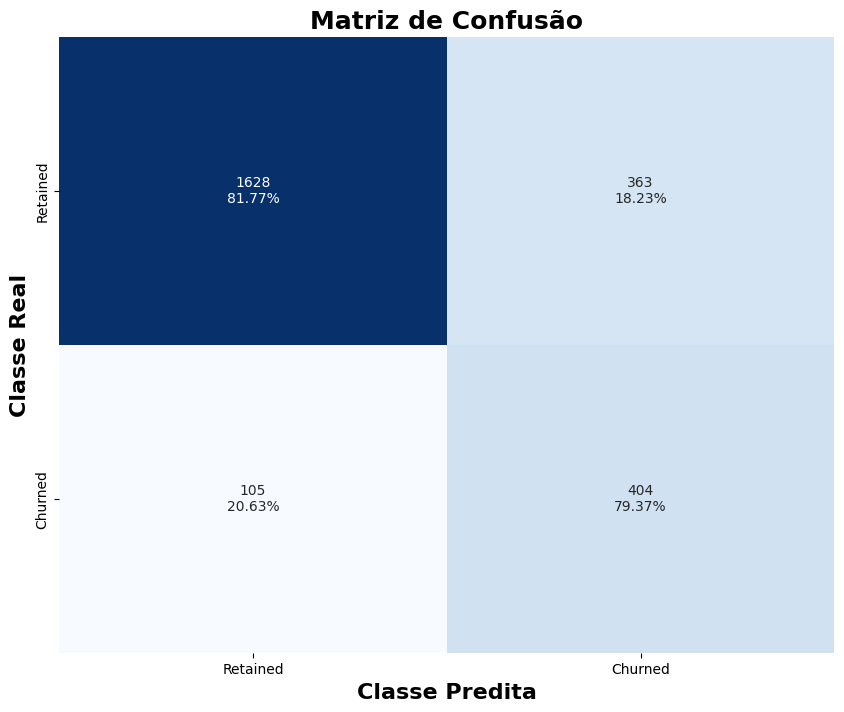

In [49]:
predictions_2 = final_model.predict(X_test)

cm = confusion_matrix(y_test, predictions_2)
cmn = confusion_matrix(y_test, predictions_2, normalize='true')
fig, ax = plt.subplots(figsize=(10,8))

labels = ['Retained', 'Churned']

group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cmn.flatten()]
annot = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
annot = np.asarray(annot).reshape(2,2)

sns.heatmap(cm, 
            annot=annot, 
            cmap="Blues",
            cbar = False,
            fmt='',
            xticklabels=labels,
            yticklabels=labels)


plt.title('Matriz de Confusão', fontsize=18, fontweight="bold")
plt.ylabel('Classe Real', fontsize=16, fontweight="bold")
plt.xlabel('Classe Predita', fontsize=16, fontweight="bold")
#plt.savefig("matriz_confusao_experimental", dpi=600)
plt.show(block=False)

Upon analyzing our classified samples, it's evident that out of a total of 1991 customers who chose to stay with the bank, 1628 (82%) were accurately classified. Similarly, among the 509 customers who decided to leave the bank, 404 (79%) were correctly identified by our churn prediction model.

While there's a slight decrease in accuracy for the "Exited=0" class, it's overshadowed by a significant 30% increase in accuracy for the "Exited=1" class. This remarkable improvement indicates a substantial enhancement in our model's performance compared to its previous iterations.

With such promising results, we can confidently assert that our churn prediction model is now operating at a significantly higher level of effectiveness, paving the way for more precise identification and proactive management of customer churn within the banking sector.